In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
import torch.optim as optim

import yfinance as yf
from collections import deque
import random
import math
from tqdm import tqdm

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque

In [6]:
#final ensemble model
from collections import Counter

In [5]:
#DDPG Model

import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque

In [7]:
!pip freeze > requirements.txt

In [2]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [3]:
dataset_dir = "/content/drive/MyDrive/Deep_RL_for_Stock_Trading"

[*********************100%%**********************]  1 of 1 completed


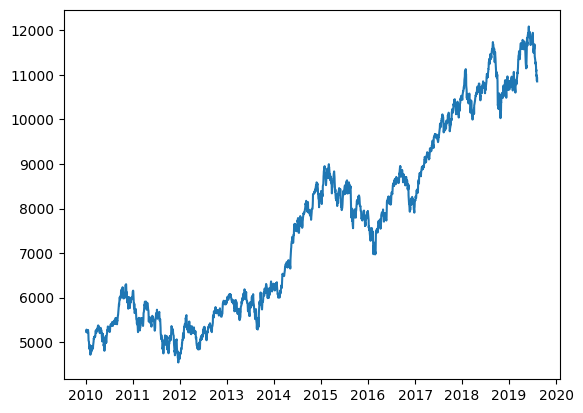

In [4]:
# Define the ticker symbol for NIFTY50
nifty50_ticker = "^NSEI"

# Download the historical data for NIFTY50
nifty50_data = yf.download(nifty50_ticker, start="2010-01-01", end="2019-08-08")

plt.plot(nifty50_data['Close'])
plt.show()

In [30]:
file_name = f"{dataset_dir}/data.csv"

# Save the DataFrame to a CSV file
nifty50_data.to_csv(file_name, index=False)

print(f"File Saved at {file_name}")

File Saved at /content/drive/MyDrive/Deep_RL_for_Stock_Trading/data.csv


In [5]:
#Data Cleaning and EDA
null_values = nifty50_data.isna().values.any()
print(f"Presence of Null value : {int(null_values)}")

if null_values:
  nifty50_data = nifty50_data.fillna(method = "ffill")

Presence of Null value : 0


In [6]:
#data splitting in 80-20% fashion for training and testing
X=list(nifty50_data["Close"])
data=[float(x) for x in X]
test_size = 0.2

train_data = data[:int(len(data)*(1-test_size))]
test_data = data[int(len(data)*(1-test_size)):]

print(f"Training Data shape : {len(train_data)} and Testing Data Shape : {len(test_data)}")

Training Data shape : 1879 and Testing Data Shape : 470


In [ ]:
#DQN Model

class DQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 8)
        self.fc4 = nn.Linear(8, action_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        output = torch.softmax(self.fc4(x), dim=-1)
        return output


# Main Agent Work

class DQN_Agent:
    def __init__(self, state_dim, is_eval=False, model_name=""):
        self.model_type = "DQN"
        self.state_dim = state_dim
        self.action_dim = 3  # hold, sell, and buy
        self.memory = deque(maxlen=100)
        self.buffer_size = 60

        self.gamma = 0.95
        self.epsilon = 1.0  # initial exploration rate
        self.epsilon_min = 0.01  # minimum exploration rate
        self.epsilon_decay = 0.995  # decrease exploration rate as the agent becomes good at trading
        self.is_eval = is_eval
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # self.model = torch.load(f'{model_name}.pth') if is_eval else self.create_model().to(self.device)
        # Load the model with proper device mapping
        if is_eval:
            self.model = self.create_model().to(self.device)

            if self.device.type == 'cpu':
                self.model.load_state_dict(torch.load(f'{model_name}.pth', map_location=torch.device('cpu')))

            else:
                self.model.load_state_dict(torch.load(f'{model_name}.pth'))
            self.model.eval()
        else:
            self.model = self.create_model().to(self.device)


        self.optimizer = optim.Adam(self.model.parameters(), lr=0.01)
        self.loss_fn = nn.MSELoss()

    def create_model(self):
        return DQN(self.state_dim, self.action_dim)

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if not self.is_eval and np.random.rand() <= self.epsilon:
            return random.randrange(self.action_dim)

        state = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(self.device)
        with torch.no_grad():
            options = self.model(state)
        return torch.argmax(options[0]).item()

    def experience_replay(self, batch_size):
        mini_batch = random.sample(self.memory, min(len(self.memory), batch_size))

        for state, action, reward, next_state, done in mini_batch:
            state = torch.tensor(state, dtype=torch.float32).to(self.device)
            next_state = torch.tensor(next_state, dtype=torch.float32).to(self.device)

            target = reward
            if not done:
                target = reward + self.gamma * torch.max(self.model(next_state)).item()

            # Predict Q-values for the current state
            target_f = self.model(state).detach().cpu().numpy()

            # Ensure target_f is a 1D array and update the action index
            target_f = target_f.squeeze()  # Remove any extra dimensions
            target_f[action] = target

            target_f = torch.tensor(target_f, dtype=torch.float32).to(self.device).unsqueeze(0)
            state = torch.tensor(state, dtype=torch.float32).to(self.device)

            self.optimizer.zero_grad()
            loss = nn.MSELoss()(self.model(state), target_f)
            loss.backward()
            self.optimizer.step()

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

        return loss.item()


Running episode 1/10


<ipython-input-34-b32b186e555e>:88: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state, dtype=torch.float32).to(self.device)


--------------------------------
Total Profit: 23591.80
--------------------------------


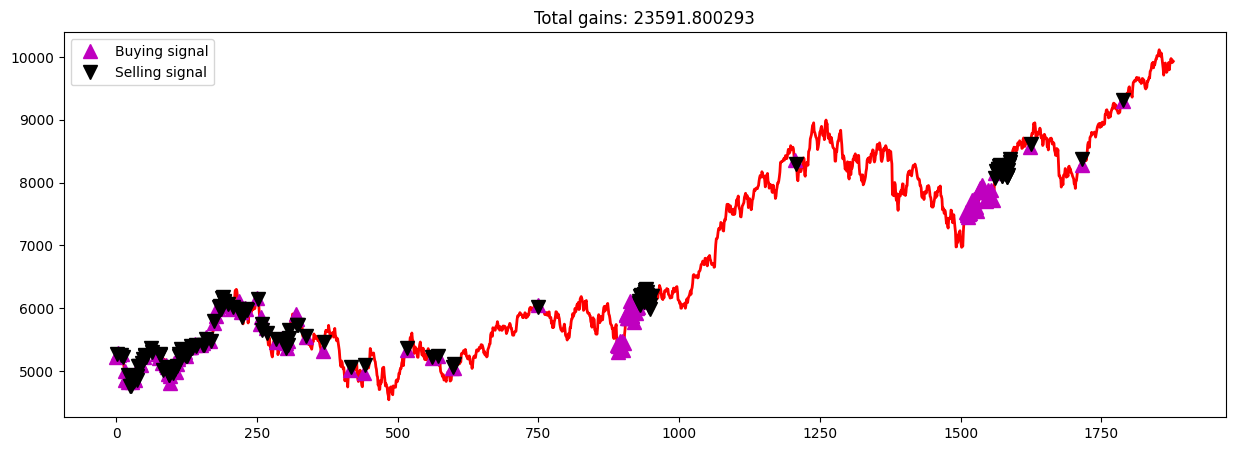

Running episode 2/10
--------------------------------
Total Profit: 8423.75
--------------------------------


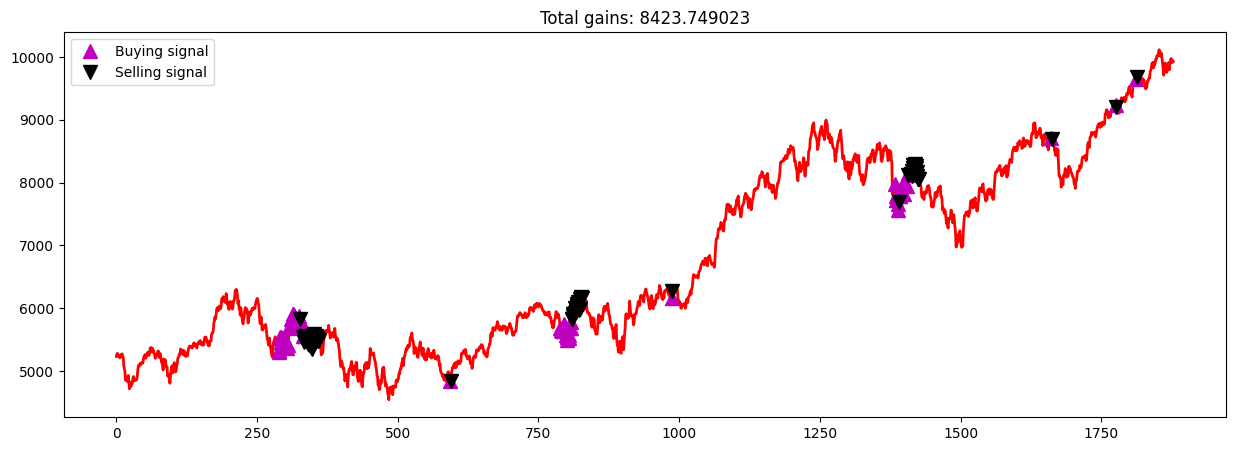

Running episode 3/10
--------------------------------
Total Profit: 21183.35
--------------------------------


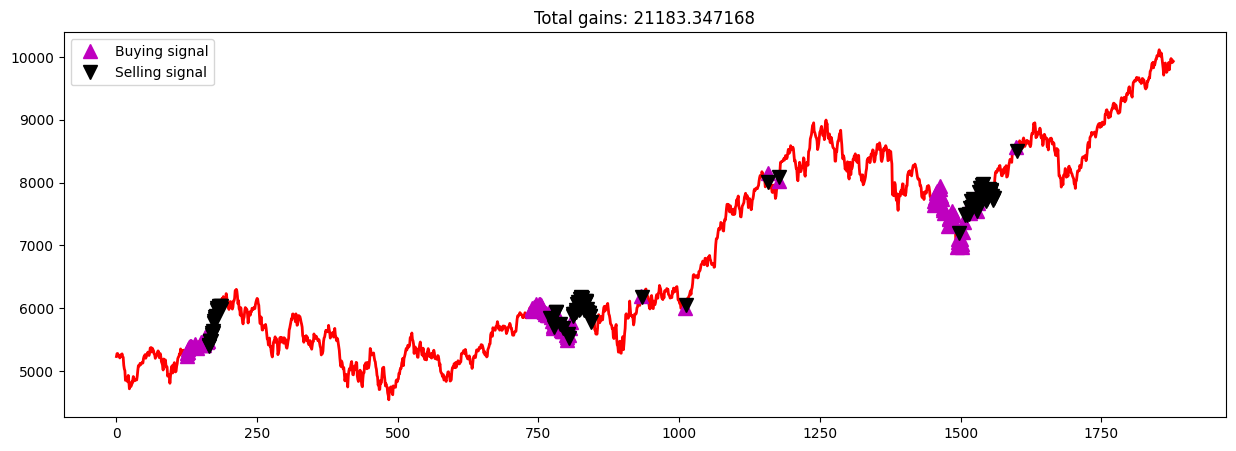

Running episode 4/10
--------------------------------
Total Profit: 16811.70
--------------------------------


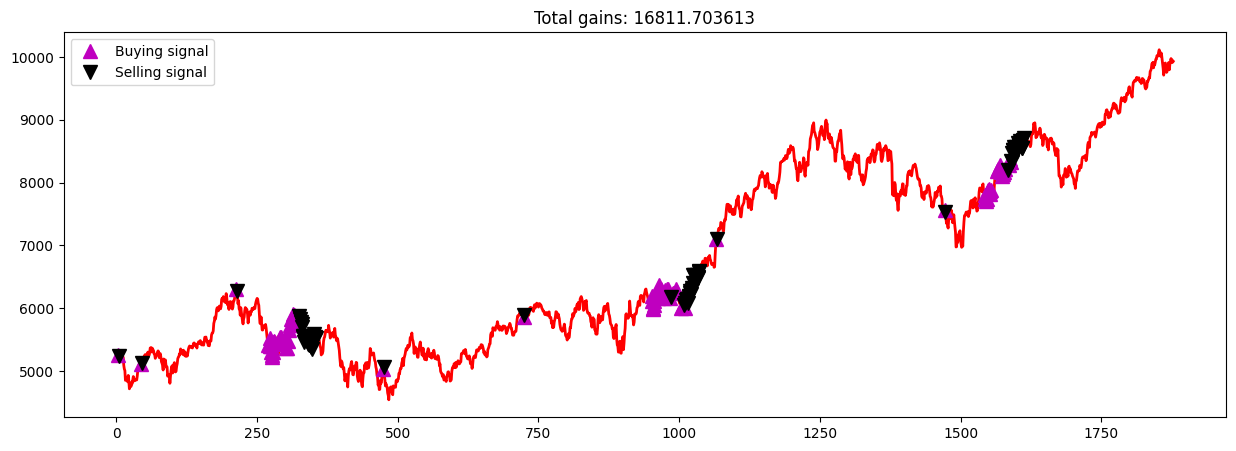

Running episode 5/10
--------------------------------
Total Profit: 25344.75
--------------------------------


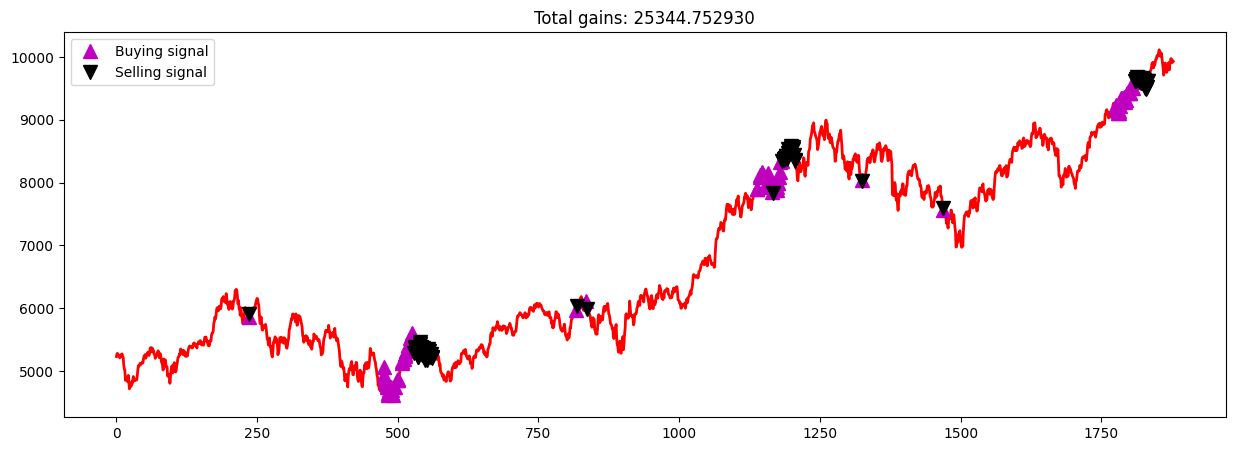

Running episode 6/10
--------------------------------
Total Profit: 22598.25
--------------------------------


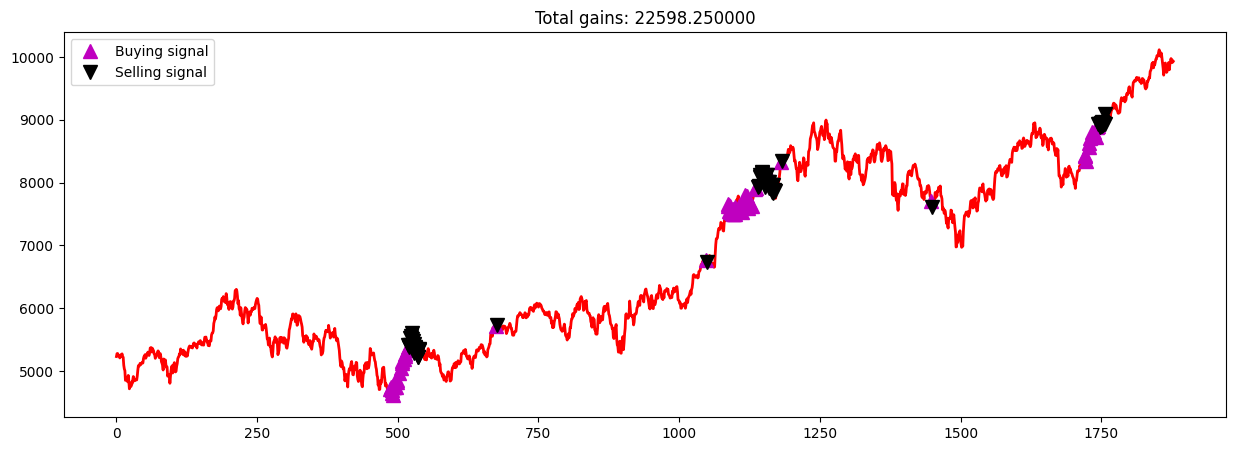

Running episode 7/10
--------------------------------
Total Profit: 361.95
--------------------------------


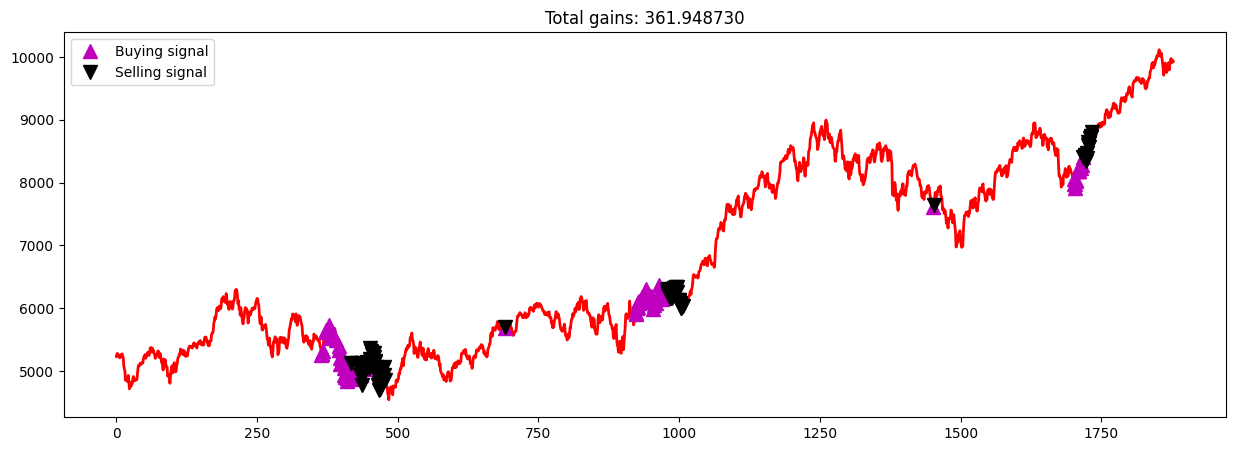

Running episode 8/10
--------------------------------
Total Profit: 2164.80
--------------------------------


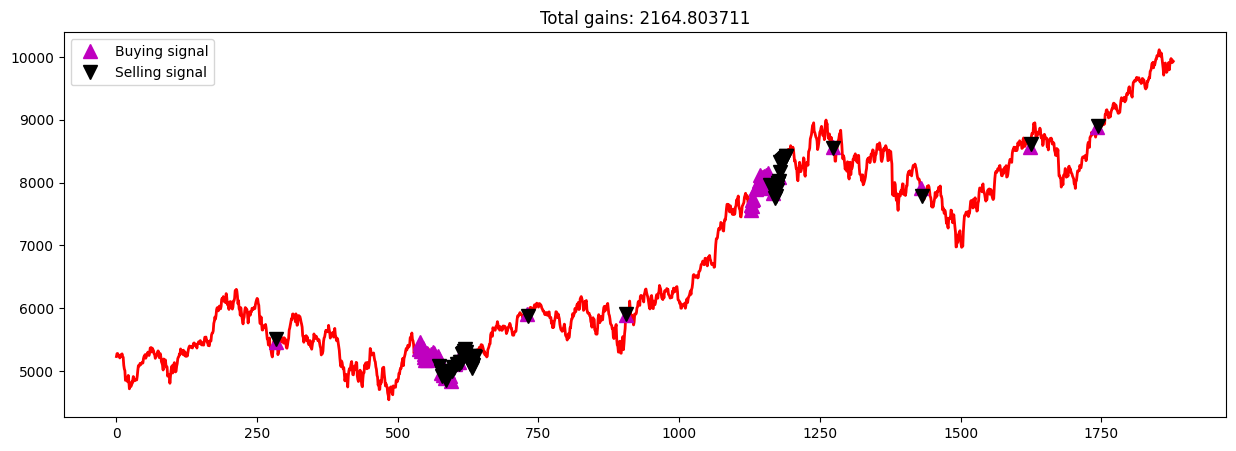

Running episode 9/10
--------------------------------
Total Profit: 23051.25
--------------------------------


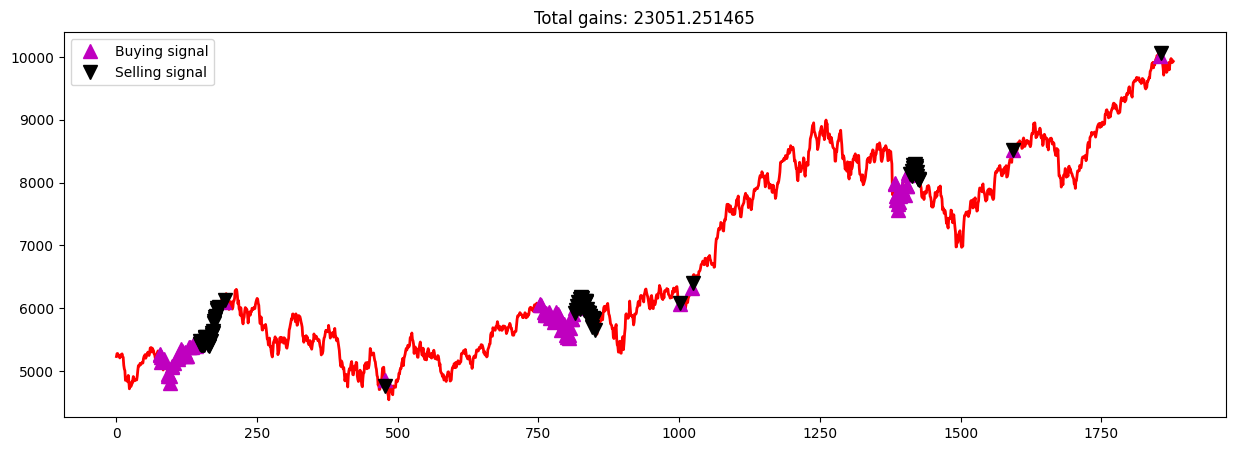

Running episode 10/10
--------------------------------
Total Profit: 2461.56
--------------------------------


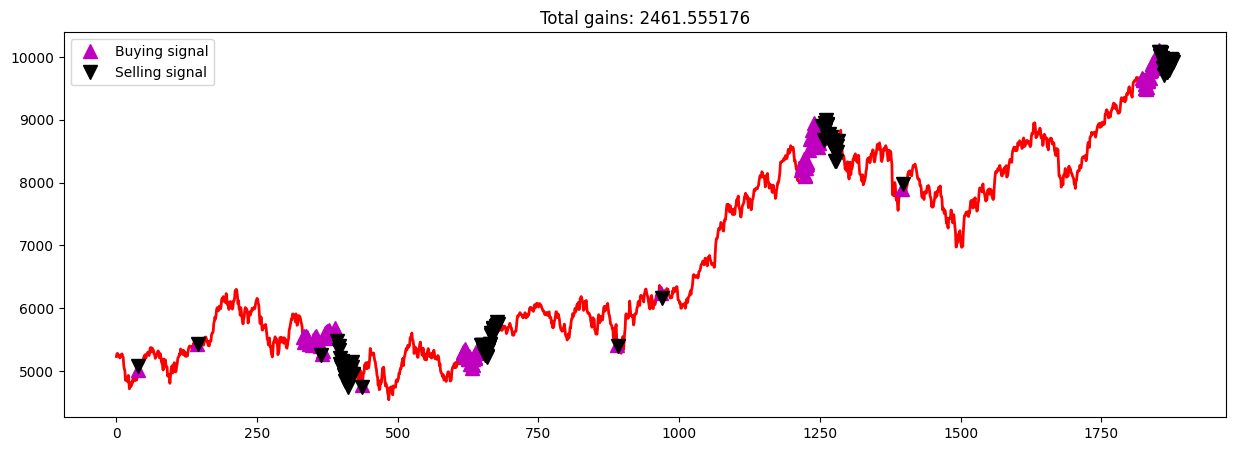

In [ ]:
#creating states, environments and required preprocessing

def sigmoid(x):
    return 1 / (1 + math.exp(-x))

# returns an an n-day state representation ending at time t

def getState(data, t, n):
    d = t - n + 1
    block = data[d:t + 1] if d >= 0 else -d * [data[0]] + data[0:t + 1] # pad with t0
    #block is which is the for [1283.27002, 1283.27002]
    res = []
    for i in range(n - 1):
        res.append(sigmoid(block[i + 1] - block[i]))
    return np.array([res])

# Plots the behavior of the output
def plot_behavior(data_input, states_buy, states_sell, profit):
    fig = plt.figure(figsize = (15,5))
    plt.plot(data_input, color='r', lw=2.)
    plt.plot(data_input, '^', markersize=10, color='m', label = 'Buying signal', markevery = states_buy)
    plt.plot(data_input, 'v', markersize=10, color='k', label = 'Selling signal', markevery = states_sell)
    plt.title('Total gains: %f'%(profit))
    plt.legend()
    #plt.savefig('output/'+name+'.png')
    plt.show()

#training the agents by recording episodes and then replaying to make model experience or train

#hyperparameters and agent,state intialization
window_size = 10
agent = DQN_Agent(window_size)
data = train_data  # Assuming train_data is defined somewhere
episode_count = 10
l = len(data) - 1
batch_size = 32

losses = []
profits = []

for e in range(episode_count):
    print(f"Running episode {e + 1}/{episode_count}")
    state = getState(data, 0, window_size + 1)
    total_profit = 0
    agent_inventory = []
    states_sell = []
    states_buy = []

    for t in range(l):
        action = agent.act(state)
        next_state = getState(data, t + 1, window_size + 1)
        reward = 0

        if action == 1:  # buy
            agent_inventory.append(data[t])
            states_buy.append(t)

        elif action == 2 and len(agent_inventory) > 0:  # sell
            bought_price = agent_inventory.pop(0)
            reward = max(data[t] - bought_price, 0)
            total_profit += data[t] - bought_price
            states_sell.append(t)

        done = t == l - 1
        agent.remember(state, action, reward, next_state, done)
        state = next_state

        if done:
            print("--------------------------------")
            print(f"Total Profit: {total_profit:.2f}")
            profits.append(total_profit)
            print("--------------------------------")

            plot_behavior(data, states_buy, states_sell, total_profit)

        if len(agent.memory) > batch_size:
            loss = agent.experience_replay(batch_size)
            losses.append(loss)

    if e % 2 == 0:
        torch.save(agent.model.state_dict(), f"{dataset_dir}/model_ep{e}.pth")



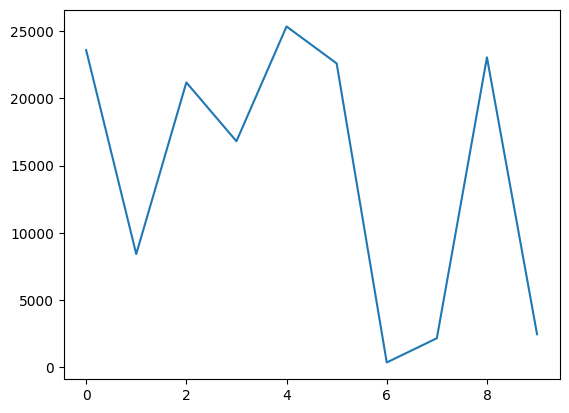

In [ ]:
plt.plot(profits)

Testing Pipeline in progress: 100%|██████████| 469/469 [00:00<00:00, 2683.95it/s]


Buy:9735.75
Sell: 9768.9501953125 | profit: 33.2001953125
Buy:10504.7998046875
Sell: 10558.849609375 | profit: 54.0498046875
Buy:10491.0498046875
Sell: 10582.599609375 | profit: 91.5498046875
Buy:10155.25
Sell: 10114.75 | profit: -40.5
Buy:10849.7998046875
Sell: 10780.5498046875 | profit: -69.25
------------------------------------------
Total Profit: 69.05
------------------------------------------


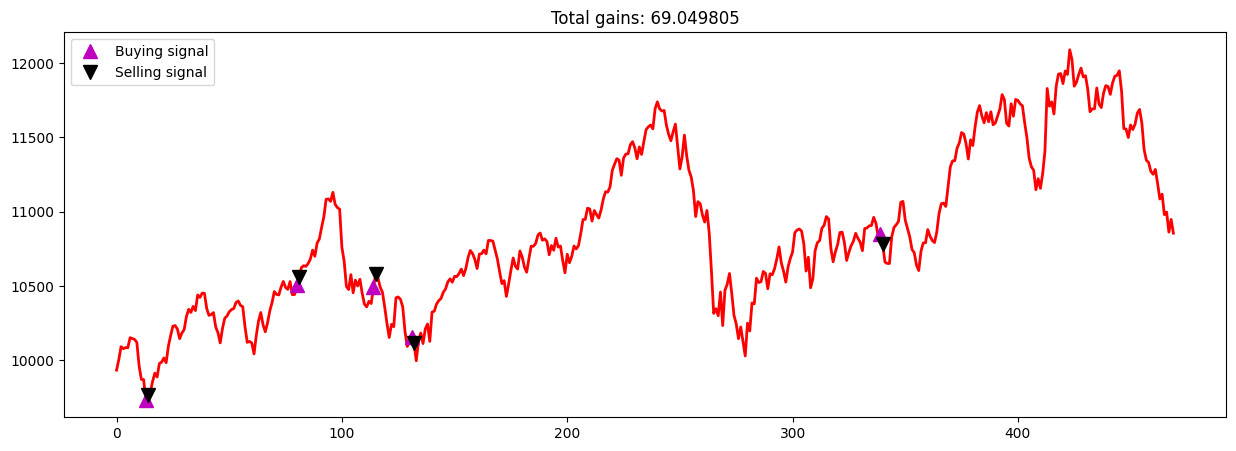

In [ ]:
#testing

#agent is already defined in the training set above.
l_test = len(test_data) - 1
state = getState(test_data, 0, window_size + 1)
total_profit = 0
is_eval = True
done = False
states_sell_test = []
states_buy_test = []

#Get the trained model
# model_name = f"{dataset_dir}/model_ep" +"6"
# agent = DQN_Agent(window_size, is_eval, model_name)
state = getState(data, 0, window_size + 1)
total_profit = 0
agent_inventory = []

for t in tqdm(range(l_test), desc = "Testing Pipeline in progress"):
    action = agent.act(state)
    #print(action)
    #set_trace()
    next_state = getState(test_data, t + 1, window_size + 1)
    reward = 0

    if action == 1:
        agent_inventory.append(test_data[t])
        states_buy_test.append(t)
        print(f"Buy:{test_data[t]}")

    elif action == 2 and len(agent_inventory) > 0:
        bought_price = agent_inventory.pop(0)
        reward = max(test_data[t] - bought_price, 0)

        total_profit += test_data[t] - bought_price
        states_sell_test.append(t)
        print(f"Sell: {test_data[t]} | profit: {test_data[t] - bought_price}")

    if t == l_test - 1:
        done = True
    agent.memory.append((state, action, reward, next_state, done))
    state = next_state

    if done:
        print("------------------------------------------")
        print(f"Total Profit: {total_profit:.2f}")
        print("------------------------------------------")

plot_behavior(test_data,states_buy_test, states_sell_test, total_profit)



In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque

# DDQN Model
class DDQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DDQN, self).__init__()
        self.fc1 = nn.Linear(state_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 8)
        self.fc4 = nn.Linear(8, action_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        output = torch.softmax(self.fc4(x), dim=-1)
        return output

# DDQN Agent
class DDQN_Agent:
    def __init__(self, state_dim, tau=0.0001, is_eval=False, model_name=""):
        self.model_type = "DDQN"
        self.state_dim = state_dim
        self.action_dim = 3  # hold, sell, and buy
        self.memory = deque(maxlen=100)
        self.buffer_size = 60

        self.gamma = 0.95
        self.epsilon = 1.0  # initial exploration rate
        self.epsilon_min = 0.01  # minimum exploration rate
        self.epsilon_decay = 0.995  # decrease exploration rate as the agent becomes good at trading
        self.is_eval = is_eval
        self.tau = tau
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        if is_eval:
            self.model = self.create_model().to(self.device)
            self.model_target = self.create_model().to(self.device)

            if self.device.type == 'cpu':
                self.model.load_state_dict(torch.load(f'{model_name}.pth', map_location=torch.device('cpu')))
                self.model_target.load_state_dict(torch.load(f'{model_name}_target.pth', map_location=torch.device('cpu')))
            else:
                self.model.load_state_dict(torch.load(f'{model_name}.pth'))
                self.model_target.load_state_dict(torch.load(f'{model_name}_target.pth'))
            self.model.eval()
            self.model_target.eval()
        else:
            self.model = self.create_model().to(self.device)
            self.model_target = self.create_model().to(self.device)
            self.model_target.load_state_dict(self.model.state_dict())

        self.optimizer = optim.Adam(self.model.parameters(), lr=0.01)
        self.loss_fn = nn.MSELoss()

    def create_model(self):
        return DDQN(self.state_dim, self.action_dim)

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if not self.is_eval and np.random.rand() <= self.epsilon:
            return random.randrange(self.action_dim)

        state = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(self.device)
        with torch.no_grad():
            options = self.model(state)
        return torch.argmax(options[0]).item()

    def experience_replay(self, batch_size):
        if len(self.memory) < batch_size:
            return  # Not enough samples in memory

        mini_batch = random.sample(self.memory, min(len(self.memory), batch_size))

        for state, action, reward, next_state, done in mini_batch:
            state = torch.tensor(state, dtype=torch.float32).to(self.device)
            next_state = torch.tensor(next_state, dtype=torch.float32).to(self.device)

            # Double DQN: Select the action using the model, evaluate using the target network
            target = reward
            if not done:
                best_action = torch.argmax(self.model(next_state)).item()
                target = reward + self.gamma * self.model_target(next_state)[0][best_action].item()

            target_f = self.model(state).detach().cpu().numpy()
            target_f = target_f.squeeze()
            target_f[action] = target

            target_f = torch.tensor(target_f, dtype=torch.float32).to(self.device).unsqueeze(0)

            self.optimizer.zero_grad()
            loss = self.loss_fn(self.model(state), target_f)
            loss.backward()
            self.optimizer.step()

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

        # Update the target model with the new method
        self.update_model_target()

        return loss.item()

    def update_model_target(self):
        # Get the state_dict of the current model and the target model
        model_weights = self.model.state_dict()
        model_target_weights = self.model_target.state_dict()

        # Update the weights of the target model
        for key in model_weights:
            model_target_weights[key] = self.tau * model_weights[key] + (1 - self.tau) * model_target_weights[key]

        # Load the updated weights into the target model
        self.model_target.load_state_dict(model_target_weights)


Running episode 1/10
--------------------------------
Total Profit: 2572.20
--------------------------------


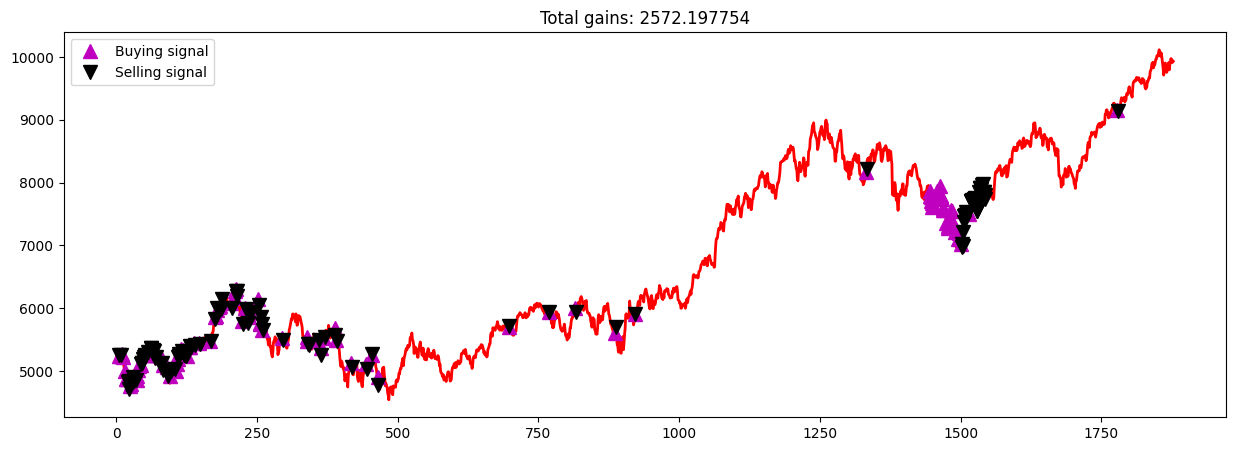

Running episode 2/10
--------------------------------
Total Profit: 72.25
--------------------------------


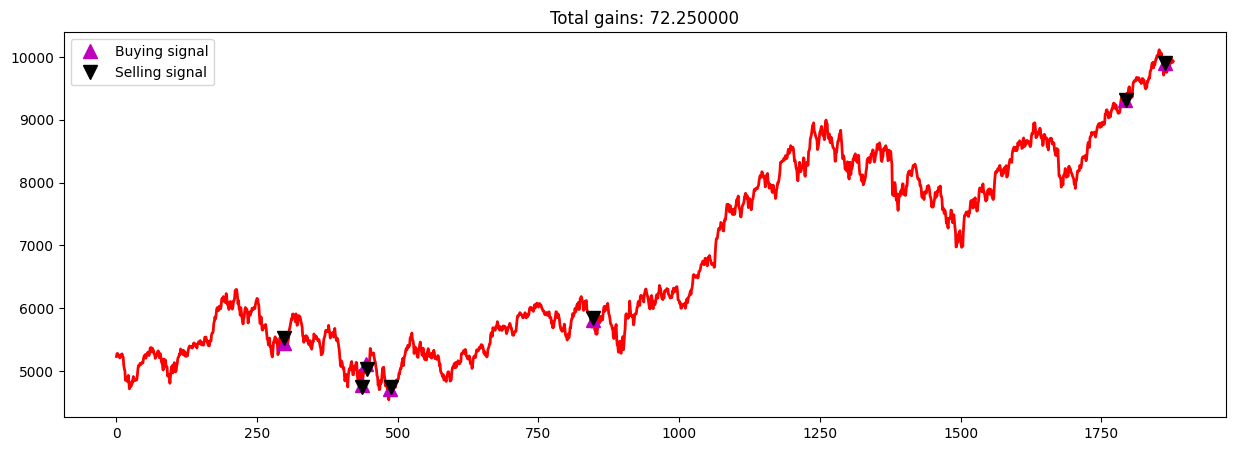

Running episode 3/10
--------------------------------
Total Profit: -60.05
--------------------------------


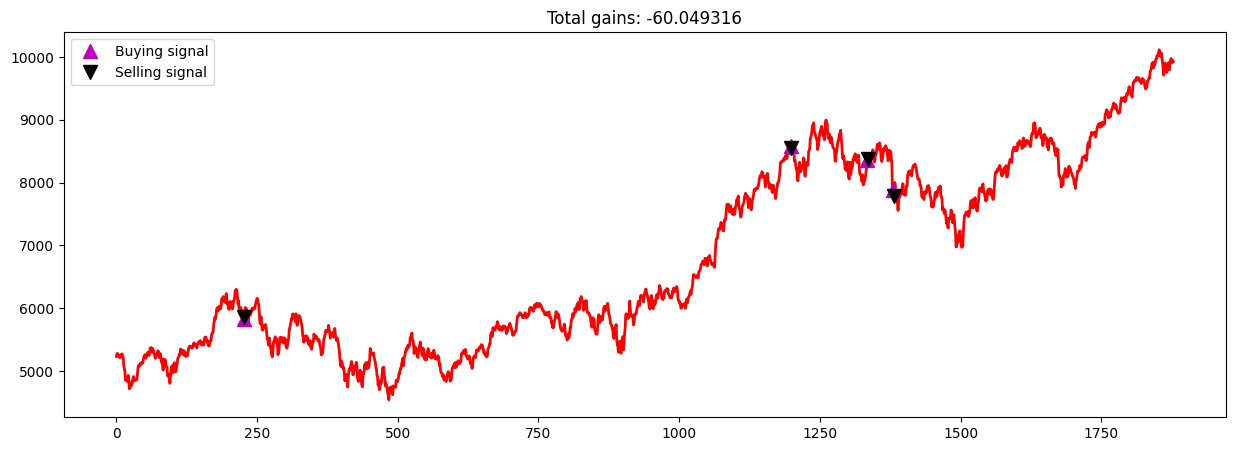

Running episode 4/10
--------------------------------
Total Profit: -27.95
--------------------------------


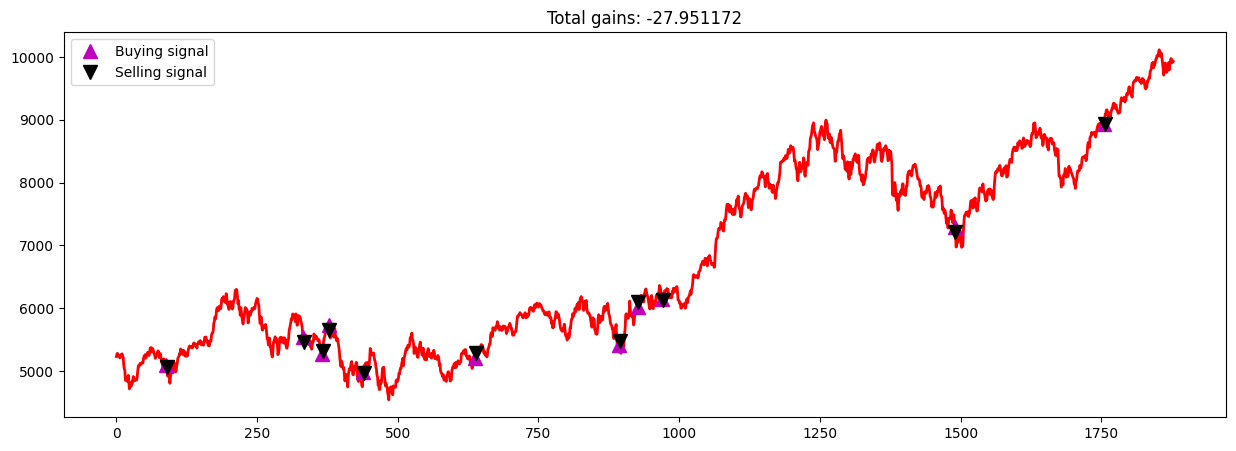

Running episode 5/10
--------------------------------
Total Profit: -61.25
--------------------------------


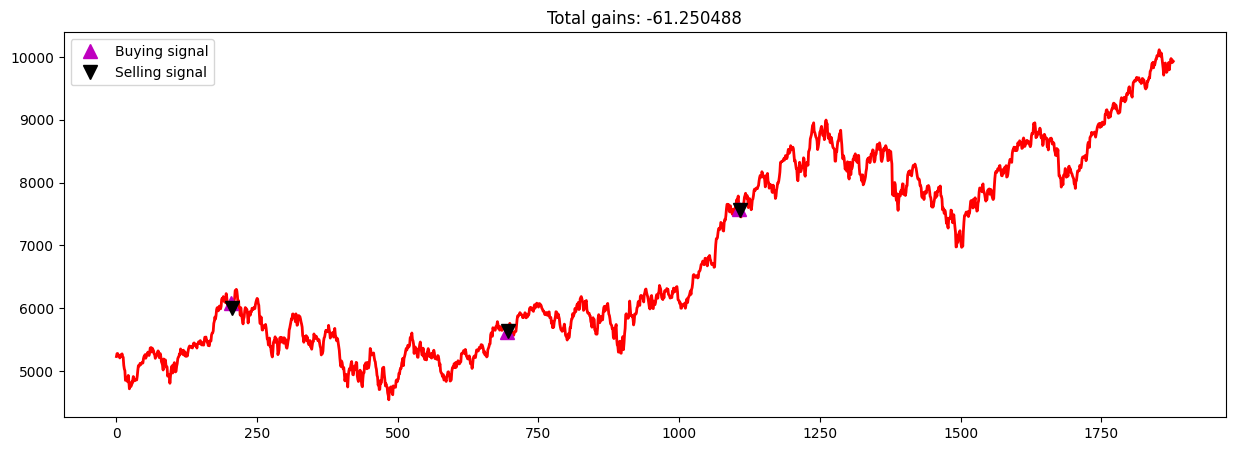

Running episode 6/10
--------------------------------
Total Profit: -264.30
--------------------------------


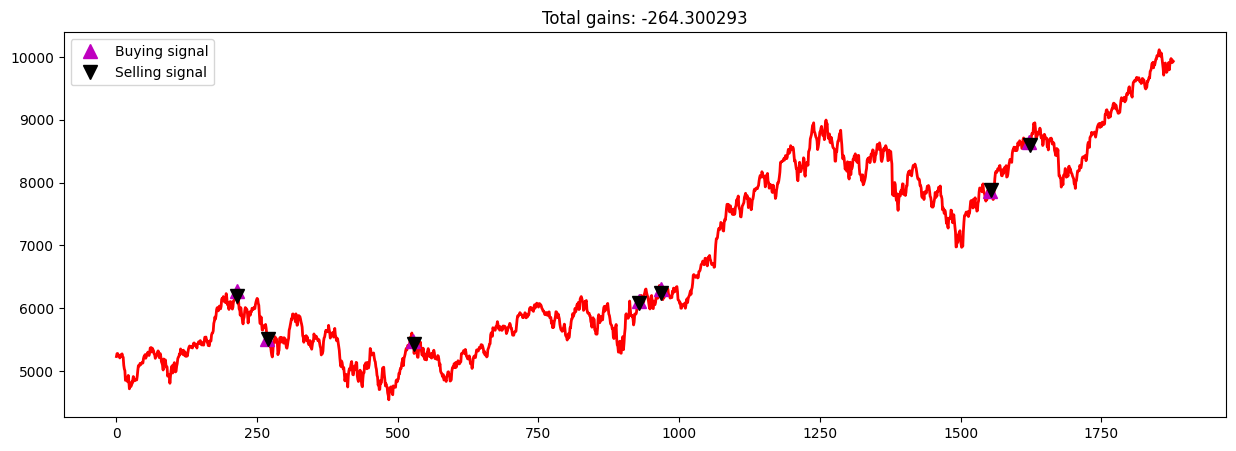

Running episode 7/10
--------------------------------
Total Profit: 10.90
--------------------------------


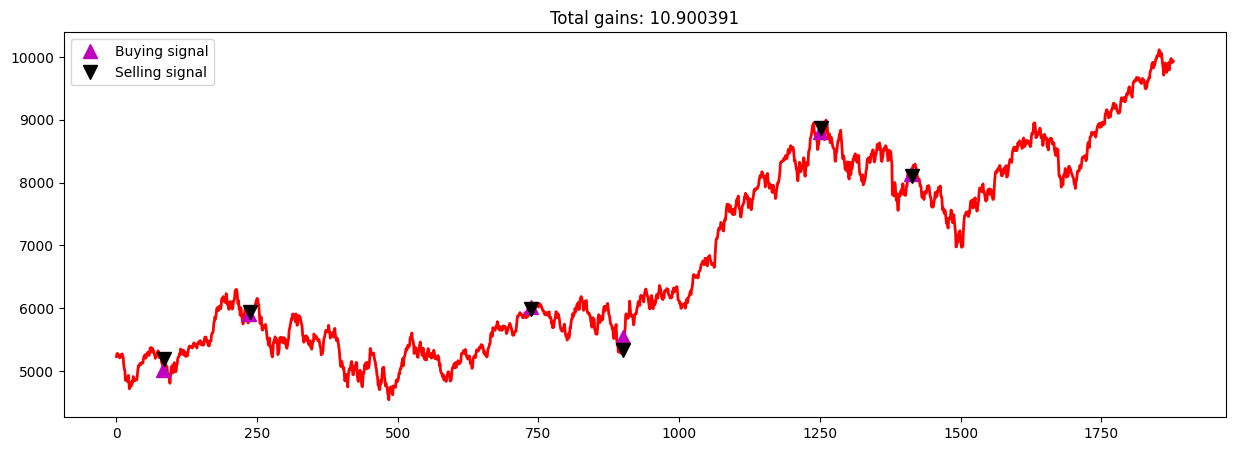

Running episode 8/10
--------------------------------
Total Profit: 23.80
--------------------------------


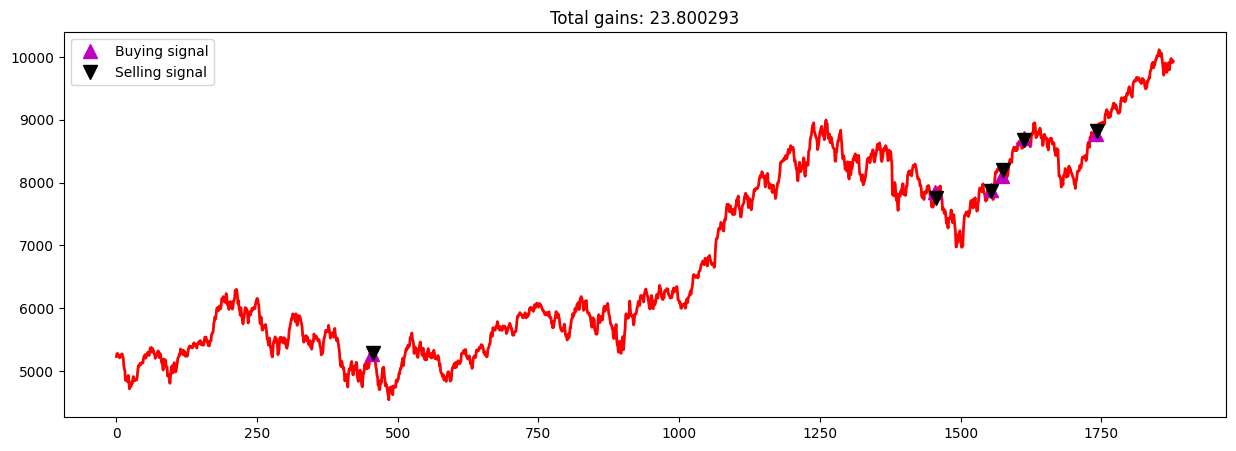

Running episode 9/10
--------------------------------
Total Profit: 121.85
--------------------------------


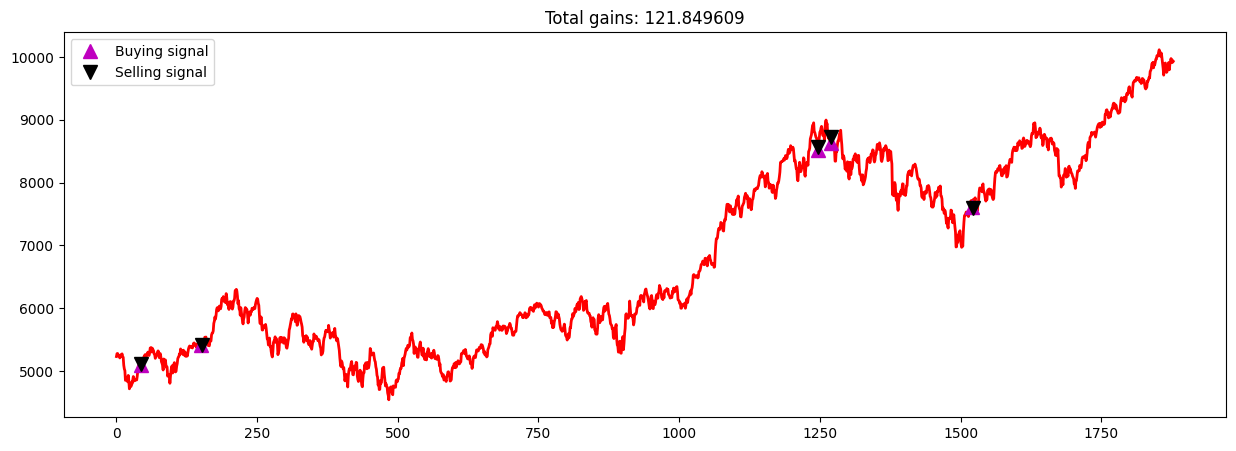

Running episode 10/10
--------------------------------
Total Profit: -141.30
--------------------------------


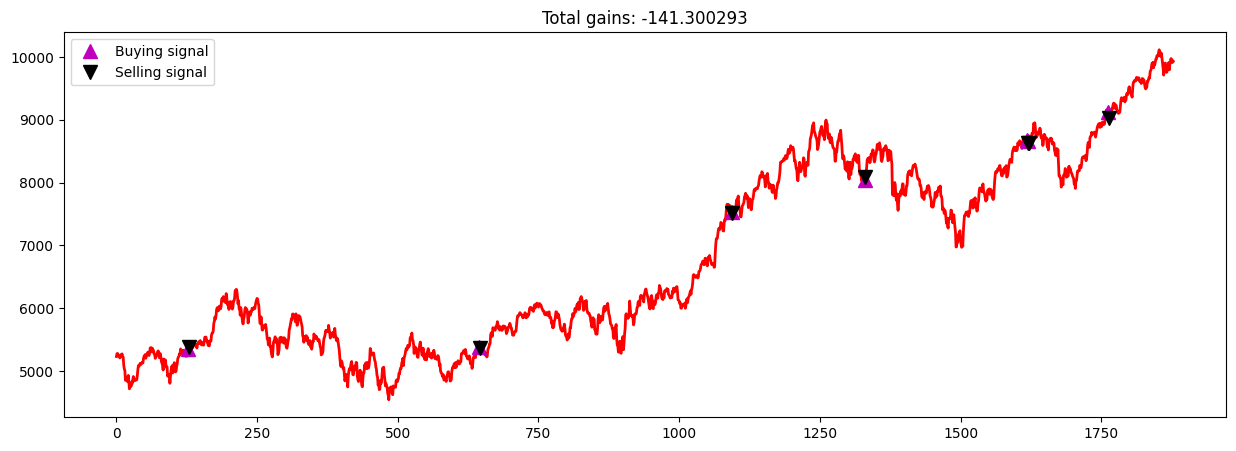

In [ ]:
#creating states, environments and required preprocessing

def sigmoid(x):
    return 1 / (1 + math.exp(-x))

# returns an an n-day state representation ending at time t

def getState(data, t, n):
    d = t - n + 1
    block = data[d:t + 1] if d >= 0 else -d * [data[0]] + data[0:t + 1] # pad with t0
    #block is which is the for [1283.27002, 1283.27002]
    res = []
    for i in range(n - 1):
        res.append(sigmoid(block[i + 1] - block[i]))
    return np.array([res])

# Plots the behavior of the output
def plot_behavior(data_input, states_buy, states_sell, profit):
    fig = plt.figure(figsize = (15,5))
    plt.plot(data_input, color='r', lw=2.)
    plt.plot(data_input, '^', markersize=10, color='m', label = 'Buying signal', markevery = states_buy)
    plt.plot(data_input, 'v', markersize=10, color='k', label = 'Selling signal', markevery = states_sell)
    plt.title('Total gains: %f'%(profit))
    plt.legend()
    #plt.savefig('output/'+name+'.png')
    plt.show()

#training the agents by recording episodes and then replaying to make model experience or train

#hyperparameters and agent,state intialization
window_size = 10
agent = DDQN_Agent(window_size)
data = train_data  # Assuming train_data is defined somewhere
episode_count = 10
l = len(data) - 1
batch_size = 32

losses = []
profits = []

for e in range(episode_count):
    print(f"Running episode {e + 1}/{episode_count}")
    state = getState(data, 0, window_size + 1)
    total_profit = 0
    agent_inventory = []
    states_sell = []
    states_buy = []

    for t in range(l):
        action = agent.act(state)
        next_state = getState(data, t + 1, window_size + 1)
        reward = 0

        if action == 1:  # buy
            agent_inventory.append(data[t])
            states_buy.append(t)

        elif action == 2 and len(agent_inventory) > 0:  # sell
            bought_price = agent_inventory.pop(0)
            reward = max(data[t] - bought_price, 0)
            total_profit += data[t] - bought_price
            states_sell.append(t)

        done = t == l - 1
        agent.remember(state, action, reward, next_state, done)
        state = next_state

        if done:
            print("--------------------------------")
            print(f"Total Profit: {total_profit:.2f}")
            profits.append(total_profit)
            print("--------------------------------")

            plot_behavior(data, states_buy, states_sell, total_profit)

        if len(agent.memory) > batch_size:
            loss = agent.experience_replay(batch_size)
            losses.append(loss)

    if e % 2 == 0:
        torch.save(agent.model.state_dict(), f"{dataset_dir}/model_ddqn_ep{e}.pth")



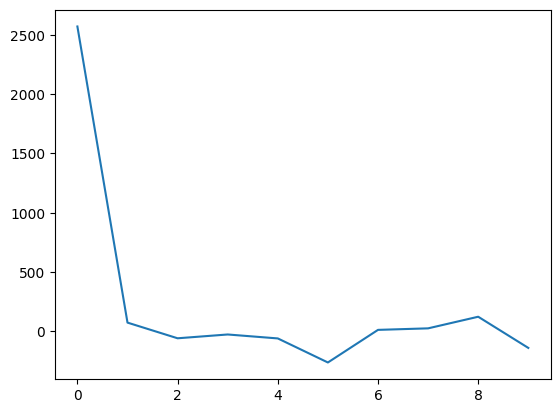

In [ ]:
plt.plot(profits)

Testing Pipeline in progress: 100%|██████████| 469/469 [00:00<00:00, 4248.03it/s]


Buy:11069.650390625
Sell: 11130.400390625 | profit: 60.75
Buy:10155.25
Sell: 10114.75 | profit: -40.5
Buy:10936.849609375
Sell: 11008.0498046875 | profit: 71.2001953125
------------------------------------------
Total Profit: 91.45
------------------------------------------


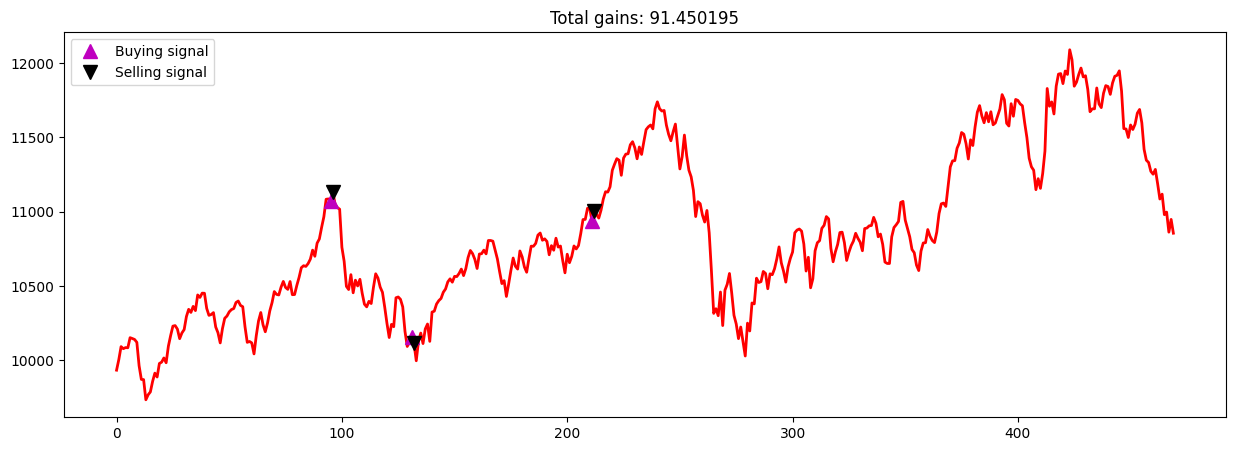

In [ ]:
#testing

#agent is already defined in the training set above.
l_test = len(test_data) - 1
state = getState(test_data, 0, window_size + 1)
total_profit = 0
is_eval = True
done = False
states_sell_test = []
states_buy_test = []

#Get the trained model
# model_name = f"{dataset_dir}/model_ep" +"6"
# agent = DQN_Agent(window_size, is_eval, model_name)
state = getState(data, 0, window_size + 1)
total_profit = 0
agent_inventory = []

for t in tqdm(range(l_test), desc = "Testing Pipeline in progress"):
    action = agent.act(state)
    #print(action)
    #set_trace()
    next_state = getState(test_data, t + 1, window_size + 1)
    reward = 0

    if action == 1:
        agent_inventory.append(test_data[t])
        states_buy_test.append(t)
        print(f"Buy:{test_data[t]}")

    elif action == 2 and len(agent_inventory) > 0:
        bought_price = agent_inventory.pop(0)
        reward = max(test_data[t] - bought_price, 0)

        total_profit += test_data[t] - bought_price
        states_sell_test.append(t)
        print(f"Sell: {test_data[t]} | profit: {test_data[t] - bought_price}")

    if t == l_test - 1:
        done = True
    agent.memory.append((state, action, reward, next_state, done))
    state = next_state

    if done:
        print("------------------------------------------")
        print(f"Total Profit: {total_profit:.2f}")
        print("------------------------------------------")

plot_behavior(test_data,states_buy_test, states_sell_test, total_profit)


In [15]:
#DDPG Model

import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque

# DDPG Model
class ActorNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(ActorNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 8)
        self.fc4 = nn.Linear(8, action_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        output = torch.tanh(self.fc4(x))
        return output

class CriticNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(CriticNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim + action_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 8)
        self.fc4 = nn.Linear(8, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        output = self.fc4(x)
        return output

class OrnsteinUhlenbeckNoise:
    "OU noise generator class, used to add OU noise to actions."
    def __init__(self, size, mu=0, sigma=0.1, theta=0.15):
        self.mu = mu * np.ones(size)
        self.sigma = sigma
        self.theta = theta
        self.size = size
        self.reset()

    def reset(self):
        "Resets noise to mean."
        self.state = self.mu.copy()

    def sample(self):
        "Returns next value generated in process."
        dx = self.theta * (self.mu - self.state) + self.sigma * np.random.randn(self.size)
        self.state += dx
        return self.state.copy()

# DPMG Agent
class DDPG_Agent:
    def __init__(self, state_dim, tau=0.0001, is_eval=False, model_name=""):
        self.model_type = "DDPG"
        self.state_dim = state_dim
        self.action_dim = 3  # hold, sell, and buy
        self.memory = deque(maxlen=100)
        self.buffer_size = 60

        self.gamma = 0.95
        self.is_eval = is_eval
        self.tau = tau
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.noise_generator = OrnsteinUhlenbeckNoise(size=self.action_dim, mu=0)

        # if is_eval:
        #     self.model = self.create_model().to(self.device)
        #     self.model_target = self.create_model().to(self.device)

        #     if self.device.type == 'cpu':
        #         self.model.load_state_dict(torch.load(f'{model_name}.pth', map_location=torch.device('cpu')))
        #         self.model_target.load_state_dict(torch.load(f'{model_name}_target.pth', map_location=torch.device('cpu')))
        #     else:
        #         self.model.load_state_dict(torch.load(f'{model_name}.pth'))
        #         self.model_target.load_state_dict(torch.load(f'{model_name}_target.pth'))
        #     self.model.eval()
        #     self.model_target.eval()
        # else:
        self.actor_model = self.create_actor_model().to(self.device)
        self.critic_model = self.create_critic_model().to(self.device)

        self.actor_model_target = self.create_actor_model().to(self.device)
        self.actor_model_target.load_state_dict(self.actor_model.state_dict())

        self.critic_model_target = self.create_critic_model().to(self.device)
        self.critic_model_target.load_state_dict(self.critic_model.state_dict())

        self.actor_optimizer = optim.Adam(self.actor_model.parameters(), lr=0.01)
        self.critic_optimizer = optim.Adam(self.critic_model.parameters(), lr = 0.01)

        self.loss_fn = nn.MSELoss()

    def create_actor_model(self):
        return ActorNetwork(self.state_dim, self.action_dim)

    def create_critic_model(self):
        return CriticNetwork(self.state_dim, self.action_dim)

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state, noise = None):
        with torch.no_grad():
            state = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(self.device)
            action = self.actor_model(state).squeeze(0).detach().cpu().numpy()
            if noise is not None:
                return np.clip(action + noise, a_min=0, a_max=2)
        return action


    def experience_replay(self, batch_size):
        if len(self.memory) < batch_size:
            return  # Not enough samples in memory

        mini_batch = random.sample(self.memory, min(len(self.memory), batch_size))

        for state, action, reward, next_state, done in mini_batch:
            state = torch.tensor(state, dtype=torch.float32).to(self.device)
            next_state = torch.tensor(next_state, dtype=torch.float32).to(self.device)
            action = torch.tensor(action, dtype=torch.float32).to(self.device)

            current_action_q  = self.critic_model(torch.cat((state, action), dim=1))

            with torch.no_grad():
              next_state_q = self.critic_model_target(torch.cat((next_state, self.actor_model_target(next_state)), dim = 1))
              target_q = reward + self.gamma * next_state_q * (1 - done)

            self.critic_optimizer.zero_grad()
            critic_loss = self.loss_fn(current_action_q, target_q)
            critic_loss.backward()
            nn.utils.clip_grad_norm_(self.critic_model.parameters(), 1000)
            self.critic_optimizer.step()

            current_action_q = self.critic_model(torch.cat((state, self.actor_model(state)), dim=1))
            actor_loss = -(current_action_q).mean()

            self.actor_optimizer.zero_grad()
            actor_loss.backward()
            nn.utils.clip_grad_norm_(self.actor_model.parameters(), 1000)
            self.actor_optimizer.step()

        # Update the target model with the new method
        self.update_model_target(self.critic_model, self.critic_model_target)
        self.update_model_target(self.actor_model, self.actor_model_target)


    def update_model_target(self, current, target):
        # Get the state_dict of the current model and the target model
        model_weights = current.state_dict()
        model_target_weights = target.state_dict()

        # Update the weights of the target model
        for key in model_weights:
            model_target_weights[key] = self.tau * model_weights[key] + (1 - self.tau) * model_target_weights[key]

        # Load the updated weights into the target model
        target.load_state_dict(model_target_weights)


Running episode 1/10


Training in progress...: 100%|█████████▉| 1877/1878 [05:33<00:00,  6.00it/s]

--------------------------------
Total Profit: 509.10
--------------------------------


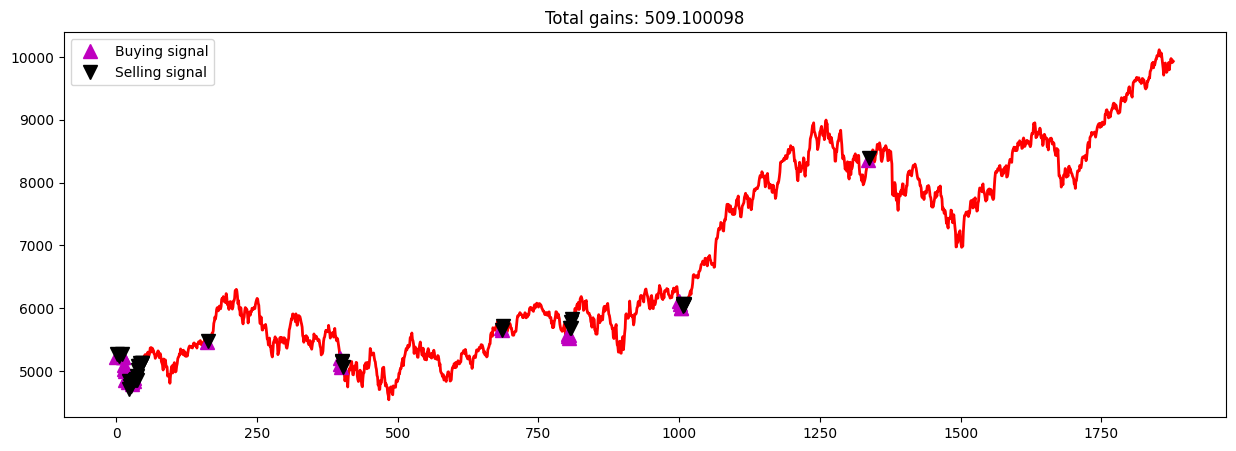

Training in progress...: 100%|██████████| 1878/1878 [05:34<00:00,  5.62it/s]


Running episode 2/10


Training in progress...:   0%|          | 1/1878 [00:00<05:40,  5.51it/s]

[[0.06582157 0.         1.01772681]] 2
[[0.1387869  0.         0.85465857]] 2


Training in progress...:   0%|          | 3/1878 [00:00<05:17,  5.90it/s]

[[0.15834038 0.         0.58655189]] 2
[[0.1709745 0.        0.6701064]] 2


Training in progress...:   0%|          | 5/1878 [00:00<05:16,  5.92it/s]

[[0.18159277 0.         0.64990059]] 2
[[0.13452399 0.         0.60964087]] 2


Training in progress...:   0%|          | 7/1878 [00:01<05:24,  5.77it/s]

[[0.1637815  0.         0.49616722]] 2
[[0.17715983 0.         0.36187166]] 2


Training in progress...:   0%|          | 9/1878 [00:01<05:18,  5.88it/s]

[[0.1113776  0.         0.36185269]] 2
[[0.06353608 0.         0.32809152]] 2


Training in progress...:   1%|          | 11/1878 [00:01<05:22,  5.79it/s]

[[0.       0.       0.289719]] 2
[[0.         0.         0.31207882]] 2


Training in progress...:   1%|          | 13/1878 [00:02<05:20,  5.83it/s]

[[0.         0.         0.20601782]] 2
[[0.         0.         0.23897071]] 2


Training in progress...:   1%|          | 15/1878 [00:02<05:13,  5.94it/s]

[[0.         0.         0.27607084]] 2
[[0.         0.         0.38417232]] 2


Training in progress...:   1%|          | 17/1878 [00:02<05:15,  5.90it/s]

[[0.         0.         0.63071501]] 2
[[0.         0.         0.53571164]] 2


Training in progress...:   1%|          | 19/1878 [00:03<05:18,  5.83it/s]

[[0.         0.         0.53272152]] 2
[[0.         0.         0.32610431]] 2


Training in progress...:   1%|          | 21/1878 [00:03<05:13,  5.92it/s]

[[0.        0.        0.3732678]] 2
[[0.         0.         0.13283947]] 2


Training in progress...:   1%|          | 23/1878 [00:03<05:18,  5.83it/s]

[[0.         0.         0.43052788]] 2
[[0.         0.         0.48645189]] 2


Training in progress...:   1%|▏         | 25/1878 [00:04<05:30,  5.61it/s]

[[0.         0.         0.51688943]] 2
[[0.         0.         0.64732232]] 2


Training in progress...:   1%|▏         | 27/1878 [00:04<05:21,  5.76it/s]

[[0.         0.         0.36145996]] 2
[[0.        0.        0.3773353]] 2


Training in progress...:   2%|▏         | 29/1878 [00:04<05:18,  5.81it/s]

[[0.         0.         0.41842602]] 2
[[0.         0.         0.43241637]] 2


Training in progress...:   2%|▏         | 31/1878 [00:05<05:16,  5.84it/s]

[[0.         0.         0.45564219]] 2
[[0.         0.         0.35657288]] 2


Training in progress...:   2%|▏         | 33/1878 [00:05<05:14,  5.87it/s]

[[0.         0.         0.26509827]] 2
[[0.         0.         0.46253606]] 2


Training in progress...:   2%|▏         | 35/1878 [00:06<05:14,  5.86it/s]

[[0.         0.         0.46317367]] 2
[[0.         0.         0.53856531]] 2


Training in progress...:   2%|▏         | 37/1878 [00:06<05:28,  5.61it/s]

[[0.        0.        0.6534315]] 2
[[0.         0.         0.66299511]] 2


Training in progress...:   2%|▏         | 39/1878 [00:06<05:17,  5.79it/s]

[[0.         0.         0.59071209]] 2
[[0.         0.         0.43967799]] 2


Training in progress...:   2%|▏         | 40/1878 [00:06<05:47,  5.29it/s]

[[0.         0.         0.18874383]] 2


Training in progress...:   2%|▏         | 41/1878 [00:07<06:12,  4.94it/s]

[[0.         0.         0.10685035]] 2


Training in progress...:   2%|▏         | 42/1878 [00:07<06:23,  4.78it/s]

[[0.         0.         0.20158974]] 2


Training in progress...:   2%|▏         | 43/1878 [00:07<06:26,  4.75it/s]

[[0.02087893 0.         0.18255983]] 2


Training in progress...:   2%|▏         | 44/1878 [00:07<06:26,  4.75it/s]

[[0.09009922 0.         0.10240437]] 2


Training in progress...:   2%|▏         | 45/1878 [00:08<06:29,  4.70it/s]

[[0.05965669 0.         0.30947894]] 2


Training in progress...:   2%|▏         | 46/1878 [00:08<06:50,  4.47it/s]

[[0.20297121 0.         0.36842684]] 2


Training in progress...:   3%|▎         | 48/1878 [00:08<06:26,  4.73it/s]

[[0.0740865  0.         0.21693196]] 2
[[0.10257595 0.         0.10526038]] 2


Training in progress...:   3%|▎         | 49/1878 [00:08<06:32,  4.66it/s]

[[0.09950978 0.         0.12030747]] 2


Training in progress...:   3%|▎         | 50/1878 [00:09<06:49,  4.47it/s]

[[0.18833279 0.         0.06015968]] 0


Training in progress...:   3%|▎         | 51/1878 [00:09<06:54,  4.41it/s]

[[0.06604307 0.         0.17756338]] 2


Training in progress...:   3%|▎         | 52/1878 [00:09<06:59,  4.35it/s]

[[0.        0.        0.2808624]] 2


Training in progress...:   3%|▎         | 53/1878 [00:09<06:59,  4.35it/s]

[[0.10406608 0.         0.27858038]] 2


Training in progress...:   3%|▎         | 54/1878 [00:10<07:16,  4.18it/s]

[[0.         0.         0.14439357]] 2


Training in progress...:   3%|▎         | 56/1878 [00:10<06:29,  4.68it/s]

[[0.         0.         0.06285896]] 2
[[0.         0.         0.24362151]] 2


Training in progress...:   3%|▎         | 58/1878 [00:10<05:49,  5.20it/s]

[[0.         0.         0.45349373]] 2
[[0.         0.         0.54837781]] 2


Training in progress...:   3%|▎         | 60/1878 [00:11<05:50,  5.18it/s]

[[0.         0.         0.55283081]] 2
[[0.         0.         0.43483048]] 2


Training in progress...:   3%|▎         | 62/1878 [00:11<05:53,  5.13it/s]

[[0.         0.         0.33032094]] 2
[[0.         0.         0.40452493]] 2


Training in progress...:   3%|▎         | 64/1878 [00:12<05:53,  5.12it/s]

[[0.         0.         0.36240196]] 2
[[0.         0.         0.30027405]] 2


Training in progress...:   4%|▎         | 66/1878 [00:12<05:43,  5.28it/s]

[[0.         0.         0.30340176]] 2
[[0.         0.         0.23700562]] 2


Training in progress...:   4%|▎         | 68/1878 [00:12<05:23,  5.59it/s]

[[0.         0.         0.39727339]] 2
[[0.         0.         0.61019436]] 2


Training in progress...:   4%|▎         | 69/1878 [00:12<05:24,  5.58it/s]

[[0.         0.         0.48633361]] 2


Training in progress...:   4%|▍         | 71/1878 [00:13<05:51,  5.14it/s]

[[0.         0.         0.54832421]] 2
[[0.00982802 0.         0.41358633]] 2


Training in progress...:   4%|▍         | 73/1878 [00:13<05:29,  5.47it/s]

[[0.02311636 0.         0.50958908]] 2
[[0.         0.         0.62802975]] 2


Training in progress...:   4%|▍         | 75/1878 [00:14<05:23,  5.58it/s]

[[0.         0.         0.58822139]] 2
[[0.         0.         0.57857092]] 2


Training in progress...:   4%|▍         | 77/1878 [00:14<05:26,  5.52it/s]

[[0.         0.         0.53341284]] 2
[[0.         0.         0.40511826]] 2


Training in progress...:   4%|▍         | 79/1878 [00:14<05:26,  5.52it/s]

[[0.         0.         0.40563955]] 2
[[0.         0.         0.55781875]] 2


Training in progress...:   4%|▍         | 81/1878 [00:15<05:14,  5.71it/s]

[[0.         0.         0.68348196]] 2
[[0.         0.         0.64794568]] 2


Training in progress...:   4%|▍         | 83/1878 [00:15<05:11,  5.77it/s]

[[0.         0.         0.73174828]] 2
[[0.         0.00343531 0.62715106]] 2


Training in progress...:   5%|▍         | 85/1878 [00:15<05:06,  5.86it/s]

[[0.         0.03789024 0.63404675]] 2
[[0.        0.        0.6764558]] 2


Training in progress...:   5%|▍         | 87/1878 [00:16<05:17,  5.64it/s]

[[0.         0.         0.47561305]] 2
[[0.         0.         0.50506811]] 2


Training in progress...:   5%|▍         | 89/1878 [00:16<05:15,  5.67it/s]

[[0.06358244 0.04194774 0.4297574 ]] 2
[[0.16517837 0.08063183 0.43864491]] 2


Training in progress...:   5%|▍         | 91/1878 [00:16<05:11,  5.74it/s]

[[0.         0.         0.46936774]] 2
[[0.         0.00273528 0.57699317]] 2


Training in progress...:   5%|▍         | 93/1878 [00:17<05:27,  5.45it/s]

[[0.         0.         0.44631598]] 2


Training in progress...:   5%|▌         | 94/1878 [00:17<05:27,  5.44it/s]

[[0.03474917 0.         0.28132009]] 2
[[0.14735727 0.05547503 0.36951413]] 2


Training in progress...:   5%|▌         | 96/1878 [00:17<05:32,  5.36it/s]

[[0.08286298 0.         0.37001697]] 2
[[0.01071372 0.12318278 0.3441871 ]] 2


Training in progress...:   5%|▌         | 98/1878 [00:18<05:26,  5.45it/s]

[[0.         0.         0.30246191]] 2
[[0.         0.         0.21870323]] 2


Training in progress...:   5%|▌         | 100/1878 [00:18<05:21,  5.52it/s]

[[0.         0.         0.25970327]] 2
[[0.         0.         0.37038012]] 2


Training in progress...:   5%|▌         | 102/1878 [00:18<05:13,  5.66it/s]

[[0.         0.13508486 0.66134493]] 2
[[0.         0.         0.65934069]] 2


Training in progress...:   6%|▌         | 104/1878 [00:19<05:15,  5.62it/s]

[[0.         0.         0.81226524]] 2
[[0.         0.         0.73720652]] 2


Training in progress...:   6%|▌         | 106/1878 [00:19<05:11,  5.70it/s]

[[0.         0.         0.63919423]] 2
[[0.        0.        0.6071137]] 2


Training in progress...:   6%|▌         | 108/1878 [00:19<05:05,  5.80it/s]

[[0.         0.         0.54314674]] 2
[[0.        0.        0.6407612]] 2


Training in progress...:   6%|▌         | 110/1878 [00:20<05:18,  5.55it/s]

[[0.         0.         0.63303913]] 2
[[0.        0.        0.7864395]] 2


Training in progress...:   6%|▌         | 111/1878 [00:20<05:57,  4.94it/s]

[[0.         0.         0.82358507]] 2


Training in progress...:   6%|▌         | 112/1878 [00:20<06:06,  4.82it/s]

[[0.         0.         0.97645609]] 2


Training in progress...:   6%|▌         | 113/1878 [00:20<06:09,  4.78it/s]

[[0.         0.         0.70214908]] 2


Training in progress...:   6%|▌         | 114/1878 [00:21<06:15,  4.70it/s]

[[0.         0.         0.53499735]] 2


Training in progress...:   6%|▌         | 115/1878 [00:21<06:28,  4.54it/s]

[[0.         0.         0.52807302]] 2


Training in progress...:   6%|▌         | 116/1878 [00:21<06:20,  4.63it/s]

[[0.         0.         0.31591992]] 2


Training in progress...:   6%|▌         | 117/1878 [00:21<06:22,  4.61it/s]

[[0.         0.         0.27753883]] 2


Training in progress...:   6%|▋         | 119/1878 [00:22<06:09,  4.76it/s]

[[0.         0.         0.16496384]] 2
[[0.         0.         0.38648928]] 2


Training in progress...:   6%|▋         | 120/1878 [00:22<06:22,  4.59it/s]

[[0.        0.        0.2640007]] 2


Training in progress...:   6%|▋         | 121/1878 [00:22<06:39,  4.40it/s]

[[0.         0.         0.17266962]] 2


Training in progress...:   6%|▋         | 122/1878 [00:23<06:46,  4.32it/s]

[[0.         0.         0.08923491]] 2


Training in progress...:   7%|▋         | 123/1878 [00:23<06:58,  4.19it/s]

[[0.         0.         0.16126296]] 2


Training in progress...:   7%|▋         | 124/1878 [00:23<07:12,  4.05it/s]

[[0.         0.01921798 0.21373023]] 2


Training in progress...:   7%|▋         | 126/1878 [00:23<06:44,  4.34it/s]

[[0.         0.16372716 0.07255582]] 1
[[0.         0.18218329 0.15838679]] 1


Training in progress...:   7%|▋         | 128/1878 [00:24<05:52,  4.96it/s]

[[0.         0.24451052 0.07512816]] 1
[[0.         0.02838281 0.32473679]] 2


Training in progress...:   7%|▋         | 129/1878 [00:24<05:42,  5.11it/s]

[[0.         0.02625591 0.3595035 ]] 2


Training in progress...:   7%|▋         | 131/1878 [00:24<06:04,  4.79it/s]

[[0.         0.         0.32027568]] 2
[[0.         0.         0.48193017]] 2


Training in progress...:   7%|▋         | 133/1878 [00:25<05:37,  5.17it/s]

[[0.         0.         0.53189201]] 2
[[0.         0.         0.50905301]] 2


Training in progress...:   7%|▋         | 135/1878 [00:25<05:21,  5.42it/s]

[[0.         0.         0.57188878]] 2
[[0.         0.         0.51926594]] 2


Training in progress...:   7%|▋         | 137/1878 [00:26<05:12,  5.58it/s]

[[0.         0.         0.51431707]] 2
[[0.         0.         0.54038318]] 2


Training in progress...:   7%|▋         | 139/1878 [00:26<05:13,  5.54it/s]

[[0.         0.         0.55385959]] 2
[[0.         0.         0.47138031]] 2


Training in progress...:   8%|▊         | 141/1878 [00:26<05:04,  5.70it/s]

[[0.         0.         0.38576809]] 2
[[0.         0.         0.45912514]] 2


Training in progress...:   8%|▊         | 143/1878 [00:27<05:01,  5.76it/s]

[[0.         0.         0.44065346]] 2
[[0.         0.         0.55132638]] 2


Training in progress...:   8%|▊         | 145/1878 [00:27<05:00,  5.77it/s]

[[0.        0.        0.4289025]] 2
[[0.         0.         0.64114839]] 2


Training in progress...:   8%|▊         | 147/1878 [00:27<05:05,  5.67it/s]

[[0.         0.         0.55622977]] 2
[[0.         0.         0.43762155]] 2


Training in progress...:   8%|▊         | 149/1878 [00:28<04:58,  5.79it/s]

[[0.         0.         0.17974203]] 2
[[0.         0.         0.37479459]] 2


Training in progress...:   8%|▊         | 151/1878 [00:28<04:59,  5.77it/s]

[[0.         0.         0.36781062]] 2
[[0.         0.         0.26176533]] 2


Training in progress...:   8%|▊         | 153/1878 [00:28<05:01,  5.72it/s]

[[0.        0.        0.1955874]] 2
[[0.         0.         0.18140312]] 2


Training in progress...:   8%|▊         | 155/1878 [00:29<05:01,  5.71it/s]

[[0.         0.         0.13993163]] 2
[[0.         0.         0.16719387]] 2


Training in progress...:   8%|▊         | 157/1878 [00:29<05:04,  5.66it/s]

[[0.        0.        0.2727232]] 2
[[0.         0.         0.40954074]] 2


Training in progress...:   8%|▊         | 159/1878 [00:29<04:58,  5.75it/s]

[[0.         0.         0.40776983]] 2
[[0.         0.         0.23903138]] 2


Training in progress...:   9%|▊         | 161/1878 [00:30<04:59,  5.72it/s]

[[0.         0.         0.44366498]] 2
[[0.         0.         0.27649164]] 2


Training in progress...:   9%|▊         | 163/1878 [00:30<04:53,  5.84it/s]

[[0.         0.         0.31491251]] 2
[[0.         0.         0.37769036]] 2


Training in progress...:   9%|▉         | 165/1878 [00:30<04:52,  5.86it/s]

[[0.         0.         0.43930854]] 2
[[0.         0.         0.58806671]] 2


Training in progress...:   9%|▉         | 167/1878 [00:31<04:56,  5.77it/s]

[[0.         0.         0.42085132]] 2
[[0.         0.         0.43095339]] 2


Training in progress...:   9%|▉         | 169/1878 [00:31<04:57,  5.75it/s]

[[0.         0.         0.56144492]] 2
[[0.         0.         0.61815352]] 2


Training in progress...:   9%|▉         | 171/1878 [00:31<04:52,  5.83it/s]

[[0.         0.         0.67928667]] 2
[[0.         0.         0.66573367]] 2


Training in progress...:   9%|▉         | 173/1878 [00:32<04:58,  5.71it/s]

[[0.         0.         0.64339321]] 2
[[0.         0.         0.55653028]] 2


Training in progress...:   9%|▉         | 175/1878 [00:32<04:52,  5.82it/s]

[[0.         0.         0.61897081]] 2
[[0.         0.         0.63239119]] 2


Training in progress...:   9%|▉         | 177/1878 [00:32<04:54,  5.78it/s]

[[0.         0.         0.75040671]] 2
[[0.         0.         0.67758139]] 2


Training in progress...:  10%|▉         | 179/1878 [00:33<04:53,  5.79it/s]

[[0.         0.         0.96687874]] 2
[[0.        0.        0.7482244]] 2


Training in progress...:  10%|▉         | 181/1878 [00:33<04:51,  5.83it/s]

[[0.         0.         0.73821655]] 2
[[0.         0.         0.61102372]] 2


Training in progress...:  10%|▉         | 182/1878 [00:33<05:07,  5.52it/s]

[[0.         0.         0.51985217]] 2


Training in progress...:  10%|▉         | 183/1878 [00:34<05:42,  4.95it/s]

[[0.         0.         0.51620008]] 2


Training in progress...:  10%|▉         | 184/1878 [00:34<05:56,  4.76it/s]

[[0.         0.         0.51027536]] 2


Training in progress...:  10%|▉         | 186/1878 [00:34<05:56,  4.74it/s]

[[0.         0.         0.42097474]] 2
[[0.         0.         0.32854196]] 2


Training in progress...:  10%|▉         | 187/1878 [00:35<06:04,  4.64it/s]

[[0.         0.         0.17679341]] 2


Training in progress...:  10%|█         | 188/1878 [00:35<06:10,  4.56it/s]

[[0.         0.         0.21116545]] 2


Training in progress...:  10%|█         | 189/1878 [00:35<06:07,  4.60it/s]

[[0.10526381 0.         0.19330851]] 2


Training in progress...:  10%|█         | 191/1878 [00:35<05:58,  4.71it/s]

[[0.        0.        0.1349409]] 2
[[0.         0.         0.07345047]] 2


Training in progress...:  10%|█         | 192/1878 [00:36<06:17,  4.47it/s]

[[0.11925408 0.         0.15969744]] 2


Training in progress...:  10%|█         | 193/1878 [00:36<06:37,  4.24it/s]

[[0.00485285 0.         0.        ]] 0


Training in progress...:  10%|█         | 194/1878 [00:36<06:36,  4.25it/s]

[[0. 0. 0.]] 0


Training in progress...:  10%|█         | 195/1878 [00:36<06:41,  4.19it/s]

[[0.00480305 0.         0.01393353]] 2


Training in progress...:  10%|█         | 196/1878 [00:37<06:45,  4.15it/s]

[[0. 0. 0.]] 0


Training in progress...:  11%|█         | 198/1878 [00:37<06:24,  4.37it/s]

[[0. 0. 0.]] 0
[[0.        0.        0.2294182]] 2


Training in progress...:  11%|█         | 200/1878 [00:37<05:30,  5.07it/s]

[[0.         0.         0.30137929]] 2
[[0.         0.         0.10931027]] 2


Training in progress...:  11%|█         | 202/1878 [00:38<05:16,  5.30it/s]

[[0.       0.       0.282023]] 2
[[0.0470059  0.         0.49385732]] 2


Training in progress...:  11%|█         | 204/1878 [00:38<05:02,  5.53it/s]

[[0.         0.         0.47850274]] 2
[[0.         0.         0.47667748]] 2


Training in progress...:  11%|█         | 206/1878 [00:38<04:56,  5.64it/s]

[[0.         0.         0.53194729]] 2
[[0.         0.         0.47658581]] 2


Training in progress...:  11%|█         | 208/1878 [00:39<04:58,  5.59it/s]

[[0.        0.        0.4198168]] 2
[[0.         0.         0.54508938]] 2


Training in progress...:  11%|█         | 210/1878 [00:39<04:53,  5.69it/s]

[[0.         0.         0.48835711]] 2
[[0.         0.         0.49414456]] 2


Training in progress...:  11%|█▏        | 212/1878 [00:40<04:52,  5.70it/s]

[[0.       0.       0.616187]] 2
[[0.        0.        0.6005235]] 2


Training in progress...:  11%|█▏        | 214/1878 [00:40<04:52,  5.69it/s]

[[0.         0.         0.80201249]] 2
[[0.         0.         0.65032663]] 2


Training in progress...:  12%|█▏        | 216/1878 [00:40<04:47,  5.79it/s]

[[0.         0.         0.51845144]] 2
[[0.         0.         0.51596482]] 2


Training in progress...:  12%|█▏        | 218/1878 [00:41<04:46,  5.80it/s]

[[0.06037652 0.         0.45060573]] 2
[[0.0961332  0.         0.42785776]] 2


Training in progress...:  12%|█▏        | 220/1878 [00:41<04:52,  5.66it/s]

[[0.1971303  0.         0.41743875]] 2
[[0.42141358 0.         0.4242888 ]] 2


Training in progress...:  12%|█▏        | 222/1878 [00:41<04:48,  5.75it/s]

[[0.19576153 0.         0.42914058]] 2
[[0.039508   0.         0.31220657]] 2


Training in progress...:  12%|█▏        | 224/1878 [00:42<04:47,  5.75it/s]

[[0.        0.        0.3323229]] 2
[[0.         0.         0.22863329]] 2


Training in progress...:  12%|█▏        | 226/1878 [00:42<04:48,  5.72it/s]

[[0.        0.        0.0764204]] 2
[[0.         0.         0.07833038]] 2


Training in progress...:  12%|█▏        | 228/1878 [00:42<04:45,  5.78it/s]

[[0.07599085 0.         0.06791648]] 0
[[0.10296556 0.         0.01912327]] 0


Training in progress...:  12%|█▏        | 230/1878 [00:43<04:49,  5.68it/s]

[[0.         0.         0.07517005]] 2
[[0.02209995 0.         0.08589628]] 2


Training in progress...:  12%|█▏        | 232/1878 [00:43<04:43,  5.80it/s]

[[0.1474485  0.         0.04936874]] 0
[[0.05088504 0.         0.06396697]] 2


Training in progress...:  12%|█▏        | 234/1878 [00:43<04:50,  5.65it/s]

[[0.        0.        0.1447014]] 2
[[0.00312078 0.         0.29199093]] 2


Training in progress...:  13%|█▎        | 236/1878 [00:44<04:59,  5.48it/s]

[[0.06659328 0.         0.37636865]] 2
[[0.         0.         0.44362644]] 2


Training in progress...:  13%|█▎        | 238/1878 [00:44<04:52,  5.60it/s]

[[0.         0.         0.48995915]] 2
[[0.         0.         0.45413542]] 2


Training in progress...:  13%|█▎        | 240/1878 [00:44<04:47,  5.69it/s]

[[0.         0.         0.40407912]] 2
[[0.         0.         0.37237031]] 2


Training in progress...:  13%|█▎        | 242/1878 [00:45<04:54,  5.56it/s]

[[0.         0.         0.34396823]] 2
[[0.         0.         0.38350329]] 2


Training in progress...:  13%|█▎        | 244/1878 [00:45<04:48,  5.66it/s]

[[0.         0.         0.42017998]] 2
[[0.         0.         0.62011645]] 2


Training in progress...:  13%|█▎        | 246/1878 [00:45<04:46,  5.69it/s]

[[0.         0.         0.46225956]] 2
[[0.         0.         0.27670582]] 2


Training in progress...:  13%|█▎        | 248/1878 [00:46<04:56,  5.49it/s]

[[0.         0.         0.25211455]] 2
[[0.         0.         0.22659433]] 2


Training in progress...:  13%|█▎        | 250/1878 [00:46<04:47,  5.67it/s]

[[0.         0.         0.17078594]] 2
[[0.         0.         0.03118501]] 2


Training in progress...:  13%|█▎        | 252/1878 [00:47<04:44,  5.72it/s]

[[0.         0.03396717 0.10400362]] 2
[[0.         0.         0.19974178]] 2


Training in progress...:  13%|█▎        | 253/1878 [00:47<04:51,  5.57it/s]

[[0.         0.         0.11460459]] 2


Training in progress...:  14%|█▎        | 254/1878 [00:47<05:05,  5.32it/s]

[[0.         0.21440106 0.23392447]] 2


Training in progress...:  14%|█▎        | 255/1878 [00:47<05:36,  4.82it/s]

[[0.         0.10798365 0.26253631]] 2


Training in progress...:  14%|█▎        | 256/1878 [00:47<05:43,  4.72it/s]

[[0.         0.19614569 0.43210725]] 2


Training in progress...:  14%|█▎        | 257/1878 [00:48<05:41,  4.75it/s]

[[0.         0.         0.35560327]] 2


Training in progress...:  14%|█▎        | 258/1878 [00:48<05:50,  4.62it/s]

[[0.         0.         0.36283271]] 2


Training in progress...:  14%|█▍        | 259/1878 [00:48<05:49,  4.64it/s]

[[0.        0.        0.5090744]] 2


Training in progress...:  14%|█▍        | 260/1878 [00:48<05:43,  4.71it/s]

[[0.         0.04816949 0.55802971]] 2


Training in progress...:  14%|█▍        | 261/1878 [00:48<05:45,  4.69it/s]

[[0.         0.         0.49035172]] 2


Training in progress...:  14%|█▍        | 262/1878 [00:49<05:54,  4.56it/s]

[[0.         0.         0.55377616]] 2


Training in progress...:  14%|█▍        | 263/1878 [00:49<05:52,  4.59it/s]

[[0.04811069 0.         0.67446971]] 2


Training in progress...:  14%|█▍        | 264/1878 [00:49<05:58,  4.51it/s]

[[0.00192606 0.         0.53251948]] 2


Training in progress...:  14%|█▍        | 265/1878 [00:49<06:09,  4.37it/s]

[[0.         0.         0.49640801]] 2


Training in progress...:  14%|█▍        | 266/1878 [00:50<06:14,  4.31it/s]

[[0.         0.         0.47830197]] 2


Training in progress...:  14%|█▍        | 267/1878 [00:50<06:28,  4.15it/s]

[[0.         0.         0.44208758]] 2


Training in progress...:  14%|█▍        | 268/1878 [00:50<06:29,  4.13it/s]

[[0.01214222 0.         0.51409529]] 2


Training in progress...:  14%|█▍        | 269/1878 [00:50<06:30,  4.12it/s]

[[0.         0.         0.42828641]] 2


Training in progress...:  14%|█▍        | 271/1878 [00:51<05:51,  4.57it/s]

[[0.         0.         0.50652406]] 2
[[0.         0.         0.51714085]] 2


Training in progress...:  15%|█▍        | 273/1878 [00:51<05:16,  5.08it/s]

[[0.         0.         0.46167779]] 2
[[0.         0.16633466 0.50672286]] 2


Training in progress...:  15%|█▍        | 275/1878 [00:51<04:50,  5.52it/s]

[[0.         0.09403632 0.61762728]] 2
[[0.         0.14739865 0.74651499]] 2


Training in progress...:  15%|█▍        | 277/1878 [00:52<04:43,  5.64it/s]

[[0.         0.10440018 0.68729906]] 2
[[0.         0.         0.49022722]] 2


Training in progress...:  15%|█▍        | 279/1878 [00:52<04:41,  5.68it/s]

[[0.         0.14781441 0.49113301]] 2
[[0.         0.         0.40906079]] 2


Training in progress...:  15%|█▍        | 281/1878 [00:53<04:38,  5.74it/s]

[[0.         0.         0.30994422]] 2
[[0.         0.         0.18317085]] 2


Training in progress...:  15%|█▌        | 283/1878 [00:53<04:40,  5.68it/s]

[[0.         0.         0.23016536]] 2
[[0.         0.         0.28487419]] 2


Training in progress...:  15%|█▌        | 285/1878 [00:53<04:36,  5.76it/s]

[[0.         0.         0.30017668]] 2
[[0.         0.         0.28131157]] 2


Training in progress...:  15%|█▌        | 287/1878 [00:54<04:31,  5.85it/s]

[[0.         0.         0.22802472]] 2
[[0.         0.         0.36673198]] 2


Training in progress...:  15%|█▌        | 289/1878 [00:54<04:35,  5.76it/s]

[[0.         0.         0.37632888]] 2
[[0.         0.         0.48409276]] 2


Training in progress...:  15%|█▌        | 291/1878 [00:54<04:35,  5.77it/s]

[[0.         0.         0.53660504]] 2
[[0.         0.         0.55763769]] 2


Training in progress...:  16%|█▌        | 293/1878 [00:55<04:31,  5.84it/s]

[[0.         0.         0.50783751]] 2
[[0.         0.         0.59686297]] 2


Training in progress...:  16%|█▌        | 295/1878 [00:55<04:31,  5.83it/s]

[[0.         0.         0.58869598]] 2
[[0.         0.         0.43775331]] 2


Training in progress...:  16%|█▌        | 297/1878 [00:55<04:32,  5.80it/s]

[[0.         0.         0.37767395]] 2
[[0.         0.         0.53224128]] 2


Training in progress...:  16%|█▌        | 299/1878 [00:56<04:38,  5.67it/s]

[[0.         0.         0.58194088]] 2
[[0.         0.04440355 0.47780723]] 2


Training in progress...:  16%|█▌        | 301/1878 [00:56<04:36,  5.71it/s]

[[0.         0.         0.58528293]] 2
[[0.         0.         0.53938184]] 2


Training in progress...:  16%|█▌        | 303/1878 [00:56<04:34,  5.75it/s]

[[0.         0.         0.66191996]] 2
[[0.         0.         0.70074205]] 2


Training in progress...:  16%|█▌        | 305/1878 [00:57<04:36,  5.68it/s]

[[0.         0.         0.58748992]] 2
[[0.         0.         0.42049853]] 2


Training in progress...:  16%|█▋        | 307/1878 [00:57<04:31,  5.79it/s]

[[0.         0.         0.61363188]] 2
[[0.         0.         0.48739073]] 2


Training in progress...:  16%|█▋        | 309/1878 [00:57<04:29,  5.82it/s]

[[0.        0.        0.6314259]] 2
[[0.         0.         0.57740695]] 2


Training in progress...:  17%|█▋        | 311/1878 [00:58<04:31,  5.77it/s]

[[0.         0.         0.57981535]] 2
[[0.         0.         0.52913762]] 2


Training in progress...:  17%|█▋        | 313/1878 [00:58<04:27,  5.84it/s]

[[0.         0.         0.32927166]] 2
[[0.         0.         0.38210584]] 2


Training in progress...:  17%|█▋        | 315/1878 [00:58<04:28,  5.83it/s]

[[0.         0.         0.28067235]] 2
[[0.         0.         0.58115407]] 2


Training in progress...:  17%|█▋        | 317/1878 [00:59<04:31,  5.76it/s]

[[0.         0.         0.36893749]] 2
[[0.         0.         0.42979576]] 2


Training in progress...:  17%|█▋        | 319/1878 [00:59<04:28,  5.81it/s]

[[0.         0.         0.36941547]] 2
[[0.0806377  0.         0.35216104]] 2


Training in progress...:  17%|█▋        | 321/1878 [00:59<04:29,  5.78it/s]

[[0.         0.         0.47749822]] 2
[[0.         0.         0.33153161]] 2


Training in progress...:  17%|█▋        | 323/1878 [01:00<04:30,  5.75it/s]

[[0.         0.         0.39218181]] 2
[[0.         0.         0.41288894]] 2


Training in progress...:  17%|█▋        | 325/1878 [01:00<04:25,  5.85it/s]

[[0.         0.         0.40115473]] 2
[[0.         0.         0.47832181]] 2


Training in progress...:  17%|█▋        | 327/1878 [01:01<04:25,  5.84it/s]

[[0.         0.         0.23982679]] 2
[[0.         0.         0.25204171]] 2


Training in progress...:  17%|█▋        | 328/1878 [01:01<04:53,  5.29it/s]

[[0.         0.         0.32530172]] 2


Training in progress...:  18%|█▊        | 329/1878 [01:01<05:13,  4.95it/s]

[[0.       0.       0.431803]] 2


Training in progress...:  18%|█▊        | 330/1878 [01:01<05:16,  4.89it/s]

[[0.        0.        0.5506793]] 2


Training in progress...:  18%|█▊        | 331/1878 [01:01<05:31,  4.66it/s]

[[0.        0.        0.6665063]] 2


Training in progress...:  18%|█▊        | 332/1878 [01:02<05:28,  4.71it/s]

[[0.         0.         0.69297349]] 2


Training in progress...:  18%|█▊        | 333/1878 [01:02<05:24,  4.76it/s]

[[0.         0.         0.75531151]] 2


Training in progress...:  18%|█▊        | 334/1878 [01:02<05:33,  4.63it/s]

[[0.         0.04517389 0.57683215]] 2


Training in progress...:  18%|█▊        | 335/1878 [01:02<05:32,  4.65it/s]

[[0.         0.         0.61432509]] 2


Training in progress...:  18%|█▊        | 336/1878 [01:02<05:29,  4.68it/s]

[[0.         0.         0.53759643]] 2


Training in progress...:  18%|█▊        | 337/1878 [01:03<05:41,  4.52it/s]

[[0.         0.         0.45483682]] 2


Training in progress...:  18%|█▊        | 338/1878 [01:03<05:50,  4.39it/s]

[[0.         0.         0.41983481]] 2


Training in progress...:  18%|█▊        | 339/1878 [01:03<05:50,  4.39it/s]

[[0.         0.         0.37634962]] 2


Training in progress...:  18%|█▊        | 340/1878 [01:03<06:05,  4.21it/s]

[[0.         0.         0.34638753]] 2


Training in progress...:  18%|█▊        | 341/1878 [01:04<06:11,  4.13it/s]

[[0.         0.         0.38072947]] 2


Training in progress...:  18%|█▊        | 342/1878 [01:04<06:15,  4.09it/s]

[[0.         0.         0.33503011]] 2


Training in progress...:  18%|█▊        | 344/1878 [01:04<05:35,  4.57it/s]

[[0.         0.         0.25697304]] 2
[[0.07642175 0.         0.40785619]] 2


Training in progress...:  18%|█▊        | 346/1878 [01:05<05:03,  5.05it/s]

[[0.         0.         0.41234285]] 2
[[0.         0.         0.41202168]] 2


Training in progress...:  19%|█▊        | 348/1878 [01:05<04:43,  5.40it/s]

[[0.         0.         0.49752119]] 2
[[0.02782751 0.         0.62653522]] 2


Training in progress...:  19%|█▊        | 350/1878 [01:05<04:29,  5.67it/s]

[[0.         0.         0.47024881]] 2
[[0.         0.         0.36044025]] 2


Training in progress...:  19%|█▊        | 352/1878 [01:06<04:42,  5.40it/s]

[[0.         0.         0.34165386]] 2
[[0.         0.         0.37660175]] 2


Training in progress...:  19%|█▉        | 354/1878 [01:06<04:29,  5.66it/s]

[[0.         0.         0.47936729]] 2
[[0.         0.         0.55994843]] 2


Training in progress...:  19%|█▉        | 356/1878 [01:06<04:25,  5.73it/s]

[[0.         0.         0.42742971]] 2
[[0.         0.         0.27564394]] 2


Training in progress...:  19%|█▉        | 358/1878 [01:07<04:30,  5.61it/s]

[[0.         0.         0.35509502]] 2
[[0.         0.         0.52623519]] 2


Training in progress...:  19%|█▉        | 360/1878 [01:07<04:27,  5.68it/s]

[[0.01791983 0.         0.64182848]] 2
[[0.30033008 0.         0.78687178]] 2


Training in progress...:  19%|█▉        | 362/1878 [01:08<04:24,  5.73it/s]

[[0.26841713 0.         0.63714332]] 2
[[0.25196765 0.         0.72773201]] 2


Training in progress...:  19%|█▉        | 364/1878 [01:08<04:27,  5.66it/s]

[[0.21590149 0.         0.6386148 ]] 2
[[0.06706929 0.         0.60681856]] 2


Training in progress...:  19%|█▉        | 366/1878 [01:08<04:23,  5.75it/s]

[[0.07596461 0.064801   0.66500293]] 2
[[0.10858816 0.         0.62809187]] 2


Training in progress...:  20%|█▉        | 368/1878 [01:09<04:20,  5.80it/s]

[[0.04768594 0.         0.51997154]] 2
[[0.         0.         0.54823648]] 2


Training in progress...:  20%|█▉        | 370/1878 [01:09<04:27,  5.64it/s]

[[0.         0.         0.58120476]] 2
[[0.         0.         0.50340211]] 2


Training in progress...:  20%|█▉        | 372/1878 [01:09<04:21,  5.75it/s]

[[0.        0.        0.5437032]] 2
[[0.         0.         0.47815988]] 2


Training in progress...:  20%|█▉        | 374/1878 [01:10<04:19,  5.79it/s]

[[0.         0.         0.46447777]] 2
[[2.67644188e-04 0.00000000e+00 4.60913191e-01]] 2


Training in progress...:  20%|██        | 376/1878 [01:10<04:26,  5.64it/s]

[[0.         0.         0.54217292]] 2
[[0.         0.         0.45255627]] 2


Training in progress...:  20%|██        | 378/1878 [01:10<04:19,  5.79it/s]

[[0.        0.        0.5722119]] 2
[[0.         0.         0.41426096]] 2


Training in progress...:  20%|██        | 380/1878 [01:11<04:23,  5.68it/s]

[[0.         0.         0.42489154]] 2
[[0.         0.         0.39683182]] 2


Training in progress...:  20%|██        | 382/1878 [01:11<04:19,  5.77it/s]

[[0.         0.         0.39758137]] 2
[[0.         0.         0.45967961]] 2


Training in progress...:  20%|██        | 384/1878 [01:11<04:15,  5.84it/s]

[[0.         0.         0.44980517]] 2
[[0.         0.         0.44078795]] 2


Training in progress...:  21%|██        | 386/1878 [01:12<04:26,  5.60it/s]

[[0.         0.         0.18191151]] 2
[[0.        0.        0.3239649]] 2


Training in progress...:  21%|██        | 388/1878 [01:12<04:20,  5.72it/s]

[[0.         0.         0.18771629]] 2
[[0.         0.         0.34493584]] 2


Training in progress...:  21%|██        | 390/1878 [01:12<04:16,  5.80it/s]

[[0.         0.         0.23905978]] 2
[[0.        0.        0.4653112]] 2


Training in progress...:  21%|██        | 392/1878 [01:13<04:23,  5.64it/s]

[[0.         0.         0.39188177]] 2
[[0.         0.05548794 0.38761747]] 2


Training in progress...:  21%|██        | 394/1878 [01:13<04:22,  5.66it/s]

[[0.         0.         0.38190316]] 2
[[0.         0.         0.39783626]] 2


Training in progress...:  21%|██        | 396/1878 [01:13<04:15,  5.81it/s]

[[0.         0.         0.46636247]] 2
[[0.         0.         0.45182849]] 2


Training in progress...:  21%|██        | 398/1878 [01:14<04:23,  5.62it/s]

[[0.         0.07393357 0.59146345]] 2
[[0.         0.10753846 0.58196872]] 2


Training in progress...:  21%|██▏       | 400/1878 [01:14<04:23,  5.60it/s]

[[0.         0.00441829 0.45821945]] 2
[[0.         0.         0.46708677]] 2


Training in progress...:  21%|██▏       | 401/1878 [01:14<04:48,  5.13it/s]

[[0.         0.02771606 0.4594565 ]] 2


Training in progress...:  21%|██▏       | 402/1878 [01:15<05:01,  4.89it/s]

[[0.         0.02471968 0.50228779]] 2


Training in progress...:  21%|██▏       | 403/1878 [01:15<05:10,  4.76it/s]

[[0.         0.14340075 0.52754588]] 2


Training in progress...:  22%|██▏       | 404/1878 [01:15<05:17,  4.64it/s]

[[0.         0.02648745 0.50811774]] 2


Training in progress...:  22%|██▏       | 405/1878 [01:15<05:12,  4.71it/s]

[[0.         0.11050619 0.37845876]] 2


Training in progress...:  22%|██▏       | 406/1878 [01:16<05:17,  4.64it/s]

[[0.         0.         0.22107998]] 2


Training in progress...:  22%|██▏       | 407/1878 [01:16<05:32,  4.43it/s]

[[0. 0. 0.]] 0


Training in progress...:  22%|██▏       | 409/1878 [01:16<05:14,  4.67it/s]

[[0. 0. 0.]] 0
[[0.        0.        0.0575326]] 2


Training in progress...:  22%|██▏       | 410/1878 [01:16<05:20,  4.58it/s]

[[0. 0. 0.]] 0


Training in progress...:  22%|██▏       | 411/1878 [01:17<05:31,  4.43it/s]

[[0.         0.         0.02627603]] 2


Training in progress...:  22%|██▏       | 412/1878 [01:17<05:36,  4.35it/s]

[[0.         0.         0.06758747]] 2


Training in progress...:  22%|██▏       | 413/1878 [01:17<05:56,  4.11it/s]

[[0.         0.         0.14071579]] 2


Training in progress...:  22%|██▏       | 414/1878 [01:17<05:56,  4.11it/s]

[[0.         0.         0.29210771]] 2


Training in progress...:  22%|██▏       | 415/1878 [01:18<06:00,  4.06it/s]

[[0.         0.         0.29099946]] 2


Training in progress...:  22%|██▏       | 417/1878 [01:18<05:35,  4.35it/s]

[[0.         0.         0.40783692]] 2
[[0.         0.         0.32186208]] 2


Training in progress...:  22%|██▏       | 419/1878 [01:18<04:50,  5.02it/s]

[[0.         0.         0.47678298]] 2
[[0.         0.         0.48612546]] 2


Training in progress...:  22%|██▏       | 421/1878 [01:19<04:28,  5.42it/s]

[[0.         0.         0.57596556]] 2
[[0.         0.         0.54082302]] 2


Training in progress...:  23%|██▎       | 423/1878 [01:19<04:19,  5.60it/s]

[[0.         0.         0.56816806]] 2
[[0.         0.         0.43376893]] 2


Training in progress...:  23%|██▎       | 425/1878 [01:20<04:18,  5.62it/s]

[[0.         0.         0.40395173]] 2
[[0.         0.         0.32593251]] 2


Training in progress...:  23%|██▎       | 427/1878 [01:20<04:15,  5.67it/s]

[[0.         0.         0.37340827]] 2
[[0.         0.         0.40665821]] 2


Training in progress...:  23%|██▎       | 429/1878 [01:20<04:12,  5.74it/s]

[[0.         0.         0.51679907]] 2
[[0.        0.        0.2972926]] 2


Training in progress...:  23%|██▎       | 431/1878 [01:21<04:09,  5.80it/s]

[[0.         0.         0.30585978]] 2
[[0.         0.         0.32254432]] 2


Training in progress...:  23%|██▎       | 433/1878 [01:21<04:11,  5.74it/s]

[[0.         0.         0.40981606]] 2
[[0.         0.         0.30547004]] 2


Training in progress...:  23%|██▎       | 435/1878 [01:21<04:12,  5.72it/s]

[[0.         0.         0.21243957]] 2
[[0.         0.         0.26878882]] 2


Training in progress...:  23%|██▎       | 437/1878 [01:22<04:10,  5.74it/s]

[[0.         0.         0.18315503]] 2
[[0.         0.         0.15866874]] 2


Training in progress...:  23%|██▎       | 439/1878 [01:22<04:13,  5.68it/s]

[[0.         0.         0.17752146]] 2
[[0.         0.         0.13619821]] 2


Training in progress...:  23%|██▎       | 441/1878 [01:22<04:11,  5.71it/s]

[[0.         0.         0.16341546]] 2
[[0.         0.         0.18123615]] 2


Training in progress...:  24%|██▎       | 443/1878 [01:23<04:10,  5.72it/s]

[[0.         0.         0.18339903]] 2
[[0.        0.        0.1410067]] 2


Training in progress...:  24%|██▎       | 445/1878 [01:23<04:12,  5.68it/s]

[[0.         0.         0.08018638]] 2
[[0.         0.06299424 0.03730982]] 1


Training in progress...:  24%|██▍       | 447/1878 [01:23<04:09,  5.74it/s]

[[0.         0.03394347 0.12414831]] 2
[[0.         0.03066329 0.06596897]] 2


Training in progress...:  24%|██▍       | 449/1878 [01:24<04:11,  5.68it/s]

[[0.         0.26600474 0.05906115]] 1
[[0.         0.35854577 0.1066173 ]] 1


Training in progress...:  24%|██▍       | 451/1878 [01:24<04:12,  5.65it/s]

[[0.         0.2021104  0.23037915]] 2
[[0.         0.09323463 0.30125106]] 2


Training in progress...:  24%|██▍       | 453/1878 [01:24<04:07,  5.75it/s]

[[0.         0.         0.34682464]] 2
[[0.         0.0562251  0.21392782]] 2


Training in progress...:  24%|██▍       | 455/1878 [01:25<04:07,  5.75it/s]

[[0.         0.         0.27549321]] 2
[[0.         0.         0.36021332]] 2


Training in progress...:  24%|██▍       | 457/1878 [01:25<04:05,  5.80it/s]

[[0.         0.         0.37121921]] 2
[[0.         0.         0.38626206]] 2


Training in progress...:  24%|██▍       | 459/1878 [01:25<04:08,  5.72it/s]

[[0.         0.         0.17747669]] 2
[[0.         0.         0.22877982]] 2


Training in progress...:  25%|██▍       | 461/1878 [01:26<04:14,  5.56it/s]

[[0.         0.         0.19195026]] 2
[[0.         0.         0.23474381]] 2


Training in progress...:  25%|██▍       | 463/1878 [01:26<04:11,  5.63it/s]

[[0.08784231 0.         0.28178483]] 2
[[0.20317415 0.         0.33548527]] 2


Training in progress...:  25%|██▍       | 465/1878 [01:27<04:07,  5.71it/s]

[[0.11778202 0.         0.26357912]] 2
[[0.09265826 0.         0.35087711]] 2


Training in progress...:  25%|██▍       | 467/1878 [01:27<04:06,  5.73it/s]

[[0.         0.         0.38552454]] 2
[[0.16530165 0.         0.41741909]] 2


Training in progress...:  25%|██▍       | 469/1878 [01:27<04:07,  5.69it/s]

[[0.09482198 0.         0.36252726]] 2
[[0.05057681 0.         0.354393  ]] 2


Training in progress...:  25%|██▌       | 471/1878 [01:28<04:04,  5.76it/s]

[[0.07279837 0.         0.31982289]] 2
[[0.15769071 0.         0.37918117]] 2


Training in progress...:  25%|██▌       | 473/1878 [01:28<04:08,  5.66it/s]

[[0.         0.         0.37161547]] 2
[[0.         0.         0.43596446]] 2


Training in progress...:  25%|██▌       | 474/1878 [01:28<04:37,  5.06it/s]

[[0.         0.         0.43952564]] 2


Training in progress...:  25%|██▌       | 475/1878 [01:28<04:53,  4.78it/s]

[[0.08664511 0.         0.46129069]] 2


Training in progress...:  25%|██▌       | 476/1878 [01:29<04:58,  4.70it/s]

[[0.02485044 0.         0.36870443]] 2


Training in progress...:  25%|██▌       | 477/1878 [01:29<05:01,  4.64it/s]

[[0.24325806 0.         0.53730773]] 2


Training in progress...:  25%|██▌       | 478/1878 [01:29<05:01,  4.64it/s]

[[0.10374842 0.         0.57472834]] 2


Training in progress...:  26%|██▌       | 479/1878 [01:29<05:03,  4.61it/s]

[[0.20599151 0.         0.51263237]] 2


Training in progress...:  26%|██▌       | 480/1878 [01:30<05:00,  4.65it/s]

[[0.         0.         0.47611556]] 2


Training in progress...:  26%|██▌       | 482/1878 [01:30<04:57,  4.70it/s]

[[0.        0.        0.5100069]] 2
[[0.         0.         0.59173525]] 2


Training in progress...:  26%|██▌       | 483/1878 [01:30<05:08,  4.53it/s]

[[0.         0.         0.56090493]] 2


Training in progress...:  26%|██▌       | 484/1878 [01:30<05:21,  4.33it/s]

[[0.10005674 0.         0.44966148]] 2


Training in progress...:  26%|██▌       | 485/1878 [01:31<05:29,  4.23it/s]

[[0.09332374 0.         0.37373685]] 2


Training in progress...:  26%|██▌       | 486/1878 [01:31<05:28,  4.23it/s]

[[0.09751632 0.         0.27961727]] 2


Training in progress...:  26%|██▌       | 487/1878 [01:31<05:33,  4.17it/s]

[[0.         0.         0.18500529]] 2


Training in progress...:  26%|██▌       | 489/1878 [01:32<05:25,  4.27it/s]

[[0.00196705 0.         0.30958456]] 2
[[0.         0.         0.32453711]] 2


Training in progress...:  26%|██▌       | 491/1878 [01:32<04:38,  4.97it/s]

[[0.21496298 0.08730506 0.38256948]] 2
[[0.10915647 0.2392981  0.32681922]] 2


Training in progress...:  26%|██▋       | 493/1878 [01:32<04:17,  5.39it/s]

[[0.09797101 0.19681469 0.21432726]] 2
[[0.03763056 0.         0.28936365]] 2


Training in progress...:  26%|██▋       | 495/1878 [01:33<04:08,  5.55it/s]

[[0.02605306 0.00120134 0.22852302]] 2
[[0.         0.         0.23186223]] 2


Training in progress...:  26%|██▋       | 497/1878 [01:33<04:05,  5.63it/s]

[[0.         0.         0.23960105]] 2
[[0.         0.         0.34635985]] 2


Training in progress...:  27%|██▋       | 499/1878 [01:33<03:58,  5.79it/s]

[[0.         0.00439436 0.40511286]] 2
[[0.         0.12480339 0.32472598]] 2


Training in progress...:  27%|██▋       | 501/1878 [01:34<04:12,  5.45it/s]

[[0.         0.04331695 0.21110166]] 2
[[0.         0.         0.18671595]] 2


Training in progress...:  27%|██▋       | 503/1878 [01:34<04:08,  5.53it/s]

[[0. 0. 0.]] 0
[[0. 0. 0.]] 0


Training in progress...:  27%|██▋       | 505/1878 [01:34<04:01,  5.70it/s]

[[0.         0.02693713 0.07191547]] 2
[[0.         0.         0.18795577]] 2


Training in progress...:  27%|██▋       | 507/1878 [01:35<04:04,  5.60it/s]

[[0.         0.         0.43865335]] 2
[[0.         0.         0.60343467]] 2


Training in progress...:  27%|██▋       | 509/1878 [01:35<03:58,  5.75it/s]

[[0.         0.         0.43203977]] 2
[[0.         0.         0.52928376]] 2


Training in progress...:  27%|██▋       | 511/1878 [01:36<03:54,  5.84it/s]

[[0.         0.         0.54188517]] 2
[[0.         0.         0.57824541]] 2


Training in progress...:  27%|██▋       | 513/1878 [01:36<04:06,  5.54it/s]

[[0.         0.         0.60021164]] 2
[[0.         0.         0.44854503]] 2


Training in progress...:  27%|██▋       | 515/1878 [01:36<03:55,  5.79it/s]

[[0.         0.         0.36480104]] 2
[[0.         0.         0.34879776]] 2


Training in progress...:  28%|██▊       | 517/1878 [01:37<03:57,  5.73it/s]

[[0.         0.         0.19948604]] 2
[[0.         0.         0.24994779]] 2


Training in progress...:  28%|██▊       | 519/1878 [01:37<03:56,  5.74it/s]

[[0.         0.         0.30574874]] 2
[[0.         0.         0.19651139]] 2


Training in progress...:  28%|██▊       | 521/1878 [01:37<03:58,  5.68it/s]

[[0.         0.         0.34950845]] 2
[[0.         0.         0.39714685]] 2


Training in progress...:  28%|██▊       | 523/1878 [01:38<04:01,  5.61it/s]

[[0.         0.         0.35945612]] 2
[[0.         0.         0.41080067]] 2


Training in progress...:  28%|██▊       | 525/1878 [01:38<03:56,  5.72it/s]

[[0.         0.         0.49120712]] 2
[[0.         0.         0.59829059]] 2


Training in progress...:  28%|██▊       | 527/1878 [01:38<03:53,  5.77it/s]

[[0.         0.         0.60757927]] 2
[[0.         0.         0.67645709]] 2


Training in progress...:  28%|██▊       | 529/1878 [01:39<03:59,  5.63it/s]

[[0.         0.         0.65678483]] 2
[[0.         0.         0.69035255]] 2


Training in progress...:  28%|██▊       | 531/1878 [01:39<03:59,  5.61it/s]

[[0.00259842 0.         0.65004427]] 2
[[0.13989895 0.         0.33185743]] 2


Training in progress...:  28%|██▊       | 533/1878 [01:39<03:53,  5.77it/s]

[[0.11018021 0.         0.28957599]] 2
[[0.09483678 0.         0.44312959]] 2


Training in progress...:  28%|██▊       | 535/1878 [01:40<03:58,  5.64it/s]

[[0.00103049 0.19219247 0.28527364]] 2
[[0.18686364 0.12645124 0.19341461]] 2


Training in progress...:  29%|██▊       | 537/1878 [01:40<03:56,  5.66it/s]

[[0.02293006 0.21276533 0.234785  ]] 2
[[0.         0.0315394  0.25618751]] 2


Training in progress...:  29%|██▊       | 539/1878 [01:40<03:52,  5.77it/s]

[[0.04432032 0.06496671 0.22365481]] 2
[[0.         0.         0.43994742]] 2


Training in progress...:  29%|██▉       | 541/1878 [01:41<03:56,  5.65it/s]

[[0.         0.04912693 0.42923611]] 2
[[0.03469374 0.         0.1920292 ]] 2


Training in progress...:  29%|██▉       | 543/1878 [01:41<03:52,  5.75it/s]

[[0.1674788  0.00246763 0.06545927]] 0
[[0.         0.02365896 0.1334322 ]] 2


Training in progress...:  29%|██▉       | 545/1878 [01:41<03:50,  5.79it/s]

[[0.05874349 0.03308667 0.16090939]] 2
[[0.         0.         0.35481321]] 2


Training in progress...:  29%|██▉       | 546/1878 [01:42<04:20,  5.10it/s]

[[0.03538769 0.         0.33905024]] 2


Training in progress...:  29%|██▉       | 547/1878 [01:42<04:31,  4.90it/s]

[[0.         0.         0.42126001]] 2


Training in progress...:  29%|██▉       | 548/1878 [01:42<04:38,  4.78it/s]

[[0.         0.         0.29819879]] 2


Training in progress...:  29%|██▉       | 550/1878 [01:43<04:36,  4.81it/s]

[[0.         0.         0.15968725]] 2
[[0.         0.         0.22803045]] 2


Training in progress...:  29%|██▉       | 551/1878 [01:43<04:43,  4.68it/s]

[[0.         0.         0.13132973]] 2


Training in progress...:  29%|██▉       | 552/1878 [01:43<04:50,  4.57it/s]

[[0.         0.         0.35911195]] 2


Training in progress...:  29%|██▉       | 554/1878 [01:43<04:45,  4.64it/s]

[[0.         0.         0.45944905]] 2
[[0.         0.         0.37117413]] 2


Training in progress...:  30%|██▉       | 555/1878 [01:44<04:51,  4.54it/s]

[[0.         0.         0.24332343]] 2


Training in progress...:  30%|██▉       | 556/1878 [01:44<05:07,  4.30it/s]

[[0.         0.         0.46303654]] 2


Training in progress...:  30%|██▉       | 557/1878 [01:44<05:04,  4.34it/s]

[[0.         0.         0.44591886]] 2


Training in progress...:  30%|██▉       | 558/1878 [01:44<05:12,  4.22it/s]

[[0.         0.         0.36959604]] 2


Training in progress...:  30%|██▉       | 559/1878 [01:45<05:18,  4.14it/s]

[[0.         0.         0.59439171]] 2


Training in progress...:  30%|██▉       | 560/1878 [01:45<05:24,  4.06it/s]

[[0.         0.         0.54843223]] 2


Training in progress...:  30%|██▉       | 562/1878 [01:45<04:48,  4.57it/s]

[[0.         0.         0.52749725]] 2
[[0.         0.         0.69030099]] 2


Training in progress...:  30%|███       | 564/1878 [01:46<04:23,  4.99it/s]

[[0.         0.         0.54729432]] 2
[[0.         0.         0.46011723]] 2


Training in progress...:  30%|███       | 566/1878 [01:46<04:07,  5.31it/s]

[[0.        0.        0.4777841]] 2
[[0.         0.         0.47357507]] 2


Training in progress...:  30%|███       | 568/1878 [01:46<03:53,  5.61it/s]

[[0.         0.         0.41447261]] 2
[[0.         0.         0.45271717]] 2


Training in progress...:  30%|███       | 570/1878 [01:47<03:55,  5.56it/s]

[[0.         0.         0.60657776]] 2
[[0.         0.         0.73287477]] 2


Training in progress...:  30%|███       | 572/1878 [01:47<03:58,  5.47it/s]

[[0.         0.         0.85379652]] 2
[[0.         0.         0.60758388]] 2


Training in progress...:  31%|███       | 574/1878 [01:48<04:01,  5.40it/s]

[[0.         0.         0.63060246]] 2
[[0.         0.         0.77071367]] 2


Training in progress...:  31%|███       | 576/1878 [01:48<03:52,  5.60it/s]

[[0.         0.         0.55549549]] 2
[[0.04058244 0.         0.54355122]] 2


Training in progress...:  31%|███       | 578/1878 [01:48<03:53,  5.56it/s]

[[0.25033217 0.         0.29299335]] 2
[[0.13987195 0.         0.31683405]] 2


Training in progress...:  31%|███       | 580/1878 [01:49<03:47,  5.71it/s]

[[0.24893099 0.09137001 0.31229997]] 2
[[0.30385742 0.03603698 0.27760295]] 0


Training in progress...:  31%|███       | 582/1878 [01:49<03:46,  5.71it/s]

[[0.09284109 0.         0.3067547 ]] 2
[[0.20151955 0.01299163 0.30958195]] 2


Training in progress...:  31%|███       | 584/1878 [01:49<03:45,  5.73it/s]

[[0.02983359 0.         0.13806   ]] 2
[[0.19942599 0.         0.11854892]] 0


Training in progress...:  31%|███       | 586/1878 [01:50<03:47,  5.68it/s]

[[0.13658261 0.         0.27738341]] 2
[[0.01133922 0.         0.24833836]] 2


Training in progress...:  31%|███▏      | 588/1878 [01:50<03:48,  5.65it/s]

[[0.10530233 0.         0.23004547]] 2
[[0.25711618 0.         0.28439688]] 2


Training in progress...:  31%|███▏      | 590/1878 [01:50<03:46,  5.69it/s]

[[0.12877597 0.         0.46161961]] 2
[[0.08656875 0.         0.47534684]] 2


Training in progress...:  32%|███▏      | 592/1878 [01:51<03:47,  5.66it/s]

[[0.         0.         0.57475276]] 2
[[0.05994796 0.         0.41664532]] 2


Training in progress...:  32%|███▏      | 594/1878 [01:51<03:47,  5.63it/s]

[[0.06027687 0.         0.25491848]] 2
[[0.21212269 0.         0.18061969]] 0


Training in progress...:  32%|███▏      | 596/1878 [01:51<03:43,  5.72it/s]

[[0.06785752 0.         0.31225765]] 2
[[0.03987297 0.         0.27722519]] 2


Training in progress...:  32%|███▏      | 598/1878 [01:52<03:44,  5.70it/s]

[[0.0105373  0.         0.39749981]] 2
[[0.         0.         0.69472166]] 2


Training in progress...:  32%|███▏      | 600/1878 [01:52<03:44,  5.69it/s]

[[0.         0.         0.63507279]] 2
[[0.00221508 0.         0.65110069]] 2


Training in progress...:  32%|███▏      | 602/1878 [01:52<03:41,  5.77it/s]

[[5.88853964e-05 0.00000000e+00 7.28925653e-01]] 2
[[0.         0.         0.77188008]] 2


Training in progress...:  32%|███▏      | 604/1878 [01:53<03:43,  5.71it/s]

[[0.         0.         0.86805283]] 2
[[0.        0.        0.7112728]] 2


Training in progress...:  32%|███▏      | 606/1878 [01:53<03:46,  5.62it/s]

[[0.         0.         0.68373375]] 2
[[0.         0.         0.67396344]] 2


Training in progress...:  32%|███▏      | 608/1878 [01:54<03:41,  5.73it/s]

[[0.         0.         0.65875628]] 2
[[0.         0.         0.62850106]] 2


Training in progress...:  32%|███▏      | 610/1878 [01:54<03:40,  5.75it/s]

[[0.         0.         0.61491352]] 2
[[0.         0.         0.59551094]] 2


Training in progress...:  33%|███▎      | 612/1878 [01:54<03:41,  5.71it/s]

[[0.00279455 0.         0.67168439]] 2
[[0.05892779 0.         0.54946293]] 2


Training in progress...:  33%|███▎      | 614/1878 [01:55<03:38,  5.79it/s]

[[0.         0.         0.28225346]] 2
[[0.         0.         0.47817943]] 2


Training in progress...:  33%|███▎      | 616/1878 [01:55<03:39,  5.76it/s]

[[0.         0.         0.55496033]] 2
[[0.        0.        0.5513984]] 2


Training in progress...:  33%|███▎      | 617/1878 [01:55<03:40,  5.71it/s]

[[0.         0.         0.40753132]] 2


Training in progress...:  33%|███▎      | 618/1878 [01:55<04:00,  5.24it/s]

[[0.         0.         0.51803475]] 2


Training in progress...:  33%|███▎      | 619/1878 [01:56<04:08,  5.07it/s]

[[0.22322985 0.         0.39937103]] 2


Training in progress...:  33%|███▎      | 620/1878 [01:56<04:21,  4.81it/s]

[[0.15429847 0.         0.34605094]] 2


Training in progress...:  33%|███▎      | 622/1878 [01:56<04:25,  4.74it/s]

[[0.25866697 0.         0.28108   ]] 2
[[0.18409782 0.         0.11115328]] 0


Training in progress...:  33%|███▎      | 623/1878 [01:56<04:27,  4.69it/s]

[[0.19206856 0.         0.10151634]] 0


Training in progress...:  33%|███▎      | 624/1878 [01:57<04:29,  4.66it/s]

[[0.10392372 0.         0.36022293]] 2


Training in progress...:  33%|███▎      | 625/1878 [01:57<04:28,  4.67it/s]

[[0.11897404 0.         0.25782973]] 2


Training in progress...:  33%|███▎      | 626/1878 [01:57<04:35,  4.55it/s]

[[0.12631925 0.         0.26059166]] 2


Training in progress...:  33%|███▎      | 627/1878 [01:57<04:32,  4.59it/s]

[[0.         0.         0.13780902]] 2


Training in progress...:  33%|███▎      | 628/1878 [01:58<04:46,  4.37it/s]

[[0.         0.         0.11013123]] 2


Training in progress...:  33%|███▎      | 629/1878 [01:58<04:52,  4.27it/s]

[[0.03809233 0.         0.25885481]] 2


Training in progress...:  34%|███▎      | 630/1878 [01:58<04:55,  4.22it/s]

[[0.         0.         0.27051324]] 2


Training in progress...:  34%|███▎      | 631/1878 [01:58<04:54,  4.24it/s]

[[0.08464839 0.         0.39870834]] 2


Training in progress...:  34%|███▎      | 632/1878 [01:59<05:00,  4.15it/s]

[[0.06639594 0.         0.3132317 ]] 2


Training in progress...:  34%|███▍      | 634/1878 [01:59<04:39,  4.45it/s]

[[0.09645335 0.         0.2383525 ]] 2
[[0.07993308 0.         0.16897162]] 2


Training in progress...:  34%|███▍      | 636/1878 [01:59<04:09,  4.99it/s]

[[0.06072987 0.         0.15420859]] 2
[[0.        0.        0.1349987]] 2


Training in progress...:  34%|███▍      | 638/1878 [02:00<03:59,  5.17it/s]

[[0. 0. 0.]] 0
[[0.         0.         0.09960453]] 2


Training in progress...:  34%|███▍      | 640/1878 [02:00<03:45,  5.49it/s]

[[0.08267779 0.         0.        ]] 0
[[0. 0. 0.]] 0


Training in progress...:  34%|███▍      | 642/1878 [02:00<03:36,  5.70it/s]

[[0. 0. 0.]] 0
[[0.         0.         0.09148701]] 2


Training in progress...:  34%|███▍      | 644/1878 [02:01<03:39,  5.63it/s]

[[0.         0.         0.11415097]] 2
[[0.         0.         0.32492007]] 2


Training in progress...:  34%|███▍      | 646/1878 [02:01<03:39,  5.62it/s]

[[0.         0.         0.23043622]] 2
[[0.         0.         0.46526699]] 2


Training in progress...:  35%|███▍      | 648/1878 [02:01<03:42,  5.54it/s]

[[0.         0.         0.53965961]] 2
[[0.         0.         0.56126744]] 2


Training in progress...:  35%|███▍      | 650/1878 [02:02<03:41,  5.54it/s]

[[0.         0.         0.35667182]] 2
[[0.         0.         0.45177341]] 2


Training in progress...:  35%|███▍      | 652/1878 [02:02<03:37,  5.63it/s]

[[0.         0.         0.40448986]] 2
[[0.01926255 0.         0.37841223]] 2


Training in progress...:  35%|███▍      | 654/1878 [02:02<03:36,  5.66it/s]

[[0.         0.         0.39115566]] 2
[[0.         0.         0.33236959]] 2


Training in progress...:  35%|███▍      | 656/1878 [02:03<03:34,  5.70it/s]

[[0.         0.         0.26101571]] 2
[[0.         0.         0.23247445]] 2


Training in progress...:  35%|███▌      | 658/1878 [02:03<03:31,  5.78it/s]

[[0.        0.        0.1894549]] 2
[[0. 0. 0.]] 0


Training in progress...:  35%|███▌      | 660/1878 [02:04<03:41,  5.51it/s]

[[0.         0.         0.07873498]] 2


Training in progress...:  35%|███▌      | 661/1878 [02:04<03:41,  5.48it/s]

[[0.         0.         0.04418107]] 2
[[0.         0.         0.04396361]] 2


Training in progress...:  35%|███▌      | 663/1878 [02:04<03:40,  5.52it/s]

[[0.         0.         0.03261861]] 2
[[0.        0.        0.1596316]] 2


Training in progress...:  35%|███▌      | 665/1878 [02:04<03:34,  5.65it/s]

[[0.        0.        0.1944957]] 2
[[0.         0.         0.32151991]] 2


Training in progress...:  36%|███▌      | 667/1878 [02:05<03:35,  5.61it/s]

[[0.         0.         0.46558477]] 2
[[0.         0.         0.38946639]] 2


Training in progress...:  36%|███▌      | 669/1878 [02:05<03:30,  5.73it/s]

[[0.         0.         0.37759691]] 2
[[0.10698593 0.         0.38517548]] 2


Training in progress...:  36%|███▌      | 671/1878 [02:05<03:27,  5.82it/s]

[[0.         0.         0.46053285]] 2
[[0.         0.         0.68534587]] 2


Training in progress...:  36%|███▌      | 673/1878 [02:06<03:41,  5.44it/s]

[[0.         0.         0.60543865]] 2
[[0.00794398 0.         0.45690277]] 2


Training in progress...:  36%|███▌      | 675/1878 [02:06<03:31,  5.70it/s]

[[0.02035211 0.         0.47252241]] 2
[[0.00602999 0.         0.37854921]] 2


Training in progress...:  36%|███▌      | 677/1878 [02:07<03:31,  5.68it/s]

[[0.         0.         0.10215936]] 2
[[0.         0.         0.08511313]] 2


Training in progress...:  36%|███▌      | 679/1878 [02:07<03:34,  5.59it/s]

[[0.         0.         0.23518849]] 2
[[0.         0.08087828 0.24535086]] 2


Training in progress...:  36%|███▋      | 681/1878 [02:07<03:29,  5.71it/s]

[[0.         0.         0.24437151]] 2
[[0.         0.         0.35716256]] 2


Training in progress...:  36%|███▋      | 683/1878 [02:08<03:35,  5.54it/s]

[[0.         0.         0.39398687]] 2
[[0.         0.         0.28960568]] 2


Training in progress...:  36%|███▋      | 685/1878 [02:08<03:29,  5.68it/s]

[[0.         0.         0.50483698]] 2
[[0.         0.         0.52937606]] 2


Training in progress...:  37%|███▋      | 687/1878 [02:08<03:27,  5.75it/s]

[[0.         0.         0.67579221]] 2
[[0.         0.         0.56043541]] 2


Training in progress...:  37%|███▋      | 689/1878 [02:09<03:29,  5.69it/s]

[[0.        0.        0.3563054]] 2
[[0.050197   0.         0.41860971]] 2


Training in progress...:  37%|███▋      | 690/1878 [02:09<03:40,  5.40it/s]

[[0.         0.         0.32500426]] 2


Training in progress...:  37%|███▋      | 691/1878 [02:09<03:56,  5.03it/s]

[[0.        0.        0.3368342]] 2


Training in progress...:  37%|███▋      | 692/1878 [02:09<03:57,  4.99it/s]

[[0.         0.         0.49928995]] 2


Training in progress...:  37%|███▋      | 693/1878 [02:10<03:59,  4.96it/s]

[[0.        0.        0.4633664]] 2


Training in progress...:  37%|███▋      | 695/1878 [02:10<04:02,  4.88it/s]

[[0.         0.         0.55576569]] 2
[[0.         0.         0.53340881]] 2


Training in progress...:  37%|███▋      | 696/1878 [02:10<04:02,  4.87it/s]

[[0.         0.         0.39252659]] 2


Training in progress...:  37%|███▋      | 697/1878 [02:10<04:02,  4.86it/s]

[[0.         0.         0.45795502]] 2


Training in progress...:  37%|███▋      | 698/1878 [02:11<04:05,  4.81it/s]

[[0.         0.         0.48831137]] 2


Training in progress...:  37%|███▋      | 699/1878 [02:11<04:08,  4.75it/s]

[[0.         0.         0.56545838]] 2


Training in progress...:  37%|███▋      | 700/1878 [02:11<04:09,  4.72it/s]

[[0.         0.         0.60077153]] 2


Training in progress...:  37%|███▋      | 701/1878 [02:11<04:18,  4.56it/s]

[[0.02514586 0.         0.4820243 ]] 2


Training in progress...:  37%|███▋      | 702/1878 [02:11<04:24,  4.45it/s]

[[0.03041406 0.         0.5560406 ]] 2


Training in progress...:  37%|███▋      | 703/1878 [02:12<04:32,  4.31it/s]

[[0.04230926 0.         0.58264794]] 2


Training in progress...:  37%|███▋      | 704/1878 [02:12<04:37,  4.23it/s]

[[0.         0.         0.49844201]] 2


Training in progress...:  38%|███▊      | 705/1878 [02:12<04:37,  4.22it/s]

[[0.19102938 0.         0.47125207]] 2


Training in progress...:  38%|███▊      | 707/1878 [02:13<04:25,  4.40it/s]

[[0.11787593 0.         0.36583129]] 2
[[0.06243771 0.         0.34008964]] 2


Training in progress...:  38%|███▊      | 709/1878 [02:13<03:54,  4.99it/s]

[[0.11209049 0.         0.52928015]] 2
[[0.         0.         0.59057609]] 2


Training in progress...:  38%|███▊      | 711/1878 [02:13<03:34,  5.44it/s]

[[0.05434361 0.01889778 0.46043095]] 2
[[0.16669923 0.         0.44587128]] 2


Training in progress...:  38%|███▊      | 713/1878 [02:14<03:31,  5.51it/s]

[[0.14868003 0.         0.46040442]] 2
[[0.01125509 0.         0.39928187]] 2


Training in progress...:  38%|███▊      | 715/1878 [02:14<03:27,  5.61it/s]

[[0.         0.         0.37646536]] 2
[[0.         0.         0.48118021]] 2


Training in progress...:  38%|███▊      | 717/1878 [02:14<03:20,  5.80it/s]

[[0.         0.         0.43042632]] 2
[[0.         0.         0.47740306]] 2


Training in progress...:  38%|███▊      | 719/1878 [02:15<03:19,  5.80it/s]

[[0.         0.         0.45054532]] 2
[[0.         0.         0.52495204]] 2


Training in progress...:  38%|███▊      | 721/1878 [02:15<03:21,  5.76it/s]

[[0.         0.         0.63942587]] 2
[[0.        0.        0.6682007]] 2


Training in progress...:  38%|███▊      | 723/1878 [02:15<03:16,  5.86it/s]

[[0.         0.         0.71888751]] 2
[[0.         0.         0.68838498]] 2


Training in progress...:  39%|███▊      | 725/1878 [02:16<03:21,  5.73it/s]

[[0.         0.         0.57705608]] 2
[[0.08897555 0.         0.51617127]] 2


Training in progress...:  39%|███▊      | 727/1878 [02:16<03:21,  5.71it/s]

[[0.17765704 0.         0.58696137]] 2
[[0.11951462 0.         0.52769883]] 2


Training in progress...:  39%|███▉      | 729/1878 [02:16<03:17,  5.81it/s]

[[0.21514543 0.         0.59069714]] 2
[[0.14531235 0.         0.66149378]] 2


Training in progress...:  39%|███▉      | 731/1878 [02:17<03:18,  5.79it/s]

[[0.         0.         0.69649905]] 2
[[0.         0.         0.58953675]] 2


Training in progress...:  39%|███▉      | 733/1878 [02:17<03:21,  5.68it/s]

[[0.         0.         0.55508075]] 2
[[0.         0.         0.51717042]] 2


Training in progress...:  39%|███▉      | 735/1878 [02:18<03:25,  5.56it/s]

[[0.         0.         0.72455483]] 2
[[0.         0.         0.68552994]] 2


Training in progress...:  39%|███▉      | 737/1878 [02:18<03:21,  5.65it/s]

[[0.         0.         0.64111047]] 2
[[0.         0.         0.72579823]] 2


Training in progress...:  39%|███▉      | 739/1878 [02:18<03:17,  5.76it/s]

[[0.         0.         0.64745082]] 2
[[0.         0.         0.66104498]] 2


Training in progress...:  39%|███▉      | 741/1878 [02:19<03:13,  5.88it/s]

[[0.         0.         0.61433316]] 2
[[0.         0.         0.66724188]] 2


Training in progress...:  40%|███▉      | 743/1878 [02:19<03:15,  5.79it/s]

[[0.         0.         0.51919038]] 2
[[0.         0.         0.65286698]] 2


Training in progress...:  40%|███▉      | 745/1878 [02:19<03:15,  5.78it/s]

[[0.         0.         0.49217423]] 2
[[0.         0.         0.43657833]] 2


Training in progress...:  40%|███▉      | 747/1878 [02:20<03:14,  5.82it/s]

[[0.       0.       0.409638]] 2
[[0.         0.         0.35656751]] 2


Training in progress...:  40%|███▉      | 749/1878 [02:20<03:13,  5.84it/s]

[[0.         0.         0.39010736]] 2
[[0.         0.         0.31225527]] 2


Training in progress...:  40%|███▉      | 751/1878 [02:20<03:14,  5.80it/s]

[[0.         0.         0.35663309]] 2
[[0.         0.         0.38145378]] 2


Training in progress...:  40%|████      | 753/1878 [02:21<03:14,  5.77it/s]

[[0.         0.         0.42493438]] 2
[[0.        0.        0.4631049]] 2


Training in progress...:  40%|████      | 755/1878 [02:21<03:13,  5.80it/s]

[[0.         0.         0.18788227]] 2
[[0.         0.         0.22996218]] 2


Training in progress...:  40%|████      | 757/1878 [02:21<03:14,  5.76it/s]

[[0.         0.         0.21518246]] 2
[[0.         0.         0.13441106]] 2


Training in progress...:  40%|████      | 759/1878 [02:22<03:12,  5.81it/s]

[[0.         0.         0.17269019]] 2
[[0.         0.         0.10959245]] 2


Training in progress...:  41%|████      | 761/1878 [02:22<03:10,  5.85it/s]

[[0.         0.         0.26845681]] 2
[[0.         0.         0.14460146]] 2


Training in progress...:  41%|████      | 763/1878 [02:22<03:12,  5.79it/s]

[[0.         0.10257064 0.40466283]] 2
[[0.         0.06773987 0.28563484]] 2


Training in progress...:  41%|████      | 764/1878 [02:23<03:16,  5.66it/s]

[[0.         0.         0.25762465]] 2


Training in progress...:  41%|████      | 765/1878 [02:23<03:39,  5.06it/s]

[[0.         0.         0.35024349]] 2


Training in progress...:  41%|████      | 766/1878 [02:23<03:46,  4.92it/s]

[[0.         0.         0.45989829]] 2


Training in progress...:  41%|████      | 767/1878 [02:23<03:50,  4.82it/s]

[[0.         0.         0.44595969]] 2


Training in progress...:  41%|████      | 768/1878 [02:23<03:51,  4.80it/s]

[[0.         0.         0.35858296]] 2


Training in progress...:  41%|████      | 769/1878 [02:24<03:55,  4.71it/s]

[[0.         0.         0.47476421]] 2


Training in progress...:  41%|████      | 770/1878 [02:24<03:56,  4.68it/s]

[[0.         0.         0.50022921]] 2


Training in progress...:  41%|████      | 771/1878 [02:24<03:56,  4.68it/s]

[[0.         0.         0.31840018]] 2


Training in progress...:  41%|████      | 773/1878 [02:25<03:54,  4.72it/s]

[[0.         0.         0.41206426]] 2
[[0.         0.         0.30818412]] 2


Training in progress...:  41%|████      | 774/1878 [02:25<04:05,  4.49it/s]

[[0.         0.         0.52004826]] 2


Training in progress...:  41%|████▏     | 775/1878 [02:25<04:12,  4.37it/s]

[[0.         0.         0.50104105]] 2


Training in progress...:  41%|████▏     | 776/1878 [02:25<04:13,  4.34it/s]

[[0.         0.         0.64104248]] 2


Training in progress...:  41%|████▏     | 777/1878 [02:26<04:21,  4.21it/s]

[[0.         0.         0.80116959]] 2


Training in progress...:  41%|████▏     | 778/1878 [02:26<04:24,  4.15it/s]

[[0.         0.         0.62191088]] 2


Training in progress...:  42%|████▏     | 780/1878 [02:26<04:14,  4.31it/s]

[[0.         0.         0.58493009]] 2
[[0.         0.         0.59549599]] 2


Training in progress...:  42%|████▏     | 782/1878 [02:27<03:42,  4.92it/s]

[[0.         0.         0.39144012]] 2
[[0.         0.         0.38015231]] 2


Training in progress...:  42%|████▏     | 784/1878 [02:27<03:28,  5.25it/s]

[[0.         0.         0.36544204]] 2
[[0.         0.         0.22747598]] 2


Training in progress...:  42%|████▏     | 786/1878 [02:27<03:22,  5.40it/s]

[[0.         0.         0.19370109]] 2
[[0.        0.        0.2101778]] 2


Training in progress...:  42%|████▏     | 788/1878 [02:28<03:17,  5.53it/s]

[[0.         0.         0.12488261]] 2
[[0.         0.         0.06047304]] 2


Training in progress...:  42%|████▏     | 790/1878 [02:28<03:12,  5.65it/s]

[[0.         0.         0.00089351]] 2
[[0. 0. 0.]] 0


Training in progress...:  42%|████▏     | 792/1878 [02:28<03:12,  5.64it/s]

[[0.         0.         0.08945742]] 2
[[0.       0.       0.184681]] 2


Training in progress...:  42%|████▏     | 794/1878 [02:29<03:13,  5.59it/s]

[[0.         0.         0.24171183]] 2
[[0.         0.         0.06916146]] 2


Training in progress...:  42%|████▏     | 796/1878 [02:29<03:17,  5.48it/s]

[[0.         0.         0.26262747]] 2
[[0.        0.        0.5055293]] 2


Training in progress...:  42%|████▏     | 798/1878 [02:29<03:13,  5.58it/s]

[[0.        0.        0.5593034]] 2
[[0.         0.         0.63368965]] 2


Training in progress...:  43%|████▎     | 800/1878 [02:30<03:13,  5.57it/s]

[[0.         0.         0.72771146]] 2
[[0.         0.         0.49949861]] 2


Training in progress...:  43%|████▎     | 802/1878 [02:30<03:11,  5.62it/s]

[[0.         0.         0.34292677]] 2
[[0.09203926 0.         0.25911523]] 2


Training in progress...:  43%|████▎     | 804/1878 [02:31<03:09,  5.67it/s]

[[0.         0.         0.35487469]] 2
[[0.01778283 0.         0.28496586]] 2


Training in progress...:  43%|████▎     | 806/1878 [02:31<03:09,  5.66it/s]

[[0.14346961 0.         0.36805284]] 2
[[0.19142021 0.         0.27547588]] 2


Training in progress...:  43%|████▎     | 808/1878 [02:31<03:05,  5.77it/s]

[[0.0864435  0.         0.35711744]] 2
[[0.         0.         0.29914063]] 2


Training in progress...:  43%|████▎     | 810/1878 [02:32<03:11,  5.57it/s]

[[0.         0.         0.37087337]] 2


Training in progress...:  43%|████▎     | 812/1878 [02:32<03:11,  5.56it/s]

[[0.         0.         0.35475901]] 2
[[0.        0.        0.4468301]] 2
[[0.         0.         0.33849176]] 2


Training in progress...:  43%|████▎     | 814/1878 [02:32<03:06,  5.72it/s]

[[0.         0.         0.33485169]] 2
[[0.         0.         0.23167591]] 2


Training in progress...:  43%|████▎     | 816/1878 [02:33<03:06,  5.69it/s]

[[0.         0.         0.18775817]] 2
[[0.         0.         0.22998318]] 2


Training in progress...:  44%|████▎     | 818/1878 [02:33<03:06,  5.67it/s]

[[0.         0.         0.29886034]] 2
[[0.         0.         0.38463221]] 2


Training in progress...:  44%|████▎     | 820/1878 [02:33<03:02,  5.79it/s]

[[0.         0.         0.44077275]] 2
[[0.        0.        0.3427963]] 2


Training in progress...:  44%|████▍     | 822/1878 [02:34<03:19,  5.29it/s]

[[0.         0.         0.34962294]] 2


Training in progress...:  44%|████▍     | 823/1878 [02:34<03:17,  5.35it/s]

[[0.         0.         0.21141733]] 2
[[0.         0.         0.36611617]] 2


Training in progress...:  44%|████▍     | 825/1878 [02:34<03:05,  5.67it/s]

[[0.         0.         0.36895578]] 2
[[0.         0.         0.28107009]] 2


Training in progress...:  44%|████▍     | 827/1878 [02:35<03:04,  5.70it/s]

[[0.         0.         0.20523045]] 2
[[0.         0.         0.24502902]] 2


Training in progress...:  44%|████▍     | 829/1878 [02:35<03:02,  5.76it/s]

[[0.         0.         0.21196314]] 2
[[0.         0.         0.29033292]] 2


Training in progress...:  44%|████▍     | 831/1878 [02:35<02:59,  5.83it/s]

[[0.         0.         0.33195082]] 2
[[0.       0.       0.452329]] 2


Training in progress...:  44%|████▍     | 833/1878 [02:36<03:07,  5.59it/s]

[[0.         0.         0.49140161]] 2
[[0.         0.         0.56551709]] 2


Training in progress...:  44%|████▍     | 835/1878 [02:36<03:03,  5.69it/s]

[[0.         0.03617872 0.56253237]] 2
[[0.         0.09593287 0.59424121]] 2


Training in progress...:  45%|████▍     | 836/1878 [02:36<03:10,  5.47it/s]

[[0.         0.         0.45117357]] 2


Training in progress...:  45%|████▍     | 837/1878 [02:36<03:26,  5.05it/s]

[[0.         0.         0.49533352]] 2


Training in progress...:  45%|████▍     | 838/1878 [02:37<03:38,  4.76it/s]

[[0.         0.         0.60204339]] 2


Training in progress...:  45%|████▍     | 839/1878 [02:37<03:37,  4.77it/s]

[[0.         0.00687906 0.72266567]] 2


Training in progress...:  45%|████▍     | 840/1878 [02:37<03:37,  4.77it/s]

[[0.         0.         0.72550986]] 2


Training in progress...:  45%|████▍     | 842/1878 [02:38<03:35,  4.80it/s]

[[0.         0.         0.87223515]] 2
[[0.         0.         0.91606445]] 2


Training in progress...:  45%|████▍     | 843/1878 [02:38<03:44,  4.62it/s]

[[0.         0.         0.90297264]] 2


Training in progress...:  45%|████▍     | 844/1878 [02:38<03:39,  4.70it/s]

[[0.         0.         0.92248402]] 2


Training in progress...:  45%|████▍     | 845/1878 [02:38<03:38,  4.72it/s]

[[0.         0.         0.80086194]] 2


Training in progress...:  45%|████▌     | 846/1878 [02:38<03:45,  4.57it/s]

[[0.       0.       0.839532]] 2


Training in progress...:  45%|████▌     | 847/1878 [02:39<03:53,  4.42it/s]

[[0.         0.         0.98012559]] 2


Training in progress...:  45%|████▌     | 848/1878 [02:39<03:58,  4.31it/s]

[[0.09083541 0.         0.98200746]] 2


Training in progress...:  45%|████▌     | 849/1878 [02:39<04:03,  4.22it/s]

[[0.         0.         0.99273583]] 2


Training in progress...:  45%|████▌     | 850/1878 [02:39<04:04,  4.21it/s]

[[0.         0.         0.89854781]] 2


Training in progress...:  45%|████▌     | 851/1878 [02:40<04:08,  4.14it/s]

[[0.         0.         0.79465591]] 2


Training in progress...:  45%|████▌     | 853/1878 [02:40<03:42,  4.61it/s]

[[0.         0.         0.83923634]] 2
[[0.         0.         0.82963411]] 2


Training in progress...:  46%|████▌     | 855/1878 [02:40<03:16,  5.20it/s]

[[0.         0.         0.88526267]] 2
[[0.         0.         0.59989521]] 2


Training in progress...:  46%|████▌     | 857/1878 [02:41<03:07,  5.44it/s]

[[0.         0.         0.34543046]] 2
[[0.         0.         0.40138864]] 2


Training in progress...:  46%|████▌     | 859/1878 [02:41<03:01,  5.61it/s]

[[0.         0.         0.49037361]] 2
[[0.         0.         0.35004522]] 2


Training in progress...:  46%|████▌     | 861/1878 [02:41<02:56,  5.76it/s]

[[0.         0.         0.32156374]] 2
[[0.         0.         0.35775942]] 2


Training in progress...:  46%|████▌     | 863/1878 [02:42<02:57,  5.73it/s]

[[0.         0.         0.42668988]] 2
[[0.         0.         0.45595371]] 2


Training in progress...:  46%|████▌     | 865/1878 [02:42<02:58,  5.68it/s]

[[0.         0.         0.44479811]] 2
[[0.         0.         0.40151484]] 2


Training in progress...:  46%|████▌     | 867/1878 [02:42<02:56,  5.74it/s]

[[0.         0.         0.31699022]] 2
[[0.         0.         0.14917089]] 2


Training in progress...:  46%|████▋     | 869/1878 [02:43<02:57,  5.67it/s]

[[0.        0.        0.0368608]] 2
[[0.         0.         0.05034017]] 2


Training in progress...:  46%|████▋     | 871/1878 [02:43<02:59,  5.60it/s]

[[0.13840555 0.         0.0759418 ]] 0
[[0.30101566 0.         0.1822636 ]] 0


Training in progress...:  46%|████▋     | 873/1878 [02:44<02:57,  5.66it/s]

[[0.06558815 0.         0.25318792]] 2
[[0.         0.         0.35499748]] 2


Training in progress...:  47%|████▋     | 875/1878 [02:44<03:01,  5.54it/s]

[[0.07382816 0.         0.40651996]] 2
[[0.        0.        0.5065298]] 2


Training in progress...:  47%|████▋     | 877/1878 [02:44<02:54,  5.75it/s]

[[0.07354674 0.         0.36750839]] 2
[[0.18873063 0.         0.31073258]] 2


Training in progress...:  47%|████▋     | 879/1878 [02:45<02:52,  5.78it/s]

[[0.22111399 0.         0.33639371]] 2
[[0.09867831 0.         0.56022379]] 2


Training in progress...:  47%|████▋     | 881/1878 [02:45<02:55,  5.68it/s]

[[0.20105868 0.         0.78200743]] 2
[[0.         0.         0.63741818]] 2


Training in progress...:  47%|████▋     | 883/1878 [02:45<02:52,  5.77it/s]

[[0.         0.         0.50995809]] 2
[[0.02757888 0.         0.46700856]] 2


Training in progress...:  47%|████▋     | 885/1878 [02:46<02:53,  5.72it/s]

[[0.05744873 0.         0.56301132]] 2
[[0.02742652 0.         0.4825707 ]] 2


Training in progress...:  47%|████▋     | 887/1878 [02:46<02:58,  5.54it/s]

[[0.         0.         0.52544041]] 2
[[0.         0.         0.57893657]] 2


Training in progress...:  47%|████▋     | 889/1878 [02:46<02:54,  5.68it/s]

[[0.         0.         0.65524171]] 2
[[0.        0.        0.6200978]] 2


Training in progress...:  47%|████▋     | 891/1878 [02:47<02:54,  5.66it/s]

[[0.         0.         0.38196642]] 2
[[0.         0.         0.38448483]] 2


Training in progress...:  48%|████▊     | 893/1878 [02:47<02:55,  5.60it/s]

[[0.        0.        0.4256421]] 2
[[0.         0.         0.42166617]] 2


Training in progress...:  48%|████▊     | 895/1878 [02:47<02:53,  5.66it/s]

[[0.         0.         0.41896993]] 2
[[0.12512856 0.         0.49501055]] 2


Training in progress...:  48%|████▊     | 897/1878 [02:48<02:53,  5.65it/s]

[[0.22917665 0.         0.57535412]] 2
[[0.32260488 0.         0.59106682]] 2


Training in progress...:  48%|████▊     | 899/1878 [02:48<02:56,  5.55it/s]

[[0.27911567 0.         0.55029645]] 2
[[0.21508019 0.         0.69678728]] 2


Training in progress...:  48%|████▊     | 901/1878 [02:48<02:53,  5.63it/s]

[[0.12606026 0.         0.51924364]] 2
[[0.15030847 0.         0.72022725]] 2


Training in progress...:  48%|████▊     | 903/1878 [02:49<02:51,  5.69it/s]

[[0.04878257 0.         0.57099862]] 2
[[0.0507456 0.        0.5668615]] 2


Training in progress...:  48%|████▊     | 905/1878 [02:49<02:51,  5.68it/s]

[[0.12043227 0.         0.578391  ]] 2
[[0.10859396 0.         0.5220097 ]] 2


Training in progress...:  48%|████▊     | 907/1878 [02:50<02:48,  5.75it/s]

[[0.08290458 0.         0.5917047 ]] 2
[[0.15833985 0.         0.41031413]] 2


Training in progress...:  48%|████▊     | 908/1878 [02:50<02:51,  5.66it/s]

[[0.14997119 0.         0.3963951 ]] 2


Training in progress...:  48%|████▊     | 909/1878 [02:50<03:07,  5.16it/s]

[[0.17333951 0.         0.52924507]] 2


Training in progress...:  48%|████▊     | 910/1878 [02:50<03:21,  4.81it/s]

[[0.18138224 0.         0.44811428]] 2


Training in progress...:  49%|████▊     | 911/1878 [02:50<03:27,  4.67it/s]

[[0.00128465 0.         0.62361915]] 2


Training in progress...:  49%|████▊     | 912/1878 [02:51<03:34,  4.50it/s]

[[0.         0.         0.47350902]] 2


Training in progress...:  49%|████▊     | 913/1878 [02:51<03:29,  4.61it/s]

[[0.0192673  0.         0.49866536]] 2


Training in progress...:  49%|████▊     | 914/1878 [02:51<03:37,  4.43it/s]

[[0.11132877 0.         0.53017246]] 2


Training in progress...:  49%|████▊     | 915/1878 [02:51<03:37,  4.43it/s]

[[0.15584912 0.         0.45445034]] 2


Training in progress...:  49%|████▉     | 916/1878 [02:52<03:35,  4.47it/s]

[[0.03119137 0.         0.49892343]] 2


Training in progress...:  49%|████▉     | 917/1878 [02:52<03:30,  4.57it/s]

[[0.         0.         0.43547722]] 2


Training in progress...:  49%|████▉     | 918/1878 [02:52<03:31,  4.53it/s]

[[0.         0.         0.37045284]] 2


Training in progress...:  49%|████▉     | 919/1878 [02:52<03:40,  4.34it/s]

[[0.02837772 0.         0.48605189]] 2


Training in progress...:  49%|████▉     | 920/1878 [02:52<03:44,  4.26it/s]

[[0.         0.         0.55761792]] 2


Training in progress...:  49%|████▉     | 921/1878 [02:53<03:53,  4.10it/s]

[[0.         0.         0.55594216]] 2


Training in progress...:  49%|████▉     | 922/1878 [02:53<03:52,  4.11it/s]

[[0.         0.         0.53625179]] 2


Training in progress...:  49%|████▉     | 923/1878 [02:53<03:53,  4.09it/s]

[[0.         0.         0.48659054]] 2


Training in progress...:  49%|████▉     | 925/1878 [02:54<03:34,  4.44it/s]

[[0.         0.         0.44675044]] 2
[[0.11799788 0.         0.51786656]] 2


Training in progress...:  49%|████▉     | 927/1878 [02:54<03:11,  4.97it/s]

[[0.00758244 0.         0.38076485]] 2
[[0.         0.         0.22930176]] 2


Training in progress...:  49%|████▉     | 929/1878 [02:54<02:58,  5.32it/s]

[[0.         0.         0.44666251]] 2
[[0.1638008  0.         0.48969632]] 2


Training in progress...:  50%|████▉     | 931/1878 [02:55<02:53,  5.47it/s]

[[0.         0.         0.51440382]] 2
[[0.         0.         0.56876115]] 2


Training in progress...:  50%|████▉     | 933/1878 [02:55<02:50,  5.54it/s]

[[0.         0.         0.40270195]] 2
[[0.         0.         0.49506436]] 2


Training in progress...:  50%|████▉     | 935/1878 [02:55<02:48,  5.58it/s]

[[0.         0.         0.54106654]] 2
[[0.         0.         0.53053739]] 2


Training in progress...:  50%|████▉     | 937/1878 [02:56<02:49,  5.54it/s]

[[0.         0.         0.59436709]] 2
[[0.         0.         0.32880549]] 2


Training in progress...:  50%|█████     | 939/1878 [02:56<02:45,  5.66it/s]

[[0.        0.        0.5402337]] 2
[[0.         0.         0.52931413]] 2


Training in progress...:  50%|█████     | 941/1878 [02:57<02:47,  5.59it/s]

[[0.         0.         0.50064252]] 2
[[0.         0.         0.66855344]] 2


Training in progress...:  50%|█████     | 943/1878 [02:57<02:47,  5.60it/s]

[[0.         0.         0.66355191]] 2
[[0.         0.         0.44713502]] 2


Training in progress...:  50%|█████     | 945/1878 [02:57<02:44,  5.68it/s]

[[0.         0.         0.29029014]] 2
[[0.        0.        0.3227445]] 2


Training in progress...:  50%|█████     | 947/1878 [02:58<02:44,  5.67it/s]

[[0.       0.       0.211586]] 2
[[0.        0.        0.1512617]] 2


Training in progress...:  51%|█████     | 949/1878 [02:58<02:43,  5.68it/s]

[[0.         0.         0.26185315]] 2
[[0.        0.        0.3321308]] 2


Training in progress...:  51%|█████     | 951/1878 [02:58<02:45,  5.59it/s]

[[0.         0.         0.19063763]] 2
[[0.         0.         0.17763342]] 2


Training in progress...:  51%|█████     | 953/1878 [02:59<02:44,  5.61it/s]

[[0.         0.         0.15731088]] 2
[[0.         0.         0.22265496]] 2


Training in progress...:  51%|█████     | 955/1878 [02:59<02:42,  5.67it/s]

[[0.         0.         0.31655376]] 2
[[0.         0.         0.37474021]] 2


Training in progress...:  51%|█████     | 957/1878 [02:59<02:41,  5.70it/s]

[[0.         0.         0.34514688]] 2
[[0.         0.         0.39014761]] 2


Training in progress...:  51%|█████     | 959/1878 [03:00<02:43,  5.64it/s]

[[0.        0.        0.3855106]] 2
[[0.         0.         0.42338618]] 2


Training in progress...:  51%|█████     | 961/1878 [03:00<02:39,  5.74it/s]

[[0.         0.         0.40377168]] 2
[[0.         0.         0.42920298]] 2


Training in progress...:  51%|█████▏    | 963/1878 [03:00<02:40,  5.69it/s]

[[0.         0.         0.69929498]] 2
[[0.         0.         0.73698653]] 2


Training in progress...:  51%|█████▏    | 965/1878 [03:01<02:40,  5.70it/s]

[[0.         0.         0.58209823]] 2
[[0.         0.         0.63253935]] 2


Training in progress...:  51%|█████▏    | 967/1878 [03:01<02:39,  5.70it/s]

[[0.         0.         0.63474935]] 2
[[0.         0.         0.59807973]] 2


Training in progress...:  52%|█████▏    | 969/1878 [03:01<02:41,  5.62it/s]

[[0.         0.         0.60107399]] 2
[[0.         0.         0.57423218]] 2


Training in progress...:  52%|█████▏    | 971/1878 [03:02<02:44,  5.53it/s]

[[0.         0.         0.66191503]] 2
[[0.         0.         0.57371632]] 2


Training in progress...:  52%|█████▏    | 973/1878 [03:02<02:41,  5.59it/s]

[[0.         0.         0.49231565]] 2
[[0.        0.        0.4070427]] 2


Training in progress...:  52%|█████▏    | 975/1878 [03:03<02:44,  5.50it/s]

[[0.         0.         0.39967523]] 2
[[0.         0.         0.42121925]] 2


Training in progress...:  52%|█████▏    | 977/1878 [03:03<02:41,  5.56it/s]

[[0.         0.         0.33332158]] 2
[[0.         0.         0.38592201]] 2


Training in progress...:  52%|█████▏    | 979/1878 [03:03<02:40,  5.62it/s]

[[0.         0.         0.35318691]] 2
[[0.         0.         0.40411965]] 2


Training in progress...:  52%|█████▏    | 980/1878 [03:03<02:42,  5.53it/s]

[[0.         0.         0.49813785]] 2


Training in progress...:  52%|█████▏    | 981/1878 [03:04<03:01,  4.94it/s]

[[0.         0.         0.51275799]] 2


Training in progress...:  52%|█████▏    | 982/1878 [03:04<03:08,  4.75it/s]

[[0.         0.         0.46470708]] 2


Training in progress...:  52%|█████▏    | 983/1878 [03:04<03:07,  4.76it/s]

[[0.         0.         0.30179006]] 2


Training in progress...:  52%|█████▏    | 984/1878 [03:04<03:08,  4.75it/s]

[[0.10054927 0.         0.26360739]] 2


Training in progress...:  52%|█████▏    | 985/1878 [03:05<03:14,  4.59it/s]

[[0.14082248 0.         0.37312165]] 2


Training in progress...:  53%|█████▎    | 986/1878 [03:05<03:13,  4.60it/s]

[[0.         0.         0.34927765]] 2


Training in progress...:  53%|█████▎    | 988/1878 [03:05<03:10,  4.68it/s]

[[0.15417063 0.         0.34810786]] 2


Training in progress...:  53%|█████▎    | 989/1878 [03:05<03:07,  4.75it/s]

[[0.11280231 0.         0.30590285]] 2
[[0.25275282 0.         0.35229004]] 2


Training in progress...:  53%|█████▎    | 990/1878 [03:06<03:23,  4.37it/s]

[[0.12771256 0.         0.40490288]] 2


Training in progress...:  53%|█████▎    | 991/1878 [03:06<03:28,  4.26it/s]

[[0.06376086 0.         0.55450453]] 2


Training in progress...:  53%|█████▎    | 992/1878 [03:06<03:26,  4.29it/s]

[[0.17234436 0.         0.42144899]] 2


Training in progress...:  53%|█████▎    | 993/1878 [03:06<03:32,  4.17it/s]

[[0.18739768 0.         0.30077776]] 2


Training in progress...:  53%|█████▎    | 994/1878 [03:07<03:37,  4.06it/s]

[[0.07066146 0.         0.1509755 ]] 2


Training in progress...:  53%|█████▎    | 995/1878 [03:07<03:40,  4.01it/s]

[[0.10422349 0.         0.17988193]] 2


Training in progress...:  53%|█████▎    | 997/1878 [03:07<03:18,  4.45it/s]

[[0.        0.        0.2546236]] 2
[[0.         0.         0.33533893]] 2


Training in progress...:  53%|█████▎    | 999/1878 [03:08<02:58,  4.92it/s]

[[0.         0.         0.25383254]] 2
[[0.06434773 0.         0.38841355]] 2


Training in progress...:  53%|█████▎    | 1001/1878 [03:08<02:45,  5.31it/s]

[[0.0835008  0.         0.39955383]] 2
[[0.         0.         0.31582425]] 2


Training in progress...:  53%|█████▎    | 1003/1878 [03:08<02:37,  5.55it/s]

[[0.         0.         0.28217985]] 2
[[0.         0.         0.10183677]] 2


Training in progress...:  54%|█████▎    | 1005/1878 [03:09<02:40,  5.45it/s]

[[0.         0.         0.07974588]] 2
[[0.         0.         0.13623053]] 2


Training in progress...:  54%|█████▎    | 1007/1878 [03:09<02:38,  5.49it/s]

[[0.         0.         0.13549261]] 2
[[0.         0.         0.30124269]] 2


Training in progress...:  54%|█████▎    | 1009/1878 [03:10<02:39,  5.45it/s]

[[0.         0.         0.39485825]] 2
[[0.         0.         0.46696361]] 2


Training in progress...:  54%|█████▍    | 1011/1878 [03:10<02:36,  5.52it/s]

[[0.        0.        0.3499097]] 2
[[0.         0.         0.35114907]] 2


Training in progress...:  54%|█████▍    | 1013/1878 [03:10<02:35,  5.55it/s]

[[0.         0.         0.26465216]] 2
[[0.         0.         0.26709791]] 2


Training in progress...:  54%|█████▍    | 1015/1878 [03:11<02:33,  5.63it/s]

[[0.         0.         0.32417243]] 2
[[0.         0.         0.39841942]] 2


Training in progress...:  54%|█████▍    | 1017/1878 [03:11<02:36,  5.51it/s]

[[0.13990834 0.         0.48615942]] 2
[[0.         0.         0.33718323]] 2


Training in progress...:  54%|█████▍    | 1019/1878 [03:11<02:31,  5.65it/s]

[[0.        0.        0.3627036]] 2
[[0.         0.         0.14896441]] 2


Training in progress...:  54%|█████▍    | 1021/1878 [03:12<02:30,  5.70it/s]

[[0.        0.        0.0948156]] 2
[[0.         0.         0.24270715]] 2


Training in progress...:  54%|█████▍    | 1023/1878 [03:12<02:29,  5.71it/s]

[[0.         0.         0.45806163]] 2
[[0.        0.        0.3863288]] 2


Training in progress...:  55%|█████▍    | 1025/1878 [03:12<02:27,  5.77it/s]

[[0.         0.         0.41961259]] 2
[[0.         0.         0.68133379]] 2


Training in progress...:  55%|█████▍    | 1027/1878 [03:13<02:29,  5.69it/s]

[[0.         0.         0.72675676]] 2
[[0.         0.         0.63641547]] 2


Training in progress...:  55%|█████▍    | 1029/1878 [03:13<02:30,  5.65it/s]

[[0.         0.         0.49300525]] 2
[[0.         0.         0.62036636]] 2


Training in progress...:  55%|█████▍    | 1031/1878 [03:13<02:30,  5.63it/s]

[[0.         0.         0.49990695]] 2
[[0.         0.         0.61034043]] 2


Training in progress...:  55%|█████▌    | 1033/1878 [03:14<02:35,  5.42it/s]

[[0.         0.         0.53999377]] 2
[[0.         0.         0.56342582]] 2


Training in progress...:  55%|█████▌    | 1035/1878 [03:14<02:32,  5.54it/s]

[[0.         0.         0.57674893]] 2
[[0.         0.         0.48493179]] 2


Training in progress...:  55%|█████▌    | 1037/1878 [03:15<02:28,  5.67it/s]

[[0.         0.         0.46999193]] 2
[[0.         0.         0.53166379]] 2


Training in progress...:  55%|█████▌    | 1039/1878 [03:15<02:32,  5.52it/s]

[[0.         0.         0.57941021]] 2
[[0.         0.         0.62243454]] 2


Training in progress...:  55%|█████▌    | 1041/1878 [03:15<02:28,  5.64it/s]

[[0.         0.         0.49117938]] 2
[[0.        0.        0.5869916]] 2


Training in progress...:  56%|█████▌    | 1043/1878 [03:16<02:28,  5.62it/s]

[[0.        0.        0.5201598]] 2
[[0.08310622 0.         0.54650497]] 2


Training in progress...:  56%|█████▌    | 1045/1878 [03:16<02:35,  5.34it/s]

[[0.19522451 0.         0.58292145]] 2
[[0.21136565 0.         0.67192666]] 2


Training in progress...:  56%|█████▌    | 1047/1878 [03:16<02:30,  5.51it/s]

[[0.33312296 0.         0.76514534]] 2
[[0.23835383 0.         0.67167483]] 2


Training in progress...:  56%|█████▌    | 1049/1878 [03:17<02:28,  5.57it/s]

[[0.15349176 0.         0.61304198]] 2
[[0.115038   0.         0.60343358]] 2


Training in progress...:  56%|█████▌    | 1051/1878 [03:17<02:29,  5.55it/s]

[[0.         0.         0.62261886]] 2
[[0.05005228 0.         0.47676461]] 2


Training in progress...:  56%|█████▌    | 1052/1878 [03:17<02:35,  5.32it/s]

[[0.         0.         0.42066294]] 2


Training in progress...:  56%|█████▌    | 1053/1878 [03:18<02:53,  4.76it/s]

[[0.         0.         0.45593403]] 2


Training in progress...:  56%|█████▌    | 1054/1878 [03:18<03:00,  4.56it/s]

[[0.08382068 0.         0.53238975]] 2


Training in progress...:  56%|█████▌    | 1055/1878 [03:18<03:02,  4.51it/s]

[[0.00766411 0.         0.27537126]] 2


Training in progress...:  56%|█████▌    | 1056/1878 [03:18<03:01,  4.52it/s]

[[0.         0.         0.41496941]] 2


Training in progress...:  56%|█████▋    | 1057/1878 [03:18<02:58,  4.59it/s]

[[0.14824305 0.         0.36771018]] 2


Training in progress...:  56%|█████▋    | 1058/1878 [03:19<03:04,  4.44it/s]

[[0.04663305 0.         0.49571221]] 2


Training in progress...:  56%|█████▋    | 1059/1878 [03:19<03:04,  4.44it/s]

[[0.         0.         0.53271227]] 2


Training in progress...:  56%|█████▋    | 1060/1878 [03:19<03:04,  4.43it/s]

[[0.01073929 0.         0.67022145]] 2


Training in progress...:  56%|█████▋    | 1061/1878 [03:19<03:02,  4.47it/s]

[[0.         0.         0.67552475]] 2


Training in progress...:  57%|█████▋    | 1062/1878 [03:20<03:04,  4.42it/s]

[[0.         0.         0.80677991]] 2


Training in progress...:  57%|█████▋    | 1063/1878 [03:20<03:08,  4.33it/s]

[[0.         0.         0.89960594]] 2


Training in progress...:  57%|█████▋    | 1064/1878 [03:20<03:12,  4.22it/s]

[[0.         0.         0.88933799]] 2


Training in progress...:  57%|█████▋    | 1065/1878 [03:20<03:11,  4.24it/s]

[[0.         0.         0.76526448]] 2


Training in progress...:  57%|█████▋    | 1066/1878 [03:21<03:12,  4.21it/s]

[[0.         0.         0.77924991]] 2


Training in progress...:  57%|█████▋    | 1067/1878 [03:21<03:12,  4.21it/s]

[[0.         0.         0.70684994]] 2


Training in progress...:  57%|█████▋    | 1069/1878 [03:21<03:08,  4.29it/s]

[[0.         0.         0.64390514]] 2
[[0.         0.         0.58887983]] 2


Training in progress...:  57%|█████▋    | 1071/1878 [03:22<02:44,  4.91it/s]

[[0.        0.        0.6780845]] 2
[[0.         0.         0.50917482]] 2


Training in progress...:  57%|█████▋    | 1073/1878 [03:22<02:33,  5.23it/s]

[[0.         0.         0.43044996]] 2
[[0.         0.         0.48554717]] 2


Training in progress...:  57%|█████▋    | 1075/1878 [03:22<02:27,  5.46it/s]

[[0.         0.         0.63722924]] 2
[[0.         0.         0.45649725]] 2


Training in progress...:  57%|█████▋    | 1077/1878 [03:23<02:25,  5.52it/s]

[[0.         0.         0.44538565]] 2
[[0.         0.         0.38979408]] 2


Training in progress...:  57%|█████▋    | 1079/1878 [03:23<02:22,  5.61it/s]

[[0.         0.         0.34821676]] 2
[[0.00066539 0.         0.32755842]] 2


Training in progress...:  58%|█████▊    | 1081/1878 [03:23<02:20,  5.69it/s]

[[0.01409952 0.         0.40323624]] 2
[[0.         0.         0.48300191]] 2


Training in progress...:  58%|█████▊    | 1083/1878 [03:24<02:20,  5.64it/s]

[[0.         0.         0.31776824]] 2
[[0.         0.         0.29332053]] 2


Training in progress...:  58%|█████▊    | 1085/1878 [03:24<02:20,  5.66it/s]

[[0.         0.         0.32264185]] 2
[[0.         0.         0.34743111]] 2


Training in progress...:  58%|█████▊    | 1087/1878 [03:24<02:21,  5.61it/s]

[[0.        0.        0.2428299]] 2
[[0.         0.         0.17927633]] 2


Training in progress...:  58%|█████▊    | 1089/1878 [03:25<02:22,  5.54it/s]

[[0.         0.         0.23595874]] 2
[[0.         0.         0.34310856]] 2


Training in progress...:  58%|█████▊    | 1091/1878 [03:25<02:18,  5.67it/s]

[[0.         0.         0.60157771]] 2
[[0.         0.         0.59824347]] 2


Training in progress...:  58%|█████▊    | 1093/1878 [03:26<02:18,  5.65it/s]

[[0.         0.         0.77733313]] 2
[[0.         0.         0.58493649]] 2


Training in progress...:  58%|█████▊    | 1095/1878 [03:26<02:21,  5.51it/s]

[[0.         0.         0.47630603]] 2
[[0.         0.         0.53601093]] 2


Training in progress...:  58%|█████▊    | 1097/1878 [03:26<02:21,  5.53it/s]

[[0.         0.12122185 0.69183866]] 2
[[0.         0.         0.58153881]] 2


Training in progress...:  59%|█████▊    | 1099/1878 [03:27<02:20,  5.54it/s]

[[0.         0.22308523 0.45737485]] 2
[[0.         0.0168449  0.49547581]] 2


Training in progress...:  59%|█████▊    | 1101/1878 [03:27<02:18,  5.59it/s]

[[0.         0.         0.64531275]] 2
[[0.         0.         0.40923244]] 2


Training in progress...:  59%|█████▊    | 1103/1878 [03:27<02:19,  5.54it/s]

[[0.         0.         0.39213676]] 2
[[0.         0.         0.38794631]] 2


Training in progress...:  59%|█████▉    | 1105/1878 [03:28<02:17,  5.62it/s]

[[0.         0.         0.42932985]] 2
[[0.         0.         0.34780652]] 2


Training in progress...:  59%|█████▉    | 1107/1878 [03:28<02:15,  5.68it/s]

[[0.         0.         0.17290942]] 2
[[0.06199223 0.         0.20269868]] 2


Training in progress...:  59%|█████▉    | 1109/1878 [03:28<02:16,  5.63it/s]

[[0.08441367 0.         0.47277632]] 2
[[0.07870365 0.         0.39719976]] 2


Training in progress...:  59%|█████▉    | 1111/1878 [03:29<02:15,  5.66it/s]

[[0.         0.         0.30396681]] 2
[[0.        0.        0.3882022]] 2


Training in progress...:  59%|█████▉    | 1113/1878 [03:29<02:13,  5.73it/s]

[[0.         0.         0.26473966]] 2
[[0.         0.         0.26682023]] 2


Training in progress...:  59%|█████▉    | 1115/1878 [03:29<02:13,  5.71it/s]

[[0.         0.         0.30801818]] 2
[[0.         0.         0.30678175]] 2


Training in progress...:  59%|█████▉    | 1117/1878 [03:30<02:14,  5.64it/s]

[[0.        0.        0.2117901]] 2
[[0.         0.         0.34540439]] 2


Training in progress...:  60%|█████▉    | 1119/1878 [03:30<02:13,  5.70it/s]

[[0.         0.         0.45354332]] 2
[[0.         0.         0.43602085]] 2


Training in progress...:  60%|█████▉    | 1121/1878 [03:31<02:15,  5.58it/s]

[[0.         0.         0.42867086]] 2
[[0.         0.         0.45554396]] 2


Training in progress...:  60%|█████▉    | 1123/1878 [03:31<02:15,  5.59it/s]

[[0.         0.         0.56036576]] 2
[[0.01091018 0.         0.53358396]] 2


Training in progress...:  60%|█████▉    | 1125/1878 [03:31<02:20,  5.37it/s]

[[0.04985241 0.         0.58541923]] 2
[[0.         0.         0.55165346]] 2


Training in progress...:  60%|█████▉    | 1126/1878 [03:32<02:36,  4.80it/s]

[[0.         0.         0.60154958]] 2


Training in progress...:  60%|██████    | 1127/1878 [03:32<02:41,  4.65it/s]

[[0.         0.         0.73285524]] 2


Training in progress...:  60%|██████    | 1128/1878 [03:32<02:42,  4.61it/s]

[[0.         0.         0.71368903]] 2


Training in progress...:  60%|██████    | 1129/1878 [03:32<02:39,  4.69it/s]

[[0.06695737 0.         0.68187318]] 2


Training in progress...:  60%|██████    | 1130/1878 [03:32<02:40,  4.66it/s]

[[0.         0.         0.56374471]] 2


Training in progress...:  60%|██████    | 1131/1878 [03:33<02:43,  4.57it/s]

[[0.         0.         0.37358619]] 2


Training in progress...:  60%|██████    | 1132/1878 [03:33<02:45,  4.50it/s]

[[0.         0.         0.24183605]] 2


Training in progress...:  60%|██████    | 1134/1878 [03:33<02:36,  4.77it/s]

[[0.         0.         0.19917542]] 2
[[0.        0.        0.3435895]] 2


Training in progress...:  60%|██████    | 1135/1878 [03:33<02:43,  4.56it/s]

[[0.         0.         0.42828192]] 2


Training in progress...:  60%|██████    | 1136/1878 [03:34<02:54,  4.26it/s]

[[0.03035995 0.         0.24348772]] 2


Training in progress...:  61%|██████    | 1137/1878 [03:34<02:55,  4.23it/s]

[[0.         0.         0.41096509]] 2


Training in progress...:  61%|██████    | 1138/1878 [03:34<02:57,  4.17it/s]

[[0.07441996 0.         0.45971801]] 2


Training in progress...:  61%|██████    | 1139/1878 [03:34<02:58,  4.14it/s]

[[0.         0.         0.51192398]] 2


Training in progress...:  61%|██████    | 1140/1878 [03:35<03:04,  4.00it/s]

[[0.         0.         0.71247384]] 2


Training in progress...:  61%|██████    | 1142/1878 [03:35<02:51,  4.30it/s]

[[0.        0.        0.6134097]] 2
[[0.         0.         0.76812762]] 2


Training in progress...:  61%|██████    | 1144/1878 [03:36<02:28,  4.93it/s]

[[0.         0.         0.67935662]] 2
[[0.         0.         0.67914602]] 2


Training in progress...:  61%|██████    | 1146/1878 [03:36<02:22,  5.12it/s]

[[0.         0.         0.50980085]] 2
[[0.         0.         0.62083769]] 2


Training in progress...:  61%|██████    | 1148/1878 [03:36<02:12,  5.49it/s]

[[0.         0.07236082 0.6129032 ]] 2
[[0.         0.         0.52555273]] 2


Training in progress...:  61%|██████    | 1150/1878 [03:37<02:11,  5.53it/s]

[[0.         0.         0.44848472]] 2
[[0.         0.01556433 0.44243322]] 2


Training in progress...:  61%|██████▏   | 1152/1878 [03:37<02:09,  5.62it/s]

[[0.         0.         0.42393969]] 2
[[0.         0.         0.52562043]] 2


Training in progress...:  61%|██████▏   | 1154/1878 [03:37<02:06,  5.70it/s]

[[0.         0.         0.62450193]] 2
[[0.         0.         0.73037583]] 2


Training in progress...:  62%|██████▏   | 1156/1878 [03:38<02:11,  5.50it/s]

[[0.         0.         0.59717493]] 2
[[0.         0.         0.56387073]] 2


Training in progress...:  62%|██████▏   | 1158/1878 [03:38<02:07,  5.63it/s]

[[0.         0.         0.47314501]] 2
[[0.         0.         0.47346826]] 2


Training in progress...:  62%|██████▏   | 1160/1878 [03:38<02:08,  5.58it/s]

[[0.         0.         0.31997037]] 2
[[0.         0.         0.48667091]] 2


Training in progress...:  62%|██████▏   | 1162/1878 [03:39<02:08,  5.55it/s]

[[0.         0.         0.39448188]] 2
[[0.         0.         0.54613604]] 2


Training in progress...:  62%|██████▏   | 1164/1878 [03:39<02:05,  5.68it/s]

[[0.         0.         0.60515559]] 2
[[0.         0.         0.61634239]] 2


Training in progress...:  62%|██████▏   | 1166/1878 [03:39<02:03,  5.76it/s]

[[0.         0.         0.57481105]] 2
[[0.         0.         0.56656453]] 2


Training in progress...:  62%|██████▏   | 1168/1878 [03:40<02:05,  5.64it/s]

[[0.         0.         0.57532683]] 2
[[0.         0.         0.52817602]] 2


Training in progress...:  62%|██████▏   | 1170/1878 [03:40<02:03,  5.72it/s]

[[0.         0.         0.63183699]] 2
[[0.         0.         0.72272493]] 2


Training in progress...:  62%|██████▏   | 1172/1878 [03:41<02:04,  5.69it/s]

[[0.         0.         0.49814125]] 2
[[0.         0.         0.68457994]] 2


Training in progress...:  63%|██████▎   | 1174/1878 [03:41<02:07,  5.52it/s]

[[0.         0.         0.60369519]] 2
[[0.         0.         0.58934089]] 2


Training in progress...:  63%|██████▎   | 1176/1878 [03:41<02:04,  5.66it/s]

[[0.         0.         0.64792642]] 2
[[0.         0.         0.73365108]] 2


Training in progress...:  63%|██████▎   | 1178/1878 [03:42<02:03,  5.66it/s]

[[0.         0.         0.72520367]] 2
[[0.         0.         0.72807674]] 2


Training in progress...:  63%|██████▎   | 1180/1878 [03:42<02:07,  5.49it/s]

[[0.         0.         0.65772356]] 2
[[0.        0.        0.6497169]] 2


Training in progress...:  63%|██████▎   | 1182/1878 [03:42<02:02,  5.67it/s]

[[0.03401638 0.         0.78710854]] 2
[[0.         0.         0.85815557]] 2


Training in progress...:  63%|██████▎   | 1184/1878 [03:43<02:03,  5.62it/s]

[[0.         0.         0.92555516]] 2
[[0.         0.         0.80348787]] 2


Training in progress...:  63%|██████▎   | 1186/1878 [03:43<02:07,  5.43it/s]

[[0.03103355 0.         0.77049121]] 2
[[0.        0.        0.6847988]] 2


Training in progress...:  63%|██████▎   | 1188/1878 [03:43<02:04,  5.54it/s]

[[0.         0.         0.45614294]] 2
[[0.         0.         0.40047253]] 2


Training in progress...:  63%|██████▎   | 1190/1878 [03:44<02:04,  5.54it/s]

[[0.         0.         0.43733314]] 2
[[0.         0.         0.53895595]] 2


Training in progress...:  63%|██████▎   | 1192/1878 [03:44<02:03,  5.53it/s]

[[0.         0.         0.55921075]] 2
[[0.         0.         0.63892715]] 2


Training in progress...:  64%|██████▎   | 1194/1878 [03:45<02:02,  5.57it/s]

[[0.        0.        0.7608971]] 2
[[0.         0.         0.57236109]] 2


Training in progress...:  64%|██████▎   | 1196/1878 [03:45<02:01,  5.62it/s]

[[0.         0.         0.72834275]] 2
[[0.         0.         0.47487898]] 2


Training in progress...:  64%|██████▎   | 1197/1878 [03:45<02:03,  5.50it/s]

[[0.         0.         0.52647254]] 2


Training in progress...:  64%|██████▍   | 1198/1878 [03:45<02:14,  5.07it/s]

[[0.         0.         0.55558934]] 2


Training in progress...:  64%|██████▍   | 1199/1878 [03:46<02:22,  4.78it/s]

[[0.         0.         0.64382019]] 2


Training in progress...:  64%|██████▍   | 1200/1878 [03:46<02:29,  4.55it/s]

[[0.04995425 0.         0.52640931]] 2


Training in progress...:  64%|██████▍   | 1202/1878 [03:46<02:27,  4.58it/s]

[[0.         0.         0.66277503]] 2
[[0.         0.         0.61992911]] 

Training in progress...:  64%|██████▍   | 1203/1878 [03:46<02:24,  4.66it/s]

2
[[0.         0.         0.65401486]] 2


Training in progress...:  64%|██████▍   | 1204/1878 [03:47<02:30,  4.47it/s]

[[0.        0.        0.5366516]] 2


Training in progress...:  64%|██████▍   | 1205/1878 [03:47<02:32,  4.42it/s]

[[0.        0.        0.6312059]] 2


Training in progress...:  64%|██████▍   | 1206/1878 [03:47<02:35,  4.33it/s]

[[0.         0.         0.68024605]] 2


Training in progress...:  64%|██████▍   | 1207/1878 [03:47<02:34,  4.33it/s]

[[0.         0.         0.61555132]] 2


Training in progress...:  64%|██████▍   | 1208/1878 [03:48<02:36,  4.27it/s]

[[0.         0.         0.64047772]] 2


Training in progress...:  64%|██████▍   | 1209/1878 [03:48<02:38,  4.22it/s]

[[0.         0.         0.60816257]] 2


Training in progress...:  64%|██████▍   | 1210/1878 [03:48<02:41,  4.14it/s]

[[0.         0.         0.44113897]] 2


Training in progress...:  64%|██████▍   | 1211/1878 [03:48<02:42,  4.10it/s]

[[0.         0.         0.40347979]] 2


Training in progress...:  65%|██████▍   | 1212/1878 [03:49<02:39,  4.18it/s]

[[0.00853777 0.         0.45091859]] 2


Training in progress...:  65%|██████▍   | 1213/1878 [03:49<02:43,  4.07it/s]

[[0.03781398 0.         0.36366004]] 2


Training in progress...:  65%|██████▍   | 1215/1878 [03:49<02:28,  4.46it/s]

[[0.12308624 0.         0.21932188]] 2
[[0.25116443 0.         0.27400226]] 2


Training in progress...:  65%|██████▍   | 1217/1878 [03:50<02:10,  5.07it/s]

[[0.34554699 0.         0.39723238]] 2
[[0.4036352  0.         0.35396887]] 0


Training in progress...:  65%|██████▍   | 1219/1878 [03:50<02:06,  5.22it/s]

[[0.44485621 0.         0.40053599]] 0
[[0.52478967 0.         0.36637694]] 0


Training in progress...:  65%|██████▌   | 1221/1878 [03:50<02:03,  5.31it/s]

[[0.59211162 0.         0.19076917]] 0
[[0.58407638 0.         0.23366296]] 0


Training in progress...:  65%|██████▌   | 1223/1878 [03:51<01:59,  5.49it/s]

[[0.65188231 0.         0.35213207]] 0
[[0.56767465 0.         0.55308656]] 0


Training in progress...:  65%|██████▌   | 1225/1878 [03:51<01:56,  5.60it/s]

[[0.58919927 0.         0.49830635]] 0
[[0.35717702 0.         0.52445044]] 2


Training in progress...:  65%|██████▌   | 1227/1878 [03:51<01:55,  5.62it/s]

[[0.37754639 0.         0.49509409]] 2
[[0.29324972 0.         0.52827983]] 2


Training in progress...:  65%|██████▌   | 1229/1878 [03:52<01:56,  5.58it/s]

[[0.20921482 0.         0.32832919]] 2
[[0.22602958 0.         0.37556199]] 2


Training in progress...:  66%|██████▌   | 1231/1878 [03:52<01:55,  5.63it/s]

[[0.13894545 0.         0.39842833]] 2
[[0.20130488 0.         0.31857259]] 2


Training in progress...:  66%|██████▌   | 1233/1878 [03:52<01:54,  5.64it/s]

[[0.         0.         0.24573235]] 2
[[0.         0.         0.31743724]] 2


Training in progress...:  66%|██████▌   | 1235/1878 [03:53<01:53,  5.66it/s]

[[0.09575261 0.         0.41005794]] 2
[[0.         0.         0.57445026]] 2


Training in progress...:  66%|██████▌   | 1237/1878 [03:53<01:51,  5.73it/s]

[[0.05368648 0.         0.49770829]] 2
[[0.01767705 0.         0.42678327]] 2


Training in progress...:  66%|██████▌   | 1239/1878 [03:54<01:52,  5.67it/s]

[[0.         0.         0.51889025]] 2
[[0.         0.         0.60740082]] 2


Training in progress...:  66%|██████▌   | 1241/1878 [03:54<01:54,  5.58it/s]

[[0.         0.         0.43107342]] 2
[[0.07985359 0.         0.44178495]] 2


Training in progress...:  66%|██████▌   | 1243/1878 [03:54<01:52,  5.63it/s]

[[0.         0.         0.38828946]] 2
[[0.         0.         0.46324852]] 2


Training in progress...:  66%|██████▋   | 1245/1878 [03:55<01:51,  5.69it/s]

[[0.         0.         0.57957702]] 2
[[0.11422188 0.         0.46107763]] 2


Training in progress...:  66%|██████▋   | 1247/1878 [03:55<01:51,  5.64it/s]

[[0.1881408 0.        0.5391826]] 2
[[0.26284283 0.         0.47180237]] 2


Training in progress...:  67%|██████▋   | 1249/1878 [03:55<01:52,  5.61it/s]

[[0.29202559 0.         0.58432419]] 2
[[0.03250153 0.         0.61454861]] 2


Training in progress...:  67%|██████▋   | 1251/1878 [03:56<01:51,  5.61it/s]

[[0.        0.        0.4203787]] 2
[[0.         0.         0.37620208]] 2


Training in progress...:  67%|██████▋   | 1253/1878 [03:56<01:49,  5.69it/s]

[[0.         0.         0.53651666]] 2
[[0.         0.         0.59638145]] 2


Training in progress...:  67%|██████▋   | 1255/1878 [03:56<01:50,  5.66it/s]

[[0.         0.         0.36555907]] 2
[[0.         0.         0.48676746]] 2


Training in progress...:  67%|██████▋   | 1257/1878 [03:57<01:50,  5.61it/s]

[[0.         0.         0.33655612]] 2
[[0.         0.         0.26520744]] 2


Training in progress...:  67%|██████▋   | 1259/1878 [03:57<01:49,  5.66it/s]

[[0.         0.         0.21442992]] 2
[[0.        0.        0.2355247]] 2


Training in progress...:  67%|██████▋   | 1261/1878 [03:57<01:50,  5.58it/s]

[[0.         0.         0.41726726]] 2
[[0.         0.         0.49557264]] 2


Training in progress...:  67%|██████▋   | 1263/1878 [03:58<01:49,  5.61it/s]

[[0.         0.         0.49709033]] 2
[[0.         0.         0.43944637]] 2


Training in progress...:  67%|██████▋   | 1265/1878 [03:58<01:47,  5.69it/s]

[[0.         0.         0.32299989]] 2
[[0.        0.        0.3375664]] 2


Training in progress...:  67%|██████▋   | 1267/1878 [03:59<01:49,  5.59it/s]

[[0.         0.         0.37569973]] 2
[[0.         0.         0.29718771]] 2


Training in progress...:  68%|██████▊   | 1269/1878 [03:59<01:48,  5.61it/s]

[[0.         0.         0.45491167]] 2
[[0.         0.         0.42670645]] 2


Training in progress...:  68%|██████▊   | 1270/1878 [03:59<01:50,  5.51it/s]

[[0.         0.         0.21587564]] 2


Training in progress...:  68%|██████▊   | 1271/1878 [03:59<01:59,  5.07it/s]

[[0.         0.         0.28268847]] 2


Training in progress...:  68%|██████▊   | 1272/1878 [04:00<02:04,  4.87it/s]

[[0.         0.         0.32030188]] 2


Training in progress...:  68%|██████▊   | 1273/1878 [04:00<02:06,  4.77it/s]

[[0.         0.         0.31032245]] 2


Training in progress...:  68%|██████▊   | 1275/1878 [04:00<02:05,  4.81it/s]

[[0.         0.         0.19723127]] 2
[[0.         0.         0.21251837]] 2


Training in progress...:  68%|██████▊   | 1276/1878 [04:00<02:03,  4.86it/s]

[[0.         0.         0.31192139]] 2


Training in progress...:  68%|██████▊   | 1277/1878 [04:01<02:07,  4.71it/s]

[[0.        0.        0.3462484]] 2


Training in progress...:  68%|██████▊   | 1278/1878 [04:01<02:07,  4.71it/s]

[[0.         0.         0.29557459]] 2


Training in progress...:  68%|██████▊   | 1280/1878 [04:01<02:05,  4.76it/s]

[[0.         0.         0.15613939]] 2
[[0.         0.         0.18885765]] 2


Training in progress...:  68%|██████▊   | 1281/1878 [04:01<02:13,  4.48it/s]

[[0.         0.         0.11080721]] 2


Training in progress...:  68%|██████▊   | 1282/1878 [04:02<02:19,  4.26it/s]

[[0. 0. 0.]] 0


Training in progress...:  68%|██████▊   | 1283/1878 [04:02<02:20,  4.22it/s]

[[0. 0. 0.]] 0


Training in progress...:  68%|██████▊   | 1284/1878 [04:02<02:24,  4.12it/s]

[[0.         0.         0.17771784]] 2


Training in progress...:  68%|██████▊   | 1285/1878 [04:02<02:25,  4.08it/s]

[[0.         0.         0.14358445]] 2


Training in progress...:  69%|██████▊   | 1287/1878 [04:03<02:15,  4.37it/s]

[[0.        0.        0.1075651]] 2
[[0.         0.         0.23951704]] 2


Training in progress...:  69%|██████▊   | 1289/1878 [04:03<01:58,  4.99it/s]

[[0.         0.         0.18849898]] 2
[[0.         0.         0.13385173]] 2


Training in progress...:  69%|██████▊   | 1291/1878 [04:04<01:51,  5.28it/s]

[[0.         0.         0.08038157]] 2
[[0.0649101  0.18977822 0.1912219 ]] 2


Training in progress...:  69%|██████▉   | 1293/1878 [04:04<01:49,  5.34it/s]

[[0.         0.0601526  0.20016477]] 2
[[0.         0.         0.20476958]] 2


Training in progress...:  69%|██████▉   | 1295/1878 [04:04<01:44,  5.58it/s]

[[0.         0.0493872  0.27835141]] 2
[[0.02420083 0.         0.18445183]] 2


Training in progress...:  69%|██████▉   | 1297/1878 [04:05<01:45,  5.53it/s]

[[0.03304169 0.03992661 0.20138681]] 2
[[0.06997674 0.02042584 0.33084877]] 2


Training in progress...:  69%|██████▉   | 1299/1878 [04:05<01:42,  5.65it/s]

[[0.01684067 0.         0.43187235]] 2
[[0.18208923 0.02335956 0.51866538]] 2


Training in progress...:  69%|██████▉   | 1301/1878 [04:05<01:42,  5.64it/s]

[[0.04495286 0.         0.54882209]] 2
[[0.         0.06019352 0.57870169]] 2


Training in progress...:  69%|██████▉   | 1302/1878 [04:06<01:42,  5.59it/s]

[[0.         0.0738223  0.52330315]] 2


Training in progress...:  69%|██████▉   | 1304/1878 [04:06<01:46,  5.38it/s]

[[0.         0.04707679 0.4938792 ]] 2
[[0.         0.         0.55504435]] 2


Training in progress...:  70%|██████▉   | 1306/1878 [04:06<01:42,  5.58it/s]

[[0.        0.        0.3589466]] 2
[[0.00762946 0.         0.4236556 ]] 2


Training in progress...:  70%|██████▉   | 1308/1878 [04:07<01:43,  5.50it/s]

[[0.01921677 0.         0.44532114]] 2
[[0.         0.         0.33776694]] 2


Training in progress...:  70%|██████▉   | 1310/1878 [04:07<01:41,  5.62it/s]

[[0.         0.         0.33010616]] 2
[[0.         0.         0.32658132]] 2


Training in progress...:  70%|██████▉   | 1312/1878 [04:07<01:39,  5.68it/s]

[[0.        0.        0.2434075]] 2
[[0.         0.         0.20670774]] 2


Training in progress...:  70%|██████▉   | 1313/1878 [04:08<01:39,  5.69it/s]

[[0.         0.         0.27074109]] 2


Training in progress...:  70%|███████   | 1315/1878 [04:08<01:46,  5.27it/s]

[[0.         0.         0.15570218]] 2
[[0.         0.         0.15262299]] 2


Training in progress...:  70%|███████   | 1317/1878 [04:08<01:41,  5.50it/s]

[[0.         0.         0.17307242]] 2
[[0.         0.         0.06086976]] 2


Training in progress...:  70%|███████   | 1319/1878 [04:09<01:41,  5.52it/s]

[[0.         0.         0.00673718]] 2
[[0.         0.         0.24708232]] 2


Training in progress...:  70%|███████   | 1321/1878 [04:09<01:39,  5.59it/s]

[[0.         0.         0.29120462]] 2
[[0.         0.         0.32238022]] 2


Training in progress...:  70%|███████   | 1323/1878 [04:09<01:36,  5.76it/s]

[[0.        0.        0.3703007]] 2
[[0.         0.         0.32889735]] 2


Training in progress...:  71%|███████   | 1325/1878 [04:10<01:37,  5.67it/s]

[[0.         0.         0.16422083]] 2
[[0.         0.06136495 0.        ]] 1


Training in progress...:  71%|███████   | 1327/1878 [04:10<01:38,  5.62it/s]

[[0.         0.         0.02802744]] 2
[[0.         0.         0.05902602]] 2


Training in progress...:  71%|███████   | 1329/1878 [04:10<01:37,  5.63it/s]

[[0.        0.        0.0632736]] 2
[[0.         0.         0.02061265]] 2


Training in progress...:  71%|███████   | 1331/1878 [04:11<01:39,  5.48it/s]

[[0.         0.         0.10754987]] 2
[[0.         0.         0.16146664]] 2


Training in progress...:  71%|███████   | 1333/1878 [04:11<01:36,  5.65it/s]

[[0.         0.         0.27745724]] 2
[[0.         0.         0.38265142]] 2


Training in progress...:  71%|███████   | 1335/1878 [04:12<01:35,  5.70it/s]

[[0.         0.         0.39344162]] 2
[[0.         0.         0.32134208]] 2


Training in progress...:  71%|███████   | 1337/1878 [04:12<01:35,  5.65it/s]

[[0.         0.         0.37960488]] 2
[[0.         0.         0.31542746]] 2


Training in progress...:  71%|███████▏  | 1339/1878 [04:12<01:34,  5.72it/s]

[[0.         0.         0.27906222]] 2
[[0.         0.         0.07711072]] 2


Training in progress...:  71%|███████▏  | 1341/1878 [04:13<01:33,  5.72it/s]

[[0.         0.         0.15143444]] 2
[[0.         0.         0.18267543]] 2


Training in progress...:  71%|███████▏  | 1342/1878 [04:13<01:38,  5.43it/s]

[[0.         0.         0.32454908]] 2


Training in progress...:  72%|███████▏  | 1343/1878 [04:13<01:50,  4.83it/s]

[[0.         0.         0.41244438]] 2


Training in progress...:  72%|███████▏  | 1344/1878 [04:13<01:52,  4.75it/s]

[[0.         0.         0.54509821]] 2


Training in progress...:  72%|███████▏  | 1345/1878 [04:13<01:53,  4.71it/s]

[[0.         0.         0.55609942]] 2


Training in progress...:  72%|███████▏  | 1346/1878 [04:14<01:53,  4.69it/s]

[[0.         0.         0.67822692]] 2


Training in progress...:  72%|███████▏  | 1347/1878 [04:14<01:57,  4.54it/s]

[[0.         0.         0.46480068]] 2


Training in progress...:  72%|███████▏  | 1348/1878 [04:14<01:55,  4.58it/s]

[[0.02317657 0.         0.34633373]] 2


Training in progress...:  72%|███████▏  | 1349/1878 [04:14<01:53,  4.66it/s]

[[0.         0.         0.32659451]] 2


Training in progress...:  72%|███████▏  | 1350/1878 [04:15<01:53,  4.67it/s]

[[0.         0.         0.32872667]] 2


Training in progress...:  72%|███████▏  | 1351/1878 [04:15<01:53,  4.63it/s]

[[0.         0.         0.21749819]] 2


Training in progress...:  72%|███████▏  | 1352/1878 [04:15<01:54,  4.61it/s]

[[0.         0.         0.37230498]] 2


Training in progress...:  72%|███████▏  | 1353/1878 [04:15<01:58,  4.42it/s]

[[0.         0.         0.37501309]] 2


Training in progress...:  72%|███████▏  | 1354/1878 [04:15<01:59,  4.40it/s]

[[0.         0.         0.14132875]] 2


Training in progress...:  72%|███████▏  | 1355/1878 [04:16<02:02,  4.27it/s]

[[0.         0.         0.10987552]] 2


Training in progress...:  72%|███████▏  | 1356/1878 [04:16<02:08,  4.05it/s]

[[0.         0.         0.13120895]] 2


Training in progress...:  72%|███████▏  | 1357/1878 [04:16<02:06,  4.12it/s]

[[0.         0.         0.27668193]] 2


Training in progress...:  72%|███████▏  | 1358/1878 [04:17<02:07,  4.07it/s]

[[0.         0.         0.32308664]] 2


Training in progress...:  72%|███████▏  | 1360/1878 [04:17<01:53,  4.56it/s]

[[0.04670807 0.         0.19179201]] 2
[[0.14903678 0.         0.55813515]] 2


Training in progress...:  73%|███████▎  | 1362/1878 [04:17<01:41,  5.07it/s]

[[0.11515602 0.         0.60921869]] 2
[[0.04812805 0.         0.58271986]] 2


Training in progress...:  73%|███████▎  | 1364/1878 [04:18<01:36,  5.35it/s]

[[0.13813367 0.         0.51172175]] 2
[[0.16981744 0.         0.27988303]] 2


Training in progress...:  73%|███████▎  | 1366/1878 [04:18<01:33,  5.46it/s]

[[0.13780649 0.         0.23108973]] 2
[[0.09350439 0.         0.15402435]] 2


Training in progress...:  73%|███████▎  | 1368/1878 [04:18<01:31,  5.57it/s]

[[0.         0.         0.16023285]] 2
[[0.09728381 0.         0.        ]] 0


Training in progress...:  73%|███████▎  | 1370/1878 [04:19<01:35,  5.33it/s]

[[0.06497941 0.         0.06849986]] 2


Training in progress...:  73%|███████▎  | 1371/1878 [04:19<01:33,  5.44it/s]

[[0.         0.         0.17050499]] 2
[[0.         0.         0.24222707]] 2


Training in progress...:  73%|███████▎  | 1373/1878 [04:19<01:30,  5.57it/s]

[[0.         0.         0.22006374]] 2
[[0.         0.         0.30573555]] 2


Training in progress...:  73%|███████▎  | 1375/1878 [04:20<01:28,  5.68it/s]

[[0.         0.         0.25876931]] 2
[[0.         0.         0.24698785]] 2


Training in progress...:  73%|███████▎  | 1377/1878 [04:20<01:28,  5.67it/s]

[[0.         0.         0.21897936]] 2
[[0.         0.         0.39930726]] 2


Training in progress...:  73%|███████▎  | 1379/1878 [04:20<01:31,  5.46it/s]

[[0.         0.         0.29701502]] 2
[[0.         0.         0.27266024]] 2


Training in progress...:  74%|███████▎  | 1381/1878 [04:21<01:32,  5.39it/s]

[[0.         0.         0.30987584]] 2
[[0.         0.         0.33503109]] 2


Training in progress...:  74%|███████▎  | 1383/1878 [04:21<01:30,  5.47it/s]

[[0.         0.         0.41706744]] 2
[[0.         0.         0.40762822]] 2


Training in progress...:  74%|███████▎  | 1385/1878 [04:21<01:28,  5.57it/s]

[[0.        0.        0.4051365]] 2
[[0.         0.         0.44230309]] 2


Training in progress...:  74%|███████▍  | 1387/1878 [04:22<01:27,  5.64it/s]

[[0.         0.         0.44207761]] 2
[[0.         0.         0.49172759]] 2


Training in progress...:  74%|███████▍  | 1389/1878 [04:22<01:27,  5.60it/s]

[[0.         0.         0.54127397]] 2
[[0.         0.         0.37016805]] 2


Training in progress...:  74%|███████▍  | 1391/1878 [04:22<01:26,  5.60it/s]

[[0.         0.         0.39378327]] 2
[[0.         0.         0.39874984]] 2


Training in progress...:  74%|███████▍  | 1393/1878 [04:23<01:26,  5.63it/s]

[[0.       0.       0.404889]] 2
[[0.         0.         0.56563208]] 2


Training in progress...:  74%|███████▍  | 1395/1878 [04:23<01:25,  5.63it/s]

[[0.         0.         0.54412233]] 2
[[0.         0.         0.42054751]] 2


Training in progress...:  74%|███████▍  | 1397/1878 [04:24<01:25,  5.60it/s]

[[0.         0.         0.42227082]] 2
[[0.         0.         0.45665762]] 2


Training in progress...:  74%|███████▍  | 1399/1878 [04:24<01:26,  5.54it/s]

[[0.         0.         0.43986258]] 2
[[0.         0.         0.45601762]] 2


Training in progress...:  75%|███████▍  | 1401/1878 [04:24<01:27,  5.48it/s]

[[0.        0.        0.5740053]] 2
[[0.         0.         0.42039645]] 2


Training in progress...:  75%|███████▍  | 1403/1878 [04:25<01:26,  5.48it/s]

[[0.04534365 0.         0.46305793]] 2
[[0.02458767 0.         0.33962926]] 2


Training in progress...:  75%|███████▍  | 1405/1878 [04:25<01:24,  5.58it/s]

[[0.017725   0.         0.17412546]] 2
[[0.         0.         0.10129858]] 2


Training in progress...:  75%|███████▍  | 1407/1878 [04:25<01:25,  5.52it/s]

[[0.        0.        0.1213136]] 2
[[0.         0.         0.18454084]] 2


Training in progress...:  75%|███████▌  | 1409/1878 [04:26<01:24,  5.54it/s]

[[0.        0.        0.2356259]] 2
[[0.         0.         0.45197107]] 2


Training in progress...:  75%|███████▌  | 1411/1878 [04:26<01:24,  5.56it/s]

[[0.         0.         0.28735274]] 2
[[0.         0.         0.23269919]] 2


Training in progress...:  75%|███████▌  | 1413/1878 [04:26<01:22,  5.64it/s]

[[0.        0.        0.2642179]] 2
[[0.         0.         0.35764808]] 2


Training in progress...:  75%|███████▌  | 1414/1878 [04:27<01:22,  5.65it/s]

[[0.         0.         0.43793004]] 2


Training in progress...:  75%|███████▌  | 1415/1878 [04:27<01:34,  4.89it/s]

[[0.         0.         0.43347892]] 2


Training in progress...:  75%|███████▌  | 1416/1878 [04:27<01:38,  4.67it/s]

[[0.         0.         0.40165153]] 2


Training in progress...:  75%|███████▌  | 1417/1878 [04:27<01:39,  4.64it/s]

[[0.         0.         0.42237215]] 2


Training in progress...:  76%|███████▌  | 1418/1878 [04:28<01:42,  4.50it/s]

[[0.         0.         0.55860384]] 2


Training in progress...:  76%|███████▌  | 1419/1878 [04:28<01:40,  4.55it/s]

[[0.         0.         0.58155009]] 2


Training in progress...:  76%|███████▌  | 1420/1878 [04:28<01:38,  4.65it/s]

[[0.         0.         0.72988478]] 2


Training in progress...:  76%|███████▌  | 1421/1878 [04:28<01:40,  4.53it/s]

[[0.         0.         0.49118362]] 2


Training in progress...:  76%|███████▌  | 1422/1878 [04:28<01:42,  4.46it/s]

[[0.        0.        0.4362656]] 2


Training in progress...:  76%|███████▌  | 1423/1878 [04:29<01:40,  4.55it/s]

[[0.        0.        0.3274653]] 2


Training in progress...:  76%|███████▌  | 1424/1878 [04:29<01:43,  4.39it/s]

[[0.         0.         0.27280955]] 2


Training in progress...:  76%|███████▌  | 1425/1878 [04:29<01:45,  4.28it/s]

[[0.         0.         0.29432471]] 2


Training in progress...:  76%|███████▌  | 1426/1878 [04:29<01:44,  4.31it/s]

[[0.         0.         0.13489911]] 2


Training in progress...:  76%|███████▌  | 1427/1878 [04:30<01:47,  4.19it/s]

[[0.        0.        0.3056828]] 2


Training in progress...:  76%|███████▌  | 1428/1878 [04:30<01:47,  4.18it/s]

[[0.         0.         0.33314789]] 2


Training in progress...:  76%|███████▌  | 1429/1878 [04:30<01:45,  4.24it/s]

[[0.         0.         0.34494619]] 2


Training in progress...:  76%|███████▌  | 1431/1878 [04:31<01:43,  4.32it/s]

[[0.         0.         0.41044428]] 2
[[0.         0.         0.45814459]] 2


Training in progress...:  76%|███████▋  | 1433/1878 [04:31<01:30,  4.92it/s]

[[0.         0.         0.18426424]] 2
[[0.         0.         0.12309626]] 2


Training in progress...:  76%|███████▋  | 1435/1878 [04:31<01:23,  5.32it/s]

[[0.         0.         0.23063104]] 2
[[0.         0.         0.09708314]] 2


Training in progress...:  77%|███████▋  | 1437/1878 [04:32<01:21,  5.40it/s]

[[0.         0.02164032 0.11969844]] 2
[[0.         0.         0.15233463]] 2


Training in progress...:  77%|███████▋  | 1439/1878 [04:32<01:19,  5.49it/s]

[[0.         0.         0.17756623]] 2
[[0.         0.         0.20191773]] 2


Training in progress...:  77%|███████▋  | 1441/1878 [04:32<01:17,  5.62it/s]

[[0.         0.         0.26711206]] 2
[[0.         0.         0.16209995]] 2


Training in progress...:  77%|███████▋  | 1443/1878 [04:33<01:18,  5.53it/s]

[[0.         0.         0.26965539]] 2
[[0.         0.         0.29533801]] 2


Training in progress...:  77%|███████▋  | 1445/1878 [04:33<01:16,  5.63it/s]

[[0.         0.         0.20846978]] 2
[[0.       0.       0.226578]] 2


Training in progress...:  77%|███████▋  | 1447/1878 [04:33<01:16,  5.62it/s]

[[0.         0.         0.27689371]] 2
[[0.         0.         0.13596501]] 2


Training in progress...:  77%|███████▋  | 1449/1878 [04:34<01:19,  5.40it/s]

[[0.         0.         0.24451786]] 2
[[0.         0.         0.27114658]] 2


Training in progress...:  77%|███████▋  | 1451/1878 [04:34<01:17,  5.52it/s]

[[0.         0.         0.29700675]] 2
[[0.         0.         0.29747653]] 2


Training in progress...:  77%|███████▋  | 1453/1878 [04:35<01:16,  5.56it/s]

[[0.0888946  0.         0.33820211]] 2
[[0.04432388 0.         0.45150944]] 2


Training in progress...:  77%|███████▋  | 1455/1878 [04:35<01:15,  5.59it/s]

[[0.         0.         0.34039442]] 2
[[0.         0.         0.40903064]] 2


Training in progress...:  78%|███████▊  | 1457/1878 [04:35<01:13,  5.70it/s]

[[0.         0.         0.37425662]] 2
[[0.         0.         0.33367017]] 2


Training in progress...:  78%|███████▊  | 1459/1878 [04:36<01:14,  5.61it/s]

[[0.         0.         0.48859398]] 2
[[0.         0.         0.35839905]] 2


Training in progress...:  78%|███████▊  | 1461/1878 [04:36<01:16,  5.47it/s]

[[0.         0.         0.36074713]] 2
[[0.         0.         0.33074871]] 2


Training in progress...:  78%|███████▊  | 1463/1878 [04:36<01:13,  5.62it/s]

[[0.         0.         0.43334248]] 2
[[0.         0.         0.28707164]] 2


Training in progress...:  78%|███████▊  | 1465/1878 [04:37<01:13,  5.62it/s]

[[0.         0.         0.18456999]] 2
[[0.         0.         0.22402074]] 2


Training in progress...:  78%|███████▊  | 1467/1878 [04:37<01:13,  5.58it/s]

[[0.21638646 0.         0.27858967]] 2
[[0.08875869 0.         0.20889984]] 2


Training in progress...:  78%|███████▊  | 1469/1878 [04:37<01:12,  5.67it/s]

[[0.03320965 0.         0.23497808]] 2
[[0.         0.         0.21230037]] 2


Training in progress...:  78%|███████▊  | 1471/1878 [04:38<01:12,  5.61it/s]

[[0.         0.         0.29568208]] 2
[[0.         0.         0.30793916]] 2


Training in progress...:  78%|███████▊  | 1473/1878 [04:38<01:11,  5.68it/s]

[[0.02281109 0.         0.3572385 ]] 2
[[0.         0.         0.30920805]] 2


Training in progress...:  79%|███████▊  | 1475/1878 [04:38<01:10,  5.74it/s]

[[0.         0.         0.29905603]] 2
[[0.         0.         0.39436745]] 2


Training in progress...:  79%|███████▊  | 1477/1878 [04:39<01:12,  5.53it/s]

[[0.         0.         0.31932899]] 2
[[0.         0.         0.24677543]] 2


Training in progress...:  79%|███████▉  | 1479/1878 [04:39<01:11,  5.59it/s]

[[0.         0.         0.15459532]] 2
[[0.         0.         0.10987002]] 2


Training in progress...:  79%|███████▉  | 1481/1878 [04:40<01:09,  5.73it/s]

[[0. 0. 0.]] 0
[[0. 0. 0.]] 0


Training in progress...:  79%|███████▉  | 1483/1878 [04:40<01:10,  5.61it/s]

[[0. 0. 0.]] 0
[[0. 0. 0.]] 0


Training in progress...:  79%|███████▉  | 1485/1878 [04:40<01:08,  5.73it/s]

[[0. 0. 0.]] 0
[[0. 0. 0.]] 0


Training in progress...:  79%|███████▉  | 1486/1878 [04:40<01:08,  5.69it/s]

[[0. 0. 0.]] 0


Training in progress...:  79%|███████▉  | 1487/1878 [04:41<01:15,  5.21it/s]

[[0.         0.         0.07307472]] 2


Training in progress...:  79%|███████▉  | 1488/1878 [04:41<01:25,  4.58it/s]

[[0.        0.        0.2010818]] 2


Training in progress...:  79%|███████▉  | 1489/1878 [04:41<01:26,  4.49it/s]

[[0.         0.         0.25808208]] 2


Training in progress...:  79%|███████▉  | 1491/1878 [04:42<01:24,  4.60it/s]

[[0.         0.         0.16537697]] 2
[[0.         0.09140971 0.30378331]] 2


Training in progress...:  79%|███████▉  | 1492/1878 [04:42<01:24,  4.56it/s]

[[0.07091483 0.1120618  0.30164607]] 2


Training in progress...:  79%|███████▉  | 1493/1878 [04:42<01:25,  4.52it/s]

[[0.29511036 0.13167584 0.38008132]] 2


Training in progress...:  80%|███████▉  | 1494/1878 [04:42<01:23,  4.59it/s]

[[0.35284032 0.27078745 0.27802133]] 0


Training in progress...:  80%|███████▉  | 1495/1878 [04:42<01:23,  4.60it/s]

[[0.39241121 0.44547612 0.28825802]] 1


Training in progress...:  80%|███████▉  | 1496/1878 [04:43<01:24,  4.50it/s]

[[0.30845849 0.35121072 0.28791338]] 1


Training in progress...:  80%|███████▉  | 1497/1878 [04:43<01:30,  4.22it/s]

[[0.35485963 0.1373792  0.41272551]] 2


Training in progress...:  80%|███████▉  | 1498/1878 [04:43<01:31,  4.14it/s]

[[0.40268087 0.25620793 0.41087796]] 2


Training in progress...:  80%|███████▉  | 1499/1878 [04:43<01:34,  4.02it/s]

[[0.23469483 0.06526879 0.40359562]] 2


Training in progress...:  80%|███████▉  | 1500/1878 [04:44<01:36,  3.92it/s]

[[0.20511797 0.         0.36831432]] 2


Training in progress...:  80%|███████▉  | 1501/1878 [04:44<01:36,  3.92it/s]

[[0.21792292 0.         0.29427183]] 2


Training in progress...:  80%|████████  | 1503/1878 [04:44<01:25,  4.38it/s]

[[0.19659414 0.         0.40092635]] 2
[[0.22381047 0.         0.45265774]] 2


Training in progress...:  80%|████████  | 1505/1878 [04:45<01:15,  4.96it/s]

[[0.25407517 0.         0.5861554 ]] 2
[[0.33381457 0.         0.59488984]] 2


Training in progress...:  80%|████████  | 1507/1878 [04:45<01:10,  5.27it/s]

[[0.24988327 0.         0.67727915]] 2
[[0.21642934 0.         0.57029592]] 2


Training in progress...:  80%|████████  | 1509/1878 [04:45<01:06,  5.55it/s]

[[0.17095534 0.         0.5858211 ]] 2
[[0.02417905 0.         0.44489855]] 2


Training in progress...:  80%|████████  | 1511/1878 [04:46<01:07,  5.44it/s]

[[0.14818698 0.         0.55513628]] 2
[[0.22210253 0.         0.60079615]] 2


Training in progress...:  81%|████████  | 1513/1878 [04:46<01:06,  5.49it/s]

[[0.13681816 0.         0.52769931]] 2
[[0.         0.         0.43028465]] 2


Training in progress...:  81%|████████  | 1515/1878 [04:47<01:04,  5.62it/s]

[[0.         0.         0.43443732]] 2
[[0.         0.         0.52324462]] 2


Training in progress...:  81%|████████  | 1517/1878 [04:47<01:04,  5.57it/s]

[[0.         0.         0.45468089]] 2
[[0.         0.         0.44742632]] 2


Training in progress...:  81%|████████  | 1519/1878 [04:47<01:05,  5.45it/s]

[[0.         0.         0.56813704]] 2
[[0.         0.         0.58329213]] 2


Training in progress...:  81%|████████  | 1521/1878 [04:48<01:05,  5.42it/s]

[[0.         0.         0.50479446]] 2
[[0.         0.         0.63961576]] 2


Training in progress...:  81%|████████  | 1523/1878 [04:48<01:03,  5.57it/s]

[[0.         0.         0.52775044]] 2
[[0.         0.         0.42167268]] 2


Training in progress...:  81%|████████  | 1525/1878 [04:48<01:03,  5.58it/s]

[[0.         0.         0.51476525]] 2
[[0.         0.         0.60476369]] 2


Training in progress...:  81%|████████▏ | 1527/1878 [04:49<01:03,  5.50it/s]

[[0.         0.         0.53747065]] 2
[[0.         0.         0.48150793]] 2


Training in progress...:  81%|████████▏ | 1529/1878 [04:49<01:04,  5.40it/s]

[[0.         0.         0.51054966]] 2
[[0.         0.         0.40276484]] 2


Training in progress...:  82%|████████▏ | 1531/1878 [04:49<01:02,  5.51it/s]

[[0.         0.         0.23356923]] 2
[[0.         0.         0.19027271]] 2


Training in progress...:  82%|████████▏ | 1533/1878 [04:50<01:01,  5.60it/s]

[[0.         0.         0.34865823]] 2
[[0.         0.         0.39912768]] 2


Training in progress...:  82%|████████▏ | 1535/1878 [04:50<01:01,  5.59it/s]

[[0.         0.         0.49622827]] 2
[[0.       0.       0.542047]] 2


Training in progress...:  82%|████████▏ | 1537/1878 [04:51<01:00,  5.68it/s]

[[0.         0.         0.61319263]] 2
[[0.         0.         0.66602898]] 2


Training in progress...:  82%|████████▏ | 1539/1878 [04:51<01:00,  5.62it/s]

[[0.         0.         0.74908747]] 2
[[0.         0.         0.65626694]] 2


Training in progress...:  82%|████████▏ | 1541/1878 [04:51<01:00,  5.58it/s]

[[0.        0.        0.6030477]] 2
[[0.         0.         0.65452072]] 2


Training in progress...:  82%|████████▏ | 1543/1878 [04:52<00:58,  5.69it/s]

[[0.         0.         0.75995227]] 2
[[0.         0.         0.71588365]] 2


Training in progress...:  82%|████████▏ | 1545/1878 [04:52<00:58,  5.74it/s]

[[0.         0.         0.64290996]] 2
[[0.         0.         0.84951195]] 2


Training in progress...:  82%|████████▏ | 1547/1878 [04:52<00:59,  5.60it/s]

[[0.04859287 0.         0.70157593]] 2
[[0.05624524 0.         0.63839131]] 2


Training in progress...:  82%|████████▏ | 1549/1878 [04:53<00:58,  5.63it/s]

[[0.         0.         0.62290618]] 2
[[0.         0.         0.47727109]] 2


Training in progress...:  83%|████████▎ | 1551/1878 [04:53<00:57,  5.68it/s]

[[0.         0.         0.42364737]] 2
[[0.         0.         0.34762899]] 2


Training in progress...:  83%|████████▎ | 1553/1878 [04:53<00:57,  5.69it/s]

[[0.         0.         0.34134416]] 2
[[0.10387454 0.         0.17384261]] 2


Training in progress...:  83%|████████▎ | 1555/1878 [04:54<00:57,  5.64it/s]

[[0.         0.         0.37205712]] 2
[[0.         0.         0.45295137]] 2


Training in progress...:  83%|████████▎ | 1557/1878 [04:54<00:56,  5.67it/s]

[[0.         0.         0.29993139]] 2
[[0.         0.         0.38603366]] 2


Training in progress...:  83%|████████▎ | 1558/1878 [04:54<01:00,  5.32it/s]

[[0.         0.         0.26597874]] 2


Training in progress...:  83%|████████▎ | 1559/1878 [04:55<01:05,  4.90it/s]

[[0.         0.         0.46008686]] 2


Training in progress...:  83%|████████▎ | 1560/1878 [04:55<01:06,  4.76it/s]

[[0.         0.         0.62396916]] 2


Training in progress...:  83%|████████▎ | 1561/1878 [04:55<01:06,  4.77it/s]

[[0.         0.         0.29768938]] 2


Training in progress...:  83%|████████▎ | 1562/1878 [04:55<01:06,  4.77it/s]

[[0.         0.         0.40284076]] 2


Training in progress...:  83%|████████▎ | 1563/1878 [04:55<01:06,  4.73it/s]

[[0.         0.         0.46850477]] 2


Training in progress...:  83%|████████▎ | 1564/1878 [04:56<01:05,  4.79it/s]

[[0.         0.         0.30209143]] 2


Training in progress...:  83%|████████▎ | 1565/1878 [04:56<01:07,  4.65it/s]

[[0.         0.         0.28415078]] 2


Training in progress...:  83%|████████▎ | 1567/1878 [04:56<01:05,  4.76it/s]

[[0.         0.         0.36165607]] 2
[[0.         0.         0.12527177]] 2


Training in progress...:  83%|████████▎ | 1568/1878 [04:56<01:06,  4.69it/s]

[[0.         0.         0.20284615]] 2


Training in progress...:  84%|████████▎ | 1569/1878 [04:57<01:11,  4.32it/s]

[[0.         0.         0.29196686]] 2


Training in progress...:  84%|████████▎ | 1570/1878 [04:57<01:12,  4.28it/s]

[[0.         0.         0.32016664]] 2


Training in progress...:  84%|████████▎ | 1571/1878 [04:57<01:12,  4.21it/s]

[[0.         0.         0.38036279]] 2


Training in progress...:  84%|████████▎ | 1572/1878 [04:57<01:14,  4.12it/s]

[[0.01730178 0.         0.32834803]] 2


Training in progress...:  84%|████████▍ | 1573/1878 [04:58<01:14,  4.12it/s]

[[0.         0.         0.21353024]] 2


Training in progress...:  84%|████████▍ | 1575/1878 [04:58<01:10,  4.32it/s]

[[0.         0.07331936 0.22965331]] 2
[[0.02083543 0.0997897  0.32647127]] 2


Training in progress...:  84%|████████▍ | 1577/1878 [04:59<01:01,  4.89it/s]

[[0.         0.07405513 0.25397281]] 2
[[0.         0.00319317 0.23287619]] 2


Training in progress...:  84%|████████▍ | 1579/1878 [04:59<00:57,  5.22it/s]

[[0.         0.         0.26446737]] 2
[[0.         0.         0.17370971]] 2


Training in progress...:  84%|████████▍ | 1581/1878 [04:59<00:53,  5.56it/s]

[[0.         0.         0.11501057]] 2
[[0.         0.         0.19745108]] 2


Training in progress...:  84%|████████▍ | 1583/1878 [05:00<00:52,  5.57it/s]

[[0.00074913 0.         0.30190794]] 2
[[0.03665362 0.         0.15422766]] 2


Training in progress...:  84%|████████▍ | 1585/1878 [05:00<00:52,  5.61it/s]

[[0.         0.         0.29244849]] 2
[[0.         0.         0.40444724]] 2


Training in progress...:  85%|████████▍ | 1587/1878 [05:00<00:50,  5.71it/s]

[[0.         0.         0.55139366]] 2
[[0.         0.         0.47744047]] 2


Training in progress...:  85%|████████▍ | 1589/1878 [05:01<00:51,  5.61it/s]

[[0.         0.         0.55099171]] 2
[[0.         0.         0.64195924]] 2


Training in progress...:  85%|████████▍ | 1591/1878 [05:01<00:50,  5.71it/s]

[[0.         0.         0.65940121]] 2
[[0.         0.         0.77473919]] 2


Training in progress...:  85%|████████▍ | 1593/1878 [05:01<00:48,  5.82it/s]

[[0.         0.         0.73509175]] 2
[[0.         0.         0.81884228]] 2


Training in progress...:  85%|████████▍ | 1595/1878 [05:02<00:49,  5.68it/s]

[[0.         0.         0.56711297]] 2
[[0.0609061 0.        0.4779377]] 2


Training in progress...:  85%|████████▌ | 1597/1878 [05:02<00:48,  5.80it/s]

[[0.07819772 0.         0.40348151]] 2
[[0.21114904 0.         0.38051367]] 2


Training in progress...:  85%|████████▌ | 1599/1878 [05:02<00:48,  5.78it/s]

[[0.02183651 0.         0.47598411]] 2
[[0.01287671 0.         0.52662455]] 2


Training in progress...:  85%|████████▌ | 1601/1878 [05:03<00:48,  5.65it/s]

[[0.15147097 0.         0.47815044]] 2
[[0.40617158 0.         0.38459416]] 0


Training in progress...:  85%|████████▌ | 1603/1878 [05:03<00:47,  5.75it/s]

[[0.36516549 0.         0.47579853]] 2
[[0.32558829 0.         0.36182148]] 2


Training in progress...:  85%|████████▌ | 1605/1878 [05:03<00:47,  5.75it/s]

[[0.15887079 0.         0.31225138]] 2
[[0.05565704 0.         0.18752431]] 2


Training in progress...:  86%|████████▌ | 1607/1878 [05:04<00:48,  5.61it/s]

[[0.         0.         0.23962152]] 2
[[0.         0.         0.35129566]] 2


Training in progress...:  86%|████████▌ | 1609/1878 [05:04<00:48,  5.56it/s]

[[0.         0.         0.43207961]] 2
[[0.         0.         0.34806098]] 2


Training in progress...:  86%|████████▌ | 1611/1878 [05:05<00:47,  5.66it/s]

[[0.        0.        0.3722507]] 2
[[0.         0.         0.40636764]] 2


Training in progress...:  86%|████████▌ | 1613/1878 [05:05<00:47,  5.56it/s]

[[0.         0.         0.37598392]] 2
[[0.         0.         0.42973864]] 2


Training in progress...:  86%|████████▌ | 1615/1878 [05:05<00:46,  5.62it/s]

[[0.        0.        0.4899055]] 2
[[0.         0.         0.63198673]] 2


Training in progress...:  86%|████████▌ | 1617/1878 [05:06<00:46,  5.57it/s]

[[0.         0.         0.57544405]] 2
[[0.         0.         0.50415162]] 2


Training in progress...:  86%|████████▌ | 1619/1878 [05:06<00:47,  5.48it/s]

[[0.         0.         0.39128225]] 2
[[0.         0.         0.59921804]] 2


Training in progress...:  86%|████████▋ | 1621/1878 [05:06<00:45,  5.68it/s]

[[0.         0.         0.52016933]] 2
[[0.         0.         0.66225389]] 2


Training in progress...:  86%|████████▋ | 1623/1878 [05:07<00:45,  5.61it/s]

[[0.         0.         0.58126827]] 2
[[0.         0.         0.43821264]] 2


Training in progress...:  87%|████████▋ | 1625/1878 [05:07<00:47,  5.35it/s]

[[0.         0.         0.53756967]] 2
[[0.         0.         0.63084761]] 2


Training in progress...:  87%|████████▋ | 1627/1878 [05:07<00:45,  5.46it/s]

[[0.         0.         0.84499679]] 2
[[0.         0.         0.84255741]] 2


Training in progress...:  87%|████████▋ | 1629/1878 [05:08<00:46,  5.40it/s]

[[0.         0.         0.54354007]] 2
[[0.        0.        0.4047205]] 2


Training in progress...:  87%|████████▋ | 1631/1878 [05:08<00:46,  5.31it/s]

[[0.         0.         0.54726558]] 2
[[0.         0.         0.43042954]] 2


Training in progress...:  87%|████████▋ | 1632/1878 [05:08<00:50,  4.83it/s]

[[0.         0.         0.56785572]] 2


Training in progress...:  87%|████████▋ | 1633/1878 [05:09<00:53,  4.62it/s]

[[0.         0.         0.52426597]] 2


Training in progress...:  87%|████████▋ | 1634/1878 [05:09<00:54,  4.50it/s]

[[0.         0.05788329 0.29885921]] 2


Training in progress...:  87%|████████▋ | 1636/1878 [05:09<00:52,  4.62it/s]

[[0.        0.        0.3113898]] 2
[[0.         0.         0.44692435]] 2


Training in progress...:  87%|████████▋ | 1637/1878 [05:10<00:53,  4.54it/s]

[[0.         0.         0.31011135]] 2


Training in progress...:  87%|████████▋ | 1638/1878 [05:10<00:54,  4.41it/s]

[[0.         0.         0.22422507]] 2


Training in progress...:  87%|████████▋ | 1639/1878 [05:10<00:53,  4.47it/s]

[[0.       0.       0.104055]] 2


Training in progress...:  87%|████████▋ | 1640/1878 [05:10<00:53,  4.44it/s]

[[0.         0.         0.05780935]] 2


Training in progress...:  87%|████████▋ | 1641/1878 [05:10<00:54,  4.32it/s]

[[0.         0.         0.01986104]] 2


Training in progress...:  87%|████████▋ | 1642/1878 [05:11<00:56,  4.20it/s]

[[0.03473749 0.         0.        ]] 0


Training in progress...:  87%|████████▋ | 1643/1878 [05:11<00:56,  4.15it/s]

[[0.0627019 0.        0.       ]] 0


Training in progress...:  88%|████████▊ | 1644/1878 [05:11<00:56,  4.15it/s]

[[0.13748002 0.         0.        ]] 0


Training in progress...:  88%|████████▊ | 1645/1878 [05:11<00:56,  4.16it/s]

[[0.24303065 0.         0.        ]] 0


Training in progress...:  88%|████████▊ | 1646/1878 [05:12<00:57,  4.01it/s]

[[0.21302869 0.         0.        ]] 0


Training in progress...:  88%|████████▊ | 1648/1878 [05:12<00:50,  4.56it/s]

[[0.19725112 0.         0.04447446]] 0
[[0.00502611 0.         0.16733476]] 2


Training in progress...:  88%|████████▊ | 1650/1878 [05:12<00:44,  5.14it/s]

[[0.06052087 0.01052799 0.2238152 ]] 2
[[0.        0.        0.2289303]] 2


Training in progress...:  88%|████████▊ | 1652/1878 [05:13<00:42,  5.38it/s]

[[0.00957324 0.18323997 0.3086123 ]] 2
[[0.11429761 0.2850432  0.30838033]] 2


Training in progress...:  88%|████████▊ | 1654/1878 [05:13<00:40,  5.52it/s]

[[0.         0.11780011 0.33474695]] 2
[[0.         0.10662612 0.3492248 ]] 2


Training in progress...:  88%|████████▊ | 1656/1878 [05:14<00:39,  5.59it/s]

[[0.04003118 0.13154466 0.34939359]] 2
[[0.147082   0.         0.44413316]] 2


Training in progress...:  88%|████████▊ | 1658/1878 [05:14<00:41,  5.33it/s]

[[0.12220721 0.         0.32926575]] 2
[[0.15941452 0.         0.39649272]] 2


Training in progress...:  88%|████████▊ | 1660/1878 [05:14<00:40,  5.44it/s]

[[0.27407033 0.         0.35767458]] 2
[[0.25860331 0.         0.46186156]] 2


Training in progress...:  88%|████████▊ | 1662/1878 [05:15<00:39,  5.52it/s]

[[0.25769553 0.0246362  0.40302095]] 2
[[0.14648808 0.         0.33457731]] 2


Training in progress...:  89%|████████▊ | 1664/1878 [05:15<00:37,  5.65it/s]

[[0.20114793 0.         0.1335811 ]] 0
[[0.19744792 0.         0.33886246]] 2


Training in progress...:  89%|████████▊ | 1666/1878 [05:15<00:37,  5.68it/s]

[[0.09039404 0.         0.19215324]] 2
[[0.         0.         0.30288397]] 2


Training in progress...:  89%|████████▉ | 1668/1878 [05:16<00:37,  5.61it/s]

[[0.05221239 0.         0.30907967]] 2
[[0.05820622 0.         0.35175295]] 2


Training in progress...:  89%|████████▉ | 1670/1878 [05:16<00:38,  5.45it/s]

[[0.         0.         0.32930682]] 2
[[0.        0.        0.3900109]] 2


Training in progress...:  89%|████████▉ | 1672/1878 [05:16<00:37,  5.48it/s]

[[0.         0.         0.36008577]] 2
[[0.         0.         0.29196707]] 2


Training in progress...:  89%|████████▉ | 1674/1878 [05:17<00:36,  5.52it/s]

[[0.06145468 0.         0.28101475]] 2
[[0.         0.         0.30802542]] 2


Training in progress...:  89%|████████▉ | 1676/1878 [05:17<00:37,  5.34it/s]

[[0.         0.         0.41092552]] 2
[[0.         0.         0.43197658]] 2


Training in progress...:  89%|████████▉ | 1678/1878 [05:18<00:36,  5.51it/s]

[[0.         0.         0.41331293]] 2
[[0.         0.         0.41277993]] 2


Training in progress...:  89%|████████▉ | 1680/1878 [05:18<00:35,  5.55it/s]

[[0.         0.         0.30064738]] 2
[[0.         0.         0.29967684]] 2


Training in progress...:  90%|████████▉ | 1682/1878 [05:18<00:35,  5.57it/s]

[[0.         0.         0.43871688]] 2
[[0.         0.         0.31804763]] 2


Training in progress...:  90%|████████▉ | 1684/1878 [05:19<00:34,  5.64it/s]

[[0.         0.         0.23127796]] 2
[[0.         0.         0.32756827]] 2


Training in progress...:  90%|████████▉ | 1686/1878 [05:19<00:34,  5.61it/s]

[[0.         0.         0.47568734]] 2
[[0.         0.         0.60177542]] 2


Training in progress...:  90%|████████▉ | 1688/1878 [05:19<00:34,  5.56it/s]

[[0.         0.         0.55259565]] 2
[[0.         0.         0.48599311]] 2


Training in progress...:  90%|████████▉ | 1690/1878 [05:20<00:34,  5.51it/s]

[[0.         0.         0.50827449]] 2
[[0.         0.         0.37563046]] 2


Training in progress...:  90%|█████████ | 1692/1878 [05:20<00:32,  5.68it/s]

[[0.         0.04026299 0.23802349]] 2
[[0.         0.05678385 0.25988359]] 2


Training in progress...:  90%|█████████ | 1694/1878 [05:20<00:32,  5.62it/s]

[[0.         0.         0.11849662]] 2
[[0. 0. 0.]] 0


Training in progress...:  90%|█████████ | 1696/1878 [05:21<00:32,  5.61it/s]

[[0. 0. 0.]] 0
[[0.         0.00356679 0.00860676]] 2


Training in progress...:  90%|█████████ | 1698/1878 [05:21<00:31,  5.69it/s]

[[0.         0.         0.08858319]] 2
[[0.01520981 0.         0.24705663]] 2


Training in progress...:  91%|█████████ | 1700/1878 [05:21<00:31,  5.66it/s]

[[0.14638579 0.         0.34574094]] 2
[[0.04282171 0.         0.38536845]] 2


Training in progress...:  91%|█████████ | 1702/1878 [05:22<00:31,  5.56it/s]

[[0.21431521 0.         0.40694349]] 2
[[0.19889204 0.         0.34551362]] 2


Training in progress...:  91%|█████████ | 1703/1878 [05:22<00:34,  5.15it/s]

[[0.10872622 0.         0.43569232]] 2


Training in progress...:  91%|█████████ | 1704/1878 [05:22<00:35,  4.94it/s]

[[0.         0.         0.34800088]] 2


Training in progress...:  91%|█████████ | 1705/1878 [05:23<00:35,  4.81it/s]

[[0.         0.         0.29349216]] 2


Training in progress...:  91%|█████████ | 1706/1878 [05:23<00:36,  4.73it/s]

[[0.         0.         0.49580083]] 2


Training in progress...:  91%|█████████ | 1707/1878 [05:23<00:35,  4.77it/s]

[[0.         0.         0.53060254]] 2


Training in progress...:  91%|█████████ | 1708/1878 [05:23<00:36,  4.69it/s]

[[0.         0.         0.47735288]] 2


Training in progress...:  91%|█████████ | 1709/1878 [05:23<00:36,  4.60it/s]

[[0.         0.         0.60693556]] 2


Training in progress...:  91%|█████████ | 1710/1878 [05:24<00:36,  4.61it/s]

[[0.         0.         0.50070306]] 2


Training in progress...:  91%|█████████ | 1712/1878 [05:24<00:35,  4.69it/s]

[[0.         0.         0.57007326]] 2
[[0.         0.         0.36289836]] 2


Training in progress...:  91%|█████████ | 1713/1878 [05:24<00:35,  4.61it/s]

[[0.         0.         0.29000726]] 2


Training in progress...:  91%|█████████▏| 1714/1878 [05:25<00:37,  4.40it/s]

[[0.         0.         0.51748071]] 2


Training in progress...:  91%|█████████▏| 1715/1878 [05:25<00:37,  4.38it/s]

[[0.         0.         0.43119244]] 2


Training in progress...:  91%|█████████▏| 1716/1878 [05:25<00:37,  4.28it/s]

[[0.         0.         0.19850572]] 2


Training in progress...:  91%|█████████▏| 1717/1878 [05:25<00:37,  4.28it/s]

[[0.        0.        0.2381511]] 2


Training in progress...:  91%|█████████▏| 1718/1878 [05:25<00:37,  4.26it/s]

[[0.         0.         0.11736816]] 2


Training in progress...:  92%|█████████▏| 1720/1878 [05:26<00:36,  4.33it/s]

[[0.        0.        0.1465338]] 2
[[0.        0.        0.2947124]] 2


Training in progress...:  92%|█████████▏| 1722/1878 [05:26<00:31,  4.93it/s]

[[0.         0.         0.25294592]] 2
[[0.         0.         0.40569317]] 2


Training in progress...:  92%|█████████▏| 1724/1878 [05:27<00:29,  5.20it/s]

[[0.         0.         0.36114329]] 2
[[0.         0.         0.35919556]] 2


Training in progress...:  92%|█████████▏| 1726/1878 [05:27<00:27,  5.46it/s]

[[0.         0.         0.51387801]] 2
[[0.         0.         0.50423915]] 2


Training in progress...:  92%|█████████▏| 1728/1878 [05:27<00:27,  5.54it/s]

[[0.00345007 0.         0.57041829]] 2
[[0.         0.         0.39412156]] 2


Training in progress...:  92%|█████████▏| 1730/1878 [05:28<00:27,  5.47it/s]

[[0.         0.         0.39596733]] 2
[[0.         0.         0.51487116]] 2


Training in progress...:  92%|█████████▏| 1732/1878 [05:28<00:26,  5.60it/s]

[[0.         0.         0.46424476]] 2
[[0.         0.         0.43437321]] 2


Training in progress...:  92%|█████████▏| 1734/1878 [05:28<00:25,  5.64it/s]

[[0.         0.         0.34372166]] 2
[[0.12571632 0.         0.48923906]] 2


Training in progress...:  92%|█████████▏| 1736/1878 [05:29<00:25,  5.51it/s]

[[0.04288871 0.         0.4316104 ]] 2
[[0.         0.         0.36022742]] 2


Training in progress...:  93%|█████████▎| 1738/1878 [05:29<00:24,  5.62it/s]

[[0.         0.         0.35991796]] 2
[[0.         0.         0.30127229]] 2


Training in progress...:  93%|█████████▎| 1740/1878 [05:30<00:25,  5.43it/s]

[[0.         0.         0.20565924]] 2
[[0.         0.10185732 0.12514504]] 2


Training in progress...:  93%|█████████▎| 1742/1878 [05:30<00:24,  5.46it/s]

[[0.         0.02252071 0.21607321]] 2
[[0.         0.12297811 0.22858702]] 2


Training in progress...:  93%|█████████▎| 1744/1878 [05:30<00:23,  5.61it/s]

[[0.         0.12692586 0.27030979]] 2
[[0.         0.         0.40964791]] 2


Training in progress...:  93%|█████████▎| 1746/1878 [05:31<00:23,  5.50it/s]

[[0.         0.         0.33280455]] 2
[[0.         0.         0.47579818]] 2


Training in progress...:  93%|█████████▎| 1748/1878 [05:31<00:23,  5.55it/s]

[[0.         0.         0.31206567]] 2
[[0.02306429 0.         0.37805259]] 2


Training in progress...:  93%|█████████▎| 1750/1878 [05:31<00:22,  5.64it/s]

[[0.         0.         0.45435623]] 2
[[0.         0.         0.49410691]] 2


Training in progress...:  93%|█████████▎| 1752/1878 [05:32<00:22,  5.49it/s]

[[0.         0.         0.72428544]] 2
[[0.         0.         0.56088271]] 2


Training in progress...:  93%|█████████▎| 1754/1878 [05:32<00:22,  5.61it/s]

[[0.         0.         0.36467344]] 2
[[0.         0.00718194 0.49054282]] 2


Training in progress...:  94%|█████████▎| 1756/1878 [05:32<00:21,  5.59it/s]

[[0.         0.         0.51644122]] 2
[[0.       0.       0.567299]] 2


Training in progress...:  94%|█████████▎| 1758/1878 [05:33<00:21,  5.58it/s]

[[0.         0.         0.57422254]] 2
[[0.         0.         0.42502014]] 2


Training in progress...:  94%|█████████▎| 1760/1878 [05:33<00:20,  5.66it/s]

[[0.         0.         0.41357687]] 2
[[0.         0.         0.49570155]] 2


Training in progress...:  94%|█████████▍| 1762/1878 [05:33<00:21,  5.52it/s]

[[0.         0.         0.56039084]] 2
[[0.         0.         0.55484203]] 2


Training in progress...:  94%|█████████▍| 1764/1878 [05:34<00:21,  5.27it/s]

[[0.         0.         0.62413706]] 2
[[0.         0.07331293 0.53099391]] 2


Training in progress...:  94%|█████████▍| 1766/1878 [05:34<00:20,  5.50it/s]

[[0.         0.         0.45719357]] 2
[[0.         0.         0.47965146]] 2


Training in progress...:  94%|█████████▍| 1768/1878 [05:35<00:19,  5.60it/s]

[[0.         0.0786377  0.46289611]] 2
[[0.         0.         0.52166859]] 2


Training in progress...:  94%|█████████▍| 1770/1878 [05:35<00:19,  5.51it/s]

[[0.         0.         0.60641014]] 2
[[0.         0.         0.51755893]] 2


Training in progress...:  94%|█████████▍| 1772/1878 [05:35<00:18,  5.69it/s]

[[0.         0.         0.33229043]] 2
[[0.         0.         0.17631357]] 2


Training in progress...:  94%|█████████▍| 1773/1878 [05:35<00:18,  5.69it/s]

[[0.         0.         0.17118536]] 2


Training in progress...:  94%|█████████▍| 1774/1878 [05:36<00:19,  5.36it/s]

[[0.         0.         0.18364823]] 2


Training in progress...:  95%|█████████▍| 1775/1878 [05:36<00:20,  4.95it/s]

[[0.         0.         0.22276923]] 2


Training in progress...:  95%|█████████▍| 1776/1878 [05:36<00:21,  4.72it/s]

[[0.         0.         0.14601044]] 2


Training in progress...:  95%|█████████▍| 1777/1878 [05:36<00:21,  4.65it/s]

[[0.         0.         0.19967061]] 2


Training in progress...:  95%|█████████▍| 1778/1878 [05:37<00:21,  4.70it/s]

[[0.         0.         0.29017446]] 2


Training in progress...:  95%|█████████▍| 1780/1878 [05:37<00:21,  4.65it/s]

[[0.         0.         0.26237681]] 2
[[0.         0.         0.23035602]] 2


Training in progress...:  95%|█████████▍| 1781/1878 [05:37<00:20,  4.67it/s]

[[0.         0.         0.31729282]] 2


Training in progress...:  95%|█████████▍| 1782/1878 [05:37<00:21,  4.55it/s]

[[0.         0.         0.27120389]] 2


Training in progress...:  95%|█████████▍| 1783/1878 [05:38<00:20,  4.55it/s]

[[0.14851347 0.03486715 0.32054754]] 2


Training in progress...:  95%|█████████▍| 1784/1878 [05:38<00:20,  4.50it/s]

[[0.20111657 0.08838252 0.22664411]] 2


Training in progress...:  95%|█████████▌| 1785/1878 [05:38<00:20,  4.47it/s]

[[0.31145372 0.         0.31748132]] 2


Training in progress...:  95%|█████████▌| 1786/1878 [05:38<00:21,  4.32it/s]

[[0.24323804 0.08251079 0.28130251]] 2


Training in progress...:  95%|█████████▌| 1787/1878 [05:39<00:21,  4.24it/s]

[[0.12036657 0.03585757 0.46119697]] 2


Training in progress...:  95%|█████████▌| 1788/1878 [05:39<00:22,  4.06it/s]

[[0.2137482  0.14439123 0.48220538]] 2


Training in progress...:  95%|█████████▌| 1789/1878 [05:39<00:21,  4.06it/s]

[[0.23355131 0.         0.59995401]] 2


Training in progress...:  95%|█████████▌| 1790/1878 [05:39<00:21,  4.13it/s]

[[0.16326998 0.         0.44977845]] 2


Training in progress...:  95%|█████████▌| 1791/1878 [05:40<00:21,  4.06it/s]

[[0.24359989 0.         0.66117189]] 2


Training in progress...:  95%|█████████▌| 1793/1878 [05:40<00:18,  4.62it/s]

[[0.2513448  0.         0.74676785]] 2
[[0.12825714 0.         0.72361299]] 2


Training in progress...:  96%|█████████▌| 1795/1878 [05:40<00:16,  5.11it/s]

[[0.         0.         0.62279604]] 2
[[0.         0.         0.73864554]] 2


Training in progress...:  96%|█████████▌| 1797/1878 [05:41<00:15,  5.31it/s]

[[0.       0.       0.857751]] 2
[[0.01340706 0.         0.81094282]] 2


Training in progress...:  96%|█████████▌| 1799/1878 [05:41<00:14,  5.49it/s]

[[0.         0.         0.90420457]] 2
[[0.         0.         0.92640007]] 2


Training in progress...:  96%|█████████▌| 1801/1878 [05:41<00:13,  5.65it/s]

[[0.         0.         0.76269108]] 2
[[0.         0.01466177 0.78197001]] 2


Training in progress...:  96%|█████████▌| 1803/1878 [05:42<00:13,  5.64it/s]

[[0.         0.         0.75091006]] 2
[[0.         0.         0.86968027]] 2


Training in progress...:  96%|█████████▌| 1805/1878 [05:42<00:12,  5.67it/s]

[[0.         0.         0.85731716]] 2
[[0.         0.         0.85392638]] 2


Training in progress...:  96%|█████████▌| 1807/1878 [05:43<00:12,  5.68it/s]

[[0.         0.         0.61534719]] 2
[[0.         0.         0.51420288]] 2


Training in progress...:  96%|█████████▋| 1809/1878 [05:43<00:12,  5.68it/s]

[[0.         0.         0.35303106]] 2
[[0.         0.         0.23766516]] 2


Training in progress...:  96%|█████████▋| 1811/1878 [05:43<00:12,  5.58it/s]

[[0.         0.         0.07579136]] 2
[[0.         0.         0.23399952]] 2


Training in progress...:  97%|█████████▋| 1813/1878 [05:44<00:11,  5.69it/s]

[[0.         0.         0.49362659]] 2
[[0.         0.         0.39306802]] 2


Training in progress...:  97%|█████████▋| 1815/1878 [05:44<00:11,  5.46it/s]

[[0.         0.         0.22801943]] 2
[[0.         0.         0.36302625]] 2


Training in progress...:  97%|█████████▋| 1817/1878 [05:44<00:10,  5.62it/s]

[[0.         0.         0.20886338]] 2
[[0.         0.         0.07845492]] 2


Training in progress...:  97%|█████████▋| 1819/1878 [05:45<00:10,  5.56it/s]

[[0.04624208 0.         0.209802  ]] 2
[[0.15060328 0.         0.07399946]] 0


Training in progress...:  97%|█████████▋| 1821/1878 [05:45<00:10,  5.56it/s]

[[0.04591908 0.         0.30057407]] 2
[[0.12114117 0.         0.16976996]] 2


Training in progress...:  97%|█████████▋| 1823/1878 [05:45<00:09,  5.69it/s]

[[0.19762596 0.         0.17443964]] 0
[[0.06425576 0.         0.17513297]] 2


Training in progress...:  97%|█████████▋| 1825/1878 [05:46<00:09,  5.54it/s]

[[0.07991951 0.         0.21263116]] 2
[[0.04803633 0.         0.24485844]] 2


Training in progress...:  97%|█████████▋| 1827/1878 [05:46<00:09,  5.49it/s]

[[0.1863753  0.         0.29802582]] 2
[[0.23737972 0.         0.20883151]] 0


Training in progress...:  97%|█████████▋| 1829/1878 [05:46<00:08,  5.67it/s]

[[0.28990554 0.         0.31064334]] 2
[[0.22861237 0.09939048 0.3537329 ]] 2


Training in progress...:  97%|█████████▋| 1831/1878 [05:47<00:08,  5.36it/s]

[[0.         0.         0.30828403]] 2
[[0.         0.         0.42835263]] 2


Training in progress...:  98%|█████████▊| 1833/1878 [05:47<00:08,  5.45it/s]

[[0.         0.         0.40219289]] 2
[[0.03695831 0.         0.34503942]] 2


Training in progress...:  98%|█████████▊| 1835/1878 [05:48<00:07,  5.53it/s]

[[0.0914304  0.         0.30967388]] 2
[[0.01955465 0.         0.41118417]] 2


Training in progress...:  98%|█████████▊| 1837/1878 [05:48<00:07,  5.56it/s]

[[0.04441701 0.         0.38683013]] 2
[[0.09027334 0.         0.41264151]] 2


Training in progress...:  98%|█████████▊| 1839/1878 [05:48<00:07,  5.55it/s]

[[0.05700315 0.         0.35983347]] 2
[[0.04170211 0.         0.21358015]] 2


Training in progress...:  98%|█████████▊| 1841/1878 [05:49<00:06,  5.45it/s]

[[0.         0.         0.23861497]] 2
[[0.         0.07002338 0.30266318]] 2


Training in progress...:  98%|█████████▊| 1843/1878 [05:49<00:06,  5.51it/s]

[[0.         0.06103634 0.29092111]] 2
[[0.         0.         0.24425681]] 2


Training in progress...:  98%|█████████▊| 1845/1878 [05:49<00:06,  5.33it/s]

[[0.06564294 0.25304531 0.3451305 ]] 2
[[0.         0.07108669 0.25328783]] 2


Training in progress...:  98%|█████████▊| 1847/1878 [05:50<00:05,  5.29it/s]

[[0.         0.         0.35573072]] 2
[[0.         0.         0.31961147]] 2


Training in progress...:  98%|█████████▊| 1848/1878 [05:50<00:06,  4.97it/s]

[[0.         0.         0.39398443]] 2


Training in progress...:  98%|█████████▊| 1849/1878 [05:50<00:06,  4.82it/s]

[[0.         0.         0.46344294]] 2


Training in progress...:  99%|█████████▊| 1850/1878 [05:50<00:05,  4.74it/s]

[[0.         0.         0.50125076]] 2


Training in progress...:  99%|█████████▊| 1852/1878 [05:51<00:05,  4.68it/s]

[[0.         0.         0.50343549]] 2
[[0.         0.         0.55068673]] 2


Training in progress...:  99%|█████████▊| 1853/1878 [05:51<00:05,  4.71it/s]

[[0.         0.         0.66496475]] 2


Training in progress...:  99%|█████████▊| 1854/1878 [05:51<00:05,  4.61it/s]

[[0.         0.         0.67571467]] 2


Training in progress...:  99%|█████████▉| 1855/1878 [05:52<00:05,  4.59it/s]

[[0.         0.         0.60130865]] 2


Training in progress...:  99%|█████████▉| 1857/1878 [05:52<00:04,  4.71it/s]

[[0.       0.       0.669734]] 2
[[0.         0.         0.58621354]] 2


Training in progress...:  99%|█████████▉| 1858/1878 [05:52<00:04,  4.76it/s]

[[0.0276523 0.        0.5052297]] 2


Training in progress...:  99%|█████████▉| 1859/1878 [05:52<00:04,  4.53it/s]

[[0.05924307 0.         0.39208411]] 2


Training in progress...:  99%|█████████▉| 1860/1878 [05:53<00:04,  4.28it/s]

[[0.         0.         0.24963154]] 2


Training in progress...:  99%|█████████▉| 1861/1878 [05:53<00:03,  4.29it/s]

[[0.         0.         0.26663503]] 2


Training in progress...:  99%|█████████▉| 1862/1878 [05:53<00:03,  4.24it/s]

[[0.00785834 0.         0.30581272]] 2


Training in progress...:  99%|█████████▉| 1863/1878 [05:53<00:03,  4.22it/s]

[[0.         0.         0.37456761]] 2


Training in progress...:  99%|█████████▉| 1864/1878 [05:54<00:03,  4.12it/s]

[[0.         0.         0.46756024]] 2


Training in progress...:  99%|█████████▉| 1866/1878 [05:54<00:02,  4.56it/s]

[[0.        0.        0.3804269]] 2
[[0.         0.         0.49819099]] 2


Training in progress...:  99%|█████████▉| 1868/1878 [05:54<00:02,  5.00it/s]

[[0.         0.         0.60047809]] 2
[[0.         0.         0.67274065]] 2


Training in progress...: 100%|█████████▉| 1870/1878 [05:55<00:01,  5.27it/s]

[[0.         0.         0.60747985]] 2
[[0.         0.         0.48208996]] 2


Training in progress...: 100%|█████████▉| 1872/1878 [05:55<00:01,  5.52it/s]

[[0.         0.         0.32481918]] 2
[[0.         0.         0.25658461]] 2


Training in progress...: 100%|█████████▉| 1874/1878 [05:56<00:00,  5.53it/s]

[[0.         0.         0.27578495]] 2
[[0.         0.         0.28409143]] 2


Training in progress...: 100%|█████████▉| 1876/1878 [05:56<00:00,  5.50it/s]

[[0.         0.         0.26992916]] 2
[[0.         0.         0.17382119]] 2


Training in progress...: 100%|█████████▉| 1877/1878 [05:56<00:00,  5.49it/s]

[[0.         0.         0.14645387]] 2
--------------------------------
Total Profit: 1162.60
--------------------------------


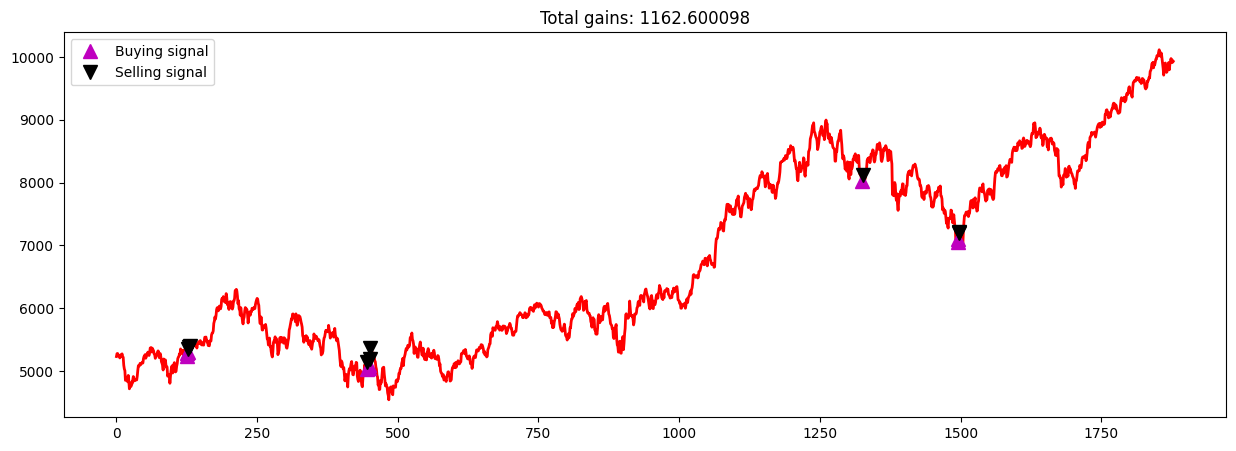

Training in progress...: 100%|██████████| 1878/1878 [05:56<00:00,  5.26it/s]


Running episode 3/10


Training in progress...:   0%|          | 0/1878 [00:00<?, ?it/s]

[[0.         0.         0.14501388]] 2


Training in progress...:   0%|          | 2/1878 [00:00<05:53,  5.31it/s]

[[0.         0.         0.16909076]] 2
[[0.         0.         0.38689407]] 2


Training in progress...:   0%|          | 4/1878 [00:00<05:40,  5.50it/s]

[[0.         0.         0.43605402]] 2
[[0.         0.         0.48132229]] 2


Training in progress...:   0%|          | 6/1878 [00:01<05:39,  5.52it/s]

[[0.         0.         0.31592591]] 2
[[0.         0.         0.32796407]] 2


Training in progress...:   0%|          | 8/1878 [00:01<05:38,  5.53it/s]

[[0.         0.         0.38002558]] 2
[[0.         0.         0.32237313]] 2


Training in progress...:   1%|          | 10/1878 [00:01<05:29,  5.66it/s]

[[0.06191139 0.         0.35376716]] 2
[[0.         0.         0.42983953]] 2


Training in progress...:   1%|          | 12/1878 [00:02<05:32,  5.62it/s]

[[0.        0.        0.6322431]] 2
[[0.00555941 0.         0.64437107]] 2


Training in progress...:   1%|          | 14/1878 [00:02<05:31,  5.62it/s]

[[0.0081666  0.         0.58865169]] 2
[[0.13232527 0.         0.5584028 ]] 2


Training in progress...:   1%|          | 16/1878 [00:02<05:24,  5.74it/s]

[[0.09770772 0.         0.56278895]] 2
[[0.065044   0.         0.33594562]] 2


Training in progress...:   1%|          | 18/1878 [00:03<05:30,  5.62it/s]

[[0.0703296  0.         0.33055954]] 2
[[0.         0.         0.23270426]] 2


Training in progress...:   1%|          | 20/1878 [00:03<05:32,  5.59it/s]

[[0.         0.         0.23288226]] 2
[[0.         0.         0.23007351]] 2


Training in progress...:   1%|          | 22/1878 [00:03<05:28,  5.65it/s]

[[0.         0.         0.22524035]] 2
[[0.         0.         0.28218195]] 2


Training in progress...:   1%|▏         | 24/1878 [00:04<05:33,  5.55it/s]

[[0.         0.         0.13967762]] 2
[[0.         0.         0.21223133]] 2


Training in progress...:   1%|▏         | 26/1878 [00:04<05:30,  5.60it/s]

[[0.         0.         0.13067685]] 2
[[0.01193866 0.         0.23560933]] 2


Training in progress...:   1%|▏         | 28/1878 [00:05<05:18,  5.80it/s]

[[0.01796087 0.         0.21780009]] 2
[[0.         0.         0.19064256]] 2


Training in progress...:   2%|▏         | 30/1878 [00:05<05:25,  5.68it/s]

[[0.05413355 0.         0.40523485]] 2
[[0.        0.        0.2629092]] 2


Training in progress...:   2%|▏         | 32/1878 [00:05<05:20,  5.77it/s]

[[0.         0.         0.15743734]] 2
[[0.15965491 0.         0.30580438]] 2


Training in progress...:   2%|▏         | 34/1878 [00:06<05:19,  5.77it/s]

[[0.18385773 0.         0.34426425]] 2
[[0.10727887 0.         0.33786734]] 2


Training in progress...:   2%|▏         | 36/1878 [00:06<05:25,  5.66it/s]

[[0.03272532 0.         0.24157591]] 2
[[0.12775693 0.         0.24001213]] 2


Training in progress...:   2%|▏         | 38/1878 [00:06<05:26,  5.64it/s]

[[0.00364153 0.         0.32475442]] 2
[[0.04528302 0.         0.34736551]] 2


Training in progress...:   2%|▏         | 39/1878 [00:06<05:37,  5.45it/s]

[[0.         0.         0.21829682]] 2


Training in progress...:   2%|▏         | 41/1878 [00:07<05:53,  5.19it/s]

[[0.         0.         0.13645329]] 2
[[0.         0.         0.30467645]] 2


Training in progress...:   2%|▏         | 42/1878 [00:07<06:10,  4.95it/s]

[[0.         0.         0.29932738]] 2


Training in progress...:   2%|▏         | 44/1878 [00:08<06:18,  4.85it/s]

[[0.         0.         0.33409444]] 2
[[0.         0.         0.58365034]] 2


Training in progress...:   2%|▏         | 45/1878 [00:08<06:40,  4.57it/s]

[[0.         0.         0.75836316]] 2


Training in progress...:   3%|▎         | 47/1878 [00:08<06:28,  4.72it/s]

[[0.         0.         0.55288859]] 2
[[0.         0.         0.48321094]] 2


Training in progress...:   3%|▎         | 48/1878 [00:08<06:37,  4.60it/s]

[[0.        0.        0.5971672]] 2


Training in progress...:   3%|▎         | 49/1878 [00:09<06:50,  4.45it/s]

[[0.         0.         0.35444586]] 2


Training in progress...:   3%|▎         | 51/1878 [00:09<06:40,  4.56it/s]

[[0.        0.        0.5494992]] 2
[[0.         0.         0.49155345]] 2


Training in progress...:   3%|▎         | 52/1878 [00:09<07:04,  4.30it/s]

[[0.         0.         0.61943582]] 2


Training in progress...:   3%|▎         | 53/1878 [00:10<07:11,  4.23it/s]

[[0.         0.         0.59991417]] 2


Training in progress...:   3%|▎         | 54/1878 [00:10<07:23,  4.11it/s]

[[0.         0.         0.63948461]] 2


Training in progress...:   3%|▎         | 55/1878 [00:10<07:21,  4.13it/s]

[[0.        0.        0.6305939]] 2


Training in progress...:   3%|▎         | 56/1878 [00:10<07:29,  4.06it/s]

[[0.         0.         0.59505996]] 2


Training in progress...:   3%|▎         | 57/1878 [00:11<07:36,  3.99it/s]

[[0.19571022 0.         0.70448323]] 2


Training in progress...:   3%|▎         | 59/1878 [00:11<06:55,  4.37it/s]

[[0.04183593 0.         0.7848162 ]] 2
[[0.         0.         0.91344991]] 2


Training in progress...:   3%|▎         | 61/1878 [00:11<06:02,  5.02it/s]

[[5.88561213e-04 0.00000000e+00 7.77001812e-01]] 2
[[0.         0.         0.69092473]] 2


Training in progress...:   3%|▎         | 63/1878 [00:12<05:46,  5.24it/s]

[[0.         0.         0.55262224]] 2
[[0.         0.         0.39096388]] 2


Training in progress...:   3%|▎         | 65/1878 [00:12<05:34,  5.42it/s]

[[0.         0.         0.23237269]] 2
[[0.         0.         0.22226832]] 2


Training in progress...:   4%|▎         | 67/1878 [00:12<05:25,  5.56it/s]

[[0.         0.         0.06182567]] 2
[[0.         0.         0.16096544]] 2


Training in progress...:   4%|▎         | 69/1878 [00:13<05:23,  5.59it/s]

[[0.         0.         0.31082546]] 2
[[0.         0.         0.45436089]] 2


Training in progress...:   4%|▍         | 71/1878 [00:13<05:20,  5.63it/s]

[[0.         0.         0.60956462]] 2
[[0.         0.         0.64770889]] 2


Training in progress...:   4%|▍         | 73/1878 [00:14<05:19,  5.65it/s]

[[0.         0.         0.70171495]] 2
[[0.         0.         0.60143264]] 2


Training in progress...:   4%|▍         | 75/1878 [00:14<05:20,  5.63it/s]

[[0.         0.         0.72760387]] 2
[[0.         0.         0.57044798]] 2


Training in progress...:   4%|▍         | 77/1878 [00:14<05:21,  5.60it/s]

[[0.         0.         0.39793935]] 2
[[0.         0.         0.50954665]] 2


Training in progress...:   4%|▍         | 79/1878 [00:15<05:23,  5.57it/s]

[[0.         0.         0.36326465]] 2
[[0.         0.         0.39629077]] 2


Training in progress...:   4%|▍         | 81/1878 [00:15<05:24,  5.54it/s]

[[0.         0.         0.66900188]] 2
[[0.         0.         0.49811807]] 2


Training in progress...:   4%|▍         | 83/1878 [00:15<05:19,  5.63it/s]

[[0.         0.         0.46661023]] 2
[[0.         0.         0.58966339]] 2


Training in progress...:   5%|▍         | 85/1878 [00:16<05:21,  5.58it/s]

[[0.        0.        0.6220464]] 2
[[0.         0.00907049 0.60795954]] 2


Training in progress...:   5%|▍         | 87/1878 [00:16<05:24,  5.52it/s]

[[0.         0.         0.61900473]] 2
[[0.         0.         0.57208527]] 2


Training in progress...:   5%|▍         | 89/1878 [00:16<05:27,  5.46it/s]

[[0.         0.         0.50451069]] 2
[[0.         0.08001729 0.44004792]] 2


Training in progress...:   5%|▍         | 91/1878 [00:17<05:24,  5.50it/s]

[[0.         0.         0.46585481]] 2
[[0.         0.         0.32680282]] 2


Training in progress...:   5%|▍         | 93/1878 [00:17<05:26,  5.47it/s]

[[0.         0.         0.21986082]] 2
[[0.         0.         0.26671904]] 2


Training in progress...:   5%|▌         | 95/1878 [00:18<05:16,  5.63it/s]

[[0.         0.         0.16542728]] 2
[[0.         0.         0.18867324]] 2


Training in progress...:   5%|▌         | 97/1878 [00:18<05:15,  5.64it/s]

[[0.02018126 0.         0.20737101]] 2
[[0.         0.         0.17943449]] 2


Training in progress...:   5%|▌         | 99/1878 [00:18<05:15,  5.63it/s]

[[0.         0.         0.12199247]] 2
[[0.         0.         0.23373177]] 2


Training in progress...:   5%|▌         | 101/1878 [00:19<05:08,  5.76it/s]

[[0.         0.         0.37836565]] 2
[[0.04792592 0.         0.40530311]] 2


Training in progress...:   5%|▌         | 103/1878 [00:19<05:17,  5.59it/s]

[[0.         0.         0.35450444]] 2
[[0.         0.         0.34573564]] 2


Training in progress...:   6%|▌         | 105/1878 [00:19<05:12,  5.67it/s]

[[0.         0.         0.07409285]] 2
[[0.         0.         0.15182597]] 2


Training in progress...:   6%|▌         | 107/1878 [00:20<05:12,  5.66it/s]

[[0.       0.       0.217455]] 2
[[0.         0.         0.40351438]] 2


Training in progress...:   6%|▌         | 109/1878 [00:20<05:09,  5.71it/s]

[[0.         0.         0.48737364]] 2
[[0.         0.         0.45679477]] 2


Training in progress...:   6%|▌         | 111/1878 [00:20<05:11,  5.67it/s]

[[0.01719518 0.         0.45626536]] 2
[[0.         0.         0.58735247]] 2


Training in progress...:   6%|▌         | 113/1878 [00:21<05:20,  5.50it/s]

[[0.02777349 0.         0.48687933]] 2
[[0.00994541 0.         0.5159944 ]] 2


Training in progress...:   6%|▌         | 114/1878 [00:21<05:50,  5.04it/s]

[[0.         0.         0.47798343]] 2


Training in progress...:   6%|▌         | 115/1878 [00:21<06:14,  4.71it/s]

[[0.         0.         0.25824206]] 2


Training in progress...:   6%|▌         | 116/1878 [00:21<06:22,  4.61it/s]

[[0.         0.         0.24281574]] 2


Training in progress...:   6%|▌         | 117/1878 [00:22<06:18,  4.65it/s]

[[0.         0.         0.24385591]] 2


Training in progress...:   6%|▋         | 119/1878 [00:22<06:16,  4.67it/s]

[[0.         0.         0.18959392]] 2
[[0.        0.        0.3074417]] 2


Training in progress...:   6%|▋         | 120/1878 [00:22<06:28,  4.52it/s]

[[0.       0.       0.356819]] 2


Training in progress...:   6%|▋         | 121/1878 [00:23<06:34,  4.45it/s]

[[0.         0.         0.18717031]] 2


Training in progress...:   7%|▋         | 123/1878 [00:23<06:40,  4.38it/s]

[[0.         0.         0.15136286]] 2
[[0.         0.         0.15719577]] 2


Training in progress...:   7%|▋         | 124/1878 [00:23<06:33,  4.46it/s]

[[0.         0.         0.20509933]] 2


Training in progress...:   7%|▋         | 125/1878 [00:23<06:42,  4.35it/s]

[[0.         0.         0.18564107]] 2


Training in progress...:   7%|▋         | 126/1878 [00:24<06:51,  4.26it/s]

[[0.         0.         0.22400851]] 2


Training in progress...:   7%|▋         | 127/1878 [00:24<06:57,  4.19it/s]

[[0.         0.         0.52755082]] 2


Training in progress...:   7%|▋         | 128/1878 [00:24<06:55,  4.21it/s]

[[0.         0.         0.52412826]] 2


Training in progress...:   7%|▋         | 129/1878 [00:24<07:03,  4.13it/s]

[[0.         0.         0.31766319]] 2


Training in progress...:   7%|▋         | 131/1878 [00:25<06:45,  4.31it/s]

[[0.         0.         0.34999677]] 2
[[0.         0.         0.43270901]] 2


Training in progress...:   7%|▋         | 133/1878 [00:25<05:57,  4.88it/s]

[[0.         0.         0.35351975]] 2
[[0.         0.         0.56768051]] 2


Training in progress...:   7%|▋         | 135/1878 [00:26<05:36,  5.18it/s]

[[0.         0.         0.50525531]] 2
[[0.         0.         0.32850905]] 2


Training in progress...:   7%|▋         | 137/1878 [00:26<05:17,  5.48it/s]

[[0.         0.         0.51022125]] 2
[[0.         0.0065166  0.59968825]] 2


Training in progress...:   7%|▋         | 139/1878 [00:26<05:06,  5.68it/s]

[[0.        0.        0.5926593]] 2
[[0.         0.         0.69235173]] 2


Training in progress...:   8%|▊         | 141/1878 [00:27<05:11,  5.57it/s]

[[0.         0.01273703 0.51905396]] 2
[[0.         0.         0.51491372]] 2


Training in progress...:   8%|▊         | 143/1878 [00:27<05:06,  5.65it/s]

[[0.         0.         0.51347908]] 2
[[0.         0.         0.44960442]] 2


Training in progress...:   8%|▊         | 145/1878 [00:27<05:00,  5.76it/s]

[[0.         0.         0.34633344]] 2
[[0.         0.         0.38343657]] 2


Training in progress...:   8%|▊         | 147/1878 [00:28<05:04,  5.68it/s]

[[0.         0.         0.47723624]] 2
[[0.         0.         0.56805634]] 2


Training in progress...:   8%|▊         | 149/1878 [00:28<05:14,  5.50it/s]

[[0.        0.        0.3944029]] 2
[[0.         0.         0.47829602]] 2


Training in progress...:   8%|▊         | 151/1878 [00:28<05:11,  5.55it/s]

[[0.         0.         0.52853723]] 2
[[0.         0.         0.37739043]] 2


Training in progress...:   8%|▊         | 153/1878 [00:29<05:12,  5.52it/s]

[[0.01232454 0.         0.38115163]] 2
[[0.08394965 0.         0.50409599]] 2


Training in progress...:   8%|▊         | 155/1878 [00:29<05:09,  5.58it/s]

[[0.04744679 0.         0.40174687]] 2
[[0.         0.         0.33673555]] 2


Training in progress...:   8%|▊         | 157/1878 [00:30<05:07,  5.59it/s]

[[0.         0.         0.53193937]] 2
[[0.        0.        0.5018004]] 2


Training in progress...:   8%|▊         | 159/1878 [00:30<05:05,  5.63it/s]

[[0.         0.00915875 0.65943656]] 2
[[0.07914747 0.         0.6024923 ]] 2


Training in progress...:   9%|▊         | 161/1878 [00:30<05:06,  5.61it/s]

[[0.12377897 0.         0.56733202]] 2
[[0.        0.        0.4474189]] 2


Training in progress...:   9%|▊         | 163/1878 [00:31<05:14,  5.46it/s]

[[0.02583617 0.         0.5396602 ]] 2
[[0.13441831 0.         0.66516221]] 2


Training in progress...:   9%|▉         | 165/1878 [00:31<05:11,  5.51it/s]

[[0.05793637 0.         0.64108498]] 2
[[0.         0.         0.70998964]] 2


Training in progress...:   9%|▉         | 167/1878 [00:31<05:07,  5.56it/s]

[[0.         0.         0.60514386]] 2
[[0.        0.        0.4270568]] 2


Training in progress...:   9%|▉         | 169/1878 [00:32<05:11,  5.49it/s]

[[0.         0.         0.33415572]] 2
[[0.         0.03464607 0.33827534]] 2


Training in progress...:   9%|▉         | 171/1878 [00:32<05:02,  5.64it/s]

[[0.         0.         0.30621267]] 2
[[0.         0.00560179 0.24839669]] 2


Training in progress...:   9%|▉         | 173/1878 [00:32<05:00,  5.67it/s]

[[0.         0.         0.26728633]] 2
[[0.03212591 0.         0.16619054]] 2


Training in progress...:   9%|▉         | 175/1878 [00:33<05:07,  5.54it/s]

[[0.         0.         0.23165715]] 2
[[0.15298269 0.         0.18166652]] 2


Training in progress...:   9%|▉         | 177/1878 [00:33<04:59,  5.67it/s]

[[0.06440007 0.         0.35747194]] 2
[[0.10899782 0.         0.3709687 ]] 2


Training in progress...:  10%|▉         | 179/1878 [00:34<05:00,  5.66it/s]

[[0.09729205 0.         0.34177758]] 2
[[0.02963905 0.         0.24023876]] 2


Training in progress...:  10%|▉         | 181/1878 [00:34<05:07,  5.52it/s]

[[0.         0.         0.26013432]] 2
[[0.         0.         0.34104866]] 2


Training in progress...:  10%|▉         | 183/1878 [00:34<04:58,  5.67it/s]

[[0.         0.         0.18534085]] 2
[[0.         0.         0.19718093]] 2


Training in progress...:  10%|▉         | 185/1878 [00:35<05:00,  5.64it/s]

[[0.        0.        0.2396252]] 2
[[0.         0.         0.33856493]] 2


Training in progress...:  10%|▉         | 186/1878 [00:35<05:11,  5.43it/s]

[[0.         0.         0.45864075]] 2


Training in progress...:  10%|▉         | 187/1878 [00:35<05:38,  5.00it/s]

[[0.         0.         0.53281611]] 2


Training in progress...:  10%|█         | 188/1878 [00:35<05:47,  4.86it/s]

[[0.         0.         0.47268836]] 2


Training in progress...:  10%|█         | 189/1878 [00:35<05:54,  4.76it/s]

[[0.         0.         0.38376261]] 2


Training in progress...:  10%|█         | 191/1878 [00:36<06:02,  4.66it/s]

[[0.03856391 0.         0.22272185]] 2
[[0.03596836 0.         0.3070854 ]] 2


Training in progress...:  10%|█         | 192/1878 [00:36<06:06,  4.60it/s]

[[0.21320455 0.         0.35051317]] 2


Training in progress...:  10%|█         | 193/1878 [00:36<06:09,  4.56it/s]

[[0.31321586 0.         0.4359518 ]] 2


Training in progress...:  10%|█         | 194/1878 [00:37<06:17,  4.47it/s]

[[0.13139022 0.         0.53978132]] 2


Training in progress...:  10%|█         | 195/1878 [00:37<06:21,  4.41it/s]

[[0.01762691 0.         0.34474036]] 2


Training in progress...:  10%|█         | 196/1878 [00:37<06:12,  4.51it/s]

[[0.08919748 0.         0.2648761 ]] 2


Training in progress...:  10%|█         | 197/1878 [00:37<06:17,  4.45it/s]

[[0.09186962 0.         0.42316819]] 2


Training in progress...:  11%|█         | 198/1878 [00:38<06:24,  4.37it/s]

[[0.1184709  0.         0.45840138]] 2


Training in progress...:  11%|█         | 199/1878 [00:38<06:27,  4.33it/s]

[[0.09040558 0.         0.3957333 ]] 2


Training in progress...:  11%|█         | 200/1878 [00:38<06:42,  4.17it/s]

[[0.         0.         0.28390848]] 2


Training in progress...:  11%|█         | 201/1878 [00:38<06:46,  4.13it/s]

[[0.06426077 0.         0.16454229]] 2


Training in progress...:  11%|█         | 202/1878 [00:38<06:38,  4.21it/s]

[[0.13470293 0.         0.19890927]] 2


Training in progress...:  11%|█         | 203/1878 [00:39<07:00,  3.98it/s]

[[0.05963168 0.         0.30020549]] 2


Training in progress...:  11%|█         | 205/1878 [00:39<06:13,  4.48it/s]

[[0.01539883 0.         0.32546725]] 2
[[0.01145611 0.         0.28730568]] 2


Training in progress...:  11%|█         | 207/1878 [00:40<05:31,  5.04it/s]

[[0.         0.         0.35093897]] 2
[[0.         0.         0.29227772]] 2


Training in progress...:  11%|█         | 209/1878 [00:40<05:15,  5.28it/s]

[[0.         0.         0.25037998]] 2
[[0.         0.         0.34043516]] 2


Training in progress...:  11%|█         | 211/1878 [00:40<05:09,  5.38it/s]

[[0.06082972 0.         0.44227797]] 2
[[0.00885497 0.         0.54284555]] 2


Training in progress...:  11%|█▏        | 213/1878 [00:41<05:01,  5.52it/s]

[[0.11331371 0.         0.47142127]] 2
[[0.02586014 0.         0.63740861]] 2


Training in progress...:  11%|█▏        | 215/1878 [00:41<05:08,  5.39it/s]

[[0.04277404 0.         0.45945199]] 2
[[0.15125396 0.         0.50606481]] 2


Training in progress...:  12%|█▏        | 217/1878 [00:41<04:58,  5.57it/s]

[[0.19439836 0.         0.53185829]] 2
[[0.18744118 0.         0.40107734]] 2


Training in progress...:  12%|█▏        | 219/1878 [00:42<05:02,  5.48it/s]

[[0.         0.         0.29713265]] 2
[[0.         0.         0.34213373]] 2


Training in progress...:  12%|█▏        | 221/1878 [00:42<05:06,  5.41it/s]

[[0.         0.         0.31072919]] 2
[[0.         0.         0.33458256]] 2


Training in progress...:  12%|█▏        | 223/1878 [00:42<05:03,  5.46it/s]

[[0.         0.         0.33585258]] 2
[[0.         0.         0.47969044]] 2


Training in progress...:  12%|█▏        | 225/1878 [00:43<05:02,  5.46it/s]

[[0.         0.         0.58660576]] 2
[[0.         0.         0.45695035]] 2


Training in progress...:  12%|█▏        | 227/1878 [00:43<04:56,  5.56it/s]

[[0.        0.        0.3612567]] 2
[[0.         0.         0.34495638]] 2


Training in progress...:  12%|█▏        | 229/1878 [00:44<04:58,  5.53it/s]

[[0.         0.         0.63776217]] 2
[[0.0077359  0.         0.57260793]] 2


Training in progress...:  12%|█▏        | 231/1878 [00:44<04:54,  5.60it/s]

[[0.         0.         0.51735663]] 2
[[0.         0.         0.59328199]] 2


Training in progress...:  12%|█▏        | 233/1878 [00:44<04:56,  5.54it/s]

[[0.         0.         0.51517204]] 2
[[0.02642445 0.         0.60480381]] 2


Training in progress...:  13%|█▎        | 235/1878 [00:45<04:47,  5.71it/s]

[[0.01986504 0.         0.59630274]] 2
[[0.10757696 0.         0.7694396 ]] 2


Training in progress...:  13%|█▎        | 237/1878 [00:45<04:48,  5.69it/s]

[[0.03205558 0.         0.62218962]] 2
[[0.         0.         0.67905887]] 2


Training in progress...:  13%|█▎        | 239/1878 [00:45<04:54,  5.57it/s]

[[0.         0.         0.56893429]] 2
[[0.00147886 0.         0.49737755]] 2


Training in progress...:  13%|█▎        | 241/1878 [00:46<04:51,  5.61it/s]

[[0.        0.        0.5276249]] 2
[[0.         0.         0.44430502]] 2


Training in progress...:  13%|█▎        | 243/1878 [00:46<04:47,  5.69it/s]

[[0.         0.         0.59446301]] 2
[[0.         0.         0.54062131]] 2


Training in progress...:  13%|█▎        | 245/1878 [00:46<04:52,  5.59it/s]

[[0.         0.         0.50060858]] 2
[[0.         0.         0.40702483]] 2


Training in progress...:  13%|█▎        | 247/1878 [00:47<04:51,  5.60it/s]

[[0.         0.         0.35127474]] 2
[[0.         0.         0.55474187]] 2


Training in progress...:  13%|█▎        | 248/1878 [00:47<05:03,  5.36it/s]

[[0.        0.        0.5841557]] 2


Training in progress...:  13%|█▎        | 249/1878 [00:47<05:15,  5.16it/s]

[[0.         0.         0.55774494]] 2


Training in progress...:  13%|█▎        | 251/1878 [00:48<05:13,  5.19it/s]

[[0.         0.         0.45349304]] 2
[[0.         0.         0.39699128]] 2


Training in progress...:  13%|█▎        | 253/1878 [00:48<05:02,  5.37it/s]

[[0.         0.         0.40184601]] 2
[[0.         0.         0.39742882]] 2


Training in progress...:  14%|█▎        | 255/1878 [00:48<04:58,  5.43it/s]

[[0.         0.         0.46719904]] 2
[[0.         0.         0.37306461]] 2


Training in progress...:  14%|█▎        | 257/1878 [00:49<04:58,  5.44it/s]

[[0.         0.         0.36420638]] 2
[[0.         0.         0.20592982]] 2


Training in progress...:  14%|█▎        | 258/1878 [00:49<05:04,  5.32it/s]

[[0.         0.         0.07895101]] 2


Training in progress...:  14%|█▍        | 259/1878 [00:49<05:36,  4.81it/s]

[[0.10378484 0.         0.23924121]] 2


Training in progress...:  14%|█▍        | 260/1878 [00:49<05:57,  4.53it/s]

[[0.09126759 0.         0.19804406]] 2


Training in progress...:  14%|█▍        | 261/1878 [00:50<05:56,  4.53it/s]

[[0.         0.         0.32724343]] 2


Training in progress...:  14%|█▍        | 262/1878 [00:50<06:02,  4.46it/s]

[[0.         0.         0.37543066]] 2


Training in progress...:  14%|█▍        | 263/1878 [00:50<05:55,  4.54it/s]

[[0.         0.         0.35170292]] 2


Training in progress...:  14%|█▍        | 264/1878 [00:50<06:13,  4.32it/s]

[[0.         0.         0.42994004]] 2


Training in progress...:  14%|█▍        | 265/1878 [00:50<06:07,  4.39it/s]

[[0.         0.         0.40801563]] 2


Training in progress...:  14%|█▍        | 266/1878 [00:51<06:18,  4.26it/s]

[[0.         0.         0.38443534]] 2


Training in progress...:  14%|█▍        | 267/1878 [00:51<06:19,  4.24it/s]

[[0.         0.         0.29440517]] 2


Training in progress...:  14%|█▍        | 268/1878 [00:51<06:22,  4.20it/s]

[[0.         0.         0.33562552]] 2


Training in progress...:  14%|█▍        | 269/1878 [00:51<06:27,  4.15it/s]

[[0.         0.         0.45297902]] 2


Training in progress...:  14%|█▍        | 270/1878 [00:52<06:35,  4.06it/s]

[[0.        0.        0.4518241]] 2


Training in progress...:  14%|█▍        | 271/1878 [00:52<06:37,  4.05it/s]

[[0.         0.         0.52002339]] 2


Training in progress...:  14%|█▍        | 272/1878 [00:52<06:38,  4.03it/s]

[[0.         0.         0.56521522]] 2


Training in progress...:  15%|█▍        | 273/1878 [00:52<06:44,  3.97it/s]

[[0.         0.         0.52005012]] 2


Training in progress...:  15%|█▍        | 274/1878 [00:53<06:44,  3.96it/s]

[[0.         0.         0.52879072]] 2


Training in progress...:  15%|█▍        | 276/1878 [00:53<06:09,  4.34it/s]

[[0.         0.         0.34761019]] 2
[[0.         0.         0.30555146]] 2


Training in progress...:  15%|█▍        | 278/1878 [00:54<05:27,  4.89it/s]

[[0.         0.         0.23514875]] 2
[[0.         0.08389245 0.25406664]] 2


Training in progress...:  15%|█▍        | 280/1878 [00:54<05:03,  5.26it/s]

[[0.         0.         0.32985392]] 2
[[0.         0.         0.20689156]] 2


Training in progress...:  15%|█▌        | 282/1878 [00:54<04:48,  5.53it/s]

[[0.         0.         0.23358252]] 2
[[0.         0.05482434 0.15553162]] 2


Training in progress...:  15%|█▌        | 284/1878 [00:55<04:51,  5.47it/s]

[[0.         0.01154919 0.00026204]] 1
[[0.         0.         0.23699511]] 2


Training in progress...:  15%|█▌        | 286/1878 [00:55<04:48,  5.52it/s]

[[0.00223592 0.         0.49035754]] 2
[[0.0114031  0.         0.48202455]] 2


Training in progress...:  15%|█▌        | 288/1878 [00:55<04:47,  5.53it/s]

[[0.         0.         0.49426565]] 2
[[0.         0.         0.57459534]] 2


Training in progress...:  15%|█▌        | 290/1878 [00:56<04:54,  5.40it/s]

[[0.         0.         0.64405877]] 2
[[0.         0.         0.77309093]] 2


Training in progress...:  16%|█▌        | 292/1878 [00:56<04:48,  5.50it/s]

[[0.         0.         0.73807905]] 2
[[0.         0.         0.73880541]] 2


Training in progress...:  16%|█▌        | 294/1878 [00:56<04:44,  5.56it/s]

[[0.         0.         0.54941779]] 2
[[0.08057104 0.         0.35159985]] 2


Training in progress...:  16%|█▌        | 296/1878 [00:57<04:44,  5.56it/s]

[[0.13822047 0.         0.50463245]] 2
[[0.1026381  0.         0.44051108]] 2


Training in progress...:  16%|█▌        | 298/1878 [00:57<04:43,  5.56it/s]

[[0.02025813 0.         0.37676257]] 2
[[0.02814971 0.         0.46680634]] 2


Training in progress...:  16%|█▌        | 300/1878 [00:58<04:44,  5.54it/s]

[[0.         0.         0.39296642]] 2
[[0.         0.         0.37337733]] 2


Training in progress...:  16%|█▌        | 302/1878 [00:58<04:43,  5.56it/s]

[[0.         0.         0.50394429]] 2
[[0.         0.         0.48399838]] 2


Training in progress...:  16%|█▌        | 304/1878 [00:58<04:38,  5.65it/s]

[[0.         0.         0.59884064]] 2
[[0.         0.         0.51410994]] 2


Training in progress...:  16%|█▋        | 306/1878 [00:59<04:43,  5.55it/s]

[[0.         0.         0.59523985]] 2
[[0.         0.         0.57560293]] 2


Training in progress...:  16%|█▋        | 308/1878 [00:59<04:39,  5.62it/s]

[[0.         0.         0.66590318]] 2
[[0.         0.         0.47999527]] 2


Training in progress...:  17%|█▋        | 310/1878 [00:59<04:34,  5.71it/s]

[[0.         0.         0.50787178]] 2
[[0.         0.         0.56514199]] 2


Training in progress...:  17%|█▋        | 312/1878 [01:00<04:42,  5.55it/s]

[[0.        0.        0.5969199]] 2
[[0.         0.         0.64965204]] 2


Training in progress...:  17%|█▋        | 314/1878 [01:00<04:41,  5.55it/s]

[[0.         0.         0.63733919]] 2
[[0.         0.         0.86463631]] 2


Training in progress...:  17%|█▋        | 316/1878 [01:00<04:37,  5.62it/s]

[[0.         0.         0.72862654]] 2
[[0.         0.         0.43054734]] 2


Training in progress...:  17%|█▋        | 318/1878 [01:01<04:49,  5.39it/s]

[[0.         0.         0.44440318]] 2
[[0.         0.         0.50760213]] 2


Training in progress...:  17%|█▋        | 320/1878 [01:01<04:46,  5.44it/s]

[[0.         0.         0.49877466]] 2
[[0.         0.         0.54857799]] 2


Training in progress...:  17%|█▋        | 322/1878 [01:01<04:42,  5.50it/s]

[[0.         0.         0.29456802]] 2
[[0.        0.        0.1215895]] 2


Training in progress...:  17%|█▋        | 324/1878 [01:02<04:42,  5.50it/s]

[[0.         0.         0.30470885]] 2
[[0.04903039 0.         0.28913295]] 2


Training in progress...:  17%|█▋        | 326/1878 [01:02<04:39,  5.56it/s]

[[0.07357525 0.         0.26547584]] 2
[[0.02516765 0.         0.29956545]] 2


Training in progress...:  17%|█▋        | 328/1878 [01:03<04:31,  5.70it/s]

[[0.         0.         0.12086422]] 2
[[0.         0.         0.34043852]] 2


Training in progress...:  18%|█▊        | 330/1878 [01:03<04:40,  5.53it/s]

[[0.         0.         0.26019668]] 2
[[0.         0.         0.23504092]] 2


Training in progress...:  18%|█▊        | 331/1878 [01:03<05:10,  4.97it/s]

[[0.         0.         0.16517601]] 2


Training in progress...:  18%|█▊        | 332/1878 [01:03<05:19,  4.83it/s]

[[0. 0. 0.]] 0


Training in progress...:  18%|█▊        | 333/1878 [01:04<05:22,  4.79it/s]

[[0.         0.         0.21593051]] 2


Training in progress...:  18%|█▊        | 334/1878 [01:04<05:37,  4.58it/s]

[[0.        0.        0.3040202]] 2


Training in progress...:  18%|█▊        | 335/1878 [01:04<05:34,  4.62it/s]

[[0.        0.        0.3517478]] 2


Training in progress...:  18%|█▊        | 336/1878 [01:04<05:30,  4.66it/s]

[[0.        0.        0.2616052]] 2


Training in progress...:  18%|█▊        | 337/1878 [01:04<05:35,  4.59it/s]

[[0.         0.         0.40437208]] 2


Training in progress...:  18%|█▊        | 338/1878 [01:05<05:38,  4.55it/s]

[[0.         0.         0.44755638]] 2


Training in progress...:  18%|█▊        | 340/1878 [01:05<05:35,  4.58it/s]

[[0.04615244 0.         0.48441593]] 2
[[0.        0.        0.5417893]] 2


Training in progress...:  18%|█▊        | 341/1878 [01:05<05:52,  4.36it/s]

[[0.         0.         0.28304414]] 2


Training in progress...:  18%|█▊        | 342/1878 [01:06<06:10,  4.15it/s]

[[0.00803664 0.         0.32314061]] 2


Training in progress...:  18%|█▊        | 343/1878 [01:06<06:17,  4.07it/s]

[[0.01346629 0.         0.5246314 ]] 2


Training in progress...:  18%|█▊        | 344/1878 [01:06<06:17,  4.06it/s]

[[0.         0.         0.47635691]] 2


Training in progress...:  18%|█▊        | 345/1878 [01:06<06:08,  4.16it/s]

[[0.         0.         0.36841509]] 2


Training in progress...:  18%|█▊        | 346/1878 [01:07<06:42,  3.80it/s]

[[0.         0.         0.17537118]] 2


Training in progress...:  19%|█▊        | 348/1878 [01:07<06:01,  4.24it/s]

[[0.        0.        0.2252967]] 2
[[0.         0.         0.29268808]] 2


Training in progress...:  19%|█▊        | 350/1878 [01:08<05:12,  4.88it/s]

[[0.         0.         0.40348597]] 2
[[0.         0.         0.17755349]] 2


Training in progress...:  19%|█▊        | 352/1878 [01:08<04:50,  5.24it/s]

[[0.         0.         0.05784425]] 2
[[0.         0.         0.07249606]] 2


Training in progress...:  19%|█▉        | 354/1878 [01:08<04:37,  5.49it/s]

[[0.         0.         0.02386858]] 2
[[0.         0.         0.17199069]] 2


Training in progress...:  19%|█▉        | 356/1878 [01:09<04:36,  5.50it/s]

[[0.00995012 0.         0.21142435]] 2
[[0.         0.         0.17515523]] 2


Training in progress...:  19%|█▉        | 358/1878 [01:09<04:44,  5.35it/s]

[[0.         0.         0.21545133]] 2
[[0.         0.         0.28078127]] 2


Training in progress...:  19%|█▉        | 360/1878 [01:09<04:31,  5.59it/s]

[[0.         0.         0.34950469]] 2
[[0.         0.         0.45650444]] 2


Training in progress...:  19%|█▉        | 362/1878 [01:10<04:38,  5.44it/s]

[[0.         0.         0.40681346]] 2
[[0.         0.         0.41962695]] 2


Training in progress...:  19%|█▉        | 364/1878 [01:10<04:39,  5.42it/s]

[[0.         0.         0.57058367]] 2
[[0.         0.         0.52402368]] 2


Training in progress...:  19%|█▉        | 366/1878 [01:10<04:35,  5.49it/s]

[[0.         0.         0.51743513]] 2
[[0.         0.         0.46999673]] 2


Training in progress...:  20%|█▉        | 368/1878 [01:11<04:36,  5.46it/s]

[[0.         0.         0.33794322]] 2
[[0.         0.         0.44675128]] 2


Training in progress...:  20%|█▉        | 370/1878 [01:11<04:40,  5.39it/s]

[[0.         0.         0.33730149]] 2
[[0.        0.        0.4407855]] 2


Training in progress...:  20%|█▉        | 372/1878 [01:12<04:32,  5.53it/s]

[[0.         0.         0.48333817]] 2
[[0.         0.         0.41048092]] 2


Training in progress...:  20%|█▉        | 374/1878 [01:12<04:31,  5.54it/s]

[[0.         0.         0.46607605]] 2
[[0.         0.         0.28264253]] 2


Training in progress...:  20%|██        | 376/1878 [01:12<04:32,  5.52it/s]

[[0.        0.        0.3991451]] 2
[[0.         0.         0.45880466]] 2


Training in progress...:  20%|██        | 378/1878 [01:13<04:33,  5.49it/s]

[[0.         0.         0.38401258]] 2
[[0.         0.         0.35872099]] 2


Training in progress...:  20%|██        | 380/1878 [01:13<04:30,  5.55it/s]

[[0.         0.         0.35103517]] 2
[[0.         0.         0.05207708]] 2


Training in progress...:  20%|██        | 382/1878 [01:13<04:28,  5.57it/s]

[[0. 0. 0.]] 0
[[0.         0.         0.06181094]] 2


Training in progress...:  20%|██        | 384/1878 [01:14<04:29,  5.54it/s]

[[0.        0.        0.1002518]] 2
[[0.         0.         0.14733314]] 2


Training in progress...:  21%|██        | 386/1878 [01:14<04:23,  5.66it/s]

[[0.        0.        0.1881147]] 2
[[0.         0.02088306 0.52721916]] 2


Training in progress...:  21%|██        | 388/1878 [01:14<04:27,  5.57it/s]

[[0.         0.05204963 0.49109662]] 2
[[0.        0.        0.4314019]] 2


Training in progress...:  21%|██        | 390/1878 [01:15<04:28,  5.53it/s]

[[0.         0.         0.46072787]] 2
[[0.08006382 0.         0.46501393]] 2


Training in progress...:  21%|██        | 392/1878 [01:15<04:23,  5.63it/s]

[[0.17686664 0.         0.42824796]] 2
[[0.         0.         0.44611981]] 2


Training in progress...:  21%|██        | 394/1878 [01:15<04:21,  5.67it/s]

[[0.         0.         0.47325101]] 2
[[0.        0.        0.4303592]] 2


Training in progress...:  21%|██        | 396/1878 [01:16<04:25,  5.59it/s]

[[0.         0.         0.26711872]] 2
[[0.        0.        0.3534586]] 2


Training in progress...:  21%|██        | 398/1878 [01:16<04:25,  5.58it/s]

[[0.         0.00192039 0.30329268]] 2
[[0.         0.09915718 0.28906546]] 2


Training in progress...:  21%|██▏       | 400/1878 [01:17<04:23,  5.62it/s]

[[0.         0.16591846 0.25810171]] 2
[[0.         0.13428453 0.38288988]] 2


Training in progress...:  21%|██▏       | 402/1878 [01:17<04:27,  5.52it/s]

[[0.         0.         0.51616762]] 2
[[0.         0.         0.33925816]] 2


Training in progress...:  21%|██▏       | 403/1878 [01:17<04:50,  5.08it/s]

[[0.       0.       0.386583]] 2


Training in progress...:  22%|██▏       | 404/1878 [01:17<05:10,  4.75it/s]

[[0.12025819 0.         0.37899939]] 2


Training in progress...:  22%|██▏       | 405/1878 [01:18<05:17,  4.63it/s]

[[0.00337918 0.         0.42083999]] 2


Training in progress...:  22%|██▏       | 406/1878 [01:18<05:18,  4.62it/s]

[[0.         0.         0.28846367]] 2


Training in progress...:  22%|██▏       | 407/1878 [01:18<05:17,  4.64it/s]

[[0.         0.         0.47991977]] 2


Training in progress...:  22%|██▏       | 408/1878 [01:18<05:26,  4.50it/s]

[[0.         0.         0.61925233]] 2


Training in progress...:  22%|██▏       | 409/1878 [01:19<05:25,  4.51it/s]

[[0.16257987 0.         0.61215819]] 2


Training in progress...:  22%|██▏       | 410/1878 [01:19<05:40,  4.31it/s]

[[0.1300162  0.04068798 0.57542167]] 2


Training in progress...:  22%|██▏       | 412/1878 [01:19<05:23,  4.53it/s]

[[0.1123112  0.04781087 0.56113011]] 2
[[0.12817387 0.00896988 0.51962308]] 2


Training in progress...:  22%|██▏       | 413/1878 [01:19<05:43,  4.26it/s]

[[0.221688   0.         0.64702827]] 2


Training in progress...:  22%|██▏       | 414/1878 [01:20<05:50,  4.17it/s]

[[0.20680799 0.05751333 0.59529303]] 2


Training in progress...:  22%|██▏       | 415/1878 [01:20<05:54,  4.12it/s]

[[0.13322192 0.01353886 0.55741424]] 2


Training in progress...:  22%|██▏       | 416/1878 [01:20<05:57,  4.08it/s]

[[0.         0.         0.55405761]] 2


Training in progress...:  22%|██▏       | 417/1878 [01:20<05:58,  4.07it/s]

[[0.         0.         0.61034741]] 2


Training in progress...:  22%|██▏       | 418/1878 [01:21<06:03,  4.02it/s]

[[0.05676327 0.         0.69293082]] 2


Training in progress...:  22%|██▏       | 420/1878 [01:21<05:45,  4.21it/s]

[[0.         0.         0.62078743]] 2
[[0.         0.         0.51740531]] 2


Training in progress...:  22%|██▏       | 422/1878 [01:22<05:04,  4.78it/s]

[[0.         0.         0.65680167]] 2
[[0.         0.         0.72259779]] 2


Training in progress...:  23%|██▎       | 424/1878 [01:22<04:40,  5.19it/s]

[[0.         0.         0.61487861]] 2
[[0.         0.         0.58751002]] 2


Training in progress...:  23%|██▎       | 426/1878 [01:22<04:28,  5.42it/s]

[[0.         0.         0.56181066]] 2
[[0.         0.         0.61196064]] 2


Training in progress...:  23%|██▎       | 428/1878 [01:23<04:39,  5.18it/s]

[[0.         0.         0.54596877]] 2
[[0.         0.         0.71007733]] 2


Training in progress...:  23%|██▎       | 430/1878 [01:23<04:24,  5.47it/s]

[[0.        0.        0.7672752]] 2
[[0.         0.         0.54579923]] 2


Training in progress...:  23%|██▎       | 432/1878 [01:23<04:31,  5.33it/s]

[[0.         0.         0.58422636]] 2
[[0.         0.         0.50129966]] 2


Training in progress...:  23%|██▎       | 434/1878 [01:24<04:32,  5.31it/s]

[[0.         0.         0.49896227]] 2
[[0.         0.         0.61312596]] 2


Training in progress...:  23%|██▎       | 436/1878 [01:24<04:21,  5.52it/s]

[[0.         0.         0.77187108]] 2
[[0.         0.         0.85985237]] 2


Training in progress...:  23%|██▎       | 438/1878 [01:24<04:14,  5.66it/s]

[[0.        0.        0.6482021]] 2
[[0.         0.         0.49799566]] 2


Training in progress...:  23%|██▎       | 440/1878 [01:25<04:18,  5.56it/s]

[[0.         0.         0.55809676]] 2
[[0.        0.        0.4926863]] 2


Training in progress...:  24%|██▎       | 442/1878 [01:25<04:12,  5.68it/s]

[[0.         0.         0.32586842]] 2
[[0.         0.         0.31139857]] 2


Training in progress...:  24%|██▎       | 444/1878 [01:26<04:13,  5.65it/s]

[[0.         0.         0.21442206]] 2
[[0.         0.         0.26683347]] 2


Training in progress...:  24%|██▎       | 446/1878 [01:26<04:16,  5.58it/s]

[[0.         0.         0.30992841]] 2
[[0.        0.        0.2890624]] 2


Training in progress...:  24%|██▍       | 448/1878 [01:26<04:12,  5.66it/s]

[[0.        0.        0.3030586]] 2
[[0.         0.         0.32632668]] 2


Training in progress...:  24%|██▍       | 450/1878 [01:27<04:17,  5.55it/s]

[[0.         0.         0.53216591]] 2
[[0.         0.         0.40948328]] 2


Training in progress...:  24%|██▍       | 452/1878 [01:27<04:17,  5.53it/s]

[[0.         0.         0.29504083]] 2
[[0.         0.         0.52430647]] 2


Training in progress...:  24%|██▍       | 454/1878 [01:27<04:17,  5.52it/s]

[[0.         0.         0.52488067]] 2
[[0.         0.         0.72317541]] 2


Training in progress...:  24%|██▍       | 456/1878 [01:28<04:21,  5.43it/s]

[[0.        0.        0.6883238]] 2
[[0.         0.         0.50831201]] 2


Training in progress...:  24%|██▍       | 458/1878 [01:28<04:16,  5.54it/s]

[[0.         0.         0.38901157]] 2
[[0.         0.         0.39005525]] 2


Training in progress...:  24%|██▍       | 460/1878 [01:28<04:13,  5.60it/s]

[[0.        0.        0.4748132]] 2
[[0.         0.         0.40144411]] 2


Training in progress...:  25%|██▍       | 462/1878 [01:29<04:27,  5.30it/s]

[[0.         0.         0.54871363]] 2
[[0.         0.         0.64559871]] 2


Training in progress...:  25%|██▍       | 464/1878 [01:29<04:15,  5.53it/s]

[[0.         0.         0.52038109]] 2
[[0.        0.        0.5390573]] 2


Training in progress...:  25%|██▍       | 466/1878 [01:30<04:10,  5.63it/s]

[[0.         0.         0.49983229]] 2
[[0.         0.         0.38590156]] 2


Training in progress...:  25%|██▍       | 468/1878 [01:30<04:16,  5.50it/s]

[[0.         0.         0.41978845]] 2
[[0.        0.        0.4167754]] 2


Training in progress...:  25%|██▌       | 470/1878 [01:30<04:12,  5.58it/s]

[[0.         0.         0.45265908]] 2
[[0.        0.        0.3175781]] 2


Training in progress...:  25%|██▌       | 472/1878 [01:31<04:12,  5.56it/s]

[[0.         0.11304906 0.26309574]] 2
[[0.         0.         0.19759155]] 2


Training in progress...:  25%|██▌       | 474/1878 [01:31<04:15,  5.51it/s]

[[0.         0.         0.28926379]] 2
[[0.         0.         0.40943796]] 2


Training in progress...:  25%|██▌       | 475/1878 [01:31<04:35,  5.09it/s]

[[0.         0.         0.36162444]] 2


Training in progress...:  25%|██▌       | 476/1878 [01:31<04:50,  4.82it/s]

[[0.         0.         0.24285899]] 2


Training in progress...:  25%|██▌       | 477/1878 [01:32<04:57,  4.72it/s]

[[0.         0.         0.36601799]] 2


Training in progress...:  25%|██▌       | 478/1878 [01:32<05:09,  4.52it/s]

[[0.05558162 0.         0.49430224]] 2


Training in progress...:  26%|██▌       | 480/1878 [01:32<04:54,  4.74it/s]

[[0.0479111  0.         0.31147922]] 2
[[0.         0.         0.32762414]] 2


Training in progress...:  26%|██▌       | 481/1878 [01:33<04:55,  4.73it/s]

[[0.        0.        0.3056737]] 2


Training in progress...:  26%|██▌       | 482/1878 [01:33<05:06,  4.56it/s]

[[0.         0.         0.33365334]] 2


Training in progress...:  26%|██▌       | 484/1878 [01:33<04:54,  4.73it/s]

[[0.        0.        0.3369428]] 2
[[0.        0.        0.5480841]] 2


Training in progress...:  26%|██▌       | 485/1878 [01:33<05:10,  4.48it/s]

[[0.       0.       0.502903]] 2


Training in progress...:  26%|██▌       | 486/1878 [01:34<05:19,  4.35it/s]

[[0.         0.         0.49623999]] 2


Training in progress...:  26%|██▌       | 487/1878 [01:34<05:37,  4.13it/s]

[[0.         0.         0.39405797]] 2


Training in progress...:  26%|██▌       | 488/1878 [01:34<05:37,  4.12it/s]

[[0.         0.         0.54065172]] 2


Training in progress...:  26%|██▌       | 489/1878 [01:34<05:44,  4.04it/s]

[[0.         0.         0.63784851]] 2


Training in progress...:  26%|██▌       | 490/1878 [01:35<05:50,  3.96it/s]

[[0.         0.         0.70477687]] 2


Training in progress...:  26%|██▌       | 492/1878 [01:35<05:21,  4.31it/s]

[[0.         0.         0.80633852]] 2
[[0.00463964 0.         0.77347228]] 2


Training in progress...:  26%|██▋       | 494/1878 [01:36<04:41,  4.92it/s]

[[0.04504814 0.         0.75510098]] 2
[[0.12921256 0.         0.76530313]] 2


Training in progress...:  26%|██▋       | 496/1878 [01:36<04:23,  5.24it/s]

[[0.02700455 0.         0.72335808]] 2
[[0.         0.         0.51459697]] 2


Training in progress...:  27%|██▋       | 498/1878 [01:36<04:17,  5.36it/s]

[[0.         0.         0.42792155]] 2
[[0.         0.         0.39651287]] 2


Training in progress...:  27%|██▋       | 500/1878 [01:37<04:17,  5.34it/s]

[[0.         0.         0.44836742]] 2
[[0.        0.        0.5277899]] 2


Training in progress...:  27%|██▋       | 502/1878 [01:37<04:24,  5.21it/s]

[[0.         0.         0.42477043]] 2
[[0.         0.         0.49358754]] 2


Training in progress...:  27%|██▋       | 504/1878 [01:37<04:09,  5.51it/s]

[[0.         0.         0.51619695]] 2
[[0.         0.         0.64424291]] 2


Training in progress...:  27%|██▋       | 506/1878 [01:38<04:08,  5.53it/s]

[[0.         0.         0.74867462]] 2
[[0.         0.         0.60285145]] 2


Training in progress...:  27%|██▋       | 508/1878 [01:38<04:05,  5.58it/s]

[[0.         0.         0.52356904]] 2
[[0.        0.        0.6382244]] 2


Training in progress...:  27%|██▋       | 510/1878 [01:38<04:01,  5.67it/s]

[[0.         0.         0.46518142]] 2
[[0.         0.         0.70465769]] 2


Training in progress...:  27%|██▋       | 512/1878 [01:39<04:09,  5.47it/s]

[[0.         0.         0.70049886]] 2
[[0.         0.         0.82686266]] 2


Training in progress...:  27%|██▋       | 514/1878 [01:39<04:09,  5.47it/s]

[[0.         0.         0.78749644]] 2
[[0.        0.        0.7291787]] 2


Training in progress...:  27%|██▋       | 516/1878 [01:40<04:03,  5.59it/s]

[[0.         0.         0.50448849]] 2
[[0.         0.         0.51496188]] 2


Training in progress...:  28%|██▊       | 518/1878 [01:40<04:02,  5.61it/s]

[[0.         0.         0.58645942]] 2
[[0.         0.         0.48955817]] 2


Training in progress...:  28%|██▊       | 520/1878 [01:40<04:06,  5.52it/s]

[[0.         0.         0.49604954]] 2
[[0.         0.         0.43911246]] 2


Training in progress...:  28%|██▊       | 522/1878 [01:41<04:05,  5.53it/s]

[[0.         0.         0.53523183]] 2
[[0.         0.         0.57623679]] 2


Training in progress...:  28%|██▊       | 524/1878 [01:41<04:03,  5.57it/s]

[[0.         0.         0.57003623]] 2
[[0.         0.         0.49283019]] 2


Training in progress...:  28%|██▊       | 526/1878 [01:41<04:01,  5.61it/s]

[[0.        0.        0.5172157]] 2
[[0.04182145 0.         0.53987847]] 2


Training in progress...:  28%|██▊       | 528/1878 [01:42<04:02,  5.56it/s]

[[0.00272593 0.         0.28823212]] 2
[[0.         0.         0.19117051]] 2


Training in progress...:  28%|██▊       | 530/1878 [01:42<03:57,  5.68it/s]

[[0.         0.         0.30257475]] 2
[[0.         0.         0.20672839]] 2


Training in progress...:  28%|██▊       | 532/1878 [01:42<03:58,  5.64it/s]

[[0.         0.         0.11029908]] 2
[[0.        0.        0.1985859]] 2


Training in progress...:  28%|██▊       | 534/1878 [01:43<03:58,  5.64it/s]

[[0.         0.05374065 0.18039368]] 2
[[0.         0.         0.44335725]] 2


Training in progress...:  29%|██▊       | 536/1878 [01:43<03:55,  5.69it/s]

[[0.         0.08757885 0.41304198]] 2
[[0.         0.         0.42700813]] 2


Training in progress...:  29%|██▊       | 538/1878 [01:43<03:58,  5.62it/s]

[[0.         0.         0.42095358]] 2
[[0.         0.         0.29743659]] 2


Training in progress...:  29%|██▉       | 540/1878 [01:44<03:57,  5.63it/s]

[[0.         0.         0.38687164]] 2
[[0.         0.         0.33716972]] 2


Training in progress...:  29%|██▉       | 542/1878 [01:44<03:58,  5.60it/s]

[[0.         0.         0.14704943]] 2
[[0.03327673 0.         0.22380945]] 2


Training in progress...:  29%|██▉       | 544/1878 [01:45<03:56,  5.65it/s]

[[0.05567218 0.         0.27815009]] 2
[[0.         0.         0.31890078]] 2


Training in progress...:  29%|██▉       | 546/1878 [01:45<03:55,  5.66it/s]

[[0.         0.         0.25849203]] 2
[[0.         0.         0.41476429]] 2


Training in progress...:  29%|██▉       | 547/1878 [01:45<04:16,  5.19it/s]

[[0.         0.         0.40170874]] 2


Training in progress...:  29%|██▉       | 548/1878 [01:45<04:29,  4.93it/s]

[[0.         0.         0.34958804]] 2


Training in progress...:  29%|██▉       | 549/1878 [01:46<04:33,  4.86it/s]

[[0.         0.         0.36642817]] 2


Training in progress...:  29%|██▉       | 550/1878 [01:46<04:40,  4.74it/s]

[[0.         0.         0.40653949]] 2


Training in progress...:  29%|██▉       | 551/1878 [01:46<04:41,  4.71it/s]

[[0.         0.         0.21986575]] 2


Training in progress...:  29%|██▉       | 552/1878 [01:46<04:40,  4.73it/s]

[[0.         0.         0.48418588]] 2


Training in progress...:  29%|██▉       | 553/1878 [01:46<04:47,  4.61it/s]

[[0.         0.         0.33583472]] 2


Training in progress...:  29%|██▉       | 554/1878 [01:47<04:56,  4.47it/s]

[[0.         0.         0.45213685]] 2


Training in progress...:  30%|██▉       | 555/1878 [01:47<05:00,  4.40it/s]

[[0.         0.         0.33632577]] 2


Training in progress...:  30%|██▉       | 557/1878 [01:47<04:45,  4.62it/s]

[[0.         0.         0.27541917]] 2
[[0.         0.         0.44818515]] 2


Training in progress...:  30%|██▉       | 558/1878 [01:48<05:02,  4.36it/s]

[[0.         0.         0.39497717]] 2


Training in progress...:  30%|██▉       | 559/1878 [01:48<05:14,  4.20it/s]

[[0.         0.         0.37456979]] 2


Training in progress...:  30%|██▉       | 560/1878 [01:48<05:14,  4.18it/s]

[[0.         0.         0.31736734]] 2


Training in progress...:  30%|██▉       | 561/1878 [01:48<05:13,  4.20it/s]

[[0.         0.         0.38585766]] 2


Training in progress...:  30%|██▉       | 562/1878 [01:49<05:12,  4.21it/s]

[[0.         0.         0.50969782]] 2


Training in progress...:  30%|██▉       | 563/1878 [01:49<05:20,  4.11it/s]

[[0.        0.        0.6979309]] 2


Training in progress...:  30%|███       | 565/1878 [01:49<05:03,  4.32it/s]

[[0.         0.         0.63477207]] 2
[[0.         0.         0.47743801]] 2


Training in progress...:  30%|███       | 567/1878 [01:50<04:33,  4.79it/s]

[[0.        0.        0.5434986]] 2
[[0.         0.         0.53556779]] 2


Training in progress...:  30%|███       | 569/1878 [01:50<04:18,  5.06it/s]

[[0.         0.         0.57856553]] 2
[[0.         0.         0.58850759]] 2


Training in progress...:  30%|███       | 571/1878 [01:50<04:06,  5.30it/s]

[[0.         0.         0.54702684]] 2
[[0.         0.         0.54858215]] 2


Training in progress...:  31%|███       | 573/1878 [01:51<04:05,  5.32it/s]

[[0.         0.01361501 0.55471347]] 2
[[0.         0.13361161 0.46941605]] 2


Training in progress...:  31%|███       | 575/1878 [01:51<04:01,  5.40it/s]

[[0.         0.04637415 0.58909348]] 2
[[0.         0.         0.67151755]] 2


Training in progress...:  31%|███       | 577/1878 [01:51<03:54,  5.54it/s]

[[0.         0.         0.67788251]] 2
[[0.         0.         0.62947631]] 2


Training in progress...:  31%|███       | 579/1878 [01:52<03:55,  5.52it/s]

[[0.         0.07729464 0.48057606]] 2
[[0.         0.04084561 0.37918458]] 2


Training in progress...:  31%|███       | 581/1878 [01:52<03:53,  5.57it/s]

[[0.         0.12778804 0.53541743]] 2
[[0.15305068 0.24159646 0.62391806]] 2


Training in progress...:  31%|███       | 583/1878 [01:53<03:57,  5.46it/s]

[[0.         0.42365742 0.55099357]] 2
[[0.         0.21196363 0.55980595]] 2


Training in progress...:  31%|███       | 585/1878 [01:53<04:00,  5.37it/s]

[[0.         0.         0.63279987]] 2
[[0.         0.         0.63155141]] 2


Training in progress...:  31%|███▏      | 587/1878 [01:53<03:59,  5.39it/s]

[[0.         0.         0.61360012]] 2
[[0.         0.         0.65941707]] 2


Training in progress...:  31%|███▏      | 589/1878 [01:54<04:08,  5.18it/s]

[[0.         0.         0.53178163]] 2
[[0.00090277 0.         0.61910714]] 2


Training in progress...:  31%|███▏      | 591/1878 [01:54<04:00,  5.36it/s]

[[0.         0.         0.51268052]] 2
[[0.         0.         0.30021691]] 2


Training in progress...:  32%|███▏      | 593/1878 [01:54<03:53,  5.50it/s]

[[0.16890089 0.         0.39170921]] 2
[[0.23644976 0.         0.5171315 ]] 2


Training in progress...:  32%|███▏      | 595/1878 [01:55<03:53,  5.50it/s]

[[0.26586218 0.08816563 0.38236439]] 2
[[0.05966985 0.         0.25029488]] 2


Training in progress...:  32%|███▏      | 597/1878 [01:55<03:52,  5.51it/s]

[[0.09982556 0.         0.21259002]] 2
[[0.14345255 0.         0.21161848]] 2


Training in progress...:  32%|███▏      | 599/1878 [01:56<03:49,  5.58it/s]

[[0.07799892 0.         0.29115274]] 2
[[0.10394282 0.         0.34794749]] 2


Training in progress...:  32%|███▏      | 601/1878 [01:56<03:53,  5.46it/s]

[[0.01860669 0.         0.29957844]] 2
[[0.00786924 0.         0.27050861]] 2


Training in progress...:  32%|███▏      | 603/1878 [01:56<03:50,  5.54it/s]

[[0.         0.         0.17910868]] 2
[[0.         0.         0.38191083]] 2


Training in progress...:  32%|███▏      | 605/1878 [01:57<03:54,  5.42it/s]

[[0.01129122 0.         0.25695467]] 2
[[0.06510736 0.         0.21413742]] 2


Training in progress...:  32%|███▏      | 607/1878 [01:57<03:57,  5.36it/s]

[[0.         0.         0.26078709]] 2
[[0.         0.         0.36872929]] 2


Training in progress...:  32%|███▏      | 609/1878 [01:57<03:55,  5.38it/s]

[[0.         0.         0.27282989]] 2
[[0.         0.         0.19738477]] 2


Training in progress...:  33%|███▎      | 611/1878 [01:58<03:57,  5.33it/s]

[[0.         0.         0.41123396]] 2
[[0.         0.         0.49803406]] 2


Training in progress...:  33%|███▎      | 613/1878 [01:58<03:49,  5.50it/s]

[[0.         0.         0.43181728]] 2
[[0.         0.         0.37374786]] 2


Training in progress...:  33%|███▎      | 615/1878 [01:59<03:47,  5.56it/s]

[[0.         0.         0.41690023]] 2
[[0.         0.         0.24574098]] 2


Training in progress...:  33%|███▎      | 617/1878 [01:59<03:49,  5.49it/s]

[[0.         0.         0.37325427]] 2
[[0.         0.         0.50929883]] 2


Training in progress...:  33%|███▎      | 618/1878 [01:59<03:50,  5.46it/s]

[[0.         0.         0.40865183]] 2


Training in progress...:  33%|███▎      | 619/1878 [01:59<04:03,  5.17it/s]

[[0.0286476  0.         0.35477221]] 2


Training in progress...:  33%|███▎      | 620/1878 [02:00<04:21,  4.82it/s]

[[0.1681076  0.         0.29269322]] 2


Training in progress...:  33%|███▎      | 621/1878 [02:00<04:28,  4.68it/s]

[[0.16450711 0.         0.47859224]] 2


Training in progress...:  33%|███▎      | 622/1878 [02:00<04:33,  4.59it/s]

[[0.2384008  0.         0.52631224]] 2


Training in progress...:  33%|███▎      | 623/1878 [02:00<04:32,  4.60it/s]

[[0.02950432 0.         0.40863784]] 2


Training in progress...:  33%|███▎      | 624/1878 [02:00<04:30,  4.64it/s]

[[0.1762556  0.         0.23145534]] 2


Training in progress...:  33%|███▎      | 625/1878 [02:01<04:32,  4.60it/s]

[[0.16732909 0.         0.35226717]] 2


Training in progress...:  33%|███▎      | 626/1878 [02:01<04:36,  4.53it/s]

[[0.18296526 0.         0.41536019]] 2


Training in progress...:  33%|███▎      | 627/1878 [02:01<04:36,  4.53it/s]

[[0.30005323 0.         0.30189083]] 2


Training in progress...:  33%|███▎      | 628/1878 [02:01<04:32,  4.59it/s]

[[0.15644157 0.         0.2898164 ]] 2


Training in progress...:  33%|███▎      | 629/1878 [02:02<04:34,  4.54it/s]

[[0.12754361 0.         0.39066157]] 2


Training in progress...:  34%|███▎      | 630/1878 [02:02<04:59,  4.16it/s]

[[0.2819369  0.         0.39528029]] 2


Training in progress...:  34%|███▎      | 631/1878 [02:02<05:12,  3.99it/s]

[[0.17289016 0.         0.21773053]] 2


Training in progress...:  34%|███▎      | 632/1878 [02:02<05:13,  3.97it/s]

[[0.21010337 0.         0.25351534]] 2


Training in progress...:  34%|███▎      | 633/1878 [02:03<05:10,  4.01it/s]

[[0.16905978 0.         0.28845458]] 2


Training in progress...:  34%|███▍      | 634/1878 [02:03<05:05,  4.07it/s]

[[0.252686   0.         0.30791215]] 2


Training in progress...:  34%|███▍      | 635/1878 [02:03<05:07,  4.04it/s]

[[0.16860061 0.         0.35379618]] 2


Training in progress...:  34%|███▍      | 637/1878 [02:03<04:32,  4.55it/s]

[[0.0206006  0.         0.12399227]] 2
[[0.1508769  0.         0.07556289]] 0


Training in progress...:  34%|███▍      | 639/1878 [02:04<04:06,  5.03it/s]

[[0.         0.         0.32327956]] 2
[[0.        0.        0.3694202]] 2


Training in progress...:  34%|███▍      | 641/1878 [02:04<04:00,  5.15it/s]

[[0.         0.         0.31703473]] 2
[[0.         0.         0.36897643]] 2


Training in progress...:  34%|███▍      | 643/1878 [02:05<03:45,  5.48it/s]

[[0.         0.         0.47908935]] 2
[[0.         0.         0.16070988]] 2


Training in progress...:  34%|███▍      | 645/1878 [02:05<03:43,  5.53it/s]

[[0. 0. 0.]] 0
[[0.         0.         0.15819626]] 2


Training in progress...:  34%|███▍      | 647/1878 [02:05<03:43,  5.52it/s]

[[0.         0.         0.42551262]] 2
[[0.         0.         0.54317673]] 2


Training in progress...:  35%|███▍      | 649/1878 [02:06<03:42,  5.53it/s]

[[0.         0.         0.58936496]] 2
[[0.0078708 0.        0.6344042]] 2


Training in progress...:  35%|███▍      | 651/1878 [02:06<03:42,  5.52it/s]

[[0.         0.         0.65744509]] 2
[[0.         0.         0.97037775]] 2


Training in progress...:  35%|███▍      | 653/1878 [02:06<03:38,  5.60it/s]

[[0.         0.         0.66571258]] 2
[[0.         0.         0.53123943]] 2


Training in progress...:  35%|███▍      | 655/1878 [02:07<03:50,  5.30it/s]

[[0.         0.         0.30655079]] 2
[[0.         0.         0.33346819]] 2


Training in progress...:  35%|███▍      | 657/1878 [02:07<03:47,  5.36it/s]

[[0.         0.         0.19194811]] 2
[[0.         0.         0.23546781]] 2


Training in progress...:  35%|███▌      | 659/1878 [02:07<03:38,  5.57it/s]

[[0.        0.        0.1340706]] 2
[[0.         0.         0.23270573]] 2


Training in progress...:  35%|███▌      | 661/1878 [02:08<03:37,  5.59it/s]

[[0.         0.         0.24423333]] 2
[[0.         0.         0.21750306]] 2


Training in progress...:  35%|███▌      | 663/1878 [02:08<03:35,  5.63it/s]

[[0.12110475 0.         0.19229167]] 2
[[0.24436945 0.         0.06646647]] 0


Training in progress...:  35%|███▌      | 665/1878 [02:09<03:32,  5.71it/s]

[[0.11533148 0.         0.        ]] 0
[[0.03382536 0.05431679 0.        ]] 1


Training in progress...:  36%|███▌      | 667/1878 [02:09<03:38,  5.53it/s]

[[0.         0.         0.17462369]] 2
[[0.         0.         0.23313573]] 2


Training in progress...:  36%|███▌      | 669/1878 [02:09<03:38,  5.54it/s]

[[0.         0.         0.43091971]] 2
[[0.         0.         0.43644538]] 2


Training in progress...:  36%|███▌      | 671/1878 [02:10<03:34,  5.62it/s]

[[0.         0.         0.28702803]] 2
[[0.       0.       0.408161]] 2


Training in progress...:  36%|███▌      | 673/1878 [02:10<03:35,  5.60it/s]

[[0.         0.         0.48779999]] 2
[[0.         0.         0.47582094]] 2


Training in progress...:  36%|███▌      | 675/1878 [02:10<03:38,  5.51it/s]

[[0.         0.         0.50921797]] 2
[[0.         0.         0.52750067]] 2


Training in progress...:  36%|███▌      | 677/1878 [02:11<03:35,  5.57it/s]

[[0.         0.         0.79604389]] 2
[[0.         0.         0.76188523]] 2


Training in progress...:  36%|███▌      | 679/1878 [02:11<03:33,  5.61it/s]

[[0.         0.         0.62298402]] 2
[[0.         0.         0.53248452]] 2


Training in progress...:  36%|███▋      | 681/1878 [02:11<03:35,  5.54it/s]

[[0.         0.         0.53226476]] 2
[[0.        0.        0.4528192]] 2


Training in progress...:  36%|███▋      | 683/1878 [02:12<03:37,  5.48it/s]

[[0.         0.         0.46836496]] 2
[[0.         0.         0.43605154]] 2


Training in progress...:  36%|███▋      | 685/1878 [02:12<03:36,  5.51it/s]

[[0.         0.         0.53039283]] 2
[[0.         0.         0.30940918]] 2


Training in progress...:  37%|███▋      | 687/1878 [02:13<03:35,  5.53it/s]

[[0.         0.         0.28139476]] 2
[[0.         0.         0.29993129]] 2


Training in progress...:  37%|███▋      | 689/1878 [02:13<03:34,  5.55it/s]

[[0.         0.         0.19242837]] 2
[[0.         0.         0.03574961]] 2


Training in progress...:  37%|███▋      | 691/1878 [02:13<03:34,  5.53it/s]

[[0.         0.00042084 0.0435578 ]] 2
[[0. 0. 0.]] 0


Training in progress...:  37%|███▋      | 692/1878 [02:13<03:56,  5.00it/s]

[[0.         0.         0.01358272]] 2


Training in progress...:  37%|███▋      | 693/1878 [02:14<04:09,  4.75it/s]

[[0. 0. 0.]] 0


Training in progress...:  37%|███▋      | 694/1878 [02:14<04:13,  4.67it/s]

[[0. 0. 0.]] 0


Training in progress...:  37%|███▋      | 695/1878 [02:14<04:13,  4.67it/s]

[[0.         0.         0.03923629]] 2


Training in progress...:  37%|███▋      | 696/1878 [02:14<04:09,  4.75it/s]

[[0.         0.         0.04210377]] 2


Training in progress...:  37%|███▋      | 697/1878 [02:15<04:16,  4.61it/s]

[[0.         0.         0.07716365]] 2


Training in progress...:  37%|███▋      | 698/1878 [02:15<04:22,  4.49it/s]

[[0.         0.         0.15886899]] 2


Training in progress...:  37%|███▋      | 699/1878 [02:15<04:16,  4.59it/s]

[[0.         0.         0.22659374]] 2


Training in progress...:  37%|███▋      | 700/1878 [02:15<04:16,  4.59it/s]

[[0.        0.        0.1621434]] 2


Training in progress...:  37%|███▋      | 701/1878 [02:15<04:11,  4.68it/s]

[[0.         0.         0.10294987]] 2


Training in progress...:  37%|███▋      | 702/1878 [02:16<04:28,  4.37it/s]

[[0.         0.         0.01780346]] 2


Training in progress...:  37%|███▋      | 703/1878 [02:16<04:39,  4.21it/s]

[[0.         0.         0.11975948]] 2


Training in progress...:  37%|███▋      | 704/1878 [02:16<04:43,  4.14it/s]

[[0. 0. 0.]] 0


Training in progress...:  38%|███▊      | 705/1878 [02:16<04:48,  4.07it/s]

[[0.         0.         0.04927357]] 2


Training in progress...:  38%|███▊      | 706/1878 [02:17<04:56,  3.96it/s]

[[0.         0.         0.14018773]] 2


Training in progress...:  38%|███▊      | 707/1878 [02:17<04:50,  4.03it/s]

[[0.         0.         0.18199399]] 2


Training in progress...:  38%|███▊      | 708/1878 [02:17<04:50,  4.03it/s]

[[0.         0.         0.23829506]] 2


Training in progress...:  38%|███▊      | 710/1878 [02:18<04:25,  4.40it/s]

[[0.         0.         0.32691706]] 2
[[0.         0.         0.45841464]] 2


Training in progress...:  38%|███▊      | 712/1878 [02:18<03:54,  4.97it/s]

[[0.         0.         0.54367763]] 2
[[0.         0.         0.33988726]] 2


Training in progress...:  38%|███▊      | 714/1878 [02:18<03:37,  5.35it/s]

[[0.         0.         0.35782172]] 2
[[0.         0.         0.44197874]] 2


Training in progress...:  38%|███▊      | 716/1878 [02:19<03:37,  5.35it/s]

[[0.         0.         0.58264568]] 2
[[0.         0.         0.60816148]] 2


Training in progress...:  38%|███▊      | 718/1878 [02:19<03:33,  5.44it/s]

[[0.         0.         0.51302542]] 2
[[0.         0.         0.45866981]] 2


Training in progress...:  38%|███▊      | 720/1878 [02:19<03:28,  5.54it/s]

[[0.         0.         0.38633994]] 2
[[0.         0.         0.45677233]] 2


Training in progress...:  38%|███▊      | 722/1878 [02:20<03:31,  5.46it/s]

[[0.         0.         0.26742999]] 2
[[0.         0.         0.28174672]] 2


Training in progress...:  39%|███▊      | 724/1878 [02:20<03:34,  5.38it/s]

[[0.         0.         0.27613036]] 2
[[0.         0.         0.35756818]] 2


Training in progress...:  39%|███▊      | 726/1878 [02:21<03:26,  5.59it/s]

[[0.         0.         0.53198038]] 2
[[0.         0.         0.44938822]] 2


Training in progress...:  39%|███▉      | 728/1878 [02:21<03:29,  5.50it/s]

[[0.         0.         0.41636819]] 2
[[0.         0.         0.48986431]] 2


Training in progress...:  39%|███▉      | 730/1878 [02:21<03:31,  5.43it/s]

[[0.         0.         0.47714264]] 2
[[0.04435816 0.         0.53330001]] 2


Training in progress...:  39%|███▉      | 732/1878 [02:22<03:29,  5.47it/s]

[[0.        0.        0.4101563]] 2
[[0.         0.         0.40381153]] 2


Training in progress...:  39%|███▉      | 734/1878 [02:22<03:30,  5.43it/s]

[[0.         0.         0.13602384]] 2
[[0.         0.         0.03921879]] 2


Training in progress...:  39%|███▉      | 736/1878 [02:22<03:27,  5.50it/s]

[[0.        0.        0.1630228]] 2
[[0.         0.         0.32866248]] 2


Training in progress...:  39%|███▉      | 738/1878 [02:23<03:27,  5.48it/s]

[[0.         0.         0.29422125]] 2
[[0.         0.         0.27114186]] 2


Training in progress...:  39%|███▉      | 740/1878 [02:23<03:24,  5.57it/s]

[[0.         0.         0.17893574]] 2
[[0.00274882 0.08660624 0.24716004]] 2


Training in progress...:  40%|███▉      | 742/1878 [02:23<03:23,  5.58it/s]

[[0.10406336 0.         0.1689032 ]] 2
[[0.         0.05897673 0.17114812]] 2


Training in progress...:  40%|███▉      | 744/1878 [02:24<03:31,  5.36it/s]

[[0.         0.         0.25125656]] 2
[[0.         0.         0.22061508]] 2


Training in progress...:  40%|███▉      | 746/1878 [02:24<03:25,  5.51it/s]

[[0.         0.00484874 0.18129579]] 2
[[0.         0.         0.19868563]] 2


Training in progress...:  40%|███▉      | 748/1878 [02:25<03:23,  5.56it/s]

[[0.         0.04035518 0.23586758]] 2
[[0.         0.13192272 0.0192129 ]] 1


Training in progress...:  40%|███▉      | 750/1878 [02:25<03:24,  5.50it/s]

[[0. 0. 0.]] 0
[[0. 0. 0.]] 0


Training in progress...:  40%|████      | 752/1878 [02:25<03:22,  5.56it/s]

[[0.         0.         0.04977231]] 2
[[0.         0.         0.25006408]] 2


Training in progress...:  40%|████      | 754/1878 [02:26<03:21,  5.57it/s]

[[0.         0.         0.37757807]] 2
[[0.         0.         0.48013308]] 2


Training in progress...:  40%|████      | 756/1878 [02:26<03:21,  5.56it/s]

[[0.         0.         0.58008668]] 2
[[0.         0.         0.43412325]] 2


Training in progress...:  40%|████      | 758/1878 [02:26<03:17,  5.68it/s]

[[0.         0.01629242 0.51698055]] 2
[[0.         0.04041863 0.5106842 ]] 2


Training in progress...:  40%|████      | 760/1878 [02:27<03:20,  5.58it/s]

[[0.         0.         0.38300123]] 2
[[0.        0.        0.4138214]] 2


Training in progress...:  41%|████      | 762/1878 [02:27<03:20,  5.55it/s]

[[0.         0.         0.43628396]] 2
[[0.         0.         0.46300991]] 2


Training in progress...:  41%|████      | 764/1878 [02:27<03:23,  5.46it/s]

[[0.         0.         0.49272517]] 2
[[0.         0.         0.50085056]] 2


Training in progress...:  41%|████      | 765/1878 [02:28<03:44,  4.96it/s]

[[0.         0.03010884 0.42881991]] 2


Training in progress...:  41%|████      | 766/1878 [02:28<03:51,  4.81it/s]

[[0.         0.02489681 0.42434892]] 2


Training in progress...:  41%|████      | 767/1878 [02:28<03:59,  4.65it/s]

[[0.         0.10765073 0.40321355]] 2


Training in progress...:  41%|████      | 769/1878 [02:29<03:53,  4.75it/s]

[[0.         0.01424247 0.43284327]] 2
[[0.         0.         0.35640812]] 2


Training in progress...:  41%|████      | 770/1878 [02:29<04:00,  4.61it/s]

[[0.        0.        0.4142725]] 2


Training in progress...:  41%|████      | 771/1878 [02:29<04:02,  4.57it/s]

[[0.         0.10749039 0.52857183]] 2


Training in progress...:  41%|████      | 772/1878 [02:29<03:58,  4.63it/s]

[[0.         0.         0.48895136]] 2


Training in progress...:  41%|████      | 773/1878 [02:29<03:57,  4.65it/s]

[[0.         0.02845529 0.57877079]] 2


Training in progress...:  41%|████      | 774/1878 [02:30<03:54,  4.70it/s]

[[0.         0.02191553 0.65341187]] 2


Training in progress...:  41%|████▏     | 775/1878 [02:30<03:58,  4.63it/s]

[[0.         0.02002547 0.47493695]] 2


Training in progress...:  41%|████▏     | 776/1878 [02:30<04:14,  4.33it/s]

[[0.         0.09785613 0.31945345]] 2


Training in progress...:  41%|████▏     | 777/1878 [02:30<04:22,  4.19it/s]

[[0.         0.         0.24159914]] 2


Training in progress...:  41%|████▏     | 778/1878 [02:31<04:21,  4.21it/s]

[[0.         0.13088083 0.38061017]] 2


Training in progress...:  41%|████▏     | 779/1878 [02:31<04:28,  4.10it/s]

[[0.         0.         0.22556269]] 2


Training in progress...:  42%|████▏     | 780/1878 [02:31<04:31,  4.05it/s]

[[0.         0.         0.25965032]] 2


Training in progress...:  42%|████▏     | 781/1878 [02:31<04:40,  3.91it/s]

[[0.         0.         0.18393123]] 2


Training in progress...:  42%|████▏     | 783/1878 [02:32<04:06,  4.45it/s]

[[0.         0.         0.22618179]] 2
[[0.         0.         0.43598949]] 2


Training in progress...:  42%|████▏     | 785/1878 [02:32<03:41,  4.93it/s]

[[0.         0.         0.46674243]] 2
[[0.         0.         0.53808105]] 2


Training in progress...:  42%|████▏     | 787/1878 [02:33<03:27,  5.25it/s]

[[0.         0.         0.59608405]] 2
[[0.         0.         0.58857585]] 2


Training in progress...:  42%|████▏     | 789/1878 [02:33<03:21,  5.41it/s]

[[0.         0.         0.42767688]] 2
[[0.         0.         0.61017929]] 2


Training in progress...:  42%|████▏     | 791/1878 [02:33<03:20,  5.42it/s]

[[0.         0.         0.44820273]] 2
[[0.         0.         0.67861767]] 2


Training in progress...:  42%|████▏     | 793/1878 [02:34<03:17,  5.49it/s]

[[0.         0.         0.49267627]] 2
[[0.         0.         0.46910337]] 2


Training in progress...:  42%|████▏     | 795/1878 [02:34<03:15,  5.54it/s]

[[0.         0.         0.38991738]] 2
[[0.        0.        0.5712788]] 2


Training in progress...:  42%|████▏     | 797/1878 [02:34<03:20,  5.40it/s]

[[0.         0.         0.58400203]] 2
[[0.         0.         0.58724977]] 2


Training in progress...:  43%|████▎     | 799/1878 [02:35<03:27,  5.19it/s]

[[0.         0.         0.45224747]] 2
[[0.         0.         0.37152627]] 2


Training in progress...:  43%|████▎     | 801/1878 [02:35<03:17,  5.45it/s]

[[0.        0.        0.2518746]] 2
[[0.00919118 0.         0.26643227]] 2


Training in progress...:  43%|████▎     | 803/1878 [02:36<03:15,  5.51it/s]

[[0.         0.         0.34311437]] 2
[[0.         0.         0.20511374]] 2


Training in progress...:  43%|████▎     | 805/1878 [02:36<03:13,  5.55it/s]

[[0.         0.         0.19973463]] 2
[[0.         0.         0.15074513]] 2


Training in progress...:  43%|████▎     | 807/1878 [02:36<03:11,  5.60it/s]

[[0.02098421 0.         0.09579731]] 2
[[0.         0.         0.14660763]] 2


Training in progress...:  43%|████▎     | 809/1878 [02:37<03:13,  5.53it/s]

[[0.         0.         0.29480092]] 2
[[0.         0.         0.36024741]] 2


Training in progress...:  43%|████▎     | 811/1878 [02:37<03:16,  5.44it/s]

[[0.         0.         0.44615785]] 2
[[0.         0.         0.42980127]] 2


Training in progress...:  43%|████▎     | 813/1878 [02:37<03:19,  5.34it/s]

[[0.10940515 0.         0.4631782 ]] 2
[[0.19512523 0.         0.47183288]] 2


Training in progress...:  43%|████▎     | 815/1878 [02:38<03:17,  5.38it/s]

[[0.0948412  0.         0.56518019]] 2
[[0.         0.         0.48907079]] 2


Training in progress...:  44%|████▎     | 817/1878 [02:38<03:11,  5.55it/s]

[[0.         0.         0.70015114]] 2
[[0.         0.         0.55949586]] 2


Training in progress...:  44%|████▎     | 819/1878 [02:38<03:15,  5.41it/s]

[[0.         0.         0.59161332]] 2
[[0.       0.       0.493081]] 2


Training in progress...:  44%|████▎     | 821/1878 [02:39<03:17,  5.36it/s]

[[0.         0.         0.45930168]] 2
[[0.         0.         0.39712477]] 2


Training in progress...:  44%|████▍     | 823/1878 [02:39<03:10,  5.55it/s]

[[0.         0.         0.47111085]] 2
[[0.         0.         0.43931765]] 2


Training in progress...:  44%|████▍     | 825/1878 [02:40<03:10,  5.53it/s]

[[0.         0.         0.62767541]] 2
[[0.         0.         0.50311835]] 2


Training in progress...:  44%|████▍     | 827/1878 [02:40<03:08,  5.58it/s]

[[0.        0.        0.5151178]] 2
[[0.         0.         0.41399623]] 2


Training in progress...:  44%|████▍     | 829/1878 [02:40<03:10,  5.49it/s]

[[0.         0.         0.45803245]] 2
[[0.         0.         0.45207166]] 2


Training in progress...:  44%|████▍     | 831/1878 [02:41<03:11,  5.46it/s]

[[0.        0.        0.5711263]] 2
[[0.         0.         0.43282963]] 2


Training in progress...:  44%|████▍     | 833/1878 [02:41<03:07,  5.57it/s]

[[0.         0.         0.43029147]] 2
[[0.         0.         0.26168993]] 2


Training in progress...:  44%|████▍     | 835/1878 [02:41<03:03,  5.68it/s]

[[0.         0.         0.40157954]] 2
[[0.         0.         0.24001187]] 2


Training in progress...:  45%|████▍     | 836/1878 [02:42<03:12,  5.40it/s]

[[0.         0.         0.37244127]] 2


Training in progress...:  45%|████▍     | 837/1878 [02:42<03:33,  4.88it/s]

[[0.         0.         0.37127762]] 2


Training in progress...:  45%|████▍     | 838/1878 [02:42<03:38,  4.77it/s]

[[0.         0.         0.20258993]] 2


Training in progress...:  45%|████▍     | 839/1878 [02:42<03:43,  4.65it/s]

[[0.         0.         0.30441633]] 2


Training in progress...:  45%|████▍     | 840/1878 [02:42<03:47,  4.57it/s]

[[0.         0.         0.33530898]] 2


Training in progress...:  45%|████▍     | 842/1878 [02:43<03:48,  4.53it/s]

[[0.         0.         0.35023256]] 2
[[0.         0.         0.20629511]] 2


Training in progress...:  45%|████▍     | 843/1878 [02:43<03:46,  4.58it/s]

[[0.         0.         0.36964443]] 2


Training in progress...:  45%|████▍     | 844/1878 [02:43<03:48,  4.52it/s]

[[0.         0.         0.41677867]] 2


Training in progress...:  45%|████▍     | 845/1878 [02:44<03:49,  4.50it/s]

[[0.         0.         0.42810771]] 2


Training in progress...:  45%|████▌     | 847/1878 [02:44<03:44,  4.58it/s]

[[0.         0.         0.47581384]] 2
[[0.         0.         0.45951263]] 2


Training in progress...:  45%|████▌     | 848/1878 [02:44<03:52,  4.43it/s]

[[0.         0.         0.52190296]] 2


Training in progress...:  45%|████▌     | 849/1878 [02:45<04:03,  4.23it/s]

[[0.         0.         0.49965286]] 2


Training in progress...:  45%|████▌     | 850/1878 [02:45<04:11,  4.09it/s]

[[0.         0.         0.37805517]] 2


Training in progress...:  45%|████▌     | 851/1878 [02:45<04:10,  4.10it/s]

[[0.         0.         0.31171628]] 2


Training in progress...:  45%|████▌     | 852/1878 [02:45<04:04,  4.19it/s]

[[0.         0.         0.41909985]] 2


Training in progress...:  45%|████▌     | 853/1878 [02:46<04:08,  4.13it/s]

[[0.         0.05290444 0.54098659]] 2


Training in progress...:  46%|████▌     | 855/1878 [02:46<03:57,  4.30it/s]

[[0.         0.         0.52396941]] 2
[[0.        0.0616985 0.4011011]] 2


Training in progress...:  46%|████▌     | 857/1878 [02:46<03:33,  4.77it/s]

[[0.         0.         0.33627035]] 2
[[0.        0.        0.4082541]] 2


Training in progress...:  46%|████▌     | 859/1878 [02:47<03:22,  5.03it/s]

[[0.         0.         0.34496602]] 2
[[0.         0.00117508 0.46605153]] 2


Training in progress...:  46%|████▌     | 861/1878 [02:47<03:15,  5.20it/s]

[[0.         0.01196624 0.46046984]] 2
[[0.        0.        0.4510159]] 2


Training in progress...:  46%|████▌     | 863/1878 [02:47<03:06,  5.44it/s]

[[0.         0.         0.49592021]] 2
[[0.        0.        0.4550667]] 2


Training in progress...:  46%|████▌     | 865/1878 [02:48<03:09,  5.34it/s]

[[0.        0.        0.4142796]] 2
[[0.         0.         0.44093977]] 2


Training in progress...:  46%|████▌     | 867/1878 [02:48<03:02,  5.55it/s]

[[0.         0.         0.52964301]] 2
[[0.         0.         0.36585768]] 2


Training in progress...:  46%|████▋     | 869/1878 [02:49<02:59,  5.61it/s]

[[0.         0.         0.41781233]] 2
[[0.         0.         0.43159743]] 2


Training in progress...:  46%|████▋     | 871/1878 [02:49<03:09,  5.31it/s]

[[0.         0.         0.36477534]] 2
[[0.         0.         0.52935031]] 2


Training in progress...:  46%|████▋     | 873/1878 [02:49<03:05,  5.42it/s]

[[0.         0.         0.70510235]] 2
[[0.         0.         0.63551292]] 2


Training in progress...:  47%|████▋     | 875/1878 [02:50<03:03,  5.46it/s]

[[0.         0.         0.58196223]] 2
[[0.         0.         0.42972577]] 2


Training in progress...:  47%|████▋     | 877/1878 [02:50<03:02,  5.49it/s]

[[0.         0.         0.35574354]] 2
[[0.         0.02093538 0.38699488]] 2


Training in progress...:  47%|████▋     | 879/1878 [02:50<02:59,  5.58it/s]

[[0.         0.         0.34993604]] 2
[[0.         0.         0.25709448]] 2


Training in progress...:  47%|████▋     | 881/1878 [02:51<03:00,  5.52it/s]

[[0.         0.06113551 0.47304676]] 2
[[0.         0.12087695 0.3832573 ]] 2


Training in progress...:  47%|████▋     | 883/1878 [02:51<03:01,  5.47it/s]

[[0.         0.         0.29431439]] 2
[[0.         0.         0.32076012]] 2


Training in progress...:  47%|████▋     | 885/1878 [02:51<03:00,  5.50it/s]

[[0.         0.09690112 0.18212365]] 2
[[0.         0.         0.28236755]] 2


Training in progress...:  47%|████▋     | 887/1878 [02:52<03:03,  5.40it/s]

[[0.04505647 0.18814286 0.10664132]] 1
[[0.08487226 0.04266069 0.10489365]] 2


Training in progress...:  47%|████▋     | 889/1878 [02:52<02:59,  5.52it/s]

[[0.18973884 0.         0.1670588 ]] 0
[[0.08294531 0.         0.12360288]] 2


Training in progress...:  47%|████▋     | 891/1878 [02:53<02:57,  5.55it/s]

[[0.06657212 0.         0.26471345]] 2
[[0.06913707 0.         0.30126968]] 2


Training in progress...:  48%|████▊     | 893/1878 [02:53<03:02,  5.39it/s]

[[0.05301432 0.         0.22625995]] 2
[[0.         0.         0.17187773]] 2


Training in progress...:  48%|████▊     | 895/1878 [02:53<02:58,  5.50it/s]

[[0.         0.         0.29304841]] 2
[[0.         0.         0.29804951]] 2


Training in progress...:  48%|████▊     | 897/1878 [02:54<02:58,  5.48it/s]

[[0.         0.         0.41023237]] 2
[[0.        0.        0.3246979]] 2


Training in progress...:  48%|████▊     | 899/1878 [02:54<03:05,  5.26it/s]

[[0.         0.         0.48605861]] 2
[[0.         0.         0.43471247]] 2


Training in progress...:  48%|████▊     | 901/1878 [02:54<03:02,  5.35it/s]

[[0.         0.         0.48008735]] 2
[[0.         0.         0.47706468]] 2


Training in progress...:  48%|████▊     | 903/1878 [02:55<03:01,  5.39it/s]

[[0.         0.         0.54156291]] 2
[[0.031987   0.         0.69106918]] 2


Training in progress...:  48%|████▊     | 905/1878 [02:55<02:57,  5.48it/s]

[[0.10794508 0.         0.69220532]] 2
[[0.05373357 0.         0.78336882]] 2


Training in progress...:  48%|████▊     | 907/1878 [02:56<02:56,  5.51it/s]

[[0.09162642 0.         0.73432144]] 2
[[0.14898006 0.         0.75837249]] 2


Training in progress...:  48%|████▊     | 908/1878 [02:56<02:59,  5.42it/s]

[[0.02914494 0.         0.74140779]] 2


Training in progress...:  48%|████▊     | 909/1878 [02:56<03:10,  5.08it/s]

[[0.         0.         0.66981552]] 2


Training in progress...:  48%|████▊     | 910/1878 [02:56<03:19,  4.85it/s]

[[0.07265651 0.         0.66582982]] 2


Training in progress...:  49%|████▊     | 911/1878 [02:56<03:23,  4.76it/s]

[[0.         0.         0.59858927]] 2


Training in progress...:  49%|████▊     | 912/1878 [02:57<03:24,  4.72it/s]

[[0.         0.         0.49368221]] 2


Training in progress...:  49%|████▊     | 913/1878 [02:57<03:39,  4.41it/s]

[[0.        0.        0.5573454]] 2


Training in progress...:  49%|████▊     | 914/1878 [02:57<03:35,  4.47it/s]

[[0.02943353 0.         0.5513851 ]] 2


Training in progress...:  49%|████▊     | 915/1878 [02:57<03:29,  4.59it/s]

[[0.         0.         0.55096101]] 2


Training in progress...:  49%|████▉     | 916/1878 [02:58<03:30,  4.57it/s]

[[0.        0.        0.5320483]] 2


Training in progress...:  49%|████▉     | 917/1878 [02:58<03:32,  4.52it/s]

[[0.        0.        0.5291575]] 2


Training in progress...:  49%|████▉     | 918/1878 [02:58<03:32,  4.52it/s]

[[0.         0.         0.34536765]] 2


Training in progress...:  49%|████▉     | 919/1878 [02:58<03:29,  4.57it/s]

[[0.01381108 0.         0.2496698 ]] 2


Training in progress...:  49%|████▉     | 920/1878 [02:58<03:27,  4.61it/s]

[[0.         0.         0.31546925]] 2


Training in progress...:  49%|████▉     | 921/1878 [02:59<03:38,  4.38it/s]

[[0.        0.        0.2636617]] 2


Training in progress...:  49%|████▉     | 922/1878 [02:59<03:50,  4.15it/s]

[[0.         0.         0.18522727]] 2


Training in progress...:  49%|████▉     | 923/1878 [02:59<03:54,  4.07it/s]

[[0.         0.         0.18234632]] 2


Training in progress...:  49%|████▉     | 924/1878 [02:59<03:55,  4.04it/s]

[[0.         0.         0.19845802]] 2


Training in progress...:  49%|████▉     | 925/1878 [03:00<03:57,  4.01it/s]

[[0.         0.         0.26266025]] 2


Training in progress...:  49%|████▉     | 926/1878 [03:00<03:57,  4.01it/s]

[[0.         0.         0.29376644]] 2


Training in progress...:  49%|████▉     | 928/1878 [03:00<03:35,  4.41it/s]

[[0.         0.         0.31409621]] 2
[[0.         0.         0.36086919]] 2


Training in progress...:  50%|████▉     | 930/1878 [03:01<03:15,  4.85it/s]

[[0.         0.         0.25715672]] 2
[[0.         0.         0.11330484]] 2


Training in progress...:  50%|████▉     | 932/1878 [03:01<03:02,  5.18it/s]

[[0.         0.         0.45115131]] 2
[[0.         0.         0.43423884]] 2


Training in progress...:  50%|████▉     | 934/1878 [03:01<02:57,  5.31it/s]

[[0.         0.         0.52144422]] 2
[[0.         0.         0.50038568]] 2


Training in progress...:  50%|████▉     | 936/1878 [03:02<02:56,  5.33it/s]

[[0.         0.         0.49871357]] 2
[[0.         0.         0.40057889]] 2


Training in progress...:  50%|████▉     | 938/1878 [03:02<02:53,  5.42it/s]

[[0.         0.05743703 0.35965768]] 2
[[0.         0.13340738 0.32385466]] 2


Training in progress...:  50%|█████     | 940/1878 [03:03<02:52,  5.42it/s]

[[0.         0.         0.55906478]] 2
[[0.        0.        0.5887872]] 2


Training in progress...:  50%|█████     | 942/1878 [03:03<02:51,  5.46it/s]

[[0.        0.        0.5080274]] 2
[[0.         0.         0.36556127]] 2


Training in progress...:  50%|█████     | 943/1878 [03:03<02:55,  5.34it/s]

[[0.         0.07944777 0.51903518]] 2


Training in progress...:  50%|█████     | 945/1878 [03:04<02:58,  5.22it/s]

[[0.         0.         0.63779096]] 2
[[0.         0.         0.66500494]] 2


Training in progress...:  50%|█████     | 947/1878 [03:04<02:53,  5.37it/s]

[[0.         0.         0.57105132]] 2
[[0.         0.         0.63977183]] 2


Training in progress...:  51%|█████     | 949/1878 [03:04<02:52,  5.39it/s]

[[0.         0.         0.86247085]] 2
[[0.         0.         0.81024667]] 2


Training in progress...:  51%|█████     | 951/1878 [03:05<02:56,  5.26it/s]

[[0.         0.         0.84252227]] 2
[[0.         0.         0.62947665]] 2


Training in progress...:  51%|█████     | 953/1878 [03:05<02:51,  5.40it/s]

[[0.        0.        0.4941618]] 2
[[0.         0.         0.45872988]] 2


Training in progress...:  51%|█████     | 955/1878 [03:05<02:49,  5.45it/s]

[[0.        0.        0.4904623]] 2
[[0.         0.         0.41351399]] 2


Training in progress...:  51%|█████     | 957/1878 [03:06<02:51,  5.36it/s]

[[0.         0.         0.48816019]] 2
[[0.         0.         0.68988152]] 2


Training in progress...:  51%|█████     | 959/1878 [03:06<02:49,  5.42it/s]

[[0.         0.         0.60985862]] 2
[[0.        0.        0.6422547]] 2


Training in progress...:  51%|█████     | 961/1878 [03:07<02:51,  5.34it/s]

[[0.         0.         0.73584615]] 2
[[0.         0.         0.64013489]] 2


Training in progress...:  51%|█████▏    | 963/1878 [03:07<02:50,  5.37it/s]

[[0.         0.         0.49693738]] 2
[[0.         0.         0.43964796]] 2


Training in progress...:  51%|█████▏    | 965/1878 [03:07<02:47,  5.45it/s]

[[0.         0.         0.21730781]] 2
[[0.         0.         0.19501283]] 2


Training in progress...:  51%|█████▏    | 967/1878 [03:08<02:54,  5.22it/s]

[[0.         0.         0.29987553]] 2
[[0.         0.         0.37129034]] 2


Training in progress...:  52%|█████▏    | 969/1878 [03:08<02:49,  5.36it/s]

[[0.         0.         0.45524609]] 2
[[0.         0.         0.47858474]] 2


Training in progress...:  52%|█████▏    | 971/1878 [03:08<02:46,  5.45it/s]

[[0.        0.        0.5370093]] 2
[[0.         0.         0.46528076]] 2


Training in progress...:  52%|█████▏    | 973/1878 [03:09<02:51,  5.26it/s]

[[0.         0.         0.43483863]] 2
[[0.         0.         0.34730099]] 2


Training in progress...:  52%|█████▏    | 975/1878 [03:09<02:47,  5.40it/s]

[[0.         0.         0.32466895]] 2
[[0.         0.         0.13051569]] 2


Training in progress...:  52%|█████▏    | 977/1878 [03:10<02:43,  5.50it/s]

[[0.08356233 0.         0.        ]] 0
[[0.12102452 0.         0.16299384]] 2


Training in progress...:  52%|█████▏    | 979/1878 [03:10<02:45,  5.45it/s]

[[0.         0.         0.19323735]] 2
[[0.02066633 0.         0.25548075]] 2


Training in progress...:  52%|█████▏    | 980/1878 [03:10<02:48,  5.33it/s]

[[0.         0.         0.19596129]] 2


Training in progress...:  52%|█████▏    | 981/1878 [03:10<03:06,  4.80it/s]

[[0.00527218 0.         0.33441569]] 2


Training in progress...:  52%|█████▏    | 982/1878 [03:11<03:16,  4.57it/s]

[[0.         0.         0.15509147]] 2


Training in progress...:  52%|█████▏    | 983/1878 [03:11<03:18,  4.51it/s]

[[0.         0.         0.23328613]] 2


Training in progress...:  52%|█████▏    | 984/1878 [03:11<03:21,  4.45it/s]

[[0.06101893 0.         0.39242484]] 2


Training in progress...:  52%|█████▏    | 985/1878 [03:11<03:18,  4.51it/s]

[[0.06261174 0.         0.44959391]] 2


Training in progress...:  53%|█████▎    | 986/1878 [03:11<03:23,  4.39it/s]

[[0.04827529 0.         0.48314783]] 2


Training in progress...:  53%|█████▎    | 987/1878 [03:12<03:31,  4.22it/s]

[[0.21240988 0.         0.45572835]] 2


Training in progress...:  53%|█████▎    | 989/1878 [03:12<03:18,  4.48it/s]

[[0.34663321 0.         0.51054075]] 2
[[0.37514103 0.         0.53300565]] 2


Training in progress...:  53%|█████▎    | 990/1878 [03:12<03:15,  4.54it/s]

[[0.34854726 0.         0.60177055]] 2


Training in progress...:  53%|█████▎    | 991/1878 [03:13<03:21,  4.39it/s]

[[0.05782753 0.         0.65466796]] 2


Training in progress...:  53%|█████▎    | 992/1878 [03:13<03:31,  4.18it/s]

[[0.2140412  0.         0.55974293]] 2


Training in progress...:  53%|█████▎    | 993/1878 [03:13<03:36,  4.08it/s]

[[0.0174206  0.         0.49319079]] 2


Training in progress...:  53%|█████▎    | 994/1878 [03:13<03:41,  3.99it/s]

[[0.0381038  0.         0.28883725]] 2


Training in progress...:  53%|█████▎    | 995/1878 [03:14<03:45,  3.92it/s]

[[0.         0.         0.25920236]] 2


Training in progress...:  53%|█████▎    | 996/1878 [03:14<03:49,  3.85it/s]

[[0.         0.         0.38988719]] 2


Training in progress...:  53%|█████▎    | 998/1878 [03:14<03:19,  4.40it/s]

[[0.         0.         0.32905033]] 2
[[0.0825644  0.         0.34128186]] 2


Training in progress...:  53%|█████▎    | 1000/1878 [03:15<02:59,  4.88it/s]

[[0.        0.        0.3371284]] 2
[[0.         0.         0.41406356]] 2


Training in progress...:  53%|█████▎    | 1002/1878 [03:15<02:48,  5.21it/s]

[[0.         0.         0.35845419]] 2
[[0.         0.         0.50668077]] 2


Training in progress...:  53%|█████▎    | 1004/1878 [03:15<02:39,  5.47it/s]

[[0.         0.         0.37255283]] 2
[[0.         0.         0.42730041]] 2


Training in progress...:  54%|█████▎    | 1006/1878 [03:16<02:36,  5.59it/s]

[[0.         0.         0.50723458]] 2
[[0.         0.         0.66222026]] 2


Training in progress...:  54%|█████▎    | 1008/1878 [03:16<02:37,  5.52it/s]

[[0.03281413 0.         0.52873485]] 2
[[0.02561208 0.         0.36262166]] 2


Training in progress...:  54%|█████▍    | 1010/1878 [03:17<02:34,  5.60it/s]

[[0.05667266 0.         0.4217697 ]] 2
[[0.         0.         0.41943784]] 2


Training in progress...:  54%|█████▍    | 1012/1878 [03:17<02:38,  5.46it/s]

[[0.        0.        0.4853483]] 2
[[0.         0.         0.24981501]] 2


Training in progress...:  54%|█████▍    | 1014/1878 [03:17<02:33,  5.62it/s]

[[0.         0.         0.33734303]] 2
[[0.         0.         0.25132258]] 2


Training in progress...:  54%|█████▍    | 1016/1878 [03:18<02:33,  5.61it/s]

[[0.         0.         0.10116642]] 2
[[0.         0.         0.11866326]] 2


Training in progress...:  54%|█████▍    | 1018/1878 [03:18<02:37,  5.46it/s]

[[0.         0.         0.17235144]] 2
[[0.         0.         0.22984231]] 2


Training in progress...:  54%|█████▍    | 1020/1878 [03:18<02:35,  5.50it/s]

[[0.        0.        0.2576658]] 2
[[0.0353964  0.         0.34213152]] 2


Training in progress...:  54%|█████▍    | 1022/1878 [03:19<02:36,  5.46it/s]

[[0.1378777 0.        0.4369291]] 2
[[0.21014926 0.         0.49760198]] 2


Training in progress...:  55%|█████▍    | 1024/1878 [03:19<02:37,  5.44it/s]

[[0.11044693 0.         0.63138648]] 2
[[0.        0.        0.5544972]] 2


Training in progress...:  55%|█████▍    | 1026/1878 [03:19<02:32,  5.57it/s]

[[0.         0.         0.58844416]] 2
[[0.         0.         0.55127001]] 2


Training in progress...:  55%|█████▍    | 1028/1878 [03:20<02:34,  5.51it/s]

[[0.         0.         0.41732987]] 2
[[0.         0.         0.52507436]] 2


Training in progress...:  55%|█████▍    | 1030/1878 [03:20<02:36,  5.41it/s]

[[0.         0.         0.66976776]] 2
[[0.         0.         0.59566102]] 2


Training in progress...:  55%|█████▍    | 1032/1878 [03:21<02:33,  5.52it/s]

[[0.         0.         0.73396279]] 2
[[0.         0.         0.70786678]] 2


Training in progress...:  55%|█████▌    | 1034/1878 [03:21<02:33,  5.50it/s]

[[0.         0.         0.74446188]] 2
[[0.         0.         0.83891091]] 2


Training in progress...:  55%|█████▌    | 1036/1878 [03:21<02:38,  5.33it/s]

[[0.         0.         0.85163447]] 2
[[0.         0.         0.81185925]] 2


Training in progress...:  55%|█████▌    | 1038/1878 [03:22<02:34,  5.42it/s]

[[0.         0.         0.75227282]] 2
[[0.         0.         0.52285147]] 2


Training in progress...:  55%|█████▌    | 1040/1878 [03:22<02:31,  5.52it/s]

[[0.         0.         0.70533588]] 2
[[0.08145431 0.         0.81893865]] 2


Training in progress...:  55%|█████▌    | 1042/1878 [03:22<02:31,  5.51it/s]

[[0.10769772 0.         0.76343466]] 2
[[0.03847148 0.         0.95767823]] 2


Training in progress...:  56%|█████▌    | 1044/1878 [03:23<02:34,  5.40it/s]

[[0.        0.        0.8486303]] 2
[[0.         0.         0.84916794]] 2


Training in progress...:  56%|█████▌    | 1046/1878 [03:23<02:33,  5.44it/s]

[[0.        0.        0.7690987]] 2
[[0.         0.         0.77124699]] 2


Training in progress...:  56%|█████▌    | 1048/1878 [03:23<02:30,  5.51it/s]

[[0.        0.        0.6803278]] 2
[[0.         0.         0.71451818]] 2


Training in progress...:  56%|█████▌    | 1050/1878 [03:24<02:29,  5.54it/s]

[[0.         0.         0.77491848]] 2
[[0.         0.         0.88820637]] 2


Training in progress...:  56%|█████▌    | 1051/1878 [03:24<02:32,  5.41it/s]

[[0.         0.         0.75237319]] 2


Training in progress...:  56%|█████▌    | 1052/1878 [03:24<02:47,  4.94it/s]

[[0.         0.         0.50016101]] 2


Training in progress...:  56%|█████▌    | 1053/1878 [03:25<02:53,  4.77it/s]

[[0.         0.         0.46399259]] 2


Training in progress...:  56%|█████▌    | 1054/1878 [03:25<02:59,  4.58it/s]

[[0.         0.         0.51344416]] 2


Training in progress...:  56%|█████▌    | 1055/1878 [03:25<02:58,  4.62it/s]

[[0.        0.        0.5893137]] 2


Training in progress...:  56%|█████▌    | 1056/1878 [03:25<03:02,  4.49it/s]

[[0.         0.         0.52387238]] 2


Training in progress...:  56%|█████▋    | 1057/1878 [03:25<03:00,  4.54it/s]

[[0.00477064 0.         0.50454366]] 2


Training in progress...:  56%|█████▋    | 1058/1878 [03:26<03:05,  4.42it/s]

[[0.01630407 0.         0.48450601]] 2


Training in progress...:  56%|█████▋    | 1059/1878 [03:26<03:06,  4.40it/s]

[[0.         0.         0.48273036]] 2


Training in progress...:  56%|█████▋    | 1060/1878 [03:26<03:03,  4.46it/s]

[[0.         0.         0.41649793]] 2


Training in progress...:  57%|█████▋    | 1062/1878 [03:27<03:00,  4.51it/s]

[[0.03368415 0.         0.21753806]] 2
[[0.         0.         0.15757143]] 2


Training in progress...:  57%|█████▋    | 1063/1878 [03:27<03:16,  4.15it/s]

[[0.         0.         0.41315783]] 2


Training in progress...:  57%|█████▋    | 1064/1878 [03:27<03:20,  4.06it/s]

[[0.00369015 0.         0.47608588]] 2


Training in progress...:  57%|█████▋    | 1065/1878 [03:27<03:22,  4.02it/s]

[[0.01724915 0.         0.60237215]] 2


Training in progress...:  57%|█████▋    | 1066/1878 [03:28<03:20,  4.06it/s]

[[0.        0.        0.5576044]] 2


Training in progress...:  57%|█████▋    | 1067/1878 [03:28<03:18,  4.09it/s]

[[0.         0.         0.40785878]] 2


Training in progress...:  57%|█████▋    | 1068/1878 [03:28<03:21,  4.02it/s]

[[0.         0.         0.44013055]] 2


Training in progress...:  57%|█████▋    | 1070/1878 [03:29<03:09,  4.27it/s]

[[0.06194582 0.         0.39845227]] 2
[[0.16822836 0.         0.35170175]] 2


Training in progress...:  57%|█████▋    | 1072/1878 [03:29<02:48,  4.79it/s]

[[0.11441303 0.         0.26327476]] 2
[[0.15745224 0.         0.30638276]] 2


Training in progress...:  57%|█████▋    | 1074/1878 [03:29<02:36,  5.14it/s]

[[0.19519217 0.         0.32210051]] 2
[[0.03156271 0.         0.36972855]] 2


Training in progress...:  57%|█████▋    | 1076/1878 [03:30<02:30,  5.34it/s]

[[0.02543384 0.         0.32208967]] 2
[[0.         0.04299498 0.23528991]] 2


Training in progress...:  57%|█████▋    | 1078/1878 [03:30<02:28,  5.40it/s]

[[0.         0.         0.18917802]] 2
[[0.         0.         0.10579077]] 2


Training in progress...:  58%|█████▊    | 1080/1878 [03:30<02:25,  5.49it/s]

[[0.         0.         0.08680756]] 2
[[0.         0.         0.29053318]] 2


Training in progress...:  58%|█████▊    | 1082/1878 [03:31<02:24,  5.52it/s]

[[0.         0.         0.50427352]] 2
[[0.        0.        0.3910783]] 2


Training in progress...:  58%|█████▊    | 1084/1878 [03:31<02:22,  5.59it/s]

[[0.         0.         0.31174802]] 2
[[0.        0.        0.0448023]] 2


Training in progress...:  58%|█████▊    | 1086/1878 [03:31<02:20,  5.63it/s]

[[0.         0.         0.07593373]] 2
[[0.        0.        0.1878124]] 2


Training in progress...:  58%|█████▊    | 1088/1878 [03:32<02:21,  5.58it/s]

[[0.         0.         0.17388181]] 2
[[0.         0.         0.06694194]] 2


Training in progress...:  58%|█████▊    | 1090/1878 [03:32<02:20,  5.59it/s]

[[0.         0.         0.04968997]] 2
[[0. 0. 0.]] 0


Training in progress...:  58%|█████▊    | 1092/1878 [03:33<02:21,  5.56it/s]

[[0. 0. 0.]] 0
[[0. 0. 0.]] 0


Training in progress...:  58%|█████▊    | 1094/1878 [03:33<02:20,  5.57it/s]

[[0. 0. 0.]] 0
[[0.         0.         0.04135645]] 2


Training in progress...:  58%|█████▊    | 1096/1878 [03:33<02:16,  5.71it/s]

[[0.11493122 0.01820964 0.        ]] 0
[[0.02744518 0.         0.07153948]] 2


Training in progress...:  58%|█████▊    | 1098/1878 [03:34<02:18,  5.65it/s]

[[0.09165089 0.         0.        ]] 0
[[0.15444573 0.00499604 0.        ]] 0


Training in progress...:  59%|█████▊    | 1100/1878 [03:34<02:19,  5.60it/s]

[[0.         0.         0.02631571]] 2
[[0.         0.         0.04325172]] 2


Training in progress...:  59%|█████▊    | 1102/1878 [03:34<02:18,  5.62it/s]

[[0. 0. 0.]] 0
[[0.         0.         0.07486735]] 2


Training in progress...:  59%|█████▉    | 1104/1878 [03:35<02:22,  5.43it/s]

[[0.         0.         0.30280937]] 2
[[0.02726102 0.         0.27786391]] 2


Training in progress...:  59%|█████▉    | 1106/1878 [03:35<02:19,  5.54it/s]

[[0.         0.         0.30676962]] 2
[[0.         0.         0.26524459]] 2


Training in progress...:  59%|█████▉    | 1108/1878 [03:35<02:17,  5.60it/s]

[[0.         0.         0.41972228]] 2
[[0.         0.         0.49983029]] 2


Training in progress...:  59%|█████▉    | 1110/1878 [03:36<02:22,  5.40it/s]

[[0.         0.         0.30330334]] 2
[[0.         0.         0.22557943]] 2


Training in progress...:  59%|█████▉    | 1112/1878 [03:36<02:18,  5.52it/s]

[[0.         0.         0.30961039]] 2
[[0.         0.         0.33691612]] 2


Training in progress...:  59%|█████▉    | 1114/1878 [03:36<02:21,  5.40it/s]

[[0.         0.         0.51389692]] 2
[[0.         0.         0.50482088]] 2


Training in progress...:  59%|█████▉    | 1116/1878 [03:37<02:24,  5.29it/s]

[[0.         0.         0.53568037]] 2
[[0.         0.         0.43606678]] 2


Training in progress...:  60%|█████▉    | 1118/1878 [03:37<02:18,  5.48it/s]

[[0.         0.         0.45566184]] 2
[[0.         0.         0.60712276]] 2


Training in progress...:  60%|█████▉    | 1120/1878 [03:38<02:17,  5.50it/s]

[[0.         0.         0.65699877]] 2
[[0.         0.         0.42571189]] 2


Training in progress...:  60%|█████▉    | 1122/1878 [03:38<02:17,  5.50it/s]

[[0.         0.         0.45726666]] 2
[[0.         0.         0.59505978]] 2


Training in progress...:  60%|█████▉    | 1124/1878 [03:38<02:15,  5.57it/s]

[[0.         0.         0.63469753]] 2
[[0.         0.         0.54653289]] 2


Training in progress...:  60%|█████▉    | 1125/1878 [03:39<02:28,  5.08it/s]

[[0.        0.        0.3240816]] 2


Training in progress...:  60%|█████▉    | 1126/1878 [03:39<02:42,  4.62it/s]

[[0.         0.         0.37958072]] 2


Training in progress...:  60%|██████    | 1128/1878 [03:39<02:39,  4.69it/s]

[[0.         0.         0.40694628]] 2
[[0.         0.         0.43187866]] 2


Training in progress...:  60%|██████    | 1129/1878 [03:39<02:42,  4.61it/s]

[[0.        0.        0.3316603]] 2


Training in progress...:  60%|██████    | 1130/1878 [03:40<02:40,  4.67it/s]

[[0.         0.         0.49470104]] 2


Training in progress...:  60%|██████    | 1131/1878 [03:40<02:43,  4.57it/s]

[[0.         0.         0.40878404]] 2


Training in progress...:  60%|██████    | 1132/1878 [03:40<02:46,  4.49it/s]

[[0.        0.        0.3857143]] 2


Training in progress...:  60%|██████    | 1133/1878 [03:40<02:53,  4.29it/s]

[[0.         0.         0.37196306]] 2


Training in progress...:  60%|██████    | 1134/1878 [03:41<02:54,  4.27it/s]

[[0.         0.         0.39366062]] 2


Training in progress...:  60%|██████    | 1135/1878 [03:41<02:55,  4.24it/s]

[[0.         0.         0.43734528]] 2


Training in progress...:  60%|██████    | 1136/1878 [03:41<02:59,  4.14it/s]

[[0.         0.         0.57550824]] 2


Training in progress...:  61%|██████    | 1137/1878 [03:41<03:05,  4.00it/s]

[[0.         0.         0.69056227]] 2


Training in progress...:  61%|██████    | 1138/1878 [03:42<03:04,  4.00it/s]

[[0.         0.         0.59491294]] 2


Training in progress...:  61%|██████    | 1139/1878 [03:42<03:12,  3.83it/s]

[[0.         0.         0.54590116]] 2


Training in progress...:  61%|██████    | 1140/1878 [03:42<03:10,  3.88it/s]

[[0.         0.         0.67756001]] 2


Training in progress...:  61%|██████    | 1141/1878 [03:42<03:09,  3.89it/s]

[[0.         0.         0.65525162]] 2


Training in progress...:  61%|██████    | 1143/1878 [03:43<02:52,  4.27it/s]

[[0.         0.         0.58292212]] 2
[[0.         0.         0.49067018]] 2


Training in progress...:  61%|██████    | 1145/1878 [03:43<02:31,  4.85it/s]

[[0.         0.         0.47581854]] 2
[[0.         0.         0.62871739]] 2


Training in progress...:  61%|██████    | 1147/1878 [03:44<02:20,  5.22it/s]

[[0.         0.         0.53311728]] 2
[[0.         0.         0.67548269]] 2


Training in progress...:  61%|██████    | 1149/1878 [03:44<02:18,  5.27it/s]

[[0.         0.         0.58413267]] 2
[[0.         0.         0.84610093]] 2


Training in progress...:  61%|██████▏   | 1151/1878 [03:44<02:12,  5.48it/s]

[[0.         0.         0.74239282]] 2
[[0.         0.18368109 0.67491919]] 2


Training in progress...:  61%|██████▏   | 1153/1878 [03:45<02:13,  5.44it/s]

[[0.         0.27314721 0.5488086 ]] 2
[[0.         0.15098577 0.46790493]] 2


Training in progress...:  62%|██████▏   | 1155/1878 [03:45<02:11,  5.49it/s]

[[0.         0.08263085 0.3298859 ]] 2
[[0.         0.         0.33911807]] 2


Training in progress...:  62%|██████▏   | 1157/1878 [03:45<02:07,  5.65it/s]

[[0.         0.         0.30417669]] 2
[[0.0635436  0.         0.33103856]] 2


Training in progress...:  62%|██████▏   | 1159/1878 [03:46<02:09,  5.56it/s]

[[0.         0.0098932  0.30804245]] 2
[[0.         0.         0.56827895]] 2


Training in progress...:  62%|██████▏   | 1161/1878 [03:46<02:14,  5.34it/s]

[[0.         0.         0.43521382]] 2
[[0.00868626 0.         0.48153607]] 2


Training in progress...:  62%|██████▏   | 1163/1878 [03:47<02:13,  5.36it/s]

[[0.         0.         0.26368396]] 2
[[0.         0.         0.34178393]] 2


Training in progress...:  62%|██████▏   | 1165/1878 [03:47<02:12,  5.38it/s]

[[0.09542369 0.         0.20400983]] 2
[[0.05521204 0.         0.43322198]] 2


Training in progress...:  62%|██████▏   | 1167/1878 [03:47<02:10,  5.45it/s]

[[0.         0.         0.38215356]] 2
[[0.01814805 0.11143949 0.32859164]] 2


Training in progress...:  62%|██████▏   | 1169/1878 [03:48<02:08,  5.51it/s]

[[0.         0.03553946 0.16328185]] 2
[[0.         0.00497461 0.41920004]] 2


Training in progress...:  62%|██████▏   | 1171/1878 [03:48<02:07,  5.55it/s]

[[0.         0.         0.41505265]] 2
[[0.         0.12320863 0.22623888]] 2


Training in progress...:  62%|██████▏   | 1173/1878 [03:48<02:07,  5.52it/s]

[[0.         0.         0.16973093]] 2
[[0.         0.         0.32744848]] 2


Training in progress...:  63%|██████▎   | 1175/1878 [03:49<02:11,  5.34it/s]

[[0.         0.         0.37354973]] 2
[[0.         0.         0.41794674]] 2

Training in progress...:  63%|██████▎   | 1176/1878 [03:49<02:12,  5.30it/s]


[[0.         0.         0.31165697]] 2


Training in progress...:  63%|██████▎   | 1178/1878 [03:49<02:13,  5.23it/s]

[[0.         0.         0.25638064]] 2
[[0.         0.         0.30456252]] 2


Training in progress...:  63%|██████▎   | 1179/1878 [03:50<02:13,  5.24it/s]

[[0.         0.         0.43146199]] 2


Training in progress...:  63%|██████▎   | 1181/1878 [03:50<02:15,  5.15it/s]

[[0.         0.         0.34049846]] 2
[[0.         0.         0.27834731]] 2


Training in progress...:  63%|██████▎   | 1183/1878 [03:50<02:12,  5.24it/s]

[[0.        0.        0.3602524]] 2
[[0.         0.         0.62794377]] 2


Training in progress...:  63%|██████▎   | 1185/1878 [03:51<02:12,  5.22it/s]

[[0.         0.         0.56624492]] 2
[[0.         0.         0.75597494]] 2


Training in progress...:  63%|██████▎   | 1187/1878 [03:51<02:07,  5.40it/s]

[[0.         0.         0.71987117]] 2
[[0.         0.         0.76829703]] 2


Training in progress...:  63%|██████▎   | 1189/1878 [03:51<02:07,  5.40it/s]

[[0.         0.         0.65361325]] 2
[[0.         0.         0.57300754]] 2


Training in progress...:  63%|██████▎   | 1191/1878 [03:52<02:07,  5.39it/s]

[[0.         0.         0.44283311]] 2
[[0.         0.         0.38243515]] 2


Training in progress...:  64%|██████▎   | 1193/1878 [03:52<02:08,  5.34it/s]

[[0.         0.         0.52562838]] 2
[[0.         0.         0.58658184]] 2


Training in progress...:  64%|██████▎   | 1195/1878 [03:53<02:04,  5.47it/s]

[[0.         0.         0.50749586]] 2
[[0.         0.         0.41702806]] 2


Training in progress...:  64%|██████▎   | 1196/1878 [03:53<02:14,  5.09it/s]

[[0.05049169 0.         0.24948051]] 2


Training in progress...:  64%|██████▎   | 1197/1878 [03:53<02:22,  4.79it/s]

[[0.18338606 0.         0.2883005 ]] 2


Training in progress...:  64%|██████▍   | 1198/1878 [03:53<02:26,  4.64it/s]

[[0.02999412 0.         0.12884438]] 2


Training in progress...:  64%|██████▍   | 1199/1878 [03:53<02:26,  4.62it/s]

[[0.        0.        0.1967703]] 2


Training in progress...:  64%|██████▍   | 1201/1878 [03:54<02:28,  4.56it/s]

[[0.         0.         0.18349391]] 2
[[0.         0.         0.33558159]] 2


Training in progress...:  64%|██████▍   | 1202/1878 [03:54<02:29,  4.51it/s]

[[0.         0.         0.29707063]] 2


Training in progress...:  64%|██████▍   | 1203/1878 [03:54<02:39,  4.24it/s]

[[0.         0.         0.17139344]] 2


Training in progress...:  64%|██████▍   | 1204/1878 [03:55<02:35,  4.34it/s]

[[0.         0.         0.10091823]] 2


Training in progress...:  64%|██████▍   | 1206/1878 [03:55<02:29,  4.50it/s]

[[0.         0.         0.28211086]] 2
[[0.         0.         0.35266789]] 2


Training in progress...:  64%|██████▍   | 1207/1878 [03:55<02:32,  4.40it/s]

[[0.         0.         0.19719347]] 2


Training in progress...:  64%|██████▍   | 1208/1878 [03:56<02:36,  4.28it/s]

[[0.         0.         0.34170987]] 2


Training in progress...:  64%|██████▍   | 1209/1878 [03:56<02:37,  4.25it/s]

[[0.         0.         0.34850493]] 2


Training in progress...:  64%|██████▍   | 1210/1878 [03:56<02:41,  4.15it/s]

[[0.         0.05740443 0.46866936]] 2


Training in progress...:  64%|██████▍   | 1211/1878 [03:56<02:40,  4.15it/s]

[[0.         0.         0.48519158]] 2


Training in progress...:  65%|██████▍   | 1212/1878 [03:57<02:40,  4.14it/s]

[[0.         0.         0.49191716]] 2


Training in progress...:  65%|██████▍   | 1213/1878 [03:57<02:47,  3.96it/s]

[[0.         0.         0.49579166]] 2


Training in progress...:  65%|██████▍   | 1215/1878 [03:57<02:31,  4.38it/s]

[[0.         0.         0.52830044]] 2
[[0.         0.         0.51166497]] 2


Training in progress...:  65%|██████▍   | 1217/1878 [03:58<02:17,  4.82it/s]

[[0.         0.         0.56698373]] 2
[[0.         0.         0.54308878]] 2


Training in progress...:  65%|██████▍   | 1219/1878 [03:58<02:10,  5.06it/s]

[[0.         0.         0.59736014]] 2
[[0.         0.         0.59765923]] 2


Training in progress...:  65%|██████▌   | 1221/1878 [03:58<02:06,  5.21it/s]

[[0.         0.         0.72385265]] 2
[[0.         0.         0.55802903]] 2


Training in progress...:  65%|██████▌   | 1223/1878 [03:59<02:04,  5.26it/s]

[[0.         0.         0.48206731]] 2
[[0.         0.         0.54841529]] 2


Training in progress...:  65%|██████▌   | 1225/1878 [03:59<02:02,  5.35it/s]

[[0.         0.         0.44882899]] 2
[[0.06865478 0.         0.45988192]] 2


Training in progress...:  65%|██████▌   | 1227/1878 [03:59<02:00,  5.41it/s]

[[0.0177947  0.         0.54827602]] 2
[[0.01093551 0.         0.43590811]] 2


Training in progress...:  65%|██████▌   | 1229/1878 [04:00<02:00,  5.40it/s]

[[0.         0.         0.59148494]] 2
[[0.       0.       0.554938]] 2


Training in progress...:  66%|██████▌   | 1231/1878 [04:00<01:59,  5.39it/s]

[[0.         0.         0.61003699]] 2
[[0.         0.         0.53457847]] 2


Training in progress...:  66%|██████▌   | 1233/1878 [04:01<02:03,  5.23it/s]

[[0.00885162 0.         0.48768171]] 2
[[0.12714542 0.         0.47499777]] 2


Training in progress...:  66%|██████▌   | 1235/1878 [04:01<02:00,  5.33it/s]

[[0.09632062 0.         0.40337336]] 2
[[0.00322885 0.         0.4785431 ]] 2


Training in progress...:  66%|██████▌   | 1237/1878 [04:01<01:59,  5.38it/s]

[[0.         0.         0.58349765]] 2
[[0.15990718 0.         0.61446685]] 2


Training in progress...:  66%|██████▌   | 1239/1878 [04:02<02:01,  5.27it/s]

[[0.04852857 0.         0.67097151]] 2
[[0.       0.       0.541749]] 2


Training in progress...:  66%|██████▌   | 1241/1878 [04:02<01:59,  5.33it/s]

[[0.         0.         0.49184904]] 2
[[0.         0.         0.36429439]] 2


Training in progress...:  66%|██████▌   | 1243/1878 [04:02<01:56,  5.47it/s]

[[0.         0.         0.40082717]] 2
[[0.         0.         0.34002934]] 2


Training in progress...:  66%|██████▋   | 1245/1878 [04:03<01:56,  5.44it/s]

[[0.         0.         0.46167166]] 2
[[0.         0.         0.43678671]] 2


Training in progress...:  66%|██████▋   | 1247/1878 [04:03<01:54,  5.51it/s]

[[0.         0.         0.38056582]] 2
[[0.        0.        0.4847321]] 2


Training in progress...:  67%|██████▋   | 1249/1878 [04:04<01:54,  5.50it/s]

[[0.        0.        0.5117873]] 2
[[0.         0.         0.50757905]] 2


Training in progress...:  67%|██████▋   | 1251/1878 [04:04<01:55,  5.42it/s]

[[0.         0.         0.34998457]] 2
[[0.         0.         0.48434957]] 2


Training in progress...:  67%|██████▋   | 1253/1878 [04:04<01:53,  5.49it/s]

[[0.         0.         0.24554976]] 2
[[0.         0.         0.30470569]] 2


Training in progress...:  67%|██████▋   | 1255/1878 [04:05<01:58,  5.25it/s]

[[0.         0.         0.18395498]] 2
[[0.         0.         0.08316234]] 2


Training in progress...:  67%|██████▋   | 1257/1878 [04:05<01:54,  5.43it/s]

[[0.         0.         0.03885625]] 2
[[0.         0.         0.14891399]] 2


Training in progress...:  67%|██████▋   | 1259/1878 [04:05<01:51,  5.53it/s]

[[0.         0.         0.15691233]] 2
[[0.         0.         0.11973083]] 2


Training in progress...:  67%|██████▋   | 1261/1878 [04:06<01:55,  5.33it/s]

[[0.        0.        0.0598694]] 2
[[0.         0.         0.08789395]]

Training in progress...:  67%|██████▋   | 1262/1878 [04:06<01:55,  5.33it/s]

 2
[[0.        0.        0.0408003]] 2


Training in progress...:  67%|██████▋   | 1264/1878 [04:06<01:52,  5.44it/s]

[[0.         0.20315879 0.18715867]] 1
[[0.         0.15369245 0.19521026]] 2


Training in progress...:  67%|██████▋   | 1266/1878 [04:07<01:58,  5.16it/s]

[[0.         0.         0.30911508]] 2
[[0.         0.         0.53008845]] 2


Training in progress...:  67%|██████▋   | 1267/1878 [04:07<02:01,  5.04it/s]

[[0.         0.         0.54100234]] 2


Training in progress...:  68%|██████▊   | 1268/1878 [04:07<02:09,  4.73it/s]

[[0.         0.         0.50688394]] 2


Training in progress...:  68%|██████▊   | 1269/1878 [04:07<02:11,  4.64it/s]

[[0.         0.         0.32406186]] 2


Training in progress...:  68%|██████▊   | 1270/1878 [04:08<02:09,  4.69it/s]

[[0.         0.         0.30256617]] 2


Training in progress...:  68%|██████▊   | 1271/1878 [04:08<02:16,  4.44it/s]

[[0.         0.         0.31649636]] 2


Training in progress...:  68%|██████▊   | 1272/1878 [04:08<02:17,  4.41it/s]

[[0.        0.        0.2337888]] 2


Training in progress...:  68%|██████▊   | 1273/1878 [04:08<02:16,  4.43it/s]

[[0.         0.         0.15561833]] 2


Training in progress...:  68%|██████▊   | 1274/1878 [04:09<02:17,  4.40it/s]

[[0.         0.03045973 0.23124052]] 2


Training in progress...:  68%|██████▊   | 1275/1878 [04:09<02:25,  4.14it/s]

[[0.         0.         0.40975225]] 2


Training in progress...:  68%|██████▊   | 1276/1878 [04:09<02:22,  4.23it/s]

[[0.         0.07011135 0.28020394]] 2


Training in progress...:  68%|██████▊   | 1277/1878 [04:09<02:20,  4.27it/s]

[[0.         0.35933975 0.3901807 ]] 2


Training in progress...:  68%|██████▊   | 1278/1878 [04:10<02:21,  4.25it/s]

[[0.         0.19434158 0.17420042]] 1


Training in progress...:  68%|██████▊   | 1279/1878 [04:10<02:25,  4.11it/s]

[[0.         0.10058518 0.20443184]] 2


Training in progress...:  68%|██████▊   | 1280/1878 [04:10<02:31,  3.94it/s]

[[0.         0.05481241 0.36991616]] 2


Training in progress...:  68%|██████▊   | 1281/1878 [04:10<02:29,  3.99it/s]

[[0.         0.11188023 0.47654029]] 2


Training in progress...:  68%|██████▊   | 1282/1878 [04:11<02:30,  3.96it/s]

[[0.         0.         0.53071599]] 2


Training in progress...:  68%|██████▊   | 1283/1878 [04:11<02:32,  3.90it/s]

[[0.         0.         0.61748899]] 2


Training in progress...:  68%|██████▊   | 1284/1878 [04:11<02:36,  3.81it/s]

[[0.         0.         0.63406071]] 2


Training in progress...:  68%|██████▊   | 1286/1878 [04:12<02:20,  4.22it/s]

[[0.         0.         0.71263039]] 2
[[0.         0.         0.65931547]] 2


Training in progress...:  69%|██████▊   | 1288/1878 [04:12<02:04,  4.73it/s]

[[0.         0.         0.63414739]] 2
[[0.         0.         0.41888662]] 2


Training in progress...:  69%|██████▊   | 1290/1878 [04:12<01:58,  4.94it/s]

[[0.         0.         0.42337052]] 2
[[0.         0.         0.43215159]] 2


Training in progress...:  69%|██████▉   | 1292/1878 [04:13<01:56,  5.02it/s]

[[0.         0.         0.52257611]] 2
[[0.         0.         0.48401869]] 2


Training in progress...:  69%|██████▉   | 1294/1878 [04:13<01:52,  5.18it/s]

[[0.         0.         0.30785966]] 2
[[0.         0.         0.41333469]] 2


Training in progress...:  69%|██████▉   | 1296/1878 [04:13<01:52,  5.19it/s]

[[0.         0.         0.25768542]] 2
[[0.         0.         0.28456192]] 2


Training in progress...:  69%|██████▉   | 1298/1878 [04:14<01:52,  5.14it/s]

[[0.         0.         0.44442579]] 2
[[0.         0.         0.44147538]] 2


Training in progress...:  69%|██████▉   | 1300/1878 [04:14<01:49,  5.27it/s]

[[0.         0.         0.66864175]] 2
[[0.         0.         0.70689749]] 2


Training in progress...:  69%|██████▉   | 1302/1878 [04:15<01:48,  5.32it/s]

[[0.         0.         0.66752153]] 2
[[0.         0.         0.64600709]] 2


Training in progress...:  69%|██████▉   | 1304/1878 [04:15<01:48,  5.31it/s]

[[0.08713119 0.         0.56716247]] 2
[[0.         0.         0.49847141]] 2


Training in progress...:  70%|██████▉   | 1306/1878 [04:15<01:48,  5.29it/s]

[[0.         0.         0.49443378]] 2
[[0.         0.         0.46611434]] 2


Training in progress...:  70%|██████▉   | 1308/1878 [04:16<01:48,  5.24it/s]

[[0.         0.         0.33750463]] 2
[[0.         0.         0.37427746]] 2


Training in progress...:  70%|██████▉   | 1310/1878 [04:16<01:47,  5.28it/s]

[[0.         0.         0.46299268]] 2
[[0.         0.         0.38938671]] 2


Training in progress...:  70%|██████▉   | 1312/1878 [04:17<01:48,  5.20it/s]

[[0.         0.         0.61076813]] 2
[[0.         0.         0.56873685]] 2


Training in progress...:  70%|██████▉   | 1314/1878 [04:17<01:49,  5.15it/s]

[[0.10088885 0.05993837 0.66024791]] 2
[[0.         0.         0.64866574]] 2


Training in progress...:  70%|███████   | 1316/1878 [04:17<01:46,  5.29it/s]

[[0.0147483  0.01364743 0.65651237]] 2
[[0.         0.         0.76001516]] 2


Training in progress...:  70%|███████   | 1318/1878 [04:18<01:45,  5.28it/s]

[[0.05660831 0.         0.68085888]] 2
[[0.10341928 0.         0.70289916]] 2


Training in progress...:  70%|███████   | 1320/1878 [04:18<01:43,  5.39it/s]

[[0.09881369 0.         0.72264862]] 2
[[0.08139089 0.         0.51183299]] 2


Training in progress...:  70%|███████   | 1322/1878 [04:18<01:41,  5.45it/s]

[[0.02777434 0.03526003 0.44181054]] 2
[[0.1360244  0.         0.54834288]] 2


Training in progress...:  71%|███████   | 1324/1878 [04:19<01:44,  5.30it/s]

[[0.11054837 0.         0.46809435]] 2
[[0.        0.        0.4873868]] 

Training in progress...:  71%|███████   | 1325/1878 [04:19<01:46,  5.17it/s]

2
[[0.         0.         0.42292753]] 2


Training in progress...:  71%|███████   | 1327/1878 [04:19<01:43,  5.33it/s]

[[0.         0.         0.38307154]] 2
[[0.         0.         0.48324016]] 2


Training in progress...:  71%|███████   | 1329/1878 [04:20<01:41,  5.39it/s]

[[0.         0.         0.43809662]] 2
[[0.         0.         0.45063413]] 2


Training in progress...:  71%|███████   | 1331/1878 [04:20<01:41,  5.40it/s]

[[0.         0.         0.40767144]] 2
[[0.         0.         0.30636628]] 2


Training in progress...:  71%|███████   | 1333/1878 [04:20<01:40,  5.41it/s]

[[0.         0.         0.36441817]] 2
[[0.         0.         0.41142839]] 2


Training in progress...:  71%|███████   | 1335/1878 [04:21<01:39,  5.44it/s]

[[0.         0.         0.44515914]] 2
[[0.         0.         0.39525912]] 2


Training in progress...:  71%|███████   | 1337/1878 [04:21<01:37,  5.52it/s]

[[0.         0.         0.29952179]] 2
[[0.         0.         0.36331101]] 2


Training in progress...:  71%|███████   | 1338/1878 [04:21<01:50,  4.91it/s]

[[0.         0.         0.38055965]] 2


Training in progress...:  71%|███████▏  | 1339/1878 [04:22<01:57,  4.58it/s]

[[0.         0.         0.41659762]] 2


Training in progress...:  71%|███████▏  | 1340/1878 [04:22<01:56,  4.63it/s]

[[0.        0.        0.5849143]] 2


Training in progress...:  71%|███████▏  | 1341/1878 [04:22<01:57,  4.55it/s]

[[0.         0.         0.42576755]] 2


Training in progress...:  71%|███████▏  | 1342/1878 [04:22<01:57,  4.55it/s]

[[0.         0.         0.51570641]] 2


Training in progress...:  72%|███████▏  | 1343/1878 [04:23<02:00,  4.43it/s]

[[0.         0.         0.59154217]] 2


Training in progress...:  72%|███████▏  | 1344/1878 [04:23<02:00,  4.45it/s]

[[0.         0.         0.53932776]] 2


Training in progress...:  72%|███████▏  | 1345/1878 [04:23<02:00,  4.44it/s]

[[0.        0.        0.5136812]] 2


Training in progress...:  72%|███████▏  | 1346/1878 [04:23<01:58,  4.48it/s]

[[0.         0.         0.51203512]] 2


Training in progress...:  72%|███████▏  | 1347/1878 [04:24<02:04,  4.27it/s]

[[0.         0.         0.48701936]] 2


Training in progress...:  72%|███████▏  | 1348/1878 [04:24<02:03,  4.28it/s]

[[0.         0.         0.48660287]] 2


Training in progress...:  72%|███████▏  | 1349/1878 [04:24<02:08,  4.11it/s]

[[0.         0.         0.46421435]] 2


Training in progress...:  72%|███████▏  | 1350/1878 [04:24<02:07,  4.15it/s]

[[0.        0.        0.4357109]] 2


Training in progress...:  72%|███████▏  | 1351/1878 [04:25<02:08,  4.09it/s]

[[0.         0.         0.35413405]] 2


Training in progress...:  72%|███████▏  | 1352/1878 [04:25<02:12,  3.96it/s]

[[0.         0.         0.48422435]] 2


Training in progress...:  72%|███████▏  | 1353/1878 [04:25<02:12,  3.97it/s]

[[0.         0.         0.31376553]] 2


Training in progress...:  72%|███████▏  | 1354/1878 [04:25<02:10,  4.01it/s]

[[0.        0.        0.3385665]] 2


Training in progress...:  72%|███████▏  | 1355/1878 [04:26<02:11,  3.97it/s]

[[0.         0.         0.24423314]] 2


Training in progress...:  72%|███████▏  | 1357/1878 [04:26<02:01,  4.30it/s]

[[0.         0.         0.15924521]] 2
[[0.         0.         0.09991557]] 2


Training in progress...:  72%|███████▏  | 1359/1878 [04:26<01:45,  4.90it/s]

[[0.         0.         0.18064454]] 2
[[0.         0.         0.21255069]] 2


Training in progress...:  72%|███████▏  | 1361/1878 [04:27<01:41,  5.12it/s]

[[0.12219836 0.         0.13898972]] 2
[[0.         0.         0.21686769]] 2


Training in progress...:  73%|███████▎  | 1363/1878 [04:27<01:37,  5.30it/s]

[[0.         0.         0.22412025]] 2
[[0.         0.         0.21025419]] 2


Training in progress...:  73%|███████▎  | 1365/1878 [04:27<01:33,  5.48it/s]

[[0.         0.         0.26415292]] 2
[[0.        0.        0.3540392]] 2


Training in progress...:  73%|███████▎  | 1367/1878 [04:28<01:35,  5.37it/s]

[[0.         0.         0.44205312]] 2
[[0.        0.        0.3417614]] 2


Training in progress...:  73%|███████▎  | 1369/1878 [04:28<01:32,  5.50it/s]

[[0.         0.         0.34515096]] 2
[[0.         0.         0.37111994]] 2


Training in progress...:  73%|███████▎  | 1371/1878 [04:29<01:32,  5.49it/s]

[[0.         0.         0.43070568]] 2
[[0.         0.         0.52949206]] 2


Training in progress...:  73%|███████▎  | 1373/1878 [04:29<01:34,  5.34it/s]

[[0.        0.        0.5295652]] 2
[[0.         0.         0.50481686]] 2


Training in progress...:  73%|███████▎  | 1375/1878 [04:29<01:32,  5.46it/s]

[[0.         0.         0.40000397]] 2
[[0.         0.         0.53087371]] 2


Training in progress...:  73%|███████▎  | 1377/1878 [04:30<01:32,  5.44it/s]

[[0.         0.         0.68991121]] 2
[[0.         0.         0.60488755]] 2


Training in progress...:  73%|███████▎  | 1379/1878 [04:30<01:31,  5.44it/s]

[[0.         0.         0.40491959]] 2
[[0.         0.         0.42975669]] 2


Training in progress...:  74%|███████▎  | 1381/1878 [04:30<01:29,  5.55it/s]

[[0.17253082 0.         0.68710531]] 2
[[0.00240521 0.         0.6928889 ]] 2


Training in progress...:  74%|███████▎  | 1383/1878 [04:31<01:32,  5.36it/s]

[[0.         0.         0.75313434]] 2
[[0.        0.        0.8472988]] 2


Training in progress...:  74%|███████▎  | 1385/1878 [04:31<01:30,  5.44it/s]

[[0.         0.         0.92074641]] 2
[[0.         0.         0.81188861]] 2


Training in progress...:  74%|███████▍  | 1387/1878 [04:31<01:28,  5.54it/s]

[[0.         0.         0.86759713]] 2
[[0.         0.         0.86521293]] 2


Training in progress...:  74%|███████▍  | 1389/1878 [04:32<01:30,  5.39it/s]

[[0.         0.         0.88501552]] 2
[[0.         0.         0.74817766]] 2


Training in progress...:  74%|███████▍  | 1391/1878 [04:32<01:29,  5.43it/s]

[[0.         0.         0.62330194]] 2
[[0.         0.         0.61643354]] 2


Training in progress...:  74%|███████▍  | 1393/1878 [04:33<01:30,  5.36it/s]

[[0.         0.         0.68116705]] 2
[[0.         0.         0.61315633]] 2


Training in progress...:  74%|███████▍  | 1395/1878 [04:33<01:32,  5.22it/s]

[[0.         0.         0.80471954]] 2
[[0.         0.         0.77965302]] 2


Training in progress...:  74%|███████▍  | 1397/1878 [04:33<01:29,  5.39it/s]

[[0.         0.         0.56081395]] 2
[[0.         0.         0.47962697]] 2


Training in progress...:  74%|███████▍  | 1399/1878 [04:34<01:29,  5.33it/s]

[[0.         0.         0.55952168]] 2
[[0.         0.         0.51023759]] 2


Training in progress...:  75%|███████▍  | 1401/1878 [04:34<01:30,  5.28it/s]

[[0.         0.         0.50255952]] 2
[[0.02623023 0.         0.61413297]] 2


Training in progress...:  75%|███████▍  | 1403/1878 [04:35<01:29,  5.32it/s]

[[0.         0.         0.61353511]] 2
[[0.         0.         0.58375546]] 2


Training in progress...:  75%|███████▍  | 1405/1878 [04:35<01:29,  5.28it/s]

[[0.        0.        0.7792569]] 2
[[0.         0.         0.79565136]] 2


Training in progress...:  75%|███████▍  | 1407/1878 [04:35<01:27,  5.36it/s]

[[0.         0.         0.82679707]] 2
[[0.         0.         0.80901969]] 2


Training in progress...:  75%|███████▌  | 1409/1878 [04:36<01:25,  5.52it/s]

[[0.         0.         0.85448723]] 2
[[0.         0.         0.89339658]] 2


Training in progress...:  75%|███████▌  | 1410/1878 [04:36<01:32,  5.07it/s]

[[0.         0.         0.96674669]] 2


Training in progress...:  75%|███████▌  | 1411/1878 [04:36<01:41,  4.60it/s]

[[0.         0.         0.84179665]] 2


Training in progress...:  75%|███████▌  | 1412/1878 [04:36<01:42,  4.57it/s]

[[0.         0.         0.76599322]] 2


Training in progress...:  75%|███████▌  | 1413/1878 [04:37<01:50,  4.19it/s]

[[0.         0.         0.58751627]] 2


Training in progress...:  75%|███████▌  | 1414/1878 [04:37<01:50,  4.21it/s]

[[0.         0.         0.71195537]] 2


Training in progress...:  75%|███████▌  | 1415/1878 [04:37<01:48,  4.27it/s]

[[0.        0.        0.5917262]] 2


Training in progress...:  75%|███████▌  | 1416/1878 [04:37<01:46,  4.33it/s]

[[0.         0.         0.43345705]] 2


Training in progress...:  75%|███████▌  | 1417/1878 [04:38<01:47,  4.28it/s]

[[0.         0.         0.38313147]] 2


Training in progress...:  76%|███████▌  | 1418/1878 [04:38<01:50,  4.15it/s]

[[0.01873328 0.         0.20006463]] 2


Training in progress...:  76%|███████▌  | 1419/1878 [04:38<01:48,  4.25it/s]

[[0.07863676 0.         0.24921092]] 2


Training in progress...:  76%|███████▌  | 1420/1878 [04:38<01:50,  4.15it/s]

[[0.20455177 0.         0.15998989]] 0


Training in progress...:  76%|███████▌  | 1421/1878 [04:39<01:51,  4.11it/s]

[[0.         0.00997339 0.33680246]] 2


Training in progress...:  76%|███████▌  | 1422/1878 [04:39<01:55,  3.96it/s]

[[0.         0.         0.40036503]] 2


Training in progress...:  76%|███████▌  | 1423/1878 [04:39<01:53,  4.00it/s]

[[0.         0.         0.23336435]] 2


Training in progress...:  76%|███████▌  | 1424/1878 [04:39<01:53,  4.00it/s]

[[0.         0.         0.33300237]] 2


Training in progress...:  76%|███████▌  | 1425/1878 [04:40<01:50,  4.10it/s]

[[0.         0.01761717 0.10872944]] 2


Training in progress...:  76%|███████▌  | 1426/1878 [04:40<01:52,  4.00it/s]

[[0.         0.         0.21212847]] 2


Training in progress...:  76%|███████▌  | 1428/1878 [04:40<01:48,  4.16it/s]

[[0.         0.         0.11718946]] 2
[[0.         0.         0.05969199]] 2


Training in progress...:  76%|███████▌  | 1430/1878 [04:41<01:34,  4.73it/s]

[[0.         0.         0.00654953]] 2
[[0.         0.         0.02004818]] 2


Training in progress...:  76%|███████▋  | 1432/1878 [04:41<01:26,  5.13it/s]

[[0. 0. 0.]] 0
[[0.         0.         0.07173604]] 2


Training in progress...:  76%|███████▋  | 1434/1878 [04:41<01:23,  5.31it/s]

[[0.         0.04143496 0.09330496]] 2
[[0.         0.02433484 0.0796076 ]] 2


Training in progress...:  76%|███████▋  | 1436/1878 [04:42<01:22,  5.38it/s]

[[0.         0.02269526 0.14572294]] 2
[[0.         0.06488873 0.14277994]] 2


Training in progress...:  77%|███████▋  | 1438/1878 [04:42<01:21,  5.42it/s]

[[0.        0.        0.0724798]] 2
[[0.         0.         0.06325813]] 2


Training in progress...:  77%|███████▋  | 1440/1878 [04:42<01:20,  5.47it/s]

[[0.         0.         0.14375717]] 2
[[0.01288616 0.         0.20580019]] 2


Training in progress...:  77%|███████▋  | 1442/1878 [04:43<01:20,  5.40it/s]

[[0.         0.         0.30511347]] 2
[[0.         0.         0.37238253]] 2


Training in progress...:  77%|███████▋  | 1444/1878 [04:43<01:18,  5.54it/s]

[[0.         0.         0.47311528]] 2
[[0.         0.16636376 0.41740695]] 2


Training in progress...:  77%|███████▋  | 1446/1878 [04:44<01:18,  5.51it/s]

[[0.         0.24695942 0.43191106]] 2
[[0.         0.         0.51297051]] 2


Training in progress...:  77%|███████▋  | 1448/1878 [04:44<01:18,  5.47it/s]

[[0.         0.         0.37176783]] 2
[[0.         0.         0.45925046]] 2


Training in progress...:  77%|███████▋  | 1450/1878 [04:44<01:16,  5.58it/s]

[[0.         0.         0.46408165]] 2
[[0.         0.         0.42596131]] 2


Training in progress...:  77%|███████▋  | 1452/1878 [04:45<01:19,  5.38it/s]

[[0.         0.         0.32721409]] 2
[[0.        0.        0.4016113]] 2


Training in progress...:  77%|███████▋  | 1454/1878 [04:45<01:18,  5.43it/s]

[[0.         0.         0.23177064]] 2
[[0.         0.         0.26158969]] 2


Training in progress...:  78%|███████▊  | 1456/1878 [04:45<01:17,  5.44it/s]

[[0.         0.         0.34054676]] 2
[[0.         0.         0.57013013]] 2


Training in progress...:  78%|███████▊  | 1458/1878 [04:46<01:17,  5.41it/s]

[[0.         0.         0.59532581]] 2
[[0.         0.         0.60701276]] 2


Training in progress...:  78%|███████▊  | 1460/1878 [04:46<01:16,  5.44it/s]

[[0.         0.         0.55450808]] 2
[[0.         0.         0.54418761]] 2


Training in progress...:  78%|███████▊  | 1462/1878 [04:47<01:20,  5.14it/s]

[[0.         0.         0.64645279]] 2


Training in progress...:  78%|███████▊  | 1463/1878 [04:47<01:21,  5.11it/s]

[[0.         0.         0.53400397]] 2
[[0.         0.         0.57095581]] 2


Training in progress...:  78%|███████▊  | 1465/1878 [04:47<01:17,  5.31it/s]

[[0.         0.         0.47552325]] 2
[[0.         0.         0.54593484]] 2


Training in progress...:  78%|███████▊  | 1467/1878 [04:48<01:17,  5.28it/s]

[[0.         0.         0.48331528]] 2
[[0.         0.         0.66073219]] 2


Training in progress...:  78%|███████▊  | 1469/1878 [04:48<01:16,  5.35it/s]

[[0.         0.         0.57456468]] 2
[[0.         0.         0.51623218]] 2


Training in progress...:  78%|███████▊  | 1471/1878 [04:48<01:16,  5.33it/s]

[[0.         0.         0.35808012]] 2
[[0.         0.         0.36906352]] 2


Training in progress...:  78%|███████▊  | 1473/1878 [04:49<01:15,  5.35it/s]

[[0.         0.         0.36423929]] 2
[[0.         0.         0.28663332]] 2


Training in progress...:  79%|███████▊  | 1475/1878 [04:49<01:18,  5.10it/s]

[[0.        0.        0.3326313]] 2
[[0.         0.         0.37203884]] 2


Training in progress...:  79%|███████▊  | 1477/1878 [04:49<01:14,  5.39it/s]

[[0.         0.         0.46197544]] 2
[[0.         0.         0.33509418]] 2


Training in progress...:  79%|███████▉  | 1479/1878 [04:50<01:15,  5.32it/s]

[[0.         0.         0.47970443]] 2
[[0.         0.         0.44106394]] 2


Training in progress...:  79%|███████▉  | 1481/1878 [04:50<01:16,  5.22it/s]

[[0.         0.         0.42315581]] 2
[[0.         0.         0.20221742]] 2


Training in progress...:  79%|███████▉  | 1482/1878 [04:50<01:21,  4.85it/s]

[[0.         0.         0.21171495]] 2


Training in progress...:  79%|███████▉  | 1483/1878 [04:51<01:26,  4.57it/s]

[[0.         0.         0.10200969]] 2


Training in progress...:  79%|███████▉  | 1484/1878 [04:51<01:26,  4.53it/s]

[[0.         0.         0.24165544]] 2


Training in progress...:  79%|███████▉  | 1485/1878 [04:51<01:25,  4.60it/s]

[[0.         0.05211353 0.04651423]] 1


Training in progress...:  79%|███████▉  | 1487/1878 [04:52<01:22,  4.74it/s]

[[0.         0.12182988 0.08037657]] 1
[[0.         0.12256092 0.14269577]] 2


Training in progress...:  79%|███████▉  | 1488/1878 [04:52<01:24,  4.60it/s]

[[0.         0.         0.36503198]] 2


Training in progress...:  79%|███████▉  | 1489/1878 [04:52<01:27,  4.45it/s]

[[0.         0.         0.33865793]] 2


Training in progress...:  79%|███████▉  | 1490/1878 [04:52<01:26,  4.50it/s]

[[0.         0.03569584 0.35322847]] 2


Training in progress...:  79%|███████▉  | 1491/1878 [04:52<01:28,  4.35it/s]

[[0.         0.         0.51007172]] 2


Training in progress...:  79%|███████▉  | 1492/1878 [04:53<01:28,  4.34it/s]

[[0.         0.         0.43288273]] 2


Training in progress...:  79%|███████▉  | 1493/1878 [04:53<01:31,  4.22it/s]

[[0.         0.         0.39656171]] 2


Training in progress...:  80%|███████▉  | 1494/1878 [04:53<01:30,  4.22it/s]

[[0.         0.         0.38694835]] 2


Training in progress...:  80%|███████▉  | 1495/1878 [04:53<01:33,  4.11it/s]

[[0.         0.         0.41533988]] 2


Training in progress...:  80%|███████▉  | 1496/1878 [04:54<01:34,  4.04it/s]

[[0.         0.         0.37497332]] 2


Training in progress...:  80%|███████▉  | 1497/1878 [04:54<01:38,  3.86it/s]

[[0.        0.        0.2154221]] 2


Training in progress...:  80%|███████▉  | 1498/1878 [04:54<01:36,  3.93it/s]

[[0.         0.         0.19583109]] 2


Training in progress...:  80%|███████▉  | 1499/1878 [04:54<01:37,  3.90it/s]

[[0.         0.         0.26384983]] 2


Training in progress...:  80%|███████▉  | 1501/1878 [04:55<01:29,  4.21it/s]

[[0.         0.         0.26672004]] 2
[[0.         0.         0.28540866]] 2


Training in progress...:  80%|████████  | 1503/1878 [04:55<01:19,  4.70it/s]

[[0.        0.        0.3172196]] 2
[[0.         0.         0.33518796]] 2


Training in progress...:  80%|████████  | 1505/1878 [04:56<01:15,  4.95it/s]

[[0.         0.         0.26080272]] 2
[[0.         0.         0.21348668]] 2


Training in progress...:  80%|████████  | 1507/1878 [04:56<01:12,  5.09it/s]

[[0.         0.         0.19618506]] 2
[[0.         0.         0.30861957]] 2


Training in progress...:  80%|████████  | 1509/1878 [04:56<01:11,  5.17it/s]

[[0.         0.         0.24884884]] 2
[[0.         0.         0.27827909]] 2


Training in progress...:  80%|████████  | 1510/1878 [04:57<01:12,  5.04it/s]

[[0.         0.         0.28439639]] 2


Training in progress...:  81%|████████  | 1512/1878 [04:57<01:11,  5.12it/s]

[[0.        0.        0.3056311]] 2
[[0.         0.         0.20650899]] 2


Training in progress...:  81%|████████  | 1514/1878 [04:57<01:08,  5.29it/s]

[[0.         0.         0.16955439]] 2
[[0.         0.         0.12003687]] 2


Training in progress...:  81%|████████  | 1516/1878 [04:58<01:08,  5.32it/s]

[[0.        0.        0.1095169]] 2
[[0.         0.         0.16686733]] 2


Training in progress...:  81%|████████  | 1518/1878 [04:58<01:07,  5.35it/s]

[[0.         0.         0.22664041]] 2
[[0.         0.         0.13012494]] 2


Training in progress...:  81%|████████  | 1520/1878 [04:59<01:06,  5.39it/s]

[[0.         0.         0.15520943]] 2
[[0.         0.         0.06289001]] 2


Training in progress...:  81%|████████  | 1522/1878 [04:59<01:08,  5.21it/s]

[[0.         0.         0.06874267]] 2
[[0.         0.         0.04348776]] 2


Training in progress...:  81%|████████  | 1524/1878 [04:59<01:06,  5.36it/s]

[[0. 0. 0.]] 0
[[0.         0.         0.03897438]] 2


Training in progress...:  81%|████████▏ | 1526/1878 [05:00<01:05,  5.37it/s]

[[0.         0.01772529 0.09386751]] 2
[[0.         0.         0.09974088]] 2


Training in progress...:  81%|████████▏ | 1528/1878 [05:00<01:05,  5.35it/s]

[[0.         0.         0.09061902]] 2
[[0.         0.         0.06395264]] 2


Training in progress...:  81%|████████▏ | 1530/1878 [05:00<01:03,  5.48it/s]

[[0.         0.         0.13694935]] 2
[[0.         0.         0.09262185]] 2


Training in progress...:  82%|████████▏ | 1532/1878 [05:01<01:02,  5.50it/s]

[[0.         0.         0.24215152]] 2
[[0.         0.         0.38188733]] 2


Training in progress...:  82%|████████▏ | 1534/1878 [05:01<01:02,  5.49it/s]

[[0.         0.         0.45847284]] 2
[[0.         0.         0.52160457]] 2


Training in progress...:  82%|████████▏ | 1536/1878 [05:02<01:01,  5.53it/s]

[[0.         0.         0.62965218]] 2
[[0.        0.        0.4128306]] 2


Training in progress...:  82%|████████▏ | 1538/1878 [05:02<01:00,  5.60it/s]

[[0.        0.        0.4130369]] 2
[[0.         0.         0.44325545]] 2


Training in progress...:  82%|████████▏ | 1540/1878 [05:02<01:00,  5.60it/s]

[[0.         0.         0.26012329]] 2
[[0.         0.         0.21041713]] 2


Training in progress...:  82%|████████▏ | 1542/1878 [05:03<01:00,  5.51it/s]

[[0.         0.         0.04450324]] 2
[[0.02635827 0.         0.23717862]] 2


Training in progress...:  82%|████████▏ | 1544/1878 [05:03<01:01,  5.46it/s]

[[0.         0.         0.24911653]] 2
[[0.         0.         0.15016603]] 2


Training in progress...:  82%|████████▏ | 1546/1878 [05:03<01:00,  5.45it/s]

[[0.         0.         0.01132877]] 2
[[0.         0.         0.12495147]] 2


Training in progress...:  82%|████████▏ | 1548/1878 [05:04<01:00,  5.46it/s]

[[0.         0.         0.14346803]] 2
[[0.         0.         0.26190398]] 2


Training in progress...:  83%|████████▎ | 1550/1878 [05:04<01:01,  5.35it/s]

[[0.         0.         0.44919576]] 2
[[0.         0.         0.28373659]] 2


Training in progress...:  83%|████████▎ | 1552/1878 [05:04<01:00,  5.38it/s]

[[0.         0.08878985 0.30798606]] 2
[[0.         0.0586497  0.34524563]] 2


Training in progress...:  83%|████████▎ | 1553/1878 [05:05<01:00,  5.37it/s]

[[0.         0.30084866 0.20310333]] 1


Training in progress...:  83%|████████▎ | 1554/1878 [05:05<01:04,  5.03it/s]

[[0.         0.10076457 0.41394676]] 2


Training in progress...:  83%|████████▎ | 1555/1878 [05:05<01:08,  4.73it/s]

[[0.         0.17198724 0.37338124]] 2


Training in progress...:  83%|████████▎ | 1556/1878 [05:05<01:10,  4.57it/s]

[[0.         0.23983234 0.10893781]] 1


Training in progress...:  83%|████████▎ | 1557/1878 [05:06<01:12,  4.42it/s]

[[0.         0.05106024 0.06073183]] 2


Training in progress...:  83%|████████▎ | 1558/1878 [05:06<01:14,  4.30it/s]

[[0.         0.00834616 0.        ]] 1


Training in progress...:  83%|████████▎ | 1559/1878 [05:06<01:12,  4.42it/s]

[[0. 0. 0.]] 0


Training in progress...:  83%|████████▎ | 1560/1878 [05:06<01:12,  4.39it/s]

[[0.         0.         0.27622086]] 2


Training in progress...:  83%|████████▎ | 1561/1878 [05:07<01:15,  4.18it/s]

[[0.         0.         0.20356011]] 2


Training in progress...:  83%|████████▎ | 1562/1878 [05:07<01:15,  4.16it/s]

[[0.         0.         0.25835941]] 2


Training in progress...:  83%|████████▎ | 1563/1878 [05:07<01:14,  4.22it/s]

[[0.         0.         0.34758521]] 2


Training in progress...:  83%|████████▎ | 1564/1878 [05:07<01:15,  4.15it/s]

[[0.         0.         0.44934737]] 2


Training in progress...:  83%|████████▎ | 1565/1878 [05:08<01:17,  4.03it/s]

[[0.         0.02919616 0.46227636]] 2


Training in progress...:  83%|████████▎ | 1566/1878 [05:08<01:19,  3.90it/s]

[[0.         0.         0.39710526]] 2


Training in progress...:  83%|████████▎ | 1567/1878 [05:08<01:20,  3.88it/s]

[[0.         0.         0.45219422]] 2


Training in progress...:  83%|████████▎ | 1568/1878 [05:08<01:19,  3.89it/s]

[[0.         0.         0.31270283]] 2


Training in progress...:  84%|████████▎ | 1569/1878 [05:09<01:19,  3.87it/s]

[[0.         0.         0.39991332]] 2


Training in progress...:  84%|████████▎ | 1570/1878 [05:09<01:22,  3.71it/s]

[[0.03152937 0.         0.44095735]] 2


Training in progress...:  84%|████████▎ | 1572/1878 [05:09<01:11,  4.30it/s]

[[0.         0.07385775 0.42309046]] 2
[[0.         0.19237544 0.46577304]] 2


Training in progress...:  84%|████████▍ | 1574/1878 [05:10<01:04,  4.70it/s]

[[0.         0.21789203 0.41649515]] 2
[[0.         0.00926841 0.52480133]] 2


Training in progress...:  84%|████████▍ | 1576/1878 [05:10<01:01,  4.90it/s]

[[0.         0.         0.45098466]] 2
[[0.         0.         0.24707207]] 2


Training in progress...:  84%|████████▍ | 1578/1878 [05:10<00:59,  5.07it/s]

[[0.         0.         0.22111502]] 2
[[0.         0.         0.25246164]] 2


Training in progress...:  84%|████████▍ | 1580/1878 [05:11<00:57,  5.15it/s]

[[0.         0.         0.23085448]] 2
[[0.         0.         0.28205772]] 2


Training in progress...:  84%|████████▍ | 1582/1878 [05:11<00:55,  5.30it/s]

[[0.         0.         0.18461039]] 2
[[0.         0.         0.26167704]] 2


Training in progress...:  84%|████████▍ | 1584/1878 [05:12<00:54,  5.35it/s]

[[0.         0.         0.39672625]] 2
[[0.         0.         0.42520712]] 2


Training in progress...:  84%|████████▍ | 1586/1878 [05:12<00:53,  5.41it/s]

[[0.         0.         0.54177601]] 2
[[0.         0.         0.46766346]] 2


Training in progress...:  85%|████████▍ | 1588/1878 [05:12<00:52,  5.48it/s]

[[0.         0.         0.41673042]] 2
[[0.         0.         0.43954386]] 2


Training in progress...:  85%|████████▍ | 1590/1878 [05:13<00:54,  5.29it/s]

[[0.         0.         0.42829595]] 2
[[0.         0.         0.42586228]] 2


Training in progress...:  85%|████████▍ | 1592/1878 [05:13<00:52,  5.45it/s]

[[0.         0.         0.44421424]] 2
[[0.02856763 0.         0.42358245]] 2


Training in progress...:  85%|████████▍ | 1594/1878 [05:13<00:51,  5.53it/s]

[[0.         0.         0.54014602]] 2
[[0.         0.         0.42477545]] 2


Training in progress...:  85%|████████▍ | 1596/1878 [05:14<00:52,  5.39it/s]

[[0.092217   0.         0.42834139]] 2
[[0.18652868 0.         0.37990802]] 2


Training in progress...:  85%|████████▌ | 1598/1878 [05:14<00:50,  5.53it/s]

[[0.19313571 0.         0.48625043]] 2
[[0.         0.         0.52587332]] 2


Training in progress...:  85%|████████▌ | 1600/1878 [05:15<00:49,  5.61it/s]

[[0.         0.         0.45303667]] 2
[[0.         0.         0.54866139]] 2


Training in progress...:  85%|████████▌ | 1602/1878 [05:15<00:50,  5.41it/s]

[[0.02951457 0.         0.37046225]] 2
[[0.00151607 0.         0.32586258]] 2


Training in progress...:  85%|████████▌ | 1604/1878 [05:15<00:50,  5.48it/s]

[[0.07544464 0.         0.17835791]] 2
[[0.         0.         0.08653398]] 2


Training in progress...:  86%|████████▌ | 1606/1878 [05:16<00:50,  5.43it/s]

[[0.         0.         0.20285495]] 2
[[0.         0.         0.10460311]] 2


Training in progress...:  86%|████████▌ | 1608/1878 [05:16<00:49,  5.45it/s]

[[0.         0.         0.22618385]] 2
[[0.         0.         0.22871031]] 2


Training in progress...:  86%|████████▌ | 1610/1878 [05:16<00:49,  5.41it/s]

[[0.01002253 0.         0.1002567 ]] 2
[[0.         0.         0.20734964]] 2


Training in progress...:  86%|████████▌ | 1612/1878 [05:17<00:49,  5.37it/s]

[[0.         0.         0.40964948]] 2
[[0.         0.         0.40257795]] 2


Training in progress...:  86%|████████▌ | 1614/1878 [05:17<00:49,  5.35it/s]

[[0.         0.         0.45126505]] 2
[[0.         0.         0.41968545]] 2


Training in progress...:  86%|████████▌ | 1616/1878 [05:17<00:47,  5.49it/s]

[[0.         0.         0.56483996]] 2
[[0.11820855 0.         0.58299971]] 2


Training in progress...:  86%|████████▌ | 1618/1878 [05:18<00:47,  5.44it/s]

[[0.         0.         0.65908083]] 2
[[0.19768918 0.         0.70208793]] 2


Training in progress...:  86%|████████▋ | 1620/1878 [05:18<00:46,  5.52it/s]

[[0.06479987 0.         0.58806263]] 2
[[0.04504661 0.         0.57619323]] 2


Training in progress...:  86%|████████▋ | 1622/1878 [05:19<00:46,  5.56it/s]

[[0.         0.         0.58816197]] 2
[[0.        0.        0.7737333]] 2


Training in progress...:  86%|████████▋ | 1624/1878 [05:19<00:47,  5.36it/s]

[[0.06828619 0.         0.59078828]] 2
[[0.         0.         0.51417015]] 2


Training in progress...:  87%|████████▋ | 1625/1878 [05:19<00:51,  4.89it/s]

[[0.         0.         0.31828981]] 2


Training in progress...:  87%|████████▋ | 1626/1878 [05:19<00:54,  4.58it/s]

[[0.        0.        0.2967788]] 2


Training in progress...:  87%|████████▋ | 1627/1878 [05:20<00:57,  4.37it/s]

[[0.         0.         0.40817536]] 2


Training in progress...:  87%|████████▋ | 1628/1878 [05:20<00:57,  4.38it/s]

[[0.         0.         0.35480221]] 2


Training in progress...:  87%|████████▋ | 1629/1878 [05:20<00:58,  4.27it/s]

[[0.        0.        0.5099306]] 2


Training in progress...:  87%|████████▋ | 1630/1878 [05:20<00:57,  4.33it/s]

[[0.02269634 0.         0.61806232]] 2


Training in progress...:  87%|████████▋ | 1631/1878 [05:21<00:55,  4.41it/s]

[[0.01152465 0.         0.75214919]] 2


Training in progress...:  87%|████████▋ | 1632/1878 [05:21<00:57,  4.24it/s]

[[0.16273805 0.         0.89539167]] 2


Training in progress...:  87%|████████▋ | 1633/1878 [05:21<00:57,  4.25it/s]

[[0.09947132 0.         0.99537623]] 2


Training in progress...:  87%|████████▋ | 1634/1878 [05:21<00:57,  4.28it/s]

[[0.04797462 0.         1.01843266]] 2


Training in progress...:  87%|████████▋ | 1635/1878 [05:22<00:54,  4.45it/s]

[[0.         0.         0.98933995]] 2


Training in progress...:  87%|████████▋ | 1636/1878 [05:22<00:54,  4.41it/s]

[[0.         0.         0.94917479]] 2


Training in progress...:  87%|████████▋ | 1637/1878 [05:22<00:58,  4.12it/s]

[[0.        0.        0.8162352]] 2


Training in progress...:  87%|████████▋ | 1638/1878 [05:22<01:00,  3.96it/s]

[[0.         0.         0.78401699]] 2


Training in progress...:  87%|████████▋ | 1639/1878 [05:23<01:00,  3.94it/s]

[[0.        0.        0.7670479]] 2


Training in progress...:  87%|████████▋ | 1640/1878 [05:23<01:02,  3.78it/s]

[[0.         0.         0.74498518]] 2


Training in progress...:  87%|████████▋ | 1641/1878 [05:23<01:01,  3.87it/s]

[[0.         0.         0.79743203]] 2


Training in progress...:  87%|████████▋ | 1642/1878 [05:23<01:01,  3.85it/s]

[[0.         0.         0.58492486]] 2


Training in progress...:  88%|████████▊ | 1644/1878 [05:24<00:55,  4.24it/s]

[[0.         0.         0.66671194]] 2
[[0.         0.         0.68550741]] 2


Training in progress...:  88%|████████▊ | 1646/1878 [05:24<00:49,  4.69it/s]

[[0.         0.         0.61242993]] 2
[[0.         0.         0.72581072]] 2


Training in progress...:  88%|████████▊ | 1648/1878 [05:25<00:45,  5.10it/s]

[[0.         0.         0.57443155]] 2
[[0.         0.         0.37887733]] 2


Training in progress...:  88%|████████▊ | 1650/1878 [05:25<00:43,  5.24it/s]

[[0.         0.         0.33518468]] 2
[[0.         0.         0.25228506]] 2


Training in progress...:  88%|████████▊ | 1651/1878 [05:25<00:44,  5.16it/s]

[[0.         0.         0.32843534]] 2


Training in progress...:  88%|████████▊ | 1653/1878 [05:26<00:44,  5.10it/s]

[[0.         0.         0.21080302]] 2
[[0.         0.         0.23282914]] 2


Training in progress...:  88%|████████▊ | 1655/1878 [05:26<00:42,  5.27it/s]

[[0.         0.         0.21225394]] 2
[[0.17666355 0.         0.16471088]] 0


Training in progress...:  88%|████████▊ | 1657/1878 [05:26<00:41,  5.38it/s]

[[0.10940002 0.         0.05858282]] 0
[[0.15723936 0.         0.12576992]] 0


Training in progress...:  88%|████████▊ | 1659/1878 [05:27<00:40,  5.40it/s]

[[0.         0.         0.24488147]] 2
[[0.01096136 0.         0.26156724]] 2


Training in progress...:  88%|████████▊ | 1661/1878 [05:27<00:39,  5.43it/s]

[[0.         0.         0.38388709]] 2
[[0.         0.         0.45191621]] 2


Training in progress...:  89%|████████▊ | 1663/1878 [05:27<00:39,  5.41it/s]

[[0.         0.         0.52999146]] 2
[[0.         0.07315611 0.48396938]] 2


Training in progress...:  89%|████████▊ | 1665/1878 [05:28<00:39,  5.42it/s]

[[0.         0.         0.55657824]] 2
[[0.         0.         0.61223157]] 2


Training in progress...:  89%|████████▉ | 1667/1878 [05:28<00:38,  5.49it/s]

[[0.         0.         0.56048779]] 2
[[0.        0.        0.5994678]] 2


Training in progress...:  89%|████████▉ | 1669/1878 [05:28<00:37,  5.52it/s]

[[0.         0.         0.64167368]] 2
[[0.         0.         0.53125351]] 2


Training in progress...:  89%|████████▉ | 1671/1878 [05:29<00:38,  5.39it/s]

[[0.         0.         0.66741634]] 2
[[0.         0.         0.67011101]] 2


Training in progress...:  89%|████████▉ | 1673/1878 [05:29<00:37,  5.49it/s]

[[0.         0.         0.55602952]] 2
[[0.         0.         0.49918767]] 2


Training in progress...:  89%|████████▉ | 1675/1878 [05:30<00:37,  5.40it/s]

[[0.         0.         0.30891918]] 2
[[0.         0.11747253 0.34605717]] 2


Training in progress...:  89%|████████▉ | 1677/1878 [05:30<00:37,  5.37it/s]

[[0.         0.         0.34023652]] 2
[[0.         0.05965885 0.32207638]] 2


Training in progress...:  89%|████████▉ | 1679/1878 [05:30<00:37,  5.28it/s]

[[0.         0.         0.35085658]] 2
[[0.         0.         0.32912196]] 2


Training in progress...:  90%|████████▉ | 1681/1878 [05:31<00:37,  5.27it/s]

[[0.         0.         0.22907065]] 2
[[0.         0.         0.22470267]] 2


Training in progress...:  90%|████████▉ | 1683/1878 [05:31<00:36,  5.37it/s]

[[0.         0.         0.27195873]] 2
[[0.         0.         0.16089314]] 2


Training in progress...:  90%|████████▉ | 1685/1878 [05:32<00:36,  5.36it/s]

[[0.         0.         0.14042796]] 2
[[0.         0.         0.16764449]] 2


Training in progress...:  90%|████████▉ | 1687/1878 [05:32<00:35,  5.35it/s]

[[0.         0.         0.22034704]] 2
[[0.        0.        0.0818583]] 2


Training in progress...:  90%|████████▉ | 1689/1878 [05:32<00:34,  5.54it/s]

[[0.         0.         0.15671873]] 2
[[0.         0.         0.25171161]] 2


Training in progress...:  90%|█████████ | 1691/1878 [05:33<00:34,  5.35it/s]

[[0.         0.         0.35035468]] 2
[[0.         0.         0.12173662]] 2


Training in progress...:  90%|█████████ | 1693/1878 [05:33<00:34,  5.42it/s]

[[0.         0.         0.17236231]] 2
[[0.         0.         0.21184221]] 2


Training in progress...:  90%|█████████ | 1695/1878 [05:33<00:33,  5.44it/s]

[[0. 0. 0.]] 0
[[0. 0. 0.]] 0


Training in progress...:  90%|█████████ | 1696/1878 [05:34<00:33,  5.38it/s]

[[0.         0.         0.01983995]] 2


Training in progress...:  90%|█████████ | 1697/1878 [05:34<00:36,  4.91it/s]

[[0.07121256 0.         0.18768096]] 2


Training in progress...:  90%|█████████ | 1698/1878 [05:34<00:37,  4.75it/s]

[[0.07584719 0.         0.382603  ]] 2


Training in progress...:  90%|█████████ | 1699/1878 [05:34<00:37,  4.72it/s]

[[0.         0.         0.47888917]] 2


Training in progress...:  91%|█████████ | 1700/1878 [05:34<00:38,  4.62it/s]

[[0.         0.         0.52129813]] 2


Training in progress...:  91%|█████████ | 1701/1878 [05:35<00:39,  4.48it/s]

[[0.        0.        0.6208365]] 2


Training in progress...:  91%|█████████ | 1702/1878 [05:35<00:39,  4.44it/s]

[[0.03167056 0.         0.611805  ]] 2


Training in progress...:  91%|█████████ | 1703/1878 [05:35<00:38,  4.51it/s]

[[0.04334216 0.         0.6703524 ]] 2


Training in progress...:  91%|█████████ | 1704/1878 [05:35<00:39,  4.43it/s]

[[0.         0.         0.70641196]] 2


Training in progress...:  91%|█████████ | 1705/1878 [05:36<00:40,  4.31it/s]

[[0.05714761 0.         0.59602573]] 2


Training in progress...:  91%|█████████ | 1706/1878 [05:36<00:41,  4.18it/s]

[[0.         0.         0.69215906]] 2


Training in progress...:  91%|█████████ | 1707/1878 [05:36<00:39,  4.31it/s]

[[0.         0.         0.59402956]] 2


Training in progress...:  91%|█████████ | 1708/1878 [05:36<00:41,  4.14it/s]

[[0.         0.         0.42859992]] 2


Training in progress...:  91%|█████████ | 1709/1878 [05:37<00:44,  3.84it/s]

[[0.         0.         0.50104098]] 2


Training in progress...:  91%|█████████ | 1710/1878 [05:37<00:43,  3.84it/s]

[[3.6817862e-04 0.0000000e+00 4.2464303e-01]] 2


Training in progress...:  91%|█████████ | 1711/1878 [05:37<00:43,  3.87it/s]

[[0.         0.         0.45167872]] 2


Training in progress...:  91%|█████████ | 1712/1878 [05:37<00:43,  3.82it/s]

[[0.01991777 0.         0.50976266]] 2


Training in progress...:  91%|█████████ | 1713/1878 [05:38<00:45,  3.65it/s]

[[0.01094877 0.         0.52794497]] 2


Training in progress...:  91%|█████████▏| 1715/1878 [05:38<00:38,  4.27it/s]

[[0.08555082 0.         0.40121473]] 2
[[0.         0.         0.41153241]] 2


Training in progress...:  91%|█████████▏| 1717/1878 [05:39<00:33,  4.80it/s]

[[0.         0.         0.52417484]] 2
[[0.        0.        0.4951285]] 2


Training in progress...:  92%|█████████▏| 1719/1878 [05:39<00:32,  4.90it/s]

[[0.       0.       0.516588]] 2
[[0.         0.00196275 0.68541583]] 2


Training in progress...:  92%|█████████▏| 1721/1878 [05:39<00:29,  5.24it/s]

[[0.         0.         0.74166951]] 2
[[0.         0.         0.74297064]] 2


Training in progress...:  92%|█████████▏| 1723/1878 [05:40<00:29,  5.23it/s]

[[0.         0.         0.74850193]] 2
[[0.        0.        0.6617124]] 2


Training in progress...:  92%|█████████▏| 1725/1878 [05:40<00:28,  5.32it/s]

[[0.         0.         0.88082678]] 2
[[0.         0.         0.89100908]] 2


Training in progress...:  92%|█████████▏| 1727/1878 [05:40<00:27,  5.47it/s]

[[0.        0.        0.8115817]] 2
[[0.        0.        0.7626982]] 2


Training in progress...:  92%|█████████▏| 1729/1878 [05:41<00:27,  5.36it/s]

[[0.         0.         0.66180609]] 2
[[0.         0.         0.47330717]] 2


Training in progress...:  92%|█████████▏| 1731/1878 [05:41<00:26,  5.46it/s]

[[0.         0.         0.45663604]] 2
[[0.         0.         0.26435954]] 2


Training in progress...:  92%|█████████▏| 1733/1878 [05:41<00:26,  5.47it/s]

[[0.         0.         0.46902795]] 2
[[0.         0.         0.30166511]] 2


Training in progress...:  92%|█████████▏| 1735/1878 [05:42<00:26,  5.39it/s]

[[0.         0.         0.38609555]] 2
[[0.         0.         0.33296408]] 2


Training in progress...:  92%|█████████▏| 1737/1878 [05:42<00:25,  5.49it/s]

[[0.         0.         0.46147189]] 2
[[0.         0.         0.24128039]] 2


Training in progress...:  93%|█████████▎| 1739/1878 [05:43<00:25,  5.48it/s]

[[0.         0.         0.39960931]] 2
[[0.         0.         0.35734366]] 2


Training in progress...:  93%|█████████▎| 1741/1878 [05:43<00:25,  5.40it/s]

[[0.         0.         0.44776459]] 2
[[0.        0.        0.5600923]] 2


Training in progress...:  93%|█████████▎| 1743/1878 [05:43<00:24,  5.45it/s]

[[0.         0.         0.43905185]] 2
[[0.        0.        0.4630795]] 2


Training in progress...:  93%|█████████▎| 1745/1878 [05:44<00:24,  5.52it/s]

[[0.         0.         0.45929576]] 2
[[0.         0.         0.36503672]] 2


Training in progress...:  93%|█████████▎| 1747/1878 [05:44<00:24,  5.42it/s]

[[0.05294028 0.         0.20260855]] 2
[[0.         0.         0.18201141]] 2


Training in progress...:  93%|█████████▎| 1749/1878 [05:44<00:23,  5.52it/s]

[[0.06596527 0.         0.07172198]] 2
[[0.        0.        0.1004253]] 2


Training in progress...:  93%|█████████▎| 1751/1878 [05:45<00:23,  5.34it/s]

[[0.         0.         0.17099699]] 2
[[0.         0.         0.32571905]] 2


Training in progress...:  93%|█████████▎| 1753/1878 [05:45<00:22,  5.48it/s]

[[0.         0.         0.45030145]] 2
[[0.         0.         0.46550147]] 2


Training in progress...:  93%|█████████▎| 1755/1878 [05:46<00:22,  5.50it/s]

[[0.         0.         0.21483285]] 2
[[0.        0.        0.1814334]] 2


Training in progress...:  94%|█████████▎| 1757/1878 [05:46<00:22,  5.42it/s]

[[0.        0.        0.2588645]] 2
[[0.         0.         0.43896264]] 2


Training in progress...:  94%|█████████▎| 1759/1878 [05:46<00:22,  5.36it/s]

[[0.         0.         0.63679078]] 2
[[0.         0.         0.52152808]] 2


Training in progress...:  94%|█████████▍| 1761/1878 [05:47<00:21,  5.38it/s]

[[0.         0.         0.55227568]] 2
[[0.         0.         0.53848956]] 2


Training in progress...:  94%|█████████▍| 1763/1878 [05:47<00:21,  5.28it/s]

[[0.         0.         0.54587432]] 2
[[0.        0.        0.4683734]] 2


Training in progress...:  94%|█████████▍| 1765/1878 [05:47<00:20,  5.40it/s]

[[0.      0.      0.42859]] 2
[[0.         0.         0.69143999]] 2


Training in progress...:  94%|█████████▍| 1767/1878 [05:48<00:20,  5.48it/s]

[[0.        0.        0.7004812]] 2
[[0.        0.        0.6059689]] 2


Training in progress...:  94%|█████████▍| 1768/1878 [05:48<00:22,  4.88it/s]

[[0.         0.         0.55175371]] 2


Training in progress...:  94%|█████████▍| 1769/1878 [05:48<00:23,  4.70it/s]

[[0.         0.         0.41027591]] 2


Training in progress...:  94%|█████████▍| 1770/1878 [05:49<00:23,  4.59it/s]

[[0.         0.         0.40100495]] 2


Training in progress...:  94%|█████████▍| 1771/1878 [05:49<00:23,  4.49it/s]

[[0.         0.         0.25713706]] 2


Training in progress...:  94%|█████████▍| 1773/1878 [05:49<00:23,  4.53it/s]

[[0.         0.         0.24300208]] 2
[[0.         0.         0.15136416]] 2


Training in progress...:  94%|█████████▍| 1774/1878 [05:49<00:22,  4.65it/s]

[[0.         0.         0.17398644]] 2


Training in progress...:  95%|█████████▍| 1775/1878 [05:50<00:22,  4.49it/s]

[[0.         0.         0.29399698]] 2


Training in progress...:  95%|█████████▍| 1776/1878 [05:50<00:22,  4.52it/s]

[[0.10707446 0.         0.26700253]] 2


Training in progress...:  95%|█████████▍| 1777/1878 [05:50<00:23,  4.38it/s]

[[0.         0.         0.51493618]] 2


Training in progress...:  95%|█████████▍| 1778/1878 [05:50<00:22,  4.41it/s]

[[0.         0.         0.43209483]] 2


Training in progress...:  95%|█████████▍| 1779/1878 [05:51<00:22,  4.36it/s]

[[0.03151503 0.         0.40728905]] 2


Training in progress...:  95%|█████████▍| 1780/1878 [05:51<00:23,  4.21it/s]

[[0.         0.         0.39219885]] 2


Training in progress...:  95%|█████████▍| 1781/1878 [05:51<00:23,  4.16it/s]

[[0.03358239 0.         0.25347889]] 2


Training in progress...:  95%|█████████▍| 1782/1878 [05:51<00:23,  4.12it/s]

[[0.0837435  0.         0.38612177]] 2


Training in progress...:  95%|█████████▍| 1783/1878 [05:52<00:23,  4.03it/s]

[[0.         0.         0.50040071]] 2


Training in progress...:  95%|█████████▍| 1784/1878 [05:52<00:23,  4.00it/s]

[[0.        0.        0.3343594]] 2


Training in progress...:  95%|█████████▌| 1785/1878 [05:52<00:23,  3.96it/s]

[[0.         0.         0.49178118]] 2


Training in progress...:  95%|█████████▌| 1786/1878 [05:52<00:24,  3.76it/s]

[[0.05041833 0.         0.35618034]] 2


Training in progress...:  95%|█████████▌| 1788/1878 [05:53<00:21,  4.19it/s]

[[0.09769471 0.         0.50411651]] 2
[[0.10109071 0.         0.42228053]] 2


Training in progress...:  95%|█████████▌| 1790/1878 [05:53<00:19,  4.57it/s]

[[0.06294097 0.         0.39918092]] 2
[[0.04330235 0.         0.30986839]] 2


Training in progress...:  95%|█████████▌| 1792/1878 [05:54<00:17,  4.98it/s]

[[0.06661791 0.         0.48349007]] 2
[[0.         0.         0.61497992]] 2


Training in progress...:  96%|█████████▌| 1794/1878 [05:54<00:16,  5.10it/s]

[[0.         0.         0.49356671]] 2
[[0.         0.         0.46769073]] 2


Training in progress...:  96%|█████████▌| 1796/1878 [05:54<00:15,  5.23it/s]

[[0.         0.         0.47103924]] 2
[[0.         0.         0.42138153]] 2


Training in progress...:  96%|█████████▌| 1798/1878 [05:55<00:15,  5.14it/s]

[[0.         0.         0.44698614]] 2
[[0.         0.         0.38408434]] 2


Training in progress...:  96%|█████████▌| 1800/1878 [05:55<00:14,  5.24it/s]

[[0.         0.         0.34297172]] 2
[[0.       0.       0.465656]] 2


Training in progress...:  96%|█████████▌| 1802/1878 [05:56<00:14,  5.14it/s]

[[0.         0.         0.34526731]] 2
[[0.         0.         0.34532328]] 2


Training in progress...:  96%|█████████▌| 1804/1878 [05:56<00:13,  5.30it/s]

[[0.         0.         0.39464269]] 2
[[0.         0.         0.30747221]] 2


Training in progress...:  96%|█████████▌| 1806/1878 [05:56<00:13,  5.43it/s]

[[0.         0.         0.31770248]] 2
[[0.         0.         0.43896737]] 2


Training in progress...:  96%|█████████▋| 1808/1878 [05:57<00:12,  5.41it/s]

[[0.        0.        0.3562868]] 2
[[0.         0.         0.53531659]] 2


Training in progress...:  96%|█████████▋| 1810/1878 [05:57<00:12,  5.33it/s]

[[0.       0.       0.600397]] 2
[[0.         0.         0.60453838]] 2


Training in progress...:  96%|█████████▋| 1812/1878 [05:57<00:12,  5.32it/s]

[[0.         0.         0.61544483]] 2
[[0.         0.         0.58755087]] 2


Training in progress...:  97%|█████████▋| 1814/1878 [05:58<00:12,  5.29it/s]

[[0.         0.         0.47135321]] 2
[[0.         0.         0.50214782]] 2


Training in progress...:  97%|█████████▋| 1816/1878 [05:58<00:11,  5.35it/s]

[[0.         0.         0.48597018]] 2
[[0.        0.        0.4335071]] 2


Training in progress...:  97%|█████████▋| 1818/1878 [05:59<00:11,  5.26it/s]

[[0.         0.         0.31433394]] 2
[[0.         0.         0.32978701]] 2


Training in progress...:  97%|█████████▋| 1820/1878 [05:59<00:11,  5.25it/s]

[[0.         0.         0.48415937]] 2
[[0.         0.         0.59655763]] 2


Training in progress...:  97%|█████████▋| 1822/1878 [05:59<00:10,  5.45it/s]

[[0.         0.         0.53597641]] 2
[[0.         0.         0.60819358]] 2


Training in progress...:  97%|█████████▋| 1824/1878 [06:00<00:09,  5.45it/s]

[[0.         0.         0.49606099]] 2
[[0.         0.         0.45137435]] 2


Training in progress...:  97%|█████████▋| 1826/1878 [06:00<00:09,  5.36it/s]

[[0.         0.         0.38192424]] 2
[[0.         0.         0.55399032]] 2


Training in progress...:  97%|█████████▋| 1828/1878 [06:00<00:09,  5.44it/s]

[[0.         0.         0.42900514]] 2
[[0.         0.         0.43776585]] 2


Training in progress...:  97%|█████████▋| 1830/1878 [06:01<00:09,  5.31it/s]

[[0.         0.         0.40654931]] 2
[[0.         0.05883729 0.28765927]] 2


Training in progress...:  98%|█████████▊| 1832/1878 [06:01<00:08,  5.48it/s]

[[0.         0.         0.30426736]] 2
[[0.         0.09144264 0.30373642]] 2


Training in progress...:  98%|█████████▊| 1834/1878 [06:01<00:07,  5.54it/s]

[[0.         0.0995279  0.43041896]] 2
[[0.         0.21440808 0.2219334 ]] 2


Training in progress...:  98%|█████████▊| 1836/1878 [06:02<00:07,  5.45it/s]

[[0.         0.19239769 0.14652541]] 1
[[0.         0.19501047 0.21467582]] 2


Training in progress...:  98%|█████████▊| 1838/1878 [06:02<00:07,  5.52it/s]

[[0.         0.05246097 0.10845176]] 2
[[0.         0.         0.11203553]] 2


Training in progress...:  98%|█████████▊| 1839/1878 [06:02<00:07,  5.47it/s]

[[0.         0.         0.05801908]] 2


Training in progress...:  98%|█████████▊| 1840/1878 [06:03<00:07,  4.83it/s]

[[0.         0.         0.16176596]] 2


Training in progress...:  98%|█████████▊| 1841/1878 [06:03<00:08,  4.57it/s]

[[0.         0.         0.32202356]] 2


Training in progress...:  98%|█████████▊| 1842/1878 [06:03<00:07,  4.63it/s]

[[0.         0.06727394 0.30213345]] 2


Training in progress...:  98%|█████████▊| 1843/1878 [06:03<00:07,  4.62it/s]

[[0.         0.         0.35130829]] 2


Training in progress...:  98%|█████████▊| 1844/1878 [06:04<00:07,  4.60it/s]

[[0.         0.         0.38845376]] 2


Training in progress...:  98%|█████████▊| 1845/1878 [06:04<00:07,  4.33it/s]

[[0.         0.06815563 0.44119666]] 2


Training in progress...:  98%|█████████▊| 1847/1878 [06:04<00:06,  4.59it/s]

[[0.         0.15459664 0.41251037]] 2
[[0.         0.         0.29652158]] 2


Training in progress...:  98%|█████████▊| 1848/1878 [06:04<00:06,  4.46it/s]

[[0.         0.         0.35796256]] 2


Training in progress...:  98%|█████████▊| 1849/1878 [06:05<00:06,  4.42it/s]

[[0.         0.         0.37647158]] 2


Training in progress...:  99%|█████████▊| 1850/1878 [06:05<00:06,  4.40it/s]

[[0.         0.         0.52531867]] 2


Training in progress...:  99%|█████████▊| 1851/1878 [06:05<00:05,  4.54it/s]

[[0.         0.         0.31558174]] 2


Training in progress...:  99%|█████████▊| 1852/1878 [06:05<00:05,  4.43it/s]

[[0.         0.         0.35716841]] 2


Training in progress...:  99%|█████████▊| 1853/1878 [06:06<00:05,  4.29it/s]

[[0.         0.         0.50807182]] 2


Training in progress...:  99%|█████████▊| 1854/1878 [06:06<00:05,  4.09it/s]

[[0.         0.         0.35246861]] 2


Training in progress...:  99%|█████████▉| 1855/1878 [06:06<00:05,  4.12it/s]

[[0.        0.        0.1730224]] 2


Training in progress...:  99%|█████████▉| 1856/1878 [06:06<00:05,  4.04it/s]

[[0.         0.         0.08219506]] 2


Training in progress...:  99%|█████████▉| 1857/1878 [06:07<00:05,  3.98it/s]

[[0.        0.        0.0736947]] 2


Training in progress...:  99%|█████████▉| 1858/1878 [06:07<00:05,  3.88it/s]

[[0.         0.         0.07069585]] 2


Training in progress...:  99%|█████████▉| 1859/1878 [06:07<00:04,  3.93it/s]

[[0.         0.         0.08046151]] 2


Training in progress...:  99%|█████████▉| 1861/1878 [06:08<00:03,  4.35it/s]

[[0.07815721 0.         0.15827033]] 2
[[0.         0.         0.23507211]] 2


Training in progress...:  99%|█████████▉| 1863/1878 [06:08<00:03,  4.75it/s]

[[0.         0.         0.18890594]] 2
[[0.         0.         0.28376841]] 2


Training in progress...:  99%|█████████▉| 1865/1878 [06:08<00:02,  5.09it/s]

[[0.         0.         0.29621849]] 2
[[0.         0.         0.34633496]] 2


Training in progress...:  99%|█████████▉| 1866/1878 [06:09<00:02,  5.12it/s]

[[0.         0.         0.32968172]] 2


Training in progress...:  99%|█████████▉| 1868/1878 [06:09<00:01,  5.00it/s]

[[0.03730107 0.         0.35463622]] 2
[[0.02622289 0.         0.40560223]] 2


Training in progress...: 100%|█████████▉| 1870/1878 [06:09<00:01,  5.24it/s]

[[0.         0.         0.46472078]] 2
[[0.05568106 0.         0.41201929]] 2


Training in progress...: 100%|█████████▉| 1872/1878 [06:10<00:01,  5.26it/s]

[[0.05926812 0.         0.38355914]] 2
[[0.        0.        0.2912676]] 2


Training in progress...: 100%|█████████▉| 1874/1878 [06:10<00:00,  5.29it/s]

[[0.         0.         0.26511996]] 2
[[0.         0.         0.28055956]] 2


Training in progress...: 100%|█████████▉| 1876/1878 [06:10<00:00,  5.47it/s]

[[0.         0.         0.23070174]] 2
[[0.         0.         0.34199888]] 2


Training in progress...: 100%|█████████▉| 1877/1878 [06:11<00:00,  5.48it/s]

[[0.08887211 0.         0.21784549]] 2
--------------------------------
Total Profit: 442.10
--------------------------------


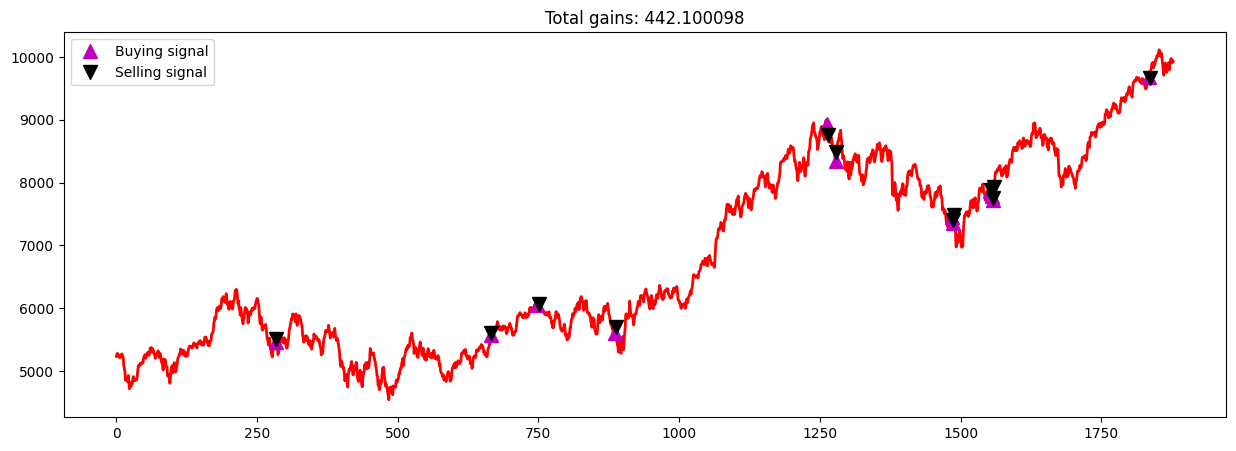

Training in progress...: 100%|██████████| 1878/1878 [06:11<00:00,  5.05it/s]


Running episode 4/10


Training in progress...:   0%|          | 0/1878 [00:00<?, ?it/s]

[[0.         0.         0.32340497]] 2


Training in progress...:   0%|          | 2/1878 [00:00<06:08,  5.08it/s]

[[0.         0.         0.38172545]] 2
[[0.         0.         0.44613841]] 2


Training in progress...:   0%|          | 4/1878 [00:00<05:55,  5.27it/s]

[[0.        0.        0.2502662]] 2
[[0.         0.         0.34264132]] 2


Training in progress...:   0%|          | 6/1878 [00:01<05:45,  5.42it/s]

[[0.         0.         0.51612804]] 2
[[0.        0.        0.5059078]] 2


Training in progress...:   0%|          | 8/1878 [00:01<05:45,  5.42it/s]

[[0.         0.         0.47085785]] 2
[[0.         0.         0.51802344]] 2


Training in progress...:   1%|          | 10/1878 [00:01<05:45,  5.40it/s]

[[0.        0.        0.6174967]] 2
[[0.        0.        0.5596198]] 2


Training in progress...:   1%|          | 12/1878 [00:02<05:42,  5.44it/s]

[[0.        0.        0.6317921]] 2
[[0.         0.         0.38576003]] 2


Training in progress...:   1%|          | 14/1878 [00:02<05:47,  5.37it/s]

[[0.         0.         0.42975225]] 2
[[0.         0.         0.40111344]] 2


Training in progress...:   1%|          | 16/1878 [00:03<05:45,  5.39it/s]

[[0.         0.         0.42228612]] 2
[[0.         0.         0.36547752]] 2


Training in progress...:   1%|          | 18/1878 [00:03<05:42,  5.42it/s]

[[0.12253603 0.         0.3157633 ]] 2
[[0.         0.         0.32581362]] 2


Training in progress...:   1%|          | 20/1878 [00:03<05:46,  5.37it/s]

[[0.04359505 0.         0.41078157]] 2
[[0.05960393 0.         0.18317843]] 2


Training in progress...:   1%|          | 22/1878 [00:04<05:43,  5.41it/s]

[[0.10836543 0.         0.30195332]] 2
[[0.         0.         0.44306277]] 2


Training in progress...:   1%|▏         | 24/1878 [00:04<05:36,  5.50it/s]

[[0.03558892 0.         0.39815648]] 2
[[0.04015351 0.         0.51181393]] 2


Training in progress...:   1%|▏         | 26/1878 [00:04<05:41,  5.43it/s]

[[3.71592566e-04 0.00000000e+00 4.13200593e-01]] 2
[[0.         0.         0.55741734]] 2


Training in progress...:   1%|▏         | 28/1878 [00:05<05:51,  5.27it/s]

[[0.         0.         0.49109523]] 2
[[0.         0.         0.48280858]] 2


Training in progress...:   2%|▏         | 30/1878 [00:05<05:46,  5.33it/s]

[[0.10444288 0.         0.39053554]] 2
[[0.03523766 0.         0.4832738 ]] 2


Training in progress...:   2%|▏         | 32/1878 [00:05<05:44,  5.36it/s]

[[0.         0.         0.58208615]] 2
[[0.         0.         0.50709453]] 2


Training in progress...:   2%|▏         | 33/1878 [00:06<05:48,  5.30it/s]

[[0.         0.         0.59885854]] 2


Training in progress...:   2%|▏         | 34/1878 [00:06<06:14,  4.92it/s]

[[0.         0.         0.57764658]] 2


Training in progress...:   2%|▏         | 35/1878 [00:06<06:34,  4.67it/s]

[[0.       0.       0.637884]] 2


Training in progress...:   2%|▏         | 36/1878 [00:06<06:51,  4.48it/s]

[[0.         0.         0.52833746]] 2


Training in progress...:   2%|▏         | 37/1878 [00:07<06:48,  4.50it/s]

[[0.         0.         0.66926048]] 2


Training in progress...:   2%|▏         | 38/1878 [00:07<06:48,  4.50it/s]

[[0.         0.         0.74124015]] 2


Training in progress...:   2%|▏         | 39/1878 [00:07<07:12,  4.25it/s]

[[0.        0.        0.7481707]] 2


Training in progress...:   2%|▏         | 40/1878 [00:07<07:09,  4.28it/s]

[[0.         0.         0.66760801]] 2


Training in progress...:   2%|▏         | 41/1878 [00:08<07:04,  4.32it/s]

[[0.05580626 0.         0.71301863]] 2


Training in progress...:   2%|▏         | 42/1878 [00:08<07:07,  4.29it/s]

[[0.         0.         0.67720941]] 2


Training in progress...:   2%|▏         | 43/1878 [00:08<07:03,  4.33it/s]

[[0.         0.         0.64485152]] 2


Training in progress...:   2%|▏         | 44/1878 [00:08<06:52,  4.45it/s]

[[0.04906157 0.         0.60324028]] 2


Training in progress...:   2%|▏         | 45/1878 [00:08<06:43,  4.54it/s]

[[0.        0.        0.6650866]] 2


Training in progress...:   2%|▏         | 46/1878 [00:09<07:10,  4.26it/s]

[[0.01269913 0.         0.75716818]] 2


Training in progress...:   3%|▎         | 47/1878 [00:09<07:28,  4.09it/s]

[[0.         0.         0.83253792]] 2


Training in progress...:   3%|▎         | 48/1878 [00:09<07:39,  3.98it/s]

[[0.         0.         0.72615176]] 2


Training in progress...:   3%|▎         | 49/1878 [00:09<07:30,  4.06it/s]

[[0.         0.         0.80926696]] 2


Training in progress...:   3%|▎         | 50/1878 [00:10<07:24,  4.11it/s]

[[0.         0.         0.74852855]] 2


Training in progress...:   3%|▎         | 51/1878 [00:10<07:32,  4.04it/s]

[[0.         0.         0.72011093]] 2


Training in progress...:   3%|▎         | 52/1878 [00:10<07:40,  3.96it/s]

[[0.         0.         0.70142801]] 2


Training in progress...:   3%|▎         | 54/1878 [00:11<06:58,  4.36it/s]

[[0.         0.         0.51864314]] 2
[[0.         0.         0.36127502]] 2


Training in progress...:   3%|▎         | 56/1878 [00:11<06:23,  4.75it/s]

[[0.         0.         0.26280109]] 2
[[0.         0.         0.30588076]] 2


Training in progress...:   3%|▎         | 58/1878 [00:11<05:59,  5.06it/s]

[[0.         0.         0.42535472]] 2
[[0.         0.         0.28099204]] 2


Training in progress...:   3%|▎         | 60/1878 [00:12<05:46,  5.25it/s]

[[0.         0.         0.10307136]] 2
[[0.         0.         0.01889369]] 2


Training in progress...:   3%|▎         | 62/1878 [00:12<05:41,  5.31it/s]

[[0.         0.         0.16079876]] 2
[[0.         0.         0.17427728]] 2


Training in progress...:   3%|▎         | 64/1878 [00:13<05:32,  5.45it/s]

[[0.         0.         0.24636601]] 2
[[0.         0.         0.20691301]] 2


Training in progress...:   4%|▎         | 66/1878 [00:13<05:27,  5.53it/s]

[[0.         0.         0.18534949]] 2
[[0.         0.         0.09055886]] 2


Training in progress...:   4%|▎         | 68/1878 [00:13<05:34,  5.42it/s]

[[0.         0.         0.08163121]] 2
[[0.         0.         0.21912272]] 2


Training in progress...:   4%|▎         | 70/1878 [00:14<05:31,  5.46it/s]

[[0.         0.         0.25611525]] 2
[[0.         0.         0.46551919]] 2


Training in progress...:   4%|▍         | 71/1878 [00:14<05:35,  5.38it/s]

[[0.         0.         0.54916976]] 2


Training in progress...:   4%|▍         | 73/1878 [00:14<05:54,  5.10it/s]

[[0.         0.         0.33493001]] 2
[[0.         0.         0.19223853]] 2


Training in progress...:   4%|▍         | 75/1878 [00:15<05:38,  5.33it/s]

[[0.         0.         0.44236239]] 2
[[0.         0.         0.46958612]] 2


Training in progress...:   4%|▍         | 77/1878 [00:15<05:37,  5.34it/s]

[[0.         0.         0.43195381]] 2
[[0.         0.         0.55781773]] 2


Training in progress...:   4%|▍         | 79/1878 [00:15<05:47,  5.18it/s]

[[0.         0.         0.58723765]] 2
[[0.         0.         0.60299935]] 2


Training in progress...:   4%|▍         | 81/1878 [00:16<05:35,  5.36it/s]

[[0.         0.         0.52231198]] 2
[[0.         0.         0.49857569]] 2


Training in progress...:   4%|▍         | 83/1878 [00:16<05:36,  5.33it/s]

[[0.         0.         0.58364286]] 2
[[0.         0.         0.58453436]] 2


Training in progress...:   5%|▍         | 85/1878 [00:17<05:38,  5.29it/s]

[[0.         0.         0.53919093]] 2
[[0.         0.         0.54131645]] 2


Training in progress...:   5%|▍         | 87/1878 [00:17<05:37,  5.30it/s]

[[0.         0.         0.56039602]] 2
[[0.         0.         0.61627316]] 2


Training in progress...:   5%|▍         | 89/1878 [00:17<05:46,  5.17it/s]

[[0.         0.         0.73584987]] 2
[[0.         0.         0.56446366]] 2


Training in progress...:   5%|▍         | 91/1878 [00:18<05:31,  5.40it/s]

[[0.         0.         0.69046287]] 2
[[0.         0.         0.62617566]] 2


Training in progress...:   5%|▍         | 93/1878 [00:18<05:28,  5.43it/s]

[[0.         0.         0.60742957]] 2
[[0.         0.         0.51188166]] 2


Training in progress...:   5%|▌         | 95/1878 [00:18<05:33,  5.35it/s]

[[0.         0.         0.65543835]] 2
[[0.         0.         0.56046502]] 2


Training in progress...:   5%|▌         | 97/1878 [00:19<05:27,  5.43it/s]

[[0.         0.         0.53428363]] 2
[[0.         0.         0.52405245]] 2


Training in progress...:   5%|▌         | 99/1878 [00:19<05:24,  5.48it/s]

[[0.02091099 0.         0.61248312]] 2
[[0.07701541 0.         0.64789739]] 2


Training in progress...:   5%|▌         | 101/1878 [00:20<05:33,  5.32it/s]

[[0.         0.         0.53727523]] 2
[[0.13971674 0.         0.47799022]] 2


Training in progress...:   5%|▌         | 103/1878 [00:20<05:24,  5.47it/s]

[[0.         0.         0.54313148]] 2
[[0.        0.        0.5594273]] 2


Training in progress...:   6%|▌         | 105/1878 [00:20<05:31,  5.35it/s]

[[0.         0.         0.63002614]] 2
[[0.04758812 0.         0.68703777]] 2


Training in progress...:   6%|▌         | 106/1878 [00:20<05:35,  5.29it/s]

[[0.         0.         0.61283305]] 2


Training in progress...:   6%|▌         | 107/1878 [00:21<05:58,  4.94it/s]

[[0.         0.         0.80593094]] 2


Training in progress...:   6%|▌         | 108/1878 [00:21<06:24,  4.61it/s]

[[0.         0.         0.77401159]] 2


Training in progress...:   6%|▌         | 109/1878 [00:21<06:31,  4.51it/s]

[[0.         0.         0.67001843]] 2


Training in progress...:   6%|▌         | 110/1878 [00:21<06:41,  4.40it/s]

[[0.         0.         0.60567416]] 2


Training in progress...:   6%|▌         | 111/1878 [00:22<06:35,  4.47it/s]

[[0.        0.        0.5029203]] 2


Training in progress...:   6%|▌         | 112/1878 [00:22<06:34,  4.48it/s]

[[0.         0.         0.48369986]] 2


Training in progress...:   6%|▌         | 113/1878 [00:22<06:35,  4.46it/s]

[[0.         0.         0.47046172]] 2


Training in progress...:   6%|▌         | 114/1878 [00:22<06:41,  4.40it/s]

[[0.         0.         0.50885433]] 2


Training in progress...:   6%|▌         | 115/1878 [00:23<07:02,  4.17it/s]

[[0.         0.         0.59874034]] 2


Training in progress...:   6%|▌         | 116/1878 [00:23<06:51,  4.28it/s]

[[0.         0.         0.47454854]] 2


Training in progress...:   6%|▌         | 117/1878 [00:23<07:15,  4.05it/s]

[[0.        0.        0.3732841]] 2


Training in progress...:   6%|▋         | 118/1878 [00:23<07:14,  4.05it/s]

[[0.         0.         0.36664923]] 2


Training in progress...:   6%|▋         | 119/1878 [00:24<07:21,  3.99it/s]

[[0.         0.         0.42637762]] 2


Training in progress...:   6%|▋         | 120/1878 [00:24<07:13,  4.06it/s]

[[0.         0.         0.52912062]] 2


Training in progress...:   6%|▋         | 121/1878 [00:24<07:25,  3.95it/s]

[[0.01020049 0.         0.33378756]] 2


Training in progress...:   6%|▋         | 122/1878 [00:24<07:24,  3.95it/s]

[[0.         0.         0.41479291]] 2


Training in progress...:   7%|▋         | 123/1878 [00:25<07:19,  3.99it/s]

[[0.         0.         0.30836234]] 2


Training in progress...:   7%|▋         | 124/1878 [00:25<07:17,  4.00it/s]

[[0.         0.         0.46086448]] 2


Training in progress...:   7%|▋         | 126/1878 [00:25<07:04,  4.13it/s]

[[0.         0.         0.41083451]] 2
[[0.         0.         0.53185404]] 2


Training in progress...:   7%|▋         | 128/1878 [00:26<06:12,  4.70it/s]

[[0.03326714 0.         0.57708009]] 2
[[0.         0.         0.53722385]] 2


Training in progress...:   7%|▋         | 130/1878 [00:26<05:52,  4.96it/s]

[[0.         0.         0.47626785]] 2
[[0.         0.         0.34101231]] 2


Training in progress...:   7%|▋         | 132/1878 [00:26<05:35,  5.20it/s]

[[0.        0.        0.5312972]] 2
[[0.         0.         0.47858482]] 2


Training in progress...:   7%|▋         | 134/1878 [00:27<05:29,  5.29it/s]

[[0.         0.         0.57613815]] 2
[[0.         0.         0.59418704]] 2


Training in progress...:   7%|▋         | 136/1878 [00:27<05:36,  5.17it/s]

[[0.0994856  0.         0.49077855]] 2
[[0.17105838 0.         0.49719174]] 2


Training in progress...:   7%|▋         | 138/1878 [00:28<05:29,  5.28it/s]

[[0.10820958 0.         0.46679585]] 2
[[0.1238043  0.         0.44055161]] 2


Training in progress...:   7%|▋         | 140/1878 [00:28<05:32,  5.23it/s]

[[0.0936257  0.         0.48150925]] 2
[[0.         0.         0.30413697]] 2


Training in progress...:   8%|▊         | 142/1878 [00:28<05:28,  5.29it/s]

[[0.         0.         0.18399294]] 2
[[0.06858711 0.         0.19568114]] 2


Training in progress...:   8%|▊         | 144/1878 [00:29<05:27,  5.30it/s]

[[0.0913777  0.         0.03493567]] 0
[[0.10177439 0.         0.        ]] 0


Training in progress...:   8%|▊         | 146/1878 [00:29<05:27,  5.29it/s]

[[0.         0.         0.02579055]] 2
[[0.         0.         0.16076409]] 2


Training in progress...:   8%|▊         | 148/1878 [00:29<05:22,  5.36it/s]

[[0.         0.         0.15933118]] 2
[[0.         0.         0.28647107]] 2


Training in progress...:   8%|▊         | 150/1878 [00:30<05:25,  5.31it/s]

[[0.         0.         0.33609224]] 2
[[0.         0.         0.42100488]] 2


Training in progress...:   8%|▊         | 152/1878 [00:30<05:22,  5.36it/s]

[[0.         0.         0.33737973]] 2
[[0.         0.         0.33592592]] 2


Training in progress...:   8%|▊         | 154/1878 [00:31<05:19,  5.40it/s]

[[0.11783145 0.         0.27875118]] 2
[[0.11374962 0.         0.55788068]] 2


Training in progress...:   8%|▊         | 156/1878 [00:31<05:16,  5.44it/s]

[[0.16814862 0.         0.58726076]] 2
[[0.1838701 0.        0.4136173]] 2


Training in progress...:   8%|▊         | 158/1878 [00:31<05:25,  5.29it/s]

[[0.22259584 0.         0.41166171]] 2
[[0.41675267 0.         0.43749355]] 2


Training in progress...:   9%|▊         | 160/1878 [00:32<05:20,  5.37it/s]

[[0.3380608  0.         0.33131747]] 0
[[0.3509017  0.         0.41761417]] 2


Training in progress...:   9%|▊         | 162/1878 [00:32<05:24,  5.29it/s]

[[0.22386338 0.         0.42724144]] 2
[[0.23290173 0.         0.42105896]] 2


Training in progress...:   9%|▊         | 164/1878 [00:32<05:20,  5.35it/s]

[[0.26010536 0.         0.54161345]] 2
[[0.11784165 0.         0.57877472]] 2


Training in progress...:   9%|▉         | 166/1878 [00:33<05:17,  5.39it/s]

[[0.06150041 0.         0.70541893]] 2
[[0.03105566 0.         0.77176973]] 2


Training in progress...:   9%|▉         | 168/1878 [00:33<05:18,  5.37it/s]

[[0.         0.         0.79751092]] 2
[[0.         0.02146537 0.72703806]] 2


Training in progress...:   9%|▉         | 170/1878 [00:34<05:20,  5.33it/s]

[[0.         0.03193309 0.75658308]] 2
[[0.         0.         0.75928462]] 2


Training in progress...:   9%|▉         | 172/1878 [00:34<05:20,  5.32it/s]

[[0.         0.         0.86979129]] 2
[[0.         0.         0.71633734]] 2


Training in progress...:   9%|▉         | 174/1878 [00:34<05:18,  5.35it/s]

[[0.06636599 0.         0.86997345]] 2
[[0.12186444 0.         0.90623398]] 2


Training in progress...:   9%|▉         | 176/1878 [00:35<05:27,  5.20it/s]

[[0.14158549 0.         0.9911701 ]] 2


Training in progress...:   9%|▉         | 177/1878 [00:35<05:28,  5.18it/s]

[[0.07554902 0.         0.79988702]] 2
[[0.         0.         0.69024815]] 2


Training in progress...:   9%|▉         | 178/1878 [00:35<05:34,  5.09it/s]

[[0.         0.         0.81537737]] 2


Training in progress...:  10%|▉         | 179/1878 [00:35<06:05,  4.65it/s]

[[0.         0.         0.69356622]] 2


Training in progress...:  10%|▉         | 180/1878 [00:36<06:08,  4.61it/s]

[[0.01927982 0.         0.50166639]] 2


Training in progress...:  10%|▉         | 181/1878 [00:36<06:13,  4.55it/s]

[[0.0631032  0.04345725 0.37853862]] 2


Training in progress...:  10%|▉         | 182/1878 [00:36<06:26,  4.39it/s]

[[0.34333463 0.         0.2300789 ]] 0


Training in progress...:  10%|▉         | 183/1878 [00:36<06:19,  4.46it/s]

[[0.34994414 0.         0.31163129]] 0


Training in progress...:  10%|▉         | 184/1878 [00:37<06:18,  4.47it/s]

[[0.47118422 0.         0.30142262]] 0


Training in progress...:  10%|▉         | 185/1878 [00:37<06:15,  4.51it/s]

[[0.39421024 0.         0.37762616]] 0


Training in progress...:  10%|▉         | 186/1878 [00:37<06:16,  4.50it/s]

[[0.2076097  0.         0.31091571]] 2


Training in progress...:  10%|▉         | 187/1878 [00:37<06:37,  4.26it/s]

[[0.03173273 0.         0.30912028]] 2


Training in progress...:  10%|█         | 189/1878 [00:38<06:17,  4.48it/s]

[[0.         0.         0.41095359]] 2
[[0.         0.         0.38888592]] 2


Training in progress...:  10%|█         | 190/1878 [00:38<06:16,  4.49it/s]

[[0.         0.         0.59254125]] 2


Training in progress...:  10%|█         | 191/1878 [00:38<06:37,  4.25it/s]

[[0.         0.         0.45686207]] 2


Training in progress...:  10%|█         | 192/1878 [00:38<06:47,  4.14it/s]

[[0.         0.         0.45332534]] 2


Training in progress...:  10%|█         | 193/1878 [00:39<06:50,  4.10it/s]

[[0.         0.         0.64683404]] 2


Training in progress...:  10%|█         | 194/1878 [00:39<07:11,  3.90it/s]

[[0.         0.         0.64112402]] 2


Training in progress...:  10%|█         | 195/1878 [00:39<07:13,  3.88it/s]

[[0.         0.         0.40138774]] 2


Training in progress...:  10%|█         | 196/1878 [00:39<07:04,  3.96it/s]

[[0.         0.         0.42948005]] 2


Training in progress...:  10%|█         | 197/1878 [00:40<07:03,  3.97it/s]

[[0.05999036 0.         0.33517162]] 2


Training in progress...:  11%|█         | 198/1878 [00:40<07:09,  3.91it/s]

[[0.         0.         0.17415413]] 2


Training in progress...:  11%|█         | 200/1878 [00:40<06:18,  4.43it/s]

[[0.24031463 0.         0.14314863]] 0
[[0.39629541 0.01738047 0.16370405]] 0


Training in progress...:  11%|█         | 202/1878 [00:41<05:45,  4.84it/s]

[[0.54524816 0.         0.27165192]] 0
[[0.6458042  0.         0.21712681]] 0


Training in progress...:  11%|█         | 204/1878 [00:41<05:30,  5.07it/s]

[[0.65198337 0.         0.31151701]] 0
[[0.56512031 0.         0.4345905 ]] 0


Training in progress...:  11%|█         | 206/1878 [00:42<05:30,  5.06it/s]

[[0.3728804 0.        0.3376015]] 0
[[0.22685681 0.         0.24562515]] 2


Training in progress...:  11%|█         | 208/1878 [00:42<05:18,  5.24it/s]

[[0.3201216 0.        0.3128297]] 0
[[0.21254665 0.         0.18940952]] 0


Training in progress...:  11%|█         | 210/1878 [00:42<05:15,  5.28it/s]

[[0.21586543 0.         0.39220051]] 2
[[0.20754074 0.         0.57502908]] 2


Training in progress...:  11%|█▏        | 212/1878 [00:43<05:09,  5.38it/s]

[[0.04911748 0.         0.4892568 ]] 2
[[0.12409377 0.         0.63314033]] 2


Training in progress...:  11%|█▏        | 214/1878 [00:43<05:10,  5.36it/s]

[[0.22590084 0.         0.63663071]] 2
[[0.14457995 0.         0.65293926]] 2


Training in progress...:  12%|█▏        | 216/1878 [00:43<05:18,  5.21it/s]

[[0.22789266 0.         0.58438935]] 2
[[0.13848563 0.         0.6682381 ]] 2


Training in progress...:  12%|█▏        | 218/1878 [00:44<05:15,  5.26it/s]

[[0.25240994 0.         0.70599791]] 2
[[0.08577387 0.         0.65638776]] 2


Training in progress...:  12%|█▏        | 220/1878 [00:44<05:11,  5.32it/s]

[[0.17476884 0.         0.58963167]] 2
[[0.16113763 0.         0.66632277]] 2


Training in progress...:  12%|█▏        | 222/1878 [00:45<05:16,  5.23it/s]

[[0.15490241 0.         0.63957463]] 2
[[0.         0.         0.70115338]] 2


Training in progress...:  12%|█▏        | 224/1878 [00:45<05:07,  5.37it/s]

[[0.         0.         0.59349529]] 2
[[0.         0.         0.57719352]] 2


Training in progress...:  12%|█▏        | 226/1878 [00:45<05:11,  5.30it/s]

[[0.05810874 0.         0.52115979]] 2
[[0.         0.         0.40272544]] 2


Training in progress...:  12%|█▏        | 228/1878 [00:46<05:10,  5.31it/s]

[[0.         0.         0.38018377]] 2
[[0.         0.         0.23629736]] 2


Training in progress...:  12%|█▏        | 230/1878 [00:46<05:08,  5.35it/s]

[[0.         0.         0.35558127]] 2
[[0.         0.         0.60557738]] 2


Training in progress...:  12%|█▏        | 232/1878 [00:46<05:12,  5.27it/s]

[[0.         0.         0.45531607]] 2
[[0.         0.         0.35722134]] 2


Training in progress...:  12%|█▏        | 234/1878 [00:47<05:20,  5.13it/s]

[[0.         0.         0.26865244]] 2
[[0.         0.         0.32247151]] 2


Training in progress...:  13%|█▎        | 236/1878 [00:47<05:19,  5.13it/s]

[[0.         0.         0.40750017]] 2
[[0.         0.         0.52219241]] 2


Training in progress...:  13%|█▎        | 238/1878 [00:48<05:09,  5.30it/s]

[[0.         0.         0.51548764]] 2
[[0.         0.         0.41355197]] 2


Training in progress...:  13%|█▎        | 240/1878 [00:48<05:09,  5.29it/s]

[[0.         0.         0.37444495]] 2
[[0.         0.         0.39090773]] 2


Training in progress...:  13%|█▎        | 242/1878 [00:48<05:07,  5.32it/s]

[[0.         0.         0.36827134]] 2
[[0.         0.         0.34860537]] 2


Training in progress...:  13%|█▎        | 244/1878 [00:49<05:08,  5.30it/s]

[[0.         0.         0.42372485]] 2
[[0.02737669 0.         0.61207127]] 2


Training in progress...:  13%|█▎        | 246/1878 [00:49<05:08,  5.29it/s]

[[0.03261424 0.         0.61551332]] 2
[[0.         0.         0.61775968]] 2


Training in progress...:  13%|█▎        | 248/1878 [00:49<05:07,  5.31it/s]

[[0.         0.         0.49099316]] 2
[[0.         0.         0.40580434]] 2


Training in progress...:  13%|█▎        | 250/1878 [00:50<05:05,  5.33it/s]

[[0.06108163 0.         0.59030289]] 2
[[0.11337557 0.         0.63511609]] 2


Training in progress...:  13%|█▎        | 251/1878 [00:50<05:20,  5.07it/s]

[[0.09785117 0.         0.31614219]] 2


Training in progress...:  13%|█▎        | 252/1878 [00:50<05:40,  4.78it/s]

[[0.         0.         0.39470498]] 2


Training in progress...:  13%|█▎        | 253/1878 [00:51<05:57,  4.55it/s]

[[0.0129153 0.        0.5562472]] 2


Training in progress...:  14%|█▎        | 254/1878 [00:51<05:49,  4.64it/s]

[[0.07562838 0.         0.54221593]] 2


Training in progress...:  14%|█▎        | 255/1878 [00:51<05:51,  4.62it/s]

[[0.08678272 0.         0.55402558]] 2


Training in progress...:  14%|█▎        | 256/1878 [00:51<06:01,  4.49it/s]

[[0.03154787 0.         0.5439793 ]] 2


Training in progress...:  14%|█▎        | 257/1878 [00:51<05:56,  4.55it/s]

[[0.         0.         0.58384676]] 2


Training in progress...:  14%|█▎        | 258/1878 [00:52<05:56,  4.54it/s]

[[0.         0.         0.55187205]] 2


Training in progress...:  14%|█▍        | 259/1878 [00:52<06:05,  4.44it/s]

[[0.        0.        0.4198293]] 2


Training in progress...:  14%|█▍        | 260/1878 [00:52<06:03,  4.46it/s]

[[0.00000000e+00 3.43736355e-04 5.73529441e-01]] 2


Training in progress...:  14%|█▍        | 261/1878 [00:52<05:59,  4.50it/s]

[[7.94288121e-03 4.88418442e-04 6.95126145e-01]] 2


Training in progress...:  14%|█▍        | 262/1878 [00:53<05:55,  4.54it/s]

[[0.04986581 0.         0.73984308]] 2


Training in progress...:  14%|█▍        | 263/1878 [00:53<06:08,  4.38it/s]

[[0.         0.         0.59631391]] 2


Training in progress...:  14%|█▍        | 264/1878 [00:53<06:31,  4.12it/s]

[[0.         0.         0.44983356]] 2


Training in progress...:  14%|█▍        | 265/1878 [00:53<06:50,  3.93it/s]

[[0.         0.         0.52000889]] 2


Training in progress...:  14%|█▍        | 266/1878 [00:54<06:54,  3.89it/s]

[[0.         0.         0.46378181]] 2


Training in progress...:  14%|█▍        | 267/1878 [00:54<06:53,  3.90it/s]

[[0.         0.12762533 0.41103566]] 2


Training in progress...:  14%|█▍        | 268/1878 [00:54<06:42,  4.00it/s]

[[0.         0.03737703 0.51360384]] 2


Training in progress...:  14%|█▍        | 269/1878 [00:54<07:01,  3.81it/s]

[[0.         0.         0.43889441]] 2


Training in progress...:  14%|█▍        | 271/1878 [00:55<06:09,  4.34it/s]

[[0.         0.         0.49738148]] 2
[[0.         0.         0.51944802]] 2


Training in progress...:  15%|█▍        | 273/1878 [00:55<05:42,  4.68it/s]

[[0.         0.         0.53059833]] 2
[[0.         0.         0.50369956]] 2


Training in progress...:  15%|█▍        | 275/1878 [00:56<05:18,  5.04it/s]

[[0.15204068 0.         0.6593809 ]] 2
[[0.17742709 0.         0.63714272]] 2


Training in progress...:  15%|█▍        | 277/1878 [00:56<05:08,  5.19it/s]

[[0.04108631 0.         0.46655991]] 2
[[0.00053725 0.         0.52179283]] 2


Training in progress...:  15%|█▍        | 279/1878 [00:56<05:00,  5.33it/s]

[[0.18227406 0.         0.46325982]] 2
[[0.04106849 0.         0.50194253]] 2


Training in progress...:  15%|█▍        | 281/1878 [00:57<04:51,  5.47it/s]

[[0.1299088  0.         0.42451421]] 2
[[0.05301525 0.         0.19866502]] 2


Training in progress...:  15%|█▌        | 283/1878 [00:57<05:01,  5.29it/s]

[[0.10239483 0.         0.2261307 ]] 2
[[0.14137801 0.         0.24931344]] 2


Training in progress...:  15%|█▌        | 285/1878 [00:57<04:58,  5.34it/s]

[[0.02947768 0.         0.22071818]] 2
[[0.         0.         0.35560256]] 2


Training in progress...:  15%|█▌        | 287/1878 [00:58<04:54,  5.40it/s]

[[0.        0.        0.4241236]] 2
[[0.14837026 0.         0.49228759]] 2


Training in progress...:  15%|█▌        | 289/1878 [00:58<05:01,  5.27it/s]

[[0.13241449 0.         0.50891778]] 2
[[0.02418126 0.04335386 0.44392902]] 2


Training in progress...:  15%|█▌        | 291/1878 [00:59<04:56,  5.36it/s]

[[0.         0.         0.45899263]] 2
[[0.02101801 0.         0.47434335]] 2


Training in progress...:  16%|█▌        | 293/1878 [00:59<04:59,  5.30it/s]

[[0.07863067 0.         0.3606799 ]] 2
[[0.2158086  0.         0.00931385]] 0


Training in progress...:  16%|█▌        | 295/1878 [00:59<04:58,  5.30it/s]

[[0.22765795 0.         0.11535148]] 0
[[0.16275035 0.         0.2467157 ]] 2


Training in progress...:  16%|█▌        | 297/1878 [01:00<04:52,  5.40it/s]

[[0.06363281 0.         0.2309142 ]] 2
[[0.23656427 0.         0.10232862]] 0


Training in progress...:  16%|█▌        | 299/1878 [01:00<04:58,  5.30it/s]

[[0.01407789 0.         0.23678695]] 2
[[0.         0.         0.17812651]] 2


Training in progress...:  16%|█▌        | 301/1878 [01:00<04:47,  5.49it/s]

[[0.         0.         0.08067171]] 2
[[0.         0.         0.34819904]] 2


Training in progress...:  16%|█▌        | 303/1878 [01:01<04:43,  5.55it/s]

[[0.02773281 0.         0.34027331]] 2
[[0.         0.         0.41087051]] 2


Training in progress...:  16%|█▌        | 305/1878 [01:01<04:58,  5.28it/s]

[[0.         0.         0.33985957]] 2
[[0.         0.         0.28519873]] 2


Training in progress...:  16%|█▋        | 307/1878 [01:02<04:59,  5.25it/s]

[[0.         0.         0.28215953]] 2
[[0.        0.        0.3514488]] 2


Training in progress...:  16%|█▋        | 309/1878 [01:02<05:01,  5.20it/s]

[[0.        0.        0.2476284]] 2
[[0.         0.         0.29902699]] 2


Training in progress...:  17%|█▋        | 311/1878 [01:02<04:57,  5.26it/s]

[[0.         0.         0.39611994]] 2
[[0.         0.         0.50875901]] 2


Training in progress...:  17%|█▋        | 313/1878 [01:03<04:52,  5.35it/s]

[[0.         0.         0.45670481]] 2
[[0.         0.         0.55068746]] 2


Training in progress...:  17%|█▋        | 314/1878 [01:03<04:56,  5.28it/s]

[[0.        0.        0.4417163]] 2


Training in progress...:  17%|█▋        | 316/1878 [01:03<05:03,  5.16it/s]

[[0.         0.         0.37084932]] 2
[[0.         0.         0.28703276]] 2


Training in progress...:  17%|█▋        | 318/1878 [01:04<04:54,  5.29it/s]

[[0.         0.         0.35127892]] 2
[[0.         0.         0.29096357]] 2


Training in progress...:  17%|█▋        | 320/1878 [01:04<04:57,  5.24it/s]

[[0.         0.         0.21613708]] 2
[[0.         0.         0.26251147]] 2


Training in progress...:  17%|█▋        | 322/1878 [01:04<04:55,  5.27it/s]

[[0.         0.         0.23918676]] 2
[[0.         0.         0.25211796]] 2


Training in progress...:  17%|█▋        | 323/1878 [01:05<05:18,  4.89it/s]

[[0.         0.         0.37012409]] 2


Training in progress...:  17%|█▋        | 324/1878 [01:05<05:30,  4.70it/s]

[[0.         0.         0.29216365]] 2


Training in progress...:  17%|█▋        | 325/1878 [01:05<06:04,  4.26it/s]

[[0.         0.         0.33429278]] 2


Training in progress...:  17%|█▋        | 326/1878 [01:05<06:10,  4.19it/s]

[[0.         0.         0.40525605]] 2


Training in progress...:  17%|█▋        | 327/1878 [01:06<06:00,  4.30it/s]

[[0.         0.         0.61639064]] 2


Training in progress...:  17%|█▋        | 328/1878 [01:06<05:55,  4.36it/s]

[[0.         0.         0.57619251]] 2


Training in progress...:  18%|█▊        | 329/1878 [01:06<06:18,  4.10it/s]

[[0.         0.         0.54383176]] 2


Training in progress...:  18%|█▊        | 330/1878 [01:06<06:17,  4.10it/s]

[[0.         0.         0.73903296]] 2


Training in progress...:  18%|█▊        | 331/1878 [01:07<06:10,  4.18it/s]

[[0.         0.         0.82065765]] 2


Training in progress...:  18%|█▊        | 332/1878 [01:07<05:58,  4.32it/s]

[[0.03868566 0.         0.85750968]] 2


Training in progress...:  18%|█▊        | 333/1878 [01:07<06:12,  4.14it/s]

[[0.         0.         0.79993548]] 2


Training in progress...:  18%|█▊        | 334/1878 [01:07<06:29,  3.96it/s]

[[0.        0.        0.6676056]] 2


Training in progress...:  18%|█▊        | 335/1878 [01:08<06:32,  3.93it/s]

[[0.         0.         0.52956439]] 2


Training in progress...:  18%|█▊        | 336/1878 [01:08<06:36,  3.89it/s]

[[0.         0.         0.50177588]] 2


Training in progress...:  18%|█▊        | 337/1878 [01:08<06:38,  3.87it/s]

[[0.         0.         0.57776985]] 2


Training in progress...:  18%|█▊        | 338/1878 [01:08<06:38,  3.87it/s]

[[0.        0.        0.6501483]] 2


Training in progress...:  18%|█▊        | 339/1878 [01:09<06:39,  3.85it/s]

[[0.         0.         0.77008472]] 2


Training in progress...:  18%|█▊        | 340/1878 [01:09<06:45,  3.80it/s]

[[0.         0.         0.78213286]] 2


Training in progress...:  18%|█▊        | 342/1878 [01:09<06:04,  4.21it/s]

[[0.         0.         0.65612608]] 2
[[0.         0.         0.49562263]] 2


Training in progress...:  18%|█▊        | 344/1878 [01:10<05:23,  4.75it/s]

[[0.         0.         0.46745055]] 2
[[0.         0.         0.43035048]] 2


Training in progress...:  18%|█▊        | 346/1878 [01:10<05:10,  4.93it/s]

[[0.         0.         0.40626858]] 2
[[0.         0.         0.40236297]] 2


Training in progress...:  19%|█▊        | 348/1878 [01:11<04:59,  5.10it/s]

[[0.         0.         0.31932902]] 2
[[0.        0.        0.1390953]] 2


Training in progress...:  19%|█▊        | 350/1878 [01:11<04:51,  5.24it/s]

[[0.         0.         0.34766468]] 2
[[0.         0.         0.40003626]] 2


Training in progress...:  19%|█▊        | 352/1878 [01:11<04:58,  5.12it/s]

[[0.         0.         0.40567962]] 2
[[0.         0.         0.31651948]] 2


Training in progress...:  19%|█▉        | 354/1878 [01:12<04:54,  5.18it/s]

[[0.17568439 0.         0.51878725]] 2
[[0.         0.         0.75046027]] 2


Training in progress...:  19%|█▉        | 356/1878 [01:12<04:54,  5.17it/s]

[[0.         0.         0.77381991]] 2
[[0.20146186 0.         0.90112707]] 2


Training in progress...:  19%|█▉        | 358/1878 [01:13<04:54,  5.17it/s]

[[0.0470331  0.         0.90580272]] 2
[[0.09378632 0.         0.9049264 ]] 2


Training in progress...:  19%|█▉        | 360/1878 [01:13<04:44,  5.34it/s]

[[0.17615725 0.         0.72977521]] 2
[[0.26079249 0.         0.84488711]] 2


Training in progress...:  19%|█▉        | 362/1878 [01:13<04:41,  5.39it/s]

[[0.12867646 0.02733714 0.7527109 ]] 2
[[0.14789951 0.         0.4707037 ]] 2


Training in progress...:  19%|█▉        | 364/1878 [01:14<04:41,  5.37it/s]

[[0.063674   0.         0.43785228]] 2
[[0.12783322 0.         0.6606157 ]] 2


Training in progress...:  19%|█▉        | 366/1878 [01:14<04:41,  5.37it/s]

[[0.18732621 0.         0.66624539]] 2
[[0.16215956 0.         0.59926087]] 2


Training in progress...:  20%|█▉        | 368/1878 [01:14<04:38,  5.42it/s]

[[0.32324976 0.         0.52408148]] 2
[[0.22332508 0.         0.51554999]] 2


Training in progress...:  20%|█▉        | 370/1878 [01:15<04:45,  5.28it/s]

[[0.17507082 0.         0.5093752 ]] 2
[[0.05304334 0.         0.51297635]] 2


Training in progress...:  20%|█▉        | 372/1878 [01:15<04:43,  5.32it/s]

[[0.        0.        0.3898287]] 2
[[0.         0.         0.54239074]] 2


Training in progress...:  20%|█▉        | 374/1878 [01:16<04:43,  5.31it/s]

[[0.        0.        0.4835552]] 2
[[0.         0.         0.39573967]] 2


Training in progress...:  20%|██        | 376/1878 [01:16<04:45,  5.26it/s]

[[0.         0.         0.69375613]] 2
[[0.         0.         0.72420775]] 2


Training in progress...:  20%|██        | 378/1878 [01:16<04:42,  5.30it/s]

[[0.         0.         0.62611809]] 2
[[0.         0.         0.50259607]] 2


Training in progress...:  20%|██        | 380/1878 [01:17<04:46,  5.24it/s]

[[0.         0.         0.56648269]] 2
[[0.         0.         0.51427291]] 2


Training in progress...:  20%|██        | 382/1878 [01:17<04:45,  5.25it/s]

[[0.        0.        0.4870991]] 2
[[0.         0.         0.57916148]] 2


Training in progress...:  20%|██        | 384/1878 [01:17<04:43,  5.27it/s]

[[0.         0.         0.64740937]] 2
[[0.         0.         0.46867786]] 2


Training in progress...:  21%|██        | 386/1878 [01:18<04:39,  5.33it/s]

[[0.       0.       0.524835]] 2
[[0.         0.         0.41292373]] 2


Training in progress...:  21%|██        | 388/1878 [01:18<04:41,  5.30it/s]

[[0.         0.         0.29465096]] 2
[[0.         0.         0.23877463]] 2


Training in progress...:  21%|██        | 390/1878 [01:19<04:42,  5.27it/s]

[[0.         0.         0.20688302]] 2
[[0.         0.         0.11662646]] 2


Training in progress...:  21%|██        | 392/1878 [01:19<04:44,  5.23it/s]

[[0.         0.         0.19816614]] 2
[[0.16528775 0.         0.34454705]] 2


Training in progress...:  21%|██        | 393/1878 [01:19<04:50,  5.11it/s]

[[0.         0.         0.37825063]] 2


Training in progress...:  21%|██        | 394/1878 [01:19<05:18,  4.65it/s]

[[0.        0.        0.2183841]] 2


Training in progress...:  21%|██        | 395/1878 [01:20<05:32,  4.46it/s]

[[0.         0.         0.14985703]] 2


Training in progress...:  21%|██        | 396/1878 [01:20<05:45,  4.29it/s]

[[0.         0.         0.08058214]] 2


Training in progress...:  21%|██        | 397/1878 [01:20<05:51,  4.22it/s]

[[0.         0.         0.08593929]] 2


Training in progress...:  21%|██        | 398/1878 [01:20<05:57,  4.14it/s]

[[0.         0.         0.21348211]] 2


Training in progress...:  21%|██        | 399/1878 [01:21<05:44,  4.29it/s]

[[0.         0.         0.19848467]] 2


Training in progress...:  21%|██▏       | 400/1878 [01:21<05:43,  4.30it/s]

[[0.05293623 0.         0.33984161]] 2


Training in progress...:  21%|██▏       | 401/1878 [01:21<05:41,  4.33it/s]

[[0.0357782  0.         0.38624638]] 2


Training in progress...:  21%|██▏       | 402/1878 [01:21<05:42,  4.32it/s]

[[0.         0.         0.45439705]] 2


Training in progress...:  21%|██▏       | 403/1878 [01:22<05:40,  4.33it/s]

[[0.13067728 0.03090904 0.49190723]] 2


Training in progress...:  22%|██▏       | 404/1878 [01:22<05:27,  4.49it/s]

[[0.11689195 0.15122405 0.38358712]] 2


Training in progress...:  22%|██▏       | 405/1878 [01:22<05:41,  4.31it/s]

[[0.09304104 0.         0.27586472]] 2


Training in progress...:  22%|██▏       | 406/1878 [01:22<06:02,  4.06it/s]

[[0.17847078 0.07010439 0.31041729]] 2


Training in progress...:  22%|██▏       | 407/1878 [01:23<06:18,  3.89it/s]

[[0.10651809 0.         0.30424353]] 2


Training in progress...:  22%|██▏       | 408/1878 [01:23<06:07,  4.00it/s]

[[0.03909272 0.         0.42533215]] 2


Training in progress...:  22%|██▏       | 409/1878 [01:23<06:17,  3.90it/s]

[[0.         0.         0.56050374]] 2


Training in progress...:  22%|██▏       | 410/1878 [01:23<06:20,  3.86it/s]

[[0.         0.         0.46407683]] 2


Training in progress...:  22%|██▏       | 411/1878 [01:24<06:05,  4.01it/s]

[[0.         0.14351644 0.39733652]] 2


Training in progress...:  22%|██▏       | 412/1878 [01:24<06:13,  3.93it/s]

[[0.         0.08612375 0.525385  ]] 2


Training in progress...:  22%|██▏       | 414/1878 [01:24<05:37,  4.34it/s]

[[0.        0.        0.5492766]] 2
[[0.       0.       0.515789]] 2


Training in progress...:  22%|██▏       | 416/1878 [01:25<04:59,  4.88it/s]

[[0.         0.         0.52166922]] 2
[[0.        0.        0.4782358]] 2


Training in progress...:  22%|██▏       | 418/1878 [01:25<04:50,  5.02it/s]

[[0.         0.         0.51028316]] 2
[[0.         0.         0.53497097]] 2


Training in progress...:  22%|██▏       | 420/1878 [01:25<04:41,  5.18it/s]

[[0.         0.         0.53168262]] 2
[[0.        0.        0.5688232]] 2


Training in progress...:  22%|██▏       | 422/1878 [01:26<04:33,  5.32it/s]

[[0.         0.         0.56609284]] 2
[[0.         0.         0.43404275]] 2


Training in progress...:  23%|██▎       | 424/1878 [01:26<04:41,  5.17it/s]

[[0.         0.         0.35821441]] 2
[[0.        0.        0.3567738]] 2


Training in progress...:  23%|██▎       | 426/1878 [01:27<04:34,  5.29it/s]

[[0.         0.         0.32675821]] 2
[[0.02093419 0.         0.33853956]] 2


Training in progress...:  23%|██▎       | 428/1878 [01:27<04:29,  5.38it/s]

[[0.         0.         0.39683252]] 2
[[0.         0.04951367 0.37146484]] 2


Training in progress...:  23%|██▎       | 430/1878 [01:27<04:40,  5.16it/s]

[[0.         0.01025301 0.43194337]] 2
[[0.         0.         0.57383531]] 2


Training in progress...:  23%|██▎       | 432/1878 [01:28<04:33,  5.29it/s]

[[0.04515502 0.         0.58278899]] 2
[[0.         0.         0.73380627]] 2


Training in progress...:  23%|██▎       | 434/1878 [01:28<04:36,  5.23it/s]

[[0.12708026 0.         0.66539502]] 2
[[0.         0.         0.59790711]] 2


Training in progress...:  23%|██▎       | 436/1878 [01:28<04:37,  5.20it/s]

[[0.14438716 0.         0.33232695]] 2
[[0.17370701 0.         0.26207731]] 2


Training in progress...:  23%|██▎       | 438/1878 [01:29<04:30,  5.32it/s]

[[0.24249011 0.         0.1161102 ]] 0
[[0.25186583 0.         0.1959055 ]] 0


Training in progress...:  23%|██▎       | 440/1878 [01:29<04:30,  5.31it/s]

[[0.         0.         0.17139952]] 2
[[0.03409333 0.         0.157528  ]] 2


Training in progress...:  24%|██▎       | 442/1878 [01:30<04:23,  5.45it/s]

[[0.         0.         0.22637288]] 2
[[0.         0.         0.31616853]] 2


Training in progress...:  24%|██▎       | 444/1878 [01:30<04:22,  5.47it/s]

[[0.         0.         0.31147136]] 2
[[0.         0.         0.38985151]] 2


Training in progress...:  24%|██▎       | 446/1878 [01:30<04:29,  5.31it/s]

[[0.         0.         0.34557316]] 2
[[0.         0.         0.47199441]] 2


Training in progress...:  24%|██▍       | 448/1878 [01:31<04:30,  5.28it/s]

[[0.         0.         0.54693749]] 2
[[0.         0.         0.62984356]] 2


Training in progress...:  24%|██▍       | 450/1878 [01:31<04:33,  5.22it/s]

[[0.         0.         0.49164705]] 2
[[0.07479398 0.         0.68495935]] 2


Training in progress...:  24%|██▍       | 452/1878 [01:31<04:27,  5.34it/s]

[[0.04066844 0.         0.64283478]] 2
[[0.         0.         0.55914777]] 2


Training in progress...:  24%|██▍       | 454/1878 [01:32<04:27,  5.32it/s]

[[0.         0.         0.42569349]] 2
[[0.06347182 0.         0.37263187]] 2


Training in progress...:  24%|██▍       | 456/1878 [01:32<04:28,  5.30it/s]

[[0.         0.         0.40337023]] 2
[[0.         0.         0.34048004]] 2


Training in progress...:  24%|██▍       | 458/1878 [01:33<04:30,  5.24it/s]

[[0.         0.         0.42728164]] 2
[[0.         0.         0.56951089]] 2


Training in progress...:  24%|██▍       | 460/1878 [01:33<04:28,  5.28it/s]

[[0.         0.         0.60618584]] 2
[[0.         0.         0.61142117]] 2


Training in progress...:  25%|██▍       | 462/1878 [01:33<04:28,  5.27it/s]

[[0.         0.         0.62577505]] 2
[[0.         0.         0.54384725]] 2


Training in progress...:  25%|██▍       | 464/1878 [01:34<04:24,  5.34it/s]

[[0.         0.         0.43812909]] 2
[[0.         0.         0.40677636]] 2


Training in progress...:  25%|██▍       | 465/1878 [01:34<04:25,  5.31it/s]

[[0.08739669 0.         0.45670548]] 2


Training in progress...:  25%|██▍       | 466/1878 [01:34<04:50,  4.87it/s]

[[0.         0.         0.52685767]] 2


Training in progress...:  25%|██▍       | 467/1878 [01:34<05:15,  4.48it/s]

[[0.         0.         0.50229899]] 2


Training in progress...:  25%|██▍       | 468/1878 [01:35<05:18,  4.42it/s]

[[0.         0.         0.53813279]] 2


Training in progress...:  25%|██▍       | 469/1878 [01:35<05:24,  4.34it/s]

[[0.         0.         0.48017936]] 2


Training in progress...:  25%|██▌       | 470/1878 [01:35<05:30,  4.26it/s]

[[0.         0.         0.27714252]] 2


Training in progress...:  25%|██▌       | 471/1878 [01:35<05:31,  4.24it/s]

[[0.         0.         0.20766754]] 2


Training in progress...:  25%|██▌       | 472/1878 [01:36<05:26,  4.30it/s]

[[0.         0.         0.29005186]] 2


Training in progress...:  25%|██▌       | 473/1878 [01:36<05:36,  4.18it/s]

[[0.         0.         0.27094681]] 2


Training in progress...:  25%|██▌       | 474/1878 [01:36<05:32,  4.22it/s]

[[0.         0.         0.29665148]] 2


Training in progress...:  25%|██▌       | 475/1878 [01:36<05:35,  4.18it/s]

[[0.         0.         0.37825435]] 2


Training in progress...:  25%|██▌       | 476/1878 [01:37<05:34,  4.19it/s]

[[0.         0.         0.42214759]] 2


Training in progress...:  25%|██▌       | 477/1878 [01:37<05:26,  4.29it/s]

[[0.         0.         0.28637764]] 2


Training in progress...:  25%|██▌       | 478/1878 [01:37<05:46,  4.04it/s]

[[0.         0.         0.27640561]] 2


Training in progress...:  26%|██▌       | 479/1878 [01:37<05:56,  3.93it/s]

[[0.         0.         0.23144606]] 2


Training in progress...:  26%|██▌       | 480/1878 [01:38<06:03,  3.84it/s]

[[0.         0.         0.19374212]] 2


Training in progress...:  26%|██▌       | 481/1878 [01:38<06:06,  3.82it/s]

[[0.         0.         0.14582837]] 2


Training in progress...:  26%|██▌       | 482/1878 [01:38<05:56,  3.91it/s]

[[0.         0.         0.22607544]] 2


Training in progress...:  26%|██▌       | 483/1878 [01:38<05:47,  4.02it/s]

[[0.         0.         0.24868814]] 2


Training in progress...:  26%|██▌       | 484/1878 [01:39<06:03,  3.84it/s]

[[0.         0.06339925 0.26245012]] 2


Training in progress...:  26%|██▌       | 486/1878 [01:39<05:39,  4.10it/s]

[[0.         0.         0.25344425]] 2
[[0.         0.         0.28998542]] 2


Training in progress...:  26%|██▌       | 488/1878 [01:40<04:56,  4.69it/s]

[[0.         0.         0.33948486]] 2
[[0.         0.         0.42209454]] 2


Training in progress...:  26%|██▌       | 490/1878 [01:40<04:37,  5.01it/s]

[[0.         0.         0.43653242]] 2
[[0.         0.         0.44586563]] 2


Training in progress...:  26%|██▌       | 492/1878 [01:40<04:30,  5.13it/s]

[[0.         0.         0.48659555]] 2
[[0.         0.         0.38639831]] 2


Training in progress...:  26%|██▋       | 494/1878 [01:41<04:26,  5.18it/s]

[[0.         0.         0.59109551]] 2
[[0.         0.         0.70605555]] 2


Training in progress...:  26%|██▋       | 496/1878 [01:41<04:21,  5.28it/s]

[[0.         0.         0.68732554]] 2
[[0.         0.         0.68782103]] 2


Training in progress...:  27%|██▋       | 498/1878 [01:41<04:26,  5.18it/s]

[[0.        0.        0.6956829]] 2
[[0.         0.         0.66688572]] 2


Training in progress...:  27%|██▋       | 500/1878 [01:42<04:28,  5.14it/s]

[[0.        0.        0.4412562]] 2
[[0.         0.         0.43316139]] 2


Training in progress...:  27%|██▋       | 502/1878 [01:42<04:23,  5.22it/s]

[[0.         0.         0.45700694]] 2
[[0.         0.         0.40281243]] 2


Training in progress...:  27%|██▋       | 504/1878 [01:43<04:20,  5.27it/s]

[[0.         0.         0.50996068]] 2
[[0.         0.         0.27188044]] 2


Training in progress...:  27%|██▋       | 506/1878 [01:43<04:24,  5.19it/s]

[[0.         0.         0.21830587]] 2
[[0.         0.         0.30937847]] 2


Training in progress...:  27%|██▋       | 508/1878 [01:43<04:24,  5.18it/s]

[[0.         0.         0.36765728]] 2
[[0.         0.         0.37013386]] 2


Training in progress...:  27%|██▋       | 510/1878 [01:44<04:14,  5.38it/s]

[[0.         0.         0.27061678]] 2
[[0.         0.         0.33463145]] 2


Training in progress...:  27%|██▋       | 512/1878 [01:44<04:16,  5.32it/s]

[[0.00196653 0.         0.2757476 ]] 2
[[0.         0.         0.43625262]] 2


Training in progress...:  27%|██▋       | 514/1878 [01:44<04:12,  5.40it/s]

[[0.         0.         0.31968529]] 2
[[0.         0.         0.25745457]] 2


Training in progress...:  27%|██▋       | 515/1878 [01:45<04:16,  5.32it/s]

[[0.         0.         0.19369255]] 2


Training in progress...:  27%|██▋       | 516/1878 [01:45<04:39,  4.87it/s]

[[0.         0.         0.24395067]] 2


Training in progress...:  28%|██▊       | 517/1878 [01:45<04:47,  4.74it/s]

[[0.         0.         0.39244286]] 2


Training in progress...:  28%|██▊       | 519/1878 [01:46<04:38,  4.88it/s]

[[0.         0.         0.07925494]] 2
[[0.         0.         0.08731603]] 2


Training in progress...:  28%|██▊       | 521/1878 [01:46<04:29,  5.04it/s]

[[0.         0.         0.31235254]] 2
[[0.         0.         0.52036948]] 2


Training in progress...:  28%|██▊       | 523/1878 [01:46<04:19,  5.21it/s]

[[0.         0.         0.53698958]] 2
[[0.         0.         0.66101483]] 2


Training in progress...:  28%|██▊       | 525/1878 [01:47<04:13,  5.34it/s]

[[0.         0.         0.67966993]] 2
[[0.         0.         0.63447897]] 2


Training in progress...:  28%|██▊       | 527/1878 [01:47<04:14,  5.32it/s]

[[0.         0.         0.66613109]] 2
[[0.       0.       0.393462]] 2


Training in progress...:  28%|██▊       | 529/1878 [01:47<04:11,  5.36it/s]

[[0.         0.         0.35927293]] 2
[[0.         0.         0.31989194]] 2


Training in progress...:  28%|██▊       | 531/1878 [01:48<04:05,  5.49it/s]

[[0.         0.         0.29203175]] 2
[[0.         0.         0.39856524]] 2


Training in progress...:  28%|██▊       | 533/1878 [01:48<04:12,  5.32it/s]

[[0.         0.         0.40994966]] 2
[[0.         0.         0.33738035]] 2


Training in progress...:  28%|██▊       | 535/1878 [01:49<04:08,  5.41it/s]

[[0.        0.        0.2791054]] 2
[[0.         0.         0.14464454]] 2


Training in progress...:  29%|██▊       | 537/1878 [01:49<04:17,  5.21it/s]

[[0.         0.         0.16611238]] 2
[[0.         0.         0.22244902]] 2


Training in progress...:  29%|██▊       | 538/1878 [01:49<04:40,  4.78it/s]

[[0.         0.         0.28694297]] 2


Training in progress...:  29%|██▊       | 539/1878 [01:49<04:52,  4.57it/s]

[[0.         0.         0.32969959]] 2


Training in progress...:  29%|██▉       | 540/1878 [01:50<04:55,  4.53it/s]

[[0.        0.        0.2268766]] 2


Training in progress...:  29%|██▉       | 541/1878 [01:50<04:57,  4.49it/s]

[[0.         0.         0.32656571]] 2


Training in progress...:  29%|██▉       | 542/1878 [01:50<05:10,  4.30it/s]

[[0.         0.         0.25337011]] 2


Training in progress...:  29%|██▉       | 543/1878 [01:50<05:15,  4.23it/s]

[[0.         0.         0.29713995]] 2


Training in progress...:  29%|██▉       | 544/1878 [01:51<05:15,  4.23it/s]

[[0.         0.         0.29969921]] 2


Training in progress...:  29%|██▉       | 545/1878 [01:51<05:13,  4.25it/s]

[[0.         0.         0.48705114]] 2


Training in progress...:  29%|██▉       | 546/1878 [01:51<05:16,  4.21it/s]

[[0.         0.         0.43090729]] 2


Training in progress...:  29%|██▉       | 548/1878 [01:52<04:58,  4.45it/s]

[[0.         0.         0.63489918]] 2
[[0.        0.        0.6154331]] 2


Training in progress...:  29%|██▉       | 549/1878 [01:52<05:11,  4.27it/s]

[[0.         0.         0.43172969]] 2


Training in progress...:  29%|██▉       | 550/1878 [01:52<05:28,  4.05it/s]

[[0.         0.         0.57655116]] 2


Training in progress...:  29%|██▉       | 551/1878 [01:52<05:33,  3.98it/s]

[[0.         0.         0.30791499]] 2


Training in progress...:  29%|██▉       | 552/1878 [01:53<05:42,  3.87it/s]

[[0.         0.         0.32303738]] 2


Training in progress...:  29%|██▉       | 553/1878 [01:53<05:48,  3.80it/s]

[[0.0205818  0.         0.25699918]] 2


Training in progress...:  29%|██▉       | 554/1878 [01:53<05:44,  3.85it/s]

[[0.         0.         0.29030917]] 2


Training in progress...:  30%|██▉       | 555/1878 [01:53<05:49,  3.78it/s]

[[0.         0.         0.21001394]] 2


Training in progress...:  30%|██▉       | 557/1878 [01:54<05:21,  4.10it/s]

[[0.19586676 0.         0.38347973]] 2
[[0.07570188 0.         0.426005  ]] 2


Training in progress...:  30%|██▉       | 559/1878 [01:54<04:53,  4.49it/s]

[[0.00948876 0.         0.55773077]] 2
[[0.         0.         0.47859097]] 2


Training in progress...:  30%|██▉       | 561/1878 [01:55<04:27,  4.91it/s]

[[0.         0.         0.42877664]] 2
[[0.        0.        0.5879994]] 2


Training in progress...:  30%|██▉       | 563/1878 [01:55<04:25,  4.96it/s]

[[0.00148179 0.         0.56282699]] 2
[[0.        0.        0.6691021]] 2


Training in progress...:  30%|███       | 565/1878 [01:55<04:24,  4.96it/s]

[[0.02262058 0.         0.67194228]] 2
[[0.         0.         0.49344316]] 2


Training in progress...:  30%|███       | 567/1878 [01:56<04:13,  5.16it/s]

[[0.03198856 0.         0.58884294]] 2
[[0.01495243 0.         0.67450914]] 2


Training in progress...:  30%|███       | 569/1878 [01:56<04:10,  5.23it/s]

[[0.         0.         0.56999236]] 2
[[0.         0.         0.52055519]] 2


Training in progress...:  30%|███       | 571/1878 [01:57<04:08,  5.26it/s]

[[0.         0.         0.52314731]] 2
[[0.         0.         0.54606405]] 2


Training in progress...:  31%|███       | 573/1878 [01:57<04:00,  5.42it/s]

[[0.         0.         0.60831416]] 2
[[0.        0.        0.6475956]] 2


Training in progress...:  31%|███       | 575/1878 [01:57<04:11,  5.17it/s]

[[0.         0.         0.70594434]] 2
[[0.         0.         0.73660592]] 2


Training in progress...:  31%|███       | 577/1878 [01:58<04:08,  5.23it/s]

[[0.         0.         0.58619763]] 2
[[0.         0.         0.57045986]] 2


Training in progress...:  31%|███       | 579/1878 [01:58<04:06,  5.27it/s]

[[0.         0.         0.67077424]] 2
[[0.         0.         0.71187053]] 2


Training in progress...:  31%|███       | 581/1878 [01:58<04:05,  5.28it/s]

[[0.07630685 0.         0.56778011]] 2
[[0.0738886  0.         0.50890407]] 2


Training in progress...:  31%|███       | 583/1878 [01:59<04:08,  5.20it/s]

[[0.        0.        0.4616215]] 2
[[0.         0.         0.40465269]] 2


Training in progress...:  31%|███       | 585/1878 [01:59<04:06,  5.24it/s]

[[0.         0.         0.36139876]] 2
[[0.         0.         0.33663752]] 2


Training in progress...:  31%|███▏      | 587/1878 [02:00<04:01,  5.34it/s]

[[0.         0.         0.19603475]] 2
[[0.         0.         0.31873238]] 2


Training in progress...:  31%|███▏      | 589/1878 [02:00<03:58,  5.41it/s]

[[0.        0.        0.3412418]] 2
[[0.         0.         0.36039775]] 2


Training in progress...:  31%|███▏      | 591/1878 [02:00<04:01,  5.34it/s]

[[0.         0.         0.35968389]] 2
[[0.         0.         0.32112607]] 2


Training in progress...:  32%|███▏      | 593/1878 [02:01<04:02,  5.30it/s]

[[0.         0.         0.17997896]] 2
[[0.         0.         0.18914292]] 2


Training in progress...:  32%|███▏      | 595/1878 [02:01<04:01,  5.31it/s]

[[0.01435726 0.04642542 0.13773686]] 2
[[0.09250171 0.         0.        ]] 0


Training in progress...:  32%|███▏      | 597/1878 [02:01<04:00,  5.33it/s]

[[0. 0. 0.]] 0
[[0.         0.         0.07682791]] 2


Training in progress...:  32%|███▏      | 599/1878 [02:02<03:59,  5.35it/s]

[[0. 0. 0.]] 0
[[0.         0.         0.07836336]] 2


Training in progress...:  32%|███▏      | 601/1878 [02:02<04:06,  5.19it/s]

[[0. 0. 0.]] 0
[[0. 0. 0.]] 0


Training in progress...:  32%|███▏      | 603/1878 [02:03<04:03,  5.23it/s]

[[0. 0. 0.]] 0
[[0.         0.         0.07518123]] 2


Training in progress...:  32%|███▏      | 605/1878 [02:03<04:05,  5.19it/s]

[[0.         0.         0.24760063]] 2
[[0.        0.        0.4257716]] 2


Training in progress...:  32%|███▏      | 607/1878 [02:03<04:03,  5.23it/s]

[[0.         0.         0.57735179]] 2
[[0.         0.         0.63864474]] 2


Training in progress...:  32%|███▏      | 608/1878 [02:04<04:06,  5.16it/s]

[[0.         0.         0.44415615]] 2


Training in progress...:  32%|███▏      | 609/1878 [02:04<04:27,  4.74it/s]

[[0.         0.         0.48631088]] 2


Training in progress...:  32%|███▏      | 610/1878 [02:04<04:42,  4.48it/s]

[[0.         0.         0.46751802]] 2


Training in progress...:  33%|███▎      | 611/1878 [02:04<04:52,  4.33it/s]

[[0.         0.         0.45427033]] 2


Training in progress...:  33%|███▎      | 612/1878 [02:05<05:00,  4.22it/s]

[[0.         0.         0.51850273]] 2


Training in progress...:  33%|███▎      | 613/1878 [02:05<05:03,  4.17it/s]

[[0.         0.         0.39502785]] 2


Training in progress...:  33%|███▎      | 614/1878 [02:05<04:53,  4.30it/s]

[[0.         0.         0.27549037]] 2


Training in progress...:  33%|███▎      | 615/1878 [02:05<04:48,  4.38it/s]

[[0.         0.         0.25299817]] 2


Training in progress...:  33%|███▎      | 616/1878 [02:06<04:44,  4.43it/s]

[[0.         0.         0.13092074]] 2


Training in progress...:  33%|███▎      | 617/1878 [02:06<04:54,  4.29it/s]

[[0.00657637 0.         0.16944416]] 2


Training in progress...:  33%|███▎      | 618/1878 [02:06<04:51,  4.33it/s]

[[0.         0.         0.13590399]] 2


Training in progress...:  33%|███▎      | 619/1878 [02:06<04:51,  4.31it/s]

[[0.         0.         0.14363282]] 2


Training in progress...:  33%|███▎      | 620/1878 [02:06<04:41,  4.47it/s]

[[0.0093555  0.         0.20726012]] 2


Training in progress...:  33%|███▎      | 621/1878 [02:07<04:54,  4.27it/s]

[[0.         0.         0.37177863]] 2


Training in progress...:  33%|███▎      | 622/1878 [02:07<05:05,  4.11it/s]

[[0.00698441 0.         0.28695295]] 2


Training in progress...:  33%|███▎      | 623/1878 [02:07<05:21,  3.91it/s]

[[0.         0.         0.25682536]] 2


Training in progress...:  33%|███▎      | 624/1878 [02:08<05:28,  3.81it/s]

[[0.         0.         0.24188853]] 2


Training in progress...:  33%|███▎      | 625/1878 [02:08<05:31,  3.78it/s]

[[0.         0.         0.32072072]] 2


Training in progress...:  33%|███▎      | 626/1878 [02:08<05:29,  3.80it/s]

[[0.         0.         0.32622366]] 2


Training in progress...:  33%|███▎      | 627/1878 [02:08<05:39,  3.69it/s]

[[0.         0.         0.38755445]] 2


Training in progress...:  33%|███▎      | 629/1878 [02:09<05:03,  4.12it/s]

[[0.         0.         0.42291956]] 2
[[0.         0.10624445 0.43986999]] 2


Training in progress...:  34%|███▎      | 631/1878 [02:09<04:36,  4.51it/s]

[[0.         0.04443704 0.51487586]] 2
[[0.         0.         0.49219163]] 2


Training in progress...:  34%|███▎      | 633/1878 [02:10<04:13,  4.92it/s]

[[0.        0.        0.4458093]] 2
[[0.         0.         0.57257862]] 2


Training in progress...:  34%|███▍      | 635/1878 [02:10<04:06,  5.04it/s]

[[0.         0.         0.71624666]] 2
[[0.         0.         0.66705863]] 2


Training in progress...:  34%|███▍      | 637/1878 [02:10<03:59,  5.18it/s]

[[0.        0.        0.5400853]] 2
[[0.         0.         0.51128323]] 2


Training in progress...:  34%|███▍      | 639/1878 [02:11<03:50,  5.39it/s]

[[0.         0.         0.32176359]] 2
[[0.         0.         0.34755999]] 2


Training in progress...:  34%|███▍      | 641/1878 [02:11<03:56,  5.23it/s]

[[0.         0.         0.27720598]] 2
[[0.         0.         0.33951083]] 2


Training in progress...:  34%|███▍      | 643/1878 [02:11<03:54,  5.28it/s]

[[0.        0.        0.2697781]] 2
[[0.         0.         0.31158139]] 2


Training in progress...:  34%|███▍      | 645/1878 [02:12<03:49,  5.38it/s]

[[0.         0.         0.37741629]] 2
[[0.         0.         0.49341758]] 2


Training in progress...:  34%|███▍      | 647/1878 [02:12<03:55,  5.22it/s]

[[0.         0.         0.59256229]] 2
[[0.        0.        0.5888317]] 2


Training in progress...:  35%|███▍      | 649/1878 [02:13<03:49,  5.35it/s]

[[0.03496521 0.         0.73827056]] 2
[[0.        0.        0.6785023]] 2


Training in progress...:  35%|███▍      | 651/1878 [02:13<03:45,  5.45it/s]

[[0.09334414 0.         0.57279302]] 2
[[0.         0.         0.70288602]] 2


Training in progress...:  35%|███▍      | 653/1878 [02:13<03:53,  5.24it/s]

[[0.         0.         0.56839756]] 2
[[0.         0.         0.54104993]] 2


Training in progress...:  35%|███▍      | 655/1878 [02:14<03:57,  5.14it/s]

[[0.13253296 0.         0.57879801]] 2
[[0.04872153 0.         0.70940113]] 2


Training in progress...:  35%|███▍      | 657/1878 [02:14<03:56,  5.17it/s]

[[0.         0.         0.63190261]] 2
[[0.10038406 0.         0.61498857]] 2


Training in progress...:  35%|███▌      | 659/1878 [02:15<03:50,  5.28it/s]

[[0.07702523 0.         0.43219355]] 2
[[0.03098567 0.         0.57959599]] 2


Training in progress...:  35%|███▌      | 661/1878 [02:15<03:47,  5.35it/s]

[[0.         0.         0.58394832]] 2
[[0.         0.         0.35168672]] 2


Training in progress...:  35%|███▌      | 662/1878 [02:15<03:50,  5.26it/s]

[[0.         0.         0.57779751]] 2


Training in progress...:  35%|███▌      | 664/1878 [02:15<03:54,  5.17it/s]

[[0.         0.         0.68395923]] 2
[[0.         0.         0.69208692]] 2


Training in progress...:  35%|███▌      | 666/1878 [02:16<03:45,  5.39it/s]

[[0.         0.         0.69438527]] 2
[[0.       0.       0.706848]] 2


Training in progress...:  36%|███▌      | 668/1878 [02:16<03:49,  5.26it/s]

[[0.        0.        0.6233841]] 2
[[0.         0.         0.49072573]] 2


Training in progress...:  36%|███▌      | 670/1878 [02:17<03:43,  5.41it/s]

[[0.         0.         0.42688599]] 2
[[0.         0.         0.53251133]] 2


Training in progress...:  36%|███▌      | 672/1878 [02:17<03:40,  5.48it/s]

[[0.         0.         0.44313362]] 2
[[0.         0.         0.49347912]] 2


Training in progress...:  36%|███▌      | 674/1878 [02:17<03:47,  5.30it/s]

[[0.        0.        0.4647953]] 2
[[0.        0.        0.3384109]] 2


Training in progress...:  36%|███▌      | 676/1878 [02:18<03:39,  5.47it/s]

[[0.        0.        0.4534738]] 2
[[0.         0.         0.34052406]] 2


Training in progress...:  36%|███▌      | 678/1878 [02:18<03:44,  5.35it/s]

[[0.         0.         0.27249204]] 2
[[0.         0.         0.24034605]] 2


Training in progress...:  36%|███▌      | 680/1878 [02:18<03:47,  5.27it/s]

[[0.         0.         0.24487323]] 2
[[0.         0.         0.41933023]] 2


Training in progress...:  36%|███▋      | 681/1878 [02:19<04:07,  4.85it/s]

[[0.         0.         0.23148098]] 2


Training in progress...:  36%|███▋      | 682/1878 [02:19<04:12,  4.73it/s]

[[0.         0.         0.24800927]] 2


Training in progress...:  36%|███▋      | 683/1878 [02:19<04:26,  4.48it/s]

[[0.         0.         0.38814597]] 2


Training in progress...:  36%|███▋      | 684/1878 [02:19<04:30,  4.41it/s]

[[0.        0.        0.4042862]] 2


Training in progress...:  36%|███▋      | 685/1878 [02:20<04:26,  4.48it/s]

[[0.         0.         0.39761044]] 2


Training in progress...:  37%|███▋      | 686/1878 [02:20<04:26,  4.46it/s]

[[0.         0.         0.29911564]] 2


Training in progress...:  37%|███▋      | 687/1878 [02:20<04:33,  4.36it/s]

[[0.        0.        0.3039973]] 2


Training in progress...:  37%|███▋      | 688/1878 [02:20<04:41,  4.22it/s]

[[0.         0.         0.27078278]] 2


Training in progress...:  37%|███▋      | 689/1878 [02:21<04:38,  4.26it/s]

[[0.         0.         0.35406977]] 2


Training in progress...:  37%|███▋      | 690/1878 [02:21<04:35,  4.31it/s]

[[0.         0.         0.18644593]] 2


Training in progress...:  37%|███▋      | 691/1878 [02:21<04:36,  4.29it/s]

[[0.         0.         0.24008633]] 2


Training in progress...:  37%|███▋      | 692/1878 [02:21<04:38,  4.26it/s]

[[0.         0.         0.22203228]] 2


Training in progress...:  37%|███▋      | 693/1878 [02:22<04:47,  4.12it/s]

[[0.         0.         0.18976453]] 2


Training in progress...:  37%|███▋      | 694/1878 [02:22<05:00,  3.94it/s]

[[0.         0.         0.31961806]] 2


Training in progress...:  37%|███▋      | 695/1878 [02:22<05:09,  3.82it/s]

[[0.         0.         0.39583659]] 2


Training in progress...:  37%|███▋      | 696/1878 [02:22<05:04,  3.88it/s]

[[0.         0.         0.35175631]] 2


Training in progress...:  37%|███▋      | 697/1878 [02:23<04:56,  3.98it/s]

[[0.         0.         0.35524085]] 2


Training in progress...:  37%|███▋      | 698/1878 [02:23<04:49,  4.07it/s]

[[0.         0.         0.44318489]] 2


Training in progress...:  37%|███▋      | 699/1878 [02:23<05:01,  3.90it/s]

[[0.07269581 0.         0.55038328]] 2


Training in progress...:  37%|███▋      | 701/1878 [02:24<04:39,  4.21it/s]

[[0.0541189  0.         0.48771797]] 2
[[0.08177602 0.         0.46249044]] 2


Training in progress...:  37%|███▋      | 703/1878 [02:24<04:12,  4.66it/s]

[[0.         0.         0.47490006]] 2
[[0.        0.        0.6759148]] 2


Training in progress...:  38%|███▊      | 705/1878 [02:24<04:04,  4.79it/s]

[[0.036058   0.         0.67777643]] 2
[[0.         0.         0.60937899]] 2


Training in progress...:  38%|███▊      | 707/1878 [02:25<03:52,  5.03it/s]

[[0.25436023 0.         0.56108578]] 2
[[0.18428334 0.         0.39767793]] 2


Training in progress...:  38%|███▊      | 709/1878 [02:25<03:49,  5.09it/s]

[[0.07366908 0.         0.58093557]] 2
[[0.04807327 0.         0.42014029]] 2


Training in progress...:  38%|███▊      | 711/1878 [02:26<03:43,  5.21it/s]

[[0.         0.         0.46967994]] 2
[[0.         0.         0.56983015]] 2


Training in progress...:  38%|███▊      | 713/1878 [02:26<03:47,  5.11it/s]

[[0.         0.         0.57407611]] 2
[[0.         0.         0.56145762]] 2


Training in progress...:  38%|███▊      | 715/1878 [02:26<03:52,  4.99it/s]

[[0.         0.         0.42754192]] 2
[[0.         0.         0.43934071]] 2


Training in progress...:  38%|███▊      | 717/1878 [02:27<03:49,  5.06it/s]

[[0.         0.         0.42317287]] 2
[[0.        0.        0.4768241]] 2


Training in progress...:  38%|███▊      | 718/1878 [02:27<03:48,  5.07it/s]

[[0.         0.         0.46452211]] 2


Training in progress...:  38%|███▊      | 719/1878 [02:27<03:54,  4.94it/s]

[[0.         0.         0.41559376]] 2


Training in progress...:  38%|███▊      | 721/1878 [02:28<03:55,  4.91it/s]

[[0.12776359 0.         0.40887074]] 2
[[0.18704039 0.         0.43325875]] 2


Training in progress...:  38%|███▊      | 723/1878 [02:28<03:49,  5.02it/s]

[[0.02680372 0.         0.30223901]] 2
[[0.13841981 0.         0.48592288]] 2


Training in progress...:  39%|███▊      | 725/1878 [02:28<03:46,  5.09it/s]

[[0.15103065 0.         0.44872566]] 2
[[0.14522134 0.         0.48626191]] 2


Training in progress...:  39%|███▊      | 727/1878 [02:29<03:46,  5.09it/s]

[[0.         0.         0.65718687]] 2
[[0.         0.         0.57698031]] 2


Training in progress...:  39%|███▉      | 729/1878 [02:29<03:41,  5.18it/s]

[[0.         0.         0.65209793]] 2
[[0.03593365 0.         0.52609502]] 2


Training in progress...:  39%|███▉      | 731/1878 [02:29<03:38,  5.24it/s]

[[0.08895637 0.         0.53816714]] 2
[[0.         0.         0.39259722]] 2


Training in progress...:  39%|███▉      | 733/1878 [02:30<03:38,  5.23it/s]

[[0.         0.         0.48915631]] 2
[[0.         0.         0.45751654]] 2


Training in progress...:  39%|███▉      | 735/1878 [02:30<03:40,  5.17it/s]

[[0.         0.05203997 0.39409745]] 2
[[0.         0.04407725 0.44919123]] 2


Training in progress...:  39%|███▉      | 737/1878 [02:31<03:35,  5.29it/s]

[[0.         0.01489127 0.24437143]] 2
[[0.         0.07498652 0.32056805]] 2


Training in progress...:  39%|███▉      | 739/1878 [02:31<03:32,  5.35it/s]

[[0.         0.20471369 0.27705287]] 2
[[0.         0.15797181 0.27189372]] 2


Training in progress...:  39%|███▉      | 741/1878 [02:31<03:36,  5.26it/s]

[[0.         0.15167685 0.28691497]] 2
[[0.         0.30022389 0.3122252 ]] 2


Training in progress...:  40%|███▉      | 743/1878 [02:32<03:28,  5.44it/s]

[[0.         0.28030762 0.21715986]] 1
[[0.         0.         0.34217786]] 2


Training in progress...:  40%|███▉      | 744/1878 [02:32<03:41,  5.12it/s]

[[0.        0.        0.5086143]] 2


Training in progress...:  40%|███▉      | 746/1878 [02:32<03:45,  5.03it/s]

[[0.         0.         0.58201123]] 2
[[0.         0.         0.60737746]] 2


Training in progress...:  40%|███▉      | 748/1878 [02:33<03:34,  5.27it/s]

[[0.00116081 0.         0.69623503]] 2
[[0.         0.         0.70974266]] 2


Training in progress...:  40%|███▉      | 750/1878 [02:33<03:39,  5.14it/s]

[[0.         0.         0.56008761]] 2
[[0.         0.         0.55116367]] 2


Training in progress...:  40%|███▉      | 751/1878 [02:33<03:36,  5.20it/s]

[[0.         0.         0.69920935]] 2


Training in progress...:  40%|████      | 752/1878 [02:34<03:54,  4.81it/s]

[[0.         0.         0.61763178]] 2


Training in progress...:  40%|████      | 753/1878 [02:34<04:07,  4.54it/s]

[[0.         0.         0.39937965]] 2


Training in progress...:  40%|████      | 754/1878 [02:34<04:22,  4.28it/s]

[[0.         0.         0.34599289]] 2


Training in progress...:  40%|████      | 755/1878 [02:34<04:21,  4.29it/s]

[[0.         0.         0.47226141]] 2


Training in progress...:  40%|████      | 756/1878 [02:35<04:27,  4.20it/s]

[[0.         0.07116938 0.30502248]] 2


Training in progress...:  40%|████      | 757/1878 [02:35<04:27,  4.20it/s]

[[0.         0.01678453 0.40968807]] 2


Training in progress...:  40%|████      | 758/1878 [02:35<04:28,  4.18it/s]

[[0.         0.20119808 0.39953518]] 2


Training in progress...:  40%|████      | 759/1878 [02:35<04:27,  4.18it/s]

[[0.         0.20875626 0.1950933 ]] 1


Training in progress...:  40%|████      | 760/1878 [02:36<04:21,  4.27it/s]

[[0.        0.        0.1797673]] 2


Training in progress...:  41%|████      | 761/1878 [02:36<04:24,  4.22it/s]

[[0.         0.18271563 0.03422832]] 1


Training in progress...:  41%|████      | 762/1878 [02:36<04:20,  4.28it/s]

[[0.         0.1061205  0.10803557]] 2


Training in progress...:  41%|████      | 763/1878 [02:36<04:27,  4.17it/s]

[[0.         0.0748528  0.32394932]] 2


Training in progress...:  41%|████      | 764/1878 [02:37<04:40,  3.98it/s]

[[0.         0.         0.29712513]] 2


Training in progress...:  41%|████      | 765/1878 [02:37<04:52,  3.81it/s]

[[0.         0.         0.28496788]] 2


Training in progress...:  41%|████      | 766/1878 [02:37<04:45,  3.90it/s]

[[0.         0.         0.34879711]] 2


Training in progress...:  41%|████      | 767/1878 [02:37<04:51,  3.81it/s]

[[0.         0.         0.60782179]] 2


Training in progress...:  41%|████      | 768/1878 [02:38<04:41,  3.94it/s]

[[0.        0.        0.6613128]] 2


Training in progress...:  41%|████      | 769/1878 [02:38<04:32,  4.07it/s]

[[0.        0.        0.4919478]] 2


Training in progress...:  41%|████      | 770/1878 [02:38<04:46,  3.87it/s]

[[0.         0.         0.45342683]] 2


Training in progress...:  41%|████      | 772/1878 [02:39<04:35,  4.01it/s]

[[0.         0.         0.49535954]] 2
[[0.         0.         0.54729722]] 2


Training in progress...:  41%|████      | 774/1878 [02:39<04:00,  4.58it/s]

[[0.         0.         0.58476456]] 2
[[0.         0.         0.38648285]] 2


Training in progress...:  41%|████▏     | 776/1878 [02:39<03:46,  4.87it/s]

[[0.         0.         0.28867942]] 2
[[0.         0.         0.25153243]] 2


Training in progress...:  41%|████▏     | 778/1878 [02:40<03:37,  5.05it/s]

[[0.      0.      0.24753]] 2
[[0. 0. 0.]] 0


Training in progress...:  42%|████▏     | 780/1878 [02:40<03:38,  5.02it/s]

[[0.         0.         0.09451482]] 2
[[0. 0. 0.]] 0


Training in progress...:  42%|████▏     | 782/1878 [02:41<03:40,  4.96it/s]

[[0. 0. 0.]] 0
[[0.         0.         0.06043856]] 2


Training in progress...:  42%|████▏     | 784/1878 [02:41<03:37,  5.04it/s]

[[0. 0. 0.]] 0
[[0.         0.         0.01367096]] 2


Training in progress...:  42%|████▏     | 786/1878 [02:41<03:38,  5.00it/s]

[[0. 0. 0.]] 0
[[0.         0.         0.11494945]] 2

Training in progress...:  42%|████▏     | 787/1878 [02:42<03:37,  5.02it/s]


[[0.         0.         0.12674425]] 2


Training in progress...:  42%|████▏     | 789/1878 [02:42<03:34,  5.08it/s]

[[0.         0.08552108 0.23562313]] 2
[[0.         0.22841624 0.30348052]] 2


Training in progress...:  42%|████▏     | 791/1878 [02:42<03:28,  5.20it/s]

[[0.         0.19066429 0.39927116]] 2
[[0.         0.17010399 0.44292503]] 2


Training in progress...:  42%|████▏     | 793/1878 [02:43<03:30,  5.14it/s]

[[0.         0.14179807 0.4705295 ]] 2
[[0.         0.16994946 0.65813427]] 2


Training in progress...:  42%|████▏     | 795/1878 [02:43<03:29,  5.18it/s]

[[0.         0.         0.58063342]] 2
[[0.01778165 0.         0.72160265]] 2


Training in progress...:  42%|████▏     | 797/1878 [02:43<03:27,  5.21it/s]

[[0.         0.         0.80410092]] 2
[[0.        0.        0.5916948]] 2


Training in progress...:  43%|████▎     | 799/1878 [02:44<03:23,  5.30it/s]

[[0.         0.         0.44314673]] 2
[[0.         0.         0.39213325]] 2


Training in progress...:  43%|████▎     | 801/1878 [02:44<03:28,  5.16it/s]

[[0.        0.0510201 0.2272551]] 2
[[0.         0.0074518  0.14353903]] 2


Training in progress...:  43%|████▎     | 803/1878 [02:45<03:23,  5.29it/s]

[[0.04539998 0.         0.1650223 ]] 2
[[0.00345497 0.         0.4170338 ]] 2


Training in progress...:  43%|████▎     | 805/1878 [02:45<03:22,  5.29it/s]

[[0.07715863 0.         0.4680255 ]] 2
[[0.01198295 0.         0.39044281]] 2


Training in progress...:  43%|████▎     | 807/1878 [02:45<03:26,  5.19it/s]

[[0.04247078 0.05122904 0.23283983]] 2
[[0.07422133 0.         0.32875333]] 2


Training in progress...:  43%|████▎     | 809/1878 [02:46<03:26,  5.17it/s]

[[0.02498794 0.         0.2975036 ]] 2
[[0.         0.         0.50133384]] 2


Training in progress...:  43%|████▎     | 811/1878 [02:46<03:28,  5.12it/s]

[[0.03362316 0.         0.44047513]] 2
[[0.         0.         0.70534107]] 2


Training in progress...:  43%|████▎     | 813/1878 [02:47<03:22,  5.25it/s]

[[0.         0.         0.60726229]] 2
[[0.         0.         0.53468517]] 2


Training in progress...:  43%|████▎     | 815/1878 [02:47<03:17,  5.39it/s]

[[0.         0.         0.47627778]] 2
[[0.        0.        0.5713639]] 2


Training in progress...:  44%|████▎     | 817/1878 [02:47<03:18,  5.34it/s]

[[0.         0.         0.47422293]] 2
[[0.         0.         0.38294091]] 2


Training in progress...:  44%|████▎     | 819/1878 [02:48<03:23,  5.21it/s]

[[0.         0.         0.63191892]] 2
[[0.         0.         0.42962901]]

Training in progress...:  44%|████▎     | 820/1878 [02:48<03:26,  5.12it/s]

 2


Training in progress...:  44%|████▎     | 821/1878 [02:48<03:29,  5.05it/s]

[[0.         0.         0.49568765]] 2


Training in progress...:  44%|████▍     | 822/1878 [02:48<03:29,  5.05it/s]

[[0.         0.         0.38892437]] 2
[[0.         0.         0.35631245]] 2


Training in progress...:  44%|████▍     | 823/1878 [02:49<03:38,  4.83it/s]

[[0.         0.         0.17666537]] 2


Training in progress...:  44%|████▍     | 824/1878 [02:49<04:00,  4.39it/s]

[[0.         0.         0.38265098]] 2


Training in progress...:  44%|████▍     | 825/1878 [02:49<04:07,  4.25it/s]

[[0.         0.         0.34752725]] 2


Training in progress...:  44%|████▍     | 826/1878 [02:49<04:05,  4.28it/s]

[[0.         0.         0.31189606]] 2


Training in progress...:  44%|████▍     | 827/1878 [02:49<03:56,  4.45it/s]

[[0.         0.         0.37300468]] 2


Training in progress...:  44%|████▍     | 828/1878 [02:50<03:57,  4.43it/s]

[[0.         0.         0.13232587]] 2


Training in progress...:  44%|████▍     | 829/1878 [02:50<03:56,  4.43it/s]

[[0.         0.         0.19231664]] 2


Training in progress...:  44%|████▍     | 830/1878 [02:50<04:01,  4.34it/s]

[[0.         0.         0.18145339]] 2


Training in progress...:  44%|████▍     | 831/1878 [02:50<04:04,  4.29it/s]

[[0.         0.         0.37574712]] 2


Training in progress...:  44%|████▍     | 832/1878 [02:51<03:59,  4.36it/s]

[[0.         0.         0.40027881]] 2


Training in progress...:  44%|████▍     | 833/1878 [02:51<04:02,  4.30it/s]

[[0.         0.         0.36683122]] 2


Training in progress...:  44%|████▍     | 834/1878 [02:51<03:58,  4.37it/s]

[[0.         0.         0.34752722]] 2


Training in progress...:  44%|████▍     | 835/1878 [02:51<03:53,  4.46it/s]

[[0.         0.         0.28269864]] 2


Training in progress...:  45%|████▍     | 836/1878 [02:52<04:10,  4.16it/s]

[[0.         0.         0.17088343]] 2


Training in progress...:  45%|████▍     | 837/1878 [02:52<04:22,  3.97it/s]

[[0.         0.         0.47688654]] 2


Training in progress...:  45%|████▍     | 838/1878 [02:52<04:18,  4.02it/s]

[[0.         0.         0.38771623]] 2


Training in progress...:  45%|████▍     | 839/1878 [02:52<04:17,  4.04it/s]

[[0.         0.         0.46049142]] 2


Training in progress...:  45%|████▍     | 840/1878 [02:53<04:20,  3.99it/s]

[[0.        0.        0.4972039]] 2


Training in progress...:  45%|████▍     | 841/1878 [02:53<04:18,  4.01it/s]

[[0.         0.         0.50788651]] 2


Training in progress...:  45%|████▍     | 842/1878 [02:53<04:31,  3.82it/s]

[[0.         0.         0.66472664]] 2


Training in progress...:  45%|████▍     | 844/1878 [02:54<04:03,  4.25it/s]

[[0.         0.02402643 0.6599176 ]] 2
[[0.02705902 0.         0.62317001]] 2


Training in progress...:  45%|████▌     | 846/1878 [02:54<03:39,  4.70it/s]

[[0.02731636 0.         0.52603303]] 2
[[0.         0.         0.63522849]] 2


Training in progress...:  45%|████▌     | 848/1878 [02:54<03:30,  4.90it/s]

[[0.00814651 0.         0.76708178]] 2
[[0.01928565 0.         0.66460096]] 2


Training in progress...:  45%|████▌     | 850/1878 [02:55<03:19,  5.14it/s]

[[0.07422793 0.         0.65606311]] 2
[[0.04439019 0.         0.54073856]] 2


Training in progress...:  45%|████▌     | 852/1878 [02:55<03:32,  4.83it/s]

[[0.11512302 0.         0.61262948]] 2


Training in progress...:  45%|████▌     | 854/1878 [02:56<03:24,  5.01it/s]

[[0.         0.         0.47621773]] 2
[[0.         0.         0.47839033]] 2
[[0.         0.         0.31914664]] 2


Training in progress...:  46%|████▌     | 856/1878 [02:56<03:22,  5.05it/s]

[[0.06016485 0.         0.35529111]] 2
[[0.04152815 0.         0.41798143]] 2


Training in progress...:  46%|████▌     | 858/1878 [02:56<03:19,  5.11it/s]

[[0.05157514 0.         0.55554876]] 2
[[0.08585233 0.         0.36859028]] 2


Training in progress...:  46%|████▌     | 860/1878 [02:57<03:22,  5.03it/s]

[[0.05628128 0.         0.41431324]] 2
[[0.23967132 0.         0.51596741]] 2


Training in progress...:  46%|████▌     | 861/1878 [02:57<03:28,  4.89it/s]

[[0.22603459 0.         0.54159002]] 2


Training in progress...:  46%|████▌     | 862/1878 [02:57<03:36,  4.69it/s]

[[0.31703754 0.         0.48702099]] 2


Training in progress...:  46%|████▌     | 864/1878 [02:58<03:31,  4.80it/s]

[[0.24730688 0.         0.48584019]] 2
[[0.21151823 0.         0.53751705]] 2


Training in progress...:  46%|████▌     | 866/1878 [02:58<03:25,  4.92it/s]

[[0.26074653 0.         0.45087063]] 2
[[0.         0.         0.56000011]] 2


Training in progress...:  46%|████▌     | 868/1878 [02:58<03:22,  4.98it/s]

[[0.         0.         0.46369041]] 2
[[0.         0.         0.50954911]] 2


Training in progress...:  46%|████▋     | 870/1878 [02:59<03:19,  5.05it/s]

[[0.        0.        0.5539664]] 2
[[0.         0.         0.47692161]] 2


Training in progress...:  46%|████▋     | 871/1878 [02:59<03:19,  5.04it/s]

[[0.         0.         0.33796172]] 2


Training in progress...:  46%|████▋     | 873/1878 [02:59<03:23,  4.93it/s]

[[0.         0.         0.34709291]] 2
[[0.         0.         0.44686365]] 2


Training in progress...:  47%|████▋     | 874/1878 [03:00<03:27,  4.84it/s]

[[0.         0.         0.31689481]] 2


Training in progress...:  47%|████▋     | 875/1878 [03:00<03:27,  4.83it/s]

[[0.         0.         0.27200967]] 2


Training in progress...:  47%|████▋     | 876/1878 [03:00<03:32,  4.71it/s]

[[0.         0.         0.13767212]] 2


Training in progress...:  47%|████▋     | 878/1878 [03:00<03:29,  4.78it/s]

[[0.         0.         0.16400409]] 2
[[0.         0.         0.27275018]] 2


Training in progress...:  47%|████▋     | 880/1878 [03:01<03:23,  4.89it/s]

[[0.         0.         0.39294425]] 2
[[0.         0.         0.33853555]] 2


Training in progress...:  47%|████▋     | 882/1878 [03:01<03:22,  4.91it/s]

[[0.         0.         0.28849614]] 2
[[0.         0.         0.43912019]] 2


Training in progress...:  47%|████▋     | 884/1878 [03:02<03:19,  4.98it/s]

[[0.         0.         0.49343956]] 2
[[0.        0.        0.3065435]] 2


Training in progress...:  47%|████▋     | 886/1878 [03:02<03:20,  4.94it/s]

[[0.02903215 0.         0.34965712]] 2
[[0.10073601 0.         0.53219745]] 2


Training in progress...:  47%|████▋     | 888/1878 [03:03<03:22,  4.90it/s]

[[0.         0.         0.58271063]] 2
[[0.         0.         0.55641963]] 2


Training in progress...:  47%|████▋     | 890/1878 [03:03<03:18,  4.97it/s]

[[0.        0.        0.7449739]] 2
[[0.         0.         0.74762454]] 2


Training in progress...:  47%|████▋     | 892/1878 [03:03<03:16,  5.01it/s]

[[0.         0.         0.74061372]] 2
[[0.04046226 0.         0.64464659]] 2


Training in progress...:  48%|████▊     | 893/1878 [03:04<03:33,  4.62it/s]

[[0.         0.         0.46275184]] 2


Training in progress...:  48%|████▊     | 894/1878 [03:04<03:42,  4.43it/s]

[[0.         0.         0.58713477]] 2


Training in progress...:  48%|████▊     | 895/1878 [03:04<03:43,  4.40it/s]

[[0.        0.        0.6826211]] 2


Training in progress...:  48%|████▊     | 896/1878 [03:04<03:51,  4.25it/s]

[[0.00948393 0.         0.67995837]] 2


Training in progress...:  48%|████▊     | 897/1878 [03:05<03:52,  4.22it/s]

[[0.         0.         0.52699611]] 2


Training in progress...:  48%|████▊     | 898/1878 [03:05<03:53,  4.20it/s]

[[0.11657889 0.         0.69858526]] 2


Training in progress...:  48%|████▊     | 899/1878 [03:05<03:49,  4.26it/s]

[[0.15051283 0.         0.76438383]] 2


Training in progress...:  48%|████▊     | 900/1878 [03:05<03:58,  4.10it/s]

[[0.11692504 0.         0.65869376]] 2


Training in progress...:  48%|████▊     | 901/1878 [03:06<04:01,  4.04it/s]

[[0.        0.        0.6622181]] 2


Training in progress...:  48%|████▊     | 902/1878 [03:06<03:59,  4.08it/s]

[[0.         0.         0.48850734]] 2


Training in progress...:  48%|████▊     | 903/1878 [03:06<03:54,  4.16it/s]

[[0.         0.         0.44377908]] 2


Training in progress...:  48%|████▊     | 904/1878 [03:06<03:57,  4.11it/s]

[[0.06410832 0.         0.54668368]] 2


Training in progress...:  48%|████▊     | 905/1878 [03:07<04:01,  4.04it/s]

[[0.        0.        0.4016028]] 2


Training in progress...:  48%|████▊     | 906/1878 [03:07<04:06,  3.94it/s]

[[0.         0.         0.40008639]] 2


Training in progress...:  48%|████▊     | 907/1878 [03:07<04:11,  3.87it/s]

[[0.         0.         0.36569967]] 2


Training in progress...:  48%|████▊     | 908/1878 [03:07<04:21,  3.72it/s]

[[0.         0.         0.34353027]] 2


Training in progress...:  48%|████▊     | 909/1878 [03:08<04:15,  3.79it/s]

[[0.         0.         0.40357996]] 2


Training in progress...:  48%|████▊     | 910/1878 [03:08<04:07,  3.91it/s]

[[0.         0.         0.48753265]] 2


Training in progress...:  49%|████▊     | 911/1878 [03:08<03:59,  4.04it/s]

[[0.         0.         0.64651016]] 2


Training in progress...:  49%|████▊     | 912/1878 [03:08<04:05,  3.94it/s]

[[0.         0.         0.60739304]] 2


Training in progress...:  49%|████▊     | 914/1878 [03:09<03:46,  4.25it/s]

[[0.         0.         0.55081112]] 2
[[0.         0.         0.72541315]] 2


Training in progress...:  49%|████▉     | 916/1878 [03:09<03:29,  4.59it/s]

[[0.         0.         0.59056237]] 2
[[0.         0.         0.47801231]] 2


Training in progress...:  49%|████▉     | 918/1878 [03:10<03:16,  4.88it/s]

[[0.         0.         0.60321695]] 2
[[0.         0.         0.58880664]] 2


Training in progress...:  49%|████▉     | 920/1878 [03:10<03:05,  5.16it/s]

[[0.         0.         0.55080205]] 2
[[0.         0.         0.53733605]] 2


Training in progress...:  49%|████▉     | 922/1878 [03:10<03:09,  5.05it/s]

[[0.         0.         0.47112487]] 2
[[0.        0.        0.3866307]] 2


Training in progress...:  49%|████▉     | 924/1878 [03:11<03:08,  5.06it/s]

[[0.         0.         0.18807261]] 2
[[0.         0.         0.34857157]]

Training in progress...:  49%|████▉     | 925/1878 [03:11<03:07,  5.10it/s]

 2
[[0.        0.        0.2809625]] 2


Training in progress...:  49%|████▉     | 927/1878 [03:11<03:13,  4.92it/s]

[[0.        0.        0.2757044]] 2
[[0.         0.         0.27449887]] 2


Training in progress...:  49%|████▉     | 928/1878 [03:12<03:15,  4.87it/s]

[[0.0264431 0.        0.336369 ]] 2


Training in progress...:  49%|████▉     | 929/1878 [03:12<03:18,  4.79it/s]

[[0.04378894 0.         0.3289266 ]] 2


Training in progress...:  50%|████▉     | 930/1878 [03:12<03:23,  4.65it/s]

[[0.05544684 0.         0.32886089]] 2


Training in progress...:  50%|████▉     | 931/1878 [03:12<03:23,  4.66it/s]

[[0.01997999 0.         0.54174075]] 2


Training in progress...:  50%|████▉     | 933/1878 [03:13<03:12,  4.90it/s]

[[0.         0.         0.48057383]] 2
[[0.         0.         0.38141651]] 2


Training in progress...:  50%|████▉     | 935/1878 [03:13<03:09,  4.97it/s]

[[0.         0.         0.40711046]] 2
[[0.         0.         0.45921462]] 2


Training in progress...:  50%|████▉     | 937/1878 [03:13<03:07,  5.02it/s]

[[0.        0.        0.4567659]] 2
[[0.         0.         0.44233528]] 2


Training in progress...:  50%|█████     | 939/1878 [03:14<03:06,  5.03it/s]

[[0.       0.       0.518437]] 2
[[0.         0.         0.56417111]] 2


Training in progress...:  50%|█████     | 941/1878 [03:14<03:05,  5.06it/s]

[[0.         0.         0.70388418]] 2
[[0.         0.         0.69798425]] 2


Training in progress...:  50%|█████     | 943/1878 [03:15<03:01,  5.16it/s]

[[0.         0.         0.66529569]] 2
[[0.        0.        0.7276187]] 2


Training in progress...:  50%|█████     | 945/1878 [03:15<03:00,  5.17it/s]

[[0.         0.         0.75333757]] 2
[[0.         0.         0.70926464]] 2


Training in progress...:  50%|█████     | 947/1878 [03:15<03:02,  5.11it/s]

[[0.         0.         0.64872233]] 2
[[0.         0.         0.55335296]] 2


Training in progress...:  51%|█████     | 949/1878 [03:16<03:02,  5.09it/s]

[[0.         0.         0.54690945]] 2


Training in progress...:  51%|█████     | 950/1878 [03:16<03:04,  5.04it/s]

[[0.         0.         0.40149661]] 2
[[0.00557251 0.         0.31892077]] 2


Training in progress...:  51%|█████     | 952/1878 [03:16<03:07,  4.93it/s]

[[0.         0.         0.30463969]] 2
[[0.         0.         0.30758183]] 2


Training in progress...:  51%|█████     | 954/1878 [03:17<03:02,  5.07it/s]

[[0.05773646 0.         0.22811469]] 2
[[0.         0.         0.20848525]] 2


Training in progress...:  51%|█████     | 956/1878 [03:17<03:07,  4.92it/s]

[[0.         0.         0.37508762]] 2


Training in progress...:  51%|█████     | 957/1878 [03:17<03:06,  4.94it/s]

[[0.        0.        0.3391096]] 2
[[0.         0.         0.35044468]] 2


Training in progress...:  51%|█████     | 959/1878 [03:18<02:56,  5.22it/s]

[[0.         0.         0.30541123]] 2
[[0.         0.         0.44380947]] 2


Training in progress...:  51%|█████     | 961/1878 [03:18<02:58,  5.15it/s]

[[0.         0.         0.49368951]] 2
[[0.         0.         0.59639964]] 2


Training in progress...:  51%|█████▏    | 963/1878 [03:19<02:57,  5.17it/s]

[[0.         0.         0.54348257]] 2
[[0.         0.         0.51971289]] 2


Training in progress...:  51%|█████▏    | 964/1878 [03:19<03:11,  4.77it/s]

[[0.         0.         0.35674092]] 2


Training in progress...:  51%|█████▏    | 965/1878 [03:19<03:29,  4.35it/s]

[[0.         0.         0.34017245]] 2


Training in progress...:  51%|█████▏    | 966/1878 [03:19<03:31,  4.32it/s]

[[0.         0.         0.36890697]] 2


Training in progress...:  51%|█████▏    | 967/1878 [03:20<03:32,  4.29it/s]

[[0.         0.         0.39595416]] 2


Training in progress...:  52%|█████▏    | 968/1878 [03:20<03:33,  4.25it/s]

[[0.         0.         0.43360034]] 2


Training in progress...:  52%|█████▏    | 969/1878 [03:20<03:40,  4.12it/s]

[[0.         0.         0.34351203]] 2


Training in progress...:  52%|█████▏    | 970/1878 [03:20<03:45,  4.02it/s]

[[0.         0.         0.35945603]] 2


Training in progress...:  52%|█████▏    | 971/1878 [03:21<03:44,  4.04it/s]

[[0.         0.         0.47139076]] 2


Training in progress...:  52%|█████▏    | 972/1878 [03:21<03:42,  4.07it/s]

[[0.         0.         0.52464843]] 2


Training in progress...:  52%|█████▏    | 973/1878 [03:21<03:39,  4.13it/s]

[[0.         0.         0.56338811]] 2


Training in progress...:  52%|█████▏    | 975/1878 [03:21<03:32,  4.25it/s]

[[0.         0.         0.41324047]] 2
[[0.         0.         0.38126502]] 2


Training in progress...:  52%|█████▏    | 976/1878 [03:22<03:42,  4.06it/s]

[[0.         0.         0.54741369]] 2


Training in progress...:  52%|█████▏    | 977/1878 [03:22<03:54,  3.84it/s]

[[0.         0.         0.38636601]] 2


Training in progress...:  52%|█████▏    | 978/1878 [03:22<03:57,  3.79it/s]

[[0.         0.         0.25166077]] 2


Training in progress...:  52%|█████▏    | 979/1878 [03:23<03:53,  3.85it/s]

[[0.         0.         0.20101022]] 2


Training in progress...:  52%|█████▏    | 980/1878 [03:23<03:51,  3.88it/s]

[[0.         0.         0.15499544]] 2


Training in progress...:  52%|█████▏    | 981/1878 [03:23<03:47,  3.94it/s]

[[0.         0.         0.19208073]] 2


Training in progress...:  52%|█████▏    | 982/1878 [03:23<03:50,  3.88it/s]

[[0.09029454 0.         0.17806785]] 2


Training in progress...:  52%|█████▏    | 984/1878 [03:24<03:28,  4.28it/s]

[[0.03200195 0.         0.31571454]] 2
[[0.        0.        0.3314026]] 2


Training in progress...:  53%|█████▎    | 986/1878 [03:24<03:08,  4.74it/s]

[[0.        0.        0.2896763]] 2
[[0.         0.         0.35863779]] 2


Training in progress...:  53%|█████▎    | 988/1878 [03:25<02:56,  5.04it/s]

[[0.         0.0059469  0.44694099]] 2
[[0.         0.         0.46514639]] 2


Training in progress...:  53%|█████▎    | 990/1878 [03:25<02:55,  5.07it/s]

[[0.         0.         0.31919032]] 2
[[0.         0.         0.43181562]] 2


Training in progress...:  53%|█████▎    | 991/1878 [03:25<03:00,  4.91it/s]

[[0.        0.        0.2911264]] 2


Training in progress...:  53%|█████▎    | 993/1878 [03:26<02:55,  5.03it/s]

[[0.        0.        0.3023761]] 2
[[0.         0.         0.29148073]] 2


Training in progress...:  53%|█████▎    | 995/1878 [03:26<02:50,  5.19it/s]

[[0.         0.         0.35826072]] 2
[[0.         0.         0.47585486]] 2


Training in progress...:  53%|█████▎    | 997/1878 [03:26<02:49,  5.21it/s]

[[0.        0.        0.4512773]] 2
[[0.        0.        0.5635359]] 2


Training in progress...:  53%|█████▎    | 999/1878 [03:27<02:50,  5.15it/s]

[[0.         0.         0.54351076]] 2
[[0.         0.         0.58532543]] 2


Training in progress...:  53%|█████▎    | 1000/1878 [03:27<02:51,  5.13it/s]

[[0.         0.         0.51514908]] 2


Training in progress...:  53%|█████▎    | 1002/1878 [03:27<02:55,  5.00it/s]

[[0.         0.         0.50856979]] 2
[[0.         0.         0.62478083]] 2


Training in progress...:  53%|█████▎    | 1004/1878 [03:28<02:51,  5.09it/s]

[[0.         0.         0.41385377]] 2
[[0.         0.         0.26297493]] 2


Training in progress...:  54%|█████▎    | 1006/1878 [03:28<02:50,  5.13it/s]

[[0.         0.         0.20901294]] 2
[[0.         0.         0.15091171]] 2


Training in progress...:  54%|█████▎    | 1008/1878 [03:28<02:48,  5.18it/s]

[[0.         0.         0.39397872]] 2
[[0.         0.         0.42014068]] 2


Training in progress...:  54%|█████▍    | 1010/1878 [03:29<02:48,  5.15it/s]

[[0.         0.         0.42711381]] 2
[[0.        0.        0.4349457]] 2


Training in progress...:  54%|█████▍    | 1012/1878 [03:29<02:47,  5.16it/s]

[[0.         0.         0.33555697]] 2
[[0.        0.        0.4385352]] 2


Training in progress...:  54%|█████▍    | 1014/1878 [03:30<02:46,  5.18it/s]

[[0.         0.         0.37527447]] 2
[[0.         0.         0.57435037]] 2


Training in progress...:  54%|█████▍    | 1016/1878 [03:30<02:45,  5.20it/s]

[[0.         0.         0.63120998]] 2
[[0.         0.         0.59141802]] 2


Training in progress...:  54%|█████▍    | 1018/1878 [03:30<02:51,  5.01it/s]

[[0.        0.        0.5651169]] 2
[[0.         0.         0.55767693]] 2


Training in progress...:  54%|█████▍    | 1020/1878 [03:31<02:49,  5.07it/s]

[[0.         0.         0.52014429]] 2
[[0.         0.         0.54368335]] 2


Training in progress...:  54%|█████▍    | 1022/1878 [03:31<02:48,  5.09it/s]

[[0.        0.        0.4436479]] 2
[[0.        0.        0.4169341]] 2


Training in progress...:  55%|█████▍    | 1024/1878 [03:32<02:45,  5.16it/s]

[[0.         0.         0.26960031]] 2
[[0.         0.         0.32952547]] 2


Training in progress...:  55%|█████▍    | 1026/1878 [03:32<02:46,  5.12it/s]

[[0.         0.         0.27231749]] 2
[[0.03321272 0.         0.38945302]] 2


Training in progress...:  55%|█████▍    | 1028/1878 [03:32<02:45,  5.13it/s]

[[0.05572231 0.         0.36168759]] 2
[[0.03995611 0.         0.13479596]] 2


Training in progress...:  55%|█████▍    | 1030/1878 [03:33<02:44,  5.15it/s]

[[0.         0.         0.18659777]] 2
[[0.         0.         0.28177774]] 2


Training in progress...:  55%|█████▍    | 1032/1878 [03:33<02:46,  5.07it/s]

[[0.        0.        0.1674631]] 2
[[0.         0.         0.01700426]] 2


Training in progress...:  55%|█████▌    | 1034/1878 [03:34<02:46,  5.07it/s]

[[0.         0.         0.04728702]] 2
[[0.         0.         0.05580763]] 2


Training in progress...:  55%|█████▌    | 1035/1878 [03:34<03:00,  4.68it/s]

[[0.08342269 0.         0.11583264]] 2


Training in progress...:  55%|█████▌    | 1036/1878 [03:34<03:12,  4.38it/s]

[[0.07317035 0.         0.32042575]] 2


Training in progress...:  55%|█████▌    | 1037/1878 [03:34<03:17,  4.26it/s]

[[0.1741434  0.         0.35914388]] 2


Training in progress...:  55%|█████▌    | 1038/1878 [03:35<03:13,  4.34it/s]

[[0.24185438 0.         0.22919589]] 0


Training in progress...:  55%|█████▌    | 1039/1878 [03:35<03:16,  4.26it/s]

[[0.20262026 0.         0.33689665]] 2


Training in progress...:  55%|█████▌    | 1040/1878 [03:35<03:20,  4.19it/s]

[[0.13991166 0.         0.27308382]] 2


Training in progress...:  55%|█████▌    | 1041/1878 [03:35<03:19,  4.19it/s]

[[0.17350224 0.         0.1261286 ]] 0


Training in progress...:  55%|█████▌    | 1042/1878 [03:36<03:20,  4.16it/s]

[[0.         0.         0.01334291]] 2


Training in progress...:  56%|█████▌    | 1043/1878 [03:36<03:19,  4.18it/s]

[[0.         0.         0.04943064]] 2


Training in progress...:  56%|█████▌    | 1044/1878 [03:36<03:17,  4.23it/s]

[[0.         0.01294757 0.21532191]] 2


Training in progress...:  56%|█████▌    | 1045/1878 [03:36<03:24,  4.08it/s]

[[0.         0.11440246 0.19179623]] 2


Training in progress...:  56%|█████▌    | 1046/1878 [03:37<03:26,  4.03it/s]

[[0.         0.09530212 0.34872905]] 2


Training in progress...:  56%|█████▌    | 1047/1878 [03:37<03:31,  3.92it/s]

[[0.         0.06420533 0.47316358]] 2


Training in progress...:  56%|█████▌    | 1048/1878 [03:37<03:37,  3.82it/s]

[[0.         0.06331126 0.30263144]] 2


Training in progress...:  56%|█████▌    | 1049/1878 [03:37<03:35,  3.84it/s]

[[0.         0.08839056 0.35970323]] 2


Training in progress...:  56%|█████▌    | 1050/1878 [03:38<03:36,  3.82it/s]

[[0.1902465  0.         0.52600272]] 2


Training in progress...:  56%|█████▌    | 1051/1878 [03:38<03:30,  3.92it/s]

[[0.10022355 0.         0.57011535]] 2


Training in progress...:  56%|█████▌    | 1052/1878 [03:38<03:33,  3.87it/s]

[[0.11015669 0.         0.54606828]] 2


Training in progress...:  56%|█████▌    | 1053/1878 [03:38<03:35,  3.83it/s]

[[0.         0.         0.47398491]] 2


Training in progress...:  56%|█████▌    | 1055/1878 [03:39<03:12,  4.27it/s]

[[0.         0.         0.51975339]] 2
[[0.04517551 0.         0.60569961]] 2


Training in progress...:  56%|█████▋    | 1057/1878 [03:39<02:55,  4.68it/s]

[[0.         0.10660751 0.55805019]] 2
[[0.         0.         0.48332008]] 2


Training in progress...:  56%|█████▋    | 1059/1878 [03:40<02:43,  5.02it/s]

[[0.         0.         0.50049516]] 2
[[0.        0.        0.5190061]] 2


Training in progress...:  56%|█████▋    | 1061/1878 [03:40<02:39,  5.12it/s]

[[0.         0.         0.47615924]] 2
[[0.         0.         0.46317833]] 2


Training in progress...:  57%|█████▋    | 1063/1878 [03:40<02:35,  5.23it/s]

[[0.         0.         0.35411923]] 2
[[0.         0.         0.29755788]] 2


Training in progress...:  57%|█████▋    | 1065/1878 [03:41<02:29,  5.43it/s]

[[0.         0.         0.50034622]] 2
[[0.         0.         0.45101295]] 2


Training in progress...:  57%|█████▋    | 1067/1878 [03:41<02:33,  5.27it/s]

[[0.         0.         0.49680056]] 2
[[0.     0.     0.5063]] 2


Training in progress...:  57%|█████▋    | 1069/1878 [03:41<02:30,  5.38it/s]

[[0.         0.16214288 0.53346489]] 2
[[0.         0.         0.55192077]] 2


Training in progress...:  57%|█████▋    | 1071/1878 [03:42<02:31,  5.32it/s]

[[0.         0.         0.48331309]] 2
[[0.         0.         0.49110902]] 2


Training in progress...:  57%|█████▋    | 1073/1878 [03:42<02:33,  5.23it/s]

[[0.         0.         0.34809518]] 2
[[0.         0.05855364 0.28554874]] 2


Training in progress...:  57%|█████▋    | 1075/1878 [03:43<02:32,  5.25it/s]

[[0.         0.         0.45989662]] 2
[[0.01199398 0.         0.60862611]] 2


Training in progress...:  57%|█████▋    | 1077/1878 [03:43<02:35,  5.16it/s]

[[0.         0.         0.52153169]] 2
[[0.09228809 0.         0.40842303]] 2


Training in progress...:  57%|█████▋    | 1079/1878 [03:43<02:35,  5.15it/s]

[[0.04901402 0.         0.43748945]] 2
[[0.         0.         0.35752116]] 2


Training in progress...:  58%|█████▊    | 1081/1878 [03:44<02:29,  5.35it/s]

[[0.         0.         0.45017022]] 2
[[0.         0.         0.44384117]] 2


Training in progress...:  58%|█████▊    | 1082/1878 [03:44<02:32,  5.20it/s]

[[0.         0.         0.61652766]] 2


Training in progress...:  58%|█████▊    | 1084/1878 [03:44<02:38,  5.02it/s]

[[0.         0.         0.65542361]] 2


Training in progress...:  58%|█████▊    | 1085/1878 [03:45<02:37,  5.04it/s]

[[0.         0.         0.68488209]] 2
[[0.         0.         0.79218588]] 2


Training in progress...:  58%|█████▊    | 1087/1878 [03:45<02:34,  5.12it/s]

[[0.         0.         0.76658884]] 2
[[0.04500402 0.         0.5684829 ]] 2


Training in progress...:  58%|█████▊    | 1089/1878 [03:45<02:37,  5.00it/s]

[[0.         0.         0.51978741]] 2
[[0.         0.         0.73433779]] 2


Training in progress...:  58%|█████▊    | 1091/1878 [03:46<02:32,  5.15it/s]

[[0.11957674 0.         0.63766545]] 2
[[0.10337074 0.         0.46442583]] 2


Training in progress...:  58%|█████▊    | 1092/1878 [03:46<02:33,  5.11it/s]

[[0.22947226 0.         0.62882481]] 2


Training in progress...:  58%|█████▊    | 1093/1878 [03:46<02:42,  4.84it/s]

[[0.12727287 0.         0.686654  ]] 2


Training in progress...:  58%|█████▊    | 1095/1878 [03:47<02:44,  4.76it/s]

[[0.060106   0.         0.52423386]] 2
[[0.08553087 0.         0.58222808]] 2


Training in progress...:  58%|█████▊    | 1097/1878 [03:47<02:38,  4.92it/s]

[[0.03906227 0.         0.59639396]] 2
[[0.         0.         0.56356769]] 2


Training in progress...:  59%|█████▊    | 1099/1878 [03:47<02:39,  4.87it/s]

[[0.         0.09623395 0.55825907]] 2
[[0.         0.         0.50941733]] 2


Training in progress...:  59%|█████▊    | 1101/1878 [03:48<02:34,  5.01it/s]

[[0.         0.         0.41824833]] 2
[[0.         0.         0.43680741]] 2


Training in progress...:  59%|█████▊    | 1103/1878 [03:48<02:35,  5.00it/s]

[[0.         0.         0.40992613]] 2
[[0.         0.         0.39292773]] 2


Training in progress...:  59%|█████▉    | 1104/1878 [03:48<02:34,  4.99it/s]

[[0.         0.         0.38665319]] 2


Training in progress...:  59%|█████▉    | 1105/1878 [03:49<02:39,  4.83it/s]

[[0.         0.         0.46015444]] 2


Training in progress...:  59%|█████▉    | 1106/1878 [03:49<02:47,  4.60it/s]

[[0.         0.         0.31533582]] 2


Training in progress...:  59%|█████▉    | 1107/1878 [03:49<02:55,  4.39it/s]

[[0.         0.         0.43760343]] 2


Training in progress...:  59%|█████▉    | 1108/1878 [03:49<02:57,  4.33it/s]

[[0.         0.         0.59876558]] 2


Training in progress...:  59%|█████▉    | 1109/1878 [03:50<02:55,  4.39it/s]

[[0.09703992 0.         0.65950007]] 2


Training in progress...:  59%|█████▉    | 1110/1878 [03:50<03:00,  4.25it/s]

[[0.         0.         0.40260454]] 2


Training in progress...:  59%|█████▉    | 1111/1878 [03:50<02:58,  4.30it/s]

[[0.         0.         0.47391723]] 2


Training in progress...:  59%|█████▉    | 1112/1878 [03:50<02:57,  4.32it/s]

[[0.         0.         0.23318751]] 2


Training in progress...:  59%|█████▉    | 1113/1878 [03:51<03:02,  4.19it/s]

[[0.         0.         0.14620401]] 2


Training in progress...:  59%|█████▉    | 1114/1878 [03:51<02:54,  4.39it/s]

[[0.         0.         0.29723694]] 2


Training in progress...:  59%|█████▉    | 1115/1878 [03:51<03:02,  4.19it/s]

[[0.         0.         0.32523612]] 2


Training in progress...:  59%|█████▉    | 1116/1878 [03:51<03:05,  4.10it/s]

[[0.04113057 0.         0.34046109]] 2


Training in progress...:  59%|█████▉    | 1117/1878 [03:51<03:02,  4.16it/s]

[[0.         0.         0.49688731]] 2


Training in progress...:  60%|█████▉    | 1118/1878 [03:52<03:15,  3.88it/s]

[[0.10712292 0.         0.28375335]] 2


Training in progress...:  60%|█████▉    | 1119/1878 [03:52<03:19,  3.81it/s]

[[0.         0.         0.35988229]] 2


Training in progress...:  60%|█████▉    | 1120/1878 [03:52<03:16,  3.86it/s]

[[0.06101808 0.         0.29898749]] 2


Training in progress...:  60%|█████▉    | 1121/1878 [03:53<03:16,  3.86it/s]

[[0.         0.         0.34152586]] 2


Training in progress...:  60%|█████▉    | 1122/1878 [03:53<03:15,  3.87it/s]

[[0.01108212 0.         0.39096074]] 2


Training in progress...:  60%|█████▉    | 1123/1878 [03:53<03:26,  3.66it/s]

[[0.         0.         0.29034196]] 2


Training in progress...:  60%|█████▉    | 1124/1878 [03:53<03:25,  3.68it/s]

[[0.         0.         0.39276346]] 2


Training in progress...:  60%|█████▉    | 1126/1878 [03:54<03:00,  4.17it/s]

[[0.08826004 0.         0.43009273]] 2
[[0.14016808 0.         0.55311257]] 2


Training in progress...:  60%|██████    | 1128/1878 [03:54<02:43,  4.58it/s]

[[0.1575986 0.        0.5803031]] 2
[[0.18207549 0.         0.51714795]] 2


Training in progress...:  60%|██████    | 1130/1878 [03:55<02:31,  4.94it/s]

[[0.         0.         0.62156655]] 2
[[0.         0.         0.70369389]] 2


Training in progress...:  60%|██████    | 1131/1878 [03:55<02:30,  4.97it/s]

[[0.11160465 0.         0.63228019]] 2


Training in progress...:  60%|██████    | 1132/1878 [03:55<02:33,  4.86it/s]

[[0.10115413 0.         0.56503524]] 2


Training in progress...:  60%|██████    | 1134/1878 [03:55<02:32,  4.88it/s]

[[0.19489462 0.         0.68378341]] 2
[[0.19875956 0.         0.66773775]] 2


Training in progress...:  60%|██████    | 1136/1878 [03:56<02:30,  4.92it/s]

[[0.01801514 0.         0.77938348]] 2
[[0.         0.         0.90669682]] 2


Training in progress...:  61%|██████    | 1138/1878 [03:56<02:30,  4.91it/s]

[[0.        0.        0.8691447]] 2
[[0.         0.         0.81455526]] 2


Training in progress...:  61%|██████    | 1140/1878 [03:57<02:24,  5.10it/s]

[[0.         0.         0.80531565]] 2
[[0.         0.         0.66788101]] 2


Training in progress...:  61%|██████    | 1142/1878 [03:57<02:25,  5.05it/s]

[[0.         0.         0.65096397]] 2
[[0.         0.         0.85037565]] 2


Training in progress...:  61%|██████    | 1144/1878 [03:57<02:22,  5.14it/s]

[[0.         0.         0.69179388]] 2
[[0.05554824 0.         0.59072304]] 2


Training in progress...:  61%|██████    | 1146/1878 [03:58<02:23,  5.08it/s]

[[0.         0.         0.59832788]] 2
[[0.         0.         0.47016859]] 2


Training in progress...:  61%|██████    | 1148/1878 [03:58<02:24,  5.05it/s]

[[0.         0.         0.45261499]] 2
[[0.         0.         0.47467388]] 2


Training in progress...:  61%|██████    | 1150/1878 [03:59<02:25,  5.01it/s]

[[0.         0.         0.36946889]] 2
[[0.         0.         0.34939306]] 2


Training in progress...:  61%|██████▏   | 1152/1878 [03:59<02:23,  5.05it/s]

[[0.         0.         0.28652229]] 2
[[0.         0.         0.40040979]] 2


Training in progress...:  61%|██████▏   | 1154/1878 [03:59<02:22,  5.10it/s]

[[0.         0.         0.24646691]] 2
[[0.         0.         0.16565649]] 2


Training in progress...:  62%|██████▏   | 1156/1878 [04:00<02:25,  4.98it/s]

[[0.         0.         0.25200428]] 2
[[0.         0.         0.20907559]] 2


Training in progress...:  62%|██████▏   | 1158/1878 [04:00<02:25,  4.96it/s]

[[0.         0.         0.15135925]] 2
[[0.         0.         0.11024996]] 2


Training in progress...:  62%|██████▏   | 1160/1878 [04:01<02:20,  5.12it/s]

[[0.         0.         0.14357228]] 2
[[0.         0.         0.17133954]] 2


Training in progress...:  62%|██████▏   | 1162/1878 [04:01<02:25,  4.92it/s]

[[0.         0.         0.21447965]] 2
[[0.         0.         0.01485769]] 2


Training in progress...:  62%|██████▏   | 1164/1878 [04:01<02:21,  5.03it/s]

[[0. 0. 0.]] 0
[[0.         0.         0.20532606]] 2


Training in progress...:  62%|██████▏   | 1166/1878 [04:02<02:23,  4.97it/s]

[[0.         0.         0.20356131]] 2
[[0.         0.         0.41171806]] 2


Training in progress...:  62%|██████▏   | 1168/1878 [04:02<02:25,  4.90it/s]

[[0.13286329 0.         0.33497317]] 2
[[0.         0.         0.59195283]] 2


Training in progress...:  62%|██████▏   | 1170/1878 [04:03<02:17,  5.16it/s]

[[0.        0.        0.3630346]] 2
[[0.         0.         0.28811712]] 2


Training in progress...:  62%|██████▏   | 1171/1878 [04:03<02:24,  4.91it/s]

[[0.         0.         0.22658918]] 2


Training in progress...:  62%|██████▏   | 1172/1878 [04:03<02:24,  4.87it/s]

[[0.         0.         0.20302403]] 2


Training in progress...:  63%|██████▎   | 1174/1878 [04:04<02:27,  4.77it/s]

[[0.         0.         0.39209856]] 2
[[0.        0.        0.4963955]] 2


Training in progress...:  63%|██████▎   | 1175/1878 [04:04<02:35,  4.53it/s]

[[0.         0.         0.55806595]] 2


Training in progress...:  63%|██████▎   | 1176/1878 [04:04<02:39,  4.41it/s]

[[0.         0.         0.44353473]] 2


Training in progress...:  63%|██████▎   | 1177/1878 [04:04<02:45,  4.23it/s]

[[0.        0.        0.5898391]] 2


Training in progress...:  63%|██████▎   | 1178/1878 [04:04<02:44,  4.25it/s]

[[0.         0.         0.58356614]] 2


Training in progress...:  63%|██████▎   | 1179/1878 [04:05<03:00,  3.88it/s]

[[0.         0.         0.54299058]] 2


Training in progress...:  63%|██████▎   | 1180/1878 [04:05<03:04,  3.78it/s]

[[0.         0.         0.62354986]] 2


Training in progress...:  63%|██████▎   | 1181/1878 [04:05<02:58,  3.90it/s]

[[0.         0.         0.61941967]] 2


Training in progress...:  63%|██████▎   | 1182/1878 [04:06<02:55,  3.97it/s]

[[0.         0.         0.75318857]] 2


Training in progress...:  63%|██████▎   | 1183/1878 [04:06<02:48,  4.13it/s]

[[0.         0.         0.70639101]] 2


Training in progress...:  63%|██████▎   | 1184/1878 [04:06<02:56,  3.94it/s]

[[0.         0.         0.71331512]] 2


Training in progress...:  63%|██████▎   | 1185/1878 [04:06<02:51,  4.05it/s]

[[0.        0.        0.7172385]] 2


Training in progress...:  63%|██████▎   | 1186/1878 [04:07<02:46,  4.15it/s]

[[0.        0.        0.6522958]] 2


Training in progress...:  63%|██████▎   | 1187/1878 [04:07<02:51,  4.03it/s]

[[0.         0.         0.59661869]] 2


Training in progress...:  63%|██████▎   | 1188/1878 [04:07<02:53,  3.98it/s]

[[0.         0.         0.46051098]] 2


Training in progress...:  63%|██████▎   | 1189/1878 [04:07<02:59,  3.83it/s]

[[0.         0.         0.32214944]] 2


Training in progress...:  63%|██████▎   | 1190/1878 [04:08<02:57,  3.88it/s]

[[0.         0.         0.40195646]] 2


Training in progress...:  63%|██████▎   | 1191/1878 [04:08<02:57,  3.87it/s]

[[0.         0.         0.34859413]] 2


Training in progress...:  63%|██████▎   | 1192/1878 [04:08<03:01,  3.77it/s]

[[0.        0.        0.4029413]] 2


Training in progress...:  64%|██████▎   | 1193/1878 [04:08<03:08,  3.64it/s]

[[0.         0.         0.63993649]] 2


Training in progress...:  64%|██████▎   | 1195/1878 [04:09<02:51,  3.99it/s]

[[0.         0.         0.50677676]] 2
[[0.         0.         0.70486609]] 2


Training in progress...:  64%|██████▎   | 1197/1878 [04:09<02:35,  4.37it/s]

[[0.         0.         0.69213215]] 2


Training in progress...:  64%|██████▍   | 1198/1878 [04:09<02:28,  4.59it/s]

[[0.         0.         0.81522867]] 2
[[0.         0.         0.85089824]] 2


Training in progress...:  64%|██████▍   | 1200/1878 [04:10<02:20,  4.81it/s]

[[0.         0.         0.85879517]] 2
[[0.         0.         0.88078202]] 2


Training in progress...:  64%|██████▍   | 1202/1878 [04:10<02:20,  4.82it/s]

[[0.         0.         0.80752286]] 2
[[0.         0.         0.84291109]] 2


Training in progress...:  64%|██████▍   | 1204/1878 [04:11<02:14,  5.02it/s]

[[0.         0.         0.55781484]] 2
[[0.         0.         0.48985207]] 2


Training in progress...:  64%|██████▍   | 1206/1878 [04:11<02:13,  5.04it/s]

[[0.        0.        0.4570021]] 2
[[0.         0.         0.47761441]] 2


Training in progress...:  64%|██████▍   | 1208/1878 [04:11<02:10,  5.15it/s]

[[0.        0.        0.4493586]] 2
[[0.         0.06263241 0.28211904]] 2


Training in progress...:  64%|██████▍   | 1210/1878 [04:12<02:08,  5.18it/s]

[[0.         0.13542871 0.29299009]] 2
[[0.         0.14001763 0.31199748]] 2


Training in progress...:  65%|██████▍   | 1212/1878 [04:12<02:12,  5.02it/s]

[[0.        0.        0.1958898]] 2
[[0.         0.         0.13189931]] 2


Training in progress...:  65%|██████▍   | 1214/1878 [04:13<02:08,  5.16it/s]

[[0.         0.         0.15847917]] 2
[[0.        0.        0.1454671]] 2


Training in progress...:  65%|██████▍   | 1216/1878 [04:13<02:08,  5.16it/s]

[[0.         0.         0.20294469]] 2
[[0.         0.         0.11311165]] 2


Training in progress...:  65%|██████▍   | 1218/1878 [04:13<02:09,  5.09it/s]

[[0.         0.         0.01321183]] 2
[[0.         0.         0.06163409]] 2


Training in progress...:  65%|██████▍   | 1220/1878 [04:14<02:07,  5.17it/s]

[[0.         0.         0.24538246]] 2
[[0.         0.         0.48066527]] 2


Training in progress...:  65%|██████▌   | 1222/1878 [04:14<02:08,  5.12it/s]

[[0.         0.         0.34651935]] 2
[[0.         0.         0.42353434]] 2


Training in progress...:  65%|██████▌   | 1224/1878 [04:15<02:06,  5.16it/s]

[[0.         0.         0.31270653]] 2
[[0.         0.         0.34491187]] 2


Training in progress...:  65%|██████▌   | 1226/1878 [04:15<02:08,  5.09it/s]

[[0.         0.         0.34959525]] 2
[[0.         0.         0.43369883]] 2


Training in progress...:  65%|██████▌   | 1228/1878 [04:15<02:08,  5.07it/s]

[[0.         0.         0.32513433]] 2
[[0.         0.         0.30272047]] 2


Training in progress...:  65%|██████▌   | 1230/1878 [04:16<02:06,  5.13it/s]

[[0.         0.         0.36489442]] 2
[[0.         0.         0.51302773]] 2


Training in progress...:  66%|██████▌   | 1232/1878 [04:16<02:07,  5.07it/s]

[[0.         0.         0.50330178]] 2
[[0.         0.         0.42084973]] 2


Training in progress...:  66%|██████▌   | 1233/1878 [04:16<02:08,  5.03it/s]

[[0.         0.         0.45017456]] 2


Training in progress...:  66%|██████▌   | 1235/1878 [04:17<02:12,  4.86it/s]

[[0.         0.         0.58938446]] 2
[[0.         0.         0.50674323]] 2


Training in progress...:  66%|██████▌   | 1237/1878 [04:17<02:11,  4.87it/s]

[[0.         0.         0.57711833]] 2
[[0.03503037 0.         0.47639202]] 2


Training in progress...:  66%|██████▌   | 1239/1878 [04:18<02:06,  5.05it/s]

[[0.         0.         0.48573533]] 2
[[0.        0.0548945 0.6114065]] 2


Training in progress...:  66%|██████▌   | 1241/1878 [04:18<02:04,  5.12it/s]

[[0.         0.         0.44271033]] 2
[[0.         0.         0.40432408]] 2


Training in progress...:  66%|██████▌   | 1243/1878 [04:18<02:07,  4.97it/s]

[[0.01985889 0.         0.45765315]] 2
[[0.         0.         0.45943656]] 2


Training in progress...:  66%|██████▌   | 1244/1878 [04:19<02:08,  4.93it/s]

[[0.         0.         0.48252058]] 2


Training in progress...:  66%|██████▋   | 1245/1878 [04:19<02:12,  4.77it/s]

[[0.         0.         0.65929234]] 2


Training in progress...:  66%|██████▋   | 1246/1878 [04:19<02:23,  4.40it/s]

[[0.         0.         0.64749278]] 2


Training in progress...:  66%|██████▋   | 1247/1878 [04:19<02:25,  4.33it/s]

[[0.         0.         0.51395589]] 2


Training in progress...:  66%|██████▋   | 1248/1878 [04:20<02:29,  4.22it/s]

[[0.         0.         0.32002198]] 2


Training in progress...:  67%|██████▋   | 1249/1878 [04:20<02:30,  4.17it/s]

[[0.         0.         0.28749474]] 2


Training in progress...:  67%|██████▋   | 1250/1878 [04:20<02:36,  4.03it/s]

[[0.         0.         0.57863507]] 2


Training in progress...:  67%|██████▋   | 1251/1878 [04:20<02:32,  4.11it/s]

[[0.        0.        0.6950403]] 2


Training in progress...:  67%|██████▋   | 1252/1878 [04:21<02:32,  4.10it/s]

[[0.         0.         0.58019474]] 2


Training in progress...:  67%|██████▋   | 1253/1878 [04:21<02:30,  4.15it/s]

[[0.         0.         0.51169252]] 2


Training in progress...:  67%|██████▋   | 1254/1878 [04:21<02:31,  4.13it/s]

[[0.         0.         0.63170331]] 2


Training in progress...:  67%|██████▋   | 1255/1878 [04:21<02:32,  4.07it/s]

[[0.         0.         0.41375674]] 2


Training in progress...:  67%|██████▋   | 1256/1878 [04:22<02:29,  4.15it/s]

[[0.12056707 0.         0.3620018 ]] 2


Training in progress...:  67%|██████▋   | 1257/1878 [04:22<02:30,  4.12it/s]

[[0.16630267 0.         0.41426286]] 2


Training in progress...:  67%|██████▋   | 1258/1878 [04:22<02:34,  4.02it/s]

[[0.10229834 0.         0.25353526]] 2


Training in progress...:  67%|██████▋   | 1259/1878 [04:22<02:40,  3.87it/s]

[[0.14438478 0.         0.26954521]] 2


Training in progress...:  67%|██████▋   | 1260/1878 [04:23<02:38,  3.91it/s]

[[0.1808604 0.        0.409732 ]] 2


Training in progress...:  67%|██████▋   | 1261/1878 [04:23<02:42,  3.80it/s]

[[0.29180537 0.         0.41493246]] 2


Training in progress...:  67%|██████▋   | 1262/1878 [04:23<02:47,  3.68it/s]

[[0.34309527 0.         0.44144762]] 2


Training in progress...:  67%|██████▋   | 1263/1878 [04:23<02:42,  3.79it/s]

[[0.12880583 0.         0.49359071]] 2


Training in progress...:  67%|██████▋   | 1264/1878 [04:24<02:44,  3.74it/s]

[[0.04383735 0.         0.42792272]] 2


Training in progress...:  67%|██████▋   | 1265/1878 [04:24<02:39,  3.83it/s]

[[0.         0.09004531 0.41802778]] 2


Training in progress...:  67%|██████▋   | 1267/1878 [04:24<02:21,  4.31it/s]

[[0.         0.         0.56166529]] 2
[[0.         0.09492255 0.52801588]] 2


Training in progress...:  68%|██████▊   | 1269/1878 [04:25<02:08,  4.73it/s]

[[0.        0.        0.5444951]] 2
[[0.         0.         0.38696237]] 2


Training in progress...:  68%|██████▊   | 1271/1878 [04:25<02:09,  4.69it/s]

[[0.         0.         0.32098047]] 2
[[0.         0.01031565 0.35005014]] 2


Training in progress...:  68%|██████▊   | 1273/1878 [04:26<02:03,  4.90it/s]

[[0.         0.         0.46967346]] 2
[[0.         0.         0.50152188]] 2


Training in progress...:  68%|██████▊   | 1275/1878 [04:26<02:03,  4.90it/s]

[[0.         0.         0.38240152]] 2
[[0.         0.         0.54264292]] 2


Training in progress...:  68%|██████▊   | 1277/1878 [04:26<02:00,  4.99it/s]

[[0.         0.         0.55104602]] 2
[[0.         0.         0.53175105]] 2


Training in progress...:  68%|██████▊   | 1279/1878 [04:27<01:59,  5.02it/s]

[[0.        0.        0.4273164]] 2
[[0.         0.         0.46253944]] 2


Training in progress...:  68%|██████▊   | 1280/1878 [04:27<02:02,  4.87it/s]

[[0.         0.         0.47015669]] 2


Training in progress...:  68%|██████▊   | 1282/1878 [04:27<02:03,  4.83it/s]

[[0.         0.         0.31487581]] 2
[[0.         0.         0.29511343]] 2


Training in progress...:  68%|██████▊   | 1284/1878 [04:28<01:57,  5.06it/s]

[[0.         0.         0.28925062]] 2
[[0.         0.00153887 0.4099776 ]] 2


Training in progress...:  68%|██████▊   | 1285/1878 [04:28<01:58,  5.02it/s]

[[0.         0.         0.37960845]] 2


Training in progress...:  69%|██████▊   | 1287/1878 [04:28<02:00,  4.90it/s]

[[0.         0.         0.42003015]] 2
[[0.         0.         0.32874325]] 2


Training in progress...:  69%|██████▊   | 1289/1878 [04:29<01:57,  5.00it/s]

[[0.         0.         0.31012766]] 2
[[0.         0.         0.29183596]] 2


Training in progress...:  69%|██████▊   | 1291/1878 [04:29<02:00,  4.88it/s]

[[0.         0.         0.38876927]] 2
[[0.         0.         0.33404202]] 2


Training in progress...:  69%|██████▉   | 1293/1878 [04:30<01:54,  5.11it/s]

[[0.         0.         0.42818753]] 2
[[0.         0.         0.50144115]] 2


Training in progress...:  69%|██████▉   | 1294/1878 [04:30<01:55,  5.05it/s]

[[0.         0.         0.50340454]] 2


Training in progress...:  69%|██████▉   | 1295/1878 [04:30<01:59,  4.88it/s]

[[0.         0.         0.33560239]] 2


Training in progress...:  69%|██████▉   | 1297/1878 [04:30<01:57,  4.94it/s]

[[0.         0.         0.36087777]] 2
[[0.         0.         0.34547407]] 2


Training in progress...:  69%|██████▉   | 1299/1878 [04:31<01:53,  5.09it/s]

[[0.         0.         0.40956595]] 2
[[0.         0.         0.49428099]] 2


Training in progress...:  69%|██████▉   | 1301/1878 [04:31<01:54,  5.02it/s]

[[0.         0.         0.51404993]] 2
[[0.         0.         0.45196766]] 2


Training in progress...:  69%|██████▉   | 1303/1878 [04:32<01:52,  5.11it/s]

[[0.         0.         0.47558555]] 2
[[0.        0.        0.3520241]] 2


Training in progress...:  69%|██████▉   | 1305/1878 [04:32<01:51,  5.14it/s]

[[0.         0.         0.36969047]] 2
[[0.         0.         0.30576482]] 2


Training in progress...:  70%|██████▉   | 1307/1878 [04:32<01:53,  5.03it/s]

[[0.         0.         0.33091642]] 2
[[0.         0.         0.49920786]] 2


Training in progress...:  70%|██████▉   | 1309/1878 [04:33<01:49,  5.18it/s]

[[0.        0.        0.6690154]] 2
[[0.         0.         0.64784986]] 2


Training in progress...:  70%|██████▉   | 1310/1878 [04:33<01:52,  5.04it/s]

[[0.         0.         0.57516266]] 2


Training in progress...:  70%|██████▉   | 1312/1878 [04:33<01:52,  5.02it/s]

[[0.         0.         0.62176705]] 2
[[0.         0.         0.46695916]] 2


Training in progress...:  70%|██████▉   | 1314/1878 [04:34<01:50,  5.10it/s]

[[0.         0.         0.43321001]] 2
[[0.        0.        0.4115278]] 2


Training in progress...:  70%|███████   | 1315/1878 [04:34<02:00,  4.66it/s]

[[0.         0.         0.21710359]] 2


Training in progress...:  70%|███████   | 1316/1878 [04:34<02:11,  4.28it/s]

[[0.         0.         0.18495784]] 2


Training in progress...:  70%|███████   | 1317/1878 [04:35<02:12,  4.25it/s]

[[0.         0.         0.04936546]] 2


Training in progress...:  70%|███████   | 1318/1878 [04:35<02:11,  4.25it/s]

[[0.         0.         0.24418745]] 2


Training in progress...:  70%|███████   | 1319/1878 [04:35<02:11,  4.24it/s]

[[0.         0.         0.21461496]] 2


Training in progress...:  70%|███████   | 1320/1878 [04:35<02:16,  4.09it/s]

[[0.         0.         0.28663777]] 2


Training in progress...:  70%|███████   | 1321/1878 [04:36<02:11,  4.25it/s]

[[0.         0.         0.40358415]] 2


Training in progress...:  70%|███████   | 1322/1878 [04:36<02:06,  4.39it/s]

[[0.         0.         0.32757857]] 2


Training in progress...:  70%|███████   | 1323/1878 [04:36<02:12,  4.19it/s]

[[0.         0.         0.39205135]] 2


Training in progress...:  71%|███████   | 1324/1878 [04:36<02:15,  4.08it/s]

[[0.         0.00162883 0.44137362]] 2


Training in progress...:  71%|███████   | 1326/1878 [04:37<02:08,  4.28it/s]

[[0.         0.         0.57628187]] 2
[[0.        0.        0.4978425]] 2


Training in progress...:  71%|███████   | 1327/1878 [04:37<02:09,  4.27it/s]

[[0.         0.         0.37426701]] 2


Training in progress...:  71%|███████   | 1328/1878 [04:37<02:13,  4.12it/s]

[[0.         0.         0.48547448]] 2


Training in progress...:  71%|███████   | 1329/1878 [04:38<02:21,  3.87it/s]

[[0.01953471 0.         0.49371318]] 2


Training in progress...:  71%|███████   | 1330/1878 [04:38<02:23,  3.81it/s]

[[0.         0.         0.51002191]] 2


Training in progress...:  71%|███████   | 1331/1878 [04:38<02:20,  3.89it/s]

[[0.         0.         0.51607296]] 2


Training in progress...:  71%|███████   | 1332/1878 [04:38<02:24,  3.78it/s]

[[0.         0.         0.27682249]] 2


Training in progress...:  71%|███████   | 1333/1878 [04:39<02:27,  3.69it/s]

[[0.         0.         0.31031997]] 2


Training in progress...:  71%|███████   | 1334/1878 [04:39<02:21,  3.83it/s]

[[0.         0.         0.33282154]] 2


Training in progress...:  71%|███████   | 1335/1878 [04:39<02:22,  3.82it/s]

[[0.         0.         0.25881172]] 2


Training in progress...:  71%|███████   | 1336/1878 [04:39<02:24,  3.76it/s]

[[0.         0.         0.16979299]] 2


Training in progress...:  71%|███████   | 1338/1878 [04:40<02:13,  4.04it/s]

[[0.         0.         0.24483114]] 2
[[0.         0.         0.28475766]] 2


Training in progress...:  71%|███████▏  | 1340/1878 [04:40<01:58,  4.54it/s]

[[0.         0.         0.43200613]] 2
[[0.         0.         0.40912877]] 2


Training in progress...:  71%|███████▏  | 1342/1878 [04:41<01:51,  4.79it/s]

[[0.         0.         0.53521221]] 2
[[0.         0.         0.78082761]] 2


Training in progress...:  72%|███████▏  | 1343/1878 [04:41<01:50,  4.83it/s]

[[0.         0.         0.72200614]] 2


Training in progress...:  72%|███████▏  | 1344/1878 [04:41<01:50,  4.82it/s]

[[0.         0.         0.63306106]] 2


Training in progress...:  72%|███████▏  | 1346/1878 [04:41<01:49,  4.86it/s]

[[0.         0.         0.58083244]] 2
[[0.         0.         0.58736997]] 2


Training in progress...:  72%|███████▏  | 1348/1878 [04:42<01:45,  5.00it/s]

[[0.        0.        0.5581657]] 2
[[0.13112316 0.         0.54264868]] 2


Training in progress...:  72%|███████▏  | 1350/1878 [04:42<01:44,  5.07it/s]

[[0.03272755 0.         0.48006904]] 2
[[0.00422308 0.         0.48141986]] 2


Training in progress...:  72%|███████▏  | 1352/1878 [04:43<01:44,  5.03it/s]

[[0.         0.         0.51940443]] 2
[[0.         0.         0.48207853]] 2


Training in progress...:  72%|███████▏  | 1353/1878 [04:43<01:49,  4.82it/s]

[[0.         0.         0.43824191]] 2


Training in progress...:  72%|███████▏  | 1354/1878 [04:43<01:50,  4.75it/s]

[[0.         0.         0.46513555]] 2


Training in progress...:  72%|███████▏  | 1355/1878 [04:43<01:50,  4.74it/s]

[[0.         0.         0.59058743]] 2


Training in progress...:  72%|███████▏  | 1356/1878 [04:44<01:50,  4.72it/s]

[[0.00796898 0.         0.4864668 ]] 2


Training in progress...:  72%|███████▏  | 1357/1878 [04:44<01:50,  4.73it/s]

[[0.         0.         0.57353893]] 2


Training in progress...:  72%|███████▏  | 1358/1878 [04:44<01:50,  4.70it/s]

[[0.         0.07893794 0.59803435]] 2


Training in progress...:  72%|███████▏  | 1360/1878 [04:44<01:47,  4.80it/s]

[[0.         0.12590548 0.52210526]] 2
[[0.         0.09048957 0.42429129]] 2


Training in progress...:  73%|███████▎  | 1362/1878 [04:45<01:45,  4.89it/s]

[[0.         0.         0.46904678]] 2
[[0.         0.         0.47298295]] 2


Training in progress...:  73%|███████▎  | 1364/1878 [04:45<01:44,  4.93it/s]

[[0.         0.07144719 0.59410548]] 2


Training in progress...:  73%|███████▎  | 1366/1878 [04:46<01:41,  5.06it/s]

[[0.         0.         0.55215906]] 2
[[0.         0.         0.39173596]] 2
[[0.         0.         0.30468856]] 2


Training in progress...:  73%|███████▎  | 1368/1878 [04:46<01:42,  4.98it/s]

[[0.         0.         0.34510118]] 2
[[0.         0.07406677 0.25669141]] 2


Training in progress...:  73%|███████▎  | 1370/1878 [04:46<01:42,  4.95it/s]

[[0.         0.06333791 0.16944418]] 2
[[0.         0.09925308 0.16829609]] 2


Training in progress...:  73%|███████▎  | 1372/1878 [04:47<01:41,  5.01it/s]

[[0.         0.05027383 0.28982025]] 2
[[0.         0.         0.24728032]] 2


Training in progress...:  73%|███████▎  | 1373/1878 [04:47<01:44,  4.83it/s]

[[0.         0.04140444 0.36578433]] 2


Training in progress...:  73%|███████▎  | 1375/1878 [04:47<01:43,  4.88it/s]

[[0.         0.33573424 0.36167327]] 2
[[0.         0.33095497 0.65714247]] 2


Training in progress...:  73%|███████▎  | 1377/1878 [04:48<01:41,  4.95it/s]

[[0.         0.33116501 0.67914696]] 2
[[0.         0.19279469 0.59828547]]

Training in progress...:  73%|███████▎  | 1378/1878 [04:48<01:39,  5.02it/s]

 2
[[0.         0.         0.29542872]] 2


Training in progress...:  73%|███████▎  | 1380/1878 [04:48<01:39,  4.98it/s]

[[0.         0.         0.35563337]] 2
[[0.03812563 0.         0.43228798]] 2


Training in progress...:  74%|███████▎  | 1382/1878 [04:49<01:39,  4.99it/s]

[[0.        0.        0.3924189]] 2
[[0.         0.         0.34770058]] 2


Training in progress...:  74%|███████▎  | 1384/1878 [04:49<01:39,  4.96it/s]

[[0.         0.         0.49642029]] 2
[[0.        0.        0.4877056]] 2


Training in progress...:  74%|███████▍  | 1386/1878 [04:50<01:36,  5.11it/s]

[[0.        0.        0.5996972]] 2
[[0.         0.         0.67299317]] 2


Training in progress...:  74%|███████▍  | 1387/1878 [04:50<01:47,  4.58it/s]

[[0.         0.         0.78130114]] 2


Training in progress...:  74%|███████▍  | 1388/1878 [04:50<01:52,  4.34it/s]

[[0.         0.         0.78365658]] 2


Training in progress...:  74%|███████▍  | 1389/1878 [04:50<01:53,  4.31it/s]

[[0.         0.         0.65693176]] 2


Training in progress...:  74%|███████▍  | 1390/1878 [04:51<01:51,  4.36it/s]

[[0.         0.         0.78881993]] 2


Training in progress...:  74%|███████▍  | 1391/1878 [04:51<01:52,  4.35it/s]

[[0.         0.         0.66465062]] 2


Training in progress...:  74%|███████▍  | 1392/1878 [04:51<01:57,  4.14it/s]

[[0.         0.         0.69519489]] 2


Training in progress...:  74%|███████▍  | 1393/1878 [04:51<01:56,  4.18it/s]

[[0.         0.         0.76144106]] 2


Training in progress...:  74%|███████▍  | 1394/1878 [04:52<01:54,  4.24it/s]

[[0.         0.         0.65604496]] 2


Training in progress...:  74%|███████▍  | 1395/1878 [04:52<01:54,  4.21it/s]

[[0.       0.       0.330382]] 2


Training in progress...:  74%|███████▍  | 1396/1878 [04:52<01:55,  4.16it/s]

[[0.         0.         0.41859902]] 2


Training in progress...:  74%|███████▍  | 1397/1878 [04:52<01:57,  4.11it/s]

[[0.        0.        0.4535504]] 2


Training in progress...:  74%|███████▍  | 1398/1878 [04:53<01:55,  4.14it/s]

[[0.         0.13052875 0.43585803]] 2


Training in progress...:  74%|███████▍  | 1399/1878 [04:53<01:53,  4.21it/s]

[[0.         0.         0.40338583]] 2


Training in progress...:  75%|███████▍  | 1400/1878 [04:53<01:54,  4.17it/s]

[[0.         0.         0.39719392]] 2


Training in progress...:  75%|███████▍  | 1401/1878 [04:53<01:59,  3.99it/s]

[[0.         0.         0.41578893]] 2


Training in progress...:  75%|███████▍  | 1402/1878 [04:54<01:58,  4.00it/s]

[[0.         0.         0.33729812]] 2


Training in progress...:  75%|███████▍  | 1403/1878 [04:54<01:58,  4.01it/s]

[[0.         0.02566526 0.1952603 ]] 2


Training in progress...:  75%|███████▍  | 1404/1878 [04:54<01:59,  3.98it/s]

[[0.         0.         0.41162178]] 2


Training in progress...:  75%|███████▍  | 1405/1878 [04:54<02:04,  3.80it/s]

[[0.         0.         0.43720193]] 2


Training in progress...:  75%|███████▍  | 1406/1878 [04:55<02:01,  3.90it/s]

[[0.         0.         0.27863326]] 2


Training in progress...:  75%|███████▍  | 1407/1878 [04:55<01:59,  3.94it/s]

[[0.         0.         0.29974842]] 2


Training in progress...:  75%|███████▍  | 1408/1878 [04:55<02:07,  3.69it/s]

[[0.         0.04904113 0.23967334]] 2


Training in progress...:  75%|███████▌  | 1410/1878 [04:56<01:55,  4.05it/s]

[[0.         0.         0.25769595]] 2
[[0.         0.         0.14768451]] 2


Training in progress...:  75%|███████▌  | 1412/1878 [04:56<01:42,  4.54it/s]

[[0.         0.         0.21814595]] 2
[[0.         0.         0.30220077]] 2


Training in progress...:  75%|███████▌  | 1414/1878 [04:56<01:38,  4.71it/s]

[[0.         0.         0.38209557]] 2
[[0.         0.         0.34816199]] 2


Training in progress...:  75%|███████▌  | 1416/1878 [04:57<01:34,  4.90it/s]

[[0.         0.         0.44523413]] 2
[[0.         0.         0.51917285]] 2


Training in progress...:  75%|███████▌  | 1417/1878 [04:57<01:34,  4.90it/s]

[[0.         0.         0.32851808]] 2


Training in progress...:  76%|███████▌  | 1418/1878 [04:57<01:35,  4.80it/s]

[[0.         0.08408203 0.24017541]] 2


Training in progress...:  76%|███████▌  | 1420/1878 [04:58<01:32,  4.94it/s]

[[0.         0.19052663 0.1180185 ]] 1
[[0.         0.20305034 0.09312398]] 1


Training in progress...:  76%|███████▌  | 1422/1878 [04:58<01:30,  5.02it/s]

[[0.         0.25908115 0.        ]] 1
[[0.         0.20250472 0.08968634]] 1


Training in progress...:  76%|███████▌  | 1423/1878 [04:58<01:32,  4.90it/s]

[[0.         0.15200583 0.17455983]] 2


Training in progress...:  76%|███████▌  | 1424/1878 [04:58<01:35,  4.74it/s]

[[0.        0.1784231 0.2730462]] 2


Training in progress...:  76%|███████▌  | 1426/1878 [04:59<01:34,  4.80it/s]

[[0.         0.         0.15700484]] 2
[[0.         0.         0.19076611]] 2


Training in progress...:  76%|███████▌  | 1428/1878 [04:59<01:33,  4.83it/s]

[[0.         0.         0.28674123]] 2
[[0.         0.         0.26126742]] 2


Training in progress...:  76%|███████▌  | 1430/1878 [05:00<01:30,  4.95it/s]

[[0.         0.         0.45400046]] 2
[[0.         0.         0.52327837]] 2


Training in progress...:  76%|███████▌  | 1431/1878 [05:00<01:30,  4.95it/s]

[[0.        0.        0.4949157]] 2


Training in progress...:  76%|███████▋  | 1432/1878 [05:00<01:30,  4.90it/s]

[[0.         0.         0.52494494]] 2


Training in progress...:  76%|███████▋  | 1433/1878 [05:00<01:32,  4.82it/s]

[[0.         0.         0.61042653]] 2


Training in progress...:  76%|███████▋  | 1434/1878 [05:01<01:34,  4.68it/s]

[[0.         0.         0.54455679]] 2


Training in progress...:  76%|███████▋  | 1435/1878 [05:01<01:35,  4.65it/s]

[[0.         0.         0.67053733]] 2


Training in progress...:  77%|███████▋  | 1437/1878 [05:01<01:33,  4.72it/s]

[[0.         0.         0.66867984]] 2
[[0.         0.         0.71017546]] 

Training in progress...:  77%|███████▋  | 1438/1878 [05:01<01:32,  4.75it/s]

2
[[0.         0.         0.80380795]] 2


Training in progress...:  77%|███████▋  | 1439/1878 [05:02<01:34,  4.65it/s]

[[0.         0.         0.66549265]] 2


Training in progress...:  77%|███████▋  | 1440/1878 [05:02<01:34,  4.64it/s]

[[0.         0.         0.53066873]] 2


Training in progress...:  77%|███████▋  | 1441/1878 [05:02<01:33,  4.70it/s]

[[0.         0.         0.53738402]] 2


Training in progress...:  77%|███████▋  | 1443/1878 [05:02<01:31,  4.76it/s]

[[0.         0.         0.57838387]] 2
[[0.03720248 0.         0.37126305]] 2


Training in progress...:  77%|███████▋  | 1445/1878 [05:03<01:30,  4.79it/s]

[[0.06080403 0.         0.21127709]] 2
[[0.11961935 0.03869667 0.06455543]] 0


Training in progress...:  77%|███████▋  | 1447/1878 [05:03<01:28,  4.85it/s]

[[0.11688446 0.01849116 0.14204342]] 2
[[0.02449726 0.14831789 0.21843493]] 2


Training in progress...:  77%|███████▋  | 1449/1878 [05:04<01:27,  4.89it/s]

[[0.         0.1197121  0.16958855]] 2


Training in progress...:  77%|███████▋  | 1450/1878 [05:04<01:27,  4.88it/s]

[[0.         0.01443711 0.36948372]] 2
[[0.         0.01073516 0.2678201 ]] 2


Training in progress...:  77%|███████▋  | 1452/1878 [05:04<01:27,  4.84it/s]

[[0.         0.         0.21724102]] 2
[[0.         0.         0.06678389]] 2


Training in progress...:  77%|███████▋  | 1453/1878 [05:05<01:29,  4.73it/s]

[[0.         0.         0.07737686]] 2


Training in progress...:  77%|███████▋  | 1454/1878 [05:05<01:31,  4.65it/s]

[[0.         0.13100437 0.08584598]] 1


Training in progress...:  77%|███████▋  | 1455/1878 [05:05<01:31,  4.61it/s]

[[0.         0.         0.35044827]] 2


Training in progress...:  78%|███████▊  | 1456/1878 [05:05<01:31,  4.61it/s]

[[0.         0.         0.43469317]] 2


Training in progress...:  78%|███████▊  | 1457/1878 [05:05<01:33,  4.50it/s]

[[0.         0.         0.51432299]] 2


Training in progress...:  78%|███████▊  | 1458/1878 [05:06<01:38,  4.28it/s]

[[0.         0.         0.52956637]] 2


Training in progress...:  78%|███████▊  | 1459/1878 [05:06<01:44,  4.01it/s]

[[0.         0.         0.57856956]] 2


Training in progress...:  78%|███████▊  | 1460/1878 [05:06<01:44,  4.00it/s]

[[0.         0.         0.55544936]] 2


Training in progress...:  78%|███████▊  | 1461/1878 [05:06<01:41,  4.10it/s]

[[0.00243455 0.         0.52769524]] 2


Training in progress...:  78%|███████▊  | 1462/1878 [05:07<01:41,  4.10it/s]

[[0.0451174  0.         0.44335401]] 2


Training in progress...:  78%|███████▊  | 1463/1878 [05:07<01:41,  4.07it/s]

[[0.         0.         0.41399496]] 2


Training in progress...:  78%|███████▊  | 1464/1878 [05:07<01:47,  3.84it/s]

[[0.         0.         0.47081272]] 2


Training in progress...:  78%|███████▊  | 1465/1878 [05:08<01:48,  3.82it/s]

[[0.         0.         0.42231882]] 2


Training in progress...:  78%|███████▊  | 1466/1878 [05:08<01:44,  3.94it/s]

[[0.         0.         0.47222911]] 2


Training in progress...:  78%|███████▊  | 1467/1878 [05:08<01:46,  3.84it/s]

[[0.         0.         0.41334242]] 2


Training in progress...:  78%|███████▊  | 1468/1878 [05:08<01:47,  3.81it/s]

[[0.         0.         0.49426355]] 2


Training in progress...:  78%|███████▊  | 1469/1878 [05:09<01:46,  3.85it/s]

[[0.         0.         0.56690315]] 2


Training in progress...:  78%|███████▊  | 1470/1878 [05:09<01:48,  3.76it/s]

[[0.         0.         0.58336245]] 2


Training in progress...:  78%|███████▊  | 1471/1878 [05:09<01:49,  3.71it/s]

[[0.         0.         0.51204697]] 2


Training in progress...:  78%|███████▊  | 1472/1878 [05:09<01:50,  3.69it/s]

[[0.         0.         0.37572445]] 2


Training in progress...:  78%|███████▊  | 1473/1878 [05:10<01:48,  3.72it/s]

[[0.        0.        0.4966626]] 2


Training in progress...:  78%|███████▊  | 1474/1878 [05:10<01:49,  3.68it/s]

[[0.         0.00998888 0.5547331 ]] 2


Training in progress...:  79%|███████▊  | 1475/1878 [05:10<01:51,  3.60it/s]

[[0.         0.         0.57155902]] 2


Training in progress...:  79%|███████▊  | 1476/1878 [05:10<01:51,  3.62it/s]

[[0.05464875 0.09423737 0.45031687]] 2


Training in progress...:  79%|███████▊  | 1477/1878 [05:11<01:49,  3.66it/s]

[[0.         0.         0.45623873]] 2


Training in progress...:  79%|███████▊  | 1478/1878 [05:11<01:54,  3.50it/s]

[[0.         0.         0.49682723]] 2


Training in progress...:  79%|███████▉  | 1480/1878 [05:11<01:37,  4.07it/s]

[[0.         0.05365371 0.38691645]] 2


Training in progress...:  79%|███████▉  | 1481/1878 [05:12<01:31,  4.35it/s]

[[0.         0.         0.44274499]] 2
[[0.         0.         0.38853448]] 2


Training in progress...:  79%|███████▉  | 1482/1878 [05:12<01:28,  4.47it/s]

[[0.        0.        0.4481767]] 2


Training in progress...:  79%|███████▉  | 1484/1878 [05:12<01:25,  4.62it/s]

[[0.         0.07463296 0.35502088]] 2
[[0.         0.         0.35084596]]

Training in progress...:  79%|███████▉  | 1485/1878 [05:13<01:23,  4.68it/s]

 2


Training in progress...:  79%|███████▉  | 1486/1878 [05:13<01:22,  4.76it/s]

[[0.         0.04104733 0.32140677]] 2
[[0.         0.04588508 0.3774222 ]] 2


Training in progress...:  79%|███████▉  | 1487/1878 [05:13<01:21,  4.80it/s]

[[0.         0.14649263 0.46293214]] 2


Training in progress...:  79%|███████▉  | 1488/1878 [05:13<01:23,  4.69it/s]

[[0.         0.03822361 0.29655873]] 2


Training in progress...:  79%|███████▉  | 1490/1878 [05:14<01:20,  4.84it/s]

[[0.         0.         0.33663104]] 2
[[0.         0.         0.30660203]] 2


Training in progress...:  79%|███████▉  | 1492/1878 [05:14<01:19,  4.86it/s]

[[0.         0.         0.20978611]] 2
[[0.         0.         0.28214752]] 2


Training in progress...:  80%|███████▉  | 1494/1878 [05:14<01:20,  4.77it/s]

[[0.         0.         0.53533869]] 2
[[0.        0.        0.4764412]] 2


Training in progress...:  80%|███████▉  | 1496/1878 [05:15<01:16,  5.01it/s]

[[0.         0.         0.30807393]] 2
[[0.        0.        0.4498793]] 2


Training in progress...:  80%|███████▉  | 1497/1878 [05:15<01:16,  4.96it/s]

[[0.         0.         0.33582431]] 2


Training in progress...:  80%|███████▉  | 1498/1878 [05:15<01:18,  4.86it/s]

[[0.         0.         0.35574856]] 2


Training in progress...:  80%|███████▉  | 1499/1878 [05:15<01:18,  4.86it/s]

[[0.         0.         0.43195807]] 2


Training in progress...:  80%|███████▉  | 1500/1878 [05:16<01:17,  4.86it/s]

[[0.         0.         0.51298186]] 2


Training in progress...:  80%|███████▉  | 1502/1878 [05:16<01:17,  4.86it/s]

[[0.        0.        0.2981291]] 2
[[0.         0.         0.32536817]] 2


Training in progress...:  80%|████████  | 1504/1878 [05:16<01:18,  4.76it/s]

[[0.        0.        0.2920144]] 2
[[0.         0.         0.34060449]] 2


Training in progress...:  80%|████████  | 1506/1878 [05:17<01:15,  4.94it/s]

[[0.         0.         0.31021695]] 2
[[0.         0.         0.23861855]] 2


Training in progress...:  80%|████████  | 1507/1878 [05:17<01:17,  4.80it/s]

[[0.         0.         0.35630086]] 2


Training in progress...:  80%|████████  | 1509/1878 [05:18<01:19,  4.65it/s]

[[0.         0.         0.27132819]] 2
[[0.        0.        0.2523952]] 2


Training in progress...:  80%|████████  | 1511/1878 [05:18<01:16,  4.78it/s]

[[0.         0.         0.36272716]] 2
[[0.         0.         0.37634573]] 2


Training in progress...:  81%|████████  | 1513/1878 [05:18<01:16,  4.75it/s]

[[0.         0.         0.47040868]] 2


Training in progress...:  81%|████████  | 1514/1878 [05:19<01:15,  4.81it/s]

[[0.         0.         0.36164938]] 2
[[0.         0.         0.30478715]] 2


Training in progress...:  81%|████████  | 1515/1878 [05:19<01:15,  4.79it/s]

[[0.         0.         0.23126707]] 2


Training in progress...:  81%|████████  | 1517/1878 [05:19<01:14,  4.82it/s]

[[0.        0.        0.2276816]] 2
[[0.         0.         0.27377064]] 2


Training in progress...:  81%|████████  | 1519/1878 [05:20<01:14,  4.81it/s]

[[0.         0.         0.34423379]] 2
[[0.         0.         0.49977294]] 2


Training in progress...:  81%|████████  | 1521/1878 [05:20<01:12,  4.92it/s]

[[0.         0.         0.53239984]] 2
[[0.         0.         0.61943336]] 2


Training in progress...:  81%|████████  | 1522/1878 [05:20<01:14,  4.75it/s]

[[0.        0.        0.4388512]] 2


Training in progress...:  81%|████████  | 1524/1878 [05:21<01:13,  4.82it/s]

[[0.         0.         0.54017123]] 2
[[0.         0.         0.71388399]] 2


Training in progress...:  81%|████████▏ | 1526/1878 [05:21<01:11,  4.92it/s]

[[0.        0.        0.7301862]] 2
[[0.         0.         0.68754248]] 2


Training in progress...:  81%|████████▏ | 1527/1878 [05:21<01:19,  4.40it/s]

[[0.         0.         0.80556767]] 2


Training in progress...:  81%|████████▏ | 1528/1878 [05:22<01:21,  4.30it/s]

[[0.       0.       0.795846]] 2


Training in progress...:  81%|████████▏ | 1529/1878 [05:22<01:26,  4.03it/s]

[[0.         0.         0.70869641]] 2


Training in progress...:  81%|████████▏ | 1530/1878 [05:22<01:29,  3.91it/s]

[[0.         0.         0.63423139]] 2


Training in progress...:  82%|████████▏ | 1531/1878 [05:22<01:30,  3.84it/s]

[[0.         0.         0.63435676]] 2


Training in progress...:  82%|████████▏ | 1532/1878 [05:23<01:29,  3.89it/s]

[[0.         0.         0.45798844]] 2


Training in progress...:  82%|████████▏ | 1533/1878 [05:23<01:24,  4.07it/s]

[[0.        0.        0.4675627]] 2


Training in progress...:  82%|████████▏ | 1534/1878 [05:23<01:29,  3.84it/s]

[[0.         0.         0.40641992]] 2


Training in progress...:  82%|████████▏ | 1535/1878 [05:23<01:29,  3.84it/s]

[[0.         0.         0.39483996]] 2


Training in progress...:  82%|████████▏ | 1536/1878 [05:24<01:30,  3.78it/s]

[[0.         0.         0.26566606]] 2


Training in progress...:  82%|████████▏ | 1537/1878 [05:24<01:26,  3.93it/s]

[[0.         0.         0.29529335]] 2


Training in progress...:  82%|████████▏ | 1538/1878 [05:24<01:24,  4.02it/s]

[[0.         0.         0.34622873]] 2


Training in progress...:  82%|████████▏ | 1539/1878 [05:24<01:28,  3.84it/s]

[[0.         0.00672771 0.66963419]] 2


Training in progress...:  82%|████████▏ | 1540/1878 [05:25<01:28,  3.81it/s]

[[0.         0.00601061 0.54045077]] 2


Training in progress...:  82%|████████▏ | 1541/1878 [05:25<01:30,  3.71it/s]

[[0.         0.         0.54424714]] 2


Training in progress...:  82%|████████▏ | 1542/1878 [05:25<01:34,  3.55it/s]

[[0.0892527  0.         0.64918734]] 2


Training in progress...:  82%|████████▏ | 1543/1878 [05:26<01:35,  3.51it/s]

[[0.05641316 0.         0.68873352]] 2


Training in progress...:  82%|████████▏ | 1544/1878 [05:26<01:33,  3.57it/s]

[[0.23096622 0.         0.49068094]] 2


Training in progress...:  82%|████████▏ | 1545/1878 [05:26<01:32,  3.58it/s]

[[0.120543   0.         0.49108774]] 2


Training in progress...:  82%|████████▏ | 1547/1878 [05:27<01:25,  3.88it/s]

[[0.20615774 0.         0.56770145]] 2
[[0.19212709 0.         0.40237068]] 2


Training in progress...:  82%|████████▏ | 1548/1878 [05:27<01:20,  4.12it/s]

[[0.1588014  0.         0.37196595]] 2


Training in progress...:  82%|████████▏ | 1549/1878 [05:27<01:17,  4.26it/s]

[[0.14478608 0.         0.32412156]] 2


Training in progress...:  83%|████████▎ | 1551/1878 [05:27<01:12,  4.53it/s]

[[0.         0.         0.21699138]] 2
[[0.17407328 0.         0.27002648]] 2


Training in progress...:  83%|████████▎ | 1552/1878 [05:28<01:10,  4.60it/s]

[[0.20190688 0.         0.19712958]] 0


Training in progress...:  83%|████████▎ | 1553/1878 [05:28<01:10,  4.61it/s]

[[0.2761348  0.         0.28142473]] 2


Training in progress...:  83%|████████▎ | 1555/1878 [05:28<01:09,  4.64it/s]

[[0.08906202 0.         0.31998989]] 2


Training in progress...:  83%|████████▎ | 1556/1878 [05:29<01:08,  4.72it/s]

[[0.         0.         0.44854986]] 2


Training in progress...:  83%|████████▎ | 1558/1878 [05:29<01:07,  4.72it/s]

[[0.         0.         0.45745229]] 2
[[0.        0.        0.4218161]] 2
[[0.         0.         0.41666772]] 2


Training in progress...:  83%|████████▎ | 1560/1878 [05:29<01:06,  4.81it/s]

[[0.         0.         0.46258919]] 2
[[0.         0.         0.35557146]] 2


Training in progress...:  83%|████████▎ | 1561/1878 [05:30<01:04,  4.89it/s]

[[0.         0.         0.28613317]] 2


Training in progress...:  83%|████████▎ | 1563/1878 [05:30<01:05,  4.84it/s]

[[0.         0.         0.34754377]] 2
[[0.         0.         0.50293064]] 2


Training in progress...:  83%|████████▎ | 1564/1878 [05:30<01:06,  4.70it/s]

[[0.07404877 0.         0.4776147 ]] 2


Training in progress...:  83%|████████▎ | 1566/1878 [05:31<01:04,  4.87it/s]

[[0.         0.         0.72288722]] 2
[[0.        0.        0.9473845]] 2


Training in progress...:  83%|████████▎ | 1568/1878 [05:31<01:03,  4.87it/s]

[[0.        0.        0.7659643]] 2
[[0.         0.         0.78006178]] 2


Training in progress...:  84%|████████▎ | 1570/1878 [05:31<01:01,  5.05it/s]

[[0.         0.         0.83502643]] 2
[[0.         0.         0.69688335]] 2


Training in progress...:  84%|████████▎ | 1572/1878 [05:32<01:00,  5.03it/s]

[[0.         0.         0.67782131]] 2
[[0.         0.         0.68328367]] 2


Training in progress...:  84%|████████▍ | 1574/1878 [05:32<01:02,  4.89it/s]

[[0.         0.         0.51204593]] 2
[[0.         0.         0.58550806]] 2


Training in progress...:  84%|████████▍ | 1576/1878 [05:33<01:00,  5.03it/s]

[[0.         0.         0.46009015]] 2
[[0.         0.         0.45962433]] 2


Training in progress...:  84%|████████▍ | 1577/1878 [05:33<00:59,  5.04it/s]

[[0.         0.         0.34794764]] 2


Training in progress...:  84%|████████▍ | 1578/1878 [05:33<01:01,  4.84it/s]

[[0.         0.         0.37566217]] 2


Training in progress...:  84%|████████▍ | 1580/1878 [05:33<01:00,  4.92it/s]

[[0.         0.         0.42570317]] 2
[[0.         0.         0.56602252]] 2


Training in progress...:  84%|████████▍ | 1582/1878 [05:34<00:59,  4.98it/s]

[[0.        0.        0.5865994]] 2
[[0.         0.         0.44995055]] 2


Training in progress...:  84%|████████▍ | 1584/1878 [05:34<01:01,  4.77it/s]

[[0.       0.       0.418968]] 2


Training in progress...:  84%|████████▍ | 1586/1878 [05:35<00:59,  4.94it/s]

[[0.         0.         0.51328997]] 2
[[0.01461782 0.         0.51691084]] 2
[[0.         0.         0.42846661]] 2


Training in progress...:  85%|████████▍ | 1587/1878 [05:35<00:58,  4.94it/s]

[[0.         0.         0.52850429]] 2


Training in progress...:  85%|████████▍ | 1589/1878 [05:35<00:59,  4.89it/s]

[[0.         0.         0.44757243]] 2
[[0.         0.         0.42749909]] 2


Training in progress...:  85%|████████▍ | 1590/1878 [05:36<00:59,  4.83it/s]

[[0.         0.         0.44333325]] 2


Training in progress...:  85%|████████▍ | 1592/1878 [05:36<00:59,  4.83it/s]

[[0.         0.         0.31915204]] 2
[[0.         0.         0.26990441]] 2


Training in progress...:  85%|████████▍ | 1594/1878 [05:36<00:58,  4.82it/s]

[[0.         0.         0.41001998]] 2
[[0.         0.         0.32796451]] 2


Training in progress...:  85%|████████▍ | 1595/1878 [05:37<01:01,  4.61it/s]

[[0.         0.         0.47785838]] 2


Training in progress...:  85%|████████▍ | 1596/1878 [05:37<01:05,  4.29it/s]

[[0.         0.         0.67783081]] 2


Training in progress...:  85%|████████▌ | 1597/1878 [05:37<01:09,  4.05it/s]

[[0.         0.         0.62658097]] 2


Training in progress...:  85%|████████▌ | 1598/1878 [05:37<01:09,  4.03it/s]

[[0.         0.         0.59293901]] 2


Training in progress...:  85%|████████▌ | 1599/1878 [05:38<01:07,  4.14it/s]

[[0.         0.         0.56889687]] 2


Training in progress...:  85%|████████▌ | 1600/1878 [05:38<01:07,  4.13it/s]

[[0.         0.         0.46939281]] 2


Training in progress...:  85%|████████▌ | 1601/1878 [05:38<01:06,  4.14it/s]

[[0.         0.         0.68578859]] 2


Training in progress...:  85%|████████▌ | 1602/1878 [05:38<01:09,  3.99it/s]

[[0.         0.         0.73086725]] 2


Training in progress...:  85%|████████▌ | 1603/1878 [05:39<01:10,  3.90it/s]

[[0.         0.         0.44869835]] 2


Training in progress...:  85%|████████▌ | 1604/1878 [05:39<01:10,  3.86it/s]

[[0.         0.         0.37654752]] 2


Training in progress...:  85%|████████▌ | 1605/1878 [05:39<01:11,  3.82it/s]

[[0.         0.         0.47518611]] 2


Training in progress...:  86%|████████▌ | 1606/1878 [05:39<01:13,  3.71it/s]

[[0.       0.       0.342686]] 2


Training in progress...:  86%|████████▌ | 1607/1878 [05:40<01:12,  3.74it/s]

[[0.         0.         0.47807849]] 2


Training in progress...:  86%|████████▌ | 1608/1878 [05:40<01:13,  3.69it/s]

[[0.         0.         0.64556842]] 2


Training in progress...:  86%|████████▌ | 1609/1878 [05:40<01:14,  3.63it/s]

[[0.         0.         0.49848535]] 2


Training in progress...:  86%|████████▌ | 1610/1878 [05:41<01:11,  3.73it/s]

[[0.         0.         0.44475352]] 2


Training in progress...:  86%|████████▌ | 1611/1878 [05:41<01:10,  3.77it/s]

[[0.         0.         0.44696158]] 2


Training in progress...:  86%|████████▌ | 1612/1878 [05:41<01:09,  3.83it/s]

[[0.         0.         0.37866487]] 2


Training in progress...:  86%|████████▌ | 1613/1878 [05:41<01:12,  3.67it/s]

[[0.         0.         0.25993918]] 2


Training in progress...:  86%|████████▌ | 1614/1878 [05:42<01:12,  3.65it/s]

[[0.         0.         0.15490128]] 2


Training in progress...:  86%|████████▌ | 1615/1878 [05:42<01:14,  3.53it/s]

[[0.         0.         0.03395002]] 2


Training in progress...:  86%|████████▌ | 1616/1878 [05:42<01:09,  3.80it/s]

[[0.         0.         0.12650393]] 2


Training in progress...:  86%|████████▌ | 1618/1878 [05:43<01:01,  4.24it/s]

[[0.         0.         0.20607678]] 2
[[0.         0.         0.44027448]] 2


Training in progress...:  86%|████████▌ | 1619/1878 [05:43<01:00,  4.30it/s]

[[0.         0.         0.47330819]] 2


Training in progress...:  86%|████████▋ | 1620/1878 [05:43<00:59,  4.37it/s]

[[0.         0.01006169 0.24631224]] 2


Training in progress...:  86%|████████▋ | 1621/1878 [05:43<00:58,  4.37it/s]

[[0.        0.        0.1559577]] 2


Training in progress...:  86%|████████▋ | 1622/1878 [05:43<00:57,  4.46it/s]

[[0.         0.         0.13434072]] 2


Training in progress...:  86%|████████▋ | 1624/1878 [05:44<00:53,  4.72it/s]

[[0.         0.         0.26789567]] 2
[[0.         0.         0.12072596]] 2


Training in progress...:  87%|████████▋ | 1626/1878 [05:44<00:51,  4.94it/s]

[[0.         0.         0.17435744]] 2
[[0. 0. 0.]] 0


Training in progress...:  87%|████████▋ | 1628/1878 [05:45<00:50,  4.93it/s]

[[0.         0.         0.16971581]] 2
[[0.         0.         0.07871033]] 2


Training in progress...:  87%|████████▋ | 1630/1878 [05:45<00:50,  4.96it/s]

[[0.         0.         0.05914782]] 2
[[0.         0.         0.16792203]] 2


Training in progress...:  87%|████████▋ | 1632/1878 [05:45<00:49,  4.95it/s]

[[0.        0.        0.1599532]] 2
[[0.         0.         0.22963027]] 2


Training in progress...:  87%|████████▋ | 1634/1878 [05:46<00:51,  4.78it/s]

[[0.         0.         0.36650902]] 2
[[0.         0.         0.22169884]] 2


Training in progress...:  87%|████████▋ | 1636/1878 [05:46<00:50,  4.78it/s]

[[0.         0.         0.24055748]] 2
[[0.         0.         0.21609637]] 2


Training in progress...:  87%|████████▋ | 1637/1878 [05:47<00:50,  4.78it/s]

[[0.         0.         0.27491576]] 2


Training in progress...:  87%|████████▋ | 1639/1878 [05:47<00:49,  4.85it/s]

[[0.         0.         0.26436181]] 2
[[0.         0.         0.24354695]] 2


Training in progress...:  87%|████████▋ | 1640/1878 [05:47<00:50,  4.69it/s]

[[0.       0.       0.295743]] 2


Training in progress...:  87%|████████▋ | 1642/1878 [05:48<00:49,  4.79it/s]

[[0.         0.         0.40082888]] 2
[[0.         0.         0.39265066]] 2


Training in progress...:  88%|████████▊ | 1644/1878 [05:48<00:49,  4.74it/s]

[[0.         0.05081406 0.4285092 ]] 2
[[0.         0.12071584 0.44659825]] 2


Training in progress...:  88%|████████▊ | 1645/1878 [05:48<00:49,  4.71it/s]

[[0.         0.15518946 0.5862749 ]] 2


Training in progress...:  88%|████████▊ | 1646/1878 [05:48<00:48,  4.74it/s]

[[0.         0.35754005 0.68832706]] 2


Training in progress...:  88%|████████▊ | 1647/1878 [05:49<00:49,  4.70it/s]

[[0.         0.49078901 0.58627206]] 2


Training in progress...:  88%|████████▊ | 1648/1878 [05:49<00:48,  4.70it/s]

[[0.         0.31772624 0.59780945]] 2


Training in progress...:  88%|████████▊ | 1650/1878 [05:49<00:48,  4.74it/s]

[[0.         0.2706635  0.47198463]] 2
[[0.         0.20544029 0.57586448]] 2


Training in progress...:  88%|████████▊ | 1651/1878 [05:50<00:47,  4.73it/s]

[[0.         0.13487146 0.57956184]] 2


Training in progress...:  88%|████████▊ | 1652/1878 [05:50<00:49,  4.61it/s]

[[0.         0.13494101 0.68531769]] 2


Training in progress...:  88%|████████▊ | 1653/1878 [05:50<00:48,  4.60it/s]

[[0.         0.1122678  0.79495431]] 2


Training in progress...:  88%|████████▊ | 1654/1878 [05:50<00:49,  4.56it/s]

[[0.         0.17582702 0.73790103]] 2


Training in progress...:  88%|████████▊ | 1656/1878 [05:51<00:46,  4.74it/s]

[[0.         0.05647078 0.64696078]] 2
[[0.         0.         0.80484696]] 2


Training in progress...:  88%|████████▊ | 1657/1878 [05:51<00:45,  4.82it/s]

[[0.         0.00747226 0.81535689]] 2


Training in progress...:  88%|████████▊ | 1658/1878 [05:51<00:45,  4.80it/s]

[[0.         0.         0.84789365]] 2


Training in progress...:  88%|████████▊ | 1660/1878 [05:51<00:45,  4.74it/s]

[[0.         0.         0.80362602]] 2
[[0.         0.         0.72009743]] 2


Training in progress...:  88%|████████▊ | 1661/1878 [05:52<00:44,  4.87it/s]

[[0.         0.         0.43584678]] 2


Training in progress...:  88%|████████▊ | 1662/1878 [05:52<00:44,  4.82it/s]

[[0.         0.         0.57483437]] 2


Training in progress...:  89%|████████▊ | 1663/1878 [05:52<00:47,  4.53it/s]

[[0.         0.         0.54901166]] 2


Training in progress...:  89%|████████▊ | 1664/1878 [05:52<00:49,  4.31it/s]

[[0.         0.         0.41224475]] 2


Training in progress...:  89%|████████▊ | 1665/1878 [05:53<00:52,  4.07it/s]

[[0.00880833 0.         0.35646486]] 2


Training in progress...:  89%|████████▊ | 1666/1878 [05:53<00:52,  4.01it/s]

[[0.0450701  0.         0.42644435]] 2


Training in progress...:  89%|████████▉ | 1667/1878 [05:53<00:53,  3.94it/s]

[[0.12684994 0.         0.36865432]] 2


Training in progress...:  89%|████████▉ | 1668/1878 [05:53<00:52,  4.00it/s]

[[0.20749365 0.         0.12939026]] 0


Training in progress...:  89%|████████▉ | 1669/1878 [05:54<00:51,  4.05it/s]

[[0.04106343 0.         0.19375458]] 2


Training in progress...:  89%|████████▉ | 1670/1878 [05:54<00:51,  4.04it/s]

[[0.04274795 0.         0.37287867]] 2


Training in progress...:  89%|████████▉ | 1671/1878 [05:54<00:52,  3.96it/s]

[[0.         0.01615285 0.35734297]] 2


Training in progress...:  89%|████████▉ | 1672/1878 [05:54<00:53,  3.87it/s]

[[0.06135396 0.         0.42983471]] 2


Training in progress...:  89%|████████▉ | 1673/1878 [05:55<00:52,  3.91it/s]

[[0.         0.         0.44994577]] 2


Training in progress...:  89%|████████▉ | 1674/1878 [05:55<00:52,  3.89it/s]

[[0.         0.         0.45138361]] 2


Training in progress...:  89%|████████▉ | 1675/1878 [05:55<00:54,  3.72it/s]

[[0.        0.        0.3783574]] 2


Training in progress...:  89%|████████▉ | 1676/1878 [05:55<00:52,  3.85it/s]

[[0.        0.        0.4607192]] 2


Training in progress...:  89%|████████▉ | 1677/1878 [05:56<00:52,  3.80it/s]

[[0.10238296 0.         0.27018097]] 2


Training in progress...:  89%|████████▉ | 1678/1878 [05:56<00:55,  3.62it/s]

[[0.075068   0.         0.41197646]] 2


Training in progress...:  89%|████████▉ | 1679/1878 [05:56<00:54,  3.65it/s]

[[0.06929483 0.         0.51742895]] 2


Training in progress...:  89%|████████▉ | 1680/1878 [05:57<00:54,  3.64it/s]

[[0.         0.         0.58092671]] 2


Training in progress...:  90%|████████▉ | 1681/1878 [05:57<00:53,  3.65it/s]

[[0.        0.        0.6114092]] 2


Training in progress...:  90%|████████▉ | 1682/1878 [05:57<00:55,  3.54it/s]

[[0.         0.         0.67622004]] 2


Training in progress...:  90%|████████▉ | 1683/1878 [05:57<00:54,  3.58it/s]

[[0.         0.         0.64388956]] 2


Training in progress...:  90%|████████▉ | 1684/1878 [05:58<00:53,  3.62it/s]

[[0.         0.         0.66996338]] 2


Training in progress...:  90%|████████▉ | 1685/1878 [05:58<00:50,  3.85it/s]

[[0.         0.         0.70642869]] 2


Training in progress...:  90%|████████▉ | 1686/1878 [05:58<00:47,  4.02it/s]

[[0.01572394 0.         0.603823  ]] 2


Training in progress...:  90%|████████▉ | 1687/1878 [05:58<00:46,  4.13it/s]

[[0.         0.         0.57417963]] 2


Training in progress...:  90%|████████▉ | 1688/1878 [05:59<00:43,  4.33it/s]

[[0.        0.        0.4756411]] 2


Training in progress...:  90%|████████▉ | 1689/1878 [05:59<00:42,  4.42it/s]

[[0.         0.         0.50700328]] 2


Training in progress...:  90%|████████▉ | 1690/1878 [05:59<00:42,  4.46it/s]

[[0.06634364 0.         0.53445058]] 2


Training in progress...:  90%|█████████ | 1692/1878 [05:59<00:40,  4.56it/s]

[[0.         0.         0.56015492]] 2
[[0.10521969 0.         0.60293605]]

Training in progress...:  90%|█████████ | 1693/1878 [06:00<00:39,  4.68it/s]

 2
[[0.0982711  0.         0.64602833]] 2


Training in progress...:  90%|█████████ | 1695/1878 [06:00<00:38,  4.79it/s]

[[0.         0.         0.52986077]] 2
[[0.         0.         0.54263021]] 2


Training in progress...:  90%|█████████ | 1696/1878 [06:00<00:38,  4.72it/s]

[[0.         0.         0.55901388]] 2


Training in progress...:  90%|█████████ | 1697/1878 [06:01<00:39,  4.61it/s]

[[0.         0.         0.57521864]] 2


Training in progress...:  90%|█████████ | 1698/1878 [06:01<00:38,  4.69it/s]

[[0.         0.         0.59611399]] 2


Training in progress...:  90%|█████████ | 1699/1878 [06:01<00:38,  4.62it/s]

[[0.         0.         0.38535142]] 2


Training in progress...:  91%|█████████ | 1701/1878 [06:01<00:37,  4.72it/s]

[[0.         0.         0.26377435]] 2
[[0.         0.         0.28941978]] 2


Training in progress...:  91%|█████████ | 1703/1878 [06:02<00:37,  4.72it/s]

[[0.         0.         0.28170975]] 2
[[0.         0.         0.14738292]] 2


Training in progress...:  91%|█████████ | 1704/1878 [06:02<00:36,  4.76it/s]

[[0.         0.         0.14726848]] 2


Training in progress...:  91%|█████████ | 1705/1878 [06:02<00:36,  4.73it/s]

[[0.00698403 0.         0.30193012]] 2


Training in progress...:  91%|█████████ | 1706/1878 [06:02<00:36,  4.72it/s]

[[0.04714164 0.         0.43649045]] 2


Training in progress...:  91%|█████████ | 1708/1878 [06:03<00:35,  4.85it/s]

[[0.04109579 0.         0.49654223]] 2
[[0.0425811  0.         0.31740932]] 2


Training in progress...:  91%|█████████ | 1710/1878 [06:03<00:34,  4.83it/s]

[[0.         0.         0.21688637]] 2
[[0.        0.        0.3916196]] 2


Training in progress...:  91%|█████████ | 1712/1878 [06:04<00:33,  4.98it/s]

[[0.         0.         0.44731589]] 2
[[0.      0.      0.42425]] 2


Training in progress...:  91%|█████████ | 1713/1878 [06:04<00:33,  4.92it/s]

[[0.         0.         0.57760143]] 2


Training in progress...:  91%|█████████▏| 1714/1878 [06:04<00:33,  4.86it/s]

[[0.00060436 0.         0.53168245]] 2


Training in progress...:  91%|█████████▏| 1716/1878 [06:05<00:33,  4.81it/s]

[[0.00064602 0.         0.52980936]] 2
[[0.         0.         0.60725661]] 2


Training in progress...:  91%|█████████▏| 1718/1878 [06:05<00:33,  4.71it/s]

[[0.         0.         0.38591977]] 2
[[0.         0.         0.35237232]] 2


Training in progress...:  92%|█████████▏| 1720/1878 [06:05<00:33,  4.73it/s]

[[0.         0.         0.42970446]] 2
[[0.         0.         0.52601508]] 2


Training in progress...:  92%|█████████▏| 1721/1878 [06:06<00:33,  4.74it/s]

[[0.         0.         0.52063443]] 2


Training in progress...:  92%|█████████▏| 1722/1878 [06:06<00:32,  4.74it/s]

[[0.         0.         0.55036571]] 2


Training in progress...:  92%|█████████▏| 1723/1878 [06:06<00:32,  4.75it/s]

[[0.         0.         0.49179581]] 2


Training in progress...:  92%|█████████▏| 1725/1878 [06:06<00:32,  4.71it/s]

[[0.         0.         0.69541374]] 2
[[0.         0.         0.39738294]] 2


Training in progress...:  92%|█████████▏| 1726/1878 [06:07<00:31,  4.78it/s]

[[0.         0.         0.28177924]] 2


Training in progress...:  92%|█████████▏| 1727/1878 [06:07<00:31,  4.73it/s]

[[0.         0.         0.36597841]] 2


Training in progress...:  92%|█████████▏| 1728/1878 [06:07<00:32,  4.65it/s]

[[0.         0.         0.35619106]] 2


Training in progress...:  92%|█████████▏| 1730/1878 [06:08<00:31,  4.69it/s]

[[0.         0.02343765 0.41201466]] 2
[[0.         0.04268451 0.58671087]] 2


Training in progress...:  92%|█████████▏| 1731/1878 [06:08<00:30,  4.79it/s]

[[0.01927905 0.         0.48679386]] 2


Training in progress...:  92%|█████████▏| 1732/1878 [06:08<00:32,  4.52it/s]

[[0.20049213 0.         0.55283498]] 2


Training in progress...:  92%|█████████▏| 1733/1878 [06:08<00:34,  4.21it/s]

[[0.         0.         0.48515186]] 2


Training in progress...:  92%|█████████▏| 1734/1878 [06:08<00:35,  4.11it/s]

[[0.         0.         0.54678113]] 2


Training in progress...:  92%|█████████▏| 1735/1878 [06:09<00:34,  4.11it/s]

[[0.         0.         0.48235576]] 2


Training in progress...:  92%|█████████▏| 1736/1878 [06:09<00:35,  4.05it/s]

[[0.         0.         0.39879562]] 2


Training in progress...:  92%|█████████▏| 1737/1878 [06:09<00:35,  4.01it/s]

[[0.         0.12113215 0.48215711]] 2


Training in progress...:  93%|█████████▎| 1738/1878 [06:09<00:34,  4.04it/s]

[[0.         0.         0.49488748]] 2


Training in progress...:  93%|█████████▎| 1739/1878 [06:10<00:33,  4.16it/s]

[[0.         0.09741139 0.4908795 ]] 2


Training in progress...:  93%|█████████▎| 1740/1878 [06:10<00:33,  4.09it/s]

[[0.         0.0289486  0.44178686]] 2


Training in progress...:  93%|█████████▎| 1741/1878 [06:10<00:34,  3.94it/s]

[[0.         0.         0.51687148]] 2


Training in progress...:  93%|█████████▎| 1742/1878 [06:10<00:34,  3.94it/s]

[[0.         0.         0.40360612]] 2


Training in progress...:  93%|█████████▎| 1743/1878 [06:11<00:34,  3.95it/s]

[[0.         0.         0.29947698]] 2


Training in progress...:  93%|█████████▎| 1744/1878 [06:11<00:33,  3.97it/s]

[[0.         0.         0.22842996]] 2


Training in progress...:  93%|█████████▎| 1745/1878 [06:11<00:34,  3.83it/s]

[[0.         0.         0.32728899]] 2


Training in progress...:  93%|█████████▎| 1746/1878 [06:12<00:35,  3.74it/s]

[[0.         0.         0.28873439]] 2


Training in progress...:  93%|█████████▎| 1747/1878 [06:12<00:35,  3.74it/s]

[[0.         0.         0.24293938]] 2


Training in progress...:  93%|█████████▎| 1748/1878 [06:12<00:35,  3.63it/s]

[[0.         0.         0.17119045]] 2


Training in progress...:  93%|█████████▎| 1749/1878 [06:12<00:35,  3.59it/s]

[[0.         0.         0.17837361]] 2


Training in progress...:  93%|█████████▎| 1750/1878 [06:13<00:35,  3.64it/s]

[[0.         0.         0.26529653]] 2


Training in progress...:  93%|█████████▎| 1751/1878 [06:13<00:34,  3.63it/s]

[[0.         0.         0.42813096]] 2


Training in progress...:  93%|█████████▎| 1752/1878 [06:13<00:35,  3.54it/s]

[[0.         0.         0.50810837]] 2


Training in progress...:  93%|█████████▎| 1754/1878 [06:14<00:31,  3.98it/s]

[[0.         0.         0.49554419]] 2
[[0.         0.         0.67446428]] 2


Training in progress...:  94%|█████████▎| 1756/1878 [06:14<00:28,  4.35it/s]

[[0.         0.         0.65353407]] 2
[[0.        0.        0.6086815]] 2


Training in progress...:  94%|█████████▎| 1758/1878 [06:15<00:26,  4.51it/s]

[[0.         0.         0.67704364]] 2
[[0.         0.         0.75727462]] 2


Training in progress...:  94%|█████████▎| 1760/1878 [06:15<00:24,  4.81it/s]

[[0.         0.         0.71790384]] 2
[[0.         0.         0.76423182]] 2


Training in progress...:  94%|█████████▍| 1761/1878 [06:15<00:24,  4.77it/s]

[[0.        0.        0.6901877]] 2


Training in progress...:  94%|█████████▍| 1762/1878 [06:15<00:24,  4.79it/s]

[[0.         0.         0.39519573]] 2


Training in progress...:  94%|█████████▍| 1763/1878 [06:16<00:23,  4.80it/s]

[[0.         0.         0.30151687]] 2


Training in progress...:  94%|█████████▍| 1764/1878 [06:16<00:23,  4.78it/s]

[[0.         0.         0.44092194]] 2


Training in progress...:  94%|█████████▍| 1765/1878 [06:16<00:23,  4.79it/s]

[[0.        0.        0.4200896]] 2


Training in progress...:  94%|█████████▍| 1766/1878 [06:16<00:24,  4.66it/s]

[[0.         0.         0.43965284]] 2


Training in progress...:  94%|█████████▍| 1768/1878 [06:17<00:23,  4.69it/s]

[[0.         0.         0.50074128]] 2
[[0.         0.         0.49985875]] 2


Training in progress...:  94%|█████████▍| 1770/1878 [06:17<00:22,  4.81it/s]

[[0.         0.         0.43355025]] 2
[[0.         0.         0.45745863]] 2


Training in progress...:  94%|█████████▍| 1772/1878 [06:17<00:21,  4.86it/s]

[[0.         0.         0.48190381]] 2
[[0.         0.         0.44483062]] 2


Training in progress...:  94%|█████████▍| 1774/1878 [06:18<00:20,  5.01it/s]

[[0.         0.         0.32523195]] 2
[[0.        0.        0.3260881]] 2


Training in progress...:  95%|█████████▍| 1776/1878 [06:18<00:20,  4.90it/s]

[[0.         0.         0.27406249]] 2
[[0.         0.         0.31338157]] 2


Training in progress...:  95%|█████████▍| 1778/1878 [06:19<00:20,  4.93it/s]

[[0.         0.         0.31898215]] 2
[[0.         0.         0.45071579]] 2


Training in progress...:  95%|█████████▍| 1779/1878 [06:19<00:20,  4.92it/s]

[[0.        0.        0.4839297]] 2


Training in progress...:  95%|█████████▍| 1780/1878 [06:19<00:20,  4.87it/s]

[[0.         0.         0.43799733]] 2


Training in progress...:  95%|█████████▍| 1781/1878 [06:19<00:20,  4.79it/s]

[[0.         0.         0.58038269]] 2


Training in progress...:  95%|█████████▍| 1783/1878 [06:20<00:19,  4.80it/s]

[[0.        0.        0.6385689]] 2
[[0.         0.13928288 0.53431661]] 2


Training in progress...:  95%|█████████▍| 1784/1878 [06:20<00:19,  4.88it/s]

[[0.10790723 0.         0.50870333]] 2


Training in progress...:  95%|█████████▌| 1785/1878 [06:20<00:19,  4.87it/s]

[[0.         0.         0.52817659]] 2


Training in progress...:  95%|█████████▌| 1786/1878 [06:20<00:19,  4.76it/s]

[[0.06671324 0.         0.52062881]] 2


Training in progress...:  95%|█████████▌| 1787/1878 [06:21<00:19,  4.70it/s]

[[0.04593821 0.         0.51918882]] 2


Training in progress...:  95%|█████████▌| 1789/1878 [06:21<00:18,  4.83it/s]

[[0.05284513 0.02825017 0.36839562]] 2
[[0.0177213  0.00092093 0.41772333]] 2


Training in progress...:  95%|█████████▌| 1791/1878 [06:21<00:17,  4.88it/s]

[[0.06890427 0.00455494 0.52394499]] 2
[[0.         0.1599015  0.50692613]] 2


Training in progress...:  95%|█████████▌| 1793/1878 [06:22<00:17,  4.82it/s]

[[0.         0.17456549 0.59144791]] 2


Training in progress...:  96%|█████████▌| 1794/1878 [06:22<00:17,  4.85it/s]

[[0.         0.23820422 0.57804291]] 2
[[0.         0.048409   0.45970107]] 2


Training in progress...:  96%|█████████▌| 1796/1878 [06:22<00:16,  4.83it/s]

[[0.         0.         0.55345114]] 2
[[0.         0.         0.51536774]] 2


Training in progress...:  96%|█████████▌| 1797/1878 [06:23<00:16,  4.81it/s]

[[0.         0.         0.52347618]] 2


Training in progress...:  96%|█████████▌| 1799/1878 [06:23<00:16,  4.88it/s]

[[0.         0.         0.49320153]] 2
[[0.        0.        0.5473965]] 2


Training in progress...:  96%|█████████▌| 1801/1878 [06:23<00:15,  4.90it/s]

[[0.         0.         0.30849335]] 2
[[0.         0.         0.24736466]] 2


Training in progress...:  96%|█████████▌| 1802/1878 [06:24<00:17,  4.35it/s]

[[0.         0.         0.17609617]] 2


Training in progress...:  96%|█████████▌| 1803/1878 [06:24<00:18,  4.14it/s]

[[0.         0.         0.23685697]] 2


Training in progress...:  96%|█████████▌| 1804/1878 [06:24<00:18,  3.98it/s]

[[0.         0.         0.26569012]] 2


Training in progress...:  96%|█████████▌| 1805/1878 [06:25<00:17,  4.06it/s]

[[0.         0.         0.25406831]] 2


Training in progress...:  96%|█████████▌| 1806/1878 [06:25<00:17,  4.04it/s]

[[0.         0.         0.24288909]] 2


Training in progress...:  96%|█████████▌| 1807/1878 [06:25<00:17,  3.96it/s]

[[0.         0.         0.25171799]] 2


Training in progress...:  96%|█████████▋| 1808/1878 [06:25<00:18,  3.87it/s]

[[0.         0.         0.29043813]] 2


Training in progress...:  96%|█████████▋| 1809/1878 [06:26<00:17,  3.93it/s]

[[0.         0.         0.25905453]] 2


Training in progress...:  96%|█████████▋| 1810/1878 [06:26<00:17,  3.86it/s]

[[0.        0.        0.1705123]] 2


Training in progress...:  96%|█████████▋| 1811/1878 [06:26<00:17,  3.84it/s]

[[0.         0.         0.23566027]] 2


Training in progress...:  96%|█████████▋| 1812/1878 [06:26<00:17,  3.83it/s]

[[0.         0.         0.44432005]] 2


Training in progress...:  97%|█████████▋| 1813/1878 [06:27<00:16,  3.93it/s]

[[0.         0.         0.48370818]] 2


Training in progress...:  97%|█████████▋| 1814/1878 [06:27<00:16,  3.86it/s]

[[0.         0.         0.52675868]] 2


Training in progress...:  97%|█████████▋| 1815/1878 [06:27<00:16,  3.71it/s]

[[0.         0.         0.47685343]] 2


Training in progress...:  97%|█████████▋| 1816/1878 [06:27<00:17,  3.62it/s]

[[0.         0.         0.34979312]] 2


Training in progress...:  97%|█████████▋| 1817/1878 [06:28<00:16,  3.63it/s]

[[0.         0.         0.44825422]] 2


Training in progress...:  97%|█████████▋| 1818/1878 [06:28<00:16,  3.59it/s]

[[0.         0.         0.60953092]] 2


Training in progress...:  97%|█████████▋| 1819/1878 [06:28<00:16,  3.52it/s]

[[0.         0.         0.64359691]] 2


Training in progress...:  97%|█████████▋| 1820/1878 [06:29<00:16,  3.50it/s]

[[0.         0.         0.75362562]] 2


Training in progress...:  97%|█████████▋| 1821/1878 [06:29<00:16,  3.51it/s]

[[0.         0.         0.86260878]] 2


Training in progress...:  97%|█████████▋| 1822/1878 [06:29<00:15,  3.52it/s]

[[0.         0.07781932 0.73754098]] 2


Training in progress...:  97%|█████████▋| 1824/1878 [06:30<00:13,  4.10it/s]

[[0.         0.         0.86668991]] 2
[[0.         0.         0.90346264]] 2


Training in progress...:  97%|█████████▋| 1826/1878 [06:30<00:11,  4.51it/s]

[[0.         0.         0.69574823]] 2
[[0.         0.         0.56890576]] 2


Training in progress...:  97%|█████████▋| 1828/1878 [06:30<00:10,  4.69it/s]

[[0.         0.         0.42199313]] 2
[[0.         0.         0.40283245]] 2


Training in progress...:  97%|█████████▋| 1830/1878 [06:31<00:09,  4.87it/s]

[[0.         0.         0.37905927]] 2
[[0.         0.         0.42830964]] 2


Training in progress...:  98%|█████████▊| 1832/1878 [06:31<00:09,  4.88it/s]

[[0.         0.         0.49595317]] 2
[[0.         0.         0.65300456]] 2


Training in progress...:  98%|█████████▊| 1834/1878 [06:32<00:09,  4.84it/s]

[[0.        0.        0.5229021]] 2
[[0.        0.        0.3689465]] 2


Training in progress...:  98%|█████████▊| 1836/1878 [06:32<00:08,  4.89it/s]

[[0.         0.         0.26662374]] 2
[[0.        0.        0.5075565]] 2


Training in progress...:  98%|█████████▊| 1838/1878 [06:32<00:08,  4.77it/s]

[[0.         0.         0.57903593]] 2
[[0.         0.         0.58506617]] 2


Training in progress...:  98%|█████████▊| 1840/1878 [06:33<00:07,  4.84it/s]

[[0.         0.         0.82203823]] 2
[[0.        0.        0.7297583]] 2


Training in progress...:  98%|█████████▊| 1841/1878 [06:33<00:07,  4.80it/s]

[[0.         0.         0.68683112]] 2


Training in progress...:  98%|█████████▊| 1843/1878 [06:34<00:07,  4.84it/s]

[[0.         0.07346549 0.80513203]] 2
[[0.         0.         0.70310941]] 2


Training in progress...:  98%|█████████▊| 1845/1878 [06:34<00:06,  4.88it/s]

[[0.01765614 0.         0.76085581]] 2
[[0.         0.         0.76507915]] 2


Training in progress...:  98%|█████████▊| 1846/1878 [06:34<00:06,  4.76it/s]

[[0.         0.         0.75995377]] 2


Training in progress...:  98%|█████████▊| 1847/1878 [06:34<00:06,  4.70it/s]

[[0.05275289 0.         0.76779222]] 2


Training in progress...:  98%|█████████▊| 1848/1878 [06:35<00:06,  4.73it/s]

[[0.07269797 0.         0.6865195 ]] 2


Training in progress...:  98%|█████████▊| 1849/1878 [06:35<00:06,  4.72it/s]

[[0.02903662 0.         0.74502685]] 2


Training in progress...:  99%|█████████▊| 1850/1878 [06:35<00:06,  4.64it/s]

[[0.05284161 0.         0.69714093]] 2


Training in progress...:  99%|█████████▊| 1851/1878 [06:35<00:05,  4.58it/s]

[[0.00361107 0.         0.58003061]] 2


Training in progress...:  99%|█████████▊| 1853/1878 [06:36<00:05,  4.72it/s]

[[0.         0.         0.68805787]] 2
[[0.         0.         0.74529597]] 2


Training in progress...:  99%|█████████▉| 1855/1878 [06:36<00:04,  4.77it/s]

[[0.       0.       0.895237]] 2


Training in progress...:  99%|█████████▉| 1856/1878 [06:36<00:04,  4.69it/s]

[[0.       0.       0.777908]] 2
[[0.         0.         0.62815958]] 2


Training in progress...:  99%|█████████▉| 1857/1878 [06:36<00:04,  4.64it/s]

[[0.         0.         0.66894728]] 2


Training in progress...:  99%|█████████▉| 1859/1878 [06:37<00:03,  4.75it/s]

[[0.        0.        0.6468389]] 2
[[0.         0.         0.73649566]] 2


Training in progress...:  99%|█████████▉| 1860/1878 [06:37<00:03,  4.52it/s]

[[0.         0.         0.62996969]] 2


Training in progress...:  99%|█████████▉| 1861/1878 [06:37<00:03,  4.49it/s]

[[0.02888582 0.         0.56298607]] 2


Training in progress...:  99%|█████████▉| 1862/1878 [06:38<00:03,  4.54it/s]

[[0.07220332 0.         0.47252443]] 2


Training in progress...:  99%|█████████▉| 1863/1878 [06:38<00:03,  4.53it/s]

[[0.03389233 0.         0.3789298 ]] 2


Training in progress...:  99%|█████████▉| 1865/1878 [06:38<00:02,  4.65it/s]

[[0.3217988  0.         0.48526611]] 2
[[0.05369387 0.         0.54025731]] 2


Training in progress...:  99%|█████████▉| 1867/1878 [06:39<00:02,  4.72it/s]

[[0.08330458 0.         0.4920471 ]] 2
[[0.14642013 0.         0.39984443]] 2


Training in progress...: 100%|█████████▉| 1869/1878 [06:39<00:01,  4.76it/s]

[[0.12315522 0.         0.35290945]] 2
[[0.         0.         0.49334902]] 2


Training in progress...: 100%|█████████▉| 1870/1878 [06:39<00:01,  4.86it/s]

[[0.         0.         0.32459254]] 2


Training in progress...: 100%|█████████▉| 1871/1878 [06:40<00:01,  4.57it/s]

[[0.         0.         0.42616878]] 2


Training in progress...: 100%|█████████▉| 1872/1878 [06:40<00:01,  4.31it/s]

[[0.06784646 0.         0.54472342]] 2


Training in progress...: 100%|█████████▉| 1873/1878 [06:40<00:01,  4.19it/s]

[[0.         0.         0.46224606]] 2


Training in progress...: 100%|█████████▉| 1874/1878 [06:40<00:00,  4.08it/s]

[[0.03458345 0.         0.55795953]] 2


Training in progress...: 100%|█████████▉| 1875/1878 [06:41<00:00,  4.03it/s]

[[0.         0.         0.38992294]] 2


Training in progress...: 100%|█████████▉| 1876/1878 [06:41<00:00,  4.16it/s]

[[0.         0.         0.48290915]] 2


Training in progress...: 100%|█████████▉| 1877/1878 [06:41<00:00,  4.19it/s]

[[0.         0.         0.42702963]] 2
--------------------------------
Total Profit: -571.10
--------------------------------


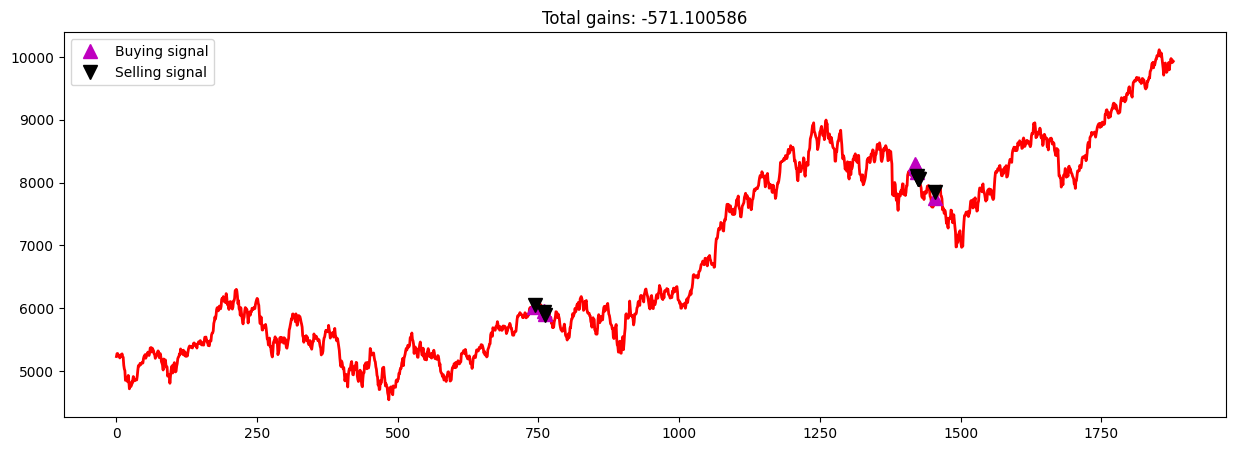

Training in progress...: 100%|██████████| 1878/1878 [06:42<00:00,  4.67it/s]


Running episode 5/10


Training in progress...:   0%|          | 0/1878 [00:00<?, ?it/s]

[[0.         0.         0.51571491]] 2


Training in progress...:   0%|          | 1/1878 [00:00<08:53,  3.52it/s]

[[0.        0.        0.5644603]] 2


Training in progress...:   0%|          | 2/1878 [00:00<09:25,  3.32it/s]

[[0.        0.        0.6494577]] 2


Training in progress...:   0%|          | 3/1878 [00:00<08:43,  3.58it/s]

[[0.         0.         0.66320246]] 2


Training in progress...:   0%|          | 4/1878 [00:01<08:08,  3.84it/s]

[[0.         0.         0.65416909]] 2


Training in progress...:   0%|          | 5/1878 [00:01<08:04,  3.87it/s]

[[0.         0.         0.69613044]] 2


Training in progress...:   0%|          | 6/1878 [00:01<08:15,  3.78it/s]

[[0.         0.         0.65411679]] 2


Training in progress...:   0%|          | 7/1878 [00:01<08:13,  3.79it/s]

[[0.         0.         0.51343772]] 2


Training in progress...:   0%|          | 8/1878 [00:02<08:31,  3.65it/s]

[[0.         0.         0.51053739]] 2


Training in progress...:   0%|          | 9/1878 [00:02<08:23,  3.71it/s]

[[0.         0.         0.48677026]] 2


Training in progress...:   1%|          | 10/1878 [00:02<08:18,  3.75it/s]

[[0.         0.         0.57417381]] 2


Training in progress...:   1%|          | 11/1878 [00:02<08:12,  3.79it/s]

[[0.        0.        0.3623406]] 2


Training in progress...:   1%|          | 12/1878 [00:03<08:32,  3.64it/s]

[[0.        0.        0.2000978]] 2


Training in progress...:   1%|          | 14/1878 [00:03<08:04,  3.85it/s]

[[0.         0.         0.12884037]] 2
[[0.         0.         0.27709389]] 2


Training in progress...:   1%|          | 16/1878 [00:04<07:02,  4.41it/s]

[[0.        0.        0.3462977]] 2
[[0.         0.         0.32261097]] 2


Training in progress...:   1%|          | 18/1878 [00:04<06:41,  4.63it/s]

[[0.10086313 0.         0.06017263]] 0
[[0.08765025 0.         0.04535763]] 0


Training in progress...:   1%|          | 20/1878 [00:04<06:19,  4.89it/s]

[[0. 0. 0.]] 0
[[0.         0.         0.03426755]] 2


Training in progress...:   1%|          | 22/1878 [00:05<06:24,  4.83it/s]

[[0.         0.         0.05272793]] 2
[[0.         0.         0.05218916]] 2


Training in progress...:   1%|▏         | 24/1878 [00:05<06:20,  4.87it/s]

[[0.         0.11377917 0.17094839]] 2
[[0.         0.02918512 0.32123517]] 2


Training in progress...:   1%|▏         | 26/1878 [00:06<06:16,  4.92it/s]

[[0.         0.         0.42522651]] 2
[[0.       0.       0.459286]] 2


Training in progress...:   1%|▏         | 27/1878 [00:06<06:27,  4.77it/s]

[[0.00600039 0.         0.51249837]] 2


Training in progress...:   2%|▏         | 29/1878 [00:06<06:31,  4.72it/s]

[[0.         0.         0.67122208]] 2
[[0.         0.04850231 0.75248036]] 2


Training in progress...:   2%|▏         | 30/1878 [00:07<06:36,  4.66it/s]

[[0.         0.         0.83797329]] 2


Training in progress...:   2%|▏         | 31/1878 [00:07<06:41,  4.60it/s]

[[0.         0.         0.83840644]] 2


Training in progress...:   2%|▏         | 33/1878 [00:07<06:35,  4.66it/s]

[[0.         0.         0.86440051]] 2
[[0.         0.         0.83228007]] 2


Training in progress...:   2%|▏         | 35/1878 [00:08<06:17,  4.88it/s]

[[0.         0.         0.89071902]] 2
[[0.         0.         0.83269652]] 2


Training in progress...:   2%|▏         | 37/1878 [00:08<06:22,  4.81it/s]

[[0.         0.         0.92434298]] 2
[[0.         0.         0.97303446]] 2


Training in progress...:   2%|▏         | 39/1878 [00:08<06:07,  5.01it/s]

[[0.         0.         0.87200032]] 2
[[0.         0.         0.81532534]] 2


Training in progress...:   2%|▏         | 40/1878 [00:09<06:07,  5.01it/s]

[[0.         0.         0.65179105]] 2


Training in progress...:   2%|▏         | 42/1878 [00:09<06:11,  4.94it/s]

[[0.         0.         0.54708427]] 2
[[0.         0.         0.55604329]] 2


Training in progress...:   2%|▏         | 44/1878 [00:09<06:02,  5.06it/s]

[[0.         0.         0.51879314]] 2
[[0.         0.         0.56659681]] 2


Training in progress...:   2%|▏         | 45/1878 [00:10<06:04,  5.03it/s]

[[0.         0.         0.69705408]] 2


Training in progress...:   3%|▎         | 47/1878 [00:10<06:12,  4.92it/s]

[[0.         0.         0.72369848]] 2
[[0.        0.        0.6083268]] 2


Training in progress...:   3%|▎         | 49/1878 [00:10<06:14,  4.88it/s]

[[0.         0.         0.63603413]] 2
[[0.         0.         0.79605381]] 2


Training in progress...:   3%|▎         | 50/1878 [00:11<06:17,  4.84it/s]

[[0.        0.        0.7292593]] 2


Training in progress...:   3%|▎         | 51/1878 [00:11<06:33,  4.64it/s]

[[0.         0.         0.66720607]] 2


Training in progress...:   3%|▎         | 53/1878 [00:11<06:20,  4.79it/s]

[[0.         0.         0.59169233]] 2
[[0.         0.         0.56182276]] 2


Training in progress...:   3%|▎         | 55/1878 [00:12<06:15,  4.85it/s]

[[0.         0.         0.58141316]] 2
[[0.         0.         0.59148605]] 2


Training in progress...:   3%|▎         | 57/1878 [00:12<06:22,  4.76it/s]

[[0.         0.         0.64156221]] 2
[[0.         0.         0.75081058]] 2


Training in progress...:   3%|▎         | 59/1878 [00:13<06:06,  4.96it/s]

[[0.         0.         0.63097159]] 2
[[0.         0.         0.59871267]] 2


Training in progress...:   3%|▎         | 60/1878 [00:13<06:09,  4.91it/s]

[[0.         0.         0.70706486]] 2


Training in progress...:   3%|▎         | 61/1878 [00:13<06:14,  4.86it/s]

[[0.         0.         0.70518504]] 2


Training in progress...:   3%|▎         | 62/1878 [00:13<06:36,  4.58it/s]

[[0.07047909 0.         0.7566547 ]] 2


Training in progress...:   3%|▎         | 63/1878 [00:13<06:56,  4.36it/s]

[[0.         0.         0.81838556]] 2


Training in progress...:   3%|▎         | 64/1878 [00:14<07:04,  4.28it/s]

[[0.         0.         0.83845804]] 2


Training in progress...:   3%|▎         | 65/1878 [00:14<07:32,  4.01it/s]

[[0.         0.         0.78765972]] 2


Training in progress...:   4%|▎         | 66/1878 [00:14<07:23,  4.09it/s]

[[0.         0.03553145 0.68805977]] 2


Training in progress...:   4%|▎         | 67/1878 [00:15<07:30,  4.02it/s]

[[0.         0.         0.64902119]] 2


Training in progress...:   4%|▎         | 68/1878 [00:15<07:25,  4.06it/s]

[[0.         0.10633578 0.51706363]] 2


Training in progress...:   4%|▎         | 69/1878 [00:15<07:41,  3.92it/s]

[[0.17793192 0.17672581 0.40440567]] 2


Training in progress...:   4%|▎         | 70/1878 [00:15<07:28,  4.03it/s]

[[0.3301899  0.09721923 0.39054907]] 2


Training in progress...:   4%|▍         | 71/1878 [00:16<07:39,  3.93it/s]

[[0.24983931 0.17133273 0.70690076]] 2


Training in progress...:   4%|▍         | 72/1878 [00:16<07:40,  3.92it/s]

[[0.07030363 0.18179229 0.57200432]] 2


Training in progress...:   4%|▍         | 73/1878 [00:16<08:04,  3.73it/s]

[[0.         0.07198861 0.57222508]] 2


Training in progress...:   4%|▍         | 74/1878 [00:16<07:57,  3.78it/s]

[[0.06580723 0.01089996 0.5075522 ]] 2


Training in progress...:   4%|▍         | 75/1878 [00:17<07:53,  3.81it/s]

[[0.        0.        0.5935618]] 2


Training in progress...:   4%|▍         | 76/1878 [00:17<08:07,  3.69it/s]

[[0.         0.         0.62280388]] 2


Training in progress...:   4%|▍         | 77/1878 [00:17<08:15,  3.63it/s]

[[0.         0.         0.72995752]] 2


Training in progress...:   4%|▍         | 78/1878 [00:17<08:07,  3.70it/s]

[[0.         0.         0.69093252]] 2


Training in progress...:   4%|▍         | 79/1878 [00:18<08:06,  3.70it/s]

[[0.         0.         0.73598691]] 2


Training in progress...:   4%|▍         | 80/1878 [00:18<08:19,  3.60it/s]

[[0.         0.         0.47401852]] 2


Training in progress...:   4%|▍         | 81/1878 [00:18<08:20,  3.59it/s]

[[0.         0.0274849  0.27666885]] 2


Training in progress...:   4%|▍         | 82/1878 [00:19<08:13,  3.64it/s]

[[0.         0.         0.29548028]] 2


Training in progress...:   4%|▍         | 83/1878 [00:19<08:29,  3.53it/s]

[[0.         0.         0.42489873]] 2


Training in progress...:   5%|▍         | 85/1878 [00:19<07:19,  4.08it/s]

[[0.         0.02461294 0.42938525]] 2
[[0.         0.02699928 0.46909093]] 2


Training in progress...:   5%|▍         | 87/1878 [00:20<06:44,  4.43it/s]

[[0.         0.         0.50062404]] 2
[[0.         0.         0.43886434]] 2


Training in progress...:   5%|▍         | 89/1878 [00:20<06:26,  4.63it/s]

[[0.         0.         0.58257384]] 2
[[0.         0.         0.49167944]] 2


Training in progress...:   5%|▍         | 90/1878 [00:20<06:27,  4.61it/s]

[[0.         0.         0.41156866]] 2


Training in progress...:   5%|▍         | 92/1878 [00:21<06:15,  4.75it/s]

[[0.         0.         0.43903553]] 2
[[0.         0.         0.51395838]] 2


Training in progress...:   5%|▌         | 94/1878 [00:21<06:16,  4.74it/s]

[[0.         0.         0.63699093]] 2
[[0.         0.         0.54755171]] 2


Training in progress...:   5%|▌         | 96/1878 [00:22<06:10,  4.81it/s]

[[0.         0.         0.62841404]] 2
[[0.         0.         0.58114994]] 2


Training in progress...:   5%|▌         | 97/1878 [00:22<06:17,  4.72it/s]

[[0.         0.         0.50936165]] 2


Training in progress...:   5%|▌         | 98/1878 [00:22<06:30,  4.56it/s]

[[0.         0.         0.43137828]] 2


Training in progress...:   5%|▌         | 99/1878 [00:22<06:24,  4.63it/s]

[[0.         0.         0.42031714]] 2


Training in progress...:   5%|▌         | 100/1878 [00:22<06:21,  4.65it/s]

[[0.         0.         0.51446183]] 2


Training in progress...:   5%|▌         | 101/1878 [00:23<06:23,  4.63it/s]

[[0.         0.         0.50760971]] 2


Training in progress...:   5%|▌         | 102/1878 [00:23<06:36,  4.48it/s]

[[0.        0.        0.5806258]] 2


Training in progress...:   5%|▌         | 103/1878 [00:23<06:33,  4.52it/s]

[[0.         0.         0.59101737]] 2


Training in progress...:   6%|▌         | 104/1878 [00:23<06:26,  4.59it/s]

[[0.         0.         0.48710044]] 2


Training in progress...:   6%|▌         | 105/1878 [00:24<06:25,  4.60it/s]

[[0.         0.         0.46086191]] 2


Training in progress...:   6%|▌         | 106/1878 [00:24<06:30,  4.53it/s]

[[0.         0.         0.64929693]] 2


Training in progress...:   6%|▌         | 107/1878 [00:24<06:37,  4.45it/s]

[[0.      0.      0.67374]] 2


Training in progress...:   6%|▌         | 109/1878 [00:24<06:18,  4.67it/s]

[[0.         0.         0.48489067]] 2
[[0.        0.        0.6344561]] 2


Training in progress...:   6%|▌         | 110/1878 [00:25<06:16,  4.70it/s]

[[0.         0.         0.60274238]] 2


Training in progress...:   6%|▌         | 111/1878 [00:25<06:15,  4.70it/s]

[[0.         0.         0.58896114]] 2


Training in progress...:   6%|▌         | 113/1878 [00:25<06:15,  4.70it/s]

[[0.         0.         0.54946121]] 2
[[0.         0.         0.54051592]] 2


Training in progress...:   6%|▌         | 114/1878 [00:25<06:16,  4.68it/s]

[[0.         0.         0.45013595]] 2


Training in progress...:   6%|▌         | 115/1878 [00:26<06:19,  4.64it/s]

[[0.         0.         0.59137312]] 2


Training in progress...:   6%|▌         | 116/1878 [00:26<06:26,  4.55it/s]

[[0.         0.         0.66813884]] 2


Training in progress...:   6%|▌         | 117/1878 [00:26<06:20,  4.63it/s]

[[0.         0.         0.59154187]] 2


Training in progress...:   6%|▋         | 118/1878 [00:26<06:23,  4.59it/s]

[[0.         0.         0.44826795]] 2


Training in progress...:   6%|▋         | 119/1878 [00:27<06:30,  4.50it/s]

[[0.        0.        0.2987055]] 2


Training in progress...:   6%|▋         | 120/1878 [00:27<06:28,  4.52it/s]

[[0.        0.        0.3559967]] 2


Training in progress...:   6%|▋         | 122/1878 [00:27<06:22,  4.60it/s]

[[0.         0.         0.27609435]] 2
[[0.         0.         0.42154037]] 2


Training in progress...:   7%|▋         | 123/1878 [00:27<06:16,  4.66it/s]

[[0.        0.        0.3207922]] 2


Training in progress...:   7%|▋         | 124/1878 [00:28<06:20,  4.61it/s]

[[0.         0.         0.01695603]] 2


Training in progress...:   7%|▋         | 125/1878 [00:28<06:28,  4.52it/s]

[[0.         0.         0.10629286]] 2


Training in progress...:   7%|▋         | 126/1878 [00:28<06:31,  4.48it/s]

[[0.         0.         0.00673439]] 2


Training in progress...:   7%|▋         | 127/1878 [00:28<06:26,  4.53it/s]

[[0.         0.         0.11495072]] 2


Training in progress...:   7%|▋         | 128/1878 [00:29<06:27,  4.52it/s]

[[0.         0.         0.24823841]] 2


Training in progress...:   7%|▋         | 129/1878 [00:29<06:33,  4.45it/s]

[[0.         0.         0.28034783]] 2


Training in progress...:   7%|▋         | 130/1878 [00:29<06:52,  4.24it/s]

[[0.       0.       0.192553]] 2


Training in progress...:   7%|▋         | 131/1878 [00:29<07:00,  4.15it/s]

[[0.         0.         0.17879526]] 2


Training in progress...:   7%|▋         | 132/1878 [00:30<06:59,  4.16it/s]

[[0.         0.         0.32433073]] 2


Training in progress...:   7%|▋         | 133/1878 [00:30<07:08,  4.07it/s]

[[0.         0.         0.55133687]] 2


Training in progress...:   7%|▋         | 134/1878 [00:30<07:30,  3.87it/s]

[[0.         0.         0.45263008]] 2


Training in progress...:   7%|▋         | 135/1878 [00:30<07:25,  3.91it/s]

[[0.         0.         0.57908109]] 2


Training in progress...:   7%|▋         | 136/1878 [00:31<07:19,  3.96it/s]

[[0.         0.         0.36876468]] 2


Training in progress...:   7%|▋         | 137/1878 [00:31<07:19,  3.96it/s]

[[0.         0.         0.28154482]] 2


Training in progress...:   7%|▋         | 138/1878 [00:31<07:11,  4.03it/s]

[[0.         0.         0.29970193]] 2


Training in progress...:   7%|▋         | 139/1878 [00:31<07:20,  3.95it/s]

[[0.         0.         0.28399328]] 2


Training in progress...:   7%|▋         | 140/1878 [00:32<07:15,  4.00it/s]

[[0.         0.         0.29546147]] 2


Training in progress...:   8%|▊         | 141/1878 [00:32<07:30,  3.85it/s]

[[0.         0.         0.35420645]] 2


Training in progress...:   8%|▊         | 142/1878 [00:32<07:28,  3.87it/s]

[[0.         0.         0.18721264]] 2


Training in progress...:   8%|▊         | 143/1878 [00:32<07:20,  3.94it/s]

[[0.        0.        0.0914397]] 2


Training in progress...:   8%|▊         | 144/1878 [00:33<07:33,  3.82it/s]

[[0.         0.         0.17904308]] 2


Training in progress...:   8%|▊         | 145/1878 [00:33<07:42,  3.75it/s]

[[0.         0.         0.12751926]] 2


Training in progress...:   8%|▊         | 146/1878 [00:33<07:41,  3.76it/s]

[[0.02337509 0.         0.14768303]] 2


Training in progress...:   8%|▊         | 147/1878 [00:33<07:49,  3.69it/s]

[[0.         0.         0.32264745]] 2


Training in progress...:   8%|▊         | 148/1878 [00:34<08:03,  3.58it/s]

[[0.         0.03768751 0.23279384]] 2


Training in progress...:   8%|▊         | 149/1878 [00:34<08:14,  3.50it/s]

[[0.02937991 0.         0.31960917]] 2


Training in progress...:   8%|▊         | 150/1878 [00:34<08:15,  3.48it/s]

[[0.         0.         0.26480515]] 2


Training in progress...:   8%|▊         | 151/1878 [00:35<08:11,  3.52it/s]

[[0.         0.03906337 0.23407775]] 2


Training in progress...:   8%|▊         | 152/1878 [00:35<07:39,  3.76it/s]

[[0.         0.08732833 0.27728992]] 2


Training in progress...:   8%|▊         | 153/1878 [00:35<07:12,  3.99it/s]

[[0.00793954 0.04110781 0.3959714 ]] 2


Training in progress...:   8%|▊         | 154/1878 [00:35<07:03,  4.07it/s]

[[0.00827434 0.         0.4895008 ]] 2


Training in progress...:   8%|▊         | 155/1878 [00:36<06:42,  4.28it/s]

[[0.03159736 0.         0.44632662]] 2


Training in progress...:   8%|▊         | 156/1878 [00:36<06:37,  4.33it/s]

[[0.06699944 0.         0.40101889]] 2


Training in progress...:   8%|▊         | 157/1878 [00:36<06:30,  4.41it/s]

[[0.         0.         0.28388319]] 2


Training in progress...:   8%|▊         | 158/1878 [00:36<06:20,  4.53it/s]

[[0.18974914 0.         0.23424663]] 2


Training in progress...:   9%|▊         | 160/1878 [00:37<06:20,  4.52it/s]

[[0.18546614 0.         0.34100683]] 2
[[0.28385379 0.03145824 0.50183822]] 2


Training in progress...:   9%|▊         | 162/1878 [00:37<06:05,  4.69it/s]

[[0.39942229 0.06991448 0.39654071]] 0
[[0.20376592 0.         0.49638301]] 2


Training in progress...:   9%|▊         | 163/1878 [00:37<06:06,  4.68it/s]

[[0.20183354 0.         0.5263014 ]] 2


Training in progress...:   9%|▉         | 165/1878 [00:38<06:05,  4.68it/s]

[[0.0965724  0.03551398 0.37350679]] 2


Training in progress...:   9%|▉         | 167/1878 [00:38<05:59,  4.76it/s]

[[0.        0.        0.3564545]] 2
[[0.         0.         0.33083235]] 2
[[0.         0.         0.36345642]] 2


Training in progress...:   9%|▉         | 168/1878 [00:38<06:03,  4.70it/s]

[[0.         0.         0.39102402]] 2


Training in progress...:   9%|▉         | 169/1878 [00:39<06:13,  4.58it/s]

[[0.         0.03420939 0.41249679]] 2


Training in progress...:   9%|▉         | 170/1878 [00:39<06:14,  4.57it/s]

[[0.         0.         0.48393863]] 2


Training in progress...:   9%|▉         | 171/1878 [00:39<06:17,  4.52it/s]

[[0.         0.02450171 0.29242189]] 2


Training in progress...:   9%|▉         | 173/1878 [00:39<05:59,  4.74it/s]

[[0.         0.         0.32903428]] 2
[[0.         0.         0.47862128]] 2


Training in progress...:   9%|▉         | 174/1878 [00:40<06:11,  4.58it/s]

[[0.         0.         0.46343448]] 2


Training in progress...:   9%|▉         | 176/1878 [00:40<05:59,  4.74it/s]

[[0.         0.         0.58220839]] 2
[[0.         0.         0.69962027]] 2


Training in progress...:   9%|▉         | 177/1878 [00:40<06:03,  4.68it/s]

[[0.         0.         0.58911918]] 2


Training in progress...:   9%|▉         | 178/1878 [00:41<06:08,  4.61it/s]

[[0.        0.        0.5007591]] 2


Training in progress...:  10%|▉         | 179/1878 [00:41<06:12,  4.57it/s]

[[0.11332055 0.         0.53668465]] 2


Training in progress...:  10%|▉         | 181/1878 [00:41<06:05,  4.64it/s]

[[0.         0.         0.49491443]] 2
[[0.         0.         0.43582713]] 2


Training in progress...:  10%|▉         | 183/1878 [00:42<05:51,  4.82it/s]

[[0.01704655 0.         0.50862586]] 2
[[0.        0.        0.4998031]] 2


Training in progress...:  10%|▉         | 185/1878 [00:42<05:52,  4.80it/s]

[[0.18792719 0.         0.48836925]] 2
[[0.         0.         0.41657924]] 2


Training in progress...:  10%|▉         | 186/1878 [00:42<05:59,  4.71it/s]

[[0.         0.         0.60878577]] 2


Training in progress...:  10%|▉         | 187/1878 [00:42<06:01,  4.68it/s]

[[0.        0.        0.7160382]] 2


Training in progress...:  10%|█         | 188/1878 [00:43<06:08,  4.58it/s]

[[0.         0.         0.69650004]] 2


Training in progress...:  10%|█         | 190/1878 [00:43<06:02,  4.66it/s]

[[0.       0.       0.494227]] 2


Training in progress...:  10%|█         | 191/1878 [00:43<05:56,  4.73it/s]

[[0.         0.         0.49739345]] 2
[[0.         0.         0.56437704]] 2


Training in progress...:  10%|█         | 193/1878 [00:44<05:50,  4.81it/s]

[[0.         0.         0.45132013]] 2
[[0.         0.         0.44247243]] 2


Training in progress...:  10%|█         | 195/1878 [00:44<05:50,  4.80it/s]

[[0.05605347 0.         0.48463269]] 2
[[0.18488808 0.         0.47141976]] 2


Training in progress...:  10%|█         | 197/1878 [00:45<05:43,  4.89it/s]

[[0.16146489 0.         0.45430512]] 2
[[0.30349517 0.         0.42051502]] 2


Training in progress...:  11%|█         | 198/1878 [00:45<05:59,  4.67it/s]

[[0.32700278 0.         0.55655575]] 2


Training in progress...:  11%|█         | 199/1878 [00:45<06:35,  4.25it/s]

[[0.09717161 0.         0.42960156]] 2


Training in progress...:  11%|█         | 200/1878 [00:45<06:48,  4.11it/s]

[[0.         0.00951479 0.61226112]] 2


Training in progress...:  11%|█         | 201/1878 [00:46<06:47,  4.12it/s]

[[0.         0.04532809 0.46300437]] 2


Training in progress...:  11%|█         | 202/1878 [00:46<06:55,  4.03it/s]

[[0.         0.         0.34341333]] 2


Training in progress...:  11%|█         | 203/1878 [00:46<07:06,  3.93it/s]

[[0.         0.         0.28196773]] 2


Training in progress...:  11%|█         | 204/1878 [00:46<07:02,  3.97it/s]

[[0.         0.         0.20832104]] 2


Training in progress...:  11%|█         | 205/1878 [00:47<06:56,  4.01it/s]

[[0.         0.05599887 0.19244708]] 2


Training in progress...:  11%|█         | 206/1878 [00:47<06:44,  4.13it/s]

[[0.         0.         0.10884646]] 2


Training in progress...:  11%|█         | 207/1878 [00:47<07:06,  3.91it/s]

[[0.         0.12210059 0.11047233]] 1


Training in progress...:  11%|█         | 208/1878 [00:47<07:06,  3.92it/s]

[[0.         0.         0.11547757]] 2


Training in progress...:  11%|█         | 209/1878 [00:48<07:04,  3.93it/s]

[[0.         0.         0.19734612]] 2


Training in progress...:  11%|█         | 210/1878 [00:48<07:11,  3.87it/s]

[[0.        0.        0.1528535]] 2


Training in progress...:  11%|█         | 211/1878 [00:48<07:09,  3.88it/s]

[[0.         0.         0.26512535]] 2


Training in progress...:  11%|█▏        | 212/1878 [00:48<07:13,  3.85it/s]

[[0.         0.         0.23295114]] 2


Training in progress...:  11%|█▏        | 213/1878 [00:49<07:30,  3.70it/s]

[[0.         0.         0.26287178]] 2


Training in progress...:  11%|█▏        | 214/1878 [00:49<07:38,  3.63it/s]

[[0.        0.        0.2606653]] 2


Training in progress...:  11%|█▏        | 215/1878 [00:49<07:40,  3.61it/s]

[[0.        0.        0.1971252]] 2


Training in progress...:  12%|█▏        | 216/1878 [00:49<07:35,  3.65it/s]

[[0.         0.         0.43840548]] 2


Training in progress...:  12%|█▏        | 217/1878 [00:50<07:47,  3.55it/s]

[[0.        0.        0.4871096]] 2


Training in progress...:  12%|█▏        | 218/1878 [00:50<08:02,  3.44it/s]

[[0.         0.         0.51630161]] 2


Training in progress...:  12%|█▏        | 219/1878 [00:50<08:09,  3.39it/s]

[[0.         0.         0.62656874]] 2


Training in progress...:  12%|█▏        | 220/1878 [00:51<08:21,  3.30it/s]

[[0.         0.         0.70988848]] 2


Training in progress...:  12%|█▏        | 221/1878 [00:51<07:36,  3.63it/s]

[[0.         0.         0.66217239]] 2


Training in progress...:  12%|█▏        | 222/1878 [00:51<07:07,  3.87it/s]

[[0.         0.         0.74318666]] 2


Training in progress...:  12%|█▏        | 223/1878 [00:51<06:49,  4.05it/s]

[[0.01490308 0.         0.54752344]] 2


Training in progress...:  12%|█▏        | 224/1878 [00:52<06:34,  4.19it/s]

[[0.01523738 0.         0.44639702]] 2


Training in progress...:  12%|█▏        | 225/1878 [00:52<06:18,  4.37it/s]

[[0.         0.         0.51745296]] 2


Training in progress...:  12%|█▏        | 226/1878 [00:52<06:24,  4.30it/s]

[[0.         0.         0.28987843]] 2


Training in progress...:  12%|█▏        | 227/1878 [00:52<06:17,  4.37it/s]

[[0.        0.        0.3914187]] 2


Training in progress...:  12%|█▏        | 228/1878 [00:52<06:11,  4.44it/s]

[[0.         0.         0.49060976]] 2


Training in progress...:  12%|█▏        | 229/1878 [00:53<06:02,  4.55it/s]

[[0.         0.         0.28960523]] 2


Training in progress...:  12%|█▏        | 230/1878 [00:53<06:05,  4.50it/s]

[[0.         0.         0.59399733]] 2


Training in progress...:  12%|█▏        | 231/1878 [00:53<06:08,  4.46it/s]

[[0.         0.         0.51684118]] 2


Training in progress...:  12%|█▏        | 233/1878 [00:54<05:53,  4.65it/s]

[[0.         0.         0.55222568]] 2
[[0.         0.         0.43450396]] 2


Training in progress...:  13%|█▎        | 235/1878 [00:54<05:47,  4.73it/s]

[[0.         0.         0.47806448]] 2


Training in progress...:  13%|█▎        | 236/1878 [00:54<05:44,  4.76it/s]

[[0.         0.         0.71002778]] 2
[[0.         0.         0.57609716]] 2


Training in progress...:  13%|█▎        | 237/1878 [00:54<05:49,  4.69it/s]

[[0.         0.         0.45182185]] 2


Training in progress...:  13%|█▎        | 239/1878 [00:55<05:36,  4.87it/s]

[[0.       0.       0.333158]] 2
[[0.         0.         0.33288107]] 2


Training in progress...:  13%|█▎        | 241/1878 [00:55<05:37,  4.84it/s]

[[0.         0.         0.44573773]] 2
[[0.         0.         0.49380433]] 2


Training in progress...:  13%|█▎        | 242/1878 [00:55<05:39,  4.81it/s]

[[0.         0.         0.38758918]] 2


Training in progress...:  13%|█▎        | 243/1878 [00:56<05:43,  4.76it/s]

[[0.         0.         0.40169181]] 2


Training in progress...:  13%|█▎        | 245/1878 [00:56<05:50,  4.66it/s]

[[0.         0.         0.53295947]] 2
[[0.         0.         0.70458357]] 2


Training in progress...:  13%|█▎        | 247/1878 [00:57<05:49,  4.67it/s]

[[0.         0.         0.68464721]] 2
[[0.         0.         0.61660755]] 2


Training in progress...:  13%|█▎        | 248/1878 [00:57<05:50,  4.66it/s]

[[0.         0.         0.64823292]] 2


Training in progress...:  13%|█▎        | 249/1878 [00:57<05:46,  4.71it/s]

[[0.01276876 0.         0.71559965]] 2


Training in progress...:  13%|█▎        | 250/1878 [00:57<05:43,  4.74it/s]

[[0.         0.         0.86295617]] 2


Training in progress...:  13%|█▎        | 251/1878 [00:57<05:41,  4.76it/s]

[[0.         0.         0.59053452]] 2


Training in progress...:  13%|█▎        | 252/1878 [00:58<05:41,  4.76it/s]

[[0.03588949 0.         0.54035244]] 2


Training in progress...:  13%|█▎        | 253/1878 [00:58<05:45,  4.71it/s]

[[0.03611486 0.         0.40649046]] 2


Training in progress...:  14%|█▎        | 255/1878 [00:58<05:39,  4.78it/s]

[[0.         0.         0.58027738]] 2
[[0.         0.         0.53598127]] 2


Training in progress...:  14%|█▎        | 257/1878 [00:59<05:32,  4.88it/s]

[[0.10116776 0.         0.61888512]] 2
[[0.0853545  0.         0.48711318]] 2


Training in progress...:  14%|█▍        | 259/1878 [00:59<05:37,  4.80it/s]

[[0.         0.         0.43935729]] 2
[[0.         0.         0.56752294]] 2


Training in progress...:  14%|█▍        | 260/1878 [00:59<05:39,  4.76it/s]

[[0.         0.         0.43355708]] 2


Training in progress...:  14%|█▍        | 261/1878 [00:59<05:44,  4.69it/s]

[[0.         0.         0.51390251]] 2


Training in progress...:  14%|█▍        | 262/1878 [01:00<05:44,  4.69it/s]

[[0.         0.         0.59536778]] 2


Training in progress...:  14%|█▍        | 264/1878 [01:00<05:40,  4.74it/s]

[[0.         0.         0.46924213]] 2
[[0.         0.         0.56062328]] 2


Training in progress...:  14%|█▍        | 266/1878 [01:01<05:34,  4.82it/s]

[[0.         0.         0.47107654]] 2
[[0.         0.         0.51571922]] 2


Training in progress...:  14%|█▍        | 267/1878 [01:01<05:56,  4.52it/s]

[[0.         0.         0.61680324]] 2


Training in progress...:  14%|█▍        | 268/1878 [01:01<06:38,  4.04it/s]

[[0.         0.         0.65907872]] 2


Training in progress...:  14%|█▍        | 269/1878 [01:01<06:30,  4.12it/s]

[[0.         0.         0.67883577]] 2


Training in progress...:  14%|█▍        | 270/1878 [01:02<06:33,  4.09it/s]

[[0.00845231 0.         0.5261957 ]] 2


Training in progress...:  14%|█▍        | 271/1878 [01:02<06:30,  4.12it/s]

[[0.         0.         0.61556921]] 2


Training in progress...:  14%|█▍        | 272/1878 [01:02<06:38,  4.03it/s]

[[0.03149131 0.         0.50614443]] 2


Training in progress...:  15%|█▍        | 273/1878 [01:02<06:37,  4.04it/s]

[[0.07603412 0.         0.52241512]] 2


Training in progress...:  15%|█▍        | 274/1878 [01:03<06:37,  4.03it/s]

[[0.17367073 0.         0.52997008]] 2


Training in progress...:  15%|█▍        | 275/1878 [01:03<06:36,  4.05it/s]

[[0.         0.         0.58294237]] 2


Training in progress...:  15%|█▍        | 276/1878 [01:03<06:56,  3.84it/s]

[[0.08808589 0.         0.4237033 ]] 2


Training in progress...:  15%|█▍        | 277/1878 [01:03<06:46,  3.94it/s]

[[0.06975607 0.         0.57685742]] 2


Training in progress...:  15%|█▍        | 278/1878 [01:04<06:50,  3.90it/s]

[[0.10181123 0.         0.46611392]] 2


Training in progress...:  15%|█▍        | 279/1878 [01:04<06:46,  3.94it/s]

[[0.         0.         0.41962755]] 2


Training in progress...:  15%|█▍        | 280/1878 [01:04<06:33,  4.07it/s]

[[0.         0.         0.45932258]] 2


Training in progress...:  15%|█▍        | 281/1878 [01:04<06:40,  3.99it/s]

[[0.         0.         0.56610459]] 2


Training in progress...:  15%|█▌        | 282/1878 [01:05<06:53,  3.86it/s]

[[0.         0.         0.53185282]] 2


Training in progress...:  15%|█▌        | 283/1878 [01:05<07:17,  3.64it/s]

[[0.         0.         0.43914659]] 2


Training in progress...:  15%|█▌        | 284/1878 [01:05<07:15,  3.66it/s]

[[0.         0.         0.54839074]] 2


Training in progress...:  15%|█▌        | 285/1878 [01:05<07:11,  3.69it/s]

[[0.         0.         0.51235765]] 2


Training in progress...:  15%|█▌        | 286/1878 [01:06<07:31,  3.52it/s]

[[0.         0.         0.59102317]] 2


Training in progress...:  15%|█▌        | 287/1878 [01:06<07:47,  3.40it/s]

[[0.05727592 0.         0.57058295]] 2


Training in progress...:  15%|█▌        | 288/1878 [01:06<07:48,  3.39it/s]

[[0.20637205 0.         0.44335595]] 2


Training in progress...:  15%|█▌        | 289/1878 [01:07<07:49,  3.38it/s]

[[0.19545733 0.         0.45055332]] 2


Training in progress...:  15%|█▌        | 291/1878 [01:07<06:46,  3.90it/s]

[[0.15393025 0.         0.34391904]] 2
[[0.01592197 0.         0.41083756]] 2


Training in progress...:  16%|█▌        | 293/1878 [01:08<05:57,  4.44it/s]

[[0.        0.        0.3328776]] 2
[[0.         0.         0.29758635]] 2


Training in progress...:  16%|█▌        | 294/1878 [01:08<05:54,  4.47it/s]

[[0.00389909 0.         0.24499965]] 2


Training in progress...:  16%|█▌        | 295/1878 [01:08<05:54,  4.47it/s]

[[0.0728233  0.         0.24145333]] 2


Training in progress...:  16%|█▌        | 297/1878 [01:08<05:36,  4.69it/s]

[[0.         0.         0.32238354]] 2
[[0.         0.         0.34343739]] 2


Training in progress...:  16%|█▌        | 299/1878 [01:09<05:31,  4.76it/s]

[[0.         0.         0.38195746]] 2
[[5.22622534e-06 0.00000000e+00 2.61608183e-01]] 2


Training in progress...:  16%|█▌        | 301/1878 [01:09<05:34,  4.71it/s]

[[0.         0.         0.34176699]] 2
[[0.         0.         0.13525529]] 2


Training in progress...:  16%|█▌        | 303/1878 [01:10<05:22,  4.89it/s]

[[0.         0.         0.52479137]] 2
[[0.         0.         0.38929974]] 2


Training in progress...:  16%|█▌        | 304/1878 [01:10<05:31,  4.75it/s]

[[0.         0.         0.41947651]] 2


Training in progress...:  16%|█▌        | 305/1878 [01:10<05:33,  4.71it/s]

[[0.         0.         0.57205133]] 2


Training in progress...:  16%|█▋        | 306/1878 [01:10<05:39,  4.63it/s]

[[0.         0.         0.49761555]] 2


Training in progress...:  16%|█▋        | 307/1878 [01:11<05:41,  4.59it/s]

[[0.        0.        0.3270952]] 2


Training in progress...:  16%|█▋        | 308/1878 [01:11<05:39,  4.62it/s]

[[0.         0.05959467 0.42753017]] 2


Training in progress...:  16%|█▋        | 309/1878 [01:11<05:51,  4.47it/s]

[[0.01157074 0.         0.27318357]] 2


Training in progress...:  17%|█▋        | 310/1878 [01:11<05:44,  4.55it/s]

[[0.         0.         0.29972818]] 2


Training in progress...:  17%|█▋        | 311/1878 [01:11<05:39,  4.61it/s]

[[0.04514825 0.         0.39012548]] 2


Training in progress...:  17%|█▋        | 313/1878 [01:12<05:35,  4.66it/s]

[[0.05755673 0.         0.51739212]] 2
[[0.12119317 0.         0.59746745]] 2


Training in progress...:  17%|█▋        | 315/1878 [01:12<05:35,  4.66it/s]

[[0.13108361 0.         0.35978266]] 2
[[0.        0.        0.3444816]] 2


Training in progress...:  17%|█▋        | 317/1878 [01:13<05:22,  4.83it/s]

[[0.         0.         0.36688672]] 2
[[0.         0.         0.42257389]] 2


Training in progress...:  17%|█▋        | 319/1878 [01:13<05:27,  4.76it/s]

[[0.        0.        0.1206221]] 2
[[0.         0.         0.29200427]] 2


Training in progress...:  17%|█▋        | 321/1878 [01:13<05:09,  5.03it/s]

[[0.         0.         0.48286936]] 2
[[0.         0.03841737 0.52487239]] 2


Training in progress...:  17%|█▋        | 323/1878 [01:14<05:15,  4.93it/s]

[[0.         0.03710993 0.41202726]] 2
[[0.         0.         0.37007122]] 2


Training in progress...:  17%|█▋        | 325/1878 [01:14<05:20,  4.84it/s]

[[0.         0.         0.41404604]] 2
[[0.         0.         0.45033596]] 2


Training in progress...:  17%|█▋        | 327/1878 [01:15<05:19,  4.86it/s]

[[0.00086912 0.         0.36123384]] 2
[[0.         0.         0.37875044]] 2


Training in progress...:  17%|█▋        | 328/1878 [01:15<05:35,  4.62it/s]

[[0.         0.         0.34105593]] 2


Training in progress...:  18%|█▊        | 330/1878 [01:15<05:27,  4.73it/s]

[[0.         0.         0.47461799]] 2
[[0.         0.         0.45630616]] 2


Training in progress...:  18%|█▊        | 332/1878 [01:16<05:21,  4.82it/s]

[[0.        0.        0.4155253]] 2
[[0.         0.         0.60965394]] 2


Training in progress...:  18%|█▊        | 333/1878 [01:16<05:32,  4.65it/s]

[[0.05235678 0.         0.5423829 ]] 2


Training in progress...:  18%|█▊        | 335/1878 [01:16<05:26,  4.72it/s]

[[0.         0.         0.54433977]] 2
[[0.         0.         0.44183501]] 2


Training in progress...:  18%|█▊        | 336/1878 [01:17<05:29,  4.67it/s]

[[0.         0.         0.42617913]] 2


Training in progress...:  18%|█▊        | 337/1878 [01:17<05:59,  4.29it/s]

[[0.         0.         0.32518127]] 2


Training in progress...:  18%|█▊        | 338/1878 [01:17<06:12,  4.13it/s]

[[0.         0.         0.22642158]] 2


Training in progress...:  18%|█▊        | 339/1878 [01:17<06:26,  3.98it/s]

[[0.         0.         0.26188666]] 2


Training in progress...:  18%|█▊        | 340/1878 [01:18<06:35,  3.89it/s]

[[0.         0.         0.32170332]] 2


Training in progress...:  18%|█▊        | 341/1878 [01:18<06:45,  3.79it/s]

[[0.         0.         0.23740483]] 2


Training in progress...:  18%|█▊        | 342/1878 [01:18<06:40,  3.83it/s]

[[0.         0.         0.27600514]] 2


Training in progress...:  18%|█▊        | 343/1878 [01:19<06:28,  3.95it/s]

[[0.         0.         0.43992999]] 2


Training in progress...:  18%|█▊        | 344/1878 [01:19<06:35,  3.88it/s]

[[0.         0.         0.42854687]] 2


Training in progress...:  18%|█▊        | 345/1878 [01:19<06:36,  3.86it/s]

[[0.         0.         0.46462639]] 2


Training in progress...:  18%|█▊        | 346/1878 [01:19<06:20,  4.03it/s]

[[0.01508713 0.         0.54725451]] 2


Training in progress...:  18%|█▊        | 347/1878 [01:20<06:29,  3.93it/s]

[[0.         0.         0.52848351]] 2


Training in progress...:  19%|█▊        | 348/1878 [01:20<06:17,  4.05it/s]

[[0.         0.         0.48805423]] 2


Training in progress...:  19%|█▊        | 349/1878 [01:20<06:24,  3.98it/s]

[[0.        0.        0.4356451]] 2


Training in progress...:  19%|█▊        | 350/1878 [01:20<06:40,  3.82it/s]

[[0.         0.         0.26576261]] 2


Training in progress...:  19%|█▊        | 351/1878 [01:21<06:53,  3.69it/s]

[[0.         0.         0.13086519]] 2


Training in progress...:  19%|█▊        | 352/1878 [01:21<07:10,  3.55it/s]

[[0.         0.         0.26268468]] 2


Training in progress...:  19%|█▉        | 353/1878 [01:21<07:05,  3.59it/s]

[[0.         0.         0.23720127]] 2


Training in progress...:  19%|█▉        | 354/1878 [01:21<07:13,  3.51it/s]

[[0.         0.         0.18571723]] 2


Training in progress...:  19%|█▉        | 355/1878 [01:22<07:03,  3.60it/s]

[[0.         0.         0.22706485]] 2


Training in progress...:  19%|█▉        | 356/1878 [01:22<07:17,  3.48it/s]

[[0.         0.         0.30904452]] 2


Training in progress...:  19%|█▉        | 357/1878 [01:22<07:32,  3.36it/s]

[[0.         0.         0.35142927]] 2


Training in progress...:  19%|█▉        | 358/1878 [01:23<07:21,  3.45it/s]

[[0.         0.         0.46758897]] 2


Training in progress...:  19%|█▉        | 359/1878 [01:23<06:45,  3.74it/s]

[[0.        0.        0.7232106]] 2


Training in progress...:  19%|█▉        | 360/1878 [01:23<06:26,  3.93it/s]

[[0.         0.         0.69332129]] 2


Training in progress...:  19%|█▉        | 361/1878 [01:23<06:05,  4.15it/s]

[[0.         0.         0.50529355]] 2


Training in progress...:  19%|█▉        | 362/1878 [01:24<05:56,  4.25it/s]

[[0.         0.         0.45861506]] 2


Training in progress...:  19%|█▉        | 363/1878 [01:24<05:57,  4.24it/s]

[[0.        0.        0.4614601]] 2


Training in progress...:  19%|█▉        | 364/1878 [01:24<05:45,  4.39it/s]

[[0.         0.         0.43900462]] 2


Training in progress...:  19%|█▉        | 366/1878 [01:24<05:32,  4.55it/s]

[[0.         0.         0.34212202]] 2
[[0.        0.        0.3435883]] 2


Training in progress...:  20%|█▉        | 367/1878 [01:25<05:33,  4.53it/s]

[[0.         0.         0.30004695]] 2


Training in progress...:  20%|█▉        | 369/1878 [01:25<05:35,  4.50it/s]

[[0.         0.         0.52542063]] 2
[[0.         0.         0.58535252]] 2


Training in progress...:  20%|█▉        | 370/1878 [01:25<05:38,  4.46it/s]

[[0.         0.         0.48379096]] 2


Training in progress...:  20%|█▉        | 371/1878 [01:26<05:32,  4.53it/s]

[[0.         0.         0.63500739]] 2


Training in progress...:  20%|█▉        | 372/1878 [01:26<05:31,  4.54it/s]

[[0.         0.         0.53221186]] 2


Training in progress...:  20%|█▉        | 373/1878 [01:26<05:33,  4.51it/s]

[[0.         0.         0.66746412]] 2


Training in progress...:  20%|█▉        | 375/1878 [01:26<05:22,  4.66it/s]

[[0.         0.         0.66113814]] 2


Training in progress...:  20%|██        | 376/1878 [01:27<05:18,  4.72it/s]

[[0.         0.         0.52786592]] 2
[[0.         0.         0.56437065]] 2


Training in progress...:  20%|██        | 377/1878 [01:27<05:18,  4.71it/s]

[[0.         0.         0.50393844]] 2


Training in progress...:  20%|██        | 379/1878 [01:27<05:18,  4.70it/s]

[[0.         0.         0.46744375]] 2
[[0.         0.         0.35485949]] 2


Training in progress...:  20%|██        | 380/1878 [01:27<05:11,  4.81it/s]

[[0.         0.         0.42912558]] 2


Training in progress...:  20%|██        | 381/1878 [01:28<05:06,  4.88it/s]

[[0.         0.         0.46826314]] 2


Training in progress...:  20%|██        | 382/1878 [01:28<05:09,  4.83it/s]

[[0.         0.         0.67928476]] 2


Training in progress...:  20%|██        | 383/1878 [01:28<05:14,  4.75it/s]

[[0.         0.         0.77706598]] 2


Training in progress...:  20%|██        | 384/1878 [01:28<05:17,  4.71it/s]

[[0.         0.         0.69027529]] 2


Training in progress...:  21%|██        | 385/1878 [01:28<05:20,  4.66it/s]

[[0.         0.         0.51286721]] 2


Training in progress...:  21%|██        | 386/1878 [01:29<05:20,  4.65it/s]

[[0.         0.         0.63009713]] 2


Training in progress...:  21%|██        | 387/1878 [01:29<05:25,  4.59it/s]

[[0.         0.         0.59867194]] 2


Training in progress...:  21%|██        | 389/1878 [01:29<05:18,  4.68it/s]

[[0.         0.         0.60983779]] 2
[[0.         0.         0.64669255]] 2


Training in progress...:  21%|██        | 391/1878 [01:30<05:14,  4.72it/s]

[[0.         0.         0.54638786]] 2
[[0.         0.         0.55806586]] 2


Training in progress...:  21%|██        | 393/1878 [01:30<05:09,  4.80it/s]

[[0.         0.         0.56300465]] 2
[[0.         0.         0.66104892]] 2


Training in progress...:  21%|██        | 395/1878 [01:31<05:01,  4.92it/s]

[[0.         0.         0.58332134]] 2
[[0.         0.         0.52335738]] 2


Training in progress...:  21%|██        | 396/1878 [01:31<05:04,  4.87it/s]

[[0.         0.         0.52709484]] 2


Training in progress...:  21%|██        | 398/1878 [01:31<05:04,  4.86it/s]

[[0.         0.         0.44344824]] 2
[[0.        0.        0.4234233]] 2


Training in progress...:  21%|██▏       | 400/1878 [01:32<05:01,  4.90it/s]

[[0.         0.         0.50554389]] 2
[[0.         0.         0.58472814]] 2


Training in progress...:  21%|██▏       | 401/1878 [01:32<05:13,  4.71it/s]

[[0.         0.         0.51381425]] 2


Training in progress...:  21%|██▏       | 402/1878 [01:32<05:15,  4.68it/s]

[[0.14064669 0.         0.59788458]] 2


Training in progress...:  22%|██▏       | 404/1878 [01:33<05:13,  4.70it/s]

[[0.01740627 0.         0.60348256]] 2
[[0.         0.         0.53670153]] 2


Training in progress...:  22%|██▏       | 405/1878 [01:33<05:33,  4.42it/s]

[[0.         0.         0.47026131]] 2


Training in progress...:  22%|██▏       | 406/1878 [01:33<05:43,  4.28it/s]

[[0.         0.         0.44668637]] 2


Training in progress...:  22%|██▏       | 407/1878 [01:33<06:07,  4.00it/s]

[[0.         0.         0.56113837]] 2


Training in progress...:  22%|██▏       | 408/1878 [01:34<06:20,  3.86it/s]

[[0.         0.         0.66346813]] 2


Training in progress...:  22%|██▏       | 409/1878 [01:34<06:26,  3.80it/s]

[[0.         0.         0.77021286]] 2


Training in progress...:  22%|██▏       | 410/1878 [01:34<06:17,  3.89it/s]

[[0.        0.        0.8206561]] 2


Training in progress...:  22%|██▏       | 411/1878 [01:34<06:23,  3.83it/s]

[[0.         0.         0.87534058]] 2


Training in progress...:  22%|██▏       | 412/1878 [01:35<06:12,  3.94it/s]

[[0.         0.         0.88671376]] 2


Training in progress...:  22%|██▏       | 413/1878 [01:35<06:26,  3.79it/s]

[[0.         0.         0.88643042]] 2


Training in progress...:  22%|██▏       | 414/1878 [01:35<06:23,  3.82it/s]

[[0.        0.        0.8196437]] 2


Training in progress...:  22%|██▏       | 415/1878 [01:35<06:29,  3.76it/s]

[[0.         0.         0.62147472]] 2


Training in progress...:  22%|██▏       | 416/1878 [01:36<06:23,  3.81it/s]

[[0.         0.         0.84282867]] 2


Training in progress...:  22%|██▏       | 417/1878 [01:36<06:27,  3.77it/s]

[[0.       0.       0.865038]] 2


Training in progress...:  22%|██▏       | 418/1878 [01:36<06:38,  3.67it/s]

[[0.         0.         0.72344441]] 2


Training in progress...:  22%|██▏       | 419/1878 [01:37<06:45,  3.60it/s]

[[0.         0.         0.69774582]] 2


Training in progress...:  22%|██▏       | 420/1878 [01:37<06:40,  3.64it/s]

[[0.         0.         0.57393303]] 2


Training in progress...:  22%|██▏       | 421/1878 [01:37<06:54,  3.51it/s]

[[0.         0.         0.59202292]] 2


Training in progress...:  22%|██▏       | 422/1878 [01:37<06:50,  3.55it/s]

[[0.        0.        0.5284805]] 2


Training in progress...:  23%|██▎       | 423/1878 [01:38<06:36,  3.67it/s]

[[0.         0.         0.44519828]] 2


Training in progress...:  23%|██▎       | 424/1878 [01:38<06:20,  3.82it/s]

[[0.         0.         0.27218764]] 2


Training in progress...:  23%|██▎       | 425/1878 [01:38<06:21,  3.81it/s]

[[0.        0.        0.2501836]] 2


Training in progress...:  23%|██▎       | 426/1878 [01:38<06:35,  3.67it/s]

[[0.         0.         0.28924502]] 2


Training in progress...:  23%|██▎       | 427/1878 [01:39<06:35,  3.66it/s]

[[0.         0.         0.42763035]] 2


Training in progress...:  23%|██▎       | 429/1878 [01:39<05:47,  4.17it/s]

[[0.         0.         0.44321727]] 2
[[0.         0.         0.39114883]] 2


Training in progress...:  23%|██▎       | 430/1878 [01:39<05:32,  4.36it/s]

[[0.         0.         0.24547803]] 2


Training in progress...:  23%|██▎       | 431/1878 [01:40<05:26,  4.44it/s]

[[0.         0.         0.27603388]] 2


Training in progress...:  23%|██▎       | 432/1878 [01:40<05:22,  4.49it/s]

[[0.         0.         0.35439393]] 2


Training in progress...:  23%|██▎       | 433/1878 [01:40<05:22,  4.48it/s]

[[0.         0.         0.40140906]] 2


Training in progress...:  23%|██▎       | 435/1878 [01:40<05:10,  4.64it/s]

[[0.        0.        0.4005546]] 2
[[0.         0.         0.36408797]] 2


Training in progress...:  23%|██▎       | 436/1878 [01:41<05:25,  4.42it/s]

[[0.         0.         0.37490051]] 2


Training in progress...:  23%|██▎       | 438/1878 [01:41<05:11,  4.62it/s]

[[0.         0.         0.37384556]] 2
[[0.         0.         0.31735803]] 2


Training in progress...:  23%|██▎       | 440/1878 [01:41<05:04,  4.72it/s]

[[0.         0.         0.37605883]] 2
[[0.         0.         0.32786296]] 2


Training in progress...:  23%|██▎       | 441/1878 [01:42<05:11,  4.61it/s]

[[0.         0.         0.24370563]] 2


Training in progress...:  24%|██▎       | 442/1878 [01:42<05:10,  4.62it/s]

[[0.        0.        0.2040965]] 2


Training in progress...:  24%|██▎       | 443/1878 [01:42<05:10,  4.62it/s]

[[0.        0.        0.4817392]] 2


Training in progress...:  24%|██▎       | 445/1878 [01:43<05:02,  4.74it/s]

[[0.        0.        0.6785727]] 2
[[0.         0.         0.55864132]] 2


Training in progress...:  24%|██▍       | 447/1878 [01:43<05:03,  4.71it/s]

[[0.         0.         0.34492121]] 2
[[0.         0.         0.30296093]] 2


Training in progress...:  24%|██▍       | 449/1878 [01:43<04:56,  4.82it/s]

[[0.         0.         0.16368787]] 2
[[2.73150317e-04 5.36107356e-02 2.99114948e-01]] 2


Training in progress...:  24%|██▍       | 450/1878 [01:44<05:01,  4.73it/s]

[[0.11019225 0.         0.36654339]] 2


Training in progress...:  24%|██▍       | 451/1878 [01:44<05:07,  4.64it/s]

[[0.         0.         0.30737662]] 2


Training in progress...:  24%|██▍       | 452/1878 [01:44<05:09,  4.61it/s]

[[0.         0.         0.31312734]] 2


Training in progress...:  24%|██▍       | 454/1878 [01:44<04:58,  4.76it/s]

[[0.         0.21899283 0.24144769]] 2
[[0.00336618 0.         0.31878137]] 2


Training in progress...:  24%|██▍       | 455/1878 [01:45<04:58,  4.77it/s]

[[0.         0.         0.24400716]] 2


Training in progress...:  24%|██▍       | 456/1878 [01:45<05:13,  4.54it/s]

[[0.         0.         0.28092791]] 2


Training in progress...:  24%|██▍       | 457/1878 [01:45<05:07,  4.63it/s]

[[0.         0.         0.49323198]] 2


Training in progress...:  24%|██▍       | 459/1878 [01:46<04:58,  4.75it/s]

[[0.         0.         0.57239476]] 2
[[0.         0.         0.45446571]] 2


Training in progress...:  24%|██▍       | 460/1878 [01:46<05:06,  4.62it/s]

[[0.         0.         0.45269247]] 2


Training in progress...:  25%|██▍       | 462/1878 [01:46<04:59,  4.73it/s]

[[0.         0.         0.30542978]] 2
[[0.         0.         0.22591062]] 2


Training in progress...:  25%|██▍       | 464/1878 [01:47<04:54,  4.80it/s]

[[0.        0.        0.3298413]] 2
[[0.         0.         0.16891388]] 2


Training in progress...:  25%|██▍       | 465/1878 [01:47<05:07,  4.60it/s]

[[0.         0.         0.17471278]] 2


Training in progress...:  25%|██▍       | 467/1878 [01:47<04:55,  4.78it/s]

[[0.         0.         0.28139091]] 2
[[0.         0.         0.25887331]] 2


Training in progress...:  25%|██▍       | 469/1878 [01:48<04:54,  4.79it/s]

[[0.         0.         0.28654971]] 2


Training in progress...:  25%|██▌       | 471/1878 [01:48<04:51,  4.83it/s]

[[0.         0.         0.35831806]] 2
[[0.         0.19950958 0.38619305]] 2
[[0.         0.18211099 0.3580335 ]] 2


Training in progress...:  25%|██▌       | 473/1878 [01:49<04:54,  4.77it/s]

[[0.         0.         0.56948803]] 2
[[0.         0.         0.46291915]] 2


Training in progress...:  25%|██▌       | 474/1878 [01:49<05:17,  4.43it/s]

[[0.         0.         0.39448983]] 2


Training in progress...:  25%|██▌       | 475/1878 [01:49<05:31,  4.23it/s]

[[0.         0.         0.15835472]] 2


Training in progress...:  25%|██▌       | 476/1878 [01:49<05:43,  4.09it/s]

[[0.00049976 0.         0.38236765]] 2


Training in progress...:  25%|██▌       | 477/1878 [01:50<05:56,  3.93it/s]

[[0.05747237 0.         0.35555012]] 2


Training in progress...:  25%|██▌       | 478/1878 [01:50<06:00,  3.88it/s]

[[0.        0.        0.2024102]] 2


Training in progress...:  26%|██▌       | 479/1878 [01:50<06:00,  3.88it/s]

[[0.         0.         0.22643757]] 2


Training in progress...:  26%|██▌       | 480/1878 [01:50<06:04,  3.84it/s]

[[0.         0.         0.38109943]] 2


Training in progress...:  26%|██▌       | 481/1878 [01:51<05:50,  3.98it/s]

[[0.07902088 0.         0.39856208]] 2


Training in progress...:  26%|██▌       | 482/1878 [01:51<05:50,  3.98it/s]

[[0.03348001 0.12677052 0.53417654]] 2


Training in progress...:  26%|██▌       | 483/1878 [01:51<06:04,  3.83it/s]

[[0.         0.33521647 0.50731841]] 2


Training in progress...:  26%|██▌       | 484/1878 [01:51<05:49,  3.99it/s]

[[0.         0.1162484  0.58527237]] 2


Training in progress...:  26%|██▌       | 485/1878 [01:52<05:54,  3.93it/s]

[[0.         0.26500901 0.55951255]] 2


Training in progress...:  26%|██▌       | 486/1878 [01:52<05:50,  3.97it/s]

[[0.         0.26367627 0.48074715]] 2


Training in progress...:  26%|██▌       | 487/1878 [01:52<06:02,  3.83it/s]

[[0.         0.22037364 0.51206086]] 2


Training in progress...:  26%|██▌       | 488/1878 [01:52<06:05,  3.80it/s]

[[0.         0.20209253 0.34350458]] 2


Training in progress...:  26%|██▌       | 489/1878 [01:53<06:20,  3.65it/s]

[[0.         0.1550335  0.21842114]] 2


Training in progress...:  26%|██▌       | 490/1878 [01:53<06:28,  3.57it/s]

[[0.         0.19213344 0.26777021]] 2


Training in progress...:  26%|██▌       | 491/1878 [01:53<06:23,  3.62it/s]

[[0.         0.18792173 0.44021327]] 2


Training in progress...:  26%|██▌       | 492/1878 [01:54<06:23,  3.61it/s]

[[0.         0.24323685 0.43718025]] 2


Training in progress...:  26%|██▋       | 493/1878 [01:54<06:22,  3.62it/s]

[[0.         0.10584232 0.38665632]] 2


Training in progress...:  26%|██▋       | 494/1878 [01:54<06:20,  3.63it/s]

[[0.         0.10409688 0.38950913]] 2


Training in progress...:  26%|██▋       | 495/1878 [01:54<06:32,  3.52it/s]

[[0.         0.16606457 0.37554845]] 2


Training in progress...:  26%|██▋       | 496/1878 [01:55<06:36,  3.49it/s]

[[0.         0.08328715 0.53085995]] 2


Training in progress...:  26%|██▋       | 497/1878 [01:55<06:07,  3.76it/s]

[[0.         0.06206646 0.57111783]] 2


Training in progress...:  27%|██▋       | 498/1878 [01:55<05:49,  3.95it/s]

[[0.         0.         0.59455352]] 2


Training in progress...:  27%|██▋       | 499/1878 [01:55<05:36,  4.10it/s]

[[0.         0.01291363 0.49544711]] 2


Training in progress...:  27%|██▋       | 500/1878 [01:56<05:24,  4.24it/s]

[[0.         0.         0.53056072]] 2


Training in progress...:  27%|██▋       | 501/1878 [01:56<05:17,  4.34it/s]

[[0.         0.         0.44398569]] 2


Training in progress...:  27%|██▋       | 502/1878 [01:56<05:19,  4.31it/s]

[[0.         0.         0.57759864]] 2


Training in progress...:  27%|██▋       | 503/1878 [01:56<05:11,  4.42it/s]

[[0.         0.         0.76887511]] 2


Training in progress...:  27%|██▋       | 504/1878 [01:56<05:13,  4.38it/s]

[[0.         0.         0.59803663]] 2


Training in progress...:  27%|██▋       | 505/1878 [01:57<05:09,  4.43it/s]

[[0.        0.        0.5241192]] 2


Training in progress...:  27%|██▋       | 506/1878 [01:57<05:12,  4.38it/s]

[[0.         0.         0.43872289]] 2


Training in progress...:  27%|██▋       | 508/1878 [01:57<04:59,  4.58it/s]

[[0.         0.08115984 0.42490616]] 2
[[0.         0.16872983 0.46030818]] 2


Training in progress...:  27%|██▋       | 510/1878 [01:58<04:47,  4.76it/s]

[[0.         0.18148574 0.5043007 ]] 2
[[0.         0.02342885 0.64568619]] 2


Training in progress...:  27%|██▋       | 512/1878 [01:58<04:49,  4.71it/s]

[[0.1620759  0.0023747  0.52171805]] 2
[[0.         0.         0.42207215]]

Training in progress...:  27%|██▋       | 513/1878 [01:58<04:46,  4.77it/s]

 2
[[0.         0.         0.40753217]] 2


Training in progress...:  27%|██▋       | 514/1878 [01:59<04:57,  4.58it/s]

[[0.         0.         0.44360252]] 2


Training in progress...:  27%|██▋       | 516/1878 [01:59<04:54,  4.62it/s]

[[0.        0.        0.4512455]] 2


Training in progress...:  28%|██▊       | 517/1878 [01:59<04:49,  4.71it/s]

[[0.         0.         0.39137507]] 2


Training in progress...:  28%|██▊       | 518/1878 [01:59<04:42,  4.81it/s]

[[0.13151576 0.04189846 0.38619383]] 2
[[0.         0.05095102 0.40318606]] 2


Training in progress...:  28%|██▊       | 519/1878 [02:00<04:45,  4.75it/s]

[[0.1147654  0.         0.26206986]] 2


Training in progress...:  28%|██▊       | 521/1878 [02:00<04:41,  4.83it/s]

[[0.13500857 0.         0.40412621]] 2
[[0.04442895 0.         0.4754664 ]] 2


Training in progress...:  28%|██▊       | 523/1878 [02:01<04:38,  4.86it/s]

[[0.         0.         0.44649399]] 2
[[0.         0.         0.43271657]] 2


Training in progress...:  28%|██▊       | 524/1878 [02:01<04:52,  4.63it/s]

[[0.         0.         0.46705218]] 2


Training in progress...:  28%|██▊       | 525/1878 [02:01<04:49,  4.68it/s]

[[0.         0.         0.57019739]] 2


Training in progress...:  28%|██▊       | 527/1878 [02:01<04:44,  4.75it/s]

[[0.         0.         0.56002153]] 2
[[0.         0.         0.72731133]] 2


Training in progress...:  28%|██▊       | 529/1878 [02:02<04:40,  4.82it/s]

[[0.         0.0299093  0.74042143]] 2
[[0.         0.         0.74078195]] 2


Training in progress...:  28%|██▊       | 531/1878 [02:02<04:43,  4.75it/s]

[[0.         0.         0.95883797]] 2


Training in progress...:  28%|██▊       | 532/1878 [02:02<04:39,  4.82it/s]

[[0.         0.         0.85942637]] 2
[[0.        0.        0.8011978]] 2


Training in progress...:  28%|██▊       | 533/1878 [02:03<04:43,  4.75it/s]

[[0.         0.         0.72612611]] 2


Training in progress...:  28%|██▊       | 534/1878 [02:03<04:50,  4.63it/s]

[[0.         0.         0.61805239]] 2


Training in progress...:  28%|██▊       | 535/1878 [02:03<04:52,  4.59it/s]

[[0.         0.         0.41647757]] 2


Training in progress...:  29%|██▊       | 536/1878 [02:03<04:50,  4.61it/s]

[[0.         0.         0.44009391]] 2


Training in progress...:  29%|██▊       | 537/1878 [02:04<04:50,  4.61it/s]

[[0.         0.         0.44531997]] 2


Training in progress...:  29%|██▊       | 538/1878 [02:04<04:58,  4.49it/s]

[[0.05903928 0.         0.46048502]] 2


Training in progress...:  29%|██▉       | 540/1878 [02:04<04:55,  4.52it/s]

[[0.         0.         0.65705162]] 2
[[0.         0.         0.83710156]] 2


Training in progress...:  29%|██▉       | 542/1878 [02:05<04:38,  4.79it/s]

[[0.         0.         0.77540232]] 2
[[0.02293988 0.         0.73219589]] 2


Training in progress...:  29%|██▉       | 543/1878 [02:05<05:07,  4.35it/s]

[[0.08247572 0.         0.73090772]] 2


Training in progress...:  29%|██▉       | 544/1878 [02:05<05:25,  4.10it/s]

[[0.18570501 0.         0.54410574]] 2


Training in progress...:  29%|██▉       | 545/1878 [02:05<05:22,  4.13it/s]

[[0.07067718 0.         0.49812852]] 2


Training in progress...:  29%|██▉       | 546/1878 [02:06<05:26,  4.08it/s]

[[0.00832092 0.         0.57576583]] 2


Training in progress...:  29%|██▉       | 547/1878 [02:06<05:45,  3.85it/s]

[[0.         0.         0.63709699]] 2


Training in progress...:  29%|██▉       | 548/1878 [02:06<05:44,  3.86it/s]

[[0.         0.         0.44333532]] 2


Training in progress...:  29%|██▉       | 549/1878 [02:06<05:39,  3.91it/s]

[[0.         0.         0.25276011]] 2


Training in progress...:  29%|██▉       | 550/1878 [02:07<05:36,  3.95it/s]

[[0.         0.         0.23413208]] 2


Training in progress...:  29%|██▉       | 551/1878 [02:07<05:45,  3.85it/s]

[[0.        0.        0.0472508]] 2


Training in progress...:  29%|██▉       | 552/1878 [02:07<05:39,  3.90it/s]

[[0.         0.         0.22572202]] 2


Training in progress...:  29%|██▉       | 553/1878 [02:07<05:29,  4.02it/s]

[[0.         0.         0.27023245]] 2


Training in progress...:  29%|██▉       | 554/1878 [02:08<05:31,  3.99it/s]

[[0.         0.         0.17512568]] 2


Training in progress...:  30%|██▉       | 555/1878 [02:08<05:33,  3.97it/s]

[[0.         0.         0.12628737]] 2


Training in progress...:  30%|██▉       | 556/1878 [02:08<05:34,  3.95it/s]

[[0.         0.         0.28095055]] 2


Training in progress...:  30%|██▉       | 557/1878 [02:08<05:41,  3.87it/s]

[[0.         0.         0.27789381]] 2


Training in progress...:  30%|██▉       | 558/1878 [02:09<05:50,  3.76it/s]

[[0.        0.        0.1990929]] 2


Training in progress...:  30%|██▉       | 559/1878 [02:09<05:57,  3.68it/s]

[[0.         0.         0.15739362]] 2


Training in progress...:  30%|██▉       | 560/1878 [02:09<05:55,  3.70it/s]

[[0.         0.         0.25977896]] 2


Training in progress...:  30%|██▉       | 561/1878 [02:10<05:51,  3.74it/s]

[[0.         0.         0.26781155]] 2


Training in progress...:  30%|██▉       | 562/1878 [02:10<05:49,  3.76it/s]

[[0.         0.         0.31909031]] 2


Training in progress...:  30%|██▉       | 563/1878 [02:10<05:44,  3.81it/s]

[[0.         0.         0.31992682]] 2


Training in progress...:  30%|███       | 564/1878 [02:10<05:47,  3.78it/s]

[[0.         0.         0.28692842]] 2


Training in progress...:  30%|███       | 565/1878 [02:11<06:03,  3.61it/s]

[[0.        0.        0.3749991]] 2


Training in progress...:  30%|███       | 567/1878 [02:11<05:39,  3.86it/s]

[[0.1398356  0.         0.41878694]] 2
[[0.06231968 0.         0.45536616]] 2


Training in progress...:  30%|███       | 568/1878 [02:11<05:33,  3.93it/s]

[[0.09017701 0.         0.31397329]] 2


Training in progress...:  30%|███       | 569/1878 [02:12<05:15,  4.15it/s]

[[0.05249536 0.         0.31875422]] 2


Training in progress...:  30%|███       | 570/1878 [02:12<05:09,  4.22it/s]

[[0.09753381 0.         0.37737121]] 2


Training in progress...:  30%|███       | 571/1878 [02:12<05:00,  4.35it/s]

[[0.         0.         0.31596761]] 2


Training in progress...:  30%|███       | 572/1878 [02:12<04:51,  4.48it/s]

[[0.         0.         0.31621456]] 2


Training in progress...:  31%|███       | 573/1878 [02:13<04:50,  4.49it/s]

[[0.         0.07912607 0.35098581]] 2


Training in progress...:  31%|███       | 574/1878 [02:13<04:55,  4.42it/s]

[[0.         0.31156553 0.27139774]] 1


Training in progress...:  31%|███       | 575/1878 [02:13<04:48,  4.51it/s]

[[0.         0.1821179  0.28626194]] 2


Training in progress...:  31%|███       | 576/1878 [02:13<04:48,  4.52it/s]

[[0.         0.         0.17569189]] 2


Training in progress...:  31%|███       | 577/1878 [02:13<04:48,  4.51it/s]

[[0.         0.06377451 0.0933544 ]] 2


Training in progress...:  31%|███       | 579/1878 [02:14<04:40,  4.64it/s]

[[0.03664698 0.0822073  0.12940555]] 2
[[0.12409457 0.06218695 0.11733013]] 0


Training in progress...:  31%|███       | 581/1878 [02:14<04:30,  4.80it/s]

[[0.02592465 0.08676418 0.0372525 ]] 1
[[0.03233415 0.         0.13514951]] 2


Training in progress...:  31%|███       | 582/1878 [02:14<04:37,  4.68it/s]

[[0.20423235 0.         0.08004316]] 0


Training in progress...:  31%|███       | 583/1878 [02:15<04:32,  4.75it/s]

[[0.23663704 0.         0.        ]] 0


Training in progress...:  31%|███       | 584/1878 [02:15<04:45,  4.54it/s]

[[0.26399022 0.         0.17359156]] 0


Training in progress...:  31%|███       | 586/1878 [02:15<04:35,  4.69it/s]

[[0.         0.         0.32420906]] 2
[[0.         0.         0.36221321]] 2


Training in progress...:  31%|███▏      | 588/1878 [02:16<04:24,  4.87it/s]

[[0.         0.04170509 0.28700856]] 2
[[0.04441162 0.07156011 0.31527267]] 2


Training in progress...:  31%|███▏      | 590/1878 [02:16<04:29,  4.77it/s]

[[0.         0.00581285 0.28186102]] 2
[[0.         0.         0.49936715]] 2


Training in progress...:  31%|███▏      | 591/1878 [02:16<04:32,  4.73it/s]

[[0.         0.         0.49070557]] 2


Training in progress...:  32%|███▏      | 592/1878 [02:17<04:31,  4.74it/s]

[[0.         0.04171503 0.34129323]] 2


Training in progress...:  32%|███▏      | 593/1878 [02:17<04:37,  4.63it/s]

[[0.         0.15636529 0.24738732]] 2


Training in progress...:  32%|███▏      | 595/1878 [02:17<04:33,  4.70it/s]

[[0.         0.17342582 0.4201341 ]] 2


Training in progress...:  32%|███▏      | 596/1878 [02:17<04:29,  4.76it/s]

[[0.         0.03280432 0.25837212]] 2
[[0.         0.         0.36000342]] 2


Training in progress...:  32%|███▏      | 597/1878 [02:18<04:40,  4.56it/s]

[[0.         0.05844323 0.32205532]] 2


Training in progress...:  32%|███▏      | 598/1878 [02:18<04:39,  4.57it/s]

[[0.         0.17984211 0.34377701]] 2


Training in progress...:  32%|███▏      | 600/1878 [02:18<04:33,  4.67it/s]

[[0.         0.         0.31613585]] 2
[[0.         0.         0.40029296]] 2


Training in progress...:  32%|███▏      | 601/1878 [02:19<04:31,  4.70it/s]

[[0.         0.         0.45329342]] 2


Training in progress...:  32%|███▏      | 602/1878 [02:19<04:46,  4.46it/s]

[[0.         0.         0.21286259]] 2


Training in progress...:  32%|███▏      | 603/1878 [02:19<04:41,  4.53it/s]

[[0.         0.         0.01961335]] 2


Training in progress...:  32%|███▏      | 604/1878 [02:19<04:36,  4.60it/s]

[[0.         0.         0.06621352]] 2


Training in progress...:  32%|███▏      | 606/1878 [02:20<04:28,  4.73it/s]

[[0.         0.         0.23595793]] 2
[[0.         0.         0.25126396]] 2


Training in progress...:  32%|███▏      | 608/1878 [02:20<04:33,  4.65it/s]

[[0.07307458 0.         0.4309719 ]] 2
[[0.15650823 0.         0.50642005]] 2


Training in progress...:  32%|███▏      | 610/1878 [02:20<04:24,  4.79it/s]

[[0.09641047 0.         0.62975709]] 2
[[0.04513605 0.         0.56291011]] 2


Training in progress...:  33%|███▎      | 611/1878 [02:21<04:28,  4.72it/s]

[[0.         0.         0.63553934]] 2


Training in progress...:  33%|███▎      | 612/1878 [02:21<04:39,  4.53it/s]

[[0.         0.         0.67907325]] 2


Training in progress...:  33%|███▎      | 613/1878 [02:21<04:57,  4.26it/s]

[[0.00756188 0.         0.62600662]] 2


Training in progress...:  33%|███▎      | 614/1878 [02:21<04:58,  4.24it/s]

[[0.08139113 0.         0.64227271]] 2


Training in progress...:  33%|███▎      | 615/1878 [02:22<04:58,  4.23it/s]

[[0.02263689 0.         0.73906352]] 2


Training in progress...:  33%|███▎      | 616/1878 [02:22<05:13,  4.03it/s]

[[0.         0.         0.73544583]] 2


Training in progress...:  33%|███▎      | 617/1878 [02:22<05:10,  4.06it/s]

[[0.         0.         0.68962713]] 2


Training in progress...:  33%|███▎      | 618/1878 [02:22<05:03,  4.15it/s]

[[0.         0.         0.68416675]] 2


Training in progress...:  33%|███▎      | 619/1878 [02:23<05:01,  4.17it/s]

[[0.         0.         0.55570956]] 2


Training in progress...:  33%|███▎      | 620/1878 [02:23<05:03,  4.15it/s]

[[0.01517467 0.         0.38030303]] 2


Training in progress...:  33%|███▎      | 621/1878 [02:23<05:02,  4.15it/s]

[[0.         0.         0.29233999]] 2


Training in progress...:  33%|███▎      | 622/1878 [02:23<04:53,  4.29it/s]

[[0.1174879  0.         0.19565231]] 2


Training in progress...:  33%|███▎      | 623/1878 [02:24<04:59,  4.20it/s]

[[0.10790997 0.         0.28706506]] 2


Training in progress...:  33%|███▎      | 624/1878 [02:24<05:05,  4.11it/s]

[[0.         0.         0.26197379]] 2


Training in progress...:  33%|███▎      | 625/1878 [02:24<05:13,  4.00it/s]

[[0.         0.         0.27027688]] 2


Training in progress...:  33%|███▎      | 626/1878 [02:24<05:07,  4.08it/s]

[[0.         0.         0.40303502]] 2


Training in progress...:  33%|███▎      | 627/1878 [02:25<05:09,  4.04it/s]

[[0.         0.         0.34593048]] 2


Training in progress...:  33%|███▎      | 628/1878 [02:25<04:58,  4.18it/s]

[[0.         0.         0.36194572]] 2


Training in progress...:  33%|███▎      | 629/1878 [02:25<05:06,  4.07it/s]

[[0.         0.06669708 0.43266572]] 2


Training in progress...:  34%|███▎      | 630/1878 [02:25<05:20,  3.89it/s]

[[0.         0.         0.56206718]] 2


Training in progress...:  34%|███▎      | 631/1878 [02:26<05:28,  3.79it/s]

[[0.         0.         0.59097202]] 2


Training in progress...:  34%|███▎      | 632/1878 [02:26<05:39,  3.67it/s]

[[0.         0.         0.60690128]] 2


Training in progress...:  34%|███▎      | 633/1878 [02:26<05:46,  3.60it/s]

[[0.         0.         0.45347114]] 2


Training in progress...:  34%|███▍      | 634/1878 [02:26<05:44,  3.62it/s]

[[0.         0.         0.38421461]] 2


Training in progress...:  34%|███▍      | 635/1878 [02:27<05:38,  3.67it/s]

[[0.         0.         0.29940232]] 2


Training in progress...:  34%|███▍      | 636/1878 [02:27<05:36,  3.69it/s]

[[0.         0.         0.34854718]] 2


Training in progress...:  34%|███▍      | 637/1878 [02:27<05:35,  3.70it/s]

[[0.         0.         0.28503823]] 2


Training in progress...:  34%|███▍      | 638/1878 [02:28<05:38,  3.66it/s]

[[0.         0.         0.37290979]] 2


Training in progress...:  34%|███▍      | 639/1878 [02:28<05:41,  3.63it/s]

[[0.        0.        0.4447988]] 2


Training in progress...:  34%|███▍      | 640/1878 [02:28<05:22,  3.84it/s]

[[0.        0.        0.5428019]] 2


Training in progress...:  34%|███▍      | 641/1878 [02:28<05:04,  4.06it/s]

[[0.         0.         0.51733198]] 2


Training in progress...:  34%|███▍      | 642/1878 [02:28<04:48,  4.28it/s]

[[0.         0.         0.57608333]] 2


Training in progress...:  34%|███▍      | 643/1878 [02:29<04:48,  4.28it/s]

[[0.         0.         0.42675589]] 2


Training in progress...:  34%|███▍      | 644/1878 [02:29<04:44,  4.34it/s]

[[0.         0.         0.49018487]] 2


Training in progress...:  34%|███▍      | 645/1878 [02:29<04:39,  4.41it/s]

[[0.         0.         0.49972387]] 2


Training in progress...:  34%|███▍      | 646/1878 [02:29<04:33,  4.50it/s]

[[0.         0.         0.32645542]] 2


Training in progress...:  34%|███▍      | 647/1878 [02:30<04:31,  4.53it/s]

[[0.         0.         0.14733659]] 2


Training in progress...:  35%|███▍      | 649/1878 [02:30<04:25,  4.62it/s]

[[0.         0.         0.17519075]] 2
[[0.         0.         0.18943985]] 2


Training in progress...:  35%|███▍      | 651/1878 [02:30<04:17,  4.76it/s]

[[0.        0.        0.1589599]] 2
[[0.         0.         0.45370856]] 2


Training in progress...:  35%|███▍      | 653/1878 [02:31<04:11,  4.87it/s]

[[0.         0.         0.41312857]] 2
[[0.         0.         0.50583896]] 2


Training in progress...:  35%|███▍      | 655/1878 [02:31<04:09,  4.91it/s]

[[0.         0.         0.44062391]] 2
[[0.         0.         0.33561719]] 2


Training in progress...:  35%|███▍      | 656/1878 [02:31<04:15,  4.78it/s]

[[0.03113976 0.         0.35571321]] 2


Training in progress...:  35%|███▍      | 657/1878 [02:32<04:14,  4.80it/s]

[[0.         0.         0.43518687]] 2


Training in progress...:  35%|███▌      | 658/1878 [02:32<04:24,  4.61it/s]

[[0.         0.         0.37698158]] 2


Training in progress...:  35%|███▌      | 659/1878 [02:32<04:25,  4.58it/s]

[[0.07479846 0.         0.24649221]] 2


Training in progress...:  35%|███▌      | 660/1878 [02:32<04:23,  4.62it/s]

[[0.04348143 0.         0.17070378]] 2


Training in progress...:  35%|███▌      | 661/1878 [02:33<04:29,  4.52it/s]

[[0.10888874 0.         0.07294524]] 0


Training in progress...:  35%|███▌      | 662/1878 [02:33<04:30,  4.49it/s]

[[0.05620548 0.         0.11623099]] 2


Training in progress...:  35%|███▌      | 664/1878 [02:33<04:20,  4.66it/s]

[[0.         0.         0.05306642]] 2
[[0.         0.         0.02227644]] 2


Training in progress...:  35%|███▌      | 665/1878 [02:33<04:18,  4.69it/s]

[[0.         0.         0.20534353]] 2


Training in progress...:  35%|███▌      | 666/1878 [02:34<04:17,  4.71it/s]

[[0.         0.         0.35126459]] 2


Training in progress...:  36%|███▌      | 667/1878 [02:34<04:18,  4.69it/s]

[[0.         0.         0.20600755]] 2


Training in progress...:  36%|███▌      | 668/1878 [02:34<04:19,  4.67it/s]

[[0.         0.         0.29790411]] 2


Training in progress...:  36%|███▌      | 669/1878 [02:34<04:18,  4.67it/s]

[[0.         0.         0.35334767]] 2


Training in progress...:  36%|███▌      | 671/1878 [02:35<04:15,  4.72it/s]

[[0.         0.         0.39129935]] 2
[[0.         0.         0.23728027]] 2


Training in progress...:  36%|███▌      | 672/1878 [02:35<04:22,  4.59it/s]

[[0.         0.         0.09696363]] 2


Training in progress...:  36%|███▌      | 674/1878 [02:35<04:13,  4.76it/s]

[[0.         0.         0.01948064]] 2
[[0.         0.         0.22718778]] 2


Training in progress...:  36%|███▌      | 676/1878 [02:36<04:14,  4.73it/s]

[[0.         0.         0.27214936]] 2
[[0.         0.         0.24029249]] 2


Training in progress...:  36%|███▌      | 678/1878 [02:36<04:15,  4.69it/s]

[[0.         0.         0.19315957]] 2
[[0.        0.        0.0648296]] 2


Training in progress...:  36%|███▌      | 679/1878 [02:36<04:14,  4.71it/s]

[[0.         0.         0.08738534]] 2


Training in progress...:  36%|███▌      | 680/1878 [02:37<04:17,  4.66it/s]

[[0.         0.         0.08763662]] 2


Training in progress...:  36%|███▋      | 681/1878 [02:37<04:22,  4.56it/s]

[[0.         0.         0.18994504]] 2


Training in progress...:  36%|███▋      | 683/1878 [02:37<04:14,  4.69it/s]

[[0.         0.         0.18494573]] 2
[[0.         0.         0.36999351]] 2


Training in progress...:  36%|███▋      | 684/1878 [02:38<04:27,  4.46it/s]

[[0.         0.0018143  0.41786388]] 2


Training in progress...:  36%|███▋      | 685/1878 [02:38<04:37,  4.30it/s]

[[0.         0.         0.51811147]] 2


Training in progress...:  37%|███▋      | 686/1878 [02:38<04:57,  4.01it/s]

[[0.         0.         0.39812358]] 2


Training in progress...:  37%|███▋      | 687/1878 [02:38<04:56,  4.02it/s]

[[3.44671053e-04 0.00000000e+00 3.54680045e-01]] 2


Training in progress...:  37%|███▋      | 688/1878 [02:39<05:00,  3.96it/s]

[[0.         0.08207402 0.44911531]] 2


Training in progress...:  37%|███▋      | 689/1878 [02:39<05:08,  3.86it/s]

[[0.         0.         0.36707631]] 2


Training in progress...:  37%|███▋      | 690/1878 [02:39<05:07,  3.86it/s]

[[0.         0.         0.28151817]] 2


Training in progress...:  37%|███▋      | 691/1878 [02:39<04:57,  3.99it/s]

[[0.         0.09220725 0.24115187]] 2


Training in progress...:  37%|███▋      | 692/1878 [02:40<05:00,  3.95it/s]

[[0.         0.         0.45975229]] 2


Training in progress...:  37%|███▋      | 693/1878 [02:40<05:16,  3.74it/s]

[[0.         0.         0.35192623]] 2


Training in progress...:  37%|███▋      | 694/1878 [02:40<05:09,  3.83it/s]

[[0.         0.         0.40080018]] 2


Training in progress...:  37%|███▋      | 695/1878 [02:40<05:06,  3.86it/s]

[[0.        0.        0.3066073]] 2


Training in progress...:  37%|███▋      | 696/1878 [02:41<05:04,  3.88it/s]

[[0.         0.         0.20476001]] 2


Training in progress...:  37%|███▋      | 697/1878 [02:41<05:12,  3.78it/s]

[[0.         0.         0.07949111]] 2


Training in progress...:  37%|███▋      | 698/1878 [02:41<05:16,  3.73it/s]

[[0.         0.         0.17355918]] 2


Training in progress...:  37%|███▋      | 699/1878 [02:42<05:24,  3.63it/s]

[[0.         0.         0.33397187]] 2


Training in progress...:  37%|███▋      | 700/1878 [02:42<05:23,  3.64it/s]

[[0.         0.         0.24083386]] 2


Training in progress...:  37%|███▋      | 701/1878 [02:42<05:33,  3.53it/s]

[[0.        0.        0.2155958]] 2


Training in progress...:  37%|███▋      | 702/1878 [02:42<05:30,  3.56it/s]

[[0.         0.         0.41549962]] 2


Training in progress...:  37%|███▋      | 703/1878 [02:43<05:33,  3.52it/s]

[[0.         0.         0.53860547]] 2


Training in progress...:  37%|███▋      | 704/1878 [02:43<05:30,  3.55it/s]

[[0.         0.         0.57141891]] 2


Training in progress...:  38%|███▊      | 705/1878 [02:43<05:27,  3.59it/s]

[[0.         0.         0.49596811]] 2


Training in progress...:  38%|███▊      | 706/1878 [02:44<05:35,  3.50it/s]

[[0.         0.         0.48025517]] 2


Training in progress...:  38%|███▊      | 707/1878 [02:44<05:27,  3.57it/s]

[[0.        0.        0.6159766]] 2


Training in progress...:  38%|███▊      | 708/1878 [02:44<05:06,  3.81it/s]

[[0.         0.         0.77407904]] 2


Training in progress...:  38%|███▊      | 710/1878 [02:44<04:36,  4.22it/s]

[[0.         0.02136784 0.73255849]] 2
[[0.         0.         0.65966261]] 2


Training in progress...:  38%|███▊      | 711/1878 [02:45<04:30,  4.31it/s]

[[0.         0.         0.69612952]] 2


Training in progress...:  38%|███▊      | 712/1878 [02:45<04:27,  4.36it/s]

[[0.         0.         0.82419215]] 2


Training in progress...:  38%|███▊      | 713/1878 [02:45<04:22,  4.43it/s]

[[0.         0.         0.84502479]] 2


Training in progress...:  38%|███▊      | 715/1878 [02:46<04:13,  4.58it/s]

[[0.         0.         0.69597039]] 2


Training in progress...:  38%|███▊      | 716/1878 [02:46<04:12,  4.59it/s]

[[0.         0.         0.66186821]] 2
[[0.        0.        0.6020941]] 2


Training in progress...:  38%|███▊      | 717/1878 [02:46<04:12,  4.60it/s]

[[0.         0.         0.55806521]] 2


Training in progress...:  38%|███▊      | 718/1878 [02:46<04:12,  4.59it/s]

[[0.         0.         0.68072561]] 2


Training in progress...:  38%|███▊      | 719/1878 [02:46<04:19,  4.47it/s]

[[0.         0.         0.63062468]] 2


Training in progress...:  38%|███▊      | 720/1878 [02:47<04:13,  4.56it/s]

[[0.        0.        0.4892375]] 2


Training in progress...:  38%|███▊      | 721/1878 [02:47<04:21,  4.42it/s]

[[0.         0.         0.52470285]] 2


Training in progress...:  38%|███▊      | 722/1878 [02:47<04:19,  4.45it/s]

[[0.         0.         0.52971732]] 2


Training in progress...:  39%|███▊      | 724/1878 [02:48<04:11,  4.59it/s]

[[0.         0.         0.63292673]] 2
[[0.         0.         0.66536663]] 2


Training in progress...:  39%|███▊      | 725/1878 [02:48<04:12,  4.57it/s]

[[0.       0.       0.706211]] 2


Training in progress...:  39%|███▊      | 726/1878 [02:48<04:15,  4.51it/s]

[[0.         0.         0.75761967]] 2


Training in progress...:  39%|███▊      | 727/1878 [02:48<04:15,  4.51it/s]

[[0.         0.         0.78067693]] 2


Training in progress...:  39%|███▉      | 729/1878 [02:49<04:07,  4.64it/s]

[[0.         0.         0.55356109]] 2
[[0.         0.         0.66605359]] 2


Training in progress...:  39%|███▉      | 730/1878 [02:49<04:09,  4.60it/s]

[[0.         0.         0.67401744]] 2


Training in progress...:  39%|███▉      | 731/1878 [02:49<04:09,  4.60it/s]

[[0.         0.         0.69178768]] 2


Training in progress...:  39%|███▉      | 733/1878 [02:49<04:06,  4.65it/s]

[[0.        0.        0.6301261]] 2
[[0.         0.         0.44785886]] 2


Training in progress...:  39%|███▉      | 734/1878 [02:50<04:02,  4.72it/s]

[[0.         0.         0.44773658]] 2


Training in progress...:  39%|███▉      | 735/1878 [02:50<04:11,  4.54it/s]

[[0.         0.         0.42704648]] 2


Training in progress...:  39%|███▉      | 737/1878 [02:50<04:03,  4.69it/s]

[[0.         0.         0.58542814]] 2
[[0.         0.         0.52308822]] 2


Training in progress...:  39%|███▉      | 739/1878 [02:51<04:00,  4.73it/s]

[[0.         0.         0.44341737]] 2
[[0.         0.         0.39922887]] 2


Training in progress...:  39%|███▉      | 740/1878 [02:51<04:08,  4.58it/s]

[[0.         0.         0.35420493]] 2


Training in progress...:  40%|███▉      | 742/1878 [02:51<03:59,  4.75it/s]

[[0.         0.         0.39128062]] 2
[[0.         0.         0.38825238]] 2


Training in progress...:  40%|███▉      | 743/1878 [02:52<04:06,  4.61it/s]

[[0.        0.        0.4367937]] 2


Training in progress...:  40%|███▉      | 744/1878 [02:52<04:04,  4.64it/s]

[[0.         0.         0.45932583]] 2


Training in progress...:  40%|███▉      | 745/1878 [02:52<04:07,  4.58it/s]

[[0.         0.         0.57316768]] 2


Training in progress...:  40%|███▉      | 746/1878 [02:52<04:07,  4.57it/s]

[[0.        0.        0.6153649]] 2


Training in progress...:  40%|███▉      | 747/1878 [02:53<04:04,  4.63it/s]

[[0.         0.         0.60338726]] 2


Training in progress...:  40%|███▉      | 748/1878 [02:53<04:07,  4.56it/s]

[[0.         0.         0.64651386]] 2


Training in progress...:  40%|███▉      | 749/1878 [02:53<04:11,  4.48it/s]

[[0.         0.         0.50063859]] 2


Training in progress...:  40%|███▉      | 751/1878 [02:53<04:02,  4.64it/s]

[[0.         0.         0.36801664]] 2
[[0.         0.         0.31734984]] 2


Training in progress...:  40%|████      | 752/1878 [02:54<04:09,  4.52it/s]

[[0.         0.         0.21973562]] 2


Training in progress...:  40%|████      | 753/1878 [02:54<04:19,  4.33it/s]

[[0.         0.         0.34107904]] 2


Training in progress...:  40%|████      | 754/1878 [02:54<04:34,  4.09it/s]

[[0.         0.         0.41602357]] 2


Training in progress...:  40%|████      | 755/1878 [02:54<04:37,  4.04it/s]

[[0.         0.         0.47934307]] 2


Training in progress...:  40%|████      | 756/1878 [02:55<04:53,  3.83it/s]

[[0.         0.         0.35056913]] 2


Training in progress...:  40%|████      | 757/1878 [02:55<05:04,  3.69it/s]

[[0.         0.         0.11090941]] 2


Training in progress...:  40%|████      | 758/1878 [02:55<05:02,  3.70it/s]

[[0.         0.         0.11804043]] 2


Training in progress...:  40%|████      | 759/1878 [02:56<04:58,  3.75it/s]

[[0.        0.        0.1549631]] 2


Training in progress...:  40%|████      | 760/1878 [02:56<04:55,  3.78it/s]

[[0.         0.         0.16015969]] 2


Training in progress...:  41%|████      | 761/1878 [02:56<05:02,  3.69it/s]

[[0.         0.         0.08818865]] 2


Training in progress...:  41%|████      | 762/1878 [02:56<04:55,  3.78it/s]

[[0. 0. 0.]] 0


Training in progress...:  41%|████      | 763/1878 [02:57<04:44,  3.92it/s]

[[0.         0.         0.12252941]] 2


Training in progress...:  41%|████      | 764/1878 [02:57<04:40,  3.97it/s]

[[0.         0.         0.11075195]] 2


Training in progress...:  41%|████      | 765/1878 [02:57<04:44,  3.91it/s]

[[0.         0.         0.10059301]] 2


Training in progress...:  41%|████      | 766/1878 [02:57<04:35,  4.04it/s]

[[0.         0.         0.09626635]] 2


Training in progress...:  41%|████      | 767/1878 [02:58<04:49,  3.83it/s]

[[0.         0.         0.08948004]] 2


Training in progress...:  41%|████      | 768/1878 [02:58<05:01,  3.69it/s]

[[0.         0.         0.22119219]] 2


Training in progress...:  41%|████      | 769/1878 [02:58<05:12,  3.55it/s]

[[0.         0.         0.39971857]] 2


Training in progress...:  41%|████      | 770/1878 [02:58<05:08,  3.59it/s]

[[0.         0.         0.40888944]] 2


Training in progress...:  41%|████      | 771/1878 [02:59<05:17,  3.48it/s]

[[0.         0.         0.43814856]] 2


Training in progress...:  41%|████      | 772/1878 [02:59<05:20,  3.45it/s]

[[0.         0.         0.54311678]] 2


Training in progress...:  41%|████      | 773/1878 [02:59<05:07,  3.59it/s]

[[0.         0.         0.49760658]] 2


Training in progress...:  41%|████      | 774/1878 [03:00<04:56,  3.73it/s]

[[0.         0.         0.33705823]] 2


Training in progress...:  41%|████▏     | 775/1878 [03:00<04:53,  3.76it/s]

[[0.         0.         0.41500187]] 2


Training in progress...:  41%|████▏     | 776/1878 [03:00<04:58,  3.69it/s]

[[0.         0.         0.51793946]] 2


Training in progress...:  41%|████▏     | 777/1878 [03:00<04:47,  3.83it/s]

[[0.         0.         0.70975267]] 2


Training in progress...:  41%|████▏     | 778/1878 [03:01<04:30,  4.07it/s]

[[0.         0.         0.66619053]] 2


Training in progress...:  41%|████▏     | 779/1878 [03:01<04:23,  4.18it/s]

[[0.         0.         0.71636291]] 2


Training in progress...:  42%|████▏     | 780/1878 [03:01<04:15,  4.29it/s]

[[0.         0.         0.56501597]] 2


Training in progress...:  42%|████▏     | 781/1878 [03:01<04:10,  4.38it/s]

[[0.        0.        0.7137939]] 2


Training in progress...:  42%|████▏     | 782/1878 [03:01<04:15,  4.30it/s]

[[0.         0.         0.47502523]] 2


Training in progress...:  42%|████▏     | 783/1878 [03:02<04:07,  4.42it/s]

[[0.06802411 0.         0.27965997]] 2


Training in progress...:  42%|████▏     | 784/1878 [03:02<04:07,  4.42it/s]

[[0.         0.         0.31039165]] 2


Training in progress...:  42%|████▏     | 785/1878 [03:02<04:01,  4.52it/s]

[[0.         0.         0.31083656]] 2


Training in progress...:  42%|████▏     | 786/1878 [03:02<04:07,  4.41it/s]

[[0.         0.         0.25297526]] 2


Training in progress...:  42%|████▏     | 788/1878 [03:03<03:55,  4.63it/s]

[[0.         0.         0.17435027]] 2
[[0.         0.         0.19801364]] 2


Training in progress...:  42%|████▏     | 789/1878 [03:03<04:08,  4.38it/s]

[[0.         0.         0.35958252]] 2


Training in progress...:  42%|████▏     | 790/1878 [03:03<04:04,  4.45it/s]

[[0.        0.        0.3776381]] 2


Training in progress...:  42%|████▏     | 792/1878 [03:04<03:55,  4.62it/s]

[[0.         0.         0.37731143]] 2
[[0.        0.        0.3525617]] 2


Training in progress...:  42%|████▏     | 794/1878 [03:04<03:54,  4.61it/s]

[[0.         0.         0.34897837]] 2
[[0.         0.         0.51309874]] 2


Training in progress...:  42%|████▏     | 795/1878 [03:04<03:51,  4.68it/s]

[[0.         0.         0.54757488]] 2


Training in progress...:  42%|████▏     | 796/1878 [03:05<03:54,  4.62it/s]

[[0.         0.         0.56763967]] 2


Training in progress...:  42%|████▏     | 797/1878 [03:05<03:57,  4.55it/s]

[[0.         0.         0.49117266]] 2


Training in progress...:  42%|████▏     | 798/1878 [03:05<03:56,  4.56it/s]

[[0.         0.         0.47327782]] 2


Training in progress...:  43%|████▎     | 800/1878 [03:05<03:49,  4.71it/s]

[[0.         0.         0.35887809]] 2
[[0.         0.         0.26400243]] 2


Training in progress...:  43%|████▎     | 802/1878 [03:06<03:44,  4.80it/s]

[[0.         0.02797911 0.12778727]] 2
[[0.         0.         0.20189748]] 2


Training in progress...:  43%|████▎     | 804/1878 [03:06<03:41,  4.84it/s]

[[0.         0.         0.23657917]] 2
[[0.         0.         0.35339291]] 2


Training in progress...:  43%|████▎     | 805/1878 [03:06<03:43,  4.80it/s]

[[0.18010966 0.         0.42085671]] 2


Training in progress...:  43%|████▎     | 806/1878 [03:07<03:48,  4.69it/s]

[[0.06332861 0.         0.34136694]] 2


Training in progress...:  43%|████▎     | 807/1878 [03:07<03:53,  4.59it/s]

[[0.21953363 0.         0.32289803]] 2


Training in progress...:  43%|████▎     | 808/1878 [03:07<03:56,  4.53it/s]

[[0.1217878 0.        0.3398195]] 2


Training in progress...:  43%|████▎     | 809/1878 [03:07<03:55,  4.55it/s]

[[0.0370701  0.         0.32121966]] 2


Training in progress...:  43%|████▎     | 810/1878 [03:08<03:56,  4.51it/s]

[[0.         0.         0.44439385]] 2


Training in progress...:  43%|████▎     | 811/1878 [03:08<03:55,  4.54it/s]

[[0.         0.         0.34893255]] 2


Training in progress...:  43%|████▎     | 812/1878 [03:08<04:05,  4.35it/s]

[[0.         0.         0.37626351]] 2


Training in progress...:  43%|████▎     | 813/1878 [03:08<04:01,  4.42it/s]

[[0.         0.         0.40723366]] 2


Training in progress...:  43%|████▎     | 814/1878 [03:08<03:59,  4.44it/s]

[[0.         0.         0.47809149]] 2


Training in progress...:  43%|████▎     | 815/1878 [03:09<04:06,  4.31it/s]

[[0.        0.        0.3277012]] 2


Training in progress...:  43%|████▎     | 816/1878 [03:09<04:06,  4.31it/s]

[[0.        0.        0.4217705]] 2


Training in progress...:  44%|████▎     | 817/1878 [03:09<04:02,  4.37it/s]

[[0.         0.         0.33587088]] 2


Training in progress...:  44%|████▎     | 818/1878 [03:09<03:57,  4.46it/s]

[[0.         0.         0.58445156]] 2


Training in progress...:  44%|████▎     | 819/1878 [03:10<04:02,  4.37it/s]

[[0.         0.         0.47719539]] 2


Training in progress...:  44%|████▎     | 820/1878 [03:10<03:58,  4.44it/s]

[[0.         0.         0.46004438]] 2


Training in progress...:  44%|████▎     | 821/1878 [03:10<03:57,  4.44it/s]

[[0.         0.0369786  0.34583101]] 2


Training in progress...:  44%|████▍     | 822/1878 [03:10<04:06,  4.28it/s]

[[0.         0.01943549 0.45004836]] 2


Training in progress...:  44%|████▍     | 823/1878 [03:11<04:23,  4.01it/s]

[[0.         0.02082413 0.53846537]] 2


Training in progress...:  44%|████▍     | 824/1878 [03:11<04:33,  3.85it/s]

[[0.         0.         0.52547036]] 2


Training in progress...:  44%|████▍     | 825/1878 [03:11<04:27,  3.93it/s]

[[0.         0.         0.26505432]] 2


Training in progress...:  44%|████▍     | 826/1878 [03:11<04:20,  4.04it/s]

[[0.         0.         0.36081491]] 2


Training in progress...:  44%|████▍     | 827/1878 [03:12<04:27,  3.93it/s]

[[0.         0.         0.35596178]] 2


Training in progress...:  44%|████▍     | 828/1878 [03:12<04:28,  3.91it/s]

[[0.         0.         0.21541805]] 2


Training in progress...:  44%|████▍     | 829/1878 [03:12<04:23,  3.98it/s]

[[0.         0.         0.15663192]] 2


Training in progress...:  44%|████▍     | 830/1878 [03:12<04:18,  4.05it/s]

[[0.         0.01982225 0.19753403]] 2


Training in progress...:  44%|████▍     | 831/1878 [03:13<04:23,  3.98it/s]

[[0.         0.         0.27216689]] 2


Training in progress...:  44%|████▍     | 832/1878 [03:13<04:30,  3.87it/s]

[[0.02218849 0.         0.4723312 ]] 2


Training in progress...:  44%|████▍     | 833/1878 [03:13<04:36,  3.78it/s]

[[0.10889089 0.         0.45070272]] 2


Training in progress...:  44%|████▍     | 834/1878 [03:13<04:24,  3.95it/s]

[[0.11896023 0.         0.57039977]] 2


Training in progress...:  44%|████▍     | 835/1878 [03:14<04:15,  4.09it/s]

[[0.19519033 0.         0.63052524]] 2


Training in progress...:  45%|████▍     | 836/1878 [03:14<04:13,  4.11it/s]

[[0.11023891 0.         0.71713436]] 2


Training in progress...:  45%|████▍     | 837/1878 [03:14<04:36,  3.77it/s]

[[0.11291423 0.         0.74988966]] 2


Training in progress...:  45%|████▍     | 838/1878 [03:14<04:33,  3.81it/s]

[[0.09316107 0.         0.57822021]] 2


Training in progress...:  45%|████▍     | 839/1878 [03:15<04:41,  3.69it/s]

[[0.06447936 0.         0.44609197]] 2


Training in progress...:  45%|████▍     | 840/1878 [03:15<04:55,  3.51it/s]

[[0.00770682 0.         0.56180242]] 2


Training in progress...:  45%|████▍     | 841/1878 [03:15<04:47,  3.61it/s]

[[0.         0.         0.41712673]] 2


Training in progress...:  45%|████▍     | 842/1878 [03:16<04:37,  3.73it/s]

[[0.         0.         0.43101583]] 2


Training in progress...:  45%|████▍     | 843/1878 [03:16<04:35,  3.75it/s]

[[0.04649873 0.         0.50548097]] 2


Training in progress...:  45%|████▍     | 844/1878 [03:16<04:45,  3.62it/s]

[[0.03876981 0.         0.68360406]] 2


Training in progress...:  45%|████▍     | 845/1878 [03:16<04:55,  3.50it/s]

[[0.08565381 0.         0.59543374]] 2


Training in progress...:  45%|████▌     | 846/1878 [03:17<04:42,  3.65it/s]

[[0.16198501 0.         0.57538148]] 2


Training in progress...:  45%|████▌     | 847/1878 [03:17<04:27,  3.85it/s]

[[0.02804748 0.         0.82512792]] 2


Training in progress...:  45%|████▌     | 848/1878 [03:17<04:19,  3.97it/s]

[[0.03390135 0.         0.78647544]] 2


Training in progress...:  45%|████▌     | 849/1878 [03:17<04:06,  4.18it/s]

[[0.         0.         0.60161827]] 2


Training in progress...:  45%|████▌     | 850/1878 [03:18<04:00,  4.28it/s]

[[0.         0.         0.55400098]] 2


Training in progress...:  45%|████▌     | 852/1878 [03:18<03:45,  4.56it/s]

[[0.         0.         0.45786339]] 2
[[0.02484577 0.         0.50912829]] 2


Training in progress...:  45%|████▌     | 854/1878 [03:18<03:36,  4.73it/s]

[[0.        0.        0.6049099]] 2
[[0.         0.         0.50656789]] 2


Training in progress...:  46%|████▌     | 856/1878 [03:19<03:37,  4.71it/s]

[[0.         0.         0.62813566]] 2
[[0.         0.         0.71313991]] 2


Training in progress...:  46%|████▌     | 857/1878 [03:19<03:44,  4.55it/s]

[[0.         0.         0.53287525]] 2


Training in progress...:  46%|████▌     | 859/1878 [03:19<03:37,  4.69it/s]

[[0.         0.         0.50765516]] 2
[[0.        0.        0.3326755]] 2


Training in progress...:  46%|████▌     | 860/1878 [03:20<03:37,  4.68it/s]

[[0.         0.09086823 0.21118662]] 2


Training in progress...:  46%|████▌     | 861/1878 [03:20<03:36,  4.70it/s]

[[0.         0.03485565 0.43170697]] 2


Training in progress...:  46%|████▌     | 862/1878 [03:20<03:39,  4.63it/s]

[[0.         0.02302348 0.4537292 ]] 2


Training in progress...:  46%|████▌     | 863/1878 [03:20<03:44,  4.52it/s]

[[0.         0.10292275 0.52517365]] 2


Training in progress...:  46%|████▌     | 864/1878 [03:21<03:49,  4.42it/s]

[[0.00630875 0.13090385 0.58626376]] 2


Training in progress...:  46%|████▌     | 865/1878 [03:21<03:47,  4.45it/s]

[[0.16918916 0.20873169 0.64103442]] 2


Training in progress...:  46%|████▌     | 866/1878 [03:21<03:49,  4.42it/s]

[[0.         0.07936611 0.64778384]] 2


Training in progress...:  46%|████▌     | 867/1878 [03:21<03:43,  4.52it/s]

[[0.08894521 0.0601875  0.70631664]] 2


Training in progress...:  46%|████▌     | 868/1878 [03:21<03:39,  4.60it/s]

[[0.         0.00998689 0.7549602 ]] 2


Training in progress...:  46%|████▋     | 869/1878 [03:22<03:37,  4.64it/s]

[[0.07036887 0.12961521 0.54961628]] 2


Training in progress...:  46%|████▋     | 870/1878 [03:22<03:37,  4.63it/s]

[[0.         0.07135127 0.5469816 ]] 2


Training in progress...:  46%|████▋     | 871/1878 [03:22<03:41,  4.55it/s]

[[0.         0.         0.41689708]] 2


Training in progress...:  46%|████▋     | 872/1878 [03:22<03:43,  4.50it/s]

[[0.         0.         0.54530201]] 2


Training in progress...:  46%|████▋     | 873/1878 [03:23<03:44,  4.48it/s]

[[0.         0.06185963 0.57933497]] 2


Training in progress...:  47%|████▋     | 874/1878 [03:23<03:42,  4.51it/s]

[[0.         0.13667757 0.70037555]] 2


Training in progress...:  47%|████▋     | 875/1878 [03:23<03:48,  4.38it/s]

[[0.         0.01255464 0.68920477]] 2


Training in progress...:  47%|████▋     | 876/1878 [03:23<03:42,  4.51it/s]

[[0.         0.16593496 0.530631  ]] 2


Training in progress...:  47%|████▋     | 877/1878 [03:23<03:47,  4.40it/s]

[[0.03495668 0.11870145 0.44986793]] 2


Training in progress...:  47%|████▋     | 878/1878 [03:24<03:43,  4.48it/s]

[[0.07880125 0.08006113 0.54112818]] 2


Training in progress...:  47%|████▋     | 879/1878 [03:24<03:48,  4.36it/s]

[[0.01557316 0.15701839 0.33880932]] 2


Training in progress...:  47%|████▋     | 880/1878 [03:24<03:44,  4.45it/s]

[[0.         0.2202053  0.33625674]] 2


Training in progress...:  47%|████▋     | 881/1878 [03:24<03:44,  4.44it/s]

[[0.         0.27036476 0.2402771 ]] 1


Training in progress...:  47%|████▋     | 882/1878 [03:25<03:41,  4.50it/s]

[[0.         0.05057332 0.28273201]] 2


Training in progress...:  47%|████▋     | 883/1878 [03:25<03:39,  4.53it/s]

[[0.         0.06211532 0.32615071]] 2


Training in progress...:  47%|████▋     | 885/1878 [03:25<03:37,  4.57it/s]

[[0.         0.         0.20355415]] 2
[[0.         0.         0.21753435]] 2


Training in progress...:  47%|████▋     | 887/1878 [03:26<03:32,  4.67it/s]

[[0.         0.         0.12191707]] 2
[[0.         0.         0.21320134]] 2


Training in progress...:  47%|████▋     | 889/1878 [03:26<03:26,  4.78it/s]

[[0.         0.         0.12230861]] 2
[[0.         0.         0.30280047]] 2


Training in progress...:  47%|████▋     | 891/1878 [03:26<03:25,  4.80it/s]

[[0.         0.         0.19057891]] 2
[[0.         0.         0.16869427]] 2


Training in progress...:  47%|████▋     | 892/1878 [03:27<03:41,  4.45it/s]

[[0.         0.         0.23053716]] 2


Training in progress...:  48%|████▊     | 893/1878 [03:27<03:58,  4.13it/s]

[[0.         0.         0.27269477]] 2


Training in progress...:  48%|████▊     | 894/1878 [03:27<04:03,  4.05it/s]

[[0.         0.         0.19728556]] 2


Training in progress...:  48%|████▊     | 895/1878 [03:28<04:10,  3.92it/s]

[[0.        0.        0.2378041]] 2


Training in progress...:  48%|████▊     | 896/1878 [03:28<04:03,  4.04it/s]

[[0.         0.         0.18011287]] 2


Training in progress...:  48%|████▊     | 897/1878 [03:28<04:04,  4.01it/s]

[[0.         0.         0.30754023]] 2


Training in progress...:  48%|████▊     | 898/1878 [03:28<04:00,  4.08it/s]

[[0.         0.         0.11069868]] 2


Training in progress...:  48%|████▊     | 899/1878 [03:29<03:57,  4.13it/s]

[[0.01152178 0.         0.06444248]] 2


Training in progress...:  48%|████▊     | 900/1878 [03:29<04:04,  4.00it/s]

[[0.         0.         0.10472592]] 2


Training in progress...:  48%|████▊     | 901/1878 [03:29<04:18,  3.78it/s]

[[0.         0.         0.18641708]] 2


Training in progress...:  48%|████▊     | 902/1878 [03:29<04:19,  3.76it/s]

[[0.12512263 0.         0.0473156 ]] 0


Training in progress...:  48%|████▊     | 903/1878 [03:30<04:19,  3.76it/s]

[[0.0380524  0.         0.09486314]] 2


Training in progress...:  48%|████▊     | 904/1878 [03:30<04:14,  3.82it/s]

[[0.08825368 0.         0.12001332]] 2


Training in progress...:  48%|████▊     | 905/1878 [03:30<04:11,  3.86it/s]

[[0.         0.         0.08870549]] 2


Training in progress...:  48%|████▊     | 906/1878 [03:30<04:20,  3.73it/s]

[[0.        0.        0.0956978]] 2


Training in progress...:  48%|████▊     | 907/1878 [03:31<04:24,  3.67it/s]

[[0.        0.        0.1410076]] 2


Training in progress...:  48%|████▊     | 908/1878 [03:31<04:32,  3.56it/s]

[[0.         0.         0.30251172]] 2


Training in progress...:  48%|████▊     | 909/1878 [03:31<04:22,  3.69it/s]

[[0.         0.         0.29170803]] 2


Training in progress...:  48%|████▊     | 910/1878 [03:32<04:21,  3.70it/s]

[[0.         0.         0.41188122]] 2


Training in progress...:  49%|████▊     | 911/1878 [03:32<04:27,  3.62it/s]

[[0.         0.         0.44982288]] 2


Training in progress...:  49%|████▊     | 912/1878 [03:32<04:24,  3.65it/s]

[[0.         0.         0.34422897]] 2


Training in progress...:  49%|████▊     | 913/1878 [03:32<04:16,  3.76it/s]

[[0.         0.         0.43474376]] 2


Training in progress...:  49%|████▊     | 914/1878 [03:33<04:19,  3.71it/s]

[[0.         0.         0.38956364]] 2


Training in progress...:  49%|████▊     | 915/1878 [03:33<04:23,  3.66it/s]

[[0.         0.         0.32563545]] 2


Training in progress...:  49%|████▉     | 917/1878 [03:33<04:00,  4.00it/s]

[[0.         0.         0.28710921]] 2
[[0.         0.         0.37102655]] 2


Training in progress...:  49%|████▉     | 919/1878 [03:34<03:39,  4.38it/s]

[[0.         0.         0.39431931]] 2
[[0.         0.         0.47317885]] 2


Training in progress...:  49%|████▉     | 921/1878 [03:34<03:35,  4.45it/s]

[[0.         0.         0.42248918]] 2


Training in progress...:  49%|████▉     | 922/1878 [03:34<03:29,  4.57it/s]

[[0.         0.         0.51635924]] 2
[[0.         0.         0.54966107]] 2


Training in progress...:  49%|████▉     | 923/1878 [03:35<03:26,  4.62it/s]

[[0.01832959 0.         0.51065227]] 2


Training in progress...:  49%|████▉     | 924/1878 [03:35<03:24,  4.66it/s]

[[0.03398032 0.         0.57890953]] 2


Training in progress...:  49%|████▉     | 925/1878 [03:35<03:23,  4.68it/s]

[[0.02698058 0.         0.32762685]] 2


Training in progress...:  49%|████▉     | 927/1878 [03:35<03:18,  4.78it/s]

[[0.         0.         0.29425813]] 2
[[0.         0.         0.36558343]] 2


Training in progress...:  49%|████▉     | 928/1878 [03:36<03:17,  4.80it/s]

[[0.00375453 0.         0.42968482]] 2


Training in progress...:  50%|████▉     | 930/1878 [03:36<03:19,  4.75it/s]

[[0.         0.         0.19853839]] 2
[[0.         0.         0.26999188]] 2


Training in progress...:  50%|████▉     | 931/1878 [03:36<03:19,  4.74it/s]

[[0.         0.         0.33643851]] 2


Training in progress...:  50%|████▉     | 932/1878 [03:37<03:27,  4.57it/s]

[[0.         0.         0.39314338]] 2


Training in progress...:  50%|████▉     | 933/1878 [03:37<03:23,  4.65it/s]

[[0.         0.         0.30160348]] 2


Training in progress...:  50%|████▉     | 935/1878 [03:37<03:28,  4.51it/s]

[[0.         0.         0.42632894]] 2
[[0.         0.         0.46309669]] 2


Training in progress...:  50%|████▉     | 937/1878 [03:38<03:16,  4.80it/s]

[[0.         0.         0.40994354]] 2
[[0.         0.         0.40696609]] 2


Training in progress...:  50%|████▉     | 938/1878 [03:38<03:22,  4.63it/s]

[[0.         0.         0.39907283]] 2


Training in progress...:  50%|█████     | 940/1878 [03:38<03:22,  4.64it/s]

[[0.        0.        0.6279834]] 2
[[0.         0.         0.57320459]] 2


Training in progress...:  50%|█████     | 942/1878 [03:39<03:14,  4.82it/s]

[[0.         0.         0.54921202]] 2
[[0.         0.         0.53168998]] 2


Training in progress...:  50%|█████     | 943/1878 [03:39<03:16,  4.75it/s]

[[0.         0.         0.60112553]] 2


Training in progress...:  50%|█████     | 944/1878 [03:39<03:16,  4.75it/s]

[[0.         0.         0.65826946]] 2


Training in progress...:  50%|█████     | 945/1878 [03:39<03:15,  4.78it/s]

[[0.         0.         0.84610186]] 2


Training in progress...:  50%|█████     | 946/1878 [03:40<03:13,  4.81it/s]

[[0.         0.         0.77105046]] 2


Training in progress...:  50%|█████     | 947/1878 [03:40<03:19,  4.68it/s]

[[0.        0.        0.5911192]] 2


Training in progress...:  50%|█████     | 948/1878 [03:40<03:24,  4.54it/s]

[[0.         0.         0.56759188]] 2


Training in progress...:  51%|█████     | 950/1878 [03:40<03:21,  4.60it/s]

[[0.         0.         0.62305776]] 2
[[0.        0.        0.5003072]] 2


Training in progress...:  51%|█████     | 951/1878 [03:41<03:18,  4.67it/s]

[[0.         0.         0.65224697]] 2


Training in progress...:  51%|█████     | 952/1878 [03:41<03:23,  4.55it/s]

[[0.         0.         0.54409754]] 2


Training in progress...:  51%|█████     | 953/1878 [03:41<03:26,  4.48it/s]

[[0.         0.         0.41584981]] 2


Training in progress...:  51%|█████     | 954/1878 [03:41<03:23,  4.55it/s]

[[0.        0.        0.3910463]] 2


Training in progress...:  51%|█████     | 955/1878 [03:42<03:24,  4.51it/s]

[[0.         0.         0.49029289]] 2


Training in progress...:  51%|█████     | 956/1878 [03:42<03:23,  4.53it/s]

[[0.         0.         0.57686122]] 2


Training in progress...:  51%|█████     | 957/1878 [03:42<03:26,  4.46it/s]

[[0.         0.         0.47869763]] 2


Training in progress...:  51%|█████     | 959/1878 [03:42<03:21,  4.56it/s]

[[0.         0.         0.54443742]] 2
[[0.         0.         0.54049683]] 2


Training in progress...:  51%|█████     | 960/1878 [03:43<03:24,  4.49it/s]

[[0.         0.         0.57178886]] 2


Training in progress...:  51%|█████     | 961/1878 [03:43<03:28,  4.39it/s]

[[0.         0.         0.77490817]] 2


Training in progress...:  51%|█████     | 962/1878 [03:43<03:31,  4.33it/s]

[[0.         0.         0.78961329]] 2


Training in progress...:  51%|█████▏    | 963/1878 [03:43<03:52,  3.94it/s]

[[0.        0.        0.6833327]] 2


Training in progress...:  51%|█████▏    | 964/1878 [03:44<04:05,  3.72it/s]

[[0.         0.         0.85628386]] 2


Training in progress...:  51%|█████▏    | 965/1878 [03:44<04:12,  3.61it/s]

[[0.         0.         0.70592657]] 2


Training in progress...:  51%|█████▏    | 966/1878 [03:44<04:09,  3.65it/s]

[[0.         0.         0.75930424]] 2


Training in progress...:  51%|█████▏    | 967/1878 [03:45<04:10,  3.64it/s]

[[0.         0.         0.81037871]] 2


Training in progress...:  52%|█████▏    | 968/1878 [03:45<04:08,  3.66it/s]

[[0.         0.         0.73679383]] 2


Training in progress...:  52%|█████▏    | 969/1878 [03:45<04:01,  3.77it/s]

[[0.         0.         0.50076167]] 2


Training in progress...:  52%|█████▏    | 970/1878 [03:45<04:06,  3.68it/s]

[[0.         0.         0.41029922]] 2


Training in progress...:  52%|█████▏    | 971/1878 [03:46<04:03,  3.73it/s]

[[0.         0.         0.53122968]] 2


Training in progress...:  52%|█████▏    | 972/1878 [03:46<04:10,  3.61it/s]

[[0.         0.         0.52083929]] 2


Training in progress...:  52%|█████▏    | 973/1878 [03:46<04:01,  3.75it/s]

[[0.         0.         0.60647945]] 2


Training in progress...:  52%|█████▏    | 974/1878 [03:46<03:56,  3.82it/s]

[[0.         0.         0.53609086]] 2


Training in progress...:  52%|█████▏    | 975/1878 [03:47<03:55,  3.83it/s]

[[0.         0.         0.51721752]] 2


Training in progress...:  52%|█████▏    | 976/1878 [03:47<04:04,  3.69it/s]

[[0.         0.         0.48879087]] 2


Training in progress...:  52%|█████▏    | 977/1878 [03:47<04:15,  3.53it/s]

[[0.         0.         0.53296204]] 2


Training in progress...:  52%|█████▏    | 978/1878 [03:48<04:20,  3.46it/s]

[[0.         0.         0.40093126]] 2


Training in progress...:  52%|█████▏    | 979/1878 [03:48<04:18,  3.48it/s]

[[0.         0.         0.39864656]] 2


Training in progress...:  52%|█████▏    | 980/1878 [03:48<04:13,  3.55it/s]

[[0.         0.         0.33784598]] 2


Training in progress...:  52%|█████▏    | 981/1878 [03:48<04:09,  3.60it/s]

[[0.         0.         0.48015474]] 2


Training in progress...:  52%|█████▏    | 982/1878 [03:49<04:08,  3.60it/s]

[[0.         0.         0.23064013]] 2


Training in progress...:  52%|█████▏    | 983/1878 [03:49<04:06,  3.63it/s]

[[0. 0. 0.]] 0


Training in progress...:  52%|█████▏    | 984/1878 [03:49<04:07,  3.62it/s]

[[0. 0. 0.]] 0


Training in progress...:  53%|█████▎    | 986/1878 [03:50<03:47,  3.92it/s]

[[0.         0.         0.20238833]] 2
[[0.         0.         0.07726703]] 2


Training in progress...:  53%|█████▎    | 987/1878 [03:50<03:40,  4.04it/s]

[[0.         0.         0.03346349]] 2


Training in progress...:  53%|█████▎    | 988/1878 [03:50<03:33,  4.16it/s]

[[0.         0.         0.00895229]] 2


Training in progress...:  53%|█████▎    | 990/1878 [03:51<03:20,  4.44it/s]

[[0.         0.         0.20157222]] 2
[[0.        0.        0.1432401]] 2


Training in progress...:  53%|█████▎    | 991/1878 [03:51<03:25,  4.32it/s]

[[0.         0.         0.17757666]] 2


Training in progress...:  53%|█████▎    | 993/1878 [03:51<03:13,  4.58it/s]

[[0.         0.         0.17855993]] 2


Training in progress...:  53%|█████▎    | 995/1878 [03:52<03:05,  4.76it/s]

[[0.         0.         0.20785691]] 2
[[0.03323062 0.         0.36324962]] 2
[[0.         0.         0.35060935]] 2


Training in progress...:  53%|█████▎    | 997/1878 [03:52<03:05,  4.74it/s]

[[0.         0.         0.38490328]] 2
[[0.         0.05242988 0.48430903]] 2


Training in progress...:  53%|█████▎    | 999/1878 [03:53<03:04,  4.76it/s]

[[0.         0.14522421 0.33501805]] 2
[[0.         0.07883821 0.47431103]] 2


Training in progress...:  53%|█████▎    | 1000/1878 [03:53<03:05,  4.73it/s]

[[0.         0.14006242 0.64381981]] 2


Training in progress...:  53%|█████▎    | 1001/1878 [03:53<03:12,  4.56it/s]

[[0.         0.09740698 0.46266553]] 2


Training in progress...:  53%|█████▎    | 1002/1878 [03:53<03:11,  4.56it/s]

[[0.         0.         0.60143468]] 2


Training in progress...:  53%|█████▎    | 1003/1878 [03:53<03:11,  4.58it/s]

[[0.         0.         0.67889427]] 2


Training in progress...:  53%|█████▎    | 1004/1878 [03:54<03:12,  4.54it/s]

[[0.         0.05359654 0.67898731]] 2


Training in progress...:  54%|█████▎    | 1006/1878 [03:54<03:10,  4.59it/s]

[[0.         0.         0.60060862]] 2
[[0.         0.         0.65428648]] 2


Training in progress...:  54%|█████▎    | 1007/1878 [03:54<03:08,  4.62it/s]

[[0.        0.        0.6876216]] 2


Training in progress...:  54%|█████▎    | 1008/1878 [03:55<03:07,  4.65it/s]

[[0.         0.         0.75414842]] 2


Training in progress...:  54%|█████▎    | 1009/1878 [03:55<03:09,  4.59it/s]

[[0.         0.         0.62720058]] 2


Training in progress...:  54%|█████▍    | 1010/1878 [03:55<03:14,  4.45it/s]

[[0.         0.         0.51316831]] 2


Training in progress...:  54%|█████▍    | 1011/1878 [03:55<03:13,  4.48it/s]

[[0.        0.        0.5658768]] 2


Training in progress...:  54%|█████▍    | 1012/1878 [03:55<03:13,  4.47it/s]

[[0.         0.         0.27694369]] 2


Training in progress...:  54%|█████▍    | 1013/1878 [03:56<03:15,  4.43it/s]

[[0.         0.01610171 0.4124984 ]] 2


Training in progress...:  54%|█████▍    | 1015/1878 [03:56<03:12,  4.49it/s]

[[0.00460829 0.05168383 0.52561051]] 2
[[0.         0.         0.39541974]] 2


Training in progress...:  54%|█████▍    | 1016/1878 [03:56<03:13,  4.45it/s]

[[0.         0.         0.45848747]] 2


Training in progress...:  54%|█████▍    | 1017/1878 [03:57<03:14,  4.43it/s]

[[0.         0.         0.40037723]] 2


Training in progress...:  54%|█████▍    | 1018/1878 [03:57<03:14,  4.43it/s]

[[0.         0.         0.45213489]] 2


Training in progress...:  54%|█████▍    | 1020/1878 [03:57<03:10,  4.51it/s]

[[0.         0.         0.53223638]] 2
[[0.         0.         0.53772441]] 2


Training in progress...:  54%|█████▍    | 1021/1878 [03:57<03:04,  4.64it/s]

[[0.         0.         0.62190858]] 2


Training in progress...:  54%|█████▍    | 1022/1878 [03:58<03:04,  4.65it/s]

[[0.        0.        0.5081784]] 2


Training in progress...:  54%|█████▍    | 1023/1878 [03:58<03:06,  4.57it/s]

[[0.         0.         0.50964946]] 2


Training in progress...:  55%|█████▍    | 1024/1878 [03:58<03:11,  4.45it/s]

[[0.         0.         0.47538477]] 2


Training in progress...:  55%|█████▍    | 1025/1878 [03:58<03:08,  4.52it/s]

[[0.        0.        0.4255878]] 2


Training in progress...:  55%|█████▍    | 1026/1878 [03:59<03:09,  4.50it/s]

[[0.         0.         0.42954256]] 2


Training in progress...:  55%|█████▍    | 1027/1878 [03:59<03:10,  4.47it/s]

[[0.         0.         0.37786789]] 2


Training in progress...:  55%|█████▍    | 1028/1878 [03:59<03:11,  4.45it/s]

[[0.         0.         0.43074343]] 2


Training in progress...:  55%|█████▍    | 1030/1878 [03:59<03:05,  4.56it/s]

[[0.         0.         0.42883877]] 2
[[0.         0.         0.41443503]] 2


Training in progress...:  55%|█████▍    | 1031/1878 [04:00<03:19,  4.25it/s]

[[0.         0.         0.54130022]] 2


Training in progress...:  55%|█████▍    | 1032/1878 [04:00<03:33,  3.96it/s]

[[0.         0.         0.71962986]] 2


Training in progress...:  55%|█████▌    | 1033/1878 [04:00<03:33,  3.97it/s]

[[0.         0.         0.63033656]] 2


Training in progress...:  55%|█████▌    | 1034/1878 [04:00<03:29,  4.03it/s]

[[0.         0.         0.59828261]] 2


Training in progress...:  55%|█████▌    | 1035/1878 [04:01<03:30,  4.01it/s]

[[0.         0.         0.62849437]] 2


Training in progress...:  55%|█████▌    | 1036/1878 [04:01<03:42,  3.78it/s]

[[0.         0.         0.59692228]] 2


Training in progress...:  55%|█████▌    | 1037/1878 [04:01<03:47,  3.70it/s]

[[0.         0.         0.52963532]] 2


Training in progress...:  55%|█████▌    | 1038/1878 [04:02<03:44,  3.74it/s]

[[0.         0.         0.62820144]] 2


Training in progress...:  55%|█████▌    | 1039/1878 [04:02<03:48,  3.67it/s]

[[0.         0.         0.63986514]] 2


Training in progress...:  55%|█████▌    | 1040/1878 [04:02<03:52,  3.61it/s]

[[0.         0.         0.73006875]] 2


Training in progress...:  55%|█████▌    | 1041/1878 [04:02<03:49,  3.64it/s]

[[0.         0.         0.75994318]] 2


Training in progress...:  55%|█████▌    | 1042/1878 [04:03<03:47,  3.67it/s]

[[0.         0.         0.74472496]] 2


Training in progress...:  56%|█████▌    | 1043/1878 [04:03<03:40,  3.79it/s]

[[0.         0.03537637 0.63851005]] 2


Training in progress...:  56%|█████▌    | 1044/1878 [04:03<03:41,  3.76it/s]

[[0.         0.         0.63600021]] 2


Training in progress...:  56%|█████▌    | 1045/1878 [04:03<03:42,  3.75it/s]

[[0.         0.         0.65029907]] 2


Training in progress...:  56%|█████▌    | 1046/1878 [04:04<03:49,  3.62it/s]

[[0.         0.         0.37747508]] 2


Training in progress...:  56%|█████▌    | 1047/1878 [04:04<03:55,  3.53it/s]

[[0.         0.         0.52017058]] 2


Training in progress...:  56%|█████▌    | 1048/1878 [04:04<03:53,  3.56it/s]

[[0.        0.        0.4055855]] 2


Training in progress...:  56%|█████▌    | 1049/1878 [04:05<03:50,  3.59it/s]

[[0.         0.         0.29726398]] 2


Training in progress...:  56%|█████▌    | 1050/1878 [04:05<03:51,  3.58it/s]

[[0.         0.         0.45880894]] 2


Training in progress...:  56%|█████▌    | 1051/1878 [04:05<03:50,  3.58it/s]

[[0.         0.         0.34659499]] 2


Training in progress...:  56%|█████▌    | 1052/1878 [04:05<03:45,  3.66it/s]

[[0.         0.         0.45129649]] 2


Training in progress...:  56%|█████▌    | 1053/1878 [04:06<03:56,  3.48it/s]

[[0.020621   0.         0.34280643]] 2


Training in progress...:  56%|█████▌    | 1054/1878 [04:06<03:46,  3.63it/s]

[[0.04753525 0.         0.09418656]] 2


Training in progress...:  56%|█████▌    | 1056/1878 [04:06<03:19,  4.13it/s]

[[0.         0.         0.08098851]] 2
[[0.         0.         0.10687931]] 2


Training in progress...:  56%|█████▋    | 1057/1878 [04:07<03:16,  4.18it/s]

[[0.         0.         0.27121742]] 2


Training in progress...:  56%|█████▋    | 1058/1878 [04:07<03:12,  4.27it/s]

[[0.         0.         0.19125953]] 2


Training in progress...:  56%|█████▋    | 1060/1878 [04:07<03:00,  4.52it/s]

[[0.         0.         0.45880784]] 2
[[0.         0.01160833 0.53467438]] 2


Training in progress...:  56%|█████▋    | 1061/1878 [04:08<03:02,  4.49it/s]

[[0.         0.         0.38500033]] 2


Training in progress...:  57%|█████▋    | 1062/1878 [04:08<03:05,  4.41it/s]

[[0.         0.         0.29803898]] 2


Training in progress...:  57%|█████▋    | 1063/1878 [04:08<03:03,  4.43it/s]

[[0.10110468 0.         0.22226132]] 2


Training in progress...:  57%|█████▋    | 1065/1878 [04:08<03:00,  4.50it/s]

[[0.16384468 0.         0.27055808]] 2
[[0.         0.         0.28405355]] 2


Training in progress...:  57%|█████▋    | 1066/1878 [04:09<02:59,  4.53it/s]

[[0.        0.        0.3541263]] 2


Training in progress...:  57%|█████▋    | 1067/1878 [04:09<02:59,  4.52it/s]

[[0.         0.         0.36238527]] 2


Training in progress...:  57%|█████▋    | 1068/1878 [04:09<02:58,  4.55it/s]

[[0.         0.         0.45212846]] 2


Training in progress...:  57%|█████▋    | 1069/1878 [04:09<02:57,  4.56it/s]

[[0.         0.         0.50547055]] 2


Training in progress...:  57%|█████▋    | 1070/1878 [04:10<02:58,  4.52it/s]

[[0.         0.         0.59949011]] 2


Training in progress...:  57%|█████▋    | 1071/1878 [04:10<03:06,  4.34it/s]

[[0.         0.         0.55159781]] 2


Training in progress...:  57%|█████▋    | 1072/1878 [04:10<03:05,  4.34it/s]

[[0.         0.         0.36326548]] 2


Training in progress...:  57%|█████▋    | 1074/1878 [04:10<02:56,  4.57it/s]

[[0.         0.         0.28919631]] 2
[[0.         0.         0.40427527]] 2


Training in progress...:  57%|█████▋    | 1075/1878 [04:11<02:56,  4.54it/s]

[[0.         0.         0.22449157]] 2


Training in progress...:  57%|█████▋    | 1077/1878 [04:11<02:58,  4.48it/s]

[[0.         0.01899298 0.15358327]] 2
[[0.         0.02264969 0.0155614 ]] 1


Training in progress...:  57%|█████▋    | 1078/1878 [04:11<03:00,  4.43it/s]

[[0.         0.03782065 0.        ]] 1


Training in progress...:  57%|█████▋    | 1079/1878 [04:12<03:00,  4.42it/s]

[[0.         0.         0.01771303]] 2


Training in progress...:  58%|█████▊    | 1080/1878 [04:12<03:04,  4.33it/s]

[[0.         0.         0.16007874]] 2


Training in progress...:  58%|█████▊    | 1082/1878 [04:12<02:55,  4.54it/s]

[[0.08216316 0.         0.36077796]] 2
[[0.31667924 0.         0.38840068]] 2


Training in progress...:  58%|█████▊    | 1083/1878 [04:12<02:56,  4.51it/s]

[[0.37647968 0.         0.31908223]] 0


Training in progress...:  58%|█████▊    | 1084/1878 [04:13<02:54,  4.54it/s]

[[0.27177214 0.         0.23865445]] 0


Training in progress...:  58%|█████▊    | 1085/1878 [04:13<03:05,  4.28it/s]

[[0.34196287 0.         0.30155473]] 0


Training in progress...:  58%|█████▊    | 1087/1878 [04:13<02:54,  4.53it/s]

[[0.3582644  0.         0.27766761]] 0
[[0.29169114 0.         0.2221015 ]] 0


Training in progress...:  58%|█████▊    | 1088/1878 [04:14<02:56,  4.48it/s]

[[0.24125591 0.         0.17561544]] 0


Training in progress...:  58%|█████▊    | 1089/1878 [04:14<02:54,  4.53it/s]

[[0.12333767 0.         0.1947377 ]] 2


Training in progress...:  58%|█████▊    | 1090/1878 [04:14<02:59,  4.39it/s]

[[0. 0. 0.]] 0


Training in progress...:  58%|█████▊    | 1091/1878 [04:14<02:55,  4.49it/s]

[[0.09347435 0.         0.09978657]] 2


Training in progress...:  58%|█████▊    | 1092/1878 [04:14<02:52,  4.56it/s]

[[0.20381354 0.         0.24683153]] 2


Training in progress...:  58%|█████▊    | 1093/1878 [04:15<02:54,  4.50it/s]

[[0.13038272 0.00709145 0.36518635]] 2


Training in progress...:  58%|█████▊    | 1095/1878 [04:15<02:56,  4.44it/s]

[[0.04703733 0.         0.42266437]] 2
[[0.09975583 0.         0.30580523]] 2


Training in progress...:  58%|█████▊    | 1097/1878 [04:16<02:47,  4.66it/s]

[[0.         0.         0.18883693]] 2
[[0.         0.         0.28165797]] 2


Training in progress...:  58%|█████▊    | 1098/1878 [04:16<02:48,  4.62it/s]

[[0.         0.         0.35495538]] 2


Training in progress...:  59%|█████▊    | 1099/1878 [04:16<03:07,  4.15it/s]

[[0.         0.         0.48197991]] 2


Training in progress...:  59%|█████▊    | 1100/1878 [04:16<03:21,  3.85it/s]

[[0.         0.         0.51483952]] 2


Training in progress...:  59%|█████▊    | 1101/1878 [04:17<03:24,  3.80it/s]

[[0.12136316 0.         0.43145108]] 2


Training in progress...:  59%|█████▊    | 1102/1878 [04:17<03:25,  3.78it/s]

[[0.         0.         0.34709662]] 2


Training in progress...:  59%|█████▊    | 1103/1878 [04:17<03:30,  3.69it/s]

[[0.         0.         0.05419292]] 2


Training in progress...:  59%|█████▉    | 1104/1878 [04:18<03:27,  3.73it/s]

[[0.00924844 0.         0.11865333]] 2


Training in progress...:  59%|█████▉    | 1105/1878 [04:18<03:19,  3.87it/s]

[[0.         0.         0.22893418]] 2


Training in progress...:  59%|█████▉    | 1106/1878 [04:18<03:14,  3.97it/s]

[[0.11503594 0.         0.27005152]] 2


Training in progress...:  59%|█████▉    | 1107/1878 [04:18<03:15,  3.95it/s]

[[0.0701984  0.         0.29624101]] 2


Training in progress...:  59%|█████▉    | 1108/1878 [04:18<03:12,  4.00it/s]

[[0.        0.        0.4953782]] 2


Training in progress...:  59%|█████▉    | 1109/1878 [04:19<03:16,  3.92it/s]

[[0.01443472 0.         0.3430487 ]] 2


Training in progress...:  59%|█████▉    | 1110/1878 [04:19<03:14,  3.95it/s]

[[0.17792819 0.         0.38220701]] 2


Training in progress...:  59%|█████▉    | 1111/1878 [04:19<03:15,  3.93it/s]

[[0.15890667 0.         0.31283151]] 2


Training in progress...:  59%|█████▉    | 1112/1878 [04:19<03:07,  4.08it/s]

[[0.         0.         0.32933776]] 2


Training in progress...:  59%|█████▉    | 1113/1878 [04:20<03:02,  4.19it/s]

[[0.11075826 0.         0.20808787]] 2


Training in progress...:  59%|█████▉    | 1114/1878 [04:20<03:08,  4.06it/s]

[[0.13246209 0.         0.29205231]] 2


Training in progress...:  59%|█████▉    | 1115/1878 [04:20<03:19,  3.82it/s]

[[0.16991881 0.         0.25065535]] 2


Training in progress...:  59%|█████▉    | 1116/1878 [04:21<03:25,  3.71it/s]

[[0.01436891 0.16520334 0.23492835]] 2


Training in progress...:  59%|█████▉    | 1117/1878 [04:21<03:27,  3.66it/s]

[[0.06652681 0.13799194 0.23449253]] 2


Training in progress...:  60%|█████▉    | 1118/1878 [04:21<03:30,  3.60it/s]

[[0.         0.27073447 0.15745788]] 1


Training in progress...:  60%|█████▉    | 1119/1878 [04:21<03:28,  3.63it/s]

[[0.         0.05469475 0.20008905]] 2


Training in progress...:  60%|█████▉    | 1120/1878 [04:22<03:26,  3.67it/s]

[[0.         0.00620531 0.21557813]] 2


Training in progress...:  60%|█████▉    | 1121/1878 [04:22<03:19,  3.80it/s]

[[0.         0.         0.20232685]] 2


Training in progress...:  60%|█████▉    | 1122/1878 [04:22<03:16,  3.85it/s]

[[0.         0.05562778 0.29338131]] 2


Training in progress...:  60%|█████▉    | 1123/1878 [04:22<03:27,  3.64it/s]

[[0.         0.         0.26481556]] 2


Training in progress...:  60%|█████▉    | 1124/1878 [04:23<03:36,  3.48it/s]

[[0.         0.         0.34129557]] 2


Training in progress...:  60%|█████▉    | 1125/1878 [04:23<03:19,  3.78it/s]

[[0.         0.         0.34450475]] 2


Training in progress...:  60%|██████    | 1127/1878 [04:23<02:58,  4.20it/s]

[[0.         0.         0.30927968]] 2
[[0.         0.         0.20726236]] 2


Training in progress...:  60%|██████    | 1128/1878 [04:24<02:54,  4.29it/s]

[[0.         0.         0.20239501]] 2


Training in progress...:  60%|██████    | 1129/1878 [04:24<02:51,  4.38it/s]

[[0.         0.         0.18643738]] 2


Training in progress...:  60%|██████    | 1130/1878 [04:24<02:48,  4.44it/s]

[[0.         0.         0.25544344]] 2


Training in progress...:  60%|██████    | 1131/1878 [04:24<02:47,  4.47it/s]

[[0.         0.         0.21479293]] 2


Training in progress...:  60%|██████    | 1132/1878 [04:25<02:48,  4.42it/s]

[[0.         0.         0.34187587]] 2


Training in progress...:  60%|██████    | 1133/1878 [04:25<02:47,  4.45it/s]

[[0.         0.         0.35091775]] 2


Training in progress...:  60%|██████    | 1134/1878 [04:25<02:51,  4.34it/s]

[[0.         0.         0.41419025]] 2


Training in progress...:  60%|██████    | 1135/1878 [04:25<02:48,  4.42it/s]

[[0.         0.         0.47852293]] 2


Training in progress...:  60%|██████    | 1136/1878 [04:25<02:47,  4.43it/s]

[[0.         0.         0.63631244]] 2


Training in progress...:  61%|██████    | 1137/1878 [04:26<02:54,  4.26it/s]

[[0.         0.         0.68741086]] 2


Training in progress...:  61%|██████    | 1138/1878 [04:26<02:53,  4.27it/s]

[[0.         0.         0.51141002]] 2


Training in progress...:  61%|██████    | 1139/1878 [04:26<02:49,  4.35it/s]

[[0.         0.         0.37999597]] 2


Training in progress...:  61%|██████    | 1140/1878 [04:26<02:48,  4.38it/s]

[[0.         0.         0.44764615]] 2


Training in progress...:  61%|██████    | 1141/1878 [04:27<02:47,  4.39it/s]

[[0.         0.         0.47600048]] 2


Training in progress...:  61%|██████    | 1142/1878 [04:27<02:48,  4.38it/s]

[[0.        0.        0.6226821]] 2


Training in progress...:  61%|██████    | 1144/1878 [04:27<02:42,  4.52it/s]

[[0.         0.         0.55178305]] 2
[[0.         0.         0.47738206]] 2


Training in progress...:  61%|██████    | 1145/1878 [04:27<02:36,  4.68it/s]

[[0.        0.        0.4546455]] 2


Training in progress...:  61%|██████    | 1146/1878 [04:28<02:37,  4.64it/s]

[[0.         0.         0.50000539]] 2


Training in progress...:  61%|██████    | 1148/1878 [04:28<02:38,  4.61it/s]

[[0.         0.         0.40949332]] 2
[[0.         0.         0.57566775]] 2


Training in progress...:  61%|██████    | 1150/1878 [04:29<02:36,  4.66it/s]

[[0.         0.         0.47638267]] 2
[[0.        0.        0.4329738]] 2


Training in progress...:  61%|██████▏   | 1151/1878 [04:29<02:43,  4.44it/s]

[[0.         0.00629044 0.40856336]] 2


Training in progress...:  61%|██████▏   | 1152/1878 [04:29<02:42,  4.48it/s]

[[0.         0.         0.18564125]] 2


Training in progress...:  61%|██████▏   | 1153/1878 [04:29<02:41,  4.49it/s]

[[0.         0.         0.34116635]] 2


Training in progress...:  61%|██████▏   | 1154/1878 [04:29<02:39,  4.54it/s]

[[0.         0.         0.48842115]] 2


Training in progress...:  62%|██████▏   | 1155/1878 [04:30<02:39,  4.54it/s]

[[0.         0.         0.48986235]] 2


Training in progress...:  62%|██████▏   | 1157/1878 [04:30<02:37,  4.56it/s]

[[0.         0.         0.40098324]] 2
[[0.         0.         0.44556232]] 2


Training in progress...:  62%|██████▏   | 1159/1878 [04:31<02:33,  4.69it/s]

[[0.         0.         0.32049547]] 2
[[0.         0.         0.42050411]] 2


Training in progress...:  62%|██████▏   | 1160/1878 [04:31<02:38,  4.53it/s]

[[0.         0.         0.45580915]] 2


Training in progress...:  62%|██████▏   | 1161/1878 [04:31<02:42,  4.42it/s]

[[0.         0.         0.57399318]] 2


Training in progress...:  62%|██████▏   | 1162/1878 [04:31<02:38,  4.52it/s]

[[0.         0.         0.42118535]] 2


Training in progress...:  62%|██████▏   | 1163/1878 [04:31<02:36,  4.57it/s]

[[0.         0.         0.32581095]] 2


Training in progress...:  62%|██████▏   | 1164/1878 [04:32<02:39,  4.49it/s]

[[0.         0.         0.32691997]] 2


Training in progress...:  62%|██████▏   | 1165/1878 [04:32<02:39,  4.47it/s]

[[0.         0.         0.25209201]] 2


Training in progress...:  62%|██████▏   | 1166/1878 [04:32<02:35,  4.57it/s]

[[0.         0.         0.28953973]] 2


Training in progress...:  62%|██████▏   | 1168/1878 [04:33<02:33,  4.62it/s]

[[0.         0.         0.27521254]] 2
[[0.         0.         0.30412845]] 2


Training in progress...:  62%|██████▏   | 1169/1878 [04:33<02:33,  4.61it/s]

[[0.         0.         0.27733991]] 2


Training in progress...:  62%|██████▏   | 1170/1878 [04:33<02:47,  4.24it/s]

[[0.         0.         0.41284663]] 2


Training in progress...:  62%|██████▏   | 1171/1878 [04:33<02:52,  4.11it/s]

[[0.         0.         0.36652402]] 2


Training in progress...:  62%|██████▏   | 1172/1878 [04:34<02:53,  4.07it/s]

[[0.        0.        0.3194188]] 2


Training in progress...:  62%|██████▏   | 1173/1878 [04:34<02:55,  4.02it/s]

[[0.         0.         0.28874047]] 2


Training in progress...:  63%|██████▎   | 1174/1878 [04:34<03:03,  3.83it/s]

[[0.         0.         0.29199198]] 2


Training in progress...:  63%|██████▎   | 1175/1878 [04:34<03:02,  3.85it/s]

[[0.         0.         0.41907636]] 2


Training in progress...:  63%|██████▎   | 1176/1878 [04:35<02:58,  3.93it/s]

[[0.         0.         0.36537059]] 2


Training in progress...:  63%|██████▎   | 1177/1878 [04:35<03:00,  3.88it/s]

[[0.         0.         0.42390816]] 2


Training in progress...:  63%|██████▎   | 1178/1878 [04:35<03:03,  3.81it/s]

[[0.         0.         0.41294983]] 2


Training in progress...:  63%|██████▎   | 1179/1878 [04:35<03:09,  3.68it/s]

[[0.         0.         0.46869039]] 2


Training in progress...:  63%|██████▎   | 1180/1878 [04:36<03:06,  3.75it/s]

[[0.         0.         0.40596756]] 2


Training in progress...:  63%|██████▎   | 1181/1878 [04:36<03:04,  3.77it/s]

[[0.         0.         0.44587891]] 2


Training in progress...:  63%|██████▎   | 1182/1878 [04:36<03:05,  3.76it/s]

[[0.         0.         0.37048267]] 2


Training in progress...:  63%|██████▎   | 1183/1878 [04:36<02:58,  3.90it/s]

[[0.         0.         0.26997392]] 2


Training in progress...:  63%|██████▎   | 1184/1878 [04:37<02:57,  3.92it/s]

[[0.         0.         0.27730871]] 2


Training in progress...:  63%|██████▎   | 1185/1878 [04:37<03:04,  3.77it/s]

[[0.         0.         0.37434244]] 2


Training in progress...:  63%|██████▎   | 1186/1878 [04:37<03:10,  3.64it/s]

[[0.         0.         0.39303858]] 2


Training in progress...:  63%|██████▎   | 1187/1878 [04:38<03:07,  3.69it/s]

[[0.         0.         0.36767351]] 2


Training in progress...:  63%|██████▎   | 1188/1878 [04:38<03:10,  3.62it/s]

[[0.         0.         0.34725592]] 2


Training in progress...:  63%|██████▎   | 1189/1878 [04:38<03:13,  3.57it/s]

[[0.         0.         0.28199299]] 2


Training in progress...:  63%|██████▎   | 1190/1878 [04:38<03:13,  3.56it/s]

[[0.         0.         0.30923434]] 2


Training in progress...:  63%|██████▎   | 1191/1878 [04:39<03:09,  3.62it/s]

[[0.         0.         0.27622851]] 2


Training in progress...:  63%|██████▎   | 1192/1878 [04:39<03:10,  3.59it/s]

[[0.         0.         0.25493331]] 2


Training in progress...:  64%|██████▎   | 1193/1878 [04:39<03:16,  3.49it/s]

[[0.         0.         0.31574148]] 2


Training in progress...:  64%|██████▎   | 1194/1878 [04:40<03:12,  3.56it/s]

[[0.         0.         0.32501531]] 2


Training in progress...:  64%|██████▎   | 1195/1878 [04:40<03:00,  3.79it/s]

[[0.         0.         0.36388322]] 2


Training in progress...:  64%|██████▎   | 1196/1878 [04:40<02:54,  3.90it/s]

[[0.         0.         0.25099529]] 2


Training in progress...:  64%|██████▎   | 1197/1878 [04:40<02:49,  4.03it/s]

[[0.         0.         0.31354018]] 2


Training in progress...:  64%|██████▍   | 1198/1878 [04:40<02:43,  4.16it/s]

[[0.         0.         0.43648938]] 2


Training in progress...:  64%|██████▍   | 1199/1878 [04:41<02:40,  4.24it/s]

[[0.         0.         0.61989698]] 2


Training in progress...:  64%|██████▍   | 1201/1878 [04:41<02:31,  4.46it/s]

[[0.         0.         0.53928797]] 2
[[0.         0.         0.56090995]] 2


Training in progress...:  64%|██████▍   | 1202/1878 [04:41<02:28,  4.57it/s]

[[0.         0.         0.52101323]] 2


Training in progress...:  64%|██████▍   | 1203/1878 [04:42<02:25,  4.62it/s]

[[0.         0.         0.45499251]] 2


Training in progress...:  64%|██████▍   | 1204/1878 [04:42<02:26,  4.59it/s]

[[0.02801761 0.         0.53869037]] 2


Training in progress...:  64%|██████▍   | 1206/1878 [04:42<02:23,  4.68it/s]

[[0.         0.         0.48090268]] 2
[[0.         0.         0.51666436]] 2


Training in progress...:  64%|██████▍   | 1207/1878 [04:42<02:24,  4.65it/s]

[[0.         0.         0.60285667]] 2


Training in progress...:  64%|██████▍   | 1208/1878 [04:43<02:28,  4.51it/s]

[[0.         0.         0.56763538]] 2


Training in progress...:  64%|██████▍   | 1209/1878 [04:43<02:31,  4.42it/s]

[[0.         0.         0.62449001]] 2


Training in progress...:  64%|██████▍   | 1210/1878 [04:43<02:28,  4.49it/s]

[[0.         0.         0.68390426]] 2


Training in progress...:  64%|██████▍   | 1211/1878 [04:43<02:27,  4.51it/s]

[[0.         0.         0.70600456]] 2


Training in progress...:  65%|██████▍   | 1212/1878 [04:43<02:25,  4.58it/s]

[[0.         0.         0.62853661]] 2


Training in progress...:  65%|██████▍   | 1213/1878 [04:44<02:28,  4.49it/s]

[[0.         0.         0.63272425]] 2


Training in progress...:  65%|██████▍   | 1214/1878 [04:44<02:28,  4.47it/s]

[[0.         0.         0.64195565]] 2


Training in progress...:  65%|██████▍   | 1215/1878 [04:44<02:26,  4.52it/s]

[[0.         0.         0.62132366]] 2


Training in progress...:  65%|██████▍   | 1216/1878 [04:44<02:23,  4.62it/s]

[[0.         0.         0.34560491]] 2


Training in progress...:  65%|██████▍   | 1218/1878 [04:45<02:20,  4.71it/s]

[[0.         0.         0.29137141]] 2
[[0.        0.        0.4400257]] 2


Training in progress...:  65%|██████▍   | 1220/1878 [04:45<02:18,  4.76it/s]

[[0.         0.         0.50746507]] 2
[[0.         0.         0.48175496]] 2


Training in progress...:  65%|██████▌   | 1221/1878 [04:45<02:18,  4.73it/s]

[[0.         0.         0.46892651]] 2


Training in progress...:  65%|██████▌   | 1222/1878 [04:46<02:21,  4.62it/s]

[[0.         0.         0.53979481]] 2


Training in progress...:  65%|██████▌   | 1224/1878 [04:46<02:22,  4.60it/s]

[[0.         0.         0.46921291]] 2
[[0.         0.         0.47021025]] 2


Training in progress...:  65%|██████▌   | 1226/1878 [04:47<02:19,  4.67it/s]

[[0.         0.         0.51641877]] 2
[[0.         0.         0.57757449]] 2


Training in progress...:  65%|██████▌   | 1227/1878 [04:47<02:29,  4.35it/s]

[[0.         0.         0.55648998]] 2


Training in progress...:  65%|██████▌   | 1228/1878 [04:47<02:29,  4.34it/s]

[[0.         0.         0.44017837]] 2


Training in progress...:  65%|██████▌   | 1229/1878 [04:47<02:27,  4.41it/s]

[[0.         0.         0.36817725]] 2


Training in progress...:  65%|██████▌   | 1230/1878 [04:47<02:23,  4.52it/s]

[[0.         0.         0.27804908]] 2


Training in progress...:  66%|██████▌   | 1231/1878 [04:48<02:23,  4.51it/s]

[[0.        0.        0.2804553]] 2


Training in progress...:  66%|██████▌   | 1233/1878 [04:48<02:21,  4.57it/s]

[[0.         0.         0.38632086]] 2
[[0.         0.         0.48392618]] 2


Training in progress...:  66%|██████▌   | 1234/1878 [04:48<02:22,  4.52it/s]

[[0.         0.         0.61961765]] 2


Training in progress...:  66%|██████▌   | 1235/1878 [04:49<02:20,  4.57it/s]

[[0.         0.         0.66859398]] 2


Training in progress...:  66%|██████▌   | 1236/1878 [04:49<02:25,  4.40it/s]

[[0.       0.       0.659156]] 2


Training in progress...:  66%|██████▌   | 1237/1878 [04:49<02:23,  4.47it/s]

[[0.         0.         0.67408008]] 2


Training in progress...:  66%|██████▌   | 1238/1878 [04:49<02:20,  4.56it/s]

[[0.         0.         0.67246705]] 2


Training in progress...:  66%|██████▌   | 1239/1878 [04:49<02:25,  4.39it/s]

[[0.         0.         0.53008399]] 2


Training in progress...:  66%|██████▌   | 1240/1878 [04:50<02:39,  3.99it/s]

[[0.         0.         0.54428444]] 2


Training in progress...:  66%|██████▌   | 1241/1878 [04:50<02:49,  3.77it/s]

[[0.         0.         0.44401843]] 2


Training in progress...:  66%|██████▌   | 1242/1878 [04:50<02:46,  3.82it/s]

[[0.         0.         0.47879288]] 2


Training in progress...:  66%|██████▌   | 1243/1878 [04:51<02:43,  3.88it/s]

[[0.         0.         0.50890665]] 2


Training in progress...:  66%|██████▌   | 1244/1878 [04:51<02:45,  3.82it/s]

[[0.09730417 0.         0.47251055]] 2


Training in progress...:  66%|██████▋   | 1245/1878 [04:51<02:43,  3.87it/s]

[[0.         0.         0.34217012]] 2


Training in progress...:  66%|██████▋   | 1246/1878 [04:51<02:44,  3.84it/s]

[[0.03162648 0.         0.22763337]] 2


Training in progress...:  66%|██████▋   | 1247/1878 [04:52<02:45,  3.80it/s]

[[0.         0.         0.35587399]] 2


Training in progress...:  66%|██████▋   | 1248/1878 [04:52<02:48,  3.74it/s]

[[0.         0.         0.40049941]] 2


Training in progress...:  67%|██████▋   | 1249/1878 [04:52<02:48,  3.74it/s]

[[0.         0.         0.33729683]] 2


Training in progress...:  67%|██████▋   | 1250/1878 [04:52<02:43,  3.83it/s]

[[0.         0.         0.32454438]] 2


Training in progress...:  67%|██████▋   | 1251/1878 [04:53<02:41,  3.89it/s]

[[0.         0.10288059 0.37879859]] 2


Training in progress...:  67%|██████▋   | 1252/1878 [04:53<02:44,  3.81it/s]

[[0.         0.04856046 0.41964079]] 2


Training in progress...:  67%|██████▋   | 1253/1878 [04:53<02:46,  3.75it/s]

[[0.        0.        0.2830756]] 2


Training in progress...:  67%|██████▋   | 1254/1878 [04:54<02:55,  3.56it/s]

[[0.         0.         0.15506473]] 2


Training in progress...:  67%|██████▋   | 1255/1878 [04:54<02:58,  3.50it/s]

[[0.        0.        0.1860287]] 2


Training in progress...:  67%|██████▋   | 1256/1878 [04:54<03:02,  3.41it/s]

[[0.         0.         0.28219696]] 2


Training in progress...:  67%|██████▋   | 1257/1878 [04:54<03:03,  3.38it/s]

[[0.         0.         0.13410822]] 2


Training in progress...:  67%|██████▋   | 1258/1878 [04:55<03:03,  3.39it/s]

[[0.         0.         0.31586558]] 2


Training in progress...:  67%|██████▋   | 1259/1878 [04:55<02:56,  3.50it/s]

[[0.         0.         0.34055534]] 2


Training in progress...:  67%|██████▋   | 1260/1878 [04:55<02:54,  3.55it/s]

[[0.         0.         0.35976125]] 2


Training in progress...:  67%|██████▋   | 1261/1878 [04:56<02:53,  3.56it/s]

[[0.         0.         0.50691554]] 2


Training in progress...:  67%|██████▋   | 1262/1878 [04:56<02:59,  3.43it/s]

[[0.       0.       0.559994]] 2


Training in progress...:  67%|██████▋   | 1263/1878 [04:56<02:53,  3.55it/s]

[[0.         0.         0.53166327]] 2


Training in progress...:  67%|██████▋   | 1264/1878 [04:56<02:40,  3.81it/s]

[[0.06461189 0.         0.64256056]] 2


Training in progress...:  67%|██████▋   | 1265/1878 [04:57<02:30,  4.08it/s]

[[0.16219234 0.         0.45144144]] 2


Training in progress...:  67%|██████▋   | 1266/1878 [04:57<02:28,  4.11it/s]

[[0.13071577 0.         0.30267487]] 2


Training in progress...:  68%|██████▊   | 1268/1878 [04:57<02:18,  4.40it/s]

[[0.15548517 0.         0.25402123]] 2
[[0.25410605 0.         0.27199113]] 2


Training in progress...:  68%|██████▊   | 1269/1878 [04:57<02:19,  4.36it/s]

[[0.28713216 0.         0.13234478]] 0


Training in progress...:  68%|██████▊   | 1270/1878 [04:58<02:18,  4.40it/s]

[[0.25535427 0.         0.11216276]] 0


Training in progress...:  68%|██████▊   | 1271/1878 [04:58<02:18,  4.38it/s]

[[0.08871923 0.         0.36090634]] 2


Training in progress...:  68%|██████▊   | 1272/1878 [04:58<02:15,  4.46it/s]

[[0.         0.         0.31321296]] 2


Training in progress...:  68%|██████▊   | 1273/1878 [04:58<02:22,  4.26it/s]

[[0.01282099 0.         0.43160255]] 2


Training in progress...:  68%|██████▊   | 1274/1878 [04:59<02:19,  4.33it/s]

[[0.05715063 0.         0.32569831]] 2


Training in progress...:  68%|██████▊   | 1275/1878 [04:59<02:19,  4.33it/s]

[[0.01574624 0.         0.24680969]] 2


Training in progress...:  68%|██████▊   | 1277/1878 [04:59<02:12,  4.52it/s]

[[0. 0. 0.]] 0
[[0.04803071 0.08016785 0.        ]] 1


Training in progress...:  68%|██████▊   | 1278/1878 [05:00<02:16,  4.40it/s]

[[0.07873598 0.03354303 0.13023197]] 2


Training in progress...:  68%|██████▊   | 1279/1878 [05:00<02:12,  4.52it/s]

[[0.03700757 0.         0.29484711]] 2


Training in progress...:  68%|██████▊   | 1280/1878 [05:00<02:15,  4.40it/s]

[[0.         0.20365431 0.28947715]] 2


Training in progress...:  68%|██████▊   | 1281/1878 [05:00<02:12,  4.49it/s]

[[0.         0.32271285 0.3541953 ]] 2


Training in progress...:  68%|██████▊   | 1283/1878 [05:01<02:09,  4.59it/s]

[[0.         0.16120817 0.2304411 ]] 2
[[0.         0.2400729  0.44798943]] 2


Training in progress...:  68%|██████▊   | 1284/1878 [05:01<02:06,  4.69it/s]

[[0.         0.13540776 0.18291555]] 2


Training in progress...:  68%|██████▊   | 1286/1878 [05:01<02:05,  4.70it/s]

[[0.         0.13762834 0.21318137]] 2
[[0.         0.13991504 0.22556453]] 2


Training in progress...:  69%|██████▊   | 1288/1878 [05:02<02:03,  4.78it/s]

[[0.         0.         0.24135483]] 2
[[0.         0.         0.32222181]] 2


Training in progress...:  69%|██████▊   | 1289/1878 [05:02<02:08,  4.57it/s]

[[0.         0.         0.25357019]] 2


Training in progress...:  69%|██████▊   | 1291/1878 [05:02<02:05,  4.69it/s]

[[0.         0.         0.44114418]] 2
[[0.         0.         0.40556625]] 2


Training in progress...:  69%|██████▉   | 1293/1878 [05:03<02:00,  4.84it/s]

[[0.        0.        0.3450198]] 2
[[0.         0.         0.21321407]] 2


Training in progress...:  69%|██████▉   | 1294/1878 [05:03<02:03,  4.75it/s]

[[0.         0.         0.14767652]] 2


Training in progress...:  69%|██████▉   | 1296/1878 [05:03<02:01,  4.80it/s]

[[0.         0.         0.34930758]] 2
[[0.         0.         0.30046941]] 2


Training in progress...:  69%|██████▉   | 1298/1878 [05:04<02:01,  4.78it/s]

[[0.         0.         0.29412499]] 2
[[0.         0.         0.38366793]] 2


Training in progress...:  69%|██████▉   | 1300/1878 [05:04<02:01,  4.75it/s]

[[0.         0.         0.28352577]] 2
[[0.        0.        0.2782528]] 2


Training in progress...:  69%|██████▉   | 1301/1878 [05:04<02:00,  4.78it/s]

[[0.         0.         0.30986813]] 2


Training in progress...:  69%|██████▉   | 1302/1878 [05:05<02:00,  4.79it/s]

[[0.         0.03203313 0.2733915 ]] 2


Training in progress...:  69%|██████▉   | 1303/1878 [05:05<02:02,  4.70it/s]

[[0.03482598 0.06964409 0.42605585]] 2


Training in progress...:  69%|██████▉   | 1305/1878 [05:05<02:00,  4.75it/s]

[[0.         0.         0.42298734]] 2
[[0.         0.         0.26686444]] 2


Training in progress...:  70%|██████▉   | 1307/1878 [05:06<01:58,  4.80it/s]

[[0.         0.00729464 0.21232984]] 2
[[0.         0.         0.33836682]] 2


Training in progress...:  70%|██████▉   | 1308/1878 [05:06<01:59,  4.77it/s]

[[0.         0.         0.35529575]] 2


Training in progress...:  70%|██████▉   | 1309/1878 [05:06<02:04,  4.57it/s]

[[0.         0.         0.48053536]] 2


Training in progress...:  70%|██████▉   | 1310/1878 [05:06<02:12,  4.28it/s]

[[0.         0.         0.37666604]] 2


Training in progress...:  70%|██████▉   | 1311/1878 [05:07<02:16,  4.17it/s]

[[0.         0.         0.26709546]] 2


Training in progress...:  70%|██████▉   | 1312/1878 [05:07<02:20,  4.01it/s]

[[0.         0.         0.15463283]] 2


Training in progress...:  70%|██████▉   | 1313/1878 [05:07<02:25,  3.89it/s]

[[0.         0.         0.21920624]] 2


Training in progress...:  70%|██████▉   | 1314/1878 [05:07<02:24,  3.90it/s]

[[0.         0.         0.14798566]] 2


Training in progress...:  70%|███████   | 1315/1878 [05:08<02:26,  3.85it/s]

[[0.         0.         0.20288418]] 2


Training in progress...:  70%|███████   | 1316/1878 [05:08<02:28,  3.78it/s]

[[0.         0.         0.12101344]] 2


Training in progress...:  70%|███████   | 1317/1878 [05:08<02:29,  3.75it/s]

[[0.         0.         0.23048233]] 2


Training in progress...:  70%|███████   | 1318/1878 [05:09<02:30,  3.73it/s]

[[0.         0.         0.22637987]] 2


Training in progress...:  70%|███████   | 1319/1878 [05:09<02:29,  3.74it/s]

[[0.         0.         0.24120475]] 2


Training in progress...:  70%|███████   | 1320/1878 [05:09<02:32,  3.67it/s]

[[0.         0.         0.20099569]] 2


Training in progress...:  70%|███████   | 1321/1878 [05:09<02:29,  3.72it/s]

[[0.         0.         0.10170373]] 2


Training in progress...:  70%|███████   | 1322/1878 [05:10<02:27,  3.76it/s]

[[0.         0.         0.32079642]] 2


Training in progress...:  70%|███████   | 1323/1878 [05:10<02:28,  3.74it/s]

[[0.         0.00060871 0.39274984]] 2


Training in progress...:  71%|███████   | 1324/1878 [05:10<02:34,  3.58it/s]

[[0.         0.06477796 0.31840248]] 2


Training in progress...:  71%|███████   | 1325/1878 [05:10<02:36,  3.53it/s]

[[0.         0.05306126 0.31025164]] 2


Training in progress...:  71%|███████   | 1326/1878 [05:11<02:36,  3.53it/s]

[[0.         0.06962108 0.07283821]] 2


Training in progress...:  71%|███████   | 1327/1878 [05:11<02:38,  3.48it/s]

[[0.         0.         0.15406102]] 2


Training in progress...:  71%|███████   | 1328/1878 [05:11<02:35,  3.53it/s]

[[0.         0.         0.17731201]] 2


Training in progress...:  71%|███████   | 1329/1878 [05:12<02:35,  3.53it/s]

[[0.         0.         0.17634153]] 2


Training in progress...:  71%|███████   | 1330/1878 [05:12<02:33,  3.58it/s]

[[0.         0.         0.01462738]] 2


Training in progress...:  71%|███████   | 1331/1878 [05:12<02:36,  3.50it/s]

[[0. 0. 0.]] 0


Training in progress...:  71%|███████   | 1332/1878 [05:12<02:33,  3.55it/s]

[[0.        0.        0.0252271]] 2


Training in progress...:  71%|███████   | 1333/1878 [05:13<02:24,  3.77it/s]

[[0.         0.         0.22237437]] 2


Training in progress...:  71%|███████   | 1334/1878 [05:13<02:17,  3.97it/s]

[[0.         0.         0.26601741]] 2


Training in progress...:  71%|███████   | 1335/1878 [05:13<02:10,  4.15it/s]

[[0.         0.         0.26906987]] 2


Training in progress...:  71%|███████   | 1336/1878 [05:13<02:08,  4.23it/s]

[[0.        0.        0.3137769]] 2


Training in progress...:  71%|███████   | 1337/1878 [05:14<02:05,  4.29it/s]

[[0.         0.         0.29244184]] 2


Training in progress...:  71%|███████   | 1338/1878 [05:14<02:05,  4.30it/s]

[[0.         0.         0.25793414]] 2


Training in progress...:  71%|███████▏  | 1339/1878 [05:14<02:06,  4.27it/s]

[[0.         0.         0.21791956]] 2


Training in progress...:  71%|███████▏  | 1340/1878 [05:14<02:03,  4.36it/s]

[[0.         0.         0.32422359]] 2


Training in progress...:  71%|███████▏  | 1341/1878 [05:14<02:01,  4.40it/s]

[[0.         0.         0.32143664]] 2


Training in progress...:  71%|███████▏  | 1342/1878 [05:15<02:01,  4.42it/s]

[[0.         0.         0.29751651]] 2


Training in progress...:  72%|███████▏  | 1343/1878 [05:15<02:06,  4.24it/s]

[[0.         0.         0.38101661]] 2


Training in progress...:  72%|███████▏  | 1344/1878 [05:15<02:03,  4.31it/s]

[[0.         0.         0.43466958]] 2


Training in progress...:  72%|███████▏  | 1345/1878 [05:15<02:05,  4.24it/s]

[[0.         0.         0.32502514]] 2


Training in progress...:  72%|███████▏  | 1346/1878 [05:16<02:04,  4.27it/s]

[[0.         0.         0.36704704]] 2


Training in progress...:  72%|███████▏  | 1348/1878 [05:16<01:59,  4.45it/s]

[[0.         0.         0.27407611]] 2


Training in progress...:  72%|███████▏  | 1349/1878 [05:16<02:00,  4.38it/s]

[[0.         0.         0.34276373]] 2
[[0.         0.         0.43632097]] 2


Training in progress...:  72%|███████▏  | 1350/1878 [05:17<01:58,  4.46it/s]

[[0.         0.         0.59267516]] 2


Training in progress...:  72%|███████▏  | 1351/1878 [05:17<01:58,  4.44it/s]

[[0.         0.         0.51625239]] 2


Training in progress...:  72%|███████▏  | 1352/1878 [05:17<01:58,  4.42it/s]

[[0.         0.         0.56057629]] 2


Training in progress...:  72%|███████▏  | 1353/1878 [05:17<01:57,  4.45it/s]

[[0.         0.         0.40852846]] 2


Training in progress...:  72%|███████▏  | 1354/1878 [05:17<01:56,  4.51it/s]

[[0.         0.         0.27016825]] 2


Training in progress...:  72%|███████▏  | 1355/1878 [05:18<01:56,  4.47it/s]

[[0.20259076 0.         0.30362332]] 2


Training in progress...:  72%|███████▏  | 1356/1878 [05:18<01:59,  4.37it/s]

[[0.14698402 0.         0.3816499 ]] 2


Training in progress...:  72%|███████▏  | 1357/1878 [05:18<01:57,  4.43it/s]

[[0.00323592 0.         0.22928357]] 2


Training in progress...:  72%|███████▏  | 1358/1878 [05:18<01:57,  4.43it/s]

[[0.02722068 0.         0.3289859 ]] 2


Training in progress...:  72%|███████▏  | 1359/1878 [05:19<01:56,  4.44it/s]

[[0.04017788 0.         0.42456079]] 2


Training in progress...:  72%|███████▏  | 1360/1878 [05:19<01:55,  4.49it/s]

[[0.05396616 0.         0.53229596]] 2


Training in progress...:  72%|███████▏  | 1361/1878 [05:19<01:59,  4.32it/s]

[[0.20872843 0.         0.47689794]] 2


Training in progress...:  73%|███████▎  | 1362/1878 [05:19<01:56,  4.45it/s]

[[0.17048384 0.         0.37716057]] 2


Training in progress...:  73%|███████▎  | 1363/1878 [05:19<01:58,  4.36it/s]

[[0.11626341 0.         0.4376633 ]] 2


Training in progress...:  73%|███████▎  | 1364/1878 [05:20<01:54,  4.50it/s]

[[0.         0.         0.30213102]] 2


Training in progress...:  73%|███████▎  | 1365/1878 [05:20<01:59,  4.29it/s]

[[0.         0.         0.59374314]] 2


Training in progress...:  73%|███████▎  | 1366/1878 [05:20<01:56,  4.38it/s]

[[0.         0.         0.48817427]] 2


Training in progress...:  73%|███████▎  | 1367/1878 [05:20<01:54,  4.45it/s]

[[0.         0.         0.41320379]] 2


Training in progress...:  73%|███████▎  | 1368/1878 [05:21<01:55,  4.41it/s]

[[0.         0.         0.42865607]] 2


Training in progress...:  73%|███████▎  | 1369/1878 [05:21<01:57,  4.35it/s]

[[0.         0.         0.29142807]] 2


Training in progress...:  73%|███████▎  | 1370/1878 [05:21<01:55,  4.39it/s]

[[0.         0.         0.24542759]] 2


Training in progress...:  73%|███████▎  | 1371/1878 [05:21<01:52,  4.53it/s]

[[0.        0.        0.3288708]] 2


Training in progress...:  73%|███████▎  | 1372/1878 [05:22<01:51,  4.54it/s]

[[0.       0.       0.371696]] 2


Training in progress...:  73%|███████▎  | 1373/1878 [05:22<01:53,  4.43it/s]

[[0.         0.         0.22870557]] 2


Training in progress...:  73%|███████▎  | 1375/1878 [05:22<01:50,  4.55it/s]

[[0.         0.         0.11703235]] 2
[[0.         0.         0.18070202]] 2


Training in progress...:  73%|███████▎  | 1376/1878 [05:22<01:50,  4.56it/s]

[[0.        0.        0.1918638]] 2


Training in progress...:  73%|███████▎  | 1377/1878 [05:23<02:01,  4.12it/s]

[[0.         0.         0.47287288]] 2


Training in progress...:  73%|███████▎  | 1378/1878 [05:23<02:03,  4.04it/s]

[[0.         0.06525659 0.5057426 ]] 2


Training in progress...:  73%|███████▎  | 1379/1878 [05:23<02:06,  3.95it/s]

[[0.         0.         0.52890153]] 2


Training in progress...:  73%|███████▎  | 1380/1878 [05:23<02:07,  3.89it/s]

[[0.        0.        0.6412867]] 2


Training in progress...:  74%|███████▎  | 1381/1878 [05:24<02:10,  3.81it/s]

[[0.         0.         0.60900193]] 2


Training in progress...:  74%|███████▎  | 1382/1878 [05:24<02:10,  3.81it/s]

[[0.         0.         0.63773694]] 2


Training in progress...:  74%|███████▎  | 1383/1878 [05:24<02:08,  3.84it/s]

[[0.         0.         0.64221025]] 2


Training in progress...:  74%|███████▎  | 1384/1878 [05:25<02:08,  3.85it/s]

[[0.         0.         0.65776723]] 2


Training in progress...:  74%|███████▎  | 1385/1878 [05:25<02:10,  3.79it/s]

[[0.        0.        0.5577271]] 2


Training in progress...:  74%|███████▍  | 1386/1878 [05:25<02:13,  3.70it/s]

[[0.         0.         0.61993632]] 2


Training in progress...:  74%|███████▍  | 1387/1878 [05:25<02:11,  3.73it/s]

[[0.         0.         0.54169435]] 2


Training in progress...:  74%|███████▍  | 1388/1878 [05:26<02:08,  3.80it/s]

[[0.         0.         0.47532568]] 2


Training in progress...:  74%|███████▍  | 1389/1878 [05:26<02:04,  3.93it/s]

[[0.0247168 0.        0.4987964]] 2


Training in progress...:  74%|███████▍  | 1390/1878 [05:26<02:02,  3.99it/s]

[[0.01474397 0.         0.52921514]] 2


Training in progress...:  74%|███████▍  | 1391/1878 [05:26<02:05,  3.87it/s]

[[0.         0.         0.54161148]] 2


Training in progress...:  74%|███████▍  | 1392/1878 [05:27<02:11,  3.70it/s]

[[0.         0.         0.42730581]] 2


Training in progress...:  74%|███████▍  | 1393/1878 [05:27<02:18,  3.51it/s]

[[0.         0.         0.57086623]] 2


Training in progress...:  74%|███████▍  | 1394/1878 [05:27<02:13,  3.63it/s]

[[0.         0.         0.44509467]] 2


Training in progress...:  74%|███████▍  | 1395/1878 [05:28<02:12,  3.64it/s]

[[0.         0.         0.46046774]] 2


Training in progress...:  74%|███████▍  | 1396/1878 [05:28<02:16,  3.54it/s]

[[0.         0.         0.51689496]] 2


Training in progress...:  74%|███████▍  | 1397/1878 [05:28<02:17,  3.51it/s]

[[0.        0.        0.5092176]] 2


Training in progress...:  74%|███████▍  | 1398/1878 [05:28<02:13,  3.59it/s]

[[0.         0.         0.52579264]] 2


Training in progress...:  74%|███████▍  | 1399/1878 [05:29<02:11,  3.64it/s]

[[0.         0.         0.62266254]] 2


Training in progress...:  75%|███████▍  | 1400/1878 [05:29<02:12,  3.60it/s]

[[0.         0.         0.46401374]] 2


Training in progress...:  75%|███████▍  | 1401/1878 [05:29<02:10,  3.67it/s]

[[0.         0.         0.43408556]] 2


Training in progress...:  75%|███████▍  | 1402/1878 [05:29<02:04,  3.83it/s]

[[0.         0.         0.66993652]] 2


Training in progress...:  75%|███████▍  | 1404/1878 [05:30<01:50,  4.28it/s]

[[0.         0.         0.57602143]] 2
[[0.         0.         0.64232542]] 2


Training in progress...:  75%|███████▍  | 1406/1878 [05:30<01:47,  4.39it/s]

[[0.         0.         0.71039834]] 2
[[0.        0.        0.7250397]] 2


Training in progress...:  75%|███████▍  | 1407/1878 [05:31<01:46,  4.42it/s]

[[0.         0.         0.60808869]] 2


Training in progress...:  75%|███████▍  | 1408/1878 [05:31<01:45,  4.46it/s]

[[0.         0.         0.57703779]] 2


Training in progress...:  75%|███████▌  | 1409/1878 [05:31<01:44,  4.49it/s]

[[0.         0.         0.64073524]] 2


Training in progress...:  75%|███████▌  | 1410/1878 [05:31<01:45,  4.44it/s]

[[0.         0.         0.48552578]] 2


Training in progress...:  75%|███████▌  | 1411/1878 [05:31<01:44,  4.48it/s]

[[0.        0.        0.5425318]] 2


Training in progress...:  75%|███████▌  | 1413/1878 [05:32<01:41,  4.59it/s]

[[0.         0.         0.41572884]] 2
[[0.         0.         0.48733618]] 2


Training in progress...:  75%|███████▌  | 1414/1878 [05:32<01:45,  4.39it/s]

[[0.         0.         0.33912527]] 2


Training in progress...:  75%|███████▌  | 1415/1878 [05:32<01:45,  4.39it/s]

[[0.         0.         0.37795232]] 2


Training in progress...:  75%|███████▌  | 1416/1878 [05:33<01:44,  4.41it/s]

[[0.         0.         0.45195404]] 2


Training in progress...:  76%|███████▌  | 1418/1878 [05:33<01:44,  4.41it/s]

[[0.         0.         0.38146314]] 2
[[0.         0.         0.24366651]] 2


Training in progress...:  76%|███████▌  | 1420/1878 [05:33<01:39,  4.61it/s]

[[0.         0.         0.53860128]] 2
[[0.         0.         0.39467909]] 2


Training in progress...:  76%|███████▌  | 1421/1878 [05:34<01:41,  4.51it/s]

[[0.         0.         0.12493038]] 2


Training in progress...:  76%|███████▌  | 1422/1878 [05:34<01:41,  4.49it/s]

[[0.         0.         0.15582802]] 2


Training in progress...:  76%|███████▌  | 1423/1878 [05:34<01:39,  4.59it/s]

[[0.        0.        0.2919619]] 2


Training in progress...:  76%|███████▌  | 1424/1878 [05:34<01:40,  4.53it/s]

[[0.         0.         0.41142254]] 2


Training in progress...:  76%|███████▌  | 1426/1878 [05:35<01:37,  4.64it/s]

[[0.         0.         0.34411392]] 2
[[0.         0.         0.21254548]] 2


Training in progress...:  76%|███████▌  | 1428/1878 [05:35<01:36,  4.68it/s]

[[0.         0.         0.24215956]] 2
[[0.        0.        0.2823757]] 2


Training in progress...:  76%|███████▌  | 1430/1878 [05:36<01:33,  4.78it/s]

[[0.         0.         0.53408135]] 2
[[0.        0.        0.4025249]] 2


Training in progress...:  76%|███████▌  | 1431/1878 [05:36<01:36,  4.66it/s]

[[0.         0.         0.45245742]] 2


Training in progress...:  76%|███████▋  | 1432/1878 [05:36<01:36,  4.60it/s]

[[0.         0.         0.50306813]] 2


Training in progress...:  76%|███████▋  | 1433/1878 [05:36<01:35,  4.65it/s]

[[0.         0.         0.49602211]] 2


Training in progress...:  76%|███████▋  | 1434/1878 [05:36<01:38,  4.50it/s]

[[0.         0.         0.60100426]] 2


Training in progress...:  76%|███████▋  | 1435/1878 [05:37<01:38,  4.51it/s]

[[0.         0.         0.66665916]] 2


Training in progress...:  76%|███████▋  | 1436/1878 [05:37<01:41,  4.36it/s]

[[0.         0.         0.61675489]] 2


Training in progress...:  77%|███████▋  | 1437/1878 [05:37<01:39,  4.44it/s]

[[0.         0.         0.58602581]] 2


Training in progress...:  77%|███████▋  | 1438/1878 [05:37<01:42,  4.28it/s]

[[0.         0.         0.63722924]] 2


Training in progress...:  77%|███████▋  | 1439/1878 [05:38<01:40,  4.35it/s]

[[0.         0.         0.58377532]] 2


Training in progress...:  77%|███████▋  | 1440/1878 [05:38<01:44,  4.21it/s]

[[0.13503881 0.         0.582598  ]] 2


Training in progress...:  77%|███████▋  | 1441/1878 [05:38<01:41,  4.29it/s]

[[0.00236404 0.         0.58417468]] 2


Training in progress...:  77%|███████▋  | 1442/1878 [05:38<01:38,  4.44it/s]

[[0.        0.        0.5530336]] 2


Training in progress...:  77%|███████▋  | 1443/1878 [05:39<01:42,  4.26it/s]

[[0.       0.       0.547896]] 2


Training in progress...:  77%|███████▋  | 1444/1878 [05:39<01:40,  4.33it/s]

[[0.11105868 0.         0.25673775]] 2


Training in progress...:  77%|███████▋  | 1445/1878 [05:39<01:46,  4.07it/s]

[[0.15071485 0.         0.36638907]] 2


Training in progress...:  77%|███████▋  | 1446/1878 [05:39<01:48,  3.97it/s]

[[0.08345221 0.         0.33915515]] 2


Training in progress...:  77%|███████▋  | 1447/1878 [05:40<01:51,  3.85it/s]

[[0.         0.         0.34999106]] 2


Training in progress...:  77%|███████▋  | 1448/1878 [05:40<01:53,  3.79it/s]

[[0.         0.         0.47526572]] 2


Training in progress...:  77%|███████▋  | 1449/1878 [05:40<01:53,  3.79it/s]

[[0.         0.         0.37753499]] 2


Training in progress...:  77%|███████▋  | 1450/1878 [05:40<01:55,  3.70it/s]

[[0.13855522 0.         0.51083188]] 2


Training in progress...:  77%|███████▋  | 1451/1878 [05:41<01:56,  3.68it/s]

[[0.26522154 0.         0.53838905]] 2


Training in progress...:  77%|███████▋  | 1452/1878 [05:41<01:57,  3.62it/s]

[[0.12189587 0.         0.50574184]] 2


Training in progress...:  77%|███████▋  | 1453/1878 [05:41<01:56,  3.65it/s]

[[0.21907722 0.         0.50141945]] 2


Training in progress...:  77%|███████▋  | 1454/1878 [05:42<01:58,  3.58it/s]

[[0.12430254 0.         0.39745669]] 2


Training in progress...:  77%|███████▋  | 1455/1878 [05:42<01:59,  3.53it/s]

[[0.24896548 0.         0.39073829]] 2


Training in progress...:  78%|███████▊  | 1456/1878 [05:42<02:01,  3.46it/s]

[[0.13914213 0.         0.6175989 ]] 2


Training in progress...:  78%|███████▊  | 1457/1878 [05:42<02:00,  3.51it/s]

[[0.09268558 0.         0.57775918]] 2


Training in progress...:  78%|███████▊  | 1458/1878 [05:43<01:53,  3.71it/s]

[[0.         0.         0.57071467]] 2


Training in progress...:  78%|███████▊  | 1459/1878 [05:43<01:55,  3.62it/s]

[[0.12494851 0.         0.51690333]] 2


Training in progress...:  78%|███████▊  | 1460/1878 [05:43<01:57,  3.55it/s]

[[0.00962084 0.         0.5620942 ]] 2


Training in progress...:  78%|███████▊  | 1461/1878 [05:44<01:59,  3.50it/s]

[[0.11935571 0.         0.58886262]] 2


Training in progress...:  78%|███████▊  | 1462/1878 [05:44<02:04,  3.34it/s]

[[0.03686572 0.         0.59570255]] 2


Training in progress...:  78%|███████▊  | 1463/1878 [05:44<02:04,  3.33it/s]

[[0.         0.         0.53254485]] 2


Training in progress...:  78%|███████▊  | 1464/1878 [05:44<02:03,  3.35it/s]

[[0.         0.         0.58186792]] 2


Training in progress...:  78%|███████▊  | 1465/1878 [05:45<01:59,  3.47it/s]

[[0.         0.         0.42482444]] 2


Training in progress...:  78%|███████▊  | 1466/1878 [05:45<02:00,  3.41it/s]

[[0.         0.         0.37306247]] 2


Training in progress...:  78%|███████▊  | 1467/1878 [05:45<02:01,  3.37it/s]

[[0.         0.         0.22994144]] 2


Training in progress...:  78%|███████▊  | 1468/1878 [05:46<01:58,  3.46it/s]

[[0.         0.         0.17889701]] 2


Training in progress...:  78%|███████▊  | 1469/1878 [05:46<01:48,  3.77it/s]

[[0.         0.         0.18952981]] 2


Training in progress...:  78%|███████▊  | 1470/1878 [05:46<01:44,  3.89it/s]

[[0.         0.         0.35342734]] 2


Training in progress...:  78%|███████▊  | 1471/1878 [05:46<01:40,  4.06it/s]

[[0.         0.         0.49528502]] 2


Training in progress...:  78%|███████▊  | 1472/1878 [05:47<01:36,  4.19it/s]

[[0.         0.         0.45471724]] 2


Training in progress...:  78%|███████▊  | 1473/1878 [05:47<01:34,  4.27it/s]

[[0.         0.         0.45609538]] 2


Training in progress...:  78%|███████▊  | 1474/1878 [05:47<01:34,  4.26it/s]

[[0.         0.10378568 0.47291391]] 2


Training in progress...:  79%|███████▊  | 1475/1878 [05:47<01:33,  4.29it/s]

[[0.         0.         0.48813197]] 2


Training in progress...:  79%|███████▊  | 1476/1878 [05:47<01:30,  4.44it/s]

[[0.         0.         0.38799649]] 2


Training in progress...:  79%|███████▊  | 1477/1878 [05:48<01:31,  4.36it/s]

[[0.         0.         0.40758191]] 2


Training in progress...:  79%|███████▊  | 1478/1878 [05:48<01:32,  4.31it/s]

[[0.        0.        0.5585477]] 2


Training in progress...:  79%|███████▉  | 1479/1878 [05:48<01:33,  4.28it/s]

[[0.         0.         0.51984995]] 2


Training in progress...:  79%|███████▉  | 1480/1878 [05:48<01:30,  4.41it/s]

[[0.         0.         0.45499628]] 2


Training in progress...:  79%|███████▉  | 1481/1878 [05:49<01:28,  4.51it/s]

[[0.         0.         0.61255457]] 2


Training in progress...:  79%|███████▉  | 1482/1878 [05:49<01:28,  4.48it/s]

[[0.         0.         0.68375216]] 2


Training in progress...:  79%|███████▉  | 1483/1878 [05:49<01:29,  4.42it/s]

[[0.         0.         0.62379715]] 2


Training in progress...:  79%|███████▉  | 1485/1878 [05:49<01:26,  4.56it/s]

[[0.         0.         0.48517958]] 2
[[0.         0.         0.51037805]] 2


Training in progress...:  79%|███████▉  | 1487/1878 [05:50<01:23,  4.69it/s]

[[0.         0.         0.35446248]] 2
[[0.         0.         0.42157524]] 2


Training in progress...:  79%|███████▉  | 1489/1878 [05:50<01:22,  4.71it/s]

[[0.         0.         0.24940303]] 2
[[0.         0.         0.24652178]] 2


Training in progress...:  79%|███████▉  | 1491/1878 [05:51<01:20,  4.83it/s]

[[0.         0.         0.26510591]] 2
[[0.         0.18770583 0.23793975]] 2


Training in progress...:  79%|███████▉  | 1492/1878 [05:51<01:24,  4.58it/s]

[[0.         0.04711049 0.42303375]] 2


Training in progress...:  79%|███████▉  | 1493/1878 [05:51<01:24,  4.55it/s]

[[0.         0.         0.56531702]] 2


Training in progress...:  80%|███████▉  | 1494/1878 [05:51<01:27,  4.39it/s]

[[0.         0.         0.66780288]] 2


Training in progress...:  80%|███████▉  | 1495/1878 [05:52<01:26,  4.43it/s]

[[0.         0.         0.49975633]] 2


Training in progress...:  80%|███████▉  | 1496/1878 [05:52<01:28,  4.31it/s]

[[0.         0.         0.18750485]] 2


Training in progress...:  80%|███████▉  | 1497/1878 [05:52<01:27,  4.35it/s]

[[0.         0.         0.36909321]] 2


Training in progress...:  80%|███████▉  | 1498/1878 [05:52<01:27,  4.33it/s]

[[0.         0.         0.43374519]] 2


Training in progress...:  80%|███████▉  | 1500/1878 [05:53<01:24,  4.50it/s]

[[0.         0.         0.54728338]] 2
[[0.         0.         0.39737447]] 2


Training in progress...:  80%|███████▉  | 1501/1878 [05:53<01:25,  4.42it/s]

[[0.         0.         0.45433237]] 2


Training in progress...:  80%|███████▉  | 1502/1878 [05:53<01:23,  4.53it/s]

[[0.         0.         0.48416079]] 2


Training in progress...:  80%|████████  | 1503/1878 [05:53<01:24,  4.46it/s]

[[0.         0.         0.45400863]] 2


Training in progress...:  80%|████████  | 1504/1878 [05:54<01:22,  4.53it/s]

[[0.         0.         0.38986549]] 2


Training in progress...:  80%|████████  | 1505/1878 [05:54<01:21,  4.58it/s]

[[0.        0.        0.3817884]] 2


Training in progress...:  80%|████████  | 1506/1878 [05:54<01:21,  4.56it/s]

[[0.         0.         0.42376046]] 2


Training in progress...:  80%|████████  | 1507/1878 [05:54<01:21,  4.55it/s]

[[0.         0.         0.66799266]] 2


Training in progress...:  80%|████████  | 1508/1878 [05:55<01:23,  4.44it/s]

[[0.         0.         0.49699167]] 2


Training in progress...:  80%|████████  | 1509/1878 [05:55<01:22,  4.48it/s]

[[0.         0.         0.57791911]] 2


Training in progress...:  80%|████████  | 1510/1878 [05:55<01:22,  4.46it/s]

[[0.         0.         0.43278042]] 2


Training in progress...:  80%|████████  | 1511/1878 [05:55<01:23,  4.41it/s]

[[0.        0.        0.4552794]] 2


Training in progress...:  81%|████████  | 1512/1878 [05:55<01:22,  4.44it/s]

[[0.         0.         0.29006765]] 2


Training in progress...:  81%|████████  | 1513/1878 [05:56<01:29,  4.09it/s]

[[0.         0.         0.33209144]] 2


Training in progress...:  81%|████████  | 1514/1878 [05:56<01:36,  3.76it/s]

[[0.         0.         0.18513801]] 2


Training in progress...:  81%|████████  | 1515/1878 [05:56<01:35,  3.78it/s]

[[0.         0.         0.18136938]] 2


Training in progress...:  81%|████████  | 1516/1878 [05:57<01:37,  3.72it/s]

[[0.         0.         0.21359663]] 2


Training in progress...:  81%|████████  | 1517/1878 [05:57<01:36,  3.73it/s]

[[0.         0.         0.27121278]] 2


Training in progress...:  81%|████████  | 1518/1878 [05:57<01:37,  3.70it/s]

[[0.10462005 0.         0.25521248]] 2


Training in progress...:  81%|████████  | 1519/1878 [05:57<01:34,  3.81it/s]

[[0.01365121 0.         0.28635991]] 2


Training in progress...:  81%|████████  | 1520/1878 [05:58<01:34,  3.80it/s]

[[0.         0.         0.20534428]] 2


Training in progress...:  81%|████████  | 1521/1878 [05:58<01:33,  3.80it/s]

[[0.         0.         0.20924147]] 2


Training in progress...:  81%|████████  | 1522/1878 [05:58<01:44,  3.41it/s]

[[0.         0.         0.21851116]] 2


Training in progress...:  81%|████████  | 1523/1878 [05:59<01:45,  3.36it/s]

[[0.         0.         0.22286323]] 2


Training in progress...:  81%|████████  | 1524/1878 [05:59<01:40,  3.52it/s]

[[0.         0.         0.23283693]] 2


Training in progress...:  81%|████████  | 1525/1878 [05:59<01:38,  3.57it/s]

[[0.         0.         0.16353967]] 2


Training in progress...:  81%|████████▏ | 1526/1878 [05:59<01:35,  3.67it/s]

[[0.        0.        0.2193258]] 2


Training in progress...:  81%|████████▏ | 1527/1878 [06:00<01:36,  3.62it/s]

[[0.         0.         0.19827362]] 2


Training in progress...:  81%|████████▏ | 1528/1878 [06:00<01:39,  3.50it/s]

[[0.         0.         0.18402208]] 2


Training in progress...:  81%|████████▏ | 1529/1878 [06:00<01:38,  3.54it/s]

[[0.         0.         0.40184047]] 2


Training in progress...:  81%|████████▏ | 1530/1878 [06:00<01:36,  3.61it/s]

[[0.         0.         0.60411493]] 2


Training in progress...:  82%|████████▏ | 1531/1878 [06:01<01:36,  3.59it/s]

[[0.         0.         0.71013362]] 2


Training in progress...:  82%|████████▏ | 1532/1878 [06:01<01:39,  3.47it/s]

[[0.         0.         0.62270776]] 2


Training in progress...:  82%|████████▏ | 1533/1878 [06:01<01:36,  3.59it/s]

[[0.         0.         0.47696572]] 2


Training in progress...:  82%|████████▏ | 1534/1878 [06:02<01:35,  3.59it/s]

[[0.         0.         0.56309882]] 2


Training in progress...:  82%|████████▏ | 1535/1878 [06:02<01:36,  3.54it/s]

[[0.         0.         0.44619996]] 2


Training in progress...:  82%|████████▏ | 1536/1878 [06:02<01:33,  3.67it/s]

[[0.         0.         0.53091683]] 2


Training in progress...:  82%|████████▏ | 1537/1878 [06:02<01:28,  3.84it/s]

[[0.         0.         0.54542208]] 2


Training in progress...:  82%|████████▏ | 1538/1878 [06:03<01:22,  4.10it/s]

[[0.         0.         0.60243064]] 2


Training in progress...:  82%|████████▏ | 1539/1878 [06:03<01:20,  4.20it/s]

[[0.         0.         0.61354104]] 2


Training in progress...:  82%|████████▏ | 1541/1878 [06:03<01:16,  4.38it/s]

[[0.        0.        0.4971463]] 2
[[0.         0.         0.49717864]] 2


Training in progress...:  82%|████████▏ | 1542/1878 [06:03<01:15,  4.47it/s]

[[0.         0.         0.46154522]] 2


Training in progress...:  82%|████████▏ | 1543/1878 [06:04<01:13,  4.55it/s]

[[0.         0.         0.59979233]] 2


Training in progress...:  82%|████████▏ | 1544/1878 [06:04<01:16,  4.39it/s]

[[0.        0.        0.5836024]] 2


Training in progress...:  82%|████████▏ | 1545/1878 [06:04<01:16,  4.38it/s]

[[0.         0.         0.58649719]] 2


Training in progress...:  82%|████████▏ | 1546/1878 [06:04<01:16,  4.36it/s]

[[0.         0.         0.56458127]] 2


Training in progress...:  82%|████████▏ | 1547/1878 [06:05<01:15,  4.40it/s]

[[0.         0.         0.62796219]] 2


Training in progress...:  82%|████████▏ | 1548/1878 [06:05<01:14,  4.43it/s]

[[0.         0.         0.58145993]] 2


Training in progress...:  82%|████████▏ | 1549/1878 [06:05<01:15,  4.34it/s]

[[0.         0.         0.42537593]] 2


Training in progress...:  83%|████████▎ | 1550/1878 [06:05<01:13,  4.46it/s]

[[0.         0.         0.37766475]] 2


Training in progress...:  83%|████████▎ | 1551/1878 [06:05<01:11,  4.55it/s]

[[0.         0.         0.51805483]] 2


Training in progress...:  83%|████████▎ | 1552/1878 [06:06<01:11,  4.56it/s]

[[0.         0.         0.57908024]] 2


Training in progress...:  83%|████████▎ | 1553/1878 [06:06<01:13,  4.42it/s]

[[0.         0.10834819 0.44934228]] 2


Training in progress...:  83%|████████▎ | 1554/1878 [06:06<01:13,  4.39it/s]

[[0.         0.         0.47229553]] 2


Training in progress...:  83%|████████▎ | 1555/1878 [06:06<01:12,  4.46it/s]

[[0.         0.         0.34703573]] 2


Training in progress...:  83%|████████▎ | 1556/1878 [06:07<01:11,  4.49it/s]

[[0.         0.         0.42991062]] 2


Training in progress...:  83%|████████▎ | 1557/1878 [06:07<01:10,  4.58it/s]

[[0.         0.         0.35373061]] 2


Training in progress...:  83%|████████▎ | 1558/1878 [06:07<01:12,  4.41it/s]

[[0.         0.         0.20282259]] 2


Training in progress...:  83%|████████▎ | 1559/1878 [06:07<01:11,  4.46it/s]

[[0.         0.         0.31387141]] 2


Training in progress...:  83%|████████▎ | 1560/1878 [06:08<01:10,  4.49it/s]

[[0.         0.         0.18546322]] 2


Training in progress...:  83%|████████▎ | 1561/1878 [06:08<01:09,  4.53it/s]

[[0.         0.         0.33625422]] 2


Training in progress...:  83%|████████▎ | 1562/1878 [06:08<01:11,  4.45it/s]

[[0.         0.09730746 0.25304304]] 2


Training in progress...:  83%|████████▎ | 1563/1878 [06:08<01:10,  4.50it/s]

[[0.         0.06756018 0.35893091]] 2


Training in progress...:  83%|████████▎ | 1564/1878 [06:08<01:10,  4.48it/s]

[[0.         0.10047239 0.46574707]] 2


Training in progress...:  83%|████████▎ | 1565/1878 [06:09<01:10,  4.46it/s]

[[0.         0.16277139 0.4141806 ]] 2


Training in progress...:  83%|████████▎ | 1566/1878 [06:09<01:10,  4.40it/s]

[[0.         0.09202938 0.56068687]] 2


Training in progress...:  83%|████████▎ | 1567/1878 [06:09<01:09,  4.44it/s]

[[0.         0.10892881 0.52208913]] 2


Training in progress...:  83%|████████▎ | 1568/1878 [06:09<01:08,  4.50it/s]

[[0.         0.         0.48586226]] 2


Training in progress...:  84%|████████▎ | 1569/1878 [06:10<01:07,  4.55it/s]

[[0.         0.         0.31188653]] 2


Training in progress...:  84%|████████▎ | 1570/1878 [06:10<01:10,  4.35it/s]

[[0.         0.         0.27347132]] 2


Training in progress...:  84%|████████▎ | 1571/1878 [06:10<01:10,  4.34it/s]

[[0.         0.         0.25967156]] 2


Training in progress...:  84%|████████▎ | 1572/1878 [06:10<01:09,  4.41it/s]

[[0.         0.02023697 0.24523133]] 2


Training in progress...:  84%|████████▍ | 1573/1878 [06:10<01:09,  4.40it/s]

[[0.         0.16336813 0.38009023]] 2


Training in progress...:  84%|████████▍ | 1574/1878 [06:11<01:07,  4.48it/s]

[[0.0293638  0.18633721 0.32613203]] 2


Training in progress...:  84%|████████▍ | 1575/1878 [06:11<01:08,  4.45it/s]

[[0.         0.02127309 0.37581557]] 2


Training in progress...:  84%|████████▍ | 1576/1878 [06:11<01:07,  4.50it/s]

[[0.07904664 0.06288249 0.28013043]] 2


Training in progress...:  84%|████████▍ | 1577/1878 [06:11<01:07,  4.43it/s]

[[0.17842637 0.         0.29350518]] 2


Training in progress...:  84%|████████▍ | 1578/1878 [06:12<01:07,  4.45it/s]

[[0.10713038 0.         0.26269782]] 2


Training in progress...:  84%|████████▍ | 1579/1878 [06:12<01:05,  4.55it/s]

[[0.36238578 0.         0.35474353]] 0


Training in progress...:  84%|████████▍ | 1580/1878 [06:12<01:06,  4.50it/s]

[[0.30845301 0.         0.21367407]] 0


Training in progress...:  84%|████████▍ | 1581/1878 [06:12<01:11,  4.14it/s]

[[0.2081532  0.         0.31152446]] 2


Training in progress...:  84%|████████▍ | 1582/1878 [06:13<01:12,  4.07it/s]

[[0.19689693 0.         0.22618598]] 2


Training in progress...:  84%|████████▍ | 1583/1878 [06:13<01:15,  3.89it/s]

[[0.10113701 0.         0.4416777 ]] 2


Training in progress...:  84%|████████▍ | 1584/1878 [06:13<01:14,  3.92it/s]

[[0.05143128 0.         0.36678636]] 2


Training in progress...:  84%|████████▍ | 1585/1878 [06:13<01:12,  4.05it/s]

[[0.13811724 0.         0.25340716]] 2


Training in progress...:  84%|████████▍ | 1586/1878 [06:14<01:14,  3.92it/s]

[[0.00786281 0.         0.38503633]] 2


Training in progress...:  85%|████████▍ | 1587/1878 [06:14<01:12,  3.99it/s]

[[0.         0.         0.32851328]] 2


Training in progress...:  85%|████████▍ | 1588/1878 [06:14<01:12,  3.98it/s]

[[0.         0.         0.38892213]] 2


Training in progress...:  85%|████████▍ | 1589/1878 [06:14<01:16,  3.79it/s]

[[0.         0.         0.35131863]] 2


Training in progress...:  85%|████████▍ | 1590/1878 [06:15<01:18,  3.69it/s]

[[0.         0.         0.24068833]] 2


Training in progress...:  85%|████████▍ | 1591/1878 [06:15<01:21,  3.52it/s]

[[0.         0.         0.30182161]] 2


Training in progress...:  85%|████████▍ | 1592/1878 [06:15<01:20,  3.57it/s]

[[0.         0.         0.37731286]] 2


Training in progress...:  85%|████████▍ | 1593/1878 [06:15<01:17,  3.67it/s]

[[0.         0.         0.47631191]] 2


Training in progress...:  85%|████████▍ | 1594/1878 [06:16<01:19,  3.59it/s]

[[0.         0.         0.42166137]] 2


Training in progress...:  85%|████████▍ | 1595/1878 [06:16<01:19,  3.55it/s]

[[0.         0.         0.47133682]] 2


Training in progress...:  85%|████████▍ | 1596/1878 [06:16<01:19,  3.57it/s]

[[0.         0.         0.39027912]] 2


Training in progress...:  85%|████████▌ | 1597/1878 [06:17<01:17,  3.63it/s]

[[0.         0.         0.54919647]] 2


Training in progress...:  85%|████████▌ | 1598/1878 [06:17<01:19,  3.53it/s]

[[0.         0.         0.57368781]] 2


Training in progress...:  85%|████████▌ | 1599/1878 [06:17<01:17,  3.59it/s]

[[0.         0.         0.56048138]] 2


Training in progress...:  85%|████████▌ | 1600/1878 [06:17<01:17,  3.60it/s]

[[0.        0.        0.3579227]] 2


Training in progress...:  85%|████████▌ | 1601/1878 [06:18<01:15,  3.67it/s]

[[0.         0.         0.34353216]] 2


Training in progress...:  85%|████████▌ | 1602/1878 [06:18<01:18,  3.51it/s]

[[0.         0.         0.55040927]] 2


Training in progress...:  85%|████████▌ | 1603/1878 [06:18<01:19,  3.47it/s]

[[0.         0.         0.43175573]] 2


Training in progress...:  85%|████████▌ | 1604/1878 [06:19<01:19,  3.45it/s]

[[0.         0.04290273 0.47814759]] 2


Training in progress...:  85%|████████▌ | 1605/1878 [06:19<01:14,  3.67it/s]

[[0.        0.        0.3369084]] 2


Training in progress...:  86%|████████▌ | 1606/1878 [06:19<01:10,  3.89it/s]

[[0.         0.         0.26212374]] 2


Training in progress...:  86%|████████▌ | 1607/1878 [06:19<01:05,  4.14it/s]

[[0.         0.         0.42195857]] 2


Training in progress...:  86%|████████▌ | 1608/1878 [06:20<01:04,  4.22it/s]

[[0.        0.        0.5218925]] 2


Training in progress...:  86%|████████▌ | 1609/1878 [06:20<01:03,  4.24it/s]

[[0.         0.         0.34517244]] 2


Training in progress...:  86%|████████▌ | 1610/1878 [06:20<01:04,  4.18it/s]

[[0.         0.         0.58292227]] 2


Training in progress...:  86%|████████▌ | 1611/1878 [06:20<01:01,  4.34it/s]

[[0.         0.         0.41136485]] 2


Training in progress...:  86%|████████▌ | 1612/1878 [06:20<01:00,  4.38it/s]

[[0.         0.         0.43045646]] 2


Training in progress...:  86%|████████▌ | 1613/1878 [06:21<00:59,  4.42it/s]

[[0.         0.         0.36537168]] 2


Training in progress...:  86%|████████▌ | 1614/1878 [06:21<01:00,  4.34it/s]

[[0.08597189 0.         0.51323837]] 2


Training in progress...:  86%|████████▌ | 1616/1878 [06:21<00:58,  4.46it/s]

[[0.15050037 0.         0.72586609]] 2


Training in progress...:  86%|████████▌ | 1618/1878 [06:22<00:56,  4.60it/s]

[[0.19831094 0.         0.71051317]] 2
[[0.08273724 0.         0.68042451]] 2
[[0.10916299 0.         0.6549318 ]] 2


Training in progress...:  86%|████████▋ | 1620/1878 [06:22<00:56,  4.53it/s]

[[0.16528597 0.         0.69057897]] 2
[[0.21132863 0.         0.63610417]] 2


Training in progress...:  86%|████████▋ | 1622/1878 [06:23<00:54,  4.66it/s]

[[0.22434558 0.         0.72550496]] 2
[[0.07601895 0.         0.74190752]] 2


Training in progress...:  86%|████████▋ | 1623/1878 [06:23<00:55,  4.61it/s]

[[0.08802003 0.         0.57748518]] 2


Training in progress...:  87%|████████▋ | 1625/1878 [06:23<00:54,  4.66it/s]

[[0.01019983 0.         0.46697015]] 2
[[0.09712957 0.         0.51516384]] 2


Training in progress...:  87%|████████▋ | 1626/1878 [06:23<00:53,  4.68it/s]

[[0.1645446  0.         0.44734841]] 2


Training in progress...:  87%|████████▋ | 1627/1878 [06:24<00:54,  4.58it/s]

[[0.02403923 0.         0.50131228]] 2


Training in progress...:  87%|████████▋ | 1628/1878 [06:24<00:55,  4.52it/s]

[[0.23739745 0.         0.51288492]] 2


Training in progress...:  87%|████████▋ | 1630/1878 [06:24<00:54,  4.53it/s]

[[0.13491407 0.         0.58203663]] 2
[[0.04923192 0.         0.58333203]] 2


Training in progress...:  87%|████████▋ | 1631/1878 [06:25<00:54,  4.51it/s]

[[0.11840732 0.         0.54843361]] 2


Training in progress...:  87%|████████▋ | 1632/1878 [06:25<00:55,  4.43it/s]

[[0.24812576 0.         0.67983308]] 2


Training in progress...:  87%|████████▋ | 1633/1878 [06:25<00:56,  4.37it/s]

[[0.         0.         0.60669135]] 2


Training in progress...:  87%|████████▋ | 1634/1878 [06:25<00:55,  4.40it/s]

[[0.02484796 0.         0.35719726]] 2


Training in progress...:  87%|████████▋ | 1635/1878 [06:26<00:55,  4.42it/s]

[[0.         0.         0.19173777]] 2


Training in progress...:  87%|████████▋ | 1636/1878 [06:26<00:53,  4.48it/s]

[[0.08012339 0.         0.25132958]] 2


Training in progress...:  87%|████████▋ | 1637/1878 [06:26<00:54,  4.43it/s]

[[0.01547601 0.         0.27852115]] 2


Training in progress...:  87%|████████▋ | 1639/1878 [06:26<00:52,  4.55it/s]

[[0.         0.         0.21790696]] 2
[[0.04457361 0.         0.17129555]] 2


Training in progress...:  87%|████████▋ | 1640/1878 [06:27<00:51,  4.58it/s]

[[0.05384437 0.         0.28004438]] 2


Training in progress...:  87%|████████▋ | 1641/1878 [06:27<00:51,  4.56it/s]

[[0.05124196 0.         0.50801264]] 2


Training in progress...:  87%|████████▋ | 1642/1878 [06:27<00:52,  4.49it/s]

[[0.06767892 0.         0.42490205]] 2


Training in progress...:  88%|████████▊ | 1644/1878 [06:28<00:50,  4.60it/s]

[[0.10865567 0.         0.28647567]] 2
[[0.09121094 0.         0.31537457]] 2


Training in progress...:  88%|████████▊ | 1645/1878 [06:28<00:52,  4.48it/s]

[[0.         0.         0.30517244]] 2


Training in progress...:  88%|████████▊ | 1646/1878 [06:28<00:51,  4.47it/s]

[[0.         0.         0.25588945]] 2


Training in progress...:  88%|████████▊ | 1647/1878 [06:28<00:52,  4.41it/s]

[[0.         0.         0.21468759]] 2


Training in progress...:  88%|████████▊ | 1648/1878 [06:28<00:52,  4.36it/s]

[[0.         0.         0.15008542]] 2


Training in progress...:  88%|████████▊ | 1649/1878 [06:29<00:56,  4.09it/s]

[[0.03576472 0.         0.03972854]] 2


Training in progress...:  88%|████████▊ | 1650/1878 [06:29<00:58,  3.87it/s]

[[0.10270886 0.         0.05995495]] 0


Training in progress...:  88%|████████▊ | 1651/1878 [06:29<00:59,  3.80it/s]

[[0.14529204 0.         0.12211895]] 0


Training in progress...:  88%|████████▊ | 1652/1878 [06:30<01:00,  3.71it/s]

[[0.13166174 0.         0.04163305]] 0


Training in progress...:  88%|████████▊ | 1653/1878 [06:30<01:01,  3.67it/s]

[[0.03992276 0.         0.01179109]] 0


Training in progress...:  88%|████████▊ | 1654/1878 [06:30<01:00,  3.68it/s]

[[0.         0.         0.14535887]] 2


Training in progress...:  88%|████████▊ | 1655/1878 [06:30<01:00,  3.69it/s]

[[0.04322811 0.         0.04863432]] 2


Training in progress...:  88%|████████▊ | 1656/1878 [06:31<01:01,  3.62it/s]

[[0.03307376 0.         0.16437022]] 2


Training in progress...:  88%|████████▊ | 1657/1878 [06:31<01:01,  3.57it/s]

[[0.0168363 0.        0.3555923]] 2


Training in progress...:  88%|████████▊ | 1658/1878 [06:31<00:59,  3.67it/s]

[[0.        0.        0.1934677]] 2


Training in progress...:  88%|████████▊ | 1659/1878 [06:32<00:59,  3.68it/s]

[[0.         0.         0.20767396]] 2


Training in progress...:  88%|████████▊ | 1660/1878 [06:32<00:59,  3.64it/s]

[[0.         0.         0.17390729]] 2


Training in progress...:  88%|████████▊ | 1661/1878 [06:32<01:00,  3.58it/s]

[[0.         0.         0.25058262]] 2


Training in progress...:  88%|████████▊ | 1662/1878 [06:32<00:59,  3.63it/s]

[[0.         0.         0.32323375]] 2


Training in progress...:  89%|████████▊ | 1663/1878 [06:33<00:59,  3.60it/s]

[[0.         0.         0.41189876]] 2


Training in progress...:  89%|████████▊ | 1664/1878 [06:33<00:59,  3.60it/s]

[[0.         0.         0.50322397]] 2


Training in progress...:  89%|████████▊ | 1665/1878 [06:33<00:58,  3.63it/s]

[[0.         0.         0.57237315]] 2


Training in progress...:  89%|████████▊ | 1666/1878 [06:33<00:59,  3.56it/s]

[[0.         0.01064475 0.57406663]] 2


Training in progress...:  89%|████████▉ | 1667/1878 [06:34<01:00,  3.47it/s]

[[0.         0.         0.58445782]] 2


Training in progress...:  89%|████████▉ | 1668/1878 [06:34<01:01,  3.40it/s]

[[0.         0.         0.49281629]] 2


Training in progress...:  89%|████████▉ | 1669/1878 [06:34<01:01,  3.41it/s]

[[0.         0.02292539 0.46534035]] 2


Training in progress...:  89%|████████▉ | 1670/1878 [06:35<01:00,  3.41it/s]

[[0.         0.         0.25604335]] 2


Training in progress...:  89%|████████▉ | 1671/1878 [06:35<01:01,  3.35it/s]

[[0.         0.         0.24597709]] 2


Training in progress...:  89%|████████▉ | 1672/1878 [06:35<00:56,  3.66it/s]

[[0.         0.         0.25380169]] 2


Training in progress...:  89%|████████▉ | 1673/1878 [06:35<00:52,  3.90it/s]

[[0.         0.         0.29540206]] 2


Training in progress...:  89%|████████▉ | 1674/1878 [06:36<00:50,  4.02it/s]

[[0.         0.         0.44463264]] 2


Training in progress...:  89%|████████▉ | 1675/1878 [06:36<00:49,  4.09it/s]

[[0.         0.         0.54617173]] 2


Training in progress...:  89%|████████▉ | 1676/1878 [06:36<00:49,  4.09it/s]

[[0.03863845 0.         0.5832961 ]] 2


Training in progress...:  89%|████████▉ | 1677/1878 [06:36<00:47,  4.19it/s]

[[0.01133547 0.         0.62979215]] 2


Training in progress...:  89%|████████▉ | 1678/1878 [06:37<00:46,  4.28it/s]

[[0.15462239 0.         0.57734315]] 2


Training in progress...:  89%|████████▉ | 1679/1878 [06:37<00:46,  4.32it/s]

[[0.02133571 0.         0.4930624 ]] 2


Training in progress...:  89%|████████▉ | 1680/1878 [06:37<00:47,  4.13it/s]

[[0.01245787 0.         0.42896051]] 2


Training in progress...:  90%|████████▉ | 1681/1878 [06:37<00:46,  4.19it/s]

[[0.         0.         0.36380171]] 2


Training in progress...:  90%|████████▉ | 1682/1878 [06:38<00:47,  4.16it/s]

[[0.         0.         0.39164377]] 2


Training in progress...:  90%|████████▉ | 1683/1878 [06:38<00:46,  4.20it/s]

[[0.         0.         0.28544148]] 2


Training in progress...:  90%|████████▉ | 1684/1878 [06:38<00:46,  4.14it/s]

[[0.         0.         0.34579258]] 2


Training in progress...:  90%|████████▉ | 1685/1878 [06:38<00:44,  4.32it/s]

[[0.        0.        0.2374404]] 2


Training in progress...:  90%|████████▉ | 1686/1878 [06:38<00:43,  4.40it/s]

[[0.        0.        0.5467298]] 2


Training in progress...:  90%|████████▉ | 1687/1878 [06:39<00:42,  4.48it/s]

[[0.         0.         0.59887003]] 2


Training in progress...:  90%|████████▉ | 1688/1878 [06:39<00:44,  4.29it/s]

[[0.         0.         0.69085943]] 2


Training in progress...:  90%|████████▉ | 1689/1878 [06:39<00:44,  4.22it/s]

[[0.         0.         0.55502514]] 2


Training in progress...:  90%|████████▉ | 1690/1878 [06:39<00:43,  4.32it/s]

[[0.         0.         0.31241341]] 2


Training in progress...:  90%|█████████ | 1691/1878 [06:40<00:42,  4.36it/s]

[[0.         0.         0.31072793]] 2


Training in progress...:  90%|█████████ | 1692/1878 [06:40<00:44,  4.14it/s]

[[0.         0.         0.29151854]] 2


Training in progress...:  90%|█████████ | 1693/1878 [06:40<00:43,  4.22it/s]

[[0.         0.         0.32879828]] 2


Training in progress...:  90%|█████████ | 1694/1878 [06:40<00:42,  4.30it/s]

[[0.         0.         0.28248605]] 2


Training in progress...:  90%|█████████ | 1695/1878 [06:41<00:42,  4.33it/s]

[[0.         0.         0.25212539]] 2


Training in progress...:  90%|█████████ | 1696/1878 [06:41<00:41,  4.43it/s]

[[0.         0.         0.26058667]] 2


Training in progress...:  90%|█████████ | 1697/1878 [06:41<00:41,  4.38it/s]

[[0.         0.14898632 0.24407396]] 2


Training in progress...:  90%|█████████ | 1698/1878 [06:41<00:41,  4.38it/s]

[[0.         0.         0.11972708]] 2


Training in progress...:  90%|█████████ | 1699/1878 [06:41<00:40,  4.38it/s]

[[0.         0.10335774 0.06524169]] 1


Training in progress...:  91%|█████████ | 1700/1878 [06:42<00:40,  4.38it/s]

[[0.         0.         0.23310155]] 2


Training in progress...:  91%|█████████ | 1701/1878 [06:42<00:41,  4.29it/s]

[[0.         0.         0.19513899]] 2


Training in progress...:  91%|█████████ | 1703/1878 [06:42<00:39,  4.42it/s]

[[0.11856451 0.         0.21335556]] 2
[[0.11706737 0.         0.20554688]] 2


Training in progress...:  91%|█████████ | 1704/1878 [06:43<00:40,  4.31it/s]

[[0.         0.         0.04214673]] 2


Training in progress...:  91%|█████████ | 1705/1878 [06:43<00:39,  4.34it/s]

[[0.01574814 0.         0.12106656]] 2


Training in progress...:  91%|█████████ | 1706/1878 [06:43<00:40,  4.27it/s]

[[0.06251796 0.         0.06843988]] 2


Training in progress...:  91%|█████████ | 1708/1878 [06:44<00:37,  4.53it/s]

[[0.15027217 0.         0.08280795]] 0
[[0.06862127 0.         0.18373006]] 2


Training in progress...:  91%|█████████ | 1709/1878 [06:44<00:37,  4.45it/s]

[[0.         0.         0.27610491]] 2


Training in progress...:  91%|█████████ | 1710/1878 [06:44<00:37,  4.49it/s]

[[0.14888886 0.         0.23505272]] 2


Training in progress...:  91%|█████████ | 1711/1878 [06:44<00:37,  4.42it/s]

[[0.         0.         0.08355434]] 2


Training in progress...:  91%|█████████ | 1712/1878 [06:44<00:37,  4.41it/s]

[[0.02748272 0.         0.18032964]] 2


Training in progress...:  91%|█████████ | 1713/1878 [06:45<00:37,  4.39it/s]

[[0.         0.         0.10669578]] 2


Training in progress...:  91%|█████████▏| 1714/1878 [06:45<00:38,  4.27it/s]

[[0.         0.         0.22412039]] 2


Training in progress...:  91%|█████████▏| 1715/1878 [06:45<00:39,  4.13it/s]

[[0.         0.         0.37425804]] 2


Training in progress...:  91%|█████████▏| 1716/1878 [06:45<00:40,  3.97it/s]

[[0.        0.        0.2564956]] 2


Training in progress...:  91%|█████████▏| 1717/1878 [06:46<00:41,  3.91it/s]

[[0. 0. 0.]] 0


Training in progress...:  91%|█████████▏| 1718/1878 [06:46<00:41,  3.90it/s]

[[0.         0.         0.01593945]] 2


Training in progress...:  92%|█████████▏| 1719/1878 [06:46<00:41,  3.80it/s]

[[0.         0.         0.15908771]] 2


Training in progress...:  92%|█████████▏| 1720/1878 [06:46<00:40,  3.86it/s]

[[0.02196237 0.         0.32890007]] 2


Training in progress...:  92%|█████████▏| 1721/1878 [06:47<00:41,  3.81it/s]

[[0.         0.         0.39882439]] 2


Training in progress...:  92%|█████████▏| 1722/1878 [06:47<00:43,  3.61it/s]

[[0.         0.         0.56454457]] 2


Training in progress...:  92%|█████████▏| 1723/1878 [06:47<00:42,  3.63it/s]

[[0.         0.         0.59830918]] 2


Training in progress...:  92%|█████████▏| 1724/1878 [06:48<00:43,  3.58it/s]

[[0.         0.         0.55392746]] 2


Training in progress...:  92%|█████████▏| 1725/1878 [06:48<00:43,  3.52it/s]

[[0.         0.         0.52525831]] 2


Training in progress...:  92%|█████████▏| 1726/1878 [06:48<00:43,  3.53it/s]

[[0.         0.         0.37912005]] 2


Training in progress...:  92%|█████████▏| 1727/1878 [06:48<00:42,  3.59it/s]

[[0.        0.        0.1985662]] 2


Training in progress...:  92%|█████████▏| 1728/1878 [06:49<00:40,  3.69it/s]

[[0.         0.         0.31982031]] 2


Training in progress...:  92%|█████████▏| 1729/1878 [06:49<00:39,  3.76it/s]

[[0.         0.         0.30560869]] 2


Training in progress...:  92%|█████████▏| 1730/1878 [06:49<00:38,  3.83it/s]

[[0.         0.         0.40422683]] 2


Training in progress...:  92%|█████████▏| 1731/1878 [06:49<00:38,  3.85it/s]

[[0.         0.         0.29271227]] 2


Training in progress...:  92%|█████████▏| 1732/1878 [06:50<00:39,  3.71it/s]

[[0.         0.         0.21068916]] 2


Training in progress...:  92%|█████████▏| 1733/1878 [06:50<00:40,  3.62it/s]

[[0.         0.         0.31620979]] 2


Training in progress...:  92%|█████████▏| 1734/1878 [06:50<00:40,  3.59it/s]

[[0.         0.         0.09612466]] 2


Training in progress...:  92%|█████████▏| 1735/1878 [06:51<00:39,  3.59it/s]

[[0.         0.         0.05395001]] 2


Training in progress...:  92%|█████████▏| 1736/1878 [06:51<00:40,  3.53it/s]

[[0.         0.         0.34976654]] 2


Training in progress...:  92%|█████████▏| 1737/1878 [06:51<00:41,  3.43it/s]

[[0.         0.         0.28712966]] 2


Training in progress...:  93%|█████████▎| 1738/1878 [06:52<00:40,  3.42it/s]

[[0.         0.         0.36302615]] 2


Training in progress...:  93%|█████████▎| 1739/1878 [06:52<00:39,  3.54it/s]

[[0.         0.         0.61179509]] 2


Training in progress...:  93%|█████████▎| 1740/1878 [06:52<00:37,  3.69it/s]

[[0.         0.         0.61421003]] 2


Training in progress...:  93%|█████████▎| 1741/1878 [06:52<00:35,  3.84it/s]

[[0.         0.         0.60982524]] 2


Training in progress...:  93%|█████████▎| 1742/1878 [06:53<00:34,  3.90it/s]

[[0.         0.         0.56348887]] 2


Training in progress...:  93%|█████████▎| 1743/1878 [06:53<00:33,  4.01it/s]

[[0.         0.         0.65791934]] 2


Training in progress...:  93%|█████████▎| 1744/1878 [06:53<00:33,  3.99it/s]

[[0.        0.        0.4714428]] 2


Training in progress...:  93%|█████████▎| 1745/1878 [06:53<00:31,  4.17it/s]

[[0.         0.         0.32298651]] 2


Training in progress...:  93%|█████████▎| 1746/1878 [06:53<00:31,  4.25it/s]

[[0.         0.         0.24872689]] 2


Training in progress...:  93%|█████████▎| 1747/1878 [06:54<00:30,  4.25it/s]

[[0.         0.         0.25793633]] 2


Training in progress...:  93%|█████████▎| 1749/1878 [06:54<00:29,  4.32it/s]

[[0.         0.         0.19737122]] 2
[[0.         0.         0.05613165]] 2


Training in progress...:  93%|█████████▎| 1751/1878 [06:55<00:27,  4.59it/s]

[[0.         0.         0.13334528]] 2
[[0.         0.         0.18071479]] 2


Training in progress...:  93%|█████████▎| 1752/1878 [06:55<00:27,  4.54it/s]

[[0.         0.         0.32122879]] 2


Training in progress...:  93%|█████████▎| 1753/1878 [06:55<00:28,  4.39it/s]

[[0.         0.         0.32750548]] 2


Training in progress...:  93%|█████████▎| 1754/1878 [06:55<00:28,  4.39it/s]

[[0.         0.         0.22601408]] 2


Training in progress...:  93%|█████████▎| 1755/1878 [06:55<00:27,  4.48it/s]

[[0.        0.        0.3333065]] 2


Training in progress...:  94%|█████████▎| 1756/1878 [06:56<00:28,  4.35it/s]

[[0.         0.         0.23757617]] 2


Training in progress...:  94%|█████████▎| 1757/1878 [06:56<00:29,  4.16it/s]

[[0.         0.         0.25548459]] 2


Training in progress...:  94%|█████████▎| 1758/1878 [06:56<00:27,  4.34it/s]

[[0.         0.         0.27625747]] 2


Training in progress...:  94%|█████████▎| 1759/1878 [06:56<00:27,  4.36it/s]

[[0.         0.         0.26192993]] 2


Training in progress...:  94%|█████████▎| 1760/1878 [06:57<00:26,  4.38it/s]

[[0.         0.         0.32785243]] 2


Training in progress...:  94%|█████████▍| 1761/1878 [06:57<00:27,  4.20it/s]

[[0.         0.         0.14519499]] 2


Training in progress...:  94%|█████████▍| 1762/1878 [06:57<00:27,  4.15it/s]

[[0.         0.         0.20055596]] 2


Training in progress...:  94%|█████████▍| 1763/1878 [06:57<00:26,  4.30it/s]

[[0.         0.         0.33202576]] 2


Training in progress...:  94%|█████████▍| 1764/1878 [06:58<00:26,  4.38it/s]

[[0.00000000e+00 2.46851527e-04 3.03314920e-01]] 2


Training in progress...:  94%|█████████▍| 1765/1878 [06:58<00:25,  4.39it/s]

[[0.         0.         0.48944216]] 2


Training in progress...:  94%|█████████▍| 1766/1878 [06:58<00:26,  4.26it/s]

[[0.         0.21805443 0.68049244]] 2


Training in progress...:  94%|█████████▍| 1767/1878 [06:58<00:25,  4.36it/s]

[[0.         0.26660191 0.58876754]] 2


Training in progress...:  94%|█████████▍| 1768/1878 [06:59<00:25,  4.33it/s]

[[0.         0.         0.56347755]] 2


Training in progress...:  94%|█████████▍| 1769/1878 [06:59<00:25,  4.36it/s]

[[0.         0.         0.50180987]] 2


Training in progress...:  94%|█████████▍| 1770/1878 [06:59<00:24,  4.34it/s]

[[0.         0.         0.55146112]] 2


Training in progress...:  94%|█████████▍| 1771/1878 [06:59<00:24,  4.35it/s]

[[0.         0.         0.51568274]] 2


Training in progress...:  94%|█████████▍| 1772/1878 [06:59<00:24,  4.41it/s]

[[0.         0.         0.47509859]] 2


Training in progress...:  94%|█████████▍| 1773/1878 [07:00<00:24,  4.29it/s]

[[0.         0.         0.64058313]] 2


Training in progress...:  94%|█████████▍| 1774/1878 [07:00<00:24,  4.18it/s]

[[0.         0.         0.62469426]] 2


Training in progress...:  95%|█████████▍| 1775/1878 [07:00<00:24,  4.23it/s]

[[0.         0.         0.73851674]] 2


Training in progress...:  95%|█████████▍| 1776/1878 [07:00<00:23,  4.37it/s]

[[0.         0.         0.77242848]] 2


Training in progress...:  95%|█████████▍| 1777/1878 [07:01<00:22,  4.42it/s]

[[0.         0.         0.80948134]] 2


Training in progress...:  95%|█████████▍| 1778/1878 [07:01<00:22,  4.36it/s]

[[0.         0.         0.85314073]] 2


Training in progress...:  95%|█████████▍| 1779/1878 [07:01<00:23,  4.30it/s]

[[0.         0.         0.64158767]] 2


Training in progress...:  95%|█████████▍| 1780/1878 [07:01<00:22,  4.27it/s]

[[0.         0.         0.56460423]] 2


Training in progress...:  95%|█████████▍| 1781/1878 [07:02<00:22,  4.41it/s]

[[0.         0.         0.48593666]] 2


Training in progress...:  95%|█████████▍| 1782/1878 [07:02<00:22,  4.29it/s]

[[0.02303678 0.08584917 0.47759192]] 2


Training in progress...:  95%|█████████▍| 1783/1878 [07:02<00:24,  3.90it/s]

[[0.0220913  0.05160333 0.45068082]] 2


Training in progress...:  95%|█████████▍| 1784/1878 [07:02<00:24,  3.80it/s]

[[0.         0.         0.49384502]] 2


Training in progress...:  95%|█████████▌| 1785/1878 [07:03<00:25,  3.70it/s]

[[0.         0.         0.54099796]] 2


Training in progress...:  95%|█████████▌| 1786/1878 [07:03<00:25,  3.61it/s]

[[0.         0.018511   0.51850176]] 2


Training in progress...:  95%|█████████▌| 1787/1878 [07:03<00:24,  3.72it/s]

[[0.00883122 0.         0.4511626 ]] 2


Training in progress...:  95%|█████████▌| 1788/1878 [07:03<00:23,  3.82it/s]

[[0.08421526 0.         0.24674448]] 2


Training in progress...:  95%|█████████▌| 1789/1878 [07:04<00:23,  3.72it/s]

[[0.0606628  0.         0.25636791]] 2


Training in progress...:  95%|█████████▌| 1790/1878 [07:04<00:24,  3.52it/s]

[[0.02306642 0.         0.33191557]] 2


Training in progress...:  95%|█████████▌| 1791/1878 [07:04<00:23,  3.66it/s]

[[0.08692373 0.         0.21750095]] 2


Training in progress...:  95%|█████████▌| 1792/1878 [07:05<00:23,  3.65it/s]

[[0.         0.         0.36597116]] 2


Training in progress...:  95%|█████████▌| 1793/1878 [07:05<00:22,  3.70it/s]

[[0.03593094 0.         0.39560652]] 2


Training in progress...:  96%|█████████▌| 1794/1878 [07:05<00:22,  3.71it/s]

[[0.01817981 0.         0.48990914]] 2


Training in progress...:  96%|█████████▌| 1795/1878 [07:05<00:22,  3.74it/s]

[[0.        0.        0.5908738]] 2


Training in progress...:  96%|█████████▌| 1796/1878 [07:06<00:21,  3.88it/s]

[[0.        0.        0.6433041]] 2


Training in progress...:  96%|█████████▌| 1797/1878 [07:06<00:20,  3.87it/s]

[[0.0399306  0.         0.53932301]] 2


Training in progress...:  96%|█████████▌| 1798/1878 [07:06<00:20,  3.85it/s]

[[0.         0.         0.73070512]] 2


Training in progress...:  96%|█████████▌| 1799/1878 [07:06<00:21,  3.74it/s]

[[0.         0.         0.84636721]] 2


Training in progress...:  96%|█████████▌| 1800/1878 [07:07<00:21,  3.59it/s]

[[0.         0.         0.75262529]] 2


Training in progress...:  96%|█████████▌| 1801/1878 [07:07<00:21,  3.53it/s]

[[0.         0.         0.76616878]] 2


Training in progress...:  96%|█████████▌| 1802/1878 [07:07<00:20,  3.65it/s]

[[0.         0.         0.90608257]] 2


Training in progress...:  96%|█████████▌| 1803/1878 [07:07<00:20,  3.71it/s]

[[0.         0.         0.87591239]] 2


Training in progress...:  96%|█████████▌| 1804/1878 [07:08<00:20,  3.54it/s]

[[0.         0.         0.79407128]] 2


Training in progress...:  96%|█████████▌| 1805/1878 [07:08<00:21,  3.41it/s]

[[0.         0.         0.57101774]] 2


Training in progress...:  96%|█████████▌| 1806/1878 [07:08<00:20,  3.60it/s]

[[0.         0.         0.60086032]] 2


Training in progress...:  96%|█████████▌| 1807/1878 [07:09<00:18,  3.82it/s]

[[0.0309656  0.         0.38881427]] 2


Training in progress...:  96%|█████████▋| 1809/1878 [07:09<00:16,  4.09it/s]

[[0.00776941 0.         0.43437149]] 2


Training in progress...:  96%|█████████▋| 1811/1878 [07:09<00:15,  4.35it/s]

[[0.         0.         0.34764631]] 2
[[0.04072496 0.         0.30276626]] 2
[[0.06566985 0.         0.38312617]] 2


Training in progress...:  96%|█████████▋| 1812/1878 [07:10<00:15,  4.22it/s]

[[0.         0.         0.47023229]] 2


Training in progress...:  97%|█████████▋| 1813/1878 [07:10<00:15,  4.12it/s]

[[0.         0.         0.43786488]] 2


Training in progress...:  97%|█████████▋| 1814/1878 [07:10<00:15,  4.19it/s]

[[0.        0.        0.2869018]] 2


Training in progress...:  97%|█████████▋| 1815/1878 [07:10<00:14,  4.24it/s]

[[0.         0.         0.31102153]] 2


Training in progress...:  97%|█████████▋| 1816/1878 [07:11<00:14,  4.29it/s]

[[0.         0.         0.27117175]] 2


Training in progress...:  97%|█████████▋| 1817/1878 [07:11<00:14,  4.09it/s]

[[0.         0.         0.34409467]] 2


Training in progress...:  97%|█████████▋| 1818/1878 [07:11<00:14,  4.28it/s]

[[0.        0.        0.4856087]] 2


Training in progress...:  97%|█████████▋| 1819/1878 [07:11<00:13,  4.32it/s]

[[0.         0.         0.37908575]] 2


Training in progress...:  97%|█████████▋| 1820/1878 [07:12<00:13,  4.34it/s]

[[0.04934578 0.         0.3395504 ]] 2


Training in progress...:  97%|█████████▋| 1821/1878 [07:12<00:13,  4.30it/s]

[[0.         0.         0.25915547]] 2


Training in progress...:  97%|█████████▋| 1822/1878 [07:12<00:12,  4.34it/s]

[[0.05505077 0.         0.33892411]] 2


Training in progress...:  97%|█████████▋| 1823/1878 [07:12<00:12,  4.49it/s]

[[0.        0.        0.4037462]] 2


Training in progress...:  97%|█████████▋| 1824/1878 [07:13<00:12,  4.44it/s]

[[0.08031336 0.         0.27126349]] 2


Training in progress...:  97%|█████████▋| 1825/1878 [07:13<00:11,  4.45it/s]

[[0.08325146 0.         0.40222984]] 2


Training in progress...:  97%|█████████▋| 1826/1878 [07:13<00:12,  4.24it/s]

[[0.23511305 0.         0.41421554]] 2


Training in progress...:  97%|█████████▋| 1827/1878 [07:13<00:11,  4.37it/s]

[[0.20906443 0.         0.36828358]] 2


Training in progress...:  97%|█████████▋| 1828/1878 [07:13<00:11,  4.46it/s]

[[0.09181732 0.         0.43175236]] 2


Training in progress...:  97%|█████████▋| 1829/1878 [07:14<00:11,  4.37it/s]

[[0.23778697 0.         0.34020998]] 2


Training in progress...:  97%|█████████▋| 1830/1878 [07:14<00:11,  4.24it/s]

[[0.23462238 0.         0.36954228]] 2


Training in progress...:  97%|█████████▋| 1831/1878 [07:14<00:10,  4.33it/s]

[[0.19763439 0.         0.28413512]] 2


Training in progress...:  98%|█████████▊| 1832/1878 [07:14<00:10,  4.34it/s]

[[0.16063375 0.         0.4672383 ]] 2


Training in progress...:  98%|█████████▊| 1833/1878 [07:15<00:10,  4.34it/s]

[[0.         0.         0.45684198]] 2


Training in progress...:  98%|█████████▊| 1834/1878 [07:15<00:10,  4.18it/s]

[[0.         0.         0.51941346]] 2


Training in progress...:  98%|█████████▊| 1835/1878 [07:15<00:10,  4.13it/s]

[[0.         0.         0.46863333]] 2


Training in progress...:  98%|█████████▊| 1836/1878 [07:15<00:09,  4.25it/s]

[[0.         0.         0.55502835]] 2


Training in progress...:  98%|█████████▊| 1837/1878 [07:16<00:09,  4.37it/s]

[[0.         0.         0.58801238]] 2


Training in progress...:  98%|█████████▊| 1838/1878 [07:16<00:09,  4.35it/s]

[[0.         0.         0.47207396]] 2


Training in progress...:  98%|█████████▊| 1839/1878 [07:16<00:09,  4.33it/s]

[[0.         0.         0.51216298]] 2


Training in progress...:  98%|█████████▊| 1840/1878 [07:16<00:08,  4.37it/s]

[[0.         0.         0.40901006]] 2


Training in progress...:  98%|█████████▊| 1842/1878 [07:17<00:08,  4.50it/s]

[[0.         0.         0.41837934]] 2
[[0.         0.         0.26525973]] 2


Training in progress...:  98%|█████████▊| 1843/1878 [07:17<00:08,  4.37it/s]

[[0.        0.        0.2727935]] 2


Training in progress...:  98%|█████████▊| 1844/1878 [07:17<00:07,  4.42it/s]

[[0.         0.         0.36337749]] 2


Training in progress...:  98%|█████████▊| 1845/1878 [07:17<00:07,  4.48it/s]

[[0.         0.         0.56139953]] 2


Training in progress...:  98%|█████████▊| 1846/1878 [07:18<00:07,  4.47it/s]

[[0.         0.         0.40962353]] 2


Training in progress...:  98%|█████████▊| 1847/1878 [07:18<00:06,  4.48it/s]

[[0.         0.         0.36179774]] 2


Training in progress...:  98%|█████████▊| 1848/1878 [07:18<00:06,  4.38it/s]

[[0.         0.         0.46728522]] 2


Training in progress...:  98%|█████████▊| 1849/1878 [07:18<00:06,  4.27it/s]

[[0.         0.         0.37251459]] 2


Training in progress...:  99%|█████████▊| 1850/1878 [07:19<00:07,  3.97it/s]

[[0.         0.         0.29565973]] 2


Training in progress...:  99%|█████████▊| 1851/1878 [07:19<00:07,  3.85it/s]

[[0.         0.07114947 0.31349213]] 2


Training in progress...:  99%|█████████▊| 1852/1878 [07:19<00:06,  3.93it/s]

[[0.         0.         0.27384089]] 2


Training in progress...:  99%|█████████▊| 1853/1878 [07:19<00:06,  3.87it/s]

[[0.         0.         0.41875104]] 2


Training in progress...:  99%|█████████▊| 1854/1878 [07:20<00:06,  3.97it/s]

[[0.         0.         0.29292071]] 2


Training in progress...:  99%|█████████▉| 1855/1878 [07:20<00:06,  3.77it/s]

[[0.         0.         0.40176564]] 2


Training in progress...:  99%|█████████▉| 1856/1878 [07:20<00:05,  3.76it/s]

[[0.         0.         0.50013431]] 2


Training in progress...:  99%|█████████▉| 1857/1878 [07:20<00:05,  3.63it/s]

[[0.         0.         0.44234676]] 2


Training in progress...:  99%|█████████▉| 1858/1878 [07:21<00:05,  3.61it/s]

[[0.         0.         0.27024336]] 2


Training in progress...:  99%|█████████▉| 1859/1878 [07:21<00:05,  3.54it/s]

[[0.06078323 0.         0.33094352]] 2


Training in progress...:  99%|█████████▉| 1860/1878 [07:21<00:05,  3.59it/s]

[[0.09234726 0.         0.1692026 ]] 2


Training in progress...:  99%|█████████▉| 1861/1878 [07:22<00:04,  3.57it/s]

[[0.17628212 0.         0.19582515]] 2


Training in progress...:  99%|█████████▉| 1862/1878 [07:22<00:04,  3.56it/s]

[[0.         0.         0.23117347]] 2


Training in progress...:  99%|█████████▉| 1863/1878 [07:22<00:04,  3.59it/s]

[[0.         0.0034349  0.29657431]] 2


Training in progress...:  99%|█████████▉| 1864/1878 [07:22<00:03,  3.63it/s]

[[0.         0.         0.28244084]] 2


Training in progress...:  99%|█████████▉| 1865/1878 [07:23<00:03,  3.63it/s]

[[0.         0.         0.39187117]] 2


Training in progress...:  99%|█████████▉| 1866/1878 [07:23<00:03,  3.49it/s]

[[0.         0.         0.35683016]] 2


Training in progress...:  99%|█████████▉| 1867/1878 [07:23<00:03,  3.49it/s]

[[0.        0.        0.4923013]] 2


Training in progress...:  99%|█████████▉| 1868/1878 [07:24<00:02,  3.52it/s]

[[0.         0.         0.54408471]] 2


Training in progress...: 100%|█████████▉| 1869/1878 [07:24<00:02,  3.46it/s]

[[0.         0.         0.52164826]] 2


Training in progress...: 100%|█████████▉| 1870/1878 [07:24<00:02,  3.35it/s]

[[0.         0.         0.77184311]] 2


Training in progress...: 100%|█████████▉| 1871/1878 [07:24<00:02,  3.37it/s]

[[0.         0.         0.79725121]] 2


Training in progress...: 100%|█████████▉| 1872/1878 [07:25<00:01,  3.45it/s]

[[0.         0.         0.63366009]] 2


Training in progress...: 100%|█████████▉| 1873/1878 [07:25<00:01,  3.65it/s]

[[0.         0.         0.63036233]] 2


Training in progress...: 100%|█████████▉| 1874/1878 [07:25<00:01,  3.85it/s]

[[0.15364129 0.         0.60277263]] 2


Training in progress...: 100%|█████████▉| 1875/1878 [07:25<00:00,  4.10it/s]

[[0.         0.         0.68207864]] 2


Training in progress...: 100%|█████████▉| 1876/1878 [07:26<00:00,  4.01it/s]

[[0.10220889 0.         0.52589727]] 2


Training in progress...: 100%|█████████▉| 1877/1878 [07:26<00:00,  4.14it/s]

[[0.05364378 0.         0.6022258 ]] 2
--------------------------------
Total Profit: 133.95
--------------------------------


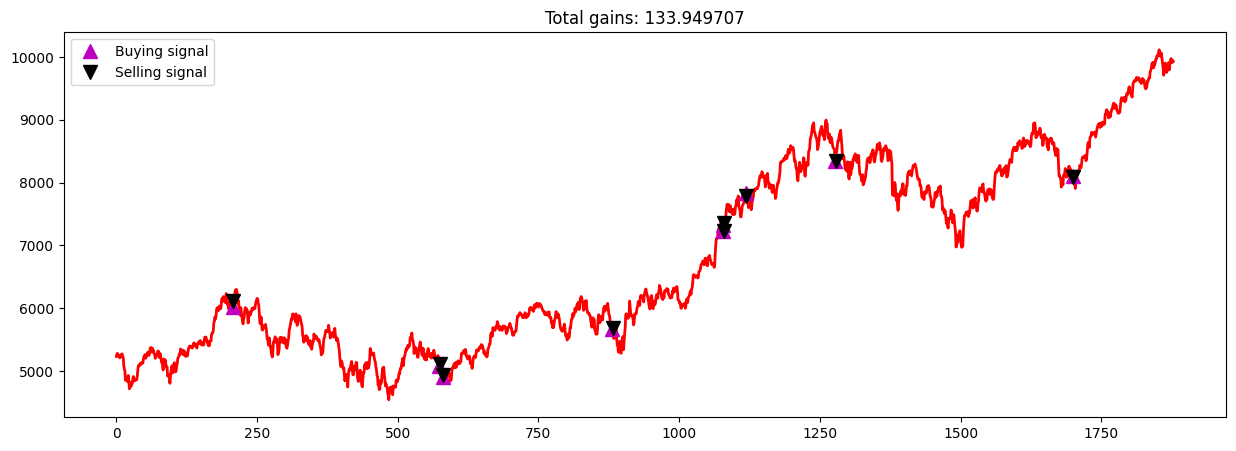

Training in progress...: 100%|██████████| 1878/1878 [07:26<00:00,  4.20it/s]


Running episode 6/10


Training in progress...:   0%|          | 0/1878 [00:00<?, ?it/s]

[[0.         0.         0.62861704]] 2


Training in progress...:   0%|          | 1/1878 [00:00<08:27,  3.70it/s]

[[0.01718006 0.         0.71564563]] 2


Training in progress...:   0%|          | 2/1878 [00:00<08:15,  3.79it/s]

[[0.         0.         0.69936524]] 2


Training in progress...:   0%|          | 3/1878 [00:00<07:41,  4.06it/s]

[[0.03272029 0.         0.72745281]] 2


Training in progress...:   0%|          | 4/1878 [00:00<07:21,  4.25it/s]

[[0.         0.         0.52577777]] 2


Training in progress...:   0%|          | 5/1878 [00:01<07:43,  4.04it/s]

[[0.         0.         0.60612205]] 2


Training in progress...:   0%|          | 6/1878 [00:01<07:39,  4.08it/s]

[[0.1192183 0.        0.602713 ]] 2


Training in progress...:   0%|          | 7/1878 [00:01<07:26,  4.19it/s]

[[0.12961981 0.         0.53213646]] 2


Training in progress...:   0%|          | 8/1878 [00:01<07:07,  4.38it/s]

[[0.         0.         0.48203684]] 2


Training in progress...:   0%|          | 9/1878 [00:02<07:17,  4.28it/s]

[[0.02211341 0.         0.57512638]] 2


Training in progress...:   1%|          | 10/1878 [00:02<07:21,  4.23it/s]

[[0.02788375 0.         0.52522964]] 2


Training in progress...:   1%|          | 11/1878 [00:02<07:15,  4.28it/s]

[[0.         0.         0.58787288]] 2


Training in progress...:   1%|          | 12/1878 [00:02<07:09,  4.35it/s]

[[0.         0.         0.61620378]] 2


Training in progress...:   1%|          | 13/1878 [00:03<07:13,  4.30it/s]

[[0.         0.         0.59497364]] 2


Training in progress...:   1%|          | 14/1878 [00:03<07:18,  4.25it/s]

[[0.         0.         0.55089543]] 2


Training in progress...:   1%|          | 15/1878 [00:03<07:18,  4.25it/s]

[[0.         0.07492621 0.5474455 ]] 2


Training in progress...:   1%|          | 16/1878 [00:03<07:03,  4.40it/s]

[[0.        0.        0.3974092]] 2


Training in progress...:   1%|          | 17/1878 [00:04<07:05,  4.37it/s]

[[0.         0.         0.25605222]] 2


Training in progress...:   1%|          | 18/1878 [00:04<06:58,  4.44it/s]

[[0.         0.         0.45372697]] 2


Training in progress...:   1%|          | 20/1878 [00:04<07:03,  4.39it/s]

[[0.         0.         0.50177958]] 2
[[0.        0.        0.5426472]] 2


Training in progress...:   1%|          | 21/1878 [00:04<06:55,  4.47it/s]

[[0.         0.         0.75851668]] 2


Training in progress...:   1%|          | 22/1878 [00:05<06:52,  4.50it/s]

[[0.         0.         0.83742481]] 2


Training in progress...:   1%|          | 23/1878 [00:05<06:56,  4.46it/s]

[[0.         0.         0.69285408]] 2


Training in progress...:   1%|▏         | 24/1878 [00:05<07:08,  4.33it/s]

[[0.         0.         0.63873945]] 2


Training in progress...:   1%|▏         | 25/1878 [00:05<07:04,  4.37it/s]

[[0.         0.         0.58176731]] 2


Training in progress...:   1%|▏         | 26/1878 [00:06<07:04,  4.36it/s]

[[0.         0.         0.62829309]] 2


Training in progress...:   1%|▏         | 27/1878 [00:06<06:58,  4.43it/s]

[[0.         0.         0.62113737]] 2


Training in progress...:   2%|▏         | 29/1878 [00:06<06:53,  4.47it/s]

[[0.         0.         0.55648412]] 2


Training in progress...:   2%|▏         | 30/1878 [00:06<06:45,  4.56it/s]

[[0.         0.         0.58314099]] 2
[[0.         0.         0.62929901]] 2


Training in progress...:   2%|▏         | 31/1878 [00:07<06:39,  4.62it/s]

[[0.         0.         0.58299173]] 2


Training in progress...:   2%|▏         | 32/1878 [00:07<06:48,  4.52it/s]

[[0.         0.         0.57887651]] 2


Training in progress...:   2%|▏         | 33/1878 [00:07<06:59,  4.39it/s]

[[0.         0.         0.62539192]] 2


Training in progress...:   2%|▏         | 34/1878 [00:07<06:53,  4.46it/s]

[[0.         0.         0.58739927]] 2


Training in progress...:   2%|▏         | 35/1878 [00:08<07:24,  4.15it/s]

[[0.         0.         0.65383453]] 2


Training in progress...:   2%|▏         | 36/1878 [00:08<07:54,  3.88it/s]

[[0.        0.        0.6385036]] 2


Training in progress...:   2%|▏         | 37/1878 [00:08<08:15,  3.71it/s]

[[0.         0.         0.70486701]] 2


Training in progress...:   2%|▏         | 38/1878 [00:08<08:05,  3.79it/s]

[[0.         0.         0.80877519]] 2


Training in progress...:   2%|▏         | 39/1878 [00:09<08:09,  3.75it/s]

[[0.         0.         0.53374143]] 2


Training in progress...:   2%|▏         | 40/1878 [00:09<08:10,  3.75it/s]

[[0.         0.         0.47512127]] 2


Training in progress...:   2%|▏         | 41/1878 [00:09<08:08,  3.76it/s]

[[0.         0.         0.60074529]] 2


Training in progress...:   2%|▏         | 42/1878 [00:10<08:32,  3.58it/s]

[[0.         0.         0.61626011]] 2


Training in progress...:   2%|▏         | 43/1878 [00:10<08:49,  3.47it/s]

[[0.         0.         0.62806635]] 2


Training in progress...:   2%|▏         | 44/1878 [00:10<08:47,  3.48it/s]

[[0.         0.         0.61836195]] 2


Training in progress...:   2%|▏         | 45/1878 [00:10<08:28,  3.61it/s]

[[0.         0.         0.63727751]] 2


Training in progress...:   2%|▏         | 46/1878 [00:11<08:15,  3.70it/s]

[[0.         0.         0.49336001]] 2


Training in progress...:   3%|▎         | 47/1878 [00:11<08:18,  3.67it/s]

[[0.         0.         0.66056775]] 2


Training in progress...:   3%|▎         | 48/1878 [00:11<08:10,  3.73it/s]

[[0.         0.         0.55855518]] 2


Training in progress...:   3%|▎         | 49/1878 [00:11<07:56,  3.83it/s]

[[0.      0.      0.36663]] 2


Training in progress...:   3%|▎         | 50/1878 [00:12<07:40,  3.97it/s]

[[0.         0.         0.45643027]] 2


Training in progress...:   3%|▎         | 51/1878 [00:12<08:04,  3.77it/s]

[[0.         0.         0.42729993]] 2


Training in progress...:   3%|▎         | 52/1878 [00:12<08:07,  3.74it/s]

[[0.         0.         0.47680691]] 2


Training in progress...:   3%|▎         | 53/1878 [00:13<08:17,  3.67it/s]

[[0.         0.         0.62779197]] 2


Training in progress...:   3%|▎         | 54/1878 [00:13<08:41,  3.50it/s]

[[0.        0.        0.4702108]] 2


Training in progress...:   3%|▎         | 55/1878 [00:13<08:35,  3.54it/s]

[[0.         0.         0.37123292]] 2


Training in progress...:   3%|▎         | 56/1878 [00:13<08:42,  3.49it/s]

[[0.         0.         0.31594705]] 2


Training in progress...:   3%|▎         | 57/1878 [00:14<08:46,  3.46it/s]

[[0.         0.         0.28392043]] 2


Training in progress...:   3%|▎         | 58/1878 [00:14<08:41,  3.49it/s]

[[0.         0.         0.24322216]] 2


Training in progress...:   3%|▎         | 59/1878 [00:14<08:17,  3.66it/s]

[[0.         0.         0.18901687]] 2


Training in progress...:   3%|▎         | 60/1878 [00:15<08:06,  3.73it/s]

[[0.         0.         0.21526395]] 2


Training in progress...:   3%|▎         | 61/1878 [00:15<07:55,  3.83it/s]

[[0.         0.         0.17699298]] 2


Training in progress...:   3%|▎         | 62/1878 [00:15<07:30,  4.03it/s]

[[0.         0.         0.32705381]] 2


Training in progress...:   3%|▎         | 63/1878 [00:15<07:18,  4.14it/s]

[[0.         0.         0.40219343]] 2


Training in progress...:   3%|▎         | 64/1878 [00:15<06:59,  4.33it/s]

[[0.         0.         0.32764965]] 2


Training in progress...:   3%|▎         | 65/1878 [00:16<07:10,  4.21it/s]

[[0.         0.         0.29232844]] 2


Training in progress...:   4%|▎         | 66/1878 [00:16<07:07,  4.24it/s]

[[0.03122698 0.         0.13766257]] 2


Training in progress...:   4%|▎         | 67/1878 [00:16<07:17,  4.14it/s]

[[0.01160236 0.         0.22568283]] 2


Training in progress...:   4%|▎         | 68/1878 [00:16<07:04,  4.27it/s]

[[0.08854566 0.         0.27228193]] 2


Training in progress...:   4%|▎         | 69/1878 [00:17<07:15,  4.15it/s]

[[0.02872731 0.         0.14346359]] 2


Training in progress...:   4%|▎         | 70/1878 [00:17<07:08,  4.22it/s]

[[0.         0.         0.22052453]] 2


Training in progress...:   4%|▍         | 72/1878 [00:17<06:49,  4.41it/s]

[[0.02376411 0.         0.24138196]] 2
[[0.         0.         0.41073994]] 2


Training in progress...:   4%|▍         | 73/1878 [00:17<06:39,  4.52it/s]

[[0.         0.         0.39835464]] 2


Training in progress...:   4%|▍         | 74/1878 [00:18<06:39,  4.52it/s]

[[0.         0.         0.48907541]] 2


Training in progress...:   4%|▍         | 75/1878 [00:18<06:52,  4.37it/s]

[[0.         0.         0.53295781]] 2


Training in progress...:   4%|▍         | 76/1878 [00:18<06:46,  4.43it/s]

[[0.         0.         0.36911318]] 2


Training in progress...:   4%|▍         | 77/1878 [00:18<06:37,  4.53it/s]

[[0.        0.        0.6269706]] 2


Training in progress...:   4%|▍         | 78/1878 [00:19<06:51,  4.37it/s]

[[0.         0.         0.65398472]] 2


Training in progress...:   4%|▍         | 79/1878 [00:19<06:55,  4.33it/s]

[[0.         0.         0.44179243]] 2


Training in progress...:   4%|▍         | 80/1878 [00:19<06:51,  4.37it/s]

[[0.        0.        0.4762399]] 2


Training in progress...:   4%|▍         | 81/1878 [00:19<06:42,  4.46it/s]

[[0.         0.         0.61873082]] 2


Training in progress...:   4%|▍         | 82/1878 [00:20<06:32,  4.58it/s]

[[0.11554844 0.         0.44969862]] 2


Training in progress...:   4%|▍         | 83/1878 [00:20<06:40,  4.48it/s]

[[0.10148563 0.         0.46624364]] 2


Training in progress...:   4%|▍         | 84/1878 [00:20<06:48,  4.39it/s]

[[0.         0.         0.50218942]] 2


Training in progress...:   5%|▍         | 85/1878 [00:20<06:44,  4.43it/s]

[[0.         0.         0.33483593]] 2


Training in progress...:   5%|▍         | 86/1878 [00:20<06:38,  4.50it/s]

[[0.        0.        0.2679489]] 2


Training in progress...:   5%|▍         | 87/1878 [00:21<06:42,  4.45it/s]

[[0.        0.        0.2316249]] 2


Training in progress...:   5%|▍         | 88/1878 [00:21<07:00,  4.26it/s]

[[0.         0.00877247 0.30992937]] 2


Training in progress...:   5%|▍         | 89/1878 [00:21<06:49,  4.37it/s]

[[0.        0.        0.1841259]] 2


Training in progress...:   5%|▍         | 90/1878 [00:21<06:49,  4.37it/s]

[[0.         0.         0.27666049]] 2


Training in progress...:   5%|▍         | 91/1878 [00:22<06:42,  4.44it/s]

[[0.         0.         0.30201296]] 2


Training in progress...:   5%|▍         | 92/1878 [00:22<06:56,  4.29it/s]

[[0.         0.         0.47085526]] 2


Training in progress...:   5%|▍         | 93/1878 [00:22<06:55,  4.29it/s]

[[0.         0.         0.56655529]] 2


Training in progress...:   5%|▌         | 95/1878 [00:22<06:35,  4.51it/s]

[[0.         0.         0.41151255]] 2
[[0.10359023 0.         0.48469414]] 2


Training in progress...:   5%|▌         | 96/1878 [00:23<06:41,  4.43it/s]

[[0.22747327 0.         0.44115308]] 2


Training in progress...:   5%|▌         | 97/1878 [00:23<06:44,  4.40it/s]

[[0.09803497 0.         0.57512919]] 2


Training in progress...:   5%|▌         | 98/1878 [00:23<06:42,  4.43it/s]

[[0.13339861 0.         0.52029487]] 2


Training in progress...:   5%|▌         | 99/1878 [00:23<06:37,  4.48it/s]

[[0.07494277 0.         0.42990904]] 2


Training in progress...:   5%|▌         | 100/1878 [00:24<06:30,  4.55it/s]

[[0.         0.         0.31703976]] 2


Training in progress...:   5%|▌         | 101/1878 [00:24<06:41,  4.43it/s]

[[0.         0.         0.16727617]] 2


Training in progress...:   5%|▌         | 102/1878 [00:24<07:18,  4.05it/s]

[[0.         0.         0.24575826]] 2


Training in progress...:   5%|▌         | 103/1878 [00:24<07:32,  3.92it/s]

[[0.         0.         0.04427719]] 2


Training in progress...:   6%|▌         | 104/1878 [00:25<07:36,  3.89it/s]

[[0.        0.        0.0490016]] 2


Training in progress...:   6%|▌         | 105/1878 [00:25<07:44,  3.82it/s]

[[0.         0.         0.08754516]] 2


Training in progress...:   6%|▌         | 106/1878 [00:25<07:46,  3.80it/s]

[[0.         0.         0.14700556]] 2


Training in progress...:   6%|▌         | 107/1878 [00:26<08:05,  3.65it/s]

[[0.         0.         0.33436703]] 2


Training in progress...:   6%|▌         | 108/1878 [00:26<08:17,  3.56it/s]

[[0.         0.         0.38444872]] 2


Training in progress...:   6%|▌         | 109/1878 [00:26<08:14,  3.58it/s]

[[0.        0.        0.2504234]] 2


Training in progress...:   6%|▌         | 110/1878 [00:26<08:04,  3.65it/s]

[[0.         0.         0.15140046]] 2


Training in progress...:   6%|▌         | 111/1878 [00:27<08:10,  3.60it/s]

[[0.10053972 0.         0.27287802]] 2


Training in progress...:   6%|▌         | 112/1878 [00:27<08:16,  3.56it/s]

[[0.         0.         0.21590458]] 2


Training in progress...:   6%|▌         | 113/1878 [00:27<08:12,  3.58it/s]

[[0.         0.         0.14493754]] 2


Training in progress...:   6%|▌         | 114/1878 [00:27<08:00,  3.67it/s]

[[0.01595113 0.         0.10692272]] 2


Training in progress...:   6%|▌         | 115/1878 [00:28<07:41,  3.82it/s]

[[0.         0.         0.15512257]] 2


Training in progress...:   6%|▌         | 116/1878 [00:28<07:51,  3.74it/s]

[[0.         0.         0.03645878]] 2


Training in progress...:   6%|▌         | 117/1878 [00:28<07:52,  3.72it/s]

[[0.         0.         0.08697556]] 2


Training in progress...:   6%|▋         | 118/1878 [00:29<07:52,  3.72it/s]

[[0.03840362 0.         0.2120235 ]] 2


Training in progress...:   6%|▋         | 119/1878 [00:29<07:50,  3.74it/s]

[[0.        0.        0.3297796]] 2


Training in progress...:   6%|▋         | 120/1878 [00:29<07:47,  3.76it/s]

[[0.         0.         0.31680617]] 2


Training in progress...:   6%|▋         | 121/1878 [00:29<07:49,  3.74it/s]

[[0.         0.         0.27326039]] 2


Training in progress...:   6%|▋         | 122/1878 [00:30<07:55,  3.69it/s]

[[0.         0.         0.23940226]] 2


Training in progress...:   7%|▋         | 123/1878 [00:30<07:56,  3.68it/s]

[[0.         0.         0.36127881]] 2


Training in progress...:   7%|▋         | 124/1878 [00:30<08:05,  3.61it/s]

[[0.         0.         0.36408802]] 2


Training in progress...:   7%|▋         | 125/1878 [00:30<08:12,  3.56it/s]

[[0.         0.         0.36297718]] 2


Training in progress...:   7%|▋         | 126/1878 [00:31<07:59,  3.65it/s]

[[0.         0.         0.36900391]] 2


Training in progress...:   7%|▋         | 127/1878 [00:31<07:56,  3.68it/s]

[[0.        0.        0.3884291]] 2


Training in progress...:   7%|▋         | 128/1878 [00:31<07:44,  3.77it/s]

[[0.02937366 0.         0.35433415]] 2


Training in progress...:   7%|▋         | 129/1878 [00:31<07:29,  3.90it/s]

[[0.07783813 0.01979648 0.36747453]] 2


Training in progress...:   7%|▋         | 130/1878 [00:32<07:07,  4.09it/s]

[[0.10537971 0.         0.17574653]] 2


Training in progress...:   7%|▋         | 131/1878 [00:32<07:06,  4.09it/s]

[[0.17832691 0.         0.18093534]] 2


Training in progress...:   7%|▋         | 132/1878 [00:32<06:50,  4.26it/s]

[[0.1494003  0.         0.30365407]] 2


Training in progress...:   7%|▋         | 133/1878 [00:32<06:40,  4.35it/s]

[[0.12971379 0.         0.33371656]] 2


Training in progress...:   7%|▋         | 134/1878 [00:33<06:43,  4.33it/s]

[[0.04897535 0.         0.52111638]] 2


Training in progress...:   7%|▋         | 135/1878 [00:33<06:41,  4.34it/s]

[[0.08200125 0.         0.48593114]] 2


Training in progress...:   7%|▋         | 137/1878 [00:33<06:32,  4.44it/s]

[[0.10270625 0.         0.46652212]] 2
[[0.         0.         0.52927916]] 2


Training in progress...:   7%|▋         | 138/1878 [00:33<06:28,  4.48it/s]

[[0.         0.         0.70894996]] 2


Training in progress...:   7%|▋         | 139/1878 [00:34<06:19,  4.58it/s]

[[0.0179679  0.         0.50577123]] 2


Training in progress...:   7%|▋         | 140/1878 [00:34<06:39,  4.36it/s]

[[0.09517147 0.         0.75240147]] 2


Training in progress...:   8%|▊         | 141/1878 [00:34<06:33,  4.42it/s]

[[0.         0.         0.97820602]] 2


Training in progress...:   8%|▊         | 142/1878 [00:34<06:31,  4.43it/s]

[[0.03351156 0.         1.14576466]] 2


Training in progress...:   8%|▊         | 143/1878 [00:35<06:30,  4.44it/s]

[[0.         0.         1.02501857]] 2


Training in progress...:   8%|▊         | 144/1878 [00:35<06:29,  4.45it/s]

[[0.00154111 0.         1.00774009]] 2


Training in progress...:   8%|▊         | 145/1878 [00:35<06:29,  4.45it/s]

[[0.         0.         1.01753175]] 2


Training in progress...:   8%|▊         | 146/1878 [00:35<06:31,  4.42it/s]

[[0.         0.         0.98902121]] 2


Training in progress...:   8%|▊         | 147/1878 [00:36<06:32,  4.40it/s]

[[0.         0.         0.93819073]] 2


Training in progress...:   8%|▊         | 148/1878 [00:36<06:50,  4.21it/s]

[[0.         0.         0.82355243]] 2


Training in progress...:   8%|▊         | 149/1878 [00:36<06:45,  4.27it/s]

[[0.         0.         0.66694483]] 2


Training in progress...:   8%|▊         | 150/1878 [00:36<06:47,  4.24it/s]

[[0.         0.         0.87074468]] 2


Training in progress...:   8%|▊         | 151/1878 [00:36<06:40,  4.31it/s]

[[0.         0.         0.60891877]] 2


Training in progress...:   8%|▊         | 152/1878 [00:37<06:50,  4.20it/s]

[[0.         0.         0.55783742]] 2


Training in progress...:   8%|▊         | 153/1878 [00:37<06:49,  4.21it/s]

[[0.10263567 0.         0.49358308]] 2


Training in progress...:   8%|▊         | 154/1878 [00:37<06:52,  4.18it/s]

[[0.08655199 0.         0.53359111]] 2


Training in progress...:   8%|▊         | 155/1878 [00:37<06:35,  4.36it/s]

[[0.06812161 0.         0.36863421]] 2


Training in progress...:   8%|▊         | 156/1878 [00:38<06:41,  4.29it/s]

[[0.10064921 0.         0.43413508]] 2


Training in progress...:   8%|▊         | 157/1878 [00:38<06:58,  4.11it/s]

[[0.1484277  0.         0.46235824]] 2


Training in progress...:   8%|▊         | 158/1878 [00:38<06:46,  4.23it/s]

[[0.03202771 0.         0.37178647]] 2


Training in progress...:   8%|▊         | 159/1878 [00:38<06:40,  4.30it/s]

[[0.08128084 0.         0.31001815]] 2


Training in progress...:   9%|▊         | 160/1878 [00:39<06:39,  4.30it/s]

[[0.         0.         0.37526111]] 2


Training in progress...:   9%|▊         | 161/1878 [00:39<06:56,  4.13it/s]

[[0.         0.13939362 0.42647457]] 2


Training in progress...:   9%|▊         | 162/1878 [00:39<06:48,  4.20it/s]

[[0.10487884 0.01973963 0.47181269]] 2


Training in progress...:   9%|▊         | 163/1878 [00:39<06:36,  4.33it/s]

[[0.33594927 0.10614474 0.40163053]] 2


Training in progress...:   9%|▊         | 164/1878 [00:39<06:25,  4.45it/s]

[[0.33862028 0.21266977 0.55980358]] 2


Training in progress...:   9%|▉         | 165/1878 [00:40<06:29,  4.40it/s]

[[0.18508897 0.0752778  0.64112329]] 2


Training in progress...:   9%|▉         | 166/1878 [00:40<06:35,  4.33it/s]

[[0.3114287  0.0130042  0.70142187]] 2


Training in progress...:   9%|▉         | 168/1878 [00:40<06:18,  4.52it/s]

[[0.19177426 0.         0.54492582]] 2
[[0.30453813 0.         0.38491606]] 2


Training in progress...:   9%|▉         | 169/1878 [00:41<06:35,  4.32it/s]

[[0.36535414 0.         0.48468714]] 2


Training in progress...:   9%|▉         | 170/1878 [00:41<07:08,  3.98it/s]

[[0.3042151  0.         0.48992967]] 2


Training in progress...:   9%|▉         | 171/1878 [00:41<07:28,  3.81it/s]

[[0.3903057 0.        0.4682731]] 2


Training in progress...:   9%|▉         | 172/1878 [00:41<07:18,  3.89it/s]

[[0.36585645 0.         0.5152194 ]] 2


Training in progress...:   9%|▉         | 173/1878 [00:42<07:33,  3.76it/s]

[[0.27933783 0.         0.54808242]] 2


Training in progress...:   9%|▉         | 174/1878 [00:42<07:55,  3.58it/s]

[[0.28581855 0.         0.48498075]] 2


Training in progress...:   9%|▉         | 175/1878 [00:42<07:30,  3.78it/s]

[[0.31214287 0.         0.41044231]] 2


Training in progress...:   9%|▉         | 176/1878 [00:43<07:48,  3.63it/s]

[[0.3744464  0.         0.21156179]] 0


Training in progress...:   9%|▉         | 177/1878 [00:43<07:47,  3.64it/s]

[[0.35329461 0.         0.13700732]] 0


Training in progress...:   9%|▉         | 178/1878 [00:43<07:59,  3.55it/s]

[[0.34327319 0.         0.2323308 ]] 0


Training in progress...:  10%|▉         | 179/1878 [00:43<07:44,  3.66it/s]

[[0.38693625 0.         0.24315465]] 0


Training in progress...:  10%|▉         | 180/1878 [00:44<07:39,  3.70it/s]

[[0.29862218 0.         0.48496515]] 2


Training in progress...:  10%|▉         | 181/1878 [00:44<07:50,  3.61it/s]

[[0.50809034 0.         0.52350663]] 2


Training in progress...:  10%|▉         | 182/1878 [00:44<07:36,  3.72it/s]

[[0.45096043 0.         0.38526468]] 0


Training in progress...:  10%|▉         | 183/1878 [00:44<07:15,  3.89it/s]

[[0.45775468 0.         0.43809125]] 0


Training in progress...:  10%|▉         | 184/1878 [00:45<07:34,  3.73it/s]

[[0.54070612 0.         0.38265157]] 0


Training in progress...:  10%|▉         | 185/1878 [00:45<07:31,  3.75it/s]

[[0.21538377 0.         0.21303799]] 0


Training in progress...:  10%|▉         | 186/1878 [00:45<07:35,  3.71it/s]

[[0.05470032 0.         0.31079115]] 2


Training in progress...:  10%|▉         | 187/1878 [00:46<07:24,  3.81it/s]

[[0.         0.         0.24612161]] 2


Training in progress...:  10%|█         | 188/1878 [00:46<07:38,  3.68it/s]

[[0.         0.         0.24550583]] 2


Training in progress...:  10%|█         | 189/1878 [00:46<07:41,  3.66it/s]

[[0.         0.         0.19380969]] 2


Training in progress...:  10%|█         | 190/1878 [00:46<07:48,  3.61it/s]

[[0.         0.         0.40548283]] 2


Training in progress...:  10%|█         | 191/1878 [00:47<08:02,  3.49it/s]

[[0.        0.        0.3553809]] 2


Training in progress...:  10%|█         | 192/1878 [00:47<08:04,  3.48it/s]

[[0.         0.01904814 0.33473316]] 2


Training in progress...:  10%|█         | 193/1878 [00:47<07:44,  3.62it/s]

[[0.07783791 0.         0.34508351]] 2


Training in progress...:  10%|█         | 194/1878 [00:48<07:30,  3.74it/s]

[[0.09579819 0.         0.35680443]] 2


Training in progress...:  10%|█         | 195/1878 [00:48<07:18,  3.84it/s]

[[0.04155692 0.         0.42199119]] 2


Training in progress...:  10%|█         | 196/1878 [00:48<07:20,  3.82it/s]

[[0.         0.         0.37891945]] 2


Training in progress...:  10%|█         | 197/1878 [00:48<07:13,  3.88it/s]

[[0.         0.         0.46277736]] 2


Training in progress...:  11%|█         | 198/1878 [00:48<06:53,  4.07it/s]

[[0.         0.         0.55841625]] 2


Training in progress...:  11%|█         | 199/1878 [00:49<06:38,  4.21it/s]

[[0.         0.02734265 0.49914375]] 2


Training in progress...:  11%|█         | 201/1878 [00:49<06:24,  4.36it/s]

[[0.         0.1588776  0.40582656]] 2
[[0.         0.         0.41085177]] 2


Training in progress...:  11%|█         | 202/1878 [00:49<06:27,  4.33it/s]

[[0.         0.         0.39695817]] 2


Training in progress...:  11%|█         | 203/1878 [00:50<06:24,  4.36it/s]

[[0.         0.         0.35767476]] 2


Training in progress...:  11%|█         | 204/1878 [00:50<06:33,  4.25it/s]

[[0.         0.         0.28676654]] 2


Training in progress...:  11%|█         | 206/1878 [00:50<06:15,  4.45it/s]

[[0.         0.03489446 0.12139156]] 2
[[0.         0.         0.25292185]] 2


Training in progress...:  11%|█         | 207/1878 [00:51<06:07,  4.55it/s]

[[0.         0.         0.18841848]] 2


Training in progress...:  11%|█         | 208/1878 [00:51<06:10,  4.51it/s]

[[0.         0.         0.30077139]] 2


Training in progress...:  11%|█         | 209/1878 [00:51<06:11,  4.50it/s]

[[0.         0.         0.33901004]] 2


Training in progress...:  11%|█         | 210/1878 [00:51<06:05,  4.56it/s]

[[0.        0.        0.0929761]] 2


Training in progress...:  11%|█         | 211/1878 [00:51<05:59,  4.63it/s]

[[0.         0.         0.23474495]] 2


Training in progress...:  11%|█▏        | 212/1878 [00:52<06:12,  4.48it/s]

[[0.         0.         0.23795999]] 2


Training in progress...:  11%|█▏        | 213/1878 [00:52<06:13,  4.46it/s]

[[0.         0.         0.16595396]] 2


Training in progress...:  11%|█▏        | 214/1878 [00:52<06:10,  4.50it/s]

[[0.         0.         0.33107531]] 2


Training in progress...:  11%|█▏        | 215/1878 [00:52<06:04,  4.56it/s]

[[0.         0.         0.45120085]] 2


Training in progress...:  12%|█▏        | 216/1878 [00:52<06:06,  4.53it/s]

[[0.         0.         0.52744922]] 2


Training in progress...:  12%|█▏        | 217/1878 [00:53<06:26,  4.30it/s]

[[0.         0.         0.47638526]] 2


Training in progress...:  12%|█▏        | 218/1878 [00:53<06:29,  4.26it/s]

[[0.         0.         0.31704602]] 2


Training in progress...:  12%|█▏        | 219/1878 [00:53<06:32,  4.22it/s]

[[0.         0.         0.24555333]] 2


Training in progress...:  12%|█▏        | 220/1878 [00:53<06:20,  4.36it/s]

[[0.         0.         0.27194735]] 2


Training in progress...:  12%|█▏        | 221/1878 [00:54<06:34,  4.20it/s]

[[0.         0.         0.27499112]] 2


Training in progress...:  12%|█▏        | 222/1878 [00:54<06:31,  4.23it/s]

[[0.         0.         0.31351912]] 2


Training in progress...:  12%|█▏        | 223/1878 [00:54<06:35,  4.18it/s]

[[0.         0.02285066 0.40121076]] 2


Training in progress...:  12%|█▏        | 224/1878 [00:54<06:21,  4.33it/s]

[[0.         0.22315362 0.33786185]] 2


Training in progress...:  12%|█▏        | 225/1878 [00:55<06:19,  4.36it/s]

[[0.         0.16466173 0.45230365]] 2


Training in progress...:  12%|█▏        | 226/1878 [00:55<06:26,  4.27it/s]

[[0.         0.11924688 0.34222352]] 2


Training in progress...:  12%|█▏        | 227/1878 [00:55<06:24,  4.30it/s]

[[0.         0.         0.43393637]] 2


Training in progress...:  12%|█▏        | 228/1878 [00:55<06:14,  4.40it/s]

[[0.         0.05643776 0.44996282]] 2


Training in progress...:  12%|█▏        | 229/1878 [00:56<06:22,  4.31it/s]

[[0.         0.         0.26435155]] 2


Training in progress...:  12%|█▏        | 230/1878 [00:56<06:30,  4.22it/s]

[[0.         0.         0.49169063]] 2


Training in progress...:  12%|█▏        | 231/1878 [00:56<06:23,  4.29it/s]

[[0.         0.         0.35365537]] 2


Training in progress...:  12%|█▏        | 232/1878 [00:56<06:24,  4.28it/s]

[[0.         0.         0.44615774]] 2


Training in progress...:  12%|█▏        | 233/1878 [00:56<06:12,  4.42it/s]

[[0.         0.         0.32624543]] 2


Training in progress...:  12%|█▏        | 234/1878 [00:57<06:18,  4.34it/s]

[[0.         0.         0.45183433]] 2


Training in progress...:  13%|█▎        | 235/1878 [00:57<06:45,  4.05it/s]

[[0.         0.         0.54423833]] 2


Training in progress...:  13%|█▎        | 236/1878 [00:57<06:46,  4.04it/s]

[[0.         0.         0.59813972]] 2


Training in progress...:  13%|█▎        | 237/1878 [00:58<06:59,  3.91it/s]

[[0.         0.         0.57405418]] 2


Training in progress...:  13%|█▎        | 238/1878 [00:58<06:49,  4.01it/s]

[[0.         0.         0.56893928]] 2


Training in progress...:  13%|█▎        | 239/1878 [00:58<07:01,  3.89it/s]

[[0.         0.         0.45148112]] 2


Training in progress...:  13%|█▎        | 240/1878 [00:58<06:53,  3.96it/s]

[[0.         0.         0.43697479]] 2


Training in progress...:  13%|█▎        | 241/1878 [00:59<06:49,  4.00it/s]

[[0.         0.         0.60557633]] 2


Training in progress...:  13%|█▎        | 242/1878 [00:59<07:03,  3.86it/s]

[[0.       0.       0.457392]] 2


Training in progress...:  13%|█▎        | 243/1878 [00:59<07:36,  3.58it/s]

[[0.         0.         0.46633648]] 2


Training in progress...:  13%|█▎        | 244/1878 [00:59<07:34,  3.59it/s]

[[0.         0.         0.53429764]] 2


Training in progress...:  13%|█▎        | 245/1878 [01:00<07:29,  3.63it/s]

[[0.         0.         0.68112391]] 2


Training in progress...:  13%|█▎        | 246/1878 [01:00<07:29,  3.63it/s]

[[0.         0.         0.62233518]] 2


Training in progress...:  13%|█▎        | 247/1878 [01:00<07:29,  3.63it/s]

[[0.         0.         0.65942982]] 2


Training in progress...:  13%|█▎        | 248/1878 [01:00<07:16,  3.74it/s]

[[0.        0.        0.6648971]] 2


Training in progress...:  13%|█▎        | 249/1878 [01:01<07:22,  3.68it/s]

[[0.         0.         0.67011786]] 2


Training in progress...:  13%|█▎        | 250/1878 [01:01<07:38,  3.55it/s]

[[0.         0.         0.69891776]] 2


Training in progress...:  13%|█▎        | 251/1878 [01:01<07:44,  3.50it/s]

[[0.         0.         0.57350913]] 2


Training in progress...:  13%|█▎        | 252/1878 [01:02<07:36,  3.56it/s]

[[0.         0.         0.52328877]] 2


Training in progress...:  13%|█▎        | 253/1878 [01:02<07:53,  3.43it/s]

[[0.         0.         0.67142104]] 2


Training in progress...:  14%|█▎        | 254/1878 [01:02<07:47,  3.48it/s]

[[0.         0.         0.72752398]] 2


Training in progress...:  14%|█▎        | 255/1878 [01:02<07:39,  3.53it/s]

[[0.         0.         0.78893106]] 2


Training in progress...:  14%|█▎        | 256/1878 [01:03<07:35,  3.56it/s]

[[0.1495659  0.         0.58655016]] 2


Training in progress...:  14%|█▎        | 257/1878 [01:03<07:41,  3.51it/s]

[[0.16766497 0.         0.50124968]] 2


Training in progress...:  14%|█▎        | 258/1878 [01:03<07:53,  3.42it/s]

[[0.09078732 0.         0.24915557]] 2


Training in progress...:  14%|█▍        | 259/1878 [01:04<07:34,  3.56it/s]

[[0.26269408 0.         0.19222703]] 0


Training in progress...:  14%|█▍        | 260/1878 [01:04<07:28,  3.61it/s]

[[0.15595235 0.         0.38861174]] 2


Training in progress...:  14%|█▍        | 261/1878 [01:04<07:17,  3.70it/s]

[[0.22188288 0.         0.3732964 ]] 2


Training in progress...:  14%|█▍        | 262/1878 [01:04<07:04,  3.80it/s]

[[0.         0.         0.37463084]] 2


Training in progress...:  14%|█▍        | 263/1878 [01:05<06:59,  3.85it/s]

[[0.         0.         0.50169127]] 2


Training in progress...:  14%|█▍        | 264/1878 [01:05<06:55,  3.89it/s]

[[0.14059495 0.         0.43187923]] 2


Training in progress...:  14%|█▍        | 265/1878 [01:05<06:38,  4.05it/s]

[[0.3748091 0.        0.4193852]] 2


Training in progress...:  14%|█▍        | 267/1878 [01:06<06:09,  4.36it/s]

[[0.11549616 0.         0.45514164]] 2
[[0.         0.         0.40088073]] 2


Training in progress...:  14%|█▍        | 268/1878 [01:06<06:15,  4.29it/s]

[[0.         0.         0.33988868]] 2


Training in progress...:  14%|█▍        | 269/1878 [01:06<06:19,  4.24it/s]

[[0.         0.         0.15822226]] 2


Training in progress...:  14%|█▍        | 270/1878 [01:06<06:11,  4.32it/s]

[[0.         0.         0.32262684]] 2


Training in progress...:  14%|█▍        | 271/1878 [01:06<06:09,  4.35it/s]

[[0.         0.         0.33904883]] 2


Training in progress...:  14%|█▍        | 272/1878 [01:07<06:01,  4.45it/s]

[[0.         0.         0.38958968]] 2


Training in progress...:  15%|█▍        | 273/1878 [01:07<06:14,  4.29it/s]

[[0.         0.         0.24780128]] 2


Training in progress...:  15%|█▍        | 274/1878 [01:07<06:14,  4.28it/s]

[[0.         0.         0.49692765]] 2


Training in progress...:  15%|█▍        | 275/1878 [01:07<06:09,  4.34it/s]

[[0.         0.         0.44539086]] 2


Training in progress...:  15%|█▍        | 276/1878 [01:08<06:15,  4.26it/s]

[[0.         0.         0.49793226]] 2


Training in progress...:  15%|█▍        | 277/1878 [01:08<06:17,  4.24it/s]

[[0.         0.         0.46100992]] 2


Training in progress...:  15%|█▍        | 278/1878 [01:08<06:19,  4.22it/s]

[[0.         0.         0.46630979]] 2


Training in progress...:  15%|█▍        | 279/1878 [01:08<06:10,  4.32it/s]

[[0.         0.         0.49679869]] 2


Training in progress...:  15%|█▍        | 280/1878 [01:09<06:21,  4.19it/s]

[[0.         0.         0.59111203]] 2


Training in progress...:  15%|█▍        | 281/1878 [01:09<06:13,  4.28it/s]

[[0.         0.         0.57485586]] 2


Training in progress...:  15%|█▌        | 282/1878 [01:09<06:19,  4.20it/s]

[[0.02051938 0.         0.58672944]] 2


Training in progress...:  15%|█▌        | 283/1878 [01:09<06:10,  4.31it/s]

[[0.01577278 0.         0.44714835]] 2


Training in progress...:  15%|█▌        | 285/1878 [01:10<05:58,  4.44it/s]

[[0.06262401 0.         0.48407557]] 2
[[0.         0.         0.48588801]] 2


Training in progress...:  15%|█▌        | 286/1878 [01:10<05:55,  4.48it/s]

[[0.         0.         0.43962981]] 2


Training in progress...:  15%|█▌        | 287/1878 [01:10<05:50,  4.54it/s]

[[0.         0.         0.46231869]] 2


Training in progress...:  15%|█▌        | 288/1878 [01:10<05:49,  4.55it/s]

[[0.         0.         0.41507253]] 2


Training in progress...:  15%|█▌        | 289/1878 [01:11<06:07,  4.32it/s]

[[0.         0.         0.26553525]] 2


Training in progress...:  15%|█▌        | 290/1878 [01:11<06:05,  4.34it/s]

[[0.         0.         0.39739568]] 2


Training in progress...:  15%|█▌        | 291/1878 [01:11<06:05,  4.34it/s]

[[0.         0.         0.35374896]] 2


Training in progress...:  16%|█▌        | 292/1878 [01:11<06:04,  4.35it/s]

[[0.         0.         0.34320989]] 2


Training in progress...:  16%|█▌        | 293/1878 [01:12<05:56,  4.44it/s]

[[0.         0.         0.39764938]] 2


Training in progress...:  16%|█▌        | 294/1878 [01:12<05:56,  4.45it/s]

[[0.        0.        0.4348044]] 2


Training in progress...:  16%|█▌        | 295/1878 [01:12<06:00,  4.39it/s]

[[0.         0.         0.43972759]] 2


Training in progress...:  16%|█▌        | 296/1878 [01:12<05:58,  4.41it/s]

[[0.         0.         0.55711547]] 2


Training in progress...:  16%|█▌        | 297/1878 [01:12<05:49,  4.52it/s]

[[0.         0.         0.48606094]] 2


Training in progress...:  16%|█▌        | 298/1878 [01:13<06:07,  4.30it/s]

[[0.         0.         0.44580414]] 2


Training in progress...:  16%|█▌        | 299/1878 [01:13<06:11,  4.25it/s]

[[0.         0.         0.42690043]] 2


Training in progress...:  16%|█▌        | 300/1878 [01:13<06:06,  4.31it/s]

[[0.         0.         0.45279002]] 2


Training in progress...:  16%|█▌        | 301/1878 [01:13<06:05,  4.31it/s]

[[0.        0.        0.5345516]] 2


Training in progress...:  16%|█▌        | 302/1878 [01:14<06:21,  4.13it/s]

[[0.       0.       0.438574]] 2


Training in progress...:  16%|█▌        | 303/1878 [01:14<06:41,  3.92it/s]

[[0.         0.         0.41817099]] 2


Training in progress...:  16%|█▌        | 304/1878 [01:14<06:47,  3.86it/s]

[[0.         0.         0.18511802]] 2


Training in progress...:  16%|█▌        | 305/1878 [01:14<07:00,  3.74it/s]

[[0.         0.         0.23657498]] 2


Training in progress...:  16%|█▋        | 306/1878 [01:15<07:15,  3.61it/s]

[[0.        0.        0.3131846]] 2


Training in progress...:  16%|█▋        | 307/1878 [01:15<07:12,  3.63it/s]

[[0.         0.         0.30439631]] 2


Training in progress...:  16%|█▋        | 308/1878 [01:15<07:12,  3.63it/s]

[[0.         0.         0.29038658]] 2


Training in progress...:  16%|█▋        | 309/1878 [01:16<07:18,  3.58it/s]

[[0.06078558 0.         0.43656138]] 2


Training in progress...:  17%|█▋        | 310/1878 [01:16<07:37,  3.42it/s]

[[0.01748078 0.         0.45737325]] 2


Training in progress...:  17%|█▋        | 311/1878 [01:16<07:40,  3.40it/s]

[[0.00903751 0.         0.47291308]] 2


Training in progress...:  17%|█▋        | 312/1878 [01:17<07:29,  3.49it/s]

[[0.         0.         0.22533981]] 2


Training in progress...:  17%|█▋        | 313/1878 [01:17<07:28,  3.49it/s]

[[0.         0.         0.17158243]] 2


Training in progress...:  17%|█▋        | 314/1878 [01:17<07:29,  3.48it/s]

[[0.         0.         0.12522229]] 2


Training in progress...:  17%|█▋        | 315/1878 [01:17<07:15,  3.59it/s]

[[0.         0.         0.15897446]] 2


Training in progress...:  17%|█▋        | 316/1878 [01:18<07:13,  3.61it/s]

[[0.         0.         0.29788659]] 2


Training in progress...:  17%|█▋        | 317/1878 [01:18<07:27,  3.49it/s]

[[0.        0.        0.3316029]] 2


Training in progress...:  17%|█▋        | 318/1878 [01:18<07:17,  3.56it/s]

[[0.         0.         0.37756917]] 2


Training in progress...:  17%|█▋        | 319/1878 [01:18<07:08,  3.63it/s]

[[0.07230532 0.         0.31805435]] 2


Training in progress...:  17%|█▋        | 320/1878 [01:19<07:27,  3.48it/s]

[[0.09872896 0.         0.42190485]] 2


Training in progress...:  17%|█▋        | 321/1878 [01:19<07:35,  3.42it/s]

[[0.0822422 0.        0.5000616]] 2


Training in progress...:  17%|█▋        | 322/1878 [01:19<07:41,  3.37it/s]

[[0.         0.         0.45893489]] 2


Training in progress...:  17%|█▋        | 323/1878 [01:20<07:31,  3.45it/s]

[[0.         0.         0.56256229]] 2


Training in progress...:  17%|█▋        | 324/1878 [01:20<07:29,  3.46it/s]

[[0.01625126 0.         0.62485284]] 2


Training in progress...:  17%|█▋        | 325/1878 [01:20<07:38,  3.39it/s]

[[0.08273722 0.         0.67155326]] 2


Training in progress...:  17%|█▋        | 326/1878 [01:21<07:36,  3.40it/s]

[[0.         0.         0.50346143]] 2


Training in progress...:  17%|█▋        | 327/1878 [01:21<07:14,  3.57it/s]

[[0.         0.         0.31041519]] 2


Training in progress...:  17%|█▋        | 328/1878 [01:21<06:58,  3.70it/s]

[[0.         0.         0.35933491]] 2


Training in progress...:  18%|█▊        | 329/1878 [01:21<06:30,  3.96it/s]

[[0.         0.         0.38286975]] 2


Training in progress...:  18%|█▊        | 330/1878 [01:21<06:15,  4.12it/s]

[[0.0343559  0.         0.38562582]] 2


Training in progress...:  18%|█▊        | 331/1878 [01:22<06:04,  4.24it/s]

[[0.03233927 0.         0.44659867]] 2


Training in progress...:  18%|█▊        | 332/1878 [01:22<06:11,  4.16it/s]

[[0.         0.         0.56915832]] 2


Training in progress...:  18%|█▊        | 333/1878 [01:22<05:58,  4.31it/s]

[[0.         0.         0.47198431]] 2


Training in progress...:  18%|█▊        | 334/1878 [01:22<06:12,  4.14it/s]

[[0.        0.        0.4525846]] 2


Training in progress...:  18%|█▊        | 335/1878 [01:23<06:08,  4.19it/s]

[[0.         0.         0.67168889]] 2


Training in progress...:  18%|█▊        | 336/1878 [01:23<06:16,  4.09it/s]

[[0.         0.         0.65658881]] 2


Training in progress...:  18%|█▊        | 337/1878 [01:23<06:11,  4.15it/s]

[[0.         0.         0.80460543]] 2


Training in progress...:  18%|█▊        | 338/1878 [01:23<06:07,  4.19it/s]

[[0.         0.         0.75755522]] 2


Training in progress...:  18%|█▊        | 339/1878 [01:24<06:04,  4.22it/s]

[[0.        0.        0.5799775]] 2


Training in progress...:  18%|█▊        | 340/1878 [01:24<06:06,  4.19it/s]

[[0.         0.         0.48847838]] 2


Training in progress...:  18%|█▊        | 341/1878 [01:24<06:04,  4.21it/s]

[[0.         0.         0.33993309]] 2


Training in progress...:  18%|█▊        | 342/1878 [01:24<05:52,  4.36it/s]

[[0.        0.        0.6346069]] 2


Training in progress...:  18%|█▊        | 343/1878 [01:25<06:00,  4.26it/s]

[[0.         0.         0.60405626]] 2


Training in progress...:  18%|█▊        | 344/1878 [01:25<05:59,  4.27it/s]

[[0.         0.         0.52785221]] 2


Training in progress...:  18%|█▊        | 345/1878 [01:25<06:10,  4.14it/s]

[[0.         0.         0.44550049]] 2


Training in progress...:  18%|█▊        | 346/1878 [01:25<05:57,  4.29it/s]

[[0.         0.         0.39086862]] 2


Training in progress...:  18%|█▊        | 347/1878 [01:25<06:03,  4.21it/s]

[[0.         0.         0.34536594]] 2


Training in progress...:  19%|█▊        | 348/1878 [01:26<05:59,  4.26it/s]

[[0.04127077 0.         0.16827046]] 2


Training in progress...:  19%|█▊        | 349/1878 [01:26<06:03,  4.20it/s]

[[0.02512056 0.         0.14628366]] 2


Training in progress...:  19%|█▊        | 350/1878 [01:26<06:03,  4.20it/s]

[[0.         0.         0.00968874]] 2


Training in progress...:  19%|█▊        | 351/1878 [01:26<05:51,  4.34it/s]

[[0. 0. 0.]] 0


Training in progress...:  19%|█▊        | 352/1878 [01:27<06:06,  4.17it/s]

[[0.         0.         0.00829498]] 2


Training in progress...:  19%|█▉        | 353/1878 [01:27<06:09,  4.12it/s]

[[0.04701068 0.         0.        ]] 0


Training in progress...:  19%|█▉        | 354/1878 [01:27<06:01,  4.22it/s]

[[0.         0.         0.03661161]] 2


Training in progress...:  19%|█▉        | 355/1878 [01:27<05:57,  4.26it/s]

[[0.06807833 0.         0.02171344]] 0


Training in progress...:  19%|█▉        | 356/1878 [01:28<06:05,  4.17it/s]

[[0. 0. 0.]] 0


Training in progress...:  19%|█▉        | 357/1878 [01:28<06:09,  4.12it/s]

[[0.         0.         0.05072846]] 2


Training in progress...:  19%|█▉        | 358/1878 [01:28<06:02,  4.19it/s]

[[0.         0.         0.11092389]] 2


Training in progress...:  19%|█▉        | 359/1878 [01:28<05:51,  4.32it/s]

[[0.        0.        0.0880557]] 2


Training in progress...:  19%|█▉        | 360/1878 [01:29<05:48,  4.35it/s]

[[0.         0.         0.09398634]] 2


Training in progress...:  19%|█▉        | 361/1878 [01:29<05:57,  4.25it/s]

[[0.         0.         0.13754516]] 2


Training in progress...:  19%|█▉        | 362/1878 [01:29<05:47,  4.36it/s]

[[0. 0. 0.]] 0


Training in progress...:  19%|█▉        | 363/1878 [01:29<05:57,  4.24it/s]

[[0.         0.         0.01139394]] 2


Training in progress...:  19%|█▉        | 364/1878 [01:29<05:44,  4.40it/s]

[[0.         0.         0.23982726]] 2


Training in progress...:  19%|█▉        | 365/1878 [01:30<06:00,  4.20it/s]

[[0.         0.         0.08314746]] 2


Training in progress...:  19%|█▉        | 366/1878 [01:30<05:59,  4.20it/s]

[[0.         0.         0.33061078]] 2


Training in progress...:  20%|█▉        | 367/1878 [01:30<05:50,  4.31it/s]

[[0.        0.        0.3930465]] 2


Training in progress...:  20%|█▉        | 368/1878 [01:30<05:41,  4.42it/s]

[[0.         0.         0.47652142]] 2


Training in progress...:  20%|█▉        | 369/1878 [01:31<06:08,  4.10it/s]

[[0.         0.         0.60833755]] 2


Training in progress...:  20%|█▉        | 370/1878 [01:31<06:31,  3.85it/s]

[[0.         0.         0.41374724]] 2


Training in progress...:  20%|█▉        | 371/1878 [01:31<06:44,  3.72it/s]

[[0.         0.         0.51736606]] 2


Training in progress...:  20%|█▉        | 372/1878 [01:32<06:47,  3.69it/s]

[[0.         0.         0.48714103]] 2


Training in progress...:  20%|█▉        | 373/1878 [01:32<07:04,  3.54it/s]

[[0.         0.         0.43622232]] 2


Training in progress...:  20%|█▉        | 374/1878 [01:32<06:59,  3.58it/s]

[[0.         0.         0.50162488]] 2


Training in progress...:  20%|█▉        | 375/1878 [01:32<06:59,  3.59it/s]

[[0.         0.         0.62858915]] 2


Training in progress...:  20%|██        | 376/1878 [01:33<07:10,  3.49it/s]

[[0.         0.         0.47815067]] 2


Training in progress...:  20%|██        | 377/1878 [01:33<07:19,  3.42it/s]

[[0.         0.         0.56310937]] 2


Training in progress...:  20%|██        | 378/1878 [01:33<07:12,  3.46it/s]

[[0.        0.        0.4799236]] 2


Training in progress...:  20%|██        | 379/1878 [01:34<06:55,  3.61it/s]

[[0.         0.         0.41059579]] 2


Training in progress...:  20%|██        | 380/1878 [01:34<06:56,  3.60it/s]

[[0.         0.02025963 0.39614348]] 2


Training in progress...:  20%|██        | 381/1878 [01:34<06:46,  3.68it/s]

[[0.         0.         0.41625768]] 2


Training in progress...:  20%|██        | 382/1878 [01:34<06:32,  3.81it/s]

[[0.         0.         0.54449114]] 2


Training in progress...:  20%|██        | 383/1878 [01:35<06:39,  3.75it/s]

[[0.         0.         0.48601136]] 2


Training in progress...:  20%|██        | 384/1878 [01:35<06:34,  3.78it/s]

[[0.         0.         0.26736004]] 2


Training in progress...:  21%|██        | 385/1878 [01:35<06:35,  3.77it/s]

[[0.         0.         0.13283858]] 2


Training in progress...:  21%|██        | 386/1878 [01:35<06:43,  3.69it/s]

[[0. 0. 0.]] 0


Training in progress...:  21%|██        | 387/1878 [01:36<06:46,  3.67it/s]

[[0.         0.         0.14442455]] 2


Training in progress...:  21%|██        | 388/1878 [01:36<06:50,  3.63it/s]

[[0.         0.         0.29298234]] 2


Training in progress...:  21%|██        | 389/1878 [01:36<06:53,  3.60it/s]

[[0.         0.         0.37776736]] 2


Training in progress...:  21%|██        | 390/1878 [01:37<06:52,  3.61it/s]

[[0.        0.        0.5771838]] 2


Training in progress...:  21%|██        | 391/1878 [01:37<06:55,  3.58it/s]

[[0.         0.         0.46329075]] 2


Training in progress...:  21%|██        | 392/1878 [01:37<06:43,  3.68it/s]

[[0.        0.        0.5155832]] 2


Training in progress...:  21%|██        | 393/1878 [01:37<06:36,  3.74it/s]

[[0.         0.         0.71819378]] 2


Training in progress...:  21%|██        | 394/1878 [01:38<06:28,  3.82it/s]

[[0.         0.         0.65602379]] 2


Training in progress...:  21%|██        | 395/1878 [01:38<06:22,  3.87it/s]

[[0.         0.         0.53070977]] 2


Training in progress...:  21%|██        | 396/1878 [01:38<06:16,  3.93it/s]

[[0.         0.         0.44713854]] 2


Training in progress...:  21%|██        | 397/1878 [01:38<06:12,  3.98it/s]

[[0.         0.         0.54130951]] 2


Training in progress...:  21%|██        | 398/1878 [01:39<06:06,  4.04it/s]

[[0.         0.         0.70601677]] 2


Training in progress...:  21%|██        | 399/1878 [01:39<05:56,  4.15it/s]

[[0.         0.         0.68793158]] 2


Training in progress...:  21%|██▏       | 401/1878 [01:39<05:46,  4.26it/s]

[[0.06130917 0.         0.57712843]] 2
[[0.09152178 0.         0.59835391]] 2


Training in progress...:  21%|██▏       | 403/1878 [01:40<05:35,  4.39it/s]

[[0.05441224 0.         0.58129351]] 2


Training in progress...:  22%|██▏       | 405/1878 [01:40<05:24,  4.54it/s]

[[0.         0.         0.61086059]] 2
[[0.         0.         0.64203837]] 2
[[0.         0.         0.68061194]] 2


Training in progress...:  22%|██▏       | 406/1878 [01:40<05:26,  4.51it/s]

[[0.         0.         0.50985373]] 2


Training in progress...:  22%|██▏       | 407/1878 [01:41<05:27,  4.49it/s]

[[0.         0.         0.39287261]] 2


Training in progress...:  22%|██▏       | 408/1878 [01:41<05:29,  4.46it/s]

[[0.         0.         0.47583032]] 2


Training in progress...:  22%|██▏       | 409/1878 [01:41<05:31,  4.43it/s]

[[0.        0.        0.4101427]] 2


Training in progress...:  22%|██▏       | 410/1878 [01:41<05:25,  4.51it/s]

[[0.         0.         0.35618284]] 2


Training in progress...:  22%|██▏       | 411/1878 [01:41<05:33,  4.40it/s]

[[0.        0.        0.4223562]] 2


Training in progress...:  22%|██▏       | 412/1878 [01:42<05:36,  4.36it/s]

[[0.         0.         0.55769735]] 2


Training in progress...:  22%|██▏       | 413/1878 [01:42<05:41,  4.28it/s]

[[0.         0.         0.75460243]] 2


Training in progress...:  22%|██▏       | 414/1878 [01:42<05:41,  4.29it/s]

[[0.         0.         0.70277816]] 2


Training in progress...:  22%|██▏       | 415/1878 [01:42<05:34,  4.38it/s]

[[0.         0.         0.71923656]] 2


Training in progress...:  22%|██▏       | 416/1878 [01:43<05:41,  4.28it/s]

[[0.1297988  0.         0.59921406]] 2


Training in progress...:  22%|██▏       | 417/1878 [01:43<05:45,  4.23it/s]

[[0.08622385 0.         0.71061382]] 2


Training in progress...:  22%|██▏       | 418/1878 [01:43<05:42,  4.27it/s]

[[0.         0.         0.65637484]] 2


Training in progress...:  22%|██▏       | 419/1878 [01:43<05:42,  4.26it/s]

[[0.        0.        0.6834121]] 2


Training in progress...:  22%|██▏       | 420/1878 [01:44<05:46,  4.20it/s]

[[0.         0.05976037 0.50971247]] 2


Training in progress...:  22%|██▏       | 421/1878 [01:44<05:41,  4.27it/s]

[[0.         0.         0.68181927]] 2


Training in progress...:  22%|██▏       | 422/1878 [01:44<05:46,  4.21it/s]

[[0.         0.         0.52838202]] 2


Training in progress...:  23%|██▎       | 423/1878 [01:44<05:46,  4.20it/s]

[[0.         0.         0.52498942]] 2


Training in progress...:  23%|██▎       | 424/1878 [01:45<05:36,  4.32it/s]

[[0.         0.         0.52548351]] 2


Training in progress...:  23%|██▎       | 425/1878 [01:45<05:40,  4.26it/s]

[[0.         0.         0.53648253]] 2


Training in progress...:  23%|██▎       | 426/1878 [01:45<05:49,  4.15it/s]

[[0.         0.         0.51099207]] 2


Training in progress...:  23%|██▎       | 427/1878 [01:45<05:43,  4.22it/s]

[[0.         0.         0.38382992]] 2


Training in progress...:  23%|██▎       | 428/1878 [01:45<05:31,  4.38it/s]

[[0.         0.         0.35676754]] 2


Training in progress...:  23%|██▎       | 429/1878 [01:46<05:43,  4.22it/s]

[[0.         0.04601031 0.49590557]] 2


Training in progress...:  23%|██▎       | 430/1878 [01:46<05:44,  4.21it/s]

[[0.         0.06076461 0.43097383]] 2


Training in progress...:  23%|██▎       | 431/1878 [01:46<05:39,  4.26it/s]

[[0.01896255 0.02325441 0.37841307]] 2


Training in progress...:  23%|██▎       | 432/1878 [01:46<05:32,  4.35it/s]

[[0.007615   0.         0.37904735]] 2


Training in progress...:  23%|██▎       | 433/1878 [01:47<05:27,  4.41it/s]

[[0.         0.         0.33482439]] 2


Training in progress...:  23%|██▎       | 434/1878 [01:47<05:50,  4.13it/s]

[[0.         0.         0.24015948]] 2


Training in progress...:  23%|██▎       | 435/1878 [01:47<05:56,  4.05it/s]

[[0.         0.         0.28954686]] 2


Training in progress...:  23%|██▎       | 436/1878 [01:47<06:02,  3.98it/s]

[[0.         0.         0.36300025]] 2


Training in progress...:  23%|██▎       | 437/1878 [01:48<06:13,  3.85it/s]

[[0.         0.         0.13692194]] 2


Training in progress...:  23%|██▎       | 438/1878 [01:48<06:27,  3.72it/s]

[[0. 0. 0.]] 0


Training in progress...:  23%|██▎       | 439/1878 [01:48<06:22,  3.76it/s]

[[0.         0.         0.00802913]] 2


Training in progress...:  23%|██▎       | 440/1878 [01:48<06:04,  3.94it/s]

[[0.         0.         0.07222614]] 2


Training in progress...:  23%|██▎       | 441/1878 [01:49<06:10,  3.88it/s]

[[0.         0.         0.03041851]] 2


Training in progress...:  24%|██▎       | 442/1878 [01:49<06:43,  3.56it/s]

[[0.         0.         0.16944822]] 2


Training in progress...:  24%|██▎       | 443/1878 [01:49<06:53,  3.47it/s]

[[0.02465016 0.         0.05864009]] 2


Training in progress...:  24%|██▎       | 444/1878 [01:50<06:32,  3.65it/s]

[[0.         0.         0.04214866]] 2


Training in progress...:  24%|██▎       | 445/1878 [01:50<06:33,  3.64it/s]

[[0. 0. 0.]] 0


Training in progress...:  24%|██▎       | 446/1878 [01:50<06:29,  3.67it/s]

[[0. 0. 0.]] 0


Training in progress...:  24%|██▍       | 447/1878 [01:50<06:14,  3.82it/s]

[[0. 0. 0.]] 0


Training in progress...:  24%|██▍       | 448/1878 [01:51<06:04,  3.92it/s]

[[0. 0. 0.]] 0


Training in progress...:  24%|██▍       | 449/1878 [01:51<05:53,  4.04it/s]

[[0. 0. 0.]] 0


Training in progress...:  24%|██▍       | 450/1878 [01:51<05:55,  4.02it/s]

[[0.         0.         0.08199125]] 2


Training in progress...:  24%|██▍       | 451/1878 [01:51<06:03,  3.92it/s]

[[0.         0.         0.09998081]] 2


Training in progress...:  24%|██▍       | 452/1878 [01:52<06:08,  3.87it/s]

[[0.         0.         0.21310933]] 2


Training in progress...:  24%|██▍       | 453/1878 [01:52<06:15,  3.80it/s]

[[0.         0.         0.25395237]] 2


Training in progress...:  24%|██▍       | 454/1878 [01:52<06:23,  3.71it/s]

[[0.         0.         0.44571283]] 2


Training in progress...:  24%|██▍       | 455/1878 [01:53<06:23,  3.71it/s]

[[0.         0.         0.45184351]] 2


Training in progress...:  24%|██▍       | 456/1878 [01:53<06:18,  3.76it/s]

[[0.         0.         0.29688304]] 2


Training in progress...:  24%|██▍       | 457/1878 [01:53<06:20,  3.73it/s]

[[0.         0.         0.23070125]] 2


Training in progress...:  24%|██▍       | 458/1878 [01:53<06:31,  3.63it/s]

[[0. 0. 0.]] 0


Training in progress...:  24%|██▍       | 459/1878 [01:54<06:32,  3.62it/s]

[[0.         0.         0.19540298]] 2


Training in progress...:  24%|██▍       | 460/1878 [01:54<06:17,  3.76it/s]

[[0.         0.         0.27086703]] 2


Training in progress...:  25%|██▍       | 461/1878 [01:54<06:11,  3.82it/s]

[[0.         0.         0.24463793]] 2


Training in progress...:  25%|██▍       | 462/1878 [01:54<06:03,  3.89it/s]

[[0.         0.         0.38465313]] 2


Training in progress...:  25%|██▍       | 463/1878 [01:55<06:01,  3.92it/s]

[[0.         0.         0.43370381]] 2


Training in progress...:  25%|██▍       | 464/1878 [01:55<06:01,  3.91it/s]

[[0.         0.         0.63632163]] 2


Training in progress...:  25%|██▍       | 465/1878 [01:55<06:00,  3.92it/s]

[[0.         0.         0.65170604]] 2


Training in progress...:  25%|██▍       | 466/1878 [01:55<05:54,  3.98it/s]

[[0.         0.         0.70944063]] 2


Training in progress...:  25%|██▍       | 467/1878 [01:56<05:59,  3.93it/s]

[[0.         0.         0.64933011]] 2


Training in progress...:  25%|██▍       | 468/1878 [01:56<06:05,  3.86it/s]

[[0.         0.         0.72935356]] 2


Training in progress...:  25%|██▍       | 469/1878 [01:56<06:06,  3.84it/s]

[[0.         0.         0.74850628]] 2


Training in progress...:  25%|██▌       | 470/1878 [01:56<06:02,  3.89it/s]

[[0.         0.         0.83950826]] 2


Training in progress...:  25%|██▌       | 471/1878 [01:57<05:55,  3.96it/s]

[[0.         0.         0.83473878]] 2


Training in progress...:  25%|██▌       | 472/1878 [01:57<05:58,  3.92it/s]

[[0.         0.         0.76316696]] 2


Training in progress...:  25%|██▌       | 473/1878 [01:57<05:46,  4.05it/s]

[[0.         0.         0.69473324]] 2


Training in progress...:  25%|██▌       | 474/1878 [01:57<05:44,  4.08it/s]

[[0.         0.         0.55917304]] 2


Training in progress...:  25%|██▌       | 475/1878 [01:58<05:38,  4.15it/s]

[[0.         0.         0.61652604]] 2


Training in progress...:  25%|██▌       | 476/1878 [01:58<05:37,  4.15it/s]

[[0.         0.         0.59137206]] 2


Training in progress...:  25%|██▌       | 477/1878 [01:58<05:39,  4.13it/s]

[[0.09804861 0.         0.55259185]] 2


Training in progress...:  25%|██▌       | 478/1878 [01:58<05:29,  4.24it/s]

[[0.06592639 0.         0.46704657]] 2


Training in progress...:  26%|██▌       | 479/1878 [01:59<05:43,  4.07it/s]

[[0.         0.         0.50601696]] 2


Training in progress...:  26%|██▌       | 480/1878 [01:59<05:34,  4.18it/s]

[[0.         0.         0.57723247]] 2


Training in progress...:  26%|██▌       | 481/1878 [01:59<05:39,  4.12it/s]

[[0.         0.         0.77920671]] 2


Training in progress...:  26%|██▌       | 482/1878 [01:59<05:26,  4.28it/s]

[[0.         0.         0.78215268]] 2


Training in progress...:  26%|██▌       | 483/1878 [01:59<05:24,  4.30it/s]

[[0.         0.04282463 0.69769263]] 2


Training in progress...:  26%|██▌       | 484/1878 [02:00<05:34,  4.17it/s]

[[0.         0.0732065  0.62874579]] 2


Training in progress...:  26%|██▌       | 485/1878 [02:00<05:32,  4.18it/s]

[[0.         0.04259778 0.58964241]] 2


Training in progress...:  26%|██▌       | 486/1878 [02:00<05:27,  4.26it/s]

[[0.         0.         0.40645623]] 2


Training in progress...:  26%|██▌       | 487/1878 [02:00<05:17,  4.39it/s]

[[0.         0.         0.43869083]] 2


Training in progress...:  26%|██▌       | 488/1878 [02:01<05:18,  4.36it/s]

[[0.         0.         0.41924024]] 2


Training in progress...:  26%|██▌       | 489/1878 [02:01<05:26,  4.26it/s]

[[0.         0.         0.30221924]] 2


Training in progress...:  26%|██▌       | 490/1878 [02:01<05:22,  4.30it/s]

[[0.         0.         0.29701445]] 2


Training in progress...:  26%|██▌       | 491/1878 [02:01<05:20,  4.33it/s]

[[0.         0.         0.13775004]] 2


Training in progress...:  26%|██▌       | 492/1878 [02:02<05:09,  4.48it/s]

[[0.         0.         0.20010092]] 2


Training in progress...:  26%|██▋       | 493/1878 [02:02<05:22,  4.30it/s]

[[0.         0.         0.43299439]] 2


Training in progress...:  26%|██▋       | 494/1878 [02:02<05:25,  4.25it/s]

[[0.         0.         0.58515115]] 2


Training in progress...:  26%|██▋       | 495/1878 [02:02<05:14,  4.40it/s]

[[0.         0.         0.45567732]] 2


Training in progress...:  26%|██▋       | 496/1878 [02:03<05:18,  4.34it/s]

[[0.         0.         0.50689432]] 2


Training in progress...:  26%|██▋       | 497/1878 [02:03<05:19,  4.32it/s]

[[0.        0.        0.3873636]] 2


Training in progress...:  27%|██▋       | 498/1878 [02:03<05:22,  4.28it/s]

[[0.         0.         0.39610875]] 2


Training in progress...:  27%|██▋       | 499/1878 [02:03<05:17,  4.35it/s]

[[0.         0.         0.34266369]] 2


Training in progress...:  27%|██▋       | 500/1878 [02:03<05:17,  4.34it/s]

[[0.         0.         0.40861117]] 2


Training in progress...:  27%|██▋       | 501/1878 [02:04<05:34,  4.11it/s]

[[0.         0.         0.32831364]] 2


Training in progress...:  27%|██▋       | 502/1878 [02:04<06:07,  3.74it/s]

[[0.         0.         0.39499527]] 2


Training in progress...:  27%|██▋       | 503/1878 [02:04<06:11,  3.70it/s]

[[0.         0.         0.43425944]] 2


Training in progress...:  27%|██▋       | 504/1878 [02:05<06:04,  3.77it/s]

[[0.03436008 0.         0.29165529]] 2


Training in progress...:  27%|██▋       | 505/1878 [02:05<05:57,  3.84it/s]

[[0.         0.         0.18107241]] 2


Training in progress...:  27%|██▋       | 506/1878 [02:05<05:54,  3.87it/s]

[[0.         0.         0.17026339]] 2


Training in progress...:  27%|██▋       | 507/1878 [02:05<06:04,  3.76it/s]

[[0.        0.        0.1558031]] 2


Training in progress...:  27%|██▋       | 508/1878 [02:06<05:59,  3.81it/s]

[[0.         0.         0.27726908]] 2


Training in progress...:  27%|██▋       | 509/1878 [02:06<06:10,  3.70it/s]

[[0.         0.         0.28104726]] 2


Training in progress...:  27%|██▋       | 510/1878 [02:06<06:23,  3.57it/s]

[[0.         0.         0.33563955]] 2


Training in progress...:  27%|██▋       | 511/1878 [02:06<06:15,  3.64it/s]

[[0.         0.         0.46137127]] 2


Training in progress...:  27%|██▋       | 512/1878 [02:07<06:03,  3.76it/s]

[[0.         0.         0.38789096]] 2


Training in progress...:  27%|██▋       | 513/1878 [02:07<05:56,  3.83it/s]

[[0.         0.         0.44751462]] 2


Training in progress...:  27%|██▋       | 514/1878 [02:07<06:02,  3.76it/s]

[[0.         0.         0.45367856]] 2


Training in progress...:  27%|██▋       | 515/1878 [02:07<05:55,  3.83it/s]

[[0.         0.         0.35665361]] 2


Training in progress...:  27%|██▋       | 516/1878 [02:08<06:05,  3.73it/s]

[[0.         0.         0.59464338]] 2


Training in progress...:  28%|██▊       | 517/1878 [02:08<06:10,  3.67it/s]

[[0.         0.         0.68732508]] 2


Training in progress...:  28%|██▊       | 518/1878 [02:08<06:08,  3.69it/s]

[[0.         0.         0.48929202]] 2


Training in progress...:  28%|██▊       | 519/1878 [02:09<06:17,  3.60it/s]

[[0.         0.         0.38544659]] 2


Training in progress...:  28%|██▊       | 520/1878 [02:09<06:23,  3.55it/s]

[[0.        0.        0.3978963]] 2


Training in progress...:  28%|██▊       | 521/1878 [02:09<06:18,  3.59it/s]

[[0.         0.         0.55348074]] 2


Training in progress...:  28%|██▊       | 522/1878 [02:09<06:12,  3.64it/s]

[[0.         0.         0.66342088]] 2


Training in progress...:  28%|██▊       | 523/1878 [02:10<06:18,  3.58it/s]

[[0.         0.         0.60845847]] 2


Training in progress...:  28%|██▊       | 524/1878 [02:10<06:32,  3.45it/s]

[[0.        0.        0.5497698]] 2


Training in progress...:  28%|██▊       | 525/1878 [02:10<06:19,  3.57it/s]

[[0.         0.         0.41633694]] 2


Training in progress...:  28%|██▊       | 526/1878 [02:11<06:01,  3.74it/s]

[[0.         0.         0.51021488]] 2


Training in progress...:  28%|██▊       | 527/1878 [02:11<05:56,  3.79it/s]

[[0.         0.         0.40944097]] 2


Training in progress...:  28%|██▊       | 528/1878 [02:11<05:55,  3.79it/s]

[[0.         0.15989955 0.38469643]] 2


Training in progress...:  28%|██▊       | 529/1878 [02:11<05:52,  3.83it/s]

[[0.         0.30681419 0.4496828 ]] 2


Training in progress...:  28%|██▊       | 530/1878 [02:12<05:44,  3.91it/s]

[[0.         0.12422393 0.37561861]] 2


Training in progress...:  28%|██▊       | 531/1878 [02:12<05:43,  3.92it/s]

[[0.         0.         0.39129758]] 2


Training in progress...:  28%|██▊       | 532/1878 [02:12<05:31,  4.06it/s]

[[0.         0.         0.26359045]] 2


Training in progress...:  28%|██▊       | 533/1878 [02:12<05:31,  4.06it/s]

[[0.         0.         0.26299217]] 2


Training in progress...:  28%|██▊       | 534/1878 [02:13<05:21,  4.18it/s]

[[0.         0.         0.24506684]] 2


Training in progress...:  28%|██▊       | 535/1878 [02:13<05:28,  4.09it/s]

[[0.         0.1144054  0.27071782]] 2


Training in progress...:  29%|██▊       | 536/1878 [02:13<05:35,  4.00it/s]

[[0.         0.         0.33373958]] 2


Training in progress...:  29%|██▊       | 537/1878 [02:13<05:21,  4.17it/s]

[[0.         0.01636484 0.23941993]] 2


Training in progress...:  29%|██▊       | 538/1878 [02:13<05:19,  4.19it/s]

[[0.         0.         0.32027872]] 2


Training in progress...:  29%|██▊       | 539/1878 [02:14<05:12,  4.29it/s]

[[0.         0.         0.36020505]] 2


Training in progress...:  29%|██▉       | 540/1878 [02:14<05:19,  4.19it/s]

[[0.         0.         0.38495039]] 2


Training in progress...:  29%|██▉       | 541/1878 [02:14<05:16,  4.22it/s]

[[0.         0.         0.47012633]] 2


Training in progress...:  29%|██▉       | 542/1878 [02:14<05:12,  4.27it/s]

[[0.        0.        0.5869915]] 2


Training in progress...:  29%|██▉       | 543/1878 [02:15<05:11,  4.28it/s]

[[0.         0.         0.52514791]] 2


Training in progress...:  29%|██▉       | 544/1878 [02:15<05:28,  4.06it/s]

[[0.         0.         0.53737823]] 2


Training in progress...:  29%|██▉       | 545/1878 [02:15<05:18,  4.18it/s]

[[0.         0.         0.33439458]] 2


Training in progress...:  29%|██▉       | 546/1878 [02:15<05:11,  4.28it/s]

[[0.         0.         0.40992482]] 2


Training in progress...:  29%|██▉       | 547/1878 [02:16<05:23,  4.11it/s]

[[0.         0.         0.41891558]] 2


Training in progress...:  29%|██▉       | 548/1878 [02:16<05:30,  4.02it/s]

[[0.         0.         0.45721868]] 2


Training in progress...:  29%|██▉       | 549/1878 [02:16<05:23,  4.11it/s]

[[0.         0.         0.53733521]] 2


Training in progress...:  29%|██▉       | 550/1878 [02:16<05:12,  4.25it/s]

[[0.         0.         0.41471192]] 2


Training in progress...:  29%|██▉       | 551/1878 [02:17<05:28,  4.04it/s]

[[0.         0.         0.19711234]] 2


Training in progress...:  29%|██▉       | 552/1878 [02:17<05:22,  4.11it/s]

[[0.         0.         0.10188332]] 2


Training in progress...:  29%|██▉       | 553/1878 [02:17<05:13,  4.23it/s]

[[0.         0.         0.05030264]] 2


Training in progress...:  29%|██▉       | 554/1878 [02:17<05:06,  4.31it/s]

[[0.        0.        0.1262777]] 2


Training in progress...:  30%|██▉       | 555/1878 [02:18<05:01,  4.38it/s]

[[0.         0.         0.19413802]] 2


Training in progress...:  30%|██▉       | 556/1878 [02:18<05:03,  4.36it/s]

[[0.         0.         0.32420699]] 2


Training in progress...:  30%|██▉       | 557/1878 [02:18<05:03,  4.35it/s]

[[0.         0.         0.36119758]] 2


Training in progress...:  30%|██▉       | 558/1878 [02:18<05:05,  4.32it/s]

[[0.         0.         0.48101393]] 2


Training in progress...:  30%|██▉       | 559/1878 [02:18<04:57,  4.43it/s]

[[0.         0.         0.54275219]] 2


Training in progress...:  30%|██▉       | 560/1878 [02:19<05:08,  4.27it/s]

[[0.         0.         0.48081141]] 2


Training in progress...:  30%|██▉       | 561/1878 [02:19<05:05,  4.31it/s]

[[0.         0.         0.46384312]] 2


Training in progress...:  30%|██▉       | 562/1878 [02:19<05:05,  4.30it/s]

[[0.         0.         0.58716788]] 2


Training in progress...:  30%|██▉       | 563/1878 [02:19<04:56,  4.43it/s]

[[0.         0.         0.53813925]] 2


Training in progress...:  30%|███       | 564/1878 [02:20<05:02,  4.34it/s]

[[0.         0.         0.52727995]] 2


Training in progress...:  30%|███       | 565/1878 [02:20<05:13,  4.19it/s]

[[0.         0.         0.70859629]] 2


Training in progress...:  30%|███       | 566/1878 [02:20<05:00,  4.37it/s]

[[0.         0.00421478 0.90890478]] 2


Training in progress...:  30%|███       | 567/1878 [02:20<05:12,  4.19it/s]

[[0.         0.         0.91370794]] 2


Training in progress...:  30%|███       | 568/1878 [02:21<05:27,  3.99it/s]

[[0.         0.03016146 0.84095407]] 2


Training in progress...:  30%|███       | 569/1878 [02:21<05:44,  3.80it/s]

[[0.         0.20342798 0.71504132]] 2


Training in progress...:  30%|███       | 570/1878 [02:21<05:45,  3.79it/s]

[[0.        0.        0.7805795]] 2


Training in progress...:  30%|███       | 571/1878 [02:21<05:30,  3.96it/s]

[[0.         0.         0.79938416]] 2


Training in progress...:  30%|███       | 572/1878 [02:22<05:30,  3.95it/s]

[[0.         0.         0.74819846]] 2


Training in progress...:  31%|███       | 573/1878 [02:22<05:40,  3.83it/s]

[[0.21691508 0.         0.59532256]] 2


Training in progress...:  31%|███       | 574/1878 [02:22<05:43,  3.80it/s]

[[0.18370866 0.18479344 0.38962961]] 2


Training in progress...:  31%|███       | 575/1878 [02:22<05:42,  3.81it/s]

[[0.28106627 0.17900622 0.15667993]] 0


Training in progress...:  31%|███       | 576/1878 [02:23<05:47,  3.74it/s]

[[0.26249232 0.         0.24233447]] 0


Training in progress...:  31%|███       | 577/1878 [02:23<05:54,  3.67it/s]

[[0.08901665 0.14117347 0.30673135]] 2


Training in progress...:  31%|███       | 578/1878 [02:23<06:01,  3.60it/s]

[[0.13392596 0.06346928 0.40545062]] 2


Training in progress...:  31%|███       | 579/1878 [02:24<05:50,  3.71it/s]

[[0.13227088 0.         0.18182776]] 2


Training in progress...:  31%|███       | 580/1878 [02:24<05:51,  3.70it/s]

[[0.         0.         0.28421799]] 2


Training in progress...:  31%|███       | 581/1878 [02:24<05:58,  3.62it/s]

[[0.         0.         0.26529351]] 2


Training in progress...:  31%|███       | 582/1878 [02:24<05:49,  3.70it/s]

[[0.         0.         0.46100909]] 2


Training in progress...:  31%|███       | 583/1878 [02:25<05:39,  3.81it/s]

[[0.         0.         0.43718719]] 2


Training in progress...:  31%|███       | 584/1878 [02:25<05:45,  3.75it/s]

[[0.        0.        0.5865339]] 2


Training in progress...:  31%|███       | 585/1878 [02:25<05:54,  3.65it/s]

[[0.         0.         0.62234495]] 2


Training in progress...:  31%|███       | 586/1878 [02:25<06:03,  3.56it/s]

[[0.         0.         0.44223866]] 2


Training in progress...:  31%|███▏      | 587/1878 [02:26<06:14,  3.45it/s]

[[0.         0.         0.58690991]] 2


Training in progress...:  31%|███▏      | 588/1878 [02:26<06:22,  3.37it/s]

[[0.         0.         0.63125471]] 2


Training in progress...:  31%|███▏      | 589/1878 [02:26<06:14,  3.44it/s]

[[0.         0.         0.64004455]] 2


Training in progress...:  31%|███▏      | 590/1878 [02:27<06:16,  3.42it/s]

[[0.         0.         0.46128304]] 2


Training in progress...:  31%|███▏      | 591/1878 [02:27<06:12,  3.45it/s]

[[0.09671606 0.         0.42115147]] 2


Training in progress...:  32%|███▏      | 592/1878 [02:27<05:55,  3.61it/s]

[[0.         0.         0.21310946]] 2


Training in progress...:  32%|███▏      | 593/1878 [02:27<05:39,  3.79it/s]

[[0.       0.       0.296026]] 2


Training in progress...:  32%|███▏      | 594/1878 [02:28<05:36,  3.82it/s]

[[0.         0.         0.29254591]] 2


Training in progress...:  32%|███▏      | 595/1878 [02:28<05:35,  3.82it/s]

[[0.         0.         0.30013268]] 2


Training in progress...:  32%|███▏      | 596/1878 [02:28<05:30,  3.88it/s]

[[0.         0.         0.42590296]] 2


Training in progress...:  32%|███▏      | 597/1878 [02:28<05:28,  3.90it/s]

[[0.         0.         0.32545448]] 2


Training in progress...:  32%|███▏      | 598/1878 [02:29<05:18,  4.01it/s]

[[0.         0.         0.33642609]] 2


Training in progress...:  32%|███▏      | 599/1878 [02:29<05:21,  3.98it/s]

[[0.         0.         0.24506294]] 2


Training in progress...:  32%|███▏      | 600/1878 [02:29<05:13,  4.07it/s]

[[0.        0.        0.1718786]] 2


Training in progress...:  32%|███▏      | 601/1878 [02:29<05:12,  4.09it/s]

[[0.         0.         0.17616012]] 2


Training in progress...:  32%|███▏      | 602/1878 [02:30<05:10,  4.11it/s]

[[0.        0.        0.1236853]] 2


Training in progress...:  32%|███▏      | 603/1878 [02:30<05:11,  4.10it/s]

[[0.         0.         0.17142982]] 2


Training in progress...:  32%|███▏      | 604/1878 [02:30<05:04,  4.19it/s]

[[0.         0.         0.09277763]] 2


Training in progress...:  32%|███▏      | 605/1878 [02:30<04:52,  4.35it/s]

[[0.         0.         0.23057661]] 2


Training in progress...:  32%|███▏      | 606/1878 [02:31<05:10,  4.10it/s]

[[0.         0.         0.35834628]] 2


Training in progress...:  32%|███▏      | 607/1878 [02:31<05:00,  4.22it/s]

[[0.         0.         0.08847583]] 2


Training in progress...:  32%|███▏      | 608/1878 [02:31<05:03,  4.18it/s]

[[0.         0.         0.19766412]] 2


Training in progress...:  32%|███▏      | 609/1878 [02:31<04:58,  4.25it/s]

[[0.         0.         0.17757508]] 2


Training in progress...:  32%|███▏      | 610/1878 [02:32<05:05,  4.15it/s]

[[0.         0.         0.35347839]] 2


Training in progress...:  33%|███▎      | 611/1878 [02:32<05:00,  4.22it/s]

[[0.         0.         0.41728824]] 2


Training in progress...:  33%|███▎      | 612/1878 [02:32<05:07,  4.12it/s]

[[0.         0.         0.50418254]] 2


Training in progress...:  33%|███▎      | 613/1878 [02:32<05:02,  4.18it/s]

[[0.         0.         0.52682147]] 2


Training in progress...:  33%|███▎      | 614/1878 [02:32<04:51,  4.33it/s]

[[0.         0.         0.45035108]] 2


Training in progress...:  33%|███▎      | 615/1878 [02:33<05:05,  4.13it/s]

[[0.         0.         0.49146498]] 2


Training in progress...:  33%|███▎      | 616/1878 [02:33<05:06,  4.11it/s]

[[0.         0.         0.56786006]] 2


Training in progress...:  33%|███▎      | 617/1878 [02:33<04:57,  4.23it/s]

[[0.         0.         0.42468988]] 2


Training in progress...:  33%|███▎      | 618/1878 [02:33<04:53,  4.29it/s]

[[0.         0.         0.42491442]] 2


Training in progress...:  33%|███▎      | 619/1878 [02:34<05:00,  4.19it/s]

[[0.         0.         0.50412323]] 2


Training in progress...:  33%|███▎      | 620/1878 [02:34<05:08,  4.07it/s]

[[0.         0.         0.48835096]] 2


Training in progress...:  33%|███▎      | 621/1878 [02:34<04:56,  4.23it/s]

[[0.         0.04737326 0.49208488]] 2


Training in progress...:  33%|███▎      | 622/1878 [02:34<04:55,  4.25it/s]

[[0.         0.06060934 0.47071491]] 2


Training in progress...:  33%|███▎      | 623/1878 [02:35<05:08,  4.06it/s]

[[0.        0.1241648 0.5192155]] 2


Training in progress...:  33%|███▎      | 624/1878 [02:35<05:08,  4.07it/s]

[[0.         0.04027722 0.41348995]] 2


Training in progress...:  33%|███▎      | 625/1878 [02:35<05:06,  4.09it/s]

[[0.         0.05591762 0.38067684]] 2


Training in progress...:  33%|███▎      | 626/1878 [02:35<05:02,  4.14it/s]

[[0.        0.        0.6599936]] 2


Training in progress...:  33%|███▎      | 627/1878 [02:36<05:12,  4.00it/s]

[[0.         0.         0.87616445]] 2


Training in progress...:  33%|███▎      | 628/1878 [02:36<05:13,  3.99it/s]

[[0.         0.         0.70113959]] 2


Training in progress...:  33%|███▎      | 629/1878 [02:36<05:05,  4.09it/s]

[[0.         0.         0.63296249]] 2


Training in progress...:  34%|███▎      | 630/1878 [02:36<04:55,  4.22it/s]

[[0.         0.         0.64141189]] 2


Training in progress...:  34%|███▎      | 631/1878 [02:37<04:56,  4.21it/s]

[[0.        0.        0.5750735]] 2


Training in progress...:  34%|███▎      | 632/1878 [02:37<05:12,  3.99it/s]

[[0.12074524 0.         0.54551023]] 2


Training in progress...:  34%|███▎      | 633/1878 [02:37<05:25,  3.82it/s]

[[0.17709454 0.         0.44320912]] 2


Training in progress...:  34%|███▍      | 634/1878 [02:37<05:31,  3.75it/s]

[[0.22172351 0.         0.59056349]] 2


Training in progress...:  34%|███▍      | 635/1878 [02:38<05:34,  3.72it/s]

[[0.28566748 0.         0.54991346]] 2


Training in progress...:  34%|███▍      | 636/1878 [02:38<05:40,  3.65it/s]

[[0.24965545 0.         0.69063901]] 2


Training in progress...:  34%|███▍      | 637/1878 [02:38<05:25,  3.81it/s]

[[0.30829275 0.         0.58329666]] 2


Training in progress...:  34%|███▍      | 638/1878 [02:38<05:20,  3.87it/s]

[[0.29535178 0.         0.62482695]] 2


Training in progress...:  34%|███▍      | 639/1878 [02:39<05:26,  3.80it/s]

[[0.22382532 0.         0.90798964]] 2


Training in progress...:  34%|███▍      | 640/1878 [02:39<05:37,  3.66it/s]

[[0.         0.         0.86833758]] 2


Training in progress...:  34%|███▍      | 641/1878 [02:39<05:43,  3.60it/s]

[[0.         0.         0.93540947]] 2


Training in progress...:  34%|███▍      | 642/1878 [02:40<05:45,  3.57it/s]

[[0.02509942 0.         0.81696074]] 2


Training in progress...:  34%|███▍      | 643/1878 [02:40<05:40,  3.62it/s]

[[0.         0.         0.83180878]] 2


Training in progress...:  34%|███▍      | 644/1878 [02:40<05:38,  3.65it/s]

[[0.         0.         0.81420943]] 2


Training in progress...:  34%|███▍      | 645/1878 [02:40<05:24,  3.80it/s]

[[0.         0.         0.66992438]] 2


Training in progress...:  34%|███▍      | 646/1878 [02:41<05:17,  3.88it/s]

[[0.        0.        0.6356187]] 2


Training in progress...:  34%|███▍      | 647/1878 [02:41<05:15,  3.90it/s]

[[0.        0.        0.4691496]] 2


Training in progress...:  35%|███▍      | 648/1878 [02:41<05:17,  3.88it/s]

[[0.         0.         0.56733273]] 2


Training in progress...:  35%|███▍      | 649/1878 [02:41<05:22,  3.82it/s]

[[0.00515507 0.         0.39096652]] 2


Training in progress...:  35%|███▍      | 650/1878 [02:42<05:25,  3.77it/s]

[[0.         0.         0.48857817]] 2


Training in progress...:  35%|███▍      | 651/1878 [02:42<05:35,  3.65it/s]

[[0.         0.         0.38991562]] 2


Training in progress...:  35%|███▍      | 652/1878 [02:42<05:33,  3.68it/s]

[[0.         0.         0.58038998]] 2


Training in progress...:  35%|███▍      | 653/1878 [02:43<05:33,  3.67it/s]

[[0.         0.         0.65343762]] 2


Training in progress...:  35%|███▍      | 654/1878 [02:43<05:39,  3.60it/s]

[[0.         0.         0.64583579]] 2


Training in progress...:  35%|███▍      | 655/1878 [02:43<05:40,  3.59it/s]

[[0.        0.        0.4371806]] 2


Training in progress...:  35%|███▍      | 656/1878 [02:43<05:40,  3.59it/s]

[[0.        0.        0.4274112]] 2


Training in progress...:  35%|███▍      | 657/1878 [02:44<05:29,  3.71it/s]

[[0.         0.         0.27346999]] 2


Training in progress...:  35%|███▌      | 658/1878 [02:44<05:26,  3.73it/s]

[[0.         0.         0.10855903]] 2


Training in progress...:  35%|███▌      | 659/1878 [02:44<05:18,  3.83it/s]

[[0.         0.         0.16733576]] 2


Training in progress...:  35%|███▌      | 660/1878 [02:44<05:16,  3.85it/s]

[[0.         0.         0.29253948]] 2


Training in progress...:  35%|███▌      | 661/1878 [02:45<05:15,  3.86it/s]

[[0.         0.         0.40361658]] 2


Training in progress...:  35%|███▌      | 662/1878 [02:45<05:14,  3.87it/s]

[[0.         0.         0.44688204]] 2


Training in progress...:  35%|███▌      | 663/1878 [02:45<05:24,  3.74it/s]

[[0.         0.         0.29800568]] 2


Training in progress...:  35%|███▌      | 664/1878 [02:45<05:25,  3.72it/s]

[[0.         0.         0.43533351]] 2


Training in progress...:  35%|███▌      | 665/1878 [02:46<05:22,  3.76it/s]

[[0.         0.         0.34456975]] 2


Training in progress...:  35%|███▌      | 666/1878 [02:46<05:21,  3.76it/s]

[[0.         0.         0.46737558]] 2


Training in progress...:  36%|███▌      | 667/1878 [02:46<05:16,  3.83it/s]

[[0.         0.         0.46446107]] 2


Training in progress...:  36%|███▌      | 668/1878 [02:47<05:11,  3.88it/s]

[[0.         0.         0.35410458]] 2


Training in progress...:  36%|███▌      | 669/1878 [02:47<05:05,  3.96it/s]

[[0.         0.         0.57048814]] 2


Training in progress...:  36%|███▌      | 670/1878 [02:47<05:10,  3.89it/s]

[[0.         0.         0.55948282]] 2


Training in progress...:  36%|███▌      | 671/1878 [02:47<05:09,  3.91it/s]

[[0.         0.         0.36295346]] 2


Training in progress...:  36%|███▌      | 672/1878 [02:48<05:02,  3.99it/s]

[[0.         0.         0.47177717]] 2


Training in progress...:  36%|███▌      | 673/1878 [02:48<05:06,  3.94it/s]

[[0.         0.         0.47118817]] 2


Training in progress...:  36%|███▌      | 674/1878 [02:48<05:05,  3.94it/s]

[[0.         0.         0.48084847]] 2


Training in progress...:  36%|███▌      | 675/1878 [02:48<04:50,  4.14it/s]

[[0.         0.         0.55498238]] 2


Training in progress...:  36%|███▌      | 676/1878 [02:48<04:37,  4.33it/s]

[[0.         0.         0.62522318]] 2


Training in progress...:  36%|███▌      | 677/1878 [02:49<04:53,  4.09it/s]

[[0.         0.         0.62425835]] 2


Training in progress...:  36%|███▌      | 678/1878 [02:49<04:52,  4.11it/s]

[[0.04295239 0.         0.71754499]] 2


Training in progress...:  36%|███▌      | 679/1878 [02:49<04:53,  4.08it/s]

[[0.1084594  0.         0.62123093]] 2


Training in progress...:  36%|███▌      | 680/1878 [02:49<04:45,  4.19it/s]

[[0.13233718 0.         0.73342306]] 2


Training in progress...:  36%|███▋      | 681/1878 [02:50<04:43,  4.22it/s]

[[0.02316016 0.         0.64239154]] 2


Training in progress...:  36%|███▋      | 682/1878 [02:50<04:44,  4.20it/s]

[[0.         0.         0.77247137]] 2


Training in progress...:  36%|███▋      | 683/1878 [02:50<04:46,  4.17it/s]

[[0.         0.         0.59960875]] 2


Training in progress...:  36%|███▋      | 684/1878 [02:50<04:35,  4.34it/s]

[[0.01872185 0.         0.62959733]] 2


Training in progress...:  36%|███▋      | 685/1878 [02:51<04:32,  4.37it/s]

[[0.         0.         0.65830953]] 2


Training in progress...:  37%|███▋      | 686/1878 [02:51<04:36,  4.30it/s]

[[0.        0.        0.5682449]] 2


Training in progress...:  37%|███▋      | 687/1878 [02:51<04:40,  4.24it/s]

[[0.         0.         0.49503267]] 2


Training in progress...:  37%|███▋      | 688/1878 [02:51<04:33,  4.36it/s]

[[0.         0.         0.40766879]] 2


Training in progress...:  37%|███▋      | 689/1878 [02:52<04:36,  4.30it/s]

[[0.         0.         0.45389597]] 2


Training in progress...:  37%|███▋      | 690/1878 [02:52<04:41,  4.22it/s]

[[0.         0.         0.62151653]] 2


Training in progress...:  37%|███▋      | 691/1878 [02:52<04:43,  4.18it/s]

[[0.         0.         0.76103869]] 2


Training in progress...:  37%|███▋      | 692/1878 [02:52<04:34,  4.33it/s]

[[0.        0.        0.6216551]] 2


Training in progress...:  37%|███▋      | 693/1878 [02:52<04:33,  4.34it/s]

[[0.         0.         0.55164058]] 2


Training in progress...:  37%|███▋      | 694/1878 [02:53<04:27,  4.42it/s]

[[0.         0.         0.63786872]] 2


Training in progress...:  37%|███▋      | 696/1878 [02:53<04:28,  4.41it/s]

[[0.         0.         0.55104448]] 2
[[0.         0.         0.51780489]] 2


Training in progress...:  37%|███▋      | 697/1878 [02:53<04:38,  4.24it/s]

[[0.         0.         0.54761308]] 2


Training in progress...:  37%|███▋      | 698/1878 [02:54<04:51,  4.05it/s]

[[0.         0.         0.54915064]] 2


Training in progress...:  37%|███▋      | 699/1878 [02:54<05:09,  3.81it/s]

[[0.         0.         0.52606514]] 2


Training in progress...:  37%|███▋      | 700/1878 [02:54<05:02,  3.90it/s]

[[0.        0.        0.5436166]] 2


Training in progress...:  37%|███▋      | 701/1878 [02:54<04:54,  4.00it/s]

[[0.         0.         0.45139758]] 2


Training in progress...:  37%|███▋      | 702/1878 [02:55<04:57,  3.95it/s]

[[0.         0.         0.33237641]] 2


Training in progress...:  37%|███▋      | 703/1878 [02:55<04:56,  3.97it/s]

[[0.         0.         0.36767877]] 2


Training in progress...:  37%|███▋      | 704/1878 [02:55<04:48,  4.07it/s]

[[0.         0.         0.41050808]] 2


Training in progress...:  38%|███▊      | 705/1878 [02:55<04:48,  4.07it/s]

[[0.         0.         0.52267128]] 2


Training in progress...:  38%|███▊      | 706/1878 [02:56<05:00,  3.90it/s]

[[0.         0.         0.68424294]] 2


Training in progress...:  38%|███▊      | 707/1878 [02:56<05:14,  3.72it/s]

[[0.         0.         0.57430295]] 2


Training in progress...:  38%|███▊      | 708/1878 [02:56<05:11,  3.76it/s]

[[0.         0.         0.53876523]] 2


Training in progress...:  38%|███▊      | 709/1878 [02:57<05:01,  3.88it/s]

[[0.0130999  0.         0.40333231]] 2


Training in progress...:  38%|███▊      | 710/1878 [02:57<05:01,  3.88it/s]

[[0.16567486 0.         0.5105485 ]] 2


Training in progress...:  38%|███▊      | 711/1878 [02:57<04:57,  3.92it/s]

[[0.07600956 0.         0.34735946]] 2


Training in progress...:  38%|███▊      | 712/1878 [02:57<04:52,  3.99it/s]

[[0.        0.        0.4112458]] 2


Training in progress...:  38%|███▊      | 713/1878 [02:57<04:39,  4.17it/s]

[[0.01076232 0.         0.38563475]] 2


Training in progress...:  38%|███▊      | 714/1878 [02:58<04:45,  4.08it/s]

[[0.10746269 0.         0.38792972]] 2


Training in progress...:  38%|███▊      | 715/1878 [02:58<05:08,  3.77it/s]

[[0.         0.         0.39985982]] 2


Training in progress...:  38%|███▊      | 716/1878 [02:58<05:24,  3.59it/s]

[[0.        0.        0.4959623]] 2


Training in progress...:  38%|███▊      | 717/1878 [02:59<05:29,  3.53it/s]

[[0.         0.         0.56601979]] 2


Training in progress...:  38%|███▊      | 718/1878 [02:59<05:28,  3.53it/s]

[[0.         0.         0.51802328]] 2


Training in progress...:  38%|███▊      | 719/1878 [02:59<05:24,  3.57it/s]

[[0.         0.         0.45276862]] 2


Training in progress...:  38%|███▊      | 720/1878 [02:59<05:31,  3.49it/s]

[[0.05942923 0.         0.31687773]] 2


Training in progress...:  38%|███▊      | 721/1878 [03:00<05:41,  3.39it/s]

[[0.0840382  0.         0.40224743]] 2


Training in progress...:  38%|███▊      | 722/1878 [03:00<05:29,  3.51it/s]

[[0.083916   0.         0.46817531]] 2


Training in progress...:  38%|███▊      | 723/1878 [03:00<05:12,  3.70it/s]

[[0.07113794 0.         0.48494661]] 2


Training in progress...:  39%|███▊      | 724/1878 [03:01<05:16,  3.64it/s]

[[0.         0.         0.55457853]] 2


Training in progress...:  39%|███▊      | 725/1878 [03:01<05:15,  3.66it/s]

[[0.         0.         0.63357813]] 2


Training in progress...:  39%|███▊      | 726/1878 [03:01<05:07,  3.75it/s]

[[0.         0.         0.66802869]] 2


Training in progress...:  39%|███▊      | 727/1878 [03:01<04:58,  3.86it/s]

[[0.         0.         0.42461489]] 2


Training in progress...:  39%|███▉      | 728/1878 [03:02<05:01,  3.82it/s]

[[0.         0.         0.48690051]] 2


Training in progress...:  39%|███▉      | 729/1878 [03:02<05:11,  3.69it/s]

[[0.         0.         0.56036033]] 2


Training in progress...:  39%|███▉      | 730/1878 [03:02<05:00,  3.82it/s]

[[0.         0.         0.62466113]] 2


Training in progress...:  39%|███▉      | 731/1878 [03:02<04:51,  3.94it/s]

[[0.        0.        0.6142779]] 2


Training in progress...:  39%|███▉      | 732/1878 [03:03<04:53,  3.91it/s]

[[0.         0.         0.54182891]] 2


Training in progress...:  39%|███▉      | 733/1878 [03:03<05:00,  3.81it/s]

[[0.         0.         0.49474803]] 2


Training in progress...:  39%|███▉      | 734/1878 [03:03<04:49,  3.95it/s]

[[0.         0.         0.55273601]] 2


Training in progress...:  39%|███▉      | 735/1878 [03:03<04:37,  4.12it/s]

[[0.         0.         0.54450254]] 2


Training in progress...:  39%|███▉      | 736/1878 [03:04<04:43,  4.02it/s]

[[0.         0.         0.48016942]] 2


Training in progress...:  39%|███▉      | 737/1878 [03:04<04:40,  4.07it/s]

[[0.         0.         0.66984578]] 2


Training in progress...:  39%|███▉      | 738/1878 [03:04<04:41,  4.05it/s]

[[0.         0.         0.64629047]] 2


Training in progress...:  39%|███▉      | 739/1878 [03:04<04:33,  4.17it/s]

[[0.         0.         0.69256237]] 2


Training in progress...:  39%|███▉      | 740/1878 [03:05<04:39,  4.08it/s]

[[0.         0.         0.57646517]] 2


Training in progress...:  39%|███▉      | 741/1878 [03:05<04:33,  4.16it/s]

[[0.        0.        0.4182245]] 2


Training in progress...:  40%|███▉      | 743/1878 [03:05<04:24,  4.28it/s]

[[0.         0.         0.36616391]] 2
[[0.         0.         0.26942672]] 2


Training in progress...:  40%|███▉      | 744/1878 [03:06<04:28,  4.22it/s]

[[0.         0.         0.27383572]] 2


Training in progress...:  40%|███▉      | 745/1878 [03:06<04:37,  4.08it/s]

[[0.         0.         0.22744415]] 2


Training in progress...:  40%|███▉      | 746/1878 [03:06<04:30,  4.19it/s]

[[0.0709811  0.         0.35017222]] 2


Training in progress...:  40%|███▉      | 747/1878 [03:06<04:27,  4.22it/s]

[[0.21419455 0.         0.50556966]] 2


Training in progress...:  40%|███▉      | 748/1878 [03:07<04:25,  4.25it/s]

[[0.04050882 0.         0.41109116]] 2


Training in progress...:  40%|███▉      | 749/1878 [03:07<04:31,  4.16it/s]

[[0.21495586 0.         0.37768527]] 2


Training in progress...:  40%|███▉      | 750/1878 [03:07<04:34,  4.10it/s]

[[0.17019425 0.         0.36670565]] 2


Training in progress...:  40%|███▉      | 751/1878 [03:07<04:26,  4.22it/s]

[[0.10844955 0.         0.37092732]] 2


Training in progress...:  40%|████      | 752/1878 [03:07<04:18,  4.35it/s]

[[0.04577009 0.         0.5320249 ]] 2


Training in progress...:  40%|████      | 753/1878 [03:08<04:28,  4.19it/s]

[[0.         0.         0.60613269]] 2


Training in progress...:  40%|████      | 754/1878 [03:08<04:40,  4.00it/s]

[[0.         0.         0.65610722]] 2


Training in progress...:  40%|████      | 755/1878 [03:08<04:31,  4.13it/s]

[[0.         0.         0.45328193]] 2


Training in progress...:  40%|████      | 756/1878 [03:08<04:21,  4.29it/s]

[[0.         0.         0.51294506]] 2


Training in progress...:  40%|████      | 757/1878 [03:09<04:26,  4.21it/s]

[[0.         0.         0.41880783]] 2


Training in progress...:  40%|████      | 758/1878 [03:09<04:29,  4.16it/s]

[[0.         0.         0.55046767]] 2


Training in progress...:  40%|████      | 759/1878 [03:09<04:25,  4.22it/s]

[[0.         0.         0.53636433]] 2


Training in progress...:  40%|████      | 760/1878 [03:09<04:20,  4.29it/s]

[[0.         0.         0.64010838]] 2


Training in progress...:  41%|████      | 761/1878 [03:10<04:21,  4.27it/s]

[[0.         0.         0.53708509]] 2


Training in progress...:  41%|████      | 762/1878 [03:10<04:17,  4.33it/s]

[[0.         0.         0.64009891]] 2


Training in progress...:  41%|████      | 763/1878 [03:10<04:45,  3.91it/s]

[[0.         0.         0.60255187]] 2


Training in progress...:  41%|████      | 764/1878 [03:10<04:43,  3.93it/s]

[[0.         0.         0.64854171]] 2


Training in progress...:  41%|████      | 765/1878 [03:11<04:51,  3.82it/s]

[[0.         0.         0.67780239]] 2


Training in progress...:  41%|████      | 766/1878 [03:11<04:42,  3.94it/s]

[[0.         0.         0.66662882]] 2


Training in progress...:  41%|████      | 767/1878 [03:11<04:49,  3.83it/s]

[[0.         0.         0.86198278]] 2


Training in progress...:  41%|████      | 768/1878 [03:11<04:50,  3.82it/s]

[[0.        0.        0.9776819]] 2


Training in progress...:  41%|████      | 769/1878 [03:12<04:53,  3.78it/s]

[[0.         0.         0.79041668]] 2


Training in progress...:  41%|████      | 770/1878 [03:12<04:53,  3.77it/s]

[[0.06996609 0.         0.80998315]] 2


Training in progress...:  41%|████      | 771/1878 [03:12<04:48,  3.84it/s]

[[0.01434037 0.         0.70885482]] 2


Training in progress...:  41%|████      | 772/1878 [03:13<04:53,  3.77it/s]

[[0.14406357 0.         0.5605743 ]] 2


Training in progress...:  41%|████      | 773/1878 [03:13<05:08,  3.59it/s]

[[0.        0.        0.4576905]] 2


Training in progress...:  41%|████      | 774/1878 [03:13<05:04,  3.63it/s]

[[0.         0.         0.46674561]] 2


Training in progress...:  41%|████▏     | 775/1878 [03:13<05:06,  3.60it/s]

[[0.03257667 0.         0.46462285]] 2


Training in progress...:  41%|████▏     | 776/1878 [03:14<04:56,  3.72it/s]

[[0.12929348 0.         0.49703203]] 2


Training in progress...:  41%|████▏     | 777/1878 [03:14<04:53,  3.76it/s]

[[0.         0.         0.37330443]] 2


Training in progress...:  41%|████▏     | 778/1878 [03:14<04:41,  3.91it/s]

[[0.         0.         0.29943771]] 2


Training in progress...:  41%|████▏     | 779/1878 [03:14<04:35,  3.99it/s]

[[0.         0.         0.37696478]] 2


Training in progress...:  42%|████▏     | 780/1878 [03:15<04:39,  3.93it/s]

[[0.         0.         0.30378418]] 2


Training in progress...:  42%|████▏     | 781/1878 [03:15<04:38,  3.94it/s]

[[0.         0.         0.35811429]] 2


Training in progress...:  42%|████▏     | 782/1878 [03:15<04:52,  3.75it/s]

[[0.         0.         0.50915844]] 2


Training in progress...:  42%|████▏     | 783/1878 [03:15<04:55,  3.71it/s]

[[0.         0.         0.41986501]] 2


Training in progress...:  42%|████▏     | 784/1878 [03:16<05:01,  3.63it/s]

[[0.         0.         0.37876021]] 2


Training in progress...:  42%|████▏     | 785/1878 [03:16<05:04,  3.59it/s]

[[0.         0.         0.48126586]] 2


Training in progress...:  42%|████▏     | 786/1878 [03:16<05:07,  3.55it/s]

[[0.         0.         0.39417269]] 2


Training in progress...:  42%|████▏     | 787/1878 [03:17<05:13,  3.48it/s]

[[0.         0.         0.44849516]] 2


Training in progress...:  42%|████▏     | 788/1878 [03:17<04:57,  3.66it/s]

[[0.         0.         0.56968052]] 2


Training in progress...:  42%|████▏     | 789/1878 [03:17<04:51,  3.73it/s]

[[0.         0.         0.57791588]] 2


Training in progress...:  42%|████▏     | 790/1878 [03:17<04:47,  3.78it/s]

[[0.         0.         0.45712432]] 2


Training in progress...:  42%|████▏     | 791/1878 [03:18<04:50,  3.74it/s]

[[0.         0.02784701 0.38406866]] 2


Training in progress...:  42%|████▏     | 792/1878 [03:18<04:58,  3.64it/s]

[[0.         0.11966723 0.48643493]] 2


Training in progress...:  42%|████▏     | 793/1878 [03:18<04:53,  3.70it/s]

[[0.         0.         0.40598151]] 2


Training in progress...:  42%|████▏     | 794/1878 [03:18<04:45,  3.80it/s]

[[0.         0.         0.41435647]] 2


Training in progress...:  42%|████▏     | 795/1878 [03:19<04:45,  3.79it/s]

[[0.         0.         0.48950975]] 2


Training in progress...:  42%|████▏     | 796/1878 [03:19<04:44,  3.81it/s]

[[0.         0.         0.34910471]] 2


Training in progress...:  42%|████▏     | 797/1878 [03:19<04:44,  3.80it/s]

[[0.         0.         0.35854894]] 2


Training in progress...:  42%|████▏     | 798/1878 [03:19<04:36,  3.90it/s]

[[0.         0.         0.34089918]] 2


Training in progress...:  43%|████▎     | 799/1878 [03:20<04:39,  3.86it/s]

[[0.         0.         0.36100668]] 2


Training in progress...:  43%|████▎     | 800/1878 [03:20<04:39,  3.86it/s]

[[0.         0.         0.48923825]] 2


Training in progress...:  43%|████▎     | 801/1878 [03:20<04:34,  3.92it/s]

[[0.         0.         0.48886303]] 2


Training in progress...:  43%|████▎     | 802/1878 [03:20<04:28,  4.01it/s]

[[0.        0.        0.5216753]] 2


Training in progress...:  43%|████▎     | 803/1878 [03:21<04:25,  4.05it/s]

[[0.         0.         0.43615228]] 2


Training in progress...:  43%|████▎     | 804/1878 [03:21<04:25,  4.04it/s]

[[0.17396106 0.         0.55941178]] 2


Training in progress...:  43%|████▎     | 805/1878 [03:21<04:20,  4.12it/s]

[[0.        0.        0.3940186]] 2


Training in progress...:  43%|████▎     | 806/1878 [03:21<04:15,  4.19it/s]

[[0.         0.         0.42600796]] 2


Training in progress...:  43%|████▎     | 807/1878 [03:22<04:08,  4.32it/s]

[[0.         0.         0.44145233]] 2


Training in progress...:  43%|████▎     | 808/1878 [03:22<04:18,  4.13it/s]

[[0.         0.         0.44096331]] 2


Training in progress...:  43%|████▎     | 809/1878 [03:22<04:15,  4.19it/s]

[[0.        0.        0.3777761]] 2


Training in progress...:  43%|████▎     | 810/1878 [03:22<04:11,  4.24it/s]

[[0.         0.         0.36801492]] 2


Training in progress...:  43%|████▎     | 811/1878 [03:23<04:07,  4.31it/s]

[[0.         0.         0.64002018]] 2


Training in progress...:  43%|████▎     | 812/1878 [03:23<04:08,  4.28it/s]

[[0.         0.         0.48214015]] 2


Training in progress...:  43%|████▎     | 813/1878 [03:23<04:15,  4.17it/s]

[[0.         0.         0.43235433]] 2


Training in progress...:  43%|████▎     | 814/1878 [03:23<04:10,  4.25it/s]

[[0.         0.         0.37065313]] 2


Training in progress...:  43%|████▎     | 815/1878 [03:24<04:06,  4.31it/s]

[[0.         0.         0.23237543]] 2


Training in progress...:  43%|████▎     | 816/1878 [03:24<04:08,  4.28it/s]

[[0.         0.         0.44017741]] 2


Training in progress...:  44%|████▎     | 817/1878 [03:24<04:14,  4.17it/s]

[[0.        0.        0.3623718]] 2


Training in progress...:  44%|████▎     | 818/1878 [03:24<04:12,  4.20it/s]

[[0.         0.         0.25968091]] 2


Training in progress...:  44%|████▎     | 819/1878 [03:24<04:07,  4.28it/s]

[[0.        0.        0.2690477]] 2


Training in progress...:  44%|████▎     | 820/1878 [03:25<04:05,  4.32it/s]

[[0.         0.         0.33609882]] 2


Training in progress...:  44%|████▎     | 821/1878 [03:25<04:07,  4.27it/s]

[[0.         0.         0.30768929]] 2


Training in progress...:  44%|████▍     | 822/1878 [03:25<04:04,  4.32it/s]

[[0.         0.00079239 0.29825017]] 2


Training in progress...:  44%|████▍     | 823/1878 [03:25<04:03,  4.33it/s]

[[0.        0.        0.2721187]] 2


Training in progress...:  44%|████▍     | 824/1878 [03:26<04:08,  4.24it/s]

[[0.         0.         0.22767137]] 2


Training in progress...:  44%|████▍     | 825/1878 [03:26<04:05,  4.29it/s]

[[0.         0.         0.22455386]] 2


Training in progress...:  44%|████▍     | 827/1878 [03:26<04:01,  4.36it/s]

[[0.         0.         0.26081552]] 2
[[0.         0.         0.18865421]] 2


Training in progress...:  44%|████▍     | 828/1878 [03:27<03:58,  4.41it/s]

[[0.         0.         0.22161279]] 2


Training in progress...:  44%|████▍     | 829/1878 [03:27<04:10,  4.19it/s]

[[0.         0.         0.15122685]] 2


Training in progress...:  44%|████▍     | 830/1878 [03:27<04:30,  3.88it/s]

[[0.         0.         0.00311133]] 2


Training in progress...:  44%|████▍     | 831/1878 [03:27<04:34,  3.82it/s]

[[0.         0.         0.12472501]] 2


Training in progress...:  44%|████▍     | 832/1878 [03:28<04:38,  3.75it/s]

[[0.         0.         0.26012976]] 2


Training in progress...:  44%|████▍     | 833/1878 [03:28<04:49,  3.61it/s]

[[0.        0.        0.2941378]] 2


Training in progress...:  44%|████▍     | 834/1878 [03:28<04:52,  3.57it/s]

[[0.         0.         0.45263039]] 2


Training in progress...:  44%|████▍     | 835/1878 [03:28<04:41,  3.71it/s]

[[0.         0.         0.45023676]] 2


Training in progress...:  45%|████▍     | 836/1878 [03:29<04:48,  3.61it/s]

[[0.         0.         0.50974104]] 2


Training in progress...:  45%|████▍     | 837/1878 [03:29<05:11,  3.34it/s]

[[0.         0.         0.47141052]] 2


Training in progress...:  45%|████▍     | 838/1878 [03:29<05:11,  3.34it/s]

[[0.         0.         0.45800238]] 2


Training in progress...:  45%|████▍     | 839/1878 [03:30<05:00,  3.45it/s]

[[0.         0.         0.28839933]] 2


Training in progress...:  45%|████▍     | 840/1878 [03:30<05:03,  3.42it/s]

[[0.         0.         0.27612359]] 2


Training in progress...:  45%|████▍     | 841/1878 [03:30<04:57,  3.49it/s]

[[0.         0.         0.29276417]] 2


Training in progress...:  45%|████▍     | 842/1878 [03:31<04:50,  3.57it/s]

[[0.         0.11887207 0.29686899]] 2


Training in progress...:  45%|████▍     | 843/1878 [03:31<04:37,  3.73it/s]

[[0.         0.12954458 0.26302109]] 2


Training in progress...:  45%|████▍     | 844/1878 [03:31<04:45,  3.63it/s]

[[0.         0.12787101 0.24070117]] 2


Training in progress...:  45%|████▍     | 845/1878 [03:31<04:40,  3.68it/s]

[[0.         0.15425132 0.20017329]] 2


Training in progress...:  45%|████▌     | 846/1878 [03:32<04:39,  3.69it/s]

[[0.06748741 0.16158337 0.22737566]] 2


Training in progress...:  45%|████▌     | 847/1878 [03:32<04:45,  3.61it/s]

[[0.25963306 0.         0.13997407]] 0


Training in progress...:  45%|████▌     | 848/1878 [03:32<04:55,  3.48it/s]

[[0.21089065 0.         0.20785273]] 0


Training in progress...:  45%|████▌     | 849/1878 [03:32<04:54,  3.49it/s]

[[0.16114852 0.         0.21894998]] 2


Training in progress...:  45%|████▌     | 850/1878 [03:33<04:53,  3.51it/s]

[[0.07486162 0.         0.35073283]] 2


Training in progress...:  45%|████▌     | 851/1878 [03:33<04:52,  3.51it/s]

[[0.19728848 0.         0.39376357]] 2


Training in progress...:  45%|████▌     | 852/1878 [03:33<04:59,  3.42it/s]

[[0.         0.         0.42826934]] 2


Training in progress...:  45%|████▌     | 853/1878 [03:34<05:02,  3.39it/s]

[[0.02869354 0.         0.43820387]] 2


Training in progress...:  45%|████▌     | 854/1878 [03:34<04:50,  3.53it/s]

[[0.         0.         0.33732092]] 2


Training in progress...:  46%|████▌     | 855/1878 [03:34<04:39,  3.66it/s]

[[0.         0.         0.40527676]] 2


Training in progress...:  46%|████▌     | 856/1878 [03:34<04:28,  3.80it/s]

[[0.         0.         0.57209729]] 2


Training in progress...:  46%|████▌     | 857/1878 [03:35<04:27,  3.81it/s]

[[0.         0.         0.59037669]] 2


Training in progress...:  46%|████▌     | 858/1878 [03:35<04:26,  3.83it/s]

[[0.         0.         0.59630258]] 2


Training in progress...:  46%|████▌     | 859/1878 [03:35<04:11,  4.05it/s]

[[0.11809199 0.         0.47221232]] 2


Training in progress...:  46%|████▌     | 860/1878 [03:35<04:06,  4.12it/s]

[[0.18757257 0.         0.62672488]] 2


Training in progress...:  46%|████▌     | 861/1878 [03:36<04:06,  4.12it/s]

[[0.02566659 0.         0.56299665]] 2


Training in progress...:  46%|████▌     | 862/1878 [03:36<04:04,  4.15it/s]

[[0.         0.         0.49727707]] 2


Training in progress...:  46%|████▌     | 863/1878 [03:36<04:05,  4.13it/s]

[[0.         0.         0.48860811]] 2


Training in progress...:  46%|████▌     | 864/1878 [03:36<03:53,  4.34it/s]

[[0.         0.         0.41956602]] 2


Training in progress...:  46%|████▌     | 865/1878 [03:37<03:51,  4.37it/s]

[[0.         0.         0.38856676]] 2


Training in progress...:  46%|████▌     | 866/1878 [03:37<04:06,  4.11it/s]

[[0.         0.         0.51500814]] 2


Training in progress...:  46%|████▌     | 867/1878 [03:37<04:07,  4.09it/s]

[[0.04215358 0.         0.48962148]] 2


Training in progress...:  46%|████▌     | 868/1878 [03:37<04:03,  4.16it/s]

[[0.03543869 0.         0.53109485]] 2


Training in progress...:  46%|████▋     | 869/1878 [03:38<03:55,  4.29it/s]

[[0.         0.         0.57602577]] 2


Training in progress...:  46%|████▋     | 870/1878 [03:38<04:03,  4.14it/s]

[[0.03987076 0.00380304 0.46889922]] 2


Training in progress...:  46%|████▋     | 871/1878 [03:38<04:07,  4.07it/s]

[[0.0051287  0.01965266 0.56958343]] 2


Training in progress...:  46%|████▋     | 872/1878 [03:38<03:56,  4.25it/s]

[[0.         0.         0.50715112]] 2


Training in progress...:  46%|████▋     | 873/1878 [03:38<03:52,  4.33it/s]

[[0.         0.         0.42652868]] 2


Training in progress...:  47%|████▋     | 874/1878 [03:39<03:53,  4.29it/s]

[[0.01670119 0.         0.40999422]] 2


Training in progress...:  47%|████▋     | 875/1878 [03:39<04:00,  4.17it/s]

[[0.         0.         0.37684802]] 2


Training in progress...:  47%|████▋     | 876/1878 [03:39<03:59,  4.19it/s]

[[0.         0.         0.36275856]] 2


Training in progress...:  47%|████▋     | 877/1878 [03:39<03:54,  4.26it/s]

[[0.         0.         0.24676509]] 2


Training in progress...:  47%|████▋     | 878/1878 [03:40<03:47,  4.40it/s]

[[0.         0.         0.21079709]] 2


Training in progress...:  47%|████▋     | 879/1878 [03:40<03:56,  4.22it/s]

[[0.         0.00626922 0.15596589]] 2


Training in progress...:  47%|████▋     | 880/1878 [03:40<03:54,  4.26it/s]

[[0.07120395 0.15903259 0.22476388]] 2


Training in progress...:  47%|████▋     | 881/1878 [03:40<03:46,  4.41it/s]

[[0.         0.19849782 0.25103683]] 2


Training in progress...:  47%|████▋     | 882/1878 [03:41<03:49,  4.35it/s]

[[0.         0.05829473 0.4325343 ]] 2


Training in progress...:  47%|████▋     | 883/1878 [03:41<03:54,  4.24it/s]

[[0.         0.01145495 0.4188082 ]] 2


Training in progress...:  47%|████▋     | 884/1878 [03:41<04:01,  4.12it/s]

[[0.         0.14219805 0.21748405]] 2


Training in progress...:  47%|████▋     | 885/1878 [03:41<03:53,  4.26it/s]

[[0.         0.12938453 0.18335377]] 2


Training in progress...:  47%|████▋     | 886/1878 [03:42<03:50,  4.30it/s]

[[0.         0.13608656 0.25589503]] 2


Training in progress...:  47%|████▋     | 887/1878 [03:42<03:49,  4.32it/s]

[[0.         0.00286539 0.39503063]] 2


Training in progress...:  47%|████▋     | 888/1878 [03:42<03:57,  4.16it/s]

[[0.         0.         0.50275613]] 2


Training in progress...:  47%|████▋     | 889/1878 [03:42<03:52,  4.25it/s]

[[0.         0.02960592 0.54795398]] 2


Training in progress...:  47%|████▋     | 890/1878 [03:42<03:50,  4.29it/s]

[[0.         0.         0.42418357]] 2


Training in progress...:  47%|████▋     | 891/1878 [03:43<03:49,  4.30it/s]

[[0.         0.         0.39435463]] 2


Training in progress...:  47%|████▋     | 892/1878 [03:43<04:01,  4.07it/s]

[[0.         0.         0.24050227]] 2


Training in progress...:  48%|████▊     | 893/1878 [03:43<04:01,  4.07it/s]

[[0.03984562 0.         0.22688868]] 2


Training in progress...:  48%|████▊     | 894/1878 [03:43<03:55,  4.18it/s]

[[0.03198547 0.         0.23214637]] 2


Training in progress...:  48%|████▊     | 895/1878 [03:44<03:54,  4.20it/s]

[[0.0683762  0.         0.41114163]] 2


Training in progress...:  48%|████▊     | 896/1878 [03:44<04:09,  3.93it/s]

[[0.         0.         0.24471292]] 2


Training in progress...:  48%|████▊     | 897/1878 [03:44<04:17,  3.81it/s]

[[0.         0.         0.36525225]] 2


Training in progress...:  48%|████▊     | 898/1878 [03:45<04:19,  3.77it/s]

[[0.02098073 0.         0.35700175]] 2


Training in progress...:  48%|████▊     | 899/1878 [03:45<04:23,  3.72it/s]

[[0.03167585 0.         0.20613471]] 2


Training in progress...:  48%|████▊     | 900/1878 [03:45<04:24,  3.70it/s]

[[0.         0.         0.28971761]] 2


Training in progress...:  48%|████▊     | 901/1878 [03:45<04:19,  3.77it/s]

[[0.         0.         0.23425258]] 2


Training in progress...:  48%|████▊     | 902/1878 [03:46<04:17,  3.78it/s]

[[0.         0.         0.29648763]] 2


Training in progress...:  48%|████▊     | 903/1878 [03:46<04:32,  3.58it/s]

[[0.         0.         0.33832364]] 2


Training in progress...:  48%|████▊     | 904/1878 [03:46<04:35,  3.53it/s]

[[0.         0.04226691 0.39158394]] 2


Training in progress...:  48%|████▊     | 905/1878 [03:46<04:34,  3.54it/s]

[[0.         0.         0.39870797]] 2


Training in progress...:  48%|████▊     | 906/1878 [03:47<04:28,  3.61it/s]

[[0.         0.         0.31456005]] 2


Training in progress...:  48%|████▊     | 907/1878 [03:47<04:33,  3.56it/s]

[[0.         0.         0.47938662]] 2


Training in progress...:  48%|████▊     | 908/1878 [03:47<04:20,  3.73it/s]

[[0.         0.         0.39268348]] 2


Training in progress...:  48%|████▊     | 909/1878 [03:48<04:19,  3.74it/s]

[[0.         0.         0.30696562]] 2


Training in progress...:  48%|████▊     | 910/1878 [03:48<04:23,  3.67it/s]

[[0.03866273 0.         0.51919455]] 2


Training in progress...:  49%|████▊     | 911/1878 [03:48<04:24,  3.65it/s]

[[0.11174328 0.         0.42043366]] 2


Training in progress...:  49%|████▊     | 912/1878 [03:48<04:22,  3.67it/s]

[[0.24897953 0.         0.42198506]] 2


Training in progress...:  49%|████▊     | 913/1878 [03:49<04:25,  3.64it/s]

[[0.13207309 0.         0.4564931 ]] 2


Training in progress...:  49%|████▊     | 914/1878 [03:49<04:36,  3.48it/s]

[[0.22829812 0.         0.54266416]] 2


Training in progress...:  49%|████▊     | 915/1878 [03:49<04:34,  3.50it/s]

[[0.06809645 0.         0.61173175]] 2


Training in progress...:  49%|████▉     | 916/1878 [03:49<04:29,  3.57it/s]

[[0.07514378 0.         0.60427116]] 2


Training in progress...:  49%|████▉     | 917/1878 [03:50<04:33,  3.51it/s]

[[0.13538575 0.         0.55785465]] 2


Training in progress...:  49%|████▉     | 918/1878 [03:50<04:37,  3.47it/s]

[[0.13956167 0.         0.52069393]] 2


Training in progress...:  49%|████▉     | 919/1878 [03:50<04:24,  3.63it/s]

[[0.22280224 0.         0.36036483]] 2


Training in progress...:  49%|████▉     | 920/1878 [03:51<04:19,  3.70it/s]

[[0.02479986 0.         0.41786666]] 2


Training in progress...:  49%|████▉     | 921/1878 [03:51<04:13,  3.78it/s]

[[0.11370225 0.         0.38401008]] 2


Training in progress...:  49%|████▉     | 922/1878 [03:51<04:10,  3.82it/s]

[[0.19733928 0.         0.32301204]] 2


Training in progress...:  49%|████▉     | 923/1878 [03:51<04:04,  3.91it/s]

[[0.         0.         0.28164159]] 2


Training in progress...:  49%|████▉     | 924/1878 [03:52<03:59,  3.98it/s]

[[0.14658583 0.         0.40358827]] 2


Training in progress...:  49%|████▉     | 925/1878 [03:52<03:57,  4.02it/s]

[[0.         0.         0.29977724]] 2


Training in progress...:  49%|████▉     | 926/1878 [03:52<03:56,  4.02it/s]

[[0.         0.         0.48243362]] 2


Training in progress...:  49%|████▉     | 927/1878 [03:52<03:53,  4.08it/s]

[[0.         0.         0.45917597]] 2


Training in progress...:  49%|████▉     | 928/1878 [03:53<03:50,  4.12it/s]

[[0.         0.         0.44220925]] 2


Training in progress...:  49%|████▉     | 929/1878 [03:53<03:58,  3.98it/s]

[[0.         0.         0.44686332]] 2


Training in progress...:  50%|████▉     | 930/1878 [03:53<03:59,  3.96it/s]

[[0.         0.         0.55625096]] 2


Training in progress...:  50%|████▉     | 931/1878 [03:53<03:57,  3.99it/s]

[[0.         0.         0.54521867]] 2


Training in progress...:  50%|████▉     | 932/1878 [03:54<03:50,  4.11it/s]

[[0.         0.         0.66409368]] 2


Training in progress...:  50%|████▉     | 933/1878 [03:54<03:54,  4.03it/s]

[[0.         0.         0.44094738]] 2


Training in progress...:  50%|████▉     | 934/1878 [03:54<03:48,  4.13it/s]

[[0.         0.         0.49965676]] 2


Training in progress...:  50%|████▉     | 935/1878 [03:54<03:45,  4.19it/s]

[[0.         0.         0.33368513]] 2


Training in progress...:  50%|████▉     | 936/1878 [03:54<03:37,  4.33it/s]

[[0.         0.         0.30734823]] 2


Training in progress...:  50%|████▉     | 937/1878 [03:55<03:44,  4.20it/s]

[[0.         0.         0.35072553]] 2


Training in progress...:  50%|████▉     | 938/1878 [03:55<03:48,  4.11it/s]

[[0.        0.        0.4099017]] 2


Training in progress...:  50%|█████     | 939/1878 [03:55<03:47,  4.14it/s]

[[0.         0.         0.47760077]] 2


Training in progress...:  50%|█████     | 940/1878 [03:55<03:40,  4.25it/s]

[[0.         0.         0.40505487]] 2


Training in progress...:  50%|█████     | 941/1878 [03:56<03:38,  4.28it/s]

[[0.        0.        0.3679142]] 2


Training in progress...:  50%|█████     | 942/1878 [03:56<03:51,  4.05it/s]

[[0.         0.         0.29131293]] 2


Training in progress...:  50%|█████     | 943/1878 [03:56<03:41,  4.22it/s]

[[0.         0.         0.26455804]] 2


Training in progress...:  50%|█████     | 944/1878 [03:56<03:35,  4.33it/s]

[[0.         0.         0.08607916]] 2


Training in progress...:  50%|█████     | 945/1878 [03:57<03:37,  4.30it/s]

[[0.05214576 0.         0.10844099]] 2


Training in progress...:  50%|█████     | 946/1878 [03:57<03:42,  4.18it/s]

[[0.         0.         0.30496118]] 2


Training in progress...:  50%|█████     | 947/1878 [03:57<03:40,  4.22it/s]

[[0.         0.         0.49717631]] 2


Training in progress...:  50%|█████     | 948/1878 [03:57<03:35,  4.31it/s]

[[0.         0.         0.40539817]] 2


Training in progress...:  51%|█████     | 949/1878 [03:58<03:31,  4.40it/s]

[[0.01600949 0.         0.49832079]] 2


Training in progress...:  51%|█████     | 950/1878 [03:58<03:34,  4.34it/s]

[[0.        0.        0.6079839]] 2


Training in progress...:  51%|█████     | 952/1878 [03:58<03:34,  4.31it/s]

[[0.         0.         0.75009695]] 2
[[0.         0.         0.69410191]] 2


Training in progress...:  51%|█████     | 953/1878 [03:58<03:33,  4.33it/s]

[[0.         0.         0.68934348]] 2


Training in progress...:  51%|█████     | 954/1878 [03:59<03:28,  4.44it/s]

[[0.00183243 0.         0.68097637]] 2


Training in progress...:  51%|█████     | 955/1878 [03:59<03:35,  4.29it/s]

[[0.13163154 0.         0.66397094]] 2


Training in progress...:  51%|█████     | 956/1878 [03:59<03:36,  4.26it/s]

[[0.08119481 0.         0.46987275]] 2


Training in progress...:  51%|█████     | 957/1878 [03:59<03:38,  4.21it/s]

[[0.07930737 0.         0.43260902]] 2


Training in progress...:  51%|█████     | 958/1878 [04:00<03:39,  4.19it/s]

[[0.         0.         0.42952775]] 2


Training in progress...:  51%|█████     | 959/1878 [04:00<03:44,  4.09it/s]

[[0.         0.         0.43864959]] 2


Training in progress...:  51%|█████     | 960/1878 [04:00<03:56,  3.88it/s]

[[0.11620447 0.         0.48306335]] 2


Training in progress...:  51%|█████     | 961/1878 [04:00<03:56,  3.87it/s]

[[0.         0.         0.39841134]] 2


Training in progress...:  51%|█████     | 962/1878 [04:01<04:04,  3.75it/s]

[[0.        0.        0.4333706]] 2


Training in progress...:  51%|█████▏    | 963/1878 [04:01<04:07,  3.70it/s]

[[0.         0.         0.41174733]] 2


Training in progress...:  51%|█████▏    | 964/1878 [04:01<04:01,  3.78it/s]

[[0.         0.         0.44676284]] 2


Training in progress...:  51%|█████▏    | 965/1878 [04:02<04:08,  3.68it/s]

[[0.         0.04673692 0.36112772]] 2


Training in progress...:  51%|█████▏    | 966/1878 [04:02<04:07,  3.68it/s]

[[0.        0.0233356 0.462137 ]] 2


Training in progress...:  51%|█████▏    | 967/1878 [04:02<04:13,  3.59it/s]

[[0.         0.         0.52398196]] 2


Training in progress...:  52%|█████▏    | 968/1878 [04:02<04:15,  3.56it/s]

[[0.         0.         0.53870326]] 2


Training in progress...:  52%|█████▏    | 969/1878 [04:03<04:18,  3.52it/s]

[[0.         0.07827668 0.64841326]] 2


Training in progress...:  52%|█████▏    | 970/1878 [04:03<04:19,  3.50it/s]

[[0.         0.         0.56479138]] 2


Training in progress...:  52%|█████▏    | 971/1878 [04:03<04:17,  3.53it/s]

[[0.         0.         0.57950883]] 2


Training in progress...:  52%|█████▏    | 972/1878 [04:04<04:15,  3.55it/s]

[[0.         0.         0.71538574]] 2


Training in progress...:  52%|█████▏    | 973/1878 [04:04<04:08,  3.64it/s]

[[0.         0.         0.86760154]] 2


Training in progress...:  52%|█████▏    | 974/1878 [04:04<04:16,  3.52it/s]

[[0.00923821 0.         0.68394753]] 2


Training in progress...:  52%|█████▏    | 975/1878 [04:04<04:13,  3.56it/s]

[[0.05141875 0.         0.70579611]] 2


Training in progress...:  52%|█████▏    | 976/1878 [04:05<04:04,  3.68it/s]

[[0.         0.         0.49760643]] 2


Training in progress...:  52%|█████▏    | 977/1878 [04:05<04:11,  3.58it/s]

[[0.        0.        0.3685416]] 2


Training in progress...:  52%|█████▏    | 978/1878 [04:05<04:09,  3.61it/s]

[[0.11166744 0.         0.42007589]] 2


Training in progress...:  52%|█████▏    | 979/1878 [04:06<04:12,  3.56it/s]

[[0.17134449 0.         0.33221052]] 2


Training in progress...:  52%|█████▏    | 980/1878 [04:06<04:14,  3.53it/s]

[[0.         0.         0.32054099]] 2


Training in progress...:  52%|█████▏    | 981/1878 [04:06<04:14,  3.52it/s]

[[0.08293553 0.         0.44381761]] 2


Training in progress...:  52%|█████▏    | 982/1878 [04:06<04:10,  3.58it/s]

[[0.14827402 0.         0.46422373]] 2


Training in progress...:  52%|█████▏    | 983/1878 [04:07<04:06,  3.62it/s]

[[0.22986193 0.         0.64608219]] 2


Training in progress...:  52%|█████▏    | 984/1878 [04:07<04:16,  3.48it/s]

[[0.17746862 0.         0.47673411]] 2


Training in progress...:  52%|█████▏    | 985/1878 [04:07<04:05,  3.64it/s]

[[0.21275853 0.         0.53433235]] 2


Training in progress...:  53%|█████▎    | 986/1878 [04:07<03:56,  3.77it/s]

[[0.35590297 0.         0.3860658 ]] 2


Training in progress...:  53%|█████▎    | 987/1878 [04:08<03:53,  3.81it/s]

[[0.31040857 0.         0.36948569]] 2


Training in progress...:  53%|█████▎    | 988/1878 [04:08<03:55,  3.78it/s]

[[0.11253016 0.         0.30743669]] 2


Training in progress...:  53%|█████▎    | 989/1878 [04:08<03:50,  3.86it/s]

[[0.09850748 0.02841437 0.37581723]] 2


Training in progress...:  53%|█████▎    | 990/1878 [04:08<03:42,  3.99it/s]

[[0.00122841 0.10498746 0.29829772]] 2


Training in progress...:  53%|█████▎    | 991/1878 [04:09<03:46,  3.91it/s]

[[0.         0.04462519 0.40706506]] 2


Training in progress...:  53%|█████▎    | 992/1878 [04:09<03:44,  3.95it/s]

[[0.         0.01698505 0.25971824]] 2


Training in progress...:  53%|█████▎    | 993/1878 [04:09<03:45,  3.93it/s]

[[0.         0.         0.32954782]] 2


Training in progress...:  53%|█████▎    | 994/1878 [04:09<03:36,  4.08it/s]

[[0.09757786 0.01865118 0.26775659]] 2


Training in progress...:  53%|█████▎    | 995/1878 [04:10<03:31,  4.18it/s]

[[0.00698889 0.         0.31971251]] 2


Training in progress...:  53%|█████▎    | 996/1878 [04:10<03:38,  4.04it/s]

[[0.         0.         0.25580413]] 2


Training in progress...:  53%|█████▎    | 997/1878 [04:10<03:31,  4.16it/s]

[[0.         0.         0.38946163]] 2


Training in progress...:  53%|█████▎    | 998/1878 [04:10<03:28,  4.22it/s]

[[0.00444068 0.02064821 0.28553035]] 2


Training in progress...:  53%|█████▎    | 999/1878 [04:11<03:29,  4.19it/s]

[[0.         0.         0.42871974]] 2


Training in progress...:  53%|█████▎    | 1000/1878 [04:11<03:38,  4.02it/s]

[[0.         0.13163867 0.37485417]] 2


Training in progress...:  53%|█████▎    | 1001/1878 [04:11<03:29,  4.18it/s]

[[0.        0.0268154 0.4128898]] 2


Training in progress...:  53%|█████▎    | 1002/1878 [04:11<03:23,  4.31it/s]

[[0.05478802 0.         0.24686759]] 2


Training in progress...:  53%|█████▎    | 1003/1878 [04:12<03:23,  4.30it/s]

[[0.         0.04089678 0.24140766]] 2


Training in progress...:  53%|█████▎    | 1004/1878 [04:12<03:25,  4.25it/s]

[[0.00941445 0.05094693 0.31539099]] 2


Training in progress...:  54%|█████▎    | 1005/1878 [04:12<03:27,  4.21it/s]

[[0.         0.         0.31824077]] 2


Training in progress...:  54%|█████▎    | 1006/1878 [04:12<03:27,  4.21it/s]

[[0.         0.00108619 0.28421191]] 2


Training in progress...:  54%|█████▎    | 1007/1878 [04:13<03:21,  4.32it/s]

[[0.         0.         0.51170043]] 2


Training in progress...:  54%|█████▎    | 1008/1878 [04:13<03:25,  4.24it/s]

[[0.         0.00641778 0.57937357]] 2


Training in progress...:  54%|█████▎    | 1009/1878 [04:13<03:32,  4.10it/s]

[[0.         0.13026872 0.57354715]] 2


Training in progress...:  54%|█████▍    | 1010/1878 [04:13<03:29,  4.14it/s]

[[0.        0.        0.6479865]] 2


Training in progress...:  54%|█████▍    | 1011/1878 [04:13<03:24,  4.25it/s]

[[0.         0.11282207 0.48468191]] 2


Training in progress...:  54%|█████▍    | 1012/1878 [04:14<03:19,  4.34it/s]

[[0.         0.07871432 0.36276977]] 2


Training in progress...:  54%|█████▍    | 1013/1878 [04:14<03:23,  4.24it/s]

[[0.         0.         0.27051839]] 2


Training in progress...:  54%|█████▍    | 1014/1878 [04:14<03:19,  4.34it/s]

[[0.         0.09137578 0.20506099]] 2


Training in progress...:  54%|█████▍    | 1015/1878 [04:14<03:18,  4.35it/s]

[[0.         0.         0.42770687]] 2


Training in progress...:  54%|█████▍    | 1016/1878 [04:15<03:16,  4.38it/s]

[[0.         0.03764082 0.37549435]] 2


Training in progress...:  54%|█████▍    | 1017/1878 [04:15<03:13,  4.44it/s]

[[0.01107041 0.05206795 0.36012646]] 2


Training in progress...:  54%|█████▍    | 1018/1878 [04:15<03:21,  4.27it/s]

[[0.         0.00221152 0.70396436]] 2


Training in progress...:  54%|█████▍    | 1019/1878 [04:15<03:18,  4.33it/s]

[[0.         0.         0.68931073]] 2


Training in progress...:  54%|█████▍    | 1020/1878 [04:16<03:17,  4.35it/s]

[[0.         0.         0.62907023]] 2


Training in progress...:  54%|█████▍    | 1021/1878 [04:16<03:20,  4.27it/s]

[[0.         0.         0.64717087]] 2


Training in progress...:  54%|█████▍    | 1022/1878 [04:16<03:28,  4.10it/s]

[[0.         0.         0.52245408]] 2


Training in progress...:  54%|█████▍    | 1023/1878 [04:16<03:24,  4.19it/s]

[[0.         0.         0.62530752]] 2


Training in progress...:  55%|█████▍    | 1024/1878 [04:16<03:17,  4.32it/s]

[[0.         0.         0.59893118]] 2


Training in progress...:  55%|█████▍    | 1025/1878 [04:17<03:23,  4.18it/s]

[[0.         0.         0.43791938]] 2


Training in progress...:  55%|█████▍    | 1026/1878 [04:17<03:24,  4.17it/s]

[[0.         0.         0.54202013]] 2


Training in progress...:  55%|█████▍    | 1027/1878 [04:17<03:40,  3.86it/s]

[[0.         0.         0.61550682]] 2


Training in progress...:  55%|█████▍    | 1028/1878 [04:18<03:43,  3.80it/s]

[[0.         0.         0.52647574]] 2


Training in progress...:  55%|█████▍    | 1029/1878 [04:18<03:43,  3.79it/s]

[[0.         0.         0.54522547]] 2


Training in progress...:  55%|█████▍    | 1030/1878 [04:18<03:48,  3.71it/s]

[[0.         0.         0.49688972]] 2


Training in progress...:  55%|█████▍    | 1031/1878 [04:18<03:45,  3.76it/s]

[[0.         0.         0.40898929]] 2


Training in progress...:  55%|█████▍    | 1032/1878 [04:19<03:48,  3.69it/s]

[[0.         0.         0.29782717]] 2


Training in progress...:  55%|█████▌    | 1033/1878 [04:19<03:46,  3.72it/s]

[[0.         0.         0.43439813]] 2


Training in progress...:  55%|█████▌    | 1034/1878 [04:19<03:47,  3.71it/s]

[[0.         0.         0.47262303]] 2


Training in progress...:  55%|█████▌    | 1035/1878 [04:19<03:43,  3.77it/s]

[[0.         0.         0.38426921]] 2


Training in progress...:  55%|█████▌    | 1036/1878 [04:20<03:45,  3.73it/s]

[[0.         0.         0.48910105]] 2


Training in progress...:  55%|█████▌    | 1037/1878 [04:20<03:46,  3.71it/s]

[[0.         0.         0.53389063]] 2


Training in progress...:  55%|█████▌    | 1038/1878 [04:20<03:41,  3.80it/s]

[[0.         0.         0.39531301]] 2


Training in progress...:  55%|█████▌    | 1039/1878 [04:20<03:38,  3.84it/s]

[[0.         0.         0.44674004]] 2


Training in progress...:  55%|█████▌    | 1040/1878 [04:21<03:39,  3.82it/s]

[[0.         0.         0.34915379]] 2


Training in progress...:  55%|█████▌    | 1041/1878 [04:21<03:38,  3.84it/s]

[[0.         0.         0.42193496]] 2


Training in progress...:  55%|█████▌    | 1042/1878 [04:21<03:36,  3.87it/s]

[[0.         0.00982321 0.38400306]] 2


Training in progress...:  56%|█████▌    | 1043/1878 [04:22<03:45,  3.71it/s]

[[0.         0.         0.30610812]] 2


Training in progress...:  56%|█████▌    | 1044/1878 [04:22<03:50,  3.62it/s]

[[0.         0.01283784 0.26574305]] 2


Training in progress...:  56%|█████▌    | 1045/1878 [04:22<03:53,  3.56it/s]

[[0.         0.         0.27422204]] 2


Training in progress...:  56%|█████▌    | 1046/1878 [04:22<03:49,  3.63it/s]

[[0.         0.         0.18243901]] 2


Training in progress...:  56%|█████▌    | 1047/1878 [04:23<03:49,  3.61it/s]

[[0.         0.         0.21513849]] 2


Training in progress...:  56%|█████▌    | 1048/1878 [04:23<03:49,  3.62it/s]

[[0.         0.         0.36300681]] 2


Training in progress...:  56%|█████▌    | 1049/1878 [04:23<03:46,  3.65it/s]

[[0.         0.         0.17034536]] 2


Training in progress...:  56%|█████▌    | 1050/1878 [04:24<03:49,  3.61it/s]

[[0.         0.         0.09774121]] 2


Training in progress...:  56%|█████▌    | 1051/1878 [04:24<04:01,  3.42it/s]

[[0.         0.         0.00424258]] 2


Training in progress...:  56%|█████▌    | 1052/1878 [04:24<03:51,  3.57it/s]

[[0.         0.         0.08014416]] 2


Training in progress...:  56%|█████▌    | 1053/1878 [04:24<03:40,  3.75it/s]

[[0. 0. 0.]] 0


Training in progress...:  56%|█████▌    | 1054/1878 [04:25<03:33,  3.86it/s]

[[0.         0.         0.01245074]] 2


Training in progress...:  56%|█████▌    | 1055/1878 [04:25<03:31,  3.89it/s]

[[0.         0.         0.01055273]] 2


Training in progress...:  56%|█████▌    | 1056/1878 [04:25<03:31,  3.89it/s]

[[0.         0.         0.13864886]] 2


Training in progress...:  56%|█████▋    | 1057/1878 [04:25<03:26,  3.98it/s]

[[0.         0.         0.24940535]] 2


Training in progress...:  56%|█████▋    | 1058/1878 [04:26<03:22,  4.05it/s]

[[0.         0.10230191 0.26954172]] 2


Training in progress...:  56%|█████▋    | 1059/1878 [04:26<03:26,  3.96it/s]

[[0.         0.0536197  0.32177009]] 2


Training in progress...:  56%|█████▋    | 1060/1878 [04:26<03:32,  3.86it/s]

[[0.         0.         0.17513857]] 2


Training in progress...:  56%|█████▋    | 1061/1878 [04:26<03:25,  3.98it/s]

[[0.         0.         0.12893168]] 2


Training in progress...:  57%|█████▋    | 1062/1878 [04:27<03:21,  4.06it/s]

[[0.        0.        0.1230555]] 2


Training in progress...:  57%|█████▋    | 1063/1878 [04:27<03:29,  3.89it/s]

[[0.         0.         0.33198486]] 2


Training in progress...:  57%|█████▋    | 1064/1878 [04:27<03:29,  3.88it/s]

[[0.         0.         0.29898407]] 2


Training in progress...:  57%|█████▋    | 1065/1878 [04:27<03:21,  4.03it/s]

[[0.         0.         0.37281146]] 2


Training in progress...:  57%|█████▋    | 1066/1878 [04:28<03:18,  4.10it/s]

[[0.        0.        0.2740025]] 2


Training in progress...:  57%|█████▋    | 1067/1878 [04:28<03:21,  4.03it/s]

[[0.         0.         0.26761715]] 2


Training in progress...:  57%|█████▋    | 1068/1878 [04:28<03:19,  4.06it/s]

[[0.         0.         0.45106536]] 2


Training in progress...:  57%|█████▋    | 1069/1878 [04:28<03:16,  4.12it/s]

[[0.         0.         0.60363779]] 2


Training in progress...:  57%|█████▋    | 1070/1878 [04:29<03:10,  4.24it/s]

[[0.         0.         0.75381831]] 2


Training in progress...:  57%|█████▋    | 1071/1878 [04:29<03:13,  4.16it/s]

[[0.        0.        0.5086406]] 2


Training in progress...:  57%|█████▋    | 1072/1878 [04:29<03:19,  4.03it/s]

[[0.         0.         0.50712453]] 2


Training in progress...:  57%|█████▋    | 1073/1878 [04:29<03:10,  4.23it/s]

[[0.07390354 0.         0.42314497]] 2


Training in progress...:  57%|█████▋    | 1074/1878 [04:29<03:08,  4.25it/s]

[[0.00868646 0.         0.37828375]] 2


Training in progress...:  57%|█████▋    | 1075/1878 [04:30<03:07,  4.29it/s]

[[0.08799912 0.         0.37782871]] 2


Training in progress...:  57%|█████▋    | 1076/1878 [04:30<03:09,  4.23it/s]

[[0.        0.        0.3818125]] 2


Training in progress...:  57%|█████▋    | 1077/1878 [04:30<03:05,  4.32it/s]

[[0.11245361 0.         0.19578916]] 2


Training in progress...:  57%|█████▋    | 1078/1878 [04:30<03:03,  4.36it/s]

[[0.1042724  0.         0.20031936]] 2


Training in progress...:  57%|█████▋    | 1079/1878 [04:31<02:59,  4.44it/s]

[[0.03449922 0.         0.35078695]] 2


Training in progress...:  58%|█████▊    | 1080/1878 [04:31<03:02,  4.37it/s]

[[0.         0.         0.30102895]] 2


Training in progress...:  58%|█████▊    | 1081/1878 [04:31<03:10,  4.19it/s]

[[0.         0.         0.47342661]] 2


Training in progress...:  58%|█████▊    | 1082/1878 [04:31<03:05,  4.28it/s]

[[2.01846965e-04 0.00000000e+00 5.18961979e-01]] 2


Training in progress...:  58%|█████▊    | 1083/1878 [04:32<03:07,  4.23it/s]

[[0.06031232 0.         0.57416135]] 2


Training in progress...:  58%|█████▊    | 1084/1878 [04:32<03:05,  4.27it/s]

[[0.06351909 0.         0.52061421]] 2


Training in progress...:  58%|█████▊    | 1085/1878 [04:32<03:09,  4.18it/s]

[[0.         0.05999198 0.47377473]] 2


Training in progress...:  58%|█████▊    | 1086/1878 [04:32<03:03,  4.32it/s]

[[0.         0.02351379 0.67678858]] 2


Training in progress...:  58%|█████▊    | 1087/1878 [04:32<02:58,  4.43it/s]

[[0.         0.12562361 0.7429108 ]] 2


Training in progress...:  58%|█████▊    | 1088/1878 [04:33<03:03,  4.31it/s]

[[0.        0.        0.8744753]] 2


Training in progress...:  58%|█████▊    | 1089/1878 [04:33<03:07,  4.22it/s]

[[0.         0.         0.78562857]] 2


Training in progress...:  58%|█████▊    | 1090/1878 [04:33<03:09,  4.16it/s]

[[0.         0.         0.71822757]] 2


Training in progress...:  58%|█████▊    | 1091/1878 [04:33<03:03,  4.29it/s]

[[0.         0.         0.89551289]] 2


Training in progress...:  58%|█████▊    | 1092/1878 [04:34<03:04,  4.27it/s]

[[0.         0.         0.84099634]] 2


Training in progress...:  58%|█████▊    | 1093/1878 [04:34<03:10,  4.13it/s]

[[0.         0.06439808 0.66901526]] 2


Training in progress...:  58%|█████▊    | 1094/1878 [04:34<03:22,  3.87it/s]

[[0.         0.         0.54975512]] 2


Training in progress...:  58%|█████▊    | 1095/1878 [04:34<03:20,  3.90it/s]

[[0.         0.         0.57170544]] 2


Training in progress...:  58%|█████▊    | 1096/1878 [04:35<03:22,  3.87it/s]

[[0.         0.         0.75503431]] 2


Training in progress...:  58%|█████▊    | 1097/1878 [04:35<03:21,  3.87it/s]

[[0.         0.         0.69107173]] 2


Training in progress...:  58%|█████▊    | 1098/1878 [04:35<03:26,  3.78it/s]

[[0.         0.         0.63333179]] 2


Training in progress...:  59%|█████▊    | 1099/1878 [04:36<03:18,  3.92it/s]

[[0.         0.         0.75526158]] 2


Training in progress...:  59%|█████▊    | 1100/1878 [04:36<03:14,  4.00it/s]

[[0.         0.         0.71750629]] 2


Training in progress...:  59%|█████▊    | 1101/1878 [04:36<03:27,  3.75it/s]

[[0.         0.         0.72089512]] 2


Training in progress...:  59%|█████▊    | 1102/1878 [04:36<03:32,  3.65it/s]

[[0.         0.         0.73679959]] 2


Training in progress...:  59%|█████▊    | 1103/1878 [04:37<03:37,  3.56it/s]

[[0.05604444 0.         0.57821211]] 2


Training in progress...:  59%|█████▉    | 1104/1878 [04:37<03:38,  3.54it/s]

[[0.30501861 0.         0.50606015]] 2


Training in progress...:  59%|█████▉    | 1105/1878 [04:37<03:37,  3.55it/s]

[[0.03981955 0.         0.62165641]] 2


Training in progress...:  59%|█████▉    | 1106/1878 [04:37<03:37,  3.55it/s]

[[0.13835315 0.         0.51719363]] 2


Training in progress...:  59%|█████▉    | 1107/1878 [04:38<03:27,  3.71it/s]

[[0.02993185 0.         0.45135031]] 2


Training in progress...:  59%|█████▉    | 1108/1878 [04:38<03:25,  3.74it/s]

[[0.         0.         0.41356228]] 2


Training in progress...:  59%|█████▉    | 1109/1878 [04:38<03:24,  3.75it/s]

[[0.14053689 0.         0.52599589]] 2


Training in progress...:  59%|█████▉    | 1110/1878 [04:39<03:25,  3.74it/s]

[[0.         0.         0.54784052]] 2


Training in progress...:  59%|█████▉    | 1111/1878 [04:39<03:29,  3.66it/s]

[[0.         0.         0.44484244]] 2


Training in progress...:  59%|█████▉    | 1112/1878 [04:39<03:33,  3.59it/s]

[[0.         0.         0.53752662]] 2


Training in progress...:  59%|█████▉    | 1113/1878 [04:39<03:33,  3.58it/s]

[[0.        0.        0.6523445]] 2


Training in progress...:  59%|█████▉    | 1114/1878 [04:40<03:35,  3.54it/s]

[[0.         0.0117294  0.57351459]] 2


Training in progress...:  59%|█████▉    | 1115/1878 [04:40<03:36,  3.52it/s]

[[0.         0.05666351 0.53617535]] 2


Training in progress...:  59%|█████▉    | 1116/1878 [04:40<03:40,  3.46it/s]

[[0.03331589 0.02692265 0.72756843]] 2


Training in progress...:  59%|█████▉    | 1117/1878 [04:41<03:40,  3.45it/s]

[[0.09158947 0.         0.57172795]] 2


Training in progress...:  60%|█████▉    | 1118/1878 [04:41<03:36,  3.51it/s]

[[0.09551637 0.         0.55288989]] 2


Training in progress...:  60%|█████▉    | 1119/1878 [04:41<03:30,  3.61it/s]

[[0.05150992 0.         0.44731413]] 2


Training in progress...:  60%|█████▉    | 1120/1878 [04:41<03:22,  3.74it/s]

[[0.04733437 0.         0.47141904]] 2


Training in progress...:  60%|█████▉    | 1121/1878 [04:42<03:18,  3.82it/s]

[[0.         0.01118057 0.46933436]] 2


Training in progress...:  60%|█████▉    | 1122/1878 [04:42<03:22,  3.73it/s]

[[0.         0.06553173 0.54469726]] 2


Training in progress...:  60%|█████▉    | 1123/1878 [04:42<03:20,  3.76it/s]

[[0.         0.1374483  0.57143795]] 2


Training in progress...:  60%|█████▉    | 1124/1878 [04:42<03:14,  3.88it/s]

[[0.         0.12373133 0.46744152]] 2


Training in progress...:  60%|█████▉    | 1125/1878 [04:43<03:13,  3.89it/s]

[[0.         0.09656586 0.3851004 ]] 2


Training in progress...:  60%|█████▉    | 1126/1878 [04:43<03:15,  3.84it/s]

[[0.         0.         0.29580634]] 2


Training in progress...:  60%|██████    | 1127/1878 [04:43<03:10,  3.95it/s]

[[0.         0.05114942 0.37815014]] 2


Training in progress...:  60%|██████    | 1128/1878 [04:43<03:09,  3.95it/s]

[[0.         0.         0.27282987]] 2


Training in progress...:  60%|██████    | 1129/1878 [04:44<03:06,  4.01it/s]

[[0.         0.         0.24249879]] 2


Training in progress...:  60%|██████    | 1130/1878 [04:44<03:13,  3.86it/s]

[[0.         0.         0.39822658]] 2


Training in progress...:  60%|██████    | 1131/1878 [04:44<03:09,  3.93it/s]

[[0.         0.         0.28335437]] 2


Training in progress...:  60%|██████    | 1132/1878 [04:44<03:08,  3.95it/s]

[[0.         0.         0.24821137]] 2


Training in progress...:  60%|██████    | 1133/1878 [04:45<03:06,  4.00it/s]

[[0.         0.         0.31191872]] 2


Training in progress...:  60%|██████    | 1134/1878 [04:45<03:12,  3.87it/s]

[[0.         0.         0.29233458]] 2


Training in progress...:  60%|██████    | 1135/1878 [04:45<03:07,  3.96it/s]

[[0.         0.         0.31628399]] 2


Training in progress...:  60%|██████    | 1136/1878 [04:45<03:03,  4.05it/s]

[[0.         0.         0.43107266]] 2


Training in progress...:  61%|██████    | 1137/1878 [04:46<03:04,  4.03it/s]

[[0.         0.         0.36785338]] 2


Training in progress...:  61%|██████    | 1138/1878 [04:46<03:05,  3.98it/s]

[[0.         0.         0.28364966]] 2


Training in progress...:  61%|██████    | 1139/1878 [04:46<03:06,  3.96it/s]

[[0.         0.         0.39754886]] 2


Training in progress...:  61%|██████    | 1140/1878 [04:46<03:05,  3.98it/s]

[[0.         0.         0.34992525]] 2


Training in progress...:  61%|██████    | 1141/1878 [04:47<03:02,  4.03it/s]

[[0.         0.         0.33411522]] 2


Training in progress...:  61%|██████    | 1142/1878 [04:47<03:02,  4.02it/s]

[[0.         0.         0.31641435]] 2


Training in progress...:  61%|██████    | 1143/1878 [04:47<03:08,  3.91it/s]

[[0.02952751 0.         0.50881438]] 2


Training in progress...:  61%|██████    | 1144/1878 [04:47<02:58,  4.12it/s]

[[0.06168636 0.         0.55747911]] 2


Training in progress...:  61%|██████    | 1145/1878 [04:48<02:53,  4.23it/s]

[[0.         0.         0.51672243]] 2


Training in progress...:  61%|██████    | 1146/1878 [04:48<02:57,  4.12it/s]

[[0.01088031 0.         0.43932573]] 2


Training in progress...:  61%|██████    | 1148/1878 [04:48<02:49,  4.32it/s]

[[0.         0.         0.30407898]] 2
[[0.         0.         0.37522703]] 2


Training in progress...:  61%|██████    | 1149/1878 [04:49<02:45,  4.41it/s]

[[0.         0.         0.41625448]] 2


Training in progress...:  61%|██████    | 1150/1878 [04:49<02:43,  4.46it/s]

[[0.         0.         0.38214472]] 2


Training in progress...:  61%|██████▏   | 1151/1878 [04:49<02:45,  4.39it/s]

[[0.         0.         0.37976094]] 2


Training in progress...:  61%|██████▏   | 1152/1878 [04:49<02:52,  4.20it/s]

[[0.        0.        0.3041799]] 2


Training in progress...:  61%|██████▏   | 1153/1878 [04:49<02:52,  4.20it/s]

[[0.         0.         0.34915705]] 2


Training in progress...:  61%|██████▏   | 1154/1878 [04:50<02:51,  4.23it/s]

[[0.         0.         0.40447148]] 2


Training in progress...:  62%|██████▏   | 1155/1878 [04:50<02:53,  4.17it/s]

[[0.         0.         0.38889198]] 2


Training in progress...:  62%|██████▏   | 1156/1878 [04:50<02:53,  4.16it/s]

[[0.         0.         0.42613866]] 2


Training in progress...:  62%|██████▏   | 1157/1878 [04:50<02:49,  4.26it/s]

[[0.         0.         0.62318701]] 2


Training in progress...:  62%|██████▏   | 1158/1878 [04:51<02:53,  4.14it/s]

[[0.        0.        0.5299928]] 2


Training in progress...:  62%|██████▏   | 1159/1878 [04:51<03:05,  3.88it/s]

[[0.         0.         0.51407522]] 2


Training in progress...:  62%|██████▏   | 1160/1878 [04:51<03:05,  3.88it/s]

[[0.07745314 0.         0.48331509]] 2


Training in progress...:  62%|██████▏   | 1161/1878 [04:52<03:08,  3.80it/s]

[[0.11586711 0.         0.56784477]] 2


Training in progress...:  62%|██████▏   | 1162/1878 [04:52<03:13,  3.70it/s]

[[0.15481501 0.         0.49130265]] 2


Training in progress...:  62%|██████▏   | 1163/1878 [04:52<03:16,  3.64it/s]

[[0.        0.        0.5146349]] 2


Training in progress...:  62%|██████▏   | 1164/1878 [04:52<03:15,  3.65it/s]

[[0.         0.         0.48945996]] 2


Training in progress...:  62%|██████▏   | 1165/1878 [04:53<03:14,  3.66it/s]

[[0.         0.         0.46360201]] 2


Training in progress...:  62%|██████▏   | 1166/1878 [04:53<03:15,  3.65it/s]

[[0.         0.         0.45297105]] 2


Training in progress...:  62%|██████▏   | 1167/1878 [04:53<03:21,  3.53it/s]

[[0.         0.         0.27600959]] 2


Training in progress...:  62%|██████▏   | 1168/1878 [04:53<03:22,  3.51it/s]

[[0.         0.         0.26748782]] 2


Training in progress...:  62%|██████▏   | 1169/1878 [04:54<03:13,  3.66it/s]

[[0.         0.         0.22394115]] 2


Training in progress...:  62%|██████▏   | 1170/1878 [04:54<03:14,  3.63it/s]

[[0.         0.         0.15652904]] 2


Training in progress...:  62%|██████▏   | 1171/1878 [04:54<03:09,  3.74it/s]

[[0.         0.         0.14042237]] 2


Training in progress...:  62%|██████▏   | 1172/1878 [04:54<03:02,  3.88it/s]

[[0.         0.         0.25105569]] 2


Training in progress...:  62%|██████▏   | 1173/1878 [04:55<02:56,  4.01it/s]

[[0.        0.        0.1929752]] 2


Training in progress...:  63%|██████▎   | 1174/1878 [04:55<02:58,  3.94it/s]

[[0.         0.         0.31681424]] 2


Training in progress...:  63%|██████▎   | 1175/1878 [04:55<03:02,  3.86it/s]

[[0.        0.        0.4390168]] 2


Training in progress...:  63%|██████▎   | 1176/1878 [04:56<03:04,  3.81it/s]

[[0.         0.         0.49960444]] 2


Training in progress...:  63%|██████▎   | 1177/1878 [04:56<03:09,  3.69it/s]

[[0.         0.         0.48209863]] 2


Training in progress...:  63%|██████▎   | 1178/1878 [04:56<03:18,  3.52it/s]

[[0.         0.         0.57510637]] 2


Training in progress...:  63%|██████▎   | 1179/1878 [04:56<03:15,  3.58it/s]

[[0.         0.         0.61340021]] 2


Training in progress...:  63%|██████▎   | 1180/1878 [04:57<03:09,  3.68it/s]

[[0.         0.         0.47388216]] 2


Training in progress...:  63%|██████▎   | 1181/1878 [04:57<03:17,  3.53it/s]

[[0.         0.03929499 0.33647516]] 2


Training in progress...:  63%|██████▎   | 1182/1878 [04:57<03:21,  3.45it/s]

[[0.         0.         0.28988748]] 2


Training in progress...:  63%|██████▎   | 1183/1878 [04:58<03:13,  3.59it/s]

[[0.         0.         0.39897118]] 2


Training in progress...:  63%|██████▎   | 1184/1878 [04:58<03:10,  3.64it/s]

[[0.         0.         0.53199496]] 2


Training in progress...:  63%|██████▎   | 1185/1878 [04:58<03:04,  3.77it/s]

[[0.         0.         0.40384613]] 2


Training in progress...:  63%|██████▎   | 1186/1878 [04:58<02:58,  3.87it/s]

[[0.         0.         0.35696836]] 2


Training in progress...:  63%|██████▎   | 1187/1878 [04:59<02:54,  3.96it/s]

[[0.         0.         0.31850754]] 2


Training in progress...:  63%|██████▎   | 1188/1878 [04:59<02:59,  3.84it/s]

[[0.         0.         0.30379466]] 2


Training in progress...:  63%|██████▎   | 1189/1878 [04:59<02:58,  3.86it/s]

[[0.         0.         0.52968336]] 2


Training in progress...:  63%|██████▎   | 1190/1878 [04:59<02:54,  3.94it/s]

[[0.         0.         0.51664347]] 2


Training in progress...:  63%|██████▎   | 1191/1878 [05:00<02:52,  3.98it/s]

[[0.         0.         0.51377725]] 2


Training in progress...:  63%|██████▎   | 1192/1878 [05:00<02:54,  3.93it/s]

[[0.         0.         0.37555232]] 2


Training in progress...:  64%|██████▎   | 1193/1878 [05:00<02:57,  3.86it/s]

[[0.         0.         0.34601687]] 2


Training in progress...:  64%|██████▎   | 1194/1878 [05:00<02:51,  3.99it/s]

[[0.         0.         0.46294823]] 2


Training in progress...:  64%|██████▎   | 1195/1878 [05:01<02:49,  4.04it/s]

[[0.         0.         0.50050768]] 2


Training in progress...:  64%|██████▎   | 1196/1878 [05:01<02:51,  3.97it/s]

[[0.08247025 0.         0.46631609]] 2


Training in progress...:  64%|██████▎   | 1197/1878 [05:01<02:56,  3.87it/s]

[[0.         0.         0.43226206]] 2


Training in progress...:  64%|██████▍   | 1198/1878 [05:01<02:57,  3.84it/s]

[[0.         0.         0.36109085]] 2


Training in progress...:  64%|██████▍   | 1199/1878 [05:02<02:56,  3.86it/s]

[[0.         0.         0.49097288]] 2


Training in progress...:  64%|██████▍   | 1200/1878 [05:02<02:57,  3.82it/s]

[[0.         0.         0.33662874]] 2


Training in progress...:  64%|██████▍   | 1201/1878 [05:02<02:52,  3.93it/s]

[[0.         0.         0.40996039]] 2


Training in progress...:  64%|██████▍   | 1202/1878 [05:02<02:48,  4.02it/s]

[[0.         0.         0.48179973]] 2


Training in progress...:  64%|██████▍   | 1203/1878 [05:03<02:45,  4.09it/s]

[[0.         0.         0.34947509]] 2


Training in progress...:  64%|██████▍   | 1204/1878 [05:03<02:46,  4.05it/s]

[[0.         0.         0.13307564]] 2


Training in progress...:  64%|██████▍   | 1205/1878 [05:03<02:49,  3.97it/s]

[[0. 0. 0.]] 0


Training in progress...:  64%|██████▍   | 1206/1878 [05:03<02:44,  4.09it/s]

[[0. 0. 0.]] 0


Training in progress...:  64%|██████▍   | 1207/1878 [05:04<02:39,  4.21it/s]

[[0.         0.         0.13537166]] 2


Training in progress...:  64%|██████▍   | 1208/1878 [05:04<02:36,  4.28it/s]

[[0.        0.        0.1031261]] 2


Training in progress...:  64%|██████▍   | 1209/1878 [05:04<02:44,  4.06it/s]

[[0.         0.         0.20101103]] 2


Training in progress...:  64%|██████▍   | 1210/1878 [05:04<02:41,  4.14it/s]

[[0.         0.         0.38817523]] 2


Training in progress...:  64%|██████▍   | 1211/1878 [05:04<02:37,  4.23it/s]

[[0.        0.        0.6204506]] 2


Training in progress...:  65%|██████▍   | 1212/1878 [05:05<02:41,  4.13it/s]

[[0.         0.         0.63232277]] 2


Training in progress...:  65%|██████▍   | 1213/1878 [05:05<02:40,  4.13it/s]

[[0.         0.         0.57724681]] 2


Training in progress...:  65%|██████▍   | 1214/1878 [05:05<02:44,  4.04it/s]

[[0.         0.         0.52449958]] 2


Training in progress...:  65%|██████▍   | 1215/1878 [05:05<02:36,  4.24it/s]

[[0.         0.         0.59766049]] 2


Training in progress...:  65%|██████▍   | 1216/1878 [05:06<02:39,  4.16it/s]

[[0.         0.         0.53492669]] 2


Training in progress...:  65%|██████▍   | 1217/1878 [05:06<02:41,  4.10it/s]

[[0.         0.         0.64445582]] 2


Training in progress...:  65%|██████▍   | 1218/1878 [05:06<02:42,  4.07it/s]

[[0.         0.         0.77651903]] 2


Training in progress...:  65%|██████▍   | 1219/1878 [05:06<02:36,  4.22it/s]

[[0.         0.         0.55503504]] 2


Training in progress...:  65%|██████▍   | 1220/1878 [05:07<02:35,  4.23it/s]

[[0.         0.         0.42832923]] 2


Training in progress...:  65%|██████▌   | 1221/1878 [05:07<02:39,  4.12it/s]

[[0.         0.         0.45352486]] 2


Training in progress...:  65%|██████▌   | 1222/1878 [05:07<02:39,  4.12it/s]

[[0.         0.         0.35799182]] 2


Training in progress...:  65%|██████▌   | 1223/1878 [05:07<02:34,  4.25it/s]

[[0.         0.         0.44304217]] 2


Training in progress...:  65%|██████▌   | 1224/1878 [05:08<02:41,  4.04it/s]

[[0.         0.         0.39556459]] 2


Training in progress...:  65%|██████▌   | 1225/1878 [05:08<02:45,  3.94it/s]

[[0.         0.         0.58208268]] 2


Training in progress...:  65%|██████▌   | 1226/1878 [05:08<02:53,  3.76it/s]

[[0.         0.         0.75396501]] 2


Training in progress...:  65%|██████▌   | 1227/1878 [05:08<02:50,  3.81it/s]

[[0.         0.         0.62027585]] 2


Training in progress...:  65%|██████▌   | 1228/1878 [05:09<02:55,  3.71it/s]

[[0.03716388 0.         0.56302272]] 2


Training in progress...:  65%|██████▌   | 1229/1878 [05:09<02:54,  3.72it/s]

[[0.         0.         0.44737705]] 2


Training in progress...:  65%|██████▌   | 1230/1878 [05:09<02:55,  3.70it/s]

[[0.         0.         0.45167031]] 2


Training in progress...:  66%|██████▌   | 1231/1878 [05:10<02:57,  3.64it/s]

[[0.02162409 0.         0.26326213]] 2


Training in progress...:  66%|██████▌   | 1232/1878 [05:10<02:59,  3.61it/s]

[[0.         0.         0.12122867]] 2


Training in progress...:  66%|██████▌   | 1233/1878 [05:10<03:03,  3.51it/s]

[[0. 0. 0.]] 0


Training in progress...:  66%|██████▌   | 1234/1878 [05:10<03:05,  3.48it/s]

[[0.         0.         0.18436638]] 2


Training in progress...:  66%|██████▌   | 1235/1878 [05:11<02:58,  3.59it/s]

[[0.         0.         0.08855246]] 2


Training in progress...:  66%|██████▌   | 1236/1878 [05:11<02:56,  3.64it/s]

[[0.         0.         0.34721045]] 2


Training in progress...:  66%|██████▌   | 1237/1878 [05:11<02:52,  3.71it/s]

[[0.         0.         0.41341552]] 2


Training in progress...:  66%|██████▌   | 1238/1878 [05:12<02:50,  3.76it/s]

[[0.       0.       0.470306]] 2


Training in progress...:  66%|██████▌   | 1239/1878 [05:12<02:48,  3.78it/s]

[[0.         0.         0.42251898]] 2


Training in progress...:  66%|██████▌   | 1240/1878 [05:12<02:48,  3.78it/s]

[[0.         0.         0.31874935]] 2


Training in progress...:  66%|██████▌   | 1241/1878 [05:12<02:48,  3.79it/s]

[[0.         0.         0.32163804]] 2


Training in progress...:  66%|██████▌   | 1242/1878 [05:13<02:49,  3.75it/s]

[[0.         0.         0.38725014]] 2


Training in progress...:  66%|██████▌   | 1243/1878 [05:13<02:53,  3.66it/s]

[[0.         0.         0.36754242]] 2


Training in progress...:  66%|██████▌   | 1244/1878 [05:13<02:59,  3.53it/s]

[[0.         0.07830718 0.32765733]] 2


Training in progress...:  66%|██████▋   | 1245/1878 [05:13<03:00,  3.52it/s]

[[0.16665004 0.         0.47618838]] 2


Training in progress...:  66%|██████▋   | 1246/1878 [05:14<02:58,  3.54it/s]

[[0.07401811 0.0455224  0.59933514]] 2


Training in progress...:  66%|██████▋   | 1247/1878 [05:14<02:58,  3.54it/s]

[[0.         0.13445936 0.74504345]] 2


Training in progress...:  66%|██████▋   | 1248/1878 [05:14<03:01,  3.47it/s]

[[0.         0.05993296 0.61752507]] 2


Training in progress...:  67%|██████▋   | 1249/1878 [05:15<03:06,  3.37it/s]

[[0.         0.         0.59264489]] 2


Training in progress...:  67%|██████▋   | 1250/1878 [05:15<03:04,  3.41it/s]

[[0.         0.         0.51130572]] 2


Training in progress...:  67%|██████▋   | 1251/1878 [05:15<02:55,  3.57it/s]

[[0.         0.         0.26878856]] 2


Training in progress...:  67%|██████▋   | 1252/1878 [05:15<02:48,  3.71it/s]

[[0.         0.         0.28963745]] 2


Training in progress...:  67%|██████▋   | 1253/1878 [05:16<02:45,  3.77it/s]

[[0.        0.        0.3251208]] 2


Training in progress...:  67%|██████▋   | 1254/1878 [05:16<02:48,  3.70it/s]

[[0.         0.         0.32237889]] 2


Training in progress...:  67%|██████▋   | 1255/1878 [05:16<02:45,  3.77it/s]

[[0.         0.         0.20452089]] 2


Training in progress...:  67%|██████▋   | 1256/1878 [05:16<02:37,  3.94it/s]

[[0.         0.         0.24229807]] 2


Training in progress...:  67%|██████▋   | 1257/1878 [05:17<02:38,  3.91it/s]

[[0.         0.         0.42654944]] 2


Training in progress...:  67%|██████▋   | 1258/1878 [05:17<02:41,  3.85it/s]

[[0.         0.         0.44779249]] 2


Training in progress...:  67%|██████▋   | 1259/1878 [05:17<02:38,  3.90it/s]

[[0.         0.         0.49776679]] 2


Training in progress...:  67%|██████▋   | 1260/1878 [05:17<02:34,  3.99it/s]

[[0.         0.         0.51591308]] 2


Training in progress...:  67%|██████▋   | 1261/1878 [05:18<02:34,  4.00it/s]

[[0.         0.         0.25736819]] 2


Training in progress...:  67%|██████▋   | 1262/1878 [05:18<02:37,  3.90it/s]

[[0.        0.        0.3705064]] 2


Training in progress...:  67%|██████▋   | 1263/1878 [05:18<02:36,  3.94it/s]

[[0.         0.         0.27028942]] 2


Training in progress...:  67%|██████▋   | 1264/1878 [05:18<02:31,  4.05it/s]

[[0.         0.         0.33560969]] 2


Training in progress...:  67%|██████▋   | 1265/1878 [05:19<02:32,  4.02it/s]

[[0.         0.         0.28349706]] 2


Training in progress...:  67%|██████▋   | 1266/1878 [05:19<02:35,  3.93it/s]

[[0.        0.        0.4674588]] 2


Training in progress...:  67%|██████▋   | 1267/1878 [05:19<02:35,  3.94it/s]

[[0.         0.1181446  0.30787137]] 2


Training in progress...:  68%|██████▊   | 1268/1878 [05:19<02:30,  4.04it/s]

[[0.         0.         0.34921395]] 2


Training in progress...:  68%|██████▊   | 1269/1878 [05:20<02:26,  4.17it/s]

[[0.         0.         0.30888214]] 2


Training in progress...:  68%|██████▊   | 1270/1878 [05:20<02:26,  4.15it/s]

[[0.         0.         0.29281389]] 2


Training in progress...:  68%|██████▊   | 1271/1878 [05:20<02:29,  4.05it/s]

[[0.         0.         0.38987728]] 2


Training in progress...:  68%|██████▊   | 1272/1878 [05:20<02:22,  4.25it/s]

[[0.         0.         0.41604334]] 2


Training in progress...:  68%|██████▊   | 1273/1878 [05:21<02:25,  4.16it/s]

[[0.         0.         0.44891953]] 2


Training in progress...:  68%|██████▊   | 1274/1878 [05:21<02:26,  4.14it/s]

[[0.         0.         0.34893055]] 2


Training in progress...:  68%|██████▊   | 1275/1878 [05:21<02:27,  4.10it/s]

[[0.         0.         0.33707815]] 2


Training in progress...:  68%|██████▊   | 1276/1878 [05:21<02:22,  4.23it/s]

[[0.         0.         0.41229057]] 2


Training in progress...:  68%|██████▊   | 1277/1878 [05:22<02:20,  4.29it/s]

[[0.         0.         0.32797821]] 2


Training in progress...:  68%|██████▊   | 1278/1878 [05:22<02:22,  4.20it/s]

[[0.         0.         0.51040753]] 2


Training in progress...:  68%|██████▊   | 1279/1878 [05:22<02:26,  4.08it/s]

[[0.         0.         0.35188225]] 2


Training in progress...:  68%|██████▊   | 1280/1878 [05:22<02:25,  4.11it/s]

[[0.         0.         0.08842843]] 2


Training in progress...:  68%|██████▊   | 1281/1878 [05:23<02:22,  4.19it/s]

[[0.         0.         0.02381109]] 2


Training in progress...:  68%|██████▊   | 1282/1878 [05:23<02:21,  4.22it/s]

[[0.         0.         0.10452227]] 2


Training in progress...:  68%|██████▊   | 1283/1878 [05:23<02:22,  4.18it/s]

[[0.         0.         0.24414629]] 2


Training in progress...:  68%|██████▊   | 1284/1878 [05:23<02:24,  4.11it/s]

[[0.         0.         0.47289054]] 2


Training in progress...:  68%|██████▊   | 1285/1878 [05:23<02:19,  4.26it/s]

[[0.         0.         0.51984049]] 2


Training in progress...:  68%|██████▊   | 1286/1878 [05:24<02:16,  4.34it/s]

[[0.         0.         0.29963506]] 2


Training in progress...:  69%|██████▊   | 1287/1878 [05:24<02:15,  4.35it/s]

[[0.        0.        0.3217893]] 2


Training in progress...:  69%|██████▊   | 1288/1878 [05:24<02:20,  4.21it/s]

[[0.         0.         0.37895735]] 2


Training in progress...:  69%|██████▊   | 1289/1878 [05:24<02:15,  4.34it/s]

[[0.         0.         0.38581264]] 2


Training in progress...:  69%|██████▊   | 1290/1878 [05:25<02:17,  4.27it/s]

[[0.         0.         0.41842299]] 2


Training in progress...:  69%|██████▊   | 1291/1878 [05:25<02:24,  4.07it/s]

[[0.00348359 0.         0.27370283]] 2


Training in progress...:  69%|██████▉   | 1292/1878 [05:25<02:37,  3.73it/s]

[[0.         0.         0.24401304]] 2


Training in progress...:  69%|██████▉   | 1293/1878 [05:25<02:33,  3.82it/s]

[[0.         0.         0.32818437]] 2


Training in progress...:  69%|██████▉   | 1294/1878 [05:26<02:40,  3.65it/s]

[[0.         0.01327382 0.22300712]] 2


Training in progress...:  69%|██████▉   | 1295/1878 [05:26<02:42,  3.58it/s]

[[0.         0.         0.14756235]] 2


Training in progress...:  69%|██████▉   | 1296/1878 [05:26<02:38,  3.67it/s]

[[0.         0.         0.21496757]] 2


Training in progress...:  69%|██████▉   | 1297/1878 [05:27<02:37,  3.69it/s]

[[0.         0.         0.19940158]] 2


Training in progress...:  69%|██████▉   | 1298/1878 [05:27<02:38,  3.65it/s]

[[0.07810628 0.         0.20166286]] 2


Training in progress...:  69%|██████▉   | 1299/1878 [05:27<02:41,  3.58it/s]

[[0.02094362 0.         0.37559527]] 2


Training in progress...:  69%|██████▉   | 1300/1878 [05:27<02:45,  3.49it/s]

[[0.         0.         0.39075021]] 2


Training in progress...:  69%|██████▉   | 1301/1878 [05:28<02:48,  3.42it/s]

[[0.         0.         0.38361905]] 2


Training in progress...:  69%|██████▉   | 1302/1878 [05:28<02:46,  3.46it/s]

[[0.         0.         0.30702824]] 2


Training in progress...:  69%|██████▉   | 1303/1878 [05:28<02:45,  3.48it/s]

[[0.         0.         0.40818115]] 2


Training in progress...:  69%|██████▉   | 1304/1878 [05:29<02:37,  3.64it/s]

[[0.        0.        0.4080742]] 2


Training in progress...:  69%|██████▉   | 1305/1878 [05:29<02:34,  3.71it/s]

[[0.         0.         0.37323721]] 2


Training in progress...:  70%|██████▉   | 1306/1878 [05:29<02:35,  3.68it/s]

[[0.         0.         0.35212591]] 2


Training in progress...:  70%|██████▉   | 1307/1878 [05:29<02:35,  3.67it/s]

[[0.         0.         0.48952065]] 2


Training in progress...:  70%|██████▉   | 1308/1878 [05:30<02:41,  3.52it/s]

[[0.         0.         0.41481805]] 2


Training in progress...:  70%|██████▉   | 1309/1878 [05:30<02:45,  3.44it/s]

[[0.         0.         0.48224557]] 2


Training in progress...:  70%|██████▉   | 1310/1878 [05:30<02:46,  3.41it/s]

[[0.         0.         0.48688471]] 2


Training in progress...:  70%|██████▉   | 1311/1878 [05:31<02:42,  3.49it/s]

[[0.         0.         0.45287105]] 2


Training in progress...:  70%|██████▉   | 1312/1878 [05:31<02:44,  3.44it/s]

[[0.         0.         0.47400881]] 2


Training in progress...:  70%|██████▉   | 1313/1878 [05:31<02:46,  3.39it/s]

[[0.         0.         0.40148464]] 2


Training in progress...:  70%|██████▉   | 1314/1878 [05:31<02:42,  3.46it/s]

[[0.         0.         0.34199417]] 2


Training in progress...:  70%|███████   | 1315/1878 [05:32<02:40,  3.52it/s]

[[0.         0.         0.40150151]] 2


Training in progress...:  70%|███████   | 1316/1878 [05:32<02:38,  3.55it/s]

[[0.         0.         0.28157297]] 2


Training in progress...:  70%|███████   | 1317/1878 [05:32<02:31,  3.70it/s]

[[0.         0.         0.14540421]] 2


Training in progress...:  70%|███████   | 1318/1878 [05:33<02:27,  3.80it/s]

[[0.         0.         0.26121055]] 2


Training in progress...:  70%|███████   | 1319/1878 [05:33<02:28,  3.76it/s]

[[0.        0.        0.2748175]] 2


Training in progress...:  70%|███████   | 1320/1878 [05:33<02:27,  3.78it/s]

[[0.         0.         0.34893419]] 2


Training in progress...:  70%|███████   | 1321/1878 [05:33<02:25,  3.84it/s]

[[0.         0.14145581 0.41789761]] 2


Training in progress...:  70%|███████   | 1322/1878 [05:34<02:23,  3.88it/s]

[[0.         0.24210817 0.42872509]] 2


Training in progress...:  70%|███████   | 1323/1878 [05:34<02:24,  3.85it/s]

[[0.         0.20610158 0.36037093]] 2


Training in progress...:  71%|███████   | 1324/1878 [05:34<02:20,  3.94it/s]

[[0.04048265 0.18183534 0.30508776]] 2


Training in progress...:  71%|███████   | 1325/1878 [05:34<02:18,  4.00it/s]

[[0.11369915 0.21675348 0.25431085]] 2


Training in progress...:  71%|███████   | 1326/1878 [05:35<02:17,  4.01it/s]

[[0.         0.09237806 0.20146591]] 2


Training in progress...:  71%|███████   | 1327/1878 [05:35<02:19,  3.96it/s]

[[0.         0.         0.20666416]] 2


Training in progress...:  71%|███████   | 1328/1878 [05:35<02:21,  3.89it/s]

[[0.         0.15911777 0.2902329 ]] 2


Training in progress...:  71%|███████   | 1329/1878 [05:35<02:17,  3.98it/s]

[[0.         0.         0.40456006]] 2


Training in progress...:  71%|███████   | 1330/1878 [05:36<02:14,  4.06it/s]

[[0.         0.         0.36601507]] 2


Training in progress...:  71%|███████   | 1331/1878 [05:36<02:14,  4.07it/s]

[[0.         0.         0.44926945]] 2


Training in progress...:  71%|███████   | 1332/1878 [05:36<02:16,  3.99it/s]

[[0.         0.         0.45514409]] 2


Training in progress...:  71%|███████   | 1333/1878 [05:36<02:12,  4.12it/s]

[[0.         0.         0.59943146]] 2


Training in progress...:  71%|███████   | 1334/1878 [05:37<02:09,  4.21it/s]

[[0.         0.         0.58259573]] 2


Training in progress...:  71%|███████   | 1335/1878 [05:37<02:06,  4.28it/s]

[[0.         0.         0.58089219]] 2


Training in progress...:  71%|███████   | 1336/1878 [05:37<02:11,  4.13it/s]

[[0.         0.         0.48104375]] 2


Training in progress...:  71%|███████   | 1338/1878 [05:37<02:04,  4.35it/s]

[[0.         0.         0.51596219]] 2


Training in progress...:  71%|███████▏  | 1339/1878 [05:38<02:03,  4.38it/s]

[[0.         0.         0.48926443]] 2
[[0.         0.         0.43110722]] 2


Training in progress...:  71%|███████▏  | 1340/1878 [05:38<02:00,  4.46it/s]

[[0.        0.        0.4690012]] 2


Training in progress...:  71%|███████▏  | 1341/1878 [05:38<02:07,  4.20it/s]

[[0.         0.         0.54482943]] 2


Training in progress...:  71%|███████▏  | 1342/1878 [05:38<02:04,  4.32it/s]

[[0.         0.         0.56954939]] 2


Training in progress...:  72%|███████▏  | 1343/1878 [05:39<02:05,  4.26it/s]

[[0.         0.         0.53130694]] 2


Training in progress...:  72%|███████▏  | 1344/1878 [05:39<02:05,  4.26it/s]

[[0.         0.03235221 0.5023988 ]] 2


Training in progress...:  72%|███████▏  | 1345/1878 [05:39<02:10,  4.10it/s]

[[0.         0.         0.64885334]] 2


Training in progress...:  72%|███████▏  | 1346/1878 [05:39<02:09,  4.10it/s]

[[0.         0.         0.43357223]] 2


Training in progress...:  72%|███████▏  | 1347/1878 [05:40<02:08,  4.12it/s]

[[0.         0.         0.56561771]] 2


Training in progress...:  72%|███████▏  | 1348/1878 [05:40<02:09,  4.10it/s]

[[0.         0.         0.46060007]] 2


Training in progress...:  72%|███████▏  | 1349/1878 [05:40<02:10,  4.06it/s]

[[0.         0.         0.41621172]] 2


Training in progress...:  72%|███████▏  | 1350/1878 [05:40<02:07,  4.16it/s]

[[0.         0.         0.38748097]] 2


Training in progress...:  72%|███████▏  | 1351/1878 [05:41<02:06,  4.16it/s]

[[0.         0.         0.40913981]] 2


Training in progress...:  72%|███████▏  | 1352/1878 [05:41<02:04,  4.21it/s]

[[0.         0.         0.61109847]] 2


Training in progress...:  72%|███████▏  | 1353/1878 [05:41<02:02,  4.27it/s]

[[0.         0.         0.55607395]] 2


Training in progress...:  72%|███████▏  | 1354/1878 [05:41<02:03,  4.26it/s]

[[0.         0.         0.52976346]] 2


Training in progress...:  72%|███████▏  | 1355/1878 [05:41<02:04,  4.21it/s]

[[0.         0.         0.49125411]] 2


Training in progress...:  72%|███████▏  | 1356/1878 [05:42<02:06,  4.14it/s]

[[0.         0.         0.45083286]] 2


Training in progress...:  72%|███████▏  | 1357/1878 [05:42<02:15,  3.83it/s]

[[0.         0.         0.53956833]] 2


Training in progress...:  72%|███████▏  | 1358/1878 [05:42<02:14,  3.87it/s]

[[0.         0.         0.42871987]] 2


Training in progress...:  72%|███████▏  | 1359/1878 [05:43<02:14,  3.86it/s]

[[0.        0.        0.4873393]] 2


Training in progress...:  72%|███████▏  | 1360/1878 [05:43<02:14,  3.85it/s]

[[0.         0.         0.48336393]] 2


Training in progress...:  72%|███████▏  | 1361/1878 [05:43<02:14,  3.84it/s]

[[0.        0.        0.6093785]] 2


Training in progress...:  73%|███████▎  | 1362/1878 [05:43<02:15,  3.81it/s]

[[0.        0.        0.6096093]] 2


Training in progress...:  73%|███████▎  | 1363/1878 [05:44<02:21,  3.64it/s]

[[0.30126642 0.         0.51757592]] 2


Training in progress...:  73%|███████▎  | 1364/1878 [05:44<02:24,  3.56it/s]

[[0.28516055 0.         0.43449527]] 2


Training in progress...:  73%|███████▎  | 1365/1878 [05:44<02:21,  3.61it/s]

[[0.23336207 0.         0.44258144]] 2


Training in progress...:  73%|███████▎  | 1366/1878 [05:44<02:20,  3.65it/s]

[[0.28541573 0.         0.24628047]] 0


Training in progress...:  73%|███████▎  | 1367/1878 [05:45<02:18,  3.69it/s]

[[0.20539223 0.         0.22379651]] 2


Training in progress...:  73%|███████▎  | 1368/1878 [05:45<02:20,  3.62it/s]

[[0.09399719 0.         0.33193387]] 2


Training in progress...:  73%|███████▎  | 1369/1878 [05:45<02:21,  3.61it/s]

[[0.         0.         0.35276931]] 2


Training in progress...:  73%|███████▎  | 1370/1878 [05:46<02:18,  3.67it/s]

[[0.         0.         0.42569683]] 2


Training in progress...:  73%|███████▎  | 1371/1878 [05:46<02:19,  3.64it/s]

[[0.         0.         0.39883976]] 2


Training in progress...:  73%|███████▎  | 1372/1878 [05:46<02:20,  3.59it/s]

[[0.         0.         0.41395611]] 2


Training in progress...:  73%|███████▎  | 1373/1878 [05:46<02:20,  3.61it/s]

[[0.        0.        0.4401124]] 2


Training in progress...:  73%|███████▎  | 1374/1878 [05:47<02:21,  3.56it/s]

[[0.         0.         0.36952766]] 2


Training in progress...:  73%|███████▎  | 1375/1878 [05:47<02:22,  3.52it/s]

[[0.         0.         0.41408409]] 2


Training in progress...:  73%|███████▎  | 1376/1878 [05:47<02:18,  3.62it/s]

[[0.         0.         0.42986669]] 2


Training in progress...:  73%|███████▎  | 1377/1878 [05:48<02:20,  3.57it/s]

[[0.         0.         0.45091589]] 2


Training in progress...:  73%|███████▎  | 1378/1878 [05:48<02:23,  3.49it/s]

[[0.        0.        0.4904951]] 2


Training in progress...:  73%|███████▎  | 1379/1878 [05:48<02:18,  3.59it/s]

[[0.        0.        0.4511886]] 2


Training in progress...:  73%|███████▎  | 1380/1878 [05:48<02:12,  3.77it/s]

[[0.         0.         0.48542765]] 2


Training in progress...:  74%|███████▎  | 1381/1878 [05:49<02:07,  3.88it/s]

[[0.06379629 0.         0.52963248]] 2


Training in progress...:  74%|███████▎  | 1382/1878 [05:49<02:10,  3.80it/s]

[[0.04122486 0.         0.6102059 ]] 2


Training in progress...:  74%|███████▎  | 1383/1878 [05:49<02:09,  3.83it/s]

[[0.         0.         0.57662426]] 2


Training in progress...:  74%|███████▎  | 1384/1878 [05:49<02:07,  3.89it/s]

[[0.         0.         0.49133219]] 2


Training in progress...:  74%|███████▎  | 1385/1878 [05:50<02:04,  3.95it/s]

[[0.        0.        0.3775365]] 2


Training in progress...:  74%|███████▍  | 1386/1878 [05:50<02:10,  3.78it/s]

[[0.10015544 0.         0.2206897 ]] 2


Training in progress...:  74%|███████▍  | 1387/1878 [05:50<02:07,  3.86it/s]

[[0.13464068 0.         0.28526521]] 2


Training in progress...:  74%|███████▍  | 1388/1878 [05:50<02:04,  3.93it/s]

[[0.16804633 0.         0.23684525]] 2


Training in progress...:  74%|███████▍  | 1389/1878 [05:51<02:01,  4.04it/s]

[[0.09438497 0.         0.10604814]] 2


Training in progress...:  74%|███████▍  | 1390/1878 [05:51<02:02,  3.99it/s]

[[0.20247619 0.         0.        ]] 0


Training in progress...:  74%|███████▍  | 1391/1878 [05:51<02:05,  3.87it/s]

[[0.34851427 0.         0.12588953]] 0


Training in progress...:  74%|███████▍  | 1392/1878 [05:51<02:03,  3.93it/s]

[[0.45993985 0.         0.15316654]] 0


Training in progress...:  74%|███████▍  | 1393/1878 [05:52<02:03,  3.93it/s]

[[0.35134889 0.         0.24327305]] 0


Training in progress...:  74%|███████▍  | 1394/1878 [05:52<02:01,  3.99it/s]

[[0.21745558 0.         0.22653856]] 2


Training in progress...:  74%|███████▍  | 1395/1878 [05:52<02:02,  3.95it/s]

[[0.13659881 0.         0.23068963]] 2


Training in progress...:  74%|███████▍  | 1396/1878 [05:52<02:00,  4.01it/s]

[[0.17508042 0.         0.25862789]] 2


Training in progress...:  74%|███████▍  | 1397/1878 [05:53<01:58,  4.07it/s]

[[0.08408938 0.         0.08926892]] 2


Training in progress...:  74%|███████▍  | 1398/1878 [05:53<02:03,  3.89it/s]

[[0.15356701 0.         0.20888283]] 2


Training in progress...:  74%|███████▍  | 1399/1878 [05:53<02:01,  3.94it/s]

[[0.02216975 0.         0.34005531]] 2


Training in progress...:  75%|███████▍  | 1400/1878 [05:53<01:56,  4.09it/s]

[[0.03110271 0.         0.2631611 ]] 2


Training in progress...:  75%|███████▍  | 1401/1878 [05:54<01:52,  4.23it/s]

[[0.06401848 0.         0.37077901]] 2


Training in progress...:  75%|███████▍  | 1402/1878 [05:54<01:53,  4.18it/s]

[[0.05914738 0.         0.54484949]] 2


Training in progress...:  75%|███████▍  | 1403/1878 [05:54<01:57,  4.05it/s]

[[0.08939989 0.         0.57233749]] 2


Training in progress...:  75%|███████▍  | 1404/1878 [05:54<01:51,  4.24it/s]

[[0.18475573 0.         0.52408113]] 2


Training in progress...:  75%|███████▍  | 1405/1878 [05:55<01:49,  4.34it/s]

[[0.10232245 0.         0.48604934]] 2


Training in progress...:  75%|███████▍  | 1406/1878 [05:55<01:46,  4.41it/s]

[[0.10991036 0.         0.62895079]] 2


Training in progress...:  75%|███████▍  | 1407/1878 [05:55<01:48,  4.32it/s]

[[0.04027708 0.         0.65329226]] 2


Training in progress...:  75%|███████▍  | 1408/1878 [05:55<01:53,  4.16it/s]

[[0.17033223 0.         0.50185919]] 2


Training in progress...:  75%|███████▌  | 1409/1878 [05:55<01:50,  4.24it/s]

[[0.06313816 0.         0.52914488]] 2


Training in progress...:  75%|███████▌  | 1410/1878 [05:56<01:53,  4.12it/s]

[[0.11932717 0.         0.60307746]] 2


Training in progress...:  75%|███████▌  | 1411/1878 [05:56<01:55,  4.05it/s]

[[0.         0.         0.47929997]] 2


Training in progress...:  75%|███████▌  | 1412/1878 [05:56<01:53,  4.09it/s]

[[0.         0.         0.53978555]] 2


Training in progress...:  75%|███████▌  | 1413/1878 [05:56<01:53,  4.10it/s]

[[0.         0.         0.65334785]] 2


Training in progress...:  75%|███████▌  | 1414/1878 [05:57<01:52,  4.11it/s]

[[0.         0.         0.69220363]] 2


Training in progress...:  75%|███████▌  | 1415/1878 [05:57<01:54,  4.05it/s]

[[0.         0.         0.66799821]] 2


Training in progress...:  75%|███████▌  | 1416/1878 [05:57<01:51,  4.13it/s]

[[0.         0.         0.50573514]] 2


Training in progress...:  75%|███████▌  | 1417/1878 [05:57<01:48,  4.24it/s]

[[0.         0.         0.41954864]] 2


Training in progress...:  76%|███████▌  | 1418/1878 [05:58<01:46,  4.33it/s]

[[0.         0.         0.34353038]] 2


Training in progress...:  76%|███████▌  | 1419/1878 [05:58<01:51,  4.11it/s]

[[0.         0.         0.41655415]] 2


Training in progress...:  76%|███████▌  | 1420/1878 [05:58<01:57,  3.89it/s]

[[0.         0.         0.44407612]] 2


Training in progress...:  76%|███████▌  | 1421/1878 [05:58<01:57,  3.90it/s]

[[0.         0.         0.53662908]] 2


Training in progress...:  76%|███████▌  | 1422/1878 [05:59<01:58,  3.85it/s]

[[0.         0.         0.46637453]] 2


Training in progress...:  76%|███████▌  | 1423/1878 [05:59<01:57,  3.86it/s]

[[0.         0.03573845 0.47033622]] 2


Training in progress...:  76%|███████▌  | 1424/1878 [05:59<01:55,  3.92it/s]

[[0.         0.         0.22677246]] 2


Training in progress...:  76%|███████▌  | 1425/1878 [06:00<01:57,  3.87it/s]

[[0.         0.         0.31484979]] 2


Training in progress...:  76%|███████▌  | 1426/1878 [06:00<01:54,  3.95it/s]

[[0.         0.         0.40621712]] 2


Training in progress...:  76%|███████▌  | 1427/1878 [06:00<01:56,  3.88it/s]

[[0.         0.         0.55576918]] 2


Training in progress...:  76%|███████▌  | 1428/1878 [06:00<01:58,  3.79it/s]

[[0.         0.         0.56629993]] 2


Training in progress...:  76%|███████▌  | 1429/1878 [06:01<02:02,  3.68it/s]

[[0.         0.         0.58596515]] 2


Training in progress...:  76%|███████▌  | 1430/1878 [06:01<02:02,  3.67it/s]

[[0.         0.         0.66918005]] 2


Training in progress...:  76%|███████▌  | 1431/1878 [06:01<02:03,  3.63it/s]

[[0.         0.         0.73763197]] 2


Training in progress...:  76%|███████▋  | 1432/1878 [06:01<02:06,  3.52it/s]

[[0.         0.         0.56235791]] 2


Training in progress...:  76%|███████▋  | 1433/1878 [06:02<02:04,  3.58it/s]

[[0.         0.         0.52424236]] 2


Training in progress...:  76%|███████▋  | 1434/1878 [06:02<02:02,  3.62it/s]

[[0.         0.         0.57414764]] 2


Training in progress...:  76%|███████▋  | 1435/1878 [06:02<01:58,  3.73it/s]

[[0.         0.         0.54519073]] 2


Training in progress...:  76%|███████▋  | 1436/1878 [06:02<01:57,  3.77it/s]

[[0.         0.         0.55782632]] 2


Training in progress...:  77%|███████▋  | 1437/1878 [06:03<02:00,  3.66it/s]

[[0.         0.         0.59069294]] 2


Training in progress...:  77%|███████▋  | 1438/1878 [06:03<02:02,  3.60it/s]

[[0.        0.        0.5562526]] 2


Training in progress...:  77%|███████▋  | 1439/1878 [06:03<02:00,  3.63it/s]

[[0.         0.         0.46073134]] 2


Training in progress...:  77%|███████▋  | 1440/1878 [06:04<02:00,  3.62it/s]

[[0.         0.         0.34161568]] 2


Training in progress...:  77%|███████▋  | 1441/1878 [06:04<02:03,  3.54it/s]

[[0.         0.         0.36975834]] 2


Training in progress...:  77%|███████▋  | 1442/1878 [06:04<02:00,  3.62it/s]

[[0.         0.         0.17512098]] 2


Training in progress...:  77%|███████▋  | 1443/1878 [06:04<02:04,  3.51it/s]

[[0.         0.         0.25503872]] 2


Training in progress...:  77%|███████▋  | 1444/1878 [06:05<02:10,  3.34it/s]

[[0.         0.         0.26613805]] 2


Training in progress...:  77%|███████▋  | 1445/1878 [06:05<02:04,  3.49it/s]

[[0.         0.         0.10980477]] 2


Training in progress...:  77%|███████▋  | 1446/1878 [06:05<01:58,  3.64it/s]

[[0.         0.         0.16040075]] 2


Training in progress...:  77%|███████▋  | 1447/1878 [06:06<01:55,  3.72it/s]

[[0.         0.         0.17523547]] 2


Training in progress...:  77%|███████▋  | 1448/1878 [06:06<01:54,  3.75it/s]

[[0.         0.         0.41748922]] 2


Training in progress...:  77%|███████▋  | 1449/1878 [06:06<01:54,  3.74it/s]

[[0.         0.         0.31862329]] 2


Training in progress...:  77%|███████▋  | 1450/1878 [06:06<01:50,  3.86it/s]

[[0.         0.         0.35393314]] 2


Training in progress...:  77%|███████▋  | 1451/1878 [06:07<01:52,  3.81it/s]

[[0.         0.         0.25724143]] 2


Training in progress...:  77%|███████▋  | 1452/1878 [06:07<01:55,  3.68it/s]

[[0.         0.         0.15551239]] 2


Training in progress...:  77%|███████▋  | 1453/1878 [06:07<01:53,  3.75it/s]

[[0.         0.         0.12202799]] 2


Training in progress...:  77%|███████▋  | 1454/1878 [06:07<01:49,  3.86it/s]

[[0.         0.         0.13531614]] 2


Training in progress...:  77%|███████▋  | 1455/1878 [06:08<01:47,  3.93it/s]

[[0.         0.         0.13257075]] 2


Training in progress...:  78%|███████▊  | 1456/1878 [06:08<01:50,  3.83it/s]

[[0.       0.       0.190234]] 2


Training in progress...:  78%|███████▊  | 1457/1878 [06:08<01:49,  3.85it/s]

[[0.         0.         0.05112211]] 2


Training in progress...:  78%|███████▊  | 1458/1878 [06:08<01:46,  3.94it/s]

[[0. 0. 0.]] 0


Training in progress...:  78%|███████▊  | 1459/1878 [06:09<01:46,  3.92it/s]

[[0. 0. 0.]] 0


Training in progress...:  78%|███████▊  | 1460/1878 [06:09<01:48,  3.86it/s]

[[0.         0.         0.00607695]] 2


Training in progress...:  78%|███████▊  | 1461/1878 [06:09<01:48,  3.85it/s]

[[0.         0.         0.09190377]] 2


Training in progress...:  78%|███████▊  | 1462/1878 [06:09<01:45,  3.94it/s]

[[0.         0.         0.07927044]] 2


Training in progress...:  78%|███████▊  | 1463/1878 [06:10<01:43,  4.01it/s]

[[0.         0.         0.01012606]] 2


Training in progress...:  78%|███████▊  | 1464/1878 [06:10<01:44,  3.95it/s]

[[0.         0.         0.18513561]] 2


Training in progress...:  78%|███████▊  | 1465/1878 [06:10<01:46,  3.90it/s]

[[0.        0.        0.4331154]] 2


Training in progress...:  78%|███████▊  | 1466/1878 [06:10<01:43,  4.00it/s]

[[0.         0.         0.24889024]] 2


Training in progress...:  78%|███████▊  | 1467/1878 [06:11<01:42,  4.02it/s]

[[0.         0.         0.27972821]] 2


Training in progress...:  78%|███████▊  | 1468/1878 [06:11<01:42,  4.00it/s]

[[0.         0.         0.18721081]] 2


Training in progress...:  78%|███████▊  | 1469/1878 [06:11<01:43,  3.97it/s]

[[0.09011312 0.         0.25079877]] 2


Training in progress...:  78%|███████▊  | 1470/1878 [06:11<01:38,  4.13it/s]

[[0.16777923 0.         0.38123299]] 2


Training in progress...:  78%|███████▊  | 1471/1878 [06:12<01:40,  4.06it/s]

[[0.13176892 0.         0.23335725]] 2


Training in progress...:  78%|███████▊  | 1472/1878 [06:12<01:41,  4.00it/s]

[[0.07956745 0.         0.12443944]] 2


Training in progress...:  78%|███████▊  | 1473/1878 [06:12<01:42,  3.96it/s]

[[0.20214653 0.         0.09638383]] 0


Training in progress...:  78%|███████▊  | 1474/1878 [06:12<01:39,  4.06it/s]

[[0.0437086  0.         0.03604008]] 0


Training in progress...:  79%|███████▊  | 1475/1878 [06:13<01:35,  4.20it/s]

[[0.         0.         0.21502297]] 2


Training in progress...:  79%|███████▊  | 1476/1878 [06:13<01:37,  4.12it/s]

[[0.         0.         0.42255391]] 2


Training in progress...:  79%|███████▊  | 1477/1878 [06:13<01:36,  4.14it/s]

[[0.         0.         0.36612749]] 2


Training in progress...:  79%|███████▊  | 1478/1878 [06:13<01:36,  4.14it/s]

[[0.         0.         0.36878619]] 2


Training in progress...:  79%|███████▉  | 1479/1878 [06:14<01:33,  4.29it/s]

[[0.         0.         0.49491979]] 2


Training in progress...:  79%|███████▉  | 1480/1878 [06:14<01:34,  4.22it/s]

[[0.06812007 0.         0.67061389]] 2


Training in progress...:  79%|███████▉  | 1481/1878 [06:14<01:34,  4.21it/s]

[[0.02969991 0.         0.55982807]] 2


Training in progress...:  79%|███████▉  | 1482/1878 [06:14<01:37,  4.06it/s]

[[0.         0.00453611 0.51922015]] 2


Training in progress...:  79%|███████▉  | 1483/1878 [06:15<01:33,  4.20it/s]

[[0.02318049 0.14715733 0.64364092]] 2


Training in progress...:  79%|███████▉  | 1484/1878 [06:15<01:35,  4.13it/s]

[[0.         0.17307008 0.57113801]] 2


Training in progress...:  79%|███████▉  | 1485/1878 [06:15<01:38,  4.00it/s]

[[0.         0.21097641 0.58003703]] 2


Training in progress...:  79%|███████▉  | 1486/1878 [06:15<01:43,  3.81it/s]

[[0.         0.2671491  0.45147324]] 2


Training in progress...:  79%|███████▉  | 1487/1878 [06:16<01:46,  3.67it/s]

[[0.         0.10041002 0.56379438]] 2


Training in progress...:  79%|███████▉  | 1488/1878 [06:16<01:50,  3.54it/s]

[[0.        0.        0.6344892]] 2


Training in progress...:  79%|███████▉  | 1489/1878 [06:16<01:51,  3.49it/s]

[[0.         0.         0.64212861]] 2


Training in progress...:  79%|███████▉  | 1490/1878 [06:17<01:48,  3.56it/s]

[[0.         0.         0.69735581]] 2


Training in progress...:  79%|███████▉  | 1491/1878 [06:17<01:47,  3.60it/s]

[[0.       0.       0.440353]] 2


Training in progress...:  79%|███████▉  | 1492/1878 [06:17<01:47,  3.59it/s]

[[0.        0.        0.4341821]] 2


Training in progress...:  79%|███████▉  | 1493/1878 [06:17<01:44,  3.68it/s]

[[0.         0.         0.46050022]] 2


Training in progress...:  80%|███████▉  | 1494/1878 [06:18<01:42,  3.73it/s]

[[0.         0.         0.46102308]] 2


Training in progress...:  80%|███████▉  | 1495/1878 [06:18<01:44,  3.68it/s]

[[0.         0.         0.54866219]] 2


Training in progress...:  80%|███████▉  | 1496/1878 [06:18<01:45,  3.64it/s]

[[0.         0.         0.66384582]] 2


Training in progress...:  80%|███████▉  | 1497/1878 [06:18<01:44,  3.65it/s]

[[0.         0.         0.51701563]] 2


Training in progress...:  80%|███████▉  | 1498/1878 [06:19<01:44,  3.65it/s]

[[0.         0.         0.39800161]] 2


Training in progress...:  80%|███████▉  | 1499/1878 [06:19<01:42,  3.71it/s]

[[0.         0.         0.43043543]] 2


Training in progress...:  80%|███████▉  | 1500/1878 [06:19<01:39,  3.79it/s]

[[0.         0.         0.37892966]] 2


Training in progress...:  80%|███████▉  | 1501/1878 [06:19<01:39,  3.80it/s]

[[0.         0.         0.28026959]] 2


Training in progress...:  80%|███████▉  | 1502/1878 [06:20<01:41,  3.70it/s]

[[0.         0.         0.36429491]] 2


Training in progress...:  80%|████████  | 1503/1878 [06:20<01:40,  3.72it/s]

[[0.         0.         0.56003267]] 2


Training in progress...:  80%|████████  | 1504/1878 [06:20<01:44,  3.57it/s]

[[0.         0.         0.57197549]] 2


Training in progress...:  80%|████████  | 1505/1878 [06:21<01:46,  3.51it/s]

[[0.         0.         0.66973882]] 2


Training in progress...:  80%|████████  | 1506/1878 [06:21<01:44,  3.55it/s]

[[0.         0.         0.64994944]] 2


Training in progress...:  80%|████████  | 1507/1878 [06:21<01:50,  3.36it/s]

[[0.        0.        0.5621939]] 2


Training in progress...:  80%|████████  | 1508/1878 [06:22<01:47,  3.43it/s]

[[0.         0.         0.56472579]] 2


Training in progress...:  80%|████████  | 1509/1878 [06:22<01:50,  3.33it/s]

[[0.         0.         0.50697446]] 2


Training in progress...:  80%|████████  | 1510/1878 [06:22<01:45,  3.50it/s]

[[0.         0.         0.37424606]] 2


Training in progress...:  80%|████████  | 1511/1878 [06:22<01:39,  3.68it/s]

[[0.         0.         0.50634511]] 2


Training in progress...:  81%|████████  | 1512/1878 [06:23<01:36,  3.80it/s]

[[0.         0.         0.59755464]] 2


Training in progress...:  81%|████████  | 1513/1878 [06:23<01:37,  3.75it/s]

[[0.         0.         0.64968342]] 2


Training in progress...:  81%|████████  | 1514/1878 [06:23<01:37,  3.75it/s]

[[0.         0.         0.76997352]] 2


Training in progress...:  81%|████████  | 1515/1878 [06:23<01:35,  3.80it/s]

[[0.         0.         0.77429494]] 2


Training in progress...:  81%|████████  | 1516/1878 [06:24<01:32,  3.93it/s]

[[0.         0.         0.75216261]] 2


Training in progress...:  81%|████████  | 1517/1878 [06:24<01:33,  3.87it/s]

[[0.         0.06018405 0.94583675]] 2


Training in progress...:  81%|████████  | 1518/1878 [06:24<01:32,  3.88it/s]

[[0.         0.         0.94978498]] 2


Training in progress...:  81%|████████  | 1519/1878 [06:24<01:32,  3.90it/s]

[[0.         0.         1.00314912]] 2


Training in progress...:  81%|████████  | 1520/1878 [06:25<01:32,  3.89it/s]

[[0.         0.         0.86489868]] 2


Training in progress...:  81%|████████  | 1521/1878 [06:25<01:33,  3.81it/s]

[[0.         0.         0.90608507]] 2


Training in progress...:  81%|████████  | 1522/1878 [06:25<01:34,  3.78it/s]

[[0.         0.         0.69105707]] 2


Training in progress...:  81%|████████  | 1523/1878 [06:25<01:32,  3.83it/s]

[[0.        0.        0.5593994]] 2


Training in progress...:  81%|████████  | 1524/1878 [06:26<01:31,  3.88it/s]

[[0.         0.         0.41052574]] 2


Training in progress...:  81%|████████  | 1525/1878 [06:26<01:32,  3.80it/s]

[[0.         0.         0.40105353]] 2


Training in progress...:  81%|████████▏ | 1526/1878 [06:26<01:33,  3.76it/s]

[[0.         0.         0.21517285]] 2


Training in progress...:  81%|████████▏ | 1527/1878 [06:26<01:30,  3.89it/s]

[[0.         0.         0.19468981]] 2


Training in progress...:  81%|████████▏ | 1528/1878 [06:27<01:29,  3.90it/s]

[[0.         0.         0.14023898]] 2


Training in progress...:  81%|████████▏ | 1529/1878 [06:27<01:30,  3.85it/s]

[[0.         0.         0.06393667]] 2


Training in progress...:  81%|████████▏ | 1530/1878 [06:27<01:31,  3.81it/s]

[[0.         0.         0.26344408]] 2


Training in progress...:  82%|████████▏ | 1531/1878 [06:28<01:27,  3.96it/s]

[[0.         0.         0.34669879]] 2


Training in progress...:  82%|████████▏ | 1532/1878 [06:28<01:27,  3.93it/s]

[[0.         0.         0.48055247]] 2


Training in progress...:  82%|████████▏ | 1533/1878 [06:28<01:28,  3.91it/s]

[[0.         0.07737753 0.58978388]] 2


Training in progress...:  82%|████████▏ | 1534/1878 [06:28<01:27,  3.95it/s]

[[0.         0.         0.38463699]] 2


Training in progress...:  82%|████████▏ | 1535/1878 [06:28<01:24,  4.08it/s]

[[0.         0.04167348 0.42976773]] 2


Training in progress...:  82%|████████▏ | 1536/1878 [06:29<01:23,  4.10it/s]

[[0.         0.         0.51772146]] 2


Training in progress...:  82%|████████▏ | 1537/1878 [06:29<01:24,  4.05it/s]

[[0.        0.        0.5066169]] 2


Training in progress...:  82%|████████▏ | 1538/1878 [06:29<01:24,  4.03it/s]

[[0.         0.         0.50843696]] 2


Training in progress...:  82%|████████▏ | 1539/1878 [06:29<01:21,  4.15it/s]

[[0.         0.         0.48582599]] 2


Training in progress...:  82%|████████▏ | 1540/1878 [06:30<01:20,  4.20it/s]

[[0.         0.         0.38497006]] 2


Training in progress...:  82%|████████▏ | 1541/1878 [06:30<01:20,  4.17it/s]

[[0.         0.         0.38460918]] 2


Training in progress...:  82%|████████▏ | 1542/1878 [06:30<01:18,  4.30it/s]

[[0.         0.         0.31416426]] 2


Training in progress...:  82%|████████▏ | 1543/1878 [06:30<01:20,  4.14it/s]

[[0.         0.         0.37723123]] 2


Training in progress...:  82%|████████▏ | 1544/1878 [06:31<01:21,  4.08it/s]

[[0.04605805 0.         0.42260931]] 2


Training in progress...:  82%|████████▏ | 1545/1878 [06:31<01:21,  4.06it/s]

[[0.18593177 0.         0.3968437 ]] 2


Training in progress...:  82%|████████▏ | 1546/1878 [06:31<01:20,  4.12it/s]

[[0.13653894 0.         0.38433358]] 2


Training in progress...:  82%|████████▏ | 1547/1878 [06:31<01:20,  4.11it/s]

[[0.       0.       0.581834]] 2


Training in progress...:  82%|████████▏ | 1548/1878 [06:32<01:19,  4.16it/s]

[[0.         0.         0.50736718]] 2


Training in progress...:  82%|████████▏ | 1549/1878 [06:32<01:20,  4.10it/s]

[[0.         0.         0.49211736]] 2


Training in progress...:  83%|████████▎ | 1550/1878 [06:32<01:22,  3.98it/s]

[[0.         0.         0.33559424]] 2


Training in progress...:  83%|████████▎ | 1551/1878 [06:32<01:23,  3.90it/s]

[[0.         0.         0.21911445]] 2


Training in progress...:  83%|████████▎ | 1552/1878 [06:33<01:22,  3.95it/s]

[[0.         0.         0.36158552]] 2


Training in progress...:  83%|████████▎ | 1553/1878 [06:33<01:25,  3.81it/s]

[[0.         0.         0.18030311]] 2


Training in progress...:  83%|████████▎ | 1554/1878 [06:33<01:23,  3.86it/s]

[[0.         0.         0.25797927]] 2


Training in progress...:  83%|████████▎ | 1555/1878 [06:33<01:20,  3.99it/s]

[[0.         0.         0.20535893]] 2


Training in progress...:  83%|████████▎ | 1556/1878 [06:34<01:20,  4.00it/s]

[[0.        0.        0.2249693]] 2


Training in progress...:  83%|████████▎ | 1557/1878 [06:34<01:21,  3.92it/s]

[[0.         0.         0.22150505]] 2


Training in progress...:  83%|████████▎ | 1558/1878 [06:34<01:24,  3.78it/s]

[[0.         0.         0.30383747]] 2


Training in progress...:  83%|████████▎ | 1559/1878 [06:35<01:26,  3.69it/s]

[[0.         0.         0.31611326]] 2


Training in progress...:  83%|████████▎ | 1560/1878 [06:35<01:26,  3.66it/s]

[[0.         0.         0.44326991]] 2


Training in progress...:  83%|████████▎ | 1561/1878 [06:35<01:29,  3.56it/s]

[[0.         0.         0.46459423]] 2


Training in progress...:  83%|████████▎ | 1562/1878 [06:35<01:27,  3.60it/s]

[[0.         0.         0.48746003]] 2


Training in progress...:  83%|████████▎ | 1563/1878 [06:36<01:26,  3.65it/s]

[[0.         0.         0.36144148]] 2


Training in progress...:  83%|████████▎ | 1564/1878 [06:36<01:24,  3.71it/s]

[[0.         0.         0.36394294]] 2


Training in progress...:  83%|████████▎ | 1565/1878 [06:36<01:25,  3.67it/s]

[[0.         0.         0.28700714]] 2


Training in progress...:  83%|████████▎ | 1566/1878 [06:36<01:23,  3.73it/s]

[[0.         0.         0.39720087]] 2


Training in progress...:  83%|████████▎ | 1567/1878 [06:37<01:24,  3.67it/s]

[[0.         0.         0.20510936]] 2


Training in progress...:  83%|████████▎ | 1568/1878 [06:37<01:28,  3.52it/s]

[[0.         0.         0.20944661]] 2


Training in progress...:  84%|████████▎ | 1569/1878 [06:37<01:29,  3.43it/s]

[[0.         0.         0.23447889]] 2


Training in progress...:  84%|████████▎ | 1570/1878 [06:38<01:30,  3.40it/s]

[[0.         0.         0.17745927]] 2


Training in progress...:  84%|████████▎ | 1571/1878 [06:38<01:31,  3.34it/s]

[[0.         0.         0.21494405]] 2


Training in progress...:  84%|████████▎ | 1572/1878 [06:38<01:31,  3.33it/s]

[[0.         0.         0.28103241]] 2


Training in progress...:  84%|████████▍ | 1573/1878 [06:39<01:27,  3.48it/s]

[[0.        0.        0.2697306]] 2


Training in progress...:  84%|████████▍ | 1574/1878 [06:39<01:22,  3.70it/s]

[[0.04593866 0.         0.17463815]] 2


Training in progress...:  84%|████████▍ | 1575/1878 [06:39<01:21,  3.70it/s]

[[0.05634292 0.         0.07583003]] 2


Training in progress...:  84%|████████▍ | 1576/1878 [06:39<01:19,  3.79it/s]

[[0.04759631 0.         0.09706758]] 2


Training in progress...:  84%|████████▍ | 1577/1878 [06:40<01:17,  3.90it/s]

[[0.03844833 0.         0.06691135]] 2


Training in progress...:  84%|████████▍ | 1578/1878 [06:40<01:16,  3.92it/s]

[[0.         0.         0.30014918]] 2


Training in progress...:  84%|████████▍ | 1579/1878 [06:40<01:17,  3.88it/s]

[[0.         0.         0.31362633]] 2


Training in progress...:  84%|████████▍ | 1580/1878 [06:40<01:15,  3.93it/s]

[[0.         0.         0.23985148]] 2


Training in progress...:  84%|████████▍ | 1581/1878 [06:40<01:13,  4.03it/s]

[[0.         0.         0.35887401]] 2


Training in progress...:  84%|████████▍ | 1582/1878 [06:41<01:13,  4.02it/s]

[[0.         0.         0.29909889]] 2


Training in progress...:  84%|████████▍ | 1583/1878 [06:41<01:14,  3.97it/s]

[[0.         0.         0.19827712]] 2


Training in progress...:  84%|████████▍ | 1584/1878 [06:41<01:13,  4.00it/s]

[[0.         0.         0.28796427]] 2


Training in progress...:  84%|████████▍ | 1585/1878 [06:41<01:11,  4.11it/s]

[[0.01181411 0.0840407  0.09403088]] 2


Training in progress...:  84%|████████▍ | 1586/1878 [06:42<01:12,  4.04it/s]

[[0.1252347  0.         0.14420477]] 2


Training in progress...:  85%|████████▍ | 1587/1878 [06:42<01:12,  4.01it/s]

[[0.         0.         0.16647139]] 2


Training in progress...:  85%|████████▍ | 1588/1878 [06:42<01:12,  3.98it/s]

[[0.         0.         0.01407678]] 2


Training in progress...:  85%|████████▍ | 1589/1878 [06:42<01:10,  4.11it/s]

[[0.       0.       0.148265]] 2


Training in progress...:  85%|████████▍ | 1590/1878 [06:43<01:10,  4.07it/s]

[[0.         0.         0.05555989]] 2


Training in progress...:  85%|████████▍ | 1591/1878 [06:43<01:11,  4.02it/s]

[[0.         0.         0.23484216]] 2


Training in progress...:  85%|████████▍ | 1592/1878 [06:43<01:12,  3.95it/s]

[[0.         0.         0.31497097]] 2


Training in progress...:  85%|████████▍ | 1593/1878 [06:43<01:10,  4.05it/s]

[[0.         0.         0.44251216]] 2


Training in progress...:  85%|████████▍ | 1594/1878 [06:44<01:11,  3.99it/s]

[[0.04289913 0.         0.4052796 ]] 2


Training in progress...:  85%|████████▍ | 1595/1878 [06:44<01:12,  3.89it/s]

[[0.04942414 0.         0.46820261]] 2


Training in progress...:  85%|████████▍ | 1596/1878 [06:44<01:14,  3.78it/s]

[[0.02863587 0.         0.49663897]] 2


Training in progress...:  85%|████████▌ | 1597/1878 [06:45<01:12,  3.86it/s]

[[0.10495403 0.1287745  0.35976642]] 2


Training in progress...:  85%|████████▌ | 1598/1878 [06:45<01:12,  3.87it/s]

[[0.         0.0989295  0.26035965]] 2


Training in progress...:  85%|████████▌ | 1599/1878 [06:45<01:12,  3.87it/s]

[[0.         0.19470874 0.38784314]] 2


Training in progress...:  85%|████████▌ | 1600/1878 [06:45<01:11,  3.89it/s]

[[0.         0.10995204 0.38943746]] 2


Training in progress...:  85%|████████▌ | 1601/1878 [06:46<01:07,  4.09it/s]

[[0.         0.         0.50927585]] 2


Training in progress...:  85%|████████▌ | 1602/1878 [06:46<01:09,  3.97it/s]

[[0.         0.         0.53643444]] 2


Training in progress...:  85%|████████▌ | 1603/1878 [06:46<01:08,  4.00it/s]

[[0.         0.         0.39542713]] 2


Training in progress...:  85%|████████▌ | 1604/1878 [06:46<01:07,  4.06it/s]

[[0.         0.         0.28189456]] 2


Training in progress...:  85%|████████▌ | 1605/1878 [06:47<01:08,  4.00it/s]

[[0.         0.         0.29525685]] 2


Training in progress...:  86%|████████▌ | 1606/1878 [06:47<01:07,  4.03it/s]

[[0.         0.         0.30332858]] 2


Training in progress...:  86%|████████▌ | 1607/1878 [06:47<01:06,  4.09it/s]

[[0.         0.         0.39358955]] 2


Training in progress...:  86%|████████▌ | 1608/1878 [06:47<01:04,  4.17it/s]

[[0.         0.         0.20569111]] 2


Training in progress...:  86%|████████▌ | 1609/1878 [06:48<01:06,  4.02it/s]

[[0.         0.         0.26467972]] 2


Training in progress...:  86%|████████▌ | 1610/1878 [06:48<01:07,  3.96it/s]

[[0.         0.         0.27545388]] 2


Training in progress...:  86%|████████▌ | 1611/1878 [06:48<01:07,  3.98it/s]

[[0.         0.         0.03270604]] 2


Training in progress...:  86%|████████▌ | 1612/1878 [06:48<01:05,  4.09it/s]

[[0.         0.         0.17170421]] 2


Training in progress...:  86%|████████▌ | 1613/1878 [06:49<01:06,  3.98it/s]

[[0.         0.         0.09587633]] 2


Training in progress...:  86%|████████▌ | 1614/1878 [06:49<01:09,  3.79it/s]

[[0.         0.         0.18594451]] 2


Training in progress...:  86%|████████▌ | 1615/1878 [06:49<01:11,  3.68it/s]

[[0.         0.         0.26824335]] 2


Training in progress...:  86%|████████▌ | 1616/1878 [06:49<01:11,  3.67it/s]

[[0.         0.         0.11711049]] 2


Training in progress...:  86%|████████▌ | 1617/1878 [06:50<01:11,  3.66it/s]

[[0.         0.         0.27065157]] 2


Training in progress...:  86%|████████▌ | 1618/1878 [06:50<01:10,  3.69it/s]

[[0.         0.         0.27970505]] 2


Training in progress...:  86%|████████▌ | 1619/1878 [06:50<01:09,  3.74it/s]

[[0.09696165 0.         0.29843357]] 2


Training in progress...:  86%|████████▋ | 1620/1878 [06:50<01:09,  3.74it/s]

[[0.11837984 0.         0.27269124]] 2


Training in progress...:  86%|████████▋ | 1621/1878 [06:51<01:12,  3.54it/s]

[[0.02031111 0.         0.316316  ]] 2


Training in progress...:  86%|████████▋ | 1622/1878 [06:51<01:14,  3.46it/s]

[[0.         0.         0.29828726]] 2


Training in progress...:  86%|████████▋ | 1623/1878 [06:51<01:11,  3.55it/s]

[[0.         0.         0.36490287]] 2


Training in progress...:  86%|████████▋ | 1624/1878 [06:52<01:11,  3.54it/s]

[[0.         0.         0.50181537]] 2


Training in progress...:  87%|████████▋ | 1625/1878 [06:52<01:12,  3.49it/s]

[[0.         0.         0.46463494]] 2


Training in progress...:  87%|████████▋ | 1626/1878 [06:52<01:12,  3.47it/s]

[[0.         0.         0.40441161]] 2


Training in progress...:  87%|████████▋ | 1627/1878 [06:52<01:09,  3.64it/s]

[[0.         0.         0.14954628]] 2


Training in progress...:  87%|████████▋ | 1628/1878 [06:53<01:06,  3.74it/s]

[[0.01870296 0.         0.10638169]] 2


Training in progress...:  87%|████████▋ | 1629/1878 [06:53<01:07,  3.68it/s]

[[0. 0. 0.]] 0


Training in progress...:  87%|████████▋ | 1630/1878 [06:53<01:07,  3.67it/s]

[[0.         0.         0.04557776]] 2


Training in progress...:  87%|████████▋ | 1631/1878 [06:54<01:08,  3.62it/s]

[[0.         0.         0.04812351]] 2


Training in progress...:  87%|████████▋ | 1632/1878 [06:54<01:08,  3.62it/s]

[[0.         0.         0.23153771]] 2


Training in progress...:  87%|████████▋ | 1633/1878 [06:54<01:10,  3.47it/s]

[[0.         0.         0.41187558]] 2


Training in progress...:  87%|████████▋ | 1634/1878 [06:54<01:06,  3.67it/s]

[[0.         0.         0.19119382]] 2


Training in progress...:  87%|████████▋ | 1635/1878 [06:55<01:07,  3.61it/s]

[[0.         0.         0.17759034]] 2


Training in progress...:  87%|████████▋ | 1636/1878 [06:55<01:11,  3.39it/s]

[[0.         0.         0.17932244]] 2


Training in progress...:  87%|████████▋ | 1637/1878 [06:55<01:11,  3.37it/s]

[[0.         0.         0.18322241]] 2


Training in progress...:  87%|████████▋ | 1638/1878 [06:56<01:07,  3.58it/s]

[[0.         0.         0.18875967]] 2


Training in progress...:  87%|████████▋ | 1639/1878 [06:56<01:04,  3.72it/s]

[[0.         0.         0.15084562]] 2


Training in progress...:  87%|████████▋ | 1640/1878 [06:56<01:03,  3.76it/s]

[[0.         0.         0.24737858]] 2


Training in progress...:  87%|████████▋ | 1641/1878 [06:56<01:03,  3.75it/s]

[[0.03641333 0.         0.24412349]] 2


Training in progress...:  87%|████████▋ | 1642/1878 [06:57<01:00,  3.90it/s]

[[0.15581436 0.         0.17778313]] 2


Training in progress...:  87%|████████▋ | 1643/1878 [06:57<00:59,  3.92it/s]

[[0.14901637 0.         0.34965883]] 2


Training in progress...:  88%|████████▊ | 1644/1878 [06:57<01:00,  3.86it/s]

[[0.20162043 0.         0.509677  ]] 2


Training in progress...:  88%|████████▊ | 1645/1878 [06:57<01:00,  3.86it/s]

[[0.09920537 0.03984907 0.3604477 ]] 2


Training in progress...:  88%|████████▊ | 1646/1878 [06:58<00:59,  3.92it/s]

[[0.2865284  0.         0.34043569]] 2


Training in progress...:  88%|████████▊ | 1647/1878 [06:58<00:58,  3.97it/s]

[[0.3017571  0.         0.50426697]] 2


Training in progress...:  88%|████████▊ | 1648/1878 [06:58<00:58,  3.94it/s]

[[0.411973   0.         0.28933619]] 0


Training in progress...:  88%|████████▊ | 1649/1878 [06:58<00:58,  3.94it/s]

[[0.32841409 0.         0.46160793]] 2


Training in progress...:  88%|████████▊ | 1650/1878 [06:59<00:58,  3.93it/s]

[[0.340803   0.         0.49783668]] 2


Training in progress...:  88%|████████▊ | 1651/1878 [06:59<00:57,  3.97it/s]

[[0.27976537 0.         0.39781743]] 2


Training in progress...:  88%|████████▊ | 1652/1878 [06:59<00:57,  3.95it/s]

[[0.17543764 0.         0.62484269]] 2


Training in progress...:  88%|████████▊ | 1653/1878 [06:59<00:57,  3.94it/s]

[[0.16622647 0.         0.69595725]] 2


Training in progress...:  88%|████████▊ | 1654/1878 [07:00<00:55,  4.02it/s]

[[0.13912334 0.         0.60268378]] 2


Training in progress...:  88%|████████▊ | 1655/1878 [07:00<00:55,  4.04it/s]

[[0.09908209 0.         0.60345618]] 2


Training in progress...:  88%|████████▊ | 1656/1878 [07:00<00:54,  4.08it/s]

[[0.         0.         0.67183175]] 2


Training in progress...:  88%|████████▊ | 1657/1878 [07:00<00:54,  4.03it/s]

[[0.         0.         0.69981657]] 2


Training in progress...:  88%|████████▊ | 1658/1878 [07:01<00:53,  4.09it/s]

[[0.         0.         0.67620512]] 2


Training in progress...:  88%|████████▊ | 1659/1878 [07:01<00:52,  4.14it/s]

[[0.         0.         0.52164412]] 2


Training in progress...:  88%|████████▊ | 1660/1878 [07:01<00:52,  4.18it/s]

[[0.       0.       0.435541]] 2


Training in progress...:  88%|████████▊ | 1661/1878 [07:01<00:52,  4.12it/s]

[[0.         0.         0.56556233]] 2


Training in progress...:  88%|████████▊ | 1662/1878 [07:01<00:51,  4.20it/s]

[[0.         0.         0.71106752]] 2


Training in progress...:  89%|████████▊ | 1663/1878 [07:02<00:50,  4.24it/s]

[[0.         0.         0.62827625]] 2


Training in progress...:  89%|████████▊ | 1664/1878 [07:02<00:50,  4.24it/s]

[[0.         0.         0.76363627]] 2


Training in progress...:  89%|████████▊ | 1665/1878 [07:02<00:49,  4.31it/s]

[[0.         0.         0.80571663]] 2


Training in progress...:  89%|████████▊ | 1666/1878 [07:02<00:50,  4.21it/s]

[[0.         0.         0.82112465]] 2


Training in progress...:  89%|████████▉ | 1667/1878 [07:03<00:49,  4.29it/s]

[[0.         0.         0.55565379]] 2


Training in progress...:  89%|████████▉ | 1668/1878 [07:03<00:48,  4.29it/s]

[[0.         0.         0.46725733]] 2


Training in progress...:  89%|████████▉ | 1669/1878 [07:03<00:49,  4.21it/s]

[[0.         0.         0.29396296]] 2


Training in progress...:  89%|████████▉ | 1670/1878 [07:03<00:50,  4.16it/s]

[[0.         0.         0.35810049]] 2


Training in progress...:  89%|████████▉ | 1671/1878 [07:04<00:50,  4.06it/s]

[[0.         0.         0.54210687]] 2


Training in progress...:  89%|████████▉ | 1672/1878 [07:04<00:50,  4.10it/s]

[[0.10146063 0.         0.61264911]] 2


Training in progress...:  89%|████████▉ | 1673/1878 [07:04<00:48,  4.26it/s]

[[0.         0.         0.46334107]] 2


Training in progress...:  89%|████████▉ | 1674/1878 [07:04<00:47,  4.30it/s]

[[0.04532939 0.         0.50402203]] 2


Training in progress...:  89%|████████▉ | 1675/1878 [07:05<00:46,  4.32it/s]

[[0.        0.        0.5450376]] 2


Training in progress...:  89%|████████▉ | 1676/1878 [07:05<00:47,  4.24it/s]

[[0.         0.         0.55775653]] 2


Training in progress...:  89%|████████▉ | 1677/1878 [07:05<00:47,  4.25it/s]

[[0.         0.         0.56470879]] 2


Training in progress...:  89%|████████▉ | 1678/1878 [07:05<00:46,  4.34it/s]

[[0.         0.         0.38045184]] 2


Training in progress...:  89%|████████▉ | 1679/1878 [07:06<00:48,  4.06it/s]

[[0.05962794 0.         0.36920364]] 2


Training in progress...:  89%|████████▉ | 1680/1878 [07:06<00:51,  3.86it/s]

[[0.01241211 0.05893838 0.29904866]] 2


Training in progress...:  90%|████████▉ | 1681/1878 [07:06<00:53,  3.68it/s]

[[0.         0.01582587 0.44613546]] 2


Training in progress...:  90%|████████▉ | 1682/1878 [07:06<00:52,  3.73it/s]

[[0.        0.        0.3320158]] 2


Training in progress...:  90%|████████▉ | 1683/1878 [07:07<00:52,  3.74it/s]

[[0.13348605 0.         0.2810392 ]] 2


Training in progress...:  90%|████████▉ | 1684/1878 [07:07<00:52,  3.70it/s]

[[0.         0.         0.41036942]] 2


Training in progress...:  90%|████████▉ | 1685/1878 [07:07<00:53,  3.63it/s]

[[0.06681255 0.         0.24420638]] 2


Training in progress...:  90%|████████▉ | 1686/1878 [07:07<00:51,  3.71it/s]

[[0.         0.         0.37686544]] 2


Training in progress...:  90%|████████▉ | 1687/1878 [07:08<00:52,  3.66it/s]

[[0.07600391 0.         0.26891852]] 2


Training in progress...:  90%|████████▉ | 1688/1878 [07:08<00:53,  3.54it/s]

[[0.16055283 0.         0.24824054]] 2


Training in progress...:  90%|████████▉ | 1689/1878 [07:08<00:52,  3.62it/s]

[[0.02922413 0.         0.40083663]] 2


Training in progress...:  90%|████████▉ | 1690/1878 [07:09<00:51,  3.64it/s]

[[0.11004794 0.         0.6187855 ]] 2


Training in progress...:  90%|█████████ | 1691/1878 [07:09<00:51,  3.66it/s]

[[0.         0.         0.61429541]] 2


Training in progress...:  90%|█████████ | 1692/1878 [07:09<00:50,  3.72it/s]

[[0.         0.         0.69069916]] 2


Training in progress...:  90%|█████████ | 1693/1878 [07:09<00:50,  3.68it/s]

[[0.         0.         0.67886532]] 2


Training in progress...:  90%|█████████ | 1694/1878 [07:10<00:48,  3.81it/s]

[[0.10627654 0.         0.58551385]] 2


Training in progress...:  90%|█████████ | 1695/1878 [07:10<00:48,  3.79it/s]

[[0.01983595 0.         0.55318085]] 2


Training in progress...:  90%|█████████ | 1696/1878 [07:10<00:50,  3.61it/s]

[[0.03214751 0.         0.56886184]] 2


Training in progress...:  90%|█████████ | 1697/1878 [07:10<00:49,  3.65it/s]

[[0.00657366 0.00922221 0.60241217]] 2


Training in progress...:  90%|█████████ | 1698/1878 [07:11<00:50,  3.56it/s]

[[0.         0.         0.61100163]] 2


Training in progress...:  90%|█████████ | 1699/1878 [07:11<00:50,  3.55it/s]

[[0.         0.         0.62000982]] 2


Training in progress...:  91%|█████████ | 1700/1878 [07:11<00:49,  3.60it/s]

[[0.         0.         0.49758673]] 2


Training in progress...:  91%|█████████ | 1701/1878 [07:12<00:49,  3.57it/s]

[[0.         0.         0.29011998]] 2


Training in progress...:  91%|█████████ | 1702/1878 [07:12<00:49,  3.53it/s]

[[0.         0.         0.30636409]] 2


Training in progress...:  91%|█████████ | 1703/1878 [07:12<00:49,  3.57it/s]

[[0.         0.         0.39552596]] 2


Training in progress...:  91%|█████████ | 1704/1878 [07:12<00:46,  3.73it/s]

[[0.         0.         0.53034692]] 2


Training in progress...:  91%|█████████ | 1705/1878 [07:13<00:45,  3.76it/s]

[[0.         0.         0.49036149]] 2


Training in progress...:  91%|█████████ | 1706/1878 [07:13<00:45,  3.77it/s]

[[0.         0.         0.48922384]] 2


Training in progress...:  91%|█████████ | 1707/1878 [07:13<00:45,  3.79it/s]

[[0.         0.         0.26146087]] 2


Training in progress...:  91%|█████████ | 1708/1878 [07:13<00:43,  3.89it/s]

[[0.         0.         0.27270782]] 2


Training in progress...:  91%|█████████ | 1709/1878 [07:14<00:43,  3.91it/s]

[[0.         0.         0.36970858]] 2


Training in progress...:  91%|█████████ | 1710/1878 [07:14<00:43,  3.89it/s]

[[0.         0.         0.13590843]] 2


Training in progress...:  91%|█████████ | 1711/1878 [07:14<00:43,  3.88it/s]

[[0.         0.         0.17310964]] 2


Training in progress...:  91%|█████████ | 1712/1878 [07:14<00:41,  3.97it/s]

[[0.         0.         0.18160998]] 2


Training in progress...:  91%|█████████ | 1713/1878 [07:15<00:41,  3.96it/s]

[[0.        0.        0.1959721]] 2


Training in progress...:  91%|█████████▏| 1714/1878 [07:15<00:42,  3.86it/s]

[[0.         0.         0.27735991]] 2


Training in progress...:  91%|█████████▏| 1715/1878 [07:15<00:42,  3.86it/s]

[[0.         0.         0.25374561]] 2


Training in progress...:  91%|█████████▏| 1716/1878 [07:15<00:40,  3.97it/s]

[[0.        0.        0.2790839]] 2


Training in progress...:  91%|█████████▏| 1717/1878 [07:16<00:41,  3.90it/s]

[[0.         0.         0.40616078]] 2


Training in progress...:  91%|█████████▏| 1718/1878 [07:16<00:42,  3.81it/s]

[[0.         0.         0.23343484]] 2


Training in progress...:  92%|█████████▏| 1719/1878 [07:16<00:41,  3.84it/s]

[[0.         0.         0.44275162]] 2


Training in progress...:  92%|█████████▏| 1720/1878 [07:17<00:40,  3.92it/s]

[[0.        0.        0.4434667]] 2


Training in progress...:  92%|█████████▏| 1721/1878 [07:17<00:40,  3.87it/s]

[[0.         0.         0.31106548]] 2


Training in progress...:  92%|█████████▏| 1722/1878 [07:17<00:40,  3.88it/s]

[[0.         0.         0.29601637]] 2


Training in progress...:  92%|█████████▏| 1723/1878 [07:17<00:39,  3.96it/s]

[[0.         0.         0.19352124]] 2


Training in progress...:  92%|█████████▏| 1724/1878 [07:18<00:38,  3.95it/s]

[[0.         0.         0.33567432]] 2


Training in progress...:  92%|█████████▏| 1725/1878 [07:18<00:39,  3.85it/s]

[[0.         0.         0.25012695]] 2


Training in progress...:  92%|█████████▏| 1726/1878 [07:18<00:39,  3.83it/s]

[[0.         0.         0.31116118]] 2


Training in progress...:  92%|█████████▏| 1727/1878 [07:18<00:38,  3.92it/s]

[[0.       0.       0.365112]] 2


Training in progress...:  92%|█████████▏| 1728/1878 [07:19<00:38,  3.91it/s]

[[0.         0.         0.48866434]] 2


Training in progress...:  92%|█████████▏| 1729/1878 [07:19<00:36,  4.05it/s]

[[0.        0.        0.5113464]] 2


Training in progress...:  92%|█████████▏| 1730/1878 [07:19<00:35,  4.17it/s]

[[0.         0.         0.59545146]] 2


Training in progress...:  92%|█████████▏| 1731/1878 [07:19<00:34,  4.20it/s]

[[0.         0.         0.69523951]] 2


Training in progress...:  92%|█████████▏| 1732/1878 [07:19<00:34,  4.23it/s]

[[0.         0.         0.81557057]] 2


Training in progress...:  92%|█████████▏| 1733/1878 [07:20<00:34,  4.17it/s]

[[0.        0.        0.6420604]] 2


Training in progress...:  92%|█████████▏| 1734/1878 [07:20<00:34,  4.13it/s]

[[0.         0.         0.56127477]] 2


Training in progress...:  92%|█████████▏| 1735/1878 [07:20<00:34,  4.13it/s]

[[0.         0.         0.56023179]] 2


Training in progress...:  92%|█████████▏| 1736/1878 [07:20<00:34,  4.17it/s]

[[0.         0.         0.47678006]] 2


Training in progress...:  92%|█████████▏| 1737/1878 [07:21<00:34,  4.04it/s]

[[0.         0.         0.41969301]] 2


Training in progress...:  93%|█████████▎| 1738/1878 [07:21<00:34,  4.05it/s]

[[0.         0.         0.28271569]] 2


Training in progress...:  93%|█████████▎| 1739/1878 [07:21<00:33,  4.13it/s]

[[0.         0.         0.39481434]] 2


Training in progress...:  93%|█████████▎| 1740/1878 [07:21<00:32,  4.25it/s]

[[0.         0.         0.17764885]] 2


Training in progress...:  93%|█████████▎| 1741/1878 [07:22<00:33,  4.13it/s]

[[0.         0.         0.11307423]] 2


Training in progress...:  93%|█████████▎| 1742/1878 [07:22<00:32,  4.22it/s]

[[0.         0.         0.13781525]] 2


Training in progress...:  93%|█████████▎| 1743/1878 [07:22<00:33,  4.05it/s]

[[0.         0.         0.33934189]] 2


Training in progress...:  93%|█████████▎| 1744/1878 [07:22<00:34,  3.88it/s]

[[0.       0.       0.225705]] 2


Training in progress...:  93%|█████████▎| 1745/1878 [07:23<00:36,  3.68it/s]

[[0.18134791 0.         0.2611383 ]] 2


Training in progress...:  93%|█████████▎| 1746/1878 [07:23<00:37,  3.49it/s]

[[0.         0.         0.12455645]] 2


Training in progress...:  93%|█████████▎| 1747/1878 [07:23<00:37,  3.53it/s]

[[0.11792282 0.         0.18788959]] 2


Training in progress...:  93%|█████████▎| 1748/1878 [07:24<00:35,  3.62it/s]

[[0.18667505 0.         0.2840963 ]] 2


Training in progress...:  93%|█████████▎| 1749/1878 [07:24<00:34,  3.71it/s]

[[0.2448564  0.         0.46855445]] 2


Training in progress...:  93%|█████████▎| 1750/1878 [07:24<00:34,  3.72it/s]

[[0.16240732 0.         0.43393358]] 2


Training in progress...:  93%|█████████▎| 1751/1878 [07:24<00:34,  3.73it/s]

[[0.22899884 0.         0.61273172]] 2


Training in progress...:  93%|█████████▎| 1752/1878 [07:25<00:34,  3.61it/s]

[[0.12288321 0.         0.6691603 ]] 2


Training in progress...:  93%|█████████▎| 1753/1878 [07:25<00:34,  3.65it/s]

[[0.04957059 0.         0.67445629]] 2


Training in progress...:  93%|█████████▎| 1754/1878 [07:25<00:34,  3.64it/s]

[[0.2583531  0.         0.45733536]] 2


Training in progress...:  93%|█████████▎| 1755/1878 [07:26<00:33,  3.68it/s]

[[0.23116999 0.         0.43740259]] 2


Training in progress...:  94%|█████████▎| 1756/1878 [07:26<00:33,  3.68it/s]

[[0.14457466 0.         0.47565206]] 2


Training in progress...:  94%|█████████▎| 1757/1878 [07:26<00:32,  3.70it/s]

[[0.04008663 0.         0.4494483 ]] 2


Training in progress...:  94%|█████████▎| 1758/1878 [07:26<00:32,  3.73it/s]

[[0.19891954 0.         0.42491207]] 2


Training in progress...:  94%|█████████▎| 1759/1878 [07:27<00:31,  3.73it/s]

[[0.26070978 0.         0.2371508 ]] 0


Training in progress...:  94%|█████████▎| 1760/1878 [07:27<00:32,  3.66it/s]

[[0.21325549 0.         0.23203938]] 2


Training in progress...:  94%|█████████▍| 1761/1878 [07:27<00:33,  3.52it/s]

[[0.1832996  0.         0.25814229]] 2


Training in progress...:  94%|█████████▍| 1762/1878 [07:27<00:31,  3.66it/s]

[[0.17125402 0.         0.37997819]] 2


Training in progress...:  94%|█████████▍| 1763/1878 [07:28<00:30,  3.74it/s]

[[0.04868894 0.         0.22583797]] 2


Training in progress...:  94%|█████████▍| 1764/1878 [07:28<00:30,  3.73it/s]

[[0.11978391 0.         0.22392325]] 2


Training in progress...:  94%|█████████▍| 1765/1878 [07:28<00:31,  3.57it/s]

[[0.03810946 0.         0.15746087]] 2


Training in progress...:  94%|█████████▍| 1766/1878 [07:29<00:31,  3.51it/s]

[[0.10540228 0.         0.27374129]] 2


Training in progress...:  94%|█████████▍| 1767/1878 [07:29<00:30,  3.69it/s]

[[0.         0.         0.25580948]] 2


Training in progress...:  94%|█████████▍| 1768/1878 [07:29<00:28,  3.81it/s]

[[0.         0.         0.22572852]] 2


Training in progress...:  94%|█████████▍| 1769/1878 [07:29<00:28,  3.85it/s]

[[0.         0.         0.28295012]] 2


Training in progress...:  94%|█████████▍| 1770/1878 [07:30<00:27,  3.93it/s]

[[0.         0.         0.34688494]] 2


Training in progress...:  94%|█████████▍| 1771/1878 [07:30<00:27,  3.94it/s]

[[0.         0.         0.24316647]] 2


Training in progress...:  94%|█████████▍| 1772/1878 [07:30<00:26,  3.95it/s]

[[0.        0.        0.0922553]] 2


Training in progress...:  94%|█████████▍| 1773/1878 [07:30<00:26,  3.98it/s]

[[0.         0.         0.13146966]] 2


Training in progress...:  94%|█████████▍| 1774/1878 [07:31<00:25,  4.01it/s]

[[0.        0.        0.2560587]] 2


Training in progress...:  95%|█████████▍| 1775/1878 [07:31<00:25,  3.98it/s]

[[0.01354555 0.         0.37950783]] 2


Training in progress...:  95%|█████████▍| 1776/1878 [07:31<00:25,  3.95it/s]

[[0.         0.         0.57759534]] 2


Training in progress...:  95%|█████████▍| 1777/1878 [07:31<00:25,  3.94it/s]

[[0.         0.         0.53792363]] 2


Training in progress...:  95%|█████████▍| 1778/1878 [07:32<00:25,  3.94it/s]

[[0.02986775 0.         0.4847403 ]] 2


Training in progress...:  95%|█████████▍| 1779/1878 [07:32<00:25,  3.93it/s]

[[0.         0.         0.42644298]] 2


Training in progress...:  95%|█████████▍| 1780/1878 [07:32<00:25,  3.87it/s]

[[0.         0.         0.53145427]] 2


Training in progress...:  95%|█████████▍| 1781/1878 [07:32<00:25,  3.83it/s]

[[0.         0.         0.57607345]] 2


Training in progress...:  95%|█████████▍| 1782/1878 [07:33<00:24,  3.84it/s]

[[0.         0.         0.47650074]] 2


Training in progress...:  95%|█████████▍| 1783/1878 [07:33<00:24,  3.85it/s]

[[0.         0.         0.67728277]] 2


Training in progress...:  95%|█████████▍| 1784/1878 [07:33<00:24,  3.91it/s]

[[0.         0.         0.48330314]] 2


Training in progress...:  95%|█████████▌| 1785/1878 [07:33<00:23,  3.88it/s]

[[0.         0.         0.52738786]] 2


Training in progress...:  95%|█████████▌| 1786/1878 [07:34<00:24,  3.83it/s]

[[0.         0.         0.32241009]] 2


Training in progress...:  95%|█████████▌| 1787/1878 [07:34<00:23,  3.84it/s]

[[0.         0.         0.51052487]] 2


Training in progress...:  95%|█████████▌| 1788/1878 [07:34<00:23,  3.83it/s]

[[0.         0.         0.47612116]] 2


Training in progress...:  95%|█████████▌| 1789/1878 [07:34<00:23,  3.86it/s]

[[0.         0.         0.59095096]] 2


Training in progress...:  95%|█████████▌| 1790/1878 [07:35<00:22,  3.92it/s]

[[0.         0.         0.52031136]] 2


Training in progress...:  95%|█████████▌| 1791/1878 [07:35<00:22,  3.82it/s]

[[0.        0.        0.5886673]] 2


Training in progress...:  95%|█████████▌| 1792/1878 [07:35<00:22,  3.90it/s]

[[0.       0.       0.562536]] 2


Training in progress...:  95%|█████████▌| 1793/1878 [07:35<00:21,  3.96it/s]

[[0.         0.         0.49816919]] 2


Training in progress...:  96%|█████████▌| 1794/1878 [07:36<00:21,  3.97it/s]

[[0.         0.         0.41878261]] 2


Training in progress...:  96%|█████████▌| 1795/1878 [07:36<00:21,  3.89it/s]

[[0.         0.         0.44687187]] 2


Training in progress...:  96%|█████████▌| 1796/1878 [07:36<00:21,  3.90it/s]

[[0.         0.         0.48477231]] 2


Training in progress...:  96%|█████████▌| 1797/1878 [07:36<00:20,  3.98it/s]

[[0.         0.         0.49575438]] 2


Training in progress...:  96%|█████████▌| 1798/1878 [07:37<00:20,  4.00it/s]

[[0.         0.         0.59341033]] 2


Training in progress...:  96%|█████████▌| 1799/1878 [07:37<00:19,  3.99it/s]

[[0.         0.         0.64438925]] 2


Training in progress...:  96%|█████████▌| 1800/1878 [07:37<00:19,  3.99it/s]

[[0.        0.        0.6850913]] 2


Training in progress...:  96%|█████████▌| 1801/1878 [07:37<00:18,  4.07it/s]

[[0.        0.        0.6722103]] 2


Training in progress...:  96%|█████████▌| 1802/1878 [07:38<00:18,  4.01it/s]

[[0.         0.         0.45541521]] 2


Training in progress...:  96%|█████████▌| 1803/1878 [07:38<00:18,  3.96it/s]

[[0.         0.         0.34294637]] 2


Training in progress...:  96%|█████████▌| 1804/1878 [07:38<00:18,  3.97it/s]

[[0.        0.        0.4472907]] 2


Training in progress...:  96%|█████████▌| 1805/1878 [07:38<00:17,  4.11it/s]

[[0.         0.         0.56931837]] 2


Training in progress...:  96%|█████████▌| 1806/1878 [07:39<00:18,  3.91it/s]

[[0.         0.         0.77159109]] 2


Training in progress...:  96%|█████████▌| 1807/1878 [07:39<00:19,  3.71it/s]

[[0.         0.         0.77366146]] 2


Training in progress...:  96%|█████████▋| 1808/1878 [07:39<00:19,  3.57it/s]

[[0.         0.         0.85059601]] 2


Training in progress...:  96%|█████████▋| 1809/1878 [07:40<00:18,  3.65it/s]

[[0.         0.         0.76289774]] 2


Training in progress...:  96%|█████████▋| 1810/1878 [07:40<00:18,  3.70it/s]

[[0.         0.         0.88703534]] 2


Training in progress...:  96%|█████████▋| 1811/1878 [07:40<00:18,  3.62it/s]

[[0.         0.         0.88132509]] 2


Training in progress...:  96%|█████████▋| 1812/1878 [07:40<00:17,  3.75it/s]

[[0.         0.         0.90756016]] 2


Training in progress...:  97%|█████████▋| 1813/1878 [07:41<00:17,  3.71it/s]

[[0.        0.        0.7992344]] 2


Training in progress...:  97%|█████████▋| 1814/1878 [07:41<00:17,  3.72it/s]

[[0.         0.         0.60912311]] 2


Training in progress...:  97%|█████████▋| 1815/1878 [07:41<00:16,  3.71it/s]

[[0.         0.         0.79848145]] 2


Training in progress...:  97%|█████████▋| 1816/1878 [07:41<00:17,  3.60it/s]

[[0.         0.         0.77081554]] 2


Training in progress...:  97%|█████████▋| 1817/1878 [07:42<00:16,  3.60it/s]

[[0.        0.        0.8095704]] 2


Training in progress...:  97%|█████████▋| 1818/1878 [07:42<00:16,  3.56it/s]

[[0.         0.         0.71291246]] 2


Training in progress...:  97%|█████████▋| 1819/1878 [07:42<00:15,  3.69it/s]

[[0.         0.         0.63367166]] 2


Training in progress...:  97%|█████████▋| 1820/1878 [07:43<00:15,  3.77it/s]

[[0.         0.         0.62292612]] 2


Training in progress...:  97%|█████████▋| 1821/1878 [07:43<00:14,  3.84it/s]

[[0.         0.         0.43936068]] 2


Training in progress...:  97%|█████████▋| 1822/1878 [07:43<00:14,  3.74it/s]

[[0.08102467 0.         0.4364992 ]] 2


Training in progress...:  97%|█████████▋| 1823/1878 [07:43<00:14,  3.67it/s]

[[0.11022887 0.         0.64840818]] 2


Training in progress...:  97%|█████████▋| 1824/1878 [07:44<00:14,  3.65it/s]

[[0.08716457 0.         0.74938381]] 2


Training in progress...:  97%|█████████▋| 1825/1878 [07:44<00:14,  3.54it/s]

[[0.07170976 0.         0.40494359]] 2


Training in progress...:  97%|█████████▋| 1826/1878 [07:44<00:14,  3.53it/s]

[[0.20412852 0.         0.37071418]] 2


Training in progress...:  97%|█████████▋| 1827/1878 [07:44<00:13,  3.73it/s]

[[0.29015123 0.         0.32784928]] 2


Training in progress...:  97%|█████████▋| 1828/1878 [07:45<00:13,  3.76it/s]

[[0.16669443 0.         0.49473044]] 2


Training in progress...:  97%|█████████▋| 1829/1878 [07:45<00:13,  3.59it/s]

[[0.        0.        0.4424693]] 2


Training in progress...:  97%|█████████▋| 1830/1878 [07:45<00:13,  3.53it/s]

[[0.06785546 0.         0.44972381]] 2


Training in progress...:  97%|█████████▋| 1831/1878 [07:46<00:12,  3.67it/s]

[[0.         0.         0.64657874]] 2


Training in progress...:  98%|█████████▊| 1832/1878 [07:46<00:12,  3.77it/s]

[[0.         0.         0.61587319]] 2


Training in progress...:  98%|█████████▊| 1833/1878 [07:46<00:11,  3.87it/s]

[[0.         0.         0.59115313]] 2


Training in progress...:  98%|█████████▊| 1834/1878 [07:46<00:11,  3.92it/s]

[[0.         0.         0.65297117]] 2


Training in progress...:  98%|█████████▊| 1835/1878 [07:47<00:10,  4.04it/s]

[[0.         0.         0.72152001]] 2


Training in progress...:  98%|█████████▊| 1836/1878 [07:47<00:10,  4.01it/s]

[[0.         0.         0.69998822]] 2


Training in progress...:  98%|█████████▊| 1837/1878 [07:47<00:10,  4.01it/s]

[[0.         0.         0.43533429]] 2


Training in progress...:  98%|█████████▊| 1838/1878 [07:47<00:09,  4.01it/s]

[[0.        0.        0.5682633]] 2


Training in progress...:  98%|█████████▊| 1839/1878 [07:48<00:09,  4.01it/s]

[[0.07349786 0.         0.4917107 ]] 2


Training in progress...:  98%|█████████▊| 1840/1878 [07:48<00:09,  3.99it/s]

[[0.         0.         0.49954194]] 2


Training in progress...:  98%|█████████▊| 1841/1878 [07:48<00:09,  3.96it/s]

[[0.         0.         0.36452003]] 2


Training in progress...:  98%|█████████▊| 1842/1878 [07:48<00:08,  4.04it/s]

[[0.         0.         0.25176079]] 2


Training in progress...:  98%|█████████▊| 1843/1878 [07:49<00:08,  4.06it/s]

[[0.         0.         0.38579945]] 2


Training in progress...:  98%|█████████▊| 1844/1878 [07:49<00:08,  4.02it/s]

[[0.         0.         0.48203958]] 2


Training in progress...:  98%|█████████▊| 1845/1878 [07:49<00:08,  3.99it/s]

[[0.         0.         0.35847011]] 2


Training in progress...:  98%|█████████▊| 1846/1878 [07:49<00:07,  4.01it/s]

[[0.         0.         0.39206596]] 2


Training in progress...:  98%|█████████▊| 1847/1878 [07:50<00:07,  4.00it/s]

[[0.         0.         0.47490403]] 2


Training in progress...:  98%|█████████▊| 1848/1878 [07:50<00:07,  4.06it/s]

[[0.         0.         0.42596558]] 2


Training in progress...:  98%|█████████▊| 1849/1878 [07:50<00:07,  4.01it/s]

[[0.         0.         0.55407937]] 2


Training in progress...:  99%|█████████▊| 1850/1878 [07:50<00:06,  4.07it/s]

[[0.         0.         0.51709356]] 2


Training in progress...:  99%|█████████▊| 1851/1878 [07:50<00:06,  4.12it/s]

[[0.         0.         0.54875819]] 2


Training in progress...:  99%|█████████▊| 1852/1878 [07:51<00:06,  4.03it/s]

[[0.        0.        0.5924669]] 2


Training in progress...:  99%|█████████▊| 1853/1878 [07:51<00:06,  4.04it/s]

[[0.         0.         0.63281468]] 2


Training in progress...:  99%|█████████▊| 1854/1878 [07:51<00:05,  4.04it/s]

[[0.         0.         0.45041465]] 2


Training in progress...:  99%|█████████▉| 1855/1878 [07:51<00:05,  4.14it/s]

[[0.         0.         0.40080156]] 2


Training in progress...:  99%|█████████▉| 1856/1878 [07:52<00:05,  4.01it/s]

[[0.         0.         0.63002341]] 2


Training in progress...:  99%|█████████▉| 1857/1878 [07:52<00:05,  3.98it/s]

[[0.         0.         0.63822461]] 2


Training in progress...:  99%|█████████▉| 1858/1878 [07:52<00:05,  4.00it/s]

[[0.         0.         0.77931849]] 2


Training in progress...:  99%|█████████▉| 1859/1878 [07:52<00:04,  4.05it/s]

[[0.         0.         0.80496375]] 2


Training in progress...:  99%|█████████▉| 1860/1878 [07:53<00:04,  3.96it/s]

[[0.         0.         0.79293596]] 2


Training in progress...:  99%|█████████▉| 1861/1878 [07:53<00:04,  3.90it/s]

[[0.         0.         0.77315475]] 2


Training in progress...:  99%|█████████▉| 1862/1878 [07:53<00:04,  3.96it/s]

[[0.04893112 0.         0.82538451]] 2


Training in progress...:  99%|█████████▉| 1863/1878 [07:53<00:03,  4.07it/s]

[[0.         0.         0.77383828]] 2


Training in progress...:  99%|█████████▉| 1864/1878 [07:54<00:03,  3.95it/s]

[[0.         0.         0.79158001]] 2


Training in progress...:  99%|█████████▉| 1865/1878 [07:54<00:03,  3.92it/s]

[[0.         0.         0.67316636]] 2


Training in progress...:  99%|█████████▉| 1866/1878 [07:54<00:03,  3.98it/s]

[[0.         0.         0.53599075]] 2


Training in progress...:  99%|█████████▉| 1867/1878 [07:54<00:02,  4.08it/s]

[[0.         0.         0.59545361]] 2


Training in progress...:  99%|█████████▉| 1868/1878 [07:55<00:02,  3.99it/s]

[[0.         0.         0.58578096]] 2


Training in progress...: 100%|█████████▉| 1869/1878 [07:55<00:02,  3.95it/s]

[[0.         0.         0.62095023]] 2


Training in progress...: 100%|█████████▉| 1870/1878 [07:55<00:02,  3.97it/s]

[[0.         0.         0.54036863]] 2


Training in progress...: 100%|█████████▉| 1871/1878 [07:56<00:01,  3.91it/s]

[[0.00449214 0.         0.57563493]] 2


Training in progress...: 100%|█████████▉| 1872/1878 [07:56<00:01,  3.68it/s]

[[0.         0.         0.58687042]] 2


Training in progress...: 100%|█████████▉| 1873/1878 [07:56<00:01,  3.60it/s]

[[0.         0.         0.51065942]] 2


Training in progress...: 100%|█████████▉| 1874/1878 [07:56<00:01,  3.68it/s]

[[0.         0.         0.58208139]] 2


Training in progress...: 100%|█████████▉| 1875/1878 [07:57<00:00,  3.69it/s]

[[0.        0.        0.5026823]] 2


Training in progress...: 100%|█████████▉| 1876/1878 [07:57<00:00,  3.66it/s]

[[0.         0.         0.51118385]] 2


Training in progress...: 100%|█████████▉| 1877/1878 [07:57<00:00,  3.76it/s]

[[0.         0.         0.37451735]] 2
--------------------------------
Total Profit: 0.00
--------------------------------


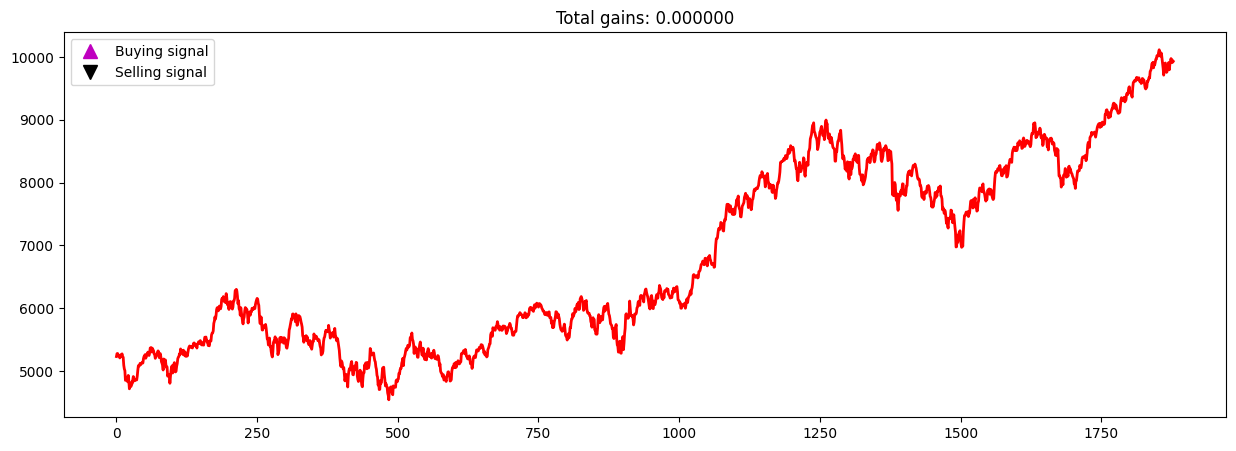

Training in progress...: 100%|██████████| 1878/1878 [07:58<00:00,  3.93it/s]


Running episode 7/10


Training in progress...:   0%|          | 0/1878 [00:00<?, ?it/s]

[[0.         0.         0.51795985]] 2


Training in progress...:   0%|          | 1/1878 [00:00<09:28,  3.30it/s]

[[0.         0.         0.51409117]] 2


Training in progress...:   0%|          | 2/1878 [00:00<08:45,  3.57it/s]

[[0.         0.         0.54945833]] 2


Training in progress...:   0%|          | 3/1878 [00:00<08:55,  3.50it/s]

[[0.         0.         0.59521546]] 2


Training in progress...:   0%|          | 4/1878 [00:01<08:56,  3.50it/s]

[[0.         0.         0.47284016]] 2


Training in progress...:   0%|          | 5/1878 [00:01<08:51,  3.52it/s]

[[0.         0.         0.41288846]] 2


Training in progress...:   0%|          | 6/1878 [00:01<08:49,  3.53it/s]

[[0.         0.         0.52667312]] 2


Training in progress...:   0%|          | 7/1878 [00:02<08:58,  3.48it/s]

[[0.        0.        0.4931248]] 2


Training in progress...:   0%|          | 8/1878 [00:02<08:56,  3.48it/s]

[[0.         0.         0.49449776]] 2


Training in progress...:   0%|          | 9/1878 [00:02<08:45,  3.56it/s]

[[0.         0.         0.47239398]] 2


Training in progress...:   1%|          | 10/1878 [00:02<08:50,  3.52it/s]

[[0.         0.         0.38714369]] 2


Training in progress...:   1%|          | 11/1878 [00:03<08:50,  3.52it/s]

[[0.         0.         0.38831538]] 2


Training in progress...:   1%|          | 12/1878 [00:03<08:50,  3.52it/s]

[[0.         0.         0.18561193]] 2


Training in progress...:   1%|          | 13/1878 [00:03<08:49,  3.52it/s]

[[0.         0.         0.19927167]] 2


Training in progress...:   1%|          | 14/1878 [00:03<08:48,  3.53it/s]

[[0.         0.         0.23664116]] 2


Training in progress...:   1%|          | 15/1878 [00:04<08:58,  3.46it/s]

[[0.         0.         0.26446309]] 2


Training in progress...:   1%|          | 16/1878 [00:04<08:35,  3.61it/s]

[[0.         0.         0.41305909]] 2


Training in progress...:   1%|          | 17/1878 [00:04<08:12,  3.78it/s]

[[0.03420691 0.         0.38832834]] 2


Training in progress...:   1%|          | 18/1878 [00:05<08:01,  3.86it/s]

[[0.         0.         0.31145065]] 2


Training in progress...:   1%|          | 19/1878 [00:05<07:52,  3.94it/s]

[[0.         0.         0.48208411]] 2


Training in progress...:   1%|          | 20/1878 [00:05<08:00,  3.87it/s]

[[0.         0.         0.52100652]] 2


Training in progress...:   1%|          | 21/1878 [00:05<07:53,  3.92it/s]

[[0.         0.         0.52373507]] 2


Training in progress...:   1%|          | 22/1878 [00:06<07:51,  3.94it/s]

[[0.         0.         0.40226375]] 2


Training in progress...:   1%|          | 23/1878 [00:06<07:45,  3.98it/s]

[[0.         0.         0.46409474]] 2


Training in progress...:   1%|▏         | 24/1878 [00:06<07:45,  3.98it/s]

[[0.         0.         0.30340502]] 2


Training in progress...:   1%|▏         | 25/1878 [00:06<07:47,  3.96it/s]

[[0.         0.         0.36450059]] 2


Training in progress...:   1%|▏         | 26/1878 [00:07<07:50,  3.93it/s]

[[0.         0.         0.27558216]] 2


Training in progress...:   1%|▏         | 27/1878 [00:07<07:44,  3.98it/s]

[[0.         0.         0.25874415]] 2


Training in progress...:   1%|▏         | 28/1878 [00:07<07:32,  4.08it/s]

[[0.         0.         0.19029532]] 2


Training in progress...:   2%|▏         | 29/1878 [00:07<07:38,  4.03it/s]

[[0.         0.         0.31438147]] 2


Training in progress...:   2%|▏         | 30/1878 [00:08<07:51,  3.92it/s]

[[0.         0.         0.45828314]] 2


Training in progress...:   2%|▏         | 31/1878 [00:08<07:48,  3.94it/s]

[[0.         0.03779581 0.43691976]] 2


Training in progress...:   2%|▏         | 32/1878 [00:08<07:36,  4.04it/s]

[[0.         0.13220929 0.41355604]] 2


Training in progress...:   2%|▏         | 33/1878 [00:08<07:42,  3.99it/s]

[[0.         0.19577113 0.25909436]] 2


Training in progress...:   2%|▏         | 34/1878 [00:09<07:46,  3.96it/s]

[[0.         0.19036419 0.16078558]] 1


Training in progress...:   2%|▏         | 35/1878 [00:09<07:50,  3.92it/s]

[[0.         0.25714674 0.27167482]] 2


Training in progress...:   2%|▏         | 36/1878 [00:09<07:43,  3.98it/s]

[[0.         0.2887834  0.21274546]] 1


Training in progress...:   2%|▏         | 37/1878 [00:09<07:59,  3.84it/s]

[[0.         0.11961284 0.32768685]] 2


Training in progress...:   2%|▏         | 38/1878 [00:10<08:08,  3.77it/s]

[[0.         0.         0.35343257]] 2


Training in progress...:   2%|▏         | 39/1878 [00:10<07:49,  3.91it/s]

[[0.        0.        0.3331313]] 2


Training in progress...:   2%|▏         | 40/1878 [00:10<07:33,  4.06it/s]

[[0.         0.         0.51179821]] 2


Training in progress...:   2%|▏         | 41/1878 [00:10<07:43,  3.97it/s]

[[0.         0.         0.47270173]] 2


Training in progress...:   2%|▏         | 42/1878 [00:11<07:38,  4.01it/s]

[[0.         0.         0.59513535]] 2


Training in progress...:   2%|▏         | 43/1878 [00:11<07:37,  4.01it/s]

[[0.         0.         0.52162174]] 2


Training in progress...:   2%|▏         | 44/1878 [00:11<07:27,  4.09it/s]

[[0.         0.         0.23731904]] 2


Training in progress...:   2%|▏         | 45/1878 [00:11<07:27,  4.10it/s]

[[0.         0.         0.45878598]] 2


Training in progress...:   2%|▏         | 46/1878 [00:12<07:45,  3.93it/s]

[[0.         0.         0.43220032]] 2


Training in progress...:   3%|▎         | 47/1878 [00:12<07:35,  4.02it/s]

[[0.         0.         0.40743601]] 2


Training in progress...:   3%|▎         | 48/1878 [00:12<07:30,  4.06it/s]

[[0.         0.         0.29450638]] 2


Training in progress...:   3%|▎         | 49/1878 [00:12<07:25,  4.10it/s]

[[0.         0.         0.30947995]] 2


Training in progress...:   3%|▎         | 50/1878 [00:13<07:46,  3.92it/s]

[[0.         0.         0.32299044]] 2


Training in progress...:   3%|▎         | 51/1878 [00:13<07:39,  3.98it/s]

[[0.         0.         0.27245876]] 2


Training in progress...:   3%|▎         | 52/1878 [00:13<07:30,  4.05it/s]

[[0.         0.         0.24637779]] 2


Training in progress...:   3%|▎         | 53/1878 [00:13<07:31,  4.05it/s]

[[0.         0.         0.23634148]] 2


Training in progress...:   3%|▎         | 54/1878 [00:14<07:45,  3.92it/s]

[[0.         0.         0.13524913]] 2


Training in progress...:   3%|▎         | 55/1878 [00:14<07:37,  3.98it/s]

[[0.         0.         0.26086887]] 2


Training in progress...:   3%|▎         | 56/1878 [00:14<07:51,  3.87it/s]

[[0.         0.         0.25363061]] 2


Training in progress...:   3%|▎         | 57/1878 [00:14<07:39,  3.96it/s]

[[0.         0.         0.31062223]] 2


Training in progress...:   3%|▎         | 58/1878 [00:15<08:11,  3.70it/s]

[[0.         0.         0.44786984]] 2


Training in progress...:   3%|▎         | 59/1878 [00:15<08:07,  3.73it/s]

[[0.         0.         0.29830451]] 2


Training in progress...:   3%|▎         | 60/1878 [00:15<08:03,  3.76it/s]

[[0.         0.         0.33556249]] 2


Training in progress...:   3%|▎         | 61/1878 [00:15<08:11,  3.70it/s]

[[0.         0.         0.50972241]] 2


Training in progress...:   3%|▎         | 62/1878 [00:16<08:23,  3.61it/s]

[[0.08917393 0.         0.51618437]] 2


Training in progress...:   3%|▎         | 63/1878 [00:16<08:11,  3.69it/s]

[[0.10724435 0.         0.14909617]] 2


Training in progress...:   3%|▎         | 64/1878 [00:16<08:14,  3.67it/s]

[[0.16641396 0.         0.18279645]] 2


Training in progress...:   3%|▎         | 65/1878 [00:17<08:32,  3.54it/s]

[[0.12414574 0.         0.26105556]] 2


Training in progress...:   4%|▎         | 66/1878 [00:17<08:27,  3.57it/s]

[[0.05891599 0.         0.38946046]] 2


Training in progress...:   4%|▎         | 67/1878 [00:17<08:25,  3.58it/s]

[[0.19242428 0.         0.35636303]] 2


Training in progress...:   4%|▎         | 68/1878 [00:17<08:28,  3.56it/s]

[[0.11980519 0.         0.60185623]] 2


Training in progress...:   4%|▎         | 69/1878 [00:18<08:39,  3.48it/s]

[[0.23362526 0.         0.78278771]] 2


Training in progress...:   4%|▎         | 70/1878 [00:18<08:24,  3.58it/s]

[[0.20870095 0.         0.76176054]] 2


Training in progress...:   4%|▍         | 71/1878 [00:18<08:07,  3.71it/s]

[[0.20969271 0.         0.84948386]] 2


Training in progress...:   4%|▍         | 72/1878 [00:18<07:55,  3.80it/s]

[[0.19097348 0.         0.66481528]] 2


Training in progress...:   4%|▍         | 73/1878 [00:19<08:05,  3.72it/s]

[[0.1498589  0.         0.82618551]] 2


Training in progress...:   4%|▍         | 74/1878 [00:19<08:09,  3.69it/s]

[[0.         0.         0.76109429]] 2


Training in progress...:   4%|▍         | 75/1878 [00:19<08:09,  3.68it/s]

[[0.         0.         0.93284165]] 2


Training in progress...:   4%|▍         | 76/1878 [00:20<08:31,  3.52it/s]

[[0.         0.         0.85872472]] 2


Training in progress...:   4%|▍         | 77/1878 [00:20<08:28,  3.54it/s]

[[0.         0.         0.84342729]] 2


Training in progress...:   4%|▍         | 78/1878 [00:20<08:30,  3.52it/s]

[[0.         0.         0.70568344]] 2


Training in progress...:   4%|▍         | 79/1878 [00:20<08:42,  3.45it/s]

[[0.         0.         0.59566035]] 2


Training in progress...:   4%|▍         | 80/1878 [00:21<08:44,  3.43it/s]

[[0.        0.        0.4862789]] 2


Training in progress...:   4%|▍         | 81/1878 [00:21<08:24,  3.56it/s]

[[0.         0.         0.48421468]] 2


Training in progress...:   4%|▍         | 82/1878 [00:21<08:00,  3.74it/s]

[[0.         0.         0.30279063]] 2


Training in progress...:   4%|▍         | 83/1878 [00:22<07:50,  3.81it/s]

[[0.         0.         0.18140812]] 2


Training in progress...:   4%|▍         | 84/1878 [00:22<07:43,  3.87it/s]

[[0.         0.         0.10787656]] 2


Training in progress...:   5%|▍         | 85/1878 [00:22<07:29,  3.99it/s]

[[0.        0.        0.1884361]] 2


Training in progress...:   5%|▍         | 86/1878 [00:22<07:39,  3.90it/s]

[[0.         0.         0.30157073]] 2


Training in progress...:   5%|▍         | 87/1878 [00:23<07:34,  3.94it/s]

[[0.         0.         0.51021743]] 2


Training in progress...:   5%|▍         | 88/1878 [00:23<07:33,  3.95it/s]

[[0.         0.         0.60390878]] 2


Training in progress...:   5%|▍         | 89/1878 [00:23<07:28,  3.99it/s]

[[0.         0.01480263 0.51098184]] 2


Training in progress...:   5%|▍         | 90/1878 [00:23<07:33,  3.94it/s]

[[0.         0.         0.51191881]] 2


Training in progress...:   5%|▍         | 91/1878 [00:24<07:30,  3.97it/s]

[[0.         0.         0.38449786]] 2


Training in progress...:   5%|▍         | 92/1878 [00:24<07:24,  4.02it/s]

[[0.        0.        0.6506718]] 2


Training in progress...:   5%|▍         | 93/1878 [00:24<07:30,  3.96it/s]

[[0.         0.         0.61273276]] 2


Training in progress...:   5%|▌         | 94/1878 [00:24<07:35,  3.92it/s]

[[0.         0.         0.60775708]] 2


Training in progress...:   5%|▌         | 95/1878 [00:25<07:37,  3.90it/s]

[[0.        0.        0.6444082]] 2


Training in progress...:   5%|▌         | 96/1878 [00:25<07:34,  3.92it/s]

[[0.         0.         0.60743955]] 2


Training in progress...:   5%|▌         | 97/1878 [00:25<07:20,  4.04it/s]

[[0.         0.         0.44911798]] 2


Training in progress...:   5%|▌         | 98/1878 [00:25<07:17,  4.07it/s]

[[0.         0.         0.43066365]] 2


Training in progress...:   5%|▌         | 99/1878 [00:26<07:21,  4.03it/s]

[[0.         0.         0.45547679]] 2


Training in progress...:   5%|▌         | 100/1878 [00:26<07:19,  4.05it/s]

[[0.         0.         0.49384383]] 2


Training in progress...:   5%|▌         | 101/1878 [00:26<07:14,  4.09it/s]

[[0.         0.         0.60235777]] 2


Training in progress...:   5%|▌         | 102/1878 [00:26<07:18,  4.05it/s]

[[0.         0.         0.56236674]] 2


Training in progress...:   5%|▌         | 103/1878 [00:27<07:33,  3.92it/s]

[[0.         0.         0.52482798]] 2


Training in progress...:   6%|▌         | 104/1878 [00:27<07:25,  3.98it/s]

[[0.        0.        0.4881878]] 2


Training in progress...:   6%|▌         | 105/1878 [00:27<07:22,  4.01it/s]

[[0.         0.         0.44870663]] 2


Training in progress...:   6%|▌         | 106/1878 [00:27<07:35,  3.89it/s]

[[0.         0.         0.41941611]] 2


Training in progress...:   6%|▌         | 107/1878 [00:28<07:35,  3.89it/s]

[[0.         0.         0.29673662]] 2


Training in progress...:   6%|▌         | 108/1878 [00:28<07:37,  3.87it/s]

[[0.         0.         0.37858328]] 2


Training in progress...:   6%|▌         | 109/1878 [00:28<07:46,  3.79it/s]

[[0.         0.         0.40252385]] 2


Training in progress...:   6%|▌         | 110/1878 [00:28<07:43,  3.81it/s]

[[0.         0.         0.47551391]] 2


Training in progress...:   6%|▌         | 111/1878 [00:29<07:42,  3.82it/s]

[[0.         0.         0.64680105]] 2


Training in progress...:   6%|▌         | 112/1878 [00:29<07:33,  3.90it/s]

[[0.         0.         0.58893803]] 2


Training in progress...:   6%|▌         | 113/1878 [00:29<07:34,  3.88it/s]

[[0.         0.         0.68725868]] 2


Training in progress...:   6%|▌         | 114/1878 [00:29<07:36,  3.87it/s]

[[0.         0.         0.54538166]] 2


Training in progress...:   6%|▌         | 115/1878 [00:30<07:46,  3.78it/s]

[[0.         0.         0.66249264]] 2


Training in progress...:   6%|▌         | 116/1878 [00:30<07:37,  3.85it/s]

[[0.         0.         0.72802373]] 2


Training in progress...:   6%|▌         | 117/1878 [00:30<07:33,  3.88it/s]

[[0.         0.         0.70687374]] 2


Training in progress...:   6%|▋         | 118/1878 [00:30<07:42,  3.81it/s]

[[0.         0.         0.54962679]] 2


Training in progress...:   6%|▋         | 119/1878 [00:31<07:49,  3.75it/s]

[[0.         0.         0.46885746]] 2


Training in progress...:   6%|▋         | 120/1878 [00:31<08:00,  3.66it/s]

[[0.         0.         0.65124727]] 2


Training in progress...:   6%|▋         | 121/1878 [00:31<07:58,  3.67it/s]

[[0.06107368 0.         0.55683149]] 2


Training in progress...:   6%|▋         | 122/1878 [00:32<08:14,  3.55it/s]

[[0.         0.         0.46034905]] 2


Training in progress...:   7%|▋         | 123/1878 [00:32<08:08,  3.59it/s]

[[0.10727475 0.         0.45919321]] 2


Training in progress...:   7%|▋         | 124/1878 [00:32<08:00,  3.65it/s]

[[0.33476927 0.         0.50510477]] 2


Training in progress...:   7%|▋         | 125/1878 [00:32<07:50,  3.73it/s]

[[0.02408478 0.         0.48570639]] 2


Training in progress...:   7%|▋         | 126/1878 [00:33<08:05,  3.61it/s]

[[0.0786542  0.         0.45460953]] 2


Training in progress...:   7%|▋         | 127/1878 [00:33<07:57,  3.67it/s]

[[0.02344278 0.         0.40591963]] 2


Training in progress...:   7%|▋         | 128/1878 [00:33<08:09,  3.57it/s]

[[0.         0.         0.59739972]] 2


Training in progress...:   7%|▋         | 129/1878 [00:33<08:11,  3.56it/s]

[[0.         0.         0.70570417]] 2


Training in progress...:   7%|▋         | 130/1878 [00:34<08:12,  3.55it/s]

[[0.         0.         0.53423146]] 2


Training in progress...:   7%|▋         | 131/1878 [00:34<08:03,  3.61it/s]

[[0.         0.         0.75875491]] 2


Training in progress...:   7%|▋         | 132/1878 [00:34<07:47,  3.73it/s]

[[0.         0.         0.66076402]] 2


Training in progress...:   7%|▋         | 133/1878 [00:35<07:55,  3.67it/s]

[[0.         0.         0.79459909]] 2


Training in progress...:   7%|▋         | 134/1878 [00:35<07:53,  3.68it/s]

[[0.         0.         0.72846661]] 2


Training in progress...:   7%|▋         | 135/1878 [00:35<07:48,  3.72it/s]

[[0.         0.         0.73401959]] 2


Training in progress...:   7%|▋         | 136/1878 [00:35<07:48,  3.72it/s]

[[0.         0.         0.59114975]] 2


Training in progress...:   7%|▋         | 137/1878 [00:36<08:09,  3.56it/s]

[[0.         0.         0.51624355]] 2


Training in progress...:   7%|▋         | 138/1878 [00:36<08:08,  3.56it/s]

[[0.         0.         0.64271961]] 2


Training in progress...:   7%|▋         | 139/1878 [00:36<08:09,  3.55it/s]

[[0.         0.         0.81159288]] 2


Training in progress...:   7%|▋         | 140/1878 [00:37<08:09,  3.55it/s]

[[0.         0.         0.88047725]] 2


Training in progress...:   8%|▊         | 141/1878 [00:37<08:27,  3.42it/s]

[[0.         0.         0.78921042]] 2


Training in progress...:   8%|▊         | 142/1878 [00:37<08:23,  3.45it/s]

[[0.         0.         0.77625977]] 2


Training in progress...:   8%|▊         | 143/1878 [00:37<08:02,  3.59it/s]

[[0.         0.         0.60417162]] 2


Training in progress...:   8%|▊         | 144/1878 [00:38<08:03,  3.59it/s]

[[0.         0.         0.47231704]] 2


Training in progress...:   8%|▊         | 145/1878 [00:38<07:43,  3.74it/s]

[[0.         0.         0.48636809]] 2


Training in progress...:   8%|▊         | 146/1878 [00:38<07:35,  3.80it/s]

[[0.        0.        0.6004251]] 2


Training in progress...:   8%|▊         | 147/1878 [00:38<07:32,  3.83it/s]

[[0.         0.         0.51029023]] 2


Training in progress...:   8%|▊         | 148/1878 [00:39<07:34,  3.81it/s]

[[0.         0.         0.37300492]] 2


Training in progress...:   8%|▊         | 149/1878 [00:39<07:17,  3.95it/s]

[[0.        0.        0.5392385]] 2


Training in progress...:   8%|▊         | 150/1878 [00:39<07:12,  4.00it/s]

[[0.         0.         0.60983852]] 2


Training in progress...:   8%|▊         | 151/1878 [00:39<07:14,  3.98it/s]

[[0.         0.         0.43451793]] 2


Training in progress...:   8%|▊         | 152/1878 [00:40<07:20,  3.92it/s]

[[0.         0.         0.38855026]] 2


Training in progress...:   8%|▊         | 153/1878 [00:40<07:11,  3.99it/s]

[[0.         0.01651591 0.26595085]] 2


Training in progress...:   8%|▊         | 154/1878 [00:40<07:17,  3.94it/s]

[[0.         0.         0.27764374]] 2


Training in progress...:   8%|▊         | 155/1878 [00:40<07:18,  3.93it/s]

[[0.         0.         0.34195897]] 2


Training in progress...:   8%|▊         | 156/1878 [00:41<07:10,  4.00it/s]

[[0.         0.02752029 0.42818301]] 2


Training in progress...:   8%|▊         | 157/1878 [00:41<07:07,  4.02it/s]

[[0.         0.         0.41834215]] 2


Training in progress...:   8%|▊         | 158/1878 [00:41<07:02,  4.08it/s]

[[0.         0.         0.51517016]] 2


Training in progress...:   8%|▊         | 159/1878 [00:41<07:05,  4.04it/s]

[[0.         0.         0.61242024]] 2


Training in progress...:   9%|▊         | 160/1878 [00:42<07:15,  3.94it/s]

[[0.         0.         0.40715878]] 2


Training in progress...:   9%|▊         | 161/1878 [00:42<07:08,  4.01it/s]

[[0.         0.14286069 0.34588289]] 2


Training in progress...:   9%|▊         | 162/1878 [00:42<07:09,  3.99it/s]

[[0.         0.         0.44780968]] 2


Training in progress...:   9%|▊         | 163/1878 [00:42<07:08,  4.00it/s]

[[0.         0.06601325 0.47281788]] 2


Training in progress...:   9%|▊         | 164/1878 [00:43<07:18,  3.91it/s]

[[0.         0.         0.45571496]] 2


Training in progress...:   9%|▉         | 165/1878 [00:43<07:10,  3.98it/s]

[[0.        0.        0.3581507]] 2


Training in progress...:   9%|▉         | 166/1878 [00:43<07:01,  4.06it/s]

[[0.         0.02493739 0.23207252]] 2


Training in progress...:   9%|▉         | 167/1878 [00:43<07:07,  4.00it/s]

[[0.         0.         0.35712365]] 2


Training in progress...:   9%|▉         | 168/1878 [00:44<07:18,  3.90it/s]

[[0.         0.         0.24611925]] 2


Training in progress...:   9%|▉         | 169/1878 [00:44<07:03,  4.03it/s]

[[0.         0.0385902  0.37813222]] 2


Training in progress...:   9%|▉         | 170/1878 [00:44<06:59,  4.07it/s]

[[0.         0.         0.44848325]] 2


Training in progress...:   9%|▉         | 171/1878 [00:44<07:05,  4.01it/s]

[[0.         0.         0.49171037]] 2


Training in progress...:   9%|▉         | 172/1878 [00:45<07:06,  4.00it/s]

[[0.         0.         0.57436828]] 2


Training in progress...:   9%|▉         | 173/1878 [00:45<06:56,  4.09it/s]

[[0.         0.         0.39567299]] 2


Training in progress...:   9%|▉         | 174/1878 [00:45<06:54,  4.12it/s]

[[0.         0.         0.31874161]] 2


Training in progress...:   9%|▉         | 175/1878 [00:45<07:01,  4.04it/s]

[[0.         0.         0.20998882]] 2


Training in progress...:   9%|▉         | 176/1878 [00:46<07:07,  3.98it/s]

[[0.         0.         0.26835761]] 2


Training in progress...:   9%|▉         | 177/1878 [00:46<06:58,  4.06it/s]

[[0.         0.         0.29509535]] 2


Training in progress...:   9%|▉         | 178/1878 [00:46<06:46,  4.18it/s]

[[0.         0.         0.29734005]] 2


Training in progress...:  10%|▉         | 179/1878 [00:46<06:53,  4.11it/s]

[[0.         0.         0.28174837]] 2


Training in progress...:  10%|▉         | 180/1878 [00:47<07:03,  4.01it/s]

[[0.         0.         0.36198149]] 2


Training in progress...:  10%|▉         | 181/1878 [00:47<07:03,  4.00it/s]

[[0.         0.         0.61203892]] 2


Training in progress...:  10%|▉         | 182/1878 [00:47<07:04,  4.00it/s]

[[0.         0.         0.67560873]] 2


Training in progress...:  10%|▉         | 183/1878 [00:47<07:14,  3.90it/s]

[[0.         0.         0.59147261]] 2


Training in progress...:  10%|▉         | 184/1878 [00:48<07:30,  3.76it/s]

[[0.         0.         0.49423573]] 2


Training in progress...:  10%|▉         | 185/1878 [00:48<07:25,  3.80it/s]

[[0.         0.         0.45165181]] 2


Training in progress...:  10%|▉         | 186/1878 [00:48<07:19,  3.85it/s]

[[0.         0.         0.36459123]] 2


Training in progress...:  10%|▉         | 187/1878 [00:48<07:30,  3.75it/s]

[[0.         0.         0.21652995]] 2


Training in progress...:  10%|█         | 188/1878 [00:49<07:30,  3.75it/s]

[[0.         0.         0.33861952]] 2


Training in progress...:  10%|█         | 189/1878 [00:49<07:18,  3.85it/s]

[[0.         0.         0.14181612]] 2


Training in progress...:  10%|█         | 190/1878 [00:49<07:16,  3.87it/s]

[[0.         0.         0.17904987]] 2


Training in progress...:  10%|█         | 191/1878 [00:50<07:33,  3.72it/s]

[[0.         0.         0.18220939]] 2


Training in progress...:  10%|█         | 192/1878 [00:50<07:31,  3.74it/s]

[[0.         0.         0.18331519]] 2


Training in progress...:  10%|█         | 193/1878 [00:50<07:21,  3.82it/s]

[[0.         0.         0.27187162]] 2


Training in progress...:  10%|█         | 194/1878 [00:50<07:26,  3.77it/s]

[[0.         0.         0.45870654]] 2


Training in progress...:  10%|█         | 195/1878 [00:51<07:27,  3.76it/s]

[[0.        0.        0.4961602]] 2


Training in progress...:  10%|█         | 196/1878 [00:51<07:45,  3.62it/s]

[[0.         0.         0.48875678]] 2


Training in progress...:  10%|█         | 197/1878 [00:51<07:47,  3.59it/s]

[[0.         0.         0.41029443]] 2


Training in progress...:  11%|█         | 198/1878 [00:51<07:45,  3.61it/s]

[[0.         0.         0.52032822]] 2


Training in progress...:  11%|█         | 199/1878 [00:52<07:38,  3.66it/s]

[[0.        0.        0.6050536]] 2


Training in progress...:  11%|█         | 200/1878 [00:52<07:53,  3.55it/s]

[[0.         0.         0.59721489]] 2


Training in progress...:  11%|█         | 201/1878 [00:52<08:04,  3.46it/s]

[[0.035218   0.         0.48811582]] 2


Training in progress...:  11%|█         | 202/1878 [00:53<08:07,  3.44it/s]

[[0.25610843 0.         0.50724814]] 2


Training in progress...:  11%|█         | 203/1878 [00:53<07:52,  3.55it/s]

[[0.0943588  0.         0.41730734]] 2


Training in progress...:  11%|█         | 204/1878 [00:53<07:54,  3.53it/s]

[[0.         0.         0.35589625]] 2


Training in progress...:  11%|█         | 205/1878 [00:53<07:58,  3.50it/s]

[[0.01962103 0.         0.31317713]] 2


Training in progress...:  11%|█         | 206/1878 [00:54<07:55,  3.51it/s]

[[0.23345567 0.         0.12197592]] 0


Training in progress...:  11%|█         | 207/1878 [00:54<07:55,  3.51it/s]

[[0.19486927 0.         0.2523594 ]] 2


Training in progress...:  11%|█         | 208/1878 [00:54<07:36,  3.66it/s]

[[0.15025838 0.         0.3010138 ]] 2


Training in progress...:  11%|█         | 209/1878 [00:55<07:26,  3.74it/s]

[[0.         0.         0.26194468]] 2


Training in progress...:  11%|█         | 210/1878 [00:55<07:14,  3.84it/s]

[[0.         0.         0.16757943]] 2


Training in progress...:  11%|█         | 211/1878 [00:55<07:04,  3.93it/s]

[[0.        0.        0.2044822]] 2


Training in progress...:  11%|█▏        | 212/1878 [00:55<07:10,  3.87it/s]

[[0.         0.         0.45265235]] 2


Training in progress...:  11%|█▏        | 213/1878 [00:56<07:13,  3.84it/s]

[[0.         0.         0.48114413]] 2


Training in progress...:  11%|█▏        | 214/1878 [00:56<07:05,  3.91it/s]

[[0.         0.         0.52864684]] 2


Training in progress...:  11%|█▏        | 215/1878 [00:56<06:55,  4.01it/s]

[[0.         0.         0.41710812]] 2


Training in progress...:  12%|█▏        | 216/1878 [00:56<06:49,  4.06it/s]

[[0.         0.         0.45412593]] 2


Training in progress...:  12%|█▏        | 217/1878 [00:57<06:58,  3.97it/s]

[[0.         0.         0.43637443]] 2


Training in progress...:  12%|█▏        | 218/1878 [00:57<06:57,  3.98it/s]

[[0.         0.         0.63205474]] 2


Training in progress...:  12%|█▏        | 219/1878 [00:57<06:54,  4.01it/s]

[[0.         0.         0.60937441]] 2


Training in progress...:  12%|█▏        | 220/1878 [00:57<06:45,  4.09it/s]

[[0.         0.         0.46597214]] 2


Training in progress...:  12%|█▏        | 221/1878 [00:58<06:56,  3.98it/s]

[[0.         0.         0.47415882]] 2


Training in progress...:  12%|█▏        | 222/1878 [00:58<06:57,  3.97it/s]

[[0.         0.         0.52290696]] 2


Training in progress...:  12%|█▏        | 223/1878 [00:58<06:50,  4.03it/s]

[[0.         0.         0.53608551]] 2


Training in progress...:  12%|█▏        | 224/1878 [00:58<06:50,  4.03it/s]

[[0.         0.         0.60642879]] 2


Training in progress...:  12%|█▏        | 225/1878 [00:59<06:56,  3.97it/s]

[[0.         0.         0.51074892]] 2


Training in progress...:  12%|█▏        | 226/1878 [00:59<06:42,  4.11it/s]

[[0.         0.         0.55557086]] 2


Training in progress...:  12%|█▏        | 227/1878 [00:59<06:41,  4.11it/s]

[[0.         0.         0.60272792]] 2


Training in progress...:  12%|█▏        | 228/1878 [00:59<06:39,  4.13it/s]

[[0.         0.         0.56569583]] 2


Training in progress...:  12%|█▏        | 229/1878 [01:00<06:55,  3.97it/s]

[[0.         0.         0.47152843]] 2


Training in progress...:  12%|█▏        | 230/1878 [01:00<06:50,  4.01it/s]

[[0.         0.         0.52038023]] 2


Training in progress...:  12%|█▏        | 231/1878 [01:00<06:56,  3.95it/s]

[[0.         0.         0.41547074]] 2


Training in progress...:  12%|█▏        | 232/1878 [01:00<06:50,  4.01it/s]

[[0.         0.         0.43662817]] 2


Training in progress...:  12%|█▏        | 233/1878 [01:01<07:04,  3.87it/s]

[[0.         0.         0.38441213]] 2


Training in progress...:  12%|█▏        | 234/1878 [01:01<06:56,  3.95it/s]

[[0.         0.         0.35704334]] 2


Training in progress...:  13%|█▎        | 235/1878 [01:01<06:53,  3.98it/s]

[[0.         0.         0.24077352]] 2


Training in progress...:  13%|█▎        | 236/1878 [01:01<06:49,  4.01it/s]

[[0.         0.         0.26071328]] 2


Training in progress...:  13%|█▎        | 237/1878 [01:02<06:56,  3.94it/s]

[[0.         0.         0.38334326]] 2


Training in progress...:  13%|█▎        | 238/1878 [01:02<06:52,  3.97it/s]

[[0.        0.        0.4460626]] 2


Training in progress...:  13%|█▎        | 239/1878 [01:02<06:42,  4.07it/s]

[[0.         0.         0.26432981]] 2


Training in progress...:  13%|█▎        | 240/1878 [01:02<06:38,  4.11it/s]

[[0.         0.         0.22534864]] 2


Training in progress...:  13%|█▎        | 241/1878 [01:03<06:47,  4.02it/s]

[[0.         0.         0.35924467]] 2


Training in progress...:  13%|█▎        | 242/1878 [01:03<06:53,  3.96it/s]

[[0.         0.         0.43335792]] 2


Training in progress...:  13%|█▎        | 243/1878 [01:03<06:51,  3.97it/s]

[[0.         0.         0.47160955]] 2


Training in progress...:  13%|█▎        | 244/1878 [01:03<06:51,  3.97it/s]

[[0.         0.         0.32799465]] 2


Training in progress...:  13%|█▎        | 245/1878 [01:04<07:01,  3.87it/s]

[[0.         0.         0.38347537]] 2


Training in progress...:  13%|█▎        | 246/1878 [01:04<06:58,  3.90it/s]

[[0.         0.         0.43249941]] 2


Training in progress...:  13%|█▎        | 247/1878 [01:04<06:56,  3.91it/s]

[[0.         0.         0.44108367]] 2


Training in progress...:  13%|█▎        | 248/1878 [01:04<07:09,  3.80it/s]

[[0.         0.         0.37937954]] 2


Training in progress...:  13%|█▎        | 249/1878 [01:05<07:25,  3.65it/s]

[[0.         0.         0.26845718]] 2


Training in progress...:  13%|█▎        | 250/1878 [01:05<07:30,  3.62it/s]

[[0.         0.         0.07928583]] 2


Training in progress...:  13%|█▎        | 251/1878 [01:05<07:24,  3.66it/s]

[[0.         0.         0.34678818]] 2


Training in progress...:  13%|█▎        | 252/1878 [01:05<07:26,  3.65it/s]

[[0.         0.         0.43684643]] 2


Training in progress...:  13%|█▎        | 253/1878 [01:06<07:26,  3.64it/s]

[[0.         0.         0.38820126]] 2


Training in progress...:  14%|█▎        | 254/1878 [01:06<07:12,  3.75it/s]

[[0.         0.00371402 0.39511944]] 2


Training in progress...:  14%|█▎        | 255/1878 [01:06<07:29,  3.61it/s]

[[0.         0.         0.56171191]] 2


Training in progress...:  14%|█▎        | 256/1878 [01:07<07:32,  3.58it/s]

[[0.         0.         0.48726402]] 2


Training in progress...:  14%|█▎        | 257/1878 [01:07<07:28,  3.61it/s]

[[0.         0.         0.46440403]] 2


Training in progress...:  14%|█▎        | 258/1878 [01:07<07:15,  3.72it/s]

[[0.         0.         0.36235643]] 2


Training in progress...:  14%|█▍        | 259/1878 [01:07<07:17,  3.70it/s]

[[0.         0.         0.15895999]] 2


Training in progress...:  14%|█▍        | 260/1878 [01:08<07:24,  3.64it/s]

[[0.         0.         0.43739206]] 2


Training in progress...:  14%|█▍        | 261/1878 [01:08<07:27,  3.61it/s]

[[0.         0.         0.42258978]] 2


Training in progress...:  14%|█▍        | 262/1878 [01:08<07:33,  3.56it/s]

[[0.         0.         0.35956392]] 2


Training in progress...:  14%|█▍        | 263/1878 [01:08<07:26,  3.62it/s]

[[0.         0.         0.36188715]] 2


Training in progress...:  14%|█▍        | 264/1878 [01:09<07:17,  3.69it/s]

[[0.         0.         0.32043792]] 2


Training in progress...:  14%|█▍        | 265/1878 [01:09<07:34,  3.55it/s]

[[0.         0.         0.31732715]] 2


Training in progress...:  14%|█▍        | 266/1878 [01:09<07:42,  3.49it/s]

[[0.         0.         0.38293545]] 2


Training in progress...:  14%|█▍        | 267/1878 [01:10<07:47,  3.45it/s]

[[0.         0.         0.62182982]] 2


Training in progress...:  14%|█▍        | 268/1878 [01:10<07:49,  3.43it/s]

[[0.         0.         0.46315768]] 2


Training in progress...:  14%|█▍        | 269/1878 [01:10<08:00,  3.35it/s]

[[0.16717628 0.         0.34279895]] 2


Training in progress...:  14%|█▍        | 270/1878 [01:11<07:39,  3.50it/s]

[[0.02025837 0.         0.29612868]] 2


Training in progress...:  14%|█▍        | 271/1878 [01:11<07:21,  3.64it/s]

[[0.         0.         0.39972217]] 2


Training in progress...:  14%|█▍        | 272/1878 [01:11<07:09,  3.74it/s]

[[0.         0.         0.30932334]] 2


Training in progress...:  15%|█▍        | 273/1878 [01:11<07:13,  3.70it/s]

[[0.         0.         0.38218458]] 2


Training in progress...:  15%|█▍        | 274/1878 [01:12<07:09,  3.73it/s]

[[0.16950589 0.         0.38346283]] 2


Training in progress...:  15%|█▍        | 275/1878 [01:12<07:01,  3.80it/s]

[[0.0155028  0.         0.35062614]] 2


Training in progress...:  15%|█▍        | 276/1878 [01:12<06:58,  3.83it/s]

[[0.07469586 0.         0.2566532 ]] 2


Training in progress...:  15%|█▍        | 277/1878 [01:12<07:01,  3.80it/s]

[[0.02135127 0.         0.26202022]] 2


Training in progress...:  15%|█▍        | 278/1878 [01:13<06:59,  3.81it/s]

[[0.02883092 0.05465577 0.19100591]] 2


Training in progress...:  15%|█▍        | 279/1878 [01:13<06:49,  3.91it/s]

[[0.         0.         0.26602496]] 2


Training in progress...:  15%|█▍        | 280/1878 [01:13<06:37,  4.02it/s]

[[0.         0.         0.39753354]] 2


Training in progress...:  15%|█▍        | 281/1878 [01:13<06:37,  4.01it/s]

[[0.         0.         0.58158571]] 2


Training in progress...:  15%|█▌        | 282/1878 [01:14<06:44,  3.95it/s]

[[0.         0.         0.77648494]] 2


Training in progress...:  15%|█▌        | 283/1878 [01:14<06:39,  4.00it/s]

[[0.         0.         0.66987855]] 2


Training in progress...:  15%|█▌        | 284/1878 [01:14<06:30,  4.08it/s]

[[0.         0.         0.41081215]] 2


Training in progress...:  15%|█▌        | 285/1878 [01:14<06:30,  4.08it/s]

[[0.         0.         0.43322683]] 2


Training in progress...:  15%|█▌        | 286/1878 [01:15<06:44,  3.94it/s]

[[0.         0.         0.43460481]] 2


Training in progress...:  15%|█▌        | 287/1878 [01:15<06:40,  3.98it/s]

[[0.         0.         0.30344432]] 2


Training in progress...:  15%|█▌        | 288/1878 [01:15<06:40,  3.97it/s]

[[0.         0.         0.25439503]] 2


Training in progress...:  15%|█▌        | 289/1878 [01:15<06:41,  3.96it/s]

[[0.         0.         0.27102641]] 2


Training in progress...:  15%|█▌        | 290/1878 [01:16<06:46,  3.91it/s]

[[0.         0.         0.36232385]] 2


Training in progress...:  15%|█▌        | 291/1878 [01:16<06:42,  3.94it/s]

[[0.         0.         0.45959115]] 2


Training in progress...:  16%|█▌        | 292/1878 [01:16<06:35,  4.01it/s]

[[0.         0.         0.32276106]] 2


Training in progress...:  16%|█▌        | 293/1878 [01:16<06:28,  4.08it/s]

[[0.         0.         0.36183798]] 2


Training in progress...:  16%|█▌        | 294/1878 [01:17<06:49,  3.87it/s]

[[0.         0.         0.56836943]] 2


Training in progress...:  16%|█▌        | 295/1878 [01:17<06:45,  3.91it/s]

[[0.         0.         0.61352407]] 2


Training in progress...:  16%|█▌        | 296/1878 [01:17<06:30,  4.05it/s]

[[0.         0.         0.48220539]] 2


Training in progress...:  16%|█▌        | 297/1878 [01:17<06:38,  3.97it/s]

[[0.         0.         0.62930557]] 2


Training in progress...:  16%|█▌        | 298/1878 [01:18<06:51,  3.84it/s]

[[0.         0.         0.66449616]] 2


Training in progress...:  16%|█▌        | 299/1878 [01:18<06:42,  3.92it/s]

[[0.         0.         0.59371433]] 2


Training in progress...:  16%|█▌        | 300/1878 [01:18<06:33,  4.01it/s]

[[0.        0.        0.5770343]] 2


Training in progress...:  16%|█▌        | 301/1878 [01:18<06:31,  4.03it/s]

[[0.         0.         0.57562943]] 2


Training in progress...:  16%|█▌        | 302/1878 [01:19<06:39,  3.95it/s]

[[0.        0.        0.4827053]] 2


Training in progress...:  16%|█▌        | 303/1878 [01:19<06:32,  4.02it/s]

[[0.         0.         0.56216404]] 2


Training in progress...:  16%|█▌        | 304/1878 [01:19<06:27,  4.07it/s]

[[0.         0.         0.45811116]] 2


Training in progress...:  16%|█▌        | 305/1878 [01:19<06:22,  4.11it/s]

[[0.        0.        0.6461918]] 2


Training in progress...:  16%|█▋        | 306/1878 [01:20<06:30,  4.03it/s]

[[0.         0.         0.60506222]] 2


Training in progress...:  16%|█▋        | 307/1878 [01:20<06:22,  4.10it/s]

[[0.         0.         0.59836348]] 2


Training in progress...:  16%|█▋        | 308/1878 [01:20<06:14,  4.19it/s]

[[0.         0.         0.45046757]] 2


Training in progress...:  16%|█▋        | 309/1878 [01:20<06:38,  3.94it/s]

[[0.         0.         0.33448488]] 2


Training in progress...:  17%|█▋        | 310/1878 [01:21<06:50,  3.82it/s]

[[0.        0.        0.2920319]] 2


Training in progress...:  17%|█▋        | 311/1878 [01:21<07:06,  3.67it/s]

[[0.         0.         0.20144527]] 2


Training in progress...:  17%|█▋        | 312/1878 [01:21<06:59,  3.74it/s]

[[0.         0.         0.14980499]] 2


Training in progress...:  17%|█▋        | 313/1878 [01:21<06:59,  3.73it/s]

[[0.         0.         0.14833467]] 2


Training in progress...:  17%|█▋        | 314/1878 [01:22<06:55,  3.77it/s]

[[0.         0.         0.14246024]] 2


Training in progress...:  17%|█▋        | 315/1878 [01:22<06:41,  3.89it/s]

[[0.         0.         0.13231729]] 2


Training in progress...:  17%|█▋        | 316/1878 [01:22<06:30,  4.00it/s]

[[0.         0.         0.12946675]] 2


Training in progress...:  17%|█▋        | 317/1878 [01:22<06:56,  3.75it/s]

[[0.         0.         0.14716329]] 2


Training in progress...:  17%|█▋        | 318/1878 [01:23<07:20,  3.54it/s]

[[0.        0.        0.2263689]] 2


Training in progress...:  17%|█▋        | 319/1878 [01:23<07:25,  3.50it/s]

[[0. 0. 0.]] 0


Training in progress...:  17%|█▋        | 320/1878 [01:23<07:01,  3.70it/s]

[[0.         0.         0.27193492]] 2


Training in progress...:  17%|█▋        | 321/1878 [01:24<06:47,  3.82it/s]

[[0.         0.         0.13876686]] 2


Training in progress...:  17%|█▋        | 322/1878 [01:24<06:40,  3.89it/s]

[[0.        0.        0.1663797]] 2


Training in progress...:  17%|█▋        | 323/1878 [01:24<06:38,  3.91it/s]

[[0.         0.         0.18070577]] 2


Training in progress...:  17%|█▋        | 324/1878 [01:24<06:28,  4.00it/s]

[[0.         0.         0.31900278]] 2


Training in progress...:  17%|█▋        | 325/1878 [01:25<06:27,  4.01it/s]

[[0.        0.        0.1706229]] 2


Training in progress...:  17%|█▋        | 326/1878 [01:25<06:19,  4.09it/s]

[[0.         0.         0.20283595]] 2


Training in progress...:  17%|█▋        | 327/1878 [01:25<06:21,  4.06it/s]

[[0.         0.         0.25404871]] 2


Training in progress...:  17%|█▋        | 328/1878 [01:25<06:35,  3.92it/s]

[[0.        0.        0.2113915]] 2


Training in progress...:  18%|█▊        | 329/1878 [01:26<07:06,  3.63it/s]

[[0.         0.         0.05952902]] 2


Training in progress...:  18%|█▊        | 330/1878 [01:26<07:07,  3.62it/s]

[[0.       0.       0.084148]] 2


Training in progress...:  18%|█▊        | 331/1878 [01:26<07:12,  3.58it/s]

[[0.         0.         0.09285413]] 2


Training in progress...:  18%|█▊        | 332/1878 [01:26<06:52,  3.75it/s]

[[0.        0.        0.1597767]] 2


Training in progress...:  18%|█▊        | 333/1878 [01:27<06:45,  3.81it/s]

[[0.         0.         0.18595038]] 2


Training in progress...:  18%|█▊        | 334/1878 [01:27<06:45,  3.80it/s]

[[0.         0.         0.33689938]] 2


Training in progress...:  18%|█▊        | 335/1878 [01:27<06:52,  3.74it/s]

[[0.         0.         0.52777714]] 2


Training in progress...:  18%|█▊        | 336/1878 [01:28<07:18,  3.51it/s]

[[0.         0.         0.57491666]] 2


Training in progress...:  18%|█▊        | 337/1878 [01:28<06:59,  3.67it/s]

[[0.         0.         0.69062347]] 2


Training in progress...:  18%|█▊        | 338/1878 [01:28<06:38,  3.86it/s]

[[0.         0.         0.68227287]] 2


Training in progress...:  18%|█▊        | 339/1878 [01:28<06:36,  3.88it/s]

[[0.         0.         0.64292417]] 2


Training in progress...:  18%|█▊        | 340/1878 [01:29<06:29,  3.95it/s]

[[0.         0.         0.85980367]] 2


Training in progress...:  18%|█▊        | 341/1878 [01:29<06:21,  4.03it/s]

[[0.         0.         0.67605506]] 2


Training in progress...:  18%|█▊        | 342/1878 [01:29<06:13,  4.12it/s]

[[0.         0.         0.72204077]] 2


Training in progress...:  18%|█▊        | 343/1878 [01:29<06:15,  4.08it/s]

[[0.         0.         0.53282148]] 2


Training in progress...:  18%|█▊        | 344/1878 [01:30<06:29,  3.94it/s]

[[0.         0.         0.52393889]] 2


Training in progress...:  18%|█▊        | 345/1878 [01:30<06:30,  3.93it/s]

[[0.         0.         0.47107272]] 2


Training in progress...:  18%|█▊        | 346/1878 [01:30<06:23,  3.99it/s]

[[0.         0.         0.47097086]] 2


Training in progress...:  18%|█▊        | 347/1878 [01:30<06:17,  4.05it/s]

[[0.         0.         0.47512123]] 2


Training in progress...:  19%|█▊        | 348/1878 [01:30<06:19,  4.03it/s]

[[0.         0.         0.49692717]] 2


Training in progress...:  19%|█▊        | 349/1878 [01:31<06:23,  3.99it/s]

[[0.         0.         0.59580694]] 2


Training in progress...:  19%|█▊        | 350/1878 [01:31<06:21,  4.00it/s]

[[0.         0.         0.57459919]] 2


Training in progress...:  19%|█▊        | 351/1878 [01:31<06:22,  4.00it/s]

[[0.         0.         0.59667079]] 2


Training in progress...:  19%|█▊        | 352/1878 [01:32<06:34,  3.87it/s]

[[0.         0.         0.54885451]] 2


Training in progress...:  19%|█▉        | 353/1878 [01:32<06:31,  3.89it/s]

[[0.         0.         0.44737711]] 2


Training in progress...:  19%|█▉        | 354/1878 [01:32<06:21,  4.00it/s]

[[0.         0.         0.52652602]] 2


Training in progress...:  19%|█▉        | 355/1878 [01:32<06:21,  4.00it/s]

[[0.         0.         0.40262508]] 2


Training in progress...:  19%|█▉        | 356/1878 [01:33<06:35,  3.85it/s]

[[0.         0.         0.39271846]] 2


Training in progress...:  19%|█▉        | 357/1878 [01:33<06:33,  3.87it/s]

[[0.         0.         0.29945443]] 2


Training in progress...:  19%|█▉        | 358/1878 [01:33<06:28,  3.92it/s]

[[0.         0.         0.41863874]] 2


Training in progress...:  19%|█▉        | 359/1878 [01:33<06:27,  3.92it/s]

[[0.         0.         0.38437804]] 2


Training in progress...:  19%|█▉        | 360/1878 [01:34<06:29,  3.89it/s]

[[0.         0.         0.45153693]] 2


Training in progress...:  19%|█▉        | 361/1878 [01:34<06:26,  3.93it/s]

[[0.         0.         0.28316893]] 2


Training in progress...:  19%|█▉        | 362/1878 [01:34<06:18,  4.01it/s]

[[0.         0.09016984 0.3139749 ]] 2


Training in progress...:  19%|█▉        | 363/1878 [01:34<06:22,  3.96it/s]

[[0.         0.         0.49221827]] 2


Training in progress...:  19%|█▉        | 364/1878 [01:35<06:25,  3.92it/s]

[[0.         0.14298628 0.51064032]] 2


Training in progress...:  19%|█▉        | 365/1878 [01:35<06:32,  3.85it/s]

[[0.         0.01561557 0.39378737]] 2


Training in progress...:  19%|█▉        | 366/1878 [01:35<06:24,  3.94it/s]

[[0.         0.         0.23398075]] 2


Training in progress...:  20%|█▉        | 367/1878 [01:35<06:13,  4.04it/s]

[[0.         0.         0.22726938]] 2


Training in progress...:  20%|█▉        | 368/1878 [01:36<06:18,  3.99it/s]

[[0.         0.         0.21824338]] 2


Training in progress...:  20%|█▉        | 369/1878 [01:36<06:26,  3.91it/s]

[[0.         0.         0.14359459]] 2


Training in progress...:  20%|█▉        | 370/1878 [01:36<06:18,  3.99it/s]

[[0.         0.         0.28641156]] 2


Training in progress...:  20%|█▉        | 371/1878 [01:36<06:09,  4.08it/s]

[[0.         0.         0.50422646]] 2


Training in progress...:  20%|█▉        | 372/1878 [01:37<06:10,  4.06it/s]

[[0.         0.         0.45953559]] 2


Training in progress...:  20%|█▉        | 373/1878 [01:37<06:17,  3.99it/s]

[[0.         0.         0.34107158]] 2


Training in progress...:  20%|█▉        | 374/1878 [01:37<06:10,  4.06it/s]

[[0.04305946 0.         0.18598647]] 2


Training in progress...:  20%|█▉        | 375/1878 [01:37<06:10,  4.05it/s]

[[0.07896036 0.         0.25611967]] 2


Training in progress...:  20%|██        | 376/1878 [01:38<06:11,  4.04it/s]

[[0.21524897 0.         0.24064751]] 2


Training in progress...:  20%|██        | 377/1878 [01:38<06:28,  3.86it/s]

[[0.18349262 0.         0.30743389]] 2


Training in progress...:  20%|██        | 378/1878 [01:38<06:33,  3.81it/s]

[[0.0572647  0.         0.33894893]] 2


Training in progress...:  20%|██        | 379/1878 [01:38<06:49,  3.66it/s]

[[0.15707394 0.         0.18476201]] 2


Training in progress...:  20%|██        | 380/1878 [01:39<06:36,  3.78it/s]

[[0.         0.         0.13390385]] 2


Training in progress...:  20%|██        | 381/1878 [01:39<06:27,  3.86it/s]

[[0.         0.         0.07971341]] 2


Training in progress...:  20%|██        | 382/1878 [01:39<06:39,  3.75it/s]

[[0.         0.         0.11033819]] 2


Training in progress...:  20%|██        | 383/1878 [01:39<06:39,  3.75it/s]

[[0.         0.         0.10844595]] 2


Training in progress...:  20%|██        | 384/1878 [01:40<06:43,  3.71it/s]

[[0.         0.         0.24253631]] 2


Training in progress...:  21%|██        | 385/1878 [01:40<06:41,  3.72it/s]

[[0.         0.         0.30826259]] 2


Training in progress...:  21%|██        | 386/1878 [01:40<06:33,  3.79it/s]

[[0.         0.         0.23233961]] 2


Training in progress...:  21%|██        | 387/1878 [01:41<06:40,  3.72it/s]

[[0.         0.         0.06814201]] 2


Training in progress...:  21%|██        | 388/1878 [01:41<06:42,  3.70it/s]

[[0. 0. 0.]] 0


Training in progress...:  21%|██        | 389/1878 [01:41<06:28,  3.83it/s]

[[0.         0.         0.14368296]] 2


Training in progress...:  21%|██        | 390/1878 [01:41<06:43,  3.69it/s]

[[0.         0.         0.37722093]] 2


Training in progress...:  21%|██        | 391/1878 [01:42<06:27,  3.83it/s]

[[0.         0.         0.42541849]] 2


Training in progress...:  21%|██        | 392/1878 [01:42<06:13,  3.98it/s]

[[0.         0.         0.25578106]] 2


Training in progress...:  21%|██        | 393/1878 [01:42<06:02,  4.10it/s]

[[0.         0.         0.16035414]] 2


Training in progress...:  21%|██        | 394/1878 [01:42<06:03,  4.08it/s]

[[0.         0.         0.12769798]] 2


Training in progress...:  21%|██        | 395/1878 [01:43<06:12,  3.98it/s]

[[0.         0.         0.19890954]] 2


Training in progress...:  21%|██        | 396/1878 [01:43<06:25,  3.85it/s]

[[0.         0.         0.17735059]] 2


Training in progress...:  21%|██        | 397/1878 [01:43<06:35,  3.74it/s]

[[0.         0.         0.22726072]] 2


Training in progress...:  21%|██        | 398/1878 [01:43<06:39,  3.70it/s]

[[0.         0.         0.40482993]] 2


Training in progress...:  21%|██        | 399/1878 [01:44<06:39,  3.70it/s]

[[0.         0.         0.35513027]] 2


Training in progress...:  21%|██▏       | 400/1878 [01:44<06:34,  3.75it/s]

[[0.         0.         0.44711352]] 2


Training in progress...:  21%|██▏       | 401/1878 [01:44<06:47,  3.62it/s]

[[0.         0.         0.49797547]] 2


Training in progress...:  21%|██▏       | 402/1878 [01:44<06:45,  3.64it/s]

[[0.         0.         0.47914241]] 2


Training in progress...:  21%|██▏       | 403/1878 [01:45<06:24,  3.84it/s]

[[0.         0.         0.40969189]] 2


Training in progress...:  22%|██▏       | 404/1878 [01:45<06:17,  3.91it/s]

[[0.         0.         0.43627973]] 2


Training in progress...:  22%|██▏       | 405/1878 [01:45<06:06,  4.02it/s]

[[0.         0.         0.25792002]] 2


Training in progress...:  22%|██▏       | 406/1878 [01:45<06:12,  3.95it/s]

[[0.         0.         0.12903066]] 2


Training in progress...:  22%|██▏       | 407/1878 [01:46<06:09,  3.98it/s]

[[0.         0.         0.19690481]] 2


Training in progress...:  22%|██▏       | 408/1878 [01:46<05:59,  4.09it/s]

[[0.         0.         0.02851002]] 2


Training in progress...:  22%|██▏       | 409/1878 [01:46<05:57,  4.10it/s]

[[0.         0.         0.14731537]] 2


Training in progress...:  22%|██▏       | 410/1878 [01:46<05:59,  4.08it/s]

[[0.         0.         0.18298338]] 2


Training in progress...:  22%|██▏       | 411/1878 [01:47<06:05,  4.01it/s]

[[0.         0.         0.21375356]] 2


Training in progress...:  22%|██▏       | 412/1878 [01:47<06:05,  4.01it/s]

[[0.         0.         0.38705278]] 2


Training in progress...:  22%|██▏       | 413/1878 [01:47<05:59,  4.08it/s]

[[0.         0.         0.58472954]] 2


Training in progress...:  22%|██▏       | 414/1878 [01:47<06:03,  4.03it/s]

[[0.         0.         0.44306007]] 2


Training in progress...:  22%|██▏       | 415/1878 [01:48<06:05,  4.01it/s]

[[0.         0.         0.47311525]] 2


Training in progress...:  22%|██▏       | 416/1878 [01:48<05:58,  4.08it/s]

[[0.         0.         0.53674463]] 2


Training in progress...:  22%|██▏       | 417/1878 [01:48<05:50,  4.17it/s]

[[0.         0.         0.36978441]] 2


Training in progress...:  22%|██▏       | 418/1878 [01:48<05:57,  4.09it/s]

[[0.         0.         0.47818773]] 2


Training in progress...:  22%|██▏       | 419/1878 [01:49<06:01,  4.03it/s]

[[0.       0.       0.430499]] 2


Training in progress...:  22%|██▏       | 420/1878 [01:49<05:58,  4.06it/s]

[[0.        0.        0.2945514]] 2


Training in progress...:  22%|██▏       | 421/1878 [01:49<05:56,  4.08it/s]

[[0.         0.         0.30867679]] 2


Training in progress...:  22%|██▏       | 422/1878 [01:49<05:57,  4.07it/s]

[[0.         0.         0.38632907]] 2


Training in progress...:  23%|██▎       | 423/1878 [01:50<06:03,  4.01it/s]

[[0.         0.         0.35906375]] 2


Training in progress...:  23%|██▎       | 424/1878 [01:50<05:56,  4.08it/s]

[[0.         0.         0.56265579]] 2


Training in progress...:  23%|██▎       | 425/1878 [01:50<05:45,  4.21it/s]

[[0.        0.        0.4318639]] 2


Training in progress...:  23%|██▎       | 426/1878 [01:50<05:46,  4.19it/s]

[[0.         0.         0.40998464]] 2


Training in progress...:  23%|██▎       | 427/1878 [01:51<05:52,  4.12it/s]

[[0.         0.         0.39917424]] 2


Training in progress...:  23%|██▎       | 428/1878 [01:51<05:56,  4.06it/s]

[[0.09541078 0.         0.31066725]] 2


Training in progress...:  23%|██▎       | 429/1878 [01:51<05:53,  4.10it/s]

[[0.         0.         0.32349596]] 2


Training in progress...:  23%|██▎       | 430/1878 [01:51<05:48,  4.16it/s]

[[0.04070877 0.         0.42584002]] 2


Training in progress...:  23%|██▎       | 431/1878 [01:52<06:03,  3.98it/s]

[[0.12686421 0.         0.30829359]] 2


Training in progress...:  23%|██▎       | 432/1878 [01:52<06:05,  3.95it/s]

[[0.         0.         0.36197582]] 2


Training in progress...:  23%|██▎       | 433/1878 [01:52<05:53,  4.09it/s]

[[0.00639572 0.         0.39405801]] 2


Training in progress...:  23%|██▎       | 434/1878 [01:52<05:53,  4.08it/s]

[[0.         0.         0.48894229]] 2


Training in progress...:  23%|██▎       | 435/1878 [01:53<05:52,  4.10it/s]

[[0.09524734 0.         0.43335983]] 2


Training in progress...:  23%|██▎       | 436/1878 [01:53<05:54,  4.07it/s]

[[0.         0.         0.38977735]] 2


Training in progress...:  23%|██▎       | 437/1878 [01:53<05:50,  4.11it/s]

[[0.24871822 0.         0.28111896]] 2


Training in progress...:  23%|██▎       | 438/1878 [01:53<05:50,  4.10it/s]

[[0.32166651 0.         0.30797794]] 0


Training in progress...:  23%|██▎       | 439/1878 [01:54<05:51,  4.10it/s]

[[0.23035968 0.         0.3924029 ]] 2


Training in progress...:  23%|██▎       | 440/1878 [01:54<05:46,  4.15it/s]

[[0.244829   0.         0.40495991]] 2


Training in progress...:  23%|██▎       | 441/1878 [01:54<05:49,  4.11it/s]

[[0.33515873 0.         0.45603983]] 2


Training in progress...:  24%|██▎       | 442/1878 [01:54<05:48,  4.13it/s]

[[0.20536373 0.         0.37270273]] 2


Training in progress...:  24%|██▎       | 443/1878 [01:55<06:01,  3.97it/s]

[[0.20371365 0.         0.60104117]] 2


Training in progress...:  24%|██▎       | 444/1878 [01:55<06:08,  3.89it/s]

[[0.         0.         0.59655046]] 2


Training in progress...:  24%|██▎       | 445/1878 [01:55<06:12,  3.85it/s]

[[0.05679359 0.         0.75630761]] 2


Training in progress...:  24%|██▎       | 446/1878 [01:55<06:14,  3.82it/s]

[[0.17074187 0.         0.62353949]] 2


Training in progress...:  24%|██▍       | 447/1878 [01:56<06:30,  3.67it/s]

[[0.07438788 0.         0.48821688]] 2


Training in progress...:  24%|██▍       | 448/1878 [01:56<06:18,  3.78it/s]

[[0.07497433 0.         0.39239347]] 2


Training in progress...:  24%|██▍       | 449/1878 [01:56<06:12,  3.84it/s]

[[0.00228275 0.         0.3995173 ]] 2


Training in progress...:  24%|██▍       | 450/1878 [01:56<06:11,  3.84it/s]

[[0.         0.         0.34516338]] 2


Training in progress...:  24%|██▍       | 451/1878 [01:57<06:12,  3.83it/s]

[[0.         0.00542006 0.4246085 ]] 2


Training in progress...:  24%|██▍       | 452/1878 [01:57<06:27,  3.68it/s]

[[0.         0.         0.36340622]] 2


Training in progress...:  24%|██▍       | 453/1878 [01:57<06:42,  3.54it/s]

[[0.         0.         0.46895541]] 2


Training in progress...:  24%|██▍       | 454/1878 [01:58<06:49,  3.48it/s]

[[0.         0.         0.39162662]] 2


Training in progress...:  24%|██▍       | 455/1878 [01:58<06:38,  3.57it/s]

[[0.        0.        0.3872798]] 2


Training in progress...:  24%|██▍       | 456/1878 [01:58<06:34,  3.61it/s]

[[0.         0.         0.28606866]] 2


Training in progress...:  24%|██▍       | 457/1878 [01:58<06:29,  3.65it/s]

[[0.         0.         0.48001207]] 2


Training in progress...:  24%|██▍       | 458/1878 [01:59<06:28,  3.65it/s]

[[0.       0.       0.441895]] 2


Training in progress...:  24%|██▍       | 459/1878 [01:59<06:25,  3.68it/s]

[[0.         0.         0.44593791]] 2


Training in progress...:  24%|██▍       | 460/1878 [01:59<06:23,  3.70it/s]

[[0.         0.         0.63941366]] 2


Training in progress...:  25%|██▍       | 461/1878 [01:59<06:28,  3.65it/s]

[[0.        0.        0.6443709]] 2


Training in progress...:  25%|██▍       | 462/1878 [02:00<06:50,  3.45it/s]

[[0.         0.         0.45139766]] 2


Training in progress...:  25%|██▍       | 463/1878 [02:00<06:32,  3.61it/s]

[[0.         0.         0.35753231]] 2


Training in progress...:  25%|██▍       | 464/1878 [02:00<06:36,  3.57it/s]

[[0.         0.         0.35063951]] 2


Training in progress...:  25%|██▍       | 465/1878 [02:01<06:40,  3.52it/s]

[[0.         0.         0.44590906]] 2


Training in progress...:  25%|██▍       | 466/1878 [02:01<06:38,  3.54it/s]

[[0.         0.         0.44073741]] 2


Training in progress...:  25%|██▍       | 467/1878 [02:01<06:39,  3.53it/s]

[[0.         0.         0.30409476]] 2


Training in progress...:  25%|██▍       | 468/1878 [02:01<06:29,  3.62it/s]

[[0.         0.         0.23352996]] 2


Training in progress...:  25%|██▍       | 469/1878 [02:02<06:22,  3.68it/s]

[[0.         0.         0.40658556]] 2


Training in progress...:  25%|██▌       | 470/1878 [02:02<06:04,  3.87it/s]

[[0.         0.         0.27654099]] 2


Training in progress...:  25%|██▌       | 471/1878 [02:02<05:50,  4.01it/s]

[[0.         0.         0.28623195]] 2


Training in progress...:  25%|██▌       | 472/1878 [02:02<05:42,  4.10it/s]

[[0.         0.         0.31504334]] 2


Training in progress...:  25%|██▌       | 473/1878 [02:03<05:51,  3.99it/s]

[[0.         0.         0.42464386]] 2


Training in progress...:  25%|██▌       | 474/1878 [02:03<05:45,  4.06it/s]

[[0.         0.         0.35527088]] 2


Training in progress...:  25%|██▌       | 475/1878 [02:03<05:38,  4.15it/s]

[[0.         0.         0.36250094]] 2


Training in progress...:  25%|██▌       | 476/1878 [02:03<05:40,  4.11it/s]

[[0.         0.         0.31391099]] 2


Training in progress...:  25%|██▌       | 477/1878 [02:04<05:55,  3.94it/s]

[[0.         0.         0.25050728]] 2


Training in progress...:  25%|██▌       | 478/1878 [02:04<05:50,  3.99it/s]

[[0.         0.         0.42365052]] 2


Training in progress...:  26%|██▌       | 479/1878 [02:04<05:42,  4.08it/s]

[[0.         0.         0.41011395]] 2


Training in progress...:  26%|██▌       | 480/1878 [02:04<05:43,  4.06it/s]

[[0.         0.         0.23354663]] 2


Training in progress...:  26%|██▌       | 481/1878 [02:05<05:49,  3.99it/s]

[[0.         0.         0.34672981]] 2


Training in progress...:  26%|██▌       | 482/1878 [02:05<05:53,  3.95it/s]

[[0.         0.         0.30740586]] 2


Training in progress...:  26%|██▌       | 483/1878 [02:05<05:43,  4.06it/s]

[[0.         0.00621315 0.22850096]] 2


Training in progress...:  26%|██▌       | 484/1878 [02:05<05:37,  4.13it/s]

[[0.         0.         0.36246575]] 2


Training in progress...:  26%|██▌       | 485/1878 [02:06<05:44,  4.05it/s]

[[0.         0.         0.35240011]] 2


Training in progress...:  26%|██▌       | 486/1878 [02:06<05:47,  4.01it/s]

[[0.04765861 0.         0.55634354]] 2


Training in progress...:  26%|██▌       | 487/1878 [02:06<05:41,  4.07it/s]

[[0.20355406 0.         0.58452447]] 2


Training in progress...:  26%|██▌       | 488/1878 [02:06<05:43,  4.05it/s]

[[0.29213063 0.         0.62196699]] 2


Training in progress...:  26%|██▌       | 489/1878 [02:07<05:49,  3.97it/s]

[[0.35751739 0.         0.71285237]] 2


Training in progress...:  26%|██▌       | 490/1878 [02:07<05:52,  3.94it/s]

[[0.17281556 0.         0.54094336]] 2


Training in progress...:  26%|██▌       | 491/1878 [02:07<05:45,  4.02it/s]

[[0.05203605 0.         0.52118808]] 2


Training in progress...:  26%|██▌       | 492/1878 [02:07<05:46,  4.00it/s]

[[0.         0.         0.66827655]] 2


Training in progress...:  26%|██▋       | 493/1878 [02:08<05:50,  3.95it/s]

[[0.         0.         0.71281327]] 2


Training in progress...:  26%|██▋       | 494/1878 [02:08<05:48,  3.97it/s]

[[0.         0.         0.96036114]] 2


Training in progress...:  26%|██▋       | 495/1878 [02:08<05:41,  4.04it/s]

[[0.         0.         0.86406124]] 2


Training in progress...:  26%|██▋       | 496/1878 [02:08<05:40,  4.06it/s]

[[0.         0.         0.71827269]] 2


Training in progress...:  26%|██▋       | 497/1878 [02:09<05:46,  3.99it/s]

[[0.         0.         0.69711971]] 2


Training in progress...:  27%|██▋       | 498/1878 [02:09<05:46,  3.98it/s]

[[0.        0.        0.4663592]] 2


Training in progress...:  27%|██▋       | 499/1878 [02:09<05:44,  4.01it/s]

[[0.         0.         0.46048296]] 2


Training in progress...:  27%|██▋       | 500/1878 [02:09<05:45,  3.99it/s]

[[0.         0.         0.27398722]] 2


Training in progress...:  27%|██▋       | 501/1878 [02:10<05:49,  3.94it/s]

[[0.         0.         0.48355193]] 2


Training in progress...:  27%|██▋       | 502/1878 [02:10<05:45,  3.99it/s]

[[0.         0.         0.53575754]] 2


Training in progress...:  27%|██▋       | 503/1878 [02:10<05:40,  4.04it/s]

[[0.        0.        0.3467625]] 2


Training in progress...:  27%|██▋       | 504/1878 [02:10<05:37,  4.07it/s]

[[0.         0.         0.09129501]] 2


Training in progress...:  27%|██▋       | 505/1878 [02:11<05:44,  3.98it/s]

[[0.         0.         0.06498921]] 2


Training in progress...:  27%|██▋       | 506/1878 [02:11<05:39,  4.04it/s]

[[0.         0.         0.09132822]] 2


Training in progress...:  27%|██▋       | 507/1878 [02:11<05:37,  4.07it/s]

[[0.         0.         0.12420988]] 2


Training in progress...:  27%|██▋       | 508/1878 [02:11<05:40,  4.02it/s]

[[0.         0.         0.22357365]] 2


Training in progress...:  27%|██▋       | 509/1878 [02:12<05:55,  3.85it/s]

[[0.         0.         0.39976519]] 2


Training in progress...:  27%|██▋       | 510/1878 [02:12<05:59,  3.81it/s]

[[0.         0.         0.43422511]] 2


Training in progress...:  27%|██▋       | 511/1878 [02:12<06:03,  3.76it/s]

[[0.         0.         0.52188483]] 2


Training in progress...:  27%|██▋       | 512/1878 [02:12<06:03,  3.76it/s]

[[0.         0.         0.52554729]] 2


Training in progress...:  27%|██▋       | 513/1878 [02:13<06:09,  3.70it/s]

[[0.         0.         0.50900866]] 2


Training in progress...:  27%|██▋       | 514/1878 [02:13<06:06,  3.73it/s]

[[0.         0.         0.52507966]] 2


Training in progress...:  27%|██▋       | 515/1878 [02:13<06:10,  3.68it/s]

[[0.         0.         0.34921195]] 2


Training in progress...:  27%|██▋       | 516/1878 [02:14<06:11,  3.67it/s]

[[0.         0.         0.50472332]] 2


Training in progress...:  28%|██▊       | 517/1878 [02:14<06:06,  3.72it/s]

[[0.         0.         0.32587289]] 2


Training in progress...:  28%|██▊       | 518/1878 [02:14<06:13,  3.64it/s]

[[0.         0.         0.38075463]] 2


Training in progress...:  28%|██▊       | 519/1878 [02:14<06:09,  3.68it/s]

[[0.         0.         0.42802106]] 2


Training in progress...:  28%|██▊       | 520/1878 [02:15<06:09,  3.68it/s]

[[0.         0.         0.54468245]] 2


Training in progress...:  28%|██▊       | 521/1878 [02:15<06:14,  3.63it/s]

[[0.         0.         0.76010762]] 2


Training in progress...:  28%|██▊       | 522/1878 [02:15<05:56,  3.80it/s]

[[0.         0.         0.74232927]] 2


Training in progress...:  28%|██▊       | 523/1878 [02:15<05:43,  3.94it/s]

[[0.         0.         0.75690766]] 2


Training in progress...:  28%|██▊       | 524/1878 [02:16<05:49,  3.87it/s]

[[0.         0.         0.52272625]] 2


Training in progress...:  28%|██▊       | 525/1878 [02:16<05:44,  3.93it/s]

[[0.        0.        0.5631762]] 2


Training in progress...:  28%|██▊       | 526/1878 [02:16<06:04,  3.71it/s]

[[0.00519059 0.         0.60460469]] 2


Training in progress...:  28%|██▊       | 527/1878 [02:16<06:00,  3.74it/s]

[[0.        0.        0.6347875]] 2


Training in progress...:  28%|██▊       | 528/1878 [02:17<06:05,  3.70it/s]

[[0.         0.         0.67436093]] 2


Training in progress...:  28%|██▊       | 529/1878 [02:17<06:02,  3.72it/s]

[[0.         0.         0.60458775]] 2


Training in progress...:  28%|██▊       | 530/1878 [02:17<05:55,  3.79it/s]

[[0.         0.         0.64956355]] 2


Training in progress...:  28%|██▊       | 531/1878 [02:18<06:15,  3.59it/s]

[[0.         0.         0.86041095]] 2


Training in progress...:  28%|██▊       | 532/1878 [02:18<06:29,  3.45it/s]

[[0.         0.         0.66646829]] 2


Training in progress...:  28%|██▊       | 533/1878 [02:18<06:12,  3.61it/s]

[[0.         0.         0.52539416]] 2


Training in progress...:  28%|██▊       | 534/1878 [02:18<06:04,  3.69it/s]

[[0.         0.         0.59592594]] 2


Training in progress...:  28%|██▊       | 535/1878 [02:19<05:52,  3.81it/s]

[[0.         0.         0.45689276]] 2


Training in progress...:  29%|██▊       | 536/1878 [02:19<05:42,  3.91it/s]

[[0.         0.         0.35745147]] 2


Training in progress...:  29%|██▊       | 537/1878 [02:19<05:30,  4.05it/s]

[[0.2012085  0.         0.45908606]] 2


Training in progress...:  29%|██▊       | 538/1878 [02:19<05:23,  4.14it/s]

[[0.29460795 0.         0.47059461]] 2


Training in progress...:  29%|██▊       | 539/1878 [02:20<05:44,  3.89it/s]

[[0.14969294 0.         0.52979373]] 2


Training in progress...:  29%|██▉       | 540/1878 [02:20<05:37,  3.96it/s]

[[0.13364785 0.         0.58296042]] 2


Training in progress...:  29%|██▉       | 541/1878 [02:20<05:33,  4.01it/s]

[[0.06165559 0.         0.56504222]] 2


Training in progress...:  29%|██▉       | 542/1878 [02:20<05:34,  4.00it/s]

[[0.0411807  0.         0.58495475]] 2


Training in progress...:  29%|██▉       | 543/1878 [02:21<05:31,  4.03it/s]

[[0.11059204 0.         0.59078327]] 2


Training in progress...:  29%|██▉       | 544/1878 [02:21<05:31,  4.02it/s]

[[0.         0.         0.62109142]] 2


Training in progress...:  29%|██▉       | 545/1878 [02:21<05:22,  4.13it/s]

[[0.        0.        0.6091321]] 2


Training in progress...:  29%|██▉       | 546/1878 [02:21<05:28,  4.06it/s]

[[0.         0.         0.55862024]] 2


Training in progress...:  29%|██▉       | 547/1878 [02:22<05:30,  4.02it/s]

[[0.03815266 0.         0.51422126]] 2


Training in progress...:  29%|██▉       | 548/1878 [02:22<05:36,  3.95it/s]

[[0.08460852 0.         0.5118568 ]] 2


Training in progress...:  29%|██▉       | 549/1878 [02:22<05:25,  4.09it/s]

[[0.       0.       0.584415]] 2


Training in progress...:  29%|██▉       | 550/1878 [02:22<05:26,  4.07it/s]

[[0.09483681 0.         0.40190988]] 2


Training in progress...:  29%|██▉       | 551/1878 [02:23<05:27,  4.05it/s]

[[0.11353549 0.         0.43644615]] 2


Training in progress...:  29%|██▉       | 552/1878 [02:23<05:22,  4.12it/s]

[[0.22219303 0.         0.44323585]] 2


Training in progress...:  29%|██▉       | 553/1878 [02:23<05:18,  4.16it/s]

[[0.08322352 0.         0.64384246]] 2


Training in progress...:  29%|██▉       | 554/1878 [02:23<05:13,  4.23it/s]

[[0.         0.         0.55672574]] 2


Training in progress...:  30%|██▉       | 555/1878 [02:23<05:16,  4.18it/s]

[[0.        0.        0.5017957]] 2


Training in progress...:  30%|██▉       | 556/1878 [02:24<05:13,  4.22it/s]

[[0.1850701  0.         0.34581418]] 2


Training in progress...:  30%|██▉       | 557/1878 [02:24<05:15,  4.19it/s]

[[0.10038532 0.         0.33142299]] 2


Training in progress...:  30%|██▉       | 558/1878 [02:24<05:17,  4.16it/s]

[[0.08496028 0.         0.42675066]] 2


Training in progress...:  30%|██▉       | 559/1878 [02:24<05:24,  4.06it/s]

[[0.06671272 0.         0.28965718]] 2


Training in progress...:  30%|██▉       | 560/1878 [02:25<05:25,  4.05it/s]

[[0.02238312 0.         0.35019952]] 2


Training in progress...:  30%|██▉       | 561/1878 [02:25<05:26,  4.04it/s]

[[0.03475013 0.         0.31360145]] 2


Training in progress...:  30%|██▉       | 562/1878 [02:25<05:23,  4.07it/s]

[[1.98269250e-04 0.00000000e+00 4.75156725e-01]] 2


Training in progress...:  30%|██▉       | 563/1878 [02:25<05:29,  3.99it/s]

[[0.         0.         0.42680331]] 2


Training in progress...:  30%|███       | 564/1878 [02:26<05:26,  4.02it/s]

[[0.         0.         0.32073715]] 2


Training in progress...:  30%|███       | 565/1878 [02:26<05:24,  4.05it/s]

[[0.         0.         0.26651253]] 2


Training in progress...:  30%|███       | 566/1878 [02:26<05:22,  4.07it/s]

[[0.         0.         0.39018536]] 2


Training in progress...:  30%|███       | 567/1878 [02:26<05:26,  4.01it/s]

[[0.        0.        0.3005616]] 2


Training in progress...:  30%|███       | 568/1878 [02:27<05:25,  4.02it/s]

[[0.         0.         0.38606991]] 2


Training in progress...:  30%|███       | 569/1878 [02:27<05:20,  4.08it/s]

[[0.        0.        0.2771199]] 2


Training in progress...:  30%|███       | 570/1878 [02:27<05:30,  3.96it/s]

[[0.         0.         0.23352155]] 2


Training in progress...:  30%|███       | 571/1878 [02:27<05:30,  3.96it/s]

[[0.         0.         0.25560643]] 2


Training in progress...:  30%|███       | 572/1878 [02:28<05:30,  3.95it/s]

[[0.         0.         0.28475801]] 2


Training in progress...:  31%|███       | 573/1878 [02:28<05:26,  3.99it/s]

[[0.         0.         0.29187528]] 2


Training in progress...:  31%|███       | 574/1878 [02:28<05:36,  3.87it/s]

[[0.         0.         0.20258899]] 2


Training in progress...:  31%|███       | 575/1878 [02:29<05:40,  3.83it/s]

[[0.         0.         0.23481602]] 2


Training in progress...:  31%|███       | 576/1878 [02:29<05:40,  3.82it/s]

[[0.         0.         0.12167396]] 2


Training in progress...:  31%|███       | 577/1878 [02:29<05:40,  3.82it/s]

[[0.         0.         0.14373185]] 2


Training in progress...:  31%|███       | 578/1878 [02:29<05:35,  3.87it/s]

[[0.         0.         0.06060825]] 2


Training in progress...:  31%|███       | 579/1878 [02:30<05:43,  3.78it/s]

[[0.         0.         0.07830134]] 2


Training in progress...:  31%|███       | 580/1878 [02:30<05:43,  3.78it/s]

[[0.         0.         0.11620377]] 2


Training in progress...:  31%|███       | 581/1878 [02:30<05:28,  3.94it/s]

[[0.         0.         0.11532272]] 2


Training in progress...:  31%|███       | 582/1878 [02:30<05:36,  3.85it/s]

[[0.         0.         0.21391864]] 2


Training in progress...:  31%|███       | 583/1878 [02:31<05:37,  3.83it/s]

[[0.         0.         0.13283015]] 2


Training in progress...:  31%|███       | 584/1878 [02:31<05:34,  3.87it/s]

[[0.         0.         0.15824335]] 2


Training in progress...:  31%|███       | 585/1878 [02:31<05:23,  3.99it/s]

[[0.         0.         0.11297083]] 2


Training in progress...:  31%|███       | 586/1878 [02:31<05:33,  3.87it/s]

[[0.         0.         0.06016878]] 2


Training in progress...:  31%|███▏      | 587/1878 [02:32<05:38,  3.82it/s]

[[0.         0.01203086 0.08812806]] 2


Training in progress...:  31%|███▏      | 588/1878 [02:32<05:32,  3.88it/s]

[[0.         0.0412499  0.19736182]] 2


Training in progress...:  31%|███▏      | 589/1878 [02:32<05:26,  3.95it/s]

[[0.         0.         0.38204976]] 2


Training in progress...:  31%|███▏      | 590/1878 [02:32<05:25,  3.96it/s]

[[0.         0.         0.48366414]] 2


Training in progress...:  31%|███▏      | 591/1878 [02:33<05:30,  3.89it/s]

[[0.         0.         0.38887973]] 2


Training in progress...:  32%|███▏      | 592/1878 [02:33<05:35,  3.84it/s]

[[0.         0.         0.21042918]] 2


Training in progress...:  32%|███▏      | 593/1878 [02:33<05:41,  3.76it/s]

[[0.         0.         0.20445495]] 2


Training in progress...:  32%|███▏      | 594/1878 [02:33<05:45,  3.72it/s]

[[0.         0.         0.41865289]] 2


Training in progress...:  32%|███▏      | 595/1878 [02:34<05:48,  3.68it/s]

[[0.        0.        0.2834657]] 2


Training in progress...:  32%|███▏      | 596/1878 [02:34<05:54,  3.61it/s]

[[0.         0.         0.29581573]] 2


Training in progress...:  32%|███▏      | 597/1878 [02:34<05:57,  3.58it/s]

[[0.         0.         0.25842213]] 2


Training in progress...:  32%|███▏      | 598/1878 [02:35<05:56,  3.59it/s]

[[0.         0.         0.18433638]] 2


Training in progress...:  32%|███▏      | 599/1878 [02:35<05:40,  3.75it/s]

[[0.        0.        0.2316844]] 2


Training in progress...:  32%|███▏      | 600/1878 [02:35<05:28,  3.89it/s]

[[0.         0.         0.43792045]] 2


Training in progress...:  32%|███▏      | 601/1878 [02:35<05:24,  3.94it/s]

[[0.         0.         0.59405501]] 2


Training in progress...:  32%|███▏      | 602/1878 [02:36<05:23,  3.94it/s]

[[0.         0.         0.67579873]] 2


Training in progress...:  32%|███▏      | 603/1878 [02:36<05:21,  3.97it/s]

[[0.         0.         0.57277135]] 2


Training in progress...:  32%|███▏      | 604/1878 [02:36<05:14,  4.05it/s]

[[0.         0.         0.60426285]] 2


Training in progress...:  32%|███▏      | 605/1878 [02:36<05:16,  4.03it/s]

[[0.         0.         0.54077438]] 2


Training in progress...:  32%|███▏      | 606/1878 [02:37<05:10,  4.10it/s]

[[0.         0.         0.64984436]] 2


Training in progress...:  32%|███▏      | 607/1878 [02:37<05:08,  4.12it/s]

[[0.         0.         0.65113413]] 2


Training in progress...:  32%|███▏      | 608/1878 [02:37<05:04,  4.16it/s]

[[0.         0.         0.62634919]] 2


Training in progress...:  32%|███▏      | 609/1878 [02:37<05:03,  4.19it/s]

[[0.         0.         0.71713375]] 2


Training in progress...:  32%|███▏      | 610/1878 [02:37<05:07,  4.12it/s]

[[0.         0.         0.58164829]] 2


Training in progress...:  33%|███▎      | 611/1878 [02:38<05:10,  4.09it/s]

[[0.         0.         0.45288209]] 2


Training in progress...:  33%|███▎      | 612/1878 [02:38<05:06,  4.13it/s]

[[0.         0.         0.34995778]] 2


Training in progress...:  33%|███▎      | 613/1878 [02:38<05:02,  4.19it/s]

[[0.         0.         0.14430747]] 2


Training in progress...:  33%|███▎      | 614/1878 [02:38<05:06,  4.12it/s]

[[0.         0.         0.33277165]] 2


Training in progress...:  33%|███▎      | 615/1878 [02:39<05:11,  4.05it/s]

[[0.        0.        0.2068383]] 2


Training in progress...:  33%|███▎      | 616/1878 [02:39<05:14,  4.01it/s]

[[0.         0.         0.28815431]] 2


Training in progress...:  33%|███▎      | 617/1878 [02:39<05:13,  4.02it/s]

[[0.         0.         0.12787453]] 2


Training in progress...:  33%|███▎      | 618/1878 [02:39<05:14,  4.00it/s]

[[0.         0.         0.03721191]] 2


Training in progress...:  33%|███▎      | 619/1878 [02:40<05:20,  3.92it/s]

[[0.         0.         0.01621111]] 2


Training in progress...:  33%|███▎      | 620/1878 [02:40<05:11,  4.04it/s]

[[0.         0.         0.12588109]] 2


Training in progress...:  33%|███▎      | 621/1878 [02:40<05:02,  4.15it/s]

[[0.         0.         0.24269997]] 2


Training in progress...:  33%|███▎      | 622/1878 [02:40<05:06,  4.09it/s]

[[0.         0.         0.29186635]] 2


Training in progress...:  33%|███▎      | 623/1878 [02:41<05:09,  4.05it/s]

[[0.         0.         0.26056586]] 2


Training in progress...:  33%|███▎      | 624/1878 [02:41<05:08,  4.07it/s]

[[0.         0.         0.39990065]] 2


Training in progress...:  33%|███▎      | 625/1878 [02:41<05:06,  4.09it/s]

[[0.         0.         0.45522885]] 2


Training in progress...:  33%|███▎      | 626/1878 [02:41<05:01,  4.16it/s]

[[0.         0.         0.42896033]] 2


Training in progress...:  33%|███▎      | 627/1878 [02:42<05:05,  4.09it/s]

[[0.03961811 0.         0.45041874]] 2


Training in progress...:  33%|███▎      | 628/1878 [02:42<05:09,  4.04it/s]

[[0.00871227 0.         0.55937627]] 2


Training in progress...:  33%|███▎      | 629/1878 [02:42<05:05,  4.08it/s]

[[0.02839313 0.         0.38764481]] 2


Training in progress...:  34%|███▎      | 630/1878 [02:42<05:08,  4.04it/s]

[[0.08435837 0.         0.34198077]] 2


Training in progress...:  34%|███▎      | 631/1878 [02:43<05:13,  3.98it/s]

[[0.         0.         0.61372173]] 2


Training in progress...:  34%|███▎      | 632/1878 [02:43<05:13,  3.98it/s]

[[0.         0.         0.58240228]] 2


Training in progress...:  34%|███▎      | 633/1878 [02:43<05:15,  3.94it/s]

[[0.         0.         0.65514576]] 2


Training in progress...:  34%|███▍      | 634/1878 [02:43<05:12,  3.98it/s]

[[0.         0.         0.67416413]] 2


Training in progress...:  34%|███▍      | 635/1878 [02:44<05:16,  3.93it/s]

[[0.         0.         0.65042021]] 2


Training in progress...:  34%|███▍      | 636/1878 [02:44<05:12,  3.97it/s]

[[0.         0.         0.73008818]] 2


Training in progress...:  34%|███▍      | 637/1878 [02:44<05:15,  3.93it/s]

[[0.         0.         0.65704818]] 2


Training in progress...:  34%|███▍      | 638/1878 [02:44<05:18,  3.89it/s]

[[0.         0.         0.59608602]] 2


Training in progress...:  34%|███▍      | 639/1878 [02:45<05:19,  3.88it/s]

[[0.         0.         0.58015365]] 2


Training in progress...:  34%|███▍      | 640/1878 [02:45<05:15,  3.92it/s]

[[0.         0.         0.72150772]] 2


Training in progress...:  34%|███▍      | 641/1878 [02:45<05:35,  3.68it/s]

[[0.         0.         0.44706247]] 2


Training in progress...:  34%|███▍      | 642/1878 [02:46<05:31,  3.73it/s]

[[0.         0.         0.75176088]] 2


Training in progress...:  34%|███▍      | 643/1878 [02:46<05:18,  3.88it/s]

[[0.         0.         0.59442436]] 2


Training in progress...:  34%|███▍      | 644/1878 [02:46<05:06,  4.02it/s]

[[0.         0.         0.67549641]] 2


Training in progress...:  34%|███▍      | 645/1878 [02:46<05:13,  3.94it/s]

[[0.         0.         0.56549468]] 2


Training in progress...:  34%|███▍      | 646/1878 [02:47<05:10,  3.97it/s]

[[0.         0.         0.69480082]] 2


Training in progress...:  34%|███▍      | 647/1878 [02:47<05:06,  4.01it/s]

[[0.00472389 0.         0.44722107]] 2


Training in progress...:  35%|███▍      | 648/1878 [02:47<05:19,  3.85it/s]

[[0.         0.         0.54835431]] 2


Training in progress...:  35%|███▍      | 649/1878 [02:47<05:35,  3.66it/s]

[[0.         0.         0.61412051]] 2


Training in progress...:  35%|███▍      | 650/1878 [02:48<05:44,  3.57it/s]

[[0.         0.         0.60456665]] 2


Training in progress...:  35%|███▍      | 651/1878 [02:48<05:22,  3.81it/s]

[[0.04941372 0.         0.69505854]] 2


Training in progress...:  35%|███▍      | 652/1878 [02:48<05:08,  3.97it/s]

[[0.         0.         0.71870685]] 2


Training in progress...:  35%|███▍      | 653/1878 [02:48<05:12,  3.92it/s]

[[0.         0.         0.54260711]] 2


Training in progress...:  35%|███▍      | 654/1878 [02:49<05:04,  4.02it/s]

[[0.         0.         0.53192477]] 2


Training in progress...:  35%|███▍      | 655/1878 [02:49<04:59,  4.09it/s]

[[0.        0.        0.5617279]] 2


Training in progress...:  35%|███▍      | 656/1878 [02:49<04:49,  4.22it/s]

[[0.         0.         0.62040693]] 2


Training in progress...:  35%|███▍      | 657/1878 [02:49<04:48,  4.24it/s]

[[0.         0.03353145 0.64498537]] 2


Training in progress...:  35%|███▌      | 658/1878 [02:50<05:15,  3.87it/s]

[[0.        0.1933406 0.602347 ]] 2


Training in progress...:  35%|███▌      | 659/1878 [02:50<05:15,  3.86it/s]

[[0.         0.21226759 0.37134078]] 2


Training in progress...:  35%|███▌      | 660/1878 [02:50<05:26,  3.73it/s]

[[0.         0.05910814 0.42266029]] 2


Training in progress...:  35%|███▌      | 661/1878 [02:50<05:23,  3.76it/s]

[[0.01247682 0.13815274 0.37442411]] 2


Training in progress...:  35%|███▌      | 662/1878 [02:51<05:31,  3.67it/s]

[[0.         0.         0.55295571]] 2


Training in progress...:  35%|███▌      | 663/1878 [02:51<05:32,  3.65it/s]

[[0.        0.        0.6585203]] 2


Training in progress...:  35%|███▌      | 664/1878 [02:51<05:42,  3.54it/s]

[[0.1148509  0.         0.64323287]] 2


Training in progress...:  35%|███▌      | 665/1878 [02:52<05:59,  3.37it/s]

[[0.06193266 0.         0.6592237 ]] 2


Training in progress...:  35%|███▌      | 666/1878 [02:52<05:49,  3.46it/s]

[[0.09458036 0.         0.8832776 ]] 2


Training in progress...:  36%|███▌      | 667/1878 [02:52<05:27,  3.70it/s]

[[0.21229475 0.         0.89783301]] 2


Training in progress...:  36%|███▌      | 668/1878 [02:52<05:11,  3.88it/s]

[[0.42930769 0.         0.77711514]] 2


Training in progress...:  36%|███▌      | 669/1878 [02:53<05:16,  3.82it/s]

[[0.3730578  0.         0.68887357]] 2


Training in progress...:  36%|███▌      | 670/1878 [02:53<05:14,  3.84it/s]

[[0.22078403 0.         0.57943528]] 2


Training in progress...:  36%|███▌      | 671/1878 [02:53<05:03,  3.97it/s]

[[0.06322092 0.         0.3430941 ]] 2


Training in progress...:  36%|███▌      | 672/1878 [02:53<05:01,  4.01it/s]

[[0.         0.         0.27873737]] 2


Training in progress...:  36%|███▌      | 673/1878 [02:54<05:00,  4.01it/s]

[[0.         0.         0.24601019]] 2


Training in progress...:  36%|███▌      | 674/1878 [02:54<05:01,  4.00it/s]

[[0.         0.         0.18226804]] 2


Training in progress...:  36%|███▌      | 675/1878 [02:54<04:54,  4.09it/s]

[[0.         0.         0.16798168]] 2


Training in progress...:  36%|███▌      | 676/1878 [02:54<04:53,  4.09it/s]

[[0.         0.         0.40259327]] 2


Training in progress...:  36%|███▌      | 677/1878 [02:55<04:53,  4.09it/s]

[[0.        0.        0.4296113]] 2


Training in progress...:  36%|███▌      | 678/1878 [02:55<04:51,  4.12it/s]

[[0.         0.         0.57344062]] 2


Training in progress...:  36%|███▌      | 679/1878 [02:55<04:51,  4.12it/s]

[[0.         0.         0.57165346]] 2


Training in progress...:  36%|███▌      | 680/1878 [02:55<04:45,  4.20it/s]

[[0.         0.         0.73019513]] 2


Training in progress...:  36%|███▋      | 681/1878 [02:55<04:46,  4.18it/s]

[[0.         0.         0.59478419]] 2


Training in progress...:  36%|███▋      | 682/1878 [02:56<04:45,  4.19it/s]

[[0.         0.         0.52723073]] 2


Training in progress...:  36%|███▋      | 683/1878 [02:56<04:46,  4.18it/s]

[[0.         0.         0.38083064]] 2


Training in progress...:  36%|███▋      | 684/1878 [02:56<04:42,  4.23it/s]

[[0.         0.         0.27206725]] 2


Training in progress...:  36%|███▋      | 685/1878 [02:56<04:44,  4.19it/s]

[[0.         0.         0.24827316]] 2


Training in progress...:  37%|███▋      | 686/1878 [02:57<04:46,  4.17it/s]

[[0.         0.         0.17443034]] 2


Training in progress...:  37%|███▋      | 687/1878 [02:57<04:53,  4.06it/s]

[[0.        0.        0.2795197]] 2


Training in progress...:  37%|███▋      | 688/1878 [02:57<04:59,  3.98it/s]

[[0.         0.         0.30453594]] 2


Training in progress...:  37%|███▋      | 689/1878 [02:57<04:59,  3.96it/s]

[[0.         0.         0.37392889]] 2


Training in progress...:  37%|███▋      | 690/1878 [02:58<04:56,  4.01it/s]

[[0.         0.         0.31629121]] 2


Training in progress...:  37%|███▋      | 691/1878 [02:58<04:52,  4.06it/s]

[[0.         0.         0.43077848]] 2


Training in progress...:  37%|███▋      | 692/1878 [02:58<04:52,  4.06it/s]

[[0.         0.         0.49236811]] 2


Training in progress...:  37%|███▋      | 693/1878 [02:58<04:50,  4.08it/s]

[[0.         0.         0.34484948]] 2


Training in progress...:  37%|███▋      | 694/1878 [02:59<04:50,  4.07it/s]

[[0.         0.         0.34580535]] 2


Training in progress...:  37%|███▋      | 695/1878 [02:59<04:44,  4.16it/s]

[[0.05073365 0.         0.3467657 ]] 2


Training in progress...:  37%|███▋      | 696/1878 [02:59<04:48,  4.10it/s]

[[0.        0.        0.5354223]] 2


Training in progress...:  37%|███▋      | 697/1878 [02:59<04:47,  4.11it/s]

[[0.         0.         0.47549713]] 2


Training in progress...:  37%|███▋      | 698/1878 [03:00<04:49,  4.07it/s]

[[0.         0.         0.46142352]] 2


Training in progress...:  37%|███▋      | 699/1878 [03:00<04:46,  4.12it/s]

[[0.         0.         0.20998342]] 2


Training in progress...:  37%|███▋      | 700/1878 [03:00<04:40,  4.19it/s]

[[0.         0.         0.21966268]] 2


Training in progress...:  37%|███▋      | 701/1878 [03:00<04:45,  4.12it/s]

[[0.         0.         0.13110407]] 2


Training in progress...:  37%|███▋      | 702/1878 [03:01<04:49,  4.06it/s]

[[0.         0.         0.22033135]] 2


Training in progress...:  37%|███▋      | 703/1878 [03:01<04:47,  4.08it/s]

[[0.05891677 0.         0.20482673]] 2


Training in progress...:  37%|███▋      | 704/1878 [03:01<04:43,  4.14it/s]

[[0.05192925 0.02955908 0.37735317]] 2


Training in progress...:  38%|███▊      | 705/1878 [03:01<04:46,  4.10it/s]

[[0.15403675 0.2725472  0.40970382]] 2


Training in progress...:  38%|███▊      | 706/1878 [03:02<04:48,  4.06it/s]

[[0.15188342 0.33000817 0.44598942]] 2


Training in progress...:  38%|███▊      | 707/1878 [03:02<04:53,  3.98it/s]

[[0.         0.09565531 0.51911503]] 2


Training in progress...:  38%|███▊      | 708/1878 [03:02<04:59,  3.91it/s]

[[0.         0.         0.46647198]] 2


Training in progress...:  38%|███▊      | 709/1878 [03:02<05:05,  3.83it/s]

[[0.14634346 0.00077444 0.4320838 ]] 2


Training in progress...:  38%|███▊      | 710/1878 [03:03<05:13,  3.72it/s]

[[0.         0.18397892 0.50763395]] 2


Training in progress...:  38%|███▊      | 711/1878 [03:03<05:05,  3.82it/s]

[[0.03694404 0.06361993 0.50287159]] 2


Training in progress...:  38%|███▊      | 712/1878 [03:03<04:57,  3.92it/s]

[[0.         0.         0.46092242]] 2


Training in progress...:  38%|███▊      | 713/1878 [03:03<04:56,  3.93it/s]

[[0.         0.         0.34059141]] 2


Training in progress...:  38%|███▊      | 714/1878 [03:04<05:07,  3.79it/s]

[[0.         0.         0.34242803]] 2


Training in progress...:  38%|███▊      | 715/1878 [03:04<05:06,  3.80it/s]

[[0.         0.         0.43156804]] 2


Training in progress...:  38%|███▊      | 716/1878 [03:04<05:13,  3.70it/s]

[[0.         0.         0.59823643]] 2


Training in progress...:  38%|███▊      | 717/1878 [03:05<05:21,  3.61it/s]

[[0.         0.         0.69784597]] 2


Training in progress...:  38%|███▊      | 718/1878 [03:05<05:21,  3.60it/s]

[[0.         0.         0.72115433]] 2


Training in progress...:  38%|███▊      | 719/1878 [03:05<05:02,  3.84it/s]

[[0.         0.         0.69489772]] 2


Training in progress...:  38%|███▊      | 720/1878 [03:05<05:02,  3.83it/s]

[[0.         0.         0.45636862]] 2


Training in progress...:  38%|███▊      | 721/1878 [03:06<05:11,  3.72it/s]

[[0.         0.         0.32096704]] 2


Training in progress...:  38%|███▊      | 722/1878 [03:06<05:05,  3.78it/s]

[[0.         0.         0.41478277]] 2


Training in progress...:  38%|███▊      | 723/1878 [03:06<04:59,  3.85it/s]

[[0.         0.         0.34641982]] 2


Training in progress...:  39%|███▊      | 724/1878 [03:06<05:01,  3.82it/s]

[[0.         0.         0.50030683]] 2


Training in progress...:  39%|███▊      | 725/1878 [03:07<05:07,  3.75it/s]

[[0.         0.         0.47115135]] 2


Training in progress...:  39%|███▊      | 726/1878 [03:07<05:01,  3.83it/s]

[[0.        0.        0.6061446]] 2


Training in progress...:  39%|███▊      | 727/1878 [03:07<04:57,  3.87it/s]

[[0.         0.         0.57810475]] 2


Training in progress...:  39%|███▉      | 728/1878 [03:07<05:01,  3.81it/s]

[[0.         0.         0.67314946]] 2


Training in progress...:  39%|███▉      | 729/1878 [03:08<05:08,  3.72it/s]

[[0.         0.         0.66933534]] 2


Training in progress...:  39%|███▉      | 730/1878 [03:08<04:57,  3.85it/s]

[[0.         0.         0.39503223]] 2


Training in progress...:  39%|███▉      | 731/1878 [03:08<05:02,  3.79it/s]

[[0.         0.         0.32296359]] 2


Training in progress...:  39%|███▉      | 732/1878 [03:09<05:13,  3.65it/s]

[[0.         0.         0.35408765]] 2


Training in progress...:  39%|███▉      | 733/1878 [03:09<05:08,  3.71it/s]

[[0.         0.         0.20926534]] 2


Training in progress...:  39%|███▉      | 734/1878 [03:09<04:58,  3.83it/s]

[[0.         0.         0.31826898]] 2


Training in progress...:  39%|███▉      | 735/1878 [03:09<04:47,  3.98it/s]

[[0.         0.         0.29174378]] 2


Training in progress...:  39%|███▉      | 736/1878 [03:09<04:44,  4.02it/s]

[[0.        0.        0.2177609]] 2


Training in progress...:  39%|███▉      | 737/1878 [03:10<04:42,  4.04it/s]

[[0.         0.         0.12457171]] 2


Training in progress...:  39%|███▉      | 738/1878 [03:10<04:38,  4.09it/s]

[[0.         0.         0.21206036]] 2


Training in progress...:  39%|███▉      | 739/1878 [03:10<04:35,  4.14it/s]

[[0.         0.         0.15176006]] 2


Training in progress...:  39%|███▉      | 740/1878 [03:10<04:39,  4.07it/s]

[[0.         0.         0.08052771]] 2


Training in progress...:  39%|███▉      | 741/1878 [03:11<04:32,  4.17it/s]

[[0.         0.         0.22263558]] 2


Training in progress...:  40%|███▉      | 742/1878 [03:11<04:41,  4.03it/s]

[[0.         0.         0.02739422]] 2


Training in progress...:  40%|███▉      | 743/1878 [03:11<04:35,  4.12it/s]

[[0. 0. 0.]] 0


Training in progress...:  40%|███▉      | 744/1878 [03:11<04:32,  4.17it/s]

[[0.        0.        0.0235783]] 2


Training in progress...:  40%|███▉      | 745/1878 [03:12<04:34,  4.13it/s]

[[0. 0. 0.]] 0


Training in progress...:  40%|███▉      | 746/1878 [03:12<04:36,  4.09it/s]

[[0.         0.         0.07385419]] 2


Training in progress...:  40%|███▉      | 747/1878 [03:12<04:37,  4.07it/s]

[[0.         0.         0.02949456]] 2


Training in progress...:  40%|███▉      | 748/1878 [03:12<04:32,  4.15it/s]

[[0.         0.         0.18963055]] 2


Training in progress...:  40%|███▉      | 749/1878 [03:13<04:36,  4.08it/s]

[[0.         0.         0.17321972]] 2


Training in progress...:  40%|███▉      | 750/1878 [03:13<04:33,  4.13it/s]

[[0.         0.         0.20545296]] 2


Training in progress...:  40%|███▉      | 751/1878 [03:13<04:32,  4.14it/s]

[[0.         0.         0.08834585]] 2


Training in progress...:  40%|████      | 752/1878 [03:13<04:34,  4.10it/s]

[[0.         0.         0.01891824]] 2


Training in progress...:  40%|████      | 753/1878 [03:14<04:37,  4.05it/s]

[[0. 0. 0.]] 0


Training in progress...:  40%|████      | 754/1878 [03:14<04:33,  4.11it/s]

[[0.         0.         0.12046157]] 2


Training in progress...:  40%|████      | 755/1878 [03:14<04:35,  4.07it/s]

[[0.         0.         0.12446993]] 2


Training in progress...:  40%|████      | 756/1878 [03:14<04:36,  4.06it/s]

[[0.         0.         0.14647581]] 2


Training in progress...:  40%|████      | 757/1878 [03:15<04:40,  3.99it/s]

[[0.         0.         0.16683357]] 2


Training in progress...:  40%|████      | 758/1878 [03:15<04:41,  3.98it/s]

[[0.         0.         0.28193246]] 2


Training in progress...:  40%|████      | 759/1878 [03:15<04:38,  4.02it/s]

[[0.         0.         0.26667647]] 2


Training in progress...:  40%|████      | 760/1878 [03:15<04:37,  4.04it/s]

[[0.         0.         0.12993326]] 2


Training in progress...:  41%|████      | 761/1878 [03:16<04:40,  3.98it/s]

[[0. 0. 0.]] 0


Training in progress...:  41%|████      | 762/1878 [03:16<04:36,  4.04it/s]

[[0. 0. 0.]] 0


Training in progress...:  41%|████      | 763/1878 [03:16<04:28,  4.15it/s]

[[0. 0. 0.]] 0


Training in progress...:  41%|████      | 764/1878 [03:16<04:29,  4.13it/s]

[[0.         0.         0.06562221]] 2


Training in progress...:  41%|████      | 765/1878 [03:17<04:35,  4.05it/s]

[[0. 0. 0.]] 0


Training in progress...:  41%|████      | 766/1878 [03:17<04:33,  4.06it/s]

[[0. 0. 0.]] 0


Training in progress...:  41%|████      | 767/1878 [03:17<04:25,  4.18it/s]

[[0. 0. 0.]] 0


Training in progress...:  41%|████      | 768/1878 [03:17<04:35,  4.03it/s]

[[0. 0. 0.]] 0


Training in progress...:  41%|████      | 769/1878 [03:18<04:48,  3.85it/s]

[[0. 0. 0.]] 0


Training in progress...:  41%|████      | 770/1878 [03:18<04:43,  3.91it/s]

[[0. 0. 0.]] 0


Training in progress...:  41%|████      | 771/1878 [03:18<04:35,  4.01it/s]

[[0. 0. 0.]] 0


Training in progress...:  41%|████      | 772/1878 [03:18<04:42,  3.91it/s]

[[0.         0.         0.11533152]] 2


Training in progress...:  41%|████      | 773/1878 [03:19<04:53,  3.77it/s]

[[0.         0.         0.23794678]] 2


Training in progress...:  41%|████      | 774/1878 [03:19<04:50,  3.80it/s]

[[0.09825451 0.         0.33204196]] 2


Training in progress...:  41%|████▏     | 775/1878 [03:19<04:45,  3.86it/s]

[[0.11106745 0.         0.43734919]] 2


Training in progress...:  41%|████▏     | 776/1878 [03:19<04:47,  3.83it/s]

[[0.2692923  0.         0.43820877]] 2


Training in progress...:  41%|████▏     | 777/1878 [03:20<04:47,  3.84it/s]

[[0.23583354 0.         0.33755448]] 2


Training in progress...:  41%|████▏     | 778/1878 [03:20<04:37,  3.96it/s]

[[0.18245721 0.         0.45668988]] 2


Training in progress...:  41%|████▏     | 779/1878 [03:20<04:28,  4.09it/s]

[[0.        0.        0.4545366]] 2


Training in progress...:  42%|████▏     | 780/1878 [03:20<04:42,  3.89it/s]

[[0.         0.         0.45990744]] 2


Training in progress...:  42%|████▏     | 781/1878 [03:21<04:48,  3.80it/s]

[[0.         0.         0.53007305]] 2


Training in progress...:  42%|████▏     | 782/1878 [03:21<04:57,  3.68it/s]

[[0.         0.         0.53652541]] 2


Training in progress...:  42%|████▏     | 783/1878 [03:21<04:44,  3.85it/s]

[[0.         0.         0.33017583]] 2


Training in progress...:  42%|████▏     | 784/1878 [03:21<04:31,  4.02it/s]

[[0.         0.         0.44596203]] 2


Training in progress...:  42%|████▏     | 785/1878 [03:22<04:40,  3.90it/s]

[[0.         0.         0.47822895]] 2


Training in progress...:  42%|████▏     | 786/1878 [03:22<04:37,  3.93it/s]

[[0.         0.         0.53933383]] 2


Training in progress...:  42%|████▏     | 787/1878 [03:22<04:35,  3.96it/s]

[[0.         0.         0.61977258]] 2


Training in progress...:  42%|████▏     | 788/1878 [03:22<04:32,  4.01it/s]

[[0.         0.         0.64628911]] 2


Training in progress...:  42%|████▏     | 789/1878 [03:23<04:34,  3.97it/s]

[[0.         0.         0.75218903]] 2


Training in progress...:  42%|████▏     | 790/1878 [03:23<04:34,  3.96it/s]

[[0.         0.         0.60165701]] 2


Training in progress...:  42%|████▏     | 791/1878 [03:23<04:33,  3.98it/s]

[[0.         0.         0.39077781]] 2


Training in progress...:  42%|████▏     | 792/1878 [03:24<04:44,  3.82it/s]

[[0.03681693 0.17104366 0.47661061]] 2


Training in progress...:  42%|████▏     | 793/1878 [03:24<04:46,  3.79it/s]

[[0.06909223 0.         0.40016807]] 2


Training in progress...:  42%|████▏     | 794/1878 [03:24<04:43,  3.83it/s]

[[0.0598776  0.         0.59143456]] 2


Training in progress...:  42%|████▏     | 795/1878 [03:24<04:42,  3.83it/s]

[[0.         0.0895945  0.57046281]] 2


Training in progress...:  42%|████▏     | 796/1878 [03:25<04:52,  3.70it/s]

[[0.00000000e+00 3.39327212e-04 4.55916415e-01]] 2


Training in progress...:  42%|████▏     | 797/1878 [03:25<04:56,  3.65it/s]

[[0.         0.         0.54524312]] 2


Training in progress...:  42%|████▏     | 798/1878 [03:25<04:57,  3.63it/s]

[[0.         0.         0.44242892]] 2


Training in progress...:  43%|████▎     | 799/1878 [03:25<04:50,  3.72it/s]

[[0.         0.         0.60219147]] 2


Training in progress...:  43%|████▎     | 800/1878 [03:26<04:40,  3.84it/s]

[[0.        0.        0.6057738]] 2


Training in progress...:  43%|████▎     | 801/1878 [03:26<04:34,  3.92it/s]

[[0.         0.         0.76706102]] 2


Training in progress...:  43%|████▎     | 802/1878 [03:26<04:26,  4.03it/s]

[[0.         0.09049288 0.73893207]] 2


Training in progress...:  43%|████▎     | 803/1878 [03:26<04:20,  4.12it/s]

[[0.01803299 0.         0.62463929]] 2


Training in progress...:  43%|████▎     | 804/1878 [03:27<04:20,  4.12it/s]

[[0.         0.         0.62154606]] 2


Training in progress...:  43%|████▎     | 805/1878 [03:27<04:22,  4.09it/s]

[[0.         0.15516315 0.50728334]] 2


Training in progress...:  43%|████▎     | 806/1878 [03:27<04:24,  4.06it/s]

[[0.         0.         0.36929287]] 2


Training in progress...:  43%|████▎     | 807/1878 [03:27<04:26,  4.02it/s]

[[0.         0.         0.22646668]] 2


Training in progress...:  43%|████▎     | 808/1878 [03:28<04:27,  3.99it/s]

[[0.        0.        0.2235604]] 2


Training in progress...:  43%|████▎     | 809/1878 [03:28<04:24,  4.04it/s]

[[0.         0.         0.28517811]] 2


Training in progress...:  43%|████▎     | 810/1878 [03:28<04:21,  4.09it/s]

[[0.         0.         0.25475715]] 2


Training in progress...:  43%|████▎     | 811/1878 [03:28<04:24,  4.04it/s]

[[0.         0.         0.26499116]] 2


Training in progress...:  43%|████▎     | 812/1878 [03:29<04:24,  4.03it/s]

[[0.         0.         0.10796449]] 2


Training in progress...:  43%|████▎     | 813/1878 [03:29<04:20,  4.09it/s]

[[0.       0.       0.019867]] 2


Training in progress...:  43%|████▎     | 814/1878 [03:29<04:19,  4.10it/s]

[[0.         0.         0.34928557]] 2


Training in progress...:  43%|████▎     | 815/1878 [03:29<04:22,  4.04it/s]

[[0.         0.         0.11923864]] 2


Training in progress...:  43%|████▎     | 816/1878 [03:30<04:26,  3.99it/s]

[[0. 0. 0.]] 0


Training in progress...:  44%|████▎     | 817/1878 [03:30<04:26,  3.99it/s]

[[0.         0.         0.02917896]] 2


Training in progress...:  44%|████▎     | 818/1878 [03:30<04:26,  3.97it/s]

[[0.         0.         0.04555755]] 2


Training in progress...:  44%|████▎     | 819/1878 [03:30<04:27,  3.96it/s]

[[0.         0.         0.18621714]] 2


Training in progress...:  44%|████▎     | 820/1878 [03:31<04:26,  3.97it/s]

[[0.         0.         0.31690484]] 2


Training in progress...:  44%|████▎     | 821/1878 [03:31<04:19,  4.07it/s]

[[0.         0.         0.22499492]] 2


Training in progress...:  44%|████▍     | 822/1878 [03:31<04:21,  4.04it/s]

[[0.         0.         0.25011476]] 2


Training in progress...:  44%|████▍     | 823/1878 [03:31<04:29,  3.91it/s]

[[0.         0.05070016 0.28800159]] 2


Training in progress...:  44%|████▍     | 824/1878 [03:32<04:24,  3.98it/s]

[[0.         0.         0.36436434]] 2


Training in progress...:  44%|████▍     | 825/1878 [03:32<04:23,  4.00it/s]

[[0.         0.         0.40231975]] 2


Training in progress...:  44%|████▍     | 826/1878 [03:32<04:23,  3.98it/s]

[[0.         0.         0.35656058]] 2


Training in progress...:  44%|████▍     | 827/1878 [03:32<04:26,  3.94it/s]

[[0.         0.         0.33281959]] 2


Training in progress...:  44%|████▍     | 828/1878 [03:33<04:25,  3.96it/s]

[[0.         0.         0.42960544]] 2


Training in progress...:  44%|████▍     | 829/1878 [03:33<04:23,  3.99it/s]

[[0.         0.         0.42337282]] 2


Training in progress...:  44%|████▍     | 830/1878 [03:33<04:12,  4.15it/s]

[[0.         0.         0.42485823]] 2


Training in progress...:  44%|████▍     | 831/1878 [03:33<04:13,  4.14it/s]

[[0.        0.        0.2694462]] 2


Training in progress...:  44%|████▍     | 832/1878 [03:34<04:13,  4.12it/s]

[[0.         0.         0.27703277]] 2


Training in progress...:  44%|████▍     | 833/1878 [03:34<04:12,  4.13it/s]

[[0.         0.         0.48509128]] 2


Training in progress...:  44%|████▍     | 834/1878 [03:34<04:10,  4.16it/s]

[[0.         0.         0.58565542]] 2


Training in progress...:  44%|████▍     | 835/1878 [03:34<04:11,  4.14it/s]

[[0.         0.         0.59134793]] 2


Training in progress...:  45%|████▍     | 836/1878 [03:35<04:17,  4.05it/s]

[[0.         0.         0.59740545]] 2


Training in progress...:  45%|████▍     | 837/1878 [03:35<04:15,  4.08it/s]

[[0.         0.         0.49826112]] 2


Training in progress...:  45%|████▍     | 838/1878 [03:35<04:10,  4.15it/s]

[[0.         0.         0.52239702]] 2


Training in progress...:  45%|████▍     | 839/1878 [03:35<04:21,  3.97it/s]

[[0.         0.         0.63073731]] 2


Training in progress...:  45%|████▍     | 840/1878 [03:36<04:35,  3.77it/s]

[[0.03266871 0.         0.44922475]] 2


Training in progress...:  45%|████▍     | 841/1878 [03:36<04:35,  3.76it/s]

[[0.         0.         0.50456126]] 2


Training in progress...:  45%|████▍     | 842/1878 [03:36<04:29,  3.84it/s]

[[0.         0.         0.56171177]] 2


Training in progress...:  45%|████▍     | 843/1878 [03:36<04:23,  3.93it/s]

[[0.03252054 0.         0.68498364]] 2


Training in progress...:  45%|████▍     | 844/1878 [03:37<04:19,  3.98it/s]

[[0.         0.         0.63126676]] 2


Training in progress...:  45%|████▍     | 845/1878 [03:37<04:26,  3.87it/s]

[[0.         0.01683867 0.49444546]] 2


Training in progress...:  45%|████▌     | 846/1878 [03:37<04:18,  4.00it/s]

[[0.         0.         0.54092093]] 2


Training in progress...:  45%|████▌     | 847/1878 [03:37<04:25,  3.88it/s]

[[0.         0.         0.69339194]] 2


Training in progress...:  45%|████▌     | 848/1878 [03:38<04:36,  3.73it/s]

[[0.         0.         0.55934093]] 2


Training in progress...:  45%|████▌     | 849/1878 [03:38<04:31,  3.79it/s]

[[0.01654444 0.         0.59600404]] 2


Training in progress...:  45%|████▌     | 850/1878 [03:38<04:23,  3.90it/s]

[[0.05833678 0.         0.65775111]] 2


Training in progress...:  45%|████▌     | 851/1878 [03:38<04:24,  3.88it/s]

[[0.15462326 0.         0.58286671]] 2


Training in progress...:  45%|████▌     | 852/1878 [03:39<04:30,  3.80it/s]

[[0.15800563 0.         0.5360012 ]] 2


Training in progress...:  45%|████▌     | 853/1878 [03:39<04:34,  3.74it/s]

[[0.26301481 0.         0.47822174]] 2


Training in progress...:  45%|████▌     | 854/1878 [03:39<04:29,  3.80it/s]

[[0.23457704 0.         0.48045018]] 2


Training in progress...:  46%|████▌     | 855/1878 [03:39<04:34,  3.73it/s]

[[0.06543869 0.         0.47830112]] 2


Training in progress...:  46%|████▌     | 856/1878 [03:40<04:28,  3.80it/s]

[[0.16289838 0.         0.50171609]] 2


Training in progress...:  46%|████▌     | 857/1878 [03:40<04:30,  3.77it/s]

[[0.         0.         0.39373455]] 2


Training in progress...:  46%|████▌     | 858/1878 [03:40<04:34,  3.72it/s]

[[0.         0.         0.53893315]] 2


Training in progress...:  46%|████▌     | 859/1878 [03:41<04:29,  3.78it/s]

[[0.         0.         0.32532713]] 2


Training in progress...:  46%|████▌     | 860/1878 [03:41<04:32,  3.74it/s]

[[0.         0.         0.43943707]] 2


Training in progress...:  46%|████▌     | 861/1878 [03:41<04:26,  3.81it/s]

[[0.        0.        0.4267864]] 2


Training in progress...:  46%|████▌     | 862/1878 [03:41<04:33,  3.71it/s]

[[0.         0.         0.47440016]] 2


Training in progress...:  46%|████▌     | 863/1878 [03:42<04:43,  3.58it/s]

[[0.         0.         0.58868135]] 2


Training in progress...:  46%|████▌     | 864/1878 [03:42<04:35,  3.67it/s]

[[0.         0.         0.58615014]] 2


Training in progress...:  46%|████▌     | 865/1878 [03:42<04:25,  3.82it/s]

[[0.         0.         0.39019352]] 2


Training in progress...:  46%|████▌     | 866/1878 [03:42<04:18,  3.91it/s]

[[0.         0.         0.32298564]] 2


Training in progress...:  46%|████▌     | 867/1878 [03:43<04:16,  3.94it/s]

[[0.         0.         0.30994551]] 2


Training in progress...:  46%|████▌     | 868/1878 [03:43<04:12,  4.00it/s]

[[0.        0.        0.3322517]] 2


Training in progress...:  46%|████▋     | 869/1878 [03:43<04:13,  3.99it/s]

[[0.         0.         0.30319333]] 2


Training in progress...:  46%|████▋     | 870/1878 [03:43<04:11,  4.01it/s]

[[0.         0.         0.20538208]] 2


Training in progress...:  46%|████▋     | 871/1878 [03:44<04:11,  4.01it/s]

[[0.         0.         0.20030742]] 2


Training in progress...:  46%|████▋     | 872/1878 [03:44<04:06,  4.07it/s]

[[0.         0.         0.27808236]] 2


Training in progress...:  46%|████▋     | 873/1878 [03:44<04:02,  4.14it/s]

[[0.         0.         0.38523686]] 2


Training in progress...:  47%|████▋     | 874/1878 [03:44<03:58,  4.21it/s]

[[0.        0.        0.4964879]] 2


Training in progress...:  47%|████▋     | 875/1878 [03:45<04:01,  4.16it/s]

[[0.         0.         0.21851233]] 2


Training in progress...:  47%|████▋     | 876/1878 [03:45<04:04,  4.10it/s]

[[0.         0.         0.17428377]] 2


Training in progress...:  47%|████▋     | 877/1878 [03:45<04:07,  4.05it/s]

[[0.         0.         0.33668114]] 2


Training in progress...:  47%|████▋     | 878/1878 [03:45<04:05,  4.07it/s]

[[0.         0.         0.52688188]] 2


Training in progress...:  47%|████▋     | 879/1878 [03:46<04:02,  4.11it/s]

[[0.         0.         0.46409445]] 2


Training in progress...:  47%|████▋     | 880/1878 [03:46<03:59,  4.16it/s]

[[0.        0.        0.3142589]] 2


Training in progress...:  47%|████▋     | 881/1878 [03:46<03:55,  4.23it/s]

[[0.         0.         0.29240312]] 2


Training in progress...:  47%|████▋     | 882/1878 [03:46<04:01,  4.12it/s]

[[0.         0.         0.29051008]] 2


Training in progress...:  47%|████▋     | 883/1878 [03:47<04:02,  4.11it/s]

[[0.         0.         0.26551937]] 2


Training in progress...:  47%|████▋     | 884/1878 [03:47<03:54,  4.23it/s]

[[0.02262725 0.         0.19985393]] 2


Training in progress...:  47%|████▋     | 885/1878 [03:47<03:51,  4.29it/s]

[[0.         0.         0.28213528]] 2


Training in progress...:  47%|████▋     | 886/1878 [03:47<03:50,  4.31it/s]

[[0.         0.         0.21346979]] 2


Training in progress...:  47%|████▋     | 887/1878 [03:47<04:06,  4.02it/s]

[[0.         0.         0.31858887]] 2


Training in progress...:  47%|████▋     | 888/1878 [03:48<04:05,  4.03it/s]

[[0.         0.         0.32023322]] 2


Training in progress...:  47%|████▋     | 889/1878 [03:48<04:01,  4.10it/s]

[[0.        0.        0.0534724]] 2


Training in progress...:  47%|████▋     | 890/1878 [03:48<04:00,  4.10it/s]

[[0.         0.00168875 0.00853556]] 2


Training in progress...:  47%|████▋     | 891/1878 [03:48<04:09,  3.96it/s]

[[0.        0.        0.1637949]] 2


Training in progress...:  47%|████▋     | 892/1878 [03:49<04:07,  3.99it/s]

[[0.         0.06563724 0.06204733]] 1


Training in progress...:  48%|████▊     | 893/1878 [03:49<03:59,  4.11it/s]

[[0.         0.11766023 0.1145725 ]] 1


Training in progress...:  48%|████▊     | 894/1878 [03:49<03:58,  4.13it/s]

[[0.         0.00447657 0.18818573]] 2


Training in progress...:  48%|████▊     | 895/1878 [03:49<04:01,  4.06it/s]

[[0.         0.07614442 0.28305033]] 2


Training in progress...:  48%|████▊     | 896/1878 [03:50<04:01,  4.06it/s]

[[0.         0.04764511 0.30709377]] 2


Training in progress...:  48%|████▊     | 897/1878 [03:50<03:59,  4.09it/s]

[[0.         0.18120729 0.25577047]] 2


Training in progress...:  48%|████▊     | 898/1878 [03:50<03:58,  4.11it/s]

[[0.         0.         0.32090322]] 2


Training in progress...:  48%|████▊     | 899/1878 [03:50<03:58,  4.10it/s]

[[0.         0.         0.35502593]] 2


Training in progress...:  48%|████▊     | 900/1878 [03:51<04:00,  4.06it/s]

[[0.         0.09914677 0.40600725]] 2


Training in progress...:  48%|████▊     | 901/1878 [03:51<04:00,  4.07it/s]

[[0.         0.11042574 0.20273179]] 2


Training in progress...:  48%|████▊     | 902/1878 [03:51<03:58,  4.10it/s]

[[0.         0.12966988 0.09926674]] 1


Training in progress...:  48%|████▊     | 903/1878 [03:51<03:51,  4.21it/s]

[[0.         0.         0.18043328]] 2


Training in progress...:  48%|████▊     | 904/1878 [03:52<03:54,  4.15it/s]

[[0.        0.        0.1997872]] 2


Training in progress...:  48%|████▊     | 905/1878 [03:52<03:56,  4.12it/s]

[[0.         0.         0.27538508]] 2


Training in progress...:  48%|████▊     | 906/1878 [03:52<04:03,  4.00it/s]

[[0.         0.         0.28225329]] 2


Training in progress...:  48%|████▊     | 907/1878 [03:52<04:08,  3.90it/s]

[[0.         0.         0.35186262]] 2


Training in progress...:  48%|████▊     | 908/1878 [03:53<04:12,  3.84it/s]

[[0.         0.         0.25920828]] 2


Training in progress...:  48%|████▊     | 909/1878 [03:53<04:11,  3.85it/s]

[[0.01240498 0.         0.34835335]] 2


Training in progress...:  48%|████▊     | 910/1878 [03:53<04:15,  3.79it/s]

[[0.03627821 0.         0.40292157]] 2


Training in progress...:  49%|████▊     | 911/1878 [03:53<04:13,  3.82it/s]

[[0.         0.         0.54135895]] 2


Training in progress...:  49%|████▊     | 912/1878 [03:54<04:16,  3.77it/s]

[[0.         0.         0.65748893]] 2


Training in progress...:  49%|████▊     | 913/1878 [03:54<04:28,  3.59it/s]

[[0.         0.         0.67314256]] 2


Training in progress...:  49%|████▊     | 914/1878 [03:54<04:35,  3.50it/s]

[[0.         0.         0.36055135]] 2


Training in progress...:  49%|████▊     | 915/1878 [03:55<04:22,  3.66it/s]

[[0.         0.         0.28093913]] 2


Training in progress...:  49%|████▉     | 916/1878 [03:55<04:17,  3.74it/s]

[[0.         0.         0.29835088]] 2


Training in progress...:  49%|████▉     | 917/1878 [03:55<04:14,  3.77it/s]

[[0.         0.         0.36693337]] 2


Training in progress...:  49%|████▉     | 918/1878 [03:55<04:11,  3.82it/s]

[[0.         0.         0.34732927]] 2


Training in progress...:  49%|████▉     | 919/1878 [03:56<04:15,  3.76it/s]

[[0.        0.        0.2239114]] 2


Training in progress...:  49%|████▉     | 920/1878 [03:56<04:12,  3.80it/s]

[[0.         0.         0.39438926]] 2


Training in progress...:  49%|████▉     | 921/1878 [03:56<04:15,  3.75it/s]

[[0.         0.         0.40804193]] 2


Training in progress...:  49%|████▉     | 922/1878 [03:56<04:22,  3.64it/s]

[[0.         0.         0.36777021]] 2


Training in progress...:  49%|████▉     | 923/1878 [03:57<04:23,  3.63it/s]

[[0.         0.         0.19719255]] 2


Training in progress...:  49%|████▉     | 924/1878 [03:57<04:32,  3.50it/s]

[[0.         0.         0.38984324]] 2


Training in progress...:  49%|████▉     | 925/1878 [03:57<04:28,  3.55it/s]

[[0.         0.         0.33228404]] 2


Training in progress...:  49%|████▉     | 926/1878 [03:58<04:24,  3.60it/s]

[[0.         0.         0.32626298]] 2


Training in progress...:  49%|████▉     | 927/1878 [03:58<04:20,  3.65it/s]

[[0.         0.         0.36518216]] 2


Training in progress...:  49%|████▉     | 928/1878 [03:58<04:27,  3.55it/s]

[[0.         0.         0.34260789]] 2


Training in progress...:  49%|████▉     | 929/1878 [03:58<04:13,  3.74it/s]

[[0.         0.         0.11668976]] 2


Training in progress...:  50%|████▉     | 930/1878 [03:59<04:04,  3.88it/s]

[[0.         0.         0.13305305]] 2


Training in progress...:  50%|████▉     | 931/1878 [03:59<03:59,  3.96it/s]

[[0.         0.         0.03180068]] 2


Training in progress...:  50%|████▉     | 932/1878 [03:59<03:53,  4.06it/s]

[[0.        0.        0.0843538]] 2


Training in progress...:  50%|████▉     | 933/1878 [03:59<03:49,  4.12it/s]

[[0.         0.         0.21505797]] 2


Training in progress...:  50%|████▉     | 934/1878 [04:00<03:51,  4.08it/s]

[[0.         0.         0.25838395]] 2


Training in progress...:  50%|████▉     | 935/1878 [04:00<03:49,  4.10it/s]

[[0.         0.         0.36096711]] 2


Training in progress...:  50%|████▉     | 936/1878 [04:00<03:48,  4.12it/s]

[[0.         0.         0.45054133]] 2


Training in progress...:  50%|████▉     | 937/1878 [04:00<03:48,  4.12it/s]

[[0.         0.         0.48827377]] 2


Training in progress...:  50%|████▉     | 938/1878 [04:01<03:46,  4.16it/s]

[[0.         0.         0.48026707]] 2


Training in progress...:  50%|█████     | 939/1878 [04:01<03:46,  4.14it/s]

[[0.         0.         0.31396117]] 2


Training in progress...:  50%|█████     | 940/1878 [04:01<03:42,  4.22it/s]

[[0.         0.         0.32798487]] 2


Training in progress...:  50%|█████     | 941/1878 [04:01<03:48,  4.09it/s]

[[0.         0.         0.42896913]] 2


Training in progress...:  50%|█████     | 942/1878 [04:02<03:45,  4.16it/s]

[[0.         0.         0.38984049]] 2


Training in progress...:  50%|█████     | 943/1878 [04:02<03:41,  4.21it/s]

[[0.         0.         0.37835903]] 2


Training in progress...:  50%|█████     | 944/1878 [04:02<03:38,  4.28it/s]

[[0.         0.         0.26982272]] 2


Training in progress...:  50%|█████     | 945/1878 [04:02<03:42,  4.19it/s]

[[0.08583393 0.         0.08040232]] 0


Training in progress...:  50%|█████     | 946/1878 [04:02<03:45,  4.14it/s]

[[0.01503363 0.         0.17664394]] 2


Training in progress...:  50%|█████     | 947/1878 [04:03<03:42,  4.18it/s]

[[0.13348939 0.         0.26395865]] 2


Training in progress...:  50%|█████     | 948/1878 [04:03<03:40,  4.21it/s]

[[0.06734197 0.         0.4557373 ]] 2


Training in progress...:  51%|█████     | 949/1878 [04:03<03:39,  4.23it/s]

[[0.22719801 0.         0.22153582]] 0


Training in progress...:  51%|█████     | 950/1878 [04:03<03:37,  4.26it/s]

[[0.3034109  0.         0.28389372]] 0


Training in progress...:  51%|█████     | 951/1878 [04:04<03:37,  4.27it/s]

[[0.39678615 0.         0.35307626]] 0


Training in progress...:  51%|█████     | 952/1878 [04:04<03:37,  4.25it/s]

[[0.19615212 0.         0.3294196 ]] 2


Training in progress...:  51%|█████     | 953/1878 [04:04<03:35,  4.30it/s]

[[0.07033521 0.         0.44011009]] 2


Training in progress...:  51%|█████     | 954/1878 [04:04<03:40,  4.20it/s]

[[0.0815964  0.         0.52485061]] 2


Training in progress...:  51%|█████     | 955/1878 [04:05<03:45,  4.10it/s]

[[0.04408096 0.         0.51691024]] 2


Training in progress...:  51%|█████     | 956/1878 [04:05<03:43,  4.13it/s]

[[0.         0.         0.55049718]] 2


Training in progress...:  51%|█████     | 957/1878 [04:05<03:36,  4.25it/s]

[[0.         0.         0.52542293]] 2


Training in progress...:  51%|█████     | 958/1878 [04:05<03:37,  4.23it/s]

[[0.         0.         0.50572108]] 2


Training in progress...:  51%|█████     | 959/1878 [04:06<03:40,  4.17it/s]

[[0.         0.         0.51397591]] 2


Training in progress...:  51%|█████     | 960/1878 [04:06<03:38,  4.20it/s]

[[0.         0.         0.48910392]] 2


Training in progress...:  51%|█████     | 961/1878 [04:06<03:33,  4.30it/s]

[[0.         0.         0.35047625]] 2


Training in progress...:  51%|█████     | 962/1878 [04:06<03:36,  4.22it/s]

[[0.        0.        0.1738132]] 2


Training in progress...:  51%|█████▏    | 963/1878 [04:06<03:37,  4.21it/s]

[[0.06298417 0.         0.12765417]] 2


Training in progress...:  51%|█████▏    | 964/1878 [04:07<03:36,  4.23it/s]

[[0.13306179 0.         0.        ]] 0


Training in progress...:  51%|█████▏    | 965/1878 [04:07<03:34,  4.26it/s]

[[0.07592935 0.         0.00578876]] 0


Training in progress...:  51%|█████▏    | 966/1878 [04:07<03:33,  4.27it/s]

[[0.14992228 0.         0.12371374]] 0


Training in progress...:  51%|█████▏    | 967/1878 [04:07<03:32,  4.28it/s]

[[0.08570965 0.         0.3572507 ]] 2


Training in progress...:  52%|█████▏    | 968/1878 [04:08<03:36,  4.20it/s]

[[0.13084479 0.         0.31269566]] 2


Training in progress...:  52%|█████▏    | 969/1878 [04:08<03:34,  4.23it/s]

[[0.         0.         0.31413228]] 2


Training in progress...:  52%|█████▏    | 970/1878 [04:08<03:34,  4.24it/s]

[[0.         0.         0.25587624]] 2


Training in progress...:  52%|█████▏    | 971/1878 [04:08<03:44,  4.03it/s]

[[0.        0.        0.4075888]] 2


Training in progress...:  52%|█████▏    | 972/1878 [04:09<03:56,  3.83it/s]

[[0.         0.         0.55312477]] 2


Training in progress...:  52%|█████▏    | 973/1878 [04:09<03:56,  3.83it/s]

[[0.         0.         0.45988637]] 2


Training in progress...:  52%|█████▏    | 974/1878 [04:09<03:52,  3.88it/s]

[[0.         0.         0.52213273]] 2


Training in progress...:  52%|█████▏    | 975/1878 [04:09<03:48,  3.95it/s]

[[0.         0.         0.43776003]] 2


Training in progress...:  52%|█████▏    | 976/1878 [04:10<03:47,  3.97it/s]

[[0.         0.         0.52665765]] 2


Training in progress...:  52%|█████▏    | 977/1878 [04:10<03:40,  4.09it/s]

[[0.         0.         0.42680156]] 2


Training in progress...:  52%|█████▏    | 978/1878 [04:10<03:34,  4.19it/s]

[[0.         0.         0.44388714]] 2


Training in progress...:  52%|█████▏    | 979/1878 [04:10<03:31,  4.24it/s]

[[0.         0.         0.40881421]] 2


Training in progress...:  52%|█████▏    | 980/1878 [04:11<03:49,  3.91it/s]

[[0.17069093 0.         0.45466298]] 2


Training in progress...:  52%|█████▏    | 981/1878 [04:11<03:52,  3.86it/s]

[[0.02157044 0.         0.58821253]] 2


Training in progress...:  52%|█████▏    | 982/1878 [04:11<03:58,  3.76it/s]

[[0.         0.         0.46018146]] 2


Training in progress...:  52%|█████▏    | 983/1878 [04:11<03:55,  3.80it/s]

[[0.         0.04057443 0.42491868]] 2


Training in progress...:  52%|█████▏    | 984/1878 [04:12<03:53,  3.83it/s]

[[0.         0.         0.36917506]] 2


Training in progress...:  52%|█████▏    | 985/1878 [04:12<03:52,  3.85it/s]

[[0.         0.         0.31222825]] 2


Training in progress...:  53%|█████▎    | 986/1878 [04:12<03:48,  3.90it/s]

[[0.00370418 0.         0.29429376]] 2


Training in progress...:  53%|█████▎    | 987/1878 [04:12<03:43,  3.98it/s]

[[0.07949713 0.         0.48086755]] 2


Training in progress...:  53%|█████▎    | 988/1878 [04:13<03:36,  4.10it/s]

[[0.         0.         0.46296992]] 2


Training in progress...:  53%|█████▎    | 989/1878 [04:13<03:33,  4.17it/s]

[[0.         0.         0.58796826]] 2


Training in progress...:  53%|█████▎    | 990/1878 [04:13<03:39,  4.05it/s]

[[0.         0.03334145 0.35570981]] 2


Training in progress...:  53%|█████▎    | 991/1878 [04:13<03:46,  3.91it/s]

[[0.         0.         0.30972773]] 2


Training in progress...:  53%|█████▎    | 992/1878 [04:14<03:53,  3.79it/s]

[[0.         0.         0.37006627]] 2


Training in progress...:  53%|█████▎    | 993/1878 [04:14<03:57,  3.73it/s]

[[0.        0.        0.3601298]] 2


Training in progress...:  53%|█████▎    | 994/1878 [04:14<04:02,  3.65it/s]

[[0.         0.         0.22143386]] 2


Training in progress...:  53%|█████▎    | 995/1878 [04:15<04:04,  3.62it/s]

[[0.00864899 0.12281754 0.15898386]] 2


Training in progress...:  53%|█████▎    | 996/1878 [04:15<04:06,  3.58it/s]

[[0.         0.         0.25345956]] 2


Training in progress...:  53%|█████▎    | 997/1878 [04:15<03:54,  3.75it/s]

[[0.13645043 0.         0.18589954]] 2


Training in progress...:  53%|█████▎    | 998/1878 [04:15<03:50,  3.81it/s]

[[0.21807379 0.         0.22959851]] 2


Training in progress...:  53%|█████▎    | 999/1878 [04:16<03:51,  3.80it/s]

[[0.14468788 0.         0.29633135]] 2


Training in progress...:  53%|█████▎    | 1000/1878 [04:16<03:46,  3.87it/s]

[[0.17140089 0.         0.47380576]] 2


Training in progress...:  53%|█████▎    | 1001/1878 [04:16<03:41,  3.97it/s]

[[0.04704699 0.         0.36607191]] 2


Training in progress...:  53%|█████▎    | 1002/1878 [04:16<03:37,  4.02it/s]

[[0.06926613 0.         0.33648896]] 2


Training in progress...:  53%|█████▎    | 1003/1878 [04:17<03:38,  4.00it/s]

[[0.         0.         0.32002889]] 2


Training in progress...:  53%|█████▎    | 1004/1878 [04:17<03:36,  4.03it/s]

[[0.         0.         0.39276504]] 2


Training in progress...:  54%|█████▎    | 1005/1878 [04:17<03:33,  4.10it/s]

[[0.         0.         0.34346763]] 2


Training in progress...:  54%|█████▎    | 1006/1878 [04:17<03:36,  4.02it/s]

[[0.         0.         0.40157632]] 2


Training in progress...:  54%|█████▎    | 1007/1878 [04:18<03:37,  4.01it/s]

[[0.        0.        0.2927579]] 2


Training in progress...:  54%|█████▎    | 1008/1878 [04:18<03:33,  4.07it/s]

[[0.         0.         0.34520352]] 2


Training in progress...:  54%|█████▎    | 1009/1878 [04:18<03:30,  4.12it/s]

[[0.         0.01430043 0.31828605]] 2


Training in progress...:  54%|█████▍    | 1010/1878 [04:18<03:35,  4.03it/s]

[[0.         0.         0.54134002]] 2


Training in progress...:  54%|█████▍    | 1011/1878 [04:19<03:33,  4.07it/s]

[[0.         0.         0.50313829]] 2


Training in progress...:  54%|█████▍    | 1012/1878 [04:19<03:29,  4.14it/s]

[[0.         0.         0.52463028]] 2


Training in progress...:  54%|█████▍    | 1013/1878 [04:19<03:22,  4.26it/s]

[[0.         0.         0.64124421]] 2


Training in progress...:  54%|█████▍    | 1014/1878 [04:19<03:27,  4.17it/s]

[[0.         0.         0.57842598]] 2


Training in progress...:  54%|█████▍    | 1015/1878 [04:20<03:35,  4.00it/s]

[[0.         0.         0.56513901]] 2


Training in progress...:  54%|█████▍    | 1016/1878 [04:20<03:30,  4.09it/s]

[[0.         0.         0.67597919]] 2


Training in progress...:  54%|█████▍    | 1017/1878 [04:20<03:24,  4.20it/s]

[[0.09281898 0.         0.58103441]] 2


Training in progress...:  54%|█████▍    | 1018/1878 [04:20<03:27,  4.15it/s]

[[0.00843285 0.         0.66485293]] 2


Training in progress...:  54%|█████▍    | 1019/1878 [04:21<03:33,  4.03it/s]

[[0.11339188 0.         0.68812594]] 2


Training in progress...:  54%|█████▍    | 1020/1878 [04:21<03:32,  4.04it/s]

[[0.08447705 0.         0.61026132]] 2


Training in progress...:  54%|█████▍    | 1021/1878 [04:21<03:28,  4.12it/s]

[[0.2132787  0.         0.71096632]] 2


Training in progress...:  54%|█████▍    | 1022/1878 [04:21<03:28,  4.10it/s]

[[0.         0.         0.73928556]] 2


Training in progress...:  54%|█████▍    | 1023/1878 [04:22<03:32,  4.03it/s]

[[0.        0.        0.7922314]] 2


Training in progress...:  55%|█████▍    | 1024/1878 [04:22<03:28,  4.10it/s]

[[0.         0.         0.79716885]] 2


Training in progress...:  55%|█████▍    | 1025/1878 [04:22<03:22,  4.21it/s]

[[0.         0.         0.60430732]] 2


Training in progress...:  55%|█████▍    | 1026/1878 [04:22<03:19,  4.26it/s]

[[0.06931226 0.         0.61120421]] 2


Training in progress...:  55%|█████▍    | 1027/1878 [04:22<03:31,  4.02it/s]

[[0.145645  0.        0.4856121]] 2


Training in progress...:  55%|█████▍    | 1028/1878 [04:23<03:28,  4.08it/s]

[[0.14440083 0.         0.65508169]] 2


Training in progress...:  55%|█████▍    | 1029/1878 [04:23<03:22,  4.19it/s]

[[0.16774504 0.         0.72395966]] 2


Training in progress...:  55%|█████▍    | 1030/1878 [04:23<03:18,  4.28it/s]

[[0.26438024 0.         0.64807136]] 2


Training in progress...:  55%|█████▍    | 1031/1878 [04:23<03:21,  4.20it/s]

[[0.22605749 0.         0.72055392]] 2


Training in progress...:  55%|█████▍    | 1032/1878 [04:24<03:24,  4.13it/s]

[[0.2214907  0.         0.58979694]] 2


Training in progress...:  55%|█████▌    | 1033/1878 [04:24<03:20,  4.21it/s]

[[0.13780243 0.         0.43957438]] 2


Training in progress...:  55%|█████▌    | 1034/1878 [04:24<03:19,  4.22it/s]

[[0.         0.         0.32691703]] 2


Training in progress...:  55%|█████▌    | 1035/1878 [04:24<03:19,  4.23it/s]

[[0.         0.         0.36296227]] 2


Training in progress...:  55%|█████▌    | 1036/1878 [04:25<03:25,  4.11it/s]

[[0.         0.         0.24591591]] 2


Training in progress...:  55%|█████▌    | 1037/1878 [04:25<03:23,  4.14it/s]

[[0.         0.         0.33847701]] 2


Training in progress...:  55%|█████▌    | 1038/1878 [04:25<03:22,  4.15it/s]

[[0.00660507 0.         0.41580207]] 2


Training in progress...:  55%|█████▌    | 1039/1878 [04:25<03:31,  3.96it/s]

[[0.12429607 0.         0.36670293]] 2


Training in progress...:  55%|█████▌    | 1040/1878 [04:26<03:38,  3.84it/s]

[[0.         0.         0.29055529]] 2


Training in progress...:  55%|█████▌    | 1041/1878 [04:26<03:30,  3.98it/s]

[[0.02997227 0.         0.37293767]] 2


Training in progress...:  55%|█████▌    | 1042/1878 [04:26<03:30,  3.98it/s]

[[0.         0.         0.44126238]] 2


Training in progress...:  56%|█████▌    | 1043/1878 [04:26<03:26,  4.03it/s]

[[0.04036246 0.         0.55286172]] 2


Training in progress...:  56%|█████▌    | 1044/1878 [04:27<03:30,  3.95it/s]

[[0.         0.         0.58401577]] 2


Training in progress...:  56%|█████▌    | 1045/1878 [04:27<03:32,  3.92it/s]

[[0.02614694 0.         0.60773269]] 2


Training in progress...:  56%|█████▌    | 1046/1878 [04:27<03:35,  3.87it/s]

[[0.         0.         0.43802337]] 2


Training in progress...:  56%|█████▌    | 1047/1878 [04:27<03:36,  3.83it/s]

[[0.03820606 0.         0.34889481]] 2


Training in progress...:  56%|█████▌    | 1048/1878 [04:28<03:48,  3.64it/s]

[[0.         0.         0.52042889]] 2


Training in progress...:  56%|█████▌    | 1049/1878 [04:28<03:46,  3.66it/s]

[[0.01294023 0.         0.4875305 ]] 2


Training in progress...:  56%|█████▌    | 1050/1878 [04:28<03:40,  3.75it/s]

[[0.13720785 0.         0.50354206]] 2


Training in progress...:  56%|█████▌    | 1051/1878 [04:29<03:42,  3.72it/s]

[[0.18436603 0.         0.39153378]] 2


Training in progress...:  56%|█████▌    | 1052/1878 [04:29<03:39,  3.76it/s]

[[0.20134471 0.         0.30958623]] 2


Training in progress...:  56%|█████▌    | 1053/1878 [04:29<03:32,  3.88it/s]

[[0.11049543 0.         0.39390555]] 2


Training in progress...:  56%|█████▌    | 1054/1878 [04:29<03:33,  3.85it/s]

[[0.17595234 0.         0.50238865]] 2


Training in progress...:  56%|█████▌    | 1055/1878 [04:30<03:39,  3.75it/s]

[[0.1321375  0.         0.50401991]] 2


Training in progress...:  56%|█████▌    | 1056/1878 [04:30<03:44,  3.66it/s]

[[0.27023314 0.         0.35933833]] 2


Training in progress...:  56%|█████▋    | 1057/1878 [04:30<03:48,  3.60it/s]

[[0.10182943 0.         0.48835055]] 2


Training in progress...:  56%|█████▋    | 1058/1878 [04:30<03:53,  3.51it/s]

[[0.         0.         0.25409555]] 2


Training in progress...:  56%|█████▋    | 1059/1878 [04:31<03:49,  3.57it/s]

[[0.04474746 0.         0.27924465]] 2


Training in progress...:  56%|█████▋    | 1060/1878 [04:31<03:50,  3.55it/s]

[[0.         0.         0.31335066]] 2


Training in progress...:  56%|█████▋    | 1061/1878 [04:31<03:51,  3.54it/s]

[[0.         0.         0.29259429]] 2


Training in progress...:  57%|█████▋    | 1062/1878 [04:32<03:42,  3.67it/s]

[[0.         0.         0.27884772]] 2


Training in progress...:  57%|█████▋    | 1063/1878 [04:32<03:35,  3.79it/s]

[[0.         0.         0.24658552]] 2


Training in progress...:  57%|█████▋    | 1064/1878 [04:32<03:30,  3.86it/s]

[[0.         0.         0.22959296]] 2


Training in progress...:  57%|█████▋    | 1065/1878 [04:32<03:21,  4.03it/s]

[[0.         0.07703026 0.25729787]] 2


Training in progress...:  57%|█████▋    | 1066/1878 [04:33<03:23,  3.99it/s]

[[0.        0.        0.3110592]] 2


Training in progress...:  57%|█████▋    | 1067/1878 [04:33<03:21,  4.03it/s]

[[0.         0.         0.16152364]] 2


Training in progress...:  57%|█████▋    | 1068/1878 [04:33<03:17,  4.09it/s]

[[0.        0.        0.2748995]] 2


Training in progress...:  57%|█████▋    | 1069/1878 [04:33<03:18,  4.08it/s]

[[0.         0.         0.25682172]] 2


Training in progress...:  57%|█████▋    | 1070/1878 [04:34<03:19,  4.04it/s]

[[0.         0.         0.26426494]] 2


Training in progress...:  57%|█████▋    | 1071/1878 [04:34<03:21,  4.01it/s]

[[0.         0.         0.12599447]] 2


Training in progress...:  57%|█████▋    | 1072/1878 [04:34<03:16,  4.09it/s]

[[0.         0.         0.15525022]] 2


Training in progress...:  57%|█████▋    | 1073/1878 [04:34<03:24,  3.95it/s]

[[0.         0.         0.21586628]] 2


Training in progress...:  57%|█████▋    | 1074/1878 [04:35<03:24,  3.93it/s]

[[0.         0.         0.24698747]] 2


Training in progress...:  57%|█████▋    | 1075/1878 [04:35<03:22,  3.96it/s]

[[0.         0.         0.28183523]] 2


Training in progress...:  57%|█████▋    | 1076/1878 [04:35<03:16,  4.09it/s]

[[0.         0.         0.29779458]] 2


Training in progress...:  57%|█████▋    | 1077/1878 [04:35<03:13,  4.14it/s]

[[0.         0.         0.37179073]] 2


Training in progress...:  57%|█████▋    | 1078/1878 [04:35<03:16,  4.06it/s]

[[0.         0.         0.39931503]] 2


Training in progress...:  57%|█████▋    | 1079/1878 [04:36<03:11,  4.17it/s]

[[0.         0.         0.27168524]] 2


Training in progress...:  58%|█████▊    | 1080/1878 [04:36<03:10,  4.19it/s]

[[0.        0.        0.3324522]] 2


Training in progress...:  58%|█████▊    | 1081/1878 [04:36<03:07,  4.26it/s]

[[0.       0.       0.321217]] 2


Training in progress...:  58%|█████▊    | 1082/1878 [04:36<03:13,  4.12it/s]

[[0.        0.        0.4687289]] 2


Training in progress...:  58%|█████▊    | 1083/1878 [04:37<03:15,  4.06it/s]

[[0.         0.         0.54609247]] 2


Training in progress...:  58%|█████▊    | 1084/1878 [04:37<03:13,  4.10it/s]

[[0.         0.         0.52005209]] 2


Training in progress...:  58%|█████▊    | 1085/1878 [04:37<03:10,  4.17it/s]

[[0.         0.         0.47413659]] 2


Training in progress...:  58%|█████▊    | 1086/1878 [04:37<03:11,  4.14it/s]

[[0.         0.         0.40600471]] 2


Training in progress...:  58%|█████▊    | 1087/1878 [04:38<03:17,  4.01it/s]

[[0.         0.         0.27815005]] 2


Training in progress...:  58%|█████▊    | 1088/1878 [04:38<03:13,  4.09it/s]

[[0.         0.         0.39711165]] 2


Training in progress...:  58%|█████▊    | 1089/1878 [04:38<03:11,  4.13it/s]

[[0.         0.         0.34937452]] 2


Training in progress...:  58%|█████▊    | 1090/1878 [04:38<03:12,  4.10it/s]

[[0.         0.         0.27029824]] 2


Training in progress...:  58%|█████▊    | 1091/1878 [04:39<03:09,  4.15it/s]

[[0.         0.         0.07341816]] 2


Training in progress...:  58%|█████▊    | 1092/1878 [04:39<03:11,  4.09it/s]

[[0.         0.         0.23428961]] 2


Training in progress...:  58%|█████▊    | 1093/1878 [04:39<03:06,  4.20it/s]

[[0.         0.         0.33446423]] 2


Training in progress...:  58%|█████▊    | 1094/1878 [04:39<03:07,  4.18it/s]

[[0.         0.08283366 0.33896116]] 2


Training in progress...:  58%|█████▊    | 1095/1878 [04:40<03:15,  4.01it/s]

[[0.         0.25737    0.37524283]] 2


Training in progress...:  58%|█████▊    | 1096/1878 [04:40<03:11,  4.09it/s]

[[0.         0.11274411 0.41332932]] 2


Training in progress...:  58%|█████▊    | 1097/1878 [04:40<03:07,  4.18it/s]

[[0.         0.022637   0.48715821]] 2


Training in progress...:  58%|█████▊    | 1098/1878 [04:40<03:07,  4.17it/s]

[[0.         0.0856071  0.21206078]] 2


Training in progress...:  59%|█████▊    | 1099/1878 [04:41<03:13,  4.02it/s]

[[0.         0.         0.28022261]] 2


Training in progress...:  59%|█████▊    | 1100/1878 [04:41<03:11,  4.05it/s]

[[0.        0.        0.4122453]] 2


Training in progress...:  59%|█████▊    | 1101/1878 [04:41<03:08,  4.11it/s]

[[0.         0.         0.41682439]] 2


Training in progress...:  59%|█████▊    | 1102/1878 [04:41<03:08,  4.12it/s]

[[0.         0.         0.43582598]] 2


Training in progress...:  59%|█████▊    | 1103/1878 [04:42<03:16,  3.94it/s]

[[0.         0.         0.29231286]] 2


Training in progress...:  59%|█████▉    | 1104/1878 [04:42<03:17,  3.91it/s]

[[0.         0.         0.37937305]] 2


Training in progress...:  59%|█████▉    | 1105/1878 [04:42<03:21,  3.83it/s]

[[0.         0.         0.46605438]] 2


Training in progress...:  59%|█████▉    | 1106/1878 [04:42<03:20,  3.85it/s]

[[0.         0.         0.24091018]] 2


Training in progress...:  59%|█████▉    | 1107/1878 [04:43<03:28,  3.69it/s]

[[0.         0.         0.19117554]] 2


Training in progress...:  59%|█████▉    | 1108/1878 [04:43<03:23,  3.78it/s]

[[0.        0.        0.4027715]] 2


Training in progress...:  59%|█████▉    | 1109/1878 [04:43<03:19,  3.85it/s]

[[0.         0.         0.33624498]] 2


Training in progress...:  59%|█████▉    | 1110/1878 [04:43<03:19,  3.84it/s]

[[0.         0.         0.17620961]] 2


Training in progress...:  59%|█████▉    | 1111/1878 [04:44<03:27,  3.71it/s]

[[0.         0.08496938 0.19390993]] 2


Training in progress...:  59%|█████▉    | 1112/1878 [04:44<03:26,  3.71it/s]

[[0.        0.1683088 0.0885204]] 1


Training in progress...:  59%|█████▉    | 1113/1878 [04:44<03:21,  3.81it/s]

[[0.         0.         0.28065677]] 2


Training in progress...:  59%|█████▉    | 1114/1878 [04:45<03:20,  3.80it/s]

[[0.         0.         0.33158331]] 2


Training in progress...:  59%|█████▉    | 1115/1878 [04:45<03:17,  3.86it/s]

[[0.         0.07285347 0.25189109]] 2


Training in progress...:  59%|█████▉    | 1116/1878 [04:45<03:14,  3.93it/s]

[[0.         0.         0.22501643]] 2


Training in progress...:  59%|█████▉    | 1117/1878 [04:45<03:13,  3.93it/s]

[[0.         0.18325014 0.32102864]] 2


Training in progress...:  60%|█████▉    | 1118/1878 [04:46<03:18,  3.84it/s]

[[0.         0.2330348  0.33074489]] 2


Training in progress...:  60%|█████▉    | 1119/1878 [04:46<03:22,  3.75it/s]

[[0.         0.18095044 0.15719348]] 1


Training in progress...:  60%|█████▉    | 1120/1878 [04:46<03:22,  3.74it/s]

[[0.         0.         0.31643485]] 2


Training in progress...:  60%|█████▉    | 1121/1878 [04:46<03:22,  3.74it/s]

[[0.         0.         0.29813441]] 2


Training in progress...:  60%|█████▉    | 1122/1878 [04:47<03:30,  3.60it/s]

[[0.         0.         0.36811491]] 2


Training in progress...:  60%|█████▉    | 1123/1878 [04:47<03:26,  3.66it/s]

[[0.        0.        0.3574422]] 2


Training in progress...:  60%|█████▉    | 1124/1878 [04:47<03:22,  3.73it/s]

[[0.         0.         0.44108871]] 2


Training in progress...:  60%|█████▉    | 1125/1878 [04:47<03:33,  3.52it/s]

[[0.         0.         0.48584876]] 2


Training in progress...:  60%|█████▉    | 1126/1878 [04:48<03:34,  3.50it/s]

[[0.         0.         0.51257342]] 2


Training in progress...:  60%|██████    | 1127/1878 [04:48<03:19,  3.76it/s]

[[0.         0.         0.46547849]] 2


Training in progress...:  60%|██████    | 1128/1878 [04:48<03:16,  3.81it/s]

[[0.         0.         0.57853991]] 2


Training in progress...:  60%|██████    | 1129/1878 [04:49<03:13,  3.87it/s]

[[0.         0.         0.44459445]] 2


Training in progress...:  60%|██████    | 1130/1878 [04:49<03:10,  3.93it/s]

[[0.         0.         0.60908838]] 2


Training in progress...:  60%|██████    | 1131/1878 [04:49<03:05,  4.03it/s]

[[0.        0.        0.4888728]] 2


Training in progress...:  60%|██████    | 1132/1878 [04:49<03:07,  3.98it/s]

[[0.         0.         0.58347034]] 2


Training in progress...:  60%|██████    | 1133/1878 [04:50<03:11,  3.89it/s]

[[0.         0.         0.65213821]] 2


Training in progress...:  60%|██████    | 1134/1878 [04:50<03:07,  3.97it/s]

[[0.         0.         0.53336829]] 2


Training in progress...:  60%|██████    | 1135/1878 [04:50<03:02,  4.07it/s]

[[0.         0.         0.45330616]] 2


Training in progress...:  60%|██████    | 1136/1878 [04:50<02:59,  4.13it/s]

[[0.         0.         0.39399364]] 2


Training in progress...:  61%|██████    | 1137/1878 [04:50<03:01,  4.08it/s]

[[0.         0.         0.28150435]] 2


Training in progress...:  61%|██████    | 1138/1878 [04:51<03:01,  4.08it/s]

[[0.        0.        0.3288572]] 2


Training in progress...:  61%|██████    | 1139/1878 [04:51<03:00,  4.09it/s]

[[0.         0.         0.31134083]] 2


Training in progress...:  61%|██████    | 1140/1878 [04:51<03:04,  4.00it/s]

[[0.         0.         0.16432066]] 2


Training in progress...:  61%|██████    | 1141/1878 [04:51<03:06,  3.95it/s]

[[0.         0.         0.14188789]] 2


Training in progress...:  61%|██████    | 1142/1878 [04:52<03:03,  4.01it/s]

[[0.         0.         0.20624964]] 2


Training in progress...:  61%|██████    | 1143/1878 [04:52<02:59,  4.09it/s]

[[0.         0.         0.12265219]] 2


Training in progress...:  61%|██████    | 1144/1878 [04:52<02:56,  4.15it/s]

[[0.        0.        0.0432553]] 2


Training in progress...:  61%|██████    | 1145/1878 [04:52<02:58,  4.10it/s]

[[0.         0.         0.21118475]] 2


Training in progress...:  61%|██████    | 1146/1878 [04:53<03:01,  4.03it/s]

[[0.         0.         0.34152002]] 2


Training in progress...:  61%|██████    | 1147/1878 [04:53<02:59,  4.06it/s]

[[0.       0.       0.284731]] 2


Training in progress...:  61%|██████    | 1148/1878 [04:53<02:58,  4.10it/s]

[[0.         0.         0.06463384]] 2


Training in progress...:  61%|██████    | 1149/1878 [04:53<03:01,  4.02it/s]

[[0.         0.         0.10101863]] 2


Training in progress...:  61%|██████    | 1150/1878 [04:54<02:59,  4.06it/s]

[[0.         0.         0.17892084]] 2


Training in progress...:  61%|██████▏   | 1151/1878 [04:54<02:56,  4.13it/s]

[[0.         0.         0.13258694]] 2


Training in progress...:  61%|██████▏   | 1152/1878 [04:54<02:50,  4.26it/s]

[[0.         0.         0.14716359]] 2


Training in progress...:  61%|██████▏   | 1153/1878 [04:54<02:54,  4.16it/s]

[[0.         0.         0.16869182]] 2


Training in progress...:  61%|██████▏   | 1154/1878 [04:55<02:55,  4.12it/s]

[[0.         0.         0.23188092]] 2


Training in progress...:  62%|██████▏   | 1155/1878 [04:55<02:54,  4.14it/s]

[[0.         0.         0.22233662]] 2


Training in progress...:  62%|██████▏   | 1156/1878 [04:55<02:53,  4.16it/s]

[[0.         0.         0.44111928]] 2


Training in progress...:  62%|██████▏   | 1157/1878 [04:55<02:54,  4.12it/s]

[[0.         0.         0.30890543]] 2


Training in progress...:  62%|██████▏   | 1158/1878 [04:56<02:59,  4.00it/s]

[[0.        0.        0.2998767]] 2


Training in progress...:  62%|██████▏   | 1159/1878 [04:56<02:57,  4.06it/s]

[[0.         0.         0.17980717]] 2


Training in progress...:  62%|██████▏   | 1160/1878 [04:56<02:50,  4.21it/s]

[[0.         0.         0.36540874]] 2


Training in progress...:  62%|██████▏   | 1161/1878 [04:56<02:48,  4.25it/s]

[[0.         0.         0.32686548]] 2


Training in progress...:  62%|██████▏   | 1162/1878 [04:57<02:56,  4.06it/s]

[[0.         0.         0.18563528]] 2


Training in progress...:  62%|██████▏   | 1163/1878 [04:57<02:53,  4.11it/s]

[[0.         0.         0.19575025]] 2


Training in progress...:  62%|██████▏   | 1164/1878 [04:57<02:50,  4.18it/s]

[[0.         0.         0.08909175]] 2


Training in progress...:  62%|██████▏   | 1165/1878 [04:57<02:50,  4.19it/s]

[[0.         0.         0.16934303]] 2


Training in progress...:  62%|██████▏   | 1166/1878 [04:58<02:55,  4.06it/s]

[[0.         0.         0.08704785]] 2


Training in progress...:  62%|██████▏   | 1167/1878 [04:58<02:55,  4.04it/s]

[[0.05607423 0.         0.26850007]] 2


Training in progress...:  62%|██████▏   | 1168/1878 [04:58<02:55,  4.04it/s]

[[0.        0.        0.4574867]] 2


Training in progress...:  62%|██████▏   | 1169/1878 [04:58<03:00,  3.92it/s]

[[0.         0.         0.46515911]] 2


Training in progress...:  62%|██████▏   | 1170/1878 [04:59<03:03,  3.85it/s]

[[0.00876312 0.         0.44727628]] 2


Training in progress...:  62%|██████▏   | 1171/1878 [04:59<03:07,  3.78it/s]

[[0.05864371 0.         0.20800077]] 2


Training in progress...:  62%|██████▏   | 1172/1878 [04:59<02:59,  3.93it/s]

[[0.13511719 0.         0.25477937]] 2


Training in progress...:  62%|██████▏   | 1173/1878 [04:59<02:56,  4.00it/s]

[[0.         0.         0.14851759]] 2


Training in progress...:  63%|██████▎   | 1174/1878 [05:00<02:53,  4.06it/s]

[[0.         0.0558819  0.18179183]] 2


Training in progress...:  63%|██████▎   | 1175/1878 [05:00<02:53,  4.05it/s]

[[0.01630891 0.         0.21077472]] 2


Training in progress...:  63%|██████▎   | 1176/1878 [05:00<02:55,  3.99it/s]

[[0.         0.         0.19155695]] 2


Training in progress...:  63%|██████▎   | 1177/1878 [05:00<03:00,  3.89it/s]

[[0. 0. 0.]] 0


Training in progress...:  63%|██████▎   | 1178/1878 [05:01<03:05,  3.78it/s]

[[0. 0. 0.]] 0


Training in progress...:  63%|██████▎   | 1179/1878 [05:01<03:06,  3.75it/s]

[[0.05573768 0.         0.        ]] 0


Training in progress...:  63%|██████▎   | 1180/1878 [05:01<03:05,  3.77it/s]

[[0.09724757 0.         0.        ]] 0


Training in progress...:  63%|██████▎   | 1181/1878 [05:01<03:01,  3.84it/s]

[[0. 0. 0.]] 0


Training in progress...:  63%|██████▎   | 1182/1878 [05:02<03:00,  3.85it/s]

[[0.00263671 0.         0.0385187 ]] 2


Training in progress...:  63%|██████▎   | 1183/1878 [05:02<03:00,  3.85it/s]

[[0.         0.         0.14334197]] 2


Training in progress...:  63%|██████▎   | 1184/1878 [05:02<02:58,  3.89it/s]

[[0.        0.        0.1167132]] 2


Training in progress...:  63%|██████▎   | 1185/1878 [05:02<02:59,  3.87it/s]

[[0.         0.         0.01720483]] 2


Training in progress...:  63%|██████▎   | 1186/1878 [05:03<03:02,  3.78it/s]

[[0. 0. 0.]] 0


Training in progress...:  63%|██████▎   | 1187/1878 [05:03<03:11,  3.61it/s]

[[0. 0. 0.]] 0


Training in progress...:  63%|██████▎   | 1188/1878 [05:03<03:09,  3.65it/s]

[[0.         0.         0.09374545]] 2


Training in progress...:  63%|██████▎   | 1189/1878 [05:04<03:09,  3.64it/s]

[[0.         0.         0.14715899]] 2


Training in progress...:  63%|██████▎   | 1190/1878 [05:04<03:13,  3.55it/s]

[[0.         0.         0.09292355]] 2


Training in progress...:  63%|██████▎   | 1191/1878 [05:04<03:11,  3.59it/s]

[[0.         0.         0.33762254]] 2


Training in progress...:  63%|██████▎   | 1192/1878 [05:04<03:04,  3.71it/s]

[[0.07516519 0.         0.35936034]] 2


Training in progress...:  64%|██████▎   | 1193/1878 [05:05<03:01,  3.78it/s]

[[0.16933969 0.         0.40879665]] 2


Training in progress...:  64%|██████▎   | 1194/1878 [05:05<02:55,  3.89it/s]

[[0.08800148 0.         0.33942864]] 2


Training in progress...:  64%|██████▎   | 1195/1878 [05:05<02:50,  4.01it/s]

[[0.22614644 0.         0.3900657 ]] 2


Training in progress...:  64%|██████▎   | 1196/1878 [05:05<02:44,  4.14it/s]

[[0.17137081 0.         0.37089711]] 2


Training in progress...:  64%|██████▎   | 1197/1878 [05:06<02:46,  4.10it/s]

[[0.02108493 0.         0.27296646]] 2


Training in progress...:  64%|██████▍   | 1198/1878 [05:06<02:45,  4.12it/s]

[[0.09235759 0.         0.22385814]] 2


Training in progress...:  64%|██████▍   | 1199/1878 [05:06<02:40,  4.22it/s]

[[0.06140398 0.         0.07474946]] 2


Training in progress...:  64%|██████▍   | 1200/1878 [05:06<02:43,  4.14it/s]

[[0.17941408 0.         0.23020691]] 2


Training in progress...:  64%|██████▍   | 1201/1878 [05:07<02:48,  4.02it/s]

[[0.17482443 0.         0.        ]] 0


Training in progress...:  64%|██████▍   | 1202/1878 [05:07<02:48,  4.02it/s]

[[0.10661442 0.         0.        ]] 0


Training in progress...:  64%|██████▍   | 1203/1878 [05:07<02:42,  4.15it/s]

[[0.05829153 0.         0.01262055]] 0


Training in progress...:  64%|██████▍   | 1204/1878 [05:07<02:45,  4.08it/s]

[[0.15301547 0.         0.03514583]] 0


Training in progress...:  64%|██████▍   | 1205/1878 [05:08<02:45,  4.06it/s]

[[0.2992925 0.        0.       ]] 0


Training in progress...:  64%|██████▍   | 1206/1878 [05:08<02:47,  4.02it/s]

[[0.33361744 0.         0.02355138]] 0


Training in progress...:  64%|██████▍   | 1207/1878 [05:08<02:43,  4.10it/s]

[[0.17032155 0.         0.06014893]] 0


Training in progress...:  64%|██████▍   | 1208/1878 [05:08<02:41,  4.16it/s]

[[0.08143748 0.         0.        ]] 0


Training in progress...:  64%|██████▍   | 1209/1878 [05:09<02:43,  4.10it/s]

[[0.09747943 0.         0.        ]] 0


Training in progress...:  64%|██████▍   | 1210/1878 [05:09<02:40,  4.17it/s]

[[0.04842158 0.         0.02263851]] 0


Training in progress...:  64%|██████▍   | 1211/1878 [05:09<02:37,  4.24it/s]

[[0.10828672 0.         0.        ]] 0


Training in progress...:  65%|██████▍   | 1212/1878 [05:09<02:38,  4.20it/s]

[[0.14113076 0.         0.09113907]] 0


Training in progress...:  65%|██████▍   | 1213/1878 [05:09<02:45,  4.03it/s]

[[0.27722534 0.         0.12930413]] 0


Training in progress...:  65%|██████▍   | 1214/1878 [05:10<02:43,  4.05it/s]

[[0.0407117  0.         0.11801528]] 2


Training in progress...:  65%|██████▍   | 1215/1878 [05:10<02:40,  4.12it/s]

[[0.         0.         0.09143155]] 2


Training in progress...:  65%|██████▍   | 1216/1878 [05:10<02:38,  4.18it/s]

[[0.         0.         0.17485253]] 2


Training in progress...:  65%|██████▍   | 1217/1878 [05:10<02:45,  3.99it/s]

[[0.         0.         0.30064017]] 2


Training in progress...:  65%|██████▍   | 1218/1878 [05:11<02:42,  4.06it/s]

[[0.         0.         0.41042603]] 2


Training in progress...:  65%|██████▍   | 1219/1878 [05:11<02:39,  4.12it/s]

[[0.         0.         0.53518566]] 2


Training in progress...:  65%|██████▍   | 1220/1878 [05:11<02:36,  4.21it/s]

[[0.         0.         0.49694738]] 2


Training in progress...:  65%|██████▌   | 1221/1878 [05:11<02:39,  4.12it/s]

[[0.         0.         0.54197306]] 2


Training in progress...:  65%|██████▌   | 1222/1878 [05:12<02:39,  4.12it/s]

[[0.         0.         0.62780498]] 2


Training in progress...:  65%|██████▌   | 1223/1878 [05:12<02:36,  4.20it/s]

[[0.         0.         0.78533626]] 2


Training in progress...:  65%|██████▌   | 1224/1878 [05:12<02:34,  4.23it/s]

[[0.         0.         0.66070882]] 2


Training in progress...:  65%|██████▌   | 1225/1878 [05:12<02:35,  4.21it/s]

[[0.         0.         0.54377907]] 2


Training in progress...:  65%|██████▌   | 1226/1878 [05:13<02:39,  4.08it/s]

[[0.         0.         0.36538447]] 2


Training in progress...:  65%|██████▌   | 1227/1878 [05:13<02:37,  4.12it/s]

[[0.        0.        0.4734263]] 2


Training in progress...:  65%|██████▌   | 1228/1878 [05:13<02:33,  4.23it/s]

[[0.         0.         0.38636371]] 2


Training in progress...:  65%|██████▌   | 1229/1878 [05:13<02:35,  4.18it/s]

[[0.         0.         0.53640244]] 2


Training in progress...:  65%|██████▌   | 1230/1878 [05:14<02:39,  4.08it/s]

[[0.         0.         0.68537141]] 2


Training in progress...:  66%|██████▌   | 1231/1878 [05:14<02:37,  4.10it/s]

[[0.         0.         0.58846499]] 2


Training in progress...:  66%|██████▌   | 1232/1878 [05:14<02:34,  4.18it/s]

[[0.        0.        0.5324767]] 2


Training in progress...:  66%|██████▌   | 1233/1878 [05:14<02:39,  4.04it/s]

[[0.         0.         0.53298281]] 2


Training in progress...:  66%|██████▌   | 1234/1878 [05:15<02:49,  3.81it/s]

[[0.         0.         0.57126722]] 2


Training in progress...:  66%|██████▌   | 1235/1878 [05:15<02:53,  3.70it/s]

[[0.         0.04332948 0.54343999]] 2


Training in progress...:  66%|██████▌   | 1236/1878 [05:15<02:47,  3.83it/s]

[[0.         0.         0.43111408]] 2


Training in progress...:  66%|██████▌   | 1237/1878 [05:15<02:42,  3.94it/s]

[[0.         0.00872114 0.4045727 ]] 2


Training in progress...:  66%|██████▌   | 1238/1878 [05:16<02:46,  3.84it/s]

[[0.         0.02541713 0.2969807 ]] 2


Training in progress...:  66%|██████▌   | 1239/1878 [05:16<02:41,  3.96it/s]

[[0.         0.         0.20124087]] 2


Training in progress...:  66%|██████▌   | 1240/1878 [05:16<02:33,  4.15it/s]

[[0.         0.         0.21187651]] 2


Training in progress...:  66%|██████▌   | 1241/1878 [05:16<02:41,  3.96it/s]

[[0.         0.         0.14594741]] 2


Training in progress...:  66%|██████▌   | 1242/1878 [05:17<02:50,  3.73it/s]

[[0.         0.         0.22424562]] 2


Training in progress...:  66%|██████▌   | 1243/1878 [05:17<02:50,  3.73it/s]

[[0.         0.         0.27516207]] 2


Training in progress...:  66%|██████▌   | 1244/1878 [05:17<02:47,  3.79it/s]

[[0.         0.         0.22171747]] 2


Training in progress...:  66%|██████▋   | 1245/1878 [05:17<02:47,  3.79it/s]

[[0.        0.        0.2521391]] 2


Training in progress...:  66%|██████▋   | 1246/1878 [05:18<02:52,  3.67it/s]

[[0.        0.        0.2287444]] 2


Training in progress...:  66%|██████▋   | 1247/1878 [05:18<02:50,  3.71it/s]

[[0.         0.         0.30313021]] 2


Training in progress...:  66%|██████▋   | 1248/1878 [05:18<02:49,  3.71it/s]

[[0.        0.        0.4184574]] 2


Training in progress...:  67%|██████▋   | 1249/1878 [05:19<02:50,  3.69it/s]

[[0.         0.         0.46050154]] 2


Training in progress...:  67%|██████▋   | 1250/1878 [05:19<02:49,  3.71it/s]

[[0.         0.         0.47783225]] 2


Training in progress...:  67%|██████▋   | 1251/1878 [05:19<02:49,  3.69it/s]

[[0.        0.        0.4565373]] 2


Training in progress...:  67%|██████▋   | 1252/1878 [05:19<02:52,  3.62it/s]

[[0.         0.         0.43291382]] 2


Training in progress...:  67%|██████▋   | 1253/1878 [05:20<02:50,  3.67it/s]

[[0.         0.         0.40513808]] 2


Training in progress...:  67%|██████▋   | 1254/1878 [05:20<02:59,  3.48it/s]

[[0.         0.         0.23997044]] 2


Training in progress...:  67%|██████▋   | 1255/1878 [05:20<02:54,  3.56it/s]

[[0.         0.         0.22502045]] 2


Training in progress...:  67%|██████▋   | 1256/1878 [05:21<02:49,  3.67it/s]

[[0.       0.       0.377449]] 2


Training in progress...:  67%|██████▋   | 1257/1878 [05:21<02:40,  3.88it/s]

[[0.         0.         0.58318205]] 2


Training in progress...:  67%|██████▋   | 1258/1878 [05:21<02:36,  3.97it/s]

[[0.         0.         0.48436356]] 2


Training in progress...:  67%|██████▋   | 1259/1878 [05:21<02:33,  4.03it/s]

[[0.         0.         0.34959171]] 2


Training in progress...:  67%|██████▋   | 1260/1878 [05:21<02:33,  4.03it/s]

[[0.         0.         0.36465352]] 2


Training in progress...:  67%|██████▋   | 1261/1878 [05:22<02:38,  3.89it/s]

[[0.02002866 0.         0.25634169]] 2


Training in progress...:  67%|██████▋   | 1262/1878 [05:22<02:34,  3.99it/s]

[[0.        0.        0.3701064]] 2


Training in progress...:  67%|██████▋   | 1263/1878 [05:22<02:32,  4.02it/s]

[[0.         0.         0.18157731]] 2


Training in progress...:  67%|██████▋   | 1264/1878 [05:22<02:32,  4.03it/s]

[[0.         0.         0.18217244]] 2


Training in progress...:  67%|██████▋   | 1265/1878 [05:23<02:30,  4.08it/s]

[[0.         0.         0.07494563]] 2


Training in progress...:  67%|██████▋   | 1266/1878 [05:23<02:27,  4.15it/s]

[[0.        0.        0.0898014]] 2


Training in progress...:  67%|██████▋   | 1267/1878 [05:23<02:28,  4.11it/s]

[[0.         0.03937438 0.22000997]] 2


Training in progress...:  68%|██████▊   | 1268/1878 [05:23<02:27,  4.13it/s]

[[0.         0.         0.41954432]] 2


Training in progress...:  68%|██████▊   | 1269/1878 [05:24<02:28,  4.10it/s]

[[0.         0.09413193 0.3184213 ]] 2


Training in progress...:  68%|██████▊   | 1270/1878 [05:24<02:24,  4.20it/s]

[[0.         0.02736024 0.3551135 ]] 2


Training in progress...:  68%|██████▊   | 1271/1878 [05:24<02:21,  4.30it/s]

[[0.         0.00877985 0.41235455]] 2


Training in progress...:  68%|██████▊   | 1272/1878 [05:24<02:26,  4.14it/s]

[[0.         0.04258376 0.5289547 ]] 2


Training in progress...:  68%|██████▊   | 1273/1878 [05:25<02:28,  4.09it/s]

[[0.         0.01625106 0.68538355]] 2


Training in progress...:  68%|██████▊   | 1274/1878 [05:25<02:26,  4.11it/s]

[[0.         0.         0.88224655]] 2


Training in progress...:  68%|██████▊   | 1275/1878 [05:25<02:23,  4.20it/s]

[[0.         0.         0.59363835]] 2


Training in progress...:  68%|██████▊   | 1276/1878 [05:25<02:24,  4.17it/s]

[[0.         0.         0.59150244]] 2


Training in progress...:  68%|██████▊   | 1277/1878 [05:26<02:25,  4.13it/s]

[[0.         0.         0.54756734]] 2


Training in progress...:  68%|██████▊   | 1278/1878 [05:26<02:23,  4.17it/s]

[[0.         0.         0.67710532]] 2


Training in progress...:  68%|██████▊   | 1279/1878 [05:26<02:22,  4.19it/s]

[[0.         0.         0.72778791]] 2


Training in progress...:  68%|██████▊   | 1280/1878 [05:26<02:22,  4.19it/s]

[[0.         0.         0.73120152]] 2


Training in progress...:  68%|██████▊   | 1281/1878 [05:27<02:30,  3.98it/s]

[[0.         0.         0.58686795]] 2


Training in progress...:  68%|██████▊   | 1282/1878 [05:27<02:27,  4.03it/s]

[[0.         0.         0.51954656]] 2


Training in progress...:  68%|██████▊   | 1283/1878 [05:27<02:27,  4.03it/s]

[[0.         0.         0.50201942]] 2


Training in progress...:  68%|██████▊   | 1284/1878 [05:27<02:27,  4.03it/s]

[[0.02596577 0.         0.57431772]] 2


Training in progress...:  68%|██████▊   | 1285/1878 [05:28<02:30,  3.93it/s]

[[0.         0.         0.35711194]] 2


Training in progress...:  68%|██████▊   | 1286/1878 [05:28<02:27,  4.01it/s]

[[0.         0.         0.39010165]] 2


Training in progress...:  69%|██████▊   | 1287/1878 [05:28<02:23,  4.12it/s]

[[0.         0.         0.47333708]] 2


Training in progress...:  69%|██████▊   | 1288/1878 [05:28<02:20,  4.19it/s]

[[0.         0.         0.35462368]] 2


Training in progress...:  69%|██████▊   | 1289/1878 [05:29<02:26,  4.02it/s]

[[0.         0.         0.30459634]] 2


Training in progress...:  69%|██████▊   | 1290/1878 [05:29<02:24,  4.08it/s]

[[0.         0.         0.30043363]] 2


Training in progress...:  69%|██████▊   | 1291/1878 [05:29<02:20,  4.17it/s]

[[0.         0.         0.35320319]] 2


Training in progress...:  69%|██████▉   | 1292/1878 [05:29<02:21,  4.14it/s]

[[0.         0.         0.28061333]] 2


Training in progress...:  69%|██████▉   | 1293/1878 [05:30<02:24,  4.04it/s]

[[0.         0.         0.42405509]] 2


Training in progress...:  69%|██████▉   | 1294/1878 [05:30<02:23,  4.06it/s]

[[0.         0.071272   0.40632626]] 2


Training in progress...:  69%|██████▉   | 1295/1878 [05:30<02:19,  4.18it/s]

[[0.         0.00168578 0.32550924]] 2


Training in progress...:  69%|██████▉   | 1296/1878 [05:30<02:18,  4.19it/s]

[[0.         0.01421671 0.33312042]] 2


Training in progress...:  69%|██████▉   | 1297/1878 [05:31<02:27,  3.94it/s]

[[0.         0.         0.52100242]] 2


Training in progress...:  69%|██████▉   | 1298/1878 [05:31<02:28,  3.91it/s]

[[0.         0.         0.48543177]] 2


Training in progress...:  69%|██████▉   | 1299/1878 [05:31<02:31,  3.82it/s]

[[0.         0.         0.38922741]] 2


Training in progress...:  69%|██████▉   | 1300/1878 [05:31<02:31,  3.81it/s]

[[0.         0.         0.32996735]] 2


Training in progress...:  69%|██████▉   | 1301/1878 [05:32<02:34,  3.74it/s]

[[0.         0.         0.34882031]] 2


Training in progress...:  69%|██████▉   | 1302/1878 [05:32<02:29,  3.84it/s]

[[0.        0.        0.3156386]] 2


Training in progress...:  69%|██████▉   | 1303/1878 [05:32<02:28,  3.88it/s]

[[0.         0.         0.52712278]] 2


Training in progress...:  69%|██████▉   | 1304/1878 [05:32<02:31,  3.79it/s]

[[0.         0.         0.55140824]] 2


Training in progress...:  69%|██████▉   | 1305/1878 [05:33<02:31,  3.79it/s]

[[0.         0.         0.59769839]] 2


Training in progress...:  70%|██████▉   | 1306/1878 [05:33<02:31,  3.78it/s]

[[0.         0.         0.53550564]] 2


Training in progress...:  70%|██████▉   | 1307/1878 [05:33<02:31,  3.77it/s]

[[0.         0.         0.58819642]] 2


Training in progress...:  70%|██████▉   | 1308/1878 [05:33<02:29,  3.82it/s]

[[0.         0.         0.53140043]] 2


Training in progress...:  70%|██████▉   | 1309/1878 [05:34<02:27,  3.87it/s]

[[0.         0.         0.42684396]] 2


Training in progress...:  70%|██████▉   | 1310/1878 [05:34<02:28,  3.82it/s]

[[0.         0.         0.27812701]] 2


Training in progress...:  70%|██████▉   | 1311/1878 [05:34<02:30,  3.76it/s]

[[0.         0.         0.35272758]] 2


Training in progress...:  70%|██████▉   | 1312/1878 [05:34<02:31,  3.74it/s]

[[0.        0.        0.4149621]] 2


Training in progress...:  70%|██████▉   | 1313/1878 [05:35<02:34,  3.67it/s]

[[0.         0.         0.48430956]] 2


Training in progress...:  70%|██████▉   | 1314/1878 [05:35<02:32,  3.69it/s]

[[0.        0.        0.5189214]] 2


Training in progress...:  70%|███████   | 1315/1878 [05:35<02:31,  3.71it/s]

[[0.         0.         0.44671063]] 2


Training in progress...:  70%|███████   | 1316/1878 [05:36<02:34,  3.64it/s]

[[0.         0.         0.47926778]] 2


Training in progress...:  70%|███████   | 1317/1878 [05:36<02:31,  3.69it/s]

[[0.         0.         0.60400046]] 2


Training in progress...:  70%|███████   | 1318/1878 [05:36<02:34,  3.63it/s]

[[0.         0.         0.43474467]] 2


Training in progress...:  70%|███████   | 1319/1878 [05:36<02:35,  3.59it/s]

[[0.         0.         0.39015789]] 2


Training in progress...:  70%|███████   | 1320/1878 [05:37<02:29,  3.73it/s]

[[0.         0.         0.48692901]] 2


Training in progress...:  70%|███████   | 1321/1878 [05:37<02:25,  3.82it/s]

[[0.         0.         0.46288453]] 2


Training in progress...:  70%|███████   | 1322/1878 [05:37<02:24,  3.85it/s]

[[0.         0.         0.56965927]] 2


Training in progress...:  70%|███████   | 1323/1878 [05:37<02:18,  4.02it/s]

[[0.         0.         0.44626142]] 2


Training in progress...:  71%|███████   | 1324/1878 [05:38<02:18,  4.00it/s]

[[0.         0.         0.37270433]] 2


Training in progress...:  71%|███████   | 1325/1878 [05:38<02:17,  4.03it/s]

[[0.         0.         0.42901683]] 2


Training in progress...:  71%|███████   | 1326/1878 [05:38<02:14,  4.10it/s]

[[0.         0.         0.47701887]] 2


Training in progress...:  71%|███████   | 1327/1878 [05:38<02:15,  4.07it/s]

[[0.         0.         0.29984814]] 2


Training in progress...:  71%|███████   | 1328/1878 [05:39<02:16,  4.03it/s]

[[0.        0.        0.2589633]] 2


Training in progress...:  71%|███████   | 1329/1878 [05:39<02:12,  4.13it/s]

[[0.         0.         0.44491544]] 2


Training in progress...:  71%|███████   | 1330/1878 [05:39<02:13,  4.11it/s]

[[0.         0.         0.49361452]] 2


Training in progress...:  71%|███████   | 1331/1878 [05:39<02:12,  4.11it/s]

[[0.         0.         0.40846339]] 2


Training in progress...:  71%|███████   | 1332/1878 [05:40<02:13,  4.10it/s]

[[0.         0.         0.31371033]] 2


Training in progress...:  71%|███████   | 1333/1878 [05:40<02:11,  4.16it/s]

[[0.         0.         0.33514967]] 2


Training in progress...:  71%|███████   | 1334/1878 [05:40<02:08,  4.25it/s]

[[0.         0.         0.35862433]] 2


Training in progress...:  71%|███████   | 1335/1878 [05:40<02:08,  4.23it/s]

[[0.         0.         0.47145988]] 2


Training in progress...:  71%|███████   | 1336/1878 [05:41<02:11,  4.11it/s]

[[0.         0.         0.36413567]] 2


Training in progress...:  71%|███████   | 1337/1878 [05:41<02:11,  4.12it/s]

[[0.         0.         0.37951486]] 2


Training in progress...:  71%|███████   | 1338/1878 [05:41<02:08,  4.19it/s]

[[0.         0.         0.34116731]] 2


Training in progress...:  71%|███████▏  | 1339/1878 [05:41<02:12,  4.07it/s]

[[0.         0.         0.22179751]] 2


Training in progress...:  71%|███████▏  | 1340/1878 [05:42<02:11,  4.09it/s]

[[0.         0.         0.28634458]] 2


Training in progress...:  71%|███████▏  | 1341/1878 [05:42<02:10,  4.11it/s]

[[0.         0.         0.24346747]] 2


Training in progress...:  71%|███████▏  | 1342/1878 [05:42<02:07,  4.20it/s]

[[0.         0.         0.19510286]] 2


Training in progress...:  72%|███████▏  | 1343/1878 [05:42<02:05,  4.27it/s]

[[0.         0.         0.48193295]] 2


Training in progress...:  72%|███████▏  | 1344/1878 [05:42<02:07,  4.20it/s]

[[0.         0.         0.54385831]] 2


Training in progress...:  72%|███████▏  | 1345/1878 [05:43<02:07,  4.17it/s]

[[0.         0.         0.37569966]] 2


Training in progress...:  72%|███████▏  | 1346/1878 [05:43<02:07,  4.17it/s]

[[0.         0.         0.43983824]] 2


Training in progress...:  72%|███████▏  | 1347/1878 [05:43<02:06,  4.19it/s]

[[0.         0.         0.09665422]] 2


Training in progress...:  72%|███████▏  | 1348/1878 [05:43<02:09,  4.09it/s]

[[0.         0.         0.19431216]] 2


Training in progress...:  72%|███████▏  | 1349/1878 [05:44<02:10,  4.04it/s]

[[0.         0.         0.21398169]] 2


Training in progress...:  72%|███████▏  | 1350/1878 [05:44<02:07,  4.13it/s]

[[0.         0.         0.20240322]] 2


Training in progress...:  72%|███████▏  | 1351/1878 [05:44<02:07,  4.14it/s]

[[0.         0.         0.30945482]] 2


Training in progress...:  72%|███████▏  | 1352/1878 [05:44<02:10,  4.05it/s]

[[0.         0.         0.19048129]] 2


Training in progress...:  72%|███████▏  | 1353/1878 [05:45<02:11,  3.99it/s]

[[0.         0.         0.10904686]] 2


Training in progress...:  72%|███████▏  | 1354/1878 [05:45<02:10,  4.03it/s]

[[0.         0.         0.41446777]] 2


Training in progress...:  72%|███████▏  | 1355/1878 [05:45<02:06,  4.12it/s]

[[0.         0.         0.43909322]] 2


Training in progress...:  72%|███████▏  | 1356/1878 [05:45<02:04,  4.20it/s]

[[0.         0.         0.48041715]] 2


Training in progress...:  72%|███████▏  | 1357/1878 [05:46<02:07,  4.10it/s]

[[0.         0.         0.76340949]] 2


Training in progress...:  72%|███████▏  | 1358/1878 [05:46<02:05,  4.14it/s]

[[0.         0.         0.62056838]] 2


Training in progress...:  72%|███████▏  | 1359/1878 [05:46<02:02,  4.25it/s]

[[0.         0.06006904 0.6007365 ]] 2


Training in progress...:  72%|███████▏  | 1360/1878 [05:46<02:00,  4.29it/s]

[[0.         0.12452984 0.59440693]] 2


Training in progress...:  72%|███████▏  | 1361/1878 [05:47<02:06,  4.10it/s]

[[0.         0.00874574 0.61123097]] 2


Training in progress...:  73%|███████▎  | 1362/1878 [05:47<02:07,  4.04it/s]

[[0.         0.         0.65432663]] 2


Training in progress...:  73%|███████▎  | 1363/1878 [05:47<02:10,  3.96it/s]

[[0.         0.16781723 0.60796124]] 2


Training in progress...:  73%|███████▎  | 1364/1878 [05:47<02:13,  3.86it/s]

[[0.         0.19085255 0.41520136]] 2


Training in progress...:  73%|███████▎  | 1365/1878 [05:48<02:13,  3.86it/s]

[[0.         0.28453573 0.33005229]] 2


Training in progress...:  73%|███████▎  | 1366/1878 [05:48<02:10,  3.94it/s]

[[0.         0.36777607 0.22276316]] 1


Training in progress...:  73%|███████▎  | 1367/1878 [05:48<02:04,  4.11it/s]

[[0.         0.2096685  0.24625466]] 2


Training in progress...:  73%|███████▎  | 1368/1878 [05:48<02:09,  3.95it/s]

[[0.         0.3303703  0.19453178]] 1


Training in progress...:  73%|███████▎  | 1369/1878 [05:49<02:17,  3.71it/s]

[[0.         0.00147797 0.3185143 ]] 2


Training in progress...:  73%|███████▎  | 1370/1878 [05:49<02:16,  3.73it/s]

[[0.03933247 0.         0.45494796]] 2


Training in progress...:  73%|███████▎  | 1371/1878 [05:49<02:14,  3.78it/s]

[[0.08249904 0.05691895 0.36281087]] 2


Training in progress...:  73%|███████▎  | 1372/1878 [05:50<02:17,  3.68it/s]

[[0.         0.         0.36273333]] 2


Training in progress...:  73%|███████▎  | 1373/1878 [05:50<02:18,  3.65it/s]

[[0.         0.         0.39690569]] 2


Training in progress...:  73%|███████▎  | 1374/1878 [05:50<02:13,  3.78it/s]

[[0.         0.         0.32281648]] 2


Training in progress...:  73%|███████▎  | 1375/1878 [05:50<02:13,  3.77it/s]

[[0.         0.         0.35691824]] 2


Training in progress...:  73%|███████▎  | 1376/1878 [05:51<02:15,  3.71it/s]

[[0.         0.         0.49465911]] 2


Training in progress...:  73%|███████▎  | 1377/1878 [05:51<02:10,  3.84it/s]

[[0.         0.05856559 0.52114328]] 2


Training in progress...:  73%|███████▎  | 1378/1878 [05:51<02:11,  3.81it/s]

[[0.         0.03200611 0.55252126]] 2


Training in progress...:  73%|███████▎  | 1379/1878 [05:51<02:07,  3.92it/s]

[[0.04201793 0.04743479 0.35861556]] 2


Training in progress...:  73%|███████▎  | 1380/1878 [05:52<02:13,  3.73it/s]

[[0.         0.         0.48783885]] 2


Training in progress...:  74%|███████▎  | 1381/1878 [05:52<02:15,  3.67it/s]

[[0.         0.         0.55015382]] 2


Training in progress...:  74%|███████▎  | 1382/1878 [05:52<02:16,  3.64it/s]

[[0.         0.         0.49594561]] 2


Training in progress...:  74%|███████▎  | 1383/1878 [05:52<02:17,  3.61it/s]

[[0.         0.         0.53289759]] 2


Training in progress...:  74%|███████▎  | 1384/1878 [05:53<02:24,  3.41it/s]

[[0.         0.         0.71185127]] 2


Training in progress...:  74%|███████▎  | 1385/1878 [05:53<02:18,  3.56it/s]

[[0.         0.         0.72178764]] 2


Training in progress...:  74%|███████▍  | 1386/1878 [05:53<02:11,  3.73it/s]

[[0.01126046 0.         0.61980733]] 2


Training in progress...:  74%|███████▍  | 1387/1878 [05:54<02:10,  3.75it/s]

[[0.06564496 0.         0.48773844]] 2


Training in progress...:  74%|███████▍  | 1388/1878 [05:54<02:08,  3.81it/s]

[[0.         0.         0.38530864]] 2


Training in progress...:  74%|███████▍  | 1389/1878 [05:54<02:04,  3.91it/s]

[[0.         0.         0.38677738]] 2


Training in progress...:  74%|███████▍  | 1390/1878 [05:54<02:07,  3.83it/s]

[[0.         0.         0.47486145]] 2


Training in progress...:  74%|███████▍  | 1391/1878 [05:55<02:09,  3.77it/s]

[[0.        0.        0.6660096]] 2


Training in progress...:  74%|███████▍  | 1392/1878 [05:55<02:06,  3.83it/s]

[[0.        0.        0.4455189]] 2


Training in progress...:  74%|███████▍  | 1393/1878 [05:55<02:01,  4.00it/s]

[[0.         0.         0.46996862]] 2


Training in progress...:  74%|███████▍  | 1394/1878 [05:55<02:00,  4.00it/s]

[[0.        0.        0.4543174]] 2


Training in progress...:  74%|███████▍  | 1395/1878 [05:56<02:00,  4.02it/s]

[[0.         0.         0.45740811]] 2


Training in progress...:  74%|███████▍  | 1396/1878 [05:56<01:58,  4.06it/s]

[[0.         0.         0.71961221]] 2


Training in progress...:  74%|███████▍  | 1397/1878 [05:56<01:55,  4.16it/s]

[[0.         0.         0.65905303]] 2


Training in progress...:  74%|███████▍  | 1398/1878 [05:56<01:54,  4.20it/s]

[[0.         0.         0.58288597]] 2


Training in progress...:  74%|███████▍  | 1399/1878 [05:57<01:56,  4.12it/s]

[[0.         0.         0.71461685]] 2


Training in progress...:  75%|███████▍  | 1400/1878 [05:57<01:55,  4.13it/s]

[[0.         0.         0.78171362]] 2


Training in progress...:  75%|███████▍  | 1401/1878 [05:57<01:56,  4.11it/s]

[[0.         0.         0.71177929]] 2


Training in progress...:  75%|███████▍  | 1402/1878 [05:57<01:59,  4.00it/s]

[[0.         0.         0.80763876]] 2


Training in progress...:  75%|███████▍  | 1403/1878 [05:58<02:00,  3.96it/s]

[[0.         0.         0.82258561]] 2


Training in progress...:  75%|███████▍  | 1404/1878 [05:58<01:58,  3.99it/s]

[[0.        0.        0.8169923]] 2


Training in progress...:  75%|███████▍  | 1405/1878 [05:58<01:56,  4.07it/s]

[[0.         0.         0.55420543]] 2


Training in progress...:  75%|███████▍  | 1406/1878 [05:58<01:55,  4.10it/s]

[[0.         0.         0.54116739]] 2


Training in progress...:  75%|███████▍  | 1407/1878 [05:59<01:57,  4.00it/s]

[[0.         0.         0.42738173]] 2


Training in progress...:  75%|███████▍  | 1408/1878 [05:59<01:56,  4.03it/s]

[[0.         0.         0.42823654]] 2


Training in progress...:  75%|███████▌  | 1409/1878 [05:59<01:53,  4.12it/s]

[[0.         0.         0.53709228]] 2


Training in progress...:  75%|███████▌  | 1410/1878 [05:59<01:51,  4.20it/s]

[[0.         0.         0.63340171]] 2


Training in progress...:  75%|███████▌  | 1411/1878 [05:59<01:51,  4.19it/s]

[[0.         0.         0.38264992]] 2


Training in progress...:  75%|███████▌  | 1412/1878 [06:00<01:52,  4.13it/s]

[[0.         0.         0.29245797]] 2


Training in progress...:  75%|███████▌  | 1413/1878 [06:00<01:52,  4.13it/s]

[[0.         0.         0.51608291]] 2


Training in progress...:  75%|███████▌  | 1414/1878 [06:00<01:51,  4.17it/s]

[[4.97417898e-04 0.00000000e+00 6.44164007e-01]] 2


Training in progress...:  75%|███████▌  | 1415/1878 [06:00<01:51,  4.14it/s]

[[0.         0.         0.58590593]] 2


Training in progress...:  75%|███████▌  | 1416/1878 [06:01<01:54,  4.04it/s]

[[0.         0.         0.63328205]] 2


Training in progress...:  75%|███████▌  | 1417/1878 [06:01<01:52,  4.10it/s]

[[0.         0.         0.64454589]] 2


Training in progress...:  76%|███████▌  | 1418/1878 [06:01<01:51,  4.13it/s]

[[0.         0.         0.35145406]] 2


Training in progress...:  76%|███████▌  | 1419/1878 [06:01<01:51,  4.13it/s]

[[0.         0.         0.54152261]] 2


Training in progress...:  76%|███████▌  | 1420/1878 [06:02<01:59,  3.83it/s]

[[0.         0.         0.53182723]] 2


Training in progress...:  76%|███████▌  | 1421/1878 [06:02<01:55,  3.97it/s]

[[0.         0.02773768 0.4079111 ]] 2


Training in progress...:  76%|███████▌  | 1422/1878 [06:02<01:51,  4.10it/s]

[[0.        0.        0.5129077]] 2


Training in progress...:  76%|███████▌  | 1423/1878 [06:02<01:51,  4.09it/s]

[[0.         0.         0.52766329]] 2


Training in progress...:  76%|███████▌  | 1424/1878 [06:03<01:52,  4.04it/s]

[[0.         0.         0.46546984]] 2


Training in progress...:  76%|███████▌  | 1425/1878 [06:03<01:50,  4.09it/s]

[[0.         0.00372853 0.4365652 ]] 2


Training in progress...:  76%|███████▌  | 1426/1878 [06:03<01:51,  4.07it/s]

[[0.         0.         0.67620043]] 2


Training in progress...:  76%|███████▌  | 1427/1878 [06:03<01:50,  4.07it/s]

[[0.         0.         0.63313014]] 2


Training in progress...:  76%|███████▌  | 1428/1878 [06:04<01:59,  3.77it/s]

[[0.         0.         0.60411126]] 2


Training in progress...:  76%|███████▌  | 1429/1878 [06:04<01:55,  3.87it/s]

[[0.         0.         0.57774179]] 2


Training in progress...:  76%|███████▌  | 1430/1878 [06:04<01:51,  4.02it/s]

[[0.11370855 0.         0.70277984]] 2


Training in progress...:  76%|███████▌  | 1431/1878 [06:04<01:48,  4.11it/s]

[[0.         0.00977031 0.6211405 ]] 2


Training in progress...:  76%|███████▋  | 1432/1878 [06:05<01:52,  3.97it/s]

[[0.         0.         0.50813587]] 2


Training in progress...:  76%|███████▋  | 1433/1878 [06:05<01:49,  4.06it/s]

[[0.00775096 0.         0.53412773]] 2


Training in progress...:  76%|███████▋  | 1434/1878 [06:05<01:46,  4.18it/s]

[[0.        0.        0.6210023]] 2


Training in progress...:  76%|███████▋  | 1435/1878 [06:05<01:48,  4.08it/s]

[[0.         0.         0.62772679]] 2


Training in progress...:  76%|███████▋  | 1436/1878 [06:06<01:59,  3.69it/s]

[[0.         0.         0.51983305]] 2


Training in progress...:  77%|███████▋  | 1437/1878 [06:06<02:01,  3.62it/s]

[[0.         0.         0.67228597]] 2


Training in progress...:  77%|███████▋  | 1438/1878 [06:06<01:57,  3.75it/s]

[[0.         0.         0.54531071]] 2


Training in progress...:  77%|███████▋  | 1439/1878 [06:06<01:53,  3.88it/s]

[[0.        0.        0.6099709]] 2


Training in progress...:  77%|███████▋  | 1440/1878 [06:07<01:52,  3.90it/s]

[[0.         0.         0.67982115]] 2


Training in progress...:  77%|███████▋  | 1441/1878 [06:07<01:51,  3.93it/s]

[[0.         0.         0.62555805]] 2


Training in progress...:  77%|███████▋  | 1442/1878 [06:07<01:46,  4.10it/s]

[[0.         0.         0.74646019]] 2


Training in progress...:  77%|███████▋  | 1443/1878 [06:07<01:41,  4.27it/s]

[[0.         0.11273772 0.71662426]] 2


Training in progress...:  77%|███████▋  | 1444/1878 [06:08<01:46,  4.07it/s]

[[0.         0.29547563 0.58747723]] 2


Training in progress...:  77%|███████▋  | 1445/1878 [06:08<01:48,  3.98it/s]

[[0.         0.11742879 0.51880625]] 2


Training in progress...:  77%|███████▋  | 1446/1878 [06:08<01:54,  3.78it/s]

[[0.        0.        0.6070517]] 2


Training in progress...:  77%|███████▋  | 1447/1878 [06:09<01:54,  3.77it/s]

[[0.         0.         0.52605091]] 2


Training in progress...:  77%|███████▋  | 1448/1878 [06:09<01:56,  3.70it/s]

[[0.         0.         0.50548921]] 2


Training in progress...:  77%|███████▋  | 1449/1878 [06:09<01:55,  3.72it/s]

[[0.         0.         0.47609544]] 2


Training in progress...:  77%|███████▋  | 1450/1878 [06:09<01:55,  3.69it/s]

[[0.         0.         0.48690347]] 2


Training in progress...:  77%|███████▋  | 1451/1878 [06:10<01:58,  3.59it/s]

[[0.         0.         0.46854633]] 2


Training in progress...:  77%|███████▋  | 1452/1878 [06:10<02:00,  3.52it/s]

[[0.         0.         0.38997989]] 2


Training in progress...:  77%|███████▋  | 1453/1878 [06:10<01:53,  3.74it/s]

[[0.         0.         0.48124049]] 2


Training in progress...:  77%|███████▋  | 1454/1878 [06:10<01:50,  3.84it/s]

[[0.12052572 0.         0.57581034]] 2


Training in progress...:  77%|███████▋  | 1455/1878 [06:11<01:48,  3.89it/s]

[[0.04208041 0.         0.49793375]] 2


Training in progress...:  78%|███████▊  | 1456/1878 [06:11<01:44,  4.05it/s]

[[0.         0.         0.35767671]] 2


Training in progress...:  78%|███████▊  | 1457/1878 [06:11<01:41,  4.15it/s]

[[1.47270198e-04 0.00000000e+00 2.98875134e-01]] 2


Training in progress...:  78%|███████▊  | 1458/1878 [06:11<01:41,  4.14it/s]

[[0.         0.         0.33896885]] 2


Training in progress...:  78%|███████▊  | 1459/1878 [06:12<01:42,  4.07it/s]

[[0.05296747 0.         0.15966547]] 2


Training in progress...:  78%|███████▊  | 1460/1878 [06:12<01:41,  4.11it/s]

[[0.        0.        0.4423583]] 2


Training in progress...:  78%|███████▊  | 1461/1878 [06:12<01:38,  4.22it/s]

[[0.         0.         0.58029241]] 2


Training in progress...:  78%|███████▊  | 1462/1878 [06:12<01:40,  4.13it/s]

[[0.11461558 0.         0.71283004]] 2


Training in progress...:  78%|███████▊  | 1463/1878 [06:13<01:41,  4.10it/s]

[[0.17449264 0.         0.75856499]] 2


Training in progress...:  78%|███████▊  | 1464/1878 [06:13<01:40,  4.13it/s]

[[0.18883702 0.         0.70740113]] 2


Training in progress...:  78%|███████▊  | 1465/1878 [06:13<01:37,  4.22it/s]

[[0.06679194 0.         0.57009105]] 2


Training in progress...:  78%|███████▊  | 1466/1878 [06:13<01:38,  4.18it/s]

[[0.         0.         0.40552658]] 2


Training in progress...:  78%|███████▊  | 1467/1878 [06:14<01:41,  4.07it/s]

[[0.         0.         0.36104948]] 2


Training in progress...:  78%|███████▊  | 1468/1878 [06:14<01:41,  4.03it/s]

[[0.01405811 0.         0.47476164]] 2


Training in progress...:  78%|███████▊  | 1469/1878 [06:14<01:40,  4.09it/s]

[[0.         0.         0.52447645]] 2


Training in progress...:  78%|███████▊  | 1470/1878 [06:14<01:38,  4.16it/s]

[[0.         0.         0.53047815]] 2


Training in progress...:  78%|███████▊  | 1471/1878 [06:15<01:41,  4.00it/s]

[[0.         0.         0.56270956]] 2


Training in progress...:  78%|███████▊  | 1472/1878 [06:15<01:40,  4.03it/s]

[[0.         0.         0.76810058]] 2


Training in progress...:  78%|███████▊  | 1473/1878 [06:15<01:38,  4.12it/s]

[[0.         0.         0.73018764]] 2


Training in progress...:  78%|███████▊  | 1474/1878 [06:15<01:38,  4.10it/s]

[[0.         0.         0.70990925]] 2


Training in progress...:  79%|███████▊  | 1475/1878 [06:16<01:40,  4.00it/s]

[[0.         0.         0.72645432]] 2


Training in progress...:  79%|███████▊  | 1476/1878 [06:16<01:38,  4.08it/s]

[[0.         0.         0.70426929]] 2


Training in progress...:  79%|███████▊  | 1477/1878 [06:16<01:35,  4.20it/s]

[[0.         0.         0.59066176]] 2


Training in progress...:  79%|███████▊  | 1478/1878 [06:16<01:35,  4.19it/s]

[[0.        0.        0.4543715]] 2


Training in progress...:  79%|███████▉  | 1479/1878 [06:16<01:34,  4.24it/s]

[[0.         0.02103681 0.52070387]] 2


Training in progress...:  79%|███████▉  | 1480/1878 [06:17<01:36,  4.12it/s]

[[0.         0.         0.27839959]] 2


Training in progress...:  79%|███████▉  | 1481/1878 [06:17<01:35,  4.14it/s]

[[0.         0.         0.33621983]] 2


Training in progress...:  79%|███████▉  | 1482/1878 [06:17<01:34,  4.18it/s]

[[0.         0.         0.46894912]] 2


Training in progress...:  79%|███████▉  | 1483/1878 [06:17<01:35,  4.12it/s]

[[0.         0.         0.30719943]] 2


Training in progress...:  79%|███████▉  | 1484/1878 [06:18<01:36,  4.08it/s]

[[0.         0.         0.27801993]] 2


Training in progress...:  79%|███████▉  | 1485/1878 [06:18<01:36,  4.06it/s]

[[0.         0.         0.32891454]] 2


Training in progress...:  79%|███████▉  | 1486/1878 [06:18<01:35,  4.12it/s]

[[0.         0.         0.27316275]] 2


Training in progress...:  79%|███████▉  | 1487/1878 [06:18<01:34,  4.15it/s]

[[0.         0.         0.41112438]] 2


Training in progress...:  79%|███████▉  | 1488/1878 [06:19<01:32,  4.20it/s]

[[0.         0.         0.41735573]] 2


Training in progress...:  79%|███████▉  | 1489/1878 [06:19<01:33,  4.15it/s]

[[0.         0.         0.53537192]] 2


Training in progress...:  79%|███████▉  | 1490/1878 [06:19<01:30,  4.27it/s]

[[0.         0.         0.29268007]] 2


Training in progress...:  79%|███████▉  | 1491/1878 [06:19<01:32,  4.18it/s]

[[0.01714356 0.         0.27649913]] 2


Training in progress...:  79%|███████▉  | 1492/1878 [06:20<01:32,  4.17it/s]

[[0.         0.         0.24376189]] 2


Training in progress...:  79%|███████▉  | 1493/1878 [06:20<01:31,  4.19it/s]

[[0.         0.         0.30509401]] 2


Training in progress...:  80%|███████▉  | 1494/1878 [06:20<01:33,  4.11it/s]

[[0.         0.         0.28714493]] 2


Training in progress...:  80%|███████▉  | 1495/1878 [06:20<01:35,  4.03it/s]

[[0.0073678  0.00143495 0.28099194]] 2


Training in progress...:  80%|███████▉  | 1496/1878 [06:21<01:39,  3.86it/s]

[[0.08842487 0.         0.36433134]] 2


Training in progress...:  80%|███████▉  | 1497/1878 [06:21<01:40,  3.81it/s]

[[0.18627795 0.         0.41819465]] 2


Training in progress...:  80%|███████▉  | 1498/1878 [06:21<01:35,  3.97it/s]

[[0.16012433 0.         0.484896  ]] 2


Training in progress...:  80%|███████▉  | 1499/1878 [06:21<01:32,  4.08it/s]

[[0.00060142 0.         0.37707175]] 2


Training in progress...:  80%|███████▉  | 1500/1878 [06:22<01:36,  3.91it/s]

[[0.         0.         0.46052889]] 2


Training in progress...:  80%|███████▉  | 1501/1878 [06:22<01:33,  4.02it/s]

[[0.        0.        0.5143597]] 2


Training in progress...:  80%|███████▉  | 1502/1878 [06:22<01:29,  4.20it/s]

[[0.         0.         0.63977914]] 2


Training in progress...:  80%|████████  | 1503/1878 [06:22<01:34,  3.98it/s]

[[0.         0.         0.61956502]] 2


Training in progress...:  80%|████████  | 1504/1878 [06:23<01:35,  3.90it/s]

[[0.         0.         0.67047658]] 2


Training in progress...:  80%|████████  | 1505/1878 [06:23<01:35,  3.89it/s]

[[0.         0.         0.61166709]] 2


Training in progress...:  80%|████████  | 1506/1878 [06:23<01:36,  3.86it/s]

[[0.         0.         0.75955592]] 2


Training in progress...:  80%|████████  | 1507/1878 [06:23<01:35,  3.90it/s]

[[0.        0.        0.5745525]] 2


Training in progress...:  80%|████████  | 1508/1878 [06:24<01:34,  3.91it/s]

[[0.         0.         0.59154388]] 2


Training in progress...:  80%|████████  | 1509/1878 [06:24<01:34,  3.90it/s]

[[0.        0.        0.7851933]] 2


Training in progress...:  80%|████████  | 1510/1878 [06:24<01:31,  4.02it/s]

[[0.         0.         0.73246672]] 2


Training in progress...:  80%|████████  | 1511/1878 [06:24<01:37,  3.77it/s]

[[0.         0.         0.71206443]] 2


Training in progress...:  81%|████████  | 1512/1878 [06:25<01:42,  3.57it/s]

[[0.         0.         0.63712313]] 2


Training in progress...:  81%|████████  | 1513/1878 [06:25<01:39,  3.68it/s]

[[0.         0.         0.49863344]] 2


Training in progress...:  81%|████████  | 1514/1878 [06:25<01:40,  3.63it/s]

[[0.        0.        0.3274331]] 2


Training in progress...:  81%|████████  | 1515/1878 [06:26<01:42,  3.54it/s]

[[0.         0.         0.19270572]] 2


Training in progress...:  81%|████████  | 1516/1878 [06:26<01:41,  3.58it/s]

[[0.         0.         0.20965013]] 2


Training in progress...:  81%|████████  | 1517/1878 [06:26<01:38,  3.66it/s]

[[0.         0.         0.28997589]] 2


Training in progress...:  81%|████████  | 1518/1878 [06:26<01:39,  3.63it/s]

[[0.         0.         0.34675646]] 2


Training in progress...:  81%|████████  | 1519/1878 [06:27<01:42,  3.51it/s]

[[0.         0.         0.43777748]] 2


Training in progress...:  81%|████████  | 1520/1878 [06:27<01:37,  3.68it/s]

[[0.        0.        0.2857909]] 2


Training in progress...:  81%|████████  | 1521/1878 [06:27<01:34,  3.78it/s]

[[0.         0.         0.46848412]] 2


Training in progress...:  81%|████████  | 1522/1878 [06:27<01:31,  3.89it/s]

[[0.         0.         0.45563469]] 2


Training in progress...:  81%|████████  | 1523/1878 [06:28<01:33,  3.79it/s]

[[0.         0.         0.53943144]] 2


Training in progress...:  81%|████████  | 1524/1878 [06:28<01:30,  3.92it/s]

[[0.         0.         0.44363867]] 2


Training in progress...:  81%|████████  | 1525/1878 [06:28<01:30,  3.91it/s]

[[0.         0.         0.46191336]] 2


Training in progress...:  81%|████████▏ | 1526/1878 [06:28<01:30,  3.88it/s]

[[0.         0.         0.25373918]] 2


Training in progress...:  81%|████████▏ | 1527/1878 [06:29<01:29,  3.92it/s]

[[0. 0. 0.]] 0


Training in progress...:  81%|████████▏ | 1528/1878 [06:29<01:27,  4.00it/s]

[[0.         0.         0.09944136]] 2


Training in progress...:  81%|████████▏ | 1529/1878 [06:29<01:27,  3.99it/s]

[[0.         0.         0.00892964]] 2


Training in progress...:  81%|████████▏ | 1530/1878 [06:29<01:27,  3.97it/s]

[[0.        0.        0.0624372]] 2


Training in progress...:  82%|████████▏ | 1531/1878 [06:30<01:27,  3.99it/s]

[[0.         0.         0.15467373]] 2


Training in progress...:  82%|████████▏ | 1532/1878 [06:30<01:25,  4.04it/s]

[[0.         0.         0.24033539]] 2


Training in progress...:  82%|████████▏ | 1533/1878 [06:30<01:24,  4.10it/s]

[[0.         0.         0.24482752]] 2


Training in progress...:  82%|████████▏ | 1534/1878 [06:30<01:24,  4.08it/s]

[[0.1473208  0.         0.08480598]] 0


Training in progress...:  82%|████████▏ | 1535/1878 [06:31<01:22,  4.14it/s]

[[0.20323886 0.         0.11125203]] 0


Training in progress...:  82%|████████▏ | 1536/1878 [06:31<01:20,  4.22it/s]

[[0.13759579 0.         0.25039345]] 2


Training in progress...:  82%|████████▏ | 1537/1878 [06:31<01:19,  4.28it/s]

[[0.08257266 0.         0.29103124]] 2


Training in progress...:  82%|████████▏ | 1538/1878 [06:31<01:20,  4.22it/s]

[[0.25073337 0.         0.21260796]] 0


Training in progress...:  82%|████████▏ | 1539/1878 [06:32<01:21,  4.14it/s]

[[0.3092922  0.         0.24953207]] 0


Training in progress...:  82%|████████▏ | 1540/1878 [06:32<01:21,  4.15it/s]

[[0.24479766 0.         0.38030019]] 2


Training in progress...:  82%|████████▏ | 1541/1878 [06:32<01:21,  4.16it/s]

[[0.20915355 0.         0.47027349]] 2


Training in progress...:  82%|████████▏ | 1542/1878 [06:32<01:23,  4.02it/s]

[[0.17383193 0.         0.45678232]] 2


Training in progress...:  82%|████████▏ | 1543/1878 [06:33<01:25,  3.92it/s]

[[0.21130087 0.         0.5007853 ]] 2


Training in progress...:  82%|████████▏ | 1544/1878 [06:33<01:23,  4.00it/s]

[[0.18141429 0.         0.40533324]] 2


Training in progress...:  82%|████████▏ | 1545/1878 [06:33<01:21,  4.11it/s]

[[0.15921959 0.         0.28936943]] 2


Training in progress...:  82%|████████▏ | 1546/1878 [06:33<01:19,  4.18it/s]

[[0.12994002 0.         0.25976742]] 2


Training in progress...:  82%|████████▏ | 1547/1878 [06:34<01:20,  4.11it/s]

[[0.09058255 0.         0.1919599 ]] 2


Training in progress...:  82%|████████▏ | 1548/1878 [06:34<01:19,  4.14it/s]

[[0.         0.         0.27746803]] 2


Training in progress...:  82%|████████▏ | 1549/1878 [06:34<01:17,  4.25it/s]

[[0.1329684 0.        0.1457483]] 2


Training in progress...:  83%|████████▎ | 1550/1878 [06:34<01:18,  4.18it/s]

[[0.13220718 0.         0.061014  ]] 0


Training in progress...:  83%|████████▎ | 1551/1878 [06:35<01:19,  4.12it/s]

[[0.         0.         0.04273961]] 2


Training in progress...:  83%|████████▎ | 1552/1878 [06:35<01:18,  4.15it/s]

[[0.         0.         0.18287675]] 2


Training in progress...:  83%|████████▎ | 1553/1878 [06:35<01:17,  4.19it/s]

[[0.01572376 0.         0.41095502]] 2


Training in progress...:  83%|████████▎ | 1554/1878 [06:35<01:17,  4.20it/s]

[[0.         0.         0.55921765]] 2


Training in progress...:  83%|████████▎ | 1555/1878 [06:35<01:16,  4.20it/s]

[[0.         0.         0.67738182]] 2


Training in progress...:  83%|████████▎ | 1556/1878 [06:36<01:17,  4.14it/s]

[[0.         0.02229159 0.71032138]] 2


Training in progress...:  83%|████████▎ | 1557/1878 [06:36<01:15,  4.26it/s]

[[0.        0.        0.8659133]] 2


Training in progress...:  83%|████████▎ | 1558/1878 [06:36<01:14,  4.30it/s]

[[0.         0.08235265 0.86875661]] 2


Training in progress...:  83%|████████▎ | 1559/1878 [06:36<01:14,  4.31it/s]

[[0.         0.         0.69981826]] 2


Training in progress...:  83%|████████▎ | 1560/1878 [06:37<01:14,  4.29it/s]

[[0.05190886 0.         0.57097407]] 2


Training in progress...:  83%|████████▎ | 1561/1878 [06:37<01:16,  4.14it/s]

[[0.14810881 0.08475568 0.5778551 ]] 2


Training in progress...:  83%|████████▎ | 1562/1878 [06:37<01:16,  4.11it/s]

[[0.         0.         0.64852531]] 2


Training in progress...:  83%|████████▎ | 1563/1878 [06:37<01:20,  3.93it/s]

[[0.         0.         0.45826714]] 2


Training in progress...:  83%|████████▎ | 1564/1878 [06:38<01:22,  3.79it/s]

[[0.         0.         0.49086623]] 2


Training in progress...:  83%|████████▎ | 1565/1878 [06:38<01:20,  3.88it/s]

[[0.         0.         0.63030952]] 2


Training in progress...:  83%|████████▎ | 1566/1878 [06:38<01:22,  3.77it/s]

[[0.         0.         0.70949564]] 2


Training in progress...:  83%|████████▎ | 1567/1878 [06:38<01:20,  3.87it/s]

[[0.         0.         0.84143914]] 2


Training in progress...:  83%|████████▎ | 1568/1878 [06:39<01:21,  3.81it/s]

[[0.         0.         0.63464513]] 2


Training in progress...:  84%|████████▎ | 1569/1878 [06:39<01:22,  3.77it/s]

[[0.         0.         0.50686477]] 2


Training in progress...:  84%|████████▎ | 1570/1878 [06:39<01:22,  3.75it/s]

[[0.06889422 0.         0.38101454]] 2


Training in progress...:  84%|████████▎ | 1571/1878 [06:40<01:21,  3.77it/s]

[[0.         0.         0.32427657]] 2


Training in progress...:  84%|████████▎ | 1572/1878 [06:40<01:20,  3.81it/s]

[[0.0556853  0.         0.48177698]] 2


Training in progress...:  84%|████████▍ | 1573/1878 [06:40<01:17,  3.92it/s]

[[0.00378681 0.         0.5192831 ]] 2


Training in progress...:  84%|████████▍ | 1574/1878 [06:40<01:17,  3.94it/s]

[[0.02578335 0.         0.4802571 ]] 2


Training in progress...:  84%|████████▍ | 1575/1878 [06:41<01:17,  3.90it/s]

[[0.         0.         0.31881017]] 2


Training in progress...:  84%|████████▍ | 1576/1878 [06:41<01:15,  4.01it/s]

[[0.00237536 0.         0.41217292]] 2


Training in progress...:  84%|████████▍ | 1577/1878 [06:41<01:15,  4.01it/s]

[[0.04129824 0.         0.42632381]] 2


Training in progress...:  84%|████████▍ | 1578/1878 [06:41<01:15,  3.99it/s]

[[0.         0.         0.47931209]] 2


Training in progress...:  84%|████████▍ | 1579/1878 [06:42<01:18,  3.81it/s]

[[0.         0.         0.45622224]] 2


Training in progress...:  84%|████████▍ | 1580/1878 [06:42<01:16,  3.89it/s]

[[0.         0.         0.40301259]] 2


Training in progress...:  84%|████████▍ | 1581/1878 [06:42<01:16,  3.90it/s]

[[0.         0.         0.32733735]] 2


Training in progress...:  84%|████████▍ | 1582/1878 [06:42<01:17,  3.80it/s]

[[0.10264072 0.         0.26616778]] 2


Training in progress...:  84%|████████▍ | 1583/1878 [06:43<01:18,  3.77it/s]

[[0.18046096 0.         0.36090823]] 2


Training in progress...:  84%|████████▍ | 1584/1878 [06:43<01:17,  3.80it/s]

[[0.12245518 0.         0.50833535]] 2


Training in progress...:  84%|████████▍ | 1585/1878 [06:43<01:18,  3.75it/s]

[[0.08019629 0.         0.67652545]] 2


Training in progress...:  84%|████████▍ | 1586/1878 [06:43<01:19,  3.68it/s]

[[0.         0.         0.79454148]] 2


Training in progress...:  85%|████████▍ | 1587/1878 [06:44<01:17,  3.78it/s]

[[0.        0.        0.8414056]] 2


Training in progress...:  85%|████████▍ | 1588/1878 [06:44<01:12,  3.98it/s]

[[0.         0.         0.68238151]] 2


Training in progress...:  85%|████████▍ | 1589/1878 [06:44<01:13,  3.95it/s]

[[0.         0.         0.63802064]] 2


Training in progress...:  85%|████████▍ | 1590/1878 [06:44<01:11,  4.01it/s]

[[0.         0.         0.65111741]] 2


Training in progress...:  85%|████████▍ | 1591/1878 [06:45<01:11,  4.03it/s]

[[0.         0.         0.65246942]] 2


Training in progress...:  85%|████████▍ | 1592/1878 [06:45<01:11,  4.01it/s]

[[0.         0.         0.46606577]] 2


Training in progress...:  85%|████████▍ | 1593/1878 [06:45<01:11,  4.01it/s]

[[0.         0.         0.24065453]] 2


Training in progress...:  85%|████████▍ | 1594/1878 [06:45<01:14,  3.81it/s]

[[0.         0.00188911 0.45227908]] 2


Training in progress...:  85%|████████▍ | 1595/1878 [06:46<01:12,  3.90it/s]

[[0.         0.01636427 0.31003152]] 2


Training in progress...:  85%|████████▍ | 1596/1878 [06:46<01:10,  4.00it/s]

[[0.         0.         0.40000985]] 2


Training in progress...:  85%|████████▌ | 1597/1878 [06:46<01:08,  4.08it/s]

[[0.17303464 0.         0.44862704]] 2


Training in progress...:  85%|████████▌ | 1598/1878 [06:46<01:08,  4.10it/s]

[[0.00403373 0.         0.23694673]] 2


Training in progress...:  85%|████████▌ | 1599/1878 [06:47<01:08,  4.06it/s]

[[0.         0.         0.33818824]] 2


Training in progress...:  85%|████████▌ | 1600/1878 [06:47<01:07,  4.12it/s]

[[0.         0.         0.44485416]] 2


Training in progress...:  85%|████████▌ | 1601/1878 [06:47<01:08,  4.06it/s]

[[0.         0.         0.54133514]] 2


Training in progress...:  85%|████████▌ | 1602/1878 [06:47<01:08,  4.02it/s]

[[0.         0.         0.64120751]] 2


Training in progress...:  85%|████████▌ | 1603/1878 [06:48<01:09,  3.95it/s]

[[0.         0.         0.74422923]] 2


Training in progress...:  85%|████████▌ | 1604/1878 [06:48<01:07,  4.08it/s]

[[0.         0.         0.65225052]] 2


Training in progress...:  85%|████████▌ | 1605/1878 [06:48<01:06,  4.12it/s]

[[0.         0.         0.65534856]] 2


Training in progress...:  86%|████████▌ | 1606/1878 [06:48<01:05,  4.13it/s]

[[0.         0.         0.62010991]] 2


Training in progress...:  86%|████████▌ | 1607/1878 [06:49<01:08,  3.98it/s]

[[0.        0.        0.7167284]] 2


Training in progress...:  86%|████████▌ | 1608/1878 [06:49<01:07,  4.00it/s]

[[0.         0.         0.80024658]] 2


Training in progress...:  86%|████████▌ | 1609/1878 [06:49<01:06,  4.04it/s]

[[0.         0.         0.57055359]] 2


Training in progress...:  86%|████████▌ | 1610/1878 [06:49<01:06,  4.04it/s]

[[0.         0.         0.67037724]] 2


Training in progress...:  86%|████████▌ | 1611/1878 [06:50<01:06,  4.01it/s]

[[0.         0.         0.50215446]] 2


Training in progress...:  86%|████████▌ | 1612/1878 [06:50<01:04,  4.15it/s]

[[0.         0.         0.42634903]] 2


Training in progress...:  86%|████████▌ | 1613/1878 [06:50<01:02,  4.25it/s]

[[0.        0.        0.6542778]] 2


Training in progress...:  86%|████████▌ | 1614/1878 [06:50<01:03,  4.18it/s]

[[0.         0.         0.59341593]] 2


Training in progress...:  86%|████████▌ | 1615/1878 [06:51<01:03,  4.13it/s]

[[0.         0.         0.73419048]] 2


Training in progress...:  86%|████████▌ | 1616/1878 [06:51<01:05,  4.02it/s]

[[0.         0.         0.77481331]] 2


Training in progress...:  86%|████████▌ | 1617/1878 [06:51<01:04,  4.04it/s]

[[0.         0.         0.70334129]] 2


Training in progress...:  86%|████████▌ | 1618/1878 [06:51<01:03,  4.07it/s]

[[0.         0.         0.84893376]] 2


Training in progress...:  86%|████████▌ | 1619/1878 [06:52<01:03,  4.05it/s]

[[0.        0.        0.8743587]] 2


Training in progress...:  86%|████████▋ | 1620/1878 [06:52<01:04,  3.99it/s]

[[0.         0.         0.66763639]] 2


Training in progress...:  86%|████████▋ | 1621/1878 [06:52<01:01,  4.15it/s]

[[0.         0.         0.76827196]] 2


Training in progress...:  86%|████████▋ | 1622/1878 [06:52<01:01,  4.19it/s]

[[0.         0.         0.69970145]] 2


Training in progress...:  86%|████████▋ | 1623/1878 [06:53<01:01,  4.18it/s]

[[0.         0.         0.46982138]] 2


Training in progress...:  86%|████████▋ | 1624/1878 [06:53<01:02,  4.08it/s]

[[0.         0.         0.31327605]] 2


Training in progress...:  87%|████████▋ | 1625/1878 [06:53<01:00,  4.20it/s]

[[0.         0.         0.24561986]] 2


Training in progress...:  87%|████████▋ | 1626/1878 [06:53<01:00,  4.18it/s]

[[0.         0.         0.19413642]] 2


Training in progress...:  87%|████████▋ | 1627/1878 [06:54<01:02,  4.04it/s]

[[0.05900877 0.         0.20500556]] 2


Training in progress...:  87%|████████▋ | 1628/1878 [06:54<01:04,  3.87it/s]

[[0.01031334 0.         0.24905984]] 2


Training in progress...:  87%|████████▋ | 1629/1878 [06:54<01:05,  3.81it/s]

[[0.10006673 0.         0.20908481]] 2


Training in progress...:  87%|████████▋ | 1630/1878 [06:54<01:04,  3.82it/s]

[[0.14337174 0.         0.02184057]] 0


Training in progress...:  87%|████████▋ | 1631/1878 [06:55<01:04,  3.86it/s]

[[0.25591138 0.         0.09057662]] 0


Training in progress...:  87%|████████▋ | 1632/1878 [06:55<01:04,  3.83it/s]

[[0.1697612  0.         0.19020711]] 2


Training in progress...:  87%|████████▋ | 1633/1878 [06:55<01:03,  3.89it/s]

[[0.18819475 0.         0.06128359]] 0


Training in progress...:  87%|████████▋ | 1634/1878 [06:55<01:02,  3.92it/s]

[[0.18472372 0.         0.        ]] 0


Training in progress...:  87%|████████▋ | 1635/1878 [06:56<01:02,  3.86it/s]

[[0.         0.         0.19059956]] 2


Training in progress...:  87%|████████▋ | 1636/1878 [06:56<01:06,  3.65it/s]

[[0.06427587 0.         0.06569408]] 2


Training in progress...:  87%|████████▋ | 1637/1878 [06:56<01:05,  3.66it/s]

[[0.07534535 0.         0.02790255]] 0


Training in progress...:  87%|████████▋ | 1638/1878 [06:56<01:04,  3.73it/s]

[[0.         0.         0.12395438]] 2


Training in progress...:  87%|████████▋ | 1639/1878 [06:57<01:12,  3.31it/s]

[[0.         0.         0.15363109]] 2


Training in progress...:  87%|████████▋ | 1640/1878 [06:57<01:09,  3.43it/s]

[[0.00644918 0.         0.11251344]] 2


Training in progress...:  87%|████████▋ | 1641/1878 [06:57<01:07,  3.53it/s]

[[0.        0.        0.2486398]] 2


Training in progress...:  87%|████████▋ | 1642/1878 [06:58<01:06,  3.55it/s]

[[0.         0.         0.25359531]] 2


Training in progress...:  87%|████████▋ | 1643/1878 [06:58<01:04,  3.67it/s]

[[0.         0.         0.23501458]] 2


Training in progress...:  88%|████████▊ | 1644/1878 [06:58<01:04,  3.61it/s]

[[0.03461372 0.         0.3614995 ]] 2


Training in progress...:  88%|████████▊ | 1645/1878 [06:59<01:07,  3.46it/s]

[[0.21858907 0.         0.47872734]] 2


Training in progress...:  88%|████████▊ | 1646/1878 [06:59<01:07,  3.45it/s]

[[0.23787586 0.         0.54578144]] 2


Training in progress...:  88%|████████▊ | 1647/1878 [06:59<01:04,  3.59it/s]

[[0.10089955 0.         0.50651884]] 2


Training in progress...:  88%|████████▊ | 1648/1878 [06:59<01:03,  3.62it/s]

[[0.         0.         0.50256417]] 2


Training in progress...:  88%|████████▊ | 1649/1878 [07:00<01:04,  3.55it/s]

[[0.         0.         0.66018195]] 2


Training in progress...:  88%|████████▊ | 1650/1878 [07:00<01:03,  3.58it/s]

[[0.         0.         0.49056027]] 2


Training in progress...:  88%|████████▊ | 1651/1878 [07:00<00:59,  3.79it/s]

[[0.         0.         0.61316628]] 2


Training in progress...:  88%|████████▊ | 1652/1878 [07:00<00:59,  3.78it/s]

[[0.        0.        0.5783832]] 2


Training in progress...:  88%|████████▊ | 1653/1878 [07:01<00:58,  3.85it/s]

[[0.         0.         0.53421432]] 2


Training in progress...:  88%|████████▊ | 1654/1878 [07:01<00:56,  3.94it/s]

[[0.30375387 0.         0.6626669 ]] 2


Training in progress...:  88%|████████▊ | 1655/1878 [07:01<00:55,  4.05it/s]

[[0.36628675 0.         0.64939959]] 2


Training in progress...:  88%|████████▊ | 1656/1878 [07:01<00:55,  4.03it/s]

[[0.13460288 0.         0.78109941]] 2


Training in progress...:  88%|████████▊ | 1657/1878 [07:02<00:54,  4.02it/s]

[[0.15782608 0.         0.78449619]] 2


Training in progress...:  88%|████████▊ | 1658/1878 [07:02<00:53,  4.08it/s]

[[0.08305397 0.         0.77227809]] 2


Training in progress...:  88%|████████▊ | 1659/1878 [07:02<00:53,  4.13it/s]

[[0.32317626 0.         0.54787263]] 2


Training in progress...:  88%|████████▊ | 1660/1878 [07:02<00:53,  4.11it/s]

[[0.30825433 0.         0.68672722]] 2


Training in progress...:  88%|████████▊ | 1661/1878 [07:03<00:53,  4.05it/s]

[[0.15173236 0.         0.6073271 ]] 2


Training in progress...:  88%|████████▊ | 1662/1878 [07:03<00:52,  4.09it/s]

[[0.04393599 0.         0.64353189]] 2


Training in progress...:  89%|████████▊ | 1663/1878 [07:03<00:51,  4.16it/s]

[[0.12125787 0.         0.56923085]] 2


Training in progress...:  89%|████████▊ | 1664/1878 [07:03<00:51,  4.13it/s]

[[0.06337066 0.         0.67327268]] 2


Training in progress...:  89%|████████▊ | 1665/1878 [07:04<00:52,  4.09it/s]

[[0.03349085 0.         0.81556665]] 2


Training in progress...:  89%|████████▊ | 1666/1878 [07:04<00:51,  4.11it/s]

[[0.         0.         0.78415363]] 2


Training in progress...:  89%|████████▉ | 1667/1878 [07:04<00:50,  4.21it/s]

[[0.         0.         0.58697762]] 2


Training in progress...:  89%|████████▉ | 1668/1878 [07:04<00:48,  4.30it/s]

[[0.         0.         0.44987986]] 2


Training in progress...:  89%|████████▉ | 1669/1878 [07:04<00:48,  4.27it/s]

[[0.         0.         0.60976913]] 2


Training in progress...:  89%|████████▉ | 1670/1878 [07:05<00:48,  4.25it/s]

[[0.        0.        0.5747327]] 2


Training in progress...:  89%|████████▉ | 1671/1878 [07:05<00:48,  4.27it/s]

[[0.         0.         0.60314317]] 2


Training in progress...:  89%|████████▉ | 1672/1878 [07:05<00:48,  4.28it/s]

[[0.         0.         0.56505792]] 2


Training in progress...:  89%|████████▉ | 1673/1878 [07:05<00:47,  4.28it/s]

[[0.         0.         0.51396811]] 2


Training in progress...:  89%|████████▉ | 1674/1878 [07:06<00:49,  4.12it/s]

[[0.06429542 0.         0.59685421]] 2


Training in progress...:  89%|████████▉ | 1675/1878 [07:06<00:48,  4.22it/s]

[[0.         0.         0.48453646]] 2


Training in progress...:  89%|████████▉ | 1676/1878 [07:06<00:47,  4.30it/s]

[[0.         0.         0.50510361]] 2


Training in progress...:  89%|████████▉ | 1677/1878 [07:06<00:47,  4.28it/s]

[[0.         0.         0.55286071]] 2


Training in progress...:  89%|████████▉ | 1678/1878 [07:07<00:47,  4.20it/s]

[[0.         0.         0.65820563]] 2


Training in progress...:  89%|████████▉ | 1679/1878 [07:07<00:46,  4.26it/s]

[[0.         0.         0.54334043]] 2


Training in progress...:  89%|████████▉ | 1680/1878 [07:07<00:45,  4.36it/s]

[[0.         0.         0.40626109]] 2


Training in progress...:  90%|████████▉ | 1681/1878 [07:07<00:44,  4.40it/s]

[[0.         0.         0.48529962]] 2


Training in progress...:  90%|████████▉ | 1682/1878 [07:08<00:44,  4.39it/s]

[[0.         0.         0.47021493]] 2


Training in progress...:  90%|████████▉ | 1683/1878 [07:08<00:46,  4.17it/s]

[[0.         0.         0.55023764]] 2


Training in progress...:  90%|████████▉ | 1684/1878 [07:08<00:46,  4.21it/s]

[[0.         0.         0.42843846]] 2


Training in progress...:  90%|████████▉ | 1685/1878 [07:08<00:45,  4.21it/s]

[[0.         0.         0.43314753]] 2


Training in progress...:  90%|████████▉ | 1686/1878 [07:08<00:45,  4.23it/s]

[[0.         0.         0.46011467]] 2


Training in progress...:  90%|████████▉ | 1687/1878 [07:09<00:45,  4.22it/s]

[[0.         0.         0.40176352]] 2


Training in progress...:  90%|████████▉ | 1688/1878 [07:09<00:45,  4.22it/s]

[[0.         0.         0.38541825]] 2


Training in progress...:  90%|████████▉ | 1689/1878 [07:09<00:44,  4.26it/s]

[[0.         0.         0.34815546]] 2


Training in progress...:  90%|████████▉ | 1690/1878 [07:09<00:43,  4.32it/s]

[[0.         0.         0.35935999]] 2


Training in progress...:  90%|█████████ | 1691/1878 [07:10<00:44,  4.23it/s]

[[0.         0.         0.33244935]] 2


Training in progress...:  90%|█████████ | 1692/1878 [07:10<00:44,  4.16it/s]

[[0.         0.         0.33664866]] 2


Training in progress...:  90%|█████████ | 1693/1878 [07:10<00:46,  3.97it/s]

[[0.         0.         0.51465043]] 2


Training in progress...:  90%|█████████ | 1694/1878 [07:10<00:46,  3.98it/s]

[[0.         0.         0.41288202]] 2


Training in progress...:  90%|█████████ | 1695/1878 [07:11<00:46,  3.91it/s]

[[0.         0.         0.37977242]] 2


Training in progress...:  90%|█████████ | 1696/1878 [07:11<00:45,  3.97it/s]

[[0.         0.         0.31335265]] 2


Training in progress...:  90%|█████████ | 1697/1878 [07:11<00:44,  4.08it/s]

[[0.         0.         0.40018341]] 2


Training in progress...:  90%|█████████ | 1698/1878 [07:11<00:44,  4.09it/s]

[[0.         0.         0.42797037]] 2


Training in progress...:  90%|█████████ | 1699/1878 [07:12<00:43,  4.11it/s]

[[0.         0.         0.25208831]] 2


Training in progress...:  91%|█████████ | 1700/1878 [07:12<00:42,  4.23it/s]

[[0.         0.         0.24196218]] 2


Training in progress...:  91%|█████████ | 1701/1878 [07:12<00:43,  4.07it/s]

[[0.         0.         0.25079649]] 2


Training in progress...:  91%|█████████ | 1702/1878 [07:12<00:45,  3.89it/s]

[[0.         0.         0.15368772]] 2


Training in progress...:  91%|█████████ | 1703/1878 [07:13<00:45,  3.88it/s]

[[0.         0.03337841 0.06048666]] 2


Training in progress...:  91%|█████████ | 1704/1878 [07:13<00:45,  3.85it/s]

[[0.        0.        0.1300454]] 2


Training in progress...:  91%|█████████ | 1705/1878 [07:13<00:45,  3.79it/s]

[[0.033605   0.13212002 0.2013248 ]] 2


Training in progress...:  91%|█████████ | 1706/1878 [07:13<00:45,  3.77it/s]

[[0.         0.01912832 0.12290507]] 2


Training in progress...:  91%|█████████ | 1707/1878 [07:14<00:44,  3.88it/s]

[[0. 0. 0.]] 0


Training in progress...:  91%|█████████ | 1708/1878 [07:14<00:43,  3.87it/s]

[[0. 0. 0.]] 0


Training in progress...:  91%|█████████ | 1709/1878 [07:14<00:44,  3.82it/s]

[[0. 0. 0.]] 0


Training in progress...:  91%|█████████ | 1710/1878 [07:15<00:44,  3.78it/s]

[[0.         0.         0.07328608]] 2


Training in progress...:  91%|█████████ | 1711/1878 [07:15<00:44,  3.74it/s]

[[0.         0.         0.15745527]] 2


Training in progress...:  91%|█████████ | 1712/1878 [07:15<00:44,  3.70it/s]

[[0.        0.        0.0460913]] 2


Training in progress...:  91%|█████████ | 1713/1878 [07:15<00:44,  3.75it/s]

[[0. 0. 0.]] 0


Training in progress...:  91%|█████████▏| 1714/1878 [07:16<00:43,  3.75it/s]

[[0.         0.         0.21130992]] 2


Training in progress...:  91%|█████████▏| 1715/1878 [07:16<00:44,  3.70it/s]

[[0.        0.        0.2259946]] 2


Training in progress...:  91%|█████████▏| 1716/1878 [07:16<00:43,  3.75it/s]

[[0.         0.         0.30315331]] 2


Training in progress...:  91%|█████████▏| 1717/1878 [07:16<00:41,  3.84it/s]

[[0.         0.         0.27867324]] 2


Training in progress...:  91%|█████████▏| 1718/1878 [07:17<00:39,  4.01it/s]

[[0.         0.         0.34794863]] 2


Training in progress...:  92%|█████████▏| 1719/1878 [07:17<00:39,  4.06it/s]

[[0.         0.         0.37083682]] 2


Training in progress...:  92%|█████████▏| 1720/1878 [07:17<00:37,  4.23it/s]

[[0.         0.         0.24331576]] 2


Training in progress...:  92%|█████████▏| 1721/1878 [07:17<00:37,  4.22it/s]

[[0.         0.         0.20187799]] 2


Training in progress...:  92%|█████████▏| 1722/1878 [07:18<00:37,  4.21it/s]

[[0.         0.         0.23465037]] 2


Training in progress...:  92%|█████████▏| 1723/1878 [07:18<00:36,  4.23it/s]

[[0.         0.         0.35231792]] 2


Training in progress...:  92%|█████████▏| 1724/1878 [07:18<00:35,  4.30it/s]

[[0.        0.        0.4208979]] 2


Training in progress...:  92%|█████████▏| 1725/1878 [07:18<00:35,  4.27it/s]

[[0.         0.         0.38048158]] 2


Training in progress...:  92%|█████████▏| 1726/1878 [07:18<00:35,  4.28it/s]

[[0.        0.        0.3038972]] 2


Training in progress...:  92%|█████████▏| 1727/1878 [07:19<00:34,  4.33it/s]

[[0.         0.         0.47213408]] 2


Training in progress...:  92%|█████████▏| 1728/1878 [07:19<00:34,  4.39it/s]

[[0.         0.         0.45111853]] 2


Training in progress...:  92%|█████████▏| 1729/1878 [07:19<00:33,  4.43it/s]

[[0.         0.         0.48546817]] 2


Training in progress...:  92%|█████████▏| 1730/1878 [07:19<00:34,  4.31it/s]

[[0.         0.         0.36436293]] 2


Training in progress...:  92%|█████████▏| 1731/1878 [07:20<00:35,  4.17it/s]

[[0.         0.         0.34281839]] 2


Training in progress...:  92%|█████████▏| 1732/1878 [07:20<00:34,  4.28it/s]

[[0.         0.         0.21930363]] 2


Training in progress...:  92%|█████████▏| 1733/1878 [07:20<00:33,  4.37it/s]

[[0.         0.         0.16862978]] 2


Training in progress...:  92%|█████████▏| 1734/1878 [07:20<00:33,  4.32it/s]

[[0.         0.         0.23902162]] 2


Training in progress...:  92%|█████████▏| 1735/1878 [07:21<00:33,  4.21it/s]

[[0.         0.         0.49165918]] 2


Training in progress...:  92%|█████████▏| 1736/1878 [07:21<00:33,  4.18it/s]

[[0.         0.         0.47466325]] 2


Training in progress...:  92%|█████████▏| 1737/1878 [07:21<00:33,  4.24it/s]

[[0.       0.       0.590225]] 2


Training in progress...:  93%|█████████▎| 1738/1878 [07:21<00:33,  4.24it/s]

[[0.         0.         0.57890047]] 2


Training in progress...:  93%|█████████▎| 1739/1878 [07:22<00:33,  4.13it/s]

[[0.         0.         0.54468346]] 2


Training in progress...:  93%|█████████▎| 1740/1878 [07:22<00:33,  4.13it/s]

[[0.         0.         0.53997548]] 2


Training in progress...:  93%|█████████▎| 1741/1878 [07:22<00:32,  4.22it/s]

[[0.         0.         0.42746567]] 2


Training in progress...:  93%|█████████▎| 1742/1878 [07:22<00:31,  4.31it/s]

[[0.         0.         0.37659263]] 2


Training in progress...:  93%|█████████▎| 1743/1878 [07:22<00:31,  4.27it/s]

[[0.         0.         0.30793716]] 2


Training in progress...:  93%|█████████▎| 1744/1878 [07:23<00:32,  4.14it/s]

[[0.         0.         0.48561668]] 2


Training in progress...:  93%|█████████▎| 1745/1878 [07:23<00:31,  4.26it/s]

[[0.         0.         0.43873365]] 2


Training in progress...:  93%|█████████▎| 1746/1878 [07:23<00:31,  4.19it/s]

[[0.         0.         0.53660879]] 2


Training in progress...:  93%|█████████▎| 1747/1878 [07:23<00:31,  4.21it/s]

[[0.         0.         0.48736582]] 2


Training in progress...:  93%|█████████▎| 1748/1878 [07:24<00:31,  4.12it/s]

[[0.         0.         0.39279694]] 2


Training in progress...:  93%|█████████▎| 1749/1878 [07:24<00:30,  4.17it/s]

[[0.        0.        0.4016136]] 2


Training in progress...:  93%|█████████▎| 1750/1878 [07:24<00:30,  4.25it/s]

[[0.         0.         0.51431956]] 2


Training in progress...:  93%|█████████▎| 1751/1878 [07:24<00:30,  4.19it/s]

[[0.         0.         0.52408294]] 2


Training in progress...:  93%|█████████▎| 1752/1878 [07:25<00:31,  4.02it/s]

[[0.        0.        0.6286516]] 2


Training in progress...:  93%|█████████▎| 1753/1878 [07:25<00:31,  3.96it/s]

[[0.         0.         0.66503194]] 2


Training in progress...:  93%|█████████▎| 1754/1878 [07:25<00:30,  4.03it/s]

[[0.         0.         0.70546884]] 2


Training in progress...:  93%|█████████▎| 1755/1878 [07:25<00:30,  4.07it/s]

[[0.         0.         0.52969918]] 2


Training in progress...:  94%|█████████▎| 1756/1878 [07:26<00:30,  4.05it/s]

[[0.        0.        0.6162239]] 2


Training in progress...:  94%|█████████▎| 1757/1878 [07:26<00:29,  4.04it/s]

[[0.         0.         0.80882098]] 2


Training in progress...:  94%|█████████▎| 1758/1878 [07:26<00:29,  4.10it/s]

[[0.         0.         0.85311113]] 2


Training in progress...:  94%|█████████▎| 1759/1878 [07:26<00:29,  3.97it/s]

[[0.         0.         0.49871977]] 2


Training in progress...:  94%|█████████▎| 1760/1878 [07:27<00:31,  3.77it/s]

[[0.         0.         0.32315824]] 2


Training in progress...:  94%|█████████▍| 1761/1878 [07:27<00:31,  3.75it/s]

[[0.         0.         0.30026452]] 2


Training in progress...:  94%|█████████▍| 1762/1878 [07:27<00:29,  3.95it/s]

[[0.         0.         0.36137593]] 2


Training in progress...:  94%|█████████▍| 1763/1878 [07:27<00:28,  4.01it/s]

[[0.         0.         0.27018265]] 2


Training in progress...:  94%|█████████▍| 1764/1878 [07:28<00:28,  4.01it/s]

[[0.         0.         0.27179999]] 2


Training in progress...:  94%|█████████▍| 1765/1878 [07:28<00:27,  4.07it/s]

[[0.         0.         0.33650998]] 2


Training in progress...:  94%|█████████▍| 1766/1878 [07:28<00:27,  4.09it/s]

[[0.         0.         0.32744101]] 2


Training in progress...:  94%|█████████▍| 1767/1878 [07:28<00:27,  4.00it/s]

[[0.         0.         0.08925495]] 2


Training in progress...:  94%|█████████▍| 1768/1878 [07:29<00:27,  3.96it/s]

[[0.         0.         0.08459394]] 2


Training in progress...:  94%|█████████▍| 1769/1878 [07:29<00:28,  3.89it/s]

[[0.         0.         0.23333373]] 2


Training in progress...:  94%|█████████▍| 1770/1878 [07:29<00:28,  3.85it/s]

[[0.         0.         0.32366994]] 2


Training in progress...:  94%|█████████▍| 1771/1878 [07:29<00:27,  3.94it/s]

[[0.       0.       0.244864]] 2


Training in progress...:  94%|█████████▍| 1772/1878 [07:30<00:26,  4.01it/s]

[[0.         0.         0.31715893]] 2


Training in progress...:  94%|█████████▍| 1773/1878 [07:30<00:26,  3.99it/s]

[[0.         0.         0.47429688]] 2


Training in progress...:  94%|█████████▍| 1774/1878 [07:30<00:26,  3.94it/s]

[[0.         0.         0.55792755]] 2


Training in progress...:  95%|█████████▍| 1775/1878 [07:30<00:25,  3.97it/s]

[[0.        0.        0.4912046]] 2


Training in progress...:  95%|█████████▍| 1776/1878 [07:31<00:26,  3.84it/s]

[[0.         0.         0.61392585]] 2


Training in progress...:  95%|█████████▍| 1777/1878 [07:31<00:25,  3.89it/s]

[[0.         0.         0.57404954]] 2


Training in progress...:  95%|█████████▍| 1778/1878 [07:31<00:26,  3.80it/s]

[[0.         0.         0.63814439]] 2


Training in progress...:  95%|█████████▍| 1779/1878 [07:32<00:26,  3.78it/s]

[[0.         0.08937519 0.51896257]] 2


Training in progress...:  95%|█████████▍| 1780/1878 [07:32<00:26,  3.75it/s]

[[0.         0.07179118 0.37066465]] 2


Training in progress...:  95%|█████████▍| 1781/1878 [07:32<00:25,  3.82it/s]

[[0.14624403 0.18144274 0.44896884]] 2


Training in progress...:  95%|█████████▍| 1782/1878 [07:32<00:25,  3.80it/s]

[[0.01164655 0.16907004 0.49490097]] 2


Training in progress...:  95%|█████████▍| 1783/1878 [07:33<00:25,  3.69it/s]

[[0.         0.01766311 0.36520084]] 2


Training in progress...:  95%|█████████▍| 1784/1878 [07:33<00:26,  3.55it/s]

[[0.03956502 0.16935272 0.33416555]] 2


Training in progress...:  95%|█████████▌| 1785/1878 [07:33<00:26,  3.47it/s]

[[0.04742089 0.01027382 0.46724227]] 2


Training in progress...:  95%|█████████▌| 1786/1878 [07:33<00:25,  3.55it/s]

[[0.         0.1293969  0.49031336]] 2


Training in progress...:  95%|█████████▌| 1787/1878 [07:34<00:24,  3.68it/s]

[[0.         0.         0.53059097]] 2


Training in progress...:  95%|█████████▌| 1788/1878 [07:34<00:23,  3.86it/s]

[[0.         0.03834261 0.31764006]] 2


Training in progress...:  95%|█████████▌| 1789/1878 [07:34<00:22,  3.96it/s]

[[0.         0.         0.29104382]] 2


Training in progress...:  95%|█████████▌| 1790/1878 [07:34<00:22,  4.00it/s]

[[0.         0.         0.40036658]] 2


Training in progress...:  95%|█████████▌| 1791/1878 [07:35<00:21,  4.01it/s]

[[0.         0.         0.32882014]] 2


Training in progress...:  95%|█████████▌| 1792/1878 [07:35<00:21,  4.01it/s]

[[0.         0.         0.38262562]] 2


Training in progress...:  95%|█████████▌| 1793/1878 [07:35<00:20,  4.07it/s]

[[0.         0.         0.37596576]] 2


Training in progress...:  96%|█████████▌| 1794/1878 [07:35<00:20,  4.10it/s]

[[0.         0.         0.25778562]] 2


Training in progress...:  96%|█████████▌| 1795/1878 [07:36<00:20,  3.97it/s]

[[0.         0.         0.17164847]] 2


Training in progress...:  96%|█████████▌| 1796/1878 [07:36<00:20,  4.06it/s]

[[0.         0.         0.17280458]] 2


Training in progress...:  96%|█████████▌| 1797/1878 [07:36<00:19,  4.10it/s]

[[0.         0.         0.38103904]] 2


Training in progress...:  96%|█████████▌| 1798/1878 [07:36<00:19,  4.18it/s]

[[0.         0.         0.28484493]] 2


Training in progress...:  96%|█████████▌| 1799/1878 [07:37<00:19,  4.13it/s]

[[0.        0.        0.2946569]] 2


Training in progress...:  96%|█████████▌| 1800/1878 [07:37<00:18,  4.19it/s]

[[0.         0.         0.19110338]] 2


Training in progress...:  96%|█████████▌| 1801/1878 [07:37<00:17,  4.28it/s]

[[0.         0.         0.22894089]] 2


Training in progress...:  96%|█████████▌| 1802/1878 [07:37<00:17,  4.30it/s]

[[0.         0.         0.24080922]] 2


Training in progress...:  96%|█████████▌| 1803/1878 [07:38<00:17,  4.22it/s]

[[0.         0.01922819 0.40313263]] 2


Training in progress...:  96%|█████████▌| 1804/1878 [07:38<00:17,  4.13it/s]

[[0.         0.         0.35774251]] 2


Training in progress...:  96%|█████████▌| 1805/1878 [07:38<00:17,  4.17it/s]

[[0.         0.         0.23911372]] 2


Training in progress...:  96%|█████████▌| 1806/1878 [07:38<00:17,  4.14it/s]

[[0.         0.         0.47243742]] 2


Training in progress...:  96%|█████████▌| 1807/1878 [07:39<00:17,  4.15it/s]

[[0.         0.         0.59818187]] 2


Training in progress...:  96%|█████████▋| 1808/1878 [07:39<00:17,  4.11it/s]

[[0.         0.         0.48564249]] 2


Training in progress...:  96%|█████████▋| 1809/1878 [07:39<00:16,  4.18it/s]

[[0.        0.        0.6201558]] 2


Training in progress...:  96%|█████████▋| 1810/1878 [07:39<00:16,  4.23it/s]

[[0.         0.         0.46337642]] 2


Training in progress...:  96%|█████████▋| 1811/1878 [07:39<00:16,  4.19it/s]

[[0.         0.         0.24514859]] 2


Training in progress...:  96%|█████████▋| 1812/1878 [07:40<00:16,  4.07it/s]

[[0.         0.         0.24595402]] 2


Training in progress...:  97%|█████████▋| 1813/1878 [07:40<00:15,  4.11it/s]

[[0.         0.         0.23797967]] 2


Training in progress...:  97%|█████████▋| 1814/1878 [07:40<00:15,  4.17it/s]

[[0.         0.         0.29361044]] 2


Training in progress...:  97%|█████████▋| 1815/1878 [07:40<00:15,  4.17it/s]

[[0.         0.         0.22781431]] 2


Training in progress...:  97%|█████████▋| 1816/1878 [07:41<00:14,  4.23it/s]

[[0.         0.         0.22549802]] 2


Training in progress...:  97%|█████████▋| 1817/1878 [07:41<00:14,  4.20it/s]

[[0.         0.         0.15651733]] 2


Training in progress...:  97%|█████████▋| 1818/1878 [07:41<00:14,  4.17it/s]

[[0.         0.         0.33422855]] 2


Training in progress...:  97%|█████████▋| 1819/1878 [07:41<00:13,  4.23it/s]

[[0.         0.         0.11218432]] 2


Training in progress...:  97%|█████████▋| 1820/1878 [07:42<00:14,  4.07it/s]

[[0.         0.         0.18925681]] 2


Training in progress...:  97%|█████████▋| 1821/1878 [07:42<00:14,  4.03it/s]

[[0.         0.         0.10312669]] 2


Training in progress...:  97%|█████████▋| 1822/1878 [07:42<00:13,  4.08it/s]

[[0.         0.         0.04962366]] 2


Training in progress...:  97%|█████████▋| 1823/1878 [07:42<00:13,  4.12it/s]

[[0.         0.         0.17404515]] 2


Training in progress...:  97%|█████████▋| 1824/1878 [07:43<00:13,  4.13it/s]

[[0.         0.         0.19154352]] 2


Training in progress...:  97%|█████████▋| 1825/1878 [07:43<00:12,  4.13it/s]

[[0.         0.         0.23407513]] 2


Training in progress...:  97%|█████████▋| 1826/1878 [07:43<00:12,  4.19it/s]

[[0.         0.         0.39426995]] 2


Training in progress...:  97%|█████████▋| 1827/1878 [07:43<00:12,  4.13it/s]

[[0.         0.         0.42665749]] 2


Training in progress...:  97%|█████████▋| 1828/1878 [07:44<00:12,  3.96it/s]

[[0.         0.         0.47701817]] 2


Training in progress...:  97%|█████████▋| 1829/1878 [07:44<00:12,  3.92it/s]

[[0.         0.         0.59581549]] 2


Training in progress...:  97%|█████████▋| 1830/1878 [07:44<00:12,  3.89it/s]

[[0.03527341 0.         0.59278831]] 2


Training in progress...:  97%|█████████▋| 1831/1878 [07:44<00:12,  3.88it/s]

[[0.16433572 0.         0.74217302]] 2


Training in progress...:  98%|█████████▊| 1832/1878 [07:45<00:11,  3.87it/s]

[[0.07207087 0.         0.64660486]] 2


Training in progress...:  98%|█████████▊| 1833/1878 [07:45<00:11,  4.04it/s]

[[0.13219581 0.         0.44043777]] 2


Training in progress...:  98%|█████████▊| 1834/1878 [07:45<00:10,  4.03it/s]

[[0.17642319 0.         0.36322967]] 2


Training in progress...:  98%|█████████▊| 1835/1878 [07:45<00:11,  3.85it/s]

[[0.         0.         0.39615948]] 2


Training in progress...:  98%|█████████▊| 1836/1878 [07:46<00:10,  3.82it/s]

[[0.         0.         0.27885895]] 2


Training in progress...:  98%|█████████▊| 1837/1878 [07:46<00:10,  3.88it/s]

[[0.         0.         0.41067586]] 2


Training in progress...:  98%|█████████▊| 1838/1878 [07:46<00:10,  3.91it/s]

[[0.        0.        0.4633765]] 2


Training in progress...:  98%|█████████▊| 1839/1878 [07:46<00:09,  3.92it/s]

[[0.         0.         0.56330682]] 2


Training in progress...:  98%|█████████▊| 1840/1878 [07:47<00:09,  3.95it/s]

[[0.        0.        0.5576209]] 2


Training in progress...:  98%|█████████▊| 1841/1878 [07:47<00:08,  4.16it/s]

[[0.         0.         0.39321735]] 2


Training in progress...:  98%|█████████▊| 1842/1878 [07:47<00:08,  4.05it/s]

[[0.         0.         0.29820138]] 2


Training in progress...:  98%|█████████▊| 1843/1878 [07:47<00:08,  4.05it/s]

[[0.         0.         0.43688935]] 2


Training in progress...:  98%|█████████▊| 1844/1878 [07:48<00:08,  3.98it/s]

[[0.         0.         0.31145297]] 2


Training in progress...:  98%|█████████▊| 1845/1878 [07:48<00:08,  3.82it/s]

[[0.         0.         0.22052408]] 2


Training in progress...:  98%|█████████▊| 1846/1878 [07:48<00:08,  3.70it/s]

[[0.02730737 0.         0.29608421]] 2


Training in progress...:  98%|█████████▊| 1847/1878 [07:49<00:08,  3.57it/s]

[[0.         0.         0.35758608]] 2


Training in progress...:  98%|█████████▊| 1848/1878 [07:49<00:08,  3.61it/s]

[[0.        0.        0.3684734]] 2


Training in progress...:  98%|█████████▊| 1849/1878 [07:49<00:07,  3.64it/s]

[[0.        0.        0.3739368]] 2


Training in progress...:  99%|█████████▊| 1850/1878 [07:49<00:07,  3.51it/s]

[[0.         0.         0.40682969]] 2


Training in progress...:  99%|█████████▊| 1851/1878 [07:50<00:07,  3.61it/s]

[[0.         0.         0.35998649]] 2


Training in progress...:  99%|█████████▊| 1852/1878 [07:50<00:06,  3.84it/s]

[[0.         0.         0.26853834]] 2


Training in progress...:  99%|█████████▊| 1853/1878 [07:50<00:06,  3.97it/s]

[[0.         0.         0.40594989]] 2


Training in progress...:  99%|█████████▊| 1854/1878 [07:50<00:05,  4.08it/s]

[[0.         0.         0.51358001]] 2


Training in progress...:  99%|█████████▉| 1855/1878 [07:51<00:05,  4.06it/s]

[[0.         0.         0.58572607]] 2


Training in progress...:  99%|█████████▉| 1856/1878 [07:51<00:05,  4.15it/s]

[[0.         0.         0.33623368]] 2


Training in progress...:  99%|█████████▉| 1857/1878 [07:51<00:05,  4.18it/s]

[[0.        0.        0.4261197]] 2


Training in progress...:  99%|█████████▉| 1858/1878 [07:51<00:04,  4.19it/s]

[[0.         0.         0.35479325]] 2


Training in progress...:  99%|█████████▉| 1859/1878 [07:52<00:04,  4.15it/s]

[[0.         0.         0.26864603]] 2


Training in progress...:  99%|█████████▉| 1860/1878 [07:52<00:04,  4.20it/s]

[[0.         0.         0.38869174]] 2


Training in progress...:  99%|█████████▉| 1861/1878 [07:52<00:04,  4.21it/s]

[[0.         0.         0.36691149]] 2


Training in progress...:  99%|█████████▉| 1862/1878 [07:52<00:03,  4.21it/s]

[[0.04146392 0.         0.53209339]] 2


Training in progress...:  99%|█████████▉| 1863/1878 [07:52<00:03,  4.22it/s]

[[0.03567005 0.         0.48632174]] 2


Training in progress...:  99%|█████████▉| 1864/1878 [07:53<00:03,  4.09it/s]

[[0.         0.         0.33267145]] 2


Training in progress...:  99%|█████████▉| 1865/1878 [07:53<00:03,  4.17it/s]

[[0.        0.        0.5252745]] 2


Training in progress...:  99%|█████████▉| 1866/1878 [07:53<00:02,  4.18it/s]

[[0.         0.         0.53315706]] 2


Training in progress...:  99%|█████████▉| 1867/1878 [07:53<00:02,  4.18it/s]

[[0.         0.         0.58942365]] 2


Training in progress...:  99%|█████████▉| 1868/1878 [07:54<00:02,  4.09it/s]

[[0.         0.         0.67026871]] 2


Training in progress...: 100%|█████████▉| 1869/1878 [07:54<00:02,  4.24it/s]

[[0.         0.         0.65081362]] 2


Training in progress...: 100%|█████████▉| 1870/1878 [07:54<00:01,  4.30it/s]

[[0.         0.         0.69465358]] 2


Training in progress...: 100%|█████████▉| 1871/1878 [07:54<00:01,  4.22it/s]

[[0.01166103 0.         0.53640272]] 2


Training in progress...: 100%|█████████▉| 1872/1878 [07:55<00:01,  4.16it/s]

[[0.05912529 0.         0.51776916]] 2


Training in progress...: 100%|█████████▉| 1873/1878 [07:55<00:01,  4.05it/s]

[[0.         0.         0.56868686]] 2


Training in progress...: 100%|█████████▉| 1874/1878 [07:55<00:00,  4.15it/s]

[[0.0316743  0.         0.49978892]] 2


Training in progress...: 100%|█████████▉| 1875/1878 [07:55<00:00,  4.16it/s]

[[0.04238714 0.         0.58807089]] 2


Training in progress...: 100%|█████████▉| 1876/1878 [07:56<00:00,  4.12it/s]

[[0.20155229 0.         0.49169964]] 2


Training in progress...: 100%|█████████▉| 1877/1878 [07:56<00:00,  4.10it/s]

[[0.273158   0.         0.34737366]] 2
--------------------------------
Total Profit: 389.20
--------------------------------


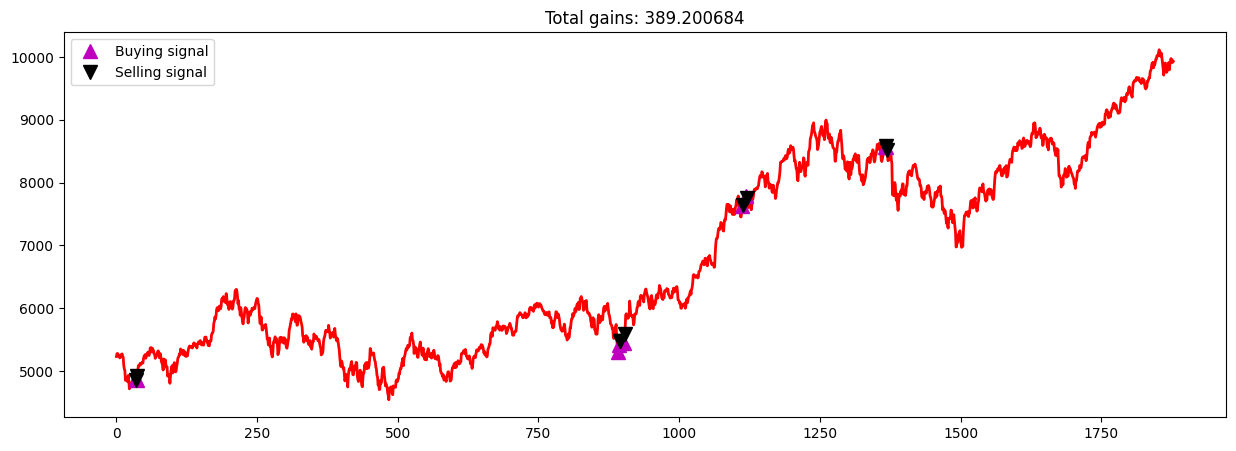

Training in progress...: 100%|██████████| 1878/1878 [07:57<00:00,  3.94it/s]


Running episode 8/10


Training in progress...:   0%|          | 0/1878 [00:00<?, ?it/s]

[[0.27911884 0.         0.26172791]] 0


Training in progress...:   0%|          | 1/1878 [00:00<08:08,  3.84it/s]

[[0.13434645 0.         0.22289963]] 2


Training in progress...:   0%|          | 2/1878 [00:00<07:58,  3.92it/s]

[[0.15349063 0.         0.35587427]] 2


Training in progress...:   0%|          | 3/1878 [00:00<07:35,  4.12it/s]

[[0.17229322 0.         0.32746946]] 2


Training in progress...:   0%|          | 4/1878 [00:01<07:48,  4.00it/s]

[[0.         0.         0.37028437]] 2


Training in progress...:   0%|          | 5/1878 [00:01<07:37,  4.10it/s]

[[0.         0.         0.45417445]] 2


Training in progress...:   0%|          | 6/1878 [00:01<07:27,  4.18it/s]

[[0.         0.         0.33143652]] 2


Training in progress...:   0%|          | 7/1878 [00:01<07:21,  4.24it/s]

[[0.         0.         0.15136451]] 2


Training in progress...:   0%|          | 8/1878 [00:01<07:24,  4.20it/s]

[[0.         0.         0.14799143]] 2


Training in progress...:   0%|          | 9/1878 [00:02<07:15,  4.29it/s]

[[0.         0.         0.02290559]] 2


Training in progress...:   1%|          | 10/1878 [00:02<07:27,  4.18it/s]

[[0.         0.         0.10100952]] 2


Training in progress...:   1%|          | 11/1878 [00:02<07:24,  4.20it/s]

[[0.         0.         0.13244205]] 2


Training in progress...:   1%|          | 12/1878 [00:02<07:19,  4.24it/s]

[[0.         0.         0.18351292]] 2


Training in progress...:   1%|          | 13/1878 [00:03<07:41,  4.04it/s]

[[0.         0.         0.21631333]] 2


Training in progress...:   1%|          | 14/1878 [00:03<07:49,  3.97it/s]

[[0.         0.         0.09490696]] 2


Training in progress...:   1%|          | 15/1878 [00:03<08:00,  3.88it/s]

[[0.         0.         0.17650779]] 2


Training in progress...:   1%|          | 16/1878 [00:03<08:11,  3.79it/s]

[[0.         0.         0.04424637]] 2


Training in progress...:   1%|          | 17/1878 [00:04<08:09,  3.80it/s]

[[0.         0.         0.11952893]] 2


Training in progress...:   1%|          | 18/1878 [00:04<08:27,  3.66it/s]

[[0.         0.         0.24052463]] 2


Training in progress...:   1%|          | 19/1878 [00:04<07:59,  3.88it/s]

[[0.         0.         0.24427532]] 2


Training in progress...:   1%|          | 20/1878 [00:05<08:09,  3.80it/s]

[[0.         0.         0.19272266]] 2


Training in progress...:   1%|          | 21/1878 [00:05<08:03,  3.84it/s]

[[0.         0.         0.32457429]] 2


Training in progress...:   1%|          | 22/1878 [00:05<08:01,  3.86it/s]

[[0.         0.         0.42929674]] 2


Training in progress...:   1%|          | 23/1878 [00:05<07:55,  3.90it/s]

[[0.         0.14015201 0.39498258]] 2


Training in progress...:   1%|▏         | 24/1878 [00:06<07:48,  3.96it/s]

[[0.         0.08368434 0.33667083]] 2


Training in progress...:   1%|▏         | 25/1878 [00:06<07:44,  3.99it/s]

[[0.         0.00428753 0.36040112]] 2


Training in progress...:   1%|▏         | 26/1878 [00:06<07:42,  4.00it/s]

[[0.         0.         0.45977002]] 2


Training in progress...:   1%|▏         | 27/1878 [00:06<07:44,  3.99it/s]

[[0.         0.         0.43600961]] 2


Training in progress...:   1%|▏         | 28/1878 [00:07<07:35,  4.06it/s]

[[0.         0.         0.41848794]] 2


Training in progress...:   2%|▏         | 29/1878 [00:07<07:48,  3.95it/s]

[[0.        0.1087064 0.5039987]] 2


Training in progress...:   2%|▏         | 30/1878 [00:07<08:01,  3.84it/s]

[[0.        0.        0.5579108]] 2


Training in progress...:   2%|▏         | 31/1878 [00:07<08:04,  3.81it/s]

[[0.         0.         0.44787833]] 2


Training in progress...:   2%|▏         | 32/1878 [00:08<08:14,  3.73it/s]

[[0.         0.         0.30652647]] 2


Training in progress...:   2%|▏         | 33/1878 [00:08<08:07,  3.78it/s]

[[0.         0.         0.33950809]] 2


Training in progress...:   2%|▏         | 34/1878 [00:08<08:12,  3.74it/s]

[[0.01988733 0.0888026  0.34437892]] 2


Training in progress...:   2%|▏         | 35/1878 [00:08<08:19,  3.69it/s]

[[0.         0.07119133 0.37830818]] 2


Training in progress...:   2%|▏         | 36/1878 [00:09<08:12,  3.74it/s]

[[0.         0.18428715 0.33485446]] 2


Training in progress...:   2%|▏         | 37/1878 [00:09<07:51,  3.90it/s]

[[0.1156422  0.19150967 0.35100483]] 2


Training in progress...:   2%|▏         | 38/1878 [00:09<07:37,  4.03it/s]

[[0.08081141 0.01379578 0.55795999]] 2


Training in progress...:   2%|▏         | 39/1878 [00:09<07:25,  4.13it/s]

[[0.         0.         0.50954982]] 2


Training in progress...:   2%|▏         | 40/1878 [00:10<07:28,  4.10it/s]

[[0.         0.00629832 0.50742677]] 2


Training in progress...:   2%|▏         | 41/1878 [00:10<07:22,  4.15it/s]

[[0.         0.         0.40857946]] 2


Training in progress...:   2%|▏         | 42/1878 [00:10<07:09,  4.28it/s]

[[0.         0.         0.45529674]] 2


Training in progress...:   2%|▏         | 43/1878 [00:10<07:10,  4.26it/s]

[[0.07320165 0.         0.60369342]] 2


Training in progress...:   2%|▏         | 44/1878 [00:11<07:22,  4.14it/s]

[[0.00296215 0.         0.70325414]] 2


Training in progress...:   2%|▏         | 45/1878 [00:11<07:26,  4.11it/s]

[[0.         0.         0.75190277]] 2


Training in progress...:   2%|▏         | 46/1878 [00:11<07:28,  4.08it/s]

[[0.         0.         0.83854239]] 2


Training in progress...:   3%|▎         | 47/1878 [00:11<07:26,  4.10it/s]

[[0.        0.        0.9607151]] 2


Training in progress...:   3%|▎         | 48/1878 [00:12<07:45,  3.93it/s]

[[0.         0.         0.91360316]] 2


Training in progress...:   3%|▎         | 49/1878 [00:12<07:37,  4.00it/s]

[[0.         0.         0.86220679]] 2


Training in progress...:   3%|▎         | 50/1878 [00:12<07:23,  4.12it/s]

[[0.         0.         0.73099862]] 2


Training in progress...:   3%|▎         | 51/1878 [00:12<07:22,  4.13it/s]

[[0.         0.         0.74183209]] 2


Training in progress...:   3%|▎         | 52/1878 [00:13<07:20,  4.15it/s]

[[0.         0.         0.73681689]] 2


Training in progress...:   3%|▎         | 53/1878 [00:13<07:21,  4.13it/s]

[[0.         0.         0.71782253]] 2


Training in progress...:   3%|▎         | 54/1878 [00:13<07:07,  4.26it/s]

[[0.         0.         0.80877353]] 2


Training in progress...:   3%|▎         | 55/1878 [00:13<07:09,  4.24it/s]

[[0.        0.        0.7024676]] 2


Training in progress...:   3%|▎         | 56/1878 [00:13<07:15,  4.19it/s]

[[0.         0.         0.73747781]] 2


Training in progress...:   3%|▎         | 57/1878 [00:14<07:20,  4.14it/s]

[[0.         0.         0.55114999]] 2


Training in progress...:   3%|▎         | 58/1878 [00:14<07:12,  4.21it/s]

[[0.         0.         0.43058656]] 2


Training in progress...:   3%|▎         | 59/1878 [00:14<07:17,  4.15it/s]

[[0.         0.         0.61811464]] 2


Training in progress...:   3%|▎         | 60/1878 [00:14<07:09,  4.23it/s]

[[0.         0.         0.58231684]] 2


Training in progress...:   3%|▎         | 61/1878 [00:15<07:15,  4.17it/s]

[[0.         0.         0.52143058]] 2


Training in progress...:   3%|▎         | 62/1878 [00:15<07:25,  4.08it/s]

[[0.         0.         0.62761161]] 2


Training in progress...:   3%|▎         | 63/1878 [00:15<07:18,  4.14it/s]

[[0.         0.         0.54919508]] 2


Training in progress...:   3%|▎         | 64/1878 [00:15<07:20,  4.12it/s]

[[0.         0.         0.71568148]] 2


Training in progress...:   3%|▎         | 65/1878 [00:16<07:19,  4.13it/s]

[[0.         0.         0.62835792]] 2


Training in progress...:   4%|▎         | 66/1878 [00:16<07:22,  4.10it/s]

[[0.         0.         0.46206735]] 2


Training in progress...:   4%|▎         | 67/1878 [00:16<07:17,  4.14it/s]

[[0.         0.         0.56442827]] 2


Training in progress...:   4%|▎         | 68/1878 [00:16<07:08,  4.22it/s]

[[0.         0.         0.58847851]] 2


Training in progress...:   4%|▎         | 69/1878 [00:17<07:22,  4.09it/s]

[[0.         0.         0.53506732]] 2


Training in progress...:   4%|▎         | 70/1878 [00:17<07:23,  4.08it/s]

[[0.         0.         0.47135913]] 2


Training in progress...:   4%|▍         | 71/1878 [00:17<07:23,  4.07it/s]

[[0.         0.         0.48941786]] 2


Training in progress...:   4%|▍         | 72/1878 [00:17<07:16,  4.14it/s]

[[0.         0.         0.46101964]] 2


Training in progress...:   4%|▍         | 73/1878 [00:18<07:16,  4.14it/s]

[[0.         0.         0.62750121]] 2


Training in progress...:   4%|▍         | 74/1878 [00:18<07:12,  4.17it/s]

[[0.         0.         0.49346074]] 2


Training in progress...:   4%|▍         | 75/1878 [00:18<07:08,  4.21it/s]

[[0.         0.         0.46981106]] 2


Training in progress...:   4%|▍         | 76/1878 [00:18<07:10,  4.19it/s]

[[0.         0.         0.30186516]] 2


Training in progress...:   4%|▍         | 77/1878 [00:19<07:18,  4.10it/s]

[[0.         0.         0.30073211]] 2


Training in progress...:   4%|▍         | 78/1878 [00:19<07:35,  3.95it/s]

[[0.         0.         0.46871798]] 2


Training in progress...:   4%|▍         | 79/1878 [00:19<07:21,  4.07it/s]

[[0.         0.         0.36167752]] 2


Training in progress...:   4%|▍         | 80/1878 [00:19<07:17,  4.11it/s]

[[0.         0.         0.24352293]] 2


Training in progress...:   4%|▍         | 81/1878 [00:20<07:26,  4.02it/s]

[[0.         0.         0.14149918]] 2


Training in progress...:   4%|▍         | 82/1878 [00:20<07:41,  3.89it/s]

[[0.         0.         0.03588113]] 2


Training in progress...:   4%|▍         | 83/1878 [00:20<07:17,  4.11it/s]

[[0. 0. 0.]] 0


Training in progress...:   4%|▍         | 84/1878 [00:20<07:38,  3.91it/s]

[[0.         0.         0.07722933]] 2


Training in progress...:   5%|▍         | 85/1878 [00:21<07:57,  3.75it/s]

[[0. 0. 0.]] 0


Training in progress...:   5%|▍         | 86/1878 [00:21<07:56,  3.76it/s]

[[0.         0.         0.00420245]] 2


Training in progress...:   5%|▍         | 87/1878 [00:21<07:46,  3.84it/s]

[[0.02559488 0.         0.17644982]] 2


Training in progress...:   5%|▍         | 88/1878 [00:21<07:44,  3.85it/s]

[[0.         0.         0.27046234]] 2


Training in progress...:   5%|▍         | 89/1878 [00:22<07:50,  3.80it/s]

[[0.         0.         0.21738318]] 2


Training in progress...:   5%|▍         | 90/1878 [00:22<07:40,  3.88it/s]

[[0.02258837 0.         0.15584358]] 2


Training in progress...:   5%|▍         | 91/1878 [00:22<07:24,  4.02it/s]

[[0.04314329 0.         0.25955289]] 2


Training in progress...:   5%|▍         | 92/1878 [00:22<07:34,  3.93it/s]

[[0.       0.       0.306808]] 2


Training in progress...:   5%|▍         | 93/1878 [00:23<07:44,  3.84it/s]

[[0.         0.         0.50980378]] 2


Training in progress...:   5%|▌         | 94/1878 [00:23<07:42,  3.86it/s]

[[0.00452947 0.         0.47382902]] 2


Training in progress...:   5%|▌         | 95/1878 [00:23<08:00,  3.71it/s]

[[0.09679973 0.         0.43847333]] 2


Training in progress...:   5%|▌         | 96/1878 [00:24<08:12,  3.62it/s]

[[0.03065284 0.         0.4292095 ]] 2


Training in progress...:   5%|▌         | 97/1878 [00:24<08:11,  3.63it/s]

[[0.         0.         0.52714202]] 2


Training in progress...:   5%|▌         | 98/1878 [00:24<08:02,  3.69it/s]

[[0.         0.         0.38321969]] 2


Training in progress...:   5%|▌         | 99/1878 [00:24<08:04,  3.67it/s]

[[0.        0.        0.3203975]] 2


Training in progress...:   5%|▌         | 100/1878 [00:25<08:20,  3.55it/s]

[[0.         0.         0.29894538]] 2


Training in progress...:   5%|▌         | 101/1878 [00:25<07:48,  3.79it/s]

[[0.         0.         0.05375188]] 2


Training in progress...:   5%|▌         | 102/1878 [00:25<07:24,  3.99it/s]

[[0.         0.         0.13957148]] 2


Training in progress...:   5%|▌         | 103/1878 [00:25<07:15,  4.07it/s]

[[0.        0.        0.0257747]] 2


Training in progress...:   6%|▌         | 104/1878 [00:26<07:17,  4.06it/s]

[[0.         0.         0.18436342]] 2


Training in progress...:   6%|▌         | 105/1878 [00:26<07:09,  4.13it/s]

[[0.         0.         0.19605312]] 2


Training in progress...:   6%|▌         | 106/1878 [00:26<07:05,  4.16it/s]

[[0.         0.         0.24419647]] 2


Training in progress...:   6%|▌         | 107/1878 [00:26<06:58,  4.23it/s]

[[0.         0.         0.31985204]] 2


Training in progress...:   6%|▌         | 108/1878 [00:26<07:00,  4.21it/s]

[[0.         0.         0.35604206]] 2


Training in progress...:   6%|▌         | 109/1878 [00:27<07:04,  4.17it/s]

[[0.         0.         0.39797738]] 2


Training in progress...:   6%|▌         | 110/1878 [00:27<06:54,  4.26it/s]

[[0.04929561 0.         0.46767497]] 2


Training in progress...:   6%|▌         | 111/1878 [00:27<06:50,  4.30it/s]

[[0.        0.        0.4456894]] 2


Training in progress...:   6%|▌         | 112/1878 [00:27<06:49,  4.31it/s]

[[0.         0.         0.43590134]] 2


Training in progress...:   6%|▌         | 113/1878 [00:28<07:00,  4.20it/s]

[[0.         0.         0.21848008]] 2


Training in progress...:   6%|▌         | 114/1878 [00:28<06:56,  4.23it/s]

[[0.         0.         0.34849887]] 2


Training in progress...:   6%|▌         | 115/1878 [00:28<06:59,  4.21it/s]

[[0.         0.         0.38589273]] 2


Training in progress...:   6%|▌         | 116/1878 [00:28<06:47,  4.32it/s]

[[0.        0.        0.3212356]] 2


Training in progress...:   6%|▌         | 117/1878 [00:29<07:12,  4.07it/s]

[[0.         0.         0.34668655]] 2


Training in progress...:   6%|▋         | 118/1878 [00:29<07:06,  4.13it/s]

[[0.         0.         0.18442069]] 2


Training in progress...:   6%|▋         | 119/1878 [00:29<06:55,  4.23it/s]

[[0.         0.         0.21662224]] 2


Training in progress...:   6%|▋         | 120/1878 [00:29<06:51,  4.28it/s]

[[0.         0.         0.30103327]] 2


Training in progress...:   6%|▋         | 121/1878 [00:30<06:47,  4.31it/s]

[[0.03028736 0.         0.37073218]] 2


Training in progress...:   6%|▋         | 122/1878 [00:30<06:55,  4.22it/s]

[[0.01035871 0.         0.31027966]] 2


Training in progress...:   7%|▋         | 123/1878 [00:30<06:55,  4.22it/s]

[[0.         0.         0.23987594]] 2


Training in progress...:   7%|▋         | 124/1878 [00:30<06:54,  4.23it/s]

[[0.         0.         0.34750369]] 2


Training in progress...:   7%|▋         | 125/1878 [00:31<07:02,  4.15it/s]

[[0.         0.         0.19711538]] 2


Training in progress...:   7%|▋         | 126/1878 [00:31<07:05,  4.12it/s]

[[0.         0.         0.14326115]] 2


Training in progress...:   7%|▋         | 127/1878 [00:31<06:54,  4.22it/s]

[[0.         0.         0.11912791]] 2


Training in progress...:   7%|▋         | 128/1878 [00:31<06:45,  4.31it/s]

[[0.02041822 0.         0.22164102]] 2


Training in progress...:   7%|▋         | 129/1878 [00:31<07:01,  4.15it/s]

[[0.         0.         0.02679123]] 2


Training in progress...:   7%|▋         | 130/1878 [00:32<06:55,  4.21it/s]

[[0.        0.        0.2378737]] 2


Training in progress...:   7%|▋         | 131/1878 [00:32<06:57,  4.19it/s]

[[0.15199051 0.         0.15651039]] 2


Training in progress...:   7%|▋         | 132/1878 [00:32<06:49,  4.26it/s]

[[0.1888763  0.         0.09589935]] 0


Training in progress...:   7%|▋         | 133/1878 [00:32<06:52,  4.23it/s]

[[0.0206816  0.         0.20069987]] 2


Training in progress...:   7%|▋         | 134/1878 [00:33<06:59,  4.16it/s]

[[0.08547063 0.         0.30900894]] 2


Training in progress...:   7%|▋         | 135/1878 [00:33<07:01,  4.13it/s]

[[0.15598677 0.         0.27206827]] 2


Training in progress...:   7%|▋         | 136/1878 [00:33<06:53,  4.22it/s]

[[0.06339935 0.         0.31721507]] 2


Training in progress...:   7%|▋         | 137/1878 [00:33<06:48,  4.26it/s]

[[0.22874561 0.         0.24694159]] 2


Training in progress...:   7%|▋         | 138/1878 [00:34<06:51,  4.23it/s]

[[0.         0.         0.38236397]] 2


Training in progress...:   7%|▋         | 139/1878 [00:34<06:46,  4.28it/s]

[[0.        0.        0.3135628]] 2


Training in progress...:   7%|▋         | 140/1878 [00:34<06:46,  4.27it/s]

[[0.06892122 0.         0.18768899]] 2


Training in progress...:   8%|▊         | 141/1878 [00:34<06:46,  4.27it/s]

[[0.10050644 0.         0.11290704]] 2


Training in progress...:   8%|▊         | 142/1878 [00:35<06:50,  4.23it/s]

[[0.12459139 0.         0.23800884]] 2


Training in progress...:   8%|▊         | 143/1878 [00:35<06:53,  4.20it/s]

[[0.         0.         0.31679529]] 2


Training in progress...:   8%|▊         | 144/1878 [00:35<07:14,  3.99it/s]

[[0.        0.        0.3248716]] 2


Training in progress...:   8%|▊         | 145/1878 [00:35<07:28,  3.87it/s]

[[0.         0.         0.30417522]] 2


Training in progress...:   8%|▊         | 146/1878 [00:36<07:18,  3.95it/s]

[[0.         0.         0.24482004]] 2


Training in progress...:   8%|▊         | 147/1878 [00:36<07:14,  3.99it/s]

[[0.         0.         0.32432505]] 2


Training in progress...:   8%|▊         | 148/1878 [00:36<07:05,  4.06it/s]

[[0.         0.         0.32474448]] 2


Training in progress...:   8%|▊         | 149/1878 [00:36<07:17,  3.95it/s]

[[0.         0.         0.27346344]] 2


Training in progress...:   8%|▊         | 150/1878 [00:37<07:29,  3.84it/s]

[[0.02180241 0.         0.47225084]] 2


Training in progress...:   8%|▊         | 151/1878 [00:37<07:29,  3.85it/s]

[[0.         0.         0.50137691]] 2


Training in progress...:   8%|▊         | 152/1878 [00:37<07:33,  3.81it/s]

[[0.         0.         0.39430813]] 2


Training in progress...:   8%|▊         | 153/1878 [00:37<07:28,  3.85it/s]

[[0.         0.         0.20317264]] 2


Training in progress...:   8%|▊         | 154/1878 [00:38<07:36,  3.78it/s]

[[0.         0.         0.05203282]] 2


Training in progress...:   8%|▊         | 155/1878 [00:38<07:35,  3.78it/s]

[[0.         0.         0.01447498]] 2


Training in progress...:   8%|▊         | 156/1878 [00:38<07:38,  3.75it/s]

[[0.         0.         0.25529974]] 2


Training in progress...:   8%|▊         | 157/1878 [00:38<07:38,  3.75it/s]

[[0.         0.         0.30434446]] 2


Training in progress...:   8%|▊         | 158/1878 [00:39<07:28,  3.83it/s]

[[0.         0.         0.28882738]] 2


Training in progress...:   8%|▊         | 159/1878 [00:39<07:16,  3.94it/s]

[[0.         0.         0.12335477]] 2


Training in progress...:   9%|▊         | 160/1878 [00:39<07:27,  3.84it/s]

[[0.         0.         0.13183928]] 2


Training in progress...:   9%|▊         | 161/1878 [00:40<07:51,  3.65it/s]

[[0.         0.09100481 0.20106243]] 2


Training in progress...:   9%|▊         | 162/1878 [00:40<07:52,  3.63it/s]

[[0.         0.00969443 0.32262546]] 2


Training in progress...:   9%|▊         | 163/1878 [00:40<07:44,  3.69it/s]

[[0.         0.03509205 0.32984602]] 2


Training in progress...:   9%|▊         | 164/1878 [00:40<07:42,  3.70it/s]

[[0.         0.10106668 0.22823839]] 2


Training in progress...:   9%|▉         | 165/1878 [00:41<07:48,  3.66it/s]

[[0.         0.         0.23545999]] 2


Training in progress...:   9%|▉         | 166/1878 [00:41<07:56,  3.60it/s]

[[0.         0.         0.24834011]] 2


Training in progress...:   9%|▉         | 167/1878 [00:41<07:34,  3.77it/s]

[[0.         0.         0.36970599]] 2


Training in progress...:   9%|▉         | 168/1878 [00:41<07:20,  3.88it/s]

[[0.         0.         0.37002921]] 2


Training in progress...:   9%|▉         | 169/1878 [00:42<07:27,  3.82it/s]

[[0.         0.         0.25288061]] 2


Training in progress...:   9%|▉         | 170/1878 [00:42<07:15,  3.92it/s]

[[0.         0.         0.37820927]] 2


Training in progress...:   9%|▉         | 171/1878 [00:42<07:09,  3.97it/s]

[[0.         0.         0.38796042]] 2


Training in progress...:   9%|▉         | 172/1878 [00:42<07:01,  4.05it/s]

[[0.         0.         0.30748436]] 2


Training in progress...:   9%|▉         | 173/1878 [00:43<07:20,  3.87it/s]

[[0.         0.         0.30051809]] 2


Training in progress...:   9%|▉         | 174/1878 [00:43<07:03,  4.03it/s]

[[0.         0.         0.39054199]] 2


Training in progress...:   9%|▉         | 175/1878 [00:43<06:55,  4.10it/s]

[[0.         0.         0.29408278]] 2


Training in progress...:   9%|▉         | 176/1878 [00:43<06:51,  4.13it/s]

[[0.         0.         0.30212303]] 2


Training in progress...:   9%|▉         | 177/1878 [00:44<06:55,  4.09it/s]

[[0.         0.         0.37705514]] 2


Training in progress...:   9%|▉         | 178/1878 [00:44<06:50,  4.14it/s]

[[0.         0.         0.45364483]] 2


Training in progress...:  10%|▉         | 179/1878 [00:44<06:45,  4.19it/s]

[[0.         0.         0.41550617]] 2


Training in progress...:  10%|▉         | 180/1878 [00:44<06:43,  4.20it/s]

[[0.        0.        0.4171651]] 2


Training in progress...:  10%|▉         | 181/1878 [00:45<06:57,  4.07it/s]

[[0.         0.         0.39294195]] 2


Training in progress...:  10%|▉         | 182/1878 [00:45<06:53,  4.10it/s]

[[0.         0.         0.42385553]] 2


Training in progress...:  10%|▉         | 183/1878 [00:45<06:44,  4.19it/s]

[[0.         0.         0.41306306]] 2


Training in progress...:  10%|▉         | 184/1878 [00:45<06:35,  4.29it/s]

[[0.         0.         0.30175018]] 2


Training in progress...:  10%|▉         | 185/1878 [00:45<06:37,  4.26it/s]

[[0.         0.         0.37210711]] 2


Training in progress...:  10%|▉         | 186/1878 [00:46<06:46,  4.16it/s]

[[0.         0.         0.58695522]] 2


Training in progress...:  10%|▉         | 187/1878 [00:46<06:37,  4.25it/s]

[[0.         0.         0.38967923]] 2


Training in progress...:  10%|█         | 188/1878 [00:46<06:40,  4.22it/s]

[[0.         0.         0.32690018]] 2


Training in progress...:  10%|█         | 189/1878 [00:46<06:40,  4.22it/s]

[[0.         0.         0.48492251]] 2


Training in progress...:  10%|█         | 190/1878 [00:47<06:41,  4.20it/s]

[[0.         0.         0.41851291]] 2


Training in progress...:  10%|█         | 191/1878 [00:47<06:44,  4.17it/s]

[[0.09113125 0.         0.53404158]] 2


Training in progress...:  10%|█         | 192/1878 [00:47<06:37,  4.24it/s]

[[0.         0.         0.61845247]] 2


Training in progress...:  10%|█         | 193/1878 [00:47<06:34,  4.27it/s]

[[0.07025781 0.         0.61198846]] 2


Training in progress...:  10%|█         | 194/1878 [00:48<06:29,  4.33it/s]

[[0.03862839 0.         0.42671386]] 2


Training in progress...:  10%|█         | 195/1878 [00:48<06:30,  4.31it/s]

[[0.07149419 0.         0.5586518 ]] 2


Training in progress...:  10%|█         | 196/1878 [00:48<06:23,  4.38it/s]

[[0.         0.         0.52042634]] 2


Training in progress...:  10%|█         | 197/1878 [00:48<06:27,  4.34it/s]

[[0.06580235 0.         0.26666525]] 2


Training in progress...:  11%|█         | 198/1878 [00:49<06:30,  4.30it/s]

[[0.06851866 0.         0.30514657]] 2


Training in progress...:  11%|█         | 199/1878 [00:49<06:37,  4.22it/s]

[[0.13859875 0.         0.17744093]] 2


Training in progress...:  11%|█         | 200/1878 [00:49<06:41,  4.18it/s]

[[0.20047747 0.         0.26903359]] 2


Training in progress...:  11%|█         | 201/1878 [00:49<06:41,  4.18it/s]

[[0.13489812 0.         0.31353887]] 2


Training in progress...:  11%|█         | 202/1878 [00:50<06:42,  4.17it/s]

[[0.08036622 0.         0.49103135]] 2


Training in progress...:  11%|█         | 203/1878 [00:50<06:39,  4.20it/s]

[[0.01303485 0.         0.52239568]] 2


Training in progress...:  11%|█         | 204/1878 [00:50<06:38,  4.20it/s]

[[0.         0.         0.55446712]] 2


Training in progress...:  11%|█         | 205/1878 [00:50<06:41,  4.17it/s]

[[0.         0.         0.49367806]] 2


Training in progress...:  11%|█         | 206/1878 [00:50<06:42,  4.16it/s]

[[0.         0.         0.50195383]] 2


Training in progress...:  11%|█         | 207/1878 [00:51<06:40,  4.17it/s]

[[0.         0.         0.47458602]] 2


Training in progress...:  11%|█         | 208/1878 [00:51<06:32,  4.26it/s]

[[0.         0.         0.62824821]] 2


Training in progress...:  11%|█         | 209/1878 [00:51<06:55,  4.02it/s]

[[0.        0.        0.6920418]] 2


Training in progress...:  11%|█         | 210/1878 [00:51<07:03,  3.93it/s]

[[0.        0.        0.5562157]] 2


Training in progress...:  11%|█         | 211/1878 [00:52<07:10,  3.87it/s]

[[0.         0.         0.58012374]] 2


Training in progress...:  11%|█▏        | 212/1878 [00:52<06:50,  4.05it/s]

[[0.         0.         0.58158131]] 2


Training in progress...:  11%|█▏        | 213/1878 [00:52<06:51,  4.04it/s]

[[0.         0.         0.49662683]] 2


Training in progress...:  11%|█▏        | 214/1878 [00:52<06:55,  4.01it/s]

[[0.         0.         0.44710753]] 2


Training in progress...:  11%|█▏        | 215/1878 [00:53<06:43,  4.12it/s]

[[0.         0.         0.26668156]] 2


Training in progress...:  12%|█▏        | 216/1878 [00:53<06:37,  4.18it/s]

[[0.         0.         0.42863507]] 2


Training in progress...:  12%|█▏        | 217/1878 [00:53<06:46,  4.09it/s]

[[0.         0.         0.33476517]] 2


Training in progress...:  12%|█▏        | 218/1878 [00:53<07:04,  3.91it/s]

[[0.        0.        0.2429958]] 2


Training in progress...:  12%|█▏        | 219/1878 [00:54<07:13,  3.82it/s]

[[0.         0.         0.32563124]] 2


Training in progress...:  12%|█▏        | 220/1878 [00:54<06:55,  3.99it/s]

[[0.         0.         0.42564125]] 2


Training in progress...:  12%|█▏        | 221/1878 [00:54<06:49,  4.04it/s]

[[0.         0.         0.50197215]] 2


Training in progress...:  12%|█▏        | 222/1878 [00:54<06:47,  4.07it/s]

[[0.         0.         0.58757194]] 2


Training in progress...:  12%|█▏        | 223/1878 [00:55<06:43,  4.10it/s]

[[0.         0.         0.40522375]] 2


Training in progress...:  12%|█▏        | 224/1878 [00:55<06:41,  4.12it/s]

[[0.         0.         0.44648572]] 2


Training in progress...:  12%|█▏        | 225/1878 [00:55<06:41,  4.12it/s]

[[0.         0.         0.35370874]] 2


Training in progress...:  12%|█▏        | 226/1878 [00:55<06:44,  4.09it/s]

[[0.         0.         0.42727056]] 2


Training in progress...:  12%|█▏        | 227/1878 [00:56<06:55,  3.97it/s]

[[0.         0.         0.24368877]] 2


Training in progress...:  12%|█▏        | 228/1878 [00:56<06:57,  3.95it/s]

[[0.        0.        0.2376093]] 2


Training in progress...:  12%|█▏        | 229/1878 [00:56<06:55,  3.97it/s]

[[0.         0.         0.32947733]] 2


Training in progress...:  12%|█▏        | 230/1878 [00:56<07:01,  3.91it/s]

[[0.         0.         0.33400125]] 2


Training in progress...:  12%|█▏        | 231/1878 [00:57<06:59,  3.93it/s]

[[0.08981774 0.         0.31241081]] 2


Training in progress...:  12%|█▏        | 232/1878 [00:57<07:15,  3.78it/s]

[[0.05052951 0.         0.28212601]] 2


Training in progress...:  12%|█▏        | 233/1878 [00:57<07:23,  3.71it/s]

[[0.02395243 0.0105958  0.24123689]] 2


Training in progress...:  12%|█▏        | 234/1878 [00:58<07:11,  3.81it/s]

[[0.13324241 0.         0.26395781]] 2


Training in progress...:  13%|█▎        | 235/1878 [00:58<07:01,  3.90it/s]

[[0.24764104 0.         0.41495109]] 2


Training in progress...:  13%|█▎        | 236/1878 [00:58<06:46,  4.04it/s]

[[0.13045772 0.         0.39068088]] 2


Training in progress...:  13%|█▎        | 237/1878 [00:58<06:43,  4.07it/s]

[[0.19606722 0.03243054 0.32175705]] 2


Training in progress...:  13%|█▎        | 238/1878 [00:59<06:57,  3.93it/s]

[[0.13244457 0.24523344 0.26785899]] 2


Training in progress...:  13%|█▎        | 239/1878 [00:59<06:56,  3.93it/s]

[[0.25195863 0.42846239 0.14680784]] 1


Training in progress...:  13%|█▎        | 240/1878 [00:59<06:38,  4.11it/s]

[[0.06080334 0.11393662 0.16161301]] 2


Training in progress...:  13%|█▎        | 241/1878 [00:59<06:31,  4.18it/s]

[[0.         0.10117024 0.        ]] 1


Training in progress...:  13%|█▎        | 242/1878 [00:59<06:37,  4.11it/s]

[[0.         0.08712535 0.10374434]] 2


Training in progress...:  13%|█▎        | 243/1878 [01:00<06:40,  4.08it/s]

[[0.         0.15816235 0.22292832]] 2


Training in progress...:  13%|█▎        | 244/1878 [01:00<06:39,  4.09it/s]

[[0.         0.         0.14545876]] 2


Training in progress...:  13%|█▎        | 245/1878 [01:00<06:36,  4.12it/s]

[[0.         0.         0.22404329]] 2


Training in progress...:  13%|█▎        | 246/1878 [01:00<06:38,  4.10it/s]

[[0.         0.         0.20425662]] 2


Training in progress...:  13%|█▎        | 247/1878 [01:01<06:41,  4.06it/s]

[[0.         0.         0.16501458]] 2


Training in progress...:  13%|█▎        | 248/1878 [01:01<06:33,  4.14it/s]

[[0.         0.         0.23182413]] 2


Training in progress...:  13%|█▎        | 249/1878 [01:01<06:27,  4.21it/s]

[[0.         0.         0.24418748]] 2


Training in progress...:  13%|█▎        | 250/1878 [01:01<06:28,  4.19it/s]

[[0.         0.         0.36679435]] 2


Training in progress...:  13%|█▎        | 251/1878 [01:02<06:28,  4.19it/s]

[[0.         0.         0.22515966]] 2


Training in progress...:  13%|█▎        | 252/1878 [01:02<06:22,  4.25it/s]

[[0.         0.         0.39334661]] 2


Training in progress...:  13%|█▎        | 253/1878 [01:02<06:21,  4.26it/s]

[[0.         0.         0.54665304]] 2


Training in progress...:  14%|█▎        | 254/1878 [01:02<06:22,  4.24it/s]

[[0.         0.0021097  0.80102103]] 2


Training in progress...:  14%|█▎        | 255/1878 [01:03<06:32,  4.13it/s]

[[0.         0.01361284 0.75883944]] 2


Training in progress...:  14%|█▎        | 256/1878 [01:03<06:32,  4.14it/s]

[[0.         0.15980018 0.71865583]] 2


Training in progress...:  14%|█▎        | 257/1878 [01:03<06:22,  4.24it/s]

[[0.         0.14133251 0.5378394 ]] 2


Training in progress...:  14%|█▎        | 258/1878 [01:03<06:22,  4.24it/s]

[[0.         0.         0.45153517]] 2


Training in progress...:  14%|█▍        | 259/1878 [01:04<06:26,  4.19it/s]

[[0.         0.07787583 0.30453806]] 2


Training in progress...:  14%|█▍        | 260/1878 [01:04<06:23,  4.22it/s]

[[0.         0.30572175 0.50516178]] 2


Training in progress...:  14%|█▍        | 261/1878 [01:04<06:22,  4.23it/s]

[[0.         0.2946966  0.39094536]] 2


Training in progress...:  14%|█▍        | 262/1878 [01:04<06:22,  4.22it/s]

[[0.         0.34179085 0.31435364]] 1


Training in progress...:  14%|█▍        | 263/1878 [01:04<06:16,  4.28it/s]

[[0.         0.30893727 0.28378307]] 1


Training in progress...:  14%|█▍        | 264/1878 [01:05<06:15,  4.29it/s]

[[0.         0.17873642 0.27298164]] 2


Training in progress...:  14%|█▍        | 265/1878 [01:05<06:22,  4.22it/s]

[[0.         0.0157801  0.33960285]] 2


Training in progress...:  14%|█▍        | 266/1878 [01:05<06:17,  4.27it/s]

[[0.         0.         0.51981595]] 2


Training in progress...:  14%|█▍        | 267/1878 [01:05<06:21,  4.23it/s]

[[0.         0.11978794 0.46779516]] 2


Training in progress...:  14%|█▍        | 268/1878 [01:06<06:20,  4.23it/s]

[[0.         0.02116572 0.53246447]] 2


Training in progress...:  14%|█▍        | 269/1878 [01:06<06:16,  4.27it/s]

[[0.         0.08893681 0.37463717]] 2


Training in progress...:  14%|█▍        | 270/1878 [01:06<06:21,  4.21it/s]

[[0.         0.06235955 0.4217766 ]] 2


Training in progress...:  14%|█▍        | 271/1878 [01:06<06:24,  4.18it/s]

[[0.         0.15895327 0.52853914]] 2


Training in progress...:  14%|█▍        | 272/1878 [01:07<06:29,  4.13it/s]

[[0.         0.02505399 0.2955955 ]] 2


Training in progress...:  15%|█▍        | 273/1878 [01:07<06:25,  4.16it/s]

[[0.         0.         0.35041185]] 2


Training in progress...:  15%|█▍        | 274/1878 [01:07<06:29,  4.12it/s]

[[0.         0.         0.43443138]] 2


Training in progress...:  15%|█▍        | 275/1878 [01:07<06:27,  4.13it/s]

[[0.        0.        0.5806368]] 2


Training in progress...:  15%|█▍        | 276/1878 [01:08<06:39,  4.01it/s]

[[0.         0.         0.56272152]] 2


Training in progress...:  15%|█▍        | 277/1878 [01:08<06:47,  3.93it/s]

[[0.         0.02318219 0.63649819]] 2


Training in progress...:  15%|█▍        | 278/1878 [01:08<06:50,  3.89it/s]

[[0.         0.08365322 0.76379252]] 2


Training in progress...:  15%|█▍        | 279/1878 [01:08<06:45,  3.94it/s]

[[0.         0.         0.71599505]] 2


Training in progress...:  15%|█▍        | 280/1878 [01:09<06:50,  3.89it/s]

[[0.         0.         0.59529236]] 2


Training in progress...:  15%|█▍        | 281/1878 [01:09<06:51,  3.88it/s]

[[0.        0.        0.6486381]] 2


Training in progress...:  15%|█▌        | 282/1878 [01:09<06:37,  4.01it/s]

[[0.         0.         0.64190083]] 2


Training in progress...:  15%|█▌        | 283/1878 [01:09<07:00,  3.79it/s]

[[0.         0.         0.60590565]] 2


Training in progress...:  15%|█▌        | 284/1878 [01:10<06:56,  3.83it/s]

[[0.         0.         0.62081454]] 2


Training in progress...:  15%|█▌        | 285/1878 [01:10<06:58,  3.81it/s]

[[0.         0.         0.67201099]] 2


Training in progress...:  15%|█▌        | 286/1878 [01:10<06:57,  3.81it/s]

[[0.         0.         0.55712994]] 2


Training in progress...:  15%|█▌        | 287/1878 [01:10<06:59,  3.80it/s]

[[0.         0.         0.50431425]] 2


Training in progress...:  15%|█▌        | 288/1878 [01:11<07:00,  3.78it/s]

[[0.         0.         0.49183647]] 2


Training in progress...:  15%|█▌        | 289/1878 [01:11<06:35,  4.02it/s]

[[0.        0.        0.4007353]] 2


Training in progress...:  15%|█▌        | 290/1878 [01:11<06:26,  4.11it/s]

[[0.         0.         0.44060685]] 2


Training in progress...:  15%|█▌        | 291/1878 [01:11<06:29,  4.08it/s]

[[0.         0.         0.52077697]] 2


Training in progress...:  16%|█▌        | 292/1878 [01:12<06:37,  3.99it/s]

[[0.04599479 0.         0.28087754]] 2


Training in progress...:  16%|█▌        | 293/1878 [01:12<06:29,  4.07it/s]

[[0.20182308 0.         0.39896606]] 2


Training in progress...:  16%|█▌        | 294/1878 [01:12<06:54,  3.83it/s]

[[0.08934715 0.         0.15317917]] 2


Training in progress...:  16%|█▌        | 295/1878 [01:13<07:13,  3.65it/s]

[[0.         0.         0.11545647]] 2


Training in progress...:  16%|█▌        | 296/1878 [01:13<07:01,  3.75it/s]

[[0.         0.         0.04114332]] 2


Training in progress...:  16%|█▌        | 297/1878 [01:13<06:41,  3.94it/s]

[[0.         0.         0.23639627]] 2


Training in progress...:  16%|█▌        | 298/1878 [01:13<06:34,  4.01it/s]

[[0.         0.         0.28165529]] 2


Training in progress...:  16%|█▌        | 299/1878 [01:13<06:35,  3.99it/s]

[[0.01161902 0.         0.25983738]] 2


Training in progress...:  16%|█▌        | 300/1878 [01:14<06:45,  3.89it/s]

[[0.         0.         0.37433505]] 2


Training in progress...:  16%|█▌        | 301/1878 [01:14<07:09,  3.67it/s]

[[0.         0.         0.40321915]] 2


Training in progress...:  16%|█▌        | 302/1878 [01:14<06:48,  3.86it/s]

[[0.         0.         0.24483828]] 2


Training in progress...:  16%|█▌        | 303/1878 [01:15<06:44,  3.89it/s]

[[0.         0.         0.17793806]] 2


Training in progress...:  16%|█▌        | 304/1878 [01:15<06:41,  3.92it/s]

[[0.06327198 0.         0.22691648]] 2


Training in progress...:  16%|█▌        | 305/1878 [01:15<06:28,  4.05it/s]

[[0.         0.         0.51633576]] 2


Training in progress...:  16%|█▋        | 306/1878 [01:15<06:22,  4.11it/s]

[[0.         0.         0.31561788]] 2


Training in progress...:  16%|█▋        | 307/1878 [01:16<06:22,  4.11it/s]

[[0.         0.         0.32712677]] 2


Training in progress...:  16%|█▋        | 308/1878 [01:16<06:28,  4.05it/s]

[[0.         0.         0.33364935]] 2


Training in progress...:  16%|█▋        | 309/1878 [01:16<06:15,  4.18it/s]

[[0.         0.         0.36018602]] 2


Training in progress...:  17%|█▋        | 310/1878 [01:16<06:05,  4.29it/s]

[[0.        0.        0.4691356]] 2


Training in progress...:  17%|█▋        | 311/1878 [01:16<06:05,  4.29it/s]

[[0.        0.        0.3411712]] 2


Training in progress...:  17%|█▋        | 312/1878 [01:17<06:04,  4.29it/s]

[[0.         0.         0.38241123]] 2


Training in progress...:  17%|█▋        | 313/1878 [01:17<06:04,  4.30it/s]

[[0.         0.         0.57518444]] 2


Training in progress...:  17%|█▋        | 314/1878 [01:17<06:03,  4.30it/s]

[[0.18265992 0.         0.66986208]] 2


Training in progress...:  17%|█▋        | 315/1878 [01:17<06:08,  4.25it/s]

[[0.0373873  0.         0.72735444]] 2


Training in progress...:  17%|█▋        | 316/1878 [01:18<06:14,  4.18it/s]

[[0.01404829 0.         0.72162945]] 2


Training in progress...:  17%|█▋        | 317/1878 [01:18<06:23,  4.07it/s]

[[0.10338895 0.         0.50322185]] 2


Training in progress...:  17%|█▋        | 318/1878 [01:18<06:13,  4.18it/s]

[[0.02766242 0.         0.49895767]] 2


Training in progress...:  17%|█▋        | 319/1878 [01:18<06:09,  4.22it/s]

[[0.13719225 0.         0.38076469]] 2


Training in progress...:  17%|█▋        | 320/1878 [01:19<06:05,  4.27it/s]

[[0.06657093 0.         0.43614441]] 2


Training in progress...:  17%|█▋        | 321/1878 [01:19<06:05,  4.26it/s]

[[0.        0.        0.4666141]] 2


Training in progress...:  17%|█▋        | 322/1878 [01:19<06:10,  4.20it/s]

[[0.        0.        0.4286224]] 2


Training in progress...:  17%|█▋        | 323/1878 [01:19<06:02,  4.28it/s]

[[0.        0.        0.4794254]] 2


Training in progress...:  17%|█▋        | 324/1878 [01:20<06:09,  4.20it/s]

[[0.         0.         0.50417676]] 2


Training in progress...:  17%|█▋        | 325/1878 [01:20<06:11,  4.18it/s]

[[0.         0.         0.26267948]] 2


Training in progress...:  17%|█▋        | 326/1878 [01:20<06:06,  4.24it/s]

[[0.        0.        0.2704975]] 2


Training in progress...:  17%|█▋        | 327/1878 [01:20<06:05,  4.24it/s]

[[0.         0.         0.34473521]] 2


Training in progress...:  17%|█▋        | 328/1878 [01:20<06:06,  4.23it/s]

[[0.         0.         0.33437826]] 2


Training in progress...:  18%|█▊        | 329/1878 [01:21<06:05,  4.24it/s]

[[0.         0.         0.42061356]] 2


Training in progress...:  18%|█▊        | 330/1878 [01:21<06:01,  4.28it/s]

[[0.        0.        0.5143422]] 2


Training in progress...:  18%|█▊        | 331/1878 [01:21<06:07,  4.21it/s]

[[0.         0.         0.27768638]] 2


Training in progress...:  18%|█▊        | 332/1878 [01:21<06:08,  4.19it/s]

[[0.         0.         0.33006096]] 2


Training in progress...:  18%|█▊        | 333/1878 [01:22<06:03,  4.25it/s]

[[0.         0.         0.23913281]] 2


Training in progress...:  18%|█▊        | 334/1878 [01:22<05:56,  4.33it/s]

[[0. 0. 0.]] 0


Training in progress...:  18%|█▊        | 335/1878 [01:22<06:04,  4.23it/s]

[[0. 0. 0.]] 0


Training in progress...:  18%|█▊        | 336/1878 [01:22<06:04,  4.24it/s]

[[0. 0. 0.]] 0


Training in progress...:  18%|█▊        | 337/1878 [01:23<06:11,  4.15it/s]

[[0. 0. 0.]] 0


Training in progress...:  18%|█▊        | 338/1878 [01:23<06:03,  4.24it/s]

[[0.         0.         0.24041685]] 2


Training in progress...:  18%|█▊        | 339/1878 [01:23<05:58,  4.29it/s]

[[0.        0.        0.2322917]] 2


Training in progress...:  18%|█▊        | 340/1878 [01:23<06:04,  4.22it/s]

[[0.         0.         0.52662503]] 2


Training in progress...:  18%|█▊        | 341/1878 [01:24<06:04,  4.21it/s]

[[0.04935525 0.         0.56451014]] 2


Training in progress...:  18%|█▊        | 342/1878 [01:24<06:02,  4.24it/s]

[[0.04816977 0.         0.55505198]] 2


Training in progress...:  18%|█▊        | 343/1878 [01:24<05:58,  4.28it/s]

[[0.0435326  0.         0.51606096]] 2


Training in progress...:  18%|█▊        | 344/1878 [01:24<06:18,  4.05it/s]

[[0.         0.         0.49059284]] 2


Training in progress...:  18%|█▊        | 345/1878 [01:25<06:33,  3.90it/s]

[[0.         0.         0.55036911]] 2


Training in progress...:  18%|█▊        | 346/1878 [01:25<06:36,  3.86it/s]

[[0.10879354 0.         0.47972321]] 2


Training in progress...:  18%|█▊        | 347/1878 [01:25<06:21,  4.01it/s]

[[0.         0.         0.62766182]] 2


Training in progress...:  19%|█▊        | 348/1878 [01:25<06:27,  3.95it/s]

[[0.         0.         0.67959687]] 2


Training in progress...:  19%|█▊        | 349/1878 [01:26<06:28,  3.94it/s]

[[0.        0.        0.4267112]] 2


Training in progress...:  19%|█▊        | 350/1878 [01:26<06:21,  4.00it/s]

[[0.         0.         0.38373788]] 2


Training in progress...:  19%|█▊        | 351/1878 [01:26<06:33,  3.88it/s]

[[0.         0.         0.37058808]] 2


Training in progress...:  19%|█▊        | 352/1878 [01:26<06:49,  3.72it/s]

[[0.         0.         0.31176669]] 2


Training in progress...:  19%|█▉        | 353/1878 [01:27<06:52,  3.70it/s]

[[0.         0.         0.29709283]] 2


Training in progress...:  19%|█▉        | 354/1878 [01:27<06:40,  3.80it/s]

[[0.         0.         0.40940366]] 2


Training in progress...:  19%|█▉        | 355/1878 [01:27<06:27,  3.93it/s]

[[0.         0.         0.35238914]] 2


Training in progress...:  19%|█▉        | 356/1878 [01:27<06:31,  3.89it/s]

[[0.        0.        0.3830365]] 2


Training in progress...:  19%|█▉        | 357/1878 [01:28<06:16,  4.03it/s]

[[0.         0.         0.31098841]] 2


Training in progress...:  19%|█▉        | 358/1878 [01:28<06:20,  3.99it/s]

[[0.         0.         0.34129131]] 2


Training in progress...:  19%|█▉        | 359/1878 [01:28<06:28,  3.91it/s]

[[0.         0.         0.37545996]] 2


Training in progress...:  19%|█▉        | 360/1878 [01:28<06:27,  3.92it/s]

[[0.         0.         0.33898352]] 2


Training in progress...:  19%|█▉        | 361/1878 [01:29<06:28,  3.90it/s]

[[0.         0.         0.15395773]] 2


Training in progress...:  19%|█▉        | 362/1878 [01:29<06:38,  3.81it/s]

[[0.         0.         0.15159783]] 2


Training in progress...:  19%|█▉        | 363/1878 [01:29<06:43,  3.75it/s]

[[0.05133996 0.         0.08831765]] 2


Training in progress...:  19%|█▉        | 364/1878 [01:30<06:52,  3.67it/s]

[[0.         0.         0.30399019]] 2


Training in progress...:  19%|█▉        | 365/1878 [01:30<06:45,  3.73it/s]

[[0.         0.         0.19162593]] 2


Training in progress...:  19%|█▉        | 366/1878 [01:30<06:44,  3.74it/s]

[[0.126047   0.         0.22009204]] 2


Training in progress...:  20%|█▉        | 367/1878 [01:30<07:05,  3.55it/s]

[[0.12079289 0.         0.03738131]] 0


Training in progress...:  20%|█▉        | 368/1878 [01:31<06:54,  3.64it/s]

[[0.        0.        0.0791825]] 2


Training in progress...:  20%|█▉        | 369/1878 [01:31<06:39,  3.78it/s]

[[0.01828659 0.         0.04961397]] 2


Training in progress...:  20%|█▉        | 370/1878 [01:31<06:20,  3.96it/s]

[[0. 0. 0.]] 0


Training in progress...:  20%|█▉        | 371/1878 [01:31<06:13,  4.03it/s]

[[0.04173196 0.         0.        ]] 0


Training in progress...:  20%|█▉        | 372/1878 [01:32<06:13,  4.03it/s]

[[0.         0.         0.03430093]] 2


Training in progress...:  20%|█▉        | 373/1878 [01:32<06:19,  3.97it/s]

[[0.09287241 0.         0.04501708]] 0


Training in progress...:  20%|█▉        | 374/1878 [01:32<06:02,  4.15it/s]

[[0.16253625 0.         0.30729318]] 2


Training in progress...:  20%|█▉        | 375/1878 [01:32<06:00,  4.17it/s]

[[0.18228763 0.         0.35836873]] 2


Training in progress...:  20%|██        | 376/1878 [01:33<06:03,  4.14it/s]

[[0.16593563 0.         0.40846316]] 2


Training in progress...:  20%|██        | 377/1878 [01:33<06:10,  4.05it/s]

[[0.07294768 0.         0.35219569]] 2


Training in progress...:  20%|██        | 378/1878 [01:33<05:56,  4.20it/s]

[[0.         0.         0.43812191]] 2


Training in progress...:  20%|██        | 379/1878 [01:33<05:57,  4.20it/s]

[[0.         0.03585149 0.5397014 ]] 2


Training in progress...:  20%|██        | 380/1878 [01:33<06:00,  4.15it/s]

[[0.04486229 0.         0.45341677]] 2


Training in progress...:  20%|██        | 381/1878 [01:34<05:53,  4.24it/s]

[[0.05906879 0.00068303 0.34200437]] 2


Training in progress...:  20%|██        | 382/1878 [01:34<05:56,  4.20it/s]

[[0.         0.         0.56118077]] 2


Training in progress...:  20%|██        | 383/1878 [01:34<05:53,  4.23it/s]

[[0.         0.         0.47870406]] 2


Training in progress...:  20%|██        | 384/1878 [01:34<06:06,  4.08it/s]

[[0.         0.         0.56952575]] 2


Training in progress...:  21%|██        | 385/1878 [01:35<06:00,  4.14it/s]

[[0.         0.         0.41818871]] 2


Training in progress...:  21%|██        | 386/1878 [01:35<05:59,  4.16it/s]

[[0.         0.         0.33117027]] 2


Training in progress...:  21%|██        | 387/1878 [01:35<05:50,  4.25it/s]

[[0.         0.         0.38897463]] 2


Training in progress...:  21%|██        | 388/1878 [01:35<06:02,  4.11it/s]

[[0.         0.         0.42492185]] 2


Training in progress...:  21%|██        | 389/1878 [01:36<05:57,  4.17it/s]

[[0.         0.         0.27614188]] 2


Training in progress...:  21%|██        | 390/1878 [01:36<05:57,  4.16it/s]

[[0.         0.         0.13874689]] 2


Training in progress...:  21%|██        | 391/1878 [01:36<05:47,  4.28it/s]

[[0.         0.         0.27248126]] 2


Training in progress...:  21%|██        | 392/1878 [01:36<05:49,  4.26it/s]

[[0.         0.         0.39995671]] 2


Training in progress...:  21%|██        | 393/1878 [01:37<05:50,  4.24it/s]

[[0.         0.         0.55069203]] 2


Training in progress...:  21%|██        | 394/1878 [01:37<05:48,  4.26it/s]

[[0.         0.         0.53847019]] 2


Training in progress...:  21%|██        | 395/1878 [01:37<05:45,  4.30it/s]

[[0.         0.         0.55566915]] 2


Training in progress...:  21%|██        | 396/1878 [01:37<05:55,  4.16it/s]

[[0.        0.        0.6364034]] 2


Training in progress...:  21%|██        | 397/1878 [01:38<06:07,  4.02it/s]

[[0.05159527 0.         0.55843016]] 2


Training in progress...:  21%|██        | 398/1878 [01:38<06:05,  4.05it/s]

[[0.04065196 0.         0.62385103]] 2


Training in progress...:  21%|██        | 399/1878 [01:38<06:02,  4.09it/s]

[[0.         0.         0.59213112]] 2


Training in progress...:  21%|██▏       | 400/1878 [01:38<05:59,  4.11it/s]

[[0.         0.         0.45675598]] 2


Training in progress...:  21%|██▏       | 401/1878 [01:39<05:58,  4.12it/s]

[[0.         0.         0.31616621]] 2


Training in progress...:  21%|██▏       | 402/1878 [01:39<05:51,  4.20it/s]

[[0.         0.         0.37379658]] 2


Training in progress...:  21%|██▏       | 403/1878 [01:39<05:42,  4.30it/s]

[[0.         0.         0.63775519]] 2


Training in progress...:  22%|██▏       | 404/1878 [01:39<05:51,  4.19it/s]

[[0.         0.         0.48366077]] 2


Training in progress...:  22%|██▏       | 405/1878 [01:39<05:55,  4.15it/s]

[[0.        0.        0.4863642]] 2


Training in progress...:  22%|██▏       | 406/1878 [01:40<05:49,  4.22it/s]

[[0.         0.         0.48908762]] 2


Training in progress...:  22%|██▏       | 407/1878 [01:40<05:44,  4.27it/s]

[[0.07546711 0.         0.6199918 ]] 2


Training in progress...:  22%|██▏       | 408/1878 [01:40<05:45,  4.26it/s]

[[0.        0.        0.6191431]] 2


Training in progress...:  22%|██▏       | 409/1878 [01:40<05:47,  4.23it/s]

[[0.         0.         0.52525882]] 2


Training in progress...:  22%|██▏       | 410/1878 [01:41<06:13,  3.93it/s]

[[0.         0.         0.61796555]] 2


Training in progress...:  22%|██▏       | 411/1878 [01:41<06:12,  3.93it/s]

[[0.01107114 0.         0.61928512]] 2


Training in progress...:  22%|██▏       | 412/1878 [01:41<06:12,  3.93it/s]

[[0.         0.         0.56596174]] 2


Training in progress...:  22%|██▏       | 413/1878 [01:41<06:16,  3.89it/s]

[[0.         0.         0.67190714]] 2


Training in progress...:  22%|██▏       | 414/1878 [01:42<06:18,  3.86it/s]

[[0.         0.         0.54981888]] 2


Training in progress...:  22%|██▏       | 415/1878 [01:42<06:07,  3.99it/s]

[[0.         0.         0.64241676]] 2


Training in progress...:  22%|██▏       | 416/1878 [01:42<06:19,  3.86it/s]

[[0.         0.         0.65487323]] 2


Training in progress...:  22%|██▏       | 417/1878 [01:43<06:38,  3.67it/s]

[[0.         0.         0.67707454]] 2


Training in progress...:  22%|██▏       | 418/1878 [01:43<06:39,  3.65it/s]

[[0.18328524 0.         0.65240338]] 2


Training in progress...:  22%|██▏       | 419/1878 [01:43<06:33,  3.71it/s]

[[0.00951857 0.         0.59380114]] 2


Training in progress...:  22%|██▏       | 420/1878 [01:43<06:18,  3.85it/s]

[[0.         0.         0.57256463]] 2


Training in progress...:  22%|██▏       | 421/1878 [01:44<06:18,  3.85it/s]

[[0.         0.         0.72689877]] 2


Training in progress...:  22%|██▏       | 422/1878 [01:44<06:15,  3.87it/s]

[[0.         0.         0.66784194]] 2


Training in progress...:  23%|██▎       | 423/1878 [01:44<06:16,  3.86it/s]

[[0.         0.         0.46053208]] 2


Training in progress...:  23%|██▎       | 424/1878 [01:44<06:17,  3.85it/s]

[[0.         0.         0.49998723]] 2


Training in progress...:  23%|██▎       | 425/1878 [01:45<06:25,  3.77it/s]

[[0.        0.        0.2469493]] 2


Training in progress...:  23%|██▎       | 426/1878 [01:45<06:19,  3.82it/s]

[[0.         0.         0.15831216]] 2


Training in progress...:  23%|██▎       | 427/1878 [01:45<06:20,  3.81it/s]

[[0.02004237 0.         0.48283192]] 2


Training in progress...:  23%|██▎       | 428/1878 [01:45<06:29,  3.72it/s]

[[0.         0.         0.41035742]] 2


Training in progress...:  23%|██▎       | 429/1878 [01:46<06:37,  3.65it/s]

[[0.07166287 0.         0.43420901]] 2


Training in progress...:  23%|██▎       | 430/1878 [01:46<06:28,  3.73it/s]

[[0.         0.         0.38419838]] 2


Training in progress...:  23%|██▎       | 431/1878 [01:46<06:36,  3.65it/s]

[[0.         0.         0.47844736]] 2


Training in progress...:  23%|██▎       | 432/1878 [01:47<06:36,  3.65it/s]

[[0.03480707 0.         0.63903526]] 2


Training in progress...:  23%|██▎       | 433/1878 [01:47<06:20,  3.79it/s]

[[0.07267829 0.         0.54676709]] 2


Training in progress...:  23%|██▎       | 434/1878 [01:47<06:01,  4.00it/s]

[[0.10592363 0.         0.4335206 ]] 2


Training in progress...:  23%|██▎       | 435/1878 [01:47<05:57,  4.04it/s]

[[0.19839206 0.         0.5530826 ]] 2


Training in progress...:  23%|██▎       | 436/1878 [01:47<06:02,  3.98it/s]

[[0.         0.         0.50602438]] 2


Training in progress...:  23%|██▎       | 437/1878 [01:48<06:06,  3.94it/s]

[[0.08823239 0.         0.36363261]] 2


Training in progress...:  23%|██▎       | 438/1878 [01:48<06:00,  3.99it/s]

[[0.03340222 0.         0.26220539]] 2


Training in progress...:  23%|██▎       | 439/1878 [01:48<05:51,  4.10it/s]

[[0.         0.         0.39504033]] 2


Training in progress...:  23%|██▎       | 440/1878 [01:48<05:52,  4.08it/s]

[[0.         0.         0.51061589]] 2


Training in progress...:  23%|██▎       | 441/1878 [01:49<05:57,  4.02it/s]

[[0.         0.         0.52263927]] 2


Training in progress...:  24%|██▎       | 442/1878 [01:49<05:44,  4.17it/s]

[[0.         0.         0.43175292]] 2


Training in progress...:  24%|██▎       | 443/1878 [01:49<05:43,  4.18it/s]

[[0.         0.         0.46210643]] 2


Training in progress...:  24%|██▎       | 444/1878 [01:49<05:49,  4.10it/s]

[[0.         0.         0.49282122]] 2


Training in progress...:  24%|██▎       | 445/1878 [01:50<05:44,  4.16it/s]

[[0.         0.         0.45056129]] 2


Training in progress...:  24%|██▎       | 446/1878 [01:50<05:40,  4.20it/s]

[[0.         0.         0.52906505]] 2


Training in progress...:  24%|██▍       | 447/1878 [01:50<05:37,  4.24it/s]

[[0.         0.         0.61519511]] 2


Training in progress...:  24%|██▍       | 448/1878 [01:50<05:44,  4.15it/s]

[[0.         0.         0.58194749]] 2


Training in progress...:  24%|██▍       | 449/1878 [01:51<05:44,  4.15it/s]

[[0.         0.06752135 0.69380404]] 2


Training in progress...:  24%|██▍       | 450/1878 [01:51<05:47,  4.11it/s]

[[0.         0.10519724 0.4742167 ]] 2


Training in progress...:  24%|██▍       | 451/1878 [01:51<05:42,  4.17it/s]

[[0.         0.08959175 0.45689649]] 2


Training in progress...:  24%|██▍       | 452/1878 [01:51<05:36,  4.24it/s]

[[0.         0.01239233 0.49110139]] 2


Training in progress...:  24%|██▍       | 453/1878 [01:52<05:40,  4.18it/s]

[[0.         0.07865745 0.53269901]] 2


Training in progress...:  24%|██▍       | 454/1878 [01:52<05:40,  4.18it/s]

[[0.         0.         0.39651579]] 2


Training in progress...:  24%|██▍       | 455/1878 [01:52<05:35,  4.24it/s]

[[0.         0.07271875 0.36679212]] 2


Training in progress...:  24%|██▍       | 456/1878 [01:52<05:32,  4.28it/s]

[[0.         0.11008168 0.43181853]] 2


Training in progress...:  24%|██▍       | 457/1878 [01:53<05:37,  4.22it/s]

[[0.         0.         0.20635547]] 2


Training in progress...:  24%|██▍       | 458/1878 [01:53<05:39,  4.18it/s]

[[0. 0. 0.]] 0


Training in progress...:  24%|██▍       | 459/1878 [01:53<05:37,  4.20it/s]

[[0.         0.         0.12511402]] 2


Training in progress...:  24%|██▍       | 460/1878 [01:53<05:37,  4.20it/s]

[[0.         0.         0.08138262]] 2


Training in progress...:  25%|██▍       | 461/1878 [01:53<05:42,  4.13it/s]

[[0.         0.         0.20344026]] 2


Training in progress...:  25%|██▍       | 462/1878 [01:54<05:41,  4.14it/s]

[[0.0235258  0.         0.25877163]] 2


Training in progress...:  25%|██▍       | 463/1878 [01:54<05:38,  4.18it/s]

[[0.12249656 0.         0.05190824]] 0


Training in progress...:  25%|██▍       | 464/1878 [01:54<05:37,  4.19it/s]

[[0.10389382 0.         0.0655557 ]] 0


Training in progress...:  25%|██▍       | 465/1878 [01:54<05:44,  4.10it/s]

[[0.         0.         0.16688425]] 2


Training in progress...:  25%|██▍       | 466/1878 [01:55<05:44,  4.10it/s]

[[0.03919921 0.         0.171757  ]] 2


Training in progress...:  25%|██▍       | 467/1878 [01:55<05:37,  4.18it/s]

[[0.01463041 0.         0.31720638]] 2


Training in progress...:  25%|██▍       | 468/1878 [01:55<05:44,  4.09it/s]

[[0.07725671 0.         0.26738585]] 2


Training in progress...:  25%|██▍       | 469/1878 [01:55<05:35,  4.20it/s]

[[0.         0.01254921 0.54096533]] 2


Training in progress...:  25%|██▌       | 470/1878 [01:56<05:25,  4.32it/s]

[[0.         0.21122696 0.47306245]] 2


Training in progress...:  25%|██▌       | 471/1878 [01:56<05:22,  4.37it/s]

[[0.         0.0556028  0.32017478]] 2


Training in progress...:  25%|██▌       | 472/1878 [01:56<05:26,  4.31it/s]

[[0.         0.         0.33720516]] 2


Training in progress...:  25%|██▌       | 473/1878 [01:56<05:22,  4.36it/s]

[[0.         0.         0.10241428]] 2


Training in progress...:  25%|██▌       | 474/1878 [01:57<05:32,  4.22it/s]

[[0.         0.         0.32221665]] 2


Training in progress...:  25%|██▌       | 475/1878 [01:57<05:44,  4.08it/s]

[[0.         0.         0.28072516]] 2


Training in progress...:  25%|██▌       | 476/1878 [01:57<05:52,  3.98it/s]

[[0.         0.         0.25249432]] 2


Training in progress...:  25%|██▌       | 477/1878 [01:57<05:51,  3.99it/s]

[[0.         0.         0.12492636]] 2


Training in progress...:  25%|██▌       | 478/1878 [01:58<05:54,  3.95it/s]

[[0.         0.         0.26143028]] 2


Training in progress...:  26%|██▌       | 479/1878 [01:58<05:51,  3.98it/s]

[[0.         0.         0.25468271]] 2


Training in progress...:  26%|██▌       | 480/1878 [01:58<05:52,  3.97it/s]

[[0.         0.         0.28965675]] 2


Training in progress...:  26%|██▌       | 481/1878 [01:58<05:59,  3.89it/s]

[[0.         0.         0.30829355]] 2


Training in progress...:  26%|██▌       | 482/1878 [01:59<06:07,  3.80it/s]

[[0.         0.         0.34956897]] 2


Training in progress...:  26%|██▌       | 483/1878 [01:59<06:13,  3.73it/s]

[[0.         0.         0.30471468]] 2


Training in progress...:  26%|██▌       | 484/1878 [01:59<06:05,  3.81it/s]

[[0.        0.        0.3285984]] 2


Training in progress...:  26%|██▌       | 485/1878 [01:59<05:57,  3.90it/s]

[[0.         0.         0.30771597]] 2


Training in progress...:  26%|██▌       | 486/1878 [02:00<05:48,  4.00it/s]

[[0.        0.        0.4067622]] 2


Training in progress...:  26%|██▌       | 487/1878 [02:00<05:46,  4.02it/s]

[[0.         0.         0.49949756]] 2


Training in progress...:  26%|██▌       | 488/1878 [02:00<05:34,  4.15it/s]

[[0.         0.         0.51801724]] 2


Training in progress...:  26%|██▌       | 489/1878 [02:00<05:54,  3.92it/s]

[[0.         0.         0.51332124]] 2


Training in progress...:  26%|██▌       | 490/1878 [02:01<06:03,  3.82it/s]

[[0.         0.         0.51595376]] 2


Training in progress...:  26%|██▌       | 491/1878 [02:01<05:54,  3.91it/s]

[[0.         0.         0.43089344]] 2


Training in progress...:  26%|██▌       | 492/1878 [02:01<06:00,  3.84it/s]

[[0.         0.         0.30277323]] 2


Training in progress...:  26%|██▋       | 493/1878 [02:01<06:11,  3.73it/s]

[[0.         0.19422573 0.49062414]] 2


Training in progress...:  26%|██▋       | 494/1878 [02:02<06:05,  3.79it/s]

[[0.         0.38839368 0.47229584]] 2


Training in progress...:  26%|██▋       | 495/1878 [02:02<06:08,  3.75it/s]

[[0.         0.514804   0.42867158]] 1


Training in progress...:  26%|██▋       | 496/1878 [02:02<06:17,  3.66it/s]

[[0.         0.46695954 0.62702296]] 2


Training in progress...:  26%|██▋       | 497/1878 [02:03<06:19,  3.63it/s]

[[0.         0.32864023 0.65783714]] 2


Training in progress...:  27%|██▋       | 498/1878 [02:03<06:06,  3.77it/s]

[[0.         0.13114223 0.5410722 ]] 2


Training in progress...:  27%|██▋       | 499/1878 [02:03<05:47,  3.97it/s]

[[0.         0.05869802 0.47468361]] 2


Training in progress...:  27%|██▋       | 500/1878 [02:03<05:39,  4.06it/s]

[[0.         0.         0.46689493]] 2


Training in progress...:  27%|██▋       | 501/1878 [02:04<05:44,  3.99it/s]

[[0.         0.         0.43997574]] 2


Training in progress...:  27%|██▋       | 502/1878 [02:04<05:37,  4.07it/s]

[[0.         0.         0.56919628]] 2


Training in progress...:  27%|██▋       | 503/1878 [02:04<05:34,  4.11it/s]

[[0.         0.         0.75552395]] 2


Training in progress...:  27%|██▋       | 504/1878 [02:04<05:28,  4.18it/s]

[[0.         0.         0.48688915]] 2


Training in progress...:  27%|██▋       | 505/1878 [02:04<05:28,  4.18it/s]

[[0.         0.         0.45097783]] 2


Training in progress...:  27%|██▋       | 506/1878 [02:05<05:30,  4.15it/s]

[[0.         0.         0.31460544]] 2


Training in progress...:  27%|██▋       | 507/1878 [02:05<05:27,  4.19it/s]

[[0.         0.         0.28513554]] 2


Training in progress...:  27%|██▋       | 508/1878 [02:05<05:26,  4.19it/s]

[[0.         0.         0.35219865]] 2


Training in progress...:  27%|██▋       | 509/1878 [02:05<05:32,  4.12it/s]

[[0.         0.         0.42884482]] 2


Training in progress...:  27%|██▋       | 510/1878 [02:06<05:32,  4.11it/s]

[[0.         0.         0.42085756]] 2


Training in progress...:  27%|██▋       | 511/1878 [02:06<05:23,  4.22it/s]

[[0.04939873 0.         0.46987458]] 2


Training in progress...:  27%|██▋       | 512/1878 [02:06<05:21,  4.25it/s]

[[0.13248209 0.         0.50941872]] 2


Training in progress...:  27%|██▋       | 513/1878 [02:06<05:21,  4.24it/s]

[[0.09084319 0.         0.59536111]] 2


Training in progress...:  27%|██▋       | 514/1878 [02:07<05:26,  4.18it/s]

[[0.17451316 0.         0.65973719]] 2


Training in progress...:  27%|██▋       | 515/1878 [02:07<05:25,  4.19it/s]

[[0.15196984 0.         0.57024487]] 2


Training in progress...:  27%|██▋       | 516/1878 [02:07<05:22,  4.23it/s]

[[0.         0.         0.57590107]] 2


Training in progress...:  28%|██▊       | 517/1878 [02:07<05:19,  4.26it/s]

[[0.         0.         0.64093304]] 2


Training in progress...:  28%|██▊       | 518/1878 [02:08<05:17,  4.28it/s]

[[0.         0.         0.72317203]] 2


Training in progress...:  28%|██▊       | 519/1878 [02:08<05:25,  4.17it/s]

[[0.         0.         0.67109586]] 2


Training in progress...:  28%|██▊       | 520/1878 [02:08<05:15,  4.30it/s]

[[0.         0.         0.58612623]] 2


Training in progress...:  28%|██▊       | 521/1878 [02:08<05:19,  4.25it/s]

[[0.         0.         0.48435309]] 2


Training in progress...:  28%|██▊       | 522/1878 [02:09<05:24,  4.18it/s]

[[0.         0.         0.43654897]] 2


Training in progress...:  28%|██▊       | 523/1878 [02:09<05:21,  4.22it/s]

[[0.        0.        0.3788265]] 2


Training in progress...:  28%|██▊       | 524/1878 [02:09<05:25,  4.16it/s]

[[0.         0.         0.39650138]] 2


Training in progress...:  28%|██▊       | 525/1878 [02:09<05:27,  4.13it/s]

[[0.09423882 0.         0.29290482]] 2


Training in progress...:  28%|██▊       | 526/1878 [02:10<05:32,  4.06it/s]

[[0.         0.         0.26584919]] 2


Training in progress...:  28%|██▊       | 527/1878 [02:10<05:32,  4.06it/s]

[[0.         0.         0.48252082]] 2


Training in progress...:  28%|██▊       | 528/1878 [02:10<05:29,  4.10it/s]

[[0.       0.       0.477839]] 2


Training in progress...:  28%|██▊       | 529/1878 [02:10<05:25,  4.15it/s]

[[0.         0.         0.62069612]] 2


Training in progress...:  28%|██▊       | 530/1878 [02:10<05:22,  4.18it/s]

[[0.         0.         0.57929143]] 2


Training in progress...:  28%|██▊       | 531/1878 [02:11<05:18,  4.23it/s]

[[0.        0.        0.6987461]] 2


Training in progress...:  28%|██▊       | 532/1878 [02:11<05:18,  4.22it/s]

[[0.         0.         0.63895932]] 2


Training in progress...:  28%|██▊       | 533/1878 [02:11<05:27,  4.11it/s]

[[0.         0.         0.49527236]] 2


Training in progress...:  28%|██▊       | 534/1878 [02:11<05:27,  4.11it/s]

[[0.         0.         0.40892599]] 2


Training in progress...:  28%|██▊       | 535/1878 [02:12<05:24,  4.13it/s]

[[0.         0.         0.36114111]] 2


Training in progress...:  29%|██▊       | 536/1878 [02:12<05:20,  4.19it/s]

[[0.         0.         0.43763877]] 2


Training in progress...:  29%|██▊       | 537/1878 [02:12<05:25,  4.12it/s]

[[0.         0.         0.43209916]] 2


Training in progress...:  29%|██▊       | 538/1878 [02:12<05:25,  4.11it/s]

[[0.         0.         0.53127832]] 2


Training in progress...:  29%|██▊       | 539/1878 [02:13<05:30,  4.06it/s]

[[0.         0.         0.64527049]] 2


Training in progress...:  29%|██▉       | 540/1878 [02:13<05:39,  3.95it/s]

[[0.         0.         0.69652122]] 2


Training in progress...:  29%|██▉       | 541/1878 [02:13<05:59,  3.72it/s]

[[0.         0.         0.73337457]] 2


Training in progress...:  29%|██▉       | 542/1878 [02:13<05:52,  3.79it/s]

[[0.         0.         0.78548408]] 2


Training in progress...:  29%|██▉       | 543/1878 [02:14<05:49,  3.81it/s]

[[0.         0.         0.69956482]] 2


Training in progress...:  29%|██▉       | 544/1878 [02:14<05:45,  3.86it/s]

[[0.         0.         0.59680499]] 2


Training in progress...:  29%|██▉       | 545/1878 [02:14<05:48,  3.82it/s]

[[0.         0.         0.72048592]] 2


Training in progress...:  29%|██▉       | 546/1878 [02:15<05:42,  3.89it/s]

[[0.         0.         0.54741605]] 2


Training in progress...:  29%|██▉       | 547/1878 [02:15<05:51,  3.78it/s]

[[0.         0.         0.44605725]] 2


Training in progress...:  29%|██▉       | 548/1878 [02:15<05:57,  3.72it/s]

[[0.         0.         0.53551066]] 2


Training in progress...:  29%|██▉       | 549/1878 [02:15<05:53,  3.76it/s]

[[0.         0.03514971 0.56797572]] 2


Training in progress...:  29%|██▉       | 550/1878 [02:16<05:49,  3.80it/s]

[[0.         0.         0.47872217]] 2


Training in progress...:  29%|██▉       | 551/1878 [02:16<05:53,  3.76it/s]

[[0.         0.         0.63809469]] 2


Training in progress...:  29%|██▉       | 552/1878 [02:16<05:46,  3.82it/s]

[[0.         0.         0.72082728]] 2


Training in progress...:  29%|██▉       | 553/1878 [02:16<05:48,  3.80it/s]

[[0.         0.00466274 0.97965884]] 2


Training in progress...:  29%|██▉       | 554/1878 [02:17<05:42,  3.87it/s]

[[0.         0.         0.85764803]] 2


Training in progress...:  30%|██▉       | 555/1878 [02:17<05:36,  3.93it/s]

[[0.         0.         0.92400038]] 2


Training in progress...:  30%|██▉       | 556/1878 [02:17<05:30,  4.00it/s]

[[0.         0.         0.87376999]] 2


Training in progress...:  30%|██▉       | 557/1878 [02:17<05:41,  3.87it/s]

[[0.         0.         0.75737112]] 2


Training in progress...:  30%|██▉       | 558/1878 [02:18<05:56,  3.71it/s]

[[0.         0.         0.55957423]] 2


Training in progress...:  30%|██▉       | 559/1878 [02:18<05:43,  3.84it/s]

[[0.        0.        0.6892043]] 2


Training in progress...:  30%|██▉       | 560/1878 [02:18<05:41,  3.86it/s]

[[0.         0.         0.51285226]] 2


Training in progress...:  30%|██▉       | 561/1878 [02:18<06:00,  3.66it/s]

[[0.         0.         0.64099756]] 2


Training in progress...:  30%|██▉       | 562/1878 [02:19<06:10,  3.55it/s]

[[0.         0.         0.60012444]] 2


Training in progress...:  30%|██▉       | 563/1878 [02:19<05:49,  3.76it/s]

[[0.         0.         0.40174407]] 2


Training in progress...:  30%|███       | 564/1878 [02:19<05:36,  3.91it/s]

[[0.        0.        0.4232675]] 2


Training in progress...:  30%|███       | 565/1878 [02:19<05:33,  3.94it/s]

[[0.         0.         0.36429303]] 2


Training in progress...:  30%|███       | 566/1878 [02:20<05:29,  3.99it/s]

[[0.        0.        0.4306561]] 2


Training in progress...:  30%|███       | 567/1878 [02:20<05:17,  4.13it/s]

[[0.         0.         0.47816947]] 2


Training in progress...:  30%|███       | 568/1878 [02:20<05:15,  4.16it/s]

[[0.         0.         0.43954823]] 2


Training in progress...:  30%|███       | 569/1878 [02:20<05:21,  4.07it/s]

[[0.         0.         0.48158158]] 2


Training in progress...:  30%|███       | 570/1878 [02:21<05:28,  3.98it/s]

[[0.         0.         0.54282897]] 2


Training in progress...:  30%|███       | 571/1878 [02:21<05:20,  4.08it/s]

[[0.         0.         0.57284528]] 2


Training in progress...:  30%|███       | 572/1878 [02:21<05:18,  4.10it/s]

[[0.         0.         0.53232192]] 2


Training in progress...:  31%|███       | 573/1878 [02:21<05:24,  4.03it/s]

[[0.         0.         0.52390987]] 2


Training in progress...:  31%|███       | 574/1878 [02:22<05:19,  4.08it/s]

[[0.         0.         0.70694639]] 2


Training in progress...:  31%|███       | 575/1878 [02:22<05:15,  4.13it/s]

[[0.         0.         0.63025277]] 2


Training in progress...:  31%|███       | 576/1878 [02:22<05:05,  4.27it/s]

[[0.         0.         0.68952791]] 2


Training in progress...:  31%|███       | 577/1878 [02:22<05:15,  4.12it/s]

[[0.        0.        0.7671604]] 2


Training in progress...:  31%|███       | 578/1878 [02:23<05:14,  4.14it/s]

[[0.00114091 0.         0.79092043]] 2


Training in progress...:  31%|███       | 579/1878 [02:23<05:10,  4.18it/s]

[[0.         0.         0.55489984]] 2


Training in progress...:  31%|███       | 580/1878 [02:23<05:07,  4.22it/s]

[[0.         0.         0.47072444]] 2


Training in progress...:  31%|███       | 581/1878 [02:23<05:05,  4.24it/s]

[[0.23991986 0.         0.41222681]] 2


Training in progress...:  31%|███       | 582/1878 [02:24<05:12,  4.15it/s]

[[0.26992651 0.         0.43765846]] 2


Training in progress...:  31%|███       | 583/1878 [02:24<05:07,  4.21it/s]

[[0.2958966 0.        0.4494955]] 2


Training in progress...:  31%|███       | 584/1878 [02:24<05:12,  4.14it/s]

[[0.         0.         0.32228649]] 2


Training in progress...:  31%|███       | 585/1878 [02:24<05:06,  4.21it/s]

[[0.         0.         0.24892201]] 2


Training in progress...:  31%|███       | 586/1878 [02:25<05:14,  4.11it/s]

[[0.09238118 0.         0.39203885]] 2


Training in progress...:  31%|███▏      | 587/1878 [02:25<05:06,  4.21it/s]

[[0.06937966 0.         0.24461025]] 2


Training in progress...:  31%|███▏      | 588/1878 [02:25<05:09,  4.16it/s]

[[0.28019666 0.         0.1861084 ]] 0


Training in progress...:  31%|███▏      | 589/1878 [02:25<05:05,  4.22it/s]

[[0.18505904 0.         0.23828569]] 2


Training in progress...:  31%|███▏      | 590/1878 [02:25<05:06,  4.21it/s]

[[0.0658674 0.        0.3177439]] 2


Training in progress...:  31%|███▏      | 591/1878 [02:26<05:03,  4.24it/s]

[[0.         0.         0.26524931]] 2


Training in progress...:  32%|███▏      | 592/1878 [02:26<04:58,  4.32it/s]

[[0.         0.         0.30274587]] 2


Training in progress...:  32%|███▏      | 593/1878 [02:26<05:00,  4.28it/s]

[[0.         0.         0.30970297]] 2


Training in progress...:  32%|███▏      | 594/1878 [02:26<05:02,  4.24it/s]

[[0.        0.        0.2340612]] 2


Training in progress...:  32%|███▏      | 595/1878 [02:27<04:59,  4.28it/s]

[[0.         0.         0.35890447]] 2


Training in progress...:  32%|███▏      | 596/1878 [02:27<04:58,  4.30it/s]

[[0.         0.         0.45583291]] 2


Training in progress...:  32%|███▏      | 597/1878 [02:27<04:55,  4.34it/s]

[[0.         0.         0.28873527]] 2


Training in progress...:  32%|███▏      | 598/1878 [02:27<04:51,  4.39it/s]

[[0.         0.         0.29152208]] 2


Training in progress...:  32%|███▏      | 599/1878 [02:28<04:59,  4.27it/s]

[[0.06703495 0.         0.22329371]] 2


Training in progress...:  32%|███▏      | 600/1878 [02:28<04:57,  4.29it/s]

[[0.         0.         0.35083667]] 2


Training in progress...:  32%|███▏      | 601/1878 [02:28<04:56,  4.31it/s]

[[0.        0.        0.3444696]] 2


Training in progress...:  32%|███▏      | 602/1878 [02:28<04:58,  4.28it/s]

[[0.         0.         0.19542981]] 2


Training in progress...:  32%|███▏      | 603/1878 [02:29<05:06,  4.16it/s]

[[0.         0.         0.31721558]] 2


Training in progress...:  32%|███▏      | 604/1878 [02:29<05:01,  4.22it/s]

[[0.         0.         0.32606422]] 2


Training in progress...:  32%|███▏      | 605/1878 [02:29<05:03,  4.19it/s]

[[0.         0.         0.37429382]] 2


Training in progress...:  32%|███▏      | 606/1878 [02:29<05:21,  3.96it/s]

[[0.         0.         0.44196909]] 2


Training in progress...:  32%|███▏      | 607/1878 [02:30<05:25,  3.90it/s]

[[0.         0.         0.42951172]] 2


Training in progress...:  32%|███▏      | 608/1878 [02:30<05:22,  3.94it/s]

[[0.         0.         0.41740513]] 2


Training in progress...:  32%|███▏      | 609/1878 [02:30<05:14,  4.04it/s]

[[0.         0.         0.40231555]] 2


Training in progress...:  32%|███▏      | 610/1878 [02:30<05:19,  3.97it/s]

[[0.        0.        0.4340944]] 2


Training in progress...:  33%|███▎      | 611/1878 [02:31<05:27,  3.87it/s]

[[0.         0.         0.42541981]] 2


Training in progress...:  33%|███▎      | 612/1878 [02:31<05:17,  3.99it/s]

[[0.         0.         0.51241019]] 2


Training in progress...:  33%|███▎      | 613/1878 [02:31<05:24,  3.89it/s]

[[0.         0.         0.32487534]] 2


Training in progress...:  33%|███▎      | 614/1878 [02:31<05:36,  3.76it/s]

[[0.         0.         0.07853007]] 2


Training in progress...:  33%|███▎      | 615/1878 [02:32<05:45,  3.66it/s]

[[0.         0.         0.20879921]] 2


Training in progress...:  33%|███▎      | 616/1878 [02:32<05:36,  3.75it/s]

[[0.        0.        0.1674665]] 2


Training in progress...:  33%|███▎      | 617/1878 [02:32<05:33,  3.78it/s]

[[0.         0.         0.21424079]] 2


Training in progress...:  33%|███▎      | 618/1878 [02:32<05:30,  3.81it/s]

[[0.         0.         0.30930645]] 2


Training in progress...:  33%|███▎      | 619/1878 [02:33<05:25,  3.87it/s]

[[0.         0.         0.40396009]] 2


Training in progress...:  33%|███▎      | 620/1878 [02:33<05:23,  3.89it/s]

[[0.         0.         0.59226854]] 2


Training in progress...:  33%|███▎      | 621/1878 [02:33<05:25,  3.86it/s]

[[0.         0.         0.78059671]] 2


Training in progress...:  33%|███▎      | 622/1878 [02:34<05:50,  3.58it/s]

[[0.         0.         0.78590216]] 2


Training in progress...:  33%|███▎      | 623/1878 [02:34<05:51,  3.57it/s]

[[0.         0.         0.76205905]] 2


Training in progress...:  33%|███▎      | 624/1878 [02:34<05:47,  3.61it/s]

[[0.         0.         0.62274313]] 2


Training in progress...:  33%|███▎      | 625/1878 [02:34<05:41,  3.67it/s]

[[0.         0.         0.44649278]] 2


Training in progress...:  33%|███▎      | 626/1878 [02:35<05:45,  3.62it/s]

[[0.         0.         0.51931535]] 2


Training in progress...:  33%|███▎      | 627/1878 [02:35<05:41,  3.66it/s]

[[0.         0.         0.40490005]] 2


Training in progress...:  33%|███▎      | 628/1878 [02:35<05:48,  3.58it/s]

[[0.         0.         0.32618157]] 2


Training in progress...:  33%|███▎      | 629/1878 [02:35<05:30,  3.78it/s]

[[0.       0.       0.226952]] 2


Training in progress...:  34%|███▎      | 630/1878 [02:36<05:18,  3.92it/s]

[[0.        0.        0.1679859]] 2


Training in progress...:  34%|███▎      | 631/1878 [02:36<05:09,  4.03it/s]

[[0.         0.         0.29849398]] 2


Training in progress...:  34%|███▎      | 632/1878 [02:36<05:00,  4.15it/s]

[[0.        0.        0.0800136]] 2


Training in progress...:  34%|███▎      | 633/1878 [02:36<04:50,  4.29it/s]

[[0.         0.         0.27620849]] 2


Training in progress...:  34%|███▍      | 634/1878 [02:37<04:58,  4.17it/s]

[[0.         0.         0.32764526]] 2


Training in progress...:  34%|███▍      | 635/1878 [02:37<05:01,  4.12it/s]

[[0.         0.         0.28359735]] 2


Training in progress...:  34%|███▍      | 636/1878 [02:37<04:52,  4.25it/s]

[[0.         0.         0.25385158]] 2


Training in progress...:  34%|███▍      | 637/1878 [02:37<04:55,  4.20it/s]

[[0.         0.         0.26400919]] 2


Training in progress...:  34%|███▍      | 638/1878 [02:38<04:58,  4.15it/s]

[[0.         0.         0.08322622]] 2


Training in progress...:  34%|███▍      | 639/1878 [02:38<04:59,  4.14it/s]

[[0.         0.         0.42196628]] 2


Training in progress...:  34%|███▍      | 640/1878 [02:38<04:53,  4.22it/s]

[[0.        0.        0.3971283]] 2


Training in progress...:  34%|███▍      | 641/1878 [02:38<04:51,  4.25it/s]

[[0.         0.         0.51028209]] 2


Training in progress...:  34%|███▍      | 642/1878 [02:38<04:54,  4.20it/s]

[[0.         0.         0.49391238]] 2


Training in progress...:  34%|███▍      | 643/1878 [02:39<04:50,  4.25it/s]

[[0.         0.         0.55563249]] 2


Training in progress...:  34%|███▍      | 644/1878 [02:39<04:49,  4.27it/s]

[[0.         0.         0.48109612]] 2


Training in progress...:  34%|███▍      | 645/1878 [02:39<04:45,  4.31it/s]

[[0.         0.         0.40873861]] 2


Training in progress...:  34%|███▍      | 646/1878 [02:39<04:45,  4.32it/s]

[[0.         0.         0.37585102]] 2


Training in progress...:  34%|███▍      | 647/1878 [02:40<04:51,  4.23it/s]

[[0.         0.         0.33963028]] 2


Training in progress...:  35%|███▍      | 648/1878 [02:40<04:52,  4.21it/s]

[[0.         0.         0.31270695]] 2


Training in progress...:  35%|███▍      | 649/1878 [02:40<04:51,  4.22it/s]

[[0.         0.08990086 0.36295995]] 2


Training in progress...:  35%|███▍      | 650/1878 [02:40<04:51,  4.22it/s]

[[0.         0.0296099  0.27807597]] 2


Training in progress...:  35%|███▍      | 651/1878 [02:41<04:57,  4.12it/s]

[[0.         0.05922766 0.24502803]] 2


Training in progress...:  35%|███▍      | 652/1878 [02:41<04:54,  4.17it/s]

[[0.         0.09746727 0.29632098]] 2


Training in progress...:  35%|███▍      | 653/1878 [02:41<04:55,  4.15it/s]

[[0.         0.         0.48004055]] 2


Training in progress...:  35%|███▍      | 654/1878 [02:41<04:51,  4.20it/s]

[[0.         0.         0.49759568]] 2


Training in progress...:  35%|███▍      | 655/1878 [02:42<04:50,  4.21it/s]

[[0.         0.         0.40548629]] 2


Training in progress...:  35%|███▍      | 656/1878 [02:42<04:49,  4.22it/s]

[[0.         0.         0.36423181]] 2


Training in progress...:  35%|███▍      | 657/1878 [02:42<04:47,  4.25it/s]

[[0.         0.         0.23651498]] 2


Training in progress...:  35%|███▌      | 658/1878 [02:42<04:46,  4.26it/s]

[[0.         0.         0.14211232]] 2


Training in progress...:  35%|███▌      | 659/1878 [02:43<04:52,  4.17it/s]

[[0.        0.        0.0945485]] 2


Training in progress...:  35%|███▌      | 660/1878 [02:43<04:51,  4.18it/s]

[[0.         0.         0.10499925]] 2


Training in progress...:  35%|███▌      | 661/1878 [02:43<04:51,  4.18it/s]

[[0.         0.         0.15309582]] 2


Training in progress...:  35%|███▌      | 662/1878 [02:43<04:47,  4.23it/s]

[[0.         0.         0.38613574]] 2


Training in progress...:  35%|███▌      | 663/1878 [02:43<04:48,  4.21it/s]

[[0.         0.         0.46535823]] 2


Training in progress...:  35%|███▌      | 664/1878 [02:44<04:44,  4.27it/s]

[[0.        0.        0.4636867]] 2


Training in progress...:  35%|███▌      | 665/1878 [02:44<04:40,  4.32it/s]

[[0.         0.         0.48094651]] 2


Training in progress...:  35%|███▌      | 666/1878 [02:44<04:48,  4.19it/s]

[[0.         0.00113174 0.35358159]] 2


Training in progress...:  36%|███▌      | 667/1878 [02:44<04:47,  4.21it/s]

[[0.         0.12009722 0.32214985]] 2


Training in progress...:  36%|███▌      | 668/1878 [02:45<04:47,  4.21it/s]

[[0.         0.         0.40416148]] 2


Training in progress...:  36%|███▌      | 669/1878 [02:45<04:42,  4.27it/s]

[[0.         0.         0.29724846]] 2


Training in progress...:  36%|███▌      | 670/1878 [02:45<04:42,  4.28it/s]

[[0.         0.         0.24289454]] 2


Training in progress...:  36%|███▌      | 671/1878 [02:45<04:46,  4.22it/s]

[[0.         0.         0.31869882]] 2


Training in progress...:  36%|███▌      | 672/1878 [02:46<04:59,  4.03it/s]

[[0.         0.         0.17658513]] 2


Training in progress...:  36%|███▌      | 673/1878 [02:46<04:59,  4.03it/s]

[[0.         0.         0.15128307]] 2


Training in progress...:  36%|███▌      | 674/1878 [02:46<04:53,  4.10it/s]

[[0.08855412 0.         0.19912803]] 2


Training in progress...:  36%|███▌      | 675/1878 [02:46<04:53,  4.10it/s]

[[0.18021344 0.         0.21106478]] 2


Training in progress...:  36%|███▌      | 676/1878 [02:47<04:54,  4.08it/s]

[[0.         0.         0.27582846]] 2


Training in progress...:  36%|███▌      | 677/1878 [02:47<04:44,  4.22it/s]

[[0.         0.         0.47391519]] 2


Training in progress...:  36%|███▌      | 678/1878 [02:47<04:33,  4.38it/s]

[[0.         0.         0.48729861]] 2


Training in progress...:  36%|███▌      | 679/1878 [02:47<04:40,  4.27it/s]

[[0.         0.         0.36051221]] 2


Training in progress...:  36%|███▌      | 680/1878 [02:48<04:55,  4.05it/s]

[[0.         0.         0.38963107]] 2


Training in progress...:  36%|███▋      | 681/1878 [02:48<05:06,  3.90it/s]

[[0.         0.         0.26130508]] 2


Training in progress...:  36%|███▋      | 682/1878 [02:48<05:09,  3.87it/s]

[[0.        0.        0.4129232]] 2


Training in progress...:  36%|███▋      | 683/1878 [02:48<05:05,  3.91it/s]

[[0.00670923 0.         0.35445248]] 2


Training in progress...:  36%|███▋      | 684/1878 [02:49<05:03,  3.93it/s]

[[0.00399378 0.         0.32721343]] 2


Training in progress...:  36%|███▋      | 685/1878 [02:49<05:03,  3.93it/s]

[[0.         0.         0.57087452]] 2


Training in progress...:  37%|███▋      | 686/1878 [02:49<04:59,  3.98it/s]

[[0.         0.         0.55662631]] 2


Training in progress...:  37%|███▋      | 687/1878 [02:49<04:53,  4.06it/s]

[[0.         0.         0.50000315]] 2


Training in progress...:  37%|███▋      | 688/1878 [02:50<05:07,  3.87it/s]

[[0.05099729 0.         0.47938546]] 2


Training in progress...:  37%|███▋      | 689/1878 [02:50<05:17,  3.74it/s]

[[0.         0.         0.59600115]] 2


Training in progress...:  37%|███▋      | 690/1878 [02:50<05:09,  3.83it/s]

[[0.         0.         0.71715174]] 2


Training in progress...:  37%|███▋      | 691/1878 [02:50<05:20,  3.70it/s]

[[0.         0.         0.74753685]] 2


Training in progress...:  37%|███▋      | 692/1878 [02:51<05:24,  3.66it/s]

[[0.         0.         0.86784273]] 2


Training in progress...:  37%|███▋      | 693/1878 [02:51<05:20,  3.70it/s]

[[0.         0.         0.77663533]] 2


Training in progress...:  37%|███▋      | 694/1878 [02:51<05:24,  3.65it/s]

[[0.         0.         0.66822062]] 2


Training in progress...:  37%|███▋      | 695/1878 [02:51<05:12,  3.79it/s]

[[0.         0.         0.55401854]] 2


Training in progress...:  37%|███▋      | 696/1878 [02:52<05:15,  3.74it/s]

[[0.         0.         0.53968196]] 2


Training in progress...:  37%|███▋      | 697/1878 [02:52<05:00,  3.93it/s]

[[0.         0.         0.29472181]] 2


Training in progress...:  37%|███▋      | 698/1878 [02:52<04:50,  4.07it/s]

[[0.         0.         0.39104884]] 2


Training in progress...:  37%|███▋      | 699/1878 [02:52<04:48,  4.09it/s]

[[0.         0.         0.45011558]] 2


Training in progress...:  37%|███▋      | 700/1878 [02:53<04:53,  4.01it/s]

[[0.04943774 0.         0.31457626]] 2


Training in progress...:  37%|███▋      | 701/1878 [02:53<04:45,  4.12it/s]

[[0.01087384 0.07288711 0.52920024]] 2


Training in progress...:  37%|███▋      | 702/1878 [02:53<04:42,  4.16it/s]

[[0.16029857 0.08542216 0.73595922]] 2


Training in progress...:  37%|███▋      | 703/1878 [02:53<04:38,  4.22it/s]

[[0.14781266 0.15024166 0.4255297 ]] 2


Training in progress...:  37%|███▋      | 704/1878 [02:54<04:41,  4.17it/s]

[[0.25110583 0.22692537 0.45877244]] 2


Training in progress...:  38%|███▊      | 705/1878 [02:54<04:45,  4.11it/s]

[[0.         0.28927827 0.50681148]] 2


Training in progress...:  38%|███▊      | 706/1878 [02:54<04:47,  4.08it/s]

[[0.         0.20106485 0.49898035]] 2


Training in progress...:  38%|███▊      | 707/1878 [02:54<04:49,  4.05it/s]

[[0.07736602 0.         0.72809755]] 2


Training in progress...:  38%|███▊      | 708/1878 [02:55<04:48,  4.05it/s]

[[0.12020859 0.06759932 0.68260331]] 2


Training in progress...:  38%|███▊      | 709/1878 [02:55<04:49,  4.04it/s]

[[0.09376806 0.0446519  0.65634563]] 2


Training in progress...:  38%|███▊      | 710/1878 [02:55<04:40,  4.16it/s]

[[0.16706916 0.03173643 0.61467946]] 2


Training in progress...:  38%|███▊      | 711/1878 [02:55<04:38,  4.19it/s]

[[0.04173316 0.         0.59686544]] 2


Training in progress...:  38%|███▊      | 712/1878 [02:56<04:41,  4.14it/s]

[[0.15275997 0.         0.41898669]] 2


Training in progress...:  38%|███▊      | 713/1878 [02:56<04:40,  4.15it/s]

[[0.17128461 0.14213681 0.51238852]] 2


Training in progress...:  38%|███▊      | 714/1878 [02:56<04:36,  4.21it/s]

[[0.19241718 0.22682877 0.45926399]] 2


Training in progress...:  38%|███▊      | 715/1878 [02:56<04:33,  4.25it/s]

[[0.21889646 0.17830339 0.38977987]] 2


Training in progress...:  38%|███▊      | 716/1878 [02:57<04:41,  4.13it/s]

[[0.00478709 0.01858292 0.28587498]] 2


Training in progress...:  38%|███▊      | 717/1878 [02:57<04:36,  4.21it/s]

[[0.         0.14629676 0.32248666]] 2


Training in progress...:  38%|███▊      | 718/1878 [02:57<04:36,  4.19it/s]

[[0.         0.14695263 0.40183717]] 2


Training in progress...:  38%|███▊      | 719/1878 [02:57<04:36,  4.19it/s]

[[0.10375131 0.16176995 0.35793024]] 2


Training in progress...:  38%|███▊      | 720/1878 [02:58<04:40,  4.13it/s]

[[0.         0.         0.33616006]] 2


Training in progress...:  38%|███▊      | 721/1878 [02:58<04:37,  4.17it/s]

[[0.         0.         0.25093451]] 2


Training in progress...:  38%|███▊      | 722/1878 [02:58<04:35,  4.19it/s]

[[0.         0.         0.34763834]] 2


Training in progress...:  38%|███▊      | 723/1878 [02:58<04:32,  4.24it/s]

[[0.         0.         0.29447246]] 2


Training in progress...:  39%|███▊      | 724/1878 [02:58<04:36,  4.18it/s]

[[0.         0.         0.31653918]] 2


Training in progress...:  39%|███▊      | 725/1878 [02:59<04:34,  4.20it/s]

[[0.         0.         0.52544401]] 2


Training in progress...:  39%|███▊      | 726/1878 [02:59<04:31,  4.24it/s]

[[0.         0.         0.47308975]] 2


Training in progress...:  39%|███▊      | 727/1878 [02:59<04:31,  4.24it/s]

[[0.         0.         0.34722503]] 2


Training in progress...:  39%|███▉      | 728/1878 [02:59<04:40,  4.11it/s]

[[0.         0.         0.49355061]] 2


Training in progress...:  39%|███▉      | 729/1878 [03:00<04:43,  4.06it/s]

[[0.         0.         0.44198123]] 2


Training in progress...:  39%|███▉      | 730/1878 [03:00<04:37,  4.14it/s]

[[0.         0.         0.31967128]] 2


Training in progress...:  39%|███▉      | 731/1878 [03:00<04:40,  4.08it/s]

[[0.         0.         0.41345279]] 2


Training in progress...:  39%|███▉      | 732/1878 [03:00<04:38,  4.12it/s]

[[0.         0.         0.38892801]] 2


Training in progress...:  39%|███▉      | 733/1878 [03:01<04:40,  4.08it/s]

[[0.04799519 0.         0.49901479]] 2


Training in progress...:  39%|███▉      | 734/1878 [03:01<04:32,  4.20it/s]

[[0.00518169 0.         0.512812  ]] 2


Training in progress...:  39%|███▉      | 735/1878 [03:01<04:33,  4.19it/s]

[[0.         0.         0.44441465]] 2


Training in progress...:  39%|███▉      | 736/1878 [03:01<04:45,  4.00it/s]

[[0.         0.         0.47627409]] 2


Training in progress...:  39%|███▉      | 737/1878 [03:02<04:59,  3.81it/s]

[[0.00966876 0.06133001 0.4455987 ]] 2


Training in progress...:  39%|███▉      | 738/1878 [03:02<04:56,  3.84it/s]

[[0.11168231 0.         0.69068973]] 2


Training in progress...:  39%|███▉      | 739/1878 [03:02<04:57,  3.83it/s]

[[0.21554895 0.         0.69255291]] 2


Training in progress...:  39%|███▉      | 740/1878 [03:02<04:58,  3.81it/s]

[[0.24054156 0.         0.6809818 ]] 2


Training in progress...:  39%|███▉      | 741/1878 [03:03<04:57,  3.83it/s]

[[0.03111528 0.         0.75644541]] 2


Training in progress...:  40%|███▉      | 742/1878 [03:03<04:59,  3.79it/s]

[[0.         0.         0.81307537]] 2


Training in progress...:  40%|███▉      | 743/1878 [03:03<05:00,  3.77it/s]

[[0.         0.         0.67126767]] 2


Training in progress...:  40%|███▉      | 744/1878 [03:04<04:57,  3.81it/s]

[[0.         0.         0.67560673]] 2


Training in progress...:  40%|███▉      | 745/1878 [03:04<04:53,  3.86it/s]

[[0.         0.         0.67082669]] 2


Training in progress...:  40%|███▉      | 746/1878 [03:04<04:46,  3.95it/s]

[[0.        0.        0.5520573]] 2


Training in progress...:  40%|███▉      | 747/1878 [03:04<04:47,  3.93it/s]

[[0.         0.         0.49043533]] 2


Training in progress...:  40%|███▉      | 748/1878 [03:05<04:49,  3.90it/s]

[[0.         0.         0.44582603]] 2


Training in progress...:  40%|███▉      | 749/1878 [03:05<04:41,  4.00it/s]

[[0.         0.         0.54950701]] 2


Training in progress...:  40%|███▉      | 750/1878 [03:05<04:36,  4.08it/s]

[[0.         0.         0.76259344]] 2


Training in progress...:  40%|███▉      | 751/1878 [03:05<04:42,  3.99it/s]

[[0.         0.         0.81658397]] 2


Training in progress...:  40%|████      | 752/1878 [03:06<04:48,  3.90it/s]

[[0.         0.         0.75718315]] 2


Training in progress...:  40%|████      | 753/1878 [03:06<04:51,  3.86it/s]

[[0.         0.         0.58842318]] 2


Training in progress...:  40%|████      | 754/1878 [03:06<04:46,  3.93it/s]

[[0.         0.         0.45151198]] 2


Training in progress...:  40%|████      | 755/1878 [03:06<04:47,  3.91it/s]

[[0.         0.         0.54433042]] 2


Training in progress...:  40%|████      | 756/1878 [03:07<04:51,  3.85it/s]

[[0.05854447 0.         0.41782701]] 2


Training in progress...:  40%|████      | 757/1878 [03:07<04:45,  3.92it/s]

[[0.         0.         0.29320365]] 2


Training in progress...:  40%|████      | 758/1878 [03:07<04:40,  3.99it/s]

[[0.         0.         0.40042368]] 2


Training in progress...:  40%|████      | 759/1878 [03:07<04:50,  3.85it/s]

[[0.05933742 0.         0.53214549]] 2


Training in progress...:  40%|████      | 760/1878 [03:08<04:58,  3.74it/s]

[[0.         0.         0.54102808]] 2


Training in progress...:  41%|████      | 761/1878 [03:08<04:55,  3.77it/s]

[[0.         0.         0.46420207]] 2


Training in progress...:  41%|████      | 762/1878 [03:08<04:45,  3.91it/s]

[[0.         0.         0.38949717]] 2


Training in progress...:  41%|████      | 763/1878 [03:08<04:37,  4.01it/s]

[[0.         0.13334663 0.3952949 ]] 2


Training in progress...:  41%|████      | 764/1878 [03:09<04:34,  4.05it/s]

[[0.         0.08612454 0.28159452]] 2


Training in progress...:  41%|████      | 765/1878 [03:09<04:31,  4.09it/s]

[[0.         0.23319903 0.29155417]] 2


Training in progress...:  41%|████      | 766/1878 [03:09<04:26,  4.18it/s]

[[0.         0.16378535 0.23237549]] 2


Training in progress...:  41%|████      | 767/1878 [03:09<04:25,  4.18it/s]

[[0.         0.         0.22546181]] 2


Training in progress...:  41%|████      | 768/1878 [03:10<04:21,  4.25it/s]

[[0.         0.         0.13302215]] 2


Training in progress...:  41%|████      | 769/1878 [03:10<04:26,  4.16it/s]

[[0.         0.         0.05821588]] 2


Training in progress...:  41%|████      | 770/1878 [03:10<04:20,  4.25it/s]

[[0.         0.         0.02454853]] 2


Training in progress...:  41%|████      | 771/1878 [03:10<04:18,  4.28it/s]

[[0.        0.        0.0689032]] 2


Training in progress...:  41%|████      | 772/1878 [03:10<04:19,  4.26it/s]

[[0.         0.         0.19843328]] 2


Training in progress...:  41%|████      | 773/1878 [03:11<04:23,  4.20it/s]

[[0.         0.         0.14259948]] 2


Training in progress...:  41%|████      | 774/1878 [03:11<04:23,  4.18it/s]

[[0.         0.         0.31461216]] 2


Training in progress...:  41%|████▏     | 775/1878 [03:11<04:15,  4.31it/s]

[[0.         0.         0.24093693]] 2


Training in progress...:  41%|████▏     | 776/1878 [03:11<04:14,  4.32it/s]

[[0.         0.         0.15387354]] 2


Training in progress...:  41%|████▏     | 777/1878 [03:12<04:15,  4.31it/s]

[[0.         0.         0.17331241]] 2


Training in progress...:  41%|████▏     | 778/1878 [03:12<04:15,  4.31it/s]

[[0.         0.         0.28314213]] 2


Training in progress...:  41%|████▏     | 779/1878 [03:12<04:14,  4.31it/s]

[[0.         0.         0.28767543]] 2


Training in progress...:  42%|████▏     | 780/1878 [03:12<04:17,  4.27it/s]

[[0.         0.         0.31988092]] 2


Training in progress...:  42%|████▏     | 781/1878 [03:13<04:22,  4.17it/s]

[[0.         0.         0.33362199]] 2


Training in progress...:  42%|████▏     | 782/1878 [03:13<04:18,  4.25it/s]

[[0.         0.         0.27027849]] 2


Training in progress...:  42%|████▏     | 783/1878 [03:13<04:17,  4.26it/s]

[[0.         0.14838528 0.1992548 ]] 2


Training in progress...:  42%|████▏     | 784/1878 [03:13<04:11,  4.34it/s]

[[0.00000000e+00 1.12296040e-04 2.13527381e-01]] 2


Training in progress...:  42%|████▏     | 785/1878 [03:14<04:16,  4.26it/s]

[[0.         0.         0.11116581]] 2


Training in progress...:  42%|████▏     | 786/1878 [03:14<04:16,  4.26it/s]

[[0. 0. 0.]] 0


Training in progress...:  42%|████▏     | 787/1878 [03:14<04:15,  4.27it/s]

[[0. 0. 0.]] 0


Training in progress...:  42%|████▏     | 788/1878 [03:14<04:21,  4.17it/s]

[[0. 0. 0.]] 0


Training in progress...:  42%|████▏     | 789/1878 [03:14<04:27,  4.08it/s]

[[0.         0.         0.05228924]] 2


Training in progress...:  42%|████▏     | 790/1878 [03:15<04:22,  4.15it/s]

[[0.         0.         0.07934032]] 2


Training in progress...:  42%|████▏     | 791/1878 [03:15<04:14,  4.26it/s]

[[0.         0.         0.10973159]] 2


Training in progress...:  42%|████▏     | 792/1878 [03:15<04:18,  4.20it/s]

[[0.         0.         0.35561593]] 2


Training in progress...:  42%|████▏     | 793/1878 [03:15<04:13,  4.27it/s]

[[0.         0.         0.56477065]] 2


Training in progress...:  42%|████▏     | 794/1878 [03:16<04:08,  4.36it/s]

[[0.         0.         0.60333408]] 2


Training in progress...:  42%|████▏     | 795/1878 [03:16<04:08,  4.35it/s]

[[0.         0.         0.65507468]] 2


Training in progress...:  42%|████▏     | 796/1878 [03:16<04:06,  4.39it/s]

[[0.         0.         0.56379545]] 2


Training in progress...:  42%|████▏     | 797/1878 [03:16<04:03,  4.44it/s]

[[0.      0.      0.50184]] 2


Training in progress...:  42%|████▏     | 798/1878 [03:17<04:07,  4.36it/s]

[[0.         0.         0.49835946]] 2


Training in progress...:  43%|████▎     | 799/1878 [03:17<04:11,  4.30it/s]

[[0.         0.         0.37837582]] 2


Training in progress...:  43%|████▎     | 800/1878 [03:17<04:05,  4.39it/s]

[[0.         0.         0.35813228]] 2


Training in progress...:  43%|████▎     | 801/1878 [03:17<04:06,  4.36it/s]

[[0.         0.         0.33998909]] 2


Training in progress...:  43%|████▎     | 802/1878 [03:17<04:07,  4.35it/s]

[[0.         0.         0.30000481]] 2


Training in progress...:  43%|████▎     | 803/1878 [03:18<04:07,  4.34it/s]

[[0.        0.        0.2539713]] 2


Training in progress...:  43%|████▎     | 804/1878 [03:18<04:11,  4.27it/s]

[[0.02872052 0.         0.12246067]] 2


Training in progress...:  43%|████▎     | 805/1878 [03:18<04:17,  4.17it/s]

[[0.         0.         0.28270106]] 2


Training in progress...:  43%|████▎     | 806/1878 [03:18<04:23,  4.06it/s]

[[0.         0.         0.15709488]] 2


Training in progress...:  43%|████▎     | 807/1878 [03:19<04:24,  4.05it/s]

[[0.         0.         0.12829144]] 2


Training in progress...:  43%|████▎     | 808/1878 [03:19<04:22,  4.08it/s]

[[0.         0.         0.23739675]] 2


Training in progress...:  43%|████▎     | 809/1878 [03:19<04:23,  4.06it/s]

[[0.         0.         0.20783627]] 2


Training in progress...:  43%|████▎     | 810/1878 [03:19<04:27,  3.99it/s]

[[0.02649629 0.         0.40974242]] 2


Training in progress...:  43%|████▎     | 811/1878 [03:20<04:38,  3.84it/s]

[[0.         0.         0.50996862]] 2


Training in progress...:  43%|████▎     | 812/1878 [03:20<04:38,  3.83it/s]

[[0.         0.         0.43004425]] 2


Training in progress...:  43%|████▎     | 813/1878 [03:20<04:46,  3.72it/s]

[[0.         0.         0.45929443]] 2


Training in progress...:  43%|████▎     | 814/1878 [03:21<04:51,  3.65it/s]

[[0.         0.         0.40728598]] 2


Training in progress...:  43%|████▎     | 815/1878 [03:21<04:56,  3.59it/s]

[[0.         0.         0.20204044]] 2


Training in progress...:  43%|████▎     | 816/1878 [03:21<04:45,  3.72it/s]

[[0.         0.         0.29922043]] 2


Training in progress...:  44%|████▎     | 817/1878 [03:21<04:42,  3.76it/s]

[[0.03315446 0.         0.31534597]] 2


Training in progress...:  44%|████▎     | 818/1878 [03:22<04:37,  3.82it/s]

[[0.         0.         0.24765747]] 2


Training in progress...:  44%|████▎     | 819/1878 [03:22<04:40,  3.77it/s]

[[0.         0.         0.28735413]] 2


Training in progress...:  44%|████▎     | 820/1878 [03:22<04:34,  3.85it/s]

[[0.         0.         0.17186274]] 2


Training in progress...:  44%|████▎     | 821/1878 [03:22<04:37,  3.82it/s]

[[0.         0.         0.13747711]] 2


Training in progress...:  44%|████▍     | 822/1878 [03:23<04:51,  3.63it/s]

[[0.         0.         0.60754681]] 2


Training in progress...:  44%|████▍     | 823/1878 [03:23<04:41,  3.75it/s]

[[0.        0.        0.5827134]] 2


Training in progress...:  44%|████▍     | 824/1878 [03:23<04:38,  3.79it/s]

[[0.         0.         0.61390738]] 2


Training in progress...:  44%|████▍     | 825/1878 [03:24<04:55,  3.56it/s]

[[0.         0.         0.57375313]] 2


Training in progress...:  44%|████▍     | 826/1878 [03:24<04:49,  3.63it/s]

[[0.05028483 0.         0.5901467 ]] 2


Training in progress...:  44%|████▍     | 827/1878 [03:24<04:34,  3.83it/s]

[[0.         0.         0.65927895]] 2


Training in progress...:  44%|████▍     | 828/1878 [03:24<04:22,  4.01it/s]

[[0.00423845 0.         0.52283187]] 2


Training in progress...:  44%|████▍     | 829/1878 [03:24<04:20,  4.03it/s]

[[0.        0.        0.4125408]] 2


Training in progress...:  44%|████▍     | 830/1878 [03:25<04:15,  4.11it/s]

[[0.         0.         0.27640431]] 2


Training in progress...:  44%|████▍     | 831/1878 [03:25<04:11,  4.17it/s]

[[0.         0.         0.26537605]] 2


Training in progress...:  44%|████▍     | 832/1878 [03:25<04:11,  4.16it/s]

[[0.         0.         0.38146332]] 2


Training in progress...:  44%|████▍     | 833/1878 [03:25<04:12,  4.14it/s]

[[0.         0.         0.43881612]] 2


Training in progress...:  44%|████▍     | 834/1878 [03:26<04:08,  4.20it/s]

[[0.         0.         0.42407862]] 2


Training in progress...:  44%|████▍     | 835/1878 [03:26<04:06,  4.23it/s]

[[0.         0.         0.48829058]] 2


Training in progress...:  45%|████▍     | 836/1878 [03:26<04:06,  4.23it/s]

[[0.         0.         0.58220403]] 2


Training in progress...:  45%|████▍     | 837/1878 [03:26<04:05,  4.24it/s]

[[0.         0.         0.48405013]] 2


Training in progress...:  45%|████▍     | 838/1878 [03:27<04:10,  4.16it/s]

[[0.        0.        0.4324004]] 2


Training in progress...:  45%|████▍     | 839/1878 [03:27<04:12,  4.11it/s]

[[0.        0.        0.3176578]] 2


Training in progress...:  45%|████▍     | 840/1878 [03:27<04:08,  4.17it/s]

[[0.         0.         0.37649908]] 2


Training in progress...:  45%|████▍     | 841/1878 [03:27<04:13,  4.10it/s]

[[0.         0.         0.40158751]] 2


Training in progress...:  45%|████▍     | 842/1878 [03:28<04:14,  4.07it/s]

[[0.         0.         0.59568934]] 2


Training in progress...:  45%|████▍     | 843/1878 [03:28<04:08,  4.16it/s]

[[0.         0.         0.59295235]] 2


Training in progress...:  45%|████▍     | 844/1878 [03:28<04:07,  4.18it/s]

[[0.         0.         0.38030404]] 2


Training in progress...:  45%|████▍     | 845/1878 [03:28<04:04,  4.23it/s]

[[0.         0.         0.37459109]] 2


Training in progress...:  45%|████▌     | 846/1878 [03:29<04:02,  4.25it/s]

[[0.         0.         0.46550252]] 2


Training in progress...:  45%|████▌     | 847/1878 [03:29<03:59,  4.30it/s]

[[0.         0.         0.61114252]] 2


Training in progress...:  45%|████▌     | 848/1878 [03:29<03:59,  4.30it/s]

[[0.         0.         0.57734579]] 2


Training in progress...:  45%|████▌     | 849/1878 [03:29<03:57,  4.33it/s]

[[0.         0.         0.46635356]] 2


Training in progress...:  45%|████▌     | 850/1878 [03:29<03:59,  4.29it/s]

[[0.0020471  0.         0.62883301]] 2


Training in progress...:  45%|████▌     | 851/1878 [03:30<03:59,  4.29it/s]

[[0.01628901 0.         0.4930937 ]] 2


Training in progress...:  45%|████▌     | 852/1878 [03:30<04:02,  4.23it/s]

[[0.         0.         0.62774527]] 2


Training in progress...:  45%|████▌     | 853/1878 [03:30<03:58,  4.31it/s]

[[0.         0.         0.53003938]] 2


Training in progress...:  45%|████▌     | 854/1878 [03:30<03:54,  4.37it/s]

[[0.06178151 0.         0.40775553]] 2


Training in progress...:  46%|████▌     | 855/1878 [03:31<03:53,  4.37it/s]

[[0.18165731 0.         0.33305814]] 2


Training in progress...:  46%|████▌     | 856/1878 [03:31<03:53,  4.38it/s]

[[0.18244789 0.         0.30450387]] 2


Training in progress...:  46%|████▌     | 857/1878 [03:31<03:51,  4.40it/s]

[[0.21705592 0.         0.35914258]] 2


Training in progress...:  46%|████▌     | 858/1878 [03:31<03:56,  4.32it/s]

[[0.10322417 0.         0.47377327]] 2


Training in progress...:  46%|████▌     | 859/1878 [03:32<03:56,  4.30it/s]

[[0.02723916 0.         0.59011177]] 2


Training in progress...:  46%|████▌     | 860/1878 [03:32<03:55,  4.32it/s]

[[0.10230003 0.         0.61801933]] 2


Training in progress...:  46%|████▌     | 861/1878 [03:32<03:54,  4.34it/s]

[[0.11273607 0.         0.65395665]] 2


Training in progress...:  46%|████▌     | 862/1878 [03:32<03:58,  4.27it/s]

[[0.1467777  0.         0.64345375]] 2


Training in progress...:  46%|████▌     | 863/1878 [03:32<03:58,  4.26it/s]

[[0.1870941  0.         0.72340305]] 2


Training in progress...:  46%|████▌     | 864/1878 [03:33<03:55,  4.31it/s]

[[0.0112     0.         0.71933447]] 2


Training in progress...:  46%|████▌     | 865/1878 [03:33<03:55,  4.30it/s]

[[0.         0.         0.64531454]] 2


Training in progress...:  46%|████▌     | 866/1878 [03:33<03:52,  4.36it/s]

[[0.         0.         0.61980941]] 2


Training in progress...:  46%|████▌     | 867/1878 [03:33<03:55,  4.29it/s]

[[0.         0.         0.49298476]] 2


Training in progress...:  46%|████▌     | 868/1878 [03:34<03:56,  4.27it/s]

[[0.         0.         0.45315308]] 2


Training in progress...:  46%|████▋     | 869/1878 [03:34<04:06,  4.09it/s]

[[0.         0.         0.38966511]] 2


Training in progress...:  46%|████▋     | 870/1878 [03:34<04:11,  4.00it/s]

[[0.         0.         0.34171318]] 2


Training in progress...:  46%|████▋     | 871/1878 [03:34<04:14,  3.96it/s]

[[0.         0.         0.51810563]] 2


Training in progress...:  46%|████▋     | 872/1878 [03:35<04:20,  3.86it/s]

[[0.         0.         0.46879883]] 2


Training in progress...:  46%|████▋     | 873/1878 [03:35<04:10,  4.01it/s]

[[0.         0.         0.69981687]] 2


Training in progress...:  47%|████▋     | 874/1878 [03:35<04:11,  4.00it/s]

[[0.         0.         0.63177418]] 2


Training in progress...:  47%|████▋     | 875/1878 [03:35<04:20,  3.85it/s]

[[0.         0.         0.73136503]] 2


Training in progress...:  47%|████▋     | 876/1878 [03:36<04:14,  3.93it/s]

[[0.         0.         0.65441587]] 2


Training in progress...:  47%|████▋     | 877/1878 [03:36<04:16,  3.90it/s]

[[0.         0.         0.49670826]] 2


Training in progress...:  47%|████▋     | 878/1878 [03:36<04:16,  3.89it/s]

[[0.         0.         0.52120593]] 2


Training in progress...:  47%|████▋     | 879/1878 [03:36<04:23,  3.79it/s]

[[0.         0.         0.51222599]] 2


Training in progress...:  47%|████▋     | 880/1878 [03:37<04:15,  3.91it/s]

[[0.00408778 0.         0.69568375]] 2


Training in progress...:  47%|████▋     | 881/1878 [03:37<04:18,  3.86it/s]

[[0.         0.         0.53064489]] 2


Training in progress...:  47%|████▋     | 882/1878 [03:37<04:17,  3.86it/s]

[[0.         0.         0.59583962]] 2


Training in progress...:  47%|████▋     | 883/1878 [03:38<04:15,  3.89it/s]

[[0.         0.         0.59404065]] 2


Training in progress...:  47%|████▋     | 884/1878 [03:38<04:06,  4.02it/s]

[[0.         0.10488286 0.54963697]] 2


Training in progress...:  47%|████▋     | 885/1878 [03:38<04:07,  4.01it/s]

[[0.         0.09671191 0.79804832]] 2


Training in progress...:  47%|████▋     | 886/1878 [03:38<04:11,  3.94it/s]

[[0.       0.       0.853228]] 2


Training in progress...:  47%|████▋     | 887/1878 [03:39<04:18,  3.84it/s]

[[0.         0.         0.68322348]] 2


Training in progress...:  47%|████▋     | 888/1878 [03:39<04:10,  3.94it/s]

[[0.         0.         0.62122537]] 2


Training in progress...:  47%|████▋     | 889/1878 [03:39<04:06,  4.01it/s]

[[0.         0.         0.56821592]] 2


Training in progress...:  47%|████▋     | 890/1878 [03:39<04:07,  3.99it/s]

[[0.         0.         0.52830563]] 2


Training in progress...:  47%|████▋     | 891/1878 [03:40<04:19,  3.81it/s]

[[0.         0.         0.68829357]] 2


Training in progress...:  47%|████▋     | 892/1878 [03:40<04:32,  3.61it/s]

[[0.         0.         0.68622909]] 2


Training in progress...:  48%|████▊     | 893/1878 [03:40<04:17,  3.82it/s]

[[0.         0.         0.79103022]] 2


Training in progress...:  48%|████▊     | 894/1878 [03:40<04:09,  3.94it/s]

[[0.         0.         0.87905786]] 2


Training in progress...:  48%|████▊     | 895/1878 [03:41<04:05,  4.01it/s]

[[0.         0.         0.75275754]] 2


Training in progress...:  48%|████▊     | 896/1878 [03:41<04:05,  4.00it/s]

[[0.        0.        0.6580069]] 2


Training in progress...:  48%|████▊     | 897/1878 [03:41<03:57,  4.14it/s]

[[0.         0.         0.62724511]] 2


Training in progress...:  48%|████▊     | 898/1878 [03:41<03:50,  4.25it/s]

[[0.02872193 0.         0.64341093]] 2


Training in progress...:  48%|████▊     | 899/1878 [03:42<03:53,  4.19it/s]

[[0.         0.         0.63912154]] 2


Training in progress...:  48%|████▊     | 900/1878 [03:42<03:53,  4.18it/s]

[[0.         0.         0.73775107]] 2


Training in progress...:  48%|████▊     | 901/1878 [03:42<03:49,  4.26it/s]

[[0.         0.         0.54021554]] 2


Training in progress...:  48%|████▊     | 902/1878 [03:42<03:49,  4.25it/s]

[[0.        0.        0.6152842]] 2


Training in progress...:  48%|████▊     | 903/1878 [03:42<03:51,  4.21it/s]

[[0.         0.         0.74595897]] 2


Training in progress...:  48%|████▊     | 904/1878 [03:43<03:50,  4.22it/s]

[[0.         0.         0.77568087]] 2


Training in progress...:  48%|████▊     | 905/1878 [03:43<03:50,  4.22it/s]

[[0.         0.         0.61574158]] 2


Training in progress...:  48%|████▊     | 906/1878 [03:43<03:47,  4.28it/s]

[[0.         0.         0.53891143]] 2


Training in progress...:  48%|████▊     | 907/1878 [03:43<03:47,  4.28it/s]

[[0.         0.         0.50667107]] 2


Training in progress...:  48%|████▊     | 908/1878 [03:44<03:42,  4.36it/s]

[[0.         0.         0.53586545]] 2


Training in progress...:  48%|████▊     | 909/1878 [03:44<03:45,  4.30it/s]

[[0.06492919 0.05483386 0.51985981]] 2


Training in progress...:  48%|████▊     | 910/1878 [03:44<03:46,  4.28it/s]

[[0.07681672 0.07429381 0.44218178]] 2


Training in progress...:  49%|████▊     | 911/1878 [03:44<03:44,  4.32it/s]

[[0.10227617 0.         0.4078836 ]] 2


Training in progress...:  49%|████▊     | 912/1878 [03:45<03:45,  4.29it/s]

[[0.16040178 0.         0.37705947]] 2


Training in progress...:  49%|████▊     | 913/1878 [03:45<03:43,  4.31it/s]

[[0.10349245 0.         0.45667712]] 2


Training in progress...:  49%|████▊     | 914/1878 [03:45<03:41,  4.34it/s]

[[0.1402615  0.         0.46027561]] 2


Training in progress...:  49%|████▊     | 915/1878 [03:45<03:39,  4.40it/s]

[[0.21389043 0.         0.60463212]] 2


Training in progress...:  49%|████▉     | 916/1878 [03:45<03:39,  4.39it/s]

[[0.26411576 0.         0.62446803]] 2


Training in progress...:  49%|████▉     | 917/1878 [03:46<03:34,  4.49it/s]

[[0.         0.         0.63672498]] 2


Training in progress...:  49%|████▉     | 918/1878 [03:46<03:36,  4.43it/s]

[[0.         0.         0.62934413]] 2


Training in progress...:  49%|████▉     | 919/1878 [03:46<03:38,  4.39it/s]

[[0.         0.         0.53518462]] 2


Training in progress...:  49%|████▉     | 920/1878 [03:46<03:36,  4.43it/s]

[[0.         0.         0.47984821]] 2


Training in progress...:  49%|████▉     | 921/1878 [03:47<03:38,  4.38it/s]

[[0.13291347 0.         0.47228908]] 2


Training in progress...:  49%|████▉     | 922/1878 [03:47<03:36,  4.41it/s]

[[0.11152983 0.12239755 0.5461589 ]] 2


Training in progress...:  49%|████▉     | 923/1878 [03:47<03:35,  4.44it/s]

[[0.10406587 0.0444848  0.46553117]] 2


Training in progress...:  49%|████▉     | 924/1878 [03:47<03:37,  4.38it/s]

[[0.20219852 0.         0.53155249]] 2


Training in progress...:  49%|████▉     | 925/1878 [03:47<03:38,  4.35it/s]

[[0.18386088 0.         0.48141621]] 2


Training in progress...:  49%|████▉     | 926/1878 [03:48<03:38,  4.35it/s]

[[0.13183065 0.         0.41394091]] 2


Training in progress...:  49%|████▉     | 927/1878 [03:48<03:36,  4.39it/s]

[[0.15422206 0.         0.39963467]] 2


Training in progress...:  49%|████▉     | 928/1878 [03:48<03:40,  4.30it/s]

[[0.         0.         0.34445237]] 2


Training in progress...:  49%|████▉     | 929/1878 [03:48<03:43,  4.24it/s]

[[0.         0.         0.29099143]] 2


Training in progress...:  50%|████▉     | 930/1878 [03:49<03:42,  4.26it/s]

[[0.02913513 0.19186227 0.34494637]] 2


Training in progress...:  50%|████▉     | 931/1878 [03:49<03:39,  4.32it/s]

[[0.         0.06474912 0.28415613]] 2


Training in progress...:  50%|████▉     | 932/1878 [03:49<03:39,  4.31it/s]

[[0.         0.         0.34689899]] 2


Training in progress...:  50%|████▉     | 933/1878 [03:49<03:43,  4.23it/s]

[[0.         0.         0.31399588]] 2


Training in progress...:  50%|████▉     | 934/1878 [03:50<03:41,  4.26it/s]

[[0.        0.        0.3749684]] 2


Training in progress...:  50%|████▉     | 935/1878 [03:50<03:42,  4.23it/s]

[[0.01901505 0.01063515 0.27342259]] 2


Training in progress...:  50%|████▉     | 936/1878 [03:50<03:45,  4.18it/s]

[[0.12440713 0.         0.26216033]] 2


Training in progress...:  50%|████▉     | 937/1878 [03:50<03:58,  3.95it/s]

[[0.08974772 0.         0.24514574]] 2


Training in progress...:  50%|████▉     | 938/1878 [03:51<04:09,  3.76it/s]

[[0.01001042 0.         0.18696914]] 2


Training in progress...:  50%|█████     | 939/1878 [03:51<04:07,  3.79it/s]

[[0.05574071 0.         0.13718641]] 2


Training in progress...:  50%|█████     | 940/1878 [03:51<04:01,  3.89it/s]

[[0.09587494 0.         0.2932521 ]] 2


Training in progress...:  50%|█████     | 941/1878 [03:51<03:55,  3.98it/s]

[[0.10353992 0.         0.32608925]] 2


Training in progress...:  50%|█████     | 942/1878 [03:52<03:47,  4.12it/s]

[[0.08370162 0.         0.32121712]] 2


Training in progress...:  50%|█████     | 943/1878 [03:52<03:45,  4.14it/s]

[[0.         0.         0.47842659]] 2


Training in progress...:  50%|█████     | 944/1878 [03:52<03:51,  4.04it/s]

[[0.         0.         0.47266958]] 2


Training in progress...:  50%|█████     | 945/1878 [03:52<03:59,  3.90it/s]

[[0.         0.         0.35773433]] 2


Training in progress...:  50%|█████     | 946/1878 [03:53<04:03,  3.82it/s]

[[0.         0.         0.55393199]] 2


Training in progress...:  50%|█████     | 947/1878 [03:53<03:55,  3.95it/s]

[[0.         0.1066293  0.38976818]] 2


Training in progress...:  50%|█████     | 948/1878 [03:53<03:55,  3.95it/s]

[[0.         0.08112844 0.42125622]] 2


Training in progress...:  51%|█████     | 949/1878 [03:53<03:49,  4.05it/s]

[[0.         0.         0.46018818]] 2


Training in progress...:  51%|█████     | 950/1878 [03:54<03:52,  3.99it/s]

[[0.        0.        0.5595001]] 2


Training in progress...:  51%|█████     | 951/1878 [03:54<03:54,  3.96it/s]

[[0.       0.       0.516613]] 2


Training in progress...:  51%|█████     | 952/1878 [03:54<03:53,  3.96it/s]

[[0.         0.         0.38761451]] 2


Training in progress...:  51%|█████     | 953/1878 [03:54<03:50,  4.00it/s]

[[0.         0.         0.36408336]] 2


Training in progress...:  51%|█████     | 954/1878 [03:55<03:52,  3.97it/s]

[[0.         0.         0.35559356]] 2


Training in progress...:  51%|█████     | 955/1878 [03:55<03:52,  3.97it/s]

[[0.04441424 0.         0.44136028]] 2


Training in progress...:  51%|█████     | 956/1878 [03:55<03:52,  3.97it/s]

[[0.06134535 0.         0.4214021 ]] 2


Training in progress...:  51%|█████     | 957/1878 [03:55<03:54,  3.93it/s]

[[0.13770708 0.         0.35354075]] 2


Training in progress...:  51%|█████     | 958/1878 [03:56<03:57,  3.88it/s]

[[0.17455387 0.         0.48671454]] 2


Training in progress...:  51%|█████     | 959/1878 [03:56<04:02,  3.79it/s]

[[0.00308697 0.         0.44551394]] 2


Training in progress...:  51%|█████     | 960/1878 [03:56<03:53,  3.93it/s]

[[0.         0.         0.33346817]] 2


Training in progress...:  51%|█████     | 961/1878 [03:56<03:49,  3.99it/s]

[[0.        0.        0.1631984]] 2


Training in progress...:  51%|█████     | 962/1878 [03:57<03:44,  4.08it/s]

[[0.         0.         0.09685767]] 2


Training in progress...:  51%|█████▏    | 963/1878 [03:57<03:41,  4.12it/s]

[[0.         0.         0.30666088]] 2


Training in progress...:  51%|█████▏    | 964/1878 [03:57<03:39,  4.17it/s]

[[0.         0.         0.21069991]] 2


Training in progress...:  51%|█████▏    | 965/1878 [03:57<03:37,  4.20it/s]

[[0.        0.        0.2343253]] 2


Training in progress...:  51%|█████▏    | 966/1878 [03:58<03:39,  4.15it/s]

[[0.        0.        0.3019147]] 2


Training in progress...:  51%|█████▏    | 967/1878 [03:58<03:40,  4.13it/s]

[[0.         0.01464968 0.22268845]] 2


Training in progress...:  52%|█████▏    | 968/1878 [03:58<03:37,  4.19it/s]

[[0.         0.         0.15953699]] 2


Training in progress...:  52%|█████▏    | 969/1878 [03:58<03:34,  4.23it/s]

[[0.         0.         0.19679326]] 2


Training in progress...:  52%|█████▏    | 970/1878 [03:59<03:44,  4.05it/s]

[[0.         0.         0.15201669]] 2


Training in progress...:  52%|█████▏    | 971/1878 [03:59<03:40,  4.11it/s]

[[0.         0.         0.29101948]] 2


Training in progress...:  52%|█████▏    | 972/1878 [03:59<03:37,  4.17it/s]

[[0.         0.         0.26009667]] 2


Training in progress...:  52%|█████▏    | 973/1878 [03:59<03:35,  4.21it/s]

[[0.         0.         0.11266922]] 2


Training in progress...:  52%|█████▏    | 974/1878 [04:00<03:35,  4.19it/s]

[[0.         0.         0.23374476]] 2


Training in progress...:  52%|█████▏    | 975/1878 [04:00<03:31,  4.27it/s]

[[0.         0.         0.17162445]] 2


Training in progress...:  52%|█████▏    | 976/1878 [04:00<03:36,  4.16it/s]

[[0.        0.        0.1229727]] 2


Training in progress...:  52%|█████▏    | 977/1878 [04:00<03:35,  4.17it/s]

[[0.         0.         0.05940127]] 2


Training in progress...:  52%|█████▏    | 978/1878 [04:01<03:39,  4.10it/s]

[[0. 0. 0.]] 0


Training in progress...:  52%|█████▏    | 979/1878 [04:01<03:37,  4.13it/s]

[[0.        0.        0.0304305]] 2


Training in progress...:  52%|█████▏    | 980/1878 [04:01<03:32,  4.22it/s]

[[0.         0.         0.19564033]] 2


Training in progress...:  52%|█████▏    | 981/1878 [04:01<03:31,  4.23it/s]

[[0.         0.         0.21411171]] 2


Training in progress...:  52%|█████▏    | 982/1878 [04:01<03:31,  4.23it/s]

[[0.         0.         0.04305996]] 2


Training in progress...:  52%|█████▏    | 983/1878 [04:02<03:28,  4.30it/s]

[[0.         0.         0.26148348]] 2


Training in progress...:  52%|█████▏    | 984/1878 [04:02<03:27,  4.32it/s]

[[0.         0.         0.23214199]] 2


Training in progress...:  52%|█████▏    | 985/1878 [04:02<03:29,  4.27it/s]

[[0.         0.         0.14138276]] 2


Training in progress...:  53%|█████▎    | 986/1878 [04:02<03:30,  4.24it/s]

[[0.         0.         0.44700316]] 2


Training in progress...:  53%|█████▎    | 987/1878 [04:03<03:28,  4.27it/s]

[[0.         0.         0.34134234]] 2


Training in progress...:  53%|█████▎    | 988/1878 [04:03<03:27,  4.29it/s]

[[0.         0.         0.49828705]] 2


Training in progress...:  53%|█████▎    | 989/1878 [04:03<03:30,  4.23it/s]

[[0.        0.        0.4304084]] 2


Training in progress...:  53%|█████▎    | 990/1878 [04:03<03:29,  4.24it/s]

[[0.         0.         0.33801521]] 2


Training in progress...:  53%|█████▎    | 991/1878 [04:04<03:27,  4.28it/s]

[[0.         0.         0.40453553]] 2


Training in progress...:  53%|█████▎    | 992/1878 [04:04<03:25,  4.31it/s]

[[0.         0.         0.36543304]] 2


Training in progress...:  53%|█████▎    | 993/1878 [04:04<03:25,  4.30it/s]

[[0.05171547 0.         0.32479551]] 2


Training in progress...:  53%|█████▎    | 994/1878 [04:04<03:33,  4.14it/s]

[[0.25752954 0.         0.18171583]] 0


Training in progress...:  53%|█████▎    | 995/1878 [04:05<03:33,  4.14it/s]

[[0.10919641 0.         0.13916913]] 2


Training in progress...:  53%|█████▎    | 996/1878 [04:05<03:31,  4.17it/s]

[[0.06972099 0.         0.24441745]] 2


Training in progress...:  53%|█████▎    | 997/1878 [04:05<03:25,  4.30it/s]

[[0.         0.         0.33545757]] 2


Training in progress...:  53%|█████▎    | 998/1878 [04:05<03:25,  4.28it/s]

[[0.        0.        0.3988606]] 2


Training in progress...:  53%|█████▎    | 999/1878 [04:05<03:27,  4.24it/s]

[[0.        0.        0.4097459]] 2


Training in progress...:  53%|█████▎    | 1000/1878 [04:06<03:25,  4.28it/s]

[[0.04233029 0.         0.39888091]] 2


Training in progress...:  53%|█████▎    | 1001/1878 [04:06<03:24,  4.29it/s]

[[0.         0.         0.28595106]] 2


Training in progress...:  53%|█████▎    | 1002/1878 [04:06<03:28,  4.19it/s]

[[0.         0.         0.46442878]] 2


Training in progress...:  53%|█████▎    | 1003/1878 [04:06<03:43,  3.92it/s]

[[0.         0.         0.52953422]] 2


Training in progress...:  53%|█████▎    | 1004/1878 [04:07<03:52,  3.76it/s]

[[0.         0.         0.12570785]] 2


Training in progress...:  54%|█████▎    | 1005/1878 [04:07<03:50,  3.79it/s]

[[0.         0.         0.13693166]] 2


Training in progress...:  54%|█████▎    | 1006/1878 [04:07<03:45,  3.87it/s]

[[0.         0.         0.18869173]] 2


Training in progress...:  54%|█████▎    | 1007/1878 [04:08<03:46,  3.85it/s]

[[0.         0.         0.33777055]] 2


Training in progress...:  54%|█████▎    | 1008/1878 [04:08<03:44,  3.87it/s]

[[0.         0.         0.29434881]] 2


Training in progress...:  54%|█████▎    | 1009/1878 [04:08<03:39,  3.96it/s]

[[0.         0.         0.31849078]] 2


Training in progress...:  54%|█████▍    | 1010/1878 [04:08<03:39,  3.96it/s]

[[0.         0.         0.37083335]] 2


Training in progress...:  54%|█████▍    | 1011/1878 [04:09<03:45,  3.85it/s]

[[0.         0.         0.29215717]] 2


Training in progress...:  54%|█████▍    | 1012/1878 [04:09<03:49,  3.78it/s]

[[0.         0.         0.38711916]] 2


Training in progress...:  54%|█████▍    | 1013/1878 [04:09<03:42,  3.88it/s]

[[0.         0.         0.55559303]] 2


Training in progress...:  54%|█████▍    | 1014/1878 [04:09<03:44,  3.85it/s]

[[0.         0.         0.55059875]] 2


Training in progress...:  54%|█████▍    | 1015/1878 [04:10<03:40,  3.92it/s]

[[0.         0.         0.44179569]] 2


Training in progress...:  54%|█████▍    | 1016/1878 [04:10<03:38,  3.94it/s]

[[0.         0.         0.48629093]] 2


Training in progress...:  54%|█████▍    | 1017/1878 [04:10<03:29,  4.11it/s]

[[0.         0.         0.33251604]] 2


Training in progress...:  54%|█████▍    | 1018/1878 [04:10<03:40,  3.91it/s]

[[0.         0.         0.28998315]] 2


Training in progress...:  54%|█████▍    | 1019/1878 [04:11<03:40,  3.90it/s]

[[0.         0.         0.33915253]] 2


Training in progress...:  54%|█████▍    | 1020/1878 [04:11<03:41,  3.87it/s]

[[0.         0.         0.23016399]] 2


Training in progress...:  54%|█████▍    | 1021/1878 [04:11<03:36,  3.96it/s]

[[0.         0.         0.31377212]] 2


Training in progress...:  54%|█████▍    | 1022/1878 [04:11<03:39,  3.90it/s]

[[0.17393182 0.         0.53262655]] 2


Training in progress...:  54%|█████▍    | 1023/1878 [04:12<03:41,  3.85it/s]

[[0.16398339 0.         0.40883566]] 2


Training in progress...:  55%|█████▍    | 1024/1878 [04:12<03:40,  3.88it/s]

[[0.24048767 0.         0.44197267]] 2


Training in progress...:  55%|█████▍    | 1025/1878 [04:12<03:44,  3.80it/s]

[[0.08609977 0.         0.37963253]] 2


Training in progress...:  55%|█████▍    | 1026/1878 [04:12<03:45,  3.78it/s]

[[0.02033923 0.         0.35004378]] 2


Training in progress...:  55%|█████▍    | 1027/1878 [04:13<03:36,  3.92it/s]

[[0.         0.         0.42311674]] 2


Training in progress...:  55%|█████▍    | 1028/1878 [04:13<03:34,  3.97it/s]

[[0.03999178 0.         0.41094676]] 2


Training in progress...:  55%|█████▍    | 1029/1878 [04:13<03:26,  4.12it/s]

[[0.10909312 0.         0.29080691]] 2


Training in progress...:  55%|█████▍    | 1030/1878 [04:13<03:24,  4.14it/s]

[[0.01579771 0.         0.39901767]] 2


Training in progress...:  55%|█████▍    | 1031/1878 [04:14<03:26,  4.10it/s]

[[0.         0.         0.34313024]] 2


Training in progress...:  55%|█████▍    | 1032/1878 [04:14<03:27,  4.08it/s]

[[0.         0.         0.26500122]] 2


Training in progress...:  55%|█████▌    | 1033/1878 [04:14<03:22,  4.17it/s]

[[0.         0.         0.28845503]] 2


Training in progress...:  55%|█████▌    | 1034/1878 [04:14<03:20,  4.21it/s]

[[0.         0.         0.42847475]] 2


Training in progress...:  55%|█████▌    | 1035/1878 [04:15<03:18,  4.24it/s]

[[0.         0.         0.41132717]] 2


Training in progress...:  55%|█████▌    | 1036/1878 [04:15<03:18,  4.23it/s]

[[0.         0.         0.39193644]] 2


Training in progress...:  55%|█████▌    | 1037/1878 [04:15<03:16,  4.27it/s]

[[0.         0.         0.23345069]] 2


Training in progress...:  55%|█████▌    | 1038/1878 [04:15<03:14,  4.32it/s]

[[0.         0.         0.31100032]] 2


Training in progress...:  55%|█████▌    | 1039/1878 [04:15<03:14,  4.32it/s]

[[0.         0.         0.39422895]] 2


Training in progress...:  55%|█████▌    | 1040/1878 [04:16<03:14,  4.32it/s]

[[0.         0.         0.32461967]] 2


Training in progress...:  55%|█████▌    | 1041/1878 [04:16<03:16,  4.27it/s]

[[0.         0.         0.30430079]] 2


Training in progress...:  55%|█████▌    | 1042/1878 [04:16<03:12,  4.35it/s]

[[0.         0.         0.32052684]] 2


Training in progress...:  56%|█████▌    | 1043/1878 [04:16<03:10,  4.37it/s]

[[0.01945215 0.         0.17986979]] 2


Training in progress...:  56%|█████▌    | 1044/1878 [04:17<03:10,  4.38it/s]

[[0.01455059 0.         0.0573177 ]] 2


Training in progress...:  56%|█████▌    | 1045/1878 [04:17<03:07,  4.43it/s]

[[0. 0. 0.]] 0


Training in progress...:  56%|█████▌    | 1046/1878 [04:17<03:08,  4.41it/s]

[[0. 0. 0.]] 0


Training in progress...:  56%|█████▌    | 1047/1878 [04:17<03:11,  4.34it/s]

[[0. 0. 0.]] 0


Training in progress...:  56%|█████▌    | 1048/1878 [04:18<03:18,  4.17it/s]

[[0.08965711 0.         0.14647499]] 2


Training in progress...:  56%|█████▌    | 1049/1878 [04:18<03:15,  4.24it/s]

[[0.       0.       0.220267]] 2


Training in progress...:  56%|█████▌    | 1050/1878 [04:18<03:15,  4.23it/s]

[[0.         0.         0.14846416]] 2


Training in progress...:  56%|█████▌    | 1051/1878 [04:18<03:15,  4.23it/s]

[[0.         0.         0.24642316]] 2


Training in progress...:  56%|█████▌    | 1052/1878 [04:18<03:15,  4.22it/s]

[[0.         0.04910988 0.18633942]] 2


Training in progress...:  56%|█████▌    | 1053/1878 [04:19<03:15,  4.22it/s]

[[0.         0.00029175 0.24572301]] 2


Training in progress...:  56%|█████▌    | 1054/1878 [04:19<03:11,  4.30it/s]

[[0.         0.         0.37687542]] 2


Training in progress...:  56%|█████▌    | 1055/1878 [04:19<03:09,  4.34it/s]

[[0.         0.         0.21971309]] 2


Training in progress...:  56%|█████▌    | 1056/1878 [04:19<03:12,  4.28it/s]

[[0.1091771  0.02442599 0.28614537]] 2


Training in progress...:  56%|█████▋    | 1057/1878 [04:20<03:14,  4.23it/s]

[[0.07615888 0.06325917 0.30337418]] 2


Training in progress...:  56%|█████▋    | 1058/1878 [04:20<03:11,  4.28it/s]

[[0.         0.01359775 0.31129268]] 2


Training in progress...:  56%|█████▋    | 1059/1878 [04:20<03:14,  4.20it/s]

[[0.         0.         0.33672959]] 2


Training in progress...:  56%|█████▋    | 1060/1878 [04:20<03:14,  4.20it/s]

[[0.0224579  0.         0.43765702]] 2


Training in progress...:  56%|█████▋    | 1061/1878 [04:21<03:12,  4.24it/s]

[[0.         0.         0.43210558]] 2


Training in progress...:  57%|█████▋    | 1062/1878 [04:21<03:10,  4.29it/s]

[[0.         0.03874766 0.24681088]] 2


Training in progress...:  57%|█████▋    | 1063/1878 [04:21<03:08,  4.33it/s]

[[0.         0.05211961 0.41203165]] 2


Training in progress...:  57%|█████▋    | 1064/1878 [04:21<03:10,  4.28it/s]

[[0.        0.        0.5527987]] 2


Training in progress...:  57%|█████▋    | 1065/1878 [04:22<03:09,  4.29it/s]

[[0.         0.00425249 0.40676191]] 2


Training in progress...:  57%|█████▋    | 1066/1878 [04:22<03:08,  4.30it/s]

[[0.         0.         0.44510223]] 2


Training in progress...:  57%|█████▋    | 1067/1878 [04:22<03:07,  4.34it/s]

[[0.         0.         0.22726812]] 2


Training in progress...:  57%|█████▋    | 1068/1878 [04:22<03:06,  4.33it/s]

[[0.         0.         0.27964069]] 2


Training in progress...:  57%|█████▋    | 1069/1878 [04:22<03:18,  4.08it/s]

[[0.         0.         0.12691265]] 2


Training in progress...:  57%|█████▋    | 1070/1878 [04:23<03:23,  3.97it/s]

[[0.         0.         0.22117679]] 2


Training in progress...:  57%|█████▋    | 1071/1878 [04:23<03:26,  3.90it/s]

[[0.         0.         0.27226246]] 2


Training in progress...:  57%|█████▋    | 1072/1878 [04:23<03:25,  3.92it/s]

[[0.         0.         0.24295097]] 2


Training in progress...:  57%|█████▋    | 1073/1878 [04:24<03:24,  3.94it/s]

[[0.         0.         0.37929642]] 2


Training in progress...:  57%|█████▋    | 1074/1878 [04:24<03:19,  4.04it/s]

[[0.         0.         0.44457889]] 2


Training in progress...:  57%|█████▋    | 1076/1878 [04:24<03:03,  4.36it/s]

[[0.         0.         0.28220701]] 2
[[0.         0.         0.28280971]] 2


Training in progress...:  57%|█████▋    | 1077/1878 [04:24<03:14,  4.11it/s]

[[0.         0.         0.42452904]] 2


Training in progress...:  57%|█████▋    | 1078/1878 [04:25<03:21,  3.96it/s]

[[0.         0.         0.39025516]] 2


Training in progress...:  57%|█████▋    | 1079/1878 [04:25<03:20,  3.99it/s]

[[0.07135674 0.         0.46082294]] 2


Training in progress...:  58%|█████▊    | 1080/1878 [04:25<03:17,  4.04it/s]

[[0.10441671 0.         0.49069521]] 2


Training in progress...:  58%|█████▊    | 1081/1878 [04:25<03:21,  3.96it/s]

[[0.06834179 0.         0.359688  ]] 2


Training in progress...:  58%|█████▊    | 1082/1878 [04:26<03:21,  3.95it/s]

[[0.045578   0.         0.29089081]] 2


Training in progress...:  58%|█████▊    | 1083/1878 [04:26<03:12,  4.12it/s]

[[0.         0.         0.30884752]] 2


Training in progress...:  58%|█████▊    | 1084/1878 [04:26<03:07,  4.23it/s]

[[0.         0.         0.36891426]] 2


Training in progress...:  58%|█████▊    | 1085/1878 [04:26<03:08,  4.20it/s]

[[0.         0.         0.35133198]] 2


Training in progress...:  58%|█████▊    | 1086/1878 [04:27<03:16,  4.04it/s]

[[0.         0.         0.32788091]] 2


Training in progress...:  58%|█████▊    | 1087/1878 [04:27<03:17,  4.01it/s]

[[0.         0.         0.27902781]] 2


Training in progress...:  58%|█████▊    | 1088/1878 [04:27<03:18,  3.99it/s]

[[0.         0.         0.05150851]] 2


Training in progress...:  58%|█████▊    | 1089/1878 [04:27<03:22,  3.90it/s]

[[0.09490488 0.         0.12190343]] 2


Training in progress...:  58%|█████▊    | 1090/1878 [04:28<03:21,  3.91it/s]

[[0.         0.         0.30156126]] 2


Training in progress...:  58%|█████▊    | 1091/1878 [04:28<03:15,  4.03it/s]

[[0.         0.         0.06347516]] 2


Training in progress...:  58%|█████▊    | 1092/1878 [04:28<03:14,  4.04it/s]

[[0.         0.         0.16625971]] 2


Training in progress...:  58%|█████▊    | 1093/1878 [04:29<03:24,  3.83it/s]

[[0. 0. 0.]] 0


Training in progress...:  58%|█████▊    | 1094/1878 [04:29<03:29,  3.74it/s]

[[0.         0.         0.12256136]] 2


Training in progress...:  58%|█████▊    | 1095/1878 [04:29<03:19,  3.93it/s]

[[0.         0.         0.15740967]] 2


Training in progress...:  58%|█████▊    | 1096/1878 [04:29<03:13,  4.05it/s]

[[0.        0.        0.3088406]] 2


Training in progress...:  58%|█████▊    | 1097/1878 [04:29<03:07,  4.16it/s]

[[0.         0.         0.48689273]] 2


Training in progress...:  58%|█████▊    | 1098/1878 [04:30<03:02,  4.27it/s]

[[0.        0.        0.2928162]] 2


Training in progress...:  59%|█████▊    | 1099/1878 [04:30<03:03,  4.24it/s]

[[0.         0.         0.31523129]] 2


Training in progress...:  59%|█████▊    | 1100/1878 [04:30<03:03,  4.24it/s]

[[0.         0.         0.25789954]] 2


Training in progress...:  59%|█████▊    | 1101/1878 [04:30<03:12,  4.04it/s]

[[0.         0.         0.27589072]] 2


Training in progress...:  59%|█████▊    | 1102/1878 [04:31<03:06,  4.17it/s]

[[0.         0.         0.38191602]] 2


Training in progress...:  59%|█████▊    | 1103/1878 [04:31<03:07,  4.13it/s]

[[0.07165442 0.         0.45095399]] 2


Training in progress...:  59%|█████▉    | 1104/1878 [04:31<03:03,  4.21it/s]

[[0.00536388 0.         0.57395808]] 2


Training in progress...:  59%|█████▉    | 1105/1878 [04:31<03:03,  4.22it/s]

[[0.16526915 0.         0.46888831]] 2


Training in progress...:  59%|█████▉    | 1106/1878 [04:32<03:03,  4.22it/s]

[[0.         0.         0.51341733]] 2


Training in progress...:  59%|█████▉    | 1107/1878 [04:32<03:00,  4.26it/s]

[[0.         0.         0.39424295]] 2


Training in progress...:  59%|█████▉    | 1108/1878 [04:32<03:04,  4.18it/s]

[[0.         0.         0.51935432]] 2


Training in progress...:  59%|█████▉    | 1109/1878 [04:32<03:01,  4.24it/s]

[[0.         0.         0.40526037]] 2


Training in progress...:  59%|█████▉    | 1110/1878 [04:33<03:04,  4.16it/s]

[[0.         0.         0.33110707]] 2


Training in progress...:  59%|█████▉    | 1111/1878 [04:33<03:00,  4.24it/s]

[[0.         0.         0.36946954]] 2


Training in progress...:  59%|█████▉    | 1112/1878 [04:33<02:58,  4.29it/s]

[[0.         0.         0.28411555]] 2


Training in progress...:  59%|█████▉    | 1113/1878 [04:33<02:56,  4.33it/s]

[[0.         0.         0.34078061]] 2


Training in progress...:  59%|█████▉    | 1114/1878 [04:33<03:00,  4.24it/s]

[[0.         0.         0.45878058]] 2


Training in progress...:  59%|█████▉    | 1115/1878 [04:34<02:58,  4.27it/s]

[[0.         0.         0.24756262]] 2


Training in progress...:  59%|█████▉    | 1116/1878 [04:34<02:59,  4.25it/s]

[[0.         0.         0.20238508]] 2


Training in progress...:  59%|█████▉    | 1117/1878 [04:34<03:00,  4.21it/s]

[[0.         0.         0.26090064]] 2


Training in progress...:  60%|█████▉    | 1118/1878 [04:34<03:03,  4.15it/s]

[[0.        0.        0.4083757]] 2


Training in progress...:  60%|█████▉    | 1119/1878 [04:35<02:58,  4.25it/s]

[[0.         0.         0.49134435]] 2


Training in progress...:  60%|█████▉    | 1120/1878 [04:35<02:53,  4.38it/s]

[[0.         0.00345848 0.5398239 ]] 2


Training in progress...:  60%|█████▉    | 1121/1878 [04:35<02:54,  4.33it/s]

[[0.        0.        0.7915026]] 2


Training in progress...:  60%|█████▉    | 1122/1878 [04:35<02:54,  4.32it/s]

[[0.         0.         0.55050206]] 2


Training in progress...:  60%|█████▉    | 1123/1878 [04:36<02:55,  4.30it/s]

[[0.         0.         0.46547909]] 2


Training in progress...:  60%|█████▉    | 1124/1878 [04:36<02:55,  4.31it/s]

[[0.         0.         0.66543567]] 2


Training in progress...:  60%|█████▉    | 1125/1878 [04:36<02:51,  4.40it/s]

[[0.        0.        0.7204495]] 2


Training in progress...:  60%|█████▉    | 1126/1878 [04:36<02:54,  4.30it/s]

[[0.         0.         0.90963912]] 2


Training in progress...:  60%|██████    | 1127/1878 [04:37<02:57,  4.23it/s]

[[0.         0.         0.95051831]] 2


Training in progress...:  60%|██████    | 1128/1878 [04:37<02:58,  4.21it/s]

[[0.         0.         0.79423087]] 2


Training in progress...:  60%|██████    | 1129/1878 [04:37<02:55,  4.26it/s]

[[0.         0.         0.67895871]] 2


Training in progress...:  60%|██████    | 1130/1878 [04:37<02:53,  4.32it/s]

[[0.         0.         0.50594177]] 2


Training in progress...:  60%|██████    | 1131/1878 [04:37<03:00,  4.14it/s]

[[0.         0.         0.40415276]] 2


Training in progress...:  60%|██████    | 1132/1878 [04:38<02:54,  4.28it/s]

[[0.         0.         0.46411172]] 2


Training in progress...:  60%|██████    | 1133/1878 [04:38<02:54,  4.28it/s]

[[0.         0.         0.59169666]] 2


Training in progress...:  60%|██████    | 1134/1878 [04:38<02:54,  4.26it/s]

[[0.         0.         0.65614317]] 2


Training in progress...:  60%|██████    | 1135/1878 [04:38<02:59,  4.13it/s]

[[0.         0.         0.71396661]] 2


Training in progress...:  60%|██████    | 1136/1878 [04:39<02:55,  4.23it/s]

[[0.         0.         0.77774168]] 2


Training in progress...:  61%|██████    | 1137/1878 [04:39<02:57,  4.18it/s]

[[0.         0.         0.67261075]] 2


Training in progress...:  61%|██████    | 1138/1878 [04:39<03:02,  4.06it/s]

[[0.         0.         0.61859026]] 2


Training in progress...:  61%|██████    | 1139/1878 [04:39<03:03,  4.03it/s]

[[0.         0.         0.59142034]] 2


Training in progress...:  61%|██████    | 1140/1878 [04:40<03:00,  4.08it/s]

[[0.         0.         0.39156926]] 2


Training in progress...:  61%|██████    | 1141/1878 [04:40<02:52,  4.27it/s]

[[0.         0.         0.52150532]] 2


Training in progress...:  61%|██████    | 1142/1878 [04:40<02:50,  4.30it/s]

[[0.         0.         0.40316533]] 2


Training in progress...:  61%|██████    | 1143/1878 [04:40<02:51,  4.30it/s]

[[0.         0.         0.34073566]] 2


Training in progress...:  61%|██████    | 1144/1878 [04:41<02:54,  4.22it/s]

[[0.         0.         0.36427275]] 2


Training in progress...:  61%|██████    | 1145/1878 [04:41<02:53,  4.22it/s]

[[0.         0.         0.32921956]] 2


Training in progress...:  61%|██████    | 1146/1878 [04:41<02:57,  4.13it/s]

[[0.         0.         0.41723478]] 2


Training in progress...:  61%|██████    | 1147/1878 [04:41<03:08,  3.88it/s]

[[0.         0.         0.40052417]] 2


Training in progress...:  61%|██████    | 1148/1878 [04:42<03:13,  3.78it/s]

[[0.         0.         0.53814937]] 2


Training in progress...:  61%|██████    | 1149/1878 [04:42<03:08,  3.86it/s]

[[0.         0.06583238 0.64067588]] 2


Training in progress...:  61%|██████    | 1150/1878 [04:42<03:03,  3.97it/s]

[[0.         0.         0.53251795]] 2


Training in progress...:  61%|██████▏   | 1151/1878 [04:42<03:02,  3.98it/s]

[[0.        0.        0.5263947]] 2


Training in progress...:  61%|██████▏   | 1152/1878 [04:43<03:10,  3.80it/s]

[[0.        0.        0.5773666]] 2


Training in progress...:  61%|██████▏   | 1153/1878 [04:43<03:13,  3.74it/s]

[[0.         0.0607155  0.49520018]] 2


Training in progress...:  61%|██████▏   | 1154/1878 [04:43<03:03,  3.95it/s]

[[0.         0.10280081 0.36980414]] 2


Training in progress...:  62%|██████▏   | 1155/1878 [04:43<03:03,  3.94it/s]

[[0.         0.04923448 0.34515576]] 2


Training in progress...:  62%|██████▏   | 1156/1878 [04:44<03:11,  3.77it/s]

[[0.         0.         0.40583276]] 2


Training in progress...:  62%|██████▏   | 1157/1878 [04:44<03:12,  3.74it/s]

[[0.         0.         0.30734553]] 2


Training in progress...:  62%|██████▏   | 1158/1878 [04:44<03:13,  3.71it/s]

[[0.         0.         0.25387997]] 2


Training in progress...:  62%|██████▏   | 1159/1878 [04:44<03:09,  3.78it/s]

[[0.         0.         0.24318575]] 2


Training in progress...:  62%|██████▏   | 1160/1878 [04:45<03:11,  3.75it/s]

[[0.         0.         0.42094835]] 2


Training in progress...:  62%|██████▏   | 1161/1878 [04:45<03:12,  3.72it/s]

[[0.        0.        0.4020574]] 2


Training in progress...:  62%|██████▏   | 1162/1878 [04:45<03:10,  3.77it/s]

[[0.         0.         0.10014603]] 2


Training in progress...:  62%|██████▏   | 1163/1878 [04:46<03:05,  3.85it/s]

[[0.         0.         0.26389934]] 2


Training in progress...:  62%|██████▏   | 1164/1878 [04:46<03:01,  3.94it/s]

[[0.         0.         0.26179713]] 2


Training in progress...:  62%|██████▏   | 1165/1878 [04:46<02:53,  4.10it/s]

[[0.         0.03958212 0.25035768]] 2


Training in progress...:  62%|██████▏   | 1166/1878 [04:46<02:51,  4.15it/s]

[[0.         0.         0.29525706]] 2


Training in progress...:  62%|██████▏   | 1167/1878 [04:46<02:53,  4.11it/s]

[[0.         0.         0.23627045]] 2


Training in progress...:  62%|██████▏   | 1168/1878 [04:47<02:49,  4.20it/s]

[[0.         0.         0.29219166]] 2


Training in progress...:  62%|██████▏   | 1169/1878 [04:47<02:47,  4.25it/s]

[[0.         0.         0.43684417]] 2


Training in progress...:  62%|██████▏   | 1170/1878 [04:47<02:44,  4.31it/s]

[[0.04968549 0.         0.44797051]] 2


Training in progress...:  62%|██████▏   | 1171/1878 [04:47<02:47,  4.21it/s]

[[0.1193652  0.         0.45682605]] 2


Training in progress...:  62%|██████▏   | 1172/1878 [04:48<02:46,  4.25it/s]

[[0.12541234 0.         0.46952987]] 2


Training in progress...:  62%|██████▏   | 1173/1878 [04:48<02:46,  4.22it/s]

[[0.         0.         0.45543953]] 2


Training in progress...:  63%|██████▎   | 1174/1878 [04:48<02:44,  4.29it/s]

[[0.         0.         0.48365545]] 2


Training in progress...:  63%|██████▎   | 1175/1878 [04:48<02:43,  4.30it/s]

[[0.         0.         0.44345601]] 2


Training in progress...:  63%|██████▎   | 1176/1878 [04:49<02:44,  4.28it/s]

[[0.         0.         0.49528091]] 2


Training in progress...:  63%|██████▎   | 1177/1878 [04:49<02:41,  4.35it/s]

[[0.         0.         0.52265299]] 2


Training in progress...:  63%|██████▎   | 1178/1878 [04:49<02:41,  4.33it/s]

[[0.         0.         0.41203212]] 2


Training in progress...:  63%|██████▎   | 1179/1878 [04:49<02:40,  4.35it/s]

[[0.         0.         0.44026693]] 2


Training in progress...:  63%|██████▎   | 1180/1878 [04:50<02:46,  4.19it/s]

[[0.         0.         0.52515598]] 2


Training in progress...:  63%|██████▎   | 1181/1878 [04:50<02:43,  4.26it/s]

[[0.         0.         0.42048241]] 2


Training in progress...:  63%|██████▎   | 1182/1878 [04:50<02:41,  4.30it/s]

[[0.         0.         0.48189226]] 2


Training in progress...:  63%|██████▎   | 1183/1878 [04:50<02:43,  4.25it/s]

[[0.         0.         0.40145184]] 2


Training in progress...:  63%|██████▎   | 1184/1878 [04:50<02:46,  4.16it/s]

[[0.         0.         0.42566664]] 2


Training in progress...:  63%|██████▎   | 1185/1878 [04:51<02:46,  4.16it/s]

[[0.         0.         0.29069178]] 2


Training in progress...:  63%|██████▎   | 1186/1878 [04:51<02:43,  4.23it/s]

[[0.         0.         0.02383589]] 2


Training in progress...:  63%|██████▎   | 1187/1878 [04:51<02:43,  4.22it/s]

[[0. 0. 0.]] 0


Training in progress...:  63%|██████▎   | 1188/1878 [04:51<02:45,  4.18it/s]

[[0.         0.         0.05839414]] 2


Training in progress...:  63%|██████▎   | 1189/1878 [04:52<02:43,  4.21it/s]

[[0.        0.        0.0774264]] 2


Training in progress...:  63%|██████▎   | 1190/1878 [04:52<02:44,  4.19it/s]

[[0.         0.         0.09794944]] 2


Training in progress...:  63%|██████▎   | 1191/1878 [04:52<02:44,  4.16it/s]

[[0.         0.         0.06812478]] 2


Training in progress...:  63%|██████▎   | 1192/1878 [04:52<02:46,  4.13it/s]

[[0.         0.         0.02763491]] 2


Training in progress...:  64%|██████▎   | 1193/1878 [04:53<02:46,  4.12it/s]

[[0. 0. 0.]] 0


Training in progress...:  64%|██████▎   | 1194/1878 [04:53<02:41,  4.23it/s]

[[0. 0. 0.]] 0


Training in progress...:  64%|██████▎   | 1195/1878 [04:53<02:37,  4.34it/s]

[[0.         0.         0.04517821]] 2


Training in progress...:  64%|██████▎   | 1196/1878 [04:53<02:39,  4.28it/s]

[[0.         0.         0.11182812]] 2


Training in progress...:  64%|██████▎   | 1197/1878 [04:54<02:39,  4.28it/s]

[[0.         0.         0.38558185]] 2


Training in progress...:  64%|██████▍   | 1198/1878 [04:54<02:43,  4.17it/s]

[[0.         0.         0.43895822]] 2


Training in progress...:  64%|██████▍   | 1199/1878 [04:54<02:41,  4.19it/s]

[[0.         0.         0.42688321]] 2


Training in progress...:  64%|██████▍   | 1200/1878 [04:54<02:42,  4.17it/s]

[[0.         0.         0.36223153]] 2


Training in progress...:  64%|██████▍   | 1201/1878 [04:55<02:45,  4.09it/s]

[[0.         0.         0.46555792]] 2


Training in progress...:  64%|██████▍   | 1202/1878 [04:55<02:43,  4.12it/s]

[[0.         0.         0.53863618]] 2


Training in progress...:  64%|██████▍   | 1203/1878 [04:55<02:38,  4.25it/s]

[[0.00851109 0.         0.39374602]] 2


Training in progress...:  64%|██████▍   | 1204/1878 [04:55<02:40,  4.21it/s]

[[0.        0.        0.5748569]] 2


Training in progress...:  64%|██████▍   | 1205/1878 [04:56<02:49,  3.97it/s]

[[0.         0.         0.52822664]] 2


Training in progress...:  64%|██████▍   | 1206/1878 [04:56<02:50,  3.94it/s]

[[0.         0.         0.70398334]] 2


Training in progress...:  64%|██████▍   | 1207/1878 [04:56<02:47,  4.00it/s]

[[0.         0.         0.80040179]] 2


Training in progress...:  64%|██████▍   | 1208/1878 [04:56<02:47,  4.01it/s]

[[0.        0.        0.5137998]] 2


Training in progress...:  64%|██████▍   | 1209/1878 [04:57<02:48,  3.96it/s]

[[0.         0.         0.58712434]] 2


Training in progress...:  64%|██████▍   | 1210/1878 [04:57<02:46,  4.02it/s]

[[0.         0.         0.31713995]] 2


Training in progress...:  64%|██████▍   | 1211/1878 [04:57<02:47,  3.98it/s]

[[0.         0.         0.28651045]] 2


Training in progress...:  65%|██████▍   | 1212/1878 [04:57<02:52,  3.85it/s]

[[0.         0.         0.34182686]] 2


Training in progress...:  65%|██████▍   | 1213/1878 [04:58<02:58,  3.72it/s]

[[0.         0.         0.30151969]] 2


Training in progress...:  65%|██████▍   | 1214/1878 [04:58<02:55,  3.78it/s]

[[0.         0.         0.51211088]] 2


Training in progress...:  65%|██████▍   | 1215/1878 [04:58<02:51,  3.86it/s]

[[0.         0.         0.69148232]] 2


Training in progress...:  65%|██████▍   | 1216/1878 [04:58<02:44,  4.02it/s]

[[0.         0.         0.66250257]] 2


Training in progress...:  65%|██████▍   | 1217/1878 [04:59<02:52,  3.84it/s]

[[0.         0.         0.57580166]] 2


Training in progress...:  65%|██████▍   | 1218/1878 [04:59<02:49,  3.89it/s]

[[0.         0.         0.43821819]] 2


Training in progress...:  65%|██████▍   | 1219/1878 [04:59<02:46,  3.96it/s]

[[0.         0.         0.46304132]] 2


Training in progress...:  65%|██████▍   | 1220/1878 [04:59<02:44,  4.00it/s]

[[0.         0.         0.27488869]] 2


Training in progress...:  65%|██████▌   | 1221/1878 [05:00<02:50,  3.86it/s]

[[0.         0.         0.13762559]] 2


Training in progress...:  65%|██████▌   | 1222/1878 [05:00<02:57,  3.69it/s]

[[0.         0.         0.36991265]] 2


Training in progress...:  65%|██████▌   | 1223/1878 [05:00<02:58,  3.67it/s]

[[0.         0.         0.21280314]] 2


Training in progress...:  65%|██████▌   | 1224/1878 [05:00<02:59,  3.64it/s]

[[0.         0.         0.25024652]] 2


Training in progress...:  65%|██████▌   | 1225/1878 [05:01<02:59,  3.63it/s]

[[0.        0.        0.4690257]] 2


Training in progress...:  65%|██████▌   | 1226/1878 [05:01<02:53,  3.77it/s]

[[0.         0.         0.28552672]] 2


Training in progress...:  65%|██████▌   | 1227/1878 [05:01<02:59,  3.63it/s]

[[0.         0.         0.42737092]] 2


Training in progress...:  65%|██████▌   | 1228/1878 [05:02<02:50,  3.81it/s]

[[0.         0.         0.52386507]] 2


Training in progress...:  65%|██████▌   | 1229/1878 [05:02<02:47,  3.87it/s]

[[0.         0.         0.42794162]] 2


Training in progress...:  65%|██████▌   | 1230/1878 [05:02<02:40,  4.04it/s]

[[0.         0.         0.41465236]] 2


Training in progress...:  66%|██████▌   | 1231/1878 [05:02<02:37,  4.10it/s]

[[0.         0.         0.48140631]] 2


Training in progress...:  66%|██████▌   | 1232/1878 [05:02<02:40,  4.03it/s]

[[0.         0.         0.48224958]] 2


Training in progress...:  66%|██████▌   | 1233/1878 [05:03<02:39,  4.04it/s]

[[0.         0.         0.35192818]] 2


Training in progress...:  66%|██████▌   | 1234/1878 [05:03<02:39,  4.05it/s]

[[0.        0.        0.4943576]] 2


Training in progress...:  66%|██████▌   | 1235/1878 [05:03<02:38,  4.06it/s]

[[0.         0.         0.72639781]] 2


Training in progress...:  66%|██████▌   | 1236/1878 [05:03<02:35,  4.13it/s]

[[0.         0.         0.68677915]] 2


Training in progress...:  66%|██████▌   | 1237/1878 [05:04<02:31,  4.23it/s]

[[0.         0.         0.56055952]] 2


Training in progress...:  66%|██████▌   | 1238/1878 [05:04<02:34,  4.13it/s]

[[0.         0.         0.59619286]] 2


Training in progress...:  66%|██████▌   | 1239/1878 [05:04<02:31,  4.21it/s]

[[0.       0.       0.479505]] 2


Training in progress...:  66%|██████▌   | 1240/1878 [05:04<02:33,  4.15it/s]

[[0.         0.         0.35853841]] 2


Training in progress...:  66%|██████▌   | 1241/1878 [05:05<02:33,  4.15it/s]

[[0.         0.         0.13733753]] 2


Training in progress...:  66%|██████▌   | 1242/1878 [05:05<02:29,  4.24it/s]

[[0.         0.         0.28954946]] 2


Training in progress...:  66%|██████▌   | 1243/1878 [05:05<02:32,  4.18it/s]

[[0.         0.         0.33309936]] 2


Training in progress...:  66%|██████▌   | 1244/1878 [05:05<02:32,  4.16it/s]

[[0.         0.         0.37563107]] 2


Training in progress...:  66%|██████▋   | 1245/1878 [05:06<02:33,  4.12it/s]

[[0.         0.         0.42710692]] 2


Training in progress...:  66%|██████▋   | 1246/1878 [05:06<02:30,  4.20it/s]

[[0.         0.         0.45971986]] 2


Training in progress...:  66%|██████▋   | 1247/1878 [05:06<02:29,  4.22it/s]

[[0.         0.         0.56472154]] 2


Training in progress...:  66%|██████▋   | 1248/1878 [05:06<02:28,  4.24it/s]

[[0.         0.02319299 0.63297767]] 2


Training in progress...:  67%|██████▋   | 1249/1878 [05:07<02:30,  4.18it/s]

[[0.05751794 0.20287148 0.55297233]] 2


Training in progress...:  67%|██████▋   | 1250/1878 [05:07<02:27,  4.25it/s]

[[0.02304142 0.06355078 0.53958421]] 2


Training in progress...:  67%|██████▋   | 1251/1878 [05:07<02:24,  4.33it/s]

[[0.06136905 0.         0.47317036]] 2


Training in progress...:  67%|██████▋   | 1252/1878 [05:07<02:26,  4.27it/s]

[[0.04613918 0.         0.50231008]] 2


Training in progress...:  67%|██████▋   | 1253/1878 [05:07<02:28,  4.22it/s]

[[0.1064882  0.         0.42937763]] 2


Training in progress...:  67%|██████▋   | 1254/1878 [05:08<02:25,  4.29it/s]

[[0.10661399 0.         0.5099675 ]] 2


Training in progress...:  67%|██████▋   | 1255/1878 [05:08<02:22,  4.37it/s]

[[0.         0.05105129 0.52664552]] 2


Training in progress...:  67%|██████▋   | 1256/1878 [05:08<02:25,  4.26it/s]

[[0.         0.         0.52397614]] 2


Training in progress...:  67%|██████▋   | 1257/1878 [05:08<02:25,  4.25it/s]

[[0.         0.         0.66648706]] 2


Training in progress...:  67%|██████▋   | 1258/1878 [05:09<02:25,  4.26it/s]

[[0.         0.         0.46814061]] 2


Training in progress...:  67%|██████▋   | 1259/1878 [05:09<02:25,  4.26it/s]

[[0.        0.        0.5067418]] 2


Training in progress...:  67%|██████▋   | 1260/1878 [05:09<02:27,  4.18it/s]

[[0.         0.         0.64446517]] 2


Training in progress...:  67%|██████▋   | 1261/1878 [05:09<02:27,  4.17it/s]

[[0.        0.        0.6199946]] 2


Training in progress...:  67%|██████▋   | 1262/1878 [05:10<02:26,  4.21it/s]

[[0.         0.         0.60333233]] 2


Training in progress...:  67%|██████▋   | 1263/1878 [05:10<02:24,  4.25it/s]

[[0.         0.         0.36416322]] 2


Training in progress...:  67%|██████▋   | 1264/1878 [05:10<02:23,  4.28it/s]

[[0.         0.         0.52390099]] 2


Training in progress...:  67%|██████▋   | 1265/1878 [05:10<02:25,  4.22it/s]

[[0.         0.         0.58468719]] 2


Training in progress...:  67%|██████▋   | 1266/1878 [05:11<02:29,  4.08it/s]

[[0.         0.         0.74146266]] 2


Training in progress...:  67%|██████▋   | 1267/1878 [05:11<02:26,  4.17it/s]

[[0.         0.         0.77394725]] 2


Training in progress...:  68%|██████▊   | 1268/1878 [05:11<02:25,  4.20it/s]

[[0.15063446 0.         0.6461422 ]] 2


Training in progress...:  68%|██████▊   | 1269/1878 [05:11<02:25,  4.19it/s]

[[0.08136747 0.         0.53317466]] 2


Training in progress...:  68%|██████▊   | 1270/1878 [05:12<02:27,  4.13it/s]

[[0.10535807 0.         0.584455  ]] 2


Training in progress...:  68%|██████▊   | 1271/1878 [05:12<02:35,  3.91it/s]

[[0.118117   0.         0.49492692]] 2


Training in progress...:  68%|██████▊   | 1272/1878 [05:12<02:35,  3.90it/s]

[[0.07874494 0.         0.56362721]] 2


Training in progress...:  68%|██████▊   | 1273/1878 [05:12<02:32,  3.98it/s]

[[0.         0.         0.48090377]] 2


Training in progress...:  68%|██████▊   | 1274/1878 [05:13<02:36,  3.86it/s]

[[0.0210426  0.         0.45949016]] 2


Training in progress...:  68%|██████▊   | 1275/1878 [05:13<02:37,  3.82it/s]

[[0.00707768 0.         0.46825684]] 2


Training in progress...:  68%|██████▊   | 1276/1878 [05:13<02:31,  3.97it/s]

[[0.         0.         0.55026808]] 2


Training in progress...:  68%|██████▊   | 1277/1878 [05:13<02:35,  3.87it/s]

[[0.         0.         0.32034871]] 2


Training in progress...:  68%|██████▊   | 1278/1878 [05:14<02:40,  3.75it/s]

[[0.         0.         0.36536692]] 2


Training in progress...:  68%|██████▊   | 1279/1878 [05:14<02:43,  3.66it/s]

[[0.         0.         0.28339946]] 2


Training in progress...:  68%|██████▊   | 1280/1878 [05:14<02:40,  3.73it/s]

[[0.        0.        0.2954021]] 2


Training in progress...:  68%|██████▊   | 1281/1878 [05:14<02:41,  3.71it/s]

[[0.         0.         0.34984456]] 2


Training in progress...:  68%|██████▊   | 1282/1878 [05:15<02:37,  3.77it/s]

[[0.         0.         0.31438522]] 2


Training in progress...:  68%|██████▊   | 1283/1878 [05:15<02:37,  3.77it/s]

[[0.02187072 0.         0.42778844]] 2


Training in progress...:  68%|██████▊   | 1284/1878 [05:15<02:33,  3.86it/s]

[[0.         0.         0.46245418]] 2


Training in progress...:  68%|██████▊   | 1285/1878 [05:15<02:32,  3.90it/s]

[[0.         0.         0.59261003]] 2


Training in progress...:  68%|██████▊   | 1286/1878 [05:16<02:33,  3.85it/s]

[[0.         0.         0.50631199]] 2


Training in progress...:  69%|██████▊   | 1287/1878 [05:16<02:30,  3.93it/s]

[[0.         0.         0.47901047]] 2


Training in progress...:  69%|██████▊   | 1288/1878 [05:16<02:29,  3.95it/s]

[[0.         0.         0.46341689]] 2


Training in progress...:  69%|██████▊   | 1289/1878 [05:16<02:28,  3.97it/s]

[[0.         0.         0.42893076]] 2


Training in progress...:  69%|██████▊   | 1290/1878 [05:17<02:27,  3.99it/s]

[[0.        0.        0.5545912]] 2


Training in progress...:  69%|██████▊   | 1291/1878 [05:17<02:24,  4.07it/s]

[[0.         0.         0.31989325]] 2


Training in progress...:  69%|██████▉   | 1292/1878 [05:17<02:30,  3.90it/s]

[[0.         0.         0.22196372]] 2


Training in progress...:  69%|██████▉   | 1293/1878 [05:18<02:42,  3.61it/s]

[[0.         0.         0.42367354]] 2


Training in progress...:  69%|██████▉   | 1294/1878 [05:18<02:38,  3.68it/s]

[[0.         0.         0.37310693]] 2


Training in progress...:  69%|██████▉   | 1295/1878 [05:18<02:32,  3.83it/s]

[[0.00855029 0.         0.40082654]] 2


Training in progress...:  69%|██████▉   | 1296/1878 [05:18<02:30,  3.87it/s]

[[0.         0.         0.32793899]] 2


Training in progress...:  69%|██████▉   | 1297/1878 [05:19<02:27,  3.94it/s]

[[0.         0.         0.22537086]] 2


Training in progress...:  69%|██████▉   | 1298/1878 [05:19<02:23,  4.05it/s]

[[0.01961222 0.         0.14484827]] 2


Training in progress...:  69%|██████▉   | 1299/1878 [05:19<02:19,  4.16it/s]

[[0.         0.         0.32422721]] 2


Training in progress...:  69%|██████▉   | 1300/1878 [05:19<02:19,  4.16it/s]

[[0.         0.         0.42254522]] 2


Training in progress...:  69%|██████▉   | 1301/1878 [05:20<02:19,  4.13it/s]

[[0.         0.         0.31764099]] 2


Training in progress...:  69%|██████▉   | 1302/1878 [05:20<02:18,  4.17it/s]

[[0.         0.         0.25937776]] 2


Training in progress...:  69%|██████▉   | 1303/1878 [05:20<02:16,  4.22it/s]

[[0.         0.         0.33082809]] 2


Training in progress...:  69%|██████▉   | 1304/1878 [05:20<02:18,  4.15it/s]

[[0.         0.         0.41993115]] 2


Training in progress...:  69%|██████▉   | 1305/1878 [05:21<02:26,  3.92it/s]

[[0.         0.         0.36979518]] 2


Training in progress...:  70%|██████▉   | 1306/1878 [05:21<02:25,  3.93it/s]

[[0.         0.         0.57613195]] 2


Training in progress...:  70%|██████▉   | 1307/1878 [05:21<02:22,  4.01it/s]

[[0.         0.         0.53447804]] 2


Training in progress...:  70%|██████▉   | 1308/1878 [05:21<02:18,  4.12it/s]

[[0.         0.         0.57241202]] 2


Training in progress...:  70%|██████▉   | 1309/1878 [05:21<02:17,  4.15it/s]

[[0.         0.         0.33566585]] 2


Training in progress...:  70%|██████▉   | 1310/1878 [05:22<02:13,  4.26it/s]

[[0.         0.         0.23316154]] 2


Training in progress...:  70%|██████▉   | 1311/1878 [05:22<02:11,  4.30it/s]

[[0.         0.         0.06909167]] 2


Training in progress...:  70%|██████▉   | 1312/1878 [05:22<02:13,  4.23it/s]

[[0.         0.         0.18682042]] 2


Training in progress...:  70%|██████▉   | 1313/1878 [05:22<02:13,  4.22it/s]

[[0.         0.         0.20037861]] 2


Training in progress...:  70%|██████▉   | 1314/1878 [05:23<02:13,  4.23it/s]

[[0.         0.         0.03983615]] 2


Training in progress...:  70%|███████   | 1315/1878 [05:23<02:11,  4.27it/s]

[[0.         0.         0.07949959]] 2


Training in progress...:  70%|███████   | 1316/1878 [05:23<02:12,  4.25it/s]

[[0.         0.         0.05295788]] 2


Training in progress...:  70%|███████   | 1317/1878 [05:23<02:10,  4.30it/s]

[[0. 0. 0.]] 0


Training in progress...:  70%|███████   | 1318/1878 [05:24<02:12,  4.22it/s]

[[0. 0. 0.]] 0


Training in progress...:  70%|███████   | 1319/1878 [05:24<02:10,  4.28it/s]

[[0.        0.        0.0296388]] 2


Training in progress...:  70%|███████   | 1320/1878 [05:24<02:08,  4.33it/s]

[[0.         0.         0.13678876]] 2


Training in progress...:  70%|███████   | 1321/1878 [05:24<02:10,  4.27it/s]

[[0.         0.         0.06232379]] 2


Training in progress...:  70%|███████   | 1322/1878 [05:24<02:10,  4.28it/s]

[[0.         0.         0.29359669]] 2


Training in progress...:  70%|███████   | 1323/1878 [05:25<02:08,  4.31it/s]

[[0.         0.         0.30166605]] 2


Training in progress...:  71%|███████   | 1324/1878 [05:25<02:06,  4.38it/s]

[[0.         0.         0.37119007]] 2


Training in progress...:  71%|███████   | 1325/1878 [05:25<02:07,  4.33it/s]

[[0.         0.         0.44165883]] 2


Training in progress...:  71%|███████   | 1326/1878 [05:25<02:09,  4.25it/s]

[[0.         0.01689842 0.76273892]] 2


Training in progress...:  71%|███████   | 1327/1878 [05:26<02:09,  4.26it/s]

[[0.         0.         0.71928446]] 2


Training in progress...:  71%|███████   | 1328/1878 [05:26<02:08,  4.29it/s]

[[0.         0.03303618 0.55716568]] 2


Training in progress...:  71%|███████   | 1329/1878 [05:26<02:07,  4.30it/s]

[[0.         0.         0.42861715]] 2


Training in progress...:  71%|███████   | 1330/1878 [05:26<02:10,  4.21it/s]

[[0.         0.         0.38713735]] 2


Training in progress...:  71%|███████   | 1331/1878 [05:27<02:11,  4.17it/s]

[[0.       0.       0.506145]] 2


Training in progress...:  71%|███████   | 1332/1878 [05:27<02:09,  4.20it/s]

[[0.         0.         0.61249602]] 2


Training in progress...:  71%|███████   | 1333/1878 [05:27<02:07,  4.26it/s]

[[0.         0.         0.73342723]] 2


Training in progress...:  71%|███████   | 1334/1878 [05:27<02:09,  4.21it/s]

[[0.        0.        0.6533292]] 2


Training in progress...:  71%|███████   | 1335/1878 [05:28<02:07,  4.26it/s]

[[0.         0.         0.54234372]] 2


Training in progress...:  71%|███████   | 1336/1878 [05:28<02:08,  4.22it/s]

[[0.         0.         0.53917709]] 2


Training in progress...:  71%|███████   | 1337/1878 [05:28<02:11,  4.12it/s]

[[0.         0.         0.58858494]] 2


Training in progress...:  71%|███████   | 1338/1878 [05:28<02:14,  4.00it/s]

[[0.         0.         0.36058724]] 2


Training in progress...:  71%|███████▏  | 1339/1878 [05:29<02:14,  3.99it/s]

[[0.         0.         0.30740352]] 2


Training in progress...:  71%|███████▏  | 1340/1878 [05:29<02:15,  3.98it/s]

[[0.         0.         0.25942097]] 2


Training in progress...:  71%|███████▏  | 1341/1878 [05:29<02:13,  4.03it/s]

[[0.         0.         0.38672594]] 2


Training in progress...:  71%|███████▏  | 1342/1878 [05:29<02:15,  3.97it/s]

[[0.         0.         0.28216419]] 2


Training in progress...:  72%|███████▏  | 1343/1878 [05:30<02:14,  3.97it/s]

[[0.         0.         0.27193535]] 2


Training in progress...:  72%|███████▏  | 1344/1878 [05:30<02:17,  3.89it/s]

[[0.         0.         0.21784507]] 2


Training in progress...:  72%|███████▏  | 1345/1878 [05:30<02:18,  3.84it/s]

[[0.         0.         0.26656959]] 2


Training in progress...:  72%|███████▏  | 1346/1878 [05:30<02:18,  3.84it/s]

[[0.        0.        0.4448441]] 2


Training in progress...:  72%|███████▏  | 1347/1878 [05:31<02:19,  3.80it/s]

[[0.         0.14789796 0.5723682 ]] 2


Training in progress...:  72%|███████▏  | 1348/1878 [05:31<02:16,  3.89it/s]

[[0.         0.         0.54307852]] 2


Training in progress...:  72%|███████▏  | 1349/1878 [05:31<02:15,  3.90it/s]

[[0.         0.         0.58671175]] 2


Training in progress...:  72%|███████▏  | 1350/1878 [05:31<02:10,  4.05it/s]

[[0.         0.         0.66656507]] 2


Training in progress...:  72%|███████▏  | 1351/1878 [05:32<02:09,  4.08it/s]

[[0.        0.        0.6538576]] 2


Training in progress...:  72%|███████▏  | 1352/1878 [05:32<02:09,  4.06it/s]

[[0.         0.         0.82343697]] 2


Training in progress...:  72%|███████▏  | 1353/1878 [05:32<02:10,  4.01it/s]

[[0.         0.         0.86587125]] 2


Training in progress...:  72%|███████▏  | 1354/1878 [05:32<02:12,  3.96it/s]

[[0.         0.         0.64759881]] 2


Training in progress...:  72%|███████▏  | 1355/1878 [05:33<02:16,  3.84it/s]

[[0.         0.         0.79653257]] 2


Training in progress...:  72%|███████▏  | 1356/1878 [05:33<02:16,  3.84it/s]

[[0.         0.         0.97941456]] 2


Training in progress...:  72%|███████▏  | 1357/1878 [05:33<02:12,  3.94it/s]

[[0.         0.         0.99515231]] 2


Training in progress...:  72%|███████▏  | 1358/1878 [05:33<02:10,  3.99it/s]

[[0.         0.         0.84090793]] 2


Training in progress...:  72%|███████▏  | 1359/1878 [05:34<02:15,  3.82it/s]

[[0.         0.01139406 0.66604671]] 2


Training in progress...:  72%|███████▏  | 1360/1878 [05:34<02:20,  3.70it/s]

[[0.         0.         0.69896052]] 2


Training in progress...:  72%|███████▏  | 1361/1878 [05:34<02:17,  3.75it/s]

[[0.         0.02502172 0.78806929]] 2


Training in progress...:  73%|███████▎  | 1362/1878 [05:34<02:13,  3.85it/s]

[[0.         0.01303394 0.69995357]] 2


Training in progress...:  73%|███████▎  | 1363/1878 [05:35<02:10,  3.96it/s]

[[0.         0.16244204 0.65403115]] 2


Training in progress...:  73%|███████▎  | 1364/1878 [05:35<02:08,  4.00it/s]

[[0.         0.04929886 0.63035156]] 2


Training in progress...:  73%|███████▎  | 1365/1878 [05:35<02:06,  4.07it/s]

[[0.         0.         0.61268584]] 2


Training in progress...:  73%|███████▎  | 1366/1878 [05:35<02:08,  3.98it/s]

[[0.03863888 0.         0.68536454]] 2


Training in progress...:  73%|███████▎  | 1367/1878 [05:36<02:06,  4.04it/s]

[[0.         0.01514499 0.68164207]] 2


Training in progress...:  73%|███████▎  | 1368/1878 [05:36<02:10,  3.91it/s]

[[0.         0.         0.54320185]] 2


Training in progress...:  73%|███████▎  | 1369/1878 [05:36<02:07,  3.98it/s]

[[0.         0.         0.52647924]] 2


Training in progress...:  73%|███████▎  | 1370/1878 [05:36<02:08,  3.95it/s]

[[0.0684194  0.         0.60477199]] 2


Training in progress...:  73%|███████▎  | 1371/1878 [05:37<02:06,  4.00it/s]

[[0.00589796 0.04118311 0.78717202]] 2


Training in progress...:  73%|███████▎  | 1372/1878 [05:37<02:04,  4.06it/s]

[[0.         0.00552327 0.80578984]] 2


Training in progress...:  73%|███████▎  | 1373/1878 [05:37<02:04,  4.06it/s]

[[0.         0.06944702 0.90822167]] 2


Training in progress...:  73%|███████▎  | 1374/1878 [05:37<02:06,  3.97it/s]

[[0.         0.04742713 0.67517236]] 2


Training in progress...:  73%|███████▎  | 1375/1878 [05:38<02:02,  4.09it/s]

[[0.         0.12785302 0.76694012]] 2


Training in progress...:  73%|███████▎  | 1376/1878 [05:38<02:01,  4.15it/s]

[[0.         0.04366857 0.87648877]] 2


Training in progress...:  73%|███████▎  | 1377/1878 [05:38<01:59,  4.18it/s]

[[0.         0.16565452 0.82136175]] 2


Training in progress...:  73%|███████▎  | 1378/1878 [05:38<01:56,  4.28it/s]

[[0.         0.29545303 0.6807136 ]] 2


Training in progress...:  73%|███████▎  | 1379/1878 [05:39<02:00,  4.14it/s]

[[0.         0.31581846 0.80717312]] 2


Training in progress...:  73%|███████▎  | 1380/1878 [05:39<01:59,  4.16it/s]

[[0.         0.34248171 0.63892316]] 2


Training in progress...:  74%|███████▎  | 1381/1878 [05:39<02:00,  4.12it/s]

[[0.         0.01465154 0.80249259]] 2


Training in progress...:  74%|███████▎  | 1382/1878 [05:39<02:00,  4.11it/s]

[[0.0331391  0.         0.78404853]] 2


Training in progress...:  74%|███████▎  | 1383/1878 [05:40<01:59,  4.14it/s]

[[0.086619   0.         0.73411395]] 2


Training in progress...:  74%|███████▎  | 1384/1878 [05:40<01:58,  4.16it/s]

[[0.17757528 0.         0.64340713]] 2


Training in progress...:  74%|███████▎  | 1385/1878 [05:40<01:55,  4.27it/s]

[[0.15769291 0.         0.62240757]] 2


Training in progress...:  74%|███████▍  | 1386/1878 [05:40<01:58,  4.17it/s]

[[0.19238892 0.         0.56128047]] 2


Training in progress...:  74%|███████▍  | 1387/1878 [05:41<02:00,  4.08it/s]

[[0.21427809 0.         0.50682441]] 2


Training in progress...:  74%|███████▍  | 1388/1878 [05:41<01:59,  4.09it/s]

[[0.0144224  0.         0.49960531]] 2


Training in progress...:  74%|███████▍  | 1389/1878 [05:41<01:57,  4.17it/s]

[[0.         0.         0.55442598]] 2


Training in progress...:  74%|███████▍  | 1390/1878 [05:41<01:58,  4.11it/s]

[[0.00654736 0.         0.45534488]] 2


Training in progress...:  74%|███████▍  | 1391/1878 [05:42<02:00,  4.06it/s]

[[0.00903768 0.         0.52117209]] 2


Training in progress...:  74%|███████▍  | 1392/1878 [05:42<01:58,  4.10it/s]

[[0.        0.        0.5332597]] 2


Training in progress...:  74%|███████▍  | 1393/1878 [05:42<01:55,  4.18it/s]

[[0.         0.         0.45174919]] 2


Training in progress...:  74%|███████▍  | 1394/1878 [05:42<01:56,  4.14it/s]

[[0.         0.         0.38714201]] 2


Training in progress...:  74%|███████▍  | 1395/1878 [05:42<01:55,  4.16it/s]

[[0.        0.        0.3635624]] 2


Training in progress...:  74%|███████▍  | 1396/1878 [05:43<01:53,  4.23it/s]

[[0.         0.         0.45674196]] 2


Training in progress...:  74%|███████▍  | 1397/1878 [05:43<01:52,  4.27it/s]

[[0.         0.         0.53169691]] 2


Training in progress...:  74%|███████▍  | 1398/1878 [05:43<01:52,  4.26it/s]

[[0.         0.         0.50126536]] 2


Training in progress...:  74%|███████▍  | 1399/1878 [05:43<01:54,  4.18it/s]

[[0.         0.         0.43665047]] 2


Training in progress...:  75%|███████▍  | 1400/1878 [05:44<01:54,  4.17it/s]

[[0.         0.         0.46696663]] 2


Training in progress...:  75%|███████▍  | 1401/1878 [05:44<01:54,  4.18it/s]

[[0.         0.         0.30108812]] 2


Training in progress...:  75%|███████▍  | 1402/1878 [05:44<01:54,  4.17it/s]

[[0.         0.         0.41843007]] 2


Training in progress...:  75%|███████▍  | 1403/1878 [05:44<02:01,  3.91it/s]

[[0.         0.         0.43478099]] 2


Training in progress...:  75%|███████▍  | 1404/1878 [05:45<02:03,  3.84it/s]

[[0.        0.        0.5659766]] 2


Training in progress...:  75%|███████▍  | 1405/1878 [05:45<02:04,  3.81it/s]

[[0.04671836 0.         0.61588934]] 2


Training in progress...:  75%|███████▍  | 1406/1878 [05:45<02:03,  3.83it/s]

[[0.         0.         0.56160768]] 2


Training in progress...:  75%|███████▍  | 1407/1878 [05:46<02:02,  3.85it/s]

[[0.         0.         0.49570074]] 2


Training in progress...:  75%|███████▍  | 1408/1878 [05:46<02:04,  3.78it/s]

[[0.         0.         0.48110748]] 2


Training in progress...:  75%|███████▌  | 1409/1878 [05:46<02:03,  3.81it/s]

[[0.         0.         0.34400864]] 2


Training in progress...:  75%|███████▌  | 1410/1878 [05:46<02:04,  3.75it/s]

[[0.         0.         0.44293948]] 2


Training in progress...:  75%|███████▌  | 1411/1878 [05:47<02:06,  3.70it/s]

[[0.         0.         0.45832562]] 2


Training in progress...:  75%|███████▌  | 1412/1878 [05:47<02:02,  3.80it/s]

[[0.         0.         0.46206656]] 2


Training in progress...:  75%|███████▌  | 1413/1878 [05:47<02:01,  3.84it/s]

[[0.         0.         0.51737266]] 2


Training in progress...:  75%|███████▌  | 1414/1878 [05:47<01:59,  3.90it/s]

[[0.         0.         0.54358823]] 2


Training in progress...:  75%|███████▌  | 1415/1878 [05:48<01:59,  3.87it/s]

[[0.         0.         0.52361827]] 2


Training in progress...:  75%|███████▌  | 1416/1878 [05:48<01:58,  3.91it/s]

[[0.         0.         0.38315127]] 2


Training in progress...:  75%|███████▌  | 1417/1878 [05:48<01:55,  4.01it/s]

[[0.         0.         0.34510496]] 2


Training in progress...:  76%|███████▌  | 1418/1878 [05:48<01:53,  4.05it/s]

[[0.        0.        0.4037199]] 2


Training in progress...:  76%|███████▌  | 1419/1878 [05:49<01:58,  3.88it/s]

[[0.         0.         0.38430318]] 2


Training in progress...:  76%|███████▌  | 1420/1878 [05:49<01:58,  3.85it/s]

[[0.         0.         0.53541704]] 2


Training in progress...:  76%|███████▌  | 1421/1878 [05:49<01:56,  3.91it/s]

[[0.         0.         0.41121217]] 2


Training in progress...:  76%|███████▌  | 1422/1878 [05:49<02:00,  3.79it/s]

[[0.         0.         0.52076003]] 2


Training in progress...:  76%|███████▌  | 1423/1878 [05:50<02:03,  3.69it/s]

[[0.         0.         0.63257873]] 2


Training in progress...:  76%|███████▌  | 1424/1878 [05:50<02:03,  3.67it/s]

[[0.         0.         0.43951195]] 2


Training in progress...:  76%|███████▌  | 1425/1878 [05:50<02:04,  3.62it/s]

[[0.         0.         0.50071105]] 2


Training in progress...:  76%|███████▌  | 1426/1878 [05:51<02:02,  3.70it/s]

[[0.         0.         0.62356695]] 2


Training in progress...:  76%|███████▌  | 1427/1878 [05:51<02:00,  3.75it/s]

[[0.         0.         0.53918503]] 2


Training in progress...:  76%|███████▌  | 1428/1878 [05:51<01:55,  3.91it/s]

[[0.         0.         0.46276505]] 2


Training in progress...:  76%|███████▌  | 1429/1878 [05:51<01:54,  3.93it/s]

[[0.         0.         0.64301522]] 2


Training in progress...:  76%|███████▌  | 1430/1878 [05:51<01:52,  4.00it/s]

[[0.         0.         0.74090818]] 2


Training in progress...:  76%|███████▌  | 1431/1878 [05:52<01:49,  4.07it/s]

[[0.0072798  0.         0.71088511]] 2


Training in progress...:  76%|███████▋  | 1432/1878 [05:52<01:48,  4.10it/s]

[[0.03463697 0.         0.55777602]] 2


Training in progress...:  76%|███████▋  | 1433/1878 [05:52<01:48,  4.09it/s]

[[0.        0.        0.5795272]] 2


Training in progress...:  76%|███████▋  | 1434/1878 [05:52<01:49,  4.07it/s]

[[0.         0.         0.59097664]] 2


Training in progress...:  76%|███████▋  | 1435/1878 [05:53<01:47,  4.13it/s]

[[0.         0.         0.57978013]] 2


Training in progress...:  76%|███████▋  | 1436/1878 [05:53<01:46,  4.13it/s]

[[0.         0.         0.53593688]] 2


Training in progress...:  77%|███████▋  | 1437/1878 [05:53<01:44,  4.23it/s]

[[0.05702556 0.         0.58945101]] 2


Training in progress...:  77%|███████▋  | 1438/1878 [05:53<01:43,  4.23it/s]

[[0.01440798 0.         0.51791635]] 2


Training in progress...:  77%|███████▋  | 1439/1878 [05:54<01:44,  4.21it/s]

[[0.         0.         0.53844911]] 2


Training in progress...:  77%|███████▋  | 1440/1878 [05:54<01:43,  4.22it/s]

[[0.         0.         0.53342574]] 2


Training in progress...:  77%|███████▋  | 1441/1878 [05:54<01:46,  4.10it/s]

[[0.        0.        0.6232344]] 2


Training in progress...:  77%|███████▋  | 1442/1878 [05:54<01:44,  4.16it/s]

[[0.09873822 0.         0.54853877]] 2


Training in progress...:  77%|███████▋  | 1443/1878 [05:55<01:44,  4.15it/s]

[[0.04315804 0.         0.56792757]] 2


Training in progress...:  77%|███████▋  | 1444/1878 [05:55<01:41,  4.27it/s]

[[0.12744132 0.         0.34823784]] 2


Training in progress...:  77%|███████▋  | 1445/1878 [05:55<01:43,  4.19it/s]

[[0.14484845 0.         0.19062716]] 2


Training in progress...:  77%|███████▋  | 1446/1878 [05:55<01:41,  4.25it/s]

[[0.0232902  0.         0.32072618]] 2


Training in progress...:  77%|███████▋  | 1447/1878 [05:56<01:42,  4.22it/s]

[[0.11160028 0.         0.39400241]] 2


Training in progress...:  77%|███████▋  | 1448/1878 [05:56<01:41,  4.23it/s]

[[0.15912696 0.         0.44006573]] 2


Training in progress...:  77%|███████▋  | 1449/1878 [05:56<01:39,  4.33it/s]

[[0.11549091 0.         0.44173945]] 2


Training in progress...:  77%|███████▋  | 1450/1878 [05:56<01:40,  4.25it/s]

[[0.14572856 0.         0.5695137 ]] 2


Training in progress...:  77%|███████▋  | 1451/1878 [05:56<01:41,  4.20it/s]

[[0.00468404 0.         0.50626756]] 2


Training in progress...:  77%|███████▋  | 1452/1878 [05:57<01:39,  4.30it/s]

[[0.00869806 0.         0.34559778]] 2


Training in progress...:  77%|███████▋  | 1453/1878 [05:57<01:37,  4.34it/s]

[[0.08177835 0.         0.33267917]] 2


Training in progress...:  77%|███████▋  | 1454/1878 [05:57<01:38,  4.32it/s]

[[0.         0.         0.39873523]] 2


Training in progress...:  77%|███████▋  | 1455/1878 [05:57<01:39,  4.26it/s]

[[0.         0.         0.47946285]] 2


Training in progress...:  78%|███████▊  | 1456/1878 [05:58<01:38,  4.29it/s]

[[0.         0.         0.62631853]] 2


Training in progress...:  78%|███████▊  | 1457/1878 [05:58<01:37,  4.31it/s]

[[0.         0.         0.64973429]] 2


Training in progress...:  78%|███████▊  | 1458/1878 [05:58<01:37,  4.33it/s]

[[0.         0.         0.73033847]] 2


Training in progress...:  78%|███████▊  | 1459/1878 [05:58<01:39,  4.20it/s]

[[0.         0.         0.79629391]] 2


Training in progress...:  78%|███████▊  | 1460/1878 [05:59<01:38,  4.23it/s]

[[0.         0.         0.57905593]] 2


Training in progress...:  78%|███████▊  | 1461/1878 [05:59<01:38,  4.25it/s]

[[0.         0.         0.46841414]] 2


Training in progress...:  78%|███████▊  | 1462/1878 [05:59<01:35,  4.37it/s]

[[0.         0.         0.42860915]] 2


Training in progress...:  78%|███████▊  | 1463/1878 [05:59<01:37,  4.24it/s]

[[0.        0.        0.3548599]] 2


Training in progress...:  78%|███████▊  | 1464/1878 [06:00<01:38,  4.19it/s]

[[0.         0.         0.44133433]] 2


Training in progress...:  78%|███████▊  | 1465/1878 [06:00<01:37,  4.23it/s]

[[0.         0.         0.36372673]] 2


Training in progress...:  78%|███████▊  | 1466/1878 [06:00<01:35,  4.29it/s]

[[0.         0.         0.42310336]] 2


Training in progress...:  78%|███████▊  | 1467/1878 [06:00<01:36,  4.25it/s]

[[0.00772995 0.         0.42198701]] 2


Training in progress...:  78%|███████▊  | 1468/1878 [06:01<01:44,  3.94it/s]

[[0.16157786 0.         0.38854805]] 2


Training in progress...:  78%|███████▊  | 1469/1878 [06:01<01:44,  3.91it/s]

[[0.         0.         0.30834808]] 2


Training in progress...:  78%|███████▊  | 1470/1878 [06:01<01:46,  3.85it/s]

[[0.         0.         0.43822202]] 2


Training in progress...:  78%|███████▊  | 1471/1878 [06:01<01:49,  3.71it/s]

[[0.03756235 0.         0.45687338]] 2


Training in progress...:  78%|███████▊  | 1472/1878 [06:02<01:49,  3.72it/s]

[[0.         0.         0.45808527]] 2


Training in progress...:  78%|███████▊  | 1473/1878 [06:02<01:46,  3.79it/s]

[[0.         0.         0.62630398]] 2


Training in progress...:  78%|███████▊  | 1474/1878 [06:02<01:40,  4.02it/s]

[[4.76116920e-04 0.00000000e+00 5.60372865e-01]] 2


Training in progress...:  79%|███████▊  | 1475/1878 [06:02<01:41,  3.96it/s]

[[0.05541533 0.         0.54957742]] 2


Training in progress...:  79%|███████▊  | 1476/1878 [06:03<01:47,  3.72it/s]

[[0.19191078 0.         0.45816621]] 2


Training in progress...:  79%|███████▊  | 1477/1878 [06:03<01:49,  3.66it/s]

[[0.         0.         0.42020755]] 2


Training in progress...:  79%|███████▊  | 1478/1878 [06:03<01:45,  3.79it/s]

[[0.         0.17403439 0.41011883]] 2


Training in progress...:  79%|███████▉  | 1479/1878 [06:03<01:40,  3.97it/s]

[[0.03105706 0.14793606 0.55697984]] 2


Training in progress...:  79%|███████▉  | 1480/1878 [06:04<01:41,  3.91it/s]

[[0.         0.10666203 0.4955945 ]] 2


Training in progress...:  79%|███████▉  | 1481/1878 [06:04<01:40,  3.94it/s]

[[0.         0.         0.44442271]] 2


Training in progress...:  79%|███████▉  | 1482/1878 [06:04<01:36,  4.12it/s]

[[0.         0.         0.51729973]] 2


Training in progress...:  79%|███████▉  | 1483/1878 [06:04<01:33,  4.25it/s]

[[0.         0.0528764  0.56813808]] 2


Training in progress...:  79%|███████▉  | 1484/1878 [06:05<01:33,  4.22it/s]

[[0.       0.       0.576222]] 2


Training in progress...:  79%|███████▉  | 1485/1878 [06:05<01:35,  4.13it/s]

[[0.         0.         0.37410265]] 2


Training in progress...:  79%|███████▉  | 1486/1878 [06:05<01:35,  4.12it/s]

[[0.10080955 0.07876243 0.43896739]] 2


Training in progress...:  79%|███████▉  | 1487/1878 [06:05<01:37,  4.00it/s]

[[0.25930817 0.02098742 0.46063565]] 2


Training in progress...:  79%|███████▉  | 1488/1878 [06:06<01:39,  3.90it/s]

[[0.05009704 0.         0.5316782 ]] 2


Training in progress...:  79%|███████▉  | 1489/1878 [06:06<01:39,  3.90it/s]

[[0.         0.         0.59742355]] 2


Training in progress...:  79%|███████▉  | 1490/1878 [06:06<01:37,  3.97it/s]

[[0.05678404 0.         0.5082196 ]] 2


Training in progress...:  79%|███████▉  | 1491/1878 [06:06<01:34,  4.07it/s]

[[0.         0.         0.51533747]] 2


Training in progress...:  79%|███████▉  | 1492/1878 [06:07<01:40,  3.86it/s]

[[0.         0.         0.58160279]] 2


Training in progress...:  79%|███████▉  | 1493/1878 [06:07<01:42,  3.75it/s]

[[0.         0.05318047 0.58880712]] 2


Training in progress...:  80%|███████▉  | 1494/1878 [06:07<01:41,  3.78it/s]

[[0.         0.         0.66266167]] 2


Training in progress...:  80%|███████▉  | 1495/1878 [06:07<01:38,  3.91it/s]

[[0.         0.09204921 0.53702925]] 2


Training in progress...:  80%|███████▉  | 1496/1878 [06:08<01:34,  4.05it/s]

[[0.         0.         0.41173654]] 2


Training in progress...:  80%|███████▉  | 1497/1878 [06:08<01:31,  4.16it/s]

[[0.         0.         0.41590988]] 2


Training in progress...:  80%|███████▉  | 1498/1878 [06:08<01:29,  4.24it/s]

[[0.         0.         0.29663912]] 2


Training in progress...:  80%|███████▉  | 1499/1878 [06:08<01:28,  4.26it/s]

[[0.         0.         0.19753011]] 2


Training in progress...:  80%|███████▉  | 1500/1878 [06:09<01:28,  4.25it/s]

[[0.         0.         0.31802873]] 2


Training in progress...:  80%|███████▉  | 1501/1878 [06:09<01:28,  4.27it/s]

[[0.         0.         0.27603039]] 2


Training in progress...:  80%|███████▉  | 1502/1878 [06:09<01:30,  4.18it/s]

[[0.         0.         0.22393134]] 2


Training in progress...:  80%|████████  | 1503/1878 [06:09<01:31,  4.12it/s]

[[0.         0.10655595 0.11518252]] 2


Training in progress...:  80%|████████  | 1504/1878 [06:10<01:29,  4.17it/s]

[[0.         0.         0.34147819]] 2


Training in progress...:  80%|████████  | 1505/1878 [06:10<01:29,  4.18it/s]

[[0.         0.0252293  0.38890132]] 2


Training in progress...:  80%|████████  | 1506/1878 [06:10<01:27,  4.23it/s]

[[0.        0.        0.3909216]] 2


Training in progress...:  80%|████████  | 1507/1878 [06:10<01:28,  4.19it/s]

[[0.         0.         0.13226187]] 2


Training in progress...:  80%|████████  | 1508/1878 [06:10<01:28,  4.20it/s]

[[0.         0.         0.29421957]] 2


Training in progress...:  80%|████████  | 1509/1878 [06:11<01:28,  4.19it/s]

[[0.         0.         0.30143353]] 2


Training in progress...:  80%|████████  | 1510/1878 [06:11<01:26,  4.23it/s]

[[0.         0.         0.35266486]] 2


Training in progress...:  80%|████████  | 1511/1878 [06:11<01:26,  4.24it/s]

[[0.         0.         0.43293928]] 2


Training in progress...:  81%|████████  | 1512/1878 [06:11<01:27,  4.17it/s]

[[0.         0.         0.32787366]] 2


Training in progress...:  81%|████████  | 1513/1878 [06:12<01:28,  4.12it/s]

[[0.         0.         0.34895455]] 2


Training in progress...:  81%|████████  | 1514/1878 [06:12<01:26,  4.22it/s]

[[0.         0.         0.29777657]] 2


Training in progress...:  81%|████████  | 1515/1878 [06:12<01:24,  4.27it/s]

[[0.         0.         0.53866009]] 2


Training in progress...:  81%|████████  | 1516/1878 [06:12<01:24,  4.28it/s]

[[0.         0.         0.56429867]] 2


Training in progress...:  81%|████████  | 1517/1878 [06:13<01:26,  4.19it/s]

[[0.         0.02232908 0.42882283]] 2


Training in progress...:  81%|████████  | 1518/1878 [06:13<01:25,  4.23it/s]

[[0.         0.         0.48889885]] 2


Training in progress...:  81%|████████  | 1519/1878 [06:13<01:22,  4.33it/s]

[[0.        0.        0.4631722]] 2


Training in progress...:  81%|████████  | 1520/1878 [06:13<01:26,  4.14it/s]

[[0.         0.         0.54514428]] 2


Training in progress...:  81%|████████  | 1521/1878 [06:14<01:27,  4.10it/s]

[[0.         0.         0.50179334]] 2


Training in progress...:  81%|████████  | 1522/1878 [06:14<01:25,  4.16it/s]

[[0.         0.         0.44141381]] 2


Training in progress...:  81%|████████  | 1523/1878 [06:14<01:23,  4.26it/s]

[[0.         0.00875449 0.63292153]] 2


Training in progress...:  81%|████████  | 1524/1878 [06:14<01:21,  4.36it/s]

[[0.         0.         0.57700755]] 2


Training in progress...:  81%|████████  | 1525/1878 [06:15<01:24,  4.20it/s]

[[0.         0.         0.61242182]] 2


Training in progress...:  81%|████████▏ | 1526/1878 [06:15<01:23,  4.22it/s]

[[0.         0.         0.64099335]] 2


Training in progress...:  81%|████████▏ | 1527/1878 [06:15<01:21,  4.32it/s]

[[0.         0.         0.66445916]] 2


Training in progress...:  81%|████████▏ | 1528/1878 [06:15<01:20,  4.35it/s]

[[0.         0.         0.65189353]] 2


Training in progress...:  81%|████████▏ | 1529/1878 [06:15<01:21,  4.26it/s]

[[0.         0.         0.64980762]] 2


Training in progress...:  81%|████████▏ | 1530/1878 [06:16<01:21,  4.30it/s]

[[0.         0.         0.72935432]] 2


Training in progress...:  82%|████████▏ | 1531/1878 [06:16<01:19,  4.34it/s]

[[0.         0.         0.70282887]] 2


Training in progress...:  82%|████████▏ | 1532/1878 [06:16<01:18,  4.38it/s]

[[0.         0.         0.61622796]] 2


Training in progress...:  82%|████████▏ | 1533/1878 [06:16<01:19,  4.34it/s]

[[0.         0.         0.55355901]] 2


Training in progress...:  82%|████████▏ | 1534/1878 [06:17<01:22,  4.17it/s]

[[0.         0.         0.51327767]] 2


Training in progress...:  82%|████████▏ | 1535/1878 [06:17<01:19,  4.30it/s]

[[0.         0.         0.54054568]] 2


Training in progress...:  82%|████████▏ | 1536/1878 [06:17<01:19,  4.31it/s]

[[0.         0.         0.65576135]] 2


Training in progress...:  82%|████████▏ | 1537/1878 [06:17<01:23,  4.10it/s]

[[0.        0.        0.7445686]] 2


Training in progress...:  82%|████████▏ | 1538/1878 [06:18<01:23,  4.05it/s]

[[0.         0.         0.83909676]] 2


Training in progress...:  82%|████████▏ | 1539/1878 [06:18<01:27,  3.87it/s]

[[0.         0.         0.71405183]] 2


Training in progress...:  82%|████████▏ | 1540/1878 [06:18<01:23,  4.04it/s]

[[0.        0.        0.7166367]] 2


Training in progress...:  82%|████████▏ | 1541/1878 [06:18<01:24,  3.97it/s]

[[0.         0.         0.79021871]] 2


Training in progress...:  82%|████████▏ | 1542/1878 [06:19<01:25,  3.92it/s]

[[0.         0.         0.82941429]] 2


Training in progress...:  82%|████████▏ | 1543/1878 [06:19<01:21,  4.10it/s]

[[0.         0.         0.87247632]] 2


Training in progress...:  82%|████████▏ | 1544/1878 [06:19<01:17,  4.28it/s]

[[0.         0.         0.71209644]] 2


Training in progress...:  82%|████████▏ | 1545/1878 [06:19<01:19,  4.20it/s]

[[0.         0.         0.74411133]] 2


Training in progress...:  82%|████████▏ | 1546/1878 [06:20<01:20,  4.12it/s]

[[0.         0.         0.62903262]] 2


Training in progress...:  82%|████████▏ | 1547/1878 [06:20<01:24,  3.90it/s]

[[0.         0.         0.70164084]] 2


Training in progress...:  82%|████████▏ | 1548/1878 [06:20<01:26,  3.82it/s]

[[0.         0.         0.66289491]] 2


Training in progress...:  82%|████████▏ | 1549/1878 [06:20<01:29,  3.68it/s]

[[0.         0.         0.58365206]] 2


Training in progress...:  83%|████████▎ | 1550/1878 [06:21<01:29,  3.66it/s]

[[0.         0.         0.62239572]] 2


Training in progress...:  83%|████████▎ | 1551/1878 [06:21<01:26,  3.77it/s]

[[0.        0.        0.7635913]] 2


Training in progress...:  83%|████████▎ | 1552/1878 [06:21<01:23,  3.88it/s]

[[0.         0.         0.66067835]] 2


Training in progress...:  83%|████████▎ | 1553/1878 [06:21<01:25,  3.79it/s]

[[0.         0.         0.67754003]] 2


Training in progress...:  83%|████████▎ | 1554/1878 [06:22<01:26,  3.73it/s]

[[0.         0.         0.70842906]] 2


Training in progress...:  83%|████████▎ | 1555/1878 [06:22<01:25,  3.78it/s]

[[0.         0.         0.65071699]] 2


Training in progress...:  83%|████████▎ | 1556/1878 [06:22<01:23,  3.85it/s]

[[0.         0.         0.46145858]] 2


Training in progress...:  83%|████████▎ | 1557/1878 [06:23<01:26,  3.73it/s]

[[0.02028282 0.         0.58783574]] 2


Training in progress...:  83%|████████▎ | 1558/1878 [06:23<01:25,  3.73it/s]

[[0.13179264 0.         0.54580664]] 2


Training in progress...:  83%|████████▎ | 1559/1878 [06:23<01:25,  3.72it/s]

[[0.18114205 0.         0.61601737]] 2


Training in progress...:  83%|████████▎ | 1560/1878 [06:23<01:27,  3.63it/s]

[[0.30161664 0.         0.80506191]] 2


Training in progress...:  83%|████████▎ | 1561/1878 [06:24<01:22,  3.85it/s]

[[0.31951113 0.         0.78243866]] 2


Training in progress...:  83%|████████▎ | 1562/1878 [06:24<01:19,  3.97it/s]

[[0.17987682 0.         0.87287054]] 2


Training in progress...:  83%|████████▎ | 1563/1878 [06:24<01:17,  4.07it/s]

[[0.02894952 0.         0.84088711]] 2


Training in progress...:  83%|████████▎ | 1564/1878 [06:24<01:16,  4.10it/s]

[[0.         0.         0.75951789]] 2


Training in progress...:  83%|████████▎ | 1565/1878 [06:24<01:15,  4.15it/s]

[[0.16325307 0.         0.73244471]] 2


Training in progress...:  83%|████████▎ | 1566/1878 [06:25<01:13,  4.25it/s]

[[0.        0.        0.7138869]] 2


Training in progress...:  83%|████████▎ | 1567/1878 [06:25<01:11,  4.34it/s]

[[0.10335356 0.         0.65209714]] 2


Training in progress...:  83%|████████▎ | 1568/1878 [06:25<01:12,  4.31it/s]

[[0.11750063 0.         0.4718414 ]] 2


Training in progress...:  84%|████████▎ | 1569/1878 [06:25<01:12,  4.28it/s]

[[0.24365819 0.         0.34503392]] 2


Training in progress...:  84%|████████▎ | 1570/1878 [06:26<01:12,  4.27it/s]

[[0.06212486 0.         0.20325586]] 2


Training in progress...:  84%|████████▎ | 1571/1878 [06:26<01:11,  4.29it/s]

[[0.0262133 0.        0.       ]] 0


Training in progress...:  84%|████████▎ | 1572/1878 [06:26<01:13,  4.18it/s]

[[0. 0. 0.]] 0


Training in progress...:  84%|████████▍ | 1573/1878 [06:26<01:13,  4.15it/s]

[[0.39871272 0.         0.        ]] 0


Training in progress...:  84%|████████▍ | 1574/1878 [06:27<01:13,  4.14it/s]

[[0.22222996 0.00028724 0.        ]] 0


Training in progress...:  84%|████████▍ | 1575/1878 [06:27<01:11,  4.24it/s]

[[0.10216726 0.         0.        ]] 0


Training in progress...:  84%|████████▍ | 1576/1878 [06:27<01:11,  4.23it/s]

[[0.14264939 0.         0.12401831]] 0


Training in progress...:  84%|████████▍ | 1577/1878 [06:27<01:12,  4.14it/s]

[[0.14425614 0.         0.1130138 ]] 0


Training in progress...:  84%|████████▍ | 1578/1878 [06:28<01:12,  4.14it/s]

[[0.15248788 0.         0.01516487]] 0


Training in progress...:  84%|████████▍ | 1579/1878 [06:28<01:12,  4.14it/s]

[[0.09046264 0.         0.0447471 ]] 0


Training in progress...:  84%|████████▍ | 1580/1878 [06:28<01:09,  4.26it/s]

[[0.         0.         0.19323463]] 2


Training in progress...:  84%|████████▍ | 1581/1878 [06:28<01:11,  4.18it/s]

[[0.         0.         0.38713424]] 2


Training in progress...:  84%|████████▍ | 1582/1878 [06:29<01:10,  4.18it/s]

[[0.         0.         0.15142522]] 2


Training in progress...:  84%|████████▍ | 1583/1878 [06:29<01:10,  4.21it/s]

[[0.         0.         0.34974254]] 2


Training in progress...:  84%|████████▍ | 1584/1878 [06:29<01:09,  4.24it/s]

[[0.         0.         0.48809651]] 2


Training in progress...:  84%|████████▍ | 1585/1878 [06:29<01:09,  4.24it/s]

[[0.         0.         0.28760885]] 2


Training in progress...:  84%|████████▍ | 1586/1878 [06:29<01:09,  4.18it/s]

[[0.         0.         0.18095502]] 2


Training in progress...:  85%|████████▍ | 1587/1878 [06:30<01:08,  4.23it/s]

[[0.         0.         0.22114147]] 2


Training in progress...:  85%|████████▍ | 1588/1878 [06:30<01:08,  4.20it/s]

[[0.         0.         0.30157865]] 2


Training in progress...:  85%|████████▍ | 1589/1878 [06:30<01:10,  4.12it/s]

[[0.         0.         0.32911156]] 2


Training in progress...:  85%|████████▍ | 1590/1878 [06:30<01:10,  4.06it/s]

[[0.         0.         0.40622593]] 2


Training in progress...:  85%|████████▍ | 1591/1878 [06:31<01:09,  4.14it/s]

[[0.         0.         0.42921934]] 2


Training in progress...:  85%|████████▍ | 1592/1878 [06:31<01:07,  4.25it/s]

[[0.         0.         0.33810361]] 2


Training in progress...:  85%|████████▍ | 1593/1878 [06:31<01:07,  4.23it/s]

[[0.         0.         0.20278543]] 2


Training in progress...:  85%|████████▍ | 1594/1878 [06:31<01:08,  4.14it/s]

[[0.         0.         0.29532165]] 2


Training in progress...:  85%|████████▍ | 1595/1878 [06:32<01:08,  4.14it/s]

[[0.         0.         0.19079355]] 2


Training in progress...:  85%|████████▍ | 1596/1878 [06:32<01:07,  4.17it/s]

[[0.         0.         0.35919724]] 2


Training in progress...:  85%|████████▌ | 1597/1878 [06:32<01:07,  4.18it/s]

[[0.         0.         0.15100732]] 2


Training in progress...:  85%|████████▌ | 1598/1878 [06:32<01:07,  4.14it/s]

[[0.         0.         0.00957144]] 2


Training in progress...:  85%|████████▌ | 1599/1878 [06:33<01:08,  4.08it/s]

[[0.         0.         0.08846696]] 2


Training in progress...:  85%|████████▌ | 1600/1878 [06:33<01:06,  4.17it/s]

[[0.         0.         0.17704743]] 2


Training in progress...:  85%|████████▌ | 1601/1878 [06:33<01:04,  4.26it/s]

[[0.         0.         0.29282184]] 2


Training in progress...:  85%|████████▌ | 1602/1878 [06:33<01:04,  4.26it/s]

[[0.         0.         0.44205972]] 2


Training in progress...:  85%|████████▌ | 1603/1878 [06:34<01:09,  3.97it/s]

[[0.         0.         0.46370078]] 2


Training in progress...:  85%|████████▌ | 1604/1878 [06:34<01:08,  3.98it/s]

[[0.         0.         0.61655154]] 2


Training in progress...:  85%|████████▌ | 1605/1878 [06:34<01:08,  3.98it/s]

[[0.11981108 0.         0.64649244]] 2


Training in progress...:  86%|████████▌ | 1606/1878 [06:34<01:07,  4.02it/s]

[[1.41845787e-05 0.00000000e+00 4.25499454e-01]] 2


Training in progress...:  86%|████████▌ | 1607/1878 [06:35<01:07,  4.02it/s]

[[0.         0.         0.51945419]] 2


Training in progress...:  86%|████████▌ | 1608/1878 [06:35<01:05,  4.10it/s]

[[0.         0.02878713 0.43935018]] 2


Training in progress...:  86%|████████▌ | 1609/1878 [06:35<01:04,  4.16it/s]

[[0.         0.15171665 0.3454002 ]] 2


Training in progress...:  86%|████████▌ | 1610/1878 [06:35<01:05,  4.12it/s]

[[0.         0.         0.25776023]] 2


Training in progress...:  86%|████████▌ | 1611/1878 [06:36<01:07,  3.94it/s]

[[0.         0.         0.29882497]] 2


Training in progress...:  86%|████████▌ | 1612/1878 [06:36<01:08,  3.89it/s]

[[0.         0.         0.31047901]] 2


Training in progress...:  86%|████████▌ | 1613/1878 [06:36<01:09,  3.83it/s]

[[0.       0.       0.191634]] 2


Training in progress...:  86%|████████▌ | 1614/1878 [06:36<01:06,  3.95it/s]

[[0.        0.        0.2413967]] 2


Training in progress...:  86%|████████▌ | 1615/1878 [06:37<01:05,  4.00it/s]

[[0.        0.        0.3249403]] 2


Training in progress...:  86%|████████▌ | 1616/1878 [06:37<01:04,  4.05it/s]

[[0.         0.         0.33805817]] 2


Training in progress...:  86%|████████▌ | 1617/1878 [06:37<01:02,  4.18it/s]

[[0.         0.         0.29930755]] 2


Training in progress...:  86%|████████▌ | 1618/1878 [06:37<00:59,  4.34it/s]

[[0.       0.       0.316458]] 2


Training in progress...:  86%|████████▌ | 1619/1878 [06:37<00:58,  4.40it/s]

[[0.         0.         0.38403247]] 2


Training in progress...:  86%|████████▋ | 1620/1878 [06:38<00:58,  4.39it/s]

[[0.05340679 0.         0.24714319]] 2


Training in progress...:  86%|████████▋ | 1621/1878 [06:38<01:00,  4.26it/s]

[[0.         0.         0.38067619]] 2


Training in progress...:  86%|████████▋ | 1622/1878 [06:38<01:00,  4.22it/s]

[[0.02070387 0.         0.45168656]] 2


Training in progress...:  86%|████████▋ | 1623/1878 [06:38<01:04,  3.93it/s]

[[0.18943552 0.         0.47845617]] 2


Training in progress...:  86%|████████▋ | 1624/1878 [06:39<01:06,  3.81it/s]

[[0.20484788 0.         0.60799223]] 2


Training in progress...:  87%|████████▋ | 1625/1878 [06:39<01:05,  3.89it/s]

[[0.10885006 0.         0.53780275]] 2


Training in progress...:  87%|████████▋ | 1626/1878 [06:39<01:05,  3.87it/s]

[[0.         0.         0.57993644]] 2


Training in progress...:  87%|████████▋ | 1627/1878 [06:40<01:03,  3.93it/s]

[[0.        0.        0.5939137]] 2


Training in progress...:  87%|████████▋ | 1628/1878 [06:40<01:05,  3.81it/s]

[[0.         0.         0.39147159]] 2


Training in progress...:  87%|████████▋ | 1629/1878 [06:40<01:05,  3.82it/s]

[[0.         0.         0.30022002]] 2


Training in progress...:  87%|████████▋ | 1630/1878 [06:40<01:02,  3.97it/s]

[[0.         0.         0.40056418]] 2


Training in progress...:  87%|████████▋ | 1631/1878 [06:41<01:01,  4.03it/s]

[[0.         0.         0.22929302]] 2


Training in progress...:  87%|████████▋ | 1632/1878 [06:41<01:00,  4.08it/s]

[[0.         0.         0.29189877]] 2


Training in progress...:  87%|████████▋ | 1633/1878 [06:41<00:59,  4.09it/s]

[[0.         0.         0.39242427]] 2


Training in progress...:  87%|████████▋ | 1634/1878 [06:41<00:59,  4.11it/s]

[[0.         0.         0.21187889]] 2


Training in progress...:  87%|████████▋ | 1635/1878 [06:42<00:59,  4.08it/s]

[[0.         0.         0.28030739]] 2


Training in progress...:  87%|████████▋ | 1636/1878 [06:42<00:59,  4.06it/s]

[[0.         0.         0.42047719]] 2


Training in progress...:  87%|████████▋ | 1637/1878 [06:42<00:58,  4.09it/s]

[[0.         0.         0.48797169]] 2


Training in progress...:  87%|████████▋ | 1638/1878 [06:42<00:59,  4.02it/s]

[[0.        0.        0.4552127]] 2


Training in progress...:  87%|████████▋ | 1639/1878 [06:43<00:59,  4.01it/s]

[[0.         0.         0.31420966]] 2


Training in progress...:  87%|████████▋ | 1640/1878 [06:43<00:59,  4.02it/s]

[[0.         0.         0.39939465]] 2


Training in progress...:  87%|████████▋ | 1641/1878 [06:43<00:57,  4.11it/s]

[[0.        0.        0.4525509]] 2


Training in progress...:  87%|████████▋ | 1642/1878 [06:43<00:57,  4.09it/s]

[[0.         0.         0.37935601]] 2


Training in progress...:  87%|████████▋ | 1643/1878 [06:43<00:57,  4.07it/s]

[[0.         0.         0.29866469]] 2


Training in progress...:  88%|████████▊ | 1644/1878 [06:44<00:56,  4.13it/s]

[[0.         0.         0.31645807]] 2


Training in progress...:  88%|████████▊ | 1645/1878 [06:44<00:56,  4.16it/s]

[[0.         0.         0.37815609]] 2


Training in progress...:  88%|████████▊ | 1646/1878 [06:44<00:55,  4.19it/s]

[[0.         0.         0.32096778]] 2


Training in progress...:  88%|████████▊ | 1647/1878 [06:44<00:55,  4.14it/s]

[[0.        0.        0.4562052]] 2


Training in progress...:  88%|████████▊ | 1648/1878 [06:45<00:56,  4.08it/s]

[[0.         0.         0.32805242]] 2


Training in progress...:  88%|████████▊ | 1649/1878 [06:45<00:55,  4.15it/s]

[[0.         0.         0.32682546]] 2


Training in progress...:  88%|████████▊ | 1650/1878 [06:45<00:54,  4.18it/s]

[[0.         0.         0.39985527]] 2


Training in progress...:  88%|████████▊ | 1651/1878 [06:45<00:55,  4.10it/s]

[[0.         0.         0.42274155]] 2


Training in progress...:  88%|████████▊ | 1652/1878 [06:46<00:54,  4.16it/s]

[[0.         0.         0.53747603]] 2


Training in progress...:  88%|████████▊ | 1653/1878 [06:46<00:53,  4.21it/s]

[[0.         0.         0.66570797]] 2


Training in progress...:  88%|████████▊ | 1654/1878 [06:46<00:52,  4.25it/s]

[[0.        0.        0.4910846]] 2


Training in progress...:  88%|████████▊ | 1655/1878 [06:46<00:53,  4.20it/s]

[[0.         0.         0.44555736]] 2


Training in progress...:  88%|████████▊ | 1656/1878 [06:47<00:53,  4.11it/s]

[[0.         0.         0.51952996]] 2


Training in progress...:  88%|████████▊ | 1657/1878 [06:47<00:53,  4.14it/s]

[[0.         0.         0.44063318]] 2


Training in progress...:  88%|████████▊ | 1658/1878 [06:47<00:51,  4.26it/s]

[[0.         0.         0.45122184]] 2


Training in progress...:  88%|████████▊ | 1659/1878 [06:47<00:50,  4.35it/s]

[[0.         0.         0.41543061]] 2


Training in progress...:  88%|████████▊ | 1660/1878 [06:48<00:51,  4.27it/s]

[[0.         0.         0.37071499]] 2


Training in progress...:  88%|████████▊ | 1661/1878 [06:48<00:50,  4.28it/s]

[[0.         0.         0.31316777]] 2


Training in progress...:  88%|████████▊ | 1662/1878 [06:48<00:49,  4.32it/s]

[[0.         0.         0.49020191]] 2


Training in progress...:  89%|████████▊ | 1663/1878 [06:48<00:50,  4.30it/s]

[[0.        0.        0.4298939]] 2


Training in progress...:  89%|████████▊ | 1664/1878 [06:48<00:51,  4.15it/s]

[[0.         0.         0.43908664]] 2


Training in progress...:  89%|████████▊ | 1665/1878 [06:49<00:50,  4.19it/s]

[[0.         0.         0.42443623]] 2


Training in progress...:  89%|████████▊ | 1666/1878 [06:49<00:49,  4.27it/s]

[[0.0685028  0.         0.38535068]] 2


Training in progress...:  89%|████████▉ | 1667/1878 [06:49<00:48,  4.31it/s]

[[0.         0.         0.41256032]] 2


Training in progress...:  89%|████████▉ | 1668/1878 [06:49<00:49,  4.25it/s]

[[0.         0.         0.29012765]] 2


Training in progress...:  89%|████████▉ | 1669/1878 [06:50<00:51,  4.09it/s]

[[0.        0.        0.3357133]] 2


Training in progress...:  89%|████████▉ | 1670/1878 [06:50<00:49,  4.16it/s]

[[0.10682808 0.         0.5282522 ]] 2


Training in progress...:  89%|████████▉ | 1671/1878 [06:50<00:50,  4.11it/s]

[[0.0618766  0.         0.48528144]] 2


Training in progress...:  89%|████████▉ | 1672/1878 [06:50<00:51,  4.00it/s]

[[0.05423384 0.         0.35214882]] 2


Training in progress...:  89%|████████▉ | 1673/1878 [06:51<00:54,  3.78it/s]

[[0.038743   0.         0.52297199]] 2


Training in progress...:  89%|████████▉ | 1674/1878 [06:51<00:50,  4.00it/s]

[[0.04401537 0.         0.48339473]] 2


Training in progress...:  89%|████████▉ | 1675/1878 [06:51<00:52,  3.84it/s]

[[0.         0.         0.40358877]] 2


Training in progress...:  89%|████████▉ | 1676/1878 [06:51<00:52,  3.83it/s]

[[0.         0.         0.52102869]] 2


Training in progress...:  89%|████████▉ | 1677/1878 [06:52<00:51,  3.92it/s]

[[0.         0.         0.45506086]] 2


Training in progress...:  89%|████████▉ | 1678/1878 [06:52<00:52,  3.85it/s]

[[0.         0.         0.48410146]] 2


Training in progress...:  89%|████████▉ | 1679/1878 [06:52<00:52,  3.76it/s]

[[0.         0.         0.64752604]] 2


Training in progress...:  89%|████████▉ | 1680/1878 [06:53<00:54,  3.61it/s]

[[0.         0.         0.62957041]] 2


Training in progress...:  90%|████████▉ | 1681/1878 [06:53<00:52,  3.76it/s]

[[0.         0.         0.62846301]] 2


Training in progress...:  90%|████████▉ | 1682/1878 [06:53<00:50,  3.88it/s]

[[0.         0.         0.57409166]] 2


Training in progress...:  90%|████████▉ | 1683/1878 [06:53<00:49,  3.91it/s]

[[0.         0.         0.52784706]] 2


Training in progress...:  90%|████████▉ | 1684/1878 [06:54<00:49,  3.91it/s]

[[0.         0.         0.62802163]] 2


Training in progress...:  90%|████████▉ | 1685/1878 [06:54<00:49,  3.94it/s]

[[0.         0.         0.53113983]] 2


Training in progress...:  90%|████████▉ | 1686/1878 [06:54<00:46,  4.10it/s]

[[0.         0.         0.51300648]] 2


Training in progress...:  90%|████████▉ | 1687/1878 [06:54<00:47,  4.06it/s]

[[0.         0.         0.48909725]] 2


Training in progress...:  90%|████████▉ | 1688/1878 [06:55<00:48,  3.92it/s]

[[0.        0.        0.4892909]] 2


Training in progress...:  90%|████████▉ | 1689/1878 [06:55<00:49,  3.79it/s]

[[0.         0.         0.49367083]] 2


Training in progress...:  90%|████████▉ | 1690/1878 [06:55<00:49,  3.80it/s]

[[0.         0.         0.36657549]] 2


Training in progress...:  90%|█████████ | 1691/1878 [06:55<00:48,  3.85it/s]

[[0.         0.         0.42837713]] 2


Training in progress...:  90%|█████████ | 1692/1878 [06:56<00:48,  3.80it/s]

[[0.         0.         0.31244767]] 2


Training in progress...:  90%|█████████ | 1693/1878 [06:56<00:51,  3.62it/s]

[[0.00166333 0.         0.37169416]] 2


Training in progress...:  90%|█████████ | 1694/1878 [06:56<00:48,  3.77it/s]

[[0.04764847 0.         0.28643283]] 2


Training in progress...:  90%|█████████ | 1695/1878 [06:56<00:46,  3.91it/s]

[[0.17288551 0.         0.40956487]] 2


Training in progress...:  90%|█████████ | 1696/1878 [06:57<00:45,  3.96it/s]

[[0.09331075 0.         0.42824263]] 2


Training in progress...:  90%|█████████ | 1697/1878 [06:57<00:43,  4.15it/s]

[[0.22171539 0.         0.44760835]] 2


Training in progress...:  90%|█████████ | 1698/1878 [06:57<00:43,  4.12it/s]

[[0.225242   0.         0.53921574]] 2


Training in progress...:  90%|█████████ | 1699/1878 [06:57<00:43,  4.16it/s]

[[0.15776772 0.         0.647614  ]] 2


Training in progress...:  91%|█████████ | 1700/1878 [06:58<00:42,  4.15it/s]

[[0.02115717 0.         0.44871756]] 2


Training in progress...:  91%|█████████ | 1701/1878 [06:58<00:42,  4.18it/s]

[[0.18306488 0.         0.45314864]] 2


Training in progress...:  91%|█████████ | 1702/1878 [06:58<00:42,  4.19it/s]

[[0.18274974 0.         0.34897084]] 2


Training in progress...:  91%|█████████ | 1703/1878 [06:58<00:41,  4.18it/s]

[[0.29304746 0.         0.41475847]] 2


Training in progress...:  91%|█████████ | 1704/1878 [06:59<00:41,  4.17it/s]

[[0.195095   0.         0.46647426]] 2


Training in progress...:  91%|█████████ | 1705/1878 [06:59<00:41,  4.21it/s]

[[0.38758155 0.         0.26792322]] 0


Training in progress...:  91%|█████████ | 1706/1878 [06:59<00:40,  4.25it/s]

[[0.32791697 0.         0.24972003]] 0


Training in progress...:  91%|█████████ | 1707/1878 [06:59<00:39,  4.28it/s]

[[0.35700449 0.         0.22043658]] 0


Training in progress...:  91%|█████████ | 1708/1878 [06:59<00:40,  4.24it/s]

[[0.1841591  0.         0.18044158]] 0


Training in progress...:  91%|█████████ | 1709/1878 [07:00<00:39,  4.24it/s]

[[0.25010212 0.         0.17988864]] 0


Training in progress...:  91%|█████████ | 1710/1878 [07:00<00:39,  4.26it/s]

[[0.30048257 0.         0.16200352]] 0


Training in progress...:  91%|█████████ | 1711/1878 [07:00<00:40,  4.16it/s]

[[0.44773362 0.         0.00911003]] 0


Training in progress...:  91%|█████████ | 1712/1878 [07:00<00:39,  4.15it/s]

[[0.21233529 0.         0.11471106]] 0


Training in progress...:  91%|█████████ | 1713/1878 [07:01<00:39,  4.14it/s]

[[0.         0.         0.28525996]] 2


Training in progress...:  91%|█████████▏| 1714/1878 [07:01<00:38,  4.23it/s]

[[0.         0.         0.19261874]] 2


Training in progress...:  91%|█████████▏| 1715/1878 [07:01<00:37,  4.30it/s]

[[0.         0.         0.32724704]] 2


Training in progress...:  91%|█████████▏| 1716/1878 [07:01<00:38,  4.18it/s]

[[0.04000276 0.         0.28277721]] 2


Training in progress...:  91%|█████████▏| 1717/1878 [07:02<00:38,  4.19it/s]

[[0.1714805  0.         0.55423388]] 2


Training in progress...:  91%|█████████▏| 1718/1878 [07:02<00:37,  4.30it/s]

[[0.18402281 0.         0.5490717 ]] 2


Training in progress...:  92%|█████████▏| 1719/1878 [07:02<00:37,  4.26it/s]

[[0.07907795 0.         0.64178893]] 2


Training in progress...:  92%|█████████▏| 1720/1878 [07:02<00:37,  4.16it/s]

[[0.01768539 0.         0.72636702]] 2


Training in progress...:  92%|█████████▏| 1721/1878 [07:03<00:37,  4.14it/s]

[[0.         0.         0.76753306]] 2


Training in progress...:  92%|█████████▏| 1722/1878 [07:03<00:36,  4.22it/s]

[[0.02284337 0.         0.62712175]] 2


Training in progress...:  92%|█████████▏| 1723/1878 [07:03<00:36,  4.27it/s]

[[0.08791557 0.         0.51768905]] 2


Training in progress...:  92%|█████████▏| 1724/1878 [07:03<00:36,  4.28it/s]

[[0.13545613 0.         0.52691494]] 2


Training in progress...:  92%|█████████▏| 1725/1878 [07:04<00:36,  4.17it/s]

[[0.04059746 0.         0.46615333]] 2


Training in progress...:  92%|█████████▏| 1726/1878 [07:04<00:36,  4.21it/s]

[[0.         0.         0.58452046]] 2


Training in progress...:  92%|█████████▏| 1727/1878 [07:04<00:35,  4.30it/s]

[[0.         0.         0.53073315]] 2


Training in progress...:  92%|█████████▏| 1728/1878 [07:04<00:35,  4.28it/s]

[[0.         0.         0.31466531]] 2


Training in progress...:  92%|█████████▏| 1729/1878 [07:04<00:35,  4.19it/s]

[[0.        0.        0.4346932]] 2


Training in progress...:  92%|█████████▏| 1730/1878 [07:05<00:35,  4.23it/s]

[[0.         0.         0.45463001]] 2


Training in progress...:  92%|█████████▏| 1731/1878 [07:05<00:34,  4.25it/s]

[[0.        0.        0.6415147]] 2


Training in progress...:  92%|█████████▏| 1732/1878 [07:05<00:34,  4.26it/s]

[[0.         0.         0.64246282]] 2


Training in progress...:  92%|█████████▏| 1733/1878 [07:05<00:34,  4.18it/s]

[[0.         0.         0.58866679]] 2


Training in progress...:  92%|█████████▏| 1734/1878 [07:06<00:34,  4.14it/s]

[[0.         0.         0.47350903]] 2


Training in progress...:  92%|█████████▏| 1735/1878 [07:06<00:34,  4.15it/s]

[[0.         0.         0.57365192]] 2


Training in progress...:  92%|█████████▏| 1736/1878 [07:06<00:35,  4.02it/s]

[[0.         0.         0.53614982]] 2


Training in progress...:  92%|█████████▏| 1737/1878 [07:06<00:35,  3.99it/s]

[[0.         0.         0.40465955]] 2


Training in progress...:  93%|█████████▎| 1738/1878 [07:07<00:35,  4.00it/s]

[[0.         0.         0.62946887]] 2


Training in progress...:  93%|█████████▎| 1739/1878 [07:07<00:33,  4.11it/s]

[[0.         0.         0.70050061]] 2


Training in progress...:  93%|█████████▎| 1740/1878 [07:07<00:33,  4.17it/s]

[[0.        0.        0.7079969]] 2


Training in progress...:  93%|█████████▎| 1741/1878 [07:07<00:32,  4.17it/s]

[[0.         0.         0.77554468]] 2


Training in progress...:  93%|█████████▎| 1742/1878 [07:08<00:34,  3.91it/s]

[[0.         0.         0.75503354]] 2


Training in progress...:  93%|█████████▎| 1743/1878 [07:08<00:33,  4.07it/s]

[[0.         0.         0.66975946]] 2


Training in progress...:  93%|█████████▎| 1744/1878 [07:08<00:33,  4.06it/s]

[[0.         0.         0.66888834]] 2


Training in progress...:  93%|█████████▎| 1745/1878 [07:08<00:33,  3.96it/s]

[[0.         0.         0.64375344]] 2


Training in progress...:  93%|█████████▎| 1746/1878 [07:09<00:34,  3.82it/s]

[[0.12983483 0.         0.60187599]] 2


Training in progress...:  93%|█████████▎| 1747/1878 [07:09<00:34,  3.85it/s]

[[0.04536318 0.         0.65960258]] 2


Training in progress...:  93%|█████████▎| 1748/1878 [07:09<00:32,  4.01it/s]

[[0.         0.         0.60974839]] 2


Training in progress...:  93%|█████████▎| 1749/1878 [07:09<00:31,  4.13it/s]

[[0.         0.         0.55156755]] 2


Training in progress...:  93%|█████████▎| 1750/1878 [07:10<00:30,  4.14it/s]

[[0.         0.         0.56768091]] 2


Training in progress...:  93%|█████████▎| 1751/1878 [07:10<00:30,  4.13it/s]

[[0.         0.         0.56466125]] 2


Training in progress...:  93%|█████████▎| 1752/1878 [07:10<00:29,  4.30it/s]

[[0.         0.         0.65311071]] 2


Training in progress...:  93%|█████████▎| 1753/1878 [07:10<00:28,  4.40it/s]

[[0.         0.         0.61041371]] 2


Training in progress...:  93%|█████████▎| 1754/1878 [07:11<00:30,  4.12it/s]

[[0.         0.         0.55073379]] 2


Training in progress...:  93%|█████████▎| 1755/1878 [07:11<00:30,  4.05it/s]

[[0.         0.         0.56654287]] 2


Training in progress...:  94%|█████████▎| 1756/1878 [07:11<00:30,  4.01it/s]

[[0.        0.        0.5004854]] 2


Training in progress...:  94%|█████████▎| 1757/1878 [07:11<00:31,  3.89it/s]

[[0.         0.         0.57271204]] 2


Training in progress...:  94%|█████████▎| 1758/1878 [07:12<00:30,  3.91it/s]

[[0.         0.         0.43237449]] 2


Training in progress...:  94%|█████████▎| 1759/1878 [07:12<00:29,  4.02it/s]

[[0.         0.         0.44810762]] 2


Training in progress...:  94%|█████████▎| 1760/1878 [07:12<00:28,  4.08it/s]

[[0.         0.         0.27877291]] 2


Training in progress...:  94%|█████████▍| 1761/1878 [07:12<00:28,  4.05it/s]

[[0.11723717 0.         0.25459714]] 2


Training in progress...:  94%|█████████▍| 1762/1878 [07:13<00:31,  3.70it/s]

[[0.         0.         0.35873495]] 2


Training in progress...:  94%|█████████▍| 1763/1878 [07:13<00:31,  3.71it/s]

[[0.         0.         0.33212169]] 2


Training in progress...:  94%|█████████▍| 1764/1878 [07:13<00:30,  3.78it/s]

[[0.         0.         0.15388993]] 2


Training in progress...:  94%|█████████▍| 1765/1878 [07:13<00:28,  3.96it/s]

[[0.         0.         0.26793334]] 2


Training in progress...:  94%|█████████▍| 1766/1878 [07:14<00:27,  4.09it/s]

[[0.         0.         0.33605876]] 2


Training in progress...:  94%|█████████▍| 1767/1878 [07:14<00:26,  4.24it/s]

[[0.         0.00360531 0.42123739]] 2


Training in progress...:  94%|█████████▍| 1768/1878 [07:14<00:25,  4.27it/s]

[[0.         0.         0.54339915]] 2


Training in progress...:  94%|█████████▍| 1769/1878 [07:14<00:25,  4.24it/s]

[[0.         0.         0.42174827]] 2


Training in progress...:  94%|█████████▍| 1770/1878 [07:15<00:25,  4.22it/s]

[[0.        0.        0.4092305]] 2


Training in progress...:  94%|█████████▍| 1771/1878 [07:15<00:25,  4.22it/s]

[[0.         0.         0.39111846]] 2


Training in progress...:  94%|█████████▍| 1772/1878 [07:15<00:24,  4.25it/s]

[[0.         0.         0.45745131]] 2


Training in progress...:  94%|█████████▍| 1773/1878 [07:15<00:25,  4.18it/s]

[[0.        0.        0.6068922]] 2


Training in progress...:  94%|█████████▍| 1774/1878 [07:15<00:24,  4.23it/s]

[[0.16578322 0.         0.47002111]] 2


Training in progress...:  95%|█████████▍| 1775/1878 [07:16<00:24,  4.22it/s]

[[0.03857738 0.         0.52796446]] 2


Training in progress...:  95%|█████████▍| 1776/1878 [07:16<00:23,  4.28it/s]

[[0.03806943 0.         0.67008891]] 2


Training in progress...:  95%|█████████▍| 1777/1878 [07:16<00:24,  4.15it/s]

[[0.08635122 0.         0.64626686]] 2


Training in progress...:  95%|█████████▍| 1778/1878 [07:16<00:24,  4.16it/s]

[[0.10142198 0.         0.50736015]] 2


Training in progress...:  95%|█████████▍| 1779/1878 [07:17<00:23,  4.25it/s]

[[0.16113161 0.         0.49322831]] 2


Training in progress...:  95%|█████████▍| 1780/1878 [07:17<00:22,  4.37it/s]

[[0.1367556  0.         0.57375473]] 2


Training in progress...:  95%|█████████▍| 1781/1878 [07:17<00:22,  4.37it/s]

[[0.05191465 0.         0.67961214]] 2


Training in progress...:  95%|█████████▍| 1782/1878 [07:17<00:22,  4.34it/s]

[[0.         0.         0.66427898]] 2


Training in progress...:  95%|█████████▍| 1783/1878 [07:18<00:22,  4.26it/s]

[[0.         0.         0.65037655]] 2


Training in progress...:  95%|█████████▍| 1784/1878 [07:18<00:21,  4.31it/s]

[[0.        0.        0.4684491]] 2


Training in progress...:  95%|█████████▌| 1785/1878 [07:18<00:21,  4.37it/s]

[[0.         0.         0.48809451]] 2


Training in progress...:  95%|█████████▌| 1786/1878 [07:18<00:21,  4.23it/s]

[[0.         0.         0.34925806]] 2


Training in progress...:  95%|█████████▌| 1787/1878 [07:19<00:21,  4.26it/s]

[[0.         0.         0.37000174]] 2


Training in progress...:  95%|█████████▌| 1788/1878 [07:19<00:20,  4.32it/s]

[[0.         0.         0.45553865]] 2


Training in progress...:  95%|█████████▌| 1789/1878 [07:19<00:20,  4.40it/s]

[[0.        0.        0.6388455]] 2


Training in progress...:  95%|█████████▌| 1790/1878 [07:19<00:20,  4.31it/s]

[[0.         0.         0.62904503]] 2


Training in progress...:  95%|█████████▌| 1791/1878 [07:19<00:20,  4.21it/s]

[[0.         0.         0.55502366]] 2


Training in progress...:  95%|█████████▌| 1792/1878 [07:20<00:20,  4.27it/s]

[[0.         0.         0.38736865]] 2


Training in progress...:  95%|█████████▌| 1793/1878 [07:20<00:19,  4.32it/s]

[[0.        0.        0.3567992]] 2


Training in progress...:  96%|█████████▌| 1794/1878 [07:20<00:19,  4.32it/s]

[[0.         0.         0.41722259]] 2


Training in progress...:  96%|█████████▌| 1795/1878 [07:20<00:19,  4.34it/s]

[[0.         0.         0.39185455]] 2


Training in progress...:  96%|█████████▌| 1796/1878 [07:21<00:20,  4.09it/s]

[[0.         0.         0.56531402]] 2


Training in progress...:  96%|█████████▌| 1797/1878 [07:21<00:19,  4.14it/s]

[[0.         0.         0.65172199]] 2


Training in progress...:  96%|█████████▌| 1798/1878 [07:21<00:19,  4.20it/s]

[[0.         0.         0.63144463]] 2


Training in progress...:  96%|█████████▌| 1799/1878 [07:21<00:19,  4.13it/s]

[[0.         0.         0.71551258]] 2


Training in progress...:  96%|█████████▌| 1800/1878 [07:22<00:18,  4.13it/s]

[[0.         0.         0.62783951]] 2


Training in progress...:  96%|█████████▌| 1801/1878 [07:22<00:18,  4.16it/s]

[[0.         0.         0.67428332]] 2


Training in progress...:  96%|█████████▌| 1802/1878 [07:22<00:17,  4.26it/s]

[[0.         0.         0.68402054]] 2


Training in progress...:  96%|█████████▌| 1803/1878 [07:22<00:17,  4.32it/s]

[[0.         0.         0.47921671]] 2


Training in progress...:  96%|█████████▌| 1804/1878 [07:23<00:17,  4.19it/s]

[[0.01995448 0.         0.47282403]] 2


Training in progress...:  96%|█████████▌| 1805/1878 [07:23<00:17,  4.14it/s]

[[0.         0.         0.48827243]] 2


Training in progress...:  96%|█████████▌| 1806/1878 [07:23<00:17,  4.15it/s]

[[0.00109792 0.         0.6151458 ]] 2


Training in progress...:  96%|█████████▌| 1807/1878 [07:23<00:17,  3.99it/s]

[[0.05425372 0.         0.5344879 ]] 2


Training in progress...:  96%|█████████▋| 1808/1878 [07:24<00:18,  3.78it/s]

[[0.01698179 0.         0.54765018]] 2


Training in progress...:  96%|█████████▋| 1809/1878 [07:24<00:18,  3.67it/s]

[[0.2530759  0.         0.75711892]] 2


Training in progress...:  96%|█████████▋| 1810/1878 [07:24<00:18,  3.77it/s]

[[0.1899609  0.         0.75785323]] 2


Training in progress...:  96%|█████████▋| 1811/1878 [07:24<00:18,  3.70it/s]

[[0.13909227 0.         0.64614611]] 2


Training in progress...:  96%|█████████▋| 1812/1878 [07:25<00:17,  3.70it/s]

[[0.38738199 0.         0.54723643]] 2


Training in progress...:  97%|█████████▋| 1814/1878 [07:25<00:15,  4.13it/s]

[[0.31867514 0.         0.51635707]] 2
[[0.19754134 0.         0.42506196]] 2


Training in progress...:  97%|█████████▋| 1815/1878 [07:25<00:15,  4.11it/s]

[[0.1512497  0.         0.19216709]] 2


Training in progress...:  97%|█████████▋| 1816/1878 [07:26<00:15,  3.91it/s]

[[0.06885928 0.         0.24602493]] 2


Training in progress...:  97%|█████████▋| 1817/1878 [07:26<00:16,  3.81it/s]

[[0.0447976  0.         0.07108111]] 2


Training in progress...:  97%|█████████▋| 1818/1878 [07:26<00:16,  3.74it/s]

[[0.         0.         0.05736135]] 2


Training in progress...:  97%|█████████▋| 1819/1878 [07:26<00:15,  3.74it/s]

[[0. 0. 0.]] 0


Training in progress...:  97%|█████████▋| 1820/1878 [07:27<00:15,  3.81it/s]

[[0.03571416 0.         0.        ]] 0


Training in progress...:  97%|█████████▋| 1821/1878 [07:27<00:14,  3.97it/s]

[[0. 0. 0.]] 0


Training in progress...:  97%|█████████▋| 1822/1878 [07:27<00:13,  4.16it/s]

[[0.         0.         0.05870193]] 2


Training in progress...:  97%|█████████▋| 1823/1878 [07:27<00:13,  4.09it/s]

[[0.0065963  0.         0.12173597]] 2


Training in progress...:  97%|█████████▋| 1824/1878 [07:28<00:13,  3.98it/s]

[[0.00406183 0.         0.19600044]] 2


Training in progress...:  97%|█████████▋| 1825/1878 [07:28<00:13,  3.98it/s]

[[0.         0.         0.11642114]] 2


Training in progress...:  97%|█████████▋| 1826/1878 [07:28<00:12,  4.04it/s]

[[0.         0.         0.13719538]] 2


Training in progress...:  97%|█████████▋| 1827/1878 [07:28<00:12,  4.03it/s]

[[0.         0.         0.28525618]] 2


Training in progress...:  97%|█████████▋| 1828/1878 [07:29<00:12,  3.98it/s]

[[0.         0.         0.33129984]] 2


Training in progress...:  97%|█████████▋| 1829/1878 [07:29<00:12,  4.01it/s]

[[0.         0.         0.02718602]] 2


Training in progress...:  97%|█████████▋| 1830/1878 [07:29<00:12,  4.00it/s]

[[0.         0.         0.17679504]] 2


Training in progress...:  97%|█████████▋| 1831/1878 [07:29<00:11,  3.94it/s]

[[0.        0.        0.2009458]] 2


Training in progress...:  98%|█████████▊| 1832/1878 [07:30<00:12,  3.75it/s]

[[0.         0.         0.24265999]] 2


Training in progress...:  98%|█████████▊| 1833/1878 [07:30<00:11,  3.78it/s]

[[0.         0.         0.25846404]] 2


Training in progress...:  98%|█████████▊| 1834/1878 [07:30<00:11,  3.87it/s]

[[0.         0.         0.31016516]] 2


Training in progress...:  98%|█████████▊| 1835/1878 [07:30<00:10,  4.02it/s]

[[0.         0.         0.32996642]] 2


Training in progress...:  98%|█████████▊| 1836/1878 [07:31<00:10,  4.00it/s]

[[0.         0.         0.10273073]] 2


Training in progress...:  98%|█████████▊| 1837/1878 [07:31<00:09,  4.11it/s]

[[0.         0.         0.16185441]] 2


Training in progress...:  98%|█████████▊| 1838/1878 [07:31<00:09,  4.12it/s]

[[0.         0.         0.25412498]] 2


Training in progress...:  98%|█████████▊| 1839/1878 [07:31<00:09,  3.96it/s]

[[0.        0.        0.3432109]] 2


Training in progress...:  98%|█████████▊| 1840/1878 [07:32<00:09,  4.09it/s]

[[0.         0.         0.38645322]] 2


Training in progress...:  98%|█████████▊| 1841/1878 [07:32<00:08,  4.15it/s]

[[0.         0.         0.49726947]] 2


Training in progress...:  98%|█████████▊| 1842/1878 [07:32<00:08,  4.11it/s]

[[0.         0.         0.58283146]] 2


Training in progress...:  98%|█████████▊| 1843/1878 [07:32<00:08,  3.97it/s]

[[0.         0.         0.68135044]] 2


Training in progress...:  98%|█████████▊| 1844/1878 [07:33<00:08,  4.07it/s]

[[0.         0.         0.54444177]] 2


Training in progress...:  98%|█████████▊| 1845/1878 [07:33<00:08,  4.12it/s]

[[0.         0.         0.48338917]] 2


Training in progress...:  98%|█████████▊| 1846/1878 [07:33<00:07,  4.13it/s]

[[0.         0.         0.39102981]] 2


Training in progress...:  98%|█████████▊| 1847/1878 [07:33<00:07,  3.99it/s]

[[0.         0.         0.33508365]] 2


Training in progress...:  98%|█████████▊| 1848/1878 [07:34<00:07,  4.12it/s]

[[0.         0.         0.35161516]] 2


Training in progress...:  98%|█████████▊| 1849/1878 [07:34<00:06,  4.15it/s]

[[0.         0.         0.23126373]] 2


Training in progress...:  99%|█████████▊| 1850/1878 [07:34<00:06,  4.22it/s]

[[0.         0.         0.18637837]] 2


Training in progress...:  99%|█████████▊| 1851/1878 [07:34<00:06,  4.16it/s]

[[0.         0.         0.23889499]] 2


Training in progress...:  99%|█████████▊| 1852/1878 [07:35<00:06,  4.18it/s]

[[0.         0.         0.22120792]] 2


Training in progress...:  99%|█████████▊| 1853/1878 [07:35<00:05,  4.31it/s]

[[0.       0.       0.265086]] 2


Training in progress...:  99%|█████████▊| 1854/1878 [07:35<00:05,  4.41it/s]

[[0.03019402 0.         0.2214747 ]] 2


Training in progress...:  99%|█████████▉| 1855/1878 [07:35<00:05,  4.36it/s]

[[0.         0.         0.30859975]] 2


Training in progress...:  99%|█████████▉| 1856/1878 [07:36<00:05,  4.22it/s]

[[0.       0.       0.249328]] 2


Training in progress...:  99%|█████████▉| 1857/1878 [07:36<00:04,  4.22it/s]

[[0.05517678 0.         0.41024806]] 2


Training in progress...:  99%|█████████▉| 1858/1878 [07:36<00:04,  4.29it/s]

[[0.         0.         0.25566408]] 2


Training in progress...:  99%|█████████▉| 1859/1878 [07:36<00:04,  4.21it/s]

[[0.         0.         0.24263088]] 2


Training in progress...:  99%|█████████▉| 1860/1878 [07:36<00:04,  4.20it/s]

[[0.         0.         0.21585483]] 2


Training in progress...:  99%|█████████▉| 1861/1878 [07:37<00:04,  4.14it/s]

[[0.         0.         0.36525379]] 2


Training in progress...:  99%|█████████▉| 1862/1878 [07:37<00:03,  4.25it/s]

[[0.        0.        0.3395184]] 2


Training in progress...:  99%|█████████▉| 1863/1878 [07:37<00:03,  4.20it/s]

[[0.         0.         0.32529328]] 2


Training in progress...:  99%|█████████▉| 1864/1878 [07:37<00:03,  4.14it/s]

[[0.         0.         0.30067943]] 2


Training in progress...:  99%|█████████▉| 1865/1878 [07:38<00:03,  4.18it/s]

[[0.05339536 0.         0.18317689]] 2


Training in progress...:  99%|█████████▉| 1866/1878 [07:38<00:02,  4.17it/s]

[[0.06647756 0.         0.2723134 ]] 2


Training in progress...:  99%|█████████▉| 1867/1878 [07:38<00:02,  4.09it/s]

[[0.         0.         0.39929247]] 2


Training in progress...:  99%|█████████▉| 1868/1878 [07:38<00:02,  4.04it/s]

[[0.         0.         0.30945039]] 2


Training in progress...: 100%|█████████▉| 1869/1878 [07:39<00:02,  4.02it/s]

[[0.         0.         0.24790021]] 2


Training in progress...: 100%|█████████▉| 1870/1878 [07:39<00:01,  4.18it/s]

[[0.         0.         0.25537314]] 2


Training in progress...: 100%|█████████▉| 1871/1878 [07:39<00:01,  4.15it/s]

[[0.         0.         0.26327311]] 2


Training in progress...: 100%|█████████▉| 1872/1878 [07:39<00:01,  4.17it/s]

[[0.         0.         0.43532089]] 2


Training in progress...: 100%|█████████▉| 1873/1878 [07:40<00:01,  4.20it/s]

[[0.         0.         0.22181635]] 2


Training in progress...: 100%|█████████▉| 1874/1878 [07:40<00:00,  4.15it/s]

[[0.         0.         0.41424015]] 2


Training in progress...: 100%|█████████▉| 1875/1878 [07:40<00:00,  4.05it/s]

[[0.         0.         0.53300094]] 2


Training in progress...: 100%|█████████▉| 1876/1878 [07:40<00:00,  3.85it/s]

[[0.         0.         0.36660673]] 2


Training in progress...: 100%|█████████▉| 1877/1878 [07:41<00:00,  3.84it/s]

[[0.         0.         0.32996376]] 2
--------------------------------
Total Profit: 7.85
--------------------------------


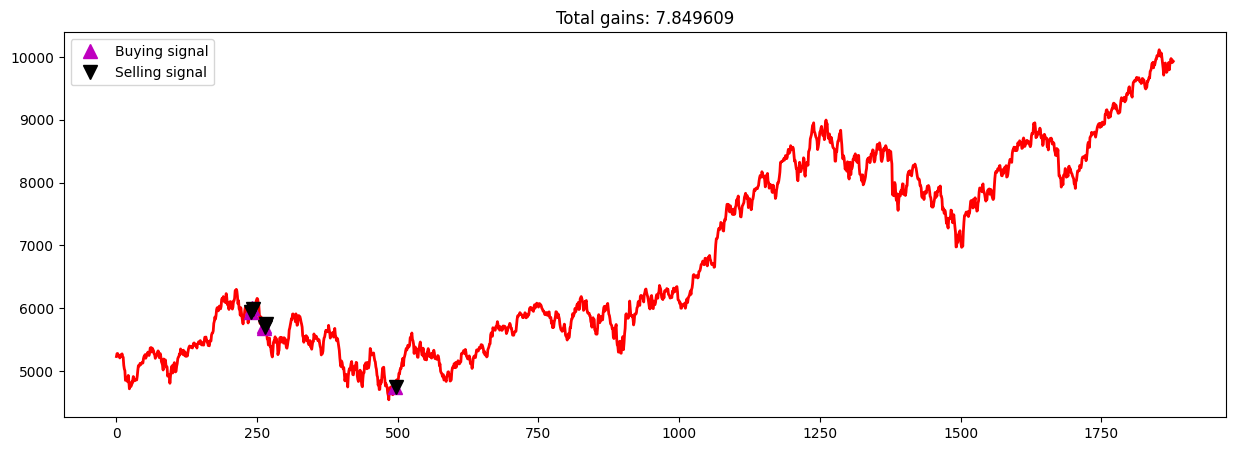

Training in progress...: 100%|██████████| 1878/1878 [07:41<00:00,  4.07it/s]


Running episode 9/10


Training in progress...:   0%|          | 0/1878 [00:00<?, ?it/s]

[[0.         0.         0.31702131]] 2


Training in progress...:   0%|          | 1/1878 [00:00<08:46,  3.56it/s]

[[0.         0.         0.36133871]] 2


Training in progress...:   0%|          | 2/1878 [00:00<08:17,  3.77it/s]

[[0.         0.         0.52157384]] 2


Training in progress...:   0%|          | 3/1878 [00:00<08:15,  3.78it/s]

[[0.         0.         0.41496363]] 2


Training in progress...:   0%|          | 4/1878 [00:01<08:21,  3.74it/s]

[[0.         0.         0.25647922]] 2


Training in progress...:   0%|          | 5/1878 [00:01<08:36,  3.62it/s]

[[0.         0.         0.31734466]] 2


Training in progress...:   0%|          | 6/1878 [00:01<08:23,  3.72it/s]

[[0.         0.         0.36989712]] 2


Training in progress...:   0%|          | 7/1878 [00:01<08:08,  3.83it/s]

[[0.         0.         0.46502264]] 2


Training in progress...:   0%|          | 8/1878 [00:02<08:25,  3.70it/s]

[[0.03290872 0.         0.47650139]] 2


Training in progress...:   0%|          | 9/1878 [00:02<08:21,  3.73it/s]

[[0.0426627  0.         0.51728595]] 2


Training in progress...:   1%|          | 10/1878 [00:02<08:11,  3.80it/s]

[[0.10298058 0.         0.58005931]] 2


Training in progress...:   1%|          | 11/1878 [00:02<08:03,  3.86it/s]

[[0.02213616 0.         0.60392305]] 2


Training in progress...:   1%|          | 12/1878 [00:03<08:21,  3.72it/s]

[[0.03931775 0.         0.56171215]] 2


Training in progress...:   1%|          | 13/1878 [00:03<08:18,  3.74it/s]

[[0.08379421 0.         0.51692672]] 2


Training in progress...:   1%|          | 14/1878 [00:03<08:04,  3.85it/s]

[[0.13286342 0.         0.58590587]] 2


Training in progress...:   1%|          | 15/1878 [00:03<08:08,  3.81it/s]

[[0.        0.        0.4263277]] 2


Training in progress...:   1%|          | 16/1878 [00:04<07:59,  3.89it/s]

[[0.         0.11989746 0.41436008]] 2


Training in progress...:   1%|          | 17/1878 [00:04<07:44,  4.01it/s]

[[0.         0.07393414 0.4921423 ]] 2


Training in progress...:   1%|          | 18/1878 [00:04<07:37,  4.06it/s]

[[0.         0.14875248 0.67965584]] 2


Training in progress...:   1%|          | 19/1878 [00:04<07:59,  3.88it/s]

[[0.         0.         0.51160234]] 2


Training in progress...:   1%|          | 20/1878 [00:05<08:06,  3.82it/s]

[[0.         0.06348358 0.40229709]] 2


Training in progress...:   1%|          | 21/1878 [00:05<07:43,  4.00it/s]

[[0.         0.20739388 0.45054774]] 2


Training in progress...:   1%|          | 22/1878 [00:05<07:25,  4.16it/s]

[[0.        0.        0.5662457]] 2


Training in progress...:   1%|          | 23/1878 [00:05<07:31,  4.11it/s]

[[0.01847638 0.         0.61595315]] 2


Training in progress...:   1%|▏         | 24/1878 [00:06<07:31,  4.11it/s]

[[0.         0.         0.70380641]] 2


Training in progress...:   1%|▏         | 25/1878 [00:06<07:33,  4.09it/s]

[[0.         0.         0.66768371]] 2


Training in progress...:   1%|▏         | 26/1878 [00:06<07:39,  4.03it/s]

[[0.         0.04739384 0.59847223]] 2


Training in progress...:   1%|▏         | 27/1878 [00:06<07:24,  4.16it/s]

[[0.         0.16235873 0.60290346]] 2


Training in progress...:   1%|▏         | 28/1878 [00:07<07:42,  4.00it/s]

[[0.         0.         0.70868147]] 2


Training in progress...:   2%|▏         | 29/1878 [00:07<07:37,  4.04it/s]

[[0.         0.         0.61639184]] 2


Training in progress...:   2%|▏         | 30/1878 [00:07<07:22,  4.17it/s]

[[0.         0.         0.50514624]] 2


Training in progress...:   2%|▏         | 31/1878 [00:07<07:18,  4.21it/s]

[[0.         0.         0.55535634]] 2


Training in progress...:   2%|▏         | 32/1878 [00:08<07:22,  4.17it/s]

[[0.         0.         0.46089805]] 2


Training in progress...:   2%|▏         | 33/1878 [00:08<07:14,  4.25it/s]

[[0.         0.         0.40759272]] 2


Training in progress...:   2%|▏         | 34/1878 [00:08<07:09,  4.29it/s]

[[0.         0.         0.52420233]] 2


Training in progress...:   2%|▏         | 35/1878 [00:08<07:10,  4.28it/s]

[[0.         0.         0.49964655]] 2


Training in progress...:   2%|▏         | 36/1878 [00:09<07:15,  4.23it/s]

[[0.         0.         0.40070854]] 2


Training in progress...:   2%|▏         | 37/1878 [00:09<07:20,  4.18it/s]

[[0.         0.         0.46012121]] 2


Training in progress...:   2%|▏         | 38/1878 [00:09<07:22,  4.16it/s]

[[0.         0.         0.50893488]] 2


Training in progress...:   2%|▏         | 39/1878 [00:09<07:15,  4.22it/s]

[[0.         0.         0.51367432]] 2


Training in progress...:   2%|▏         | 40/1878 [00:10<07:11,  4.26it/s]

[[0.         0.         0.39290607]] 2


Training in progress...:   2%|▏         | 41/1878 [00:10<07:20,  4.17it/s]

[[0.         0.         0.36683204]] 2


Training in progress...:   2%|▏         | 42/1878 [00:10<07:17,  4.19it/s]

[[0.         0.         0.52615298]] 2


Training in progress...:   2%|▏         | 43/1878 [00:10<07:03,  4.33it/s]

[[0.         0.         0.46037155]] 2


Training in progress...:   2%|▏         | 44/1878 [00:10<07:05,  4.31it/s]

[[0.         0.         0.40852739]] 2


Training in progress...:   2%|▏         | 45/1878 [00:11<07:34,  4.03it/s]

[[0.         0.         0.44572216]] 2


Training in progress...:   2%|▏         | 46/1878 [00:11<07:26,  4.11it/s]

[[0.         0.         0.42642043]] 2


Training in progress...:   3%|▎         | 47/1878 [00:11<07:11,  4.24it/s]

[[0.         0.         0.40571587]] 2


Training in progress...:   3%|▎         | 48/1878 [00:11<07:14,  4.22it/s]

[[0.         0.         0.54549389]] 2


Training in progress...:   3%|▎         | 49/1878 [00:12<07:26,  4.10it/s]

[[0.         0.         0.54399107]] 2


Training in progress...:   3%|▎         | 50/1878 [00:12<07:29,  4.07it/s]

[[0.        0.        0.6153942]] 2


Training in progress...:   3%|▎         | 51/1878 [00:12<07:22,  4.13it/s]

[[0.         0.         0.67942957]] 2


Training in progress...:   3%|▎         | 52/1878 [00:12<07:14,  4.20it/s]

[[0.         0.         0.60837409]] 2


Training in progress...:   3%|▎         | 53/1878 [00:13<07:13,  4.21it/s]

[[0.        0.        0.4128237]] 2


Training in progress...:   3%|▎         | 54/1878 [00:13<07:17,  4.17it/s]

[[0.         0.         0.33344111]] 2


Training in progress...:   3%|▎         | 55/1878 [00:13<07:05,  4.29it/s]

[[0.         0.         0.34448738]] 2


Training in progress...:   3%|▎         | 56/1878 [00:13<07:00,  4.33it/s]

[[0.         0.         0.35797373]] 2


Training in progress...:   3%|▎         | 57/1878 [00:14<07:05,  4.28it/s]

[[0.         0.         0.34060837]] 2


Training in progress...:   3%|▎         | 58/1878 [00:14<07:14,  4.19it/s]

[[0.         0.         0.22268025]] 2


Training in progress...:   3%|▎         | 59/1878 [00:14<07:13,  4.19it/s]

[[0.         0.         0.15109871]] 2


Training in progress...:   3%|▎         | 60/1878 [00:14<07:05,  4.28it/s]

[[0.         0.         0.09445027]] 2


Training in progress...:   3%|▎         | 61/1878 [00:14<07:03,  4.29it/s]

[[0.         0.         0.10398707]] 2


Training in progress...:   3%|▎         | 62/1878 [00:15<07:06,  4.26it/s]

[[0.         0.         0.24090528]] 2


Training in progress...:   3%|▎         | 63/1878 [00:15<07:25,  4.08it/s]

[[0.         0.         0.30807638]] 2


Training in progress...:   3%|▎         | 64/1878 [00:15<07:19,  4.12it/s]

[[0.         0.         0.12371363]] 2


Training in progress...:   3%|▎         | 65/1878 [00:16<07:31,  4.01it/s]

[[0.         0.         0.22405626]] 2


Training in progress...:   4%|▎         | 66/1878 [00:16<07:28,  4.04it/s]

[[0.         0.         0.11346691]] 2


Training in progress...:   4%|▎         | 67/1878 [00:16<07:33,  3.99it/s]

[[0.         0.         0.13251217]] 2


Training in progress...:   4%|▎         | 68/1878 [00:16<07:25,  4.06it/s]

[[0.         0.         0.16263405]] 2


Training in progress...:   4%|▎         | 69/1878 [00:16<07:10,  4.20it/s]

[[0.04072829 0.         0.14143361]] 2


Training in progress...:   4%|▎         | 70/1878 [00:17<07:16,  4.14it/s]

[[0.02708666 0.         0.12522812]] 2


Training in progress...:   4%|▍         | 71/1878 [00:17<07:24,  4.06it/s]

[[0.         0.         0.29293515]] 2


Training in progress...:   4%|▍         | 72/1878 [00:17<07:24,  4.07it/s]

[[0.         0.         0.33533299]] 2


Training in progress...:   4%|▍         | 73/1878 [00:17<07:43,  3.89it/s]

[[0.         0.         0.31344103]] 2


Training in progress...:   4%|▍         | 74/1878 [00:18<07:38,  3.93it/s]

[[0.         0.         0.19538267]] 2


Training in progress...:   4%|▍         | 75/1878 [00:18<07:54,  3.80it/s]

[[0.         0.         0.35654503]] 2


Training in progress...:   4%|▍         | 76/1878 [00:18<07:52,  3.81it/s]

[[0.         0.         0.44591266]] 2


Training in progress...:   4%|▍         | 77/1878 [00:19<07:49,  3.84it/s]

[[0.        0.        0.3925561]] 2


Training in progress...:   4%|▍         | 78/1878 [00:19<07:55,  3.79it/s]

[[0.         0.         0.55218744]] 2


Training in progress...:   4%|▍         | 79/1878 [00:19<07:37,  3.93it/s]

[[0.        0.        0.4919225]] 2


Training in progress...:   4%|▍         | 80/1878 [00:19<07:48,  3.84it/s]

[[0.         0.         0.67069981]] 2


Training in progress...:   4%|▍         | 81/1878 [00:20<07:54,  3.79it/s]

[[0.10125165 0.         0.54470671]] 2


Training in progress...:   4%|▍         | 82/1878 [00:20<08:06,  3.69it/s]

[[0.14781957 0.         0.45080803]] 2


Training in progress...:   4%|▍         | 83/1878 [00:20<08:13,  3.64it/s]

[[0.04066578 0.02519409 0.37611934]] 2


Training in progress...:   4%|▍         | 84/1878 [00:20<08:04,  3.71it/s]

[[0.         0.03858471 0.43647898]] 2


Training in progress...:   5%|▍         | 85/1878 [00:21<08:07,  3.68it/s]

[[0.         0.04311869 0.44367725]] 2


Training in progress...:   5%|▍         | 86/1878 [00:21<08:07,  3.68it/s]

[[0.         0.18888061 0.38152288]] 2


Training in progress...:   5%|▍         | 87/1878 [00:21<07:45,  3.85it/s]

[[0.         0.23744742 0.44324088]] 2


Training in progress...:   5%|▍         | 88/1878 [00:21<07:40,  3.89it/s]

[[0.         0.41933911 0.69256787]] 2


Training in progress...:   5%|▍         | 89/1878 [00:22<07:33,  3.94it/s]

[[0.         0.14360886 0.59147139]] 2


Training in progress...:   5%|▍         | 90/1878 [00:22<07:19,  4.07it/s]

[[0.         0.         0.50784108]] 2


Training in progress...:   5%|▍         | 91/1878 [00:22<07:07,  4.18it/s]

[[0.         0.         0.41280521]] 2


Training in progress...:   5%|▍         | 92/1878 [00:22<07:05,  4.20it/s]

[[0.         0.         0.44959534]] 2


Training in progress...:   5%|▍         | 93/1878 [00:23<07:04,  4.21it/s]

[[0.         0.         0.51840351]] 2


Training in progress...:   5%|▌         | 94/1878 [00:23<06:58,  4.26it/s]

[[0.         0.         0.50632158]] 2


Training in progress...:   5%|▌         | 95/1878 [00:23<06:53,  4.31it/s]

[[0.         0.         0.59350705]] 2


Training in progress...:   5%|▌         | 96/1878 [00:23<06:49,  4.35it/s]

[[0.         0.         0.55733006]] 2


Training in progress...:   5%|▌         | 97/1878 [00:24<06:56,  4.28it/s]

[[0.         0.         0.46246328]] 2


Training in progress...:   5%|▌         | 98/1878 [00:24<07:04,  4.19it/s]

[[0.         0.         0.50261072]] 2


Training in progress...:   5%|▌         | 99/1878 [00:24<07:01,  4.22it/s]

[[0.         0.         0.67225041]] 2


Training in progress...:   5%|▌         | 100/1878 [00:24<06:51,  4.32it/s]

[[0.         0.         0.53985928]] 2


Training in progress...:   5%|▌         | 101/1878 [00:24<06:52,  4.31it/s]

[[0.         0.         0.54846412]] 2


Training in progress...:   5%|▌         | 102/1878 [00:25<07:08,  4.15it/s]

[[0.         0.         0.52316585]] 2


Training in progress...:   5%|▌         | 103/1878 [00:25<07:06,  4.16it/s]

[[0.         0.         0.54320795]] 2


Training in progress...:   6%|▌         | 104/1878 [00:25<06:58,  4.24it/s]

[[0.         0.         0.55662197]] 2


Training in progress...:   6%|▌         | 105/1878 [00:25<06:48,  4.34it/s]

[[0.         0.         0.44937038]] 2


Training in progress...:   6%|▌         | 106/1878 [00:26<07:06,  4.16it/s]

[[0.         0.         0.35508374]] 2


Training in progress...:   6%|▌         | 107/1878 [00:26<07:02,  4.19it/s]

[[0.         0.         0.47873983]] 2


Training in progress...:   6%|▌         | 108/1878 [00:26<07:00,  4.21it/s]

[[0.         0.         0.41184511]] 2


Training in progress...:   6%|▌         | 109/1878 [00:26<07:04,  4.17it/s]

[[0.         0.         0.18828296]] 2


Training in progress...:   6%|▌         | 110/1878 [00:27<07:12,  4.09it/s]

[[0.         0.         0.22753617]] 2


Training in progress...:   6%|▌         | 111/1878 [00:27<07:09,  4.11it/s]

[[0.         0.         0.14546667]] 2


Training in progress...:   6%|▌         | 112/1878 [00:27<07:00,  4.20it/s]

[[0.         0.         0.21978521]] 2


Training in progress...:   6%|▌         | 113/1878 [00:27<06:55,  4.25it/s]

[[0.        0.        0.3748668]] 2


Training in progress...:   6%|▌         | 114/1878 [00:28<07:01,  4.18it/s]

[[0.         0.         0.21125485]] 2


Training in progress...:   6%|▌         | 115/1878 [00:28<07:11,  4.08it/s]

[[0.         0.         0.28509422]] 2


Training in progress...:   6%|▌         | 116/1878 [00:28<07:04,  4.15it/s]

[[0.         0.         0.19005909]] 2


Training in progress...:   6%|▌         | 117/1878 [00:28<06:58,  4.21it/s]

[[0.         0.         0.39504876]] 2


Training in progress...:   6%|▋         | 118/1878 [00:29<06:53,  4.25it/s]

[[0.         0.         0.42461111]] 2


Training in progress...:   6%|▋         | 119/1878 [00:29<07:08,  4.10it/s]

[[0.         0.         0.34145085]] 2


Training in progress...:   6%|▋         | 120/1878 [00:29<07:14,  4.05it/s]

[[0.         0.         0.28602631]] 2


Training in progress...:   6%|▋         | 121/1878 [00:29<07:20,  3.99it/s]

[[0.         0.         0.00273759]] 2


Training in progress...:   6%|▋         | 122/1878 [00:30<07:09,  4.09it/s]

[[0.         0.         0.14577955]] 2


Training in progress...:   7%|▋         | 123/1878 [00:30<07:06,  4.12it/s]

[[0.         0.         0.14150733]] 2


Training in progress...:   7%|▋         | 124/1878 [00:30<07:09,  4.08it/s]

[[0.         0.         0.30477923]] 2


Training in progress...:   7%|▋         | 125/1878 [00:30<07:04,  4.13it/s]

[[0.         0.         0.43260756]] 2


Training in progress...:   7%|▋         | 126/1878 [00:31<06:56,  4.21it/s]

[[0.         0.         0.45148132]] 2


Training in progress...:   7%|▋         | 127/1878 [00:31<07:00,  4.16it/s]

[[0.0905004  0.         0.30134107]] 2


Training in progress...:   7%|▋         | 128/1878 [00:31<07:06,  4.10it/s]

[[0.03642315 0.         0.4113419 ]] 2


Training in progress...:   7%|▋         | 129/1878 [00:31<07:15,  4.01it/s]

[[0.         0.         0.41475624]] 2


Training in progress...:   7%|▋         | 130/1878 [00:32<07:11,  4.05it/s]

[[0.         0.         0.29038923]] 2


Training in progress...:   7%|▋         | 131/1878 [00:32<07:22,  3.95it/s]

[[0.         0.         0.28666621]] 2


Training in progress...:   7%|▋         | 132/1878 [00:32<07:27,  3.91it/s]

[[0.       0.       0.240516]] 2


Training in progress...:   7%|▋         | 133/1878 [00:32<07:28,  3.89it/s]

[[0.         0.         0.41846354]] 2


Training in progress...:   7%|▋         | 134/1878 [00:33<07:14,  4.02it/s]

[[0.         0.         0.44999335]] 2


Training in progress...:   7%|▋         | 135/1878 [00:33<07:19,  3.96it/s]

[[0.         0.         0.42097864]] 2


Training in progress...:   7%|▋         | 136/1878 [00:33<07:29,  3.88it/s]

[[0.03820756 0.         0.55391295]] 2


Training in progress...:   7%|▋         | 137/1878 [00:33<07:30,  3.86it/s]

[[0.12598038 0.         0.50348379]] 2


Training in progress...:   7%|▋         | 138/1878 [00:34<07:16,  3.98it/s]

[[0.05385502 0.         0.49427134]] 2


Training in progress...:   7%|▋         | 139/1878 [00:34<07:31,  3.85it/s]

[[0.01616442 0.         0.74174373]] 2


Training in progress...:   7%|▋         | 140/1878 [00:34<07:26,  3.90it/s]

[[0.12062366 0.         0.71101695]] 2


Training in progress...:   8%|▊         | 141/1878 [00:34<07:27,  3.88it/s]

[[0.13948212 0.         0.55476625]] 2


Training in progress...:   8%|▊         | 142/1878 [00:35<07:15,  3.98it/s]

[[0.15808568 0.         0.60930733]] 2


Training in progress...:   8%|▊         | 143/1878 [00:35<07:10,  4.03it/s]

[[0.05565119 0.         0.63563054]] 2


Training in progress...:   8%|▊         | 144/1878 [00:35<07:09,  4.04it/s]

[[0.06288408 0.         0.48442678]] 2


Training in progress...:   8%|▊         | 145/1878 [00:35<07:10,  4.02it/s]

[[0.         0.         0.51922999]] 2


Training in progress...:   8%|▊         | 146/1878 [00:36<07:27,  3.87it/s]

[[0.         0.         0.54112982]] 2


Training in progress...:   8%|▊         | 147/1878 [00:36<07:29,  3.85it/s]

[[0.15013894 0.         0.45804401]] 2


Training in progress...:   8%|▊         | 148/1878 [00:36<07:29,  3.85it/s]

[[0.24831071 0.         0.35471814]] 2


Training in progress...:   8%|▊         | 149/1878 [00:36<07:18,  3.95it/s]

[[0.46970572 0.         0.35980425]] 0


Training in progress...:   8%|▊         | 150/1878 [00:37<07:29,  3.85it/s]

[[0.30860376 0.         0.41704948]] 2


Training in progress...:   8%|▊         | 151/1878 [00:37<07:38,  3.77it/s]

[[0.229549   0.         0.37543958]] 2


Training in progress...:   8%|▊         | 152/1878 [00:37<07:43,  3.72it/s]

[[0.11086529 0.         0.53773299]] 2


Training in progress...:   8%|▊         | 153/1878 [00:37<07:22,  3.90it/s]

[[0.12896836 0.         0.4999165 ]] 2


Training in progress...:   8%|▊         | 154/1878 [00:38<07:09,  4.02it/s]

[[0.0794093  0.         0.50517793]] 2


Training in progress...:   8%|▊         | 155/1878 [00:38<07:05,  4.05it/s]

[[0.11352806 0.         0.32686058]] 2


Training in progress...:   8%|▊         | 156/1878 [00:38<06:53,  4.17it/s]

[[0.0662743 0.        0.2780355]] 2


Training in progress...:   8%|▊         | 157/1878 [00:38<06:48,  4.22it/s]

[[0.         0.         0.26483742]] 2


Training in progress...:   8%|▊         | 158/1878 [00:39<07:00,  4.09it/s]

[[0.17195297 0.         0.29862705]] 2


Training in progress...:   8%|▊         | 159/1878 [00:39<07:01,  4.08it/s]

[[0.08945599 0.         0.39124536]] 2


Training in progress...:   9%|▊         | 160/1878 [00:39<06:56,  4.13it/s]

[[0.08738253 0.12507291 0.37135023]] 2


Training in progress...:   9%|▊         | 161/1878 [00:39<06:51,  4.17it/s]

[[0.05938143 0.21655042 0.42051064]] 2


Training in progress...:   9%|▊         | 162/1878 [00:40<06:56,  4.12it/s]

[[0.         0.02121294 0.40577436]] 2


Training in progress...:   9%|▊         | 163/1878 [00:40<06:58,  4.10it/s]

[[0.         0.05337606 0.35297559]] 2


Training in progress...:   9%|▊         | 164/1878 [00:40<06:55,  4.13it/s]

[[0.         0.2956389  0.31351014]] 2


Training in progress...:   9%|▉         | 165/1878 [00:40<06:52,  4.15it/s]

[[0.         0.18450868 0.41961374]] 2


Training in progress...:   9%|▉         | 166/1878 [00:41<06:56,  4.11it/s]

[[0.13444308 0.09641385 0.39052135]] 2


Training in progress...:   9%|▉         | 167/1878 [00:41<07:04,  4.03it/s]

[[0.         0.         0.34056811]] 2


Training in progress...:   9%|▉         | 168/1878 [00:41<06:52,  4.14it/s]

[[0.05844254 0.         0.38973176]] 2


Training in progress...:   9%|▉         | 169/1878 [00:41<06:36,  4.31it/s]

[[0.       0.       0.298638]] 2


Training in progress...:   9%|▉         | 170/1878 [00:41<06:41,  4.26it/s]

[[0.         0.         0.27021187]] 2


Training in progress...:   9%|▉         | 171/1878 [00:42<06:52,  4.13it/s]

[[0.         0.         0.24044158]] 2


Training in progress...:   9%|▉         | 172/1878 [00:42<06:44,  4.21it/s]

[[0.         0.         0.29660519]] 2


Training in progress...:   9%|▉         | 173/1878 [00:42<06:38,  4.28it/s]

[[0.         0.         0.16808475]] 2


Training in progress...:   9%|▉         | 174/1878 [00:42<06:39,  4.26it/s]

[[0.         0.         0.24462934]] 2


Training in progress...:   9%|▉         | 175/1878 [00:43<06:45,  4.20it/s]

[[0.         0.         0.23158482]] 2


Training in progress...:   9%|▉         | 176/1878 [00:43<06:52,  4.12it/s]

[[0.         0.         0.08434954]] 2


Training in progress...:   9%|▉         | 177/1878 [00:43<06:45,  4.20it/s]

[[0.         0.         0.05517748]] 2


Training in progress...:   9%|▉         | 178/1878 [00:43<06:45,  4.19it/s]

[[0.         0.         0.17442789]] 2


Training in progress...:  10%|▉         | 179/1878 [00:44<06:51,  4.13it/s]

[[0.        0.        0.2010291]] 2


Training in progress...:  10%|▉         | 180/1878 [00:44<06:51,  4.12it/s]

[[0.         0.         0.34043144]] 2


Training in progress...:  10%|▉         | 181/1878 [00:44<06:46,  4.18it/s]

[[0.         0.         0.31183831]] 2


Training in progress...:  10%|▉         | 182/1878 [00:44<06:39,  4.24it/s]

[[0.         0.         0.43894817]] 2


Training in progress...:  10%|▉         | 183/1878 [00:45<06:38,  4.25it/s]

[[0.         0.         0.47117336]] 2


Training in progress...:  10%|▉         | 184/1878 [00:45<06:41,  4.22it/s]

[[0.         0.         0.46303486]] 2


Training in progress...:  10%|▉         | 185/1878 [00:45<06:41,  4.21it/s]

[[0.         0.         0.54512643]] 2


Training in progress...:  10%|▉         | 186/1878 [00:45<06:40,  4.22it/s]

[[0.      0.      0.57573]] 2


Training in progress...:  10%|▉         | 187/1878 [00:46<06:38,  4.24it/s]

[[0.         0.         0.50156779]] 2


Training in progress...:  10%|█         | 188/1878 [00:46<06:40,  4.22it/s]

[[0.         0.         0.45853203]] 2


Training in progress...:  10%|█         | 189/1878 [00:46<06:35,  4.27it/s]

[[0.         0.         0.45221325]] 2


Training in progress...:  10%|█         | 190/1878 [00:46<06:31,  4.31it/s]

[[0.         0.         0.58120924]] 2


Training in progress...:  10%|█         | 191/1878 [00:46<06:34,  4.28it/s]

[[0.         0.         0.73220245]] 2


Training in progress...:  10%|█         | 192/1878 [00:47<06:40,  4.21it/s]

[[0.         0.         0.80911259]] 2


Training in progress...:  10%|█         | 193/1878 [00:47<06:46,  4.14it/s]

[[0.         0.         0.91361454]] 2


Training in progress...:  10%|█         | 194/1878 [00:47<06:36,  4.24it/s]

[[0.         0.         0.91607293]] 2


Training in progress...:  10%|█         | 195/1878 [00:47<06:55,  4.05it/s]

[[0.       0.       0.864575]] 2


Training in progress...:  10%|█         | 196/1878 [00:48<07:17,  3.84it/s]

[[0.         0.         0.80596605]] 2


Training in progress...:  10%|█         | 197/1878 [00:48<07:37,  3.68it/s]

[[0.         0.         0.67482752]] 2


Training in progress...:  11%|█         | 198/1878 [00:48<07:14,  3.87it/s]

[[0.        0.        0.6818517]] 2


Training in progress...:  11%|█         | 199/1878 [00:49<07:14,  3.86it/s]

[[0.         0.         0.63670008]] 2


Training in progress...:  11%|█         | 200/1878 [00:49<07:12,  3.88it/s]

[[0.         0.         0.53723099]] 2


Training in progress...:  11%|█         | 201/1878 [00:49<07:19,  3.82it/s]

[[0.         0.         0.41428178]] 2


Training in progress...:  11%|█         | 202/1878 [00:49<07:06,  3.93it/s]

[[0.        0.        0.4188568]] 2


Training in progress...:  11%|█         | 203/1878 [00:50<07:04,  3.95it/s]

[[0.         0.         0.47477006]] 2


Training in progress...:  11%|█         | 204/1878 [00:50<07:04,  3.94it/s]

[[0.         0.         0.30166654]] 2


Training in progress...:  11%|█         | 205/1878 [00:50<07:15,  3.84it/s]

[[0.         0.         0.17138299]] 2


Training in progress...:  11%|█         | 206/1878 [00:50<07:00,  3.97it/s]

[[0.         0.         0.26341841]] 2


Training in progress...:  11%|█         | 207/1878 [00:51<06:45,  4.12it/s]

[[0.         0.         0.28223181]] 2


Training in progress...:  11%|█         | 208/1878 [00:51<06:50,  4.07it/s]

[[0.         0.         0.31832243]] 2


Training in progress...:  11%|█         | 209/1878 [00:51<06:52,  4.04it/s]

[[0.         0.         0.40526968]] 2


Training in progress...:  11%|█         | 210/1878 [00:51<06:52,  4.05it/s]

[[0.         0.         0.32690856]] 2


Training in progress...:  11%|█         | 211/1878 [00:52<06:59,  3.98it/s]

[[0.         0.         0.28762564]] 2


Training in progress...:  11%|█▏        | 212/1878 [00:52<07:10,  3.87it/s]

[[0.         0.         0.29414985]] 2


Training in progress...:  11%|█▏        | 213/1878 [00:52<07:03,  3.93it/s]

[[0.         0.         0.26990747]] 2


Training in progress...:  11%|█▏        | 214/1878 [00:52<07:13,  3.84it/s]

[[0.         0.         0.22506148]] 2


Training in progress...:  11%|█▏        | 215/1878 [00:53<07:36,  3.64it/s]

[[0.         0.         0.34792321]] 2


Training in progress...:  12%|█▏        | 216/1878 [00:53<07:36,  3.64it/s]

[[0.         0.         0.46365243]] 2


Training in progress...:  12%|█▏        | 217/1878 [00:53<07:24,  3.74it/s]

[[0.         0.         0.22630388]] 2


Training in progress...:  12%|█▏        | 218/1878 [00:53<07:33,  3.66it/s]

[[0.         0.         0.37989055]] 2


Training in progress...:  12%|█▏        | 219/1878 [00:54<07:16,  3.80it/s]

[[0.        0.        0.2690166]] 2


Training in progress...:  12%|█▏        | 220/1878 [00:54<07:05,  3.90it/s]

[[0.         0.         0.31151784]] 2


Training in progress...:  12%|█▏        | 221/1878 [00:54<06:48,  4.05it/s]

[[0.         0.         0.20558132]] 2


Training in progress...:  12%|█▏        | 222/1878 [00:54<06:40,  4.14it/s]

[[0.         0.         0.34299469]] 2


Training in progress...:  12%|█▏        | 223/1878 [00:55<06:48,  4.05it/s]

[[0.         0.         0.36485985]] 2


Training in progress...:  12%|█▏        | 224/1878 [00:55<06:42,  4.11it/s]

[[0.         0.         0.34391772]] 2


Training in progress...:  12%|█▏        | 225/1878 [00:55<06:39,  4.14it/s]

[[0.         0.         0.28342685]] 2


Training in progress...:  12%|█▏        | 226/1878 [00:55<06:31,  4.22it/s]

[[0.         0.         0.25833919]] 2


Training in progress...:  12%|█▏        | 227/1878 [00:56<06:32,  4.20it/s]

[[0.        0.        0.3474641]] 2


Training in progress...:  12%|█▏        | 228/1878 [00:56<06:34,  4.19it/s]

[[0.         0.         0.21404633]] 2


Training in progress...:  12%|█▏        | 229/1878 [00:56<06:28,  4.24it/s]

[[0.         0.         0.23702768]] 2


Training in progress...:  12%|█▏        | 230/1878 [00:56<06:28,  4.24it/s]

[[0.         0.         0.32275937]] 2


Training in progress...:  12%|█▏        | 231/1878 [00:57<06:28,  4.24it/s]

[[0.         0.         0.43267869]] 2


Training in progress...:  12%|█▏        | 232/1878 [00:57<06:41,  4.10it/s]

[[0.         0.         0.40138761]] 2


Training in progress...:  12%|█▏        | 233/1878 [00:57<06:31,  4.20it/s]

[[0.         0.         0.40485144]] 2


Training in progress...:  12%|█▏        | 234/1878 [00:57<06:22,  4.30it/s]

[[0.         0.         0.33302156]] 2


Training in progress...:  13%|█▎        | 235/1878 [00:57<06:26,  4.25it/s]

[[0.        0.        0.3340156]] 2


Training in progress...:  13%|█▎        | 236/1878 [00:58<06:31,  4.19it/s]

[[0.        0.        0.4106752]] 2


Training in progress...:  13%|█▎        | 237/1878 [00:58<06:34,  4.16it/s]

[[0.         0.         0.49148038]] 2


Training in progress...:  13%|█▎        | 238/1878 [00:58<06:25,  4.25it/s]

[[0.         0.         0.36533119]] 2


Training in progress...:  13%|█▎        | 239/1878 [00:58<06:21,  4.29it/s]

[[0.         0.         0.19056498]] 2


Training in progress...:  13%|█▎        | 240/1878 [00:59<06:16,  4.35it/s]

[[0.         0.         0.20336645]] 2


Training in progress...:  13%|█▎        | 241/1878 [00:59<06:31,  4.18it/s]

[[0.         0.         0.13443435]] 2


Training in progress...:  13%|█▎        | 242/1878 [00:59<06:29,  4.21it/s]

[[0.         0.         0.11316872]] 2


Training in progress...:  13%|█▎        | 243/1878 [00:59<06:24,  4.26it/s]

[[0.         0.         0.06986314]] 2


Training in progress...:  13%|█▎        | 244/1878 [01:00<06:32,  4.16it/s]

[[0.         0.         0.15149024]] 2


Training in progress...:  13%|█▎        | 245/1878 [01:00<06:27,  4.21it/s]

[[0.         0.         0.25439834]] 2


Training in progress...:  13%|█▎        | 246/1878 [01:00<06:23,  4.26it/s]

[[0.         0.         0.32089007]] 2


Training in progress...:  13%|█▎        | 247/1878 [01:00<06:23,  4.25it/s]

[[0.         0.         0.35190089]] 2


Training in progress...:  13%|█▎        | 248/1878 [01:01<06:32,  4.15it/s]

[[0.         0.         0.30580752]] 2


Training in progress...:  13%|█▎        | 249/1878 [01:01<06:37,  4.10it/s]

[[0.         0.         0.35727055]] 2


Training in progress...:  13%|█▎        | 250/1878 [01:01<06:31,  4.16it/s]

[[0.         0.         0.43372628]] 2


Training in progress...:  13%|█▎        | 251/1878 [01:01<06:28,  4.19it/s]

[[0.         0.         0.38056986]] 2


Training in progress...:  13%|█▎        | 252/1878 [01:02<06:34,  4.13it/s]

[[0.         0.         0.38771258]] 2


Training in progress...:  13%|█▎        | 253/1878 [01:02<06:35,  4.11it/s]

[[0.         0.         0.42962093]] 2


Training in progress...:  14%|█▎        | 254/1878 [01:02<06:41,  4.05it/s]

[[0.        0.        0.4124811]] 2


Training in progress...:  14%|█▎        | 255/1878 [01:02<06:37,  4.08it/s]

[[0.         0.         0.63283888]] 2


Training in progress...:  14%|█▎        | 256/1878 [01:03<06:32,  4.13it/s]

[[0.         0.         0.46343315]] 2


Training in progress...:  14%|█▎        | 257/1878 [01:03<06:29,  4.16it/s]

[[0.         0.05396041 0.57098499]] 2


Training in progress...:  14%|█▎        | 258/1878 [01:03<06:25,  4.21it/s]

[[0.         0.         0.47319074]] 2


Training in progress...:  14%|█▍        | 259/1878 [01:03<06:14,  4.32it/s]

[[0.         0.         0.51801636]] 2


Training in progress...:  14%|█▍        | 260/1878 [01:03<06:18,  4.27it/s]

[[0.         0.         0.56315151]] 2


Training in progress...:  14%|█▍        | 261/1878 [01:04<06:27,  4.18it/s]

[[0.         0.         0.66616838]] 2


Training in progress...:  14%|█▍        | 262/1878 [01:04<06:32,  4.12it/s]

[[0.         0.         0.59513606]] 2


Training in progress...:  14%|█▍        | 263/1878 [01:04<06:39,  4.04it/s]

[[0.         0.         0.60305774]] 2


Training in progress...:  14%|█▍        | 264/1878 [01:04<06:39,  4.04it/s]

[[0.         0.         0.43839073]] 2


Training in progress...:  14%|█▍        | 265/1878 [01:05<06:35,  4.07it/s]

[[0.         0.         0.32776073]] 2


Training in progress...:  14%|█▍        | 266/1878 [01:05<06:25,  4.18it/s]

[[0.         0.         0.25895151]] 2


Training in progress...:  14%|█▍        | 267/1878 [01:05<06:21,  4.22it/s]

[[0.         0.01839996 0.        ]] 1


Training in progress...:  14%|█▍        | 268/1878 [01:05<06:15,  4.29it/s]

[[0.         0.         0.11211072]] 2


Training in progress...:  14%|█▍        | 269/1878 [01:06<06:11,  4.33it/s]

[[0.         0.         0.28027027]] 2


Training in progress...:  14%|█▍        | 270/1878 [01:06<06:24,  4.19it/s]

[[0.         0.         0.18880396]] 2


Training in progress...:  14%|█▍        | 271/1878 [01:06<06:37,  4.05it/s]

[[0.        0.        0.1980197]] 2


Training in progress...:  14%|█▍        | 272/1878 [01:06<06:31,  4.11it/s]

[[0.         0.         0.19849174]] 2


Training in progress...:  15%|█▍        | 273/1878 [01:07<06:44,  3.97it/s]

[[0.         0.         0.13364366]] 2


Training in progress...:  15%|█▍        | 274/1878 [01:07<06:42,  3.99it/s]

[[0.         0.         0.05406055]] 2


Training in progress...:  15%|█▍        | 275/1878 [01:07<06:47,  3.93it/s]

[[0.        0.        0.1643327]] 2


Training in progress...:  15%|█▍        | 276/1878 [01:07<06:41,  3.99it/s]

[[0.         0.         0.18109954]] 2


Training in progress...:  15%|█▍        | 277/1878 [01:08<06:33,  4.07it/s]

[[0.         0.         0.24191687]] 2


Training in progress...:  15%|█▍        | 278/1878 [01:08<06:33,  4.07it/s]

[[0.        0.        0.2740665]] 2


Training in progress...:  15%|█▍        | 279/1878 [01:08<06:30,  4.10it/s]

[[0.         0.         0.25676339]] 2


Training in progress...:  15%|█▍        | 280/1878 [01:08<06:33,  4.07it/s]

[[0.         0.         0.10482207]] 2


Training in progress...:  15%|█▍        | 281/1878 [01:09<06:29,  4.10it/s]

[[0.        0.        0.1508948]] 2


Training in progress...:  15%|█▌        | 282/1878 [01:09<06:39,  3.99it/s]

[[0.         0.         0.21390232]] 2


Training in progress...:  15%|█▌        | 283/1878 [01:09<06:44,  3.94it/s]

[[0.         0.         0.31747801]] 2


Training in progress...:  15%|█▌        | 284/1878 [01:09<06:48,  3.90it/s]

[[0.         0.         0.17980076]] 2


Training in progress...:  15%|█▌        | 285/1878 [01:10<07:05,  3.74it/s]

[[0.         0.         0.12806581]] 2


Training in progress...:  15%|█▌        | 286/1878 [01:10<06:52,  3.85it/s]

[[0.05533046 0.         0.1541923 ]] 2


Training in progress...:  15%|█▌        | 287/1878 [01:10<06:39,  3.98it/s]

[[0.12087191 0.         0.31446521]] 2


Training in progress...:  15%|█▌        | 288/1878 [01:10<06:28,  4.09it/s]

[[0.10419903 0.         0.33369692]] 2


Training in progress...:  15%|█▌        | 289/1878 [01:11<06:46,  3.91it/s]

[[0.         0.         0.32087449]] 2


Training in progress...:  15%|█▌        | 290/1878 [01:11<06:42,  3.95it/s]

[[0.03197632 0.         0.32721286]] 2


Training in progress...:  15%|█▌        | 291/1878 [01:11<06:28,  4.09it/s]

[[0.00798047 0.         0.37105259]] 2


Training in progress...:  16%|█▌        | 292/1878 [01:11<06:23,  4.14it/s]

[[0.         0.         0.40488512]] 2


Training in progress...:  16%|█▌        | 293/1878 [01:12<06:26,  4.10it/s]

[[0.         0.         0.31417938]] 2


Training in progress...:  16%|█▌        | 294/1878 [01:12<06:16,  4.21it/s]

[[0.         0.         0.47060457]] 2


Training in progress...:  16%|█▌        | 295/1878 [01:12<06:14,  4.23it/s]

[[0.         0.         0.43848753]] 2


Training in progress...:  16%|█▌        | 296/1878 [01:12<06:17,  4.19it/s]

[[0.         0.         0.56188176]] 2


Training in progress...:  16%|█▌        | 297/1878 [01:13<06:25,  4.10it/s]

[[0.         0.         0.47263113]] 2


Training in progress...:  16%|█▌        | 298/1878 [01:13<06:26,  4.09it/s]

[[0.12044164 0.         0.48436658]] 2


Training in progress...:  16%|█▌        | 299/1878 [01:13<06:14,  4.22it/s]

[[0.18281221 0.         0.36504893]] 2


Training in progress...:  16%|█▌        | 300/1878 [01:13<06:03,  4.34it/s]

[[0.13900468 0.         0.35577021]] 2


Training in progress...:  16%|█▌        | 301/1878 [01:13<05:58,  4.40it/s]

[[0.02984417 0.         0.50397436]] 2


Training in progress...:  16%|█▌        | 302/1878 [01:14<06:12,  4.23it/s]

[[0.         0.         0.41479155]] 2


Training in progress...:  16%|█▌        | 303/1878 [01:14<06:11,  4.24it/s]

[[0.        0.        0.5746248]] 2


Training in progress...:  16%|█▌        | 304/1878 [01:14<06:05,  4.31it/s]

[[0.03959712 0.         0.49057264]] 2


Training in progress...:  16%|█▌        | 305/1878 [01:14<06:06,  4.29it/s]

[[0.         0.         0.52273805]] 2


Training in progress...:  16%|█▋        | 306/1878 [01:15<06:16,  4.18it/s]

[[0.         0.         0.43279371]] 2


Training in progress...:  16%|█▋        | 307/1878 [01:15<06:14,  4.20it/s]

[[0.         0.         0.53192285]] 2


Training in progress...:  16%|█▋        | 308/1878 [01:15<06:09,  4.25it/s]

[[0.        0.        0.5294851]] 2


Training in progress...:  16%|█▋        | 309/1878 [01:15<06:08,  4.25it/s]

[[0.         0.         0.70589072]] 2


Training in progress...:  17%|█▋        | 310/1878 [01:16<06:13,  4.20it/s]

[[0.         0.         0.71653037]] 2


Training in progress...:  17%|█▋        | 311/1878 [01:16<06:17,  4.15it/s]

[[0.         0.         0.55530076]] 2


Training in progress...:  17%|█▋        | 312/1878 [01:16<06:12,  4.20it/s]

[[0.         0.         0.73030203]] 2


Training in progress...:  17%|█▋        | 313/1878 [01:16<06:13,  4.19it/s]

[[0.         0.         0.71264049]] 2


Training in progress...:  17%|█▋        | 314/1878 [01:17<06:09,  4.24it/s]

[[0.         0.         0.74110282]] 2


Training in progress...:  17%|█▋        | 315/1878 [01:17<06:16,  4.15it/s]

[[0.         0.         0.69450555]] 2


Training in progress...:  17%|█▋        | 316/1878 [01:17<06:09,  4.23it/s]

[[0.         0.         0.63111585]] 2


Training in progress...:  17%|█▋        | 317/1878 [01:17<06:03,  4.29it/s]

[[0.         0.06229954 0.57235165]] 2


Training in progress...:  17%|█▋        | 318/1878 [01:17<05:59,  4.34it/s]

[[0.         0.04555526 0.5876244 ]] 2


Training in progress...:  17%|█▋        | 319/1878 [01:18<05:57,  4.36it/s]

[[0.         0.         0.62990804]] 2


Training in progress...:  17%|█▋        | 320/1878 [01:18<06:02,  4.30it/s]

[[0.         0.         0.62434894]] 2


Training in progress...:  17%|█▋        | 321/1878 [01:18<06:01,  4.31it/s]

[[0.         0.         0.57207522]] 2


Training in progress...:  17%|█▋        | 322/1878 [01:18<06:03,  4.29it/s]

[[0.05198153 0.         0.63593346]] 2


Training in progress...:  17%|█▋        | 323/1878 [01:19<06:12,  4.17it/s]

[[0.04976501 0.         0.55797265]] 2


Training in progress...:  17%|█▋        | 324/1878 [01:19<06:23,  4.05it/s]

[[0.09379244 0.         0.58932216]] 2


Training in progress...:  17%|█▋        | 325/1878 [01:19<06:14,  4.14it/s]

[[0.         0.         0.35066002]] 2


Training in progress...:  17%|█▋        | 326/1878 [01:19<06:10,  4.19it/s]

[[0.03220367 0.         0.39505529]] 2


Training in progress...:  17%|█▋        | 327/1878 [01:20<06:15,  4.13it/s]

[[0.00851598 0.         0.34964146]] 2


Training in progress...:  17%|█▋        | 328/1878 [01:20<06:27,  4.00it/s]

[[0.        0.        0.3596646]] 2


Training in progress...:  18%|█▊        | 329/1878 [01:20<06:28,  3.99it/s]

[[0.         0.         0.29553752]] 2


Training in progress...:  18%|█▊        | 330/1878 [01:20<06:30,  3.97it/s]

[[0.         0.         0.53657294]] 2


Training in progress...:  18%|█▊        | 331/1878 [01:21<06:37,  3.89it/s]

[[0.05575616 0.         0.57522326]] 2


Training in progress...:  18%|█▊        | 332/1878 [01:21<06:27,  3.99it/s]

[[0.         0.         0.52629046]] 2


Training in progress...:  18%|█▊        | 333/1878 [01:21<06:19,  4.07it/s]

[[0.         0.         0.39508611]] 2


Training in progress...:  18%|█▊        | 334/1878 [01:21<06:15,  4.12it/s]

[[0.         0.         0.40649889]] 2


Training in progress...:  18%|█▊        | 335/1878 [01:22<06:26,  3.99it/s]

[[0.         0.         0.62797228]] 2


Training in progress...:  18%|█▊        | 336/1878 [01:22<06:31,  3.94it/s]

[[0.         0.         0.49469509]] 2


Training in progress...:  18%|█▊        | 337/1878 [01:22<06:35,  3.90it/s]

[[0.         0.         0.38775291]] 2


Training in progress...:  18%|█▊        | 338/1878 [01:22<06:47,  3.78it/s]

[[0.         0.         0.38028539]] 2


Training in progress...:  18%|█▊        | 339/1878 [01:23<06:40,  3.84it/s]

[[0.         0.         0.30231426]] 2


Training in progress...:  18%|█▊        | 340/1878 [01:23<06:41,  3.83it/s]

[[0.         0.         0.26265658]] 2


Training in progress...:  18%|█▊        | 341/1878 [01:23<06:39,  3.85it/s]

[[0.         0.00137346 0.28195136]] 2


Training in progress...:  18%|█▊        | 342/1878 [01:23<06:21,  4.03it/s]

[[0.         0.         0.41134306]] 2


Training in progress...:  18%|█▊        | 343/1878 [01:24<06:24,  3.99it/s]

[[0.         0.         0.23072847]] 2


Training in progress...:  18%|█▊        | 344/1878 [01:24<06:19,  4.04it/s]

[[0.         0.         0.20966139]] 2


Training in progress...:  18%|█▊        | 345/1878 [01:24<06:27,  3.95it/s]

[[0.         0.01281915 0.20444207]] 2


Training in progress...:  18%|█▊        | 346/1878 [01:24<06:28,  3.94it/s]

[[0.         0.         0.24799258]] 2


Training in progress...:  18%|█▊        | 347/1878 [01:25<06:48,  3.75it/s]

[[0.         0.05285309 0.03815721]] 1


Training in progress...:  19%|█▊        | 348/1878 [01:25<06:37,  3.85it/s]

[[0.         0.03889338 0.15059801]] 2


Training in progress...:  19%|█▊        | 349/1878 [01:25<06:17,  4.05it/s]

[[0.         0.         0.17992856]] 2


Training in progress...:  19%|█▊        | 350/1878 [01:26<06:30,  3.91it/s]

[[0.         0.14913903 0.23102086]] 2


Training in progress...:  19%|█▊        | 351/1878 [01:26<06:49,  3.73it/s]

[[0.         0.         0.26885709]] 2


Training in progress...:  19%|█▊        | 352/1878 [01:26<06:54,  3.68it/s]

[[0.         0.         0.37312333]] 2


Training in progress...:  19%|█▉        | 353/1878 [01:26<06:39,  3.82it/s]

[[0.         0.         0.25342284]] 2


Training in progress...:  19%|█▉        | 354/1878 [01:27<06:36,  3.85it/s]

[[0.         0.         0.07710889]] 2


Training in progress...:  19%|█▉        | 355/1878 [01:27<06:22,  3.98it/s]

[[0.         0.         0.02667582]] 2


Training in progress...:  19%|█▉        | 356/1878 [01:27<06:09,  4.12it/s]

[[0.         0.         0.05945236]] 2


Training in progress...:  19%|█▉        | 357/1878 [01:27<05:56,  4.26it/s]

[[0.         0.         0.20893522]] 2


Training in progress...:  19%|█▉        | 358/1878 [01:28<06:05,  4.15it/s]

[[0.         0.         0.23909417]] 2


Training in progress...:  19%|█▉        | 359/1878 [01:28<06:03,  4.18it/s]

[[0.        0.        0.5229833]] 2


Training in progress...:  19%|█▉        | 360/1878 [01:28<06:04,  4.16it/s]

[[0.        0.        0.6363866]] 2


Training in progress...:  19%|█▉        | 361/1878 [01:28<05:57,  4.24it/s]

[[0.         0.         0.44598985]] 2


Training in progress...:  19%|█▉        | 362/1878 [01:28<06:00,  4.21it/s]

[[0.         0.         0.56681025]] 2


Training in progress...:  19%|█▉        | 363/1878 [01:29<06:12,  4.07it/s]

[[0.         0.         0.54998915]] 2


Training in progress...:  19%|█▉        | 364/1878 [01:29<06:07,  4.12it/s]

[[0.         0.         0.58011261]] 2


Training in progress...:  19%|█▉        | 365/1878 [01:29<06:00,  4.19it/s]

[[0.        0.        0.5629467]] 2


Training in progress...:  19%|█▉        | 366/1878 [01:29<05:57,  4.23it/s]

[[0.         0.         0.28413063]] 2


Training in progress...:  20%|█▉        | 367/1878 [01:30<06:00,  4.19it/s]

[[0.         0.         0.44129041]] 2


Training in progress...:  20%|█▉        | 368/1878 [01:30<05:58,  4.21it/s]

[[0.         0.         0.32085394]] 2


Training in progress...:  20%|█▉        | 369/1878 [01:30<05:52,  4.28it/s]

[[0.         0.         0.42546197]] 2


Training in progress...:  20%|█▉        | 370/1878 [01:30<05:47,  4.34it/s]

[[0.         0.         0.57833882]] 2


Training in progress...:  20%|█▉        | 371/1878 [01:31<05:52,  4.27it/s]

[[0.         0.         0.65724938]] 2


Training in progress...:  20%|█▉        | 372/1878 [01:31<06:05,  4.12it/s]

[[0.09412756 0.         0.59253246]] 2


Training in progress...:  20%|█▉        | 373/1878 [01:31<06:00,  4.17it/s]

[[0.         0.         0.55680438]] 2


Training in progress...:  20%|█▉        | 374/1878 [01:31<05:50,  4.29it/s]

[[0.05732121 0.         0.57849465]] 2


Training in progress...:  20%|█▉        | 375/1878 [01:32<05:53,  4.25it/s]

[[0.         0.         0.70132874]] 2


Training in progress...:  20%|██        | 376/1878 [01:32<06:03,  4.13it/s]

[[0.15353255 0.         0.63200087]] 2


Training in progress...:  20%|██        | 377/1878 [01:32<05:59,  4.18it/s]

[[0.01178363 0.         0.5613298 ]] 2


Training in progress...:  20%|██        | 378/1878 [01:32<05:54,  4.24it/s]

[[0.05506915 0.         0.76062163]] 2


Training in progress...:  20%|██        | 379/1878 [01:33<05:51,  4.26it/s]

[[0.14472625 0.         0.67560441]] 2


Training in progress...:  20%|██        | 380/1878 [01:33<05:54,  4.23it/s]

[[0.22487741 0.         0.53564536]] 2


Training in progress...:  20%|██        | 381/1878 [01:33<05:54,  4.22it/s]

[[0.19367381 0.         0.48056835]] 2


Training in progress...:  20%|██        | 382/1878 [01:33<05:48,  4.30it/s]

[[0.29120976 0.         0.56276669]] 2


Training in progress...:  20%|██        | 383/1878 [01:33<05:42,  4.37it/s]

[[0.11691853 0.         0.56770552]] 2


Training in progress...:  20%|██        | 384/1878 [01:34<05:46,  4.31it/s]

[[0.05586316 0.07293504 0.46253259]] 2


Training in progress...:  21%|██        | 385/1878 [01:34<05:46,  4.31it/s]

[[0.06231279 0.         0.53851239]] 2


Training in progress...:  21%|██        | 386/1878 [01:34<05:41,  4.36it/s]

[[0.04050982 0.10955599 0.59231169]] 2


Training in progress...:  21%|██        | 387/1878 [01:34<05:39,  4.39it/s]

[[0.         0.         0.42267931]] 2


Training in progress...:  21%|██        | 388/1878 [01:35<05:34,  4.46it/s]

[[0.         0.         0.37827398]] 2


Training in progress...:  21%|██        | 389/1878 [01:35<05:40,  4.37it/s]

[[0.         0.         0.50760403]] 2


Training in progress...:  21%|██        | 390/1878 [01:35<05:48,  4.27it/s]

[[0.         0.         0.44216668]] 2


Training in progress...:  21%|██        | 391/1878 [01:35<05:40,  4.36it/s]

[[0.         0.         0.37197396]] 2


Training in progress...:  21%|██        | 392/1878 [01:36<05:45,  4.30it/s]

[[0.         0.         0.48112782]] 2


Training in progress...:  21%|██        | 393/1878 [01:36<05:52,  4.21it/s]

[[0.         0.         0.48420248]] 2


Training in progress...:  21%|██        | 394/1878 [01:36<05:50,  4.23it/s]

[[0.         0.         0.25814832]] 2


Training in progress...:  21%|██        | 395/1878 [01:36<05:51,  4.22it/s]

[[0.         0.         0.29860907]] 2


Training in progress...:  21%|██        | 396/1878 [01:36<06:01,  4.10it/s]

[[0.         0.         0.43878892]] 2


Training in progress...:  21%|██        | 397/1878 [01:37<06:11,  3.99it/s]

[[0.         0.00480204 0.37304465]] 2


Training in progress...:  21%|██        | 398/1878 [01:37<06:08,  4.02it/s]

[[0.        0.        0.2775026]] 2


Training in progress...:  21%|██        | 399/1878 [01:37<06:02,  4.08it/s]

[[0.05004966 0.         0.29407622]] 2


Training in progress...:  21%|██▏       | 400/1878 [01:37<06:08,  4.01it/s]

[[0.         0.         0.43520353]] 2


Training in progress...:  21%|██▏       | 401/1878 [01:38<06:03,  4.07it/s]

[[0.         0.         0.41461586]] 2


Training in progress...:  21%|██▏       | 402/1878 [01:38<06:14,  3.94it/s]

[[0.1042695  0.         0.37542446]] 2


Training in progress...:  21%|██▏       | 403/1878 [01:38<06:20,  3.87it/s]

[[0.07216746 0.         0.27510025]] 2


Training in progress...:  22%|██▏       | 404/1878 [01:39<06:39,  3.69it/s]

[[0.07127139 0.         0.25265972]] 2


Training in progress...:  22%|██▏       | 405/1878 [01:39<06:31,  3.76it/s]

[[0.08721057 0.         0.15446223]] 2


Training in progress...:  22%|██▏       | 406/1878 [01:39<06:17,  3.90it/s]

[[0.         0.         0.04014621]] 2


Training in progress...:  22%|██▏       | 407/1878 [01:39<06:11,  3.96it/s]

[[0.         0.         0.06850243]] 2


Training in progress...:  22%|██▏       | 408/1878 [01:40<06:10,  3.97it/s]

[[0.        0.        0.1587546]] 2


Training in progress...:  22%|██▏       | 409/1878 [01:40<06:19,  3.87it/s]

[[0.         0.         0.26891072]] 2


Training in progress...:  22%|██▏       | 410/1878 [01:40<06:17,  3.88it/s]

[[0.         0.         0.18819573]] 2


Training in progress...:  22%|██▏       | 411/1878 [01:40<06:19,  3.86it/s]

[[0.         0.         0.26034856]] 2


Training in progress...:  22%|██▏       | 412/1878 [01:41<06:34,  3.72it/s]

[[0.         0.         0.22831462]] 2


Training in progress...:  22%|██▏       | 413/1878 [01:41<06:43,  3.63it/s]

[[0.         0.         0.36731303]] 2


Training in progress...:  22%|██▏       | 414/1878 [01:41<06:34,  3.71it/s]

[[0.        0.        0.2923726]] 2


Training in progress...:  22%|██▏       | 415/1878 [01:41<06:30,  3.75it/s]

[[0.         0.         0.11183127]] 2


Training in progress...:  22%|██▏       | 416/1878 [01:42<06:29,  3.76it/s]

[[0. 0. 0.]] 0


Training in progress...:  22%|██▏       | 417/1878 [01:42<06:39,  3.65it/s]

[[0.         0.         0.03897768]] 2


Training in progress...:  22%|██▏       | 418/1878 [01:42<06:35,  3.69it/s]

[[0. 0. 0.]] 0


Training in progress...:  22%|██▏       | 419/1878 [01:43<06:28,  3.75it/s]

[[0.         0.         0.06212968]] 2


Training in progress...:  22%|██▏       | 420/1878 [01:43<06:13,  3.90it/s]

[[0.        0.        0.0808179]] 2


Training in progress...:  22%|██▏       | 421/1878 [01:43<06:03,  4.01it/s]

[[0.         0.         0.06219532]] 2


Training in progress...:  22%|██▏       | 422/1878 [01:43<05:53,  4.12it/s]

[[0.         0.         0.21348132]] 2


Training in progress...:  23%|██▎       | 423/1878 [01:43<05:56,  4.09it/s]

[[0.         0.         0.41304008]] 2


Training in progress...:  23%|██▎       | 424/1878 [01:44<05:52,  4.12it/s]

[[0.         0.         0.51423412]] 2


Training in progress...:  23%|██▎       | 425/1878 [01:44<05:46,  4.19it/s]

[[0.         0.         0.51024569]] 2


Training in progress...:  23%|██▎       | 426/1878 [01:44<05:38,  4.28it/s]

[[0.00706695 0.         0.28092421]] 2


Training in progress...:  23%|██▎       | 427/1878 [01:44<05:36,  4.31it/s]

[[0.         0.         0.48845172]] 2


Training in progress...:  23%|██▎       | 428/1878 [01:45<05:42,  4.24it/s]

[[0.         0.         0.38411272]] 2


Training in progress...:  23%|██▎       | 429/1878 [01:45<05:41,  4.24it/s]

[[0.         0.         0.24628735]] 2


Training in progress...:  23%|██▎       | 430/1878 [01:45<05:36,  4.30it/s]

[[0.         0.         0.23294401]] 2


Training in progress...:  23%|██▎       | 431/1878 [01:45<05:34,  4.33it/s]

[[3.08565717e-04 0.00000000e+00 5.85504524e-01]] 2


Training in progress...:  23%|██▎       | 432/1878 [01:46<05:40,  4.25it/s]

[[0.06672592 0.         0.57151438]] 2


Training in progress...:  23%|██▎       | 433/1878 [01:46<05:41,  4.23it/s]

[[0.21118389 0.         0.38819314]] 2


Training in progress...:  23%|██▎       | 434/1878 [01:46<05:42,  4.22it/s]

[[0.07856257 0.         0.52811793]] 2


Training in progress...:  23%|██▎       | 435/1878 [01:46<05:37,  4.27it/s]

[[0.         0.         0.46832773]] 2


Training in progress...:  23%|██▎       | 436/1878 [01:46<05:38,  4.26it/s]

[[0.06821212 0.         0.3928738 ]] 2


Training in progress...:  23%|██▎       | 437/1878 [01:47<05:49,  4.12it/s]

[[0.         0.         0.29249297]] 2


Training in progress...:  23%|██▎       | 438/1878 [01:47<05:40,  4.23it/s]

[[0.         0.         0.51714873]] 2


Training in progress...:  23%|██▎       | 439/1878 [01:47<05:31,  4.34it/s]

[[0.        0.        0.6592679]] 2


Training in progress...:  23%|██▎       | 440/1878 [01:47<05:33,  4.32it/s]

[[0.         0.         0.71171283]] 2


Training in progress...:  23%|██▎       | 441/1878 [01:48<05:39,  4.23it/s]

[[0.00425205 0.         0.64878231]] 2


Training in progress...:  24%|██▎       | 442/1878 [01:48<05:37,  4.25it/s]

[[0.         0.         0.71927875]] 2


Training in progress...:  24%|██▎       | 443/1878 [01:48<05:34,  4.29it/s]

[[0.         0.09772649 0.62490074]] 2


Training in progress...:  24%|██▎       | 444/1878 [01:48<05:46,  4.14it/s]

[[0.        0.        0.6221047]] 2


Training in progress...:  24%|██▎       | 445/1878 [01:49<05:42,  4.19it/s]

[[0.         0.         0.44999408]] 2


Training in progress...:  24%|██▎       | 446/1878 [01:49<05:49,  4.09it/s]

[[0.        0.        0.6295727]] 2


Training in progress...:  24%|██▍       | 447/1878 [01:49<05:39,  4.22it/s]

[[0.         0.         0.61509814]] 2


Training in progress...:  24%|██▍       | 448/1878 [01:49<05:34,  4.27it/s]

[[0.         0.         0.72218495]] 2


Training in progress...:  24%|██▍       | 449/1878 [01:50<05:38,  4.23it/s]

[[0.         0.         0.79259885]] 2


Training in progress...:  24%|██▍       | 450/1878 [01:50<05:44,  4.14it/s]

[[0.         0.         0.88816764]] 2


Training in progress...:  24%|██▍       | 451/1878 [01:50<05:37,  4.22it/s]

[[0.         0.         0.90100807]] 2


Training in progress...:  24%|██▍       | 452/1878 [01:50<05:30,  4.31it/s]

[[0.         0.         0.85680983]] 2


Training in progress...:  24%|██▍       | 453/1878 [01:51<05:33,  4.27it/s]

[[0.         0.         0.94061659]] 2


Training in progress...:  24%|██▍       | 454/1878 [01:51<05:39,  4.19it/s]

[[0.         0.         0.94496592]] 2


Training in progress...:  24%|██▍       | 455/1878 [01:51<05:41,  4.16it/s]

[[0.        0.        0.8757718]] 2


Training in progress...:  24%|██▍       | 456/1878 [01:51<05:34,  4.25it/s]

[[0.        0.        0.7410059]] 2


Training in progress...:  24%|██▍       | 457/1878 [01:51<05:32,  4.28it/s]

[[0.         0.         0.74690844]] 2


Training in progress...:  24%|██▍       | 458/1878 [01:52<05:34,  4.24it/s]

[[0.         0.         0.67252279]] 2


Training in progress...:  24%|██▍       | 459/1878 [01:52<05:41,  4.15it/s]

[[0.         0.         0.50299658]] 2


Training in progress...:  24%|██▍       | 460/1878 [01:52<05:33,  4.26it/s]

[[0.         0.         0.56576988]] 2


Training in progress...:  25%|██▍       | 461/1878 [01:52<05:49,  4.06it/s]

[[0.         0.         0.65492683]] 2


Training in progress...:  25%|██▍       | 462/1878 [01:53<06:01,  3.92it/s]

[[0.        0.        0.6812025]] 2


Training in progress...:  25%|██▍       | 463/1878 [01:53<06:02,  3.90it/s]

[[0.         0.         0.69209452]] 2


Training in progress...:  25%|██▍       | 464/1878 [01:53<06:04,  3.88it/s]

[[0.         0.         0.70897815]] 2


Training in progress...:  25%|██▍       | 465/1878 [01:54<06:12,  3.80it/s]

[[0.         0.         0.67783309]] 2


Training in progress...:  25%|██▍       | 466/1878 [01:54<06:18,  3.73it/s]

[[0.         0.         0.68535393]] 2


Training in progress...:  25%|██▍       | 467/1878 [01:54<06:09,  3.82it/s]

[[0.       0.       0.518069]] 2


Training in progress...:  25%|██▍       | 468/1878 [01:54<06:03,  3.88it/s]

[[0.         0.         0.37350859]] 2


Training in progress...:  25%|██▍       | 469/1878 [01:55<05:59,  3.92it/s]

[[0.         0.         0.29872231]] 2


Training in progress...:  25%|██▌       | 470/1878 [01:55<06:05,  3.85it/s]

[[0.         0.         0.19326106]] 2


Training in progress...:  25%|██▌       | 471/1878 [01:55<05:47,  4.04it/s]

[[0.         0.         0.10656814]] 2


Training in progress...:  25%|██▌       | 472/1878 [01:55<05:42,  4.11it/s]

[[0.         0.         0.00731768]] 2


Training in progress...:  25%|██▌       | 473/1878 [01:56<05:39,  4.14it/s]

[[0. 0. 0.]] 0


Training in progress...:  25%|██▌       | 474/1878 [01:56<05:36,  4.17it/s]

[[0.         0.         0.13629648]] 2


Training in progress...:  25%|██▌       | 475/1878 [01:56<05:28,  4.27it/s]

[[0.         0.         0.11529378]] 2


Training in progress...:  25%|██▌       | 476/1878 [01:56<05:20,  4.37it/s]

[[0.         0.         0.15892022]] 2


Training in progress...:  25%|██▌       | 477/1878 [01:56<05:42,  4.08it/s]

[[0.         0.         0.14153583]] 2


Training in progress...:  25%|██▌       | 478/1878 [01:57<05:47,  4.03it/s]

[[0.        0.        0.1850288]] 2


Training in progress...:  26%|██▌       | 479/1878 [01:57<06:08,  3.80it/s]

[[0.         0.         0.21088161]] 2


Training in progress...:  26%|██▌       | 480/1878 [01:57<05:59,  3.89it/s]

[[0.         0.         0.31242401]] 2


Training in progress...:  26%|██▌       | 481/1878 [01:58<05:52,  3.97it/s]

[[0.         0.07359955 0.27882192]] 2


Training in progress...:  26%|██▌       | 482/1878 [01:58<05:45,  4.04it/s]

[[0.         0.         0.21759524]] 2


Training in progress...:  26%|██▌       | 483/1878 [01:58<05:37,  4.13it/s]

[[0.         0.         0.25634863]] 2


Training in progress...:  26%|██▌       | 484/1878 [01:58<05:31,  4.20it/s]

[[0.         0.         0.37455679]] 2


Training in progress...:  26%|██▌       | 485/1878 [01:58<05:44,  4.04it/s]

[[0.         0.         0.43244207]] 2


Training in progress...:  26%|██▌       | 486/1878 [01:59<05:58,  3.88it/s]

[[0.         0.         0.58685966]] 2


Training in progress...:  26%|██▌       | 487/1878 [01:59<05:48,  4.00it/s]

[[0.         0.         0.53184504]] 2


Training in progress...:  26%|██▌       | 488/1878 [01:59<05:33,  4.17it/s]

[[0.         0.         0.55454983]] 2


Training in progress...:  26%|██▌       | 489/1878 [01:59<05:23,  4.29it/s]

[[0.         0.00629499 0.66439852]] 2


Training in progress...:  26%|██▌       | 490/1878 [02:00<05:29,  4.22it/s]

[[0.         0.18985238 0.67330513]] 2


Training in progress...:  26%|██▌       | 491/1878 [02:00<05:28,  4.22it/s]

[[0.         0.05825126 0.56963371]] 2


Training in progress...:  26%|██▌       | 492/1878 [02:00<05:23,  4.28it/s]

[[0.        0.        0.6113755]] 2


Training in progress...:  26%|██▋       | 493/1878 [02:00<05:14,  4.40it/s]

[[0.         0.03769101 0.64997568]] 2


Training in progress...:  26%|██▋       | 494/1878 [02:01<05:20,  4.32it/s]

[[0.         0.         0.48644559]] 2


Training in progress...:  26%|██▋       | 495/1878 [02:01<05:20,  4.32it/s]

[[0.         0.         0.52143878]] 2


Training in progress...:  26%|██▋       | 496/1878 [02:01<05:20,  4.31it/s]

[[0.         0.14113766 0.5062417 ]] 2


Training in progress...:  26%|██▋       | 497/1878 [02:01<05:13,  4.40it/s]

[[0.         0.24037619 0.56670123]] 2


Training in progress...:  27%|██▋       | 498/1878 [02:01<05:14,  4.39it/s]

[[0.         0.         0.60077804]] 2


Training in progress...:  27%|██▋       | 499/1878 [02:02<05:23,  4.27it/s]

[[0.         0.         0.48481205]] 2


Training in progress...:  27%|██▋       | 500/1878 [02:02<05:19,  4.32it/s]

[[0.         0.         0.35046908]] 2


Training in progress...:  27%|██▋       | 501/1878 [02:02<05:12,  4.40it/s]

[[0.         0.         0.46094444]] 2


Training in progress...:  27%|██▋       | 502/1878 [02:02<05:10,  4.43it/s]

[[0.         0.         0.29054335]] 2


Training in progress...:  27%|██▋       | 503/1878 [02:03<05:11,  4.42it/s]

[[0.         0.         0.42480029]] 2


Training in progress...:  27%|██▋       | 504/1878 [02:03<05:15,  4.35it/s]

[[0.         0.         0.42765484]] 2


Training in progress...:  27%|██▋       | 505/1878 [02:03<05:17,  4.32it/s]

[[0.         0.         0.29662831]] 2


Training in progress...:  27%|██▋       | 506/1878 [02:03<05:15,  4.35it/s]

[[0.         0.         0.22939134]] 2


Training in progress...:  27%|██▋       | 507/1878 [02:04<05:14,  4.36it/s]

[[0.         0.         0.33829628]] 2


Training in progress...:  27%|██▋       | 508/1878 [02:04<05:23,  4.23it/s]

[[0.         0.         0.34216055]] 2


Training in progress...:  27%|██▋       | 509/1878 [02:04<05:18,  4.30it/s]

[[0.         0.         0.33185853]] 2


Training in progress...:  27%|██▋       | 510/1878 [02:04<05:15,  4.34it/s]

[[0.         0.         0.25266096]] 2


Training in progress...:  27%|██▋       | 511/1878 [02:04<05:16,  4.32it/s]

[[0.         0.         0.27115935]] 2


Training in progress...:  27%|██▋       | 512/1878 [02:05<05:19,  4.28it/s]

[[0.         0.         0.36217909]] 2


Training in progress...:  27%|██▋       | 513/1878 [02:05<05:20,  4.26it/s]

[[0.         0.         0.35896545]] 2


Training in progress...:  27%|██▋       | 514/1878 [02:05<05:12,  4.37it/s]

[[0.         0.         0.32391535]] 2


Training in progress...:  27%|██▋       | 515/1878 [02:05<05:15,  4.33it/s]

[[0.         0.         0.38742391]] 2


Training in progress...:  27%|██▋       | 516/1878 [02:06<05:17,  4.28it/s]

[[0.         0.         0.51111479]] 2


Training in progress...:  28%|██▊       | 517/1878 [02:06<05:21,  4.24it/s]

[[0.         0.         0.47032113]] 2


Training in progress...:  28%|██▊       | 518/1878 [02:06<05:18,  4.28it/s]

[[0.         0.         0.39388875]] 2


Training in progress...:  28%|██▊       | 519/1878 [02:06<05:18,  4.27it/s]

[[0.         0.         0.28251856]] 2


Training in progress...:  28%|██▊       | 520/1878 [02:07<05:16,  4.28it/s]

[[0.        0.        0.0669459]] 2


Training in progress...:  28%|██▊       | 521/1878 [02:07<05:16,  4.28it/s]

[[0.         0.         0.15609911]] 2


Training in progress...:  28%|██▊       | 522/1878 [02:07<05:11,  4.35it/s]

[[0.         0.         0.13923779]] 2


Training in progress...:  28%|██▊       | 523/1878 [02:07<05:11,  4.35it/s]

[[0.         0.         0.21682298]] 2


Training in progress...:  28%|██▊       | 524/1878 [02:08<05:16,  4.28it/s]

[[0.         0.         0.19476664]] 2


Training in progress...:  28%|██▊       | 525/1878 [02:08<05:13,  4.31it/s]

[[0.00374069 0.         0.29877255]] 2


Training in progress...:  28%|██▊       | 526/1878 [02:08<05:22,  4.20it/s]

[[0.2500886  0.         0.36725984]] 2


Training in progress...:  28%|██▊       | 527/1878 [02:08<05:20,  4.21it/s]

[[0.23409478 0.         0.30845306]] 2


Training in progress...:  28%|██▊       | 528/1878 [02:08<05:26,  4.13it/s]

[[0.16359515 0.         0.2692924 ]] 2


Training in progress...:  28%|██▊       | 529/1878 [02:09<05:29,  4.09it/s]

[[0.30594095 0.         0.21821716]] 0


Training in progress...:  28%|██▊       | 530/1878 [02:09<05:37,  3.99it/s]

[[0.10917214 0.         0.19162636]] 2


Training in progress...:  28%|██▊       | 531/1878 [02:09<05:32,  4.05it/s]

[[0.259095   0.         0.21280071]] 0


Training in progress...:  28%|██▊       | 532/1878 [02:10<05:39,  3.96it/s]

[[0.09254937 0.         0.16695604]] 2


Training in progress...:  28%|██▊       | 533/1878 [02:10<05:28,  4.09it/s]

[[0.        0.        0.2747824]] 2


Training in progress...:  28%|██▊       | 534/1878 [02:10<05:20,  4.19it/s]

[[0.         0.         0.51931255]] 2


Training in progress...:  28%|██▊       | 535/1878 [02:10<05:21,  4.18it/s]

[[0.         0.         0.52034207]] 2


Training in progress...:  29%|██▊       | 536/1878 [02:10<05:14,  4.26it/s]

[[0.         0.         0.65697017]] 2


Training in progress...:  29%|██▊       | 537/1878 [02:11<05:12,  4.30it/s]

[[0.         0.         0.43133327]] 2


Training in progress...:  29%|██▊       | 538/1878 [02:11<05:30,  4.06it/s]

[[0.         0.         0.49606912]] 2


Training in progress...:  29%|██▊       | 539/1878 [02:11<05:32,  4.03it/s]

[[0.         0.         0.29386639]] 2


Training in progress...:  29%|██▉       | 540/1878 [02:11<05:49,  3.83it/s]

[[0.         0.         0.22780495]] 2


Training in progress...:  29%|██▉       | 541/1878 [02:12<05:57,  3.74it/s]

[[0.         0.         0.30424562]] 2


Training in progress...:  29%|██▉       | 542/1878 [02:12<05:46,  3.85it/s]

[[0.         0.         0.26159248]] 2


Training in progress...:  29%|██▉       | 543/1878 [02:12<05:44,  3.88it/s]

[[0.         0.         0.07736958]] 2


Training in progress...:  29%|██▉       | 544/1878 [02:12<05:34,  3.99it/s]

[[0.         0.         0.21144205]] 2


Training in progress...:  29%|██▉       | 545/1878 [02:13<05:29,  4.05it/s]

[[0.         0.         0.33059641]] 2


Training in progress...:  29%|██▉       | 546/1878 [02:13<05:36,  3.96it/s]

[[0.         0.         0.22420923]] 2


Training in progress...:  29%|██▉       | 547/1878 [02:13<05:34,  3.98it/s]

[[0.         0.         0.40815349]] 2


Training in progress...:  29%|██▉       | 548/1878 [02:13<05:37,  3.95it/s]

[[0.05441561 0.         0.36661407]] 2


Training in progress...:  29%|██▉       | 549/1878 [02:14<05:41,  3.89it/s]

[[0.20165447 0.         0.27355321]] 2


Training in progress...:  29%|██▉       | 550/1878 [02:14<05:45,  3.84it/s]

[[0.13344727 0.         0.37303328]] 2


Training in progress...:  29%|██▉       | 551/1878 [02:14<05:40,  3.90it/s]

[[0.20092245 0.         0.38209106]] 2


Training in progress...:  29%|██▉       | 552/1878 [02:15<05:34,  3.96it/s]

[[0.13682257 0.         0.35611751]] 2


Training in progress...:  29%|██▉       | 553/1878 [02:15<05:47,  3.81it/s]

[[0.        0.        0.4569245]] 2


Training in progress...:  29%|██▉       | 554/1878 [02:15<05:51,  3.76it/s]

[[0.08323072 0.         0.53034354]] 2


Training in progress...:  30%|██▉       | 555/1878 [02:15<05:34,  3.96it/s]

[[0.         0.         0.63665599]] 2


Training in progress...:  30%|██▉       | 556/1878 [02:16<05:32,  3.97it/s]

[[0.12039417 0.         0.47894134]] 2


Training in progress...:  30%|██▉       | 557/1878 [02:16<05:28,  4.02it/s]

[[0.00941876 0.         0.30466357]] 2


Training in progress...:  30%|██▉       | 558/1878 [02:16<05:24,  4.07it/s]

[[0.         0.         0.35575307]] 2


Training in progress...:  30%|██▉       | 559/1878 [02:16<05:15,  4.17it/s]

[[0.         0.         0.29190867]] 2


Training in progress...:  30%|██▉       | 560/1878 [02:17<05:18,  4.14it/s]

[[0.         0.         0.31185431]] 2


Training in progress...:  30%|██▉       | 561/1878 [02:17<05:17,  4.15it/s]

[[0.         0.         0.28945634]] 2


Training in progress...:  30%|██▉       | 562/1878 [02:17<05:09,  4.25it/s]

[[0.         0.         0.11698028]] 2


Training in progress...:  30%|██▉       | 563/1878 [02:17<05:10,  4.24it/s]

[[0.         0.         0.16149354]] 2


Training in progress...:  30%|███       | 564/1878 [02:17<05:11,  4.22it/s]

[[0.06985305 0.         0.13840423]] 2


Training in progress...:  30%|███       | 565/1878 [02:18<05:12,  4.20it/s]

[[0.         0.         0.10714671]] 2


Training in progress...:  30%|███       | 566/1878 [02:18<05:07,  4.26it/s]

[[0.         0.         0.19121993]] 2


Training in progress...:  30%|███       | 567/1878 [02:18<05:06,  4.28it/s]

[[0. 0. 0.]] 0


Training in progress...:  30%|███       | 568/1878 [02:18<05:15,  4.15it/s]

[[0.04984637 0.         0.        ]] 0


Training in progress...:  30%|███       | 569/1878 [02:19<05:21,  4.07it/s]

[[0. 0. 0.]] 0


Training in progress...:  30%|███       | 570/1878 [02:19<05:16,  4.13it/s]

[[0. 0. 0.]] 0


Training in progress...:  30%|███       | 571/1878 [02:19<05:07,  4.25it/s]

[[0.         0.         0.25394398]] 2


Training in progress...:  30%|███       | 572/1878 [02:19<05:07,  4.24it/s]

[[0.         0.         0.16377891]] 2


Training in progress...:  31%|███       | 573/1878 [02:20<05:04,  4.29it/s]

[[0.         0.         0.15576133]] 2


Training in progress...:  31%|███       | 574/1878 [02:20<05:06,  4.25it/s]

[[0.         0.0927019  0.14571376]] 2


Training in progress...:  31%|███       | 575/1878 [02:20<05:03,  4.30it/s]

[[0.         0.         0.15933664]] 2


Training in progress...:  31%|███       | 576/1878 [02:20<04:57,  4.37it/s]

[[0.         0.         0.27674335]] 2


Training in progress...:  31%|███       | 577/1878 [02:20<05:01,  4.31it/s]

[[0.         0.         0.30552528]] 2


Training in progress...:  31%|███       | 578/1878 [02:21<05:06,  4.24it/s]

[[0.         0.         0.31869592]] 2


Training in progress...:  31%|███       | 579/1878 [02:21<05:08,  4.22it/s]

[[0.         0.         0.34940922]] 2


Training in progress...:  31%|███       | 580/1878 [02:21<05:01,  4.31it/s]

[[0.         0.05037191 0.53552423]] 2


Training in progress...:  31%|███       | 581/1878 [02:21<05:04,  4.26it/s]

[[0.00000000e+00 3.14831963e-04 5.71843146e-01]] 2


Training in progress...:  31%|███       | 582/1878 [02:22<05:05,  4.25it/s]

[[0.         0.         0.46000599]] 2


Training in progress...:  31%|███       | 583/1878 [02:22<05:06,  4.23it/s]

[[0.         0.         0.33948012]] 2


Training in progress...:  31%|███       | 584/1878 [02:22<05:05,  4.23it/s]

[[0.         0.         0.36931104]] 2


Training in progress...:  31%|███       | 585/1878 [02:22<04:59,  4.32it/s]

[[0.         0.         0.34824396]] 2


Training in progress...:  31%|███       | 586/1878 [02:23<04:59,  4.31it/s]

[[0.         0.         0.36227853]] 2


Training in progress...:  31%|███▏      | 587/1878 [02:23<05:03,  4.25it/s]

[[0.         0.         0.46315518]] 2


Training in progress...:  31%|███▏      | 588/1878 [02:23<05:01,  4.27it/s]

[[0.         0.         0.43764129]] 2


Training in progress...:  31%|███▏      | 589/1878 [02:23<05:02,  4.26it/s]

[[0.         0.         0.38856903]] 2


Training in progress...:  31%|███▏      | 590/1878 [02:24<04:55,  4.36it/s]

[[0.         0.         0.40443765]] 2


Training in progress...:  31%|███▏      | 591/1878 [02:24<05:04,  4.23it/s]

[[0.         0.         0.32694305]] 2


Training in progress...:  32%|███▏      | 592/1878 [02:24<05:00,  4.29it/s]

[[0.        0.        0.0517383]] 2


Training in progress...:  32%|███▏      | 593/1878 [02:24<04:56,  4.33it/s]

[[0.         0.         0.04396367]] 2


Training in progress...:  32%|███▏      | 594/1878 [02:24<04:57,  4.31it/s]

[[0.         0.         0.07290674]] 2


Training in progress...:  32%|███▏      | 595/1878 [02:25<05:04,  4.21it/s]

[[0.        0.        0.1645262]] 2


Training in progress...:  32%|███▏      | 596/1878 [02:25<05:04,  4.21it/s]

[[0.         0.         0.31175581]] 2


Training in progress...:  32%|███▏      | 597/1878 [02:25<05:14,  4.07it/s]

[[0.         0.         0.28161111]] 2


Training in progress...:  32%|███▏      | 598/1878 [02:25<05:10,  4.12it/s]

[[0.        0.        0.3170603]] 2


Training in progress...:  32%|███▏      | 599/1878 [02:26<05:12,  4.09it/s]

[[0.        0.        0.4782966]] 2


Training in progress...:  32%|███▏      | 600/1878 [02:26<05:22,  3.96it/s]

[[0.         0.         0.42097637]] 2


Training in progress...:  32%|███▏      | 601/1878 [02:26<05:15,  4.05it/s]

[[0.         0.         0.40174921]] 2


Training in progress...:  32%|███▏      | 602/1878 [02:26<05:08,  4.14it/s]

[[0.07354801 0.         0.33686061]] 2


Training in progress...:  32%|███▏      | 603/1878 [02:27<05:07,  4.15it/s]

[[0.         0.         0.52327005]] 2


Training in progress...:  32%|███▏      | 604/1878 [02:27<05:16,  4.03it/s]

[[0.         0.         0.47895571]] 2


Training in progress...:  32%|███▏      | 605/1878 [02:27<05:16,  4.03it/s]

[[0.         0.         0.41803907]] 2


Training in progress...:  32%|███▏      | 606/1878 [02:27<05:11,  4.09it/s]

[[0.         0.         0.69109522]] 2


Training in progress...:  32%|███▏      | 607/1878 [02:28<05:25,  3.91it/s]

[[0.01675472 0.         0.65837704]] 2


Training in progress...:  32%|███▏      | 608/1878 [02:28<05:20,  3.96it/s]

[[0.         0.         0.71233361]] 2


Training in progress...:  32%|███▏      | 609/1878 [02:28<05:15,  4.02it/s]

[[0.         0.         0.68601183]] 2


Training in progress...:  32%|███▏      | 610/1878 [02:28<05:17,  3.99it/s]

[[0.06583049 0.         0.75767508]] 2


Training in progress...:  33%|███▎      | 611/1878 [02:29<05:19,  3.97it/s]

[[0.08624923 0.         0.72303833]] 2


Training in progress...:  33%|███▎      | 612/1878 [02:29<05:31,  3.82it/s]

[[0.04337034 0.         0.62911648]] 2


Training in progress...:  33%|███▎      | 613/1878 [02:29<05:33,  3.80it/s]

[[0.12995382 0.         0.6572051 ]] 2


Training in progress...:  33%|███▎      | 614/1878 [02:30<05:23,  3.91it/s]

[[0.23601996 0.         0.52422054]] 2


Training in progress...:  33%|███▎      | 615/1878 [02:30<05:24,  3.89it/s]

[[0.         0.         0.57355858]] 2


Training in progress...:  33%|███▎      | 616/1878 [02:30<05:34,  3.77it/s]

[[0.         0.         0.34274858]] 2


Training in progress...:  33%|███▎      | 617/1878 [02:30<05:20,  3.93it/s]

[[0.0062697  0.         0.43964424]] 2


Training in progress...:  33%|███▎      | 618/1878 [02:31<05:16,  3.98it/s]

[[0.         0.         0.57657862]] 2


Training in progress...:  33%|███▎      | 619/1878 [02:31<05:18,  3.95it/s]

[[0.        0.        0.6031349]] 2


Training in progress...:  33%|███▎      | 620/1878 [02:31<05:09,  4.06it/s]

[[0.01371969 0.         0.50306103]] 2


Training in progress...:  33%|███▎      | 621/1878 [02:31<04:58,  4.21it/s]

[[0.04329841 0.         0.28519792]] 2


Training in progress...:  33%|███▎      | 622/1878 [02:31<05:01,  4.16it/s]

[[0.1175927  0.         0.19900289]] 2


Training in progress...:  33%|███▎      | 623/1878 [02:32<05:01,  4.16it/s]

[[0.12994628 0.         0.25246287]] 2


Training in progress...:  33%|███▎      | 624/1878 [02:32<04:59,  4.18it/s]

[[0.10283829 0.         0.27258019]] 2


Training in progress...:  33%|███▎      | 625/1878 [02:32<04:52,  4.28it/s]

[[0.20554671 0.         0.46366537]] 2


Training in progress...:  33%|███▎      | 626/1878 [02:32<04:55,  4.24it/s]

[[0.34747445 0.         0.38836813]] 2


Training in progress...:  33%|███▎      | 627/1878 [02:33<04:57,  4.21it/s]

[[0.20264738 0.         0.36762834]] 2


Training in progress...:  33%|███▎      | 628/1878 [02:33<04:54,  4.24it/s]

[[0.33735763 0.         0.37379044]] 2


Training in progress...:  33%|███▎      | 629/1878 [02:33<04:48,  4.33it/s]

[[0.20635735 0.         0.41400941]] 2


Training in progress...:  34%|███▎      | 630/1878 [02:33<04:51,  4.28it/s]

[[0.06535788 0.         0.38350333]] 2


Training in progress...:  34%|███▎      | 631/1878 [02:34<04:56,  4.20it/s]

[[0.        0.        0.4820132]] 2


Training in progress...:  34%|███▎      | 632/1878 [02:34<04:56,  4.20it/s]

[[0.05403294 0.         0.38432175]] 2


Training in progress...:  34%|███▎      | 633/1878 [02:34<04:55,  4.22it/s]

[[0.         0.         0.40925924]] 2


Training in progress...:  34%|███▍      | 634/1878 [02:34<04:54,  4.23it/s]

[[0.         0.         0.22001636]] 2


Training in progress...:  34%|███▍      | 635/1878 [02:35<04:52,  4.26it/s]

[[0.         0.         0.22572112]] 2


Training in progress...:  34%|███▍      | 636/1878 [02:35<04:58,  4.16it/s]

[[0.         0.         0.56382191]] 2


Training in progress...:  34%|███▍      | 637/1878 [02:35<04:52,  4.24it/s]

[[0.01471315 0.         0.58228033]] 2


Training in progress...:  34%|███▍      | 638/1878 [02:35<04:43,  4.38it/s]

[[0.11698129 0.         0.41290354]] 2


Training in progress...:  34%|███▍      | 639/1878 [02:35<04:45,  4.34it/s]

[[0.         0.         0.48031944]] 2


Training in progress...:  34%|███▍      | 640/1878 [02:36<04:55,  4.19it/s]

[[0.         0.         0.51112162]] 2


Training in progress...:  34%|███▍      | 641/1878 [02:36<04:53,  4.22it/s]

[[0.         0.         0.59514392]] 2


Training in progress...:  34%|███▍      | 642/1878 [02:36<04:46,  4.31it/s]

[[0.         0.         0.54961042]] 2


Training in progress...:  34%|███▍      | 643/1878 [02:36<04:47,  4.30it/s]

[[0.03362147 0.         0.64565341]] 2


Training in progress...:  34%|███▍      | 644/1878 [02:37<04:51,  4.23it/s]

[[0.         0.         0.49053201]] 2


Training in progress...:  34%|███▍      | 645/1878 [02:37<04:43,  4.34it/s]

[[0.         0.         0.47912959]] 2


Training in progress...:  34%|███▍      | 646/1878 [02:37<04:38,  4.43it/s]

[[0.         0.         0.33174691]] 2


Training in progress...:  34%|███▍      | 647/1878 [02:37<04:39,  4.41it/s]

[[0.         0.         0.41754466]] 2


Training in progress...:  35%|███▍      | 648/1878 [02:38<04:38,  4.41it/s]

[[0.         0.         0.45276404]] 2


Training in progress...:  35%|███▍      | 649/1878 [02:38<04:43,  4.34it/s]

[[0.         0.         0.53008973]] 2


Training in progress...:  35%|███▍      | 650/1878 [02:38<04:43,  4.33it/s]

[[0.         0.         0.52733855]] 2


Training in progress...:  35%|███▍      | 651/1878 [02:38<04:36,  4.44it/s]

[[0.         0.         0.70960527]] 2


Training in progress...:  35%|███▍      | 652/1878 [02:38<04:42,  4.33it/s]

[[0.         0.         0.72752831]] 2


Training in progress...:  35%|███▍      | 653/1878 [02:39<05:01,  4.06it/s]

[[0.        0.        0.5806092]] 2


Training in progress...:  35%|███▍      | 654/1878 [02:39<04:57,  4.11it/s]

[[0.         0.         0.35182835]] 2


Training in progress...:  35%|███▍      | 655/1878 [02:39<04:47,  4.26it/s]

[[0.         0.         0.29081585]] 2


Training in progress...:  35%|███▍      | 656/1878 [02:39<04:49,  4.22it/s]

[[0.         0.         0.31639024]] 2


Training in progress...:  35%|███▍      | 657/1878 [02:40<04:53,  4.16it/s]

[[0.         0.         0.35455418]] 2


Training in progress...:  35%|███▌      | 658/1878 [02:40<04:55,  4.13it/s]

[[0.         0.         0.30086323]] 2


Training in progress...:  35%|███▌      | 659/1878 [02:40<04:48,  4.23it/s]

[[0.         0.         0.26575696]] 2


Training in progress...:  35%|███▌      | 660/1878 [02:40<04:57,  4.10it/s]

[[0.         0.         0.38381808]] 2


Training in progress...:  35%|███▌      | 661/1878 [02:41<05:07,  3.95it/s]

[[0.        0.        0.3854161]] 2


Training in progress...:  35%|███▌      | 662/1878 [02:41<05:14,  3.87it/s]

[[0.         0.         0.34443708]] 2


Training in progress...:  35%|███▌      | 663/1878 [02:41<04:56,  4.10it/s]

[[0.         0.         0.31468676]] 2


Training in progress...:  35%|███▌      | 664/1878 [02:41<04:50,  4.17it/s]

[[0.         0.         0.29586215]] 2


Training in progress...:  35%|███▌      | 665/1878 [02:42<04:52,  4.15it/s]

[[0.         0.         0.34108155]] 2


Training in progress...:  35%|███▌      | 666/1878 [02:42<04:48,  4.20it/s]

[[0.        0.        0.4190455]] 2


Training in progress...:  36%|███▌      | 667/1878 [02:42<04:48,  4.20it/s]

[[0.03082731 0.         0.51770727]] 2


Training in progress...:  36%|███▌      | 668/1878 [02:42<04:57,  4.07it/s]

[[0.        0.        0.4644348]] 2


Training in progress...:  36%|███▌      | 669/1878 [02:43<05:05,  3.95it/s]

[[0.02600288 0.         0.53512312]] 2


Training in progress...:  36%|███▌      | 670/1878 [02:43<05:05,  3.96it/s]

[[0.         0.         0.65390668]] 2


Training in progress...:  36%|███▌      | 671/1878 [02:43<05:05,  3.95it/s]

[[0.         0.         0.64651415]] 2


Training in progress...:  36%|███▌      | 672/1878 [02:43<04:58,  4.04it/s]

[[0.11084289 0.         0.52077452]] 2


Training in progress...:  36%|███▌      | 673/1878 [02:44<05:05,  3.95it/s]

[[0.         0.02241309 0.31915696]] 2


Training in progress...:  36%|███▌      | 674/1878 [02:44<04:58,  4.04it/s]

[[0.00183891 0.         0.45013055]] 2


Training in progress...:  36%|███▌      | 675/1878 [02:44<04:56,  4.05it/s]

[[0.         0.         0.40636499]] 2


Training in progress...:  36%|███▌      | 676/1878 [02:44<04:55,  4.07it/s]

[[0.         0.         0.27490883]] 2


Training in progress...:  36%|███▌      | 677/1878 [02:45<04:58,  4.02it/s]

[[0.         0.         0.43546755]] 2


Training in progress...:  36%|███▌      | 678/1878 [02:45<05:01,  3.98it/s]

[[0.15626225 0.         0.37141583]] 2


Training in progress...:  36%|███▌      | 679/1878 [02:45<05:15,  3.80it/s]

[[0.00979356 0.19992179 0.41636218]] 2


Training in progress...:  36%|███▌      | 680/1878 [02:45<05:07,  3.90it/s]

[[0.         0.         0.45935412]] 2


Training in progress...:  36%|███▋      | 681/1878 [02:46<05:08,  3.89it/s]

[[0.02063196 0.01358854 0.38835389]] 2


Training in progress...:  36%|███▋      | 682/1878 [02:46<05:17,  3.77it/s]

[[0.05506424 0.         0.42383384]] 2


Training in progress...:  36%|███▋      | 683/1878 [02:46<05:19,  3.74it/s]

[[0.26060867 0.         0.366     ]] 2


Training in progress...:  36%|███▋      | 684/1878 [02:46<05:13,  3.81it/s]

[[0.08675592 0.         0.41631427]] 2


Training in progress...:  36%|███▋      | 685/1878 [02:47<05:08,  3.87it/s]

[[0.         0.         0.39170138]] 2


Training in progress...:  37%|███▋      | 686/1878 [02:47<05:00,  3.97it/s]

[[0.         0.         0.39064776]] 2


Training in progress...:  37%|███▋      | 687/1878 [02:47<04:48,  4.13it/s]

[[0.         0.         0.38547183]] 2


Training in progress...:  37%|███▋      | 688/1878 [02:47<04:52,  4.06it/s]

[[0.         0.         0.47926724]] 2


Training in progress...:  37%|███▋      | 689/1878 [02:48<04:56,  4.01it/s]

[[0.         0.         0.46367379]] 2


Training in progress...:  37%|███▋      | 690/1878 [02:48<04:50,  4.09it/s]

[[0.         0.         0.46295795]] 2


Training in progress...:  37%|███▋      | 691/1878 [02:48<04:45,  4.16it/s]

[[0.         0.         0.42329288]] 2


Training in progress...:  37%|███▋      | 692/1878 [02:48<04:50,  4.08it/s]

[[0.         0.         0.50104388]] 2


Training in progress...:  37%|███▋      | 693/1878 [02:49<04:47,  4.13it/s]

[[0.         0.         0.25007336]] 2


Training in progress...:  37%|███▋      | 694/1878 [02:49<04:47,  4.11it/s]

[[0.         0.         0.37843296]] 2


Training in progress...:  37%|███▋      | 695/1878 [02:49<04:38,  4.25it/s]

[[0.        0.        0.3254113]] 2


Training in progress...:  37%|███▋      | 696/1878 [02:49<04:36,  4.27it/s]

[[0.         0.         0.14100795]] 2


Training in progress...:  37%|███▋      | 697/1878 [02:50<04:39,  4.23it/s]

[[0.         0.         0.13319258]] 2


Training in progress...:  37%|███▋      | 698/1878 [02:50<04:35,  4.29it/s]

[[0.         0.         0.19305879]] 2


Training in progress...:  37%|███▋      | 699/1878 [02:50<04:29,  4.38it/s]

[[0.         0.         0.15600766]] 2


Training in progress...:  37%|███▋      | 700/1878 [02:50<04:28,  4.39it/s]

[[0.         0.         0.09221183]] 2


Training in progress...:  37%|███▋      | 701/1878 [02:51<04:31,  4.34it/s]

[[0.         0.         0.17762095]] 2


Training in progress...:  37%|███▋      | 702/1878 [02:51<04:30,  4.35it/s]

[[0.         0.         0.23827877]] 2


Training in progress...:  37%|███▋      | 703/1878 [02:51<04:30,  4.34it/s]

[[1.65401735e-04 4.95196679e-02 1.97959074e-01]] 2


Training in progress...:  37%|███▋      | 704/1878 [02:51<04:30,  4.34it/s]

[[0.         0.10267737 0.12163794]] 2


Training in progress...:  38%|███▊      | 705/1878 [02:51<04:32,  4.30it/s]

[[0.         0.11262742 0.04289921]] 1


Training in progress...:  38%|███▊      | 706/1878 [02:52<04:38,  4.21it/s]

[[0.         0.         0.07057353]] 2


Training in progress...:  38%|███▊      | 707/1878 [02:52<04:39,  4.19it/s]

[[0.01690541 0.02828864 0.28039143]] 2


Training in progress...:  38%|███▊      | 708/1878 [02:52<04:36,  4.24it/s]

[[0.        0.        0.3896817]] 2


Training in progress...:  38%|███▊      | 709/1878 [02:52<04:35,  4.24it/s]

[[0.12576226 0.         0.37853197]] 2


Training in progress...:  38%|███▊      | 710/1878 [02:53<04:43,  4.12it/s]

[[0.09055093 0.         0.47527052]] 2


Training in progress...:  38%|███▊      | 711/1878 [02:53<04:45,  4.09it/s]

[[0.         0.         0.40261276]] 2


Training in progress...:  38%|███▊      | 712/1878 [02:53<04:40,  4.15it/s]

[[0.11187625 0.         0.39621458]] 2


Training in progress...:  38%|███▊      | 713/1878 [02:53<04:35,  4.23it/s]

[[0.00237375 0.         0.45272168]] 2


Training in progress...:  38%|███▊      | 714/1878 [02:54<04:30,  4.30it/s]

[[0.04758576 0.         0.59581266]] 2


Training in progress...:  38%|███▊      | 715/1878 [02:54<04:31,  4.28it/s]

[[0.         0.         0.53772242]] 2


Training in progress...:  38%|███▊      | 716/1878 [02:54<04:27,  4.35it/s]

[[0.         0.         0.63317345]] 2


Training in progress...:  38%|███▊      | 717/1878 [02:54<04:24,  4.40it/s]

[[0.         0.         0.59905177]] 2


Training in progress...:  38%|███▊      | 718/1878 [02:54<04:28,  4.33it/s]

[[0.         0.         0.55949554]] 2


Training in progress...:  38%|███▊      | 719/1878 [02:55<04:32,  4.26it/s]

[[0.        0.        0.4599788]] 2


Training in progress...:  38%|███▊      | 720/1878 [02:55<04:33,  4.23it/s]

[[0.         0.         0.44337359]] 2


Training in progress...:  38%|███▊      | 721/1878 [02:55<04:26,  4.34it/s]

[[0.         0.         0.34237211]] 2


Training in progress...:  38%|███▊      | 722/1878 [02:55<04:25,  4.35it/s]

[[0.         0.         0.26898231]] 2


Training in progress...:  38%|███▊      | 723/1878 [02:56<04:28,  4.30it/s]

[[0.03910203 0.         0.11566919]] 2


Training in progress...:  39%|███▊      | 724/1878 [02:56<04:34,  4.20it/s]

[[0.         0.         0.03392296]] 2


Training in progress...:  39%|███▊      | 725/1878 [02:56<04:28,  4.29it/s]

[[0.         0.         0.08356372]] 2


Training in progress...:  39%|███▊      | 726/1878 [02:56<04:27,  4.30it/s]

[[0.         0.         0.15114067]] 2


Training in progress...:  39%|███▊      | 727/1878 [02:57<04:47,  4.00it/s]

[[0.         0.         0.01700173]] 2


Training in progress...:  39%|███▉      | 728/1878 [02:57<04:53,  3.92it/s]

[[0.        0.        0.1322961]] 2


Training in progress...:  39%|███▉      | 729/1878 [02:57<04:50,  3.96it/s]

[[0. 0. 0.]] 0


Training in progress...:  39%|███▉      | 730/1878 [02:57<04:45,  4.01it/s]

[[0. 0. 0.]] 0


Training in progress...:  39%|███▉      | 731/1878 [02:58<04:50,  3.94it/s]

[[0.         0.         0.09755849]] 2


Training in progress...:  39%|███▉      | 732/1878 [02:58<04:50,  3.94it/s]

[[0.         0.         0.35172979]] 2


Training in progress...:  39%|███▉      | 733/1878 [02:58<04:42,  4.05it/s]

[[0.         0.         0.36795059]] 2


Training in progress...:  39%|███▉      | 734/1878 [02:58<04:45,  4.01it/s]

[[0.        0.        0.4134248]] 2


Training in progress...:  39%|███▉      | 735/1878 [02:59<04:57,  3.84it/s]

[[0.        0.        0.5040489]] 2


Training in progress...:  39%|███▉      | 736/1878 [02:59<04:55,  3.86it/s]

[[0.07143558 0.         0.3035633 ]] 2


Training in progress...:  39%|███▉      | 737/1878 [02:59<04:53,  3.89it/s]

[[0.         0.         0.37871947]] 2


Training in progress...:  39%|███▉      | 738/1878 [02:59<04:49,  3.93it/s]

[[0.         0.         0.35608088]] 2


Training in progress...:  39%|███▉      | 739/1878 [03:00<04:43,  4.02it/s]

[[0.         0.         0.40598177]] 2


Training in progress...:  39%|███▉      | 740/1878 [03:00<04:49,  3.94it/s]

[[0.         0.         0.23168181]] 2


Training in progress...:  39%|███▉      | 741/1878 [03:00<04:37,  4.09it/s]

[[0.         0.         0.32564242]] 2


Training in progress...:  40%|███▉      | 742/1878 [03:00<04:33,  4.16it/s]

[[0.         0.         0.42023111]] 2


Training in progress...:  40%|███▉      | 743/1878 [03:01<04:33,  4.14it/s]

[[0.         0.         0.43479027]] 2


Training in progress...:  40%|███▉      | 744/1878 [03:01<04:47,  3.94it/s]

[[0.         0.         0.49237747]] 2


Training in progress...:  40%|███▉      | 745/1878 [03:01<04:56,  3.82it/s]

[[0.         0.         0.42330408]] 2


Training in progress...:  40%|███▉      | 746/1878 [03:01<04:55,  3.83it/s]

[[0.         0.         0.37013671]] 2


Training in progress...:  40%|███▉      | 747/1878 [03:02<04:57,  3.81it/s]

[[0.04618089 0.         0.43113085]] 2


Training in progress...:  40%|███▉      | 748/1878 [03:02<05:09,  3.65it/s]

[[0.         0.         0.47562878]] 2


Training in progress...:  40%|███▉      | 749/1878 [03:02<05:15,  3.58it/s]

[[0.         0.         0.59290494]] 2


Training in progress...:  40%|███▉      | 750/1878 [03:03<05:04,  3.70it/s]

[[0.        0.        0.6549171]] 2


Training in progress...:  40%|███▉      | 751/1878 [03:03<04:52,  3.85it/s]

[[0.         0.         0.65905675]] 2


Training in progress...:  40%|████      | 752/1878 [03:03<04:39,  4.03it/s]

[[0.         0.         0.62807671]] 2


Training in progress...:  40%|████      | 753/1878 [03:03<04:31,  4.14it/s]

[[0.         0.         0.62466999]] 2


Training in progress...:  40%|████      | 754/1878 [03:04<04:29,  4.18it/s]

[[0.         0.         0.57055107]] 2


Training in progress...:  40%|████      | 755/1878 [03:04<04:31,  4.13it/s]

[[0.         0.         0.63103133]] 2


Training in progress...:  40%|████      | 756/1878 [03:04<04:28,  4.18it/s]

[[0.08796924 0.         0.56583093]] 2


Training in progress...:  40%|████      | 757/1878 [03:04<04:20,  4.30it/s]

[[0.         0.         0.67686427]] 2


Training in progress...:  40%|████      | 758/1878 [03:04<04:27,  4.18it/s]

[[0.         0.         0.63240376]] 2


Training in progress...:  40%|████      | 759/1878 [03:05<04:26,  4.20it/s]

[[0.         0.         0.65538828]] 2


Training in progress...:  40%|████      | 760/1878 [03:05<04:26,  4.20it/s]

[[0.        0.        0.7399154]] 2


Training in progress...:  41%|████      | 761/1878 [03:05<04:21,  4.27it/s]

[[0.         0.07809139 0.70567796]] 2


Training in progress...:  41%|████      | 762/1878 [03:05<04:22,  4.26it/s]

[[0.         0.06790411 0.8250367 ]] 2


Training in progress...:  41%|████      | 763/1878 [03:06<04:28,  4.16it/s]

[[0.         0.         0.84086531]] 2


Training in progress...:  41%|████      | 764/1878 [03:06<04:28,  4.15it/s]

[[0.         0.         0.90592569]] 2


Training in progress...:  41%|████      | 765/1878 [03:06<04:24,  4.21it/s]

[[0.         0.00966594 0.69612052]] 2


Training in progress...:  41%|████      | 766/1878 [03:06<04:21,  4.25it/s]

[[0.         0.06327921 0.77381159]] 2


Training in progress...:  41%|████      | 767/1878 [03:07<04:27,  4.15it/s]

[[0.         0.         0.70271769]] 2


Training in progress...:  41%|████      | 768/1878 [03:07<04:23,  4.21it/s]

[[0.         0.         0.69832425]] 2


Training in progress...:  41%|████      | 769/1878 [03:07<04:18,  4.29it/s]

[[0.         0.         0.58075594]] 2


Training in progress...:  41%|████      | 770/1878 [03:07<04:13,  4.37it/s]

[[0.         0.         0.54819226]] 2


Training in progress...:  41%|████      | 771/1878 [03:08<04:22,  4.21it/s]

[[0.         0.         0.40540091]] 2


Training in progress...:  41%|████      | 772/1878 [03:08<04:20,  4.24it/s]

[[0.         0.         0.44509605]] 2


Training in progress...:  41%|████      | 773/1878 [03:08<04:20,  4.24it/s]

[[0.         0.         0.46221412]] 2


Training in progress...:  41%|████      | 774/1878 [03:08<04:17,  4.29it/s]

[[0.        0.        0.4097426]] 2


Training in progress...:  41%|████▏     | 775/1878 [03:08<04:23,  4.19it/s]

[[0.        0.        0.5161134]] 2


Training in progress...:  41%|████▏     | 776/1878 [03:09<04:28,  4.10it/s]

[[0.         0.         0.32650225]] 2


Training in progress...:  41%|████▏     | 777/1878 [03:09<04:26,  4.14it/s]

[[0.         0.         0.41668908]] 2


Training in progress...:  41%|████▏     | 778/1878 [03:09<04:16,  4.29it/s]

[[0.         0.         0.49632694]] 2


Training in progress...:  41%|████▏     | 779/1878 [03:09<04:16,  4.29it/s]

[[0.         0.         0.68426549]] 2


Training in progress...:  42%|████▏     | 780/1878 [03:10<04:23,  4.17it/s]

[[0.         0.         0.64974771]] 2


Training in progress...:  42%|████▏     | 781/1878 [03:10<04:23,  4.16it/s]

[[0.         0.         0.58521564]] 2


Training in progress...:  42%|████▏     | 782/1878 [03:10<04:16,  4.27it/s]

[[0.        0.        0.4512614]] 2


Training in progress...:  42%|████▏     | 783/1878 [03:10<04:12,  4.33it/s]

[[0.         0.         0.61499711]] 2


Training in progress...:  42%|████▏     | 784/1878 [03:11<04:21,  4.19it/s]

[[0.         0.         0.65490834]] 2


Training in progress...:  42%|████▏     | 785/1878 [03:11<04:26,  4.11it/s]

[[0.         0.         0.66626018]] 2


Training in progress...:  42%|████▏     | 786/1878 [03:11<04:20,  4.20it/s]

[[0.         0.         0.50927275]] 2


Training in progress...:  42%|████▏     | 787/1878 [03:11<04:13,  4.31it/s]

[[0.         0.         0.52837409]] 2


Training in progress...:  42%|████▏     | 788/1878 [03:12<04:15,  4.27it/s]

[[0.         0.         0.36753537]] 2


Training in progress...:  42%|████▏     | 789/1878 [03:12<04:15,  4.26it/s]

[[0.        0.        0.5645714]] 2


Training in progress...:  42%|████▏     | 790/1878 [03:12<04:22,  4.14it/s]

[[0.         0.         0.28274306]] 2


Training in progress...:  42%|████▏     | 791/1878 [03:12<04:24,  4.11it/s]

[[0.08075643 0.         0.21767478]] 2


Training in progress...:  42%|████▏     | 792/1878 [03:13<04:26,  4.08it/s]

[[0.0492696 0.        0.0898678]] 2


Training in progress...:  42%|████▏     | 793/1878 [03:13<04:43,  3.83it/s]

[[0.09879563 0.         0.22904034]] 2


Training in progress...:  42%|████▏     | 794/1878 [03:13<04:40,  3.86it/s]

[[0.         0.         0.39450526]] 2


Training in progress...:  42%|████▏     | 795/1878 [03:13<04:35,  3.93it/s]

[[0.         0.         0.44161282]] 2


Training in progress...:  42%|████▏     | 796/1878 [03:14<04:32,  3.96it/s]

[[0.         0.         0.57166667]] 2


Training in progress...:  42%|████▏     | 797/1878 [03:14<04:33,  3.96it/s]

[[0.         0.         0.33400152]] 2


Training in progress...:  42%|████▏     | 798/1878 [03:14<04:23,  4.09it/s]

[[0.06117727 0.         0.35210027]] 2


Training in progress...:  43%|████▎     | 799/1878 [03:14<04:24,  4.08it/s]

[[0.         0.         0.35098646]] 2


Training in progress...:  43%|████▎     | 800/1878 [03:15<04:23,  4.09it/s]

[[0.         0.         0.20212187]] 2


Training in progress...:  43%|████▎     | 801/1878 [03:15<04:36,  3.90it/s]

[[0.        0.        0.3687814]] 2


Training in progress...:  43%|████▎     | 802/1878 [03:15<04:30,  3.98it/s]

[[0.         0.         0.50074388]] 2


Training in progress...:  43%|████▎     | 803/1878 [03:15<04:25,  4.04it/s]

[[0.         0.         0.64158777]] 2


Training in progress...:  43%|████▎     | 804/1878 [03:16<04:28,  4.01it/s]

[[0.         0.         0.64175082]] 2


Training in progress...:  43%|████▎     | 805/1878 [03:16<04:27,  4.01it/s]

[[0.         0.         0.65528679]] 2


Training in progress...:  43%|████▎     | 806/1878 [03:16<04:22,  4.08it/s]

[[0.         0.         0.77030149]] 2


Training in progress...:  43%|████▎     | 807/1878 [03:16<04:19,  4.12it/s]

[[0.         0.         0.63668063]] 2


Training in progress...:  43%|████▎     | 808/1878 [03:17<04:29,  3.97it/s]

[[0.         0.         0.46534319]] 2


Training in progress...:  43%|████▎     | 809/1878 [03:17<04:37,  3.85it/s]

[[0.         0.         0.49275992]] 2


Training in progress...:  43%|████▎     | 810/1878 [03:17<04:37,  3.85it/s]

[[0.         0.         0.45980354]] 2


Training in progress...:  43%|████▎     | 811/1878 [03:17<04:32,  3.92it/s]

[[0.         0.         0.51918863]] 2


Training in progress...:  43%|████▎     | 812/1878 [03:18<04:31,  3.93it/s]

[[0.         0.         0.61983909]] 2


Training in progress...:  43%|████▎     | 813/1878 [03:18<04:28,  3.96it/s]

[[0.         0.         0.60809163]] 2


Training in progress...:  43%|████▎     | 814/1878 [03:18<04:31,  3.92it/s]

[[0.         0.         0.66207411]] 2


Training in progress...:  43%|████▎     | 815/1878 [03:18<04:45,  3.73it/s]

[[0.         0.         0.63159714]] 2


Training in progress...:  43%|████▎     | 816/1878 [03:19<04:45,  3.72it/s]

[[0.         0.         0.46401609]] 2


Training in progress...:  44%|████▎     | 817/1878 [03:19<04:36,  3.84it/s]

[[0.        0.        0.3998691]] 2


Training in progress...:  44%|████▎     | 818/1878 [03:19<04:24,  4.01it/s]

[[0.         0.         0.29989603]] 2


Training in progress...:  44%|████▎     | 819/1878 [03:19<04:22,  4.04it/s]

[[0.06990957 0.         0.30002621]] 2


Training in progress...:  44%|████▎     | 820/1878 [03:20<04:16,  4.13it/s]

[[0.0124151 0.        0.3173021]] 2


Training in progress...:  44%|████▎     | 821/1878 [03:20<04:12,  4.19it/s]

[[0.00482907 0.         0.4651096 ]] 2


Training in progress...:  44%|████▍     | 822/1878 [03:20<04:10,  4.22it/s]

[[0.07672169 0.         0.45805349]] 2


Training in progress...:  44%|████▍     | 823/1878 [03:20<04:18,  4.09it/s]

[[0.01210628 0.         0.25528564]] 2


Training in progress...:  44%|████▍     | 824/1878 [03:21<04:18,  4.07it/s]

[[0.         0.         0.41085567]] 2


Training in progress...:  44%|████▍     | 825/1878 [03:21<04:21,  4.03it/s]

[[0.        0.        0.2529322]] 2


Training in progress...:  44%|████▍     | 826/1878 [03:21<04:16,  4.10it/s]

[[0.         0.         0.47226122]] 2


Training in progress...:  44%|████▍     | 827/1878 [03:21<04:18,  4.06it/s]

[[0.         0.         0.54955456]] 2


Training in progress...:  44%|████▍     | 828/1878 [03:22<04:14,  4.13it/s]

[[0.         0.         0.29765502]] 2


Training in progress...:  44%|████▍     | 829/1878 [03:22<04:14,  4.11it/s]

[[0.         0.         0.42469092]] 2


Training in progress...:  44%|████▍     | 830/1878 [03:22<04:15,  4.11it/s]

[[0.         0.         0.29546315]] 2


Training in progress...:  44%|████▍     | 831/1878 [03:22<04:12,  4.14it/s]

[[0.         0.         0.51463354]] 2


Training in progress...:  44%|████▍     | 832/1878 [03:23<04:14,  4.12it/s]

[[0.         0.         0.66327706]] 2


Training in progress...:  44%|████▍     | 833/1878 [03:23<04:09,  4.18it/s]

[[0.         0.         0.61394083]] 2


Training in progress...:  44%|████▍     | 834/1878 [03:23<04:15,  4.08it/s]

[[0.         0.         0.46513418]] 2


Training in progress...:  44%|████▍     | 835/1878 [03:23<04:06,  4.23it/s]

[[0.         0.         0.52969437]] 2


Training in progress...:  45%|████▍     | 836/1878 [03:23<04:09,  4.17it/s]

[[0.         0.         0.37108742]] 2


Training in progress...:  45%|████▍     | 837/1878 [03:24<04:11,  4.13it/s]

[[0.         0.         0.26394852]] 2


Training in progress...:  45%|████▍     | 838/1878 [03:24<04:12,  4.11it/s]

[[0.         0.         0.38010683]] 2


Training in progress...:  45%|████▍     | 839/1878 [03:24<04:13,  4.10it/s]

[[0.         0.         0.51015727]] 2


Training in progress...:  45%|████▍     | 840/1878 [03:24<04:11,  4.12it/s]

[[0.         0.         0.40807136]] 2


Training in progress...:  45%|████▍     | 841/1878 [03:25<04:16,  4.05it/s]

[[0.         0.         0.42396804]] 2


Training in progress...:  45%|████▍     | 842/1878 [03:25<04:09,  4.15it/s]

[[0.         0.         0.47353342]] 2


Training in progress...:  45%|████▍     | 843/1878 [03:25<04:01,  4.28it/s]

[[0.         0.         0.45876288]] 2


Training in progress...:  45%|████▍     | 844/1878 [03:25<04:03,  4.24it/s]

[[0.         0.         0.42935895]] 2


Training in progress...:  45%|████▍     | 845/1878 [03:26<04:09,  4.14it/s]

[[0.         0.02402442 0.3833809 ]] 2


Training in progress...:  45%|████▌     | 846/1878 [03:26<04:02,  4.25it/s]

[[0.         0.0224564  0.21205827]] 2


Training in progress...:  45%|████▌     | 847/1878 [03:26<03:58,  4.33it/s]

[[0.         0.         0.11677679]] 2


Training in progress...:  45%|████▌     | 848/1878 [03:26<03:59,  4.30it/s]

[[0.        0.        0.1309256]] 2


Training in progress...:  45%|████▌     | 849/1878 [03:27<04:04,  4.21it/s]

[[0.         0.07980086 0.23352632]] 2


Training in progress...:  45%|████▌     | 850/1878 [03:27<04:04,  4.20it/s]

[[0.         0.         0.13024367]] 2


Training in progress...:  45%|████▌     | 851/1878 [03:27<03:57,  4.32it/s]

[[0.         0.         0.10288413]] 2


Training in progress...:  45%|████▌     | 852/1878 [03:27<03:58,  4.30it/s]

[[0.         0.         0.38517065]] 2


Training in progress...:  45%|████▌     | 853/1878 [03:28<04:04,  4.20it/s]

[[0.04121783 0.         0.27242326]] 2


Training in progress...:  45%|████▌     | 854/1878 [03:28<04:09,  4.11it/s]

[[0.         0.00045621 0.37729196]] 2


Training in progress...:  46%|████▌     | 855/1878 [03:28<04:03,  4.20it/s]

[[0.         0.         0.35124909]] 2


Training in progress...:  46%|████▌     | 856/1878 [03:28<04:08,  4.11it/s]

[[0.         0.         0.47969758]] 2


Training in progress...:  46%|████▌     | 857/1878 [03:29<04:13,  4.03it/s]

[[0.08577006 0.         0.37956483]] 2


Training in progress...:  46%|████▌     | 858/1878 [03:29<04:28,  3.79it/s]

[[0.        0.        0.3366337]] 2


Training in progress...:  46%|████▌     | 859/1878 [03:29<04:28,  3.79it/s]

[[0.         0.         0.38556265]] 2


Training in progress...:  46%|████▌     | 860/1878 [03:29<04:34,  3.71it/s]

[[0.         0.         0.57621566]] 2


Training in progress...:  46%|████▌     | 861/1878 [03:30<04:43,  3.59it/s]

[[0.         0.         0.41611921]] 2


Training in progress...:  46%|████▌     | 862/1878 [03:30<04:41,  3.61it/s]

[[0.         0.         0.46199659]] 2


Training in progress...:  46%|████▌     | 863/1878 [03:30<04:26,  3.81it/s]

[[0.         0.         0.62387674]] 2


Training in progress...:  46%|████▌     | 864/1878 [03:30<04:18,  3.93it/s]

[[0.         0.         0.53970702]] 2


Training in progress...:  46%|████▌     | 865/1878 [03:31<04:23,  3.85it/s]

[[0.         0.         0.43954847]] 2


Training in progress...:  46%|████▌     | 866/1878 [03:31<04:31,  3.73it/s]

[[0.         0.         0.51028385]] 2


Training in progress...:  46%|████▌     | 867/1878 [03:31<04:39,  3.62it/s]

[[0.         0.         0.17034375]] 2


Training in progress...:  46%|████▌     | 868/1878 [03:31<04:24,  3.82it/s]

[[0.        0.        0.3539628]] 2


Training in progress...:  46%|████▋     | 869/1878 [03:32<04:20,  3.87it/s]

[[0.         0.         0.21972428]] 2


Training in progress...:  46%|████▋     | 870/1878 [03:32<04:17,  3.92it/s]

[[0.         0.0302728  0.33690077]] 2


Training in progress...:  46%|████▋     | 871/1878 [03:32<04:13,  3.97it/s]

[[0.         0.06270429 0.17345928]] 2


Training in progress...:  46%|████▋     | 872/1878 [03:32<04:12,  3.99it/s]

[[0.        0.        0.0657254]] 2


Training in progress...:  46%|████▋     | 873/1878 [03:33<04:13,  3.96it/s]

[[0. 0. 0.]] 0


Training in progress...:  47%|████▋     | 874/1878 [03:33<04:20,  3.86it/s]

[[0.0960446  0.         0.00229395]] 0


Training in progress...:  47%|████▋     | 875/1878 [03:33<04:19,  3.86it/s]

[[0.1004123 0.        0.       ]] 0


Training in progress...:  47%|████▋     | 876/1878 [03:34<04:18,  3.88it/s]

[[0.04413755 0.         0.04500549]] 2


Training in progress...:  47%|████▋     | 877/1878 [03:34<04:17,  3.88it/s]

[[0.0881709  0.         0.03643051]] 0


Training in progress...:  47%|████▋     | 878/1878 [03:34<04:16,  3.90it/s]

[[0.24466188 0.         0.19136657]] 0


Training in progress...:  47%|████▋     | 879/1878 [03:34<04:19,  3.85it/s]

[[0.10349377 0.         0.20975356]] 2


Training in progress...:  47%|████▋     | 880/1878 [03:35<04:22,  3.81it/s]

[[0.         0.         0.10223537]] 2


Training in progress...:  47%|████▋     | 881/1878 [03:35<04:12,  3.94it/s]

[[0.         0.09734    0.08775773]] 1


Training in progress...:  47%|████▋     | 882/1878 [03:35<04:01,  4.12it/s]

[[0.         0.         0.13205584]] 2


Training in progress...:  47%|████▋     | 883/1878 [03:35<03:59,  4.16it/s]

[[0.         0.         0.28214184]] 2


Training in progress...:  47%|████▋     | 884/1878 [03:35<03:56,  4.20it/s]

[[0.         0.         0.27524417]] 2


Training in progress...:  47%|████▋     | 885/1878 [03:36<03:55,  4.22it/s]

[[0.         0.         0.26302779]] 2


Training in progress...:  47%|████▋     | 886/1878 [03:36<03:54,  4.24it/s]

[[0.         0.         0.32212973]] 2


Training in progress...:  47%|████▋     | 887/1878 [03:36<03:50,  4.30it/s]

[[0.         0.         0.35570422]] 2


Training in progress...:  47%|████▋     | 888/1878 [03:36<03:52,  4.25it/s]

[[0.         0.         0.45365977]] 2


Training in progress...:  47%|████▋     | 889/1878 [03:37<03:57,  4.16it/s]

[[0.         0.         0.41357242]] 2


Training in progress...:  47%|████▋     | 890/1878 [03:37<03:53,  4.23it/s]

[[0.         0.         0.53834781]] 2


Training in progress...:  47%|████▋     | 891/1878 [03:37<03:53,  4.24it/s]

[[0.         0.         0.26050633]] 2


Training in progress...:  47%|████▋     | 892/1878 [03:37<03:49,  4.29it/s]

[[0.04944887 0.         0.46064483]] 2


Training in progress...:  48%|████▊     | 893/1878 [03:38<03:49,  4.30it/s]

[[0.03238053 0.         0.45105474]] 2


Training in progress...:  48%|████▊     | 894/1878 [03:38<03:52,  4.24it/s]

[[0.03218536 0.         0.43408838]] 2


Training in progress...:  48%|████▊     | 895/1878 [03:38<03:47,  4.33it/s]

[[0.20016362 0.         0.28560582]] 2


Training in progress...:  48%|████▊     | 896/1878 [03:38<03:44,  4.37it/s]

[[0.         0.         0.45124536]] 2


Training in progress...:  48%|████▊     | 897/1878 [03:39<03:52,  4.22it/s]

[[0.         0.         0.37930251]] 2


Training in progress...:  48%|████▊     | 898/1878 [03:39<03:57,  4.13it/s]

[[0.         0.         0.13597746]] 2


Training in progress...:  48%|████▊     | 899/1878 [03:39<03:52,  4.22it/s]

[[0.         0.         0.08081504]] 2


Training in progress...:  48%|████▊     | 900/1878 [03:39<03:53,  4.18it/s]

[[0.         0.         0.14857201]] 2


Training in progress...:  48%|████▊     | 901/1878 [03:40<03:54,  4.17it/s]

[[0.         0.         0.23353506]] 2


Training in progress...:  48%|████▊     | 902/1878 [03:40<03:54,  4.16it/s]

[[0.         0.         0.23935693]] 2


Training in progress...:  48%|████▊     | 903/1878 [03:40<03:51,  4.21it/s]

[[0.         0.         0.32578457]] 2


Training in progress...:  48%|████▊     | 904/1878 [03:40<03:45,  4.33it/s]

[[0.08328125 0.         0.33936259]] 2


Training in progress...:  48%|████▊     | 905/1878 [03:40<03:43,  4.35it/s]

[[0.         0.         0.18148095]] 2


Training in progress...:  48%|████▊     | 906/1878 [03:41<03:54,  4.14it/s]

[[0.06789929 0.         0.3543096 ]] 2


Training in progress...:  48%|████▊     | 907/1878 [03:41<03:55,  4.12it/s]

[[0.04107186 0.         0.42965702]] 2


Training in progress...:  48%|████▊     | 908/1878 [03:41<03:51,  4.20it/s]

[[0.11260595 0.         0.59774614]] 2


Training in progress...:  48%|████▊     | 909/1878 [03:41<03:47,  4.25it/s]

[[0.         0.         0.55996692]] 2


Training in progress...:  48%|████▊     | 910/1878 [03:42<03:56,  4.09it/s]

[[0.         0.         0.49092159]] 2


Training in progress...:  49%|████▊     | 911/1878 [03:42<03:53,  4.14it/s]

[[0.         0.         0.47249301]] 2


Training in progress...:  49%|████▊     | 912/1878 [03:42<04:00,  4.02it/s]

[[0.         0.         0.43717991]] 2


Training in progress...:  49%|████▊     | 913/1878 [03:42<03:58,  4.05it/s]

[[0.         0.         0.38517465]] 2


Training in progress...:  49%|████▊     | 914/1878 [03:43<04:03,  3.96it/s]

[[0.         0.         0.61509665]] 2


Training in progress...:  49%|████▊     | 915/1878 [03:43<03:58,  4.04it/s]

[[0.         0.         0.58131104]] 2


Training in progress...:  49%|████▉     | 916/1878 [03:43<03:49,  4.20it/s]

[[0.         0.         0.51188907]] 2


Training in progress...:  49%|████▉     | 917/1878 [03:43<03:47,  4.22it/s]

[[0.         0.         0.40034723]] 2


Training in progress...:  49%|████▉     | 918/1878 [03:44<03:51,  4.15it/s]

[[0.         0.         0.55025443]] 2


Training in progress...:  49%|████▉     | 919/1878 [03:44<03:58,  4.03it/s]

[[0.         0.         0.54938395]] 2


Training in progress...:  49%|████▉     | 920/1878 [03:44<03:51,  4.14it/s]

[[0.         0.         0.47246935]] 2


Training in progress...:  49%|████▉     | 921/1878 [03:44<03:46,  4.22it/s]

[[0.         0.         0.37541063]] 2


Training in progress...:  49%|████▉     | 922/1878 [03:45<03:41,  4.32it/s]

[[0.         0.         0.28479305]] 2


Training in progress...:  49%|████▉     | 923/1878 [03:45<03:51,  4.13it/s]

[[0.         0.         0.27379599]] 2


Training in progress...:  49%|████▉     | 924/1878 [03:45<03:55,  4.05it/s]

[[0.         0.         0.34750712]] 2


Training in progress...:  49%|████▉     | 925/1878 [03:45<03:59,  3.98it/s]

[[0.         0.         0.34409891]] 2


Training in progress...:  49%|████▉     | 926/1878 [03:46<03:57,  4.01it/s]

[[0.         0.         0.49793964]] 2


Training in progress...:  49%|████▉     | 927/1878 [03:46<04:01,  3.95it/s]

[[0.         0.         0.46964184]] 2


Training in progress...:  49%|████▉     | 928/1878 [03:46<03:59,  3.97it/s]

[[0.         0.         0.57607329]] 2


Training in progress...:  49%|████▉     | 929/1878 [03:46<03:54,  4.04it/s]

[[0.         0.         0.38027136]] 2


Training in progress...:  50%|████▉     | 930/1878 [03:47<03:52,  4.08it/s]

[[0.00263997 0.         0.34880136]] 2


Training in progress...:  50%|████▉     | 931/1878 [03:47<03:55,  4.01it/s]

[[0.         0.         0.47612104]] 2


Training in progress...:  50%|████▉     | 932/1878 [03:47<03:56,  4.00it/s]

[[0.         0.         0.45036377]] 2


Training in progress...:  50%|████▉     | 933/1878 [03:47<03:56,  4.00it/s]

[[0.         0.         0.46842777]] 2


Training in progress...:  50%|████▉     | 934/1878 [03:48<03:50,  4.09it/s]

[[0.        0.        0.3027658]] 2


Training in progress...:  50%|████▉     | 935/1878 [03:48<03:50,  4.09it/s]

[[0.         0.         0.49774725]] 2


Training in progress...:  50%|████▉     | 936/1878 [03:48<03:46,  4.16it/s]

[[0.         0.         0.43667452]] 2


Training in progress...:  50%|████▉     | 937/1878 [03:48<03:44,  4.20it/s]

[[0.         0.         0.41657997]] 2


Training in progress...:  50%|████▉     | 938/1878 [03:48<03:39,  4.27it/s]

[[0.03877856 0.09076511 0.45602158]] 2


Training in progress...:  50%|█████     | 939/1878 [03:49<03:40,  4.26it/s]

[[0.00606509 0.         0.39977761]] 2


Training in progress...:  50%|█████     | 940/1878 [03:49<03:35,  4.35it/s]

[[0.         0.         0.46359508]] 2


Training in progress...:  50%|█████     | 941/1878 [03:49<03:38,  4.28it/s]

[[0.         0.         0.50035322]] 2


Training in progress...:  50%|█████     | 942/1878 [03:49<03:41,  4.22it/s]

[[0.         0.         0.52858437]] 2


Training in progress...:  50%|█████     | 943/1878 [03:50<03:54,  3.99it/s]

[[0.         0.         0.31697384]] 2


Training in progress...:  50%|█████     | 944/1878 [03:50<03:54,  3.98it/s]

[[0.         0.         0.18246893]] 2


Training in progress...:  50%|█████     | 945/1878 [03:50<03:54,  3.98it/s]

[[0.        0.        0.2413632]] 2


Training in progress...:  50%|█████     | 946/1878 [03:50<03:47,  4.09it/s]

[[0.         0.         0.22392472]] 2


Training in progress...:  50%|█████     | 947/1878 [03:51<03:41,  4.19it/s]

[[0.         0.         0.23040833]] 2


Training in progress...:  50%|█████     | 948/1878 [03:51<03:44,  4.14it/s]

[[0.         0.         0.41572328]] 2


Training in progress...:  51%|█████     | 949/1878 [03:51<03:54,  3.96it/s]

[[0.         0.         0.41852128]] 2


Training in progress...:  51%|█████     | 950/1878 [03:51<04:03,  3.81it/s]

[[0.        0.        0.3865766]] 2


Training in progress...:  51%|█████     | 951/1878 [03:52<04:02,  3.82it/s]

[[0.         0.         0.39866192]] 2


Training in progress...:  51%|█████     | 952/1878 [03:52<03:51,  4.00it/s]

[[0.         0.         0.25839694]] 2


Training in progress...:  51%|█████     | 953/1878 [03:52<03:44,  4.12it/s]

[[0.         0.         0.12762855]] 2


Training in progress...:  51%|█████     | 954/1878 [03:52<03:41,  4.16it/s]

[[0.         0.         0.16236707]] 2


Training in progress...:  51%|█████     | 955/1878 [03:53<03:41,  4.17it/s]

[[0.00183275 0.         0.22067003]] 2


Training in progress...:  51%|█████     | 956/1878 [03:53<03:36,  4.26it/s]

[[0.11003418 0.         0.06209857]] 0


Training in progress...:  51%|█████     | 957/1878 [03:53<03:32,  4.33it/s]

[[0. 0. 0.]] 0


Training in progress...:  51%|█████     | 958/1878 [03:53<03:36,  4.25it/s]

[[0. 0. 0.]] 0


Training in progress...:  51%|█████     | 959/1878 [03:54<03:37,  4.23it/s]

[[0.00016382 0.         0.        ]] 0


Training in progress...:  51%|█████     | 960/1878 [03:54<03:34,  4.28it/s]

[[0. 0. 0.]] 0


Training in progress...:  51%|█████     | 961/1878 [03:54<03:29,  4.37it/s]

[[0. 0. 0.]] 0


Training in progress...:  51%|█████     | 962/1878 [03:54<03:31,  4.34it/s]

[[0. 0. 0.]] 0


Training in progress...:  51%|█████▏    | 963/1878 [03:55<03:31,  4.33it/s]

[[0.         0.         0.10133948]] 2


Training in progress...:  51%|█████▏    | 964/1878 [03:55<03:33,  4.27it/s]

[[0.         0.         0.31379739]] 2


Training in progress...:  51%|█████▏    | 965/1878 [03:55<03:36,  4.21it/s]

[[0.         0.         0.37124321]] 2


Training in progress...:  51%|█████▏    | 966/1878 [03:55<03:31,  4.31it/s]

[[0.         0.         0.44272607]] 2


Training in progress...:  51%|█████▏    | 967/1878 [03:55<03:31,  4.31it/s]

[[0.         0.         0.44799894]] 2


Training in progress...:  52%|█████▏    | 968/1878 [03:56<03:35,  4.22it/s]

[[0.         0.         0.41144657]] 2


Training in progress...:  52%|█████▏    | 969/1878 [03:56<03:33,  4.25it/s]

[[0.         0.         0.44951304]] 2


Training in progress...:  52%|█████▏    | 970/1878 [03:56<03:34,  4.23it/s]

[[0.         0.         0.31209954]] 2


Training in progress...:  52%|█████▏    | 971/1878 [03:56<03:32,  4.27it/s]

[[0.         0.         0.43179582]] 2


Training in progress...:  52%|█████▏    | 972/1878 [03:57<03:39,  4.13it/s]

[[0.         0.         0.49616385]] 2


Training in progress...:  52%|█████▏    | 973/1878 [03:57<03:41,  4.09it/s]

[[0.        0.        0.4548969]] 2


Training in progress...:  52%|█████▏    | 974/1878 [03:57<03:35,  4.20it/s]

[[0.09120259 0.         0.36264389]] 2


Training in progress...:  52%|█████▏    | 975/1878 [03:57<03:29,  4.30it/s]

[[0.10227184 0.         0.43455037]] 2


Training in progress...:  52%|█████▏    | 976/1878 [03:58<03:27,  4.35it/s]

[[0.22681741 0.03530315 0.39811335]] 2


Training in progress...:  52%|█████▏    | 977/1878 [03:58<03:35,  4.18it/s]

[[0.19874774 0.03114535 0.37947189]] 2


Training in progress...:  52%|█████▏    | 978/1878 [03:58<03:31,  4.25it/s]

[[0.07671644 0.         0.37308172]] 2


Training in progress...:  52%|█████▏    | 979/1878 [03:58<03:30,  4.28it/s]

[[0.155477   0.         0.22685844]] 2


Training in progress...:  52%|█████▏    | 980/1878 [03:59<03:27,  4.33it/s]

[[0.         0.         0.33090784]] 2


Training in progress...:  52%|█████▏    | 981/1878 [03:59<03:31,  4.23it/s]

[[0.         0.         0.48836982]] 2


Training in progress...:  52%|█████▏    | 982/1878 [03:59<03:32,  4.21it/s]

[[0.         0.         0.41084029]] 2


Training in progress...:  52%|█████▏    | 983/1878 [03:59<03:28,  4.28it/s]

[[0.         0.         0.50384415]] 2


Training in progress...:  52%|█████▏    | 984/1878 [03:59<03:30,  4.24it/s]

[[0.         0.         0.40074179]] 2


Training in progress...:  52%|█████▏    | 985/1878 [04:00<03:35,  4.14it/s]

[[0.        0.        0.1671016]] 2


Training in progress...:  53%|█████▎    | 986/1878 [04:00<03:33,  4.18it/s]

[[0.         0.         0.22053725]] 2


Training in progress...:  53%|█████▎    | 987/1878 [04:00<03:28,  4.27it/s]

[[0.         0.         0.39293622]] 2


Training in progress...:  53%|█████▎    | 988/1878 [04:00<03:29,  4.26it/s]

[[0.         0.         0.21822249]] 2


Training in progress...:  53%|█████▎    | 989/1878 [04:01<03:36,  4.10it/s]

[[0.         0.         0.25584982]] 2


Training in progress...:  53%|█████▎    | 990/1878 [04:01<03:34,  4.13it/s]

[[0.         0.         0.15263504]] 2


Training in progress...:  53%|█████▎    | 991/1878 [04:01<03:30,  4.22it/s]

[[0.        0.        0.1684559]] 2


Training in progress...:  53%|█████▎    | 992/1878 [04:01<03:30,  4.21it/s]

[[0.         0.         0.25186749]] 2


Training in progress...:  53%|█████▎    | 993/1878 [04:02<03:32,  4.16it/s]

[[0.         0.         0.39769368]] 2


Training in progress...:  53%|█████▎    | 994/1878 [04:02<03:44,  3.93it/s]

[[0.00374248 0.         0.43687836]] 2


Training in progress...:  53%|█████▎    | 995/1878 [04:02<03:44,  3.93it/s]

[[0.         0.         0.33306551]] 2


Training in progress...:  53%|█████▎    | 996/1878 [04:02<03:45,  3.91it/s]

[[0.         0.         0.35150398]] 2


Training in progress...:  53%|█████▎    | 997/1878 [04:03<03:51,  3.81it/s]

[[0.02648098 0.         0.34479112]] 2


Training in progress...:  53%|█████▎    | 998/1878 [04:03<03:49,  3.84it/s]

[[0.         0.         0.40369765]] 2


Training in progress...:  53%|█████▎    | 999/1878 [04:03<03:43,  3.93it/s]

[[0.         0.         0.30626924]] 2


Training in progress...:  53%|█████▎    | 1000/1878 [04:03<03:35,  4.08it/s]

[[0.         0.         0.36731929]] 2


Training in progress...:  53%|█████▎    | 1001/1878 [04:04<03:29,  4.19it/s]

[[0.         0.         0.26525674]] 2


Training in progress...:  53%|█████▎    | 1002/1878 [04:04<03:34,  4.09it/s]

[[0.07028275 0.         0.38489458]] 2


Training in progress...:  53%|█████▎    | 1003/1878 [04:04<03:38,  4.01it/s]

[[0.0198729  0.         0.37571233]] 2


Training in progress...:  53%|█████▎    | 1004/1878 [04:04<03:41,  3.94it/s]

[[0.         0.         0.29147835]] 2


Training in progress...:  54%|█████▎    | 1005/1878 [04:05<03:41,  3.95it/s]

[[0.         0.         0.34119992]] 2


Training in progress...:  54%|█████▎    | 1006/1878 [04:05<03:40,  3.95it/s]

[[0.         0.         0.31771414]] 2


Training in progress...:  54%|█████▎    | 1007/1878 [04:05<03:39,  3.98it/s]

[[0.         0.         0.23407221]] 2


Training in progress...:  54%|█████▎    | 1008/1878 [04:05<03:31,  4.11it/s]

[[0.         0.         0.20980489]] 2


Training in progress...:  54%|█████▎    | 1009/1878 [04:06<03:29,  4.14it/s]

[[0.        0.        0.2913798]] 2


Training in progress...:  54%|█████▍    | 1010/1878 [04:06<03:30,  4.13it/s]

[[0.         0.         0.29005524]] 2


Training in progress...:  54%|█████▍    | 1011/1878 [04:06<03:36,  4.00it/s]

[[0.        0.        0.4967817]] 2


Training in progress...:  54%|█████▍    | 1012/1878 [04:06<03:36,  3.99it/s]

[[0.         0.         0.43933166]] 2


Training in progress...:  54%|█████▍    | 1013/1878 [04:07<03:41,  3.91it/s]

[[0.         0.         0.57905984]] 2


Training in progress...:  54%|█████▍    | 1014/1878 [04:07<03:41,  3.89it/s]

[[0.        0.        0.6608056]] 2


Training in progress...:  54%|█████▍    | 1015/1878 [04:07<03:47,  3.79it/s]

[[0.         0.         0.73509661]] 2


Training in progress...:  54%|█████▍    | 1016/1878 [04:07<03:52,  3.71it/s]

[[0.         0.         0.69035176]] 2


Training in progress...:  54%|█████▍    | 1017/1878 [04:08<03:53,  3.68it/s]

[[0.         0.         0.56160352]] 2


Training in progress...:  54%|█████▍    | 1018/1878 [04:08<03:43,  3.84it/s]

[[0.         0.         0.54577351]] 2


Training in progress...:  54%|█████▍    | 1019/1878 [04:08<03:34,  4.01it/s]

[[0.         0.         0.58327066]] 2


Training in progress...:  54%|█████▍    | 1020/1878 [04:08<03:37,  3.94it/s]

[[0.         0.         0.54244693]] 2


Training in progress...:  54%|█████▍    | 1021/1878 [04:09<03:39,  3.91it/s]

[[0.0117066  0.         0.47292978]] 2


Training in progress...:  54%|█████▍    | 1022/1878 [04:09<03:38,  3.91it/s]

[[0.10688602 0.         0.62145507]] 2


Training in progress...:  54%|█████▍    | 1023/1878 [04:09<03:36,  3.94it/s]

[[0.0461254  0.         0.74006757]] 2


Training in progress...:  55%|█████▍    | 1024/1878 [04:10<03:41,  3.85it/s]

[[0.26548774 0.         0.58861883]] 2


Training in progress...:  55%|█████▍    | 1025/1878 [04:10<03:40,  3.86it/s]

[[0.24695869 0.         0.75007118]] 2


Training in progress...:  55%|█████▍    | 1026/1878 [04:10<03:45,  3.77it/s]

[[0.10644816 0.         0.55009641]] 2


Training in progress...:  55%|█████▍    | 1027/1878 [04:10<03:41,  3.84it/s]

[[0.11705373 0.         0.41875249]] 2


Training in progress...:  55%|█████▍    | 1028/1878 [04:11<03:36,  3.92it/s]

[[0.         0.         0.56378853]] 2


Training in progress...:  55%|█████▍    | 1029/1878 [04:11<03:35,  3.95it/s]

[[0.         0.03116572 0.6236506 ]] 2


Training in progress...:  55%|█████▍    | 1030/1878 [04:11<03:26,  4.11it/s]

[[0.         0.03231793 0.7422955 ]] 2


Training in progress...:  55%|█████▍    | 1031/1878 [04:11<03:23,  4.17it/s]

[[0.         0.         0.64100714]] 2


Training in progress...:  55%|█████▍    | 1032/1878 [04:12<03:27,  4.08it/s]

[[0.         0.         0.59842616]] 2


Training in progress...:  55%|█████▌    | 1033/1878 [04:12<03:25,  4.12it/s]

[[0.         0.         0.57479752]] 2


Training in progress...:  55%|█████▌    | 1034/1878 [04:12<03:20,  4.20it/s]

[[0.        0.        0.5018161]] 2


Training in progress...:  55%|█████▌    | 1035/1878 [04:12<03:17,  4.27it/s]

[[0.         0.         0.64035526]] 2


Training in progress...:  55%|█████▌    | 1036/1878 [04:12<03:13,  4.36it/s]

[[0.         0.         0.54074598]] 2


Training in progress...:  55%|█████▌    | 1037/1878 [04:13<03:17,  4.25it/s]

[[0.02446441 0.         0.36030085]] 2


Training in progress...:  55%|█████▌    | 1038/1878 [04:13<03:17,  4.25it/s]

[[0.         0.         0.43558417]] 2


Training in progress...:  55%|█████▌    | 1039/1878 [04:13<03:19,  4.21it/s]

[[0.         0.         0.55991474]] 2


Training in progress...:  55%|█████▌    | 1040/1878 [04:13<03:15,  4.29it/s]

[[0.         0.         0.60190244]] 2


Training in progress...:  55%|█████▌    | 1041/1878 [04:14<03:18,  4.22it/s]

[[0.        0.        0.7517326]] 2


Training in progress...:  55%|█████▌    | 1042/1878 [04:14<03:17,  4.24it/s]

[[0.         0.         0.69911376]] 2


Training in progress...:  56%|█████▌    | 1043/1878 [04:14<03:16,  4.25it/s]

[[0.         0.         0.73204159]] 2


Training in progress...:  56%|█████▌    | 1044/1878 [04:14<03:15,  4.26it/s]

[[0.        0.        0.8724467]] 2


Training in progress...:  56%|█████▌    | 1045/1878 [04:15<03:14,  4.28it/s]

[[0.         0.         0.96457538]] 2


Training in progress...:  56%|█████▌    | 1046/1878 [04:15<03:22,  4.11it/s]

[[0.         0.         0.98497741]] 2


Training in progress...:  56%|█████▌    | 1047/1878 [04:15<03:16,  4.23it/s]

[[0.         0.         0.95860924]] 2


Training in progress...:  56%|█████▌    | 1048/1878 [04:15<03:11,  4.33it/s]

[[0.         0.         0.99313242]] 2


Training in progress...:  56%|█████▌    | 1049/1878 [04:16<03:13,  4.28it/s]

[[0.         0.         0.88706419]] 2


Training in progress...:  56%|█████▌    | 1050/1878 [04:16<03:19,  4.15it/s]

[[0.         0.         0.77488531]] 2


Training in progress...:  56%|█████▌    | 1051/1878 [04:16<03:16,  4.20it/s]

[[0.         0.         0.59319011]] 2


Training in progress...:  56%|█████▌    | 1052/1878 [04:16<03:13,  4.27it/s]

[[0.         0.         0.60800984]] 2


Training in progress...:  56%|█████▌    | 1053/1878 [04:16<03:12,  4.28it/s]

[[0.         0.         0.60578484]] 2


Training in progress...:  56%|█████▌    | 1054/1878 [04:17<03:15,  4.21it/s]

[[0.02179009 0.         0.55801332]] 2


Training in progress...:  56%|█████▌    | 1055/1878 [04:17<03:18,  4.14it/s]

[[0.07694197 0.         0.42275338]] 2


Training in progress...:  56%|█████▌    | 1056/1878 [04:17<03:13,  4.25it/s]

[[0.09986116 0.         0.29442439]] 2


Training in progress...:  56%|█████▋    | 1057/1878 [04:17<03:12,  4.27it/s]

[[0.06757302 0.         0.28147035]] 2


Training in progress...:  56%|█████▋    | 1058/1878 [04:18<03:16,  4.18it/s]

[[0.19340752 0.         0.32587783]] 2


Training in progress...:  56%|█████▋    | 1059/1878 [04:18<03:19,  4.11it/s]

[[0.22397112 0.         0.65704558]] 2


Training in progress...:  56%|█████▋    | 1060/1878 [04:18<03:20,  4.09it/s]

[[0.19129628 0.         0.61655764]] 2


Training in progress...:  56%|█████▋    | 1061/1878 [04:18<03:23,  4.01it/s]

[[0.43619103 0.         0.48271244]] 2


Training in progress...:  57%|█████▋    | 1062/1878 [04:19<03:26,  3.95it/s]

[[0.29298209 0.         0.53297524]] 2


Training in progress...:  57%|█████▋    | 1063/1878 [04:19<03:28,  3.90it/s]

[[0.25356121 0.         0.54221717]] 2


Training in progress...:  57%|█████▋    | 1064/1878 [04:19<03:21,  4.05it/s]

[[0.15530574 0.         0.47851216]] 2


Training in progress...:  57%|█████▋    | 1065/1878 [04:19<03:27,  3.92it/s]

[[0.         0.         0.42357133]] 2


Training in progress...:  57%|█████▋    | 1066/1878 [04:20<03:27,  3.92it/s]

[[0.03669338 0.         0.27424416]] 2


Training in progress...:  57%|█████▋    | 1067/1878 [04:20<03:26,  3.93it/s]

[[0.         0.         0.22257825]] 2


Training in progress...:  57%|█████▋    | 1068/1878 [04:20<03:26,  3.93it/s]

[[0.         0.         0.24170221]] 2


Training in progress...:  57%|█████▋    | 1069/1878 [04:20<03:34,  3.78it/s]

[[0.         0.         0.41437711]] 2


Training in progress...:  57%|█████▋    | 1070/1878 [04:21<03:37,  3.72it/s]

[[0.         0.         0.40192143]] 2


Training in progress...:  57%|█████▋    | 1071/1878 [04:21<03:29,  3.85it/s]

[[0.         0.         0.35215448]] 2


Training in progress...:  57%|█████▋    | 1072/1878 [04:21<03:25,  3.93it/s]

[[0.         0.         0.17880571]] 2


Training in progress...:  57%|█████▋    | 1073/1878 [04:21<03:19,  4.04it/s]

[[0.         0.         0.08838713]] 2


Training in progress...:  57%|█████▋    | 1074/1878 [04:22<03:22,  3.97it/s]

[[0.         0.         0.31630656]] 2


Training in progress...:  57%|█████▋    | 1075/1878 [04:22<03:49,  3.49it/s]

[[0.         0.         0.37225996]] 2


Training in progress...:  57%|█████▋    | 1076/1878 [04:22<03:57,  3.37it/s]

[[0.         0.         0.34757691]] 2


Training in progress...:  57%|█████▋    | 1077/1878 [04:23<03:56,  3.38it/s]

[[0.         0.         0.27494765]] 2


Training in progress...:  57%|█████▋    | 1078/1878 [04:23<03:51,  3.46it/s]

[[0.01142815 0.         0.31959142]] 2


Training in progress...:  57%|█████▋    | 1079/1878 [04:23<03:44,  3.57it/s]

[[0.17489622 0.         0.41431001]] 2


Training in progress...:  58%|█████▊    | 1080/1878 [04:24<03:39,  3.63it/s]

[[0.10734703 0.         0.36554443]] 2


Training in progress...:  58%|█████▊    | 1081/1878 [04:24<03:46,  3.53it/s]

[[0.32781281 0.         0.30179189]] 0


Training in progress...:  58%|█████▊    | 1082/1878 [04:24<03:57,  3.36it/s]

[[0.30361931 0.         0.35324153]] 2


Training in progress...:  58%|█████▊    | 1083/1878 [04:24<03:46,  3.50it/s]

[[0.21471697 0.         0.34261966]] 2


Training in progress...:  58%|█████▊    | 1084/1878 [04:25<03:35,  3.68it/s]

[[0.07483536 0.         0.62029503]] 2


Training in progress...:  58%|█████▊    | 1085/1878 [04:25<03:29,  3.79it/s]

[[0.         0.         0.55447654]] 2


Training in progress...:  58%|█████▊    | 1086/1878 [04:25<03:20,  3.96it/s]

[[0.00516581 0.         0.44811265]] 2


Training in progress...:  58%|█████▊    | 1087/1878 [04:25<03:15,  4.05it/s]

[[0.         0.         0.62791126]] 2


Training in progress...:  58%|█████▊    | 1088/1878 [04:26<03:13,  4.08it/s]

[[0.         0.00536566 0.58818113]] 2


Training in progress...:  58%|█████▊    | 1089/1878 [04:26<03:08,  4.19it/s]

[[0.        0.        0.6493769]] 2


Training in progress...:  58%|█████▊    | 1090/1878 [04:26<03:06,  4.22it/s]

[[0.         0.         0.57208862]] 2


Training in progress...:  58%|█████▊    | 1091/1878 [04:26<03:06,  4.21it/s]

[[0.         0.         0.73387738]] 2


Training in progress...:  58%|█████▊    | 1092/1878 [04:27<03:10,  4.12it/s]

[[0.         0.         0.43429804]] 2


Training in progress...:  58%|█████▊    | 1093/1878 [04:27<03:09,  4.15it/s]

[[0.06246139 0.         0.42714137]] 2


Training in progress...:  58%|█████▊    | 1094/1878 [04:27<03:14,  4.03it/s]

[[0.         0.         0.39097846]] 2


Training in progress...:  58%|█████▊    | 1095/1878 [04:27<03:09,  4.13it/s]

[[0.00176655 0.         0.39665256]] 2


Training in progress...:  58%|█████▊    | 1096/1878 [04:28<03:19,  3.91it/s]

[[0.10390815 0.         0.28230546]] 2


Training in progress...:  58%|█████▊    | 1097/1878 [04:28<03:22,  3.86it/s]

[[0.05140848 0.         0.38850753]] 2


Training in progress...:  58%|█████▊    | 1098/1878 [04:28<03:16,  3.98it/s]

[[0.088125   0.         0.32618455]] 2


Training in progress...:  59%|█████▊    | 1099/1878 [04:28<03:14,  4.01it/s]

[[0.         0.         0.34595284]] 2


Training in progress...:  59%|█████▊    | 1100/1878 [04:29<03:13,  4.02it/s]

[[0.         0.         0.21703848]] 2


Training in progress...:  59%|█████▊    | 1101/1878 [04:29<03:13,  4.02it/s]

[[0.         0.         0.33121709]] 2


Training in progress...:  59%|█████▊    | 1102/1878 [04:29<03:09,  4.10it/s]

[[0.        0.        0.3550117]] 2


Training in progress...:  59%|█████▊    | 1103/1878 [04:29<03:07,  4.14it/s]

[[0.         0.         0.35038003]] 2


Training in progress...:  59%|█████▉    | 1104/1878 [04:29<03:02,  4.24it/s]

[[0.         0.         0.41299511]] 2


Training in progress...:  59%|█████▉    | 1105/1878 [04:30<03:06,  4.14it/s]

[[0.         0.         0.56021386]] 2


Training in progress...:  59%|█████▉    | 1106/1878 [04:30<03:03,  4.20it/s]

[[0.         0.         0.58448286]] 2


Training in progress...:  59%|█████▉    | 1107/1878 [04:30<03:05,  4.15it/s]

[[0.         0.         0.64807387]] 2


Training in progress...:  59%|█████▉    | 1108/1878 [04:30<03:06,  4.13it/s]

[[0.         0.         0.74079261]] 2


Training in progress...:  59%|█████▉    | 1109/1878 [04:31<03:13,  3.97it/s]

[[0.         0.         0.63345395]] 2


Training in progress...:  59%|█████▉    | 1110/1878 [04:31<03:09,  4.05it/s]

[[0.         0.         0.61658051]] 2


Training in progress...:  59%|█████▉    | 1111/1878 [04:31<03:06,  4.11it/s]

[[0.         0.         0.62250218]] 2


Training in progress...:  59%|█████▉    | 1112/1878 [04:31<03:05,  4.14it/s]

[[0.         0.         0.48716425]] 2


Training in progress...:  59%|█████▉    | 1113/1878 [04:32<03:09,  4.03it/s]

[[0.         0.         0.32094066]] 2


Training in progress...:  59%|█████▉    | 1114/1878 [04:32<03:06,  4.09it/s]

[[0.         0.         0.41753735]] 2


Training in progress...:  59%|█████▉    | 1115/1878 [04:32<03:04,  4.14it/s]

[[0.1648976  0.         0.40512725]] 2


Training in progress...:  59%|█████▉    | 1116/1878 [04:32<03:01,  4.20it/s]

[[0.11659243 0.         0.54935128]] 2


Training in progress...:  59%|█████▉    | 1117/1878 [04:33<03:06,  4.09it/s]

[[0.09624992 0.         0.56511147]] 2


Training in progress...:  60%|█████▉    | 1118/1878 [04:33<03:05,  4.11it/s]

[[0.14685511 0.         0.54395886]] 2


Training in progress...:  60%|█████▉    | 1119/1878 [04:33<03:01,  4.18it/s]

[[0.07665457 0.         0.40878101]] 2


Training in progress...:  60%|█████▉    | 1120/1878 [04:33<03:00,  4.20it/s]

[[0.10103891 0.         0.30778369]] 2


Training in progress...:  60%|█████▉    | 1121/1878 [04:34<03:00,  4.20it/s]

[[0.12879529 0.         0.54674832]] 2


Training in progress...:  60%|█████▉    | 1122/1878 [04:34<03:02,  4.15it/s]

[[0.02237092 0.         0.34355963]] 2


Training in progress...:  60%|█████▉    | 1123/1878 [04:34<03:03,  4.11it/s]

[[0.         0.         0.37285066]] 2


Training in progress...:  60%|█████▉    | 1124/1878 [04:34<03:15,  3.85it/s]

[[0.0486884  0.         0.37821018]] 2


Training in progress...:  60%|█████▉    | 1125/1878 [04:35<03:22,  3.72it/s]

[[0.1376589  0.         0.41836306]] 2


Training in progress...:  60%|█████▉    | 1126/1878 [04:35<03:24,  3.68it/s]

[[0.         0.         0.42502771]] 2


Training in progress...:  60%|██████    | 1127/1878 [04:35<03:18,  3.79it/s]

[[0.         0.         0.35806233]] 2


Training in progress...:  60%|██████    | 1128/1878 [04:35<03:15,  3.84it/s]

[[0.         0.         0.27111806]] 2


Training in progress...:  60%|██████    | 1129/1878 [04:36<03:12,  3.89it/s]

[[0.         0.         0.32882826]] 2


Training in progress...:  60%|██████    | 1130/1878 [04:36<03:11,  3.92it/s]

[[0.         0.         0.44516088]] 2


Training in progress...:  60%|██████    | 1131/1878 [04:36<03:09,  3.94it/s]

[[0.         0.         0.49894911]] 2


Training in progress...:  60%|██████    | 1132/1878 [04:36<03:12,  3.88it/s]

[[0.         0.         0.36432116]] 2


Training in progress...:  60%|██████    | 1133/1878 [04:37<03:14,  3.83it/s]

[[0.        0.        0.2989774]] 2


Training in progress...:  60%|██████    | 1134/1878 [04:37<03:11,  3.89it/s]

[[0.         0.         0.29468979]] 2


Training in progress...:  60%|██████    | 1135/1878 [04:37<03:11,  3.88it/s]

[[0.         0.         0.41418953]] 2


Training in progress...:  60%|██████    | 1136/1878 [04:38<03:09,  3.91it/s]

[[0.        0.        0.3023882]] 2


Training in progress...:  61%|██████    | 1137/1878 [04:38<03:13,  3.84it/s]

[[0.         0.         0.41820261]] 2


Training in progress...:  61%|██████    | 1138/1878 [04:38<03:07,  3.95it/s]

[[0.         0.         0.47511218]] 2


Training in progress...:  61%|██████    | 1139/1878 [04:38<03:02,  4.06it/s]

[[0.         0.         0.51671966]] 2


Training in progress...:  61%|██████    | 1140/1878 [04:39<03:04,  4.00it/s]

[[0.         0.         0.52377098]] 2


Training in progress...:  61%|██████    | 1141/1878 [04:39<03:03,  4.03it/s]

[[0.         0.         0.33587182]] 2


Training in progress...:  61%|██████    | 1142/1878 [04:39<03:11,  3.84it/s]

[[0.         0.         0.18528101]] 2


Training in progress...:  61%|██████    | 1143/1878 [04:39<03:13,  3.80it/s]

[[0.         0.         0.29940454]] 2


Training in progress...:  61%|██████    | 1144/1878 [04:40<03:19,  3.68it/s]

[[0.         0.03740602 0.12968576]] 2


Training in progress...:  61%|██████    | 1145/1878 [04:40<03:13,  3.78it/s]

[[0.         0.07951242 0.2580143 ]] 2


Training in progress...:  61%|██████    | 1146/1878 [04:40<03:10,  3.85it/s]

[[0.         0.07891003 0.46444977]] 2


Training in progress...:  61%|██████    | 1147/1878 [04:40<03:11,  3.82it/s]

[[0.        0.        0.5372287]] 2


Training in progress...:  61%|██████    | 1148/1878 [04:41<03:15,  3.74it/s]

[[0.         0.         0.67511404]] 2


Training in progress...:  61%|██████    | 1149/1878 [04:41<03:11,  3.81it/s]

[[0.         0.         0.62452356]] 2


Training in progress...:  61%|██████    | 1150/1878 [04:41<03:03,  3.97it/s]

[[0.00763285 0.         0.59613431]] 2


Training in progress...:  61%|██████▏   | 1151/1878 [04:41<03:02,  3.97it/s]

[[0.         0.         0.57160254]] 2


Training in progress...:  61%|██████▏   | 1152/1878 [04:42<02:59,  4.03it/s]

[[0.         0.         0.52310596]] 2


Training in progress...:  61%|██████▏   | 1153/1878 [04:42<02:58,  4.06it/s]

[[0.         0.         0.49615176]] 2


Training in progress...:  61%|██████▏   | 1154/1878 [04:42<02:55,  4.14it/s]

[[0.         0.         0.53436742]] 2


Training in progress...:  62%|██████▏   | 1155/1878 [04:42<02:53,  4.16it/s]

[[0.         0.         0.48334684]] 2


Training in progress...:  62%|██████▏   | 1156/1878 [04:43<02:54,  4.14it/s]

[[0.         0.         0.37202624]] 2


Training in progress...:  62%|██████▏   | 1157/1878 [04:43<02:52,  4.18it/s]

[[0.         0.         0.37474248]] 2


Training in progress...:  62%|██████▏   | 1158/1878 [04:43<02:48,  4.28it/s]

[[0.         0.         0.39988439]] 2


Training in progress...:  62%|██████▏   | 1159/1878 [04:43<02:47,  4.29it/s]

[[0.         0.         0.33428639]] 2


Training in progress...:  62%|██████▏   | 1160/1878 [04:44<02:48,  4.25it/s]

[[0.         0.         0.44087069]] 2


Training in progress...:  62%|██████▏   | 1161/1878 [04:44<02:48,  4.26it/s]

[[0.         0.         0.31136477]] 2


Training in progress...:  62%|██████▏   | 1162/1878 [04:44<02:46,  4.30it/s]

[[0.        0.        0.4405577]] 2


Training in progress...:  62%|██████▏   | 1163/1878 [04:44<02:45,  4.31it/s]

[[0.         0.         0.39218776]] 2


Training in progress...:  62%|██████▏   | 1164/1878 [04:44<02:46,  4.28it/s]

[[0.         0.         0.43625816]] 2


Training in progress...:  62%|██████▏   | 1165/1878 [04:45<02:46,  4.29it/s]

[[0.09487048 0.         0.33935266]] 2


Training in progress...:  62%|██████▏   | 1166/1878 [04:45<02:46,  4.27it/s]

[[0.06282618 0.         0.47126399]] 2


Training in progress...:  62%|██████▏   | 1167/1878 [04:45<02:42,  4.37it/s]

[[0.18260643 0.         0.68721942]] 2


Training in progress...:  62%|██████▏   | 1168/1878 [04:45<02:42,  4.37it/s]

[[0.08200149 0.         0.8776501 ]] 2


Training in progress...:  62%|██████▏   | 1169/1878 [04:46<02:46,  4.26it/s]

[[0.13638082 0.         0.86969628]] 2


Training in progress...:  62%|██████▏   | 1170/1878 [04:46<02:46,  4.26it/s]

[[0.02448756 0.         0.8513116 ]] 2


Training in progress...:  62%|██████▏   | 1171/1878 [04:46<02:47,  4.23it/s]

[[0.07549828 0.03497937 0.81945597]] 2


Training in progress...:  62%|██████▏   | 1172/1878 [04:46<02:46,  4.25it/s]

[[0.         0.         0.81033475]] 2


Training in progress...:  62%|██████▏   | 1173/1878 [04:47<02:48,  4.18it/s]

[[0.         0.03393847 0.81491527]] 2


Training in progress...:  63%|██████▎   | 1174/1878 [04:47<02:49,  4.17it/s]

[[0.         0.         0.73553622]] 2


Training in progress...:  63%|██████▎   | 1175/1878 [04:47<02:46,  4.23it/s]

[[0.         0.         0.73057924]] 2


Training in progress...:  63%|██████▎   | 1176/1878 [04:47<02:44,  4.27it/s]

[[0.         0.         0.78310723]] 2


Training in progress...:  63%|██████▎   | 1177/1878 [04:48<02:47,  4.18it/s]

[[0.         0.         0.62953068]] 2


Training in progress...:  63%|██████▎   | 1178/1878 [04:48<02:46,  4.20it/s]

[[0.         0.         0.45554512]] 2


Training in progress...:  63%|██████▎   | 1179/1878 [04:48<02:48,  4.14it/s]

[[0.         0.         0.38173341]] 2


Training in progress...:  63%|██████▎   | 1180/1878 [04:48<02:46,  4.20it/s]

[[0.         0.         0.42950917]] 2


Training in progress...:  63%|██████▎   | 1181/1878 [04:48<02:44,  4.23it/s]

[[0.070931   0.         0.32722016]] 2


Training in progress...:  63%|██████▎   | 1182/1878 [04:49<02:49,  4.10it/s]

[[0.         0.         0.33408758]] 2


Training in progress...:  63%|██████▎   | 1183/1878 [04:49<02:47,  4.14it/s]

[[0.0490033  0.         0.28197074]] 2


Training in progress...:  63%|██████▎   | 1184/1878 [04:49<02:44,  4.22it/s]

[[0.10407089 0.         0.23999872]] 2


Training in progress...:  63%|██████▎   | 1185/1878 [04:49<02:43,  4.23it/s]

[[0.         0.         0.31463917]] 2


Training in progress...:  63%|██████▎   | 1186/1878 [04:50<02:48,  4.10it/s]

[[0.         0.         0.34149198]] 2


Training in progress...:  63%|██████▎   | 1187/1878 [04:50<02:47,  4.14it/s]

[[0.         0.         0.47439582]] 2


Training in progress...:  63%|██████▎   | 1188/1878 [04:50<02:42,  4.23it/s]

[[0.         0.         0.34952396]] 2


Training in progress...:  63%|██████▎   | 1189/1878 [04:50<02:44,  4.20it/s]

[[0.         0.         0.35945442]] 2


Training in progress...:  63%|██████▎   | 1190/1878 [04:51<02:48,  4.09it/s]

[[0.         0.         0.42318071]] 2


Training in progress...:  63%|██████▎   | 1191/1878 [04:51<02:55,  3.91it/s]

[[0.         0.         0.61284726]] 2


Training in progress...:  63%|██████▎   | 1192/1878 [04:51<02:54,  3.94it/s]

[[0.         0.         0.60921354]] 2


Training in progress...:  64%|██████▎   | 1193/1878 [04:51<02:51,  3.98it/s]

[[0.         0.         0.48348778]] 2


Training in progress...:  64%|██████▎   | 1194/1878 [04:52<02:49,  4.03it/s]

[[0.         0.         0.45835587]] 2


Training in progress...:  64%|██████▎   | 1195/1878 [04:52<02:47,  4.07it/s]

[[0.         0.         0.33651218]] 2


Training in progress...:  64%|██████▎   | 1196/1878 [04:52<02:45,  4.11it/s]

[[0.         0.         0.40892503]] 2


Training in progress...:  64%|██████▎   | 1197/1878 [04:52<02:42,  4.20it/s]

[[0.         0.         0.56235468]] 2


Training in progress...:  64%|██████▍   | 1198/1878 [04:53<02:43,  4.17it/s]

[[0.         0.         0.59736042]] 2


Training in progress...:  64%|██████▍   | 1199/1878 [04:53<02:50,  3.98it/s]

[[0.         0.         0.39007442]] 2


Training in progress...:  64%|██████▍   | 1200/1878 [04:53<02:56,  3.85it/s]

[[0.         0.         0.33642128]] 2


Training in progress...:  64%|██████▍   | 1201/1878 [04:53<03:00,  3.75it/s]

[[0.         0.         0.50446123]] 2


Training in progress...:  64%|██████▍   | 1202/1878 [04:54<02:59,  3.77it/s]

[[0.         0.         0.45674323]] 2


Training in progress...:  64%|██████▍   | 1203/1878 [04:54<02:59,  3.76it/s]

[[0.         0.         0.65067686]] 2


Training in progress...:  64%|██████▍   | 1204/1878 [04:54<03:00,  3.73it/s]

[[0.         0.         0.60883351]] 2


Training in progress...:  64%|██████▍   | 1205/1878 [04:54<02:53,  3.88it/s]

[[0.         0.         0.57456153]] 2


Training in progress...:  64%|██████▍   | 1206/1878 [04:55<02:52,  3.89it/s]

[[0.         0.         0.69968947]] 2


Training in progress...:  64%|██████▍   | 1207/1878 [04:55<02:51,  3.91it/s]

[[0.         0.         0.80091039]] 2


Training in progress...:  64%|██████▍   | 1208/1878 [04:55<02:51,  3.90it/s]

[[0.         0.         0.75158382]] 2


Training in progress...:  64%|██████▍   | 1209/1878 [04:56<02:52,  3.88it/s]

[[0.         0.         0.92906885]] 2


Training in progress...:  64%|██████▍   | 1210/1878 [04:56<02:57,  3.77it/s]

[[0.         0.         0.96711621]] 2


Training in progress...:  64%|██████▍   | 1211/1878 [04:56<03:00,  3.69it/s]

[[0.        0.        0.9620131]] 2


Training in progress...:  65%|██████▍   | 1212/1878 [04:56<02:57,  3.75it/s]

[[0.         0.08471923 0.9562363 ]] 2


Training in progress...:  65%|██████▍   | 1213/1878 [04:57<02:56,  3.77it/s]

[[0.         0.         0.92125036]] 2


Training in progress...:  65%|██████▍   | 1214/1878 [04:57<03:01,  3.67it/s]

[[0.         0.         0.89071344]] 2


Training in progress...:  65%|██████▍   | 1215/1878 [04:57<03:00,  3.67it/s]

[[0.         0.         0.75925568]] 2


Training in progress...:  65%|██████▍   | 1216/1878 [04:57<02:52,  3.83it/s]

[[0.         0.         0.79554896]] 2


Training in progress...:  65%|██████▍   | 1217/1878 [04:58<02:52,  3.84it/s]

[[0.        0.        0.8401306]] 2


Training in progress...:  65%|██████▍   | 1218/1878 [04:58<02:48,  3.91it/s]

[[0.         0.         0.84675298]] 2


Training in progress...:  65%|██████▍   | 1219/1878 [04:58<02:43,  4.04it/s]

[[0.         0.         1.14540719]] 2


Training in progress...:  65%|██████▍   | 1220/1878 [04:58<02:41,  4.08it/s]

[[0.         0.         1.16531935]] 2


Training in progress...:  65%|██████▌   | 1221/1878 [04:59<02:41,  4.06it/s]

[[0.         0.         1.02796836]] 2


Training in progress...:  65%|██████▌   | 1222/1878 [04:59<02:44,  3.99it/s]

[[0.       0.       1.018105]] 2


Training in progress...:  65%|██████▌   | 1223/1878 [04:59<02:42,  4.04it/s]

[[0.         0.         0.97231272]] 2


Training in progress...:  65%|██████▌   | 1224/1878 [04:59<02:39,  4.10it/s]

[[0.         0.         0.82700362]] 2


Training in progress...:  65%|██████▌   | 1225/1878 [05:00<02:37,  4.15it/s]

[[0.         0.         0.84080851]] 2


Training in progress...:  65%|██████▌   | 1226/1878 [05:00<02:36,  4.17it/s]

[[0.         0.         0.72138101]] 2


Training in progress...:  65%|██████▌   | 1227/1878 [05:00<02:34,  4.22it/s]

[[0.         0.         0.59839165]] 2


Training in progress...:  65%|██████▌   | 1228/1878 [05:00<02:34,  4.22it/s]

[[0.         0.         0.54555896]] 2


Training in progress...:  65%|██████▌   | 1229/1878 [05:01<02:36,  4.16it/s]

[[0.         0.         0.63346201]] 2


Training in progress...:  65%|██████▌   | 1230/1878 [05:01<02:38,  4.09it/s]

[[0.         0.         0.74392301]] 2


Training in progress...:  66%|██████▌   | 1231/1878 [05:01<02:35,  4.17it/s]

[[0.         0.         0.48182061]] 2


Training in progress...:  66%|██████▌   | 1232/1878 [05:01<02:32,  4.24it/s]

[[0.         0.         0.50081259]] 2


Training in progress...:  66%|██████▌   | 1233/1878 [05:01<02:33,  4.20it/s]

[[0.         0.         0.41134844]] 2


Training in progress...:  66%|██████▌   | 1234/1878 [05:02<02:35,  4.14it/s]

[[0.        0.        0.5623441]] 2


Training in progress...:  66%|██████▌   | 1235/1878 [05:02<02:33,  4.20it/s]

[[0.         0.         0.56103922]] 2


Training in progress...:  66%|██████▌   | 1236/1878 [05:02<02:30,  4.27it/s]

[[0.         0.         0.42287063]] 2


Training in progress...:  66%|██████▌   | 1237/1878 [05:02<02:33,  4.18it/s]

[[0.         0.         0.38831417]] 2


Training in progress...:  66%|██████▌   | 1238/1878 [05:03<02:37,  4.07it/s]

[[0.         0.         0.48771294]] 2


Training in progress...:  66%|██████▌   | 1239/1878 [05:03<02:37,  4.07it/s]

[[0.         0.         0.49348599]] 2


Training in progress...:  66%|██████▌   | 1240/1878 [05:03<02:33,  4.15it/s]

[[0.         0.         0.53583543]] 2


Training in progress...:  66%|██████▌   | 1241/1878 [05:03<02:31,  4.20it/s]

[[0.         0.         0.59876228]] 2


Training in progress...:  66%|██████▌   | 1242/1878 [05:04<02:34,  4.12it/s]

[[0.         0.         0.51954868]] 2


Training in progress...:  66%|██████▌   | 1243/1878 [05:04<02:32,  4.17it/s]

[[0.         0.         0.59615121]] 2


Training in progress...:  66%|██████▌   | 1244/1878 [05:04<02:29,  4.25it/s]

[[0.         0.         0.81011178]] 2


Training in progress...:  66%|██████▋   | 1245/1878 [05:04<02:27,  4.30it/s]

[[0.05716241 0.         0.60322055]] 2


Training in progress...:  66%|██████▋   | 1246/1878 [05:05<02:32,  4.16it/s]

[[0.01512602 0.         0.51709903]] 2


Training in progress...:  66%|██████▋   | 1247/1878 [05:05<02:32,  4.15it/s]

[[0.         0.         0.47086892]] 2


Training in progress...:  66%|██████▋   | 1248/1878 [05:05<02:27,  4.26it/s]

[[0.         0.         0.41214444]] 2


Training in progress...:  67%|██████▋   | 1249/1878 [05:05<02:27,  4.26it/s]

[[0.         0.         0.32647341]] 2


Training in progress...:  67%|██████▋   | 1250/1878 [05:06<02:27,  4.27it/s]

[[0.         0.         0.26255704]] 2


Training in progress...:  67%|██████▋   | 1251/1878 [05:06<02:31,  4.13it/s]

[[0.         0.         0.42962785]] 2


Training in progress...:  67%|██████▋   | 1252/1878 [05:06<02:28,  4.21it/s]

[[0.         0.         0.48858998]] 2


Training in progress...:  67%|██████▋   | 1253/1878 [05:06<02:28,  4.21it/s]

[[0.         0.         0.47701318]] 2


Training in progress...:  67%|██████▋   | 1254/1878 [05:06<02:28,  4.21it/s]

[[0.        0.        0.4749702]] 2


Training in progress...:  67%|██████▋   | 1255/1878 [05:07<02:31,  4.12it/s]

[[0.         0.         0.26768337]] 2


Training in progress...:  67%|██████▋   | 1256/1878 [05:07<02:28,  4.20it/s]

[[0.         0.         0.31276254]] 2


Training in progress...:  67%|██████▋   | 1257/1878 [05:07<02:28,  4.19it/s]

[[0.         0.         0.51614523]] 2


Training in progress...:  67%|██████▋   | 1258/1878 [05:07<02:30,  4.11it/s]

[[0.         0.         0.42507284]] 2


Training in progress...:  67%|██████▋   | 1259/1878 [05:08<02:39,  3.88it/s]

[[0.         0.         0.54847385]] 2


Training in progress...:  67%|██████▋   | 1260/1878 [05:08<02:38,  3.91it/s]

[[0.        0.        0.6144997]] 2


Training in progress...:  67%|██████▋   | 1261/1878 [05:08<02:32,  4.04it/s]

[[0.03804132 0.         0.66623723]] 2


Training in progress...:  67%|██████▋   | 1262/1878 [05:09<02:35,  3.95it/s]

[[0.         0.         0.61731172]] 2


Training in progress...:  67%|██████▋   | 1263/1878 [05:09<02:36,  3.93it/s]

[[0.         0.         0.57027787]] 2


Training in progress...:  67%|██████▋   | 1264/1878 [05:09<02:39,  3.86it/s]

[[0.         0.         0.57525462]] 2


Training in progress...:  67%|██████▋   | 1265/1878 [05:09<02:37,  3.89it/s]

[[0.         0.         0.57491945]] 2


Training in progress...:  67%|██████▋   | 1266/1878 [05:10<02:37,  3.88it/s]

[[0.         0.         0.53102293]] 2


Training in progress...:  67%|██████▋   | 1267/1878 [05:10<02:41,  3.78it/s]

[[0.11095771 0.         0.46572991]] 2


Training in progress...:  68%|██████▊   | 1268/1878 [05:10<02:35,  3.92it/s]

[[0.04613746 0.         0.46768675]] 2


Training in progress...:  68%|██████▊   | 1269/1878 [05:10<02:32,  3.98it/s]

[[0.02518867 0.         0.39897773]] 2


Training in progress...:  68%|██████▊   | 1270/1878 [05:11<02:34,  3.93it/s]

[[0.22109603 0.         0.43767594]] 2


Training in progress...:  68%|██████▊   | 1271/1878 [05:11<02:35,  3.89it/s]

[[0.17875844 0.         0.44912599]] 2


Training in progress...:  68%|██████▊   | 1272/1878 [05:11<02:30,  4.02it/s]

[[0.12754616 0.         0.29076671]] 2


Training in progress...:  68%|██████▊   | 1273/1878 [05:11<02:27,  4.11it/s]

[[0.10383645 0.         0.31723387]] 2


Training in progress...:  68%|██████▊   | 1274/1878 [05:12<02:33,  3.95it/s]

[[0.15368439 0.         0.32069159]] 2


Training in progress...:  68%|██████▊   | 1275/1878 [05:12<02:38,  3.80it/s]

[[0.13244376 0.         0.33349076]] 2


Training in progress...:  68%|██████▊   | 1276/1878 [05:12<02:43,  3.68it/s]

[[0.10790965 0.         0.36741587]] 2


Training in progress...:  68%|██████▊   | 1277/1878 [05:12<02:43,  3.67it/s]

[[0.03263616 0.         0.51312096]] 2


Training in progress...:  68%|██████▊   | 1278/1878 [05:13<02:45,  3.62it/s]

[[0.17198289 0.         0.54870394]] 2


Training in progress...:  68%|██████▊   | 1279/1878 [05:13<02:44,  3.64it/s]

[[0.17077831 0.         0.54072009]] 2


Training in progress...:  68%|██████▊   | 1280/1878 [05:13<02:45,  3.62it/s]

[[0.20340963 0.         0.53749631]] 2


Training in progress...:  68%|██████▊   | 1281/1878 [05:13<02:36,  3.81it/s]

[[0.         0.         0.44232162]] 2


Training in progress...:  68%|██████▊   | 1282/1878 [05:14<02:32,  3.92it/s]

[[0.1075485  0.         0.31823207]] 2


Training in progress...:  68%|██████▊   | 1283/1878 [05:14<02:27,  4.04it/s]

[[0.01370038 0.         0.30549752]] 2


Training in progress...:  68%|██████▊   | 1284/1878 [05:14<02:24,  4.12it/s]

[[0.         0.         0.24591052]] 2


Training in progress...:  68%|██████▊   | 1285/1878 [05:14<02:23,  4.13it/s]

[[0.00107252 0.         0.31745592]] 2


Training in progress...:  68%|██████▊   | 1286/1878 [05:15<02:24,  4.10it/s]

[[0.01223481 0.         0.07736589]] 2


Training in progress...:  69%|██████▊   | 1287/1878 [05:15<02:21,  4.18it/s]

[[0.14610142 0.         0.15213567]] 2


Training in progress...:  69%|██████▊   | 1288/1878 [05:15<02:20,  4.20it/s]

[[0.23215645 0.         0.09111016]] 0


Training in progress...:  69%|██████▊   | 1289/1878 [05:15<02:19,  4.23it/s]

[[0.09883745 0.         0.15861634]] 2


Training in progress...:  69%|██████▊   | 1290/1878 [05:16<02:21,  4.16it/s]

[[0.18522532 0.         0.16938437]] 0


Training in progress...:  69%|██████▊   | 1291/1878 [05:16<02:23,  4.10it/s]

[[0.15733784 0.         0.21600695]] 2


Training in progress...:  69%|██████▉   | 1292/1878 [05:16<02:21,  4.13it/s]

[[0.27982234 0.         0.21599846]] 0


Training in progress...:  69%|██████▉   | 1293/1878 [05:16<02:18,  4.23it/s]

[[0.28834843 0.         0.34313327]] 2


Training in progress...:  69%|██████▉   | 1294/1878 [05:17<02:18,  4.22it/s]

[[0.31832005 0.         0.33150633]] 2


Training in progress...:  69%|██████▉   | 1295/1878 [05:17<02:22,  4.09it/s]

[[0.38073337 0.00488425 0.33213533]] 0


Training in progress...:  69%|██████▉   | 1296/1878 [05:17<02:18,  4.21it/s]

[[0.18515432 0.19772688 0.23422032]] 2


Training in progress...:  69%|██████▉   | 1297/1878 [05:17<02:18,  4.19it/s]

[[0.05700616 0.         0.25869885]] 2


Training in progress...:  69%|██████▉   | 1298/1878 [05:18<02:16,  4.26it/s]

[[0.1226024  0.         0.19165131]] 2


Training in progress...:  69%|██████▉   | 1299/1878 [05:18<02:17,  4.22it/s]

[[0.08519108 0.04089887 0.09662719]] 2


Training in progress...:  69%|██████▉   | 1300/1878 [05:18<02:15,  4.26it/s]

[[0.02465895 0.1346472  0.06303407]] 1


Training in progress...:  69%|██████▉   | 1301/1878 [05:18<02:15,  4.26it/s]

[[0.00875965 0.17170228 0.        ]] 1


Training in progress...:  69%|██████▉   | 1302/1878 [05:18<02:15,  4.24it/s]

[[0.03968886 0.2502979  0.        ]] 1


Training in progress...:  69%|██████▉   | 1303/1878 [05:19<02:13,  4.29it/s]

[[0.         0.34891349 0.03147648]] 1


Training in progress...:  69%|██████▉   | 1304/1878 [05:19<02:14,  4.28it/s]

[[0. 0. 0.]] 0


Training in progress...:  69%|██████▉   | 1305/1878 [05:19<02:12,  4.33it/s]

[[0. 0. 0.]] 0


Training in progress...:  70%|██████▉   | 1306/1878 [05:19<02:12,  4.32it/s]

[[0. 0. 0.]] 0


Training in progress...:  70%|██████▉   | 1307/1878 [05:20<02:13,  4.27it/s]

[[0.         0.         0.03702218]] 2


Training in progress...:  70%|██████▉   | 1308/1878 [05:20<02:13,  4.28it/s]

[[0.         0.10957124 0.        ]] 1


Training in progress...:  70%|██████▉   | 1309/1878 [05:20<02:14,  4.23it/s]

[[0.         0.         0.23506169]] 2


Training in progress...:  70%|██████▉   | 1310/1878 [05:20<02:11,  4.30it/s]

[[0.        0.        0.1761876]] 2


Training in progress...:  70%|██████▉   | 1311/1878 [05:21<02:11,  4.31it/s]

[[0.         0.         0.39935337]] 2


Training in progress...:  70%|██████▉   | 1312/1878 [05:21<02:14,  4.22it/s]

[[0.         0.         0.45549999]] 2


Training in progress...:  70%|██████▉   | 1313/1878 [05:21<02:12,  4.25it/s]

[[0.         0.         0.47948073]] 2


Training in progress...:  70%|██████▉   | 1314/1878 [05:21<02:08,  4.37it/s]

[[0.         0.         0.44853005]] 2


Training in progress...:  70%|███████   | 1315/1878 [05:21<02:09,  4.36it/s]

[[0.         0.         0.45441562]] 2


Training in progress...:  70%|███████   | 1316/1878 [05:22<02:12,  4.25it/s]

[[0.         0.         0.34492815]] 2


Training in progress...:  70%|███████   | 1317/1878 [05:22<02:13,  4.21it/s]

[[0.        0.        0.1192783]] 2


Training in progress...:  70%|███████   | 1318/1878 [05:22<02:11,  4.25it/s]

[[0.         0.         0.06619496]] 2


Training in progress...:  70%|███████   | 1319/1878 [05:22<02:14,  4.16it/s]

[[0.         0.         0.13926038]] 2


Training in progress...:  70%|███████   | 1320/1878 [05:23<02:17,  4.06it/s]

[[0.         0.         0.14579925]] 2


Training in progress...:  70%|███████   | 1321/1878 [05:23<02:14,  4.13it/s]

[[0.         0.         0.20224446]] 2


Training in progress...:  70%|███████   | 1322/1878 [05:23<02:12,  4.20it/s]

[[0.         0.         0.30501843]] 2


Training in progress...:  70%|███████   | 1323/1878 [05:23<02:14,  4.14it/s]

[[0.         0.         0.39072849]] 2


Training in progress...:  71%|███████   | 1324/1878 [05:24<02:15,  4.09it/s]

[[0.         0.         0.49960729]] 2


Training in progress...:  71%|███████   | 1325/1878 [05:24<02:20,  3.93it/s]

[[0.         0.         0.56017938]] 2


Training in progress...:  71%|███████   | 1326/1878 [05:24<02:15,  4.06it/s]

[[0.         0.         0.51119453]] 2


Training in progress...:  71%|███████   | 1327/1878 [05:24<02:15,  4.05it/s]

[[0.         0.         0.39877185]] 2


Training in progress...:  71%|███████   | 1328/1878 [05:25<02:17,  4.01it/s]

[[0.        0.        0.3036116]] 2


Training in progress...:  71%|███████   | 1329/1878 [05:25<02:16,  4.01it/s]

[[0.         0.         0.31922984]] 2


Training in progress...:  71%|███████   | 1330/1878 [05:25<02:17,  3.98it/s]

[[0.         0.         0.24155206]] 2


Training in progress...:  71%|███████   | 1331/1878 [05:25<02:20,  3.90it/s]

[[0.         0.         0.30551931]] 2


Training in progress...:  71%|███████   | 1332/1878 [05:26<02:20,  3.87it/s]

[[0.         0.         0.45044916]] 2


Training in progress...:  71%|███████   | 1333/1878 [05:26<02:17,  3.95it/s]

[[0.         0.         0.44806205]] 2


Training in progress...:  71%|███████   | 1334/1878 [05:26<02:20,  3.88it/s]

[[0.         0.         0.35879626]] 2


Training in progress...:  71%|███████   | 1335/1878 [05:26<02:15,  4.00it/s]

[[0.         0.         0.33503576]] 2


Training in progress...:  71%|███████   | 1336/1878 [05:27<02:14,  4.02it/s]

[[0.        0.        0.1671366]] 2


Training in progress...:  71%|███████   | 1337/1878 [05:27<02:18,  3.90it/s]

[[0.         0.         0.19975422]] 2


Training in progress...:  71%|███████   | 1338/1878 [05:27<02:16,  3.96it/s]

[[0.         0.         0.26613662]] 2


Training in progress...:  71%|███████▏  | 1339/1878 [05:27<02:13,  4.04it/s]

[[0.         0.         0.24511004]] 2


Training in progress...:  71%|███████▏  | 1340/1878 [05:28<02:15,  3.96it/s]

[[0.        0.        0.4112195]] 2


Training in progress...:  71%|███████▏  | 1341/1878 [05:28<02:16,  3.94it/s]

[[0.         0.         0.36413563]] 2


Training in progress...:  71%|███████▏  | 1342/1878 [05:28<02:15,  3.95it/s]

[[0.         0.         0.23385261]] 2


Training in progress...:  72%|███████▏  | 1343/1878 [05:29<02:18,  3.86it/s]

[[0.         0.         0.42157601]] 2


Training in progress...:  72%|███████▏  | 1344/1878 [05:29<02:19,  3.83it/s]

[[0.         0.         0.39866422]] 2


Training in progress...:  72%|███████▏  | 1345/1878 [05:29<02:21,  3.76it/s]

[[0.         0.         0.31875305]] 2


Training in progress...:  72%|███████▏  | 1346/1878 [05:29<02:21,  3.76it/s]

[[0.         0.         0.36203748]] 2


Training in progress...:  72%|███████▏  | 1347/1878 [05:30<02:15,  3.93it/s]

[[0.         0.         0.32592883]] 2


Training in progress...:  72%|███████▏  | 1348/1878 [05:30<02:16,  3.89it/s]

[[0.         0.         0.26217756]] 2


Training in progress...:  72%|███████▏  | 1349/1878 [05:30<02:11,  4.02it/s]

[[0.         0.         0.38013118]] 2


Training in progress...:  72%|███████▏  | 1350/1878 [05:30<02:11,  4.02it/s]

[[0.         0.         0.57811996]] 2


Training in progress...:  72%|███████▏  | 1351/1878 [05:31<02:07,  4.12it/s]

[[0.         0.         0.44786769]] 2


Training in progress...:  72%|███████▏  | 1352/1878 [05:31<02:09,  4.05it/s]

[[0.         0.         0.54302635]] 2


Training in progress...:  72%|███████▏  | 1353/1878 [05:31<02:09,  4.07it/s]

[[0.         0.         0.59135505]] 2


Training in progress...:  72%|███████▏  | 1354/1878 [05:31<02:07,  4.13it/s]

[[0.         0.         0.43140473]] 2


Training in progress...:  72%|███████▏  | 1355/1878 [05:31<02:06,  4.13it/s]

[[0.         0.         0.48577498]] 2


Training in progress...:  72%|███████▏  | 1356/1878 [05:32<02:09,  4.05it/s]

[[0.         0.         0.31070168]] 2


Training in progress...:  72%|███████▏  | 1357/1878 [05:32<02:09,  4.02it/s]

[[0.         0.         0.26958807]] 2


Training in progress...:  72%|███████▏  | 1358/1878 [05:32<02:07,  4.08it/s]

[[0.         0.         0.26937756]] 2


Training in progress...:  72%|███████▏  | 1359/1878 [05:32<02:05,  4.15it/s]

[[0.         0.         0.40952243]] 2


Training in progress...:  72%|███████▏  | 1360/1878 [05:33<02:05,  4.12it/s]

[[0.         0.         0.22059747]] 2


Training in progress...:  72%|███████▏  | 1361/1878 [05:33<02:05,  4.12it/s]

[[0.         0.         0.15701392]] 2


Training in progress...:  73%|███████▎  | 1362/1878 [05:33<02:02,  4.22it/s]

[[0.         0.         0.19501842]] 2


Training in progress...:  73%|███████▎  | 1363/1878 [05:33<02:04,  4.13it/s]

[[0.         0.         0.29802994]] 2


Training in progress...:  73%|███████▎  | 1364/1878 [05:34<02:05,  4.10it/s]

[[0.         0.         0.46267441]] 2


Training in progress...:  73%|███████▎  | 1365/1878 [05:34<02:07,  4.03it/s]

[[0.         0.         0.53259597]] 2


Training in progress...:  73%|███████▎  | 1366/1878 [05:34<02:02,  4.19it/s]

[[0.         0.         0.41919663]] 2


Training in progress...:  73%|███████▎  | 1367/1878 [05:34<02:03,  4.13it/s]

[[0.         0.         0.42655922]] 2


Training in progress...:  73%|███████▎  | 1368/1878 [05:35<02:04,  4.11it/s]

[[0.         0.         0.41369112]] 2


Training in progress...:  73%|███████▎  | 1369/1878 [05:35<02:03,  4.13it/s]

[[0.        0.        0.3747938]] 2


Training in progress...:  73%|███████▎  | 1370/1878 [05:35<01:59,  4.24it/s]

[[0.         0.         0.35453741]] 2


Training in progress...:  73%|███████▎  | 1371/1878 [05:35<01:57,  4.32it/s]

[[0.        0.        0.2763341]] 2


Training in progress...:  73%|███████▎  | 1372/1878 [05:36<01:57,  4.31it/s]

[[0.         0.         0.32421326]] 2


Training in progress...:  73%|███████▎  | 1373/1878 [05:36<01:58,  4.27it/s]

[[0.        0.        0.4971922]] 2


Training in progress...:  73%|███████▎  | 1374/1878 [05:36<01:58,  4.25it/s]

[[0.         0.         0.37330337]] 2


Training in progress...:  73%|███████▎  | 1375/1878 [05:36<01:57,  4.28it/s]

[[0.        0.        0.4358651]] 2


Training in progress...:  73%|███████▎  | 1376/1878 [05:37<01:58,  4.22it/s]

[[0.         0.         0.62348907]] 2


Training in progress...:  73%|███████▎  | 1377/1878 [05:37<01:58,  4.24it/s]

[[0.         0.         0.47117344]] 2


Training in progress...:  73%|███████▎  | 1378/1878 [05:37<01:57,  4.27it/s]

[[0.         0.         0.49199441]] 2


Training in progress...:  73%|███████▎  | 1379/1878 [05:37<01:54,  4.35it/s]

[[0.         0.         0.39071718]] 2


Training in progress...:  73%|███████▎  | 1380/1878 [05:37<01:54,  4.34it/s]

[[0.         0.         0.27064891]] 2


Training in progress...:  74%|███████▎  | 1381/1878 [05:38<01:57,  4.23it/s]

[[0.         0.         0.31843963]] 2


Training in progress...:  74%|███████▎  | 1382/1878 [05:38<01:54,  4.32it/s]

[[0.06255485 0.         0.29086818]] 2


Training in progress...:  74%|███████▎  | 1383/1878 [05:38<01:52,  4.40it/s]

[[0.04051638 0.         0.21884431]] 2


Training in progress...:  74%|███████▎  | 1384/1878 [05:38<01:52,  4.39it/s]

[[0.         0.         0.17165477]] 2


Training in progress...:  74%|███████▎  | 1385/1878 [05:39<01:55,  4.27it/s]

[[0.         0.         0.15402029]] 2


Training in progress...:  74%|███████▍  | 1386/1878 [05:39<01:56,  4.23it/s]

[[0.07767773 0.         0.19920756]] 2


Training in progress...:  74%|███████▍  | 1387/1878 [05:39<01:55,  4.27it/s]

[[0.04165768 0.         0.17937135]] 2


Training in progress...:  74%|███████▍  | 1388/1878 [05:39<01:54,  4.27it/s]

[[0.         0.         0.21190422]] 2


Training in progress...:  74%|███████▍  | 1389/1878 [05:40<02:01,  4.01it/s]

[[0.         0.         0.33143458]] 2


Training in progress...:  74%|███████▍  | 1390/1878 [05:40<02:03,  3.96it/s]

[[0.         0.         0.33868915]] 2


Training in progress...:  74%|███████▍  | 1391/1878 [05:40<02:03,  3.94it/s]

[[0.         0.         0.25344089]] 2


Training in progress...:  74%|███████▍  | 1392/1878 [05:40<01:58,  4.11it/s]

[[0.         0.         0.26448914]] 2


Training in progress...:  74%|███████▍  | 1393/1878 [05:41<01:57,  4.12it/s]

[[0.         0.         0.44477539]] 2


Training in progress...:  74%|███████▍  | 1394/1878 [05:41<02:00,  4.02it/s]

[[0.         0.         0.30446026]] 2


Training in progress...:  74%|███████▍  | 1395/1878 [05:41<01:56,  4.14it/s]

[[0.02908823 0.         0.24515339]] 2


Training in progress...:  74%|███████▍  | 1396/1878 [05:41<01:52,  4.30it/s]

[[0.00310838 0.         0.26420092]] 2


Training in progress...:  74%|███████▍  | 1397/1878 [05:42<01:56,  4.13it/s]

[[0.         0.         0.22764836]] 2


Training in progress...:  74%|███████▍  | 1398/1878 [05:42<02:01,  3.96it/s]

[[0.         0.         0.28411652]] 2


Training in progress...:  74%|███████▍  | 1399/1878 [05:42<02:02,  3.90it/s]

[[0.         0.         0.18922057]] 2


Training in progress...:  75%|███████▍  | 1400/1878 [05:42<02:04,  3.85it/s]

[[0.08077176 0.         0.16381536]] 2


Training in progress...:  75%|███████▍  | 1401/1878 [05:43<02:03,  3.86it/s]

[[0.22120598 0.         0.25025822]] 2


Training in progress...:  75%|███████▍  | 1402/1878 [05:43<02:03,  3.86it/s]

[[0.03014033 0.         0.3090237 ]] 2


Training in progress...:  75%|███████▍  | 1403/1878 [05:43<02:00,  3.94it/s]

[[0.01837545 0.         0.22238453]] 2


Training in progress...:  75%|███████▍  | 1404/1878 [05:43<02:01,  3.89it/s]

[[0.         0.         0.18172209]] 2


Training in progress...:  75%|███████▍  | 1405/1878 [05:44<02:01,  3.89it/s]

[[0.         0.         0.13484697]] 2


Training in progress...:  75%|███████▍  | 1406/1878 [05:44<02:03,  3.81it/s]

[[0.         0.         0.16124121]] 2


Training in progress...:  75%|███████▍  | 1407/1878 [05:44<02:00,  3.89it/s]

[[0.         0.         0.09126369]] 2


Training in progress...:  75%|███████▍  | 1408/1878 [05:44<02:01,  3.88it/s]

[[0. 0. 0.]] 0


Training in progress...:  75%|███████▌  | 1409/1878 [05:45<02:02,  3.83it/s]

[[0. 0. 0.]] 0


Training in progress...:  75%|███████▌  | 1410/1878 [05:45<02:06,  3.69it/s]

[[0.         0.         0.17189854]] 2


Training in progress...:  75%|███████▌  | 1411/1878 [05:45<02:02,  3.83it/s]

[[0. 0. 0.]] 0


Training in progress...:  75%|███████▌  | 1412/1878 [05:45<02:05,  3.72it/s]

[[0.         0.         0.19303321]] 2


Training in progress...:  75%|███████▌  | 1413/1878 [05:46<02:09,  3.59it/s]

[[0.        0.        0.1819611]] 2


Training in progress...:  75%|███████▌  | 1414/1878 [05:46<02:06,  3.68it/s]

[[0.13362491 0.         0.24666613]] 2


Training in progress...:  75%|███████▌  | 1415/1878 [05:46<02:00,  3.84it/s]

[[0.14160583 0.         0.30215152]] 2


Training in progress...:  75%|███████▌  | 1416/1878 [05:47<01:55,  3.98it/s]

[[0.04875727 0.         0.3381397 ]] 2


Training in progress...:  75%|███████▌  | 1417/1878 [05:47<01:54,  4.03it/s]

[[0.         0.         0.44662386]] 2


Training in progress...:  76%|███████▌  | 1418/1878 [05:47<01:50,  4.17it/s]

[[0.         0.         0.33643536]] 2


Training in progress...:  76%|███████▌  | 1419/1878 [05:47<01:48,  4.21it/s]

[[0.         0.         0.39916327]] 2


Training in progress...:  76%|███████▌  | 1420/1878 [05:47<01:46,  4.28it/s]

[[0.        0.        0.4940188]] 2


Training in progress...:  76%|███████▌  | 1421/1878 [05:48<01:47,  4.24it/s]

[[0.         0.         0.32156862]] 2


Training in progress...:  76%|███████▌  | 1422/1878 [05:48<01:46,  4.27it/s]

[[0.         0.         0.23057461]] 2


Training in progress...:  76%|███████▌  | 1423/1878 [05:48<01:46,  4.29it/s]

[[0.         0.         0.27309806]] 2


Training in progress...:  76%|███████▌  | 1424/1878 [05:48<01:45,  4.32it/s]

[[0.        0.        0.2363425]] 2


Training in progress...:  76%|███████▌  | 1425/1878 [05:49<01:45,  4.30it/s]

[[0.         0.         0.17970791]] 2


Training in progress...:  76%|███████▌  | 1426/1878 [05:49<01:45,  4.30it/s]

[[0.         0.         0.06512294]] 2


Training in progress...:  76%|███████▌  | 1427/1878 [05:49<01:43,  4.38it/s]

[[0.         0.         0.12586072]] 2


Training in progress...:  76%|███████▌  | 1428/1878 [05:49<01:45,  4.25it/s]

[[0.         0.         0.20194489]] 2


Training in progress...:  76%|███████▌  | 1429/1878 [05:50<01:44,  4.29it/s]

[[0.        0.        0.4313062]] 2


Training in progress...:  76%|███████▌  | 1430/1878 [05:50<01:46,  4.19it/s]

[[0.         0.         0.43350352]] 2


Training in progress...:  76%|███████▌  | 1431/1878 [05:50<01:44,  4.29it/s]

[[0.         0.03212926 0.35891991]] 2


Training in progress...:  76%|███████▋  | 1432/1878 [05:50<01:41,  4.38it/s]

[[0.         0.         0.46145963]] 2


Training in progress...:  76%|███████▋  | 1433/1878 [05:50<01:43,  4.28it/s]

[[0.         0.         0.48710399]] 2


Training in progress...:  76%|███████▋  | 1434/1878 [05:51<01:45,  4.21it/s]

[[0.         0.         0.49465771]] 2


Training in progress...:  76%|███████▋  | 1435/1878 [05:51<01:44,  4.25it/s]

[[0.         0.         0.49981215]] 2


Training in progress...:  76%|███████▋  | 1436/1878 [05:51<01:42,  4.32it/s]

[[0.         0.         0.44111144]] 2


Training in progress...:  77%|███████▋  | 1437/1878 [05:51<01:43,  4.28it/s]

[[0.         0.         0.56668538]] 2


Training in progress...:  77%|███████▋  | 1438/1878 [05:52<01:45,  4.19it/s]

[[0.        0.        0.7319927]] 2


Training in progress...:  77%|███████▋  | 1439/1878 [05:52<01:43,  4.25it/s]

[[0.         0.         0.71560526]] 2


Training in progress...:  77%|███████▋  | 1440/1878 [05:52<01:42,  4.26it/s]

[[0.         0.         0.70522173]] 2


Training in progress...:  77%|███████▋  | 1441/1878 [05:52<01:44,  4.20it/s]

[[0.        0.        0.7056818]] 2


Training in progress...:  77%|███████▋  | 1442/1878 [05:53<01:44,  4.19it/s]

[[0.         0.         0.63555646]] 2


Training in progress...:  77%|███████▋  | 1443/1878 [05:53<01:42,  4.25it/s]

[[0.         0.         0.39617563]] 2


Training in progress...:  77%|███████▋  | 1444/1878 [05:53<01:38,  4.39it/s]

[[0.        0.        0.4193796]] 2


Training in progress...:  77%|███████▋  | 1445/1878 [05:53<01:37,  4.42it/s]

[[0.         0.         0.30567919]] 2


Training in progress...:  77%|███████▋  | 1446/1878 [05:53<01:39,  4.32it/s]

[[0.         0.         0.18746824]] 2


Training in progress...:  77%|███████▋  | 1447/1878 [05:54<01:41,  4.26it/s]

[[0.07295228 0.         0.09574106]] 2


Training in progress...:  77%|███████▋  | 1448/1878 [05:54<01:39,  4.34it/s]

[[0.         0.         0.06254103]] 2


Training in progress...:  77%|███████▋  | 1449/1878 [05:54<01:36,  4.45it/s]

[[0.        0.        0.0541556]] 2


Training in progress...:  77%|███████▋  | 1450/1878 [05:54<01:36,  4.44it/s]

[[0.06628376 0.         0.21110409]] 2


Training in progress...:  77%|███████▋  | 1451/1878 [05:55<01:40,  4.23it/s]

[[0.         0.         0.27469461]] 2


Training in progress...:  77%|███████▋  | 1452/1878 [05:55<01:39,  4.28it/s]

[[0.         0.         0.36145992]] 2


Training in progress...:  77%|███████▋  | 1453/1878 [05:55<01:38,  4.34it/s]

[[0.         0.         0.25238029]] 2


Training in progress...:  77%|███████▋  | 1454/1878 [05:55<01:36,  4.39it/s]

[[0.         0.         0.37611666]] 2


Training in progress...:  77%|███████▋  | 1455/1878 [05:56<01:38,  4.30it/s]

[[0.         0.         0.37330144]] 2


Training in progress...:  78%|███████▊  | 1456/1878 [05:56<01:39,  4.25it/s]

[[0.        0.        0.4651336]] 2


Training in progress...:  78%|███████▊  | 1457/1878 [05:56<01:41,  4.17it/s]

[[0.         0.         0.52936169]] 2


Training in progress...:  78%|███████▊  | 1458/1878 [05:56<01:45,  3.96it/s]

[[0.         0.         0.41835749]] 2


Training in progress...:  78%|███████▊  | 1459/1878 [05:57<01:47,  3.88it/s]

[[0.         0.         0.37596633]] 2


Training in progress...:  78%|███████▊  | 1460/1878 [05:57<01:47,  3.90it/s]

[[0.         0.         0.23266871]] 2


Training in progress...:  78%|███████▊  | 1461/1878 [05:57<01:46,  3.93it/s]

[[0.0106636  0.         0.24802173]] 2


Training in progress...:  78%|███████▊  | 1462/1878 [05:57<01:46,  3.92it/s]

[[0.00128527 0.         0.27157829]] 2


Training in progress...:  78%|███████▊  | 1463/1878 [05:58<01:42,  4.05it/s]

[[0.         0.         0.27166596]] 2


Training in progress...:  78%|███████▊  | 1464/1878 [05:58<01:43,  4.00it/s]

[[0.         0.         0.34822205]] 2


Training in progress...:  78%|███████▊  | 1465/1878 [05:58<01:43,  3.99it/s]

[[0.         0.         0.21664179]] 2


Training in progress...:  78%|███████▊  | 1466/1878 [05:58<01:44,  3.96it/s]

[[0.         0.         0.16076195]] 2


Training in progress...:  78%|███████▊  | 1467/1878 [05:59<01:46,  3.88it/s]

[[0.         0.         0.12328848]] 2


Training in progress...:  78%|███████▊  | 1468/1878 [05:59<01:46,  3.84it/s]

[[0.         0.         0.22917101]] 2


Training in progress...:  78%|███████▊  | 1469/1878 [05:59<01:43,  3.97it/s]

[[0.         0.         0.25179499]] 2


Training in progress...:  78%|███████▊  | 1470/1878 [05:59<01:42,  3.98it/s]

[[0.         0.         0.22185719]] 2


Training in progress...:  78%|███████▊  | 1471/1878 [06:00<01:44,  3.91it/s]

[[0.        0.        0.2739468]] 2


Training in progress...:  78%|███████▊  | 1472/1878 [06:00<01:44,  3.87it/s]

[[0.         0.         0.23453982]] 2


Training in progress...:  78%|███████▊  | 1473/1878 [06:00<01:43,  3.92it/s]

[[0.         0.03285522 0.25005066]] 2


Training in progress...:  78%|███████▊  | 1474/1878 [06:00<01:42,  3.96it/s]

[[0.         0.         0.24029631]] 2


Training in progress...:  79%|███████▊  | 1475/1878 [06:01<01:44,  3.85it/s]

[[0.         0.         0.45309447]] 2


Training in progress...:  79%|███████▊  | 1476/1878 [06:01<01:42,  3.93it/s]

[[0.         0.         0.33219985]] 2


Training in progress...:  79%|███████▊  | 1477/1878 [06:01<01:41,  3.97it/s]

[[0.         0.         0.26337408]] 2


Training in progress...:  79%|███████▊  | 1478/1878 [06:01<01:41,  3.93it/s]

[[0.         0.14392784 0.17194878]] 2


Training in progress...:  79%|███████▉  | 1479/1878 [06:02<01:45,  3.78it/s]

[[0.         0.         0.07932028]] 2


Training in progress...:  79%|███████▉  | 1480/1878 [06:02<01:49,  3.63it/s]

[[0.         0.         0.21648798]] 2


Training in progress...:  79%|███████▉  | 1481/1878 [06:02<01:43,  3.84it/s]

[[0.         0.         0.26408305]] 2


Training in progress...:  79%|███████▉  | 1482/1878 [06:02<01:39,  3.97it/s]

[[0.         0.         0.30082518]] 2


Training in progress...:  79%|███████▉  | 1483/1878 [06:03<01:37,  4.03it/s]

[[0.         0.         0.18809325]] 2


Training in progress...:  79%|███████▉  | 1484/1878 [06:03<01:35,  4.12it/s]

[[0.         0.         0.18674555]] 2


Training in progress...:  79%|███████▉  | 1485/1878 [06:03<01:33,  4.20it/s]

[[0.         0.         0.15249508]] 2


Training in progress...:  79%|███████▉  | 1486/1878 [06:03<01:32,  4.22it/s]

[[0.13332682 0.         0.06449475]] 0


Training in progress...:  79%|███████▉  | 1487/1878 [06:04<01:33,  4.17it/s]

[[0.2970739  0.         0.21037067]] 0


Training in progress...:  79%|███████▉  | 1488/1878 [06:04<01:32,  4.23it/s]

[[0.         0.         0.28131107]] 2


Training in progress...:  79%|███████▉  | 1489/1878 [06:04<01:30,  4.31it/s]

[[0.0272202  0.         0.32912696]] 2


Training in progress...:  79%|███████▉  | 1490/1878 [06:04<01:30,  4.30it/s]

[[0.         0.01394084 0.38253263]] 2


Training in progress...:  79%|███████▉  | 1491/1878 [06:05<01:29,  4.31it/s]

[[0.         0.         0.51621754]] 2


Training in progress...:  79%|███████▉  | 1492/1878 [06:05<01:29,  4.30it/s]

[[0.         0.         0.35852165]] 2


Training in progress...:  79%|███████▉  | 1493/1878 [06:05<01:28,  4.36it/s]

[[0.         0.         0.24829899]] 2


Training in progress...:  80%|███████▉  | 1494/1878 [06:05<01:28,  4.34it/s]

[[0.         0.         0.36243039]] 2


Training in progress...:  80%|███████▉  | 1495/1878 [06:05<01:27,  4.36it/s]

[[0.         0.         0.31252619]] 2


Training in progress...:  80%|███████▉  | 1496/1878 [06:06<01:28,  4.33it/s]

[[0.         0.         0.34587063]] 2


Training in progress...:  80%|███████▉  | 1497/1878 [06:06<01:27,  4.37it/s]

[[0.         0.         0.27528696]] 2


Training in progress...:  80%|███████▉  | 1498/1878 [06:06<01:25,  4.45it/s]

[[0.         0.         0.25409601]] 2


Training in progress...:  80%|███████▉  | 1499/1878 [06:06<01:26,  4.38it/s]

[[0.         0.         0.40334008]] 2


Training in progress...:  80%|███████▉  | 1500/1878 [06:07<01:27,  4.33it/s]

[[0.         0.         0.57842023]] 2


Training in progress...:  80%|███████▉  | 1501/1878 [06:07<01:28,  4.28it/s]

[[0.         0.         0.46146394]] 2


Training in progress...:  80%|███████▉  | 1502/1878 [06:07<01:26,  4.34it/s]

[[0.         0.         0.28870078]] 2


Training in progress...:  80%|████████  | 1503/1878 [06:07<01:26,  4.32it/s]

[[0.         0.         0.28489002]] 2


Training in progress...:  80%|████████  | 1504/1878 [06:08<01:26,  4.30it/s]

[[0.         0.02291556 0.32918545]] 2


Training in progress...:  80%|████████  | 1505/1878 [06:08<01:26,  4.32it/s]

[[0.         0.03804775 0.19070412]] 2


Training in progress...:  80%|████████  | 1506/1878 [06:08<01:25,  4.37it/s]

[[0.         0.         0.01085461]] 2


Training in progress...:  80%|████████  | 1507/1878 [06:08<01:23,  4.42it/s]

[[0.         0.         0.15592737]] 2


Training in progress...:  80%|████████  | 1508/1878 [06:09<01:26,  4.28it/s]

[[0.         0.         0.31225368]] 2


Training in progress...:  80%|████████  | 1509/1878 [06:09<01:26,  4.24it/s]

[[0.         0.         0.45040712]] 2


Training in progress...:  80%|████████  | 1510/1878 [06:09<01:26,  4.25it/s]

[[0.         0.         0.42860352]] 2


Training in progress...:  80%|████████  | 1511/1878 [06:09<01:24,  4.36it/s]

[[0.         0.         0.29510406]] 2


Training in progress...:  81%|████████  | 1512/1878 [06:09<01:24,  4.35it/s]

[[0.         0.         0.15866538]] 2


Training in progress...:  81%|████████  | 1513/1878 [06:10<01:26,  4.20it/s]

[[0.         0.         0.17162909]] 2


Training in progress...:  81%|████████  | 1514/1878 [06:10<01:25,  4.25it/s]

[[0.         0.         0.26613852]] 2


Training in progress...:  81%|████████  | 1515/1878 [06:10<01:23,  4.34it/s]

[[0.         0.         0.23857883]] 2


Training in progress...:  81%|████████  | 1516/1878 [06:10<01:22,  4.37it/s]

[[0.         0.         0.20932573]] 2


Training in progress...:  81%|████████  | 1517/1878 [06:11<01:27,  4.14it/s]

[[0.        0.        0.3645866]] 2


Training in progress...:  81%|████████  | 1518/1878 [06:11<01:26,  4.16it/s]

[[0.         0.         0.31860096]] 2


Training in progress...:  81%|████████  | 1519/1878 [06:11<01:24,  4.23it/s]

[[0.         0.         0.29831701]] 2


Training in progress...:  81%|████████  | 1520/1878 [06:11<01:23,  4.28it/s]

[[0.         0.         0.30103431]] 2


Training in progress...:  81%|████████  | 1521/1878 [06:12<01:23,  4.28it/s]

[[0.08559036 0.         0.27603549]] 2


Training in progress...:  81%|████████  | 1522/1878 [06:12<01:25,  4.17it/s]

[[0.08459057 0.         0.01153304]] 0


Training in progress...:  81%|████████  | 1523/1878 [06:12<01:24,  4.20it/s]

[[0.09697621 0.         0.05134893]] 0


Training in progress...:  81%|████████  | 1524/1878 [06:12<01:26,  4.08it/s]

[[0.07802735 0.         0.09453265]] 2


Training in progress...:  81%|████████  | 1525/1878 [06:13<01:29,  3.94it/s]

[[0.06891496 0.         0.08267296]] 2


Training in progress...:  81%|████████▏ | 1526/1878 [06:13<01:30,  3.87it/s]

[[0.         0.         0.07015746]] 2


Training in progress...:  81%|████████▏ | 1527/1878 [06:13<01:29,  3.93it/s]

[[0. 0. 0.]] 0


Training in progress...:  81%|████████▏ | 1528/1878 [06:13<01:26,  4.05it/s]

[[0. 0. 0.]] 0


Training in progress...:  81%|████████▏ | 1529/1878 [06:14<01:25,  4.11it/s]

[[0. 0. 0.]] 0


Training in progress...:  81%|████████▏ | 1530/1878 [06:14<01:25,  4.05it/s]

[[0.         0.         0.11400681]] 2


Training in progress...:  82%|████████▏ | 1531/1878 [06:14<01:23,  4.15it/s]

[[0.00555171 0.         0.16805912]] 2


Training in progress...:  82%|████████▏ | 1532/1878 [06:14<01:22,  4.21it/s]

[[0.16130434 0.         0.14611739]] 0


Training in progress...:  82%|████████▏ | 1533/1878 [06:15<01:25,  4.06it/s]

[[0.09549632 0.         0.03731273]] 0


Training in progress...:  82%|████████▏ | 1534/1878 [06:15<01:29,  3.86it/s]

[[0.         0.         0.07309721]] 2


Training in progress...:  82%|████████▏ | 1535/1878 [06:15<01:26,  3.97it/s]

[[0.         0.         0.00610435]] 2


Training in progress...:  82%|████████▏ | 1536/1878 [06:15<01:21,  4.17it/s]

[[0.         0.         0.07104547]] 2


Training in progress...:  82%|████████▏ | 1537/1878 [06:15<01:19,  4.27it/s]

[[0.         0.         0.22301417]] 2


Training in progress...:  82%|████████▏ | 1538/1878 [06:16<01:20,  4.25it/s]

[[0.         0.         0.19269929]] 2


Training in progress...:  82%|████████▏ | 1539/1878 [06:16<01:19,  4.29it/s]

[[0.24171834 0.         0.17339684]] 0


Training in progress...:  82%|████████▏ | 1540/1878 [06:16<01:16,  4.40it/s]

[[0.10322878 0.         0.29447978]] 2


Training in progress...:  82%|████████▏ | 1541/1878 [06:16<01:17,  4.36it/s]

[[0.04514327 0.         0.35835647]] 2


Training in progress...:  82%|████████▏ | 1542/1878 [06:17<01:20,  4.15it/s]

[[0.         0.         0.32488004]] 2


Training in progress...:  82%|████████▏ | 1543/1878 [06:17<01:25,  3.93it/s]

[[0.         0.         0.50874758]] 2


Training in progress...:  82%|████████▏ | 1544/1878 [06:17<01:25,  3.92it/s]

[[0.         0.         0.54569684]] 2


Training in progress...:  82%|████████▏ | 1545/1878 [06:17<01:25,  3.90it/s]

[[0.        0.        0.5808094]] 2


Training in progress...:  82%|████████▏ | 1546/1878 [06:18<01:26,  3.82it/s]

[[0.         0.         0.56246342]] 2


Training in progress...:  82%|████████▏ | 1547/1878 [06:18<01:27,  3.77it/s]

[[0.         0.         0.65345678]] 2


Training in progress...:  82%|████████▏ | 1548/1878 [06:18<01:27,  3.76it/s]

[[0.        0.        0.8245409]] 2


Training in progress...:  82%|████████▏ | 1549/1878 [06:19<01:24,  3.91it/s]

[[0.         0.         0.64565822]] 2


Training in progress...:  83%|████████▎ | 1550/1878 [06:19<01:22,  3.96it/s]

[[0.        0.        0.4739029]] 2


Training in progress...:  83%|████████▎ | 1551/1878 [06:19<01:21,  3.99it/s]

[[0.        0.        0.4111739]] 2


Training in progress...:  83%|████████▎ | 1552/1878 [06:19<01:22,  3.94it/s]

[[0.         0.         0.61794634]] 2


Training in progress...:  83%|████████▎ | 1553/1878 [06:20<01:20,  4.05it/s]

[[0.         0.         0.66075305]] 2


Training in progress...:  83%|████████▎ | 1554/1878 [06:20<01:18,  4.10it/s]

[[0.         0.         0.68002122]] 2


Training in progress...:  83%|████████▎ | 1555/1878 [06:20<01:19,  4.07it/s]

[[0.         0.         0.37697328]] 2


Training in progress...:  83%|████████▎ | 1556/1878 [06:20<01:17,  4.14it/s]

[[0.        0.        0.2854988]] 2


Training in progress...:  83%|████████▎ | 1557/1878 [06:20<01:15,  4.24it/s]

[[0.         0.         0.43736854]] 2


Training in progress...:  83%|████████▎ | 1558/1878 [06:21<01:16,  4.18it/s]

[[0.         0.         0.44708242]] 2


Training in progress...:  83%|████████▎ | 1559/1878 [06:21<01:14,  4.26it/s]

[[0.         0.         0.48513467]] 2


Training in progress...:  83%|████████▎ | 1560/1878 [06:21<01:13,  4.33it/s]

[[0.       0.       0.364181]] 2


Training in progress...:  83%|████████▎ | 1561/1878 [06:21<01:13,  4.31it/s]

[[0.         0.         0.40425019]] 2


Training in progress...:  83%|████████▎ | 1562/1878 [06:22<01:14,  4.24it/s]

[[0.         0.         0.36183345]] 2


Training in progress...:  83%|████████▎ | 1563/1878 [06:22<01:13,  4.30it/s]

[[0.         0.         0.31142633]] 2


Training in progress...:  83%|████████▎ | 1564/1878 [06:22<01:13,  4.26it/s]

[[0.        0.        0.3664493]] 2


Training in progress...:  83%|████████▎ | 1565/1878 [06:22<01:15,  4.14it/s]

[[0.         0.         0.40349303]] 2


Training in progress...:  83%|████████▎ | 1566/1878 [06:23<01:15,  4.12it/s]

[[0.        0.        0.2922459]] 2


Training in progress...:  83%|████████▎ | 1567/1878 [06:23<01:15,  4.11it/s]

[[0.11641515 0.         0.26978765]] 2


Training in progress...:  83%|████████▎ | 1568/1878 [06:23<01:14,  4.14it/s]

[[0.         0.         0.19709436]] 2


Training in progress...:  84%|████████▎ | 1569/1878 [06:23<01:13,  4.19it/s]

[[0.07483686 0.         0.29969429]] 2


Training in progress...:  84%|████████▎ | 1570/1878 [06:24<01:14,  4.15it/s]

[[0.14846611 0.         0.48387502]] 2


Training in progress...:  84%|████████▎ | 1571/1878 [06:24<01:15,  4.09it/s]

[[0.         0.         0.59059709]] 2


Training in progress...:  84%|████████▎ | 1572/1878 [06:24<01:12,  4.23it/s]

[[0.         0.         0.55887067]] 2


Training in progress...:  84%|████████▍ | 1573/1878 [06:24<01:10,  4.33it/s]

[[0.         0.         0.28421626]] 2


Training in progress...:  84%|████████▍ | 1574/1878 [06:24<01:11,  4.24it/s]

[[0.         0.         0.30953443]] 2


Training in progress...:  84%|████████▍ | 1575/1878 [06:25<01:13,  4.10it/s]

[[0.         0.         0.36653218]] 2


Training in progress...:  84%|████████▍ | 1576/1878 [06:25<01:12,  4.19it/s]

[[0.01678593 0.         0.4989908 ]] 2


Training in progress...:  84%|████████▍ | 1577/1878 [06:25<01:11,  4.23it/s]

[[0.02339741 0.         0.42591005]] 2


Training in progress...:  84%|████████▍ | 1578/1878 [06:25<01:10,  4.24it/s]

[[0.02165794 0.         0.62756544]] 2


Training in progress...:  84%|████████▍ | 1579/1878 [06:26<01:12,  4.13it/s]

[[0.05210778 0.         0.53557335]] 2


Training in progress...:  84%|████████▍ | 1580/1878 [06:26<01:11,  4.15it/s]

[[0.23775316 0.         0.56590793]] 2


Training in progress...:  84%|████████▍ | 1581/1878 [06:26<01:10,  4.21it/s]

[[0.22732981 0.         0.6334032 ]] 2


Training in progress...:  84%|████████▍ | 1582/1878 [06:26<01:09,  4.24it/s]

[[0.28565289 0.         0.6050862 ]] 2


Training in progress...:  84%|████████▍ | 1583/1878 [06:27<01:09,  4.22it/s]

[[0.26114311 0.         0.52185322]] 2


Training in progress...:  84%|████████▍ | 1584/1878 [06:27<01:09,  4.22it/s]

[[0.10916356 0.         0.49781107]] 2


Training in progress...:  84%|████████▍ | 1585/1878 [06:27<01:08,  4.28it/s]

[[0.23464928 0.17102276 0.34706666]] 2


Training in progress...:  84%|████████▍ | 1586/1878 [06:27<01:07,  4.32it/s]

[[0.22536216 0.         0.48495988]] 2


Training in progress...:  85%|████████▍ | 1587/1878 [06:28<01:06,  4.37it/s]

[[0.27650811 0.         0.36147457]] 2


Training in progress...:  85%|████████▍ | 1588/1878 [06:28<01:08,  4.25it/s]

[[0.23099544 0.01036656 0.41720956]] 2


Training in progress...:  85%|████████▍ | 1589/1878 [06:28<01:07,  4.28it/s]

[[0.19371808 0.         0.41026023]] 2


Training in progress...:  85%|████████▍ | 1590/1878 [06:28<01:05,  4.37it/s]

[[0.18712001 0.         0.71339443]] 2


Training in progress...:  85%|████████▍ | 1591/1878 [06:29<01:09,  4.15it/s]

[[0.061257   0.         0.53857763]] 2


Training in progress...:  85%|████████▍ | 1592/1878 [06:29<01:12,  3.92it/s]

[[0.02986042 0.         0.53267558]] 2


Training in progress...:  85%|████████▍ | 1593/1878 [06:29<01:14,  3.80it/s]

[[0.07559562 0.         0.47932207]] 2


Training in progress...:  85%|████████▍ | 1594/1878 [06:29<01:13,  3.85it/s]

[[0.03335128 0.         0.45230524]] 2


Training in progress...:  85%|████████▍ | 1595/1878 [06:30<01:14,  3.81it/s]

[[0.12037612 0.         0.43310397]] 2


Training in progress...:  85%|████████▍ | 1596/1878 [06:30<01:13,  3.82it/s]

[[0.11153313 0.         0.52191211]] 2


Training in progress...:  85%|████████▌ | 1597/1878 [06:30<01:11,  3.92it/s]

[[0.06254031 0.         0.38290687]] 2


Training in progress...:  85%|████████▌ | 1598/1878 [06:30<01:11,  3.89it/s]

[[0.02085573 0.         0.48116455]] 2


Training in progress...:  85%|████████▌ | 1599/1878 [06:31<01:13,  3.78it/s]

[[0.00970554 0.         0.45096902]] 2


Training in progress...:  85%|████████▌ | 1600/1878 [06:31<01:14,  3.71it/s]

[[0.11669649 0.         0.38974124]] 2


Training in progress...:  85%|████████▌ | 1601/1878 [06:31<01:12,  3.81it/s]

[[0.        0.        0.3967627]] 2


Training in progress...:  85%|████████▌ | 1602/1878 [06:31<01:13,  3.78it/s]

[[0.        0.        0.2999086]] 2


Training in progress...:  85%|████████▌ | 1603/1878 [06:32<01:14,  3.71it/s]

[[0.00517342 0.         0.28904897]] 2


Training in progress...:  85%|████████▌ | 1604/1878 [06:32<01:12,  3.79it/s]

[[0.         0.         0.18046822]] 2


Training in progress...:  85%|████████▌ | 1605/1878 [06:32<01:08,  3.97it/s]

[[0.         0.         0.34761702]] 2


Training in progress...:  86%|████████▌ | 1606/1878 [06:32<01:08,  3.96it/s]

[[0.         0.         0.27423495]] 2


Training in progress...:  86%|████████▌ | 1607/1878 [06:33<01:09,  3.91it/s]

[[0.         0.         0.23925323]] 2


Training in progress...:  86%|████████▌ | 1608/1878 [06:33<01:09,  3.87it/s]

[[0.         0.         0.35237096]] 2


Training in progress...:  86%|████████▌ | 1609/1878 [06:33<01:08,  3.92it/s]

[[0.         0.0019719  0.33400694]] 2


Training in progress...:  86%|████████▌ | 1610/1878 [06:33<01:09,  3.86it/s]

[[0.        0.        0.3780496]] 2


Training in progress...:  86%|████████▌ | 1611/1878 [06:34<01:10,  3.80it/s]

[[0.         0.         0.41452857]] 2


Training in progress...:  86%|████████▌ | 1612/1878 [06:34<01:11,  3.73it/s]

[[0.         0.         0.26133234]] 2


Training in progress...:  86%|████████▌ | 1613/1878 [06:34<01:11,  3.71it/s]

[[0.         0.         0.27372223]] 2


Training in progress...:  86%|████████▌ | 1614/1878 [06:35<01:13,  3.58it/s]

[[0.06182856 0.         0.36438899]] 2


Training in progress...:  86%|████████▌ | 1615/1878 [06:35<01:08,  3.81it/s]

[[0.         0.         0.28092218]] 2


Training in progress...:  86%|████████▌ | 1616/1878 [06:35<01:06,  3.95it/s]

[[0.         0.         0.33570637]] 2


Training in progress...:  86%|████████▌ | 1617/1878 [06:35<01:05,  3.97it/s]

[[0.        0.        0.4792642]] 2


Training in progress...:  86%|████████▌ | 1618/1878 [06:36<01:04,  4.04it/s]

[[0.         0.         0.52222102]] 2


Training in progress...:  86%|████████▌ | 1619/1878 [06:36<01:03,  4.08it/s]

[[0.         0.         0.54940718]] 2


Training in progress...:  86%|████████▋ | 1620/1878 [06:36<01:02,  4.16it/s]

[[0.         0.         0.39174343]] 2


Training in progress...:  86%|████████▋ | 1621/1878 [06:36<01:00,  4.23it/s]

[[0.         0.         0.47727022]] 2


Training in progress...:  86%|████████▋ | 1622/1878 [06:36<01:00,  4.24it/s]

[[0.         0.         0.27113311]] 2


Training in progress...:  86%|████████▋ | 1623/1878 [06:37<01:00,  4.18it/s]

[[0.         0.         0.41595627]] 2


Training in progress...:  86%|████████▋ | 1624/1878 [06:37<00:59,  4.29it/s]

[[0.         0.         0.34305387]] 2


Training in progress...:  87%|████████▋ | 1625/1878 [06:37<00:59,  4.26it/s]

[[0.         0.         0.39440437]] 2


Training in progress...:  87%|████████▋ | 1626/1878 [06:37<00:59,  4.25it/s]

[[0.         0.         0.36625225]] 2


Training in progress...:  87%|████████▋ | 1627/1878 [06:38<00:59,  4.23it/s]

[[0.        0.        0.4654359]] 2


Training in progress...:  87%|████████▋ | 1628/1878 [06:38<00:59,  4.23it/s]

[[0.         0.         0.40703693]] 2


Training in progress...:  87%|████████▋ | 1629/1878 [06:38<00:57,  4.32it/s]

[[0.         0.         0.39040464]] 2


Training in progress...:  87%|████████▋ | 1630/1878 [06:38<00:57,  4.28it/s]

[[0.         0.         0.44007145]] 2


Training in progress...:  87%|████████▋ | 1631/1878 [06:39<00:57,  4.30it/s]

[[0.         0.         0.55618295]] 2


Training in progress...:  87%|████████▋ | 1632/1878 [06:39<00:58,  4.24it/s]

[[0.         0.         0.60521941]] 2


Training in progress...:  87%|████████▋ | 1633/1878 [06:39<00:56,  4.34it/s]

[[0.         0.         0.60601145]] 2


Training in progress...:  87%|████████▋ | 1634/1878 [06:39<00:56,  4.33it/s]

[[0.         0.         0.46951793]] 2


Training in progress...:  87%|████████▋ | 1635/1878 [06:40<00:57,  4.21it/s]

[[0.         0.         0.52671525]] 2


Training in progress...:  87%|████████▋ | 1636/1878 [06:40<00:58,  4.14it/s]

[[0.        0.        0.4336087]] 2


Training in progress...:  87%|████████▋ | 1637/1878 [06:40<00:58,  4.15it/s]

[[0.         0.         0.40064245]] 2


Training in progress...:  87%|████████▋ | 1638/1878 [06:40<00:57,  4.19it/s]

[[0.         0.         0.57521795]] 2


Training in progress...:  87%|████████▋ | 1639/1878 [06:41<00:57,  4.16it/s]

[[0.         0.         0.29611164]] 2


Training in progress...:  87%|████████▋ | 1640/1878 [06:41<00:58,  4.06it/s]

[[0.         0.         0.38990668]] 2


Training in progress...:  87%|████████▋ | 1641/1878 [06:41<00:57,  4.12it/s]

[[0.         0.         0.35762385]] 2


Training in progress...:  87%|████████▋ | 1642/1878 [06:41<00:56,  4.20it/s]

[[0.         0.         0.28802327]] 2


Training in progress...:  87%|████████▋ | 1643/1878 [06:41<00:55,  4.24it/s]

[[0.         0.02129995 0.2215651 ]] 2


Training in progress...:  88%|████████▊ | 1644/1878 [06:42<00:55,  4.25it/s]

[[0.         0.05400074 0.24680524]] 2


Training in progress...:  88%|████████▊ | 1645/1878 [06:42<00:54,  4.29it/s]

[[0.         0.056354   0.32818102]] 2


Training in progress...:  88%|████████▊ | 1646/1878 [06:42<00:52,  4.38it/s]

[[0.         0.         0.25247861]] 2


Training in progress...:  88%|████████▊ | 1647/1878 [06:42<00:53,  4.30it/s]

[[0.         0.         0.24330639]] 2


Training in progress...:  88%|████████▊ | 1648/1878 [06:43<00:54,  4.19it/s]

[[0.         0.         0.09384259]] 2


Training in progress...:  88%|████████▊ | 1649/1878 [06:43<00:54,  4.16it/s]

[[0.         0.         0.06063624]] 2


Training in progress...:  88%|████████▊ | 1650/1878 [06:43<00:53,  4.23it/s]

[[0.         0.         0.21121742]] 2


Training in progress...:  88%|████████▊ | 1651/1878 [06:43<00:53,  4.28it/s]

[[0.         0.         0.29650306]] 2


Training in progress...:  88%|████████▊ | 1652/1878 [06:44<00:53,  4.26it/s]

[[0.         0.         0.23870674]] 2


Training in progress...:  88%|████████▊ | 1653/1878 [06:44<00:54,  4.15it/s]

[[0.        0.        0.4215018]] 2


Training in progress...:  88%|████████▊ | 1654/1878 [06:44<00:53,  4.20it/s]

[[0.04769506 0.         0.31668362]] 2


Training in progress...:  88%|████████▊ | 1655/1878 [06:44<00:52,  4.25it/s]

[[0.07498868 0.         0.33581738]] 2


Training in progress...:  88%|████████▊ | 1656/1878 [06:45<00:51,  4.30it/s]

[[0.         0.01841024 0.41841945]] 2


Training in progress...:  88%|████████▊ | 1657/1878 [06:45<00:53,  4.15it/s]

[[0.02514804 0.18382322 0.52021589]] 2


Training in progress...:  88%|████████▊ | 1658/1878 [06:45<00:55,  3.97it/s]

[[0.         0.04616384 0.6542857 ]] 2


Training in progress...:  88%|████████▊ | 1659/1878 [06:45<00:55,  3.94it/s]

[[0.         0.3037197  0.52831276]] 2


Training in progress...:  88%|████████▊ | 1660/1878 [06:46<00:55,  3.90it/s]

[[0.        0.        0.6043029]] 2


Training in progress...:  88%|████████▊ | 1661/1878 [06:46<00:55,  3.93it/s]

[[0.13891134 0.         0.73647865]] 2


Training in progress...:  88%|████████▊ | 1662/1878 [06:46<00:53,  4.00it/s]

[[0.08285137 0.         0.8148009 ]] 2


Training in progress...:  89%|████████▊ | 1663/1878 [06:46<00:53,  4.02it/s]

[[0.04074031 0.         0.8212358 ]] 2


Training in progress...:  89%|████████▊ | 1664/1878 [06:47<00:53,  3.98it/s]

[[0.12740169 0.         0.40440716]] 2


Training in progress...:  89%|████████▊ | 1665/1878 [06:47<00:53,  3.95it/s]

[[0.16652619 0.         0.40192006]] 2


Training in progress...:  89%|████████▊ | 1666/1878 [06:47<00:53,  3.98it/s]

[[0.20904417 0.         0.33565053]] 2


Training in progress...:  89%|████████▉ | 1667/1878 [06:47<00:52,  3.99it/s]

[[0.37027867 0.         0.08809289]] 0


Training in progress...:  89%|████████▉ | 1668/1878 [06:48<00:52,  3.99it/s]

[[0.36058109 0.         0.        ]] 0


Training in progress...:  89%|████████▉ | 1669/1878 [06:48<00:53,  3.91it/s]

[[0.2536142 0.        0.       ]] 0


Training in progress...:  89%|████████▉ | 1670/1878 [06:48<00:53,  3.88it/s]

[[0.02959507 0.         0.        ]] 0


Training in progress...:  89%|████████▉ | 1671/1878 [06:48<00:54,  3.79it/s]

[[0.05849823 0.         0.        ]] 0


Training in progress...:  89%|████████▉ | 1672/1878 [06:49<00:55,  3.68it/s]

[[0.02647277 0.         0.07349474]] 2


Training in progress...:  89%|████████▉ | 1673/1878 [06:49<00:56,  3.64it/s]

[[0. 0. 0.]] 0


Training in progress...:  89%|████████▉ | 1674/1878 [06:49<00:54,  3.73it/s]

[[0.        0.        0.1937464]] 2


Training in progress...:  89%|████████▉ | 1675/1878 [06:49<00:53,  3.77it/s]

[[0.         0.         0.31813719]] 2


Training in progress...:  89%|████████▉ | 1676/1878 [06:50<00:52,  3.82it/s]

[[0.         0.         0.34609861]] 2


Training in progress...:  89%|████████▉ | 1677/1878 [06:50<00:52,  3.80it/s]

[[0.02926135 0.         0.43528446]] 2


Training in progress...:  89%|████████▉ | 1678/1878 [06:50<00:52,  3.81it/s]

[[0.06310138 0.         0.4743656 ]] 2


Training in progress...:  89%|████████▉ | 1679/1878 [06:50<00:51,  3.87it/s]

[[0.18604687 0.         0.46627959]] 2


Training in progress...:  89%|████████▉ | 1680/1878 [06:51<00:51,  3.81it/s]

[[0.15807112 0.         0.36531876]] 2


Training in progress...:  90%|████████▉ | 1681/1878 [06:51<00:53,  3.68it/s]

[[0.12324183 0.         0.30508616]] 2


Training in progress...:  90%|████████▉ | 1682/1878 [06:51<00:51,  3.83it/s]

[[0.06095795 0.         0.25866465]] 2


Training in progress...:  90%|████████▉ | 1683/1878 [06:52<00:49,  3.92it/s]

[[0.25612932 0.         0.26720615]] 2


Training in progress...:  90%|████████▉ | 1684/1878 [06:52<00:48,  3.99it/s]

[[0.13696872 0.         0.27180983]] 2


Training in progress...:  90%|████████▉ | 1685/1878 [06:52<00:48,  3.99it/s]

[[0.28231438 0.         0.22781578]] 0


Training in progress...:  90%|████████▉ | 1686/1878 [06:52<00:47,  4.04it/s]

[[0.31433378 0.         0.19456753]] 0


Training in progress...:  90%|████████▉ | 1687/1878 [06:53<00:48,  3.96it/s]

[[0.22608621 0.         0.06490817]] 0


Training in progress...:  90%|████████▉ | 1688/1878 [06:53<00:46,  4.06it/s]

[[0.18797874 0.         0.19332632]] 2


Training in progress...:  90%|████████▉ | 1689/1878 [06:53<00:45,  4.13it/s]

[[0.        0.        0.3392856]] 2


Training in progress...:  90%|████████▉ | 1690/1878 [06:53<00:44,  4.22it/s]

[[0.         0.         0.56470099]] 2


Training in progress...:  90%|█████████ | 1691/1878 [06:53<00:45,  4.10it/s]

[[0.00749881 0.         0.5990874 ]] 2


Training in progress...:  90%|█████████ | 1692/1878 [06:54<00:45,  4.11it/s]

[[0.         0.         0.67397935]] 2


Training in progress...:  90%|█████████ | 1693/1878 [06:54<00:44,  4.18it/s]

[[0.        0.0363048 0.5241457]] 2


Training in progress...:  90%|█████████ | 1694/1878 [06:54<00:43,  4.25it/s]

[[0.00464354 0.         0.4958649 ]] 2


Training in progress...:  90%|█████████ | 1695/1878 [06:54<00:44,  4.07it/s]

[[0.14415047 0.         0.45639219]] 2


Training in progress...:  90%|█████████ | 1696/1878 [06:55<00:45,  4.04it/s]

[[0.07962053 0.         0.4942199 ]] 2


Training in progress...:  90%|█████████ | 1697/1878 [06:55<00:44,  4.07it/s]

[[0.08791296 0.         0.49430353]] 2


Training in progress...:  90%|█████████ | 1698/1878 [06:55<00:44,  4.09it/s]

[[0.06346388 0.         0.50451167]] 2


Training in progress...:  90%|█████████ | 1699/1878 [06:55<00:43,  4.12it/s]

[[0.02040702 0.         0.55815471]] 2


Training in progress...:  91%|█████████ | 1700/1878 [06:56<00:43,  4.07it/s]

[[0.         0.         0.43066045]] 2


Training in progress...:  91%|█████████ | 1701/1878 [06:56<00:42,  4.16it/s]

[[0.         0.         0.68793965]] 2


Training in progress...:  91%|█████████ | 1702/1878 [06:56<00:41,  4.23it/s]

[[0.         0.         0.58432092]] 2


Training in progress...:  91%|█████████ | 1703/1878 [06:56<00:41,  4.22it/s]

[[0.         0.         0.49065765]] 2


Training in progress...:  91%|█████████ | 1704/1878 [06:57<00:41,  4.17it/s]

[[0.         0.         0.54632751]] 2


Training in progress...:  91%|█████████ | 1705/1878 [06:57<00:40,  4.25it/s]

[[0.         0.         0.40838844]] 2


Training in progress...:  91%|█████████ | 1706/1878 [06:57<00:39,  4.34it/s]

[[0.         0.         0.55075079]] 2


Training in progress...:  91%|█████████ | 1707/1878 [06:57<00:39,  4.32it/s]

[[0.        0.0983615 0.6887437]] 2


Training in progress...:  91%|█████████ | 1708/1878 [06:58<00:38,  4.37it/s]

[[0.         0.         0.67613279]] 2


Training in progress...:  91%|█████████ | 1709/1878 [06:58<00:40,  4.14it/s]

[[0.00452814 0.         0.70602655]] 2


Training in progress...:  91%|█████████ | 1710/1878 [06:58<00:39,  4.23it/s]

[[0.         0.00256563 0.60491262]] 2


Training in progress...:  91%|█████████ | 1711/1878 [06:58<00:39,  4.26it/s]

[[0.        0.        0.4935082]] 2


Training in progress...:  91%|█████████ | 1712/1878 [06:58<00:38,  4.27it/s]

[[0.         0.         0.44486445]] 2


Training in progress...:  91%|█████████ | 1713/1878 [06:59<00:39,  4.22it/s]

[[0.         0.         0.50063962]] 2


Training in progress...:  91%|█████████▏| 1714/1878 [06:59<00:38,  4.23it/s]

[[0.         0.08637381 0.35694574]] 2


Training in progress...:  91%|█████████▏| 1715/1878 [06:59<00:37,  4.31it/s]

[[0.01671137 0.02000154 0.43220822]] 2


Training in progress...:  91%|█████████▏| 1716/1878 [06:59<00:37,  4.30it/s]

[[0.         0.         0.52784975]] 2


Training in progress...:  91%|█████████▏| 1717/1878 [07:00<00:37,  4.29it/s]

[[0.15716053 0.         0.54857737]] 2


Training in progress...:  91%|█████████▏| 1718/1878 [07:00<00:38,  4.20it/s]

[[0.02590576 0.         0.64127651]] 2


Training in progress...:  92%|█████████▏| 1719/1878 [07:00<00:37,  4.19it/s]

[[0.09092623 0.         0.70214618]] 2


Training in progress...:  92%|█████████▏| 1720/1878 [07:00<00:37,  4.16it/s]

[[0.02982829 0.         0.97803947]] 2


Training in progress...:  92%|█████████▏| 1721/1878 [07:01<00:37,  4.16it/s]

[[0.08135014 0.         0.88167238]] 2


Training in progress...:  92%|█████████▏| 1722/1878 [07:01<00:37,  4.16it/s]

[[0.00886724 0.         0.85241097]] 2


Training in progress...:  92%|█████████▏| 1723/1878 [07:01<00:37,  4.13it/s]

[[0.12796485 0.         0.71387731]] 2


Training in progress...:  92%|█████████▏| 1724/1878 [07:01<00:37,  4.08it/s]

[[0.12786731 0.         0.79107565]] 2


Training in progress...:  92%|█████████▏| 1725/1878 [07:02<00:38,  3.98it/s]

[[0.0786066  0.         0.61702764]] 2


Training in progress...:  92%|█████████▏| 1726/1878 [07:02<00:37,  4.03it/s]

[[0.19636198 0.         0.59348223]] 2


Training in progress...:  92%|█████████▏| 1727/1878 [07:02<00:36,  4.09it/s]

[[0.09619141 0.         0.47225721]] 2


Training in progress...:  92%|█████████▏| 1728/1878 [07:02<00:36,  4.09it/s]

[[0.0552869  0.         0.47815915]] 2


Training in progress...:  92%|█████████▏| 1729/1878 [07:03<00:36,  4.13it/s]

[[0.         0.         0.23155795]] 2


Training in progress...:  92%|█████████▏| 1730/1878 [07:03<00:35,  4.11it/s]

[[0.         0.         0.54099026]] 2


Training in progress...:  92%|█████████▏| 1731/1878 [07:03<00:35,  4.16it/s]

[[0.         0.         0.51611227]] 2


Training in progress...:  92%|█████████▏| 1732/1878 [07:03<00:36,  3.98it/s]

[[0.         0.         0.38800404]] 2


Training in progress...:  92%|█████████▏| 1733/1878 [07:04<00:36,  3.93it/s]

[[0.         0.         0.46409214]] 2


Training in progress...:  92%|█████████▏| 1734/1878 [07:04<00:36,  3.91it/s]

[[0.         0.         0.55045131]] 2


Training in progress...:  92%|█████████▏| 1735/1878 [07:04<00:36,  3.92it/s]

[[0.         0.         0.65713915]] 2


Training in progress...:  92%|█████████▏| 1736/1878 [07:04<00:36,  3.87it/s]

[[0.         0.         0.66096073]] 2


Training in progress...:  92%|█████████▏| 1737/1878 [07:05<00:36,  3.88it/s]

[[0.         0.         0.70402368]] 2


Training in progress...:  93%|█████████▎| 1738/1878 [07:05<00:36,  3.81it/s]

[[0.         0.         0.55202788]] 2


Training in progress...:  93%|█████████▎| 1739/1878 [07:05<00:34,  4.00it/s]

[[0.         0.         0.63474622]] 2


Training in progress...:  93%|█████████▎| 1740/1878 [07:05<00:35,  3.92it/s]

[[0.        0.        0.7148665]] 2


Training in progress...:  93%|█████████▎| 1741/1878 [07:06<00:35,  3.81it/s]

[[0.         0.         0.68273733]] 2


Training in progress...:  93%|█████████▎| 1742/1878 [07:06<00:36,  3.75it/s]

[[0.         0.         0.72143483]] 2


Training in progress...:  93%|█████████▎| 1743/1878 [07:06<00:34,  3.86it/s]

[[0.         0.         0.67260998]] 2


Training in progress...:  93%|█████████▎| 1744/1878 [07:06<00:34,  3.90it/s]

[[0.         0.         0.61127508]] 2


Training in progress...:  93%|█████████▎| 1745/1878 [07:07<00:33,  3.94it/s]

[[0.         0.         0.64276803]] 2


Training in progress...:  93%|█████████▎| 1746/1878 [07:07<00:32,  4.01it/s]

[[0.         0.         0.70708656]] 2


Training in progress...:  93%|█████████▎| 1747/1878 [07:07<00:33,  3.93it/s]

[[0.         0.         0.66662938]] 2


Training in progress...:  93%|█████████▎| 1748/1878 [07:07<00:34,  3.77it/s]

[[0.         0.         0.56528887]] 2


Training in progress...:  93%|█████████▎| 1749/1878 [07:08<00:32,  3.92it/s]

[[0.         0.         0.63687699]] 2


Training in progress...:  93%|█████████▎| 1750/1878 [07:08<00:32,  3.97it/s]

[[0.         0.         0.66615427]] 2


Training in progress...:  93%|█████████▎| 1751/1878 [07:08<00:30,  4.15it/s]

[[0.         0.         0.65678639]] 2


Training in progress...:  93%|█████████▎| 1752/1878 [07:08<00:30,  4.14it/s]

[[0.         0.         0.68960385]] 2


Training in progress...:  93%|█████████▎| 1753/1878 [07:09<00:29,  4.17it/s]

[[0.         0.         0.52633156]] 2


Training in progress...:  93%|█████████▎| 1754/1878 [07:09<00:29,  4.16it/s]

[[0.        0.        0.5207218]] 2


Training in progress...:  93%|█████████▎| 1755/1878 [07:09<00:28,  4.27it/s]

[[0.         0.         0.49387078]] 2


Training in progress...:  94%|█████████▎| 1756/1878 [07:09<00:28,  4.22it/s]

[[0.         0.         0.41265803]] 2


Training in progress...:  94%|█████████▎| 1757/1878 [07:10<00:29,  4.07it/s]

[[0.         0.         0.35406331]] 2


Training in progress...:  94%|█████████▎| 1758/1878 [07:10<00:28,  4.19it/s]

[[0.         0.         0.38580042]] 2


Training in progress...:  94%|█████████▎| 1759/1878 [07:10<00:27,  4.29it/s]

[[0.         0.         0.44491199]] 2


Training in progress...:  94%|█████████▎| 1760/1878 [07:10<00:27,  4.32it/s]

[[0.         0.         0.45629776]] 2


Training in progress...:  94%|█████████▍| 1761/1878 [07:11<00:28,  4.12it/s]

[[0.         0.         0.62543075]] 2


Training in progress...:  94%|█████████▍| 1762/1878 [07:11<00:28,  4.06it/s]

[[0.        0.        0.6263911]] 2


Training in progress...:  94%|█████████▍| 1763/1878 [07:11<00:27,  4.15it/s]

[[0.         0.         0.60610825]] 2


Training in progress...:  94%|█████████▍| 1764/1878 [07:11<00:26,  4.29it/s]

[[0.         0.         0.56566573]] 2


Training in progress...:  94%|█████████▍| 1765/1878 [07:12<00:26,  4.21it/s]

[[0.         0.         0.45814936]] 2


Training in progress...:  94%|█████████▍| 1766/1878 [07:12<00:26,  4.21it/s]

[[0.         0.         0.38612089]] 2


Training in progress...:  94%|█████████▍| 1767/1878 [07:12<00:26,  4.18it/s]

[[0.        0.        0.3459111]] 2


Training in progress...:  94%|█████████▍| 1768/1878 [07:12<00:26,  4.21it/s]

[[0.         0.         0.35560209]] 2


Training in progress...:  94%|█████████▍| 1769/1878 [07:12<00:25,  4.29it/s]

[[0.         0.         0.26008743]] 2


Training in progress...:  94%|█████████▍| 1770/1878 [07:13<00:26,  4.13it/s]

[[0.        0.        0.1293038]] 2


Training in progress...:  94%|█████████▍| 1771/1878 [07:13<00:25,  4.15it/s]

[[0.        0.        0.0287728]] 2


Training in progress...:  94%|█████████▍| 1772/1878 [07:13<00:24,  4.25it/s]

[[0.07708956 0.         0.14804622]] 2


Training in progress...:  94%|█████████▍| 1773/1878 [07:13<00:24,  4.31it/s]

[[0.06693896 0.         0.40851234]] 2


Training in progress...:  94%|█████████▍| 1774/1878 [07:14<00:24,  4.30it/s]

[[0.         0.         0.60796661]] 2


Training in progress...:  95%|█████████▍| 1775/1878 [07:14<00:24,  4.19it/s]

[[0.         0.         0.67330866]] 2


Training in progress...:  95%|█████████▍| 1776/1878 [07:14<00:23,  4.25it/s]

[[0.         0.         0.71856621]] 2


Training in progress...:  95%|█████████▍| 1777/1878 [07:14<00:23,  4.25it/s]

[[0.        0.        0.6325932]] 2


Training in progress...:  95%|█████████▍| 1778/1878 [07:15<00:23,  4.26it/s]

[[0.09574683 0.         0.53190175]] 2


Training in progress...:  95%|█████████▍| 1779/1878 [07:15<00:23,  4.14it/s]

[[0.         0.04387463 0.62135257]] 2


Training in progress...:  95%|█████████▍| 1780/1878 [07:15<00:23,  4.21it/s]

[[0.08213133 0.01681418 0.6680012 ]] 2


Training in progress...:  95%|█████████▍| 1781/1878 [07:15<00:22,  4.23it/s]

[[0.09275852 0.04920533 0.61740465]] 2


Training in progress...:  95%|█████████▍| 1782/1878 [07:16<00:22,  4.25it/s]

[[0.11093919 0.         0.70776858]] 2


Training in progress...:  95%|█████████▍| 1783/1878 [07:16<00:22,  4.21it/s]

[[0.19538355 0.03262102 0.65067535]] 2


Training in progress...:  95%|█████████▍| 1784/1878 [07:16<00:22,  4.14it/s]

[[0.05374592 0.         0.62472332]] 2


Training in progress...:  95%|█████████▌| 1785/1878 [07:16<00:21,  4.29it/s]

[[0.         0.         0.67854317]] 2


Training in progress...:  95%|█████████▌| 1786/1878 [07:16<00:21,  4.32it/s]

[[0.         0.01949895 0.60588086]] 2


Training in progress...:  95%|█████████▌| 1787/1878 [07:17<00:21,  4.31it/s]

[[0.         0.         0.63812752]] 2


Training in progress...:  95%|█████████▌| 1788/1878 [07:17<00:21,  4.19it/s]

[[0.05578263 0.         0.74701176]] 2


Training in progress...:  95%|█████████▌| 1789/1878 [07:17<00:20,  4.30it/s]

[[0.0361967  0.         0.53139016]] 2


Training in progress...:  95%|█████████▌| 1790/1878 [07:17<00:20,  4.33it/s]

[[0.0706162 0.        0.3959079]] 2


Training in progress...:  95%|█████████▌| 1791/1878 [07:18<00:21,  4.06it/s]

[[0.04315316 0.         0.25953225]] 2


Training in progress...:  95%|█████████▌| 1792/1878 [07:18<00:21,  3.92it/s]

[[0.         0.         0.23764485]] 2


Training in progress...:  95%|█████████▌| 1793/1878 [07:18<00:21,  3.94it/s]

[[0.         0.         0.48041057]] 2


Training in progress...:  96%|█████████▌| 1794/1878 [07:18<00:21,  3.92it/s]

[[0.         0.         0.49024415]] 2


Training in progress...:  96%|█████████▌| 1795/1878 [07:19<00:20,  4.03it/s]

[[0.         0.         0.44883749]] 2


Training in progress...:  96%|█████████▌| 1796/1878 [07:19<00:20,  4.07it/s]

[[0.         0.         0.55403164]] 2


Training in progress...:  96%|█████████▌| 1797/1878 [07:19<00:20,  4.04it/s]

[[0.         0.         0.57579396]] 2


Training in progress...:  96%|█████████▌| 1798/1878 [07:19<00:18,  4.22it/s]

[[0.         0.         0.66058866]] 2


Training in progress...:  96%|█████████▌| 1799/1878 [07:20<00:18,  4.20it/s]

[[0.         0.         0.60622507]] 2


Training in progress...:  96%|█████████▌| 1800/1878 [07:20<00:19,  4.05it/s]

[[0.         0.         0.34332108]] 2


Training in progress...:  96%|█████████▌| 1801/1878 [07:20<00:19,  3.92it/s]

[[0.         0.         0.18700315]] 2


Training in progress...:  96%|█████████▌| 1802/1878 [07:20<00:19,  3.89it/s]

[[0.         0.         0.36935484]] 2


Training in progress...:  96%|█████████▌| 1803/1878 [07:21<00:19,  3.93it/s]

[[0.         0.         0.42779826]] 2


Training in progress...:  96%|█████████▌| 1804/1878 [07:21<00:19,  3.85it/s]

[[0.         0.         0.45130506]] 2


Training in progress...:  96%|█████████▌| 1805/1878 [07:21<00:18,  3.95it/s]

[[0.         0.         0.49274471]] 2


Training in progress...:  96%|█████████▌| 1806/1878 [07:21<00:18,  3.98it/s]

[[0.         0.         0.58278027]] 2


Training in progress...:  96%|█████████▌| 1807/1878 [07:22<00:17,  3.96it/s]

[[0.         0.         0.55317941]] 2


Training in progress...:  96%|█████████▋| 1808/1878 [07:22<00:17,  3.91it/s]

[[0.         0.         0.58832382]] 2


Training in progress...:  96%|█████████▋| 1809/1878 [07:22<00:17,  3.93it/s]

[[0.         0.         0.51975447]] 2


Training in progress...:  96%|█████████▋| 1810/1878 [07:23<00:18,  3.74it/s]

[[0.         0.         0.46794034]] 2


Training in progress...:  96%|█████████▋| 1811/1878 [07:23<00:18,  3.71it/s]

[[0.         0.         0.50359474]] 2


Training in progress...:  96%|█████████▋| 1812/1878 [07:23<00:17,  3.80it/s]

[[0.         0.         0.41493357]] 2


Training in progress...:  97%|█████████▋| 1813/1878 [07:23<00:16,  3.83it/s]

[[0.         0.         0.39045868]] 2


Training in progress...:  97%|█████████▋| 1814/1878 [07:24<00:16,  3.83it/s]

[[0.         0.         0.42055841]] 2


Training in progress...:  97%|█████████▋| 1815/1878 [07:24<00:17,  3.70it/s]

[[0.         0.         0.52950877]] 2


Training in progress...:  97%|█████████▋| 1816/1878 [07:24<00:15,  3.88it/s]

[[0.         0.         0.51648549]] 2


Training in progress...:  97%|█████████▋| 1817/1878 [07:24<00:15,  3.99it/s]

[[0.       0.       0.551708]] 2


Training in progress...:  97%|█████████▋| 1818/1878 [07:25<00:14,  4.08it/s]

[[0.         0.         0.49560271]] 2


Training in progress...:  97%|█████████▋| 1819/1878 [07:25<00:14,  4.13it/s]

[[0.         0.03035515 0.54417211]] 2


Training in progress...:  97%|█████████▋| 1820/1878 [07:25<00:13,  4.21it/s]

[[0.         0.         0.54671729]] 2


Training in progress...:  97%|█████████▋| 1821/1878 [07:25<00:13,  4.21it/s]

[[0.         0.         0.52193354]] 2


Training in progress...:  97%|█████████▋| 1822/1878 [07:25<00:13,  4.11it/s]

[[0.         0.         0.64886517]] 2


Training in progress...:  97%|█████████▋| 1823/1878 [07:26<00:13,  4.18it/s]

[[0.         0.         0.71558364]] 2


Training in progress...:  97%|█████████▋| 1824/1878 [07:26<00:12,  4.17it/s]

[[0.05969332 0.         0.5634945 ]] 2


Training in progress...:  97%|█████████▋| 1825/1878 [07:26<00:12,  4.21it/s]

[[0.09452423 0.         0.48406411]] 2


Training in progress...:  97%|█████████▋| 1826/1878 [07:26<00:12,  4.20it/s]

[[0.04278212 0.         0.51279323]] 2


Training in progress...:  97%|█████████▋| 1827/1878 [07:27<00:12,  4.09it/s]

[[0.18910302 0.03681431 0.49520188]] 2


Training in progress...:  97%|█████████▋| 1828/1878 [07:27<00:12,  4.12it/s]

[[0.23541844 0.1277916  0.28989246]] 2


Training in progress...:  97%|█████████▋| 1829/1878 [07:27<00:11,  4.21it/s]

[[0.18825339 0.18885578 0.30476219]] 2


Training in progress...:  97%|█████████▋| 1830/1878 [07:27<00:11,  4.22it/s]

[[0.         0.03662725 0.45583609]] 2


Training in progress...:  97%|█████████▋| 1831/1878 [07:28<00:11,  4.12it/s]

[[0.         0.09657463 0.47614406]] 2


Training in progress...:  98%|█████████▊| 1832/1878 [07:28<00:11,  4.17it/s]

[[0.         0.10910271 0.54963867]] 2


Training in progress...:  98%|█████████▊| 1833/1878 [07:28<00:10,  4.23it/s]

[[0.         0.21089966 0.72826658]] 2


Training in progress...:  98%|█████████▊| 1834/1878 [07:28<00:10,  4.21it/s]

[[0.         0.28732408 0.68825385]] 2


Training in progress...:  98%|█████████▊| 1835/1878 [07:29<00:10,  4.10it/s]

[[0.         0.03064874 0.73542433]] 2


Training in progress...:  98%|█████████▊| 1836/1878 [07:29<00:10,  4.00it/s]

[[0.         0.14581008 0.57050757]] 2


Training in progress...:  98%|█████████▊| 1837/1878 [07:29<00:10,  4.09it/s]

[[0.         0.11061858 0.48205676]] 2


Training in progress...:  98%|█████████▊| 1838/1878 [07:29<00:09,  4.21it/s]

[[0.         0.         0.55973056]] 2


Training in progress...:  98%|█████████▊| 1839/1878 [07:30<00:09,  4.15it/s]

[[0.         0.         0.60618795]] 2


Training in progress...:  98%|█████████▊| 1840/1878 [07:30<00:09,  4.09it/s]

[[0.         0.06370741 0.61963974]] 2


Training in progress...:  98%|█████████▊| 1841/1878 [07:30<00:09,  4.11it/s]

[[0.         0.10789844 0.62745504]] 2


Training in progress...:  98%|█████████▊| 1842/1878 [07:30<00:08,  4.24it/s]

[[0.         0.12959133 0.57491045]] 2


Training in progress...:  98%|█████████▊| 1843/1878 [07:31<00:08,  4.24it/s]

[[0.         0.         0.46417023]] 2


Training in progress...:  98%|█████████▊| 1844/1878 [07:31<00:08,  4.09it/s]

[[0.         0.06474276 0.43011583]] 2


Training in progress...:  98%|█████████▊| 1845/1878 [07:31<00:07,  4.19it/s]

[[0.         0.         0.54658574]] 2


Training in progress...:  98%|█████████▊| 1846/1878 [07:31<00:07,  4.30it/s]

[[0.         0.         0.64301862]] 2


Training in progress...:  98%|█████████▊| 1847/1878 [07:31<00:07,  4.27it/s]

[[0.         0.         0.56605411]] 2


Training in progress...:  98%|█████████▊| 1848/1878 [07:32<00:07,  4.21it/s]

[[0.         0.         0.53753746]] 2


Training in progress...:  98%|█████████▊| 1849/1878 [07:32<00:07,  4.11it/s]

[[0.         0.         0.42530224]] 2


Training in progress...:  99%|█████████▊| 1850/1878 [07:32<00:06,  4.19it/s]

[[0.         0.         0.35593061]] 2


Training in progress...:  99%|█████████▊| 1851/1878 [07:32<00:06,  4.27it/s]

[[0.         0.         0.45127889]] 2


Training in progress...:  99%|█████████▊| 1852/1878 [07:33<00:06,  4.16it/s]

[[0.         0.         0.43456207]] 2


Training in progress...:  99%|█████████▊| 1853/1878 [07:33<00:06,  4.13it/s]

[[0.         0.         0.47345454]] 2


Training in progress...:  99%|█████████▊| 1854/1878 [07:33<00:05,  4.19it/s]

[[0.         0.         0.65565143]] 2


Training in progress...:  99%|█████████▉| 1855/1878 [07:33<00:05,  4.22it/s]

[[0.         0.         0.65135487]] 2


Training in progress...:  99%|█████████▉| 1856/1878 [07:34<00:05,  4.28it/s]

[[0.        0.        0.6627803]] 2


Training in progress...:  99%|█████████▉| 1857/1878 [07:34<00:04,  4.25it/s]

[[0.         0.         0.58884416]] 2


Training in progress...:  99%|█████████▉| 1858/1878 [07:34<00:04,  4.13it/s]

[[0.         0.01813643 0.4662189 ]] 2


Training in progress...:  99%|█████████▉| 1859/1878 [07:34<00:04,  4.05it/s]

[[0.         0.03072402 0.44046312]] 2


Training in progress...:  99%|█████████▉| 1860/1878 [07:35<00:04,  3.92it/s]

[[0.         0.27011266 0.3086982 ]] 2


Training in progress...:  99%|█████████▉| 1861/1878 [07:35<00:04,  4.11it/s]

[[0.         0.35055003 0.34602011]] 1


Training in progress...:  99%|█████████▉| 1862/1878 [07:35<00:03,  4.16it/s]

[[0.         0.00688466 0.62047338]] 2


Training in progress...:  99%|█████████▉| 1863/1878 [07:35<00:03,  4.24it/s]

[[0.         0.         0.58359481]] 2


Training in progress...:  99%|█████████▉| 1864/1878 [07:36<00:03,  4.33it/s]

[[0.         0.04123876 0.47993777]] 2


Training in progress...:  99%|█████████▉| 1865/1878 [07:36<00:02,  4.40it/s]

[[0.         0.         0.32819721]] 2


Training in progress...:  99%|█████████▉| 1866/1878 [07:36<00:02,  4.16it/s]

[[0.         0.         0.36167075]] 2


Training in progress...:  99%|█████████▉| 1867/1878 [07:36<00:02,  3.96it/s]

[[0.         0.         0.47998861]] 2


Training in progress...:  99%|█████████▉| 1868/1878 [07:37<00:02,  4.00it/s]

[[0.         0.         0.64164927]] 2


Training in progress...: 100%|█████████▉| 1869/1878 [07:37<00:02,  4.11it/s]

[[0.         0.         0.49924839]] 2


Training in progress...: 100%|█████████▉| 1870/1878 [07:37<00:01,  4.24it/s]

[[0.         0.         0.53480325]] 2


Training in progress...: 100%|█████████▉| 1871/1878 [07:37<00:01,  4.32it/s]

[[0.         0.         0.50359176]] 2


Training in progress...: 100%|█████████▉| 1872/1878 [07:37<00:01,  4.22it/s]

[[0.         0.         0.52403172]] 2


Training in progress...: 100%|█████████▉| 1873/1878 [07:38<00:01,  4.20it/s]

[[0.         0.         0.51109688]] 2


Training in progress...: 100%|█████████▉| 1874/1878 [07:38<00:00,  4.19it/s]

[[0.         0.         0.48769245]] 2


Training in progress...: 100%|█████████▉| 1875/1878 [07:38<00:00,  4.22it/s]

[[0.        0.        0.4487598]] 2


Training in progress...: 100%|█████████▉| 1876/1878 [07:38<00:00,  4.05it/s]

[[0.         0.00461937 0.47914211]] 2


Training in progress...: 100%|█████████▉| 1877/1878 [07:39<00:00,  3.86it/s]

[[0.         0.         0.62579486]] 2
--------------------------------
Total Profit: 937.05
--------------------------------


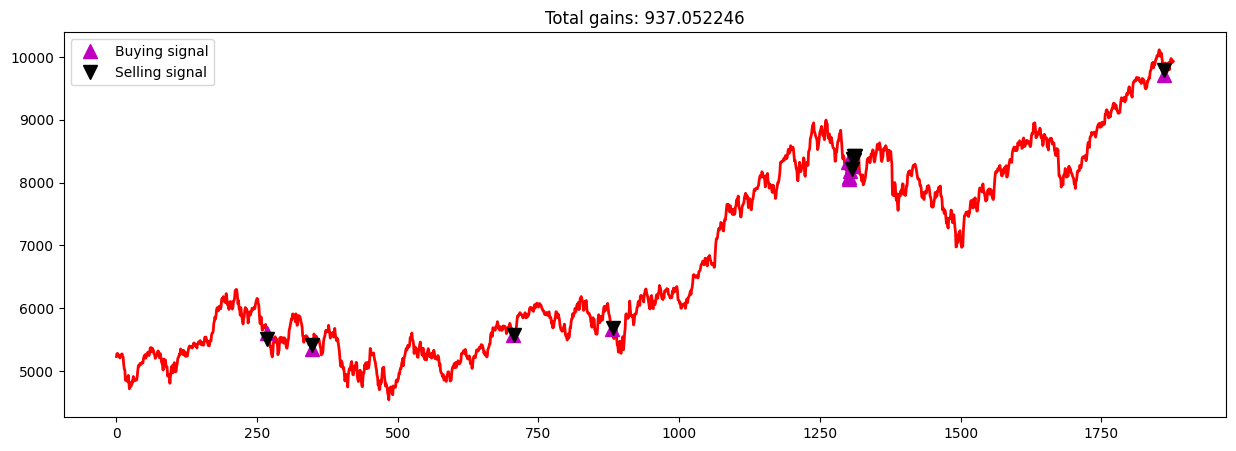

Training in progress...: 100%|██████████| 1878/1878 [07:39<00:00,  4.08it/s]


Running episode 10/10


Training in progress...:   0%|          | 0/1878 [00:00<?, ?it/s]

[[0.         0.12340561 0.73703333]] 2


Training in progress...:   0%|          | 1/1878 [00:00<08:04,  3.87it/s]

[[0.         0.         0.73610976]] 2


Training in progress...:   0%|          | 2/1878 [00:00<07:57,  3.93it/s]

[[0.         0.         0.57901376]] 2


Training in progress...:   0%|          | 3/1878 [00:00<08:24,  3.71it/s]

[[0.       0.       0.556404]] 2


Training in progress...:   0%|          | 4/1878 [00:01<08:15,  3.79it/s]

[[0.         0.         0.59382616]] 2


Training in progress...:   0%|          | 5/1878 [00:01<07:55,  3.94it/s]

[[0.        0.        0.6958964]] 2


Training in progress...:   0%|          | 6/1878 [00:01<07:40,  4.06it/s]

[[0.         0.         0.74047615]] 2


Training in progress...:   0%|          | 7/1878 [00:01<07:29,  4.16it/s]

[[0.         0.         0.76936269]] 2


Training in progress...:   0%|          | 8/1878 [00:02<07:37,  4.08it/s]

[[0.         0.         0.62171372]] 2


Training in progress...:   0%|          | 9/1878 [00:02<07:27,  4.18it/s]

[[0.         0.         0.54784161]] 2


Training in progress...:   1%|          | 10/1878 [00:02<07:21,  4.23it/s]

[[0.         0.         0.55016588]] 2


Training in progress...:   1%|          | 11/1878 [00:02<07:13,  4.31it/s]

[[0.         0.         0.40068095]] 2


Training in progress...:   1%|          | 12/1878 [00:02<07:18,  4.25it/s]

[[0.         0.         0.46189203]] 2


Training in progress...:   1%|          | 13/1878 [00:03<07:26,  4.17it/s]

[[0.         0.         0.49032295]] 2


Training in progress...:   1%|          | 14/1878 [00:03<07:27,  4.16it/s]

[[0.         0.         0.44761298]] 2


Training in progress...:   1%|          | 15/1878 [00:03<07:20,  4.23it/s]

[[0.07347801 0.         0.52118035]] 2


Training in progress...:   1%|          | 16/1878 [00:03<07:13,  4.29it/s]

[[0.        0.        0.3529574]] 2


Training in progress...:   1%|          | 17/1878 [00:04<07:28,  4.15it/s]

[[0.         0.         0.36084864]] 2


Training in progress...:   1%|          | 18/1878 [00:04<07:14,  4.29it/s]

[[0.         0.         0.49517886]] 2


Training in progress...:   1%|          | 19/1878 [00:04<07:10,  4.32it/s]

[[0.         0.         0.53492594]] 2


Training in progress...:   1%|          | 20/1878 [00:04<07:09,  4.33it/s]

[[0.         0.         0.42590325]] 2


Training in progress...:   1%|          | 21/1878 [00:05<07:22,  4.20it/s]

[[0.        0.        0.4804547]] 2


Training in progress...:   1%|          | 22/1878 [00:05<07:35,  4.08it/s]

[[0.         0.         0.65394403]] 2


Training in progress...:   1%|          | 23/1878 [00:05<07:19,  4.22it/s]

[[0.        0.        0.4465389]] 2


Training in progress...:   1%|▏         | 24/1878 [00:05<07:17,  4.24it/s]

[[0.         0.         0.28621718]] 2


Training in progress...:   1%|▏         | 25/1878 [00:06<07:18,  4.22it/s]

[[0.         0.         0.38439549]] 2


Training in progress...:   1%|▏         | 26/1878 [00:06<07:25,  4.15it/s]

[[0.10266843 0.         0.43532824]] 2


Training in progress...:   1%|▏         | 27/1878 [00:06<07:30,  4.11it/s]

[[0.13129454 0.         0.4484362 ]] 2


Training in progress...:   1%|▏         | 28/1878 [00:06<07:25,  4.15it/s]

[[0.18017127 0.         0.38785855]] 2


Training in progress...:   2%|▏         | 29/1878 [00:06<07:21,  4.18it/s]

[[0.06129531 0.         0.44691194]] 2


Training in progress...:   2%|▏         | 30/1878 [00:07<07:22,  4.17it/s]

[[0.11384782 0.         0.43351814]] 2


Training in progress...:   2%|▏         | 31/1878 [00:07<07:27,  4.12it/s]

[[0.1735282  0.         0.43144874]] 2


Training in progress...:   2%|▏         | 32/1878 [00:07<07:12,  4.27it/s]

[[0.03523173 0.         0.56704193]] 2


Training in progress...:   2%|▏         | 33/1878 [00:07<07:12,  4.27it/s]

[[0.04987615 0.         0.66354785]] 2


Training in progress...:   2%|▏         | 34/1878 [00:08<07:19,  4.19it/s]

[[0.        0.        0.7764297]] 2


Training in progress...:   2%|▏         | 35/1878 [00:08<07:21,  4.17it/s]

[[0.         0.         0.64097909]] 2


Training in progress...:   2%|▏         | 36/1878 [00:08<07:18,  4.20it/s]

[[0.         0.         0.56103571]] 2


Training in progress...:   2%|▏         | 37/1878 [00:08<07:16,  4.22it/s]

[[0.         0.         0.36490999]] 2


Training in progress...:   2%|▏         | 38/1878 [00:09<07:18,  4.19it/s]

[[0.         0.         0.20791393]] 2


Training in progress...:   2%|▏         | 39/1878 [00:09<07:18,  4.20it/s]

[[0.         0.         0.35582113]] 2


Training in progress...:   2%|▏         | 40/1878 [00:09<07:12,  4.25it/s]

[[0.         0.         0.41310776]] 2


Training in progress...:   2%|▏         | 41/1878 [00:09<07:02,  4.35it/s]

[[0.         0.         0.78127588]] 2


Training in progress...:   2%|▏         | 42/1878 [00:10<07:12,  4.25it/s]

[[0.         0.         0.80337404]] 2


Training in progress...:   2%|▏         | 43/1878 [00:10<07:20,  4.17it/s]

[[0.         0.         0.76832049]] 2


Training in progress...:   2%|▏         | 44/1878 [00:10<07:23,  4.13it/s]

[[0.         0.         0.72043503]] 2


Training in progress...:   2%|▏         | 45/1878 [00:10<07:19,  4.18it/s]

[[0.         0.         0.58956344]] 2


Training in progress...:   2%|▏         | 46/1878 [00:11<07:32,  4.05it/s]

[[0.         0.         0.43955301]] 2


Training in progress...:   3%|▎         | 47/1878 [00:11<07:55,  3.85it/s]

[[0.         0.         0.41560438]] 2


Training in progress...:   3%|▎         | 48/1878 [00:11<07:55,  3.85it/s]

[[0.         0.         0.46147217]] 2


Training in progress...:   3%|▎         | 49/1878 [00:11<07:39,  3.98it/s]

[[0.         0.         0.49097718]] 2


Training in progress...:   3%|▎         | 50/1878 [00:12<07:23,  4.12it/s]

[[0.        0.        0.3463614]] 2


Training in progress...:   3%|▎         | 51/1878 [00:12<07:34,  4.02it/s]

[[0.         0.         0.44166101]] 2


Training in progress...:   3%|▎         | 52/1878 [00:12<07:13,  4.22it/s]

[[0.         0.         0.56152112]] 2


Training in progress...:   3%|▎         | 53/1878 [00:12<07:18,  4.16it/s]

[[0.         0.         0.64570991]] 2


Training in progress...:   3%|▎         | 54/1878 [00:13<07:23,  4.12it/s]

[[0.         0.         0.52164464]] 2


Training in progress...:   3%|▎         | 55/1878 [00:13<07:49,  3.88it/s]

[[0.         0.         0.58811967]] 2


Training in progress...:   3%|▎         | 56/1878 [00:13<07:51,  3.87it/s]

[[0.       0.       0.586513]] 2


Training in progress...:   3%|▎         | 57/1878 [00:13<07:55,  3.83it/s]

[[0.       0.       0.477837]] 2


Training in progress...:   3%|▎         | 58/1878 [00:14<07:36,  3.99it/s]

[[0.         0.         0.53521097]] 2


Training in progress...:   3%|▎         | 59/1878 [00:14<07:25,  4.08it/s]

[[0.         0.         0.55279455]] 2


Training in progress...:   3%|▎         | 61/1878 [00:14<06:54,  4.38it/s]

[[0.         0.         0.58590417]] 2
[[0.         0.         0.66712832]] 2


Training in progress...:   3%|▎         | 62/1878 [00:14<07:02,  4.30it/s]

[[0.        0.        0.5471285]] 2


Training in progress...:   3%|▎         | 63/1878 [00:15<07:04,  4.28it/s]

[[0.       0.       0.483027]] 2


Training in progress...:   3%|▎         | 64/1878 [00:15<07:23,  4.09it/s]

[[0.         0.         0.36395956]] 2


Training in progress...:   3%|▎         | 65/1878 [00:15<07:20,  4.12it/s]

[[0.         0.         0.58855397]] 2


Training in progress...:   4%|▎         | 66/1878 [00:15<07:33,  3.99it/s]

[[0.         0.         0.65319761]] 2


Training in progress...:   4%|▎         | 67/1878 [00:16<08:04,  3.74it/s]

[[0.       0.       0.692165]] 2


Training in progress...:   4%|▎         | 68/1878 [00:16<07:47,  3.87it/s]

[[0.05537801 0.         0.73783313]] 2


Training in progress...:   4%|▎         | 69/1878 [00:16<07:47,  3.87it/s]

[[0.         0.         0.73899709]] 2


Training in progress...:   4%|▎         | 70/1878 [00:17<07:56,  3.79it/s]

[[0.         0.         0.58533557]] 2


Training in progress...:   4%|▍         | 71/1878 [00:17<08:03,  3.74it/s]

[[0.         0.         0.55996377]] 2


Training in progress...:   4%|▍         | 72/1878 [00:17<07:53,  3.81it/s]

[[0.         0.         0.58239307]] 2


Training in progress...:   4%|▍         | 73/1878 [00:17<07:31,  4.00it/s]

[[0.        0.        0.6371506]] 2


Training in progress...:   4%|▍         | 74/1878 [00:18<07:27,  4.03it/s]

[[0.         0.         0.66230058]] 2


Training in progress...:   4%|▍         | 75/1878 [00:18<07:13,  4.15it/s]

[[0.         0.         0.67756701]] 2


Training in progress...:   4%|▍         | 76/1878 [00:18<07:16,  4.13it/s]

[[0.         0.         0.62160031]] 2


Training in progress...:   4%|▍         | 77/1878 [00:18<07:00,  4.28it/s]

[[0.         0.         0.74512674]] 2


Training in progress...:   4%|▍         | 78/1878 [00:18<06:59,  4.29it/s]

[[0.         0.         0.71089557]] 2


Training in progress...:   4%|▍         | 79/1878 [00:19<07:01,  4.27it/s]

[[0.         0.         0.62686776]] 2


Training in progress...:   4%|▍         | 80/1878 [00:19<07:02,  4.26it/s]

[[0.         0.         0.55643833]] 2


Training in progress...:   4%|▍         | 81/1878 [00:19<06:54,  4.34it/s]

[[0.         0.05334018 0.46283112]] 2


Training in progress...:   4%|▍         | 82/1878 [00:19<06:51,  4.37it/s]

[[0.02643244 0.         0.46310548]] 2


Training in progress...:   4%|▍         | 83/1878 [00:20<06:59,  4.28it/s]

[[0.09787735 0.         0.37475251]] 2


Training in progress...:   4%|▍         | 84/1878 [00:20<07:00,  4.27it/s]

[[0.06118399 0.         0.42571572]] 2


Training in progress...:   5%|▍         | 85/1878 [00:20<07:03,  4.23it/s]

[[0.02224377 0.         0.39160417]] 2


Training in progress...:   5%|▍         | 86/1878 [00:20<06:58,  4.28it/s]

[[0.         0.         0.61758711]] 2


Training in progress...:   5%|▍         | 87/1878 [00:21<06:56,  4.30it/s]

[[0.         0.         0.65895989]] 2


Training in progress...:   5%|▍         | 88/1878 [00:21<07:08,  4.17it/s]

[[0.         0.         0.64322604]] 2


Training in progress...:   5%|▍         | 89/1878 [00:21<07:03,  4.22it/s]

[[0.         0.         0.66631339]] 2


Training in progress...:   5%|▍         | 90/1878 [00:21<07:03,  4.23it/s]

[[0.         0.         0.62273476]] 2


Training in progress...:   5%|▍         | 91/1878 [00:22<07:02,  4.23it/s]

[[0.         0.         0.67293699]] 2


Training in progress...:   5%|▍         | 92/1878 [00:22<07:15,  4.10it/s]

[[0.         0.         0.71990258]] 2


Training in progress...:   5%|▍         | 93/1878 [00:22<07:03,  4.21it/s]

[[0.         0.         0.68585236]] 2


Training in progress...:   5%|▌         | 94/1878 [00:22<06:56,  4.29it/s]

[[0.         0.         0.52326618]] 2


Training in progress...:   5%|▌         | 95/1878 [00:22<06:52,  4.32it/s]

[[0.         0.         0.61777834]] 2


Training in progress...:   5%|▌         | 96/1878 [00:23<06:59,  4.25it/s]

[[0.         0.         0.55918085]] 2


Training in progress...:   5%|▌         | 97/1878 [00:23<07:06,  4.18it/s]

[[0.         0.         0.45145526]] 2


Training in progress...:   5%|▌         | 98/1878 [00:23<06:58,  4.25it/s]

[[0.        0.        0.5701512]] 2


Training in progress...:   5%|▌         | 99/1878 [00:23<06:59,  4.24it/s]

[[0.00090675 0.         0.55695351]] 2


Training in progress...:   5%|▌         | 100/1878 [00:24<07:04,  4.19it/s]

[[0.         0.         0.69567209]] 2


Training in progress...:   5%|▌         | 101/1878 [00:24<07:07,  4.16it/s]

[[0.         0.         0.69106783]] 2


Training in progress...:   5%|▌         | 102/1878 [00:24<07:01,  4.22it/s]

[[0.         0.         0.59462043]] 2


Training in progress...:   5%|▌         | 103/1878 [00:24<07:04,  4.18it/s]

[[0.02117274 0.         0.38795943]] 2


Training in progress...:   6%|▌         | 104/1878 [00:25<07:07,  4.15it/s]

[[0.        0.        0.2590228]] 2


Training in progress...:   6%|▌         | 105/1878 [00:25<07:10,  4.11it/s]

[[0.         0.         0.38730385]] 2


Training in progress...:   6%|▌         | 106/1878 [00:25<07:08,  4.13it/s]

[[0.         0.         0.54662985]] 2


Training in progress...:   6%|▌         | 107/1878 [00:25<07:08,  4.14it/s]

[[0.05463005 0.         0.50772787]] 2


Training in progress...:   6%|▌         | 108/1878 [00:26<07:14,  4.07it/s]

[[0.1101005  0.         0.43062713]] 2


Training in progress...:   6%|▌         | 109/1878 [00:26<07:12,  4.09it/s]

[[0.17101782 0.         0.37390094]] 2


Training in progress...:   6%|▌         | 110/1878 [00:26<07:18,  4.03it/s]

[[0.22361708 0.         0.45105942]] 2


Training in progress...:   6%|▌         | 111/1878 [00:26<07:09,  4.11it/s]

[[0.16495088 0.         0.43451649]] 2


Training in progress...:   6%|▌         | 112/1878 [00:27<07:19,  4.02it/s]

[[0.15456268 0.         0.37486302]] 2


Training in progress...:   6%|▌         | 113/1878 [00:27<07:18,  4.03it/s]

[[0.         0.         0.45259484]] 2


Training in progress...:   6%|▌         | 114/1878 [00:27<07:21,  4.00it/s]

[[0.         0.         0.66969034]] 2


Training in progress...:   6%|▌         | 115/1878 [00:27<07:28,  3.93it/s]

[[0.03410477 0.         0.53085426]] 2


Training in progress...:   6%|▌         | 116/1878 [00:28<07:38,  3.84it/s]

[[0.         0.         0.39819576]] 2


Training in progress...:   6%|▌         | 117/1878 [00:28<07:31,  3.90it/s]

[[0.11770444 0.         0.30022766]] 2


Training in progress...:   6%|▋         | 118/1878 [00:28<07:09,  4.10it/s]

[[0.         0.         0.34630498]] 2


Training in progress...:   6%|▋         | 119/1878 [00:28<07:15,  4.04it/s]

[[0.05471339 0.         0.33161095]] 2


Training in progress...:   6%|▋         | 120/1878 [00:29<07:20,  3.99it/s]

[[0.         0.         0.27815539]] 2


Training in progress...:   6%|▋         | 121/1878 [00:29<07:05,  4.13it/s]

[[0.0315358  0.         0.42309699]] 2


Training in progress...:   6%|▋         | 122/1878 [00:29<06:51,  4.27it/s]

[[0.         0.         0.52394701]] 2


Training in progress...:   7%|▋         | 123/1878 [00:29<07:01,  4.17it/s]

[[0.         0.01906119 0.45682607]] 2


Training in progress...:   7%|▋         | 124/1878 [00:30<07:13,  4.05it/s]

[[0.05124102 0.         0.46113325]] 2


Training in progress...:   7%|▋         | 125/1878 [00:30<07:11,  4.06it/s]

[[0.         0.         0.50528125]] 2


Training in progress...:   7%|▋         | 126/1878 [00:30<06:57,  4.20it/s]

[[0.         0.02027948 0.47594898]] 2


Training in progress...:   7%|▋         | 127/1878 [00:30<06:43,  4.34it/s]

[[0.         0.         0.31976727]] 2


Training in progress...:   7%|▋         | 128/1878 [00:31<07:03,  4.14it/s]

[[0.        0.        0.2385966]] 2


Training in progress...:   7%|▋         | 129/1878 [00:31<07:17,  4.00it/s]

[[0.         0.         0.38386648]] 2


Training in progress...:   7%|▋         | 130/1878 [00:31<07:12,  4.05it/s]

[[0.         0.         0.36430169]] 2


Training in progress...:   7%|▋         | 131/1878 [00:31<07:19,  3.97it/s]

[[0.         0.         0.42726887]] 2


Training in progress...:   7%|▋         | 132/1878 [00:32<07:26,  3.91it/s]

[[0.         0.         0.32899606]] 2


Training in progress...:   7%|▋         | 133/1878 [00:32<07:46,  3.74it/s]

[[0.         0.         0.33344581]] 2


Training in progress...:   7%|▋         | 134/1878 [00:32<07:51,  3.69it/s]

[[0.       0.       0.480235]] 2


Training in progress...:   7%|▋         | 135/1878 [00:32<07:46,  3.74it/s]

[[0.         0.         0.51805468]] 2


Training in progress...:   7%|▋         | 136/1878 [00:33<07:42,  3.76it/s]

[[0.         0.         0.64916437]] 2


Training in progress...:   7%|▋         | 137/1878 [00:33<08:02,  3.60it/s]

[[0.         0.         0.45605392]] 2


Training in progress...:   7%|▋         | 138/1878 [00:33<07:42,  3.76it/s]

[[0.         0.         0.38408431]] 2


Training in progress...:   7%|▋         | 139/1878 [00:33<07:21,  3.94it/s]

[[0.        0.        0.1405624]] 2


Training in progress...:   7%|▋         | 140/1878 [00:34<07:27,  3.88it/s]

[[0.         0.         0.08056892]] 2


Training in progress...:   8%|▊         | 141/1878 [00:34<07:16,  3.98it/s]

[[0.         0.         0.16161605]] 2


Training in progress...:   8%|▊         | 142/1878 [00:34<06:58,  4.14it/s]

[[0.         0.         0.12703493]] 2


Training in progress...:   8%|▊         | 143/1878 [00:34<06:50,  4.22it/s]

[[0.         0.         0.18238117]] 2


Training in progress...:   8%|▊         | 144/1878 [00:35<06:49,  4.24it/s]

[[0.         0.         0.18819223]] 2


Training in progress...:   8%|▊         | 145/1878 [00:35<06:57,  4.15it/s]

[[0.         0.         0.21767578]] 2


Training in progress...:   8%|▊         | 146/1878 [00:35<06:47,  4.25it/s]

[[0.         0.         0.21199072]] 2


Training in progress...:   8%|▊         | 147/1878 [00:35<06:44,  4.28it/s]

[[0.         0.         0.30941772]] 2


Training in progress...:   8%|▊         | 148/1878 [00:36<06:46,  4.25it/s]

[[0.        0.        0.3473242]] 2


Training in progress...:   8%|▊         | 149/1878 [00:36<06:54,  4.17it/s]

[[0.         0.         0.20655761]] 2


Training in progress...:   8%|▊         | 150/1878 [00:36<06:51,  4.20it/s]

[[0.         0.         0.23477874]] 2


Training in progress...:   8%|▊         | 151/1878 [00:36<06:47,  4.24it/s]

[[0.         0.         0.33853059]] 2


Training in progress...:   8%|▊         | 152/1878 [00:36<06:51,  4.19it/s]

[[0.         0.1383897  0.18417251]] 2


Training in progress...:   8%|▊         | 153/1878 [00:37<07:00,  4.10it/s]

[[0.         0.         0.20447219]] 2


Training in progress...:   8%|▊         | 154/1878 [00:37<07:03,  4.07it/s]

[[0.         0.         0.19123446]] 2


Training in progress...:   8%|▊         | 155/1878 [00:37<06:53,  4.16it/s]

[[0.         0.         0.23762684]] 2


Training in progress...:   8%|▊         | 156/1878 [00:37<06:43,  4.27it/s]

[[0.         0.         0.33904608]] 2


Training in progress...:   8%|▊         | 157/1878 [00:38<06:44,  4.25it/s]

[[0.         0.         0.38189091]] 2


Training in progress...:   8%|▊         | 158/1878 [00:38<06:49,  4.20it/s]

[[0.         0.         0.22238214]] 2


Training in progress...:   8%|▊         | 159/1878 [00:38<06:52,  4.16it/s]

[[0.         0.         0.19739977]] 2


Training in progress...:   9%|▊         | 160/1878 [00:38<06:48,  4.21it/s]

[[0.         0.         0.32279157]] 2


Training in progress...:   9%|▊         | 161/1878 [00:39<06:54,  4.14it/s]

[[0.        0.        0.4055325]] 2


Training in progress...:   9%|▊         | 162/1878 [00:39<07:00,  4.08it/s]

[[0.         0.         0.40850744]] 2


Training in progress...:   9%|▊         | 163/1878 [00:39<06:48,  4.19it/s]

[[0.         0.         0.38778335]] 2


Training in progress...:   9%|▊         | 164/1878 [00:39<06:41,  4.27it/s]

[[0.         0.         0.57616442]] 2


Training in progress...:   9%|▉         | 165/1878 [00:40<06:50,  4.18it/s]

[[0.         0.         0.56885065]] 2


Training in progress...:   9%|▉         | 166/1878 [00:40<06:49,  4.18it/s]

[[0.04713921 0.         0.42253667]] 2


Training in progress...:   9%|▉         | 167/1878 [00:40<06:51,  4.16it/s]

[[0.         0.         0.55709666]] 2


Training in progress...:   9%|▉         | 168/1878 [00:40<06:50,  4.17it/s]

[[0.        0.        0.5871847]] 2


Training in progress...:   9%|▉         | 169/1878 [00:41<06:50,  4.16it/s]

[[0.         0.         0.41942984]] 2


Training in progress...:   9%|▉         | 170/1878 [00:41<06:56,  4.10it/s]

[[0.         0.         0.44873487]] 2


Training in progress...:   9%|▉         | 171/1878 [00:41<06:56,  4.10it/s]

[[0.         0.         0.54628233]] 2


Training in progress...:   9%|▉         | 172/1878 [00:41<06:43,  4.22it/s]

[[0.         0.         0.58234996]] 2


Training in progress...:   9%|▉         | 173/1878 [00:42<06:48,  4.18it/s]

[[0.01115608 0.         0.66361311]] 2


Training in progress...:   9%|▉         | 174/1878 [00:42<06:50,  4.15it/s]

[[0.03438325 0.         0.59503942]] 2


Training in progress...:   9%|▉         | 175/1878 [00:42<06:44,  4.21it/s]

[[0.         0.         0.44946649]] 2


Training in progress...:   9%|▉         | 176/1878 [00:42<06:41,  4.24it/s]

[[0.11660551 0.         0.42860238]] 2


Training in progress...:   9%|▉         | 177/1878 [00:42<06:45,  4.19it/s]

[[0.         0.         0.62961804]] 2


Training in progress...:   9%|▉         | 178/1878 [00:43<06:50,  4.14it/s]

[[0.        0.        0.6769581]] 2


Training in progress...:  10%|▉         | 179/1878 [00:43<06:51,  4.13it/s]

[[0.         0.         0.59327183]] 2


Training in progress...:  10%|▉         | 180/1878 [00:43<07:05,  3.99it/s]

[[0.         0.         0.67539554]] 2


Training in progress...:  10%|▉         | 181/1878 [00:44<07:22,  3.84it/s]

[[0.         0.         0.63665128]] 2


Training in progress...:  10%|▉         | 182/1878 [00:44<07:26,  3.80it/s]

[[0.         0.         0.75813087]] 2


Training in progress...:  10%|▉         | 183/1878 [00:44<06:58,  4.05it/s]

[[0.         0.         0.67750284]] 2


Training in progress...:  10%|▉         | 184/1878 [00:44<06:39,  4.24it/s]

[[0.         0.         0.40507164]] 2


Training in progress...:  10%|▉         | 185/1878 [00:44<06:35,  4.28it/s]

[[0.       0.       0.297093]] 2


Training in progress...:  10%|▉         | 186/1878 [00:45<06:49,  4.13it/s]

[[0.00155641 0.         0.2347472 ]] 2


Training in progress...:  10%|▉         | 187/1878 [00:45<07:02,  4.00it/s]

[[0.         0.         0.02684144]] 2


Training in progress...:  10%|█         | 188/1878 [00:45<06:59,  4.03it/s]

[[0.         0.         0.11120637]] 2


Training in progress...:  10%|█         | 189/1878 [00:46<07:15,  3.88it/s]

[[0. 0. 0.]] 0


Training in progress...:  10%|█         | 190/1878 [00:46<07:24,  3.80it/s]

[[0.       0.       0.026394]] 2


Training in progress...:  10%|█         | 191/1878 [00:46<07:14,  3.88it/s]

[[0.        0.        0.1338643]] 2


Training in progress...:  10%|█         | 192/1878 [00:46<06:57,  4.03it/s]

[[0.        0.        0.2745335]] 2


Training in progress...:  10%|█         | 193/1878 [00:46<06:54,  4.06it/s]

[[0.         0.         0.45664025]] 2


Training in progress...:  10%|█         | 194/1878 [00:47<06:47,  4.14it/s]

[[0.         0.         0.42182301]] 2


Training in progress...:  10%|█         | 195/1878 [00:47<06:39,  4.22it/s]

[[0.         0.         0.24363091]] 2


Training in progress...:  10%|█         | 196/1878 [00:47<06:30,  4.31it/s]

[[0.         0.         0.24231717]] 2


Training in progress...:  10%|█         | 197/1878 [00:47<06:22,  4.39it/s]

[[0.         0.         0.22660144]] 2


Training in progress...:  11%|█         | 198/1878 [00:48<06:54,  4.06it/s]

[[0.         0.         0.13459639]] 2


Training in progress...:  11%|█         | 199/1878 [00:48<07:03,  3.96it/s]

[[0.         0.         0.27514864]] 2


Training in progress...:  11%|█         | 200/1878 [00:48<07:08,  3.91it/s]

[[0.02540187 0.         0.27978032]] 2


Training in progress...:  11%|█         | 201/1878 [00:48<07:04,  3.95it/s]

[[0.         0.         0.23859984]] 2


Training in progress...:  11%|█         | 202/1878 [00:49<07:11,  3.89it/s]

[[0.03133448 0.         0.35407599]] 2


Training in progress...:  11%|█         | 203/1878 [00:49<07:13,  3.87it/s]

[[0.         0.         0.34526014]] 2


Training in progress...:  11%|█         | 204/1878 [00:49<06:52,  4.06it/s]

[[0.         0.         0.35216572]] 2


Training in progress...:  11%|█         | 205/1878 [00:49<06:50,  4.07it/s]

[[0.         0.01347793 0.36131637]] 2


Training in progress...:  11%|█         | 206/1878 [00:50<07:18,  3.81it/s]

[[0.         0.05223351 0.39826177]] 2


Training in progress...:  11%|█         | 207/1878 [00:50<07:35,  3.67it/s]

[[0.         0.11646461 0.48832899]] 2


Training in progress...:  11%|█         | 208/1878 [00:50<07:08,  3.90it/s]

[[0.         0.         0.56491907]] 2


Training in progress...:  11%|█         | 209/1878 [00:50<06:53,  4.04it/s]

[[0.         0.         0.73204789]] 2


Training in progress...:  11%|█         | 210/1878 [00:51<06:47,  4.10it/s]

[[0.         0.         0.78487933]] 2


Training in progress...:  11%|█         | 211/1878 [00:51<06:44,  4.12it/s]

[[0.09836156 0.         0.88211093]] 2


Training in progress...:  11%|█▏        | 212/1878 [00:51<06:30,  4.26it/s]

[[0.02831627 0.         0.65215774]] 2


Training in progress...:  11%|█▏        | 213/1878 [00:51<06:27,  4.30it/s]

[[0.         0.         0.54015838]] 2


Training in progress...:  11%|█▏        | 214/1878 [00:52<06:33,  4.23it/s]

[[0.         0.         0.71484008]] 2


Training in progress...:  11%|█▏        | 215/1878 [00:52<06:37,  4.19it/s]

[[0.         0.         0.56349087]] 2


Training in progress...:  12%|█▏        | 216/1878 [00:52<06:30,  4.26it/s]

[[0.         0.         0.60546596]] 2


Training in progress...:  12%|█▏        | 217/1878 [00:52<06:31,  4.24it/s]

[[0.         0.         0.61307221]] 2


Training in progress...:  12%|█▏        | 218/1878 [00:53<06:32,  4.23it/s]

[[0.         0.         0.55236312]] 2


Training in progress...:  12%|█▏        | 219/1878 [00:53<06:36,  4.19it/s]

[[0.         0.         0.57523991]] 2


Training in progress...:  12%|█▏        | 220/1878 [00:53<06:44,  4.10it/s]

[[0.         0.         0.59133301]] 2


Training in progress...:  12%|█▏        | 221/1878 [00:53<06:41,  4.12it/s]

[[0.        0.        0.3718265]] 2


Training in progress...:  12%|█▏        | 222/1878 [00:54<06:43,  4.10it/s]

[[0.         0.         0.39942052]] 2


Training in progress...:  12%|█▏        | 223/1878 [00:54<06:41,  4.12it/s]

[[0.         0.         0.26427812]] 2


Training in progress...:  12%|█▏        | 224/1878 [00:54<06:38,  4.15it/s]

[[0.         0.         0.16402254]] 2


Training in progress...:  12%|█▏        | 225/1878 [00:54<06:32,  4.21it/s]

[[0.         0.         0.26131372]] 2


Training in progress...:  12%|█▏        | 226/1878 [00:55<06:31,  4.22it/s]

[[0.         0.         0.40632529]] 2


Training in progress...:  12%|█▏        | 227/1878 [00:55<06:33,  4.20it/s]

[[0.         0.         0.37981363]] 2


Training in progress...:  12%|█▏        | 228/1878 [00:55<06:27,  4.25it/s]

[[0.         0.         0.48768283]] 2


Training in progress...:  12%|█▏        | 229/1878 [00:55<06:23,  4.30it/s]

[[0.         0.         0.44796112]] 2


Training in progress...:  12%|█▏        | 230/1878 [00:55<06:24,  4.29it/s]

[[0.         0.         0.49451951]] 2


Training in progress...:  12%|█▏        | 231/1878 [00:56<06:31,  4.21it/s]

[[0.         0.         0.67280667]] 2


Training in progress...:  12%|█▏        | 232/1878 [00:56<06:33,  4.18it/s]

[[0.         0.         0.53554051]] 2


Training in progress...:  12%|█▏        | 233/1878 [00:56<06:39,  4.12it/s]

[[0.        0.        0.5641393]] 2


Training in progress...:  12%|█▏        | 234/1878 [00:56<06:31,  4.20it/s]

[[0.         0.         0.70480196]] 2


Training in progress...:  13%|█▎        | 235/1878 [00:57<06:38,  4.13it/s]

[[0.       0.       0.767655]] 2


Training in progress...:  13%|█▎        | 236/1878 [00:57<06:45,  4.05it/s]

[[0.         0.08460629 0.72415227]] 2


Training in progress...:  13%|█▎        | 237/1878 [00:57<06:36,  4.14it/s]

[[0.         0.00483038 0.9736556 ]] 2


Training in progress...:  13%|█▎        | 238/1878 [00:57<06:26,  4.24it/s]

[[0.         0.         0.82426589]] 2


Training in progress...:  13%|█▎        | 239/1878 [00:58<06:31,  4.18it/s]

[[0.         0.01592586 0.76687393]] 2


Training in progress...:  13%|█▎        | 240/1878 [00:58<06:31,  4.18it/s]

[[0.         0.         0.81652711]] 2


Training in progress...:  13%|█▎        | 241/1878 [00:58<06:25,  4.25it/s]

[[0.        0.        0.5582696]] 2


Training in progress...:  13%|█▎        | 242/1878 [00:58<06:27,  4.22it/s]

[[0.         0.         0.59539625]] 2


Training in progress...:  13%|█▎        | 243/1878 [00:59<06:41,  4.08it/s]

[[0.         0.         0.44834027]] 2


Training in progress...:  13%|█▎        | 244/1878 [00:59<06:43,  4.05it/s]

[[0.         0.         0.40932242]] 2


Training in progress...:  13%|█▎        | 245/1878 [00:59<06:29,  4.19it/s]

[[0.         0.         0.35587089]] 2


Training in progress...:  13%|█▎        | 246/1878 [00:59<06:37,  4.11it/s]

[[0.05254991 0.         0.35231098]] 2


Training in progress...:  13%|█▎        | 247/1878 [01:00<06:36,  4.12it/s]

[[0.        0.        0.4482261]] 2


Training in progress...:  13%|█▎        | 248/1878 [01:00<06:35,  4.12it/s]

[[0.08389991 0.         0.39288472]] 2


Training in progress...:  13%|█▎        | 249/1878 [01:00<06:32,  4.16it/s]

[[0.06117496 0.         0.34140913]] 2


Training in progress...:  13%|█▎        | 250/1878 [01:00<06:34,  4.12it/s]

[[0.05767521 0.         0.4385456 ]] 2


Training in progress...:  13%|█▎        | 251/1878 [01:01<06:52,  3.95it/s]

[[0.         0.         0.53335764]] 2


Training in progress...:  13%|█▎        | 252/1878 [01:01<06:50,  3.96it/s]

[[0.         0.         0.44030123]] 2


Training in progress...:  13%|█▎        | 253/1878 [01:01<06:44,  4.02it/s]

[[0.         0.         0.35194491]] 2


Training in progress...:  14%|█▎        | 254/1878 [01:01<06:51,  3.95it/s]

[[0.         0.         0.42696566]] 2


Training in progress...:  14%|█▎        | 255/1878 [01:02<06:43,  4.03it/s]

[[0.         0.         0.43320525]] 2


Training in progress...:  14%|█▎        | 256/1878 [01:02<06:46,  3.99it/s]

[[0.         0.         0.60275311]] 2


Training in progress...:  14%|█▎        | 257/1878 [01:02<06:43,  4.02it/s]

[[0.         0.         0.57283458]] 2


Training in progress...:  14%|█▎        | 258/1878 [01:02<06:46,  3.99it/s]

[[0.         0.         0.68020514]] 2


Training in progress...:  14%|█▍        | 259/1878 [01:03<06:52,  3.93it/s]

[[0.         0.         0.75164544]] 2


Training in progress...:  14%|█▍        | 260/1878 [01:03<06:57,  3.88it/s]

[[0.         0.         0.81130373]] 2


Training in progress...:  14%|█▍        | 261/1878 [01:03<06:59,  3.85it/s]

[[0.         0.         0.77530167]] 2


Training in progress...:  14%|█▍        | 262/1878 [01:03<06:53,  3.91it/s]

[[0.         0.00127723 0.7896003 ]] 2


Training in progress...:  14%|█▍        | 263/1878 [01:04<06:45,  3.98it/s]

[[0.         0.         0.62697288]] 2


Training in progress...:  14%|█▍        | 264/1878 [01:04<06:47,  3.96it/s]

[[0.         0.         0.56749179]] 2


Training in progress...:  14%|█▍        | 265/1878 [01:04<06:24,  4.19it/s]

[[0.         0.         0.61648787]] 2


Training in progress...:  14%|█▍        | 266/1878 [01:04<06:16,  4.28it/s]

[[0.         0.         0.59193974]] 2


Training in progress...:  14%|█▍        | 267/1878 [01:05<06:49,  3.93it/s]

[[0.00648325 0.         0.38195592]] 2


Training in progress...:  14%|█▍        | 268/1878 [01:05<06:51,  3.92it/s]

[[0.         0.         0.24665635]] 2


Training in progress...:  14%|█▍        | 269/1878 [01:05<06:44,  3.98it/s]

[[0.         0.         0.30824315]] 2


Training in progress...:  14%|█▍        | 270/1878 [01:05<06:42,  4.00it/s]

[[0.         0.         0.26269044]] 2


Training in progress...:  14%|█▍        | 271/1878 [01:06<06:42,  3.99it/s]

[[0.         0.         0.23217651]] 2


Training in progress...:  14%|█▍        | 272/1878 [01:06<06:47,  3.95it/s]

[[0.07338186 0.         0.34941124]] 2


Training in progress...:  15%|█▍        | 273/1878 [01:06<06:59,  3.83it/s]

[[0.01944106 0.         0.35857855]] 2


Training in progress...:  15%|█▍        | 274/1878 [01:06<06:58,  3.84it/s]

[[0.01170693 0.         0.51399462]] 2


Training in progress...:  15%|█▍        | 275/1878 [01:07<06:46,  3.94it/s]

[[0.01712577 0.         0.46250714]] 2


Training in progress...:  15%|█▍        | 276/1878 [01:07<06:46,  3.94it/s]

[[0.         0.         0.33803166]] 2


Training in progress...:  15%|█▍        | 277/1878 [01:07<06:35,  4.05it/s]

[[0.         0.         0.23394461]] 2


Training in progress...:  15%|█▍        | 278/1878 [01:07<06:24,  4.16it/s]

[[0.         0.         0.19976464]] 2


Training in progress...:  15%|█▍        | 279/1878 [01:08<06:18,  4.22it/s]

[[0.         0.         0.32401966]] 2


Training in progress...:  15%|█▍        | 280/1878 [01:08<06:25,  4.15it/s]

[[0.         0.         0.44221974]] 2


Training in progress...:  15%|█▍        | 281/1878 [01:08<06:26,  4.13it/s]

[[0.         0.         0.44309654]] 2


Training in progress...:  15%|█▌        | 282/1878 [01:08<06:22,  4.17it/s]

[[0.         0.         0.50121809]] 2


Training in progress...:  15%|█▌        | 283/1878 [01:09<06:18,  4.22it/s]

[[0.         0.         0.63336808]] 2


Training in progress...:  15%|█▌        | 284/1878 [01:09<06:17,  4.22it/s]

[[0.         0.         0.42826201]] 2


Training in progress...:  15%|█▌        | 285/1878 [01:09<06:26,  4.12it/s]

[[0.         0.         0.47965376]] 2


Training in progress...:  15%|█▌        | 286/1878 [01:09<06:12,  4.27it/s]

[[0.         0.         0.42707104]] 2


Training in progress...:  15%|█▌        | 287/1878 [01:09<06:14,  4.25it/s]

[[0.         0.         0.40985923]] 2


Training in progress...:  15%|█▌        | 288/1878 [01:10<06:17,  4.21it/s]

[[0.         0.         0.50953034]] 2


Training in progress...:  15%|█▌        | 289/1878 [01:10<06:14,  4.24it/s]

[[0.         0.         0.55418951]] 2


Training in progress...:  15%|█▌        | 290/1878 [01:10<06:09,  4.29it/s]

[[0.         0.         0.52226525]] 2


Training in progress...:  15%|█▌        | 291/1878 [01:10<06:07,  4.32it/s]

[[0.       0.       0.505231]] 2


Training in progress...:  16%|█▌        | 292/1878 [01:11<06:16,  4.21it/s]

[[0.         0.         0.46009209]] 2


Training in progress...:  16%|█▌        | 293/1878 [01:11<06:22,  4.14it/s]

[[0.        0.        0.5446399]] 2


Training in progress...:  16%|█▌        | 294/1878 [01:11<06:27,  4.08it/s]

[[0.         0.         0.62401969]] 2


Training in progress...:  16%|█▌        | 295/1878 [01:11<06:19,  4.17it/s]

[[0.        0.        0.7609921]] 2


Training in progress...:  16%|█▌        | 296/1878 [01:12<06:19,  4.17it/s]

[[0.         0.         0.69802387]] 2


Training in progress...:  16%|█▌        | 297/1878 [01:12<06:18,  4.17it/s]

[[0.         0.         0.77739322]] 2


Training in progress...:  16%|█▌        | 298/1878 [01:12<06:25,  4.10it/s]

[[0.         0.         0.67398655]] 2


Training in progress...:  16%|█▌        | 299/1878 [01:12<06:29,  4.05it/s]

[[0.         0.         0.55234809]] 2


Training in progress...:  16%|█▌        | 300/1878 [01:13<06:30,  4.04it/s]

[[0.         0.         0.58090778]] 2


Training in progress...:  16%|█▌        | 301/1878 [01:13<06:26,  4.08it/s]

[[0.         0.         0.69911015]] 2


Training in progress...:  16%|█▌        | 302/1878 [01:13<06:11,  4.24it/s]

[[0.         0.         0.58529616]] 2


Training in progress...:  16%|█▌        | 303/1878 [01:13<06:17,  4.17it/s]

[[0.         0.         0.57591109]] 2


Training in progress...:  16%|█▌        | 304/1878 [01:14<06:15,  4.19it/s]

[[0.         0.         0.59660122]] 2


Training in progress...:  16%|█▌        | 305/1878 [01:14<06:20,  4.14it/s]

[[0.         0.         0.62633443]] 2


Training in progress...:  16%|█▋        | 306/1878 [01:14<06:10,  4.24it/s]

[[0.         0.         0.42381586]] 2


Training in progress...:  16%|█▋        | 307/1878 [01:14<06:07,  4.28it/s]

[[0.         0.         0.27627534]] 2


Training in progress...:  16%|█▋        | 308/1878 [01:14<06:06,  4.28it/s]

[[0.         0.         0.18577118]] 2


Training in progress...:  16%|█▋        | 309/1878 [01:15<06:08,  4.26it/s]

[[0.         0.         0.54499344]] 2


Training in progress...:  17%|█▋        | 310/1878 [01:15<06:06,  4.28it/s]

[[0.        0.        0.5782743]] 2


Training in progress...:  17%|█▋        | 311/1878 [01:15<06:03,  4.31it/s]

[[0.         0.         0.58207334]] 2


Training in progress...:  17%|█▋        | 312/1878 [01:15<06:07,  4.26it/s]

[[0.         0.         0.72515179]] 2


Training in progress...:  17%|█▋        | 313/1878 [01:16<06:12,  4.20it/s]

[[0.         0.         0.83045485]] 2


Training in progress...:  17%|█▋        | 314/1878 [01:16<06:11,  4.21it/s]

[[0.         0.         0.79599237]] 2


Training in progress...:  17%|█▋        | 315/1878 [01:16<06:07,  4.25it/s]

[[0.         0.         0.70859068]] 2


Training in progress...:  17%|█▋        | 316/1878 [01:16<06:14,  4.17it/s]

[[0.         0.         0.56844556]] 2


Training in progress...:  17%|█▋        | 317/1878 [01:17<06:21,  4.09it/s]

[[0.         0.         0.49947357]] 2


Training in progress...:  17%|█▋        | 318/1878 [01:17<06:39,  3.91it/s]

[[0.         0.         0.59755058]] 2


Training in progress...:  17%|█▋        | 319/1878 [01:17<06:45,  3.84it/s]

[[0.         0.         0.56794589]] 2


Training in progress...:  17%|█▋        | 320/1878 [01:17<06:39,  3.90it/s]

[[0.         0.         0.43315185]] 2


Training in progress...:  17%|█▋        | 321/1878 [01:18<06:45,  3.84it/s]

[[0.         0.         0.31097381]] 2


Training in progress...:  17%|█▋        | 322/1878 [01:18<06:50,  3.79it/s]

[[0.         0.         0.30323103]] 2


Training in progress...:  17%|█▋        | 323/1878 [01:18<06:38,  3.90it/s]

[[0.         0.         0.28061469]] 2


Training in progress...:  17%|█▋        | 324/1878 [01:18<06:39,  3.89it/s]

[[0.         0.         0.23873592]] 2


Training in progress...:  17%|█▋        | 325/1878 [01:19<06:42,  3.85it/s]

[[0.26771839 0.         0.34894282]] 2


Training in progress...:  17%|█▋        | 326/1878 [01:19<06:46,  3.82it/s]

[[0.15325799 0.         0.47644355]] 2


Training in progress...:  17%|█▋        | 327/1878 [01:19<06:31,  3.96it/s]

[[0.23230885 0.         0.47631451]] 2


Training in progress...:  17%|█▋        | 328/1878 [01:19<06:27,  4.00it/s]

[[0.32943265 0.         0.48956232]] 2


Training in progress...:  18%|█▊        | 329/1878 [01:20<06:21,  4.06it/s]

[[0.36700408 0.         0.45567108]] 2


Training in progress...:  18%|█▊        | 330/1878 [01:20<06:31,  3.95it/s]

[[0.36920246 0.         0.30393027]] 0


Training in progress...:  18%|█▊        | 331/1878 [01:20<06:27,  3.99it/s]

[[0.24304802 0.         0.45792652]] 2


Training in progress...:  18%|█▊        | 332/1878 [01:20<06:19,  4.07it/s]

[[0.27220949 0.         0.50091775]] 2


Training in progress...:  18%|█▊        | 333/1878 [01:21<06:21,  4.05it/s]

[[0.17081325 0.03578331 0.57672263]] 2


Training in progress...:  18%|█▊        | 334/1878 [01:21<06:21,  4.05it/s]

[[0.13722592 0.11558357 0.45841363]] 2


Training in progress...:  18%|█▊        | 335/1878 [01:21<06:10,  4.17it/s]

[[0.16281101 0.         0.54689712]] 2


Training in progress...:  18%|█▊        | 336/1878 [01:21<06:20,  4.05it/s]

[[0.04833458 0.00477599 0.50668481]] 2


Training in progress...:  18%|█▊        | 337/1878 [01:22<06:18,  4.07it/s]

[[0.04289484 0.         0.46335134]] 2


Training in progress...:  18%|█▊        | 338/1878 [01:22<06:31,  3.94it/s]

[[0.08880449 0.         0.54244997]] 2


Training in progress...:  18%|█▊        | 339/1878 [01:22<06:31,  3.93it/s]

[[0.20665481 0.         0.48035989]] 2


Training in progress...:  18%|█▊        | 340/1878 [01:22<06:31,  3.93it/s]

[[0.19975974 0.         0.53868189]] 2


Training in progress...:  18%|█▊        | 341/1878 [01:23<06:47,  3.77it/s]

[[0.16686522 0.         0.43754967]] 2


Training in progress...:  18%|█▊        | 342/1878 [01:23<07:03,  3.63it/s]

[[0.15183343 0.         0.3954692 ]] 2


Training in progress...:  18%|█▊        | 343/1878 [01:23<06:44,  3.79it/s]

[[0.         0.         0.37664083]] 2


Training in progress...:  18%|█▊        | 344/1878 [01:24<06:29,  3.94it/s]

[[0.         0.         0.47865766]] 2


Training in progress...:  18%|█▊        | 345/1878 [01:24<06:18,  4.05it/s]

[[0.         0.         0.24912871]] 2


Training in progress...:  18%|█▊        | 346/1878 [01:24<06:16,  4.07it/s]

[[0.         0.         0.34411521]] 2


Training in progress...:  18%|█▊        | 347/1878 [01:24<06:01,  4.23it/s]

[[0.        0.        0.5123385]] 2


Training in progress...:  19%|█▊        | 348/1878 [01:24<05:58,  4.27it/s]

[[0.         0.         0.41785039]] 2


Training in progress...:  19%|█▊        | 349/1878 [01:25<05:56,  4.28it/s]

[[0.         0.         0.58127314]] 2


Training in progress...:  19%|█▊        | 350/1878 [01:25<05:58,  4.26it/s]

[[0.         0.         0.57361975]] 2


Training in progress...:  19%|█▊        | 351/1878 [01:25<05:53,  4.32it/s]

[[0.         0.         0.47709014]] 2


Training in progress...:  19%|█▊        | 352/1878 [01:25<05:52,  4.33it/s]

[[0.         0.         0.59287368]] 2


Training in progress...:  19%|█▉        | 353/1878 [01:26<05:50,  4.35it/s]

[[0.         0.         0.42327952]] 2


Training in progress...:  19%|█▉        | 354/1878 [01:26<05:46,  4.40it/s]

[[0.         0.         0.37870055]] 2


Training in progress...:  19%|█▉        | 355/1878 [01:26<05:53,  4.31it/s]

[[0.         0.         0.23768225]] 2


Training in progress...:  19%|█▉        | 356/1878 [01:26<05:46,  4.39it/s]

[[0.         0.         0.41897001]] 2


Training in progress...:  19%|█▉        | 357/1878 [01:27<05:47,  4.37it/s]

[[0.         0.         0.54773779]] 2


Training in progress...:  19%|█▉        | 358/1878 [01:27<05:55,  4.28it/s]

[[0.         0.         0.53675598]] 2


Training in progress...:  19%|█▉        | 359/1878 [01:27<06:05,  4.16it/s]

[[0.         0.         0.38525109]] 2


Training in progress...:  19%|█▉        | 360/1878 [01:27<05:56,  4.25it/s]

[[0.05626681 0.         0.53161915]] 2


Training in progress...:  19%|█▉        | 361/1878 [01:27<05:57,  4.24it/s]

[[0.         0.         0.60219081]] 2


Training in progress...:  19%|█▉        | 362/1878 [01:28<06:00,  4.20it/s]

[[0.         0.         0.57765678]] 2


Training in progress...:  19%|█▉        | 363/1878 [01:28<05:58,  4.22it/s]

[[0.         0.         0.76387595]] 2


Training in progress...:  19%|█▉        | 364/1878 [01:28<05:57,  4.23it/s]

[[0.         0.         0.80332378]] 2


Training in progress...:  19%|█▉        | 365/1878 [01:28<05:53,  4.27it/s]

[[0.         0.         0.68774805]] 2


Training in progress...:  19%|█▉        | 366/1878 [01:29<06:02,  4.17it/s]

[[0.11183103 0.         0.63620789]] 2


Training in progress...:  20%|█▉        | 367/1878 [01:29<06:04,  4.14it/s]

[[0.        0.        0.5365034]] 2


Training in progress...:  20%|█▉        | 368/1878 [01:29<06:00,  4.19it/s]

[[0.         0.         0.51545905]] 2


Training in progress...:  20%|█▉        | 369/1878 [01:29<05:53,  4.27it/s]

[[0.         0.         0.64047397]] 2


Training in progress...:  20%|█▉        | 370/1878 [01:30<05:51,  4.29it/s]

[[0.         0.         0.34517785]] 2


Training in progress...:  20%|█▉        | 371/1878 [01:30<05:46,  4.35it/s]

[[0.19527331 0.         0.43147463]] 2


Training in progress...:  20%|█▉        | 372/1878 [01:30<05:42,  4.40it/s]

[[0.         0.         0.54952622]] 2


Training in progress...:  20%|█▉        | 373/1878 [01:30<05:44,  4.37it/s]

[[0.02641715 0.         0.46672047]] 2


Training in progress...:  20%|█▉        | 374/1878 [01:31<05:52,  4.27it/s]

[[0.10683828 0.         0.61859791]] 2


Training in progress...:  20%|█▉        | 375/1878 [01:31<05:57,  4.21it/s]

[[0.         0.         0.58843368]] 2


Training in progress...:  20%|██        | 376/1878 [01:31<05:55,  4.22it/s]

[[0.         0.         0.49126684]] 2


Training in progress...:  20%|██        | 377/1878 [01:31<05:51,  4.27it/s]

[[0.         0.         0.58253128]] 2


Training in progress...:  20%|██        | 378/1878 [01:31<05:49,  4.29it/s]

[[0.08058199 0.         0.56258639]] 2


Training in progress...:  20%|██        | 379/1878 [01:32<05:49,  4.29it/s]

[[0.23886666 0.         0.39672116]] 2


Training in progress...:  20%|██        | 380/1878 [01:32<05:56,  4.21it/s]

[[0.02789944 0.         0.23840173]] 2


Training in progress...:  20%|██        | 381/1878 [01:32<05:56,  4.20it/s]

[[0.08374331 0.         0.26280069]] 2


Training in progress...:  20%|██        | 382/1878 [01:32<05:50,  4.27it/s]

[[0.11326281 0.         0.3030057 ]] 2


Training in progress...:  20%|██        | 383/1878 [01:33<05:49,  4.28it/s]

[[0.01451692 0.         0.26894228]] 2


Training in progress...:  20%|██        | 384/1878 [01:33<05:45,  4.33it/s]

[[0.05437389 0.         0.27507817]] 2


Training in progress...:  21%|██        | 385/1878 [01:33<05:47,  4.30it/s]

[[0.02497987 0.         0.2594088 ]] 2


Training in progress...:  21%|██        | 386/1878 [01:33<06:04,  4.10it/s]

[[0.06454883 0.         0.51697276]] 2


Training in progress...:  21%|██        | 387/1878 [01:34<06:09,  4.04it/s]

[[0.         0.         0.46079447]] 2


Training in progress...:  21%|██        | 388/1878 [01:34<06:08,  4.04it/s]

[[0.12275376 0.         0.58146234]] 2


Training in progress...:  21%|██        | 389/1878 [01:34<06:05,  4.08it/s]

[[0.         0.         0.64310235]] 2


Training in progress...:  21%|██        | 390/1878 [01:34<06:11,  4.01it/s]

[[0.         0.         0.47014741]] 2


Training in progress...:  21%|██        | 391/1878 [01:35<06:27,  3.84it/s]

[[0.         0.         0.22664305]] 2


Training in progress...:  21%|██        | 392/1878 [01:35<06:28,  3.82it/s]

[[0.         0.         0.21660426]] 2


Training in progress...:  21%|██        | 393/1878 [01:35<06:27,  3.83it/s]

[[0.         0.         0.29072958]] 2


Training in progress...:  21%|██        | 394/1878 [01:35<06:37,  3.74it/s]

[[0.         0.         0.46968497]] 2


Training in progress...:  21%|██        | 395/1878 [01:36<06:42,  3.68it/s]

[[0.00616908 0.         0.29619199]] 2


Training in progress...:  21%|██        | 396/1878 [01:36<06:34,  3.76it/s]

[[0.         0.         0.28568341]] 2


Training in progress...:  21%|██        | 397/1878 [01:36<06:32,  3.77it/s]

[[0.02171868 0.         0.        ]] 0


Training in progress...:  21%|██        | 398/1878 [01:37<06:30,  3.79it/s]

[[0.         0.         0.11865792]] 2


Training in progress...:  21%|██        | 399/1878 [01:37<06:16,  3.93it/s]

[[0.         0.         0.09897192]] 2


Training in progress...:  21%|██▏       | 400/1878 [01:37<06:04,  4.05it/s]

[[0.07836994 0.         0.25318681]] 2


Training in progress...:  21%|██▏       | 401/1878 [01:37<05:55,  4.15it/s]

[[0.01566556 0.         0.39018161]] 2


Training in progress...:  21%|██▏       | 402/1878 [01:37<06:05,  4.04it/s]

[[0.06475438 0.         0.36492976]] 2


Training in progress...:  21%|██▏       | 403/1878 [01:38<06:17,  3.91it/s]

[[0.20272527 0.         0.36983675]] 2


Training in progress...:  22%|██▏       | 404/1878 [01:38<06:18,  3.89it/s]

[[0.15902271 0.         0.23502319]] 2


Training in progress...:  22%|██▏       | 405/1878 [01:38<06:30,  3.77it/s]

[[0.         0.         0.41908086]] 2


Training in progress...:  22%|██▏       | 406/1878 [01:39<06:36,  3.71it/s]

[[0.         0.         0.42529419]] 2


Training in progress...:  22%|██▏       | 407/1878 [01:39<06:40,  3.67it/s]

[[0.0373692  0.         0.23707194]] 2


Training in progress...:  22%|██▏       | 408/1878 [01:39<06:37,  3.70it/s]

[[0.         0.         0.19590666]] 2


Training in progress...:  22%|██▏       | 409/1878 [01:39<06:49,  3.59it/s]

[[0.         0.         0.36003279]] 2


Training in progress...:  22%|██▏       | 410/1878 [01:40<06:36,  3.70it/s]

[[0.         0.         0.28308337]] 2


Training in progress...:  22%|██▏       | 411/1878 [01:40<06:25,  3.80it/s]

[[0.         0.         0.27447244]] 2


Training in progress...:  22%|██▏       | 412/1878 [01:40<06:13,  3.93it/s]

[[0.         0.         0.34280353]] 2


Training in progress...:  22%|██▏       | 413/1878 [01:40<05:59,  4.07it/s]

[[0.         0.         0.32483357]] 2


Training in progress...:  22%|██▏       | 414/1878 [01:41<05:50,  4.18it/s]

[[0.        0.        0.3582183]] 2


Training in progress...:  22%|██▏       | 415/1878 [01:41<05:58,  4.08it/s]

[[0.         0.         0.44744025]] 2


Training in progress...:  22%|██▏       | 416/1878 [01:41<05:53,  4.14it/s]

[[0.         0.         0.54843181]] 2


Training in progress...:  22%|██▏       | 417/1878 [01:41<05:49,  4.18it/s]

[[0.         0.         0.50623009]] 2


Training in progress...:  22%|██▏       | 418/1878 [01:42<05:43,  4.25it/s]

[[0.         0.         0.54262021]] 2


Training in progress...:  22%|██▏       | 419/1878 [01:42<05:48,  4.19it/s]

[[0.         0.         0.52960338]] 2


Training in progress...:  22%|██▏       | 420/1878 [01:42<05:53,  4.13it/s]

[[0.06069928 0.         0.61015581]] 2


Training in progress...:  22%|██▏       | 421/1878 [01:42<05:55,  4.10it/s]

[[0.         0.         0.53063136]] 2


Training in progress...:  22%|██▏       | 422/1878 [01:43<05:52,  4.12it/s]

[[0.10444496 0.         0.48890395]] 2


Training in progress...:  23%|██▎       | 423/1878 [01:43<05:52,  4.13it/s]

[[0.0529518  0.         0.57299981]] 2


Training in progress...:  23%|██▎       | 424/1878 [01:43<05:56,  4.08it/s]

[[0.         0.         0.63981838]] 2


Training in progress...:  23%|██▎       | 425/1878 [01:43<05:50,  4.15it/s]

[[0.        0.        0.6109434]] 2


Training in progress...:  23%|██▎       | 426/1878 [01:44<05:52,  4.12it/s]

[[0.         0.         0.51897021]] 2


Training in progress...:  23%|██▎       | 427/1878 [01:44<05:56,  4.07it/s]

[[0.        0.        0.5292639]] 2


Training in progress...:  23%|██▎       | 428/1878 [01:44<05:57,  4.05it/s]

[[0.         0.         0.63165007]] 2


Training in progress...:  23%|██▎       | 429/1878 [01:44<05:48,  4.16it/s]

[[0.         0.         0.76023405]] 2


Training in progress...:  23%|██▎       | 430/1878 [01:44<05:50,  4.13it/s]

[[0.         0.         0.56370114]] 2


Training in progress...:  23%|██▎       | 431/1878 [01:45<05:52,  4.11it/s]

[[0.         0.         0.72914902]] 2


Training in progress...:  23%|██▎       | 432/1878 [01:45<05:45,  4.19it/s]

[[0.         0.         0.69340726]] 2


Training in progress...:  23%|██▎       | 433/1878 [01:45<05:43,  4.21it/s]

[[0.         0.16501432 0.61321672]] 2


Training in progress...:  23%|██▎       | 434/1878 [01:45<05:41,  4.23it/s]

[[0.         0.         0.62656435]] 2


Training in progress...:  23%|██▎       | 435/1878 [01:46<05:43,  4.20it/s]

[[0.         0.         0.67412467]] 2


Training in progress...:  23%|██▎       | 436/1878 [01:46<05:40,  4.23it/s]

[[0.        0.        0.6769388]] 2


Training in progress...:  23%|██▎       | 437/1878 [01:46<05:42,  4.21it/s]

[[0.         0.         0.68720738]] 2


Training in progress...:  23%|██▎       | 438/1878 [01:46<05:41,  4.21it/s]

[[0.         0.         0.79827348]] 2


Training in progress...:  23%|██▎       | 439/1878 [01:47<05:57,  4.03it/s]

[[0.         0.         0.82721293]] 2


Training in progress...:  23%|██▎       | 440/1878 [01:47<05:50,  4.10it/s]

[[0.         0.         0.74908793]] 2


Training in progress...:  23%|██▎       | 441/1878 [01:47<05:42,  4.20it/s]

[[0.        0.        0.7849737]] 2


Training in progress...:  24%|██▎       | 442/1878 [01:47<05:44,  4.17it/s]

[[0.         0.         0.81483622]] 2


Training in progress...:  24%|██▎       | 443/1878 [01:48<05:44,  4.17it/s]

[[0.13225597 0.         0.68494441]] 2


Training in progress...:  24%|██▎       | 444/1878 [01:48<05:41,  4.20it/s]

[[0.         0.         0.69234964]] 2


Training in progress...:  24%|██▎       | 445/1878 [01:48<05:37,  4.25it/s]

[[0.         0.         0.66005942]] 2


Training in progress...:  24%|██▎       | 446/1878 [01:48<05:38,  4.23it/s]

[[0.         0.         0.78136075]] 2


Training in progress...:  24%|██▍       | 447/1878 [01:49<05:36,  4.25it/s]

[[0.         0.         0.46601531]] 2


Training in progress...:  24%|██▍       | 448/1878 [01:49<05:40,  4.20it/s]

[[0.         0.         0.36319447]] 2


Training in progress...:  24%|██▍       | 449/1878 [01:49<05:44,  4.15it/s]

[[0.         0.         0.21934606]] 2


Training in progress...:  24%|██▍       | 450/1878 [01:49<05:35,  4.26it/s]

[[0.05934512 0.         0.26065346]] 2


Training in progress...:  24%|██▍       | 451/1878 [01:50<05:47,  4.10it/s]

[[0.0094272 0.        0.3144403]] 2


Training in progress...:  24%|██▍       | 452/1878 [01:50<05:56,  4.00it/s]

[[0.         0.         0.47063428]] 2


Training in progress...:  24%|██▍       | 453/1878 [01:50<06:06,  3.89it/s]

[[0.         0.         0.43813122]] 2


Training in progress...:  24%|██▍       | 454/1878 [01:50<06:12,  3.82it/s]

[[0.         0.         0.54799444]] 2


Training in progress...:  24%|██▍       | 455/1878 [01:51<06:10,  3.84it/s]

[[0.00894253 0.         0.56374521]] 2


Training in progress...:  24%|██▍       | 456/1878 [01:51<06:03,  3.91it/s]

[[0.         0.         0.60302679]] 2


Training in progress...:  24%|██▍       | 457/1878 [01:51<05:59,  3.96it/s]

[[0.01749479 0.         0.71259691]] 2


Training in progress...:  24%|██▍       | 458/1878 [01:51<05:50,  4.05it/s]

[[0.         0.         0.59193978]] 2


Training in progress...:  24%|██▍       | 459/1878 [01:52<06:14,  3.79it/s]

[[0.         0.         0.61578325]] 2


Training in progress...:  24%|██▍       | 460/1878 [01:52<06:20,  3.72it/s]

[[0.         0.         0.49730723]] 2


Training in progress...:  25%|██▍       | 461/1878 [01:52<06:14,  3.78it/s]

[[0.         0.         0.53862652]] 2


Training in progress...:  25%|██▍       | 462/1878 [01:52<06:16,  3.76it/s]

[[0.         0.         0.50883491]] 2


Training in progress...:  25%|██▍       | 463/1878 [01:53<06:15,  3.77it/s]

[[0.01247821 0.         0.37177821]] 2


Training in progress...:  25%|██▍       | 464/1878 [01:53<06:05,  3.87it/s]

[[0.05687294 0.         0.34513465]] 2


Training in progress...:  25%|██▍       | 465/1878 [01:53<05:45,  4.09it/s]

[[0.17157654 0.         0.22716006]] 2


Training in progress...:  25%|██▍       | 466/1878 [01:53<05:39,  4.16it/s]

[[0.10270319 0.         0.31409087]] 2


Training in progress...:  25%|██▍       | 467/1878 [01:54<05:34,  4.22it/s]

[[0.         0.         0.18433806]] 2


Training in progress...:  25%|██▍       | 468/1878 [01:54<05:50,  4.02it/s]

[[0.         0.         0.22172757]] 2


Training in progress...:  25%|██▍       | 469/1878 [01:54<05:57,  3.94it/s]

[[0.         0.         0.28734172]] 2


Training in progress...:  25%|██▌       | 470/1878 [01:54<06:16,  3.74it/s]

[[0.         0.         0.27206753]] 2


Training in progress...:  25%|██▌       | 471/1878 [01:55<06:15,  3.75it/s]

[[0.         0.         0.25978637]] 2


Training in progress...:  25%|██▌       | 472/1878 [01:55<06:17,  3.73it/s]

[[0.         0.         0.32915986]] 2


Training in progress...:  25%|██▌       | 473/1878 [01:55<06:14,  3.75it/s]

[[0.         0.         0.38542585]] 2


Training in progress...:  25%|██▌       | 474/1878 [01:56<06:17,  3.72it/s]

[[0.         0.         0.48736387]] 2


Training in progress...:  25%|██▌       | 475/1878 [01:56<06:10,  3.79it/s]

[[0.         0.         0.45373931]] 2


Training in progress...:  25%|██▌       | 476/1878 [01:56<05:53,  3.97it/s]

[[0.         0.         0.43473134]] 2


Training in progress...:  25%|██▌       | 477/1878 [01:56<05:44,  4.07it/s]

[[0.         0.         0.53974939]] 2


Training in progress...:  25%|██▌       | 478/1878 [01:56<05:41,  4.10it/s]

[[0.00087122 0.         0.49096433]] 2


Training in progress...:  26%|██▌       | 479/1878 [01:57<05:34,  4.18it/s]

[[0.00149517 0.         0.38319143]] 2


Training in progress...:  26%|██▌       | 480/1878 [01:57<05:47,  4.03it/s]

[[0.         0.         0.40903225]] 2


Training in progress...:  26%|██▌       | 481/1878 [01:57<05:32,  4.21it/s]

[[0.07358453 0.         0.47902652]] 2


Training in progress...:  26%|██▌       | 482/1878 [01:57<05:32,  4.20it/s]

[[0.18313064 0.         0.48969091]] 2


Training in progress...:  26%|██▌       | 483/1878 [01:58<05:26,  4.27it/s]

[[0.23091022 0.         0.58174216]] 2


Training in progress...:  26%|██▌       | 484/1878 [01:58<05:31,  4.21it/s]

[[0.24347071 0.         0.57309695]] 2


Training in progress...:  26%|██▌       | 485/1878 [01:58<05:27,  4.25it/s]

[[0.02859607 0.         0.50927706]] 2


Training in progress...:  26%|██▌       | 486/1878 [01:58<05:26,  4.26it/s]

[[0.01152783 0.         0.58773904]] 2


Training in progress...:  26%|██▌       | 487/1878 [01:59<05:34,  4.16it/s]

[[0.         0.         0.66801634]] 2


Training in progress...:  26%|██▌       | 488/1878 [01:59<05:35,  4.15it/s]

[[0.         0.         0.67927194]] 2


Training in progress...:  26%|██▌       | 489/1878 [01:59<05:40,  4.08it/s]

[[0.         0.         0.54376517]] 2


Training in progress...:  26%|██▌       | 490/1878 [01:59<05:32,  4.17it/s]

[[0.         0.         0.53740215]] 2


Training in progress...:  26%|██▌       | 491/1878 [02:00<05:31,  4.18it/s]

[[0.         0.         0.57560378]] 2


Training in progress...:  26%|██▌       | 492/1878 [02:00<05:35,  4.13it/s]

[[0.         0.         0.43284695]] 2


Training in progress...:  26%|██▋       | 493/1878 [02:00<05:31,  4.17it/s]

[[0.         0.         0.54709345]] 2


Training in progress...:  26%|██▋       | 494/1878 [02:00<05:29,  4.20it/s]

[[0.         0.         0.39801875]] 2


Training in progress...:  26%|██▋       | 495/1878 [02:01<05:28,  4.21it/s]

[[0.        0.        0.4496619]] 2


Training in progress...:  26%|██▋       | 496/1878 [02:01<05:28,  4.21it/s]

[[0.        0.        0.4579638]] 2


Training in progress...:  26%|██▋       | 497/1878 [02:01<05:25,  4.24it/s]

[[0.         0.         0.53708665]] 2


Training in progress...:  27%|██▋       | 498/1878 [02:01<05:19,  4.32it/s]

[[0.        0.        0.5660849]] 2


Training in progress...:  27%|██▋       | 499/1878 [02:01<05:20,  4.31it/s]

[[0.         0.         0.64132413]] 2


Training in progress...:  27%|██▋       | 500/1878 [02:02<05:18,  4.33it/s]

[[0.         0.         0.52896991]] 2


Training in progress...:  27%|██▋       | 501/1878 [02:02<05:19,  4.30it/s]

[[0.         0.         0.47994458]] 2


Training in progress...:  27%|██▋       | 502/1878 [02:02<05:19,  4.31it/s]

[[0.         0.         0.53473047]] 2


Training in progress...:  27%|██▋       | 503/1878 [02:02<05:17,  4.33it/s]

[[0.         0.         0.62943528]] 2


Training in progress...:  27%|██▋       | 504/1878 [02:03<05:14,  4.37it/s]

[[0.         0.         0.47668675]] 2


Training in progress...:  27%|██▋       | 505/1878 [02:03<05:16,  4.34it/s]

[[0.         0.         0.51576841]] 2


Training in progress...:  27%|██▋       | 506/1878 [02:03<05:14,  4.36it/s]

[[0.11910118 0.         0.53336288]] 2


Training in progress...:  27%|██▋       | 507/1878 [02:03<05:18,  4.31it/s]

[[0.26492584 0.         0.46077344]] 2


Training in progress...:  27%|██▋       | 508/1878 [02:04<05:25,  4.22it/s]

[[0.         0.         0.33523518]] 2


Training in progress...:  27%|██▋       | 509/1878 [02:04<05:25,  4.20it/s]

[[0.         0.         0.28930645]] 2


Training in progress...:  27%|██▋       | 510/1878 [02:04<05:29,  4.15it/s]

[[0.        0.        0.5017473]] 2


Training in progress...:  27%|██▋       | 511/1878 [02:04<05:31,  4.12it/s]

[[0.         0.         0.49198984]] 2


Training in progress...:  27%|██▋       | 512/1878 [02:04<05:27,  4.17it/s]

[[0.         0.         0.50910218]] 2


Training in progress...:  27%|██▋       | 513/1878 [02:05<05:37,  4.04it/s]

[[0.         0.         0.67132764]] 2


Training in progress...:  27%|██▋       | 514/1878 [02:05<05:29,  4.14it/s]

[[0.         0.         0.74742704]] 2


Training in progress...:  27%|██▋       | 515/1878 [02:05<05:25,  4.19it/s]

[[0.         0.         0.49086172]] 2


Training in progress...:  27%|██▋       | 516/1878 [02:05<05:28,  4.15it/s]

[[0.         0.         0.58486656]] 2


Training in progress...:  28%|██▊       | 517/1878 [02:06<05:42,  3.98it/s]

[[0.         0.         0.60199322]] 2


Training in progress...:  28%|██▊       | 518/1878 [02:06<05:51,  3.87it/s]

[[0.         0.         0.74552273]] 2


Training in progress...:  28%|██▊       | 519/1878 [02:06<05:42,  3.97it/s]

[[0.         0.         0.79663207]] 2


Training in progress...:  28%|██▊       | 520/1878 [02:07<05:43,  3.96it/s]

[[0.         0.         0.83785106]] 2


Training in progress...:  28%|██▊       | 521/1878 [02:07<05:39,  4.00it/s]

[[0.         0.         0.75039242]] 2


Training in progress...:  28%|██▊       | 522/1878 [02:07<05:42,  3.95it/s]

[[0.        0.        0.4409286]] 2


Training in progress...:  28%|██▊       | 523/1878 [02:07<05:25,  4.16it/s]

[[0.03374143 0.         0.40953492]] 2


Training in progress...:  28%|██▊       | 524/1878 [02:07<05:25,  4.16it/s]

[[0.03251659 0.         0.30966055]] 2


Training in progress...:  28%|██▊       | 525/1878 [02:08<05:36,  4.02it/s]

[[0.         0.         0.20568539]] 2


Training in progress...:  28%|██▊       | 526/1878 [02:08<05:35,  4.03it/s]

[[0.06801893 0.         0.19554469]] 2


Training in progress...:  28%|██▊       | 527/1878 [02:08<05:44,  3.93it/s]

[[0.07894974 0.         0.30343997]] 2


Training in progress...:  28%|██▊       | 528/1878 [02:09<05:46,  3.90it/s]

[[0.22925024 0.         0.27184307]] 2


Training in progress...:  28%|██▊       | 529/1878 [02:09<05:49,  3.86it/s]

[[0.3447553  0.05046307 0.34757472]] 2


Training in progress...:  28%|██▊       | 530/1878 [02:09<05:40,  3.96it/s]

[[0.2232677  0.         0.37028285]] 2


Training in progress...:  28%|██▊       | 531/1878 [02:09<05:22,  4.18it/s]

[[0.12931494 0.         0.30949326]] 2


Training in progress...:  28%|██▊       | 532/1878 [02:09<05:20,  4.20it/s]

[[0.10243784 0.         0.38878556]] 2


Training in progress...:  28%|██▊       | 533/1878 [02:10<05:36,  4.00it/s]

[[0.3165808  0.         0.41081429]] 2


Training in progress...:  28%|██▊       | 534/1878 [02:10<05:33,  4.03it/s]

[[0.28602077 0.         0.36210682]] 2


Training in progress...:  28%|██▊       | 535/1878 [02:10<05:40,  3.95it/s]

[[0.31321916 0.09602568 0.29029617]] 0


Training in progress...:  29%|██▊       | 536/1878 [02:11<05:48,  3.85it/s]

[[0.34614992 0.         0.29396804]] 0


Training in progress...:  29%|██▊       | 537/1878 [02:11<05:59,  3.73it/s]

[[0.17128882 0.         0.36974539]] 2


Training in progress...:  29%|██▊       | 538/1878 [02:11<06:02,  3.69it/s]

[[0.07286646 0.         0.38457477]] 2


Training in progress...:  29%|██▊       | 539/1878 [02:11<06:03,  3.69it/s]

[[0.07789579 0.         0.42495433]] 2


Training in progress...:  29%|██▉       | 540/1878 [02:12<06:02,  3.69it/s]

[[0.03986224 0.         0.37178519]] 2


Training in progress...:  29%|██▉       | 541/1878 [02:12<05:51,  3.80it/s]

[[0.         0.         0.22413716]] 2


Training in progress...:  29%|██▉       | 542/1878 [02:12<05:34,  4.00it/s]

[[0.         0.         0.27765776]] 2


Training in progress...:  29%|██▉       | 543/1878 [02:12<05:26,  4.09it/s]

[[0.         0.         0.24225767]] 2


Training in progress...:  29%|██▉       | 544/1878 [02:13<05:27,  4.08it/s]

[[0.         0.         0.26464898]] 2


Training in progress...:  29%|██▉       | 545/1878 [02:13<05:27,  4.08it/s]

[[0.         0.         0.23668566]] 2


Training in progress...:  29%|██▉       | 546/1878 [02:13<05:18,  4.19it/s]

[[0.         0.04377968 0.22808418]] 2


Training in progress...:  29%|██▉       | 547/1878 [02:13<05:12,  4.26it/s]

[[0.         0.         0.20099627]] 2


Training in progress...:  29%|██▉       | 548/1878 [02:14<05:15,  4.21it/s]

[[0.         0.         0.29423103]] 2


Training in progress...:  29%|██▉       | 549/1878 [02:14<05:09,  4.29it/s]

[[0.         0.10643816 0.33734414]] 2


Training in progress...:  29%|██▉       | 550/1878 [02:14<05:09,  4.29it/s]

[[0.         0.         0.38294329]] 2


Training in progress...:  29%|██▉       | 551/1878 [02:14<05:07,  4.31it/s]

[[0.         0.0878254  0.19084046]] 2


Training in progress...:  29%|██▉       | 552/1878 [02:14<05:10,  4.27it/s]

[[0.         0.         0.28346858]] 2


Training in progress...:  29%|██▉       | 553/1878 [02:15<05:10,  4.27it/s]

[[0.        0.        0.4997465]] 2


Training in progress...:  29%|██▉       | 554/1878 [02:15<05:13,  4.22it/s]

[[0.         0.         0.39620168]] 2


Training in progress...:  30%|██▉       | 555/1878 [02:15<05:12,  4.24it/s]

[[0.         0.         0.34580835]] 2


Training in progress...:  30%|██▉       | 556/1878 [02:15<05:11,  4.25it/s]

[[0.         0.         0.31846068]] 2


Training in progress...:  30%|██▉       | 557/1878 [02:16<05:12,  4.23it/s]

[[0.         0.         0.30084745]] 2


Training in progress...:  30%|██▉       | 558/1878 [02:16<05:08,  4.27it/s]

[[0.06462195 0.         0.36172643]] 2


Training in progress...:  30%|██▉       | 559/1878 [02:16<05:07,  4.29it/s]

[[0.15627464 0.         0.32259398]] 2


Training in progress...:  30%|██▉       | 560/1878 [02:16<05:03,  4.34it/s]

[[0.08205667 0.         0.34858598]] 2


Training in progress...:  30%|██▉       | 561/1878 [02:17<05:09,  4.26it/s]

[[0.25128021 0.00458958 0.48099213]] 2


Training in progress...:  30%|██▉       | 562/1878 [02:17<05:12,  4.21it/s]

[[0.24941867 0.         0.44122928]] 2


Training in progress...:  30%|██▉       | 563/1878 [02:17<05:13,  4.19it/s]

[[0.14122342 0.         0.47879328]] 2


Training in progress...:  30%|███       | 564/1878 [02:17<05:03,  4.33it/s]

[[0.01211592 0.         0.42222094]] 2


Training in progress...:  30%|███       | 565/1878 [02:17<05:06,  4.28it/s]

[[0.         0.         0.40949251]] 2


Training in progress...:  30%|███       | 566/1878 [02:18<05:09,  4.24it/s]

[[0.         0.         0.05931657]] 2


Training in progress...:  30%|███       | 567/1878 [02:18<05:12,  4.20it/s]

[[0.         0.         0.04860821]] 2


Training in progress...:  30%|███       | 568/1878 [02:18<05:07,  4.25it/s]

[[0.         0.         0.05365293]] 2


Training in progress...:  30%|███       | 569/1878 [02:18<05:04,  4.30it/s]

[[0.        0.        0.1325997]] 2


Training in progress...:  30%|███       | 570/1878 [02:19<05:05,  4.27it/s]

[[0.         0.         0.11515186]] 2


Training in progress...:  30%|███       | 571/1878 [02:19<05:09,  4.23it/s]

[[0.08074968 0.         0.10108726]] 2


Training in progress...:  30%|███       | 572/1878 [02:19<05:04,  4.29it/s]

[[0.         0.         0.16642083]] 2


Training in progress...:  31%|███       | 573/1878 [02:19<05:06,  4.26it/s]

[[0.         0.         0.13655112]] 2


Training in progress...:  31%|███       | 574/1878 [02:20<05:09,  4.21it/s]

[[0.        0.        0.0454706]] 2


Training in progress...:  31%|███       | 575/1878 [02:20<05:05,  4.26it/s]

[[0.06107653 0.         0.12220927]] 2


Training in progress...:  31%|███       | 576/1878 [02:20<05:07,  4.23it/s]

[[0.08196547 0.         0.17988745]] 2


Training in progress...:  31%|███       | 577/1878 [02:20<04:59,  4.34it/s]

[[0.         0.06639673 0.10975893]] 2


Training in progress...:  31%|███       | 578/1878 [02:21<05:00,  4.32it/s]

[[0.         0.16703691 0.18706296]] 2


Training in progress...:  31%|███       | 579/1878 [02:21<05:01,  4.30it/s]

[[0.05747152 0.09986681 0.21740184]] 2


Training in progress...:  31%|███       | 580/1878 [02:21<04:59,  4.34it/s]

[[0.03656488 0.         0.30442641]] 2


Training in progress...:  31%|███       | 581/1878 [02:21<04:57,  4.37it/s]

[[0.         0.         0.23817041]] 2


Training in progress...:  31%|███       | 582/1878 [02:21<04:57,  4.35it/s]

[[0.         0.         0.37894132]] 2


Training in progress...:  31%|███       | 583/1878 [02:22<05:11,  4.16it/s]

[[0.         0.         0.33383236]] 2


Training in progress...:  31%|███       | 584/1878 [02:22<05:16,  4.09it/s]

[[0.         0.         0.38047121]] 2


Training in progress...:  31%|███       | 585/1878 [02:22<05:21,  4.02it/s]

[[0.         0.005477   0.37761701]] 2


Training in progress...:  31%|███       | 586/1878 [02:22<05:22,  4.01it/s]

[[0.         0.09414395 0.4530366 ]] 2


Training in progress...:  31%|███▏      | 587/1878 [02:23<05:29,  3.92it/s]

[[0.         0.09851659 0.33650757]] 2


Training in progress...:  31%|███▏      | 588/1878 [02:23<05:26,  3.95it/s]

[[0.         0.18677674 0.3287931 ]] 2


Training in progress...:  31%|███▏      | 589/1878 [02:23<05:10,  4.15it/s]

[[0.         0.14238074 0.44492611]] 2


Training in progress...:  31%|███▏      | 590/1878 [02:23<05:19,  4.03it/s]

[[0.         0.         0.56936398]] 2


Training in progress...:  31%|███▏      | 591/1878 [02:24<05:30,  3.89it/s]

[[0.         0.         0.44728366]] 2


Training in progress...:  32%|███▏      | 592/1878 [02:24<05:33,  3.85it/s]

[[0.         0.         0.35418116]] 2


Training in progress...:  32%|███▏      | 593/1878 [02:24<05:27,  3.92it/s]

[[0.03554576 0.         0.3149797 ]] 2


Training in progress...:  32%|███▏      | 594/1878 [02:25<05:27,  3.92it/s]

[[0.         0.         0.26794356]] 2


Training in progress...:  32%|███▏      | 595/1878 [02:25<05:26,  3.93it/s]

[[0.         0.         0.31434733]] 2


Training in progress...:  32%|███▏      | 596/1878 [02:25<05:17,  4.03it/s]

[[0.         0.         0.32981836]] 2


Training in progress...:  32%|███▏      | 597/1878 [02:25<05:09,  4.13it/s]

[[0.09680409 0.         0.34123347]] 2


Training in progress...:  32%|███▏      | 598/1878 [02:25<05:13,  4.08it/s]

[[0.1870914  0.         0.39811634]] 2


Training in progress...:  32%|███▏      | 599/1878 [02:26<05:19,  4.00it/s]

[[0.26284223 0.         0.44101637]] 2


Training in progress...:  32%|███▏      | 600/1878 [02:26<05:23,  3.95it/s]

[[0.12224847 0.         0.44408548]] 2


Training in progress...:  32%|███▏      | 601/1878 [02:26<05:29,  3.87it/s]

[[0.         0.         0.37224429]] 2


Training in progress...:  32%|███▏      | 602/1878 [02:27<05:41,  3.74it/s]

[[0.         0.         0.46480376]] 2


Training in progress...:  32%|███▏      | 603/1878 [02:27<05:50,  3.64it/s]

[[0.         0.         0.37485726]] 2


Training in progress...:  32%|███▏      | 604/1878 [02:27<05:36,  3.79it/s]

[[0.         0.         0.34392377]] 2


Training in progress...:  32%|███▏      | 605/1878 [02:27<05:39,  3.75it/s]

[[0.         0.         0.23368232]] 2


Training in progress...:  32%|███▏      | 606/1878 [02:28<05:44,  3.70it/s]

[[0.         0.         0.18412564]] 2


Training in progress...:  32%|███▏      | 607/1878 [02:28<05:39,  3.74it/s]

[[0.         0.         0.32681961]] 2


Training in progress...:  32%|███▏      | 608/1878 [02:28<05:19,  3.98it/s]

[[0.         0.         0.37170816]] 2


Training in progress...:  32%|███▏      | 609/1878 [02:28<05:10,  4.08it/s]

[[0.         0.         0.34953298]] 2


Training in progress...:  32%|███▏      | 610/1878 [02:29<05:28,  3.87it/s]

[[0.         0.         0.33861724]] 2


Training in progress...:  33%|███▎      | 611/1878 [02:29<05:21,  3.94it/s]

[[0.         0.         0.28000103]] 2


Training in progress...:  33%|███▎      | 612/1878 [02:29<05:18,  3.97it/s]

[[0.         0.         0.19043127]] 2


Training in progress...:  33%|███▎      | 613/1878 [02:29<05:06,  4.13it/s]

[[0.         0.         0.35041501]] 2


Training in progress...:  33%|███▎      | 614/1878 [02:30<05:07,  4.10it/s]

[[0.         0.         0.42775207]] 2


Training in progress...:  33%|███▎      | 615/1878 [02:30<05:03,  4.16it/s]

[[0.        0.        0.3055706]] 2


Training in progress...:  33%|███▎      | 616/1878 [02:30<04:55,  4.26it/s]

[[0.        0.        0.4284231]] 2


Training in progress...:  33%|███▎      | 617/1878 [02:30<04:55,  4.27it/s]

[[0.         0.         0.35604508]] 2


Training in progress...:  33%|███▎      | 618/1878 [02:31<04:57,  4.24it/s]

[[0.         0.         0.40733976]] 2


Training in progress...:  33%|███▎      | 619/1878 [02:31<05:09,  4.07it/s]

[[0.         0.         0.22532658]] 2


Training in progress...:  33%|███▎      | 620/1878 [02:31<04:58,  4.21it/s]

[[0.         0.         0.18002573]] 2


Training in progress...:  33%|███▎      | 621/1878 [02:31<04:49,  4.34it/s]

[[0.         0.         0.33710675]] 2


Training in progress...:  33%|███▎      | 622/1878 [02:31<04:54,  4.27it/s]

[[0.         0.         0.43952516]] 2


Training in progress...:  33%|███▎      | 623/1878 [02:32<04:59,  4.19it/s]

[[0.         0.         0.49225049]] 2


Training in progress...:  33%|███▎      | 624/1878 [02:32<05:00,  4.18it/s]

[[0.         0.         0.35593063]] 2


Training in progress...:  33%|███▎      | 625/1878 [02:32<04:51,  4.30it/s]

[[0.         0.         0.26417196]] 2


Training in progress...:  33%|███▎      | 626/1878 [02:32<04:49,  4.32it/s]

[[0.         0.         0.29230049]] 2


Training in progress...:  33%|███▎      | 627/1878 [02:33<04:54,  4.24it/s]

[[0.         0.01060364 0.38109091]] 2


Training in progress...:  33%|███▎      | 628/1878 [02:33<04:57,  4.20it/s]

[[0.         0.         0.39424979]] 2


Training in progress...:  33%|███▎      | 629/1878 [02:33<04:53,  4.26it/s]

[[0.         0.03106027 0.11952362]] 2


Training in progress...:  34%|███▎      | 630/1878 [02:33<04:50,  4.29it/s]

[[0.         0.00634838 0.1029672 ]] 2


Training in progress...:  34%|███▎      | 631/1878 [02:34<04:51,  4.28it/s]

[[0.         0.         0.21649142]] 2


Training in progress...:  34%|███▎      | 632/1878 [02:34<04:54,  4.23it/s]

[[0.        0.        0.1444804]] 2


Training in progress...:  34%|███▎      | 633/1878 [02:34<04:54,  4.22it/s]

[[0.         0.         0.20007365]] 2


Training in progress...:  34%|███▍      | 634/1878 [02:34<04:52,  4.26it/s]

[[0.06027393 0.         0.19146656]] 2


Training in progress...:  34%|███▍      | 635/1878 [02:35<04:50,  4.28it/s]

[[0.26446291 0.         0.18752965]] 0


Training in progress...:  34%|███▍      | 636/1878 [02:35<04:55,  4.20it/s]

[[0.30335565 0.         0.34512154]] 2


Training in progress...:  34%|███▍      | 637/1878 [02:35<04:54,  4.22it/s]

[[0.11438789 0.         0.36821797]] 2


Training in progress...:  34%|███▍      | 638/1878 [02:35<04:45,  4.34it/s]

[[0.0769513  0.         0.48891688]] 2


Training in progress...:  34%|███▍      | 639/1878 [02:35<04:46,  4.33it/s]

[[0.07397078 0.         0.52501552]] 2


Training in progress...:  34%|███▍      | 640/1878 [02:36<04:52,  4.24it/s]

[[0.13910569 0.         0.60790717]] 2


Training in progress...:  34%|███▍      | 641/1878 [02:36<04:48,  4.29it/s]

[[0.15609292 0.         0.47206797]] 2


Training in progress...:  34%|███▍      | 642/1878 [02:36<04:46,  4.31it/s]

[[0.         0.         0.48402311]] 2


Training in progress...:  34%|███▍      | 643/1878 [02:36<04:45,  4.33it/s]

[[0.24630277 0.         0.58428537]] 2


Training in progress...:  34%|███▍      | 644/1878 [02:37<04:49,  4.27it/s]

[[0.2271747  0.         0.63335389]] 2


Training in progress...:  34%|███▍      | 645/1878 [02:37<04:48,  4.27it/s]

[[0.11397999 0.         0.71646397]] 2


Training in progress...:  34%|███▍      | 646/1878 [02:37<04:49,  4.26it/s]

[[0.         0.         0.73267982]] 2


Training in progress...:  34%|███▍      | 647/1878 [02:37<04:43,  4.34it/s]

[[0.         0.         0.60286519]] 2


Training in progress...:  35%|███▍      | 648/1878 [02:38<04:46,  4.29it/s]

[[0.         0.         0.70936535]] 2


Training in progress...:  35%|███▍      | 649/1878 [02:38<04:46,  4.29it/s]

[[0.         0.         0.63116038]] 2


Training in progress...:  35%|███▍      | 650/1878 [02:38<04:49,  4.24it/s]

[[0.         0.         0.52066375]] 2


Training in progress...:  35%|███▍      | 651/1878 [02:38<05:10,  3.95it/s]

[[0.         0.         0.57212058]] 2


Training in progress...:  35%|███▍      | 652/1878 [02:39<05:18,  3.85it/s]

[[0.         0.         0.45945448]] 2


Training in progress...:  35%|███▍      | 653/1878 [02:39<05:16,  3.87it/s]

[[0.         0.         0.41791215]] 2


Training in progress...:  35%|███▍      | 654/1878 [02:39<05:08,  3.97it/s]

[[0.         0.         0.50888908]] 2


Training in progress...:  35%|███▍      | 655/1878 [02:39<05:02,  4.04it/s]

[[0.        0.        0.4270764]] 2


Training in progress...:  35%|███▍      | 656/1878 [02:40<04:55,  4.14it/s]

[[0.         0.03908571 0.49577534]] 2


Training in progress...:  35%|███▍      | 657/1878 [02:40<05:05,  3.99it/s]

[[0.         0.03355024 0.47594572]] 2


Training in progress...:  35%|███▌      | 658/1878 [02:40<05:16,  3.86it/s]

[[0.         0.         0.48477045]] 2


Training in progress...:  35%|███▌      | 659/1878 [02:40<05:21,  3.80it/s]

[[0.         0.         0.30965856]] 2


Training in progress...:  35%|███▌      | 660/1878 [02:41<05:08,  3.95it/s]

[[0.         0.         0.27426154]] 2


Training in progress...:  35%|███▌      | 661/1878 [02:41<05:11,  3.91it/s]

[[0.         0.         0.43591319]] 2


Training in progress...:  35%|███▌      | 662/1878 [02:41<05:10,  3.91it/s]

[[0.         0.         0.38884465]] 2


Training in progress...:  35%|███▌      | 663/1878 [02:41<05:04,  3.99it/s]

[[0.         0.         0.50310508]] 2


Training in progress...:  35%|███▌      | 664/1878 [02:42<05:06,  3.96it/s]

[[0.         0.         0.30290391]] 2


Training in progress...:  35%|███▌      | 665/1878 [02:42<05:06,  3.95it/s]

[[0.         0.         0.42187354]] 2


Training in progress...:  35%|███▌      | 666/1878 [02:42<05:10,  3.90it/s]

[[0.         0.         0.31957813]] 2


Training in progress...:  36%|███▌      | 667/1878 [02:42<05:17,  3.82it/s]

[[0.         0.         0.44404794]] 2


Training in progress...:  36%|███▌      | 668/1878 [02:43<05:12,  3.87it/s]

[[0.         0.         0.50712775]] 2


Training in progress...:  36%|███▌      | 669/1878 [02:43<05:02,  3.99it/s]

[[0.         0.         0.59761315]] 2


Training in progress...:  36%|███▌      | 670/1878 [02:43<04:56,  4.08it/s]

[[0.         0.         0.68836186]] 2


Training in progress...:  36%|███▌      | 671/1878 [02:43<04:52,  4.12it/s]

[[0.         0.         0.73501505]] 2


Training in progress...:  36%|███▌      | 672/1878 [02:44<05:02,  3.99it/s]

[[0.06783715 0.         0.6175745 ]] 2


Training in progress...:  36%|███▌      | 673/1878 [02:44<05:18,  3.78it/s]

[[0.         0.         0.59164107]] 2


Training in progress...:  36%|███▌      | 674/1878 [02:44<05:01,  4.00it/s]

[[0.         0.         0.54755076]] 2


Training in progress...:  36%|███▌      | 675/1878 [02:44<04:55,  4.08it/s]

[[0.         0.         0.58916666]] 2


Training in progress...:  36%|███▌      | 676/1878 [02:45<05:02,  3.97it/s]

[[0.         0.         0.62044998]] 2


Training in progress...:  36%|███▌      | 677/1878 [02:45<04:55,  4.07it/s]

[[0.         0.         0.67223328]] 2


Training in progress...:  36%|███▌      | 678/1878 [02:45<04:52,  4.10it/s]

[[0.         0.         0.67495769]] 2


Training in progress...:  36%|███▌      | 679/1878 [02:45<04:45,  4.20it/s]

[[0.         0.         0.61502984]] 2


Training in progress...:  36%|███▌      | 680/1878 [02:46<04:46,  4.18it/s]

[[0.         0.         0.69640121]] 2


Training in progress...:  36%|███▋      | 681/1878 [02:46<04:47,  4.17it/s]

[[0.         0.         0.62743378]] 2


Training in progress...:  36%|███▋      | 682/1878 [02:46<04:41,  4.24it/s]

[[0.         0.         0.57115054]] 2


Training in progress...:  36%|███▋      | 683/1878 [02:46<04:42,  4.24it/s]

[[0.         0.         0.43329804]] 2


Training in progress...:  36%|███▋      | 684/1878 [02:47<04:42,  4.22it/s]

[[0.         0.         0.24161087]] 2


Training in progress...:  36%|███▋      | 685/1878 [02:47<04:44,  4.20it/s]

[[0.         0.         0.37673329]] 2


Training in progress...:  37%|███▋      | 686/1878 [02:47<04:40,  4.25it/s]

[[0.         0.02286556 0.38309538]] 2


Training in progress...:  37%|███▋      | 687/1878 [02:47<04:47,  4.14it/s]

[[0.        0.        0.3262176]] 2


Training in progress...:  37%|███▋      | 688/1878 [02:48<04:48,  4.12it/s]

[[0.         0.04603756 0.40792748]] 2


Training in progress...:  37%|███▋      | 689/1878 [02:48<04:54,  4.03it/s]

[[0.         0.01643301 0.43991829]] 2


Training in progress...:  37%|███▋      | 690/1878 [02:48<04:45,  4.16it/s]

[[0.         0.         0.45036324]] 2


Training in progress...:  37%|███▋      | 691/1878 [02:48<04:38,  4.26it/s]

[[0.         0.         0.37011434]] 2


Training in progress...:  37%|███▋      | 692/1878 [02:48<04:36,  4.30it/s]

[[0.         0.         0.54718117]] 2


Training in progress...:  37%|███▋      | 693/1878 [02:49<04:32,  4.34it/s]

[[0.         0.         0.36711147]] 2


Training in progress...:  37%|███▋      | 694/1878 [02:49<04:41,  4.20it/s]

[[0.         0.         0.32141795]] 2


Training in progress...:  37%|███▋      | 695/1878 [02:49<04:39,  4.24it/s]

[[0.         0.         0.35694534]] 2


Training in progress...:  37%|███▋      | 696/1878 [02:49<04:37,  4.26it/s]

[[0.         0.         0.37180979]] 2


Training in progress...:  37%|███▋      | 697/1878 [02:50<04:40,  4.21it/s]

[[0.         0.         0.30180647]] 2


Training in progress...:  37%|███▋      | 698/1878 [02:50<04:45,  4.14it/s]

[[0.         0.         0.27819686]] 2


Training in progress...:  37%|███▋      | 699/1878 [02:50<04:42,  4.17it/s]

[[0.         0.         0.14045309]] 2


Training in progress...:  37%|███▋      | 700/1878 [02:50<04:43,  4.15it/s]

[[0.         0.         0.19056036]] 2


Training in progress...:  37%|███▋      | 701/1878 [02:51<04:37,  4.25it/s]

[[0.         0.         0.29856728]] 2


Training in progress...:  37%|███▋      | 702/1878 [02:51<04:41,  4.18it/s]

[[0.1658168  0.         0.52787728]] 2


Training in progress...:  37%|███▋      | 703/1878 [02:51<04:42,  4.17it/s]

[[0.11095944 0.         0.50283722]] 2


Training in progress...:  37%|███▋      | 704/1878 [02:51<04:39,  4.20it/s]

[[0.14273916 0.         0.21042546]] 2


Training in progress...:  38%|███▊      | 705/1878 [02:52<04:39,  4.20it/s]

[[0.06320315 0.         0.37488155]] 2


Training in progress...:  38%|███▊      | 706/1878 [02:52<04:44,  4.12it/s]

[[0.03661373 0.         0.45086331]] 2


Training in progress...:  38%|███▊      | 707/1878 [02:52<04:46,  4.09it/s]

[[0.11650968 0.         0.30283827]] 2


Training in progress...:  38%|███▊      | 708/1878 [02:52<04:37,  4.21it/s]

[[0.02390247 0.         0.30895448]] 2


Training in progress...:  38%|███▊      | 709/1878 [02:52<04:36,  4.22it/s]

[[0.08298556 0.         0.30234872]] 2


Training in progress...:  38%|███▊      | 710/1878 [02:53<04:40,  4.16it/s]

[[0.06202713 0.         0.37585756]] 2


Training in progress...:  38%|███▊      | 711/1878 [02:53<04:40,  4.15it/s]

[[0.03550896 0.         0.2271363 ]] 2


Training in progress...:  38%|███▊      | 712/1878 [02:53<04:33,  4.26it/s]

[[0.        0.        0.2490011]] 2


Training in progress...:  38%|███▊      | 713/1878 [02:53<04:34,  4.25it/s]

[[0.         0.         0.23669061]] 2


Training in progress...:  38%|███▊      | 714/1878 [02:54<04:36,  4.21it/s]

[[0.         0.         0.28665395]] 2


Training in progress...:  38%|███▊      | 715/1878 [02:54<04:37,  4.19it/s]

[[0.         0.         0.37199339]] 2


Training in progress...:  38%|███▊      | 716/1878 [02:54<04:44,  4.09it/s]

[[0.         0.         0.34516514]] 2


Training in progress...:  38%|███▊      | 717/1878 [02:54<04:46,  4.05it/s]

[[0.         0.         0.45412804]] 2


Training in progress...:  38%|███▊      | 718/1878 [02:55<04:50,  3.99it/s]

[[0.         0.         0.39105124]] 2


Training in progress...:  38%|███▊      | 719/1878 [02:55<04:45,  4.06it/s]

[[0.         0.         0.41162278]] 2


Training in progress...:  38%|███▊      | 720/1878 [02:55<04:37,  4.17it/s]

[[0.         0.         0.43160505]] 2


Training in progress...:  38%|███▊      | 721/1878 [02:55<04:43,  4.08it/s]

[[0.         0.         0.34706166]] 2


Training in progress...:  38%|███▊      | 722/1878 [02:56<04:47,  4.03it/s]

[[0.        0.        0.5474586]] 2


Training in progress...:  38%|███▊      | 723/1878 [02:56<04:52,  3.94it/s]

[[0.         0.         0.46022534]] 2


Training in progress...:  39%|███▊      | 724/1878 [02:56<04:53,  3.94it/s]

[[0.         0.         0.35900424]] 2


Training in progress...:  39%|███▊      | 725/1878 [02:56<04:51,  3.96it/s]

[[0.         0.         0.50446189]] 2


Training in progress...:  39%|███▊      | 726/1878 [02:57<04:56,  3.88it/s]

[[0.         0.         0.41177566]] 2


Training in progress...:  39%|███▊      | 727/1878 [02:57<05:03,  3.79it/s]

[[0.         0.         0.55020823]] 2


Training in progress...:  39%|███▉      | 728/1878 [02:57<04:58,  3.85it/s]

[[0.         0.         0.44823513]] 2


Training in progress...:  39%|███▉      | 729/1878 [02:58<04:58,  3.85it/s]

[[0.        0.        0.2555027]] 2


Training in progress...:  39%|███▉      | 730/1878 [02:58<04:52,  3.92it/s]

[[0.00745803 0.         0.30268682]] 2


Training in progress...:  39%|███▉      | 731/1878 [02:58<04:42,  4.06it/s]

[[0.         0.         0.23423425]] 2


Training in progress...:  39%|███▉      | 732/1878 [02:58<04:42,  4.06it/s]

[[0.         0.         0.32365554]] 2


Training in progress...:  39%|███▉      | 733/1878 [02:58<04:47,  3.98it/s]

[[0.00997497 0.         0.45924739]] 2


Training in progress...:  39%|███▉      | 734/1878 [02:59<04:50,  3.93it/s]

[[0.03476968 0.         0.31639188]] 2


Training in progress...:  39%|███▉      | 735/1878 [02:59<04:50,  3.94it/s]

[[0.05635217 0.         0.41020365]] 2


Training in progress...:  39%|███▉      | 736/1878 [02:59<04:45,  3.99it/s]

[[0.         0.         0.27382915]] 2


Training in progress...:  39%|███▉      | 737/1878 [03:00<04:52,  3.91it/s]

[[0.         0.         0.14486763]] 2


Training in progress...:  39%|███▉      | 738/1878 [03:00<04:52,  3.90it/s]

[[0.       0.       0.295384]] 2


Training in progress...:  39%|███▉      | 739/1878 [03:00<04:59,  3.80it/s]

[[0.         0.         0.36997372]] 2


Training in progress...:  39%|███▉      | 740/1878 [03:00<05:01,  3.77it/s]

[[0.         0.         0.32638626]] 2


Training in progress...:  39%|███▉      | 741/1878 [03:01<05:03,  3.75it/s]

[[0.         0.         0.45122559]] 2


Training in progress...:  40%|███▉      | 742/1878 [03:01<04:54,  3.86it/s]

[[0.         0.         0.41946068]] 2


Training in progress...:  40%|███▉      | 743/1878 [03:01<04:40,  4.05it/s]

[[0.         0.         0.54017588]] 2


Training in progress...:  40%|███▉      | 744/1878 [03:01<04:31,  4.17it/s]

[[0.         0.         0.54497436]] 2


Training in progress...:  40%|███▉      | 745/1878 [03:01<04:29,  4.20it/s]

[[0.07300634 0.         0.55184197]] 2


Training in progress...:  40%|███▉      | 746/1878 [03:02<04:36,  4.09it/s]

[[0.         0.         0.36862449]] 2


Training in progress...:  40%|███▉      | 747/1878 [03:02<04:32,  4.15it/s]

[[0.         0.         0.28990366]] 2


Training in progress...:  40%|███▉      | 748/1878 [03:02<04:26,  4.24it/s]

[[0.         0.         0.45176787]] 2


Training in progress...:  40%|███▉      | 749/1878 [03:02<04:23,  4.29it/s]

[[0.        0.        0.4207169]] 2


Training in progress...:  40%|███▉      | 750/1878 [03:03<04:32,  4.15it/s]

[[0.         0.         0.48028541]] 2


Training in progress...:  40%|███▉      | 751/1878 [03:03<04:27,  4.22it/s]

[[0.         0.         0.64606657]] 2


Training in progress...:  40%|████      | 752/1878 [03:03<04:20,  4.32it/s]

[[0.         0.         0.47571283]] 2


Training in progress...:  40%|████      | 753/1878 [03:03<04:15,  4.40it/s]

[[0.         0.         0.37382144]] 2


Training in progress...:  40%|████      | 754/1878 [03:04<04:23,  4.27it/s]

[[0.         0.         0.55606388]] 2


Training in progress...:  40%|████      | 755/1878 [03:04<04:28,  4.18it/s]

[[0.         0.         0.61162762]] 2


Training in progress...:  40%|████      | 756/1878 [03:04<04:22,  4.28it/s]

[[0.         0.         0.59716568]] 2


Training in progress...:  40%|████      | 757/1878 [03:04<04:17,  4.36it/s]

[[0.        0.        0.7798678]] 2


Training in progress...:  40%|████      | 758/1878 [03:05<04:15,  4.38it/s]

[[0.        0.        0.6850474]] 2


Training in progress...:  40%|████      | 759/1878 [03:05<04:27,  4.19it/s]

[[0.         0.         0.49450034]] 2


Training in progress...:  40%|████      | 760/1878 [03:05<04:22,  4.26it/s]

[[0.         0.         0.64832503]] 2


Training in progress...:  41%|████      | 761/1878 [03:05<04:23,  4.24it/s]

[[0.         0.         0.75762857]] 2


Training in progress...:  41%|████      | 762/1878 [03:05<04:21,  4.26it/s]

[[0.         0.         0.70560429]] 2


Training in progress...:  41%|████      | 763/1878 [03:06<04:26,  4.19it/s]

[[0.         0.         0.59358531]] 2


Training in progress...:  41%|████      | 764/1878 [03:06<04:23,  4.22it/s]

[[0.13709091 0.         0.61298455]] 2


Training in progress...:  41%|████      | 765/1878 [03:06<04:19,  4.28it/s]

[[0.01081797 0.         0.68025361]] 2


Training in progress...:  41%|████      | 766/1878 [03:06<04:21,  4.25it/s]

[[0.00734998 0.         0.5362494 ]] 2


Training in progress...:  41%|████      | 767/1878 [03:07<04:25,  4.19it/s]

[[0.05127865 0.         0.53319406]] 2


Training in progress...:  41%|████      | 768/1878 [03:07<04:27,  4.16it/s]

[[0.         0.         0.54651657]] 2


Training in progress...:  41%|████      | 769/1878 [03:07<04:21,  4.25it/s]

[[0.         0.         0.54854892]] 2


Training in progress...:  41%|████      | 770/1878 [03:07<04:19,  4.27it/s]

[[0.         0.         0.47154066]] 2


Training in progress...:  41%|████      | 771/1878 [03:08<04:21,  4.24it/s]

[[0.         0.         0.49529592]] 2


Training in progress...:  41%|████      | 772/1878 [03:08<04:21,  4.23it/s]

[[0.         0.         0.62682705]] 2


Training in progress...:  41%|████      | 773/1878 [03:08<04:23,  4.19it/s]

[[0.        0.        0.4780286]] 2


Training in progress...:  41%|████      | 774/1878 [03:08<04:27,  4.13it/s]

[[0.         0.         0.56243324]] 2


Training in progress...:  41%|████▏     | 775/1878 [03:09<04:25,  4.16it/s]

[[0.         0.         0.57354798]] 2


Training in progress...:  41%|████▏     | 776/1878 [03:09<04:30,  4.07it/s]

[[0.         0.         0.79224976]] 2


Training in progress...:  41%|████▏     | 777/1878 [03:09<04:26,  4.13it/s]

[[0.         0.         0.79240892]] 2


Training in progress...:  41%|████▏     | 778/1878 [03:09<04:20,  4.22it/s]

[[0.         0.         0.76230347]] 2


Training in progress...:  41%|████▏     | 779/1878 [03:10<04:20,  4.22it/s]

[[0.         0.         0.64875942]] 2


Training in progress...:  42%|████▏     | 780/1878 [03:10<04:19,  4.23it/s]

[[0.         0.         0.58990963]] 2


Training in progress...:  42%|████▏     | 781/1878 [03:10<04:22,  4.17it/s]

[[0.         0.         0.69513797]] 2


Training in progress...:  42%|████▏     | 782/1878 [03:10<04:18,  4.24it/s]

[[0.         0.         0.84691169]] 2


Training in progress...:  42%|████▏     | 783/1878 [03:11<04:27,  4.09it/s]

[[0.         0.         0.80085497]] 2


Training in progress...:  42%|████▏     | 784/1878 [03:11<04:38,  3.93it/s]

[[0.         0.         0.76546292]] 2


Training in progress...:  42%|████▏     | 785/1878 [03:11<04:37,  3.93it/s]

[[0.         0.         0.79906358]] 2


Training in progress...:  42%|████▏     | 786/1878 [03:11<04:44,  3.83it/s]

[[0.       0.       0.669305]] 2


Training in progress...:  42%|████▏     | 787/1878 [03:12<04:34,  3.97it/s]

[[0.03951603 0.         0.56043077]] 2


Training in progress...:  42%|████▏     | 788/1878 [03:12<04:25,  4.10it/s]

[[0.         0.         0.63667873]] 2


Training in progress...:  42%|████▏     | 789/1878 [03:12<04:27,  4.07it/s]

[[0.         0.         0.68324272]] 2


Training in progress...:  42%|████▏     | 790/1878 [03:12<04:28,  4.05it/s]

[[0.         0.         0.56970537]] 2


Training in progress...:  42%|████▏     | 791/1878 [03:13<04:28,  4.04it/s]

[[0.         0.         0.59352482]] 2


Training in progress...:  42%|████▏     | 792/1878 [03:13<04:38,  3.90it/s]

[[0.         0.         0.57240206]] 2


Training in progress...:  42%|████▏     | 793/1878 [03:13<04:26,  4.07it/s]

[[0.         0.         0.54475894]] 2


Training in progress...:  42%|████▏     | 794/1878 [03:13<04:26,  4.06it/s]

[[0.         0.         0.41474434]] 2


Training in progress...:  42%|████▏     | 795/1878 [03:14<04:30,  4.00it/s]

[[0.         0.         0.30598252]] 2


Training in progress...:  42%|████▏     | 796/1878 [03:14<04:35,  3.92it/s]

[[3.37965380e-04 0.00000000e+00 3.78614136e-01]] 2


Training in progress...:  42%|████▏     | 797/1878 [03:14<04:25,  4.07it/s]

[[0.         0.         0.44454534]] 2


Training in progress...:  42%|████▏     | 798/1878 [03:14<04:23,  4.10it/s]

[[0.       0.       0.343926]] 2


Training in progress...:  43%|████▎     | 799/1878 [03:15<04:36,  3.91it/s]

[[0.         0.         0.21468034]] 2


Training in progress...:  43%|████▎     | 800/1878 [03:15<04:38,  3.87it/s]

[[0.        0.        0.1949167]] 2


Training in progress...:  43%|████▎     | 801/1878 [03:15<04:45,  3.77it/s]

[[0.        0.        0.2477974]] 2


Training in progress...:  43%|████▎     | 802/1878 [03:15<04:47,  3.74it/s]

[[0.         0.         0.24683176]] 2


Training in progress...:  43%|████▎     | 803/1878 [03:16<04:46,  3.76it/s]

[[0.        0.        0.2519362]] 2


Training in progress...:  43%|████▎     | 804/1878 [03:16<04:42,  3.80it/s]

[[0.         0.         0.21841027]] 2


Training in progress...:  43%|████▎     | 805/1878 [03:16<04:37,  3.87it/s]

[[0.        0.        0.2770133]] 2


Training in progress...:  43%|████▎     | 806/1878 [03:16<04:28,  4.00it/s]

[[0.         0.         0.49649548]] 2


Training in progress...:  43%|████▎     | 807/1878 [03:17<04:27,  4.00it/s]

[[0.         0.         0.38531312]] 2


Training in progress...:  43%|████▎     | 808/1878 [03:17<04:21,  4.09it/s]

[[0.        0.        0.4265683]] 2


Training in progress...:  43%|████▎     | 809/1878 [03:17<04:15,  4.19it/s]

[[0.         0.         0.59224644]] 2


Training in progress...:  43%|████▎     | 810/1878 [03:17<04:12,  4.23it/s]

[[0.         0.         0.50216285]] 2


Training in progress...:  43%|████▎     | 811/1878 [03:18<04:08,  4.30it/s]

[[0.        0.        0.4308905]] 2


Training in progress...:  43%|████▎     | 812/1878 [03:18<04:15,  4.18it/s]

[[0.         0.         0.30077347]] 2


Training in progress...:  43%|████▎     | 813/1878 [03:18<04:15,  4.17it/s]

[[0.         0.         0.39685971]] 2


Training in progress...:  43%|████▎     | 814/1878 [03:18<04:10,  4.25it/s]

[[0.03667934 0.         0.32867452]] 2


Training in progress...:  43%|████▎     | 815/1878 [03:18<04:05,  4.33it/s]

[[0.12938446 0.         0.27446783]] 2


Training in progress...:  43%|████▎     | 816/1878 [03:19<04:13,  4.19it/s]

[[0.         0.         0.36933531]] 2


Training in progress...:  44%|████▎     | 817/1878 [03:19<04:13,  4.18it/s]

[[0.         0.         0.48035572]] 2


Training in progress...:  44%|████▎     | 818/1878 [03:19<04:07,  4.28it/s]

[[0.         0.         0.48892694]] 2


Training in progress...:  44%|████▎     | 819/1878 [03:19<04:03,  4.35it/s]

[[0.         0.         0.60293362]] 2


Training in progress...:  44%|████▎     | 820/1878 [03:20<04:08,  4.25it/s]

[[0.         0.         0.31384827]] 2


Training in progress...:  44%|████▎     | 821/1878 [03:20<04:09,  4.23it/s]

[[0.         0.         0.36607243]] 2


Training in progress...:  44%|████▍     | 822/1878 [03:20<04:08,  4.24it/s]

[[0.01915196 0.         0.29891429]] 2


Training in progress...:  44%|████▍     | 823/1878 [03:20<04:04,  4.31it/s]

[[0.        0.        0.2302149]] 2


Training in progress...:  44%|████▍     | 824/1878 [03:21<04:09,  4.23it/s]

[[0.         0.         0.42053181]] 2


Training in progress...:  44%|████▍     | 825/1878 [03:21<04:17,  4.08it/s]

[[0.         0.         0.39870644]] 2


Training in progress...:  44%|████▍     | 826/1878 [03:21<04:11,  4.18it/s]

[[0.         0.         0.61892635]] 2


Training in progress...:  44%|████▍     | 827/1878 [03:21<04:07,  4.24it/s]

[[0.         0.         0.71105299]] 2


Training in progress...:  44%|████▍     | 828/1878 [03:22<04:07,  4.24it/s]

[[0.        0.        0.6010485]] 2


Training in progress...:  44%|████▍     | 829/1878 [03:22<04:11,  4.18it/s]

[[0.         0.         0.69898505]] 2


Training in progress...:  44%|████▍     | 830/1878 [03:22<04:09,  4.20it/s]

[[0.         0.         0.76853393]] 2


Training in progress...:  44%|████▍     | 831/1878 [03:22<04:04,  4.28it/s]

[[0.         0.         0.76904745]] 2


Training in progress...:  44%|████▍     | 832/1878 [03:22<04:06,  4.24it/s]

[[0.         0.         0.82132933]] 2


Training in progress...:  44%|████▍     | 833/1878 [03:23<04:09,  4.18it/s]

[[0.         0.         0.67809217]] 2


Training in progress...:  44%|████▍     | 834/1878 [03:23<04:06,  4.23it/s]

[[0.         0.         0.43347231]] 2


Training in progress...:  44%|████▍     | 835/1878 [03:23<04:02,  4.31it/s]

[[0.         0.         0.38367329]] 2


Training in progress...:  45%|████▍     | 836/1878 [03:23<04:04,  4.27it/s]

[[0.         0.         0.31996374]] 2


Training in progress...:  45%|████▍     | 837/1878 [03:24<04:07,  4.21it/s]

[[0.         0.         0.36637277]] 2


Training in progress...:  45%|████▍     | 838/1878 [03:24<04:09,  4.17it/s]

[[0.        0.        0.3543177]] 2


Training in progress...:  45%|████▍     | 839/1878 [03:24<04:05,  4.24it/s]

[[0.         0.         0.34740769]] 2


Training in progress...:  45%|████▍     | 840/1878 [03:24<03:58,  4.36it/s]

[[0.         0.         0.51429708]] 2


Training in progress...:  45%|████▍     | 841/1878 [03:25<04:06,  4.21it/s]

[[0.         0.         0.40414979]] 2


Training in progress...:  45%|████▍     | 842/1878 [03:25<04:05,  4.22it/s]

[[0.01156544 0.         0.52081586]] 2


Training in progress...:  45%|████▍     | 843/1878 [03:25<04:03,  4.26it/s]

[[0.05761162 0.         0.42302049]] 2


Training in progress...:  45%|████▍     | 844/1878 [03:25<03:58,  4.33it/s]

[[0.00206377 0.         0.53308432]] 2


Training in progress...:  45%|████▍     | 845/1878 [03:26<03:59,  4.32it/s]

[[0.         0.         0.41562351]] 2


Training in progress...:  45%|████▌     | 846/1878 [03:26<03:56,  4.35it/s]

[[0.         0.         0.46214964]] 2


Training in progress...:  45%|████▌     | 847/1878 [03:26<03:57,  4.34it/s]

[[0.         0.         0.46807278]] 2


Training in progress...:  45%|████▌     | 848/1878 [03:26<04:03,  4.24it/s]

[[0.         0.         0.48024675]] 2


Training in progress...:  45%|████▌     | 849/1878 [03:26<04:03,  4.23it/s]

[[0.         0.         0.38996204]] 2


Training in progress...:  45%|████▌     | 850/1878 [03:27<04:15,  4.02it/s]

[[0.         0.         0.37023673]] 2


Training in progress...:  45%|████▌     | 851/1878 [03:27<04:09,  4.12it/s]

[[0.00079682 0.         0.50034708]] 2


Training in progress...:  45%|████▌     | 852/1878 [03:27<04:03,  4.22it/s]

[[0.         0.         0.24697858]] 2


Training in progress...:  45%|████▌     | 853/1878 [03:27<03:54,  4.37it/s]

[[0.         0.         0.32250019]] 2


Training in progress...:  45%|████▌     | 854/1878 [03:28<03:58,  4.29it/s]

[[0.         0.         0.36887857]] 2


Training in progress...:  46%|████▌     | 855/1878 [03:28<03:51,  4.42it/s]

[[0.        0.        0.4359534]] 2


Training in progress...:  46%|████▌     | 856/1878 [03:28<03:46,  4.50it/s]

[[0.         0.         0.53541233]] 2


Training in progress...:  46%|████▌     | 857/1878 [03:28<04:08,  4.11it/s]

[[0.         0.         0.37586909]] 2


Training in progress...:  46%|████▌     | 858/1878 [03:29<04:17,  3.97it/s]

[[0.         0.         0.47243278]] 2


Training in progress...:  46%|████▌     | 859/1878 [03:29<04:19,  3.93it/s]

[[0.         0.         0.40413168]] 2


Training in progress...:  46%|████▌     | 860/1878 [03:29<04:05,  4.15it/s]

[[0.        0.        0.5714094]] 2


Training in progress...:  46%|████▌     | 861/1878 [03:29<04:05,  4.15it/s]

[[0.         0.         0.68107644]] 2


Training in progress...:  46%|████▌     | 862/1878 [03:30<04:03,  4.18it/s]

[[0.        0.        0.6058121]] 2


Training in progress...:  46%|████▌     | 863/1878 [03:30<03:55,  4.30it/s]

[[0.         0.         0.53587875]] 2


Training in progress...:  46%|████▌     | 864/1878 [03:30<03:51,  4.38it/s]

[[0.         0.         0.65509441]] 2


Training in progress...:  46%|████▌     | 865/1878 [03:30<03:49,  4.42it/s]

[[0.         0.         0.86321367]] 2


Training in progress...:  46%|████▌     | 866/1878 [03:31<03:54,  4.31it/s]

[[0.         0.         0.89832964]] 2


Training in progress...:  46%|████▌     | 867/1878 [03:31<04:07,  4.08it/s]

[[0.         0.         0.70342452]] 2


Training in progress...:  46%|████▌     | 868/1878 [03:31<04:10,  4.03it/s]

[[0.         0.         0.51637176]] 2


Training in progress...:  46%|████▋     | 869/1878 [03:31<04:16,  3.94it/s]

[[0.         0.         0.59553808]] 2


Training in progress...:  46%|████▋     | 870/1878 [03:32<04:23,  3.83it/s]

[[0.         0.         0.71913584]] 2


Training in progress...:  46%|████▋     | 871/1878 [03:32<04:27,  3.76it/s]

[[0.         0.         0.53927755]] 2


Training in progress...:  46%|████▋     | 872/1878 [03:32<04:22,  3.83it/s]

[[0.         0.         0.47906282]] 2


Training in progress...:  46%|████▋     | 873/1878 [03:32<04:31,  3.71it/s]

[[0.         0.         0.54461826]] 2


Training in progress...:  47%|████▋     | 874/1878 [03:33<04:26,  3.76it/s]

[[0.         0.         0.48351094]] 2


Training in progress...:  47%|████▋     | 875/1878 [03:33<04:17,  3.89it/s]

[[0.         0.         0.63997497]] 2


Training in progress...:  47%|████▋     | 876/1878 [03:33<04:06,  4.06it/s]

[[0.         0.         0.59781809]] 2


Training in progress...:  47%|████▋     | 877/1878 [03:33<04:01,  4.14it/s]

[[0.         0.         0.68692408]] 2


Training in progress...:  47%|████▋     | 878/1878 [03:34<04:00,  4.15it/s]

[[0.         0.         0.75470799]] 2


Training in progress...:  47%|████▋     | 879/1878 [03:34<03:59,  4.17it/s]

[[0.        0.        0.7555441]] 2


Training in progress...:  47%|████▋     | 880/1878 [03:34<03:56,  4.22it/s]

[[0.03179929 0.         0.77077972]] 2


Training in progress...:  47%|████▋     | 881/1878 [03:34<03:52,  4.29it/s]

[[0.         0.         0.61480757]] 2


Training in progress...:  47%|████▋     | 882/1878 [03:35<03:52,  4.28it/s]

[[0.0642581 0.        0.5269625]] 2


Training in progress...:  47%|████▋     | 883/1878 [03:35<04:00,  4.14it/s]

[[0.12187171 0.         0.54972024]] 2


Training in progress...:  47%|████▋     | 884/1878 [03:35<03:55,  4.22it/s]

[[0.11377919 0.0561312  0.42729816]] 2


Training in progress...:  47%|████▋     | 885/1878 [03:35<03:51,  4.30it/s]

[[0.12780815 0.         0.4930984 ]] 2


Training in progress...:  47%|████▋     | 886/1878 [03:35<03:51,  4.28it/s]

[[0.20960648 0.         0.5203621 ]] 2


Training in progress...:  47%|████▋     | 887/1878 [03:36<03:52,  4.26it/s]

[[0.14683317 0.         0.6953327 ]] 2


Training in progress...:  47%|████▋     | 888/1878 [03:36<03:50,  4.29it/s]

[[0.00231031 0.         0.57658264]] 2


Training in progress...:  47%|████▋     | 889/1878 [03:36<03:47,  4.34it/s]

[[0.         0.         0.46674398]] 2


Training in progress...:  47%|████▋     | 890/1878 [03:36<03:46,  4.36it/s]

[[0.         0.         0.58056102]] 2


Training in progress...:  47%|████▋     | 891/1878 [03:37<03:50,  4.29it/s]

[[0.        0.        0.5954008]] 2


Training in progress...:  47%|████▋     | 892/1878 [03:37<03:55,  4.19it/s]

[[0.         0.         0.52104021]] 2


Training in progress...:  48%|████▊     | 893/1878 [03:37<03:47,  4.33it/s]

[[0.         0.         0.42790224]] 2


Training in progress...:  48%|████▊     | 894/1878 [03:37<03:44,  4.39it/s]

[[0.         0.         0.39357578]] 2


Training in progress...:  48%|████▊     | 895/1878 [03:38<03:46,  4.34it/s]

[[0.         0.         0.30940142]] 2


Training in progress...:  48%|████▊     | 896/1878 [03:38<03:50,  4.27it/s]

[[0.         0.         0.37727639]] 2


Training in progress...:  48%|████▊     | 897/1878 [03:38<03:54,  4.18it/s]

[[0.10960739 0.         0.45566557]] 2


Training in progress...:  48%|████▊     | 898/1878 [03:38<03:57,  4.12it/s]

[[0.11428766 0.         0.5944114 ]] 2


Training in progress...:  48%|████▊     | 899/1878 [03:39<03:53,  4.19it/s]

[[0.19107373 0.         0.70124749]] 2


Training in progress...:  48%|████▊     | 900/1878 [03:39<03:52,  4.21it/s]

[[0.14698907 0.         0.63306286]] 2


Training in progress...:  48%|████▊     | 901/1878 [03:39<03:56,  4.12it/s]

[[0.10575665 0.         0.58163443]] 2


Training in progress...:  48%|████▊     | 902/1878 [03:39<03:51,  4.21it/s]

[[0.28546041 0.         0.4516433 ]] 2


Training in progress...:  48%|████▊     | 903/1878 [03:39<03:48,  4.26it/s]

[[0.22696782 0.         0.50123627]] 2


Training in progress...:  48%|████▊     | 904/1878 [03:40<03:49,  4.24it/s]

[[0.19394558 0.         0.43333746]] 2


Training in progress...:  48%|████▊     | 905/1878 [03:40<03:50,  4.23it/s]

[[0.06734559 0.         0.58506806]] 2


Training in progress...:  48%|████▊     | 906/1878 [03:40<03:45,  4.31it/s]

[[0.         0.         0.68992542]] 2


Training in progress...:  48%|████▊     | 907/1878 [03:40<03:44,  4.32it/s]

[[0.         0.         0.60340884]] 2


Training in progress...:  48%|████▊     | 908/1878 [03:41<03:46,  4.28it/s]

[[0.         0.         0.38625971]] 2


Training in progress...:  48%|████▊     | 909/1878 [03:41<03:52,  4.17it/s]

[[0.         0.         0.38467783]] 2


Training in progress...:  48%|████▊     | 910/1878 [03:41<03:53,  4.15it/s]

[[0.         0.         0.44303473]] 2


Training in progress...:  49%|████▊     | 911/1878 [03:41<03:48,  4.23it/s]

[[0.         0.         0.36353524]] 2


Training in progress...:  49%|████▊     | 912/1878 [03:42<03:48,  4.23it/s]

[[0.         0.         0.36011952]] 2


Training in progress...:  49%|████▊     | 913/1878 [03:42<03:47,  4.25it/s]

[[0.         0.         0.26776354]] 2


Training in progress...:  49%|████▊     | 914/1878 [03:42<03:50,  4.19it/s]

[[0.01285731 0.         0.34603332]] 2


Training in progress...:  49%|████▊     | 915/1878 [03:42<03:48,  4.21it/s]

[[0.03240379 0.         0.40788886]] 2


Training in progress...:  49%|████▉     | 916/1878 [03:43<03:47,  4.24it/s]

[[0.19596803 0.         0.48603712]] 2


Training in progress...:  49%|████▉     | 917/1878 [03:43<03:58,  4.03it/s]

[[0.13196877 0.         0.47343838]] 2


Training in progress...:  49%|████▉     | 918/1878 [03:43<04:01,  3.97it/s]

[[0.         0.         0.47993544]] 2


Training in progress...:  49%|████▉     | 919/1878 [03:43<04:03,  3.93it/s]

[[0.         0.         0.50799756]] 2


Training in progress...:  49%|████▉     | 920/1878 [03:44<04:05,  3.90it/s]

[[0.         0.         0.56644053]] 2


Training in progress...:  49%|████▉     | 921/1878 [03:44<04:02,  3.94it/s]

[[0.         0.         0.40582821]] 2


Training in progress...:  49%|████▉     | 922/1878 [03:44<03:56,  4.04it/s]

[[0.         0.         0.32629306]] 2


Training in progress...:  49%|████▉     | 923/1878 [03:44<03:57,  4.03it/s]

[[0.         0.14029092 0.07520294]] 1


Training in progress...:  49%|████▉     | 924/1878 [03:45<04:05,  3.89it/s]

[[0.         0.14143181 0.17704229]] 2


Training in progress...:  49%|████▉     | 925/1878 [03:45<04:06,  3.87it/s]

[[0.         0.         0.29561975]] 2


Training in progress...:  49%|████▉     | 926/1878 [03:45<03:57,  4.01it/s]

[[0.         0.         0.17293407]] 2


Training in progress...:  49%|████▉     | 927/1878 [03:45<03:54,  4.06it/s]

[[0.         0.         0.13997589]] 2


Training in progress...:  49%|████▉     | 928/1878 [03:46<03:55,  4.04it/s]

[[0.         0.         0.00948393]] 2


Training in progress...:  49%|████▉     | 929/1878 [03:46<03:55,  4.04it/s]

[[0.         0.         0.14187655]] 2


Training in progress...:  50%|████▉     | 930/1878 [03:46<03:53,  4.06it/s]

[[0.         0.         0.11901858]] 2


Training in progress...:  50%|████▉     | 931/1878 [03:46<03:50,  4.10it/s]

[[0.         0.         0.33199495]] 2


Training in progress...:  50%|████▉     | 932/1878 [03:47<03:54,  4.03it/s]

[[0.         0.         0.31410865]] 2


Training in progress...:  50%|████▉     | 933/1878 [03:47<04:03,  3.89it/s]

[[0.         0.         0.37872462]] 2


Training in progress...:  50%|████▉     | 934/1878 [03:47<04:11,  3.76it/s]

[[0.         0.         0.23849863]] 2


Training in progress...:  50%|████▉     | 935/1878 [03:47<04:14,  3.71it/s]

[[0.         0.         0.20047653]] 2


Training in progress...:  50%|████▉     | 936/1878 [03:48<04:16,  3.67it/s]

[[0.         0.         0.26108882]] 2


Training in progress...:  50%|████▉     | 937/1878 [03:48<04:06,  3.81it/s]

[[0.         0.         0.31769444]] 2


Training in progress...:  50%|████▉     | 938/1878 [03:48<03:58,  3.95it/s]

[[0.         0.         0.27931374]] 2


Training in progress...:  50%|█████     | 939/1878 [03:48<03:58,  3.94it/s]

[[0.         0.         0.41903578]] 2


Training in progress...:  50%|█████     | 940/1878 [03:49<04:15,  3.68it/s]

[[0.         0.         0.50592801]] 2


Training in progress...:  50%|█████     | 941/1878 [03:49<04:21,  3.58it/s]

[[0.         0.         0.47003597]] 2


Training in progress...:  50%|█████     | 942/1878 [03:49<04:07,  3.78it/s]

[[0.         0.         0.22249135]] 2


Training in progress...:  50%|█████     | 943/1878 [03:49<03:57,  3.94it/s]

[[0.         0.         0.18417463]] 2


Training in progress...:  50%|█████     | 944/1878 [03:50<03:55,  3.96it/s]

[[0.         0.         0.16757496]] 2


Training in progress...:  50%|█████     | 945/1878 [03:50<03:50,  4.04it/s]

[[0.         0.         0.20983243]] 2


Training in progress...:  50%|█████     | 946/1878 [03:50<03:43,  4.17it/s]

[[0.        0.        0.3406492]] 2


Training in progress...:  50%|█████     | 947/1878 [03:50<03:42,  4.19it/s]

[[0.01905891 0.         0.35358994]] 2


Training in progress...:  50%|█████     | 948/1878 [03:51<03:42,  4.17it/s]

[[0.3014178  0.         0.43199754]] 2


Training in progress...:  51%|█████     | 949/1878 [03:51<03:46,  4.09it/s]

[[0.14874317 0.         0.5281237 ]] 2


Training in progress...:  51%|█████     | 950/1878 [03:51<03:40,  4.20it/s]

[[0.28104963 0.         0.37833505]] 2


Training in progress...:  51%|█████     | 951/1878 [03:51<03:37,  4.26it/s]

[[0.31482632 0.         0.25944846]] 0


Training in progress...:  51%|█████     | 952/1878 [03:52<03:35,  4.29it/s]

[[0.29078884 0.         0.21015806]] 0


Training in progress...:  51%|█████     | 953/1878 [03:52<03:35,  4.28it/s]

[[0.08349236 0.01147994 0.24993325]] 2


Training in progress...:  51%|█████     | 954/1878 [03:52<03:35,  4.28it/s]

[[0.14232401 0.         0.44008299]] 2


Training in progress...:  51%|█████     | 955/1878 [03:52<03:34,  4.30it/s]

[[0.16007616 0.         0.39767299]] 2


Training in progress...:  51%|█████     | 956/1878 [03:53<03:33,  4.32it/s]

[[0.07043114 0.         0.42408986]] 2


Training in progress...:  51%|█████     | 957/1878 [03:53<03:35,  4.28it/s]

[[0.13365203 0.         0.45658428]] 2


Training in progress...:  51%|█████     | 958/1878 [03:53<03:36,  4.24it/s]

[[0.15229206 0.         0.38166236]] 2


Training in progress...:  51%|█████     | 959/1878 [03:53<03:36,  4.25it/s]

[[0.16142549 0.         0.45076757]] 2


Training in progress...:  51%|█████     | 960/1878 [03:53<03:40,  4.17it/s]

[[0.26808455 0.         0.32921847]] 2


Training in progress...:  51%|█████     | 961/1878 [03:54<03:40,  4.16it/s]

[[0.22835394 0.         0.4518233 ]] 2


Training in progress...:  51%|█████     | 962/1878 [03:54<03:43,  4.10it/s]

[[0.07018219 0.13741555 0.4748523 ]] 2


Training in progress...:  51%|█████▏    | 963/1878 [03:54<03:40,  4.14it/s]

[[0.03668084 0.         0.3609905 ]] 2


Training in progress...:  51%|█████▏    | 964/1878 [03:54<03:39,  4.17it/s]

[[0.10884701 0.         0.42823554]] 2


Training in progress...:  51%|█████▏    | 965/1878 [03:55<03:41,  4.12it/s]

[[0.22147229 0.         0.59705057]] 2


Training in progress...:  51%|█████▏    | 966/1878 [03:55<03:43,  4.08it/s]

[[0.00077749 0.         0.39342652]] 2


Training in progress...:  51%|█████▏    | 967/1878 [03:55<03:39,  4.16it/s]

[[0.02893532 0.         0.39885422]] 2


Training in progress...:  52%|█████▏    | 968/1878 [03:55<03:33,  4.26it/s]

[[0.07561399 0.         0.51895638]] 2


Training in progress...:  52%|█████▏    | 969/1878 [03:56<03:32,  4.28it/s]

[[0.        0.        0.5973756]] 2


Training in progress...:  52%|█████▏    | 970/1878 [03:56<03:35,  4.21it/s]

[[0.         0.         0.53101084]] 2


Training in progress...:  52%|█████▏    | 971/1878 [03:56<03:41,  4.09it/s]

[[0.         0.         0.30157413]] 2


Training in progress...:  52%|█████▏    | 972/1878 [03:56<03:37,  4.17it/s]

[[0.         0.         0.60527864]] 2


Training in progress...:  52%|█████▏    | 973/1878 [03:57<03:38,  4.14it/s]

[[0.         0.         0.64548794]] 2


Training in progress...:  52%|█████▏    | 974/1878 [03:57<03:34,  4.21it/s]

[[0.         0.         0.42841982]] 2


Training in progress...:  52%|█████▏    | 975/1878 [03:57<03:35,  4.20it/s]

[[0.         0.         0.53293901]] 2


Training in progress...:  52%|█████▏    | 976/1878 [03:57<03:31,  4.27it/s]

[[0.         0.         0.58111572]] 2


Training in progress...:  52%|█████▏    | 977/1878 [03:58<03:31,  4.25it/s]

[[0.         0.         0.41984248]] 2


Training in progress...:  52%|█████▏    | 978/1878 [03:58<03:34,  4.21it/s]

[[0.       0.       0.442495]] 2


Training in progress...:  52%|█████▏    | 979/1878 [03:58<03:34,  4.19it/s]

[[0.        0.        0.3729088]] 2


Training in progress...:  52%|█████▏    | 980/1878 [03:58<03:31,  4.24it/s]

[[0.         0.         0.45117559]] 2


Training in progress...:  52%|█████▏    | 981/1878 [03:58<03:29,  4.29it/s]

[[0.         0.         0.34808063]] 2


Training in progress...:  52%|█████▏    | 982/1878 [03:59<03:30,  4.25it/s]

[[0.         0.         0.32755653]] 2


Training in progress...:  52%|█████▏    | 983/1878 [03:59<03:32,  4.22it/s]

[[0.         0.         0.53428726]] 2


Training in progress...:  52%|█████▏    | 984/1878 [03:59<03:38,  4.09it/s]

[[0.         0.         0.46790017]] 2


Training in progress...:  52%|█████▏    | 985/1878 [04:00<03:52,  3.84it/s]

[[0.         0.         0.19819348]] 2


Training in progress...:  53%|█████▎    | 986/1878 [04:00<03:47,  3.92it/s]

[[0.         0.         0.31046392]] 2


Training in progress...:  53%|█████▎    | 987/1878 [04:00<03:50,  3.87it/s]

[[0.         0.         0.45130368]] 2


Training in progress...:  53%|█████▎    | 988/1878 [04:00<03:47,  3.91it/s]

[[0.         0.         0.42393686]] 2


Training in progress...:  53%|█████▎    | 989/1878 [04:01<03:39,  4.05it/s]

[[0.         0.         0.37391252]] 2


Training in progress...:  53%|█████▎    | 990/1878 [04:01<03:47,  3.90it/s]

[[0.         0.01726055 0.2908752 ]] 2


Training in progress...:  53%|█████▎    | 991/1878 [04:01<03:50,  3.86it/s]

[[0.         0.         0.43003279]] 2


Training in progress...:  53%|█████▎    | 992/1878 [04:01<03:48,  3.88it/s]

[[0.         0.05271378 0.31938023]] 2


Training in progress...:  53%|█████▎    | 993/1878 [04:02<03:52,  3.80it/s]

[[0.        0.        0.2133264]] 2


Training in progress...:  53%|█████▎    | 994/1878 [04:02<03:46,  3.90it/s]

[[0.         0.         0.18789059]] 2


Training in progress...:  53%|█████▎    | 995/1878 [04:02<03:44,  3.94it/s]

[[0.         0.         0.02944898]] 2


Training in progress...:  53%|█████▎    | 996/1878 [04:02<03:40,  3.99it/s]

[[0.         0.         0.15376999]] 2


Training in progress...:  53%|█████▎    | 997/1878 [04:03<03:37,  4.05it/s]

[[0.        0.        0.0408472]] 2


Training in progress...:  53%|█████▎    | 998/1878 [04:03<03:41,  3.97it/s]

[[0.10916399 0.         0.        ]] 0


Training in progress...:  53%|█████▎    | 999/1878 [04:03<03:35,  4.07it/s]

[[0.08959681 0.         0.04342965]] 0


Training in progress...:  53%|█████▎    | 1000/1878 [04:03<03:34,  4.09it/s]

[[0.         0.         0.06958726]] 2


Training in progress...:  53%|█████▎    | 1001/1878 [04:04<03:36,  4.05it/s]

[[0.0918488  0.         0.10071732]] 2


Training in progress...:  53%|█████▎    | 1002/1878 [04:04<03:40,  3.97it/s]

[[0.22782502 0.         0.07633778]] 0


Training in progress...:  53%|█████▎    | 1003/1878 [04:04<03:36,  4.04it/s]

[[0.01302151 0.         0.06952701]] 2


Training in progress...:  53%|█████▎    | 1004/1878 [04:04<03:33,  4.09it/s]

[[0.03773801 0.         0.07268479]] 2


Training in progress...:  54%|█████▎    | 1005/1878 [04:05<03:36,  4.03it/s]

[[0.         0.         0.08650254]] 2


Training in progress...:  54%|█████▎    | 1006/1878 [04:05<03:45,  3.87it/s]

[[0.         0.         0.23342045]] 2


Training in progress...:  54%|█████▎    | 1007/1878 [04:05<03:44,  3.88it/s]

[[0.         0.07754339 0.29676096]] 2


Training in progress...:  54%|█████▎    | 1008/1878 [04:05<03:38,  3.97it/s]

[[0.         0.102831   0.28424521]] 2


Training in progress...:  54%|█████▎    | 1009/1878 [04:06<03:34,  4.06it/s]

[[0.         0.21231957 0.20882864]] 1


Training in progress...:  54%|█████▍    | 1010/1878 [04:06<03:29,  4.15it/s]

[[0.         0.         0.31066021]] 2


Training in progress...:  54%|█████▍    | 1011/1878 [04:06<03:26,  4.20it/s]

[[0.         0.         0.45336564]] 2


Training in progress...:  54%|█████▍    | 1012/1878 [04:06<03:22,  4.28it/s]

[[0.         0.01346083 0.59059631]] 2


Training in progress...:  54%|█████▍    | 1013/1878 [04:06<03:22,  4.27it/s]

[[0.         0.05636459 0.56977703]] 2


Training in progress...:  54%|█████▍    | 1014/1878 [04:07<03:28,  4.15it/s]

[[0.01646737 0.         0.56459093]] 2


Training in progress...:  54%|█████▍    | 1015/1878 [04:07<03:30,  4.11it/s]

[[0.10017943 0.         0.65374941]] 2


Training in progress...:  54%|█████▍    | 1016/1878 [04:07<03:28,  4.14it/s]

[[0.08094776 0.         0.60950586]] 2


Training in progress...:  54%|█████▍    | 1017/1878 [04:07<03:25,  4.20it/s]

[[0.         0.         0.63057242]] 2


Training in progress...:  54%|█████▍    | 1018/1878 [04:08<03:30,  4.09it/s]

[[0.         0.         0.46674908]] 2


Training in progress...:  54%|█████▍    | 1019/1878 [04:08<03:25,  4.18it/s]

[[0.         0.         0.46368554]] 2


Training in progress...:  54%|█████▍    | 1020/1878 [04:08<03:23,  4.22it/s]

[[0.         0.         0.46561679]] 2


Training in progress...:  54%|█████▍    | 1021/1878 [04:08<03:20,  4.28it/s]

[[0.         0.         0.29767477]] 2


Training in progress...:  54%|█████▍    | 1022/1878 [04:09<03:24,  4.19it/s]

[[0.         0.         0.39154945]] 2


Training in progress...:  54%|█████▍    | 1023/1878 [04:09<03:26,  4.14it/s]

[[0.         0.         0.25017091]] 2


Training in progress...:  55%|█████▍    | 1024/1878 [04:09<03:22,  4.22it/s]

[[0.         0.         0.17162063]] 2


Training in progress...:  55%|█████▍    | 1025/1878 [04:09<03:21,  4.24it/s]

[[0.         0.         0.20074971]] 2


Training in progress...:  55%|█████▍    | 1026/1878 [04:10<03:23,  4.19it/s]

[[0.         0.         0.13773926]] 2


Training in progress...:  55%|█████▍    | 1027/1878 [04:10<03:23,  4.19it/s]

[[0.         0.         0.18498435]] 2


Training in progress...:  55%|█████▍    | 1028/1878 [04:10<03:19,  4.26it/s]

[[0.         0.         0.42446889]] 2


Training in progress...:  55%|█████▍    | 1029/1878 [04:10<03:20,  4.23it/s]

[[0.         0.         0.28910024]] 2


Training in progress...:  55%|█████▍    | 1030/1878 [04:11<03:19,  4.25it/s]

[[0.03860339 0.         0.31288403]] 2


Training in progress...:  55%|█████▍    | 1031/1878 [04:11<03:25,  4.12it/s]

[[0.         0.         0.38755697]] 2


Training in progress...:  55%|█████▍    | 1032/1878 [04:11<03:22,  4.17it/s]

[[0.         0.         0.52239799]] 2


Training in progress...:  55%|█████▌    | 1033/1878 [04:11<03:19,  4.24it/s]

[[0.         0.         0.39965943]] 2


Training in progress...:  55%|█████▌    | 1034/1878 [04:11<03:18,  4.25it/s]

[[0.         0.         0.42001989]] 2


Training in progress...:  55%|█████▌    | 1035/1878 [04:12<03:18,  4.24it/s]

[[0.         0.         0.47031504]] 2


Training in progress...:  55%|█████▌    | 1036/1878 [04:12<03:18,  4.24it/s]

[[0.         0.         0.46929131]] 2


Training in progress...:  55%|█████▌    | 1037/1878 [04:12<03:15,  4.30it/s]

[[0.         0.         0.54577835]] 2


Training in progress...:  55%|█████▌    | 1038/1878 [04:12<03:15,  4.29it/s]

[[0.         0.         0.53081377]] 2


Training in progress...:  55%|█████▌    | 1039/1878 [04:13<03:17,  4.24it/s]

[[0.         0.         0.38981962]] 2


Training in progress...:  55%|█████▌    | 1040/1878 [04:13<03:19,  4.21it/s]

[[0.         0.         0.31797245]] 2


Training in progress...:  55%|█████▌    | 1041/1878 [04:13<03:15,  4.27it/s]

[[0.         0.         0.21455906]] 2


Training in progress...:  55%|█████▌    | 1042/1878 [04:13<03:15,  4.28it/s]

[[0.         0.         0.15599255]] 2


Training in progress...:  56%|█████▌    | 1043/1878 [04:14<03:17,  4.23it/s]

[[0.         0.         0.09469818]] 2


Training in progress...:  56%|█████▌    | 1044/1878 [04:14<03:15,  4.26it/s]

[[0.         0.         0.12090176]] 2


Training in progress...:  56%|█████▌    | 1045/1878 [04:14<03:15,  4.26it/s]

[[0.         0.         0.22274586]] 2


Training in progress...:  56%|█████▌    | 1046/1878 [04:14<03:14,  4.27it/s]

[[0.         0.         0.21942894]] 2


Training in progress...:  56%|█████▌    | 1047/1878 [04:15<03:12,  4.31it/s]

[[0.         0.         0.34201971]] 2


Training in progress...:  56%|█████▌    | 1048/1878 [04:15<03:13,  4.29it/s]

[[0.         0.         0.22736781]] 2


Training in progress...:  56%|█████▌    | 1049/1878 [04:15<03:15,  4.25it/s]

[[0.01358415 0.         0.10024658]] 2


Training in progress...:  56%|█████▌    | 1050/1878 [04:15<03:14,  4.27it/s]

[[0.04753393 0.         0.26590073]] 2


Training in progress...:  56%|█████▌    | 1051/1878 [04:15<03:19,  4.15it/s]

[[0.        0.        0.4061969]] 2


Training in progress...:  56%|█████▌    | 1052/1878 [04:16<03:23,  4.06it/s]

[[0.         0.         0.52984485]] 2


Training in progress...:  56%|█████▌    | 1053/1878 [04:16<03:24,  4.04it/s]

[[0.         0.         0.40619684]] 2


Training in progress...:  56%|█████▌    | 1054/1878 [04:16<03:18,  4.15it/s]

[[0.         0.         0.26879493]] 2


Training in progress...:  56%|█████▌    | 1055/1878 [04:16<03:18,  4.14it/s]

[[0.        0.        0.3871942]] 2


Training in progress...:  56%|█████▌    | 1056/1878 [04:17<03:14,  4.22it/s]

[[0.         0.         0.36484315]] 2


Training in progress...:  56%|█████▋    | 1057/1878 [04:17<03:10,  4.30it/s]

[[0.         0.         0.48687764]] 2


Training in progress...:  56%|█████▋    | 1058/1878 [04:17<03:04,  4.45it/s]

[[0.         0.         0.53536393]] 2


Training in progress...:  56%|█████▋    | 1059/1878 [04:17<03:17,  4.14it/s]

[[0.         0.         0.56268707]] 2


Training in progress...:  56%|█████▋    | 1060/1878 [04:18<03:22,  4.04it/s]

[[0.         0.         0.57990494]] 2


Training in progress...:  56%|█████▋    | 1061/1878 [04:18<03:26,  3.95it/s]

[[0.         0.         0.50334892]] 2


Training in progress...:  57%|█████▋    | 1062/1878 [04:18<03:23,  4.01it/s]

[[0.         0.         0.51105239]] 2


Training in progress...:  57%|█████▋    | 1063/1878 [04:18<03:22,  4.03it/s]

[[0.        0.        0.6240021]] 2


Training in progress...:  57%|█████▋    | 1064/1878 [04:19<03:20,  4.06it/s]

[[0.         0.         0.64234652]] 2


Training in progress...:  57%|█████▋    | 1065/1878 [04:19<03:21,  4.03it/s]

[[0.01490659 0.         0.59862973]] 2


Training in progress...:  57%|█████▋    | 1066/1878 [04:19<03:15,  4.16it/s]

[[0.         0.00393942 0.61698105]] 2


Training in progress...:  57%|█████▋    | 1067/1878 [04:19<03:16,  4.13it/s]

[[0.         0.         0.65751346]] 2


Training in progress...:  57%|█████▋    | 1068/1878 [04:20<03:19,  4.06it/s]

[[0.         0.         0.62795064]] 2


Training in progress...:  57%|█████▋    | 1069/1878 [04:20<03:24,  3.96it/s]

[[0.         0.         0.45621898]] 2


Training in progress...:  57%|█████▋    | 1070/1878 [04:20<03:30,  3.84it/s]

[[0.         0.         0.38390835]] 2


Training in progress...:  57%|█████▋    | 1071/1878 [04:20<03:31,  3.82it/s]

[[0.         0.         0.36866946]] 2


Training in progress...:  57%|█████▋    | 1072/1878 [04:21<03:36,  3.73it/s]

[[0.10911731 0.         0.32709389]] 2


Training in progress...:  57%|█████▋    | 1073/1878 [04:21<03:40,  3.66it/s]

[[0.04926151 0.         0.54467413]] 2


Training in progress...:  57%|█████▋    | 1074/1878 [04:21<03:37,  3.69it/s]

[[0.         0.         0.62493329]] 2


Training in progress...:  57%|█████▋    | 1075/1878 [04:22<03:31,  3.80it/s]

[[0.         0.         0.37451709]] 2


Training in progress...:  57%|█████▋    | 1076/1878 [04:22<03:26,  3.88it/s]

[[0.         0.         0.48080369]] 2


Training in progress...:  57%|█████▋    | 1077/1878 [04:22<03:20,  3.99it/s]

[[0.         0.         0.46398566]] 2


Training in progress...:  57%|█████▋    | 1078/1878 [04:22<03:16,  4.07it/s]

[[0.         0.         0.53124729]] 2


Training in progress...:  57%|█████▋    | 1079/1878 [04:22<03:11,  4.16it/s]

[[0.         0.         0.65786151]] 2


Training in progress...:  58%|█████▊    | 1080/1878 [04:23<03:16,  4.06it/s]

[[0.         0.         0.53876485]] 2


Training in progress...:  58%|█████▊    | 1081/1878 [04:23<03:11,  4.16it/s]

[[0.         0.         0.49069608]] 2


Training in progress...:  58%|█████▊    | 1082/1878 [04:23<03:06,  4.28it/s]

[[0.         0.         0.47149646]] 2


Training in progress...:  58%|█████▊    | 1083/1878 [04:23<03:04,  4.30it/s]

[[0.00731291 0.         0.41414733]] 2


Training in progress...:  58%|█████▊    | 1084/1878 [04:24<03:10,  4.17it/s]

[[0.         0.         0.35718019]] 2


Training in progress...:  58%|█████▊    | 1085/1878 [04:24<03:07,  4.23it/s]

[[0.         0.         0.30970019]] 2


Training in progress...:  58%|█████▊    | 1086/1878 [04:24<03:03,  4.32it/s]

[[0.         0.         0.40602702]] 2


Training in progress...:  58%|█████▊    | 1087/1878 [04:24<03:05,  4.27it/s]

[[0.         0.         0.50006136]] 2


Training in progress...:  58%|█████▊    | 1088/1878 [04:25<03:08,  4.18it/s]

[[0.         0.         0.41810644]] 2


Training in progress...:  58%|█████▊    | 1089/1878 [04:25<03:09,  4.15it/s]

[[0.         0.         0.27994826]] 2


Training in progress...:  58%|█████▊    | 1090/1878 [04:25<03:07,  4.21it/s]

[[0.         0.         0.28413305]] 2


Training in progress...:  58%|█████▊    | 1091/1878 [04:25<03:00,  4.35it/s]

[[0.         0.         0.44697114]] 2


Training in progress...:  58%|█████▊    | 1092/1878 [04:26<03:02,  4.31it/s]

[[0.         0.         0.47390285]] 2


Training in progress...:  58%|█████▊    | 1093/1878 [04:26<03:05,  4.22it/s]

[[0.         0.         0.36851476]] 2


Training in progress...:  58%|█████▊    | 1094/1878 [04:26<03:04,  4.26it/s]

[[0.         0.         0.44170254]] 2


Training in progress...:  58%|█████▊    | 1095/1878 [04:26<03:04,  4.24it/s]

[[0.         0.         0.31905343]] 2


Training in progress...:  58%|█████▊    | 1096/1878 [04:26<03:02,  4.28it/s]

[[0.         0.         0.44851656]] 2


Training in progress...:  58%|█████▊    | 1097/1878 [04:27<03:05,  4.20it/s]

[[0.         0.         0.52785237]] 2


Training in progress...:  58%|█████▊    | 1098/1878 [04:27<03:04,  4.23it/s]

[[0.01177018 0.         0.39978532]] 2


Training in progress...:  59%|█████▊    | 1099/1878 [04:27<02:58,  4.36it/s]

[[0.01338426 0.         0.21178072]] 2


Training in progress...:  59%|█████▊    | 1100/1878 [04:27<02:58,  4.35it/s]

[[0.13552989 0.         0.11561089]] 0


Training in progress...:  59%|█████▊    | 1101/1878 [04:28<03:03,  4.24it/s]

[[0.13075929 0.         0.03235964]] 0


Training in progress...:  59%|█████▊    | 1102/1878 [04:28<03:03,  4.22it/s]

[[0.22533672 0.         0.21721042]] 0


Training in progress...:  59%|█████▊    | 1103/1878 [04:28<03:00,  4.30it/s]

[[0.27631976 0.         0.13637825]] 0


Training in progress...:  59%|█████▉    | 1104/1878 [04:28<02:57,  4.36it/s]

[[0.09712208 0.         0.30400328]] 2


Training in progress...:  59%|█████▉    | 1105/1878 [04:29<03:07,  4.13it/s]

[[0.         0.         0.31428713]] 2


Training in progress...:  59%|█████▉    | 1106/1878 [04:29<03:09,  4.08it/s]

[[0.        0.        0.3571061]] 2


Training in progress...:  59%|█████▉    | 1107/1878 [04:29<03:06,  4.13it/s]

[[0.         0.         0.33098652]] 2


Training in progress...:  59%|█████▉    | 1108/1878 [04:29<02:59,  4.28it/s]

[[0.0053969  0.         0.18565368]] 2


Training in progress...:  59%|█████▉    | 1109/1878 [04:30<03:00,  4.26it/s]

[[0.03375799 0.         0.17933848]] 2


Training in progress...:  59%|█████▉    | 1110/1878 [04:30<02:59,  4.27it/s]

[[0.         0.         0.14237262]] 2


Training in progress...:  59%|█████▉    | 1111/1878 [04:30<03:03,  4.17it/s]

[[0.01831272 0.         0.15887496]] 2


Training in progress...:  59%|█████▉    | 1112/1878 [04:30<02:59,  4.27it/s]

[[0.         0.         0.16486442]] 2


Training in progress...:  59%|█████▉    | 1113/1878 [04:30<02:59,  4.26it/s]

[[0.         0.         0.18022286]] 2


Training in progress...:  59%|█████▉    | 1114/1878 [04:31<03:06,  4.10it/s]

[[0.         0.         0.24529905]] 2


Training in progress...:  59%|█████▉    | 1115/1878 [04:31<03:03,  4.15it/s]

[[0.         0.         0.28907404]] 2


Training in progress...:  59%|█████▉    | 1116/1878 [04:31<02:59,  4.23it/s]

[[0.        0.        0.2483896]] 2


Training in progress...:  59%|█████▉    | 1117/1878 [04:31<03:04,  4.11it/s]

[[0.        0.        0.2396207]] 2


Training in progress...:  60%|█████▉    | 1118/1878 [04:32<03:07,  4.04it/s]

[[0.         0.         0.26058596]] 2


Training in progress...:  60%|█████▉    | 1119/1878 [04:32<03:11,  3.95it/s]

[[0.        0.        0.3166281]] 2


Training in progress...:  60%|█████▉    | 1120/1878 [04:32<03:12,  3.95it/s]

[[0.         0.         0.28836224]] 2


Training in progress...:  60%|█████▉    | 1121/1878 [04:32<03:10,  3.98it/s]

[[0.         0.         0.19526705]] 2


Training in progress...:  60%|█████▉    | 1122/1878 [04:33<03:12,  3.92it/s]

[[0.         0.         0.17445647]] 2


Training in progress...:  60%|█████▉    | 1123/1878 [04:33<03:07,  4.02it/s]

[[0.        0.        0.1560641]] 2


Training in progress...:  60%|█████▉    | 1124/1878 [04:33<03:06,  4.04it/s]

[[0.         0.         0.06955099]] 2


Training in progress...:  60%|█████▉    | 1125/1878 [04:33<03:08,  3.99it/s]

[[0.         0.         0.04840151]] 2


Training in progress...:  60%|█████▉    | 1126/1878 [04:34<03:13,  3.88it/s]

[[0.         0.         0.01214487]] 2


Training in progress...:  60%|██████    | 1127/1878 [04:34<03:10,  3.94it/s]

[[0.         0.         0.03699998]] 2


Training in progress...:  60%|██████    | 1128/1878 [04:34<03:08,  3.98it/s]

[[0.         0.         0.03659642]] 2


Training in progress...:  60%|██████    | 1129/1878 [04:35<03:08,  3.98it/s]

[[0.         0.         0.12401403]] 2


Training in progress...:  60%|██████    | 1130/1878 [04:35<03:12,  3.88it/s]

[[0.        0.        0.0957138]] 2


Training in progress...:  60%|██████    | 1131/1878 [04:35<03:07,  3.98it/s]

[[0.         0.         0.19385362]] 2


Training in progress...:  60%|██████    | 1132/1878 [04:35<03:08,  3.96it/s]

[[0.         0.         0.26958619]] 2


Training in progress...:  60%|██████    | 1133/1878 [04:36<03:12,  3.87it/s]

[[0.         0.         0.33154108]] 2


Training in progress...:  60%|██████    | 1134/1878 [04:36<03:17,  3.77it/s]

[[0.         0.01803095 0.40096707]] 2


Training in progress...:  60%|██████    | 1135/1878 [04:36<03:11,  3.89it/s]

[[0.         0.         0.60732396]] 2


Training in progress...:  60%|██████    | 1136/1878 [04:36<03:07,  3.96it/s]

[[0.         0.         0.57403346]] 2


Training in progress...:  61%|██████    | 1137/1878 [04:37<03:13,  3.84it/s]

[[0.         0.         0.44044212]] 2


Training in progress...:  61%|██████    | 1138/1878 [04:37<03:12,  3.84it/s]

[[0.         0.         0.43048008]] 2


Training in progress...:  61%|██████    | 1139/1878 [04:37<03:22,  3.65it/s]

[[0.        0.1077357 0.5321722]] 2


Training in progress...:  61%|██████    | 1140/1878 [04:37<03:18,  3.71it/s]

[[0.         0.12496588 0.45182141]] 2


Training in progress...:  61%|██████    | 1141/1878 [04:38<03:11,  3.85it/s]

[[0.         0.         0.58668197]] 2


Training in progress...:  61%|██████    | 1142/1878 [04:38<03:05,  3.98it/s]

[[0.         0.         0.66133049]] 2


Training in progress...:  61%|██████    | 1143/1878 [04:38<02:57,  4.13it/s]

[[0.         0.         0.65443089]] 2


Training in progress...:  61%|██████    | 1144/1878 [04:38<02:57,  4.13it/s]

[[0.         0.07521843 0.78245233]] 2


Training in progress...:  61%|██████    | 1145/1878 [04:39<02:56,  4.16it/s]

[[0.         0.01372974 0.91659905]] 2


Training in progress...:  61%|██████    | 1146/1878 [04:39<02:58,  4.10it/s]

[[0.         0.04537942 0.8016635 ]] 2


Training in progress...:  61%|██████    | 1147/1878 [04:39<02:55,  4.17it/s]

[[0.         0.         0.75655344]] 2


Training in progress...:  61%|██████    | 1148/1878 [04:39<02:52,  4.22it/s]

[[0.         0.         0.70891879]] 2


Training in progress...:  61%|██████    | 1149/1878 [04:40<02:58,  4.08it/s]

[[0.         0.         0.74945162]] 2


Training in progress...:  61%|██████    | 1150/1878 [04:40<02:59,  4.05it/s]

[[0.         0.         0.67730578]] 2


Training in progress...:  61%|██████▏   | 1151/1878 [04:40<02:54,  4.17it/s]

[[0.         0.         0.54073765]] 2


Training in progress...:  61%|██████▏   | 1152/1878 [04:40<02:53,  4.18it/s]

[[0.         0.         0.46577173]] 2


Training in progress...:  61%|██████▏   | 1153/1878 [04:41<02:55,  4.12it/s]

[[0.         0.         0.36069657]] 2


Training in progress...:  61%|██████▏   | 1154/1878 [04:41<02:59,  4.04it/s]

[[0.         0.         0.46658819]] 2


Training in progress...:  62%|██████▏   | 1155/1878 [04:41<02:53,  4.16it/s]

[[0.         0.         0.46405863]] 2


Training in progress...:  62%|██████▏   | 1156/1878 [04:41<02:51,  4.20it/s]

[[0.         0.         0.40029355]] 2


Training in progress...:  62%|██████▏   | 1157/1878 [04:41<02:51,  4.21it/s]

[[0.         0.         0.36572343]] 2


Training in progress...:  62%|██████▏   | 1158/1878 [04:42<02:57,  4.06it/s]

[[0.         0.         0.56353564]] 2


Training in progress...:  62%|██████▏   | 1159/1878 [04:42<02:54,  4.11it/s]

[[0.         0.         0.53347595]] 2


Training in progress...:  62%|██████▏   | 1160/1878 [04:42<02:53,  4.14it/s]

[[0.         0.         0.38841214]] 2


Training in progress...:  62%|██████▏   | 1161/1878 [04:42<02:53,  4.13it/s]

[[0.         0.         0.33752222]] 2


Training in progress...:  62%|██████▏   | 1162/1878 [04:43<02:55,  4.08it/s]

[[0.         0.         0.58610611]] 2


Training in progress...:  62%|██████▏   | 1163/1878 [04:43<02:54,  4.10it/s]

[[0.         0.         0.55073505]] 2


Training in progress...:  62%|██████▏   | 1164/1878 [04:43<02:48,  4.23it/s]

[[0.         0.         0.57487332]] 2


Training in progress...:  62%|██████▏   | 1165/1878 [04:43<02:45,  4.30it/s]

[[0.         0.         0.59014574]] 2


Training in progress...:  62%|██████▏   | 1166/1878 [04:44<02:50,  4.18it/s]

[[0.         0.         0.44693416]] 2


Training in progress...:  62%|██████▏   | 1167/1878 [04:44<02:48,  4.21it/s]

[[0.05361271 0.         0.3427348 ]] 2


Training in progress...:  62%|██████▏   | 1168/1878 [04:44<02:50,  4.16it/s]

[[0.16870987 0.         0.41358513]] 2


Training in progress...:  62%|██████▏   | 1169/1878 [04:44<02:48,  4.21it/s]

[[0.10191182 0.         0.39083818]] 2


Training in progress...:  62%|██████▏   | 1170/1878 [04:45<02:52,  4.10it/s]

[[0.16008246 0.         0.27684706]] 2


Training in progress...:  62%|██████▏   | 1171/1878 [04:45<02:51,  4.11it/s]

[[0.10596343 0.         0.40485518]] 2


Training in progress...:  62%|██████▏   | 1172/1878 [04:45<02:45,  4.25it/s]

[[0.10680497 0.         0.43149178]] 2


Training in progress...:  62%|██████▏   | 1173/1878 [04:45<02:46,  4.24it/s]

[[0.14881042 0.         0.34562717]] 2


Training in progress...:  63%|██████▎   | 1174/1878 [04:46<02:46,  4.24it/s]

[[0.2065454  0.         0.47751491]] 2


Training in progress...:  63%|██████▎   | 1175/1878 [04:46<02:46,  4.23it/s]

[[1.82709839e-04 0.00000000e+00 4.98661339e-01]] 2


Training in progress...:  63%|██████▎   | 1176/1878 [04:46<02:46,  4.22it/s]

[[0.09052706 0.         0.51285778]] 2


Training in progress...:  63%|██████▎   | 1177/1878 [04:46<02:44,  4.26it/s]

[[0.15539136 0.         0.54358882]] 2


Training in progress...:  63%|██████▎   | 1178/1878 [04:46<02:43,  4.27it/s]

[[0.         0.         0.45867095]] 2


Training in progress...:  63%|██████▎   | 1179/1878 [04:47<02:43,  4.26it/s]

[[0.07531909 0.         0.46494485]] 2


Training in progress...:  63%|██████▎   | 1180/1878 [04:47<02:45,  4.21it/s]

[[0.         0.         0.44265979]] 2


Training in progress...:  63%|██████▎   | 1181/1878 [04:47<02:43,  4.26it/s]

[[0.         0.         0.50993439]] 2


Training in progress...:  63%|██████▎   | 1182/1878 [04:47<02:47,  4.15it/s]

[[8.98256576e-05 0.00000000e+00 5.18430627e-01]] 2


Training in progress...:  63%|██████▎   | 1183/1878 [04:48<02:52,  4.02it/s]

[[0.        0.        0.3825634]] 2


Training in progress...:  63%|██████▎   | 1184/1878 [04:48<02:56,  3.94it/s]

[[0.         0.         0.52883975]] 2


Training in progress...:  63%|██████▎   | 1185/1878 [04:48<02:50,  4.07it/s]

[[0.         0.         0.55252753]] 2


Training in progress...:  63%|██████▎   | 1186/1878 [04:48<02:50,  4.06it/s]

[[0.         0.         0.64449388]] 2


Training in progress...:  63%|██████▎   | 1187/1878 [04:49<02:49,  4.08it/s]

[[0.         0.         0.63535476]] 2


Training in progress...:  63%|██████▎   | 1188/1878 [04:49<02:49,  4.08it/s]

[[0.         0.         0.60192118]] 2


Training in progress...:  63%|██████▎   | 1189/1878 [04:49<02:43,  4.22it/s]

[[0.         0.         0.64302572]] 2


Training in progress...:  63%|██████▎   | 1190/1878 [04:49<02:48,  4.09it/s]

[[0.         0.         0.68387987]] 2


Training in progress...:  63%|██████▎   | 1191/1878 [04:50<02:56,  3.90it/s]

[[0.         0.         0.47078544]] 2


Training in progress...:  63%|██████▎   | 1192/1878 [04:50<02:51,  4.00it/s]

[[0.         0.         0.38919826]] 2


Training in progress...:  64%|██████▎   | 1193/1878 [04:50<02:48,  4.07it/s]

[[0.         0.         0.38890353]] 2


Training in progress...:  64%|██████▎   | 1194/1878 [04:50<02:48,  4.06it/s]

[[0.         0.         0.35725291]] 2


Training in progress...:  64%|██████▎   | 1195/1878 [04:51<02:44,  4.16it/s]

[[0.         0.         0.35335475]] 2


Training in progress...:  64%|██████▎   | 1196/1878 [04:51<02:45,  4.13it/s]

[[0.         0.         0.32305133]] 2


Training in progress...:  64%|██████▎   | 1197/1878 [04:51<02:41,  4.22it/s]

[[0.         0.         0.47687338]] 2


Training in progress...:  64%|██████▍   | 1198/1878 [04:51<02:45,  4.11it/s]

[[0.         0.         0.45958221]] 2


Training in progress...:  64%|██████▍   | 1199/1878 [04:52<02:50,  3.99it/s]

[[0.         0.         0.42941429]] 2


Training in progress...:  64%|██████▍   | 1200/1878 [04:52<02:57,  3.83it/s]

[[0.         0.         0.36850782]] 2


Training in progress...:  64%|██████▍   | 1201/1878 [04:52<02:55,  3.86it/s]

[[0.         0.         0.35176935]] 2


Training in progress...:  64%|██████▍   | 1202/1878 [04:52<03:02,  3.70it/s]

[[0.        0.        0.3877548]] 2


Training in progress...:  64%|██████▍   | 1203/1878 [04:53<03:10,  3.54it/s]

[[0.         0.         0.38122128]] 2


Training in progress...:  64%|██████▍   | 1204/1878 [04:53<03:11,  3.51it/s]

[[0.         0.         0.22205795]] 2


Training in progress...:  64%|██████▍   | 1205/1878 [04:53<02:58,  3.76it/s]

[[0.         0.         0.22914434]] 2


Training in progress...:  64%|██████▍   | 1206/1878 [04:54<02:57,  3.78it/s]

[[0.         0.         0.27776035]] 2


Training in progress...:  64%|██████▍   | 1207/1878 [04:54<02:52,  3.90it/s]

[[0.         0.         0.16304424]] 2


Training in progress...:  64%|██████▍   | 1208/1878 [04:54<02:46,  4.01it/s]

[[0.        0.        0.2385281]] 2


Training in progress...:  64%|██████▍   | 1209/1878 [04:54<02:40,  4.17it/s]

[[0.00688837 0.0063777  0.16958335]] 2


Training in progress...:  64%|██████▍   | 1210/1878 [04:55<02:46,  4.02it/s]

[[0.        0.        0.4592832]] 2


Training in progress...:  64%|██████▍   | 1211/1878 [04:55<02:44,  4.05it/s]

[[0.         0.04806744 0.42348769]] 2


Training in progress...:  65%|██████▍   | 1212/1878 [04:55<02:40,  4.15it/s]

[[0.         0.04948463 0.31693189]] 2


Training in progress...:  65%|██████▍   | 1213/1878 [04:55<02:38,  4.19it/s]

[[0.         0.         0.34028778]] 2


Training in progress...:  65%|██████▍   | 1214/1878 [04:55<02:37,  4.21it/s]

[[0.         0.         0.44161284]] 2


Training in progress...:  65%|██████▍   | 1215/1878 [04:56<02:39,  4.16it/s]

[[0.         0.         0.44297991]] 2


Training in progress...:  65%|██████▍   | 1216/1878 [04:56<02:38,  4.16it/s]

[[0.         0.04698099 0.21303474]] 2


Training in progress...:  65%|██████▍   | 1217/1878 [04:56<02:34,  4.29it/s]

[[0.         0.         0.34462642]] 2


Training in progress...:  65%|██████▍   | 1218/1878 [04:56<02:32,  4.32it/s]

[[0.         0.         0.55031882]] 2


Training in progress...:  65%|██████▍   | 1219/1878 [04:57<02:36,  4.20it/s]

[[0.         0.         0.51324071]] 2


Training in progress...:  65%|██████▍   | 1220/1878 [04:57<02:38,  4.15it/s]

[[0.         0.         0.35092442]] 2


Training in progress...:  65%|██████▌   | 1221/1878 [04:57<02:38,  4.16it/s]

[[0.         0.         0.27161988]] 2


Training in progress...:  65%|██████▌   | 1222/1878 [04:57<02:38,  4.15it/s]

[[0.         0.         0.33582962]] 2


Training in progress...:  65%|██████▌   | 1223/1878 [04:58<02:35,  4.22it/s]

[[0.         0.         0.17182129]] 2


Training in progress...:  65%|██████▌   | 1224/1878 [04:58<02:35,  4.21it/s]

[[0.         0.         0.14048015]] 2


Training in progress...:  65%|██████▌   | 1225/1878 [04:58<02:32,  4.28it/s]

[[0.         0.         0.04985643]] 2


Training in progress...:  65%|██████▌   | 1226/1878 [04:58<02:29,  4.37it/s]

[[0.         0.         0.19620604]] 2


Training in progress...:  65%|██████▌   | 1227/1878 [04:59<02:33,  4.23it/s]

[[0.         0.         0.46079048]] 2


Training in progress...:  65%|██████▌   | 1228/1878 [04:59<02:48,  3.86it/s]

[[0.         0.         0.46677709]] 2


Training in progress...:  65%|██████▌   | 1229/1878 [04:59<02:40,  4.04it/s]

[[0.         0.         0.55809743]] 2


Training in progress...:  65%|██████▌   | 1230/1878 [04:59<02:37,  4.13it/s]

[[0.         0.         0.42645339]] 2


Training in progress...:  66%|██████▌   | 1231/1878 [05:00<02:32,  4.23it/s]

[[0.         0.         0.31592292]] 2


Training in progress...:  66%|██████▌   | 1232/1878 [05:00<02:35,  4.15it/s]

[[0.06900318 0.         0.41599473]] 2


Training in progress...:  66%|██████▌   | 1233/1878 [05:00<02:32,  4.23it/s]

[[0.        0.        0.3283862]] 2


Training in progress...:  66%|██████▌   | 1234/1878 [05:00<02:28,  4.35it/s]

[[0.         0.         0.49190868]] 2


Training in progress...:  66%|██████▌   | 1235/1878 [05:00<02:30,  4.28it/s]

[[0.         0.         0.56858722]] 2


Training in progress...:  66%|██████▌   | 1236/1878 [05:01<02:37,  4.07it/s]

[[0.         0.         0.40398093]] 2


Training in progress...:  66%|██████▌   | 1237/1878 [05:01<02:36,  4.09it/s]

[[0.         0.         0.40327846]] 2


Training in progress...:  66%|██████▌   | 1238/1878 [05:01<02:32,  4.18it/s]

[[0.         0.         0.34279842]] 2


Training in progress...:  66%|██████▌   | 1239/1878 [05:01<02:33,  4.16it/s]

[[0.         0.         0.34943189]] 2


Training in progress...:  66%|██████▌   | 1240/1878 [05:02<02:38,  4.01it/s]

[[0.02321671 0.         0.26981108]] 2


Training in progress...:  66%|██████▌   | 1241/1878 [05:02<02:38,  4.03it/s]

[[0.         0.         0.16177834]] 2


Training in progress...:  66%|██████▌   | 1242/1878 [05:02<02:34,  4.11it/s]

[[0.         0.         0.15191341]] 2


Training in progress...:  66%|██████▌   | 1243/1878 [05:02<02:29,  4.25it/s]

[[0.         0.         0.25714318]] 2


Training in progress...:  66%|██████▌   | 1244/1878 [05:03<02:27,  4.30it/s]

[[0.         0.         0.24244515]] 2


Training in progress...:  66%|██████▋   | 1245/1878 [05:03<02:30,  4.21it/s]

[[0.07452615 0.         0.31563104]] 2


Training in progress...:  66%|██████▋   | 1246/1878 [05:03<02:29,  4.23it/s]

[[0.26735444 0.         0.3492175 ]] 2


Training in progress...:  66%|██████▋   | 1247/1878 [05:03<02:30,  4.20it/s]

[[0.00179164 0.         0.4668268 ]] 2


Training in progress...:  66%|██████▋   | 1248/1878 [05:04<02:35,  4.06it/s]

[[0.07658894 0.         0.41727429]] 2


Training in progress...:  67%|██████▋   | 1249/1878 [05:04<02:36,  4.03it/s]

[[0.17862254 0.         0.35455093]] 2


Training in progress...:  67%|██████▋   | 1250/1878 [05:04<02:33,  4.10it/s]

[[0.0730102  0.         0.43004749]] 2


Training in progress...:  67%|██████▋   | 1251/1878 [05:04<02:31,  4.15it/s]

[[0.        0.        0.3917766]] 2


Training in progress...:  67%|██████▋   | 1252/1878 [05:05<02:24,  4.32it/s]

[[0.06535951 0.         0.28490003]] 2


Training in progress...:  67%|██████▋   | 1253/1878 [05:05<02:32,  4.09it/s]

[[0.         0.         0.28731005]] 2


Training in progress...:  67%|██████▋   | 1254/1878 [05:05<02:31,  4.13it/s]

[[0.         0.         0.22172806]] 2


Training in progress...:  67%|██████▋   | 1255/1878 [05:05<02:38,  3.93it/s]

[[0.         0.         0.17912764]] 2


Training in progress...:  67%|██████▋   | 1256/1878 [05:06<02:42,  3.82it/s]

[[0.         0.         0.16950961]] 2


Training in progress...:  67%|██████▋   | 1257/1878 [05:06<02:40,  3.87it/s]

[[0. 0. 0.]] 0


Training in progress...:  67%|██████▋   | 1258/1878 [05:06<02:38,  3.92it/s]

[[0.         0.         0.05623715]] 2


Training in progress...:  67%|██████▋   | 1259/1878 [05:06<02:36,  3.95it/s]

[[0. 0. 0.]] 0


Training in progress...:  67%|██████▋   | 1260/1878 [05:07<02:35,  3.96it/s]

[[0.         0.         0.14927721]] 2


Training in progress...:  67%|██████▋   | 1261/1878 [05:07<02:30,  4.10it/s]

[[0.         0.         0.01330053]] 2


Training in progress...:  67%|██████▋   | 1262/1878 [05:07<02:26,  4.21it/s]

[[0. 0. 0.]] 0


Training in progress...:  67%|██████▋   | 1263/1878 [05:07<02:27,  4.16it/s]

[[0.         0.         0.14728806]] 2


Training in progress...:  67%|██████▋   | 1264/1878 [05:08<02:36,  3.91it/s]

[[0.         0.         0.04166032]] 2


Training in progress...:  67%|██████▋   | 1265/1878 [05:08<02:39,  3.85it/s]

[[0.         0.         0.17891599]] 2


Training in progress...:  67%|██████▋   | 1266/1878 [05:08<02:40,  3.82it/s]

[[0.         0.         0.40809818]] 2


Training in progress...:  67%|██████▋   | 1267/1878 [05:08<02:40,  3.82it/s]

[[0.         0.         0.31423636]] 2


Training in progress...:  68%|██████▊   | 1268/1878 [05:09<02:40,  3.79it/s]

[[0.         0.         0.42107104]] 2


Training in progress...:  68%|██████▊   | 1269/1878 [05:09<02:42,  3.76it/s]

[[0.         0.         0.51949277]] 2


Training in progress...:  68%|██████▊   | 1270/1878 [05:09<02:41,  3.77it/s]

[[0.         0.         0.63397815]] 2


Training in progress...:  68%|██████▊   | 1271/1878 [05:09<02:35,  3.89it/s]

[[0.         0.         0.80190627]] 2


Training in progress...:  68%|██████▊   | 1272/1878 [05:10<02:34,  3.92it/s]

[[0.         0.         0.80473558]] 2


Training in progress...:  68%|██████▊   | 1273/1878 [05:10<02:29,  4.03it/s]

[[0.02089609 0.         0.75391766]] 2


Training in progress...:  68%|██████▊   | 1274/1878 [05:10<02:24,  4.17it/s]

[[0.         0.         0.63481505]] 2


Training in progress...:  68%|██████▊   | 1275/1878 [05:10<02:22,  4.22it/s]

[[0.        0.        0.6353298]] 2


Training in progress...:  68%|██████▊   | 1276/1878 [05:11<02:25,  4.13it/s]

[[0.08951355 0.         0.5184487 ]] 2


Training in progress...:  68%|██████▊   | 1277/1878 [05:11<02:27,  4.09it/s]

[[0.         0.         0.52208874]] 2


Training in progress...:  68%|██████▊   | 1278/1878 [05:11<02:23,  4.19it/s]

[[0.         0.         0.47763295]] 2


Training in progress...:  68%|██████▊   | 1279/1878 [05:11<02:23,  4.16it/s]

[[0.         0.         0.44418719]] 2


Training in progress...:  68%|██████▊   | 1280/1878 [05:12<02:25,  4.12it/s]

[[0.         0.         0.45683927]] 2


Training in progress...:  68%|██████▊   | 1281/1878 [05:12<02:22,  4.19it/s]

[[0.         0.08956657 0.44804452]] 2


Training in progress...:  68%|██████▊   | 1282/1878 [05:12<02:23,  4.16it/s]

[[0.         0.         0.58616219]] 2


Training in progress...:  68%|██████▊   | 1283/1878 [05:12<02:20,  4.24it/s]

[[0.        0.        0.5231446]] 2


Training in progress...:  68%|██████▊   | 1284/1878 [05:13<02:24,  4.12it/s]

[[0.         0.         0.37793456]] 2


Training in progress...:  68%|██████▊   | 1285/1878 [05:13<02:24,  4.11it/s]

[[0.         0.         0.35725733]] 2


Training in progress...:  68%|██████▊   | 1286/1878 [05:13<02:21,  4.19it/s]

[[0.00845749 0.         0.37754825]] 2


Training in progress...:  69%|██████▊   | 1287/1878 [05:13<02:19,  4.24it/s]

[[0.        0.        0.3902752]] 2


Training in progress...:  69%|██████▊   | 1288/1878 [05:14<02:21,  4.16it/s]

[[0.        0.        0.4585817]] 2


Training in progress...:  69%|██████▊   | 1289/1878 [05:14<02:21,  4.16it/s]

[[0.03549722 0.         0.35552089]] 2


Training in progress...:  69%|██████▊   | 1290/1878 [05:14<02:17,  4.26it/s]

[[0.07126585 0.         0.39673502]] 2


Training in progress...:  69%|██████▊   | 1291/1878 [05:14<02:14,  4.36it/s]

[[0.18153523 0.         0.53576913]] 2


Training in progress...:  69%|██████▉   | 1292/1878 [05:14<02:15,  4.34it/s]

[[0.13963135 0.         0.68785157]] 2


Training in progress...:  69%|██████▉   | 1293/1878 [05:15<02:18,  4.23it/s]

[[0.         0.         0.67168522]] 2


Training in progress...:  69%|██████▉   | 1294/1878 [05:15<02:16,  4.27it/s]

[[0.13393369 0.12215088 0.68242801]] 2


Training in progress...:  69%|██████▉   | 1295/1878 [05:15<02:13,  4.35it/s]

[[0.18786717 0.11979851 0.64003525]] 2


Training in progress...:  69%|██████▉   | 1296/1878 [05:15<02:14,  4.33it/s]

[[0.18647811 0.26032736 0.63139918]] 2


Training in progress...:  69%|██████▉   | 1297/1878 [05:16<02:15,  4.30it/s]

[[0.19339715 0.24652835 0.58092204]] 2


Training in progress...:  69%|██████▉   | 1298/1878 [05:16<02:19,  4.16it/s]

[[0.10695882 0.3090063  0.54487407]] 2


Training in progress...:  69%|██████▉   | 1299/1878 [05:16<02:15,  4.28it/s]

[[0.         0.30713266 0.47640364]] 2


Training in progress...:  69%|██████▉   | 1300/1878 [05:16<02:16,  4.23it/s]

[[0.         0.27706803 0.27268637]] 1


Training in progress...:  69%|██████▉   | 1301/1878 [05:17<02:18,  4.17it/s]

[[0.         0.24443016 0.08883664]] 1


Training in progress...:  69%|██████▉   | 1302/1878 [05:17<02:23,  4.01it/s]

[[0.         0.23797006 0.17790116]] 1


Training in progress...:  69%|██████▉   | 1303/1878 [05:17<02:19,  4.12it/s]

[[0.         0.09832518 0.28276382]] 2


Training in progress...:  69%|██████▉   | 1304/1878 [05:17<02:18,  4.16it/s]

[[0.         0.         0.27029288]] 2


Training in progress...:  69%|██████▉   | 1305/1878 [05:18<02:18,  4.15it/s]

[[0.08763657 0.00089506 0.34945929]] 2


Training in progress...:  70%|██████▉   | 1306/1878 [05:18<02:18,  4.14it/s]

[[0.11154887 0.15859746 0.37885224]] 2


Training in progress...:  70%|██████▉   | 1307/1878 [05:18<02:15,  4.22it/s]

[[0.03335013 0.01619555 0.26568588]] 2


Training in progress...:  70%|██████▉   | 1308/1878 [05:18<02:11,  4.33it/s]

[[0.         0.         0.36579155]] 2


Training in progress...:  70%|██████▉   | 1309/1878 [05:18<02:13,  4.27it/s]

[[0.         0.         0.42638838]] 2


Training in progress...:  70%|██████▉   | 1310/1878 [05:19<02:15,  4.20it/s]

[[0.         0.         0.49385504]] 2


Training in progress...:  70%|██████▉   | 1311/1878 [05:19<02:21,  4.02it/s]

[[0.         0.         0.49648308]] 2


Training in progress...:  70%|██████▉   | 1312/1878 [05:19<02:16,  4.14it/s]

[[0.         0.         0.35788557]] 2


Training in progress...:  70%|██████▉   | 1313/1878 [05:19<02:20,  4.04it/s]

[[0.        0.        0.3511314]] 2


Training in progress...:  70%|██████▉   | 1314/1878 [05:20<02:20,  4.01it/s]

[[0.         0.         0.24352334]] 2


Training in progress...:  70%|███████   | 1315/1878 [05:20<02:19,  4.03it/s]

[[0.        0.        0.3545601]] 2


Training in progress...:  70%|███████   | 1316/1878 [05:20<02:18,  4.06it/s]

[[0.         0.         0.32439617]] 2


Training in progress...:  70%|███████   | 1317/1878 [05:20<02:16,  4.11it/s]

[[0.         0.         0.21939371]] 2


Training in progress...:  70%|███████   | 1318/1878 [05:21<02:20,  3.98it/s]

[[0.0854257  0.         0.31437427]] 2


Training in progress...:  70%|███████   | 1319/1878 [05:21<02:23,  3.90it/s]

[[0.        0.        0.3626386]] 2


Training in progress...:  70%|███████   | 1320/1878 [05:21<02:26,  3.80it/s]

[[0.06779345 0.         0.37901154]] 2


Training in progress...:  70%|███████   | 1321/1878 [05:22<02:31,  3.67it/s]

[[0.         0.         0.37227957]] 2


Training in progress...:  70%|███████   | 1322/1878 [05:22<02:33,  3.63it/s]

[[0.03997825 0.         0.33433771]] 2


Training in progress...:  70%|███████   | 1323/1878 [05:22<02:31,  3.67it/s]

[[0.13227354 0.         0.2296946 ]] 2


Training in progress...:  71%|███████   | 1324/1878 [05:22<02:25,  3.81it/s]

[[0.         0.         0.18616835]] 2


Training in progress...:  71%|███████   | 1325/1878 [05:23<02:25,  3.81it/s]

[[0.         0.         0.24331249]] 2


Training in progress...:  71%|███████   | 1326/1878 [05:23<02:22,  3.88it/s]

[[0.         0.         0.31002125]] 2


Training in progress...:  71%|███████   | 1327/1878 [05:23<02:16,  4.05it/s]

[[0.        0.        0.2671624]] 2


Training in progress...:  71%|███████   | 1328/1878 [05:23<02:15,  4.05it/s]

[[0.         0.         0.26864112]] 2


Training in progress...:  71%|███████   | 1329/1878 [05:24<02:18,  3.96it/s]

[[0.         0.         0.25604493]] 2


Training in progress...:  71%|███████   | 1330/1878 [05:24<02:17,  3.97it/s]

[[0.         0.         0.23673083]] 2


Training in progress...:  71%|███████   | 1331/1878 [05:24<02:15,  4.03it/s]

[[0.         0.         0.32356071]] 2


Training in progress...:  71%|███████   | 1332/1878 [05:24<02:18,  3.93it/s]

[[0.         0.         0.32398938]] 2


Training in progress...:  71%|███████   | 1333/1878 [05:25<02:18,  3.93it/s]

[[0.         0.         0.33131499]] 2


Training in progress...:  71%|███████   | 1334/1878 [05:25<02:25,  3.75it/s]

[[0.         0.         0.30759442]] 2


Training in progress...:  71%|███████   | 1335/1878 [05:25<02:24,  3.77it/s]

[[0.         0.         0.20811878]] 2


Training in progress...:  71%|███████   | 1336/1878 [05:25<02:18,  3.92it/s]

[[0.         0.         0.03923423]] 2


Training in progress...:  71%|███████   | 1337/1878 [05:26<02:16,  3.97it/s]

[[0.         0.         0.04970747]] 2


Training in progress...:  71%|███████   | 1338/1878 [05:26<02:09,  4.16it/s]

[[0.         0.         0.29521007]] 2


Training in progress...:  71%|███████▏  | 1339/1878 [05:26<02:06,  4.26it/s]

[[0.         0.         0.34283539]] 2


Training in progress...:  71%|███████▏  | 1340/1878 [05:26<02:04,  4.31it/s]

[[0.         0.         0.38429005]] 2


Training in progress...:  71%|███████▏  | 1341/1878 [05:27<02:08,  4.18it/s]

[[0.         0.         0.32742207]] 2


Training in progress...:  71%|███████▏  | 1342/1878 [05:27<02:10,  4.12it/s]

[[0.        0.        0.2927564]] 2


Training in progress...:  72%|███████▏  | 1343/1878 [05:27<02:05,  4.26it/s]

[[0.         0.         0.15731754]] 2


Training in progress...:  72%|███████▏  | 1344/1878 [05:27<02:02,  4.36it/s]

[[0.         0.         0.06337242]] 2


Training in progress...:  72%|███████▏  | 1345/1878 [05:27<02:03,  4.32it/s]

[[0.         0.         0.06654433]] 2


Training in progress...:  72%|███████▏  | 1346/1878 [05:28<02:04,  4.27it/s]

[[0.         0.         0.31003044]] 2


Training in progress...:  72%|███████▏  | 1347/1878 [05:28<02:03,  4.31it/s]

[[0.         0.         0.35020446]] 2


Training in progress...:  72%|███████▏  | 1348/1878 [05:28<02:00,  4.40it/s]

[[0.         0.         0.32527471]] 2


Training in progress...:  72%|███████▏  | 1349/1878 [05:28<02:01,  4.36it/s]

[[0.         0.         0.33755229]] 2


Training in progress...:  72%|███████▏  | 1350/1878 [05:29<02:09,  4.07it/s]

[[0.         0.         0.45523079]] 2


Training in progress...:  72%|███████▏  | 1351/1878 [05:29<02:08,  4.09it/s]

[[0.         0.         0.58614028]] 2


Training in progress...:  72%|███████▏  | 1352/1878 [05:29<02:03,  4.25it/s]

[[0.         0.         0.71678498]] 2


Training in progress...:  72%|███████▏  | 1353/1878 [05:29<02:03,  4.25it/s]

[[0.         0.         0.66192341]] 2


Training in progress...:  72%|███████▏  | 1354/1878 [05:30<02:04,  4.22it/s]

[[0.         0.         0.56463216]] 2


Training in progress...:  72%|███████▏  | 1355/1878 [05:30<02:03,  4.24it/s]

[[0.         0.         0.43015577]] 2


Training in progress...:  72%|███████▏  | 1356/1878 [05:30<02:01,  4.29it/s]

[[0.         0.         0.43967454]] 2


Training in progress...:  72%|███████▏  | 1357/1878 [05:30<02:00,  4.31it/s]

[[0.         0.         0.43575918]] 2


Training in progress...:  72%|███████▏  | 1358/1878 [05:31<02:03,  4.21it/s]

[[0.         0.         0.42176704]] 2


Training in progress...:  72%|███████▏  | 1359/1878 [05:31<02:08,  4.02it/s]

[[0.         0.         0.34480683]] 2


Training in progress...:  72%|███████▏  | 1360/1878 [05:31<02:04,  4.15it/s]

[[0.01469865 0.         0.40786848]] 2


Training in progress...:  72%|███████▏  | 1361/1878 [05:31<02:00,  4.28it/s]

[[0.         0.         0.43084198]] 2


Training in progress...:  73%|███████▎  | 1362/1878 [05:31<01:59,  4.30it/s]

[[0.         0.         0.33760152]] 2


Training in progress...:  73%|███████▎  | 1363/1878 [05:32<02:03,  4.16it/s]

[[0.        0.        0.2261642]] 2


Training in progress...:  73%|███████▎  | 1364/1878 [05:32<02:01,  4.25it/s]

[[0.         0.         0.29695793]] 2


Training in progress...:  73%|███████▎  | 1365/1878 [05:32<02:00,  4.25it/s]

[[0.         0.         0.56537229]] 2


Training in progress...:  73%|███████▎  | 1366/1878 [05:32<01:59,  4.30it/s]

[[0.         0.         0.35124105]] 2


Training in progress...:  73%|███████▎  | 1367/1878 [05:33<02:00,  4.23it/s]

[[0.         0.         0.48621114]] 2


Training in progress...:  73%|███████▎  | 1368/1878 [05:33<02:02,  4.17it/s]

[[0.         0.         0.57573784]] 2


Training in progress...:  73%|███████▎  | 1369/1878 [05:33<01:59,  4.27it/s]

[[0.         0.         0.40912272]] 2


Training in progress...:  73%|███████▎  | 1370/1878 [05:33<01:58,  4.27it/s]

[[0.         0.         0.28709606]] 2


Training in progress...:  73%|███████▎  | 1371/1878 [05:34<02:00,  4.21it/s]

[[0.        0.        0.3574721]] 2


Training in progress...:  73%|███████▎  | 1372/1878 [05:34<02:03,  4.11it/s]

[[0.         0.         0.28194784]] 2


Training in progress...:  73%|███████▎  | 1373/1878 [05:34<01:59,  4.22it/s]

[[0.         0.         0.34889046]] 2


Training in progress...:  73%|███████▎  | 1374/1878 [05:34<01:58,  4.25it/s]

[[0.         0.11250456 0.43261609]] 2


Training in progress...:  73%|███████▎  | 1375/1878 [05:35<01:57,  4.28it/s]

[[0.         0.         0.38296966]] 2


Training in progress...:  73%|███████▎  | 1376/1878 [05:35<01:58,  4.24it/s]

[[0.         0.         0.43719167]] 2


Training in progress...:  73%|███████▎  | 1377/1878 [05:35<01:57,  4.27it/s]

[[0.06235756 0.         0.2580066 ]] 2


Training in progress...:  73%|███████▎  | 1378/1878 [05:35<01:57,  4.25it/s]

[[0.03191333 0.         0.24716527]] 2


Training in progress...:  73%|███████▎  | 1379/1878 [05:36<02:02,  4.09it/s]

[[0.08186192 0.         0.35230287]] 2


Training in progress...:  73%|███████▎  | 1380/1878 [05:36<02:06,  3.92it/s]

[[0.11510615 0.         0.48551942]] 2


Training in progress...:  74%|███████▎  | 1381/1878 [05:36<02:09,  3.85it/s]

[[0.02960327 0.         0.54064855]] 2


Training in progress...:  74%|███████▎  | 1382/1878 [05:36<02:08,  3.85it/s]

[[0.         0.         0.37403533]] 2


Training in progress...:  74%|███████▎  | 1383/1878 [05:37<02:06,  3.93it/s]

[[0.        0.        0.3568322]] 2


Training in progress...:  74%|███████▎  | 1384/1878 [05:37<02:03,  3.99it/s]

[[0.         0.         0.36207835]] 2


Training in progress...:  74%|███████▎  | 1385/1878 [05:37<02:03,  4.00it/s]

[[0.         0.         0.47065621]] 2


Training in progress...:  74%|███████▍  | 1386/1878 [05:37<02:03,  3.99it/s]

[[0.         0.         0.32607885]] 2


Training in progress...:  74%|███████▍  | 1387/1878 [05:38<02:07,  3.86it/s]

[[0.         0.00278658 0.39716723]] 2


Training in progress...:  74%|███████▍  | 1388/1878 [05:38<02:06,  3.88it/s]

[[0.         0.         0.43759375]] 2


Training in progress...:  74%|███████▍  | 1389/1878 [05:38<02:05,  3.89it/s]

[[0.         0.         0.44969917]] 2


Training in progress...:  74%|███████▍  | 1390/1878 [05:38<02:06,  3.86it/s]

[[0.         0.10307462 0.3850881 ]] 2


Training in progress...:  74%|███████▍  | 1391/1878 [05:39<02:05,  3.87it/s]

[[0.         0.         0.34418473]] 2


Training in progress...:  74%|███████▍  | 1392/1878 [05:39<02:05,  3.87it/s]

[[0.01775513 0.         0.29869773]] 2


Training in progress...:  74%|███████▍  | 1393/1878 [05:39<01:59,  4.06it/s]

[[0.         0.01135302 0.50750038]] 2


Training in progress...:  74%|███████▍  | 1394/1878 [05:39<01:58,  4.07it/s]

[[0.08528826 0.         0.32836388]] 2


Training in progress...:  74%|███████▍  | 1395/1878 [05:40<02:01,  3.99it/s]

[[0.06661322 0.         0.32871009]] 2


Training in progress...:  74%|███████▍  | 1396/1878 [05:40<02:01,  3.96it/s]

[[0.         0.         0.44084999]] 2


Training in progress...:  74%|███████▍  | 1397/1878 [05:40<02:02,  3.91it/s]

[[0.         0.         0.49573965]] 2


Training in progress...:  74%|███████▍  | 1398/1878 [05:40<02:05,  3.82it/s]

[[0.         0.         0.39633172]] 2


Training in progress...:  74%|███████▍  | 1399/1878 [05:41<02:04,  3.85it/s]

[[0.         0.         0.42493524]] 2


Training in progress...:  75%|███████▍  | 1400/1878 [05:41<02:05,  3.82it/s]

[[0.         0.         0.36018587]] 2


Training in progress...:  75%|███████▍  | 1401/1878 [05:41<02:09,  3.69it/s]

[[0.         0.         0.30698499]] 2


Training in progress...:  75%|███████▍  | 1402/1878 [05:41<02:04,  3.83it/s]

[[0.         0.         0.37231193]] 2


Training in progress...:  75%|███████▍  | 1403/1878 [05:42<02:01,  3.92it/s]

[[0.         0.         0.27190875]] 2


Training in progress...:  75%|███████▍  | 1404/1878 [05:42<01:57,  4.03it/s]

[[0.         0.         0.42736261]] 2


Training in progress...:  75%|███████▍  | 1405/1878 [05:42<01:54,  4.13it/s]

[[0.         0.         0.42621587]] 2


Training in progress...:  75%|███████▍  | 1406/1878 [05:42<01:53,  4.15it/s]

[[0.         0.         0.54196956]] 2


Training in progress...:  75%|███████▍  | 1407/1878 [05:43<01:51,  4.23it/s]

[[0.         0.         0.53656124]] 2


Training in progress...:  75%|███████▍  | 1408/1878 [05:43<01:52,  4.18it/s]

[[0.         0.         0.59404819]] 2


Training in progress...:  75%|███████▌  | 1409/1878 [05:43<01:50,  4.24it/s]

[[0.         0.         0.25548672]] 2


Training in progress...:  75%|███████▌  | 1410/1878 [05:43<01:51,  4.20it/s]

[[0.         0.         0.20053843]] 2


Training in progress...:  75%|███████▌  | 1411/1878 [05:44<01:55,  4.05it/s]

[[0.         0.         0.29997986]] 2


Training in progress...:  75%|███████▌  | 1412/1878 [05:44<01:54,  4.09it/s]

[[0.         0.         0.27042588]] 2


Training in progress...:  75%|███████▌  | 1413/1878 [05:44<01:51,  4.19it/s]

[[0.04643906 0.         0.28478069]] 2


Training in progress...:  75%|███████▌  | 1414/1878 [05:44<01:50,  4.21it/s]

[[0.14733938 0.         0.23289812]] 2


Training in progress...:  75%|███████▌  | 1415/1878 [05:45<01:56,  3.98it/s]

[[0.08529186 0.         0.15080679]] 2


Training in progress...:  75%|███████▌  | 1416/1878 [05:45<01:56,  3.96it/s]

[[0.39612221 0.         0.        ]] 0


Training in progress...:  75%|███████▌  | 1417/1878 [05:45<01:51,  4.12it/s]

[[0.25914607 0.         0.        ]] 0


Training in progress...:  76%|███████▌  | 1418/1878 [05:45<01:49,  4.20it/s]

[[0. 0. 0.]] 0


Training in progress...:  76%|███████▌  | 1419/1878 [05:46<01:50,  4.16it/s]

[[0. 0. 0.]] 0


Training in progress...:  76%|███████▌  | 1420/1878 [05:46<01:49,  4.17it/s]

[[0. 0. 0.]] 0


Training in progress...:  76%|███████▌  | 1421/1878 [05:46<01:50,  4.12it/s]

[[0. 0. 0.]] 0


Training in progress...:  76%|███████▌  | 1422/1878 [05:46<01:49,  4.18it/s]

[[0.         0.         0.04733861]] 2


Training in progress...:  76%|███████▌  | 1423/1878 [05:47<01:50,  4.12it/s]

[[0.         0.         0.04451942]] 2


Training in progress...:  76%|███████▌  | 1424/1878 [05:47<01:52,  4.02it/s]

[[0.         0.         0.24634694]] 2


Training in progress...:  76%|███████▌  | 1425/1878 [05:47<01:50,  4.11it/s]

[[0.        0.        0.2238369]] 2


Training in progress...:  76%|███████▌  | 1426/1878 [05:47<01:45,  4.30it/s]

[[0.         0.         0.18342097]] 2


Training in progress...:  76%|███████▌  | 1427/1878 [05:47<01:45,  4.28it/s]

[[0.         0.         0.33784677]] 2


Training in progress...:  76%|███████▌  | 1428/1878 [05:48<01:48,  4.16it/s]

[[0.         0.         0.44431508]] 2


Training in progress...:  76%|███████▌  | 1429/1878 [05:48<01:46,  4.22it/s]

[[0.         0.         0.40116111]] 2


Training in progress...:  76%|███████▌  | 1430/1878 [05:48<01:43,  4.31it/s]

[[0.         0.         0.29438341]] 2


Training in progress...:  76%|███████▌  | 1431/1878 [05:48<01:43,  4.31it/s]

[[0.01336734 0.         0.34871616]] 2


Training in progress...:  76%|███████▋  | 1432/1878 [05:49<01:45,  4.22it/s]

[[0.         0.         0.35335636]] 2


Training in progress...:  76%|███████▋  | 1433/1878 [05:49<01:44,  4.24it/s]

[[0.         0.         0.48333618]] 2


Training in progress...:  76%|███████▋  | 1434/1878 [05:49<01:46,  4.18it/s]

[[0.         0.         0.49675987]] 2


Training in progress...:  76%|███████▋  | 1435/1878 [05:49<01:47,  4.11it/s]

[[0.         0.         0.68628653]] 2


Training in progress...:  76%|███████▋  | 1436/1878 [05:50<01:46,  4.14it/s]

[[0.         0.         0.78267312]] 2


Training in progress...:  77%|███████▋  | 1437/1878 [05:50<01:45,  4.17it/s]

[[0.         0.         0.86518332]] 2


Training in progress...:  77%|███████▋  | 1438/1878 [05:50<01:43,  4.27it/s]

[[0.        0.        0.8342014]] 2


Training in progress...:  77%|███████▋  | 1439/1878 [05:50<01:42,  4.29it/s]

[[0.         0.         0.71519752]] 2


Training in progress...:  77%|███████▋  | 1440/1878 [05:51<01:42,  4.27it/s]

[[0.         0.         0.64292685]] 2


Training in progress...:  77%|███████▋  | 1441/1878 [05:51<01:45,  4.15it/s]

[[0.         0.         0.42081018]] 2


Training in progress...:  77%|███████▋  | 1442/1878 [05:51<01:42,  4.25it/s]

[[0.         0.         0.37485569]] 2


Training in progress...:  77%|███████▋  | 1443/1878 [05:51<01:40,  4.35it/s]

[[0.         0.         0.36045243]] 2


Training in progress...:  77%|███████▋  | 1444/1878 [05:52<01:43,  4.18it/s]

[[0.         0.         0.25869651]] 2


Training in progress...:  77%|███████▋  | 1445/1878 [05:52<01:49,  3.95it/s]

[[0.         0.         0.11980854]] 2


Training in progress...:  77%|███████▋  | 1446/1878 [05:52<01:51,  3.89it/s]

[[0.         0.         0.13268096]] 2


Training in progress...:  77%|███████▋  | 1447/1878 [05:52<01:54,  3.78it/s]

[[0. 0. 0.]] 0


Training in progress...:  77%|███████▋  | 1448/1878 [05:53<01:51,  3.87it/s]

[[0.         0.         0.01542756]] 2


Training in progress...:  77%|███████▋  | 1449/1878 [05:53<01:50,  3.90it/s]

[[0. 0. 0.]] 0


Training in progress...:  77%|███████▋  | 1450/1878 [05:53<01:46,  4.02it/s]

[[0.         0.         0.01642598]] 2


Training in progress...:  77%|███████▋  | 1451/1878 [05:53<01:44,  4.08it/s]

[[0.05839043 0.         0.        ]] 0


Training in progress...:  77%|███████▋  | 1452/1878 [05:54<01:45,  4.02it/s]

[[0.01968281 0.         0.        ]] 0


Training in progress...:  77%|███████▋  | 1453/1878 [05:54<01:49,  3.87it/s]

[[0.17056671 0.         0.        ]] 0


Training in progress...:  77%|███████▋  | 1454/1878 [05:54<01:47,  3.95it/s]

[[0.2385297 0.        0.       ]] 0


Training in progress...:  77%|███████▋  | 1455/1878 [05:54<01:44,  4.04it/s]

[[0.05069141 0.         0.01254249]] 0


Training in progress...:  78%|███████▊  | 1456/1878 [05:55<01:44,  4.05it/s]

[[0.         0.         0.07606916]] 2


Training in progress...:  78%|███████▊  | 1457/1878 [05:55<01:43,  4.08it/s]

[[0.07459276 0.02419604 0.        ]] 0


Training in progress...:  78%|███████▊  | 1458/1878 [05:55<01:42,  4.08it/s]

[[0.         0.         0.06214582]] 2


Training in progress...:  78%|███████▊  | 1459/1878 [05:55<01:41,  4.13it/s]

[[0.         0.         0.21428588]] 2


Training in progress...:  78%|███████▊  | 1460/1878 [05:56<01:40,  4.16it/s]

[[0.         0.         0.27094247]] 2


Training in progress...:  78%|███████▊  | 1461/1878 [05:56<01:41,  4.11it/s]

[[0.09027976 0.03776274 0.32817312]] 2


Training in progress...:  78%|███████▊  | 1462/1878 [05:56<01:44,  3.98it/s]

[[0.07916005 0.         0.3623888 ]] 2


Training in progress...:  78%|███████▊  | 1463/1878 [05:56<01:44,  3.98it/s]

[[0.00121672 0.         0.31386691]] 2


Training in progress...:  78%|███████▊  | 1464/1878 [05:57<01:47,  3.87it/s]

[[0.17864233 0.         0.34743006]] 2


Training in progress...:  78%|███████▊  | 1465/1878 [05:57<01:46,  3.90it/s]

[[0.09067806 0.         0.2286293 ]] 2


Training in progress...:  78%|███████▊  | 1466/1878 [05:57<01:45,  3.91it/s]

[[0.11075987 0.02508562 0.17848189]] 2


Training in progress...:  78%|███████▊  | 1467/1878 [05:57<01:49,  3.75it/s]

[[0.         0.         0.14052311]] 2


Training in progress...:  78%|███████▊  | 1468/1878 [05:58<01:47,  3.83it/s]

[[0.         0.         0.19627543]] 2


Training in progress...:  78%|███████▊  | 1469/1878 [05:58<01:43,  3.96it/s]

[[0.         0.         0.24303594]] 2


Training in progress...:  78%|███████▊  | 1470/1878 [05:58<01:39,  4.09it/s]

[[0.         0.         0.37418617]] 2


Training in progress...:  78%|███████▊  | 1471/1878 [05:58<01:38,  4.14it/s]

[[0.         0.         0.38002761]] 2


Training in progress...:  78%|███████▊  | 1472/1878 [05:59<01:40,  4.04it/s]

[[0.        0.        0.1265685]] 2


Training in progress...:  78%|███████▊  | 1473/1878 [05:59<01:39,  4.07it/s]

[[0.         0.         0.10618936]] 2


Training in progress...:  78%|███████▊  | 1474/1878 [05:59<01:37,  4.14it/s]

[[0.         0.01654064 0.10388753]] 2


Training in progress...:  79%|███████▊  | 1475/1878 [05:59<01:33,  4.29it/s]

[[0.         0.         0.05917161]] 2


Training in progress...:  79%|███████▊  | 1476/1878 [06:00<01:35,  4.19it/s]

[[0.         0.         0.04892151]] 2


Training in progress...:  79%|███████▊  | 1477/1878 [06:00<01:34,  4.25it/s]

[[0.         0.         0.38104683]] 2


Training in progress...:  79%|███████▊  | 1478/1878 [06:00<01:33,  4.28it/s]

[[0.         0.         0.42118761]] 2


Training in progress...:  79%|███████▉  | 1479/1878 [06:00<01:30,  4.40it/s]

[[0.         0.         0.43852103]] 2


Training in progress...:  79%|███████▉  | 1480/1878 [06:00<01:30,  4.40it/s]

[[0.         0.         0.61167978]] 2


Training in progress...:  79%|███████▉  | 1481/1878 [06:01<01:33,  4.26it/s]

[[0.        0.        0.4485704]] 2


Training in progress...:  79%|███████▉  | 1482/1878 [06:01<01:33,  4.24it/s]

[[0.         0.         0.22928867]] 2


Training in progress...:  79%|███████▉  | 1483/1878 [06:01<01:31,  4.30it/s]

[[0.         0.         0.20495198]] 2


Training in progress...:  79%|███████▉  | 1484/1878 [06:01<01:30,  4.35it/s]

[[0.         0.         0.17379259]] 2


Training in progress...:  79%|███████▉  | 1485/1878 [06:02<01:33,  4.19it/s]

[[0.         0.         0.28818864]] 2


Training in progress...:  79%|███████▉  | 1486/1878 [06:02<01:32,  4.24it/s]

[[0.         0.         0.48841735]] 2


Training in progress...:  79%|███████▉  | 1487/1878 [06:02<01:29,  4.34it/s]

[[0.         0.         0.39664427]] 2


Training in progress...:  79%|███████▉  | 1488/1878 [06:02<01:29,  4.37it/s]

[[0.         0.         0.43457422]] 2


Training in progress...:  79%|███████▉  | 1489/1878 [06:03<01:29,  4.36it/s]

[[0.        0.        0.3250386]] 2


Training in progress...:  79%|███████▉  | 1490/1878 [06:03<01:32,  4.20it/s]

[[0.        0.        0.2509723]] 2


Training in progress...:  79%|███████▉  | 1491/1878 [06:03<01:31,  4.23it/s]

[[0.         0.         0.23827407]] 2


Training in progress...:  79%|███████▉  | 1492/1878 [06:03<01:29,  4.31it/s]

[[0.         0.         0.12785715]] 2


Training in progress...:  79%|███████▉  | 1493/1878 [06:03<01:30,  4.25it/s]

[[0.         0.         0.18682622]] 2


Training in progress...:  80%|███████▉  | 1494/1878 [06:04<01:31,  4.17it/s]

[[0.         0.         0.25618392]] 2


Training in progress...:  80%|███████▉  | 1495/1878 [06:04<01:31,  4.18it/s]

[[0.         0.         0.36905263]] 2


Training in progress...:  80%|███████▉  | 1496/1878 [06:04<01:28,  4.32it/s]

[[0.         0.         0.24381286]] 2


Training in progress...:  80%|███████▉  | 1497/1878 [06:04<01:27,  4.35it/s]

[[0.         0.         0.36438381]] 2


Training in progress...:  80%|███████▉  | 1498/1878 [06:05<01:27,  4.35it/s]

[[0.         0.         0.25209274]] 2


Training in progress...:  80%|███████▉  | 1499/1878 [06:05<01:28,  4.27it/s]

[[0.         0.         0.40399067]] 2


Training in progress...:  80%|███████▉  | 1500/1878 [06:05<01:28,  4.27it/s]

[[0.         0.         0.43779953]] 2


Training in progress...:  80%|███████▉  | 1501/1878 [06:05<01:26,  4.35it/s]

[[0.         0.         0.44850717]] 2


Training in progress...:  80%|███████▉  | 1502/1878 [06:06<01:28,  4.24it/s]

[[0.         0.         0.47705846]] 2


Training in progress...:  80%|████████  | 1503/1878 [06:06<01:31,  4.11it/s]

[[0.         0.         0.39802779]] 2


Training in progress...:  80%|████████  | 1504/1878 [06:06<01:29,  4.17it/s]

[[0.         0.         0.36531701]] 2


Training in progress...:  80%|████████  | 1505/1878 [06:06<01:28,  4.23it/s]

[[0.        0.        0.2858177]] 2


Training in progress...:  80%|████████  | 1506/1878 [06:07<01:27,  4.24it/s]

[[0.         0.         0.22430241]] 2


Training in progress...:  80%|████████  | 1507/1878 [06:07<01:29,  4.16it/s]

[[0.         0.         0.23271543]] 2


Training in progress...:  80%|████████  | 1508/1878 [06:07<01:28,  4.18it/s]

[[0.         0.         0.36635874]] 2


Training in progress...:  80%|████████  | 1509/1878 [06:07<01:25,  4.33it/s]

[[0.         0.         0.37174335]] 2


Training in progress...:  80%|████████  | 1510/1878 [06:07<01:25,  4.32it/s]

[[0.         0.         0.31056793]] 2


Training in progress...:  80%|████████  | 1511/1878 [06:08<01:27,  4.17it/s]

[[0.         0.         0.34692552]] 2


Training in progress...:  81%|████████  | 1512/1878 [06:08<01:29,  4.08it/s]

[[0.         0.         0.21255427]] 2


Training in progress...:  81%|████████  | 1513/1878 [06:08<01:31,  3.98it/s]

[[0.         0.         0.16924952]] 2


Training in progress...:  81%|████████  | 1514/1878 [06:08<01:30,  4.04it/s]

[[0.         0.         0.19674546]] 2


Training in progress...:  81%|████████  | 1515/1878 [06:09<01:32,  3.93it/s]

[[0.         0.         0.24926641]] 2


Training in progress...:  81%|████████  | 1516/1878 [06:09<01:32,  3.91it/s]

[[0.         0.         0.27796532]] 2


Training in progress...:  81%|████████  | 1517/1878 [06:09<01:28,  4.06it/s]

[[0.         0.         0.47288527]] 2


Training in progress...:  81%|████████  | 1518/1878 [06:09<01:25,  4.19it/s]

[[0.         0.         0.40829336]] 2


Training in progress...:  81%|████████  | 1519/1878 [06:10<01:26,  4.14it/s]

[[0.        0.        0.5251407]] 2


Training in progress...:  81%|████████  | 1520/1878 [06:10<01:30,  3.96it/s]

[[0.         0.         0.51684993]] 2


Training in progress...:  81%|████████  | 1521/1878 [06:10<01:31,  3.92it/s]

[[0.         0.         0.37453784]] 2


Training in progress...:  81%|████████  | 1522/1878 [06:10<01:29,  3.99it/s]

[[0.         0.         0.42320182]] 2


Training in progress...:  81%|████████  | 1523/1878 [06:11<01:29,  3.97it/s]

[[0.         0.         0.38606794]] 2


Training in progress...:  81%|████████  | 1524/1878 [06:11<01:28,  3.99it/s]

[[0.         0.         0.51069184]] 2


Training in progress...:  81%|████████  | 1525/1878 [06:11<01:26,  4.08it/s]

[[0.         0.         0.50860717]] 2


Training in progress...:  81%|████████▏ | 1526/1878 [06:11<01:23,  4.22it/s]

[[0.         0.         0.52748101]] 2


Training in progress...:  81%|████████▏ | 1527/1878 [06:12<01:22,  4.24it/s]

[[0.         0.         0.50956333]] 2


Training in progress...:  81%|████████▏ | 1528/1878 [06:12<01:23,  4.20it/s]

[[0.         0.         0.59460106]] 2


Training in progress...:  81%|████████▏ | 1529/1878 [06:12<01:22,  4.21it/s]

[[0.         0.         0.45474919]] 2


Training in progress...:  81%|████████▏ | 1530/1878 [06:12<01:25,  4.05it/s]

[[0.         0.         0.30088218]] 2


Training in progress...:  82%|████████▏ | 1531/1878 [06:13<01:26,  3.99it/s]

[[0.         0.         0.36817188]] 2


Training in progress...:  82%|████████▏ | 1532/1878 [06:13<01:28,  3.93it/s]

[[0.         0.         0.44595976]] 2


Training in progress...:  82%|████████▏ | 1533/1878 [06:13<01:25,  4.05it/s]

[[0.         0.         0.32322812]] 2


Training in progress...:  82%|████████▏ | 1534/1878 [06:13<01:25,  4.01it/s]

[[0.        0.        0.3465362]] 2


Training in progress...:  82%|████████▏ | 1535/1878 [06:14<01:28,  3.88it/s]

[[0.         0.         0.17879704]] 2


Training in progress...:  82%|████████▏ | 1536/1878 [06:14<01:31,  3.73it/s]

[[0.         0.         0.29336056]] 2


Training in progress...:  82%|████████▏ | 1537/1878 [06:14<01:28,  3.87it/s]

[[0.         0.         0.29091367]] 2


Training in progress...:  82%|████████▏ | 1538/1878 [06:14<01:29,  3.81it/s]

[[0.         0.         0.20031049]] 2


Training in progress...:  82%|████████▏ | 1539/1878 [06:15<01:27,  3.87it/s]

[[0.         0.         0.29474507]] 2


Training in progress...:  82%|████████▏ | 1540/1878 [06:15<01:23,  4.04it/s]

[[0.         0.         0.34647407]] 2


Training in progress...:  82%|████████▏ | 1541/1878 [06:15<01:20,  4.18it/s]

[[0.         0.         0.18140158]] 2


Training in progress...:  82%|████████▏ | 1542/1878 [06:15<01:20,  4.20it/s]

[[0.         0.         0.15877295]] 2


Training in progress...:  82%|████████▏ | 1543/1878 [06:16<01:22,  4.08it/s]

[[0.        0.        0.3510855]] 2


Training in progress...:  82%|████████▏ | 1544/1878 [06:16<01:22,  4.05it/s]

[[0.         0.         0.37331007]] 2


Training in progress...:  82%|████████▏ | 1545/1878 [06:16<01:19,  4.21it/s]

[[0.         0.         0.37938427]] 2


Training in progress...:  82%|████████▏ | 1546/1878 [06:16<01:18,  4.24it/s]

[[0.         0.         0.08644213]] 2


Training in progress...:  82%|████████▏ | 1547/1878 [06:17<01:17,  4.26it/s]

[[0.         0.         0.21038925]] 2


Training in progress...:  82%|████████▏ | 1548/1878 [06:17<01:16,  4.31it/s]

[[0.         0.         0.15114013]] 2


Training in progress...:  82%|████████▏ | 1549/1878 [06:17<01:15,  4.39it/s]

[[0.         0.         0.23401655]] 2


Training in progress...:  83%|████████▎ | 1550/1878 [06:17<01:14,  4.40it/s]

[[0.         0.         0.31341177]] 2


Training in progress...:  83%|████████▎ | 1551/1878 [06:18<01:15,  4.34it/s]

[[0.         0.         0.26199282]] 2


Training in progress...:  83%|████████▎ | 1552/1878 [06:18<01:17,  4.19it/s]

[[0.         0.         0.25604471]] 2


Training in progress...:  83%|████████▎ | 1553/1878 [06:18<01:17,  4.22it/s]

[[0.         0.         0.12910656]] 2


Training in progress...:  83%|████████▎ | 1554/1878 [06:18<01:14,  4.35it/s]

[[0.         0.         0.30543557]] 2


Training in progress...:  83%|████████▎ | 1555/1878 [06:18<01:13,  4.40it/s]

[[0.         0.         0.43015565]] 2


Training in progress...:  83%|████████▎ | 1556/1878 [06:19<01:15,  4.28it/s]

[[0.         0.         0.24986846]] 2


Training in progress...:  83%|████████▎ | 1557/1878 [06:19<01:15,  4.27it/s]

[[0.         0.         0.13264877]] 2


Training in progress...:  83%|████████▎ | 1558/1878 [06:19<01:13,  4.36it/s]

[[0. 0. 0.]] 0


Training in progress...:  83%|████████▎ | 1559/1878 [06:19<01:13,  4.37it/s]

[[0. 0. 0.]] 0


Training in progress...:  83%|████████▎ | 1560/1878 [06:20<01:14,  4.28it/s]

[[0.         0.         0.19261837]] 2


Training in progress...:  83%|████████▎ | 1561/1878 [06:20<01:14,  4.24it/s]

[[0.         0.         0.36836853]] 2


Training in progress...:  83%|████████▎ | 1562/1878 [06:20<01:12,  4.38it/s]

[[0.         0.         0.62848548]] 2


Training in progress...:  83%|████████▎ | 1563/1878 [06:20<01:13,  4.31it/s]

[[0.         0.         0.72797078]] 2


Training in progress...:  83%|████████▎ | 1564/1878 [06:21<01:12,  4.32it/s]

[[0.        0.        0.7926319]] 2


Training in progress...:  83%|████████▎ | 1565/1878 [06:21<01:15,  4.15it/s]

[[0.         0.         0.83424484]] 2


Training in progress...:  83%|████████▎ | 1566/1878 [06:21<01:13,  4.27it/s]

[[0.         0.         0.65019241]] 2


Training in progress...:  83%|████████▎ | 1567/1878 [06:21<01:11,  4.34it/s]

[[0.         0.         0.63951939]] 2


Training in progress...:  83%|████████▎ | 1568/1878 [06:21<01:11,  4.33it/s]

[[0.         0.         0.54688235]] 2


Training in progress...:  84%|████████▎ | 1569/1878 [06:22<01:12,  4.27it/s]

[[0.         0.         0.54041231]] 2


Training in progress...:  84%|████████▎ | 1570/1878 [06:22<01:13,  4.21it/s]

[[0.         0.         0.51323552]] 2


Training in progress...:  84%|████████▎ | 1571/1878 [06:22<01:12,  4.25it/s]

[[0.         0.         0.54373755]] 2


Training in progress...:  84%|████████▎ | 1572/1878 [06:22<01:12,  4.25it/s]

[[0.         0.         0.48770532]] 2


Training in progress...:  84%|████████▍ | 1573/1878 [06:23<01:11,  4.25it/s]

[[0.         0.         0.32620447]] 2


Training in progress...:  84%|████████▍ | 1574/1878 [06:23<01:12,  4.22it/s]

[[0.         0.         0.30244448]] 2


Training in progress...:  84%|████████▍ | 1575/1878 [06:23<01:10,  4.31it/s]

[[0.         0.         0.31071061]] 2


Training in progress...:  84%|████████▍ | 1576/1878 [06:23<01:09,  4.32it/s]

[[0.        0.        0.2423045]] 2


Training in progress...:  84%|████████▍ | 1577/1878 [06:24<01:10,  4.25it/s]

[[0.         0.         0.36237353]] 2


Training in progress...:  84%|████████▍ | 1578/1878 [06:24<01:10,  4.26it/s]

[[0.         0.         0.37071921]] 2


Training in progress...:  84%|████████▍ | 1579/1878 [06:24<01:11,  4.18it/s]

[[0.         0.         0.36067905]] 2


Training in progress...:  84%|████████▍ | 1580/1878 [06:24<01:12,  4.10it/s]

[[0.         0.         0.44605655]] 2


Training in progress...:  84%|████████▍ | 1581/1878 [06:25<01:13,  4.02it/s]

[[0.         0.         0.53591343]] 2


Training in progress...:  84%|████████▍ | 1582/1878 [06:25<01:15,  3.94it/s]

[[0.         0.         0.23244308]] 2


Training in progress...:  84%|████████▍ | 1583/1878 [06:25<01:13,  4.04it/s]

[[0.         0.         0.16010153]] 2


Training in progress...:  84%|████████▍ | 1584/1878 [06:25<01:11,  4.08it/s]

[[0.         0.         0.21656256]] 2


Training in progress...:  84%|████████▍ | 1585/1878 [06:26<01:12,  4.06it/s]

[[0.         0.         0.39343305]] 2


Training in progress...:  84%|████████▍ | 1586/1878 [06:26<01:13,  3.95it/s]

[[0.         0.         0.51758423]] 2


Training in progress...:  85%|████████▍ | 1587/1878 [06:26<01:13,  3.94it/s]

[[0.         0.         0.57804705]] 2


Training in progress...:  85%|████████▍ | 1588/1878 [06:26<01:14,  3.89it/s]

[[0.         0.         0.56359657]] 2


Training in progress...:  85%|████████▍ | 1589/1878 [06:27<01:15,  3.85it/s]

[[0.         0.         0.48492259]] 2


Training in progress...:  85%|████████▍ | 1590/1878 [06:27<01:14,  3.86it/s]

[[0.         0.         0.37970551]] 2


Training in progress...:  85%|████████▍ | 1591/1878 [06:27<01:11,  3.99it/s]

[[0.         0.         0.37699245]] 2


Training in progress...:  85%|████████▍ | 1592/1878 [06:27<01:09,  4.09it/s]

[[0.         0.         0.45473868]] 2


Training in progress...:  85%|████████▍ | 1593/1878 [06:28<01:10,  4.02it/s]

[[0.         0.         0.42509738]] 2


Training in progress...:  85%|████████▍ | 1594/1878 [06:28<01:09,  4.11it/s]

[[0.         0.         0.49794794]] 2


Training in progress...:  85%|████████▍ | 1595/1878 [06:28<01:12,  3.93it/s]

[[0.         0.         0.55627492]] 2


Training in progress...:  85%|████████▍ | 1596/1878 [06:28<01:13,  3.81it/s]

[[0.         0.         0.39141985]] 2


Training in progress...:  85%|████████▌ | 1597/1878 [06:29<01:16,  3.68it/s]

[[0.         0.         0.36723064]] 2


Training in progress...:  85%|████████▌ | 1598/1878 [06:29<01:15,  3.69it/s]

[[0.         0.         0.21832924]] 2


Training in progress...:  85%|████████▌ | 1599/1878 [06:29<01:11,  3.90it/s]

[[0.         0.         0.13921714]] 2


Training in progress...:  85%|████████▌ | 1600/1878 [06:29<01:10,  3.96it/s]

[[0.         0.         0.14860697]] 2


Training in progress...:  85%|████████▌ | 1601/1878 [06:30<01:09,  3.97it/s]

[[0.         0.         0.27427831]] 2


Training in progress...:  85%|████████▌ | 1602/1878 [06:30<01:11,  3.83it/s]

[[0.         0.         0.29411683]] 2


Training in progress...:  85%|████████▌ | 1603/1878 [06:30<01:12,  3.79it/s]

[[0.        0.        0.3107735]] 2


Training in progress...:  85%|████████▌ | 1604/1878 [06:30<01:10,  3.90it/s]

[[0.         0.         0.36929316]] 2


Training in progress...:  85%|████████▌ | 1605/1878 [06:31<01:09,  3.95it/s]

[[0.         0.         0.35565951]] 2


Training in progress...:  86%|████████▌ | 1606/1878 [06:31<01:06,  4.10it/s]

[[0.         0.         0.37588965]] 2


Training in progress...:  86%|████████▌ | 1607/1878 [06:31<01:03,  4.28it/s]

[[0.         0.         0.35639695]] 2


Training in progress...:  86%|████████▌ | 1608/1878 [06:31<01:02,  4.31it/s]

[[0.         0.         0.46128618]] 2


Training in progress...:  86%|████████▌ | 1609/1878 [06:32<01:03,  4.24it/s]

[[0.         0.         0.41621491]] 2


Training in progress...:  86%|████████▌ | 1610/1878 [06:32<01:03,  4.25it/s]

[[0.08608825 0.         0.57026173]] 2


Training in progress...:  86%|████████▌ | 1611/1878 [06:32<01:03,  4.22it/s]

[[0.05018865 0.         0.58040192]] 2


Training in progress...:  86%|████████▌ | 1612/1878 [06:32<01:02,  4.25it/s]

[[0.         0.         0.60999134]] 2


Training in progress...:  86%|████████▌ | 1613/1878 [06:33<01:03,  4.20it/s]

[[0.         0.         0.58245837]] 2


Training in progress...:  86%|████████▌ | 1614/1878 [06:33<01:02,  4.21it/s]

[[0.        0.        0.5797348]] 2


Training in progress...:  86%|████████▌ | 1615/1878 [06:33<01:01,  4.28it/s]

[[0.         0.         0.48496739]] 2


Training in progress...:  86%|████████▌ | 1616/1878 [06:33<00:59,  4.38it/s]

[[0.         0.         0.41557355]] 2


Training in progress...:  86%|████████▌ | 1617/1878 [06:34<01:01,  4.26it/s]

[[0.         0.         0.66739659]] 2


Training in progress...:  86%|████████▌ | 1618/1878 [06:34<01:02,  4.19it/s]

[[0.         0.         0.70983342]] 2


Training in progress...:  86%|████████▌ | 1619/1878 [06:34<01:01,  4.23it/s]

[[0.        0.        0.5721447]] 2


Training in progress...:  86%|████████▋ | 1620/1878 [06:34<00:59,  4.34it/s]

[[0.        0.        0.7383065]] 2


Training in progress...:  86%|████████▋ | 1621/1878 [06:34<00:59,  4.32it/s]

[[0.         0.         0.75648032]] 2


Training in progress...:  86%|████████▋ | 1622/1878 [06:35<01:00,  4.24it/s]

[[0.         0.         0.73324429]] 2


Training in progress...:  86%|████████▋ | 1623/1878 [06:35<01:00,  4.25it/s]

[[0.         0.         0.76274365]] 2


Training in progress...:  86%|████████▋ | 1624/1878 [06:35<00:59,  4.26it/s]

[[0.         0.         0.73839883]] 2


Training in progress...:  87%|████████▋ | 1625/1878 [06:35<00:59,  4.27it/s]

[[0.         0.         0.69408234]] 2


Training in progress...:  87%|████████▋ | 1626/1878 [06:36<01:00,  4.17it/s]

[[0.        0.        0.5633416]] 2


Training in progress...:  87%|████████▋ | 1627/1878 [06:36<01:00,  4.12it/s]

[[0.         0.         0.56341573]] 2


Training in progress...:  87%|████████▋ | 1628/1878 [06:36<00:59,  4.21it/s]

[[0.         0.         0.57611965]] 2


Training in progress...:  87%|████████▋ | 1629/1878 [06:36<00:58,  4.25it/s]

[[0.         0.         0.70523928]] 2


Training in progress...:  87%|████████▋ | 1630/1878 [06:37<00:59,  4.18it/s]

[[0.         0.         0.67907069]] 2


Training in progress...:  87%|████████▋ | 1631/1878 [06:37<00:58,  4.19it/s]

[[0.         0.         0.58736228]] 2


Training in progress...:  87%|████████▋ | 1632/1878 [06:37<00:57,  4.32it/s]

[[0.         0.         0.49009709]] 2


Training in progress...:  87%|████████▋ | 1633/1878 [06:37<00:56,  4.37it/s]

[[0.         0.         0.44976968]] 2


Training in progress...:  87%|████████▋ | 1634/1878 [06:38<00:56,  4.29it/s]

[[0.         0.         0.39001259]] 2


Training in progress...:  87%|████████▋ | 1635/1878 [06:38<00:57,  4.19it/s]

[[0.         0.         0.36630498]] 2


Training in progress...:  87%|████████▋ | 1636/1878 [06:38<00:57,  4.22it/s]

[[0.         0.         0.23650922]] 2


Training in progress...:  87%|████████▋ | 1637/1878 [06:38<00:56,  4.25it/s]

[[0.         0.04065325 0.03050652]] 1


Training in progress...:  87%|████████▋ | 1638/1878 [06:38<00:56,  4.26it/s]

[[0.         0.         0.00410364]] 2


Training in progress...:  87%|████████▋ | 1639/1878 [06:39<00:58,  4.10it/s]

[[0.09392151 0.         0.1604354 ]] 2


Training in progress...:  87%|████████▋ | 1640/1878 [06:39<00:57,  4.14it/s]

[[0.11652081 0.         0.1767027 ]] 2


Training in progress...:  87%|████████▋ | 1641/1878 [06:39<00:55,  4.27it/s]

[[0.07248694 0.         0.26614727]] 2


Training in progress...:  87%|████████▋ | 1642/1878 [06:39<00:54,  4.36it/s]

[[0.12158893 0.         0.28451103]] 2


Training in progress...:  87%|████████▋ | 1643/1878 [06:40<00:55,  4.24it/s]

[[0.1528337  0.         0.32432159]] 2


Training in progress...:  88%|████████▊ | 1644/1878 [06:40<00:54,  4.26it/s]

[[0.30822448 0.         0.30030621]] 0


Training in progress...:  88%|████████▊ | 1645/1878 [06:40<00:53,  4.33it/s]

[[0.24297797 0.         0.46543715]] 2


Training in progress...:  88%|████████▊ | 1646/1878 [06:40<00:53,  4.35it/s]

[[0.03652649 0.         0.46867015]] 2


Training in progress...:  88%|████████▊ | 1647/1878 [06:41<00:55,  4.15it/s]

[[0.03746722 0.         0.27678515]] 2


Training in progress...:  88%|████████▊ | 1648/1878 [06:41<00:56,  4.06it/s]

[[0.1481208  0.         0.13171923]] 0


Training in progress...:  88%|████████▊ | 1649/1878 [06:41<00:55,  4.09it/s]

[[0.        0.        0.0029773]] 2


Training in progress...:  88%|████████▊ | 1650/1878 [06:41<00:53,  4.23it/s]

[[0.         0.         0.03455766]] 2


Training in progress...:  88%|████████▊ | 1651/1878 [06:42<00:52,  4.32it/s]

[[0.         0.11784931 0.        ]] 1


Training in progress...:  88%|████████▊ | 1652/1878 [06:42<00:51,  4.35it/s]

[[0.         0.06700683 0.        ]] 1


Training in progress...:  88%|████████▊ | 1653/1878 [06:42<00:51,  4.41it/s]

[[0.         0.         0.08491176]] 2


Training in progress...:  88%|████████▊ | 1654/1878 [06:42<00:50,  4.45it/s]

[[0.         0.         0.19403631]] 2


Training in progress...:  88%|████████▊ | 1655/1878 [06:42<00:52,  4.24it/s]

[[0.      0.      0.25435]] 2


Training in progress...:  88%|████████▊ | 1656/1878 [06:43<00:54,  4.07it/s]

[[0.         0.02892178 0.08867365]] 2


Training in progress...:  88%|████████▊ | 1657/1878 [06:43<00:55,  4.00it/s]

[[0.         0.06366029 0.19131084]] 2


Training in progress...:  88%|████████▊ | 1658/1878 [06:43<00:53,  4.07it/s]

[[0.         0.         0.20390851]] 2


Training in progress...:  88%|████████▊ | 1659/1878 [06:43<00:54,  4.00it/s]

[[0.         0.         0.22696446]] 2


Training in progress...:  88%|████████▊ | 1660/1878 [06:44<00:54,  3.99it/s]

[[0.         0.         0.14987427]] 2


Training in progress...:  88%|████████▊ | 1661/1878 [06:44<00:54,  4.00it/s]

[[0.         0.         0.17570701]] 2


Training in progress...:  88%|████████▊ | 1662/1878 [06:44<00:52,  4.12it/s]

[[0.         0.         0.30071275]] 2


Training in progress...:  89%|████████▊ | 1663/1878 [06:44<00:50,  4.30it/s]

[[0.       0.       0.362683]] 2


Training in progress...:  89%|████████▊ | 1664/1878 [06:45<00:49,  4.31it/s]

[[0.      0.      0.35402]] 2


Training in progress...:  89%|████████▊ | 1665/1878 [06:45<00:50,  4.24it/s]

[[0.        0.        0.4080808]] 2


Training in progress...:  89%|████████▊ | 1666/1878 [06:45<00:51,  4.12it/s]

[[0.         0.         0.29111232]] 2


Training in progress...:  89%|████████▉ | 1667/1878 [06:45<00:52,  3.99it/s]

[[0.         0.         0.30124731]] 2


Training in progress...:  89%|████████▉ | 1668/1878 [06:46<00:54,  3.83it/s]

[[0.         0.         0.51485188]] 2


Training in progress...:  89%|████████▉ | 1669/1878 [06:46<00:54,  3.83it/s]

[[0.        0.        0.6172222]] 2


Training in progress...:  89%|████████▉ | 1670/1878 [06:46<00:55,  3.77it/s]

[[0.         0.         0.52883862]] 2


Training in progress...:  89%|████████▉ | 1671/1878 [06:47<00:54,  3.76it/s]

[[0.         0.         0.62366434]] 2


Training in progress...:  89%|████████▉ | 1672/1878 [06:47<00:52,  3.93it/s]

[[0.         0.         0.53778706]] 2


Training in progress...:  89%|████████▉ | 1673/1878 [06:47<00:50,  4.07it/s]

[[0.         0.         0.47503731]] 2


Training in progress...:  89%|████████▉ | 1674/1878 [06:47<00:48,  4.25it/s]

[[0.         0.         0.43483161]] 2


Training in progress...:  89%|████████▉ | 1675/1878 [06:47<00:48,  4.17it/s]

[[0.         0.         0.29259514]] 2


Training in progress...:  89%|████████▉ | 1676/1878 [06:48<00:48,  4.15it/s]

[[0.        0.        0.3301788]] 2


Training in progress...:  89%|████████▉ | 1677/1878 [06:48<00:47,  4.25it/s]

[[0.         0.         0.21700689]] 2


Training in progress...:  89%|████████▉ | 1678/1878 [06:48<00:45,  4.36it/s]

[[0.00449589 0.         0.11709712]] 2


Training in progress...:  89%|████████▉ | 1679/1878 [06:48<00:44,  4.42it/s]

[[0.14106981 0.         0.14020204]] 0


Training in progress...:  89%|████████▉ | 1680/1878 [06:49<00:46,  4.27it/s]

[[0.14853468 0.         0.22056114]] 2


Training in progress...:  90%|████████▉ | 1681/1878 [06:49<00:47,  4.16it/s]

[[0.20086446 0.         0.28919148]] 2


Training in progress...:  90%|████████▉ | 1682/1878 [06:49<00:46,  4.26it/s]

[[0.06799295 0.         0.27112096]] 2


Training in progress...:  90%|████████▉ | 1683/1878 [06:49<00:45,  4.32it/s]

[[0.06692737 0.         0.51129007]] 2


Training in progress...:  90%|████████▉ | 1684/1878 [06:50<00:46,  4.20it/s]

[[0.02637151 0.         0.83916785]] 2


Training in progress...:  90%|████████▉ | 1685/1878 [06:50<00:46,  4.17it/s]

[[0.0183441  0.         0.74637864]] 2


Training in progress...:  90%|████████▉ | 1686/1878 [06:50<00:45,  4.21it/s]

[[0.         0.         0.52136399]] 2


Training in progress...:  90%|████████▉ | 1687/1878 [06:50<00:44,  4.31it/s]

[[0.         0.         0.46167742]] 2


Training in progress...:  90%|████████▉ | 1688/1878 [06:50<00:44,  4.28it/s]

[[0.01948503 0.         0.32465205]] 2


Training in progress...:  90%|████████▉ | 1689/1878 [06:51<00:45,  4.16it/s]

[[0.         0.         0.35598664]] 2


Training in progress...:  90%|████████▉ | 1690/1878 [06:51<00:44,  4.21it/s]

[[0.         0.         0.33384894]] 2


Training in progress...:  90%|█████████ | 1691/1878 [06:51<00:44,  4.24it/s]

[[0.         0.         0.37736445]] 2


Training in progress...:  90%|█████████ | 1692/1878 [06:51<00:42,  4.34it/s]

[[0.         0.         0.52553452]] 2


Training in progress...:  90%|█████████ | 1693/1878 [06:52<00:44,  4.17it/s]

[[0.         0.         0.41779019]] 2


Training in progress...:  90%|█████████ | 1694/1878 [06:52<00:43,  4.20it/s]

[[0.02617743 0.         0.2428435 ]] 2


Training in progress...:  90%|█████████ | 1695/1878 [06:52<00:43,  4.23it/s]

[[0.02303876 0.         0.3752256 ]] 2


Training in progress...:  90%|█████████ | 1696/1878 [06:52<00:42,  4.28it/s]

[[0.00555763 0.         0.25403603]] 2


Training in progress...:  90%|█████████ | 1697/1878 [06:53<00:42,  4.25it/s]

[[0.2032811  0.         0.34884702]] 2


Training in progress...:  90%|█████████ | 1698/1878 [06:53<00:43,  4.17it/s]

[[0.21629566 0.         0.4189675 ]] 2


Training in progress...:  90%|█████████ | 1699/1878 [06:53<00:42,  4.23it/s]

[[0.28628945 0.         0.52995958]] 2


Training in progress...:  91%|█████████ | 1700/1878 [06:53<00:41,  4.30it/s]

[[0.25755637 0.         0.39982809]] 2


Training in progress...:  91%|█████████ | 1701/1878 [06:54<00:41,  4.25it/s]

[[0.22265839 0.         0.50613772]] 2


Training in progress...:  91%|█████████ | 1702/1878 [06:54<00:41,  4.26it/s]

[[0.20032176 0.         0.59090862]] 2


Training in progress...:  91%|█████████ | 1703/1878 [06:54<00:41,  4.21it/s]

[[0.17537177 0.         0.43011978]] 2


Training in progress...:  91%|█████████ | 1704/1878 [06:54<00:41,  4.23it/s]

[[0.09591592 0.         0.37514568]] 2


Training in progress...:  91%|█████████ | 1705/1878 [06:54<00:40,  4.31it/s]

[[0.14001016 0.         0.24176047]] 2


Training in progress...:  91%|█████████ | 1706/1878 [06:55<00:40,  4.27it/s]

[[0.06408516 0.         0.43585889]] 2


Training in progress...:  91%|█████████ | 1707/1878 [06:55<00:40,  4.25it/s]

[[0.05208106 0.         0.62232207]] 2


Training in progress...:  91%|█████████ | 1708/1878 [06:55<00:39,  4.35it/s]

[[0.03499716 0.         0.61724501]] 2


Training in progress...:  91%|█████████ | 1709/1878 [06:55<00:39,  4.33it/s]

[[0.1834874  0.         0.54131305]] 2


Training in progress...:  91%|█████████ | 1710/1878 [06:56<00:39,  4.22it/s]

[[0.14914971 0.02388783 0.49936001]] 2


Training in progress...:  91%|█████████ | 1711/1878 [06:56<00:39,  4.18it/s]

[[0.         0.         0.48139573]] 2


Training in progress...:  91%|█████████ | 1712/1878 [06:56<00:39,  4.25it/s]

[[0.         0.         0.68374865]] 2


Training in progress...:  91%|█████████ | 1713/1878 [06:56<00:38,  4.28it/s]

[[0.         0.         0.75837861]] 2


Training in progress...:  91%|█████████▏| 1714/1878 [06:57<00:39,  4.15it/s]

[[0.         0.         0.68856312]] 2


Training in progress...:  91%|█████████▏| 1715/1878 [06:57<00:40,  3.99it/s]

[[0.         0.         0.46216865]] 2


Training in progress...:  91%|█████████▏| 1716/1878 [06:57<00:40,  4.02it/s]

[[0.        0.        0.6082612]] 2


Training in progress...:  91%|█████████▏| 1717/1878 [06:57<00:38,  4.19it/s]

[[0.         0.         0.69494241]] 2


Training in progress...:  91%|█████████▏| 1718/1878 [06:58<00:38,  4.12it/s]

[[0.         0.         0.68284469]] 2


Training in progress...:  92%|█████████▏| 1719/1878 [06:58<00:38,  4.11it/s]

[[0.         0.         0.56030415]] 2


Training in progress...:  92%|█████████▏| 1720/1878 [06:58<00:38,  4.07it/s]

[[0.         0.         0.75510631]] 2


Training in progress...:  92%|█████████▏| 1721/1878 [06:58<00:38,  4.06it/s]

[[0.         0.         0.60875117]] 2


Training in progress...:  92%|█████████▏| 1722/1878 [06:59<00:40,  3.85it/s]

[[0.         0.         0.60061211]] 2


Training in progress...:  92%|█████████▏| 1723/1878 [06:59<00:41,  3.77it/s]

[[0.         0.         0.59431427]] 2


Training in progress...:  92%|█████████▏| 1724/1878 [06:59<00:41,  3.75it/s]

[[0.         0.         0.64954357]] 2


Training in progress...:  92%|█████████▏| 1725/1878 [06:59<00:38,  3.94it/s]

[[0.         0.         0.62134166]] 2


Training in progress...:  92%|█████████▏| 1726/1878 [07:00<00:37,  4.01it/s]

[[0.         0.         0.51867679]] 2


Training in progress...:  92%|█████████▏| 1727/1878 [07:00<00:37,  4.01it/s]

[[0.         0.         0.52873946]] 2


Training in progress...:  92%|█████████▏| 1728/1878 [07:00<00:36,  4.12it/s]

[[0.         0.         0.47297216]] 2


Training in progress...:  92%|█████████▏| 1729/1878 [07:00<00:36,  4.13it/s]

[[0.         0.         0.36145271]] 2


Training in progress...:  92%|█████████▏| 1730/1878 [07:01<00:36,  4.01it/s]

[[0.         0.         0.51995252]] 2


Training in progress...:  92%|█████████▏| 1731/1878 [07:01<00:37,  3.90it/s]

[[0.         0.         0.46778117]] 2


Training in progress...:  92%|█████████▏| 1732/1878 [07:01<00:37,  3.93it/s]

[[0.         0.         0.35542447]] 2


Training in progress...:  92%|█████████▏| 1733/1878 [07:01<00:36,  3.95it/s]

[[0.         0.         0.68018159]] 2


Training in progress...:  92%|█████████▏| 1734/1878 [07:02<00:37,  3.81it/s]

[[0.        0.        0.6380384]] 2


Training in progress...:  92%|█████████▏| 1735/1878 [07:02<00:37,  3.82it/s]

[[0.         0.         0.51960731]] 2


Training in progress...:  92%|█████████▏| 1736/1878 [07:02<00:36,  3.85it/s]

[[0.         0.         0.58828151]] 2


Training in progress...:  92%|█████████▏| 1737/1878 [07:02<00:37,  3.72it/s]

[[0.         0.         0.20986193]] 2


Training in progress...:  93%|█████████▎| 1738/1878 [07:03<00:36,  3.81it/s]

[[0.         0.         0.30809021]] 2


Training in progress...:  93%|█████████▎| 1739/1878 [07:03<00:35,  3.95it/s]

[[0.         0.         0.41305346]] 2


Training in progress...:  93%|█████████▎| 1740/1878 [07:03<00:33,  4.08it/s]

[[0.        0.        0.5666805]] 2


Training in progress...:  93%|█████████▎| 1741/1878 [07:03<00:33,  4.07it/s]

[[0.         0.         0.69077864]] 2


Training in progress...:  93%|█████████▎| 1742/1878 [07:04<00:32,  4.12it/s]

[[0.         0.         0.53102657]] 2


Training in progress...:  93%|█████████▎| 1743/1878 [07:04<00:32,  4.16it/s]

[[0.         0.         0.62055073]] 2


Training in progress...:  93%|█████████▎| 1744/1878 [07:04<00:31,  4.20it/s]

[[0.         0.         0.62624778]] 2


Training in progress...:  93%|█████████▎| 1745/1878 [07:04<00:31,  4.27it/s]

[[0.         0.         0.62332445]] 2


Training in progress...:  93%|█████████▎| 1746/1878 [07:05<00:31,  4.14it/s]

[[0.       0.       0.633157]] 2


Training in progress...:  93%|█████████▎| 1747/1878 [07:05<00:31,  4.16it/s]

[[0.         0.         0.46074839]] 2


Training in progress...:  93%|█████████▎| 1748/1878 [07:05<00:30,  4.23it/s]

[[0.         0.         0.39039838]] 2


Training in progress...:  93%|█████████▎| 1749/1878 [07:05<00:30,  4.28it/s]

[[0.         0.         0.54957852]] 2


Training in progress...:  93%|█████████▎| 1750/1878 [07:06<00:30,  4.21it/s]

[[0.         0.         0.50803862]] 2


Training in progress...:  93%|█████████▎| 1751/1878 [07:06<00:30,  4.22it/s]

[[0.         0.         0.40974421]] 2


Training in progress...:  93%|█████████▎| 1752/1878 [07:06<00:29,  4.25it/s]

[[0.         0.         0.45726186]] 2


Training in progress...:  93%|█████████▎| 1753/1878 [07:06<00:28,  4.31it/s]

[[0.         0.         0.52194538]] 2


Training in progress...:  93%|█████████▎| 1754/1878 [07:06<00:28,  4.29it/s]

[[0.        0.        0.5608174]] 2


Training in progress...:  93%|█████████▎| 1755/1878 [07:07<00:28,  4.25it/s]

[[0.         0.         0.60483362]] 2


Training in progress...:  94%|█████████▎| 1756/1878 [07:07<00:28,  4.27it/s]

[[0.         0.         0.36329777]] 2


Training in progress...:  94%|█████████▎| 1757/1878 [07:07<00:27,  4.33it/s]

[[0.         0.         0.30309699]] 2


Training in progress...:  94%|█████████▎| 1758/1878 [07:07<00:27,  4.29it/s]

[[0.         0.         0.40770721]] 2


Training in progress...:  94%|█████████▎| 1759/1878 [07:08<00:29,  4.08it/s]

[[0.         0.         0.48841098]] 2


Training in progress...:  94%|█████████▎| 1760/1878 [07:08<00:28,  4.19it/s]

[[0.         0.         0.44785092]] 2


Training in progress...:  94%|█████████▍| 1761/1878 [07:08<00:27,  4.23it/s]

[[0.         0.         0.39731875]] 2


Training in progress...:  94%|█████████▍| 1762/1878 [07:08<00:27,  4.23it/s]

[[0.        0.        0.4314338]] 2


Training in progress...:  94%|█████████▍| 1763/1878 [07:09<00:28,  4.09it/s]

[[0.         0.         0.54698663]] 2


Training in progress...:  94%|█████████▍| 1764/1878 [07:09<00:27,  4.09it/s]

[[0.         0.         0.60508318]] 2


Training in progress...:  94%|█████████▍| 1765/1878 [07:09<00:27,  4.18it/s]

[[0.         0.         0.55203904]] 2


Training in progress...:  94%|█████████▍| 1766/1878 [07:09<00:26,  4.22it/s]

[[0.         0.         0.47326011]] 2


Training in progress...:  94%|█████████▍| 1767/1878 [07:10<00:26,  4.20it/s]

[[0.         0.         0.29274091]] 2


Training in progress...:  94%|█████████▍| 1768/1878 [07:10<00:26,  4.09it/s]

[[0.         0.         0.27153263]] 2


Training in progress...:  94%|█████████▍| 1769/1878 [07:10<00:26,  4.14it/s]

[[0.         0.         0.21840312]] 2


Training in progress...:  94%|█████████▍| 1770/1878 [07:10<00:25,  4.27it/s]

[[0.         0.         0.13558587]] 2


Training in progress...:  94%|█████████▍| 1771/1878 [07:11<00:25,  4.24it/s]

[[0.         0.         0.34983104]] 2


Training in progress...:  94%|█████████▍| 1772/1878 [07:11<00:26,  4.01it/s]

[[0.        0.        0.3533351]] 2


Training in progress...:  94%|█████████▍| 1773/1878 [07:11<00:26,  4.03it/s]

[[0.         0.         0.26487806]] 2


Training in progress...:  94%|█████████▍| 1774/1878 [07:11<00:25,  4.11it/s]

[[0.         0.         0.25202353]] 2


Training in progress...:  95%|█████████▍| 1775/1878 [07:12<00:24,  4.13it/s]

[[0.         0.         0.18836386]] 2


Training in progress...:  95%|█████████▍| 1776/1878 [07:12<00:24,  4.14it/s]

[[0.         0.         0.24017868]] 2


Training in progress...:  95%|█████████▍| 1777/1878 [07:12<00:24,  4.08it/s]

[[0.         0.         0.31775602]] 2


Training in progress...:  95%|█████████▍| 1778/1878 [07:12<00:23,  4.20it/s]

[[0.        0.        0.3458044]] 2


Training in progress...:  95%|█████████▍| 1779/1878 [07:13<00:23,  4.16it/s]

[[0.         0.         0.40992234]] 2


Training in progress...:  95%|█████████▍| 1780/1878 [07:13<00:23,  4.08it/s]

[[0.        0.        0.4668942]] 2


Training in progress...:  95%|█████████▍| 1781/1878 [07:13<00:24,  3.97it/s]

[[0.         0.         0.43101995]] 2


Training in progress...:  95%|█████████▍| 1782/1878 [07:13<00:24,  3.93it/s]

[[0.         0.         0.39756442]] 2


Training in progress...:  95%|█████████▍| 1783/1878 [07:14<00:23,  4.05it/s]

[[0.         0.         0.36574189]] 2


Training in progress...:  95%|█████████▍| 1784/1878 [07:14<00:23,  3.99it/s]

[[0.         0.10201688 0.20841658]] 2


Training in progress...:  95%|█████████▌| 1785/1878 [07:14<00:23,  3.91it/s]

[[0.         0.         0.40058898]] 2


Training in progress...:  95%|█████████▌| 1786/1878 [07:14<00:22,  4.03it/s]

[[0.         0.24087039 0.39606966]] 2


Training in progress...:  95%|█████████▌| 1787/1878 [07:15<00:22,  4.04it/s]

[[0.         0.01017307 0.51380567]] 2


Training in progress...:  95%|█████████▌| 1788/1878 [07:15<00:23,  3.89it/s]

[[0.         0.         0.66858015]] 2


Training in progress...:  95%|█████████▌| 1789/1878 [07:15<00:23,  3.85it/s]

[[0.         0.         0.43716835]] 2


Training in progress...:  95%|█████████▌| 1790/1878 [07:15<00:22,  3.88it/s]

[[0.         0.         0.46151149]] 2


Training in progress...:  95%|█████████▌| 1791/1878 [07:16<00:22,  3.91it/s]

[[0.         0.         0.55650176]] 2


Training in progress...:  95%|█████████▌| 1792/1878 [07:16<00:21,  3.94it/s]

[[0.         0.         0.52103841]] 2


Training in progress...:  95%|█████████▌| 1793/1878 [07:16<00:21,  4.01it/s]

[[0.         0.09509529 0.62649646]] 2


Training in progress...:  96%|█████████▌| 1794/1878 [07:16<00:20,  4.10it/s]

[[0.         0.         0.70804853]] 2


Training in progress...:  96%|█████████▌| 1795/1878 [07:17<00:21,  3.93it/s]

[[0.         0.         0.80053665]] 2


Training in progress...:  96%|█████████▌| 1796/1878 [07:17<00:21,  3.86it/s]

[[0.         0.         0.82828015]] 2


Training in progress...:  96%|█████████▌| 1797/1878 [07:17<00:21,  3.76it/s]

[[0.         0.         0.66845917]] 2


Training in progress...:  96%|█████████▌| 1798/1878 [07:17<00:21,  3.64it/s]

[[0.         0.         0.31111622]] 2


Training in progress...:  96%|█████████▌| 1799/1878 [07:18<00:21,  3.69it/s]

[[0.         0.         0.29252462]] 2


Training in progress...:  96%|█████████▌| 1800/1878 [07:18<00:20,  3.72it/s]

[[0.         0.         0.21115583]] 2


Training in progress...:  96%|█████████▌| 1801/1878 [07:18<00:20,  3.77it/s]

[[0.        0.        0.1754359]] 2


Training in progress...:  96%|█████████▌| 1802/1878 [07:18<00:20,  3.73it/s]

[[0.         0.         0.19797749]] 2


Training in progress...:  96%|█████████▌| 1803/1878 [07:19<00:20,  3.74it/s]

[[0.         0.         0.08217953]] 2


Training in progress...:  96%|█████████▌| 1804/1878 [07:19<00:19,  3.81it/s]

[[0.         0.         0.28347593]] 2


Training in progress...:  96%|█████████▌| 1805/1878 [07:19<00:18,  4.01it/s]

[[0.         0.         0.28358854]] 2


Training in progress...:  96%|█████████▌| 1806/1878 [07:19<00:18,  3.92it/s]

[[0.         0.         0.10171993]] 2


Training in progress...:  96%|█████████▌| 1807/1878 [07:20<00:17,  4.02it/s]

[[0.         0.         0.03516456]] 2


Training in progress...:  96%|█████████▋| 1808/1878 [07:20<00:17,  4.08it/s]

[[0.         0.         0.13891946]] 2


Training in progress...:  96%|█████████▋| 1809/1878 [07:20<00:16,  4.19it/s]

[[0.         0.         0.12288353]] 2


Training in progress...:  96%|█████████▋| 1810/1878 [07:20<00:16,  4.17it/s]

[[0.         0.         0.14185175]] 2


Training in progress...:  96%|█████████▋| 1811/1878 [07:21<00:15,  4.21it/s]

[[0.         0.         0.12825129]] 2


Training in progress...:  96%|█████████▋| 1812/1878 [07:21<00:15,  4.25it/s]

[[0.         0.         0.18554846]] 2


Training in progress...:  97%|█████████▋| 1813/1878 [07:21<00:15,  4.29it/s]

[[0.         0.         0.15993465]] 2


Training in progress...:  97%|█████████▋| 1814/1878 [07:21<00:14,  4.30it/s]

[[0.         0.         0.11843954]] 2


Training in progress...:  97%|█████████▋| 1815/1878 [07:22<00:15,  4.01it/s]

[[0.         0.         0.16814695]] 2


Training in progress...:  97%|█████████▋| 1816/1878 [07:22<00:15,  4.11it/s]

[[0.         0.         0.11005601]] 2


Training in progress...:  97%|█████████▋| 1817/1878 [07:22<00:14,  4.25it/s]

[[0.         0.         0.09620883]] 2


Training in progress...:  97%|█████████▋| 1818/1878 [07:22<00:14,  4.27it/s]

[[0.         0.         0.14440905]] 2


Training in progress...:  97%|█████████▋| 1819/1878 [07:23<00:14,  4.19it/s]

[[0.        0.        0.1395052]] 2


Training in progress...:  97%|█████████▋| 1820/1878 [07:23<00:13,  4.21it/s]

[[0.         0.         0.04981946]] 2


Training in progress...:  97%|█████████▋| 1821/1878 [07:23<00:13,  4.26it/s]

[[0. 0. 0.]] 0


Training in progress...:  97%|█████████▋| 1822/1878 [07:23<00:12,  4.39it/s]

[[0. 0. 0.]] 0


Training in progress...:  97%|█████████▋| 1823/1878 [07:23<00:12,  4.43it/s]

[[0.         0.         0.13640274]] 2


Training in progress...:  97%|█████████▋| 1824/1878 [07:24<00:12,  4.31it/s]

[[0.         0.         0.06092277]] 2


Training in progress...:  97%|█████████▋| 1825/1878 [07:24<00:12,  4.22it/s]

[[0.         0.         0.27288366]] 2


Training in progress...:  97%|█████████▋| 1826/1878 [07:24<00:11,  4.34it/s]

[[0.         0.         0.39199086]] 2


Training in progress...:  97%|█████████▋| 1827/1878 [07:24<00:11,  4.28it/s]

[[0.         0.         0.37135207]] 2


Training in progress...:  97%|█████████▋| 1828/1878 [07:25<00:11,  4.23it/s]

[[0.         0.08014978 0.45812412]] 2


Training in progress...:  97%|█████████▋| 1829/1878 [07:25<00:11,  4.20it/s]

[[0.         0.09341207 0.32606194]] 2


Training in progress...:  97%|█████████▋| 1830/1878 [07:25<00:11,  4.18it/s]

[[0.         0.15578211 0.20862959]] 2


Training in progress...:  97%|█████████▋| 1831/1878 [07:25<00:10,  4.31it/s]

[[0.         0.         0.26393511]] 2


Training in progress...:  98%|█████████▊| 1832/1878 [07:26<00:10,  4.28it/s]

[[0.        0.        0.3999267]] 2


Training in progress...:  98%|█████████▊| 1833/1878 [07:26<00:10,  4.28it/s]

[[0.         0.         0.44355391]] 2


Training in progress...:  98%|█████████▊| 1834/1878 [07:26<00:10,  4.32it/s]

[[0.         0.         0.40709866]] 2


Training in progress...:  98%|█████████▊| 1835/1878 [07:26<00:09,  4.33it/s]

[[0.        0.        0.4764523]] 2


Training in progress...:  98%|█████████▊| 1836/1878 [07:27<00:09,  4.21it/s]

[[0.        0.        0.5051682]] 2


Training in progress...:  98%|█████████▊| 1837/1878 [07:27<00:09,  4.19it/s]

[[0.         0.         0.53808868]] 2


Training in progress...:  98%|█████████▊| 1838/1878 [07:27<00:09,  4.27it/s]

[[0.         0.         0.46664417]] 2


Training in progress...:  98%|█████████▊| 1839/1878 [07:27<00:09,  4.33it/s]

[[0.         0.         0.52528966]] 2


Training in progress...:  98%|█████████▊| 1840/1878 [07:27<00:08,  4.32it/s]

[[0.         0.         0.39840052]] 2


Training in progress...:  98%|█████████▊| 1841/1878 [07:28<00:08,  4.22it/s]

[[0.         0.         0.44620379]] 2


Training in progress...:  98%|█████████▊| 1842/1878 [07:28<00:08,  4.19it/s]

[[0.         0.         0.23695751]] 2


Training in progress...:  98%|█████████▊| 1843/1878 [07:28<00:08,  4.29it/s]

[[0.        0.        0.2988007]] 2


Training in progress...:  98%|█████████▊| 1844/1878 [07:28<00:07,  4.28it/s]

[[0.         0.         0.13656617]] 2


Training in progress...:  98%|█████████▊| 1845/1878 [07:29<00:07,  4.20it/s]

[[0.         0.         0.34243868]] 2


Training in progress...:  98%|█████████▊| 1846/1878 [07:29<00:08,  3.95it/s]

[[0.         0.         0.33890596]] 2


Training in progress...:  98%|█████████▊| 1847/1878 [07:29<00:07,  4.02it/s]

[[0.       0.       0.294221]] 2


Training in progress...:  98%|█████████▊| 1848/1878 [07:29<00:07,  3.98it/s]

[[0.         0.         0.44063333]] 2


Training in progress...:  98%|█████████▊| 1849/1878 [07:30<00:07,  3.84it/s]

[[0.         0.         0.58259484]] 2


Training in progress...:  99%|█████████▊| 1850/1878 [07:30<00:06,  4.01it/s]

[[0.         0.         0.56641296]] 2


Training in progress...:  99%|█████████▊| 1851/1878 [07:30<00:06,  4.13it/s]

[[0.         0.         0.43331278]] 2


Training in progress...:  99%|█████████▊| 1852/1878 [07:30<00:05,  4.34it/s]

[[0.         0.         0.40086561]] 2


Training in progress...:  99%|█████████▊| 1853/1878 [07:31<00:05,  4.31it/s]

[[0.         0.         0.26918058]] 2


Training in progress...:  99%|█████████▊| 1854/1878 [07:31<00:05,  4.10it/s]

[[0.         0.         0.27982696]] 2


Training in progress...:  99%|█████████▉| 1855/1878 [07:31<00:05,  3.93it/s]

[[0.         0.         0.31664324]] 2


Training in progress...:  99%|█████████▉| 1856/1878 [07:31<00:05,  3.83it/s]

[[0.         0.         0.14830185]] 2


Training in progress...:  99%|█████████▉| 1857/1878 [07:32<00:05,  3.84it/s]

[[0.         0.         0.13207557]] 2


Training in progress...:  99%|█████████▉| 1858/1878 [07:32<00:05,  3.79it/s]

[[0.        0.        0.2937546]] 2


Training in progress...:  99%|█████████▉| 1859/1878 [07:32<00:05,  3.80it/s]

[[0.         0.         0.46542727]] 2


Training in progress...:  99%|█████████▉| 1860/1878 [07:32<00:04,  3.86it/s]

[[0.         0.         0.53839361]] 2


Training in progress...:  99%|█████████▉| 1861/1878 [07:33<00:04,  3.81it/s]

[[0.         0.         0.70128562]] 2


Training in progress...:  99%|█████████▉| 1862/1878 [07:33<00:04,  3.83it/s]

[[0.         0.         0.78656468]] 2


Training in progress...:  99%|█████████▉| 1863/1878 [07:33<00:03,  3.88it/s]

[[0.         0.         0.76973883]] 2


Training in progress...:  99%|█████████▉| 1864/1878 [07:34<00:03,  3.76it/s]

[[0.         0.         0.60064292]] 2


Training in progress...:  99%|█████████▉| 1865/1878 [07:34<00:03,  3.65it/s]

[[0.         0.         0.56125143]] 2


Training in progress...:  99%|█████████▉| 1866/1878 [07:34<00:03,  3.74it/s]

[[0.         0.         0.63808149]] 2


Training in progress...:  99%|█████████▉| 1867/1878 [07:34<00:02,  3.76it/s]

[[0.         0.         0.54340283]] 2


Training in progress...:  99%|█████████▉| 1868/1878 [07:35<00:02,  3.65it/s]

[[0.         0.         0.47079068]] 2


Training in progress...: 100%|█████████▉| 1869/1878 [07:35<00:02,  3.65it/s]

[[0.         0.         0.44029387]] 2


Training in progress...: 100%|█████████▉| 1870/1878 [07:35<00:02,  3.87it/s]

[[0.         0.         0.42507384]] 2


Training in progress...: 100%|█████████▉| 1871/1878 [07:35<00:01,  3.92it/s]

[[0.         0.         0.36979644]] 2


Training in progress...: 100%|█████████▉| 1872/1878 [07:36<00:01,  3.90it/s]

[[0.         0.         0.62606135]] 2


Training in progress...: 100%|█████████▉| 1873/1878 [07:36<00:01,  4.02it/s]

[[0.         0.         0.70226999]] 2


Training in progress...: 100%|█████████▉| 1874/1878 [07:36<00:00,  4.10it/s]

[[0.         0.         0.77082541]] 2


Training in progress...: 100%|█████████▉| 1875/1878 [07:36<00:00,  4.19it/s]

[[0.         0.         0.89405075]] 2


Training in progress...: 100%|█████████▉| 1876/1878 [07:37<00:00,  4.24it/s]

[[0.         0.         0.82184087]] 2


Training in progress...: 100%|█████████▉| 1877/1878 [07:37<00:00,  4.23it/s]

[[0.01300366 0.         0.66445935]] 2
--------------------------------
Total Profit: 111.70
--------------------------------


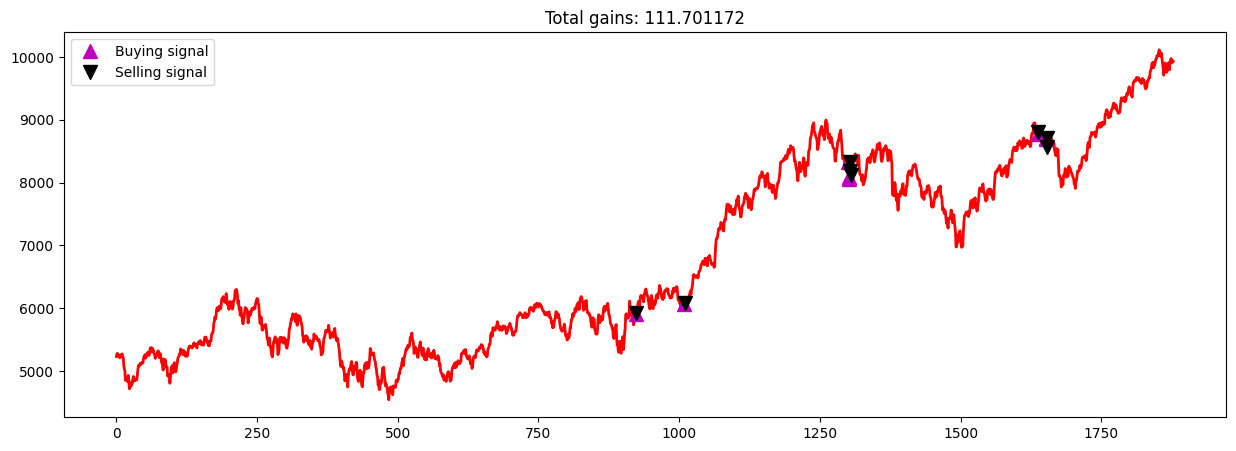

Training in progress...: 100%|██████████| 1878/1878 [07:37<00:00,  4.10it/s]


In [16]:
#creating states, environments and required preprocessing
import tqdm
from tqdm import tqdm

def sigmoid(x):
    return 1 / (1 + math.exp(-x))

# returns an an n-day state representation ending at time t

def getState(data, t, n):
    d = t - n + 1
    block = data[d:t + 1] if d >= 0 else -d * [data[0]] + data[0:t + 1] # pad with t0
    #block is which is the for [1283.27002, 1283.27002]
    res = []
    for i in range(n - 1):
        res.append(sigmoid(block[i + 1] - block[i]))
    return np.array([res])

# Plots the behavior of the output
def plot_behavior(data_input, states_buy, states_sell, profit):
    fig = plt.figure(figsize = (15,5))
    plt.plot(data_input, color='r', lw=2.)
    plt.plot(data_input, '^', markersize=10, color='m', label = 'Buying signal', markevery = states_buy)
    plt.plot(data_input, 'v', markersize=10, color='k', label = 'Selling signal', markevery = states_sell)
    plt.title('Total gains: %f'%(profit))
    plt.legend()
    #plt.savefig('output/'+name+'.png')
    plt.show()

#training the agents by recording episodes and then replaying to make model experience or train

#hyperparameters and agent,state intialization
window_size = 10
agent = DDPG_Agent(window_size)
data = train_data  # Assuming train_data is defined somewhere
episode_count = 10
l = len(data) - 1
batch_size = 32

profits = []

for e in range(episode_count):
    print(f"Running episode {e + 1}/{episode_count}")
    state = getState(data, 0, window_size + 1)
    total_profit = 0
    agent_inventory = []
    states_sell = []
    states_buy = []

    for t in tqdm(range(l), desc = "Training in progress..."):
        noise = agent.noise_generator.sample()
        action = agent.act(state, noise)
        actions = np.argmax(action)
        if(e>0):
            print(action, actions)
        next_state = getState(data, t + 1, window_size + 1)
        reward = 0

        if actions == 1:  # buy
            agent_inventory.append(data[t])
            states_buy.append(t)

        elif actions == 2 and len(agent_inventory) > 0:  # sell
            bought_price = agent_inventory.pop(0)
            reward = max(data[t] - bought_price, 0)
            total_profit += data[t] - bought_price
            states_sell.append(t)

        done = t == l - 1
        agent.remember(state, action, reward, next_state, done)
        state = next_state

        if done:
            print("--------------------------------")
            print(f"Total Profit: {total_profit:.2f}")
            profits.append(total_profit)
            print("--------------------------------")

            plot_behavior(data, states_buy, states_sell, total_profit)

        if len(agent.memory) > batch_size:
            agent.experience_replay(batch_size)

    if e % 2 == 0:
        torch.save(agent.actor_model.state_dict(), f"{dataset_dir}/actor_model_ddpg_ep{e}.pth")
        torch.save(agent.critic_model.state_dict(), f"{dataset_dir}/critic_model_ddpg_ep{e}.pth")


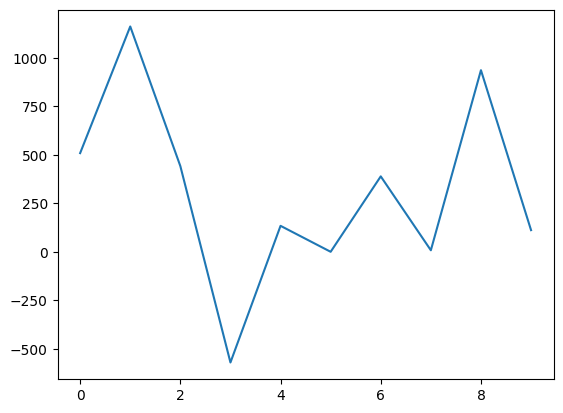

In [17]:
plt.plot(profits)

Testing Pipeline in progress: 100%|██████████| 469/469 [00:00<00:00, 2148.82it/s]


Buy:11641.7998046875
Sell: 11754.650390625 | profit: 112.8505859375
Buy:11497.900390625
Buy:11359.4501953125
Buy:11301.7998046875
Sell: 11278.900390625 | profit: -219.0
Sell: 11148.2001953125 | profit: -211.25
Buy:11222.0498046875
Buy:11157.0
Sell: 11257.099609375 | profit: -44.7001953125
Sell: 11407.150390625 | profit: 185.1005859375
Sell: 11828.25 | profit: 671.25
------------------------------------------
Total Profit: 494.25
------------------------------------------


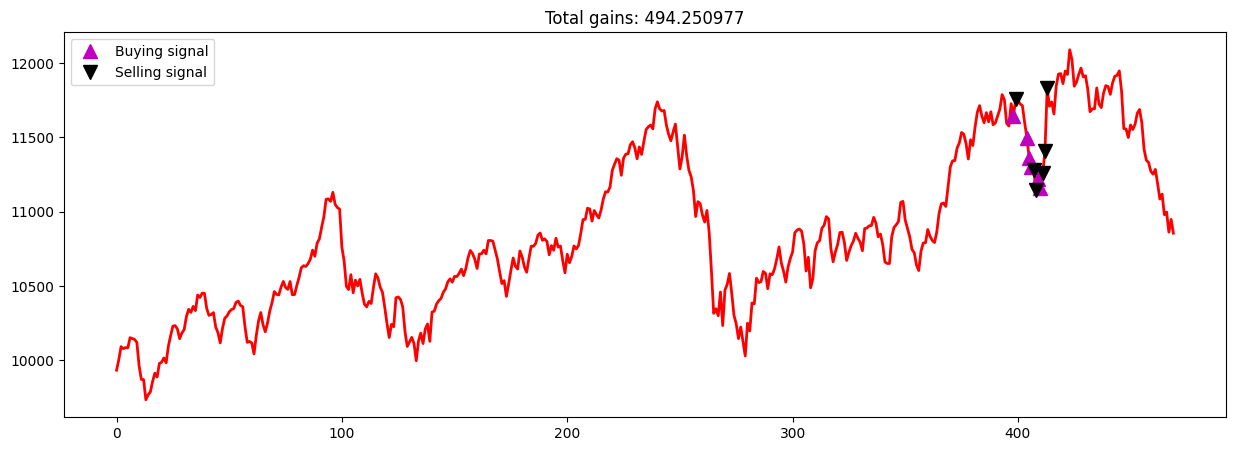

In [21]:
#testing

#agent is already defined in the training set above.
l_test = len(test_data) - 1
state = getState(test_data, 0, window_size + 1)
total_profit = 0
is_eval = True
done = False
states_sell_test = []
states_buy_test = []

#Get the trained model
# model_name = f"{dataset_dir}/model_ep" +"6"
# agent = DQN_Agent(window_size, is_eval, model_name)
state = getState(data, 0, window_size + 1)
total_profit = 0
agent_inventory = []

for t in tqdm(range(l_test), desc = "Testing Pipeline in progress"):
    noise = agent.noise_generator.sample()
    action = agent.act(state, noise)
    actions = np.argmax(action)
    #print(action)
    #set_trace()
    next_state = getState(test_data, t + 1, window_size + 1)
    reward = 0

    if actions == 1:
        agent_inventory.append(test_data[t])
        states_buy_test.append(t)
        print(f"Buy:{test_data[t]}")

    elif actions == 2 and len(agent_inventory) > 0:
        bought_price = agent_inventory.pop(0)
        reward = max(test_data[t] - bought_price, 0)

        total_profit += test_data[t] - bought_price
        states_sell_test.append(t)
        print(f"Sell: {test_data[t]} | profit: {test_data[t] - bought_price}")

    if t == l_test - 1:
        done = True
    agent.memory.append((state, action, reward, next_state, done))
    state = next_state

    if done:
        print("------------------------------------------")
        print(f"Total Profit: {total_profit:.2f}")
        print("------------------------------------------")

plot_behavior(test_data,states_buy_test, states_sell_test, total_profit)

In [ ]:
#final ensemble model
from collections import Counter

def weighted_vote(actions, buy_weight=3, sell_weight=3):
    weighted_actions = []
    for action in actions:
        if action == 1:  # 'Buy' action
            weighted_actions.extend([action] * int(buy_weight))
        elif action == 2:  # 'Sell' action
            weighted_actions.extend([action] * int(sell_weight))
        else:
            weighted_actions.append(action)

    # Use Counter to find the majority action
    action_counts = Counter(weighted_actions)
    final_action = action_counts.most_common(1)[0][0]

    return final_action

actions = [0, 2, 1]
final_action = weighted_vote(actions)

#agent is already defined in the training set above.
l_test = len(test_data) - 1
state = getState(test_data, 0, window_size + 1)
total_profit = 0
is_eval = True
done = False
states_sell_test = []
states_buy_test = []

#Get the trained model
model_name_1 = f"{dataset_dir}/model_ep8"
agent_1 = DQN_Agent(window_size, is_eval, model_name_1)

model_name = f"{dataset_dir}/model_ddqn_ep8"
agent_2 = DDQN_Agent(window_size, is_eval, model_name)

model_name = f"{dataset_dir}/model_ddpg_ep8"
agent_3 = DDPG_Agent(window_size, is_eval, model_name)

state = getState(data, 0, window_size + 1)
total_profit = 0
agent_inventory = []

for t in tqdm(range(l_test), desc = "Testing Pipeline in progress"):
    actions_1 = agent_1.act(state)
    actions_2 = agent_2.act(state)
    noise = agent_3.noise_generator.sample()
    action_3 = agent_3.act(state, noise)
    actions_3 = np.argmax(action_3)

    action = [actions_1, actions_2, actions_3]
    actions = weighted_vote(action)
    next_state = getState(test_data, t + 1, window_size + 1)
    reward = 0

    if actions == 1:
        agent_inventory.append(test_data[t])
        states_buy_test.append(t)
        print(f"Buy:{test_data[t]}")

    elif actions == 2 and len(agent_inventory) > 0:
        bought_price = agent_inventory.pop(0)
        reward = max(test_data[t] - bought_price, 0)

        total_profit += test_data[t] - bought_price
        states_sell_test.append(t)
        print(f"Sell: {test_data[t]} | profit: {test_data[t] - bought_price}")

    if t == l_test - 1:
        done = True
    agent.memory.append((state, action, reward, next_state, done))
    state = next_state

    if done:
        print("------------------------------------------")
        print(f"Total Profit: {total_profit:.2f}")
        print("------------------------------------------")

plot_behavior(test_data,states_buy_test, states_sell_test, total_profit)
